# Forward modeling and atmospheric retrieval: HAT-P-11b

The following is a demonstration of the PLATON tool developed by Michael Zhang (CalTech) et al. PLATON is a Python package that quickly predicts transit/eclipse depths given various atmospheric parameters and infers parameters given observed transit/eclipse depths at various wavelengths. More info here: https://platon.readthedocs.io/en/latest/intro.html

I have replicated below the retrieved atmospheric parameters and modeled transmission spectrum reported in a paper on the warm Neptune HAT-P-11b found here: https://ui.adsabs.harvard.edu/abs/2019AJ....158..244C/abstract

### Forward modeling the transmission spectrum from prior parameter values

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from platon.transit_depth_calculator import TransitDepthCalculator
from platon.constants import M_jup, R_sun, R_jup

# All quantities in SI
Rs = 0.683 * R_sun     #Radius of star
Mp = 0.0724 * M_jup     #Mass of planet
Rp = 0.393 * R_jup     #Radius of planet
T = 740              #Assumes isothermal atmosphere in chemical equilibrium

#create a TransitDepthCalculator object and compute wavelength dependent transit depths
depth_calculator = TransitDepthCalculator(method="ktables")
wavelengths, transit_depths = depth_calculator.compute_depths(
    Rs, Mp, Rp, T, CO_ratio=0.97, cloudtop_pressure=1.78e4)

Note to Michael: Not sure about the most reliable values for T, C/O ratio, and cloutop pressure. Chachang et al. mention flat priors for these parameters and 'physically motivated' upper and lower bounds for planet temp. and radius. Metallicity and C/O ratio are reported to be dictated by limitations in their model’s pre-computed equilibrium chemistry grid in Table 4. Table 4 presents parameter values estimated by PLATON retrieval.

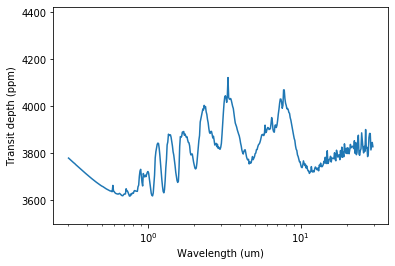

,Wavelength,Depth
0,3.014969e-07,0.003780
1,3.045209e-07,0.003778
2,3.075752e-07,0.003775
3,3.106601e-07,0.003773
4,3.137760e-07,0.003770


In [37]:
import pandas as pd

#Create a pandas dataframe to store the spectral data
df = pd.DataFrame(columns = ['Wavelength', 'Depth'])
waves = []
depths = []

for i in range(len(wavelengths)):
    waves.append(wavelengths[i])
    depths.append(transit_depths[i])

df['Wavelength'] = waves
df['Depth'] = depths

#Plot the transmission spectrum
plt.semilogx(1e6*wavelengths, 1e6*transit_depths)
plt.xlabel("Wavelength (um)")
plt.ylabel("Transit depth (ppm)")
plt.ylim(3500,4425)
plt.show()

df.head()

Compare this to the model spectrum generated by PLATON from the literature shown below. The figure shows the results of varying the distribution width (sigma) for particles size 1 micron in a Mie scattering model.

![](hatp11b_model_spectrum.jpg)

### Discussion

The model spectrum generated above agrees with that presented in the literature for a clear atmosphere (red) quite well. Note that the spectra shown in blue, purple, and grey were generated using a Mie scattering model for a cloudy/hazy atmosphere. My analysis lacks this component and assumes a clear atmosphere.

Molecular absorption features are evident for water and methane. Sharp peaks appear around 3.3 and 7.7 microns, consistent with literature values for sp3 hybridized C-H stretching and bending respectively. These peaks provide evidence for the presence of methane. Four moderately broad peaks appearing between 1-3 microns and a broad peak between 5-7 microns are consistent with literature values for O-H stretching and bending respectively in water.

### Atmospheric parameter retrieval from observed, wavelength dependent transit depths

In [38]:
#The following transit depths were obtained from Chachan et al. https://ui.adsabs.harvard.edu/abs/2019AJ....158..244C/abstract

depths_df = pd.read_csv('/Users/collin/Desktop/projects/Exoplanet_data/transit_depths.csv', delimiter = ' ')
depths_df.head() 
#Each row shows Rp/Rs, 'radius_ratio,' for each wavelength bin, lower-upper
#STIS G430L 0.346 - 0.566 um; STIS G750L 0.528 - 0.773 um; WFC3 G102 0.850 - 1.130 um; WFC3 G141 1.120 - 1.690 um

,lower_wave_bin,upper_wave_bin,radius_ratio,uncertainty
0,0.346,0.401,0.05788,0.00117
1,0.401,0.456,0.05821,0.00045
2,0.456,0.511,0.05828,0.00031
3,0.511,0.566,0.05812,0.00029
4,0.528,0.577,0.05903,0.00086


In [39]:
#Create numpy array with wavebins from the dataframe
wave_bins = np.empty((45,2))
lower_bins = np.array(depths_df['lower_wave_bin'])
upper_bins = np.array(depths_df['upper_wave_bin'])

for i in range(len(lower_bins)):
    wave_bins[i,0] = lower_bins[i]
    wave_bins[i,1] = upper_bins[i]

#Arrays for wave bins, transit depths, and errors
wave_bins = wave_bins*1e-6
transit_depths = np.array(depths_df['radius_ratio'])**2
transit_errors = np.array(depths_df['uncertainty'])*transit_depths*2

In [40]:
import os

import scipy.interpolate
import emcee
import corner
import pickle

from platon.fit_info import FitInfo
from platon.combined_retriever import CombinedRetriever




#create a Retriever object
retriever = CombinedRetriever()

#create a FitInfo object and set best guess parameters
fit_info = retriever.get_default_fit_info(
    Rs=0.683 * R_sun, Mp=0.0724 * M_jup, Rp=R_guess, T=T_guess,
    logZ=-0.98, CO_ratio=0.97, log_cloudtop_P=4.25,
    log_scatt_factor=0, scatt_slope=4, error_multiple=1.32, T_star=4780)

#Scattering slope refers to increased transit depth at lower wavelengths due to Rayleigh scattering. But how is it quantified?
#This article may help on quantifying scatt_slope - https://www.aanda.org/articles/aa/pdf/2019/02/aa34063-18.pdf
#Not sure what log_scatt_factor is

#Add fitting parameters - this specifies which parameters you want to fit
#e.g. since we have not included cloudtop_P, it will be fixed at the value specified in the constructor

fit_info.add_gaussian_fit_param('Rs', 0.02*R_sun)
fit_info.add_gaussian_fit_param('Mp', 0.04*M_jup)

fit_info.add_uniform_fit_param('Rp', 0.9*R_guess, 1.1*R_guess)
fit_info.add_uniform_fit_param('T', 0.5*T_guess, 1.5*T_guess)
fit_info.add_uniform_fit_param("log_scatt_factor", 0, 1)
fit_info.add_uniform_fit_param("logZ", -1, 3)
fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)
fit_info.add_uniform_fit_param("error_multiple", 0.5, 5)

#Use Nested Sampling to do the fitting
result = retriever.run_multinest(wave_bins, transit_depths, transit_errors,
                                 None, None, None,
                                 fit_info,
                                 rad_method="xsec",
                                 nlive = 1000) #"ktables" to use corr-k

pickle.dump("my_dynesty_run.pkl", open("result", "wb"))
np.save("samples.npy", result.samples)
np.save("weights.npy", np.exp(result.logwt))
np.save("ln_likelihood.npy", result.logl)
np.save("ln_probability.npy", result.logp)

result.plot_spectrum("best_fit")
result.plot_corner("multinest_corner.png")


Evaluated params: ln_prob=-8.11e+05	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.43 R_jup	T= 443 K	log_scatt_factor=0.57 	logZ=0.57 	log_cloudtop_P=-0.01 	error_multiple=3.62 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.01e+05	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 694 K	log_scatt_factor=0.38 	logZ=-0.43 	log_cloudtop_P=1.02 	error_multiple=1.68 	

Evaluated params: ln_prob=-2.01e+06	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 904 K	log_scatt_factor=0.18 	logZ=-0.26 	log_cloudtop_P=0.55 	error_multiple=2.30 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere

iter: 19 | bound: 0 | nc: 1 | ncall: 1022 | eff(%):  1.859 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                    

Atmosphere unbound: height > hill radius


iter: 60 | bound: 0 | nc: 2 | ncall: 1069 | eff(%):  5.613 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                    

Atmosphere unbound: height > hill radius


iter: 78 | bound: 0 | nc: 3 | ncall: 1091 | eff(%):  7.149 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                    

Atmosphere unbound: height > hill radius


iter: 89 | bound: 0 | nc: 2 | ncall: 1103 | eff(%):  8.069 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                    

Atmosphere unbound: height > hill radius


iter: 108 | bound: 0 | nc: 1 | ncall: 1123 | eff(%):  9.617 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 110 | bound: 0 | nc: 3 | ncall: 1127 | eff(%):  9.760 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 124 | bound: 0 | nc: 1 | ncall: 1144 | eff(%): 10.839 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 144 | bound: 0 | nc: 1 | ncall: 1169 | eff(%): 12.318 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 148 | bound: 0 | nc: 2 | ncall: 1177 | eff(%): 12.574 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 168 | bound: 0 | nc: 1 | ncall: 1200 | eff(%): 14.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 185 | bound: 0 | nc: 2 | ncall: 1226 | eff(%): 15.090 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 188 | bound: 0 | nc: 2 | ncall: 1230 | eff(%): 15.285 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 227 | bound: 0 | nc: 2 | ncall: 1277 | eff(%): 17.776 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 228 | bound: 0 | nc: 4 | ncall: 1281 | eff(%): 17.799 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 235 | bound: 0 | nc: 2 | ncall: 1290 | eff(%): 18.217 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 273 | bound: 0 | nc: 1 | ncall: 1335 | eff(%): 20.449 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 275 | bound: 0 | nc: 1 | ncall: 1338 | eff(%): 20.553 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 283 | bound: 0 | nc: 2 | ncall: 1347 | eff(%): 21.010 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 296 | bound: 0 | nc: 2 | ncall: 1365 | eff(%): 21.685 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 303 | bound: 0 | nc: 1 | ncall: 1376 | eff(%): 22.020 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 314 | bound: 0 | nc: 1 | ncall: 1390 | eff(%): 22.590 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 321 | bound: 0 | nc: 1 | ncall: 1400 | eff(%): 22.929 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   


Evaluated params: ln_prob=-9.24e+04	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T=1075 K	log_scatt_factor=0.66 	logZ=2.57 	log_cloudtop_P=0.72 	error_multiple=3.13 	


iter: 354 | bound: 0 | nc: 1 | ncall: 1448 | eff(%): 24.448 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   


Evaluated params: ln_prob=-1.05e+06	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 973 K	log_scatt_factor=0.65 	logZ=1.61 	log_cloudtop_P=1.20 	error_multiple=2.91 	


iter: 356 | bound: 0 | nc: 2 | ncall: 1451 | eff(%): 24.535 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 359 | bound: 0 | nc: 2 | ncall: 1456 | eff(%): 24.657 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 369 | bound: 0 | nc: 2 | ncall: 1469 | eff(%): 25.119 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 405 | bound: 0 | nc: 2 | ncall: 1523 | eff(%): 26.592 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 423 | bound: 0 | nc: 2 | ncall: 1553 | eff(%): 27.238 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 447 | bound: 0 | nc: 3 | ncall: 1587 | eff(%): 28.166 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 477 | bound: 0 | nc: 1 | ncall: 1635 | eff(%): 29.174 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 480 | bound: 0 | nc: 3 | ncall: 1644 | eff(%): 29.197 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 501 | bound: 0 | nc: 1 | ncall: 1679 | eff(%): 29.839 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   


Evaluated params: ln_prob=-1.16e+07	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.43 R_jup	T=1090 K	log_scatt_factor=0.71 	logZ=-0.15 	log_cloudtop_P=1.72 	error_multiple=2.48 	


iter: 512 | bound: 0 | nc: 2 | ncall: 1702 | eff(%): 30.082 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 513 | bound: 0 | nc: 2 | ncall: 1704 | eff(%): 30.106 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  1.009                                                   

Atmosphere unbound: height > hill radius


iter: 526 | bound: 0 | nc: 1 | ncall: 1723 | eff(%): 30.528 | loglstar:   -inf < -966946.616 <    inf | logz: -966954.742 +/-    nan | dlogz: 969235.591 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 532 | bound: 0 | nc: 1 | ncall: 1732 | eff(%): 30.716 | loglstar:   -inf < -933273.337 <    inf | logz: -933281.469 +/-    nan | dlogz: 938726.146 >  1.009                                     


Evaluated params: ln_prob=-1.80e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 998 K	log_scatt_factor=0.36 	logZ=2.34 	log_cloudtop_P=0.73 	error_multiple=4.24 	


iter: 559 | bound: 0 | nc: 1 | ncall: 1767 | eff(%): 31.636 | loglstar:   -inf < -864010.623 <    inf | logz: -864018.782 +/-    nan | dlogz: 864269.764 >  1.009                                     


Evaluated params: ln_prob=-1.66e+05	Rs=0.66 R_sun	Mp=0.12 M_jup	Rp=0.40 R_jup	T= 543 K	log_scatt_factor=0.41 	logZ=-0.05 	log_cloudtop_P=1.38 	error_multiple=4.99 	


iter: 566 | bound: 0 | nc: 1 | ncall: 1781 | eff(%): 31.780 | loglstar:   -inf < -840914.132 <    inf | logz: -840922.298 +/-    nan | dlogz: 845399.231 >  1.009                                     


Evaluated params: ln_prob=-2.36e+06	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.43 R_jup	T= 388 K	log_scatt_factor=0.26 	logZ=1.71 	log_cloudtop_P=0.06 	error_multiple=1.72 	
Atmosphere unbound: height > hill radius


iter: 568 | bound: 0 | nc: 3 | ncall: 1793 | eff(%): 31.679 | loglstar:   -inf < -836115.599 <    inf | logz: -836123.768 +/-    nan | dlogz: 836399.834 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 573 | bound: 0 | nc: 1 | ncall: 1801 | eff(%): 31.816 | loglstar:   -inf < -827018.641 <    inf | logz: -827026.814 +/-    nan | dlogz: 827294.549 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 576 | bound: 0 | nc: 1 | ncall: 1808 | eff(%): 31.858 | loglstar:   -inf < -812968.094 <    inf | logz: -812976.270 +/-    nan | dlogz: 814034.508 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 581 | bound: 0 | nc: 1 | ncall: 1818 | eff(%): 31.958 | loglstar:   -inf < -793071.258 <    inf | logz: -793079.440 +/-    nan | dlogz: 801243.323 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 582 | bound: 0 | nc: 4 | ncall: 1822 | eff(%): 31.943 | loglstar:   -inf < -791112.797 <    inf | logz: -791120.980 +/-    nan | dlogz: 792832.186 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 602 | bound: 0 | nc: 1 | ncall: 1870 | eff(%): 32.193 | loglstar:   -inf < -746038.241 <    inf | logz: -746046.443 +/-    nan | dlogz: 749618.022 >  1.009                                     


Evaluated params: ln_prob=-1.70e+05	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 443 K	log_scatt_factor=0.86 	logZ=-0.88 	log_cloudtop_P=1.33 	error_multiple=2.34 	


iter: 628 | bound: 0 | nc: 1 | ncall: 1914 | eff(%): 32.811 | loglstar:   -inf < -680459.329 <    inf | logz: -680467.558 +/-    nan | dlogz: 682462.698 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 630 | bound: 0 | nc: 3 | ncall: 1920 | eff(%): 32.812 | loglstar:   -inf < -678673.558 <    inf | logz: -678681.789 +/-    nan | dlogz: 678442.939 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 633 | bound: 0 | nc: 3 | ncall: 1928 | eff(%): 32.832 | loglstar:   -inf < -671497.134 <    inf | logz: -671505.368 +/-    nan | dlogz: 675734.233 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 643 | bound: 0 | nc: 4 | ncall: 1955 | eff(%): 32.890 | loglstar:   -inf < -647391.395 <    inf | logz: -647399.639 +/-    nan | dlogz: 647453.582 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 645 | bound: 0 | nc: 2 | ncall: 1959 | eff(%): 32.925 | loglstar:   -inf < -642850.237 <    inf | logz: -642858.483 +/-    nan | dlogz: 645867.656 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 686 | bound: 0 | nc: 3 | ncall: 2022 | eff(%): 33.927 | loglstar:   -inf < -584810.026 <    inf | logz: -584818.312 +/-    nan | dlogz: 586293.029 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 691 | bound: 0 | nc: 2 | ncall: 2032 | eff(%): 34.006 | loglstar:   -inf < -577806.389 <    inf | logz: -577814.681 +/-    nan | dlogz: 578121.793 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 702 | bound: 0 | nc: 2 | ncall: 2056 | eff(%): 34.144 | loglstar:   -inf < -561541.537 <    inf | logz: -561549.839 +/-    nan | dlogz: 562455.635 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 704 | bound: 0 | nc: 2 | ncall: 2060 | eff(%): 34.175 | loglstar:   -inf < -559855.994 <    inf | logz: -559864.299 +/-    nan | dlogz: 561135.686 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 714 | bound: 0 | nc: 3 | ncall: 2078 | eff(%): 34.360 | loglstar:   -inf < -538562.919 <    inf | logz: -538571.233 +/-    nan | dlogz: 540677.839 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 715 | bound: 0 | nc: 2 | ncall: 2080 | eff(%): 34.375 | loglstar:   -inf < -535748.272 <    inf | logz: -535756.587 +/-    nan | dlogz: 538387.422 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 720 | bound: 0 | nc: 2 | ncall: 2090 | eff(%): 34.450 | loglstar:   -inf < -521823.530 <    inf | logz: -521831.850 +/-    nan | dlogz: 522256.394 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 729 | bound: 0 | nc: 1 | ncall: 2106 | eff(%): 34.615 | loglstar:   -inf < -510505.477 <    inf | logz: -510513.807 +/-    nan | dlogz: 510491.734 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 733 | bound: 0 | nc: 4 | ncall: 2117 | eff(%): 34.624 | loglstar:   -inf < -509142.160 <    inf | logz: -509150.493 +/-    nan | dlogz: 509213.277 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 743 | bound: 0 | nc: 3 | ncall: 2133 | eff(%): 34.834 | loglstar:   -inf < -489076.489 <    inf | logz: -489084.832 +/-    nan | dlogz: 490756.124 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 753 | bound: 0 | nc: 2 | ncall: 2153 | eff(%): 34.974 | loglstar:   -inf < -474844.910 <    inf | logz: -474853.264 +/-    nan | dlogz: 476564.024 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 755 | bound: 0 | nc: 3 | ncall: 2158 | eff(%): 34.986 | loglstar:   -inf < -472499.931 <    inf | logz: -472508.286 +/-    nan | dlogz: 473151.519 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 770 | bound: 0 | nc: 5 | ncall: 2195 | eff(%): 35.080 | loglstar:   -inf < -447659.703 <    inf | logz: -447668.074 +/-    nan | dlogz: 448746.597 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 780 | bound: 0 | nc: 4 | ncall: 2218 | eff(%): 35.167 | loglstar:   -inf < -437393.455 <    inf | logz: -437401.835 +/-    nan | dlogz: 437846.803 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 781 | bound: 0 | nc: 1 | ncall: 2219 | eff(%): 35.196 | loglstar:   -inf < -434859.807 <    inf | logz: -434868.188 +/-    nan | dlogz: 437217.958 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 788 | bound: 0 | nc: 3 | ncall: 2233 | eff(%): 35.289 | loglstar:   -inf < -430897.333 <    inf | logz: -430905.722 +/-    nan | dlogz: 430752.917 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 794 | bound: 0 | nc: 1 | ncall: 2247 | eff(%): 35.336 | loglstar:   -inf < -421950.133 <    inf | logz: -421958.527 +/-    nan | dlogz: 426039.158 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 813 | bound: 0 | nc: 2 | ncall: 2292 | eff(%): 35.471 | loglstar:   -inf < -396721.744 <    inf | logz: -396730.157 +/-    nan | dlogz: 396751.226 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 833 | bound: 0 | nc: 1 | ncall: 2328 | eff(%): 35.782 | loglstar:   -inf < -377349.332 <    inf | logz: -377357.765 +/-    nan | dlogz: 378766.006 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 837 | bound: 0 | nc: 2 | ncall: 2337 | eff(%): 35.815 | loglstar:   -inf < -374954.316 <    inf | logz: -374962.753 +/-    nan | dlogz: 375370.914 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 851 | bound: 0 | nc: 1 | ncall: 2359 | eff(%): 36.075 | loglstar:   -inf < -362519.096 <    inf | logz: -362527.548 +/-    nan | dlogz: 363074.410 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 852 | bound: 0 | nc: 10 | ncall: 2369 | eff(%): 35.965 | loglstar:   -inf < -361302.542 <    inf | logz: -361310.994 +/-    nan | dlogz: 362343.599 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 862 | bound: 0 | nc: 2 | ncall: 2392 | eff(%): 36.037 | loglstar:   -inf < -349102.213 <    inf | logz: -349110.676 +/-    nan | dlogz: 351506.772 >  1.009                                     


Evaluated params: ln_prob=-1.89e+05	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T=1065 K	log_scatt_factor=0.09 	logZ=-0.36 	log_cloudtop_P=3.97 	error_multiple=3.59 	


iter: 877 | bound: 0 | nc: 3 | ncall: 2436 | eff(%): 36.002 | loglstar:   -inf < -335554.390 <    inf | logz: -335562.868 +/-    nan | dlogz: 335402.360 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 891 | bound: 0 | nc: 2 | ncall: 2480 | eff(%): 35.927 | loglstar:   -inf < -315780.482 <    inf | logz: -315788.973 +/-    nan | dlogz: 315894.604 >  1.009                                     

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.83e+05	Rs=0.68 R_sun	Mp=0.15 M_jup	Rp=0.40 R_jup	T= 804 K	log_scatt_factor=0.87 	logZ=2.15 	log_cloudtop_P=1.84 	error_multiple=2.71 	


iter: 903 | bound: 0 | nc: 7 | ncall: 2519 | eff(%): 35.848 | loglstar:   -inf < -300147.870 <    inf | logz: -300156.374 +/-    nan | dlogz: 304440.883 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 910 | bound: 0 | nc: 4 | ncall: 2533 | eff(%): 35.926 | loglstar:   -inf < -294387.257 <    inf | logz: -294395.767 +/-    nan | dlogz: 295013.825 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 930 | bound: 0 | nc: 3 | ncall: 2575 | eff(%): 36.117 | loglstar:   -inf < -279838.633 <    inf | logz: -279847.163 +/-    nan | dlogz: 279941.034 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 950 | bound: 0 | nc: 1 | ncall: 2636 | eff(%): 36.039 | loglstar:   -inf < -269285.423 <    inf | logz: -269293.973 +/-    nan | dlogz: 269664.905 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 955 | bound: 0 | nc: 1 | ncall: 2659 | eff(%): 35.916 | loglstar:   -inf < -266437.680 <    inf | logz: -266446.236 +/-    nan | dlogz: 266408.739 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 956 | bound: 0 | nc: 7 | ncall: 2666 | eff(%): 35.859 | loglstar:   -inf < -264791.155 <    inf | logz: -264799.712 +/-    nan | dlogz: 266262.183 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 963 | bound: 0 | nc: 2 | ncall: 2681 | eff(%): 35.919 | loglstar:   -inf < -259210.067 <    inf | logz: -259218.630 +/-    nan | dlogz: 259549.084 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 966 | bound: 0 | nc: 6 | ncall: 2693 | eff(%): 35.871 | loglstar:   -inf < -257249.407 <    inf | logz: -257257.973 +/-    nan | dlogz: 257237.848 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 967 | bound: 0 | nc: 2 | ncall: 2695 | eff(%): 35.881 | loglstar:   -inf < -257240.488 <    inf | logz: -257249.055 +/-    nan | dlogz: 257073.910 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 974 | bound: 0 | nc: 4 | ncall: 2719 | eff(%): 35.822 | loglstar:   -inf < -252570.025 <    inf | logz: -252578.599 +/-    nan | dlogz: 252434.791 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 991 | bound: 0 | nc: 2 | ncall: 2753 | eff(%): 35.997 | loglstar:   -inf < -241760.087 <    inf | logz: -241768.678 +/-    nan | dlogz: 241945.632 >  1.009                                     


Evaluated params: ln_prob=-2.27e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 403 K	log_scatt_factor=0.85 	logZ=1.44 	log_cloudtop_P=3.00 	error_multiple=4.66 	
Atmosphere unbound: height > hill radius


iter: 1002 | bound: 0 | nc: 4 | ncall: 2776 | eff(%): 36.095 | loglstar:   -inf < -236608.048 <    inf | logz: -236616.651 +/-    nan | dlogz: 236915.175 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1005 | bound: 0 | nc: 1 | ncall: 2781 | eff(%): 36.138 | loglstar:   -inf < -234808.019 <    inf | logz: -234816.625 +/-    nan | dlogz: 235775.513 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1022 | bound: 0 | nc: 3 | ncall: 2828 | eff(%): 36.139 | loglstar:   -inf < -227692.279 <    inf | logz: -227700.901 +/-    nan | dlogz: 228709.418 >  1.009                                    


Evaluated params: ln_prob=-1.47e+06	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 918 K	log_scatt_factor=0.18 	logZ=-0.55 	log_cloudtop_P=2.05 	error_multiple=2.37 	


iter: 1026 | bound: 0 | nc: 1 | ncall: 2844 | eff(%): 36.076 | loglstar:   -inf < -224950.379 <    inf | logz: -224959.006 +/-    nan | dlogz: 226323.590 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1034 | bound: 0 | nc: 6 | ncall: 2869 | eff(%): 36.040 | loglstar:   -inf < -221242.121 <    inf | logz: -221250.756 +/-    nan | dlogz: 221152.550 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1035 | bound: 0 | nc: 3 | ncall: 2872 | eff(%): 36.038 | loglstar:   -inf < -221049.541 <    inf | logz: -221058.176 +/-    nan | dlogz: 221066.624 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1045 | bound: 0 | nc: 1 | ncall: 2894 | eff(%): 36.109 | loglstar:   -inf < -218249.987 <    inf | logz: -218258.633 +/-    nan | dlogz: 218281.122 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1054 | bound: 0 | nc: 2 | ncall: 2926 | eff(%): 36.022 | loglstar:   -inf < -215167.089 <    inf | logz: -215175.743 +/-    nan | dlogz: 216013.313 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1066 | bound: 0 | nc: 3 | ncall: 2968 | eff(%): 35.916 | loglstar:   -inf < -208837.791 <    inf | logz: -208846.457 +/-    nan | dlogz: 210385.414 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1071 | bound: 0 | nc: 1 | ncall: 2978 | eff(%): 35.964 | loglstar:   -inf < -204691.366 <    inf | logz: -204700.037 +/-    nan | dlogz: 204758.724 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1073 | bound: 0 | nc: 6 | ncall: 2990 | eff(%): 35.886 | loglstar:   -inf < -203527.483 <    inf | logz: -203536.157 +/-    nan | dlogz: 203837.090 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1078 | bound: 0 | nc: 5 | ncall: 3010 | eff(%): 35.814 | loglstar:   -inf < -201793.081 <    inf | logz: -201801.759 +/-    nan | dlogz: 202499.621 >  1.009                                    


Evaluated params: ln_prob=-8.38e+05	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.41 R_jup	T= 522 K	log_scatt_factor=0.44 	logZ=0.61 	log_cloudtop_P=3.23 	error_multiple=1.44 	


iter: 1079 | bound: 0 | nc: 10 | ncall: 3020 | eff(%): 35.728 | loglstar:   -inf < -201260.635 <    inf | logz: -201269.315 +/-    nan | dlogz: 201617.584 >  1.009                                   


Evaluated params: ln_prob=-1.22e+06	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.43 R_jup	T= 549 K	log_scatt_factor=0.80 	logZ=1.83 	log_cloudtop_P=0.06 	error_multiple=3.82 	


iter: 1090 | bound: 0 | nc: 2 | ncall: 3052 | eff(%): 35.714 | loglstar:   -inf < -193732.799 <    inf | logz: -193741.489 +/-    nan | dlogz: 194903.513 >  1.009                                    


Evaluated params: ln_prob=-1.28e+06	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.42 R_jup	T= 817 K	log_scatt_factor=0.54 	logZ=2.78 	log_cloudtop_P=1.32 	error_multiple=2.40 	


iter: 1096 | bound: 0 | nc: 2 | ncall: 3065 | eff(%): 35.759 | loglstar:   -inf < -191241.975 <    inf | logz: -191250.672 +/-    nan | dlogz: 191132.189 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1100 | bound: 0 | nc: 2 | ncall: 3078 | eff(%): 35.737 | loglstar:   -inf < -189793.114 <    inf | logz: -189801.814 +/-    nan | dlogz: 189733.093 >  1.009                                    


Evaluated params: ln_prob=-1.08e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 588 K	log_scatt_factor=0.48 	logZ=2.71 	log_cloudtop_P=3.76 	error_multiple=4.05 	
Atmosphere unbound: height > hill radius


iter: 1101 | bound: 0 | nc: 8 | ncall: 3086 | eff(%): 35.677 | loglstar:   -inf < -189585.163 <    inf | logz: -189593.864 +/-    nan | dlogz: 189617.617 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1117 | bound: 0 | nc: 2 | ncall: 3119 | eff(%): 35.813 | loglstar:   -inf < -183919.503 <    inf | logz: -183928.220 +/-    nan | dlogz: 184236.414 >  1.009                                    


Evaluated params: ln_prob=-3.09e+05	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 900 K	log_scatt_factor=0.14 	logZ=2.94 	log_cloudtop_P=0.30 	error_multiple=1.65 	


iter: 1123 | bound: 0 | nc: 1 | ncall: 3130 | eff(%): 35.879 | loglstar:   -inf < -182713.379 <    inf | logz: -182722.102 +/-    nan | dlogz: 182836.050 >  1.009                                    


Evaluated params: ln_prob=-2.06e+04	Rs=0.64 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 540 K	log_scatt_factor=0.09 	logZ=2.60 	log_cloudtop_P=0.25 	error_multiple=3.74 	


iter: 1133 | bound: 0 | nc: 3 | ncall: 3147 | eff(%): 36.003 | loglstar:   -inf < -178902.812 <    inf | logz: -178911.545 +/-    nan | dlogz: 179142.840 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1151 | bound: 0 | nc: 15 | ncall: 3204 | eff(%): 35.924 | loglstar:   -inf < -171336.720 <    inf | logz: -171345.472 +/-    nan | dlogz: 171415.029 >  1.009                                   

Atmosphere unbound: height > hill radius


iter: 1161 | bound: 0 | nc: 4 | ncall: 3240 | eff(%): 35.833 | loglstar:   -inf < -168058.133 <    inf | logz: -168066.894 +/-    nan | dlogz: 168085.232 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1162 | bound: 0 | nc: 4 | ncall: 3244 | eff(%): 35.820 | loglstar:   -inf < -167939.782 <    inf | logz: -167948.544 +/-    nan | dlogz: 167882.636 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1172 | bound: 0 | nc: 3 | ncall: 3281 | eff(%): 35.721 | loglstar:   -inf < -162869.614 <    inf | logz: -162878.387 +/-    nan | dlogz: 162899.582 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1173 | bound: 0 | nc: 5 | ncall: 3286 | eff(%): 35.697 | loglstar:   -inf < -162664.544 <    inf | logz: -162673.317 +/-    nan | dlogz: 162694.117 >  1.009                                    


Evaluated params: ln_prob=-9.42e+05	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 718 K	log_scatt_factor=0.11 	logZ=2.99 	log_cloudtop_P=2.63 	error_multiple=2.62 	


iter: 1174 | bound: 0 | nc: 14 | ncall: 3300 | eff(%): 35.576 | loglstar:   -inf < -162328.868 <    inf | logz: -162337.643 +/-    nan | dlogz: 162489.047 >  1.009                                   

Atmosphere unbound: height > hill radius


iter: 1175 | bound: 0 | nc: 8 | ncall: 3308 | eff(%): 35.520 | loglstar:   -inf < -162180.630 <    inf | logz: -162189.406 +/-    nan | dlogz: 162153.372 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1190 | bound: 0 | nc: 2 | ncall: 3357 | eff(%): 35.448 | loglstar:   -inf < -157572.109 <    inf | logz: -157580.899 +/-    nan | dlogz: 157542.633 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1193 | bound: 0 | nc: 4 | ncall: 3366 | eff(%): 35.443 | loglstar:   -inf < -157051.544 <    inf | logz: -157060.337 +/-    nan | dlogz: 157150.601 >  1.009                                    

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1196 | bound: 0 | nc: 8 | ncall: 3379 | eff(%): 35.395 | loglstar:   -inf < -155712.207 <    inf | logz: -155721.003 +/-    nan | dlogz: 156011.565 >  1.009                                    

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.34e+06	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 797 K	log_scatt_factor=0.72 	logZ=0.91 	log_cloudtop_P=1.61 	error_multiple=0.61 	


iter: 1219 | bound: 0 | nc: 2 | ncall: 3431 | eff(%): 35.529 | loglstar:   -inf < -146566.943 <    inf | logz: -146575.762 +/-    nan | dlogz: 146684.163 >  1.009                                    


Evaluated params: ln_prob=-1.11e+06	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.42 R_jup	T= 491 K	log_scatt_factor=0.85 	logZ=2.19 	log_cloudtop_P=-0.33 	error_multiple=4.72 	


iter: 1221 | bound: 0 | nc: 1 | ncall: 3441 | eff(%): 35.484 | loglstar:   -inf < -145618.151 <    inf | logz: -145626.973 +/-    nan | dlogz: 145584.066 >  1.009                                    


Evaluated params: ln_prob=-3.37e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.41 R_jup	T= 661 K	log_scatt_factor=0.53 	logZ=2.45 	log_cloudtop_P=3.71 	error_multiple=4.89 	

Evaluated params: ln_prob=-3.06e+05	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 540 K	log_scatt_factor=0.52 	logZ=0.15 	log_cloudtop_P=1.17 	error_multiple=4.94 	


iter: 1226 | bound: 0 | nc: 4 | ncall: 3460 | eff(%): 35.434 | loglstar:   -inf < -144557.446 <    inf | logz: -144566.273 +/-    nan | dlogz: 144616.526 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1278 | bound: 0 | nc: 7 | ncall: 3634 | eff(%): 35.168 | loglstar:   -inf < -127119.504 <    inf | logz: -127128.383 +/-    nan | dlogz: 127143.607 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1284 | bound: 0 | nc: 5 | ncall: 3656 | eff(%): 35.120 | loglstar:   -inf < -124615.191 <    inf | logz: -124624.075 +/-    nan | dlogz: 124576.859 >  1.009                                    


Evaluated params: ln_prob=-4.99e+05	Rs=0.70 R_sun	Mp=0.12 M_jup	Rp=0.35 R_jup	T= 606 K	log_scatt_factor=0.55 	logZ=-0.92 	log_cloudtop_P=2.33 	error_multiple=2.42 	


iter: 1286 | bound: 0 | nc: 7 | ncall: 3664 | eff(%): 35.098 | loglstar:   -inf < -123830.398 <    inf | logz: -123839.284 +/-    nan | dlogz: 123765.391 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1290 | bound: 0 | nc: 4 | ncall: 3685 | eff(%): 35.007 | loglstar:   -inf < -123289.337 <    inf | logz: -123298.227 +/-    nan | dlogz: 123477.263 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1292 | bound: 0 | nc: 1 | ncall: 3691 | eff(%): 35.004 | loglstar:   -inf < -123067.780 <    inf | logz: -123076.672 +/-    nan | dlogz: 123081.674 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1301 | bound: 0 | nc: 3 | ncall: 3731 | eff(%): 34.870 | loglstar:   -inf < -119301.801 <    inf | logz: -119310.702 +/-    nan | dlogz: 119319.289 >  1.009                                    


Evaluated params: ln_prob=-4.10e+03	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T=1026 K	log_scatt_factor=1.00 	logZ=1.44 	log_cloudtop_P=4.60 	error_multiple=3.45 	


iter: 1314 | bound: 0 | nc: 6 | ncall: 3770 | eff(%): 34.854 | loglstar:   -inf < -113966.255 <    inf | logz: -113975.170 +/-    nan | dlogz: 114324.495 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1316 | bound: 0 | nc: 2 | ncall: 3789 | eff(%): 34.732 | loglstar:   -inf < -113846.481 <    inf | logz: -113855.397 +/-    nan | dlogz: 113694.756 >  1.009                                    

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1324 | bound: 0 | nc: 1 | ncall: 3827 | eff(%): 34.596 | loglstar:   -inf < -112463.748 <    inf | logz: -112472.673 +/-    nan | dlogz: 112550.646 >  1.009                                    


Evaluated params: ln_prob=-1.75e+05	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 592 K	log_scatt_factor=0.47 	logZ=2.82 	log_cloudtop_P=3.96 	error_multiple=1.50 	


iter: 1325 | bound: 0 | nc: 8 | ncall: 3835 | eff(%): 34.550 | loglstar:   -inf < -112389.275 <    inf | logz: -112398.200 +/-    nan | dlogz: 112288.252 >  1.009                                    

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.30e+04	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 711 K	log_scatt_factor=0.92 	logZ=1.79 	log_cloudtop_P=3.95 	error_multiple=1.65 	


iter: 1331 | bound: 0 | nc: 4 | ncall: 3852 | eff(%): 34.553 | loglstar:   -inf < -110324.604 <    inf | logz: -110333.536 +/-    nan | dlogz: 110769.840 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1333 | bound: 0 | nc: 3 | ncall: 3869 | eff(%): 34.453 | loglstar:   -inf < -109417.715 <    inf | logz: -109426.648 +/-    nan | dlogz: 109806.392 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1348 | bound: 0 | nc: 2 | ncall: 3911 | eff(%): 34.467 | loglstar:   -inf < -106026.047 <    inf | logz: -106034.995 +/-    nan | dlogz: 105881.518 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1351 | bound: 0 | nc: 3 | ncall: 3922 | eff(%): 34.447 | loglstar:   -inf < -105812.926 <    inf | logz: -105821.877 +/-    nan | dlogz: 105664.612 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1356 | bound: 0 | nc: 7 | ncall: 3949 | eff(%): 34.338 | loglstar:   -inf < -105152.585 <    inf | logz: -105160.757 +/-    nan | dlogz: 104977.606 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1357 | bound: 0 | nc: 14 | ncall: 3963 | eff(%): 34.242 | loglstar:   -inf < -104936.683 <    inf | logz: -104945.640 +/-    nan | dlogz: 104976.304 >  1.009                                   

Atmosphere unbound: height > hill radius


iter: 1361 | bound: 0 | nc: 7 | ncall: 3981 | eff(%): 34.187 | loglstar:   -inf < -104019.651 <    inf | logz: -104028.612 +/-    nan | dlogz: 104114.101 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1374 | bound: 0 | nc: 3 | ncall: 4039 | eff(%): 34.018 | loglstar:   -inf < -100848.362 <    inf | logz: -100857.337 +/-    nan | dlogz: 100937.491 >  1.009                                    

Atmosphere unbound: height > hill radius


iter: 1379 | bound: 0 | nc: 8 | ncall: 4059 | eff(%): 33.974 | loglstar:   -inf < -99079.355 <    inf | logz: -99088.334 +/-    nan | dlogz: 99205.866 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1383 | bound: 0 | nc: 2 | ncall: 4081 | eff(%): 33.889 | loglstar:   -inf < -97737.794 <    inf | logz: -97746.417 +/-    nan | dlogz: 97563.825 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1384 | bound: 0 | nc: 2 | ncall: 4083 | eff(%): 33.897 | loglstar:   -inf < -97683.449 <    inf | logz: -97692.434 +/-    nan | dlogz: 97561.937 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1403 | bound: 0 | nc: 1 | ncall: 4153 | eff(%): 33.783 | loglstar:   -inf < -93109.191 <    inf | logz: -93118.194 +/-    nan | dlogz: 93221.011 >  1.009                                       


Evaluated params: ln_prob=-1.64e+07	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.41 R_jup	T= 588 K	log_scatt_factor=0.23 	logZ=1.19 	log_cloudtop_P=3.87 	error_multiple=0.92 	


iter: 1407 | bound: 0 | nc: 14 | ncall: 4175 | eff(%): 33.701 | loglstar:   -inf < -92340.694 <    inf | logz: -92349.701 +/-    nan | dlogz: 92265.318 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1408 | bound: 0 | nc: 7 | ncall: 4182 | eff(%): 33.668 | loglstar:   -inf < -92180.036 <    inf | logz: -92189.044 +/-    nan | dlogz: 92165.197 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1414 | bound: 0 | nc: 2 | ncall: 4205 | eff(%): 33.627 | loglstar:   -inf < -90467.338 <    inf | logz: -90476.352 +/-    nan | dlogz: 90313.696 >  1.009                                       


Evaluated params: ln_prob=-8.27e+06	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.41 R_jup	T= 833 K	log_scatt_factor=0.09 	logZ=-0.93 	log_cloudtop_P=3.31 	error_multiple=0.92 	


iter: 1415 | bound: 0 | nc: 12 | ncall: 4217 | eff(%): 33.555 | loglstar:   -inf < -90269.431 <    inf | logz: -90278.446 +/-    nan | dlogz: 90291.841 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1420 | bound: 0 | nc: 5 | ncall: 4238 | eff(%): 33.506 | loglstar:   -inf < -88485.459 <    inf | logz: -88494.480 +/-    nan | dlogz: 88329.973 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1424 | bound: 0 | nc: 3 | ncall: 4257 | eff(%): 33.451 | loglstar:   -inf < -87964.028 <    inf | logz: -87973.052 +/-    nan | dlogz: 87885.573 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1429 | bound: 0 | nc: 5 | ncall: 4267 | eff(%): 33.490 | loglstar:   -inf < -86492.914 <    inf | logz: -86501.943 +/-    nan | dlogz: 86598.476 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1435 | bound: 0 | nc: 2 | ncall: 4291 | eff(%): 33.442 | loglstar:   -inf < -85752.709 <    inf | logz: -85761.744 +/-    nan | dlogz: 85606.634 >  1.009                                       


Evaluated params: ln_prob=-1.57e+07	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.41 R_jup	T= 450 K	log_scatt_factor=0.82 	logZ=-0.12 	log_cloudtop_P=4.62 	error_multiple=0.72 	


iter: 1436 | bound: 0 | nc: 4 | ncall: 4295 | eff(%): 33.434 | loglstar:   -inf < -85690.309 <    inf | logz: -85699.345 +/-    nan | dlogz: 85577.212 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1443 | bound: 0 | nc: 3 | ncall: 4323 | eff(%): 33.380 | loglstar:   -inf < -84146.414 <    inf | logz: -84155.457 +/-    nan | dlogz: 84140.062 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1445 | bound: 0 | nc: 3 | ncall: 4331 | eff(%): 33.364 | loglstar:   -inf < -84036.474 <    inf | logz: -84045.519 +/-    nan | dlogz: 83944.214 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1457 | bound: 0 | nc: 2 | ncall: 4375 | eff(%): 33.303 | loglstar:   -inf < -82364.292 <    inf | logz: -82373.350 +/-    nan | dlogz: 82338.295 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1458 | bound: 0 | nc: 7 | ncall: 4382 | eff(%): 33.272 | loglstar:   -inf < -82030.736 <    inf | logz: -82039.794 +/-    nan | dlogz: 82188.796 >  1.009                                       


Evaluated params: ln_prob=-9.07e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T=1067 K	log_scatt_factor=0.23 	logZ=2.34 	log_cloudtop_P=0.32 	error_multiple=3.92 	


iter: 1460 | bound: 0 | nc: 3 | ncall: 4386 | eff(%): 33.288 | loglstar:   -inf < -81047.790 <    inf | logz: -81056.850 +/-    nan | dlogz: 81820.744 >  1.009                                       


Evaluated params: ln_prob=-3.33e+06	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.43 R_jup	T= 640 K	log_scatt_factor=0.32 	logZ=1.28 	log_cloudtop_P=1.04 	error_multiple=2.02 	
Atmosphere unbound: height > hill radius


iter: 1462 | bound: 0 | nc: 4 | ncall: 4391 | eff(%): 33.295 | loglstar:   -inf < -80911.602 <    inf | logz: -80920.665 +/-    nan | dlogz: 80835.359 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.59e+06	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T= 660 K	log_scatt_factor=0.31 	logZ=-0.50 	log_cloudtop_P=-0.32 	error_multiple=1.51 	


iter: 1474 | bound: 0 | nc: 2 | ncall: 4433 | eff(%): 33.251 | loglstar:   -inf < -79802.861 <    inf | logz: -79811.935 +/-    nan | dlogz: 79651.728 >  1.009                                       


Evaluated params: ln_prob=-9.14e+05	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.43 R_jup	T=1081 K	log_scatt_factor=0.50 	logZ=1.16 	log_cloudtop_P=3.32 	error_multiple=3.53 	


iter: 1477 | bound: 0 | nc: 1 | ncall: 4441 | eff(%): 33.258 | loglstar:   -inf < -78828.595 <    inf | logz: -78837.672 +/-    nan | dlogz: 79102.988 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1479 | bound: 0 | nc: 1 | ncall: 4446 | eff(%): 33.266 | loglstar:   -inf < -78675.878 <    inf | logz: -78684.957 +/-    nan | dlogz: 78520.862 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1484 | bound: 0 | nc: 9 | ncall: 4479 | eff(%): 33.132 | loglstar:   -inf < -78305.340 <    inf | logz: -78313.856 +/-    nan | dlogz: 78130.805 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1485 | bound: 0 | nc: 5 | ncall: 4484 | eff(%): 33.118 | loglstar:   -inf < -78206.525 <    inf | logz: -78215.610 +/-    nan | dlogz: 78129.275 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1487 | bound: 0 | nc: 1 | ncall: 4496 | eff(%): 33.074 | loglstar:   -inf < -78081.525 <    inf | logz: -78090.612 +/-    nan | dlogz: 77969.085 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1491 | bound: 0 | nc: 4 | ncall: 4532 | eff(%): 32.899 | loglstar:   -inf < -76759.054 <    inf | logz: -76768.145 +/-    nan | dlogz: 77097.536 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1499 | bound: 0 | nc: 4 | ncall: 4587 | eff(%): 32.679 | loglstar:   -inf < -75845.217 <    inf | logz: -75854.317 +/-    nan | dlogz: 75765.794 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1516 | bound: 0 | nc: 2 | ncall: 4672 | eff(%): 32.449 | loglstar:   -inf < -72991.399 <    inf | logz: -73000.515 +/-    nan | dlogz: 73036.441 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1518 | bound: 0 | nc: 3 | ncall: 4676 | eff(%): 32.464 | loglstar:   -inf < -72705.684 <    inf | logz: -72714.802 +/-    nan | dlogz: 72777.578 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1522 | bound: 0 | nc: 2 | ncall: 4686 | eff(%): 32.480 | loglstar:   -inf < -72311.225 <    inf | logz: -72320.347 +/-    nan | dlogz: 72246.591 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1528 | bound: 0 | nc: 5 | ncall: 4710 | eff(%): 32.442 | loglstar:   -inf < -71688.164 <    inf | logz: -71697.292 +/-    nan | dlogz: 71578.535 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1531 | bound: 0 | nc: 8 | ncall: 4736 | eff(%): 32.327 | loglstar:   -inf < -71417.368 <    inf | logz: -71426.499 +/-    nan | dlogz: 71461.806 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1544 | bound: 0 | nc: 3 | ncall: 4797 | eff(%): 32.187 | loglstar:   -inf < -70176.357 <    inf | logz: -70185.501 +/-    nan | dlogz: 70049.115 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.04e+04	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 706 K	log_scatt_factor=0.28 	logZ=2.84 	log_cloudtop_P=2.86 	error_multiple=4.10 	


iter: 1545 | bound: 0 | nc: 5 | ncall: 4802 | eff(%): 32.174 | loglstar:   -inf < -70171.906 <    inf | logz: -70181.028 +/-    nan | dlogz: 70000.860 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1547 | bound: 0 | nc: 1 | ncall: 4810 | eff(%): 32.162 | loglstar:   -inf < -69921.425 <    inf | logz: -69930.572 +/-    nan | dlogz: 69826.186 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1553 | bound: 0 | nc: 1 | ncall: 4853 | eff(%): 32.001 | loglstar:   -inf < -69394.922 <    inf | logz: -69404.075 +/-    nan | dlogz: 69288.083 >  1.009                                       


Evaluated params: ln_prob=-2.11e+07	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.42 R_jup	T=1029 K	log_scatt_factor=0.37 	logZ=-0.18 	log_cloudtop_P=0.19 	error_multiple=1.85 	


iter: 1558 | bound: 0 | nc: 3 | ncall: 4874 | eff(%): 31.966 | loglstar:   -inf < -69167.241 <    inf | logz: -69176.399 +/-    nan | dlogz: 69055.147 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1562 | bound: 0 | nc: 3 | ncall: 4901 | eff(%): 31.871 | loglstar:   -inf < -68324.957 <    inf | logz: -68334.119 +/-    nan | dlogz: 68474.909 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1565 | bound: 0 | nc: 1 | ncall: 4920 | eff(%): 31.809 | loglstar:   -inf < -67589.382 <    inf | logz: -67598.547 +/-    nan | dlogz: 67708.955 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1566 | bound: 0 | nc: 5 | ncall: 4925 | eff(%): 31.797 | loglstar:   -inf < -67569.680 <    inf | logz: -67578.846 +/-    nan | dlogz: 67413.885 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1567 | bound: 0 | nc: 11 | ncall: 4936 | eff(%): 31.746 | loglstar:   -inf < -67196.970 <    inf | logz: -67206.137 +/-    nan | dlogz: 67394.183 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1572 | bound: 0 | nc: 4 | ncall: 4961 | eff(%): 31.687 | loglstar:   -inf < -66610.501 <    inf | logz: -66619.673 +/-    nan | dlogz: 66623.775 >  1.009                                       


Evaluated params: ln_prob=-1.24e+06	Rs=0.63 R_sun	Mp=0.12 M_jup	Rp=0.42 R_jup	T= 591 K	log_scatt_factor=0.69 	logZ=2.01 	log_cloudtop_P=1.35 	error_multiple=4.02 	
Atmosphere unbound: height > hill radius


iter: 1574 | bound: 0 | nc: 4 | ncall: 4970 | eff(%): 31.670 | loglstar:   -inf < -66157.325 <    inf | logz: -66166.499 +/-    nan | dlogz: 66075.839 >  1.009                                       


Evaluated params: ln_prob=-3.35e+05	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.43 R_jup	T=1077 K	log_scatt_factor=0.26 	logZ=2.36 	log_cloudtop_P=1.35 	error_multiple=4.67 	


iter: 1576 | bound: 0 | nc: 2 | ncall: 4978 | eff(%): 31.659 | loglstar:   -inf < -66029.559 <    inf | logz: -66038.736 +/-    nan | dlogz: 65865.756 >  1.009                                       


Evaluated params: ln_prob=-1.37e+05	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 560 K	log_scatt_factor=0.24 	logZ=2.00 	log_cloudtop_P=1.83 	error_multiple=1.42 	


iter: 1584 | bound: 0 | nc: 5 | ncall: 5007 | eff(%): 31.636 | loglstar:   -inf < -64551.631 <    inf | logz: -64560.815 +/-    nan | dlogz: 64551.798 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1600 | bound: 0 | nc: 1 | ncall: 5067 | eff(%): 31.577 | loglstar:   -inf < -62429.389 <    inf | logz: -62438.590 +/-    nan | dlogz: 62292.322 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1620 | bound: 0 | nc: 11 | ncall: 5143 | eff(%): 31.499 | loglstar:   -inf < -59808.606 <    inf | logz: -59817.826 +/-    nan | dlogz: 59657.819 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1621 | bound: 0 | nc: 24 | ncall: 5167 | eff(%): 31.372 | loglstar:   -inf < -59790.823 <    inf | logz: -59800.044 +/-    nan | dlogz: 59633.109 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1622 | bound: 0 | nc: 7 | ncall: 5174 | eff(%): 31.349 | loglstar:   -inf < -59557.875 <    inf | logz: -59567.097 +/-    nan | dlogz: 59615.326 >  1.009                                       


Evaluated params: ln_prob=-5.95e+05	Rs=0.67 R_sun	Mp=0.14 M_jup	Rp=0.43 R_jup	T= 793 K	log_scatt_factor=0.14 	logZ=1.17 	log_cloudtop_P=4.78 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 1637 | bound: 0 | nc: 9 | ncall: 5236 | eff(%): 31.264 | loglstar:   -inf < -57635.340 <    inf | logz: -57644.577 +/-    nan | dlogz: 57486.582 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1646 | bound: 0 | nc: 12 | ncall: 5287 | eff(%): 31.133 | loglstar:   -inf < -55937.673 <    inf | logz: -55946.919 +/-    nan | dlogz: 55966.654 >  1.009                                      


Evaluated params: ln_prob=-1.13e+05	Rs=0.65 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 407 K	log_scatt_factor=0.73 	logZ=2.58 	log_cloudtop_P=1.90 	error_multiple=4.72 	
Atmosphere unbound: height > hill radius


iter: 1651 | bound: 0 | nc: 6 | ncall: 5302 | eff(%): 31.139 | loglstar:   -inf < -55393.371 <    inf | logz: -55402.622 +/-    nan | dlogz: 55241.857 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1659 | bound: 0 | nc: 2 | ncall: 5330 | eff(%): 31.126 | loglstar:   -inf < -54393.839 <    inf | logz: -54403.098 +/-    nan | dlogz: 54268.092 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1664 | bound: 0 | nc: 15 | ncall: 5371 | eff(%): 30.981 | loglstar:   -inf < -53958.048 <    inf | logz: -53967.312 +/-    nan | dlogz: 53798.447 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1669 | bound: 0 | nc: 6 | ncall: 5404 | eff(%): 30.885 | loglstar:   -inf < -53319.714 <    inf | logz: -53328.983 +/-    nan | dlogz: 53200.215 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1671 | bound: 0 | nc: 8 | ncall: 5430 | eff(%): 30.773 | loglstar:   -inf < -53208.719 <    inf | logz: -53217.990 +/-    nan | dlogz: 53050.924 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1677 | bound: 0 | nc: 4 | ncall: 5449 | eff(%): 30.776 | loglstar:   -inf < -52150.611 <    inf | logz: -52159.888 +/-    nan | dlogz: 51996.622 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1682 | bound: 0 | nc: 6 | ncall: 5483 | eff(%): 30.677 | loglstar:   -inf < -51486.779 <    inf | logz: -51496.061 +/-    nan | dlogz: 51335.028 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1683 | bound: 0 | nc: 13 | ncall: 5496 | eff(%): 30.622 | loglstar:   -inf < -51410.086 <    inf | logz: -51419.369 +/-    nan | dlogz: 51311.282 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1684 | bound: 0 | nc: 12 | ncall: 5508 | eff(%): 30.574 | loglstar:   -inf < -51243.133 <    inf | logz: -51252.417 +/-    nan | dlogz: 51234.589 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1687 | bound: 0 | nc: 4 | ncall: 5520 | eff(%): 30.562 | loglstar:   -inf < -51128.048 <    inf | logz: -51137.335 +/-    nan | dlogz: 50985.052 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1692 | bound: 0 | nc: 1 | ncall: 5536 | eff(%): 30.564 | loglstar:   -inf < -50584.862 <    inf | logz: -50594.154 +/-    nan | dlogz: 50668.431 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1698 | bound: 0 | nc: 4 | ncall: 5570 | eff(%): 30.485 | loglstar:   -inf < -49489.646 <    inf | logz: -49498.944 +/-    nan | dlogz: 49458.603 >  1.009                                       


Evaluated params: ln_prob=-4.09e+05	Rs=0.66 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 738 K	log_scatt_factor=0.49 	logZ=1.94 	log_cloudtop_P=4.89 	error_multiple=4.37 	


iter: 1700 | bound: 0 | nc: 6 | ncall: 5579 | eff(%): 30.471 | loglstar:   -inf < -49360.075 <    inf | logz: -49369.375 +/-    nan | dlogz: 49262.968 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1701 | bound: 0 | nc: 3 | ncall: 5582 | eff(%): 30.473 | loglstar:   -inf < -49234.839 <    inf | logz: -49244.140 +/-    nan | dlogz: 49184.578 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1702 | bound: 0 | nc: 9 | ncall: 5591 | eff(%): 30.442 | loglstar:   -inf < -49217.850 <    inf | logz: -49227.152 +/-    nan | dlogz: 49059.342 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1706 | bound: 0 | nc: 9 | ncall: 5604 | eff(%): 30.443 | loglstar:   -inf < -48820.849 <    inf | logz: -48830.155 +/-    nan | dlogz: 48783.474 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1709 | bound: 0 | nc: 3 | ncall: 5619 | eff(%): 30.415 | loglstar:   -inf < -48587.233 <    inf | logz: -48596.542 +/-    nan | dlogz: 48542.698 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1725 | bound: 0 | nc: 2 | ncall: 5709 | eff(%): 30.215 | loglstar:   -inf < -47088.122 <    inf | logz: -47097.447 +/-    nan | dlogz: 46966.209 >  1.009                                       


Evaluated params: ln_prob=-3.12e+06	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.41 R_jup	T= 431 K	log_scatt_factor=0.56 	logZ=0.17 	log_cloudtop_P=-0.47 	error_multiple=2.52 	


iter: 1726 | bound: 0 | nc: 10 | ncall: 5719 | eff(%): 30.180 | loglstar:   -inf < -47055.084 <    inf | logz: -47064.410 +/-    nan | dlogz: 46912.625 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1736 | bound: 0 | nc: 1 | ncall: 5762 | eff(%): 30.128 | loglstar:   -inf < -46425.774 <    inf | logz: -46435.110 +/-    nan | dlogz: 46314.106 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1741 | bound: 0 | nc: 3 | ncall: 5771 | eff(%): 30.168 | loglstar:   -inf < -46029.820 <    inf | logz: -46039.161 +/-    nan | dlogz: 45970.883 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1742 | bound: 0 | nc: 8 | ncall: 5779 | eff(%): 30.144 | loglstar:   -inf < -45897.258 <    inf | logz: -45906.600 +/-    nan | dlogz: 45854.323 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1746 | bound: 0 | nc: 6 | ncall: 5803 | eff(%): 30.088 | loglstar:   -inf < -45624.546 <    inf | logz: -45633.892 +/-    nan | dlogz: 45567.358 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.02e+05	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 855 K	log_scatt_factor=0.09 	logZ=2.58 	log_cloudtop_P=3.14 	error_multiple=3.90 	


iter: 1750 | bound: 0 | nc: 3 | ncall: 5828 | eff(%): 30.027 | loglstar:   -inf < -45394.787 <    inf | logz: -45404.137 +/-    nan | dlogz: 45257.158 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.04e+06	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 977 K	log_scatt_factor=0.87 	logZ=1.14 	log_cloudtop_P=0.63 	error_multiple=1.83 	


iter: 1760 | bound: 0 | nc: 1 | ncall: 5870 | eff(%): 29.983 | loglstar:   -inf < -44210.516 <    inf | logz: -44219.876 +/-    nan | dlogz: 44078.792 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1773 | bound: 0 | nc: 6 | ncall: 5938 | eff(%): 29.859 | loglstar:   -inf < -43253.979 <    inf | logz: -43263.352 +/-    nan | dlogz: 43179.386 >  1.009                                       


Evaluated params: ln_prob=-6.34e+04	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.37 R_jup	T= 673 K	log_scatt_factor=0.65 	logZ=-0.95 	log_cloudtop_P=2.63 	error_multiple=2.59 	


iter: 1779 | bound: 0 | nc: 2 | ncall: 5976 | eff(%): 29.769 | loglstar:   -inf < -42199.640 <    inf | logz: -42209.019 +/-    nan | dlogz: 42315.765 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1786 | bound: 0 | nc: 16 | ncall: 6012 | eff(%): 29.707 | loglstar:   -inf < -41590.150 <    inf | logz: -41599.536 +/-    nan | dlogz: 41514.256 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1789 | bound: 0 | nc: 7 | ncall: 6031 | eff(%): 29.663 | loglstar:   -inf < -41207.633 <    inf | logz: -41217.022 +/-    nan | dlogz: 41057.793 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1790 | bound: 0 | nc: 3 | ncall: 6034 | eff(%): 29.665 | loglstar:   -inf < -41045.127 <    inf | logz: -41054.517 +/-    nan | dlogz: 41032.136 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1791 | bound: 0 | nc: 14 | ncall: 6048 | eff(%): 29.613 | loglstar:   -inf < -40777.986 <    inf | logz: -40787.377 +/-    nan | dlogz: 40869.630 >  1.009                                      


Evaluated params: ln_prob=-1.39e+05	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T=1063 K	log_scatt_factor=0.46 	logZ=2.74 	log_cloudtop_P=-0.78 	error_multiple=3.70 	


iter: 1793 | bound: 0 | nc: 4 | ncall: 6061 | eff(%): 29.583 | loglstar:   -inf < -40545.609 <    inf | logz: -40555.002 +/-    nan | dlogz: 40567.525 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1794 | bound: 0 | nc: 20 | ncall: 6081 | eff(%): 29.502 | loglstar:   -inf < -40485.553 <    inf | logz: -40494.947 +/-    nan | dlogz: 40370.112 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1795 | bound: 0 | nc: 1 | ncall: 6082 | eff(%): 29.513 | loglstar:   -inf < -40462.792 <    inf | logz: -40472.187 +/-    nan | dlogz: 40310.056 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1796 | bound: 0 | nc: 13 | ncall: 6095 | eff(%): 29.467 | loglstar:   -inf < -40432.943 <    inf | logz: -40442.339 +/-    nan | dlogz: 40287.295 >  1.009                                      

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.53e+05	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.40 R_jup	T= 577 K	log_scatt_factor=0.55 	logZ=1.59 	log_cloudtop_P=1.16 	error_multiple=4.27 	


iter: 1800 | bound: 0 | nc: 1 | ncall: 6135 | eff(%): 29.340 | loglstar:   -inf < -40276.189 <    inf | logz: -40285.062 +/-    nan | dlogz: 40101.752 >  1.009                                       


Evaluated params: ln_prob=-1.94e+05	Rs=0.66 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 915 K	log_scatt_factor=0.33 	logZ=1.91 	log_cloudtop_P=1.84 	error_multiple=2.42 	


iter: 1801 | bound: 0 | nc: 9 | ncall: 6144 | eff(%): 29.313 | loglstar:   -inf < -40161.907 <    inf | logz: -40171.308 +/-    nan | dlogz: 40100.165 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1803 | bound: 0 | nc: 7 | ncall: 6157 | eff(%): 29.284 | loglstar:   -inf < -39852.926 <    inf | logz: -39862.329 +/-    nan | dlogz: 39956.864 >  1.009                                       


Evaluated params: ln_prob=-4.45e+05	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.36 R_jup	T= 635 K	log_scatt_factor=0.99 	logZ=-0.93 	log_cloudtop_P=4.94 	error_multiple=1.75 	
Atmosphere unbound: height > hill radius


iter: 1804 | bound: 0 | nc: 5 | ncall: 6162 | eff(%): 29.276 | loglstar:   -inf < -39746.953 <    inf | logz: -39756.357 +/-    nan | dlogz: 39677.429 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1807 | bound: 0 | nc: 5 | ncall: 6178 | eff(%): 29.249 | loglstar:   -inf < -39537.233 <    inf | logz: -39546.640 +/-    nan | dlogz: 39377.010 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1829 | bound: 0 | nc: 2 | ncall: 6262 | eff(%): 29.208 | loglstar:   -inf < -37813.059 <    inf | logz: -37822.488 +/-    nan | dlogz: 37663.055 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1830 | bound: 0 | nc: 12 | ncall: 6274 | eff(%): 29.168 | loglstar:   -inf < -37790.970 <    inf | logz: -37800.400 +/-    nan | dlogz: 37637.562 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1834 | bound: 0 | nc: 1 | ncall: 6291 | eff(%): 29.153 | loglstar:   -inf < -37590.608 <    inf | logz: -37600.041 +/-    nan | dlogz: 37424.492 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.59e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 610 K	log_scatt_factor=0.29 	logZ=-0.69 	log_cloudtop_P=3.55 	error_multiple=4.54 	
Atmosphere unbound: height > hill radius


iter: 1843 | bound: 0 | nc: 2 | ncall: 6349 | eff(%): 29.028 | loglstar:   -inf < -36976.665 <    inf | logz: -36986.108 +/-    nan | dlogz: 36827.745 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1849 | bound: 0 | nc: 3 | ncall: 6383 | eff(%): 28.968 | loglstar:   -inf < -36566.497 <    inf | logz: -36575.946 +/-    nan | dlogz: 36478.100 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1850 | bound: 0 | nc: 2 | ncall: 6385 | eff(%): 28.974 | loglstar:   -inf < -36514.238 <    inf | logz: -36523.688 +/-    nan | dlogz: 36391.000 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1851 | bound: 0 | nc: 12 | ncall: 6397 | eff(%): 28.935 | loglstar:   -inf < -36478.407 <    inf | logz: -36487.858 +/-    nan | dlogz: 36338.741 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1856 | bound: 0 | nc: 5 | ncall: 6432 | eff(%): 28.856 | loglstar:   -inf < -36328.925 <    inf | logz: -36338.381 +/-    nan | dlogz: 36184.027 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1858 | bound: 0 | nc: 7 | ncall: 6444 | eff(%): 28.833 | loglstar:   -inf < -36231.443 <    inf | logz: -36240.901 +/-    nan | dlogz: 36111.828 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1860 | bound: 0 | nc: 2 | ncall: 6460 | eff(%): 28.793 | loglstar:   -inf < -36203.771 <    inf | logz: -36213.231 +/-    nan | dlogz: 36054.790 >  1.009                                       


Evaluated params: ln_prob=-2.02e+05	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.40 R_jup	T= 765 K	log_scatt_factor=0.59 	logZ=1.44 	log_cloudtop_P=4.16 	error_multiple=4.36 	


iter: 1861 | bound: 0 | nc: 21 | ncall: 6481 | eff(%): 28.715 | loglstar:   -inf < -36192.108 <    inf | logz: -36201.569 +/-    nan | dlogz: 36028.274 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1864 | bound: 0 | nc: 1 | ncall: 6508 | eff(%): 28.642 | loglstar:   -inf < -36038.119 <    inf | logz: -36047.583 +/-    nan | dlogz: 35918.838 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1873 | bound: 0 | nc: 1 | ncall: 6536 | eff(%): 28.657 | loglstar:   -inf < -35694.284 <    inf | logz: -35703.757 +/-    nan | dlogz: 35538.978 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1876 | bound: 0 | nc: 9 | ncall: 6561 | eff(%): 28.593 | loglstar:   -inf < -35533.711 <    inf | logz: -35543.187 +/-    nan | dlogz: 35502.481 >  1.009                                       


Evaluated params: ln_prob=-3.33e+07	Rs=0.65 R_sun	Mp=0.05 M_jup	Rp=0.40 R_jup	T=1088 K	log_scatt_factor=0.83 	logZ=0.57 	log_cloudtop_P=-0.07 	error_multiple=1.72 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.54e+06	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T=1021 K	log_scatt_factor=0.33 	logZ=0.32 	log_cloudtop_P=0.81 	error_multiple=2.51 	


iter: 1878 | bound: 0 | nc: 6 | ncall: 6587 | eff(%): 28.511 | loglstar:   -inf < -35516.246 <    inf | logz: -35525.397 +/-    nan | dlogz: 35342.392 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1892 | bound: 0 | nc: 5 | ncall: 6671 | eff(%): 28.362 | loglstar:   -inf < -34388.570 <    inf | logz: -34398.062 +/-    nan | dlogz: 34227.485 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1893 | bound: 0 | nc: 6 | ncall: 6677 | eff(%): 28.351 | loglstar:   -inf < -34202.304 <    inf | logz: -34211.797 +/-    nan | dlogz: 34213.073 >  1.009                                       


Evaluated params: ln_prob=-1.17e+06	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.42 R_jup	T= 782 K	log_scatt_factor=0.28 	logZ=0.89 	log_cloudtop_P=1.86 	error_multiple=2.99 	


iter: 1894 | bound: 0 | nc: 6 | ncall: 6683 | eff(%): 28.341 | loglstar:   -inf < -34155.450 <    inf | logz: -34164.944 +/-    nan | dlogz: 34026.808 >  1.009                                       


Evaluated params: ln_prob=-2.06e+05	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 805 K	log_scatt_factor=0.44 	logZ=2.10 	log_cloudtop_P=1.12 	error_multiple=3.35 	


iter: 1896 | bound: 0 | nc: 6 | ncall: 6693 | eff(%): 28.328 | loglstar:   -inf < -34115.045 <    inf | logz: -34124.541 +/-    nan | dlogz: 33964.328 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1901 | bound: 0 | nc: 23 | ncall: 6736 | eff(%): 28.221 | loglstar:   -inf < -33938.796 <    inf | logz: -33948.297 +/-    nan | dlogz: 33847.588 >  1.009                                      


Evaluated params: ln_prob=-1.28e+06	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 522 K	log_scatt_factor=0.40 	logZ=0.25 	log_cloudtop_P=0.52 	error_multiple=2.06 	


iter: 1909 | bound: 0 | nc: 10 | ncall: 6794 | eff(%): 28.098 | loglstar:   -inf < -33352.815 <    inf | logz: -33362.324 +/-    nan | dlogz: 33198.215 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1910 | bound: 0 | nc: 12 | ncall: 6806 | eff(%): 28.063 | loglstar:   -inf < -33334.649 <    inf | logz: -33344.159 +/-    nan | dlogz: 33177.319 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1920 | bound: 0 | nc: 6 | ncall: 6877 | eff(%): 27.919 | loglstar:   -inf < -32708.499 <    inf | logz: -32718.019 +/-    nan | dlogz: 32743.310 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1924 | bound: 0 | nc: 3 | ncall: 6893 | eff(%): 27.912 | loglstar:   -inf < -32531.514 <    inf | logz: -32541.038 +/-    nan | dlogz: 32393.826 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1925 | bound: 0 | nc: 35 | ncall: 6928 | eff(%): 27.786 | loglstar:   -inf < -32432.195 <    inf | logz: -32441.720 +/-    nan | dlogz: 32356.017 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1930 | bound: 0 | nc: 2 | ncall: 6975 | eff(%): 27.670 | loglstar:   -inf < -31756.009 <    inf | logz: -31765.539 +/-    nan | dlogz: 31608.382 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1939 | bound: 0 | nc: 5 | ncall: 7050 | eff(%): 27.504 | loglstar:   -inf < -31448.868 <    inf | logz: -31458.406 +/-    nan | dlogz: 31319.413 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1944 | bound: 0 | nc: 10 | ncall: 7078 | eff(%): 27.465 | loglstar:   -inf < -30880.544 <    inf | logz: -30890.088 +/-    nan | dlogz: 30737.549 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1947 | bound: 0 | nc: 1 | ncall: 7091 | eff(%): 27.457 | loglstar:   -inf < -30476.744 <    inf | logz: -30486.291 +/-    nan | dlogz: 30356.881 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1948 | bound: 0 | nc: 7 | ncall: 7098 | eff(%): 27.444 | loglstar:   -inf < -30468.806 <    inf | logz: -30478.354 +/-    nan | dlogz: 30301.248 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1953 | bound: 0 | nc: 3 | ncall: 7140 | eff(%): 27.353 | loglstar:   -inf < -30347.024 <    inf | logz: -30356.576 +/-    nan | dlogz: 30178.916 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1957 | bound: 0 | nc: 8 | ncall: 7176 | eff(%): 27.271 | loglstar:   -inf < -29948.907 <    inf | logz: -29958.463 +/-    nan | dlogz: 29782.195 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1967 | bound: 0 | nc: 4 | ncall: 7246 | eff(%): 27.146 | loglstar:   -inf < -29572.187 <    inf | logz: -29581.754 +/-    nan | dlogz: 29423.106 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1968 | bound: 0 | nc: 20 | ncall: 7266 | eff(%): 27.085 | loglstar:   -inf < -29568.546 <    inf | logz: -29578.063 +/-    nan | dlogz: 29396.690 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 1972 | bound: 0 | nc: 3 | ncall: 7304 | eff(%): 26.999 | loglstar:   -inf < -29458.734 <    inf | logz: -29468.306 +/-    nan | dlogz: 29299.309 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1973 | bound: 0 | nc: 9 | ncall: 7313 | eff(%): 26.979 | loglstar:   -inf < -29443.364 <    inf | logz: -29452.937 +/-    nan | dlogz: 29283.237 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1982 | bound: 0 | nc: 9 | ncall: 7361 | eff(%): 26.926 | loglstar:   -inf < -28770.947 <    inf | logz: -28780.529 +/-    nan | dlogz: 28606.619 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 1987 | bound: 0 | nc: 4 | ncall: 7424 | eff(%): 26.765 | loglstar:   -inf < -28494.166 <    inf | logz: -28503.753 +/-    nan | dlogz: 28344.317 >  1.009                                       


Evaluated params: ln_prob=-5.89e+04	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 837 K	log_scatt_factor=0.81 	logZ=0.13 	log_cloudtop_P=4.88 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.79e+06	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.43 R_jup	T= 831 K	log_scatt_factor=0.08 	logZ=-0.57 	log_cloudtop_P=3.05 	error_multiple=1.61 	


iter: 1990 | bound: 0 | nc: 2 | ncall: 7438 | eff(%): 26.755 | loglstar:   -inf < -28471.880 <    inf | logz: -28481.469 +/-    nan | dlogz: 28313.808 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 1997 | bound: 0 | nc: 21 | ncall: 7508 | eff(%): 26.598 | loglstar:   -inf < -28224.913 <    inf | logz: -28234.510 +/-    nan | dlogz: 28094.719 >  1.009                                      


Evaluated params: ln_prob=-1.65e+06	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.43 R_jup	T= 403 K	log_scatt_factor=0.19 	logZ=2.05 	log_cloudtop_P=2.30 	error_multiple=3.59 	
Atmosphere unbound: height > hill radius


iter: 2000 | bound: 0 | nc: 4 | ncall: 7527 | eff(%): 26.571 | loglstar:   -inf < -27947.151 <    inf | logz: -27956.751 +/-    nan | dlogz: 27870.305 >  1.009                                       


Evaluated params: ln_prob=-1.67e+06	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.62 	logZ=0.92 	log_cloudtop_P=-0.30 	error_multiple=1.39 	


iter: 2007 | bound: 0 | nc: 4 | ncall: 7576 | eff(%): 26.492 | loglstar:   -inf < -27526.169 <    inf | logz: -27535.776 +/-    nan | dlogz: 27513.961 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2011 | bound: 0 | nc: 9 | ncall: 7599 | eff(%): 26.464 | loglstar:   -inf < -27306.979 <    inf | logz: -27316.590 +/-    nan | dlogz: 27146.630 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2017 | bound: 0 | nc: 8 | ncall: 7635 | eff(%): 26.418 | loglstar:   -inf < -26948.586 <    inf | logz: -26958.203 +/-    nan | dlogz: 26860.289 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2023 | bound: 0 | nc: 4 | ncall: 7668 | eff(%): 26.382 | loglstar:   -inf < -26402.642 <    inf | logz: -26412.264 +/-    nan | dlogz: 26473.955 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2024 | bound: 0 | nc: 26 | ncall: 7694 | eff(%): 26.306 | loglstar:   -inf < -26346.182 <    inf | logz: -26355.806 +/-    nan | dlogz: 26227.145 >  1.009                                      


Evaluated params: ln_prob=-3.99e+04	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.40 R_jup	T= 449 K	log_scatt_factor=0.02 	logZ=1.35 	log_cloudtop_P=2.65 	error_multiple=4.00 	


iter: 2027 | bound: 0 | nc: 6 | ncall: 7718 | eff(%): 26.263 | loglstar:   -inf < -26016.503 <    inf | logz: -26026.090 +/-    nan | dlogz: 25844.908 >  1.009                                       


Evaluated params: ln_prob=-1.78e+06	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.43 R_jup	T= 934 K	log_scatt_factor=0.54 	logZ=1.40 	log_cloudtop_P=3.03 	error_multiple=3.73 	
Atmosphere unbound: height > hill radius


iter: 2030 | bound: 0 | nc: 13 | ncall: 7756 | eff(%): 26.173 | loglstar:   -inf < -25759.681 <    inf | logz: -25769.311 +/-    nan | dlogz: 25619.290 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2032 | bound: 0 | nc: 1 | ncall: 7764 | eff(%): 26.172 | loglstar:   -inf < -25668.538 <    inf | logz: -25678.170 +/-    nan | dlogz: 25527.532 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2037 | bound: 0 | nc: 12 | ncall: 7810 | eff(%): 26.082 | loglstar:   -inf < -25516.765 <    inf | logz: -25526.402 +/-    nan | dlogz: 25362.096 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2040 | bound: 0 | nc: 2 | ncall: 7828 | eff(%): 26.060 | loglstar:   -inf < -25330.855 <    inf | logz: -25340.495 +/-    nan | dlogz: 25231.007 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2041 | bound: 0 | nc: 4 | ncall: 7832 | eff(%): 26.060 | loglstar:   -inf < -25255.707 <    inf | logz: -25265.348 +/-    nan | dlogz: 25155.358 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2043 | bound: 0 | nc: 33 | ncall: 7870 | eff(%): 25.959 | loglstar:   -inf < -25228.642 <    inf | logz: -25238.285 +/-    nan | dlogz: 25069.186 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2045 | bound: 0 | nc: 1 | ncall: 7872 | eff(%): 25.978 | loglstar:   -inf < -25099.279 <    inf | logz: -25108.924 +/-    nan | dlogz: 24974.202 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2049 | bound: 0 | nc: 4 | ncall: 7901 | eff(%): 25.933 | loglstar:   -inf < -24919.903 <    inf | logz: -24929.551 +/-    nan | dlogz: 24792.100 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2051 | bound: 0 | nc: 10 | ncall: 7915 | eff(%): 25.913 | loglstar:   -inf < -24817.665 <    inf | logz: -24827.315 +/-    nan | dlogz: 24674.017 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2052 | bound: 0 | nc: 23 | ncall: 7938 | eff(%): 25.850 | loglstar:   -inf < -24651.004 <    inf | logz: -24660.656 +/-    nan | dlogz: 24642.168 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2054 | bound: 0 | nc: 1 | ncall: 7954 | eff(%): 25.823 | loglstar:   -inf < -24547.976 <    inf | logz: -24557.630 +/-    nan | dlogz: 24419.205 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2055 | bound: 0 | nc: 14 | ncall: 7968 | eff(%): 25.791 | loglstar:   -inf < -24494.531 <    inf | logz: -24504.185 +/-    nan | dlogz: 24372.479 >  1.009                                      


Evaluated params: ln_prob=-8.12e+05	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.42 R_jup	T= 655 K	log_scatt_factor=0.18 	logZ=1.92 	log_cloudtop_P=-0.92 	error_multiple=3.55 	


iter: 2056 | bound: 0 | nc: 19 | ncall: 7987 | eff(%): 25.742 | loglstar:   -inf < -24490.085 <    inf | logz: -24499.718 +/-    nan | dlogz: 24319.034 >  1.009                                      


Evaluated params: ln_prob=-1.06e+05	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 571 K	log_scatt_factor=0.61 	logZ=0.05 	log_cloudtop_P=-0.70 	error_multiple=4.01 	


iter: 2059 | bound: 0 | nc: 1 | ncall: 8016 | eff(%): 25.686 | loglstar:   -inf < -24158.354 <    inf | logz: -24168.013 +/-    nan | dlogz: 23999.809 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2062 | bound: 0 | nc: 1 | ncall: 8028 | eff(%): 25.685 | loglstar:   -inf < -23996.023 <    inf | logz: -24005.685 +/-    nan | dlogz: 23901.688 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2064 | bound: 0 | nc: 1 | ncall: 8034 | eff(%): 25.691 | loglstar:   -inf < -23969.094 <    inf | logz: -23978.150 +/-    nan | dlogz: 23794.470 >  1.009                                       


Evaluated params: ln_prob=-3.43e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 765 K	log_scatt_factor=0.85 	logZ=2.27 	log_cloudtop_P=-0.18 	error_multiple=4.55 	


iter: 2067 | bound: 0 | nc: 3 | ncall: 8045 | eff(%): 25.693 | loglstar:   -inf < -23924.520 <    inf | logz: -23934.186 +/-    nan | dlogz: 23756.240 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2073 | bound: 0 | nc: 6 | ncall: 8066 | eff(%): 25.700 | loglstar:   -inf < -23712.421 <    inf | logz: -23722.094 +/-    nan | dlogz: 23641.341 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.45e+06	Rs=0.64 R_sun	Mp=0.15 M_jup	Rp=0.42 R_jup	T= 647 K	log_scatt_factor=0.19 	logZ=-0.59 	log_cloudtop_P=2.01 	error_multiple=2.98 	


iter: 2074 | bound: 0 | nc: 22 | ncall: 8088 | eff(%): 25.643 | loglstar:   -inf < -23698.334 <    inf | logz: -23708.008 +/-    nan | dlogz: 23536.925 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2075 | bound: 0 | nc: 22 | ncall: 8110 | eff(%): 25.586 | loglstar:   -inf < -23639.237 <    inf | logz: -23648.912 +/-    nan | dlogz: 23522.838 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2077 | bound: 0 | nc: 22 | ncall: 8135 | eff(%): 25.532 | loglstar:   -inf < -23609.506 <    inf | logz: -23619.023 +/-    nan | dlogz: 23436.458 >  1.009                                      


Evaluated params: ln_prob=-1.80e+03	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 914 K	log_scatt_factor=0.98 	logZ=1.38 	log_cloudtop_P=5.00 	error_multiple=2.41 	


iter: 2084 | bound: 0 | nc: 3 | ncall: 8179 | eff(%): 25.480 | loglstar:   -inf < -23034.243 <    inf | logz: -23043.927 +/-    nan | dlogz: 23135.471 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2086 | bound: 0 | nc: 10 | ncall: 8215 | eff(%): 25.393 | loglstar:   -inf < -22861.454 <    inf | logz: -22871.140 +/-    nan | dlogz: 22799.328 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2090 | bound: 0 | nc: 2 | ncall: 8236 | eff(%): 25.376 | loglstar:   -inf < -22727.250 <    inf | logz: -22736.940 +/-    nan | dlogz: 22588.769 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.51e+05	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.41 R_jup	T=1035 K	log_scatt_factor=0.67 	logZ=1.67 	log_cloudtop_P=1.34 	error_multiple=4.96 	


iter: 2096 | bound: 0 | nc: 6 | ncall: 8262 | eff(%): 25.369 | loglstar:   -inf < -22642.346 <    inf | logz: -22652.042 +/-    nan | dlogz: 22479.663 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2097 | bound: 0 | nc: 15 | ncall: 8277 | eff(%): 25.335 | loglstar:   -inf < -22496.711 <    inf | logz: -22506.408 +/-    nan | dlogz: 22466.849 >  1.009                                      


Evaluated params: ln_prob=-5.36e+05	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 983 K	log_scatt_factor=0.56 	logZ=0.30 	log_cloudtop_P=0.01 	error_multiple=2.94 	
Atmosphere unbound: height > hill radius


iter: 2098 | bound: 0 | nc: 19 | ncall: 8296 | eff(%): 25.289 | loglstar:   -inf < -22432.567 <    inf | logz: -22442.265 +/-    nan | dlogz: 22321.214 >  1.009                                      


Evaluated params: ln_prob=-1.12e+06	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.42 R_jup	T= 446 K	log_scatt_factor=0.00 	logZ=-0.06 	log_cloudtop_P=4.76 	error_multiple=3.12 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2110 | bound: 0 | nc: 3 | ncall: 8369 | eff(%): 25.212 | loglstar:   -inf < -22062.647 <    inf | logz: -22072.357 +/-    nan | dlogz: 21925.130 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.93e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 766 K	log_scatt_factor=0.59 	logZ=1.47 	log_cloudtop_P=1.05 	error_multiple=3.17 	
Atmosphere unbound: height > hill radius


iter: 2113 | bound: 0 | nc: 1 | ncall: 8399 | eff(%): 25.158 | loglstar:   -inf < -21977.400 <    inf | logz: -21987.113 +/-    nan | dlogz: 21816.370 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2123 | bound: 0 | nc: 1 | ncall: 8457 | eff(%): 25.103 | loglstar:   -inf < -21326.476 <    inf | logz: -21336.199 +/-    nan | dlogz: 21159.211 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2125 | bound: 0 | nc: 3 | ncall: 8465 | eff(%): 25.103 | loglstar:   -inf < -21231.267 <    inf | logz: -21240.991 +/-    nan | dlogz: 21128.854 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2127 | bound: 0 | nc: 2 | ncall: 8479 | eff(%): 25.086 | loglstar:   -inf < -21154.516 <    inf | logz: -21164.237 +/-    nan | dlogz: 20984.896 >  1.009                                       


Evaluated params: ln_prob=-5.36e+05	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T=1092 K	log_scatt_factor=0.31 	logZ=1.41 	log_cloudtop_P=2.48 	error_multiple=1.36 	


iter: 2128 | bound: 0 | nc: 7 | ncall: 8486 | eff(%): 25.077 | loglstar:   -inf < -21056.751 <    inf | logz: -21066.479 +/-    nan | dlogz: 20979.013 >  1.009                                       


Evaluated params: ln_prob=-4.83e+07	Rs=0.67 R_sun	Mp=0.17 M_jup	Rp=0.43 R_jup	T=1009 K	log_scatt_factor=0.73 	logZ=1.17 	log_cloudtop_P=-0.06 	error_multiple=0.65 	
Atmosphere unbound: height > hill radius


iter: 2132 | bound: 0 | nc: 8 | ncall: 8519 | eff(%): 25.026 | loglstar:   -inf < -20941.826 <    inf | logz: -20951.558 +/-    nan | dlogz: 20780.230 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2135 | bound: 0 | nc: 4 | ncall: 8548 | eff(%): 24.977 | loglstar:   -inf < -20867.717 <    inf | logz: -20877.445 +/-    nan | dlogz: 20697.744 >  1.009                                       


Evaluated params: ln_prob=-3.47e+05	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 653 K	log_scatt_factor=0.95 	logZ=0.50 	log_cloudtop_P=4.65 	error_multiple=1.86 	


iter: 2137 | bound: 0 | nc: 7 | ncall: 8574 | eff(%): 24.924 | loglstar:   -inf < -20842.307 <    inf | logz: -20851.313 +/-    nan | dlogz: 20667.430 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2142 | bound: 0 | nc: 9 | ncall: 8608 | eff(%): 24.884 | loglstar:   -inf < -20644.180 <    inf | logz: -20653.922 +/-    nan | dlogz: 20526.704 >  1.009                                       


Evaluated params: ln_prob=-4.94e+05	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 534 K	log_scatt_factor=0.04 	logZ=2.83 	log_cloudtop_P=1.30 	error_multiple=2.79 	


iter: 2147 | bound: 0 | nc: 27 | ncall: 8651 | eff(%): 24.818 | loglstar:   -inf < -20497.263 <    inf | logz: -20507.010 +/-    nan | dlogz: 20339.331 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2148 | bound: 0 | nc: 6 | ncall: 8657 | eff(%): 24.812 | loglstar:   -inf < -20485.052 <    inf | logz: -20494.800 +/-    nan | dlogz: 20321.767 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2149 | bound: 0 | nc: 18 | ncall: 8675 | eff(%): 24.772 | loglstar:   -inf < -20468.809 <    inf | logz: -20478.558 +/-    nan | dlogz: 20309.555 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2152 | bound: 0 | nc: 1 | ncall: 8688 | eff(%): 24.770 | loglstar:   -inf < -20426.211 <    inf | logz: -20435.963 +/-    nan | dlogz: 20262.870 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2156 | bound: 0 | nc: 2 | ncall: 8710 | eff(%): 24.753 | loglstar:   -inf < -20372.177 <    inf | logz: -20381.933 +/-    nan | dlogz: 20219.027 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2160 | bound: 0 | nc: 1 | ncall: 8749 | eff(%): 24.689 | loglstar:   -inf < -20280.970 <    inf | logz: -20290.730 +/-    nan | dlogz: 20131.769 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2164 | bound: 0 | nc: 7 | ncall: 8787 | eff(%): 24.627 | loglstar:   -inf < -20145.781 <    inf | logz: -20155.545 +/-    nan | dlogz: 20006.763 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2169 | bound: 0 | nc: 3 | ncall: 8812 | eff(%): 24.614 | loglstar:   -inf < -19942.974 <    inf | logz: -19952.743 +/-    nan | dlogz: 19831.926 >  1.009                                       


Evaluated params: ln_prob=-5.17e+05	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.40 R_jup	T= 515 K	log_scatt_factor=0.60 	logZ=2.21 	log_cloudtop_P=4.15 	error_multiple=2.56 	


iter: 2174 | bound: 0 | nc: 11 | ncall: 8838 | eff(%): 24.598 | loglstar:   -inf < -19681.985 <    inf | logz: -19691.759 +/-    nan | dlogz: 19539.619 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2182 | bound: 0 | nc: 4 | ncall: 8899 | eff(%): 24.520 | loglstar:   -inf < -19482.185 <    inf | logz: -19491.967 +/-    nan | dlogz: 19355.210 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2184 | bound: 0 | nc: 3 | ncall: 8927 | eff(%): 24.465 | loglstar:   -inf < -19457.633 <    inf | logz: -19467.417 +/-    nan | dlogz: 19299.539 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2191 | bound: 0 | nc: 9 | ncall: 8971 | eff(%): 24.423 | loglstar:   -inf < -19303.876 <    inf | logz: -19313.666 +/-    nan | dlogz: 19156.536 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2192 | bound: 0 | nc: 42 | ncall: 9013 | eff(%): 24.320 | loglstar:   -inf < -19303.057 <    inf | logz: -19312.216 +/-    nan | dlogz: 19128.379 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2196 | bound: 0 | nc: 11 | ncall: 9066 | eff(%): 24.222 | loglstar:   -inf < -19027.750 <    inf | logz: -19037.546 +/-    nan | dlogz: 18907.789 >  1.009                                      

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.67e+06	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.42 R_jup	T= 481 K	log_scatt_factor=0.25 	logZ=0.51 	log_cloudtop_P=-0.49 	error_multiple=2.03 	


iter: 2197 | bound: 0 | nc: 10 | ncall: 9076 | eff(%): 24.207 | loglstar:   -inf < -18977.115 <    inf | logz: -18986.912 +/-    nan | dlogz: 18852.253 >  1.009                                      


Evaluated params: ln_prob=-7.09e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 598 K	log_scatt_factor=0.34 	logZ=-0.22 	log_cloudtop_P=2.23 	error_multiple=3.39 	


iter: 2203 | bound: 0 | nc: 4 | ncall: 9110 | eff(%): 24.182 | loglstar:   -inf < -18719.266 <    inf | logz: -18729.069 +/-    nan | dlogz: 18552.591 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2204 | bound: 0 | nc: 13 | ncall: 9123 | eff(%): 24.159 | loglstar:   -inf < -18681.819 <    inf | logz: -18691.622 +/-    nan | dlogz: 18543.769 >  1.009                                      


Evaluated params: ln_prob=-5.87e+07	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.42 R_jup	T= 658 K	log_scatt_factor=0.61 	logZ=-0.59 	log_cloudtop_P=0.67 	error_multiple=0.63 	


iter: 2207 | bound: 0 | nc: 13 | ncall: 9149 | eff(%): 24.123 | loglstar:   -inf < -18547.119 <    inf | logz: -18556.926 +/-    nan | dlogz: 18399.662 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2208 | bound: 0 | nc: 6 | ncall: 9155 | eff(%): 24.118 | loglstar:   -inf < -18441.262 <    inf | logz: -18451.070 +/-    nan | dlogz: 18371.622 >  1.009                                       


Evaluated params: ln_prob=-4.09e+06	Rs=0.66 R_sun	Mp=0.11 M_jup	Rp=0.43 R_jup	T=1038 K	log_scatt_factor=0.35 	logZ=2.09 	log_cloudtop_P=0.53 	error_multiple=2.27 	


iter: 2210 | bound: 0 | nc: 13 | ncall: 9180 | eff(%): 24.074 | loglstar:   -inf < -18398.185 <    inf | logz: -18407.995 +/-    nan | dlogz: 18263.916 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2212 | bound: 0 | nc: 5 | ncall: 9194 | eff(%): 24.059 | loglstar:   -inf < -18346.631 <    inf | logz: -18356.442 +/-    nan | dlogz: 18191.219 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2216 | bound: 0 | nc: 6 | ncall: 9223 | eff(%): 24.027 | loglstar:   -inf < -18225.574 <    inf | logz: -18235.389 +/-    nan | dlogz: 18065.356 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2217 | bound: 0 | nc: 12 | ncall: 9235 | eff(%): 24.006 | loglstar:   -inf < -18214.074 <    inf | logz: -18223.891 +/-    nan | dlogz: 18050.077 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2219 | bound: 0 | nc: 2 | ncall: 9247 | eff(%): 23.997 | loglstar:   -inf < -18173.749 <    inf | logz: -18183.551 +/-    nan | dlogz: 18003.005 >  1.009                                       


Evaluated params: ln_prob=-1.23e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 732 K	log_scatt_factor=0.78 	logZ=2.80 	log_cloudtop_P=1.09 	error_multiple=4.08 	


iter: 2224 | bound: 0 | nc: 10 | ncall: 9302 | eff(%): 23.909 | loglstar:   -inf < -17902.338 <    inf | logz: -17911.647 +/-    nan | dlogz: 17727.930 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2225 | bound: 0 | nc: 21 | ncall: 9323 | eff(%): 23.866 | loglstar:   -inf < -17899.228 <    inf | logz: -17908.940 +/-    nan | dlogz: 17726.326 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2226 | bound: 0 | nc: 9 | ncall: 9332 | eff(%): 23.853 | loglstar:   -inf < -17837.204 <    inf | logz: -17847.030 +/-    nan | dlogz: 17723.618 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2228 | bound: 0 | nc: 1 | ncall: 9350 | eff(%): 23.829 | loglstar:   -inf < -17798.120 <    inf | logz: -17807.191 +/-    nan | dlogz: 17623.194 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2230 | bound: 0 | nc: 2 | ncall: 9357 | eff(%): 23.832 | loglstar:   -inf < -17758.386 <    inf | logz: -17768.216 +/-    nan | dlogz: 17608.348 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2232 | bound: 0 | nc: 1 | ncall: 9435 | eff(%): 23.657 | loglstar:   -inf < -17740.679 <    inf | logz: -17750.511 +/-    nan | dlogz: 17575.219 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.21e+05	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.41 R_jup	T= 933 K	log_scatt_factor=0.52 	logZ=-0.59 	log_cloudtop_P=0.09 	error_multiple=4.60 	


iter: 2234 | bound: 0 | nc: 2 | ncall: 9459 | eff(%): 23.618 | loglstar:   -inf < -17698.232 <    inf | logz: -17708.066 +/-    nan | dlogz: 17542.424 >  1.009                                       


Evaluated params: ln_prob=-7.48e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.39 R_jup	T= 641 K	log_scatt_factor=0.81 	logZ=0.51 	log_cloudtop_P=4.72 	error_multiple=4.34 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2236 | bound: 0 | nc: 6 | ncall: 9504 | eff(%): 23.527 | loglstar:   -inf < -17629.263 <    inf | logz: -17639.099 +/-    nan | dlogz: 17521.306 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2250 | bound: 0 | nc: 1 | ncall: 9596 | eff(%): 23.447 | loglstar:   -inf < -17254.438 <    inf | logz: -17264.288 +/-    nan | dlogz: 17095.497 >  1.009                                       


Evaluated params: ln_prob=-2.46e+06	Rs=0.63 R_sun	Mp=0.06 M_jup	Rp=0.42 R_jup	T= 415 K	log_scatt_factor=0.10 	logZ=1.11 	log_cloudtop_P=1.87 	error_multiple=3.52 	


iter: 2252 | bound: 0 | nc: 1 | ncall: 9604 | eff(%): 23.449 | loglstar:   -inf < -17144.602 <    inf | logz: -17154.452 +/-    nan | dlogz: 16976.383 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2255 | bound: 0 | nc: 10 | ncall: 9635 | eff(%): 23.404 | loglstar:   -inf < -17064.815 <    inf | logz: -17074.670 +/-    nan | dlogz: 16913.825 >  1.009                                      


Evaluated params: ln_prob=-3.73e+06	Rs=0.66 R_sun	Mp=0.12 M_jup	Rp=0.42 R_jup	T=1108 K	log_scatt_factor=0.05 	logZ=1.58 	log_cloudtop_P=3.53 	error_multiple=1.85 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.09e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 931 K	log_scatt_factor=0.51 	logZ=2.75 	log_cloudtop_P=4.10 	error_multiple=3.90 	
Atmosphere unbound: height > hill radius


iter: 2258 | bound: 0 | nc: 5 | ncall: 9698 | eff(%): 23.283 | loglstar:   -inf < -17028.500 <    inf | logz: -17038.358 +/-    nan | dlogz: 16879.215 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2259 | bound: 0 | nc: 1 | ncall: 9699 | eff(%): 23.291 | loglstar:   -inf < -17007.214 <    inf | logz: -17017.073 +/-    nan | dlogz: 16853.003 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2260 | bound: 0 | nc: 17 | ncall: 9716 | eff(%): 23.261 | loglstar:   -inf < -17006.024 <    inf | logz: -17015.409 +/-    nan | dlogz: 16831.718 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2272 | bound: 0 | nc: 12 | ncall: 9810 | eff(%): 23.160 | loglstar:   -inf < -16489.172 <    inf | logz: -16499.044 +/-    nan | dlogz: 16404.760 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.99e+06	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 508 K	log_scatt_factor=0.55 	logZ=-0.40 	log_cloudtop_P=-0.21 	error_multiple=1.01 	


iter: 2278 | bound: 0 | nc: 7 | ncall: 9854 | eff(%): 23.118 | loglstar:   -inf < -16390.834 <    inf | logz: -16400.682 +/-    nan | dlogz: 16219.548 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2280 | bound: 0 | nc: 2 | ncall: 9867 | eff(%): 23.107 | loglstar:   -inf < -16349.317 <    inf | logz: -16358.520 +/-    nan | dlogz: 16174.547 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2281 | bound: 0 | nc: 14 | ncall: 9881 | eff(%): 23.085 | loglstar:   -inf < -16329.578 <    inf | logz: -16339.459 +/-    nan | dlogz: 16173.143 >  1.009                                      


Evaluated params: ln_prob=-7.09e+06	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.41 R_jup	T= 902 K	log_scatt_factor=0.93 	logZ=-0.96 	log_cloudtop_P=2.77 	error_multiple=1.91 	

Evaluated params: ln_prob=-4.77e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 406 K	log_scatt_factor=0.95 	logZ=1.27 	log_cloudtop_P=0.34 	error_multiple=4.86 	


iter: 2282 | bound: 0 | nc: 6 | ncall: 9887 | eff(%): 23.081 | loglstar:   -inf < -16244.952 <    inf | logz: -16254.834 +/-    nan | dlogz: 16154.081 >  1.009                                       


Evaluated params: ln_prob=-4.70e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 666 K	log_scatt_factor=0.05 	logZ=-0.76 	log_cloudtop_P=4.23 	error_multiple=3.35 	


iter: 2283 | bound: 0 | nc: 8 | ncall: 9895 | eff(%): 23.072 | loglstar:   -inf < -16230.941 <    inf | logz: -16240.824 +/-    nan | dlogz: 16069.455 >  1.009                                       


Evaluated params: ln_prob=-7.04e+05	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.41 R_jup	T= 559 K	log_scatt_factor=0.87 	logZ=2.65 	log_cloudtop_P=2.02 	error_multiple=1.99 	


iter: 2285 | bound: 0 | nc: 8 | ncall: 9907 | eff(%): 23.064 | loglstar:   -inf < -16218.643 <    inf | logz: -16227.835 +/-    nan | dlogz: 16043.840 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2288 | bound: 0 | nc: 5 | ncall: 9927 | eff(%): 23.048 | loglstar:   -inf < -16114.125 <    inf | logz: -16124.013 +/-    nan | dlogz: 15957.686 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2290 | bound: 0 | nc: 1 | ncall: 9946 | eff(%): 23.024 | loglstar:   -inf < -16040.061 <    inf | logz: -16049.951 +/-    nan | dlogz: 15909.095 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2292 | bound: 0 | nc: 11 | ncall: 9975 | eff(%): 22.977 | loglstar:   -inf < -15973.967 <    inf | logz: -15983.858 +/-    nan | dlogz: 15844.931 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2293 | bound: 0 | nc: 27 | ncall: 10002 | eff(%): 22.925 | loglstar:   -inf < -15926.062 <    inf | logz: -15935.955 +/-    nan | dlogz: 15798.470 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2294 | bound: 0 | nc: 25 | ncall: 10027 | eff(%): 22.878 | loglstar:   -inf < -15907.793 <    inf | logz: -15917.686 +/-    nan | dlogz: 15750.565 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2298 | bound: 0 | nc: 5 | ncall: 10073 | eff(%): 22.813 | loglstar:   -inf < -15791.240 <    inf | logz: -15801.138 +/-    nan | dlogz: 15675.906 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2300 | bound: 0 | nc: 4 | ncall: 10091 | eff(%): 22.793 | loglstar:   -inf < -15772.194 <    inf | logz: -15782.093 +/-    nan | dlogz: 15604.336 >  1.009                                      


Evaluated params: ln_prob=-3.45e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 723 K	log_scatt_factor=0.25 	logZ=1.05 	log_cloudtop_P=2.94 	error_multiple=2.80 	


iter: 2301 | bound: 0 | nc: 5 | ncall: 10096 | eff(%): 22.791 | loglstar:   -inf < -15734.473 <    inf | logz: -15744.374 +/-    nan | dlogz: 15596.696 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2305 | bound: 0 | nc: 8 | ncall: 10125 | eff(%): 22.765 | loglstar:   -inf < -15699.346 <    inf | logz: -15709.251 +/-    nan | dlogz: 15536.601 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2309 | bound: 0 | nc: 8 | ncall: 10150 | eff(%): 22.749 | loglstar:   -inf < -15590.058 <    inf | logz: -15599.370 +/-    nan | dlogz: 15415.458 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2323 | bound: 0 | nc: 7 | ncall: 10282 | eff(%): 22.593 | loglstar:   -inf < -15308.233 <    inf | logz: -15318.144 +/-    nan | dlogz: 15137.914 >  1.009                                      


Evaluated params: ln_prob=-1.53e+05	Rs=0.67 R_sun	Mp=0.20 M_jup	Rp=0.41 R_jup	T= 458 K	log_scatt_factor=0.84 	logZ=2.36 	log_cloudtop_P=0.41 	error_multiple=4.50 	


iter: 2325 | bound: 0 | nc: 40 | ncall: 10327 | eff(%): 22.514 | loglstar:   -inf < -15297.826 <    inf | logz: -15307.751 +/-    nan | dlogz: 15130.830 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2332 | bound: 0 | nc: 6 | ncall: 10375 | eff(%): 22.477 | loglstar:   -inf < -15044.261 <    inf | logz: -15053.818 +/-    nan | dlogz: 14870.246 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2337 | bound: 0 | nc: 18 | ncall: 10467 | eff(%): 22.327 | loglstar:   -inf < -14953.298 <    inf | logz: -14962.715 +/-    nan | dlogz: 14778.877 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2339 | bound: 0 | nc: 16 | ncall: 10502 | eff(%): 22.272 | loglstar:   -inf < -14822.283 <    inf | logz: -14832.222 +/-    nan | dlogz: 14708.273 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2340 | bound: 0 | nc: 6 | ncall: 10508 | eff(%): 22.269 | loglstar:   -inf < -14776.950 <    inf | logz: -14786.889 +/-    nan | dlogz: 14646.786 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2341 | bound: 0 | nc: 15 | ncall: 10523 | eff(%): 22.247 | loglstar:   -inf < -14761.075 <    inf | logz: -14771.016 +/-    nan | dlogz: 14601.453 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2342 | bound: 0 | nc: 36 | ncall: 10559 | eff(%): 22.180 | loglstar:   -inf < -14759.495 <    inf | logz: -14769.092 +/-    nan | dlogz: 14585.578 >  1.009                                     

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.70e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 675 K	log_scatt_factor=0.28 	logZ=2.12 	log_cloudtop_P=2.24 	error_multiple=4.50 	
Atmosphere unbound: height > hill radius


iter: 2346 | bound: 0 | nc: 2 | ncall: 10580 | eff(%): 22.174 | loglstar:   -inf < -14619.702 <    inf | logz: -14629.648 +/-    nan | dlogz: 14469.827 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2348 | bound: 0 | nc: 5 | ncall: 10604 | eff(%): 22.143 | loglstar:   -inf < -14571.324 <    inf | logz: -14581.270 +/-    nan | dlogz: 14402.878 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2350 | bound: 0 | nc: 12 | ncall: 10632 | eff(%): 22.103 | loglstar:   -inf < -14564.240 <    inf | logz: -14574.185 +/-    nan | dlogz: 14394.461 >  1.009                                     


Evaluated params: ln_prob=-1.69e+05	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.41 R_jup	T=1004 K	log_scatt_factor=0.76 	logZ=1.76 	log_cloudtop_P=3.42 	error_multiple=2.82 	


iter: 2352 | bound: 0 | nc: 8 | ncall: 10645 | eff(%): 22.095 | loglstar:   -inf < -14555.496 <    inf | logz: -14565.364 +/-    nan | dlogz: 14383.126 >  1.009                                      

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.92e+05	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T=1072 K	log_scatt_factor=0.09 	logZ=-0.54 	log_cloudtop_P=1.23 	error_multiple=4.28 	


iter: 2354 | bound: 0 | nc: 1 | ncall: 10665 | eff(%): 22.072 | loglstar:   -inf < -14451.994 <    inf | logz: -14461.948 +/-    nan | dlogz: 14374.475 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2357 | bound: 0 | nc: 9 | ncall: 10707 | eff(%): 22.014 | loglstar:   -inf < -14336.788 <    inf | logz: -14346.745 +/-    nan | dlogz: 14200.582 >  1.009                                      

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.80e+04	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 633 K	log_scatt_factor=0.94 	logZ=-0.53 	log_cloudtop_P=0.83 	error_multiple=3.05 	


iter: 2361 | bound: 0 | nc: 6 | ncall: 10731 | eff(%): 22.002 | loglstar:   -inf < -14133.108 <    inf | logz: -14143.069 +/-    nan | dlogz: 13981.913 >  1.009                                      


Evaluated params: ln_prob=-9.29e+06	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 981 K	log_scatt_factor=0.85 	logZ=2.80 	log_cloudtop_P=-0.59 	error_multiple=0.66 	
Atmosphere unbound: height > hill radius


iter: 2362 | bound: 0 | nc: 15 | ncall: 10746 | eff(%): 21.980 | loglstar:   -inf < -14097.357 <    inf | logz: -14107.319 +/-    nan | dlogz: 13957.612 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2369 | bound: 0 | nc: 7 | ncall: 10781 | eff(%): 21.974 | loglstar:   -inf < -13969.742 <    inf | logz: -13979.710 +/-    nan | dlogz: 13803.035 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2373 | bound: 0 | nc: 14 | ncall: 10815 | eff(%): 21.942 | loglstar:   -inf < -13877.801 <    inf | logz: -13887.403 +/-    nan | dlogz: 13703.481 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2380 | bound: 0 | nc: 9 | ncall: 10848 | eff(%): 21.940 | loglstar:   -inf < -13649.598 <    inf | logz: -13659.578 +/-    nan | dlogz: 13537.622 >  1.009                                      


Evaluated params: ln_prob=-2.04e+06	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 483 K	log_scatt_factor=0.24 	logZ=0.82 	log_cloudtop_P=1.36 	error_multiple=0.90 	


iter: 2382 | bound: 0 | nc: 14 | ncall: 10868 | eff(%): 21.918 | loglstar:   -inf < -13634.437 <    inf | logz: -13644.221 +/-    nan | dlogz: 13461.154 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2383 | bound: 0 | nc: 26 | ncall: 10894 | eff(%): 21.874 | loglstar:   -inf < -13591.551 <    inf | logz: -13601.534 +/-    nan | dlogz: 13458.743 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2384 | bound: 0 | nc: 58 | ncall: 10952 | eff(%): 21.768 | loglstar:   -inf < -13584.419 <    inf | logz: -13594.401 +/-    nan | dlogz: 13416.054 >  1.009                                     


Evaluated params: ln_prob=-1.25e+05	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.40 R_jup	T= 784 K	log_scatt_factor=0.20 	logZ=1.42 	log_cloudtop_P=2.95 	error_multiple=3.57 	


iter: 2385 | bound: 0 | nc: 18 | ncall: 10970 | eff(%): 21.741 | loglstar:   -inf < -13554.738 <    inf | logz: -13564.723 +/-    nan | dlogz: 13408.921 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2392 | bound: 0 | nc: 3 | ncall: 11028 | eff(%): 21.690 | loglstar:   -inf < -13467.908 <    inf | logz: -13477.891 +/-    nan | dlogz: 13297.878 >  1.009                                      


Evaluated params: ln_prob=-6.64e+05	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 563 K	log_scatt_factor=0.64 	logZ=0.91 	log_cloudtop_P=4.89 	error_multiple=1.99 	

Evaluated params: ln_prob=-1.12e+06	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.42 R_jup	T= 386 K	log_scatt_factor=0.45 	logZ=1.08 	log_cloudtop_P=1.67 	error_multiple=2.54 	


iter: 2396 | bound: 0 | nc: 1 | ncall: 11087 | eff(%): 21.611 | loglstar:   -inf < -13325.450 <    inf | logz: -13335.446 +/-    nan | dlogz: 13194.357 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2401 | bound: 0 | nc: 15 | ncall: 11132 | eff(%): 21.568 | loglstar:   -inf < -13204.867 <    inf | logz: -13214.867 +/-    nan | dlogz: 13047.564 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.24e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 431 K	log_scatt_factor=0.97 	logZ=1.33 	log_cloudtop_P=4.88 	error_multiple=3.10 	


iter: 2413 | bound: 0 | nc: 4 | ncall: 11242 | eff(%): 21.464 | loglstar:   -inf < -13024.077 <    inf | logz: -13034.090 +/-    nan | dlogz: 12916.697 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2414 | bound: 0 | nc: 3 | ncall: 11245 | eff(%): 21.467 | loglstar:   -inf < -13017.487 <    inf | logz: -13027.498 +/-    nan | dlogz: 12848.580 >  1.009                                      


Evaluated params: ln_prob=-5.37e+07	Rs=0.66 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T= 671 K	log_scatt_factor=0.57 	logZ=2.19 	log_cloudtop_P=0.24 	error_multiple=0.52 	


iter: 2417 | bound: 0 | nc: 9 | ncall: 11285 | eff(%): 21.418 | loglstar:   -inf < -12942.524 <    inf | logz: -12952.530 +/-    nan | dlogz: 12772.284 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2419 | bound: 0 | nc: 5 | ncall: 11304 | eff(%): 21.400 | loglstar:   -inf < -12910.895 <    inf | logz: -12920.165 +/-    nan | dlogz: 12735.984 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2423 | bound: 0 | nc: 6 | ncall: 11323 | eff(%): 21.399 | loglstar:   -inf < -12875.380 <    inf | logz: -12885.403 +/-    nan | dlogz: 12724.337 >  1.009                                      


Evaluated params: ln_prob=-9.61e+05	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 983 K	log_scatt_factor=0.44 	logZ=2.40 	log_cloudtop_P=3.82 	error_multiple=0.74 	


iter: 2424 | bound: 0 | nc: 13 | ncall: 11336 | eff(%): 21.383 | loglstar:   -inf < -12872.102 <    inf | logz: -12882.053 +/-    nan | dlogz: 12699.883 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2427 | bound: 0 | nc: 4 | ncall: 11365 | eff(%): 21.355 | loglstar:   -inf < -12705.341 <    inf | logz: -12715.367 +/-    nan | dlogz: 12578.559 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2429 | bound: 0 | nc: 3 | ncall: 11375 | eff(%): 21.354 | loglstar:   -inf < -12662.171 <    inf | logz: -12672.199 +/-    nan | dlogz: 12498.382 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2430 | bound: 0 | nc: 9 | ncall: 11384 | eff(%): 21.346 | loglstar:   -inf < -12659.454 <    inf | logz: -12669.359 +/-    nan | dlogz: 12486.674 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2431 | bound: 0 | nc: 7 | ncall: 11391 | eff(%): 21.341 | loglstar:   -inf < -12632.670 <    inf | logz: -12642.701 +/-    nan | dlogz: 12483.833 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2433 | bound: 0 | nc: 14 | ncall: 11422 | eff(%): 21.301 | loglstar:   -inf < -12610.911 <    inf | logz: -12620.944 +/-    nan | dlogz: 12450.670 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2434 | bound: 0 | nc: 27 | ncall: 11449 | eff(%): 21.259 | loglstar:   -inf < -12600.172 <    inf | logz: -12610.205 +/-    nan | dlogz: 12435.414 >  1.009                                     


Evaluated params: ln_prob=-6.31e+05	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 990 K	log_scatt_factor=0.35 	logZ=-0.45 	log_cloudtop_P=3.09 	error_multiple=4.05 	


iter: 2435 | bound: 0 | nc: 11 | ncall: 11460 | eff(%): 21.248 | loglstar:   -inf < -12595.104 <    inf | logz: -12605.126 +/-    nan | dlogz: 12424.675 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2437 | bound: 0 | nc: 3 | ncall: 11480 | eff(%): 21.228 | loglstar:   -inf < -12573.009 <    inf | logz: -12583.046 +/-    nan | dlogz: 12412.874 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2439 | bound: 0 | nc: 4 | ncall: 11504 | eff(%): 21.201 | loglstar:   -inf < -12496.600 <    inf | logz: -12506.638 +/-    nan | dlogz: 12372.151 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2440 | bound: 0 | nc: 55 | ncall: 11559 | eff(%): 21.109 | loglstar:   -inf < -12471.405 <    inf | logz: -12481.445 +/-    nan | dlogz: 12321.103 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2441 | bound: 0 | nc: 38 | ncall: 11597 | eff(%): 21.049 | loglstar:   -inf < -12453.929 <    inf | logz: -12463.970 +/-    nan | dlogz: 12295.909 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2442 | bound: 0 | nc: 14 | ncall: 11611 | eff(%): 21.032 | loglstar:   -inf < -12442.818 <    inf | logz: -12452.859 +/-    nan | dlogz: 12278.432 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2449 | bound: 0 | nc: 1 | ncall: 11662 | eff(%): 21.000 | loglstar:   -inf < -12314.660 <    inf | logz: -12324.709 +/-    nan | dlogz: 12167.862 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2450 | bound: 0 | nc: 22 | ncall: 11684 | eff(%): 20.969 | loglstar:   -inf < -12300.804 <    inf | logz: -12310.854 +/-    nan | dlogz: 12139.163 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2455 | bound: 0 | nc: 17 | ncall: 11730 | eff(%): 20.929 | loglstar:   -inf < -12220.118 <    inf | logz: -12230.173 +/-    nan | dlogz: 12109.726 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2456 | bound: 0 | nc: 18 | ncall: 11748 | eff(%): 20.906 | loglstar:   -inf < -12202.767 <    inf | logz: -12212.823 +/-    nan | dlogz: 12044.621 >  1.009                                     


Evaluated params: ln_prob=-6.15e+07	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.40 R_jup	T= 722 K	log_scatt_factor=0.52 	logZ=1.18 	log_cloudtop_P=1.33 	error_multiple=0.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2460 | bound: 0 | nc: 11 | ncall: 11821 | eff(%): 20.810 | loglstar:   -inf < -12172.638 <    inf | logz: -12181.980 +/-    nan | dlogz: 11997.786 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2462 | bound: 0 | nc: 4 | ncall: 11865 | eff(%): 20.750 | loglstar:   -inf < -12143.869 <    inf | logz: -12153.590 +/-    nan | dlogz: 11969.969 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2468 | bound: 0 | nc: 4 | ncall: 11910 | eff(%): 20.722 | loglstar:   -inf < -12094.878 <    inf | logz: -12104.945 +/-    nan | dlogz: 11934.607 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2469 | bound: 0 | nc: 20 | ncall: 11930 | eff(%): 20.696 | loglstar:   -inf < -12093.929 <    inf | logz: -12103.424 +/-    nan | dlogz: 11919.381 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.69e+05	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 672 K	log_scatt_factor=0.04 	logZ=0.51 	log_cloudtop_P=4.10 	error_multiple=4.88 	


iter: 2471 | bound: 0 | nc: 13 | ncall: 11974 | eff(%): 20.636 | loglstar:   -inf < -12051.541 <    inf | logz: -12061.612 +/-    nan | dlogz: 11893.596 >  1.009                                     


Evaluated params: ln_prob=-1.16e+06	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.41 R_jup	T= 535 K	log_scatt_factor=0.82 	logZ=2.40 	log_cloudtop_P=2.01 	error_multiple=1.81 	


iter: 2474 | bound: 0 | nc: 3 | ncall: 12009 | eff(%): 20.601 | loglstar:   -inf < -11943.246 <    inf | logz: -11953.319 +/-    nan | dlogz: 11865.046 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2480 | bound: 0 | nc: 6 | ncall: 12084 | eff(%): 20.523 | loglstar:   -inf < -11838.173 <    inf | logz: -11848.253 +/-    nan | dlogz: 11684.474 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2481 | bound: 0 | nc: 10 | ncall: 12094 | eff(%): 20.514 | loglstar:   -inf < -11836.263 <    inf | logz: -11846.084 +/-    nan | dlogz: 11662.676 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2482 | bound: 0 | nc: 15 | ncall: 12109 | eff(%): 20.497 | loglstar:   -inf < -11828.557 <    inf | logz: -11838.638 +/-    nan | dlogz: 11660.506 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2484 | bound: 0 | nc: 3 | ncall: 12124 | eff(%): 20.488 | loglstar:   -inf < -11769.317 <    inf | logz: -11779.400 +/-    nan | dlogz: 11641.768 >  1.009                                      


Evaluated params: ln_prob=-7.37e+05	Rs=0.74 R_sun	Mp=0.18 M_jup	Rp=0.36 R_jup	T=1006 K	log_scatt_factor=0.56 	logZ=1.11 	log_cloudtop_P=1.19 	error_multiple=2.54 	


iter: 2485 | bound: 0 | nc: 11 | ncall: 12135 | eff(%): 20.478 | loglstar:   -inf < -11728.343 <    inf | logz: -11738.428 +/-    nan | dlogz: 11593.820 >  1.009                                     


Evaluated params: ln_prob=-6.65e+06	Rs=0.66 R_sun	Mp=0.13 M_jup	Rp=0.43 R_jup	T=1001 K	log_scatt_factor=0.12 	logZ=-0.48 	log_cloudtop_P=2.69 	error_multiple=1.68 	


iter: 2486 | bound: 0 | nc: 18 | ncall: 12153 | eff(%): 20.456 | loglstar:   -inf < -11693.397 <    inf | logz: -11703.483 +/-    nan | dlogz: 11552.846 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2488 | bound: 0 | nc: 5 | ncall: 12193 | eff(%): 20.405 | loglstar:   -inf < -11684.166 <    inf | logz: -11694.219 +/-    nan | dlogz: 11512.687 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2493 | bound: 0 | nc: 19 | ncall: 12263 | eff(%): 20.329 | loglstar:   -inf < -11621.591 <    inf | logz: -11630.563 +/-    nan | dlogz: 11446.020 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2499 | bound: 0 | nc: 33 | ncall: 12318 | eff(%): 20.287 | loglstar:   -inf < -11515.431 <    inf | logz: -11525.530 +/-    nan | dlogz: 11376.208 >  1.009                                     


Evaluated params: ln_prob=-1.57e+06	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 571 K	log_scatt_factor=0.46 	logZ=-0.39 	log_cloudtop_P=4.09 	error_multiple=1.38 	
Atmosphere unbound: height > hill radius


iter: 2500 | bound: 0 | nc: 22 | ncall: 12340 | eff(%): 20.259 | loglstar:   -inf < -11468.043 <    inf | logz: -11478.142 +/-    nan | dlogz: 11339.934 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2504 | bound: 0 | nc: 3 | ncall: 12393 | eff(%): 20.205 | loglstar:   -inf < -11426.961 <    inf | logz: -11436.984 +/-    nan | dlogz: 11254.635 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2505 | bound: 0 | nc: 12 | ncall: 12405 | eff(%): 20.193 | loglstar:   -inf < -11423.383 <    inf | logz: -11433.431 +/-    nan | dlogz: 11251.383 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2508 | bound: 0 | nc: 2 | ncall: 12423 | eff(%): 20.188 | loglstar:   -inf < -11306.059 <    inf | logz: -11316.167 +/-    nan | dlogz: 11162.337 >  1.009                                      


Evaluated params: ln_prob=-1.80e+05	Rs=0.66 R_sun	Mp=0.16 M_jup	Rp=0.40 R_jup	T= 483 K	log_scatt_factor=0.47 	logZ=-0.94 	log_cloudtop_P=2.91 	error_multiple=3.66 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2513 | bound: 0 | nc: 1 | ncall: 12482 | eff(%): 20.133 | loglstar:   -inf < -11189.559 <    inf | logz: -11199.527 +/-    nan | dlogz: 11016.615 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2517 | bound: 0 | nc: 2 | ncall: 12561 | eff(%): 20.038 | loglstar:   -inf < -11125.253 <    inf | logz: -11135.365 +/-    nan | dlogz: 10955.760 >  1.009                                      


Evaluated params: ln_prob=-2.03e+05	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T=1083 K	log_scatt_factor=0.37 	logZ=1.66 	log_cloudtop_P=1.80 	error_multiple=3.69 	


iter: 2519 | bound: 0 | nc: 4 | ncall: 12611 | eff(%): 19.975 | loglstar:   -inf < -11062.254 <    inf | logz: -11072.373 +/-    nan | dlogz: 10903.732 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2520 | bound: 0 | nc: 27 | ncall: 12638 | eff(%): 19.940 | loglstar:   -inf < -11058.785 <    inf | logz: -11068.844 +/-    nan | dlogz: 10886.758 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2522 | bound: 0 | nc: 8 | ncall: 12671 | eff(%): 19.904 | loglstar:   -inf < -11006.638 <    inf | logz: -11016.759 +/-    nan | dlogz: 10861.769 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2524 | bound: 0 | nc: 20 | ncall: 12705 | eff(%): 19.866 | loglstar:   -inf < -10971.381 <    inf | logz: -10981.504 +/-    nan | dlogz: 10828.193 >  1.009                                     

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.97e+04	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.35 R_jup	T= 484 K	log_scatt_factor=0.19 	logZ=2.05 	log_cloudtop_P=4.98 	error_multiple=4.83 	

Evaluated params: ln_prob=-5.17e+06	Rs=0.69 R_sun	Mp=0.15 M_jup	Rp=0.41 R_jup	T=1091 K	log_scatt_factor=0.37 	logZ=-0.49 	log_cloudtop_P=-0.86 	error_multiple=1.40 	


iter: 2531 | bound: 0 | nc: 9 | ncall: 12821 | eff(%): 19.741 | loglstar:   -inf < -10813.714 <    inf | logz: -10823.842 +/-    nan | dlogz: 10644.996 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2532 | bound: 0 | nc: 7 | ncall: 12828 | eff(%): 19.738 | loglstar:   -inf < -10801.537 <    inf | logz: -10811.668 +/-    nan | dlogz: 10638.215 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2536 | bound: 0 | nc: 19 | ncall: 12870 | eff(%): 19.705 | loglstar:   -inf < -10703.479 <    inf | logz: -10713.614 +/-    nan | dlogz: 10540.476 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2537 | bound: 0 | nc: 14 | ncall: 12884 | eff(%): 19.691 | loglstar:   -inf < -10675.269 <    inf | logz: -10685.406 +/-    nan | dlogz: 10527.982 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2538 | bound: 0 | nc: 26 | ncall: 12910 | eff(%): 19.659 | loglstar:   -inf < -10675.227 <    inf | logz: -10684.294 +/-    nan | dlogz: 10499.772 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2539 | bound: 0 | nc: 13 | ncall: 12923 | eff(%): 19.647 | loglstar:   -inf < -10674.637 <    inf | logz: -10683.621 +/-    nan | dlogz: 10498.659 >  1.009                                     


Evaluated params: ln_prob=-3.15e+07	Rs=0.65 R_sun	Mp=0.11 M_jup	Rp=0.43 R_jup	T= 632 K	log_scatt_factor=0.80 	logZ=-0.14 	log_cloudtop_P=0.08 	error_multiple=0.98 	
Atmosphere unbound: height > hill radius


iter: 2540 | bound: 0 | nc: 30 | ncall: 12953 | eff(%): 19.609 | loglstar:   -inf < -10658.058 <    inf | logz: -10668.197 +/-    nan | dlogz: 10497.985 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2543 | bound: 0 | nc: 5 | ncall: 12961 | eff(%): 19.620 | loglstar:   -inf < -10604.818 <    inf | logz: -10614.961 +/-    nan | dlogz: 10473.214 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2546 | bound: 0 | nc: 8 | ncall: 12981 | eff(%): 19.613 | loglstar:   -inf < -10584.095 <    inf | logz: -10593.303 +/-    nan | dlogz: 10408.851 >  1.009                                      


Evaluated params: ln_prob=-3.17e+05	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 417 K	log_scatt_factor=0.30 	logZ=2.06 	log_cloudtop_P=-0.43 	error_multiple=1.21 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2551 | bound: 0 | nc: 20 | ncall: 13053 | eff(%): 19.543 | loglstar:   -inf < -10508.522 <    inf | logz: -10518.673 +/-    nan | dlogz: 10343.073 >  1.009                                     


Evaluated params: ln_prob=-1.32e+07	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.42 R_jup	T= 856 K	log_scatt_factor=0.29 	logZ=-0.36 	log_cloudtop_P=1.27 	error_multiple=0.71 	


iter: 2553 | bound: 0 | nc: 1 | ncall: 13063 | eff(%): 19.544 | loglstar:   -inf < -10480.609 <    inf | logz: -10490.762 +/-    nan | dlogz: 10320.221 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2559 | bound: 0 | nc: 4 | ncall: 13119 | eff(%): 19.506 | loglstar:   -inf < -10363.185 <    inf | logz: -10373.344 +/-    nan | dlogz: 10230.402 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2562 | bound: 0 | nc: 2 | ncall: 13168 | eff(%): 19.456 | loglstar:   -inf < -10305.208 <    inf | logz: -10315.369 +/-    nan | dlogz: 10138.837 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2565 | bound: 0 | nc: 10 | ncall: 13202 | eff(%): 19.429 | loglstar:   -inf < -10242.075 <    inf | logz: -10252.240 +/-    nan | dlogz: 10078.540 >  1.009                                     

Atmosphere unbound: height > hill radius


iter: 2566 | bound: 0 | nc: 6 | ncall: 13208 | eff(%): 19.428 | loglstar:   -inf < -10233.747 <    inf | logz: -10243.912 +/-    nan | dlogz: 10066.578 >  1.009                                      


Evaluated params: ln_prob=-3.39e+07	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.42 R_jup	T= 831 K	log_scatt_factor=0.11 	logZ=1.08 	log_cloudtop_P=0.03 	error_multiple=1.70 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2570 | bound: 0 | nc: 29 | ncall: 13268 | eff(%): 19.370 | loglstar:   -inf < -10194.866 <    inf | logz: -10205.036 +/-    nan | dlogz: 10034.330 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2571 | bound: 0 | nc: 54 | ncall: 13322 | eff(%): 19.299 | loglstar:   -inf < -10193.806 <    inf | logz: -10203.450 +/-    nan | dlogz: 10019.369 >  1.009                                     

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2574 | bound: 0 | nc: 1 | ncall: 13335 | eff(%): 19.303 | loglstar:   -inf < -10176.919 <    inf | logz: -10187.092 +/-    nan | dlogz: 10011.566 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2575 | bound: 0 | nc: 63 | ncall: 13398 | eff(%): 19.219 | loglstar:   -inf < -10162.239 <    inf | logz: -10172.414 +/-    nan | dlogz: 10001.422 >  1.009                                     


Evaluated params: ln_prob=-1.20e+06	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 782 K	log_scatt_factor=0.22 	logZ=0.77 	log_cloudtop_P=0.84 	error_multiple=1.95 	


iter: 2577 | bound: 0 | nc: 20 | ncall: 13422 | eff(%): 19.200 | loglstar:   -inf < -10157.126 <    inf | logz: -10167.220 +/-    nan | dlogz: 9984.643 >  1.009                                      

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2579 | bound: 0 | nc: 3 | ncall: 13457 | eff(%): 19.165 | loglstar:   -inf < -10144.871 <    inf | logz: -10155.050 +/-    nan | dlogz: 9979.999 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2582 | bound: 0 | nc: 12 | ncall: 13501 | eff(%): 19.125 | loglstar:   -inf < -10087.787 <    inf | logz: -10097.969 +/-    nan | dlogz: 9927.978 >  1.009                                      

Atmosphere unbound: height > hill radius


iter: 2587 | bound: 0 | nc: 10 | ncall: 13559 | eff(%): 19.080 | loglstar:   -inf < -9989.409 <    inf | logz: -9999.596 +/-    nan | dlogz: 9827.738 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2597 | bound: 0 | nc: 24 | ncall: 13698 | eff(%): 18.959 | loglstar:   -inf < -9927.109 <    inf | logz: -9937.286 +/-    nan | dlogz: 9756.201 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2602 | bound: 0 | nc: 12 | ncall: 13734 | eff(%): 18.946 | loglstar:   -inf < -9865.629 <    inf | logz: -9875.829 +/-    nan | dlogz: 9696.890 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2610 | bound: 0 | nc: 16 | ncall: 13798 | eff(%): 18.916 | loglstar:   -inf < -9728.092 <    inf | logz: -9738.301 +/-    nan | dlogz: 9560.939 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2611 | bound: 0 | nc: 11 | ncall: 13809 | eff(%): 18.908 | loglstar:   -inf < -9724.092 <    inf | logz: -9734.266 +/-    nan | dlogz: 9552.595 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2616 | bound: 0 | nc: 2 | ncall: 13855 | eff(%): 18.881 | loglstar:   -inf < -9647.876 <    inf | logz: -9658.091 +/-    nan | dlogz: 9486.523 >  1.009                                         


Evaluated params: ln_prob=-2.17e+04	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 964 K	log_scatt_factor=0.49 	logZ=0.20 	log_cloudtop_P=4.52 	error_multiple=3.56 	
Atmosphere unbound: height > hill radius


iter: 2618 | bound: 0 | nc: 10 | ncall: 13887 | eff(%): 18.852 | loglstar:   -inf < -9607.760 <    inf | logz: -9617.978 +/-    nan | dlogz: 9469.641 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2620 | bound: 0 | nc: 3 | ncall: 13941 | eff(%): 18.793 | loglstar:   -inf < -9563.483 <    inf | logz: -9573.703 +/-    nan | dlogz: 9417.831 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2624 | bound: 0 | nc: 1 | ncall: 13960 | eff(%): 18.797 | loglstar:   -inf < -9506.868 <    inf | logz: -9517.091 +/-    nan | dlogz: 9354.141 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.28e+04	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 518 K	log_scatt_factor=0.60 	logZ=-0.23 	log_cloudtop_P=0.09 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 2625 | bound: 0 | nc: 28 | ncall: 13988 | eff(%): 18.766 | loglstar:   -inf < -9502.665 <    inf | logz: -9512.860 +/-    nan | dlogz: 9331.371 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2626 | bound: 0 | nc: 30 | ncall: 14018 | eff(%): 18.733 | loglstar:   -inf < -9472.467 <    inf | logz: -9482.693 +/-    nan | dlogz: 9327.139 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.71e+05	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.40 R_jup	T= 688 K	log_scatt_factor=0.78 	logZ=1.93 	log_cloudtop_P=1.81 	error_multiple=3.05 	


iter: 2630 | bound: 0 | nc: 10 | ncall: 14099 | eff(%): 18.654 | loglstar:   -inf < -9420.466 <    inf | logz: -9430.546 +/-    nan | dlogz: 9247.486 >  1.009                                        


Evaluated params: ln_prob=-1.31e+06	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 940 K	log_scatt_factor=0.07 	logZ=1.50 	log_cloudtop_P=4.68 	error_multiple=0.92 	


iter: 2631 | bound: 0 | nc: 5 | ncall: 14104 | eff(%): 18.654 | loglstar:   -inf < -9417.627 <    inf | logz: -9427.739 +/-    nan | dlogz: 9244.819 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2633 | bound: 0 | nc: 16 | ncall: 14130 | eff(%): 18.634 | loglstar:   -inf < -9409.544 <    inf | logz: -9419.775 +/-    nan | dlogz: 9240.918 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.45e+05	Rs=0.73 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 559 K	log_scatt_factor=0.54 	logZ=1.92 	log_cloudtop_P=2.26 	error_multiple=3.01 	


iter: 2635 | bound: 0 | nc: 33 | ncall: 14183 | eff(%): 18.579 | loglstar:   -inf < -9375.494 <    inf | logz: -9385.728 +/-    nan | dlogz: 9231.144 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2636 | bound: 0 | nc: 23 | ncall: 14206 | eff(%): 18.556 | loglstar:   -inf < -9359.691 <    inf | logz: -9369.927 +/-    nan | dlogz: 9199.997 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2641 | bound: 0 | nc: 7 | ncall: 14262 | eff(%): 18.518 | loglstar:   -inf < -9285.216 <    inf | logz: -9295.456 +/-    nan | dlogz: 9126.392 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2642 | bound: 0 | nc: 10 | ncall: 14272 | eff(%): 18.512 | loglstar:   -inf < -9276.770 <    inf | logz: -9287.012 +/-    nan | dlogz: 9109.719 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2643 | bound: 0 | nc: 7 | ncall: 14279 | eff(%): 18.510 | loglstar:   -inf < -9237.076 <    inf | logz: -9247.319 +/-    nan | dlogz: 9101.273 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2646 | bound: 0 | nc: 2 | ncall: 14325 | eff(%): 18.471 | loglstar:   -inf < -9209.118 <    inf | logz: -9219.363 +/-    nan | dlogz: 9046.898 >  1.009                                         


Evaluated params: ln_prob=-3.76e+04	Rs=0.70 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 465 K	log_scatt_factor=0.75 	logZ=1.42 	log_cloudtop_P=-0.74 	error_multiple=4.43 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.79e+05	Rs=0.66 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 963 K	log_scatt_factor=0.33 	logZ=0.75 	log_cloudtop_P=2.77 	error_multiple=2.76 	


iter: 2647 | bound: 0 | nc: 27 | ncall: 14352 | eff(%): 18.443 | loglstar:   -inf < -9207.006 <    inf | logz: -9217.036 +/-    nan | dlogz: 9033.621 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2649 | bound: 0 | nc: 12 | ncall: 14393 | eff(%): 18.405 | loglstar:   -inf < -9196.294 <    inf | logz: -9206.542 +/-    nan | dlogz: 9030.142 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2651 | bound: 0 | nc: 12 | ncall: 14419 | eff(%): 18.385 | loglstar:   -inf < -9186.510 <    inf | logz: -9196.756 +/-    nan | dlogz: 9017.079 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2653 | bound: 0 | nc: 3 | ncall: 14423 | eff(%): 18.394 | loglstar:   -inf < -9170.298 <    inf | logz: -9180.550 +/-    nan | dlogz: 9007.994 >  1.009                                         


Evaluated params: ln_prob=-2.43e+05	Rs=0.64 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 671 K	log_scatt_factor=0.93 	logZ=1.27 	log_cloudtop_P=2.88 	error_multiple=2.60 	


iter: 2655 | bound: 0 | nc: 13 | ncall: 14445 | eff(%): 18.380 | loglstar:   -inf < -9142.975 <    inf | logz: -9153.230 +/-    nan | dlogz: 8993.552 >  1.009                                        


Evaluated params: ln_prob=-2.73e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 858 K	log_scatt_factor=0.68 	logZ=0.38 	log_cloudtop_P=2.43 	error_multiple=2.54 	


iter: 2656 | bound: 0 | nc: 2 | ncall: 14447 | eff(%): 18.384 | loglstar:   -inf < -9120.929 <    inf | logz: -9131.184 +/-    nan | dlogz: 8967.478 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2658 | bound: 0 | nc: 3 | ncall: 14493 | eff(%): 18.340 | loglstar:   -inf < -9085.529 <    inf | logz: -9095.782 +/-    nan | dlogz: 8916.203 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.48e+06	Rs=0.64 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 910 K	log_scatt_factor=0.90 	logZ=-0.28 	log_cloudtop_P=1.09 	error_multiple=2.09 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.95e+05	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 981 K	log_scatt_factor=0.95 	logZ=2.90 	log_cloudtop_P=4.69 	error_multiple=1.74 	
Atmosphere unbound: height > hill radius


iter: 2659 | bound: 0 | nc: 46 | ncall: 14539 | eff(%): 18.289 | loglstar:   -inf < -9078.352 <    inf | logz: -9088.609 +/-    nan | dlogz: 8910.028 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2660 | bound: 0 | nc: 21 | ncall: 14560 | eff(%): 18.269 | loglstar:   -inf < -9050.136 <    inf | logz: -9060.396 +/-    nan | dlogz: 8902.854 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2661 | bound: 0 | nc: 17 | ncall: 14577 | eff(%): 18.255 | loglstar:   -inf < -9034.300 <    inf | logz: -9044.561 +/-    nan | dlogz: 8874.639 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2663 | bound: 0 | nc: 3 | ncall: 14614 | eff(%): 18.222 | loglstar:   -inf < -9012.614 <    inf | logz: -9022.877 +/-    nan | dlogz: 8856.287 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2666 | bound: 0 | nc: 4 | ncall: 14629 | eff(%): 18.224 | loglstar:   -inf < -8977.806 <    inf | logz: -8988.047 +/-    nan | dlogz: 8806.594 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2667 | bound: 0 | nc: 16 | ncall: 14645 | eff(%): 18.211 | loglstar:   -inf < -8969.943 <    inf | logz: -8980.208 +/-    nan | dlogz: 8802.284 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2670 | bound: 0 | nc: 14 | ncall: 14704 | eff(%): 18.158 | loglstar:   -inf < -8955.290 <    inf | logz: -8965.490 +/-    nan | dlogz: 8783.068 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2675 | bound: 0 | nc: 16 | ncall: 14802 | eff(%): 18.072 | loglstar:   -inf < -8935.463 <    inf | logz: -8945.498 +/-    nan | dlogz: 8761.956 >  1.009                                        


Evaluated params: ln_prob=-4.38e+03	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.40 R_jup	T=1043 K	log_scatt_factor=0.46 	logZ=2.31 	log_cloudtop_P=2.11 	error_multiple=3.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2677 | bound: 0 | nc: 40 | ncall: 14855 | eff(%): 18.021 | loglstar:   -inf < -8888.034 <    inf | logz: -8898.311 +/-    nan | dlogz: 8746.157 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2679 | bound: 0 | nc: 2 | ncall: 14859 | eff(%): 18.029 | loglstar:   -inf < -8874.677 <    inf | logz: -8884.763 +/-    nan | dlogz: 8701.420 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2680 | bound: 0 | nc: 14 | ncall: 14873 | eff(%): 18.019 | loglstar:   -inf < -8857.524 <    inf | logz: -8867.804 +/-    nan | dlogz: 8698.987 >  1.009                                        


Evaluated params: ln_prob=-1.52e+05	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 472 K	log_scatt_factor=0.24 	logZ=-0.64 	log_cloudtop_P=1.90 	error_multiple=1.80 	
Atmosphere unbound: height > hill radius


iter: 2681 | bound: 0 | nc: 9 | ncall: 14882 | eff(%): 18.015 | loglstar:   -inf < -8849.234 <    inf | logz: -8859.514 +/-    nan | dlogz: 8682.027 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2682 | bound: 0 | nc: 16 | ncall: 14898 | eff(%): 18.002 | loglstar:   -inf < -8847.171 <    inf | logz: -8857.226 +/-    nan | dlogz: 8673.737 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2686 | bound: 0 | nc: 1 | ncall: 14935 | eff(%): 17.985 | loglstar:   -inf < -8787.429 <    inf | logz: -8797.463 +/-    nan | dlogz: 8613.878 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2691 | bound: 0 | nc: 11 | ncall: 15023 | eff(%): 17.913 | loglstar:   -inf < -8600.044 <    inf | logz: -8610.334 +/-    nan | dlogz: 8451.200 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2692 | bound: 0 | nc: 9 | ncall: 15032 | eff(%): 17.908 | loglstar:   -inf < -8571.276 <    inf | logz: -8581.567 +/-    nan | dlogz: 8424.547 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2694 | bound: 0 | nc: 4 | ncall: 15053 | eff(%): 17.897 | loglstar:   -inf < -8567.562 <    inf | logz: -8577.561 +/-    nan | dlogz: 8393.697 >  1.009                                         


Evaluated params: ln_prob=-2.01e+05	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 418 K	log_scatt_factor=0.79 	logZ=1.79 	log_cloudtop_P=-0.70 	error_multiple=3.02 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2695 | bound: 0 | nc: 32 | ncall: 15085 | eff(%): 17.865 | loglstar:   -inf < -8564.333 <    inf | logz: -8574.539 +/-    nan | dlogz: 8391.770 >  1.009                                        


Evaluated params: ln_prob=-4.54e+04	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.36 R_jup	T= 537 K	log_scatt_factor=0.59 	logZ=1.70 	log_cloudtop_P=1.05 	error_multiple=3.85 	


iter: 2700 | bound: 0 | nc: 20 | ncall: 15122 | eff(%): 17.855 | loglstar:   -inf < -8450.045 <    inf | logz: -8460.344 +/-    nan | dlogz: 8325.056 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2701 | bound: 0 | nc: 26 | ncall: 15148 | eff(%): 17.831 | loglstar:   -inf < -8439.153 <    inf | logz: -8449.453 +/-    nan | dlogz: 8274.548 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.42e+05	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.41 R_jup	T= 525 K	log_scatt_factor=0.13 	logZ=0.19 	log_cloudtop_P=1.20 	error_multiple=3.93 	

Evaluated params: ln_prob=-2.67e+06	Rs=0.67 R_sun	Mp=0.01 M_jup	Rp=0.43 R_jup	T= 776 K	log_scatt_factor=0.78 	logZ=2.83 	log_cloudtop_P=1.86 	error_multiple=3.76 	


iter: 2704 | bound: 0 | nc: 1 | ncall: 15206 | eff(%): 17.782 | loglstar:   -inf < -8332.578 <    inf | logz: -8342.623 +/-    nan | dlogz: 8158.995 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2706 | bound: 0 | nc: 7 | ncall: 15249 | eff(%): 17.745 | loglstar:   -inf < -8324.262 <    inf | logz: -8334.564 +/-    nan | dlogz: 8154.977 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2709 | bound: 0 | nc: 32 | ncall: 15283 | eff(%): 17.726 | loglstar:   -inf < -8287.863 <    inf | logz: -8297.777 +/-    nan | dlogz: 8113.785 >  1.009                                        


Evaluated params: ln_prob=-5.86e+04	Rs=0.67 R_sun	Mp=0.15 M_jup	Rp=0.39 R_jup	T= 417 K	log_scatt_factor=0.18 	logZ=0.53 	log_cloudtop_P=-0.20 	error_multiple=3.81 	


iter: 2711 | bound: 0 | nc: 3 | ncall: 15311 | eff(%): 17.706 | loglstar:   -inf < -8246.627 <    inf | logz: -8256.937 +/-    nan | dlogz: 8091.096 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2713 | bound: 0 | nc: 25 | ncall: 15365 | eff(%): 17.657 | loglstar:   -inf < -8167.071 <    inf | logz: -8177.248 +/-    nan | dlogz: 7994.194 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2717 | bound: 0 | nc: 10 | ncall: 15412 | eff(%): 17.629 | loglstar:   -inf < -8140.387 <    inf | logz: -8150.703 +/-    nan | dlogz: 7976.427 >  1.009                                        


Evaluated params: ln_prob=-6.87e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T=1023 K	log_scatt_factor=0.87 	logZ=2.89 	log_cloudtop_P=4.57 	error_multiple=0.80 	

Evaluated params: ln_prob=-1.03e+05	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 400 K	log_scatt_factor=0.56 	logZ=-0.16 	log_cloudtop_P=1.14 	error_multiple=3.17 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.07e+06	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.42 R_jup	T= 612 K	log_scatt_factor=0.77 	logZ=1.80 	log_cloudtop_P=0.77 	error_multiple=4.28 	
Atmosphere unbound: height > hill radius


iter: 2721 | bound: 0 | nc: 20 | ncall: 15477 | eff(%): 17.581 | loglstar:   -inf < -8084.311 <    inf | logz: -8094.632 +/-    nan | dlogz: 7933.730 >  1.009                                        


Evaluated params: ln_prob=-2.61e+07	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T= 823 K	log_scatt_factor=0.95 	logZ=-0.55 	log_cloudtop_P=2.65 	error_multiple=0.73 	


iter: 2724 | bound: 0 | nc: 1 | ncall: 15524 | eff(%): 17.547 | loglstar:   -inf < -8064.324 <    inf | logz: -8074.590 +/-    nan | dlogz: 7892.351 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2726 | bound: 0 | nc: 4 | ncall: 15564 | eff(%): 17.515 | loglstar:   -inf < -8062.052 <    inf | logz: -8071.591 +/-    nan | dlogz: 7886.907 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2727 | bound: 0 | nc: 36 | ncall: 15600 | eff(%): 17.481 | loglstar:   -inf < -8054.894 <    inf | logz: -8065.218 +/-    nan | dlogz: 7885.769 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2729 | bound: 0 | nc: 1 | ncall: 15625 | eff(%): 17.466 | loglstar:   -inf < -8024.429 <    inf | logz: -8034.758 +/-    nan | dlogz: 7867.285 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2730 | bound: 0 | nc: 26 | ncall: 15651 | eff(%): 17.443 | loglstar:   -inf < -8011.852 <    inf | logz: -8022.182 +/-    nan | dlogz: 7848.932 >  1.009                                        


Evaluated params: ln_prob=-2.88e+06	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.41 R_jup	T= 943 K	log_scatt_factor=0.25 	logZ=1.52 	log_cloudtop_P=2.66 	error_multiple=1.80 	


iter: 2732 | bound: 0 | nc: 2 | ncall: 15665 | eff(%): 17.440 | loglstar:   -inf < -8005.562 <    inf | logz: -8015.821 +/-    nan | dlogz: 7833.310 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2733 | bound: 0 | nc: 47 | ncall: 15712 | eff(%): 17.394 | loglstar:   -inf < -7987.304 <    inf | logz: -7997.636 +/-    nan | dlogz: 7829.993 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2737 | bound: 0 | nc: 5 | ncall: 15744 | eff(%): 17.384 | loglstar:   -inf < -7937.602 <    inf | logz: -7947.927 +/-    nan | dlogz: 7767.215 >  1.009                                         


Evaluated params: ln_prob=-1.57e+04	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 397 K	log_scatt_factor=0.54 	logZ=1.90 	log_cloudtop_P=3.91 	error_multiple=4.02 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2740 | bound: 0 | nc: 3 | ncall: 15794 | eff(%): 17.348 | loglstar:   -inf < -7922.170 <    inf | logz: -7932.500 +/-    nan | dlogz: 7787.824 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2741 | bound: 0 | nc: 21 | ncall: 15815 | eff(%): 17.332 | loglstar:   -inf < -7915.043 <    inf | logz: -7925.382 +/-    nan | dlogz: 7782.480 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.06e+07	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.42 R_jup	T= 529 K	log_scatt_factor=0.15 	logZ=1.03 	log_cloudtop_P=2.17 	error_multiple=0.77 	
Atmosphere unbound: height > hill radius


iter: 2743 | bound: 0 | nc: 24 | ncall: 15865 | eff(%): 17.290 | loglstar:   -inf < -7885.324 <    inf | logz: -7895.667 +/-    nan | dlogz: 7773.100 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2744 | bound: 0 | nc: 42 | ncall: 15907 | eff(%): 17.250 | loglstar:   -inf < -7881.868 <    inf | logz: -7892.150 +/-    nan | dlogz: 7745.644 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2746 | bound: 0 | nc: 23 | ncall: 15931 | eff(%): 17.237 | loglstar:   -inf < -7874.235 <    inf | logz: -7884.577 +/-    nan | dlogz: 7740.603 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2751 | bound: 0 | nc: 1 | ncall: 16000 | eff(%): 17.194 | loglstar:   -inf < -7839.566 <    inf | logz: -7849.916 +/-    nan | dlogz: 7711.824 >  1.009                                         


Evaluated params: ln_prob=-6.38e+05	Rs=0.67 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T=1046 K	log_scatt_factor=0.78 	logZ=0.06 	log_cloudtop_P=1.73 	error_multiple=1.91 	


iter: 2753 | bound: 0 | nc: 16 | ncall: 16017 | eff(%): 17.188 | loglstar:   -inf < -7827.170 <    inf | logz: -7837.484 +/-    nan | dlogz: 7691.435 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2755 | bound: 0 | nc: 20 | ncall: 16053 | eff(%): 17.162 | loglstar:   -inf < -7804.205 <    inf | logz: -7814.394 +/-    nan | dlogz: 7666.930 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2756 | bound: 0 | nc: 9 | ncall: 16062 | eff(%): 17.159 | loglstar:   -inf < -7804.004 <    inf | logz: -7813.336 +/-    nan | dlogz: 7664.359 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2757 | bound: 0 | nc: 8 | ncall: 16070 | eff(%): 17.156 | loglstar:   -inf < -7797.549 <    inf | logz: -7807.899 +/-    nan | dlogz: 7663.300 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2759 | bound: 0 | nc: 29 | ncall: 16109 | eff(%): 17.127 | loglstar:   -inf < -7754.170 <    inf | logz: -7764.528 +/-    nan | dlogz: 7632.443 >  1.009                                        


Evaluated params: ln_prob=-2.41e+03	Rs=0.70 R_sun	Mp=0.15 M_jup	Rp=0.39 R_jup	T= 855 K	log_scatt_factor=0.50 	logZ=1.88 	log_cloudtop_P=-0.25 	error_multiple=3.93 	
Atmosphere unbound: height > hill radius


iter: 2768 | bound: 0 | nc: 5 | ncall: 16214 | eff(%): 17.072 | loglstar:   -inf < -7565.026 <    inf | logz: -7575.378 +/-    nan | dlogz: 7430.159 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2770 | bound: 0 | nc: 9 | ncall: 16266 | eff(%): 17.029 | loglstar:   -inf < -7522.678 <    inf | logz: -7533.048 +/-    nan | dlogz: 7423.512 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2771 | bound: 0 | nc: 8 | ncall: 16274 | eff(%): 17.027 | loglstar:   -inf < -7518.738 <    inf | logz: -7529.070 +/-    nan | dlogz: 7382.998 >  1.009                                         


Evaluated params: ln_prob=-2.62e+06	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 521 K	log_scatt_factor=0.95 	logZ=-0.88 	log_cloudtop_P=-0.60 	error_multiple=2.83 	


iter: 2774 | bound: 0 | nc: 18 | ncall: 16319 | eff(%): 16.999 | loglstar:   -inf < -7497.113 <    inf | logz: -7507.487 +/-    nan | dlogz: 7369.295 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2775 | bound: 0 | nc: 15 | ncall: 16334 | eff(%): 16.989 | loglstar:   -inf < -7481.598 <    inf | logz: -7491.972 +/-    nan | dlogz: 7357.433 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2776 | bound: 0 | nc: 29 | ncall: 16363 | eff(%): 16.965 | loglstar:   -inf < -7474.514 <    inf | logz: -7484.888 +/-    nan | dlogz: 7341.917 >  1.009                                        


Evaluated params: ln_prob=-8.01e+04	Rs=0.65 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 538 K	log_scatt_factor=0.84 	logZ=0.97 	log_cloudtop_P=3.84 	error_multiple=2.36 	


iter: 2779 | bound: 0 | nc: 6 | ncall: 16390 | eff(%): 16.955 | loglstar:   -inf < -7452.047 <    inf | logz: -7462.425 +/-    nan | dlogz: 7326.887 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.09e+06	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.43 R_jup	T= 882 K	log_scatt_factor=0.53 	logZ=0.72 	log_cloudtop_P=4.31 	error_multiple=2.80 	


iter: 2780 | bound: 0 | nc: 33 | ncall: 16423 | eff(%): 16.927 | loglstar:   -inf < -7430.779 <    inf | logz: -7441.159 +/-    nan | dlogz: 7312.366 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2783 | bound: 0 | nc: 5 | ncall: 16454 | eff(%): 16.914 | loglstar:   -inf < -7368.174 <    inf | logz: -7378.556 +/-    nan | dlogz: 7265.219 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2784 | bound: 0 | nc: 30 | ncall: 16484 | eff(%): 16.889 | loglstar:   -inf < -7362.404 <    inf | logz: -7372.781 +/-    nan | dlogz: 7228.494 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2785 | bound: 0 | nc: 8 | ncall: 16492 | eff(%): 16.887 | loglstar:   -inf < -7359.411 <    inf | logz: -7369.700 +/-    nan | dlogz: 7222.717 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2788 | bound: 0 | nc: 4 | ncall: 16515 | eff(%): 16.882 | loglstar:   -inf < -7340.148 <    inf | logz: -7350.392 +/-    nan | dlogz: 7202.942 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.09e+07	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.43 R_jup	T= 405 K	log_scatt_factor=0.67 	logZ=0.40 	log_cloudtop_P=1.08 	error_multiple=4.40 	


iter: 2789 | bound: 0 | nc: 43 | ncall: 16558 | eff(%): 16.844 | loglstar:   -inf < -7337.290 <    inf | logz: -7347.562 +/-    nan | dlogz: 7200.324 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2790 | bound: 0 | nc: 77 | ncall: 16635 | eff(%): 16.772 | loglstar:   -inf < -7335.033 <    inf | logz: -7345.222 +/-    nan | dlogz: 7197.493 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2791 | bound: 0 | nc: 35 | ncall: 16670 | eff(%): 16.743 | loglstar:   -inf < -7333.500 <    inf | logz: -7343.498 +/-    nan | dlogz: 7195.152 >  1.009                                        


Evaluated params: ln_prob=-5.09e+05	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.41 R_jup	T= 688 K	log_scatt_factor=0.85 	logZ=0.80 	log_cloudtop_P=2.33 	error_multiple=2.43 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2793 | bound: 0 | nc: 3 | ncall: 16771 | eff(%): 16.654 | loglstar:   -inf < -7324.409 <    inf | logz: -7334.797 +/-    nan | dlogz: 7190.738 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2797 | bound: 0 | nc: 4 | ncall: 16861 | eff(%): 16.589 | loglstar:   -inf < -7285.747 <    inf | logz: -7296.143 +/-    nan | dlogz: 7162.933 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2801 | bound: 0 | nc: 10 | ncall: 16889 | eff(%): 16.585 | loglstar:   -inf < -7229.494 <    inf | logz: -7239.724 +/-    nan | dlogz: 7092.189 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2803 | bound: 0 | nc: 1 | ncall: 16927 | eff(%): 16.559 | loglstar:   -inf < -7166.762 <    inf | logz: -7177.165 +/-    nan | dlogz: 7050.085 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2804 | bound: 0 | nc: 52 | ncall: 16979 | eff(%): 16.515 | loglstar:   -inf < -7155.296 <    inf | logz: -7165.700 +/-    nan | dlogz: 7027.082 >  1.009                                        


Evaluated params: ln_prob=-3.47e+05	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.42 R_jup	T= 410 K	log_scatt_factor=0.17 	logZ=0.94 	log_cloudtop_P=0.98 	error_multiple=4.72 	

Evaluated params: ln_prob=-9.64e+05	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.41 R_jup	T= 473 K	log_scatt_factor=0.99 	logZ=1.06 	log_cloudtop_P=3.09 	error_multiple=4.18 	


iter: 2809 | bound: 0 | nc: 9 | ncall: 17116 | eff(%): 16.412 | loglstar:   -inf < -7086.248 <    inf | logz: -7096.636 +/-    nan | dlogz: 6951.151 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2812 | bound: 0 | nc: 1 | ncall: 17142 | eff(%): 16.404 | loglstar:   -inf < -7071.792 <    inf | logz: -7082.060 +/-    nan | dlogz: 6934.678 >  1.009                                         


Evaluated params: ln_prob=-3.29e+06	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.43 R_jup	T= 774 K	log_scatt_factor=0.74 	logZ=2.53 	log_cloudtop_P=-0.70 	error_multiple=2.77 	


iter: 2813 | bound: 0 | nc: 34 | ncall: 17176 | eff(%): 16.378 | loglstar:   -inf < -7069.193 <    inf | logz: -7079.457 +/-    nan | dlogz: 6931.969 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2814 | bound: 0 | nc: 5 | ncall: 17181 | eff(%): 16.379 | loglstar:   -inf < -7041.239 <    inf | logz: -7051.653 +/-    nan | dlogz: 6929.364 >  1.009                                         


Evaluated params: ln_prob=-7.72e+06	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.43 R_jup	T=1064 K	log_scatt_factor=0.87 	logZ=2.68 	log_cloudtop_P=4.77 	error_multiple=0.81 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2822 | bound: 0 | nc: 9 | ncall: 17332 | eff(%): 16.282 | loglstar:   -inf < -6968.754 <    inf | logz: -6979.176 +/-    nan | dlogz: 6844.629 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2823 | bound: 0 | nc: 6 | ncall: 17338 | eff(%): 16.282 | loglstar:   -inf < -6968.007 <    inf | logz: -6977.763 +/-    nan | dlogz: 6829.074 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.52e+06	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.43 R_jup	T= 407 K	log_scatt_factor=0.08 	logZ=0.57 	log_cloudtop_P=2.03 	error_multiple=3.18 	


iter: 2828 | bound: 0 | nc: 2 | ncall: 17438 | eff(%): 16.217 | loglstar:   -inf < -6912.354 <    inf | logz: -6922.782 +/-    nan | dlogz: 6793.112 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2829 | bound: 0 | nc: 9 | ncall: 17447 | eff(%): 16.215 | loglstar:   -inf < -6909.090 <    inf | logz: -6919.445 +/-    nan | dlogz: 6772.674 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2830 | bound: 0 | nc: 22 | ncall: 17469 | eff(%): 16.200 | loglstar:   -inf < -6904.520 <    inf | logz: -6914.928 +/-    nan | dlogz: 6769.336 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2831 | bound: 0 | nc: 13 | ncall: 17482 | eff(%): 16.194 | loglstar:   -inf < -6896.243 <    inf | logz: -6906.673 +/-    nan | dlogz: 6764.818 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2833 | bound: 0 | nc: 17 | ncall: 17513 | eff(%): 16.177 | loglstar:   -inf < -6892.481 <    inf | logz: -6902.813 +/-    nan | dlogz: 6755.376 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2835 | bound: 0 | nc: 6 | ncall: 17570 | eff(%): 16.135 | loglstar:   -inf < -6878.710 <    inf | logz: -6889.141 +/-    nan | dlogz: 6745.377 >  1.009                                         


Evaluated params: ln_prob=-3.94e+05	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.42 R_jup	T= 754 K	log_scatt_factor=0.34 	logZ=2.80 	log_cloudtop_P=0.74 	error_multiple=3.07 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2836 | bound: 0 | nc: 13 | ncall: 17583 | eff(%): 16.129 | loglstar:   -inf < -6876.339 <    inf | logz: -6886.603 +/-    nan | dlogz: 6739.026 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2837 | bound: 0 | nc: 24 | ncall: 17607 | eff(%): 16.113 | loglstar:   -inf < -6861.889 <    inf | logz: -6872.325 +/-    nan | dlogz: 6736.487 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2840 | bound: 0 | nc: 14 | ncall: 17638 | eff(%): 16.102 | loglstar:   -inf < -6843.845 <    inf | logz: -6854.284 +/-    nan | dlogz: 6712.871 >  1.009                                        


Evaluated params: ln_prob=-5.15e+04	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 382 K	log_scatt_factor=0.30 	logZ=0.65 	log_cloudtop_P=2.69 	error_multiple=1.17 	


iter: 2841 | bound: 0 | nc: 38 | ncall: 17676 | eff(%): 16.073 | loglstar:   -inf < -6842.265 <    inf | logz: -6852.360 +/-    nan | dlogz: 6704.165 >  1.009                                        


Evaluated params: ln_prob=-6.68e+06	Rs=0.63 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 928 K	log_scatt_factor=0.56 	logZ=1.75 	log_cloudtop_P=2.25 	error_multiple=1.66 	


iter: 2845 | bound: 0 | nc: 10 | ncall: 17749 | eff(%): 16.029 | loglstar:   -inf < -6799.339 <    inf | logz: -6809.784 +/-    nan | dlogz: 6669.710 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2848 | bound: 0 | nc: 3 | ncall: 17782 | eff(%): 16.016 | loglstar:   -inf < -6785.771 <    inf | logz: -6796.216 +/-    nan | dlogz: 6652.539 >  1.009                                         


Evaluated params: ln_prob=-3.46e+04	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.42 	logZ=-0.17 	log_cloudtop_P=1.01 	error_multiple=4.59 	


iter: 2849 | bound: 0 | nc: 58 | ncall: 17840 | eff(%): 15.970 | loglstar:   -inf < -6765.067 <    inf | logz: -6775.516 +/-    nan | dlogz: 6646.089 >  1.009                                        


Evaluated params: ln_prob=-1.75e+07	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T=1110 K	log_scatt_factor=0.90 	logZ=1.77 	log_cloudtop_P=1.60 	error_multiple=0.64 	


iter: 2850 | bound: 0 | nc: 8 | ncall: 17848 | eff(%): 15.968 | loglstar:   -inf < -6706.464 <    inf | logz: -6716.914 +/-    nan | dlogz: 6625.387 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2853 | bound: 0 | nc: 6 | ncall: 17889 | eff(%): 15.948 | loglstar:   -inf < -6679.431 <    inf | logz: -6689.842 +/-    nan | dlogz: 6543.606 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2855 | bound: 0 | nc: 5 | ncall: 17915 | eff(%): 15.936 | loglstar:   -inf < -6636.783 <    inf | logz: -6647.237 +/-    nan | dlogz: 6536.072 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2856 | bound: 0 | nc: 22 | ncall: 17937 | eff(%): 15.922 | loglstar:   -inf < -6629.071 <    inf | logz: -6639.526 +/-    nan | dlogz: 6497.102 >  1.009                                        


Evaluated params: ln_prob=-9.01e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 891 K	log_scatt_factor=0.77 	logZ=-0.92 	log_cloudtop_P=2.42 	error_multiple=3.71 	


iter: 2858 | bound: 0 | nc: 5 | ncall: 17953 | eff(%): 15.919 | loglstar:   -inf < -6607.452 <    inf | logz: -6617.907 +/-    nan | dlogz: 6474.627 >  1.009                                         


Evaluated params: ln_prob=-6.26e+05	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.43 R_jup	T= 776 K	log_scatt_factor=0.62 	logZ=0.77 	log_cloudtop_P=4.87 	error_multiple=2.94 	


iter: 2860 | bound: 0 | nc: 4 | ncall: 17961 | eff(%): 15.923 | loglstar:   -inf < -6583.495 <    inf | logz: -6593.949 +/-    nan | dlogz: 6449.795 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2861 | bound: 0 | nc: 28 | ncall: 17989 | eff(%): 15.904 | loglstar:   -inf < -6566.221 <    inf | logz: -6576.681 +/-    nan | dlogz: 6443.809 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2862 | bound: 0 | nc: 32 | ncall: 18021 | eff(%): 15.881 | loglstar:   -inf < -6565.474 <    inf | logz: -6575.268 +/-    nan | dlogz: 6426.540 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.05e+06	Rs=0.65 R_sun	Mp=0.10 M_jup	Rp=0.40 R_jup	T= 617 K	log_scatt_factor=0.27 	logZ=1.56 	log_cloudtop_P=1.30 	error_multiple=2.24 	
Atmosphere unbound: height > hill radius


iter: 2863 | bound: 0 | nc: 60 | ncall: 18081 | eff(%): 15.834 | loglstar:   -inf < -6557.534 <    inf | logz: -6567.996 +/-    nan | dlogz: 6425.127 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2864 | bound: 0 | nc: 17 | ncall: 18098 | eff(%): 15.825 | loglstar:   -inf < -6528.090 <    inf | logz: -6538.554 +/-    nan | dlogz: 6417.853 >  1.009                                        


Evaluated params: ln_prob=-1.13e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 683 K	log_scatt_factor=0.10 	logZ=-0.13 	log_cloudtop_P=0.73 	error_multiple=4.59 	


iter: 2866 | bound: 0 | nc: 19 | ncall: 18119 | eff(%): 15.818 | loglstar:   -inf < -6516.451 <    inf | logz: -6526.916 +/-    nan | dlogz: 6385.370 >  1.009                                        


Evaluated params: ln_prob=-5.18e+04	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 741 K	log_scatt_factor=0.31 	logZ=2.13 	log_cloudtop_P=3.39 	error_multiple=1.45 	


iter: 2867 | bound: 0 | nc: 23 | ncall: 18142 | eff(%): 15.803 | loglstar:   -inf < -6507.138 <    inf | logz: -6517.604 +/-    nan | dlogz: 6376.770 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2870 | bound: 0 | nc: 8 | ncall: 18180 | eff(%): 15.787 | loglstar:   -inf < -6487.118 <    inf | logz: -6497.581 +/-    nan | dlogz: 6353.251 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2872 | bound: 0 | nc: 11 | ncall: 18203 | eff(%): 15.778 | loglstar:   -inf < -6471.571 <    inf | logz: -6481.531 +/-    nan | dlogz: 6332.989 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2873 | bound: 0 | nc: 39 | ncall: 18242 | eff(%): 15.749 | loglstar:   -inf < -6458.223 <    inf | logz: -6468.695 +/-    nan | dlogz: 6331.380 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2875 | bound: 0 | nc: 5 | ncall: 18264 | eff(%): 15.741 | loglstar:   -inf < -6431.754 <    inf | logz: -6442.228 +/-    nan | dlogz: 6312.369 >  1.009                                         


Evaluated params: ln_prob=-4.95e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 802 K	log_scatt_factor=0.79 	logZ=1.75 	log_cloudtop_P=0.77 	error_multiple=2.16 	

Evaluated params: ln_prob=-1.17e+06	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.40 R_jup	T=1100 K	log_scatt_factor=0.41 	logZ=0.90 	log_cloudtop_P=2.34 	error_multiple=3.50 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2878 | bound: 0 | nc: 2 | ncall: 18290 | eff(%): 15.735 | loglstar:   -inf < -6394.307 <    inf | logz: -6404.343 +/-    nan | dlogz: 6255.909 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2879 | bound: 0 | nc: 24 | ncall: 18314 | eff(%): 15.720 | loglstar:   -inf < -6393.609 <    inf | logz: -6403.267 +/-    nan | dlogz: 6254.186 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2882 | bound: 0 | nc: 22 | ncall: 18392 | eff(%): 15.670 | loglstar:   -inf < -6387.693 <    inf | logz: -6397.667 +/-    nan | dlogz: 6249.081 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2885 | bound: 0 | nc: 4 | ncall: 18410 | eff(%): 15.671 | loglstar:   -inf < -6372.477 <    inf | logz: -6382.805 +/-    nan | dlogz: 6235.002 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2888 | bound: 0 | nc: 1 | ncall: 18441 | eff(%): 15.661 | loglstar:   -inf < -6364.383 <    inf | logz: -6374.636 +/-    nan | dlogz: 6226.513 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2896 | bound: 0 | nc: 5 | ncall: 18524 | eff(%): 15.634 | loglstar:   -inf < -6302.697 <    inf | logz: -6313.191 +/-    nan | dlogz: 6170.717 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2897 | bound: 0 | nc: 23 | ncall: 18547 | eff(%): 15.620 | loglstar:   -inf < -6301.047 <    inf | logz: -6311.218 +/-    nan | dlogz: 6163.016 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2898 | bound: 0 | nc: 14 | ncall: 18561 | eff(%): 15.613 | loglstar:   -inf < -6292.546 <    inf | logz: -6303.043 +/-    nan | dlogz: 6161.041 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2900 | bound: 0 | nc: 8 | ncall: 18606 | eff(%): 15.586 | loglstar:   -inf < -6261.354 <    inf | logz: -6271.854 +/-    nan | dlogz: 6136.329 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.20e+05	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 712 K	log_scatt_factor=0.35 	logZ=1.86 	log_cloudtop_P=0.05 	error_multiple=4.22 	

Evaluated params: ln_prob=-5.69e+06	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T=1008 K	log_scatt_factor=0.87 	logZ=0.25 	log_cloudtop_P=-0.24 	error_multiple=4.87 	


iter: 2901 | bound: 0 | nc: 90 | ncall: 18696 | eff(%): 15.517 | loglstar:   -inf < -6259.467 <    inf | logz: -6269.702 +/-    nan | dlogz: 6121.674 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2905 | bound: 0 | nc: 6 | ncall: 18738 | eff(%): 15.503 | loglstar:   -inf < -6215.036 <    inf | logz: -6224.972 +/-    nan | dlogz: 6076.318 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.70e+08	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.42 R_jup	T= 751 K	log_scatt_factor=0.79 	logZ=0.61 	log_cloudtop_P=-0.22 	error_multiple=1.70 	


iter: 2906 | bound: 0 | nc: 20 | ncall: 18758 | eff(%): 15.492 | loglstar:   -inf < -6213.306 <    inf | logz: -6223.412 +/-    nan | dlogz: 6074.787 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2909 | bound: 0 | nc: 13 | ncall: 18806 | eff(%): 15.468 | loglstar:   -inf < -6195.687 <    inf | logz: -6205.927 +/-    nan | dlogz: 6057.875 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2911 | bound: 0 | nc: 8 | ncall: 18839 | eff(%): 15.452 | loglstar:   -inf < -6176.708 <    inf | logz: -6187.027 +/-    nan | dlogz: 6039.280 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2914 | bound: 0 | nc: 13 | ncall: 18888 | eff(%): 15.428 | loglstar:   -inf < -6160.835 <    inf | logz: -6171.347 +/-    nan | dlogz: 6028.830 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.60e+07	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.40 R_jup	T= 376 K	log_scatt_factor=0.89 	logZ=-0.93 	log_cloudtop_P=1.90 	error_multiple=0.65 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2916 | bound: 0 | nc: 41 | ncall: 18979 | eff(%): 15.364 | loglstar:   -inf < -6155.377 <    inf | logz: -6165.055 +/-    nan | dlogz: 6016.112 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2918 | bound: 0 | nc: 3 | ncall: 18996 | eff(%): 15.361 | loglstar:   -inf < -6123.473 <    inf | logz: -6133.990 +/-    nan | dlogz: 5993.844 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2920 | bound: 0 | nc: 6 | ncall: 19100 | eff(%): 15.288 | loglstar:   -inf < -6108.927 <    inf | logz: -6119.447 +/-    nan | dlogz: 5979.855 >  1.009                                         


Evaluated params: ln_prob=-1.37e+05	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 434 K	log_scatt_factor=0.44 	logZ=0.55 	log_cloudtop_P=1.61 	error_multiple=2.27 	


iter: 2922 | bound: 0 | nc: 29 | ncall: 19142 | eff(%): 15.265 | loglstar:   -inf < -6092.495 <    inf | logz: -6103.017 +/-    nan | dlogz: 5967.617 >  1.009                                        


Evaluated params: ln_prob=-5.55e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 670 K	log_scatt_factor=0.56 	logZ=2.24 	log_cloudtop_P=4.01 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2926 | bound: 0 | nc: 23 | ncall: 19197 | eff(%): 15.242 | loglstar:   -inf < -6059.504 <    inf | logz: -6069.312 +/-    nan | dlogz: 5920.399 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2927 | bound: 0 | nc: 56 | ncall: 19253 | eff(%): 15.203 | loglstar:   -inf < -6035.902 <    inf | logz: -6046.428 +/-    nan | dlogz: 5919.106 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.30e+06	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.43 R_jup	T= 715 K	log_scatt_factor=0.08 	logZ=1.71 	log_cloudtop_P=2.73 	error_multiple=2.21 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2930 | bound: 0 | nc: 2 | ncall: 19296 | eff(%): 15.184 | loglstar:   -inf < -5997.170 <    inf | logz: -6007.110 +/-    nan | dlogz: 5858.402 >  1.009                                         


Evaluated params: ln_prob=-4.85e+07	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.42 R_jup	T=1093 K	log_scatt_factor=0.96 	logZ=0.41 	log_cloudtop_P=1.31 	error_multiple=0.58 	
Atmosphere unbound: height > hill radius


iter: 2933 | bound: 0 | nc: 2 | ncall: 19355 | eff(%): 15.154 | loglstar:   -inf < -5983.301 <    inf | logz: -5993.834 +/-    nan | dlogz: 5853.830 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2934 | bound: 0 | nc: 26 | ncall: 19381 | eff(%): 15.139 | loglstar:   -inf < -5980.448 <    inf | logz: -5990.872 +/-    nan | dlogz: 5843.621 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2935 | bound: 0 | nc: 21 | ncall: 19402 | eff(%): 15.127 | loglstar:   -inf < -5972.848 <    inf | logz: -5983.381 +/-    nan | dlogz: 5840.659 >  1.009                                        


Evaluated params: ln_prob=-2.02e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 485 K	log_scatt_factor=0.67 	logZ=1.54 	log_cloudtop_P=2.42 	error_multiple=4.63 	
Atmosphere unbound: height > hill radius


iter: 2936 | bound: 0 | nc: 4 | ncall: 19406 | eff(%): 15.129 | loglstar:   -inf < -5952.523 <    inf | logz: -5963.059 +/-    nan | dlogz: 5833.167 >  1.009                                         


Evaluated params: ln_prob=-2.87e+06	Rs=0.64 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 826 K	log_scatt_factor=0.83 	logZ=1.19 	log_cloudtop_P=0.28 	error_multiple=2.46 	


iter: 2940 | bound: 0 | nc: 42 | ncall: 19470 | eff(%): 15.100 | loglstar:   -inf < -5925.199 <    inf | logz: -5935.590 +/-    nan | dlogz: 5813.613 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2943 | bound: 0 | nc: 2 | ncall: 19488 | eff(%): 15.102 | loglstar:   -inf < -5904.033 <    inf | logz: -5914.575 +/-    nan | dlogz: 5805.570 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2944 | bound: 0 | nc: 26 | ncall: 19514 | eff(%): 15.087 | loglstar:   -inf < -5902.561 <    inf | logz: -5912.727 +/-    nan | dlogz: 5789.922 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2945 | bound: 0 | nc: 33 | ncall: 19547 | eff(%): 15.066 | loglstar:   -inf < -5893.135 <    inf | logz: -5903.679 +/-    nan | dlogz: 5788.073 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2946 | bound: 0 | nc: 15 | ncall: 19562 | eff(%): 15.060 | loglstar:   -inf < -5886.762 <    inf | logz: -5897.304 +/-    nan | dlogz: 5779.024 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2947 | bound: 0 | nc: 25 | ncall: 19587 | eff(%): 15.046 | loglstar:   -inf < -5883.018 <    inf | logz: -5893.518 +/-    nan | dlogz: 5772.648 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2953 | bound: 0 | nc: 4 | ncall: 19658 | eff(%): 15.022 | loglstar:   -inf < -5833.141 <    inf | logz: -5843.693 +/-    nan | dlogz: 5730.118 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2956 | bound: 0 | nc: 9 | ncall: 19706 | eff(%): 15.001 | loglstar:   -inf < -5803.616 <    inf | logz: -5813.355 +/-    nan | dlogz: 5689.966 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2957 | bound: 0 | nc: 38 | ncall: 19744 | eff(%): 14.977 | loglstar:   -inf < -5795.688 <    inf | logz: -5806.244 +/-    nan | dlogz: 5688.689 >  1.009                                        


Evaluated params: ln_prob=-7.97e+05	Rs=0.70 R_sun	Mp=0.13 M_jup	Rp=0.42 R_jup	T= 845 K	log_scatt_factor=0.18 	logZ=1.62 	log_cloudtop_P=3.06 	error_multiple=1.78 	

Evaluated params: ln_prob=-6.05e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 954 K	log_scatt_factor=0.45 	logZ=0.80 	log_cloudtop_P=4.24 	error_multiple=4.57 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.30e+06	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 476 K	log_scatt_factor=0.31 	logZ=0.86 	log_cloudtop_P=0.11 	error_multiple=1.16 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+06	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 696 K	log_scatt_factor=0.36 	logZ=-0.09 	log_cloudtop_P=1.70 	error_multiple=2.24 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+06	Rs=0.69 R_sun	M

iter: 2958 | bound: 0 | nc: 147 | ncall: 19891 | eff(%): 14.871 | loglstar:   -inf < -5782.364 <    inf | logz: -5792.921 +/-    nan | dlogz: 5681.576 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 2960 | bound: 0 | nc: 36 | ncall: 19947 | eff(%): 14.839 | loglstar:   -inf < -5764.625 <    inf | logz: -5775.185 +/-    nan | dlogz: 5659.313 >  1.009                                        


Evaluated params: ln_prob=-1.08e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 464 K	log_scatt_factor=0.92 	logZ=-0.99 	log_cloudtop_P=4.93 	error_multiple=3.51 	


iter: 2961 | bound: 0 | nc: 5 | ncall: 19952 | eff(%): 14.841 | loglstar:   -inf < -5762.270 <    inf | logz: -5772.656 +/-    nan | dlogz: 5650.514 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2963 | bound: 0 | nc: 5 | ncall: 19986 | eff(%): 14.825 | loglstar:   -inf < -5759.482 <    inf | logz: -5769.806 +/-    nan | dlogz: 5646.973 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2967 | bound: 0 | nc: 14 | ncall: 20100 | eff(%): 14.761 | loglstar:   -inf < -5715.425 <    inf | logz: -5725.990 +/-    nan | dlogz: 5609.405 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2968 | bound: 0 | nc: 22 | ncall: 20122 | eff(%): 14.750 | loglstar:   -inf < -5708.714 <    inf | logz: -5719.279 +/-    nan | dlogz: 5601.313 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2970 | bound: 0 | nc: 18 | ncall: 20167 | eff(%): 14.727 | loglstar:   -inf < -5694.317 <    inf | logz: -5704.096 +/-    nan | dlogz: 5580.713 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2975 | bound: 0 | nc: 23 | ncall: 20251 | eff(%): 14.691 | loglstar:   -inf < -5671.579 <    inf | logz: -5681.696 +/-    nan | dlogz: 5558.330 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2977 | bound: 0 | nc: 11 | ncall: 20292 | eff(%): 14.671 | loglstar:   -inf < -5650.405 <    inf | logz: -5660.982 +/-    nan | dlogz: 5554.381 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2978 | bound: 0 | nc: 11 | ncall: 20303 | eff(%): 14.668 | loglstar:   -inf < -5648.755 <    inf | logz: -5659.008 +/-    nan | dlogz: 5536.295 >  1.009                                        


Evaluated params: ln_prob=-2.38e+06	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.42 R_jup	T= 600 K	log_scatt_factor=0.95 	logZ=1.43 	log_cloudtop_P=1.29 	error_multiple=1.83 	
Atmosphere unbound: height > hill radius


iter: 2979 | bound: 0 | nc: 45 | ncall: 20348 | eff(%): 14.640 | loglstar:   -inf < -5647.375 <    inf | logz: -5657.483 +/-    nan | dlogz: 5534.319 >  1.009                                        


Evaluated params: ln_prob=-8.60e+04	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T=1027 K	log_scatt_factor=0.32 	logZ=-0.44 	log_cloudtop_P=2.52 	error_multiple=3.33 	


iter: 2982 | bound: 0 | nc: 11 | ncall: 20380 | eff(%): 14.632 | loglstar:   -inf < -5623.055 <    inf | logz: -5633.637 +/-    nan | dlogz: 5524.572 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2985 | bound: 0 | nc: 2 | ncall: 20408 | eff(%): 14.627 | loglstar:   -inf < -5612.277 <    inf | logz: -5622.860 +/-    nan | dlogz: 5505.355 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 2986 | bound: 0 | nc: 35 | ncall: 20443 | eff(%): 14.606 | loglstar:   -inf < -5609.711 <    inf | logz: -5620.153 +/-    nan | dlogz: 5498.165 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2990 | bound: 0 | nc: 10 | ncall: 20478 | eff(%): 14.601 | loglstar:   -inf < -5592.984 <    inf | logz: -5603.568 +/-    nan | dlogz: 5484.528 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2993 | bound: 0 | nc: 16 | ncall: 20508 | eff(%): 14.594 | loglstar:   -inf < -5578.306 <    inf | logz: -5588.875 +/-    nan | dlogz: 5468.630 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2994 | bound: 0 | nc: 18 | ncall: 20526 | eff(%): 14.586 | loglstar:   -inf < -5571.202 <    inf | logz: -5581.794 +/-    nan | dlogz: 5464.172 >  1.009                                        


Evaluated params: ln_prob=-4.28e+04	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 961 K	log_scatt_factor=0.05 	logZ=0.35 	log_cloudtop_P=1.17 	error_multiple=0.72 	


iter: 2996 | bound: 0 | nc: 5 | ncall: 20536 | eff(%): 14.589 | loglstar:   -inf < -5553.865 <    inf | logz: -5564.459 +/-    nan | dlogz: 5447.295 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2997 | bound: 0 | nc: 56 | ncall: 20592 | eff(%): 14.554 | loglstar:   -inf < -5531.250 <    inf | logz: -5541.846 +/-    nan | dlogz: 5439.753 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 2998 | bound: 0 | nc: 18 | ncall: 20610 | eff(%): 14.546 | loglstar:   -inf < -5526.998 <    inf | logz: -5537.567 +/-    nan | dlogz: 5417.139 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 2999 | bound: 0 | nc: 15 | ncall: 20625 | eff(%): 14.541 | loglstar:   -inf < -5516.838 <    inf | logz: -5527.436 +/-    nan | dlogz: 5412.859 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3000 | bound: 0 | nc: 18 | ncall: 20643 | eff(%): 14.533 | loglstar:   -inf < -5511.133 <    inf | logz: -5521.726 +/-    nan | dlogz: 5402.727 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3001 | bound: 0 | nc: 53 | ncall: 20696 | eff(%): 14.500 | loglstar:   -inf < -5505.381 <    inf | logz: -5515.975 +/-    nan | dlogz: 5397.015 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.27e+07	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.41 R_jup	T= 963 K	log_scatt_factor=0.26 	logZ=-0.46 	log_cloudtop_P=-0.82 	error_multiple=3.48 	
Atmosphere unbound: height > hill radius


iter: 3002 | bound: 0 | nc: 15 | ncall: 20711 | eff(%): 14.495 | loglstar:   -inf < -5498.719 <    inf | logz: -5509.318 +/-    nan | dlogz: 5391.264 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.25e+06	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.43 R_jup	T= 802 K	log_scatt_factor=0.61 	logZ=2.41 	log_cloudtop_P=1.95 	error_multiple=1.48 	


iter: 3003 | bound: 0 | nc: 29 | ncall: 20740 | eff(%): 14.479 | loglstar:   -inf < -5497.050 <    inf | logz: -5507.332 +/-    nan | dlogz: 5384.606 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3008 | bound: 0 | nc: 3 | ncall: 20787 | eff(%): 14.471 | loglstar:   -inf < -5456.476 <    inf | logz: -5467.083 +/-    nan | dlogz: 5356.474 >  1.009                                         


Evaluated params: ln_prob=-2.53e+05	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.41 R_jup	T= 996 K	log_scatt_factor=0.36 	logZ=2.93 	log_cloudtop_P=0.21 	error_multiple=3.68 	


iter: 3014 | bound: 0 | nc: 13 | ncall: 20828 | eff(%): 14.471 | loglstar:   -inf < -5402.116 <    inf | logz: -5412.671 +/-    nan | dlogz: 5291.497 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3016 | bound: 0 | nc: 4 | ncall: 20858 | eff(%): 14.460 | loglstar:   -inf < -5378.910 <    inf | logz: -5389.525 +/-    nan | dlogz: 5279.033 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3020 | bound: 0 | nc: 18 | ncall: 20929 | eff(%): 14.430 | loglstar:   -inf < -5333.444 <    inf | logz: -5344.063 +/-    nan | dlogz: 5230.212 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3021 | bound: 0 | nc: 49 | ncall: 20978 | eff(%): 14.401 | loglstar:   -inf < -5330.241 <    inf | logz: -5340.783 +/-    nan | dlogz: 5219.333 >  1.009                                        


Evaluated params: ln_prob=-2.28e+05	Rs=0.66 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 634 K	log_scatt_factor=0.72 	logZ=-0.66 	log_cloudtop_P=2.30 	error_multiple=2.61 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.49e+05	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T=1046 K	log_scatt_factor=0.99 	logZ=-0.27 	log_cloudtop_P=3.57 	error_multiple=0.64 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3022 | bound: 0 | nc: 60 | ncall: 21038 | eff(%): 14.364 | loglstar:   -inf < -5318.670 <    inf | logz: -5329.292 +/-    nan | dlogz: 5216.052 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3023 | bound: 0 | nc: 24 | ncall: 21062 | eff(%): 14.353 | loglstar:   -inf < -5317.732 <    inf | logz: -5327.776 +/-    nan | dlogz: 5204.560 >  1.009                                        


Evaluated params: ln_prob=-9.05e+06	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.40 R_jup	T=1030 K	log_scatt_factor=0.86 	logZ=-0.16 	log_cloudtop_P=-0.79 	error_multiple=1.43 	


iter: 3026 | bound: 0 | nc: 5 | ncall: 21077 | eff(%): 14.357 | loglstar:   -inf < -5305.061 <    inf | logz: -5315.042 +/-    nan | dlogz: 5191.737 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3028 | bound: 0 | nc: 4 | ncall: 21119 | eff(%): 14.338 | loglstar:   -inf < -5291.623 <    inf | logz: -5302.213 +/-    nan | dlogz: 5181.469 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3033 | bound: 0 | nc: 8 | ncall: 21175 | eff(%): 14.323 | loglstar:   -inf < -5230.595 <    inf | logz: -5241.227 +/-    nan | dlogz: 5124.754 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3034 | bound: 0 | nc: 21 | ncall: 21196 | eff(%): 14.314 | loglstar:   -inf < -5228.203 <    inf | logz: -5238.669 +/-    nan | dlogz: 5116.484 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3040 | bound: 0 | nc: 3 | ncall: 21249 | eff(%): 14.307 | loglstar:   -inf < -5137.150 <    inf | logz: -5147.789 +/-    nan | dlogz: 5051.668 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3044 | bound: 0 | nc: 4 | ncall: 21273 | eff(%): 14.309 | loglstar:   -inf < -5108.831 <    inf | logz: -5118.644 +/-    nan | dlogz: 4995.155 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3046 | bound: 0 | nc: 4 | ncall: 21296 | eff(%): 14.303 | loglstar:   -inf < -5090.401 <    inf | logz: -5101.046 +/-    nan | dlogz: 4985.062 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3047 | bound: 0 | nc: 1 | ncall: 21297 | eff(%): 14.307 | loglstar:   -inf < -5079.058 <    inf | logz: -5089.704 +/-    nan | dlogz: 4976.290 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3048 | bound: 0 | nc: 55 | ncall: 21352 | eff(%): 14.275 | loglstar:   -inf < -5072.468 <    inf | logz: -5083.112 +/-    nan | dlogz: 4964.947 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3051 | bound: 0 | nc: 10 | ncall: 21393 | eff(%): 14.262 | loglstar:   -inf < -5064.197 <    inf | logz: -5074.800 +/-    nan | dlogz: 4953.513 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.98e+05	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.39 R_jup	T=1057 K	log_scatt_factor=0.95 	logZ=2.97 	log_cloudtop_P=4.17 	error_multiple=2.62 	


iter: 3054 | bound: 0 | nc: 11 | ncall: 21422 | eff(%): 14.256 | loglstar:   -inf < -5060.629 <    inf | logz: -5070.092 +/-    nan | dlogz: 4946.197 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3055 | bound: 0 | nc: 10 | ncall: 21432 | eff(%): 14.254 | loglstar:   -inf < -5058.537 <    inf | logz: -5068.766 +/-    nan | dlogz: 4945.328 >  1.009                                        


Evaluated params: ln_prob=-2.60e+05	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.41 R_jup	T= 460 K	log_scatt_factor=0.79 	logZ=2.95 	log_cloudtop_P=2.39 	error_multiple=1.84 	

Evaluated params: ln_prob=-1.33e+07	Rs=0.64 R_sun	Mp=0.03 M_jup	Rp=0.43 R_jup	T= 800 K	log_scatt_factor=0.28 	logZ=-0.38 	log_cloudtop_P=0.37 	error_multiple=4.77 	
Atmosphere unbound: height > hill radius


iter: 3057 | bound: 0 | nc: 9 | ncall: 21518 | eff(%): 14.207 | loglstar:   -inf < -5048.918 <    inf | logz: -5059.508 +/-    nan | dlogz: 4938.180 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3060 | bound: 0 | nc: 3 | ncall: 21559 | eff(%): 14.194 | loglstar:   -inf < -5029.051 <    inf | logz: -5039.604 +/-    nan | dlogz: 4917.795 >  1.009                                         


Evaluated params: ln_prob=-6.67e+05	Rs=0.65 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 861 K	log_scatt_factor=0.47 	logZ=-0.42 	log_cloudtop_P=1.82 	error_multiple=4.59 	
Atmosphere unbound: height > hill radius


iter: 3062 | bound: 0 | nc: 12 | ncall: 21618 | eff(%): 14.164 | loglstar:   -inf < -5024.304 <    inf | logz: -5034.831 +/-    nan | dlogz: 4912.706 >  1.009                                        


Evaluated params: ln_prob=-1.52e+07	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.42 R_jup	T= 903 K	log_scatt_factor=0.61 	logZ=0.12 	log_cloudtop_P=4.03 	error_multiple=1.14 	


iter: 3063 | bound: 0 | nc: 6 | ncall: 21624 | eff(%): 14.165 | loglstar:   -inf < -5009.227 <    inf | logz: -5019.890 +/-    nan | dlogz: 4910.059 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3064 | bound: 0 | nc: 23 | ncall: 21647 | eff(%): 14.154 | loglstar:   -inf < -5001.839 <    inf | logz: -5012.502 +/-    nan | dlogz: 4895.116 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3065 | bound: 0 | nc: 14 | ncall: 21661 | eff(%): 14.150 | loglstar:   -inf < -4994.766 <    inf | logz: -5005.429 +/-    nan | dlogz: 4887.727 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3071 | bound: 0 | nc: 34 | ncall: 21731 | eff(%): 14.132 | loglstar:   -inf < -4947.737 <    inf | logz: -4958.300 +/-    nan | dlogz: 4836.496 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

iter: 3072 | bound: 0 | nc: 6 | ncall: 21737 | eff(%): 14.133 | loglstar:   -inf < -4938.746 <    inf | logz: -4949.417 +/-    nan | dlogz: 4833.519 >  1.009                                         


Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3073 | bound: 0 | nc: 20 | ncall: 21757 | eff(%): 14.124 | loglstar:   -inf < -4931.527 <    inf | logz: -4942.198 +/-    nan | dlogz: 4824.635 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3074 | bound: 0 | nc: 19 | ncall: 21776 | eff(%): 14.116 | loglstar:   -inf < -4926.223 <    inf | logz: -4936.887 +/-    nan | dlogz: 4817.415 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3075 | bound: 0 | nc: 15 | ncall: 21791 | eff(%): 14.111 | loglstar:   -inf < -4917.095 <    inf | logz: -4927.769 +/-    nan | dlogz: 4812.103 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3076 | bound: 0 | nc: 31 | ncall: 21822 | eff(%): 14.096 | loglstar:   -inf < -4909.114 <    inf | logz: -4919.789 +/-    nan | dlogz: 4802.984 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3077 | bound: 0 | nc: 23 | ncall: 21845 | eff(%): 14.086 | loglstar:   -inf < -4907.208 <    inf | logz: -4917.624 +/-    nan | dlogz: 4795.003 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3083 | bound: 0 | nc: 16 | ncall: 21941 | eff(%): 14.051 | loglstar:   -inf < -4875.668 <    inf | logz: -4885.405 +/-    nan | dlogz: 4761.797 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3084 | bound: 0 | nc: 28 | ncall: 21969 | eff(%): 14.038 | loglstar:   -inf < -4873.463 <    inf | logz: -4883.814 +/-    nan | dlogz: 4760.612 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3087 | bound: 0 | nc: 5 | ncall: 22047 | eff(%): 14.002 | loglstar:   -inf < -4857.578 <    inf | logz: -4868.264 +/-    nan | dlogz: 4752.367 >  1.009                                         


Evaluated params: ln_prob=-3.65e+05	Rs=0.71 R_sun	Mp=0.14 M_jup	Rp=0.41 R_jup	T= 886 K	log_scatt_factor=0.15 	logZ=0.90 	log_cloudtop_P=0.73 	error_multiple=3.07 	

Evaluated params: ln_prob=-1.33e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T=1063 K	log_scatt_factor=0.09 	logZ=-0.21 	log_cloudtop_P=1.88 	error_multiple=4.15 	


iter: 3088 | bound: 0 | nc: 19 | ncall: 22066 | eff(%): 13.994 | loglstar:   -inf < -4850.006 <    inf | logz: -4860.693 +/-    nan | dlogz: 4743.467 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3089 | bound: 0 | nc: 29 | ncall: 22095 | eff(%): 13.981 | loglstar:   -inf < -4849.437 <    inf | logz: -4859.368 +/-    nan | dlogz: 4735.895 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3090 | bound: 0 | nc: 25 | ncall: 22120 | eff(%): 13.969 | loglstar:   -inf < -4831.572 <    inf | logz: -4842.262 +/-    nan | dlogz: 4734.569 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3092 | bound: 0 | nc: 3 | ncall: 22159 | eff(%): 13.954 | loglstar:   -inf < -4827.639 <    inf | logz: -4838.198 +/-    nan | dlogz: 4715.935 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.53e+07	Rs=0.66 R_sun	Mp=0.15 M_jup	Rp=0.43 R_jup	T=1045 K	log_scatt_factor=0.67 	logZ=-0.09 	log_cloudtop_P=3.07 	error_multiple=1.11 	


iter: 3093 | bound: 0 | nc: 23 | ncall: 22182 | eff(%): 13.944 | loglstar:   -inf < -4823.408 <    inf | logz: -4834.069 +/-    nan | dlogz: 4713.396 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.21e+07	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 670 K	log_scatt_factor=0.68 	logZ=1.36 	log_cloudtop_P=-0.58 	error_multiple=1.04 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.73e+06	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 747 K	log_scatt_factor=0.80 	logZ=0.78 	log_cloudtop_P=0.94 	error_multiple=1.28 	


iter: 3094 | bound: 0 | nc: 84 | ncall: 22266 | eff(%): 13.896 | loglstar:   -inf < -4818.970 <    inf | logz: -4829.640 +/-    nan | dlogz: 4709.266 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3095 | bound: 0 | nc: 10 | ncall: 22276 | eff(%): 13.894 | loglstar:   -inf < -4810.881 <    inf | logz: -4821.575 +/-    nan | dlogz: 4704.835 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.64e+05	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.43 R_jup	T= 605 K	log_scatt_factor=0.37 	logZ=2.99 	log_cloudtop_P=3.40 	error_multiple=3.54 	
Atmosphere unbound: height > hill radius


iter: 3096 | bound: 0 | nc: 105 | ncall: 22381 | eff(%): 13.833 | loglstar:   -inf < -4800.493 <    inf | logz: -4811.189 +/-    nan | dlogz: 4696.769 >  1.009                                       

Atmosphere unbound: height > hill radius


iter: 3097 | bound: 0 | nc: 11 | ncall: 22392 | eff(%): 13.831 | loglstar:   -inf < -4795.804 <    inf | logz: -4806.482 +/-    nan | dlogz: 4686.383 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3098 | bound: 0 | nc: 14 | ncall: 22406 | eff(%): 13.827 | loglstar:   -inf < -4787.089 <    inf | logz: -4797.786 +/-    nan | dlogz: 4681.675 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3100 | bound: 0 | nc: 11 | ncall: 22438 | eff(%): 13.816 | loglstar:   -inf < -4783.300 <    inf | logz: -4792.949 +/-    nan | dlogz: 4669.238 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3102 | bound: 0 | nc: 24 | ncall: 22506 | eff(%): 13.783 | loglstar:   -inf < -4771.031 <    inf | logz: -4781.732 +/-    nan | dlogz: 4665.881 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3103 | bound: 0 | nc: 44 | ncall: 22550 | eff(%): 13.761 | loglstar:   -inf < -4762.750 <    inf | logz: -4773.452 +/-    nan | dlogz: 4656.920 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.22e+06	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 498 K	log_scatt_factor=0.44 	logZ=2.65 	log_cloudtop_P=2.22 	error_multiple=1.40 	

Evaluated params: ln_prob=-2.67e+05	Rs=0.64 R_sun	Mp=0.13 M_jup	Rp=0.37 R_jup	T= 604 K	log_scatt_factor=0.36 	logZ=2.10 	log_cloudtop_P=1.58 	error_multiple=1.79 	


iter: 3104 | bound: 0 | nc: 50 | ncall: 22600 | eff(%): 13.735 | loglstar:   -inf < -4741.681 <    inf | logz: -4752.385 +/-    nan | dlogz: 4648.639 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3106 | bound: 0 | nc: 3 | ncall: 22659 | eff(%): 13.708 | loglstar:   -inf < -4729.177 <    inf | logz: -4738.836 +/-    nan | dlogz: 4615.147 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3107 | bound: 0 | nc: 24 | ncall: 22683 | eff(%): 13.697 | loglstar:   -inf < -4723.430 <    inf | logz: -4734.125 +/-    nan | dlogz: 4614.020 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3109 | bound: 0 | nc: 11 | ncall: 22699 | eff(%): 13.697 | loglstar:   -inf < -4694.913 <    inf | logz: -4705.621 +/-    nan | dlogz: 4607.985 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.88e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.84 	logZ=2.42 	log_cloudtop_P=2.31 	error_multiple=4.83 	


iter: 3111 | bound: 0 | nc: 14 | ncall: 22767 | eff(%): 13.665 | loglstar:   -inf < -4681.225 <    inf | logz: -4691.935 +/-    nan | dlogz: 4579.622 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3113 | bound: 0 | nc: 13 | ncall: 22804 | eff(%): 13.651 | loglstar:   -inf < -4672.592 <    inf | logz: -4683.297 +/-    nan | dlogz: 4564.020 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3114 | bound: 0 | nc: 8 | ncall: 22812 | eff(%): 13.651 | loglstar:   -inf < -4672.054 <    inf | logz: -4681.991 +/-    nan | dlogz: 4558.473 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3118 | bound: 0 | nc: 21 | ncall: 22852 | eff(%): 13.644 | loglstar:   -inf < -4633.786 <    inf | logz: -4644.389 +/-    nan | dlogz: 4522.477 >  1.009                                        


Evaluated params: ln_prob=-1.30e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 848 K	log_scatt_factor=0.15 	logZ=0.33 	log_cloudtop_P=2.50 	error_multiple=4.10 	


iter: 3119 | bound: 0 | nc: 15 | ncall: 22867 | eff(%): 13.640 | loglstar:   -inf < -4624.863 <    inf | logz: -4635.581 +/-    nan | dlogz: 4519.561 >  1.009                                        


Evaluated params: ln_prob=-8.93e+05	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T= 387 K	log_scatt_factor=0.76 	logZ=-0.37 	log_cloudtop_P=2.30 	error_multiple=4.40 	


iter: 3122 | bound: 0 | nc: 22 | ncall: 22905 | eff(%): 13.630 | loglstar:   -inf < -4610.432 <    inf | logz: -4621.119 +/-    nan | dlogz: 4500.392 >  1.009                                        


Evaluated params: ln_prob=-4.20e+06	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.42 R_jup	T=1088 K	log_scatt_factor=0.09 	logZ=1.95 	log_cloudtop_P=3.42 	error_multiple=1.88 	
Atmosphere unbound: height > hill radius


iter: 3124 | bound: 0 | nc: 1 | ncall: 22947 | eff(%): 13.614 | loglstar:   -inf < -4593.364 <    inf | logz: -4604.086 +/-    nan | dlogz: 4487.249 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3125 | bound: 0 | nc: 18 | ncall: 22965 | eff(%): 13.608 | loglstar:   -inf < -4588.767 <    inf | logz: -4599.471 +/-    nan | dlogz: 4479.252 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3127 | bound: 0 | nc: 1 | ncall: 23005 | eff(%): 13.593 | loglstar:   -inf < -4570.179 <    inf | logz: -4580.905 +/-    nan | dlogz: 4464.688 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.01e+03	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 981 K	log_scatt_factor=0.47 	logZ=2.40 	log_cloudtop_P=2.78 	error_multiple=3.10 	


iter: 3129 | bound: 0 | nc: 14 | ncall: 23056 | eff(%): 13.571 | loglstar:   -inf < -4563.745 <    inf | logz: -4574.419 +/-    nan | dlogz: 4453.150 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3130 | bound: 0 | nc: 17 | ncall: 23073 | eff(%): 13.566 | loglstar:   -inf < -4562.945 <    inf | logz: -4573.020 +/-    nan | dlogz: 4449.580 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3134 | bound: 0 | nc: 1 | ncall: 23158 | eff(%): 13.533 | loglstar:   -inf < -4537.338 <    inf | logz: -4548.069 +/-    nan | dlogz: 4429.435 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.42e+05	Rs=0.70 R_sun	Mp=0.15 M_jup	Rp=0.42 R_jup	T=1047 K	log_scatt_factor=0.21 	logZ=0.50 	log_cloudtop_P=3.45 	error_multiple=3.74 	


iter: 3138 | bound: 0 | nc: 6 | ncall: 23225 | eff(%): 13.511 | loglstar:   -inf < -4518.618 <    inf | logz: -4528.641 +/-    nan | dlogz: 4405.068 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3139 | bound: 0 | nc: 13 | ncall: 23238 | eff(%): 13.508 | loglstar:   -inf < -4515.720 <    inf | logz: -4526.303 +/-    nan | dlogz: 4403.793 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.31e+06	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.43 R_jup	T= 509 K	log_scatt_factor=0.22 	logZ=-0.32 	log_cloudtop_P=-0.68 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.39e+05	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.41 R_jup	T= 822 K	log_scatt_factor=0.95 	logZ=0.86 	log_cloudtop_P=3.01 	error_multiple=2.96 	


iter: 3143 | bound: 0 | nc: 8 | ncall: 23410 | eff(%): 13.426 | loglstar:   -inf < -4484.031 <    inf | logz: -4494.673 +/-    nan | dlogz: 4372.857 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.73e+07	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.42 R_jup	T= 554 K	log_scatt_factor=0.80 	logZ=1.26 	log_cloudtop_P=1.97 	error_multiple=1.02 	
Atmosphere unbound: height > hill radius


iter: 3145 | bound: 0 | nc: 1 | ncall: 23468 | eff(%): 13.401 | loglstar:   -inf < -4478.233 <    inf | logz: -4488.510 +/-    nan | dlogz: 4365.324 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.54e+05	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 507 K	log_scatt_factor=0.32 	logZ=-0.70 	log_cloudtop_P=4.64 	error_multiple=0.55 	


iter: 3147 | bound: 0 | nc: 13 | ncall: 23561 | eff(%): 13.357 | loglstar:   -inf < -4462.007 <    inf | logz: -4472.723 +/-    nan | dlogz: 4352.079 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3151 | bound: 0 | nc: 8 | ncall: 23617 | eff(%): 13.342 | loglstar:   -inf < -4446.283 <    inf | logz: -4455.943 +/-    nan | dlogz: 4332.184 >  1.009                                         


Evaluated params: ln_prob=-2.32e+04	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 540 K	log_scatt_factor=0.58 	logZ=-0.84 	log_cloudtop_P=0.27 	error_multiple=4.97 	


iter: 3152 | bound: 0 | nc: 12 | ncall: 23629 | eff(%): 13.340 | loglstar:   -inf < -4435.720 <    inf | logz: -4446.471 +/-    nan | dlogz: 4331.081 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3154 | bound: 0 | nc: 1 | ncall: 23642 | eff(%): 13.341 | loglstar:   -inf < -4426.146 <    inf | logz: -4436.775 +/-    nan | dlogz: 4314.746 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.98e+06	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.43 R_jup	T= 563 K	log_scatt_factor=0.58 	logZ=0.50 	log_cloudtop_P=0.60 	error_multiple=1.39 	


iter: 3155 | bound: 0 | nc: 41 | ncall: 23683 | eff(%): 13.322 | loglstar:   -inf < -4421.891 <    inf | logz: -4432.616 +/-    nan | dlogz: 4311.910 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.02e+05	Rs=0.72 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 804 K	log_scatt_factor=0.71 	logZ=2.85 	log_cloudtop_P=-0.01 	error_multiple=1.85 	
Atmosphere unbound: height > hill radius


iter: 3157 | bound: 0 | nc: 28 | ncall: 23748 | eff(%): 13.294 | loglstar:   -inf < -4416.662 <    inf | logz: -4426.926 +/-    nan | dlogz: 4303.682 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.28e+06	Rs=0.67 R_sun	Mp=0.14 M_jup	Rp=0.43 R_jup	T= 915 K	log_scatt_factor=0.47 	logZ=0.75 	log_cloudtop_P=0.45 	error_multiple=4.20 	


iter: 3161 | bound: 0 | nc: 2 | ncall: 23824 | eff(%): 13.268 | loglstar:   -inf < -4393.559 <    inf | logz: -4404.319 +/-    nan | dlogz: 4291.887 >  1.009                                         


Evaluated params: ln_prob=-1.68e+05	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 446 K	log_scatt_factor=0.22 	logZ=1.39 	log_cloudtop_P=-0.21 	error_multiple=4.46 	


iter: 3162 | bound: 0 | nc: 21 | ncall: 23845 | eff(%): 13.261 | loglstar:   -inf < -4393.067 <    inf | logz: -4403.029 +/-    nan | dlogz: 4279.448 >  1.009                                        


Evaluated params: ln_prob=-1.71e+06	Rs=0.73 R_sun	Mp=0.11 M_jup	Rp=0.36 R_jup	T= 581 K	log_scatt_factor=0.70 	logZ=-0.97 	log_cloudtop_P=2.00 	error_multiple=1.71 	


iter: 3163 | bound: 0 | nc: 36 | ncall: 23881 | eff(%): 13.245 | loglstar:   -inf < -4384.412 <    inf | logz: -4395.174 +/-    nan | dlogz: 4278.157 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3164 | bound: 0 | nc: 6 | ncall: 23887 | eff(%): 13.246 | loglstar:   -inf < -4380.125 <    inf | logz: -4390.861 +/-    nan | dlogz: 4270.301 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.24e+07	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.43 R_jup	T= 588 K	log_scatt_factor=0.69 	logZ=-0.33 	log_cloudtop_P=-0.95 	error_multiple=0.76 	


iter: 3166 | bound: 0 | nc: 20 | ncall: 23939 | eff(%): 13.225 | loglstar:   -inf < -4377.589 <    inf | logz: -4387.762 +/-    nan | dlogz: 4264.203 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3167 | bound: 0 | nc: 40 | ncall: 23979 | eff(%): 13.207 | loglstar:   -inf < -4372.047 <    inf | logz: -4382.803 +/-    nan | dlogz: 4262.886 >  1.009                                        


Evaluated params: ln_prob=-1.22e+07	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.41 R_jup	T= 929 K	log_scatt_factor=0.68 	logZ=1.30 	log_cloudtop_P=-0.15 	error_multiple=1.17 	


iter: 3168 | bound: 0 | nc: 35 | ncall: 24014 | eff(%): 13.192 | loglstar:   -inf < -4367.749 <    inf | logz: -4378.489 +/-    nan | dlogz: 4257.926 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3169 | bound: 0 | nc: 71 | ncall: 24085 | eff(%): 13.158 | loglstar:   -inf < -4367.116 <    inf | logz: -4377.154 +/-    nan | dlogz: 4253.611 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.90e+05	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.43 R_jup	T= 625 K	log_scatt_factor=0.05 	logZ=1.39 	log_cloudtop_P=4.06 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 3171 | bound: 0 | nc: 9 | ncall: 24126 | eff(%): 13.143 | loglstar:   -inf < -4354.955 <    inf | logz: -4364.837 +/-    nan | dlogz: 4241.179 >  1.009                                         


Evaluated params: ln_prob=-1.88e+05	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 955 K	log_scatt_factor=0.49 	logZ=1.10 	log_cloudtop_P=3.11 	error_multiple=3.52 	


iter: 3173 | bound: 0 | nc: 18 | ncall: 24157 | eff(%): 13.135 | loglstar:   -inf < -4354.454 <    inf | logz: -4363.614 +/-    nan | dlogz: 4239.229 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3174 | bound: 0 | nc: 24 | ncall: 24181 | eff(%): 13.126 | loglstar:   -inf < -4353.176 <    inf | logz: -4362.965 +/-    nan | dlogz: 4238.731 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3176 | bound: 0 | nc: 4 | ncall: 24223 | eff(%): 13.112 | loglstar:   -inf < -4311.204 <    inf | logz: -4321.980 +/-    nan | dlogz: 4215.109 >  1.009                                         


Evaluated params: ln_prob=-6.04e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 860 K	log_scatt_factor=0.33 	logZ=1.99 	log_cloudtop_P=2.44 	error_multiple=3.39 	

Evaluated params: ln_prob=-6.57e+05	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.40 R_jup	T= 996 K	log_scatt_factor=0.68 	logZ=1.47 	log_cloudtop_P=4.32 	error_multiple=1.75 	


iter: 3181 | bound: 0 | nc: 63 | ncall: 24419 | eff(%): 13.027 | loglstar:   -inf < -4301.162 <    inf | logz: -4311.591 +/-    nan | dlogz: 4188.367 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3183 | bound: 0 | nc: 4 | ncall: 24451 | eff(%): 13.018 | loglstar:   -inf < -4288.737 <    inf | logz: -4299.517 +/-    nan | dlogz: 4181.624 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3184 | bound: 0 | nc: 35 | ncall: 24486 | eff(%): 13.003 | loglstar:   -inf < -4286.701 <    inf | logz: -4297.252 +/-    nan | dlogz: 4174.624 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3185 | bound: 0 | nc: 4 | ncall: 24490 | eff(%): 13.005 | loglstar:   -inf < -4281.601 <    inf | logz: -4292.371 +/-    nan | dlogz: 4172.358 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.02e+06	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 994 K	log_scatt_factor=0.36 	logZ=-0.43 	log_cloudtop_P=1.24 	error_multiple=2.47 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3186 | bound: 0 | nc: 96 | ncall: 24586 | eff(%): 12.959 | loglstar:   -inf < -4278.463 <    inf | logz: -4289.164 +/-    nan | dlogz: 4167.476 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.51e+04	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.40 R_jup	T= 668 K	log_scatt_factor=0.57 	logZ=0.48 	log_cloudtop_P=1.74 	error_multiple=4.44 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.18e+06	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.41 R_jup	T= 450 K	log_scatt_factor=0.18 	logZ=-0.10 	log_cloudtop_P=0.88 	error_multiple=0.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3187 | bound: 0 | nc: 75 | ncall: 24661 | eff(%): 12.923 | loglstar:   -inf < -4273.353 <    inf | logz: -4284.127 +/-    nan | dlogz: 4164.268 >  1.009                                        


Evaluated params: ln_prob=-1.38e+07	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T=1006 K	log_scatt_factor=0.24 	logZ=1.86 	log_cloudtop_P=0.97 	error_multiple=1.42 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.09e+05	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.40 R_jup	T= 390 K	log_scatt_factor=0.20 	logZ=0.66 	log_cloudtop_P=4.73 	error_multiple=1.66 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3188 | bound: 0 | nc: 69 | ncall: 24730 | eff(%): 12.891 | loglstar:   -inf < -4273.292 <    inf | logz: -4283.016 +/-    nan | dlogz: 4159.230 >  1.009                                        


Evaluated params: ln_prob=-8.75e+05	Rs=0.72 R_sun	Mp=0.13 M_jup	Rp=0.36 R_jup	T= 693 K	log_scatt_factor=0.79 	logZ=0.36 	log_cloudtop_P=4.49 	error_multiple=2.28 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3193 | bound: 0 | nc: 13 | ncall: 24815 | eff(%): 12.867 | loglstar:   -inf < -4247.336 <    inf | logz: -4258.128 +/-    nan | dlogz: 4142.148 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3196 | bound: 0 | nc: 22 | ncall: 24913 | eff(%): 12.829 | loglstar:   -inf < -4243.303 <    inf | logz: -4253.954 +/-    nan | dlogz: 4131.352 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3197 | bound: 0 | nc: 25 | ncall: 24938 | eff(%): 12.820 | loglstar:   -inf < -4239.771 <    inf | logz: -4250.506 +/-    nan | dlogz: 4129.048 >  1.009                                        


Evaluated params: ln_prob=-7.89e+05	Rs=0.64 R_sun	Mp=0.03 M_jup	Rp=0.41 R_jup	T= 401 K	log_scatt_factor=0.71 	logZ=-0.51 	log_cloudtop_P=3.59 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius


iter: 3199 | bound: 0 | nc: 35 | ncall: 24999 | eff(%): 12.797 | loglstar:   -inf < -4232.789 <    inf | logz: -4243.576 +/-    nan | dlogz: 4123.678 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3201 | bound: 0 | nc: 19 | ncall: 25041 | eff(%): 12.783 | loglstar:   -inf < -4219.228 <    inf | logz: -4230.026 +/-    nan | dlogz: 4111.950 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3202 | bound: 0 | nc: 55 | ncall: 25096 | eff(%): 12.759 | loglstar:   -inf < -4219.155 <    inf | logz: -4228.905 +/-    nan | dlogz: 4105.115 >  1.009                                        


Evaluated params: ln_prob=-6.58e+05	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 787 K	log_scatt_factor=0.67 	logZ=2.71 	log_cloudtop_P=2.22 	error_multiple=2.19 	
Atmosphere unbound: height > hill radius


iter: 3205 | bound: 0 | nc: 24 | ncall: 25167 | eff(%): 12.735 | loglstar:   -inf < -4214.104 <    inf | logz: -4223.925 +/-    nan | dlogz: 4099.960 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3206 | bound: 0 | nc: 16 | ncall: 25183 | eff(%): 12.731 | loglstar:   -inf < -4208.839 <    inf | logz: -4219.626 +/-    nan | dlogz: 4099.010 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3207 | bound: 0 | nc: 27 | ncall: 25210 | eff(%): 12.721 | loglstar:   -inf < -4208.075 <    inf | logz: -4218.218 +/-    nan | dlogz: 4094.710 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3208 | bound: 0 | nc: 13 | ncall: 25223 | eff(%): 12.719 | loglstar:   -inf < -4192.659 <    inf | logz: -4203.466 +/-    nan | dlogz: 4093.301 >  1.009                                        


Evaluated params: ln_prob=-2.77e+05	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T=1058 K	log_scatt_factor=0.63 	logZ=-0.59 	log_cloudtop_P=2.50 	error_multiple=1.40 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3209 | bound: 0 | nc: 89 | ncall: 25312 | eff(%): 12.678 | loglstar:   -inf < -4188.483 <    inf | logz: -4199.261 +/-    nan | dlogz: 4078.548 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3214 | bound: 0 | nc: 4 | ncall: 25390 | eff(%): 12.659 | loglstar:   -inf < -4178.825 <    inf | logz: -4189.114 +/-    nan | dlogz: 4065.514 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3215 | bound: 0 | nc: 26 | ncall: 25416 | eff(%): 12.650 | loglstar:   -inf < -4177.744 <    inf | logz: -4187.910 +/-    nan | dlogz: 4064.190 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3216 | bound: 0 | nc: 112 | ncall: 25528 | eff(%): 12.598 | loglstar:   -inf < -4175.931 <    inf | logz: -4186.358 +/-    nan | dlogz: 4062.985 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3218 | bound: 0 | nc: 19 | ncall: 25593 | eff(%): 12.574 | loglstar:   -inf < -4174.588 <    inf | logz: -4184.380 +/-    nan | dlogz: 4060.282 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.96e+05	Rs=0.74 R_sun	Mp=0.07 M_jup	Rp=0.41 R_jup	T=1097 K	log_scatt_factor=0.99 	logZ=-0.10 	log_cloudtop_P=3.62 	error_multiple=1.27 	


iter: 3219 | bound: 0 | nc: 16 | ncall: 25609 | eff(%): 12.570 | loglstar:   -inf < -4170.981 <    inf | logz: -4181.702 +/-    nan | dlogz: 4059.452 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3221 | bound: 0 | nc: 19 | ncall: 25661 | eff(%): 12.552 | loglstar:   -inf < -4165.024 <    inf | logz: -4175.831 +/-    nan | dlogz: 4055.610 >  1.009                                        


Evaluated params: ln_prob=-1.25e+06	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.40 R_jup	T= 770 K	log_scatt_factor=0.48 	logZ=0.35 	log_cloudtop_P=2.57 	error_multiple=2.83 	


iter: 3222 | bound: 0 | nc: 73 | ncall: 25734 | eff(%): 12.520 | loglstar:   -inf < -4164.682 <    inf | logz: -4174.615 +/-    nan | dlogz: 4050.900 >  1.009                                        


Evaluated params: ln_prob=-1.07e+06	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.41 R_jup	T= 907 K	log_scatt_factor=0.77 	logZ=1.68 	log_cloudtop_P=-0.10 	error_multiple=4.84 	


iter: 3223 | bound: 0 | nc: 15 | ncall: 25749 | eff(%): 12.517 | loglstar:   -inf < -4164.335 <    inf | logz: -4173.926 +/-    nan | dlogz: 4049.683 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3229 | bound: 0 | nc: 29 | ncall: 25878 | eff(%): 12.478 | loglstar:   -inf < -4140.818 <    inf | logz: -4151.642 +/-    nan | dlogz: 4032.919 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3230 | bound: 0 | nc: 24 | ncall: 25902 | eff(%): 12.470 | loglstar:   -inf < -4140.191 <    inf | logz: -4150.292 +/-    nan | dlogz: 4026.703 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3231 | bound: 0 | nc: 91 | ncall: 25993 | eff(%): 12.430 | loglstar:   -inf < -4135.034 <    inf | logz: -4145.847 +/-    nan | dlogz: 4025.352 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.43e+07	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.42 R_jup	T= 572 K	log_scatt_factor=0.56 	logZ=2.61 	log_cloudtop_P=-0.40 	error_multiple=0.62 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3234 | bound: 0 | nc: 1 | ncall: 26072 | eff(%): 12.404 | loglstar:   -inf < -4113.980 <    inf | logz: -4124.798 +/-    nan | dlogz: 4004.752 >  1.009                                         


Evaluated params: ln_prob=-9.27e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 660 K	log_scatt_factor=0.79 	logZ=2.44 	log_cloudtop_P=1.69 	error_multiple=1.01 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3235 | bound: 0 | nc: 76 | ncall: 26148 | eff(%): 12.372 | loglstar:   -inf < -4101.042 <    inf | logz: -4111.877 +/-    nan | dlogz: 3999.854 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3239 | bound: 0 | nc: 27 | ncall: 26224 | eff(%): 12.351 | loglstar:   -inf < -4085.399 <    inf | logz: -4095.570 +/-    nan | dlogz: 3971.813 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3240 | bound: 0 | nc: 29 | ncall: 26253 | eff(%): 12.341 | loglstar:   -inf < -4082.839 <    inf | logz: -4093.472 +/-    nan | dlogz: 3970.621 >  1.009                                        


Evaluated params: ln_prob=-1.80e+06	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.40 R_jup	T= 632 K	log_scatt_factor=0.08 	logZ=-0.66 	log_cloudtop_P=2.24 	error_multiple=1.61 	


iter: 3241 | bound: 0 | nc: 6 | ncall: 26259 | eff(%): 12.342 | loglstar:   -inf < -4073.165 <    inf | logz: -4084.005 +/-    nan | dlogz: 3968.522 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.22e+04	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 697 K	log_scatt_factor=0.22 	logZ=1.72 	log_cloudtop_P=3.01 	error_multiple=3.19 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.74e+04	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 935 K	log_scatt_factor=0.78 	logZ=1.10 	log_cloudtop_P=4.48 	error_multiple=2.31 	


iter: 3242 | bound: 0 | nc: 74 | ncall: 26333 | eff(%): 12.312 | loglstar:   -inf < -4070.844 <    inf | logz: -4081.506 +/-    nan | dlogz: 3959.054 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3244 | bound: 0 | nc: 23 | ncall: 26373 | eff(%): 12.300 | loglstar:   -inf < -4059.443 <    inf | logz: -4070.284 +/-    nan | dlogz: 3951.956 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3245 | bound: 0 | nc: 11 | ncall: 26384 | eff(%): 12.299 | loglstar:   -inf < -4058.390 <    inf | logz: -4068.704 +/-    nan | dlogz: 3945.330 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3247 | bound: 0 | nc: 5 | ncall: 26437 | eff(%): 12.282 | loglstar:   -inf < -4044.442 <    inf | logz: -4055.286 +/-    nan | dlogz: 3937.030 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3248 | bound: 0 | nc: 19 | ncall: 26456 | eff(%): 12.277 | loglstar:   -inf < -4042.600 <    inf | logz: -4053.171 +/-    nan | dlogz: 3930.329 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3249 | bound: 0 | nc: 35 | ncall: 26491 | eff(%): 12.265 | loglstar:   -inf < -4041.266 <    inf | logz: -4051.637 +/-    nan | dlogz: 3928.213 >  1.009                                        


Evaluated params: ln_prob=-7.70e+05	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 702 K	log_scatt_factor=0.50 	logZ=1.39 	log_cloudtop_P=1.27 	error_multiple=2.41 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3250 | bound: 0 | nc: 85 | ncall: 26576 | eff(%): 12.229 | loglstar:   -inf < -4036.245 <    inf | logz: -4047.077 +/-    nan | dlogz: 3926.678 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.30e+05	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 998 K	log_scatt_factor=0.67 	logZ=-0.12 	log_cloudtop_P=-0.54 	error_multiple=3.38 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.11e+06	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 811 K	log_scatt_factor=0.01 	logZ=0.35 	log_cloudtop_P=1.68 	error_multiple=1.12 	
Atmosphere unbound: height > hill radius


iter: 3251 | bound: 0 | nc: 50 | ncall: 26626 | eff(%): 12.210 | loglstar:   -inf < -4031.456 <    inf | logz: -4042.290 +/-    nan | dlogz: 3922.117 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3253 | bound: 0 | nc: 19 | ncall: 26687 | eff(%): 12.189 | loglstar:   -inf < -4020.597 <    inf | logz: -4031.441 +/-    nan | dlogz: 3912.052 >  1.009                                        


Evaluated params: ln_prob=-8.76e+04	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 536 K	log_scatt_factor=0.16 	logZ=1.74 	log_cloudtop_P=2.75 	error_multiple=2.83 	


iter: 3256 | bound: 0 | nc: 12 | ncall: 26749 | eff(%): 12.172 | loglstar:   -inf < -3998.548 <    inf | logz: -4008.799 +/-    nan | dlogz: 3885.319 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3257 | bound: 0 | nc: 26 | ncall: 26775 | eff(%): 12.164 | loglstar:   -inf < -3995.015 <    inf | logz: -4005.791 +/-    nan | dlogz: 3883.833 >  1.009                                        


Evaluated params: ln_prob=-2.08e+05	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.35 R_jup	T= 389 K	log_scatt_factor=0.39 	logZ=0.79 	log_cloudtop_P=2.67 	error_multiple=4.35 	


iter: 3258 | bound: 0 | nc: 4 | ncall: 26779 | eff(%): 12.166 | loglstar:   -inf < -3991.336 <    inf | logz: -4002.142 +/-    nan | dlogz: 3880.824 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3259 | bound: 0 | nc: 24 | ncall: 26803 | eff(%): 12.159 | loglstar:   -inf < -3987.828 <    inf | logz: -3998.627 +/-    nan | dlogz: 3877.174 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.62e+05	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 718 K	log_scatt_factor=0.83 	logZ=1.18 	log_cloudtop_P=4.81 	error_multiple=4.15 	

Evaluated params: ln_prob=-4.90e+05	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.41 R_jup	T= 640 K	log_scatt_factor=0.53 	logZ=-0.52 	log_cloudtop_P=4.80 	error_multiple=4.83 	


iter: 3262 | bound: 0 | nc: 8 | ncall: 26890 | eff(%): 12.131 | loglstar:   -inf < -3968.686 <    inf | logz: -3979.547 +/-    nan | dlogz: 3865.423 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3264 | bound: 0 | nc: 21 | ncall: 26936 | eff(%): 12.118 | loglstar:   -inf < -3962.788 <    inf | logz: -3973.622 +/-    nan | dlogz: 3852.723 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3268 | bound: 0 | nc: 8 | ncall: 27068 | eff(%): 12.073 | loglstar:   -inf < -3950.292 <    inf | logz: -3960.559 +/-    nan | dlogz: 3837.070 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3274 | bound: 0 | nc: 1 | ncall: 27115 | eff(%): 12.074 | loglstar:   -inf < -3919.571 <    inf | logz: -3930.038 +/-    nan | dlogz: 3843.477 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3276 | bound: 0 | nc: 48 | ncall: 27192 | eff(%): 12.048 | loglstar:   -inf < -3895.755 <    inf | logz: -3906.630 +/-    nan | dlogz: 3828.949 >  1.009                                        


Evaluated params: ln_prob=-3.75e+05	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 742 K	log_scatt_factor=0.65 	logZ=0.53 	log_cloudtop_P=-0.94 	error_multiple=3.22 	


iter: 3278 | bound: 0 | nc: 18 | ncall: 27236 | eff(%): 12.036 | loglstar:   -inf < -3883.269 <    inf | logz: -3894.141 +/-    nan | dlogz: 3811.831 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3279 | bound: 0 | nc: 7 | ncall: 27243 | eff(%): 12.036 | loglstar:   -inf < -3880.357 <    inf | logz: -3891.131 +/-    nan | dlogz: 3805.795 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3280 | bound: 0 | nc: 26 | ncall: 27269 | eff(%): 12.028 | loglstar:   -inf < -3874.931 <    inf | logz: -3885.801 +/-    nan | dlogz: 3802.784 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3282 | bound: 0 | nc: 20 | ncall: 27298 | eff(%): 12.023 | loglstar:   -inf < -3864.066 <    inf | logz: -3874.915 +/-    nan | dlogz: 3790.694 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3286 | bound: 0 | nc: 5 | ncall: 27383 | eff(%): 12.000 | loglstar:   -inf < -3847.863 <    inf | logz: -3858.727 +/-    nan | dlogz: 3774.832 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3288 | bound: 0 | nc: 5 | ncall: 27408 | eff(%): 11.996 | loglstar:   -inf < -3829.129 <    inf | logz: -3839.591 +/-    nan | dlogz: 3752.989 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3289 | bound: 0 | nc: 18 | ncall: 27426 | eff(%): 11.992 | loglstar:   -inf < -3827.803 <    inf | logz: -3838.177 +/-    nan | dlogz: 3751.235 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.23e+05	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 726 K	log_scatt_factor=0.39 	logZ=-0.92 	log_cloudtop_P=3.65 	error_multiple=2.10 	
Atmosphere unbound: height > hill radius


iter: 3291 | bound: 0 | nc: 27 | ncall: 27505 | eff(%): 11.965 | loglstar:   -inf < -3806.750 <    inf | logz: -3817.640 +/-    nan | dlogz: 3740.302 >  1.009                                        


Evaluated params: ln_prob=-1.52e+04	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 534 K	log_scatt_factor=0.37 	logZ=2.65 	log_cloudtop_P=1.11 	error_multiple=3.28 	


iter: 3292 | bound: 0 | nc: 12 | ncall: 27517 | eff(%): 11.964 | loglstar:   -inf < -3806.062 <    inf | logz: -3816.257 +/-    nan | dlogz: 3729.281 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.29e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 921 K	log_scatt_factor=0.82 	logZ=-0.62 	log_cloudtop_P=0.02 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3297 | bound: 0 | nc: 13 | ncall: 27627 | eff(%): 11.934 | loglstar:   -inf < -3784.270 <    inf | logz: -3794.798 +/-    nan | dlogz: 3708.166 >  1.009                                        


Evaluated params: ln_prob=-3.52e+05	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.43 R_jup	T= 850 K	log_scatt_factor=0.08 	logZ=2.50 	log_cloudtop_P=2.61 	error_multiple=4.06 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3298 | bound: 0 | nc: 26 | ncall: 27653 | eff(%): 11.926 | loglstar:   -inf < -3777.715 <    inf | logz: -3788.609 +/-    nan | dlogz: 3706.433 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.07e+06	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1047 K	log_scatt_factor=0.77 	logZ=0.21 	log_cloudtop_P=-0.56 	error_multiple=1.85 	


iter: 3299 | bound: 0 | nc: 36 | ncall: 27689 | eff(%): 11.914 | loglstar:   -inf < -3774.085 <    inf | logz: -3784.931 +/-    nan | dlogz: 3700.243 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.67e+05	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 599 K	log_scatt_factor=0.62 	logZ=1.82 	log_cloudtop_P=0.34 	error_multiple=0.80 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.20e+05	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 892 K	log_scatt_factor=0.27 	logZ=0.83 	log_cloudtop_P=3.92 	error_multiple=3.78 	


iter: 3300 | bound: 0 | nc: 14 | ncall: 27703 | eff(%): 11.912 | loglstar:   -inf < -3758.972 <    inf | logz: -3769.871 +/-    nan | dlogz: 3696.564 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3301 | bound: 0 | nc: 21 | ncall: 27724 | eff(%): 11.907 | loglstar:   -inf < -3757.674 <    inf | logz: -3768.138 +/-    nan | dlogz: 3681.503 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3302 | bound: 0 | nc: 14 | ncall: 27738 | eff(%): 11.904 | loglstar:   -inf < -3756.454 <    inf | logz: -3766.794 +/-    nan | dlogz: 3679.769 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3303 | bound: 0 | nc: 28 | ncall: 27766 | eff(%): 11.896 | loglstar:   -inf < -3755.794 <    inf | logz: -3765.811 +/-    nan | dlogz: 3678.424 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3307 | bound: 0 | nc: 8 | ncall: 27809 | eff(%): 11.892 | loglstar:   -inf < -3743.401 <    inf | logz: -3753.284 +/-    nan | dlogz: 3665.957 >  1.009                                         


Evaluated params: ln_prob=-2.45e+05	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 733 K	log_scatt_factor=0.96 	logZ=0.39 	log_cloudtop_P=0.16 	error_multiple=4.34 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3309 | bound: 0 | nc: 10 | ncall: 27855 | eff(%): 11.879 | loglstar:   -inf < -3730.606 <    inf | logz: -3741.514 +/-    nan | dlogz: 3662.903 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.73e+05	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.41 R_jup	T= 565 K	log_scatt_factor=0.90 	logZ=0.05 	log_cloudtop_P=3.45 	error_multiple=3.86 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3311 | bound: 0 | nc: 3 | ncall: 27892 | eff(%): 11.871 | loglstar:   -inf < -3723.468 <    inf | logz: -3734.350 +/-    nan | dlogz: 3650.199 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3313 | bound: 0 | nc: 32 | ncall: 27925 | eff(%): 11.864 | loglstar:   -inf < -3710.564 <    inf | logz: -3721.410 +/-    nan | dlogz: 3636.470 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3314 | bound: 0 | nc: 24 | ncall: 27949 | eff(%): 11.857 | loglstar:   -inf < -3709.548 <    inf | logz: -3719.902 +/-    nan | dlogz: 3633.029 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3316 | bound: 0 | nc: 13 | ncall: 28021 | eff(%): 11.834 | loglstar:   -inf < -3703.670 <    inf | logz: -3714.547 +/-    nan | dlogz: 3629.952 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.97e+05	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.40 R_jup	T= 619 K	log_scatt_factor=0.29 	logZ=1.00 	log_cloudtop_P=-0.62 	error_multiple=2.65 	


iter: 3318 | bound: 0 | nc: 3 | ncall: 28052 | eff(%): 11.828 | loglstar:   -inf < -3700.912 <    inf | logz: -3710.699 +/-    nan | dlogz: 3623.336 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.26e+05	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 851 K	log_scatt_factor=0.16 	logZ=1.31 	log_cloudtop_P=3.71 	error_multiple=2.02 	


iter: 3319 | bound: 0 | nc: 25 | ncall: 28077 | eff(%): 11.821 | loglstar:   -inf < -3698.016 <    inf | logz: -3708.730 +/-    nan | dlogz: 3622.312 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3320 | bound: 0 | nc: 4 | ncall: 28081 | eff(%): 11.823 | loglstar:   -inf < -3694.547 <    inf | logz: -3705.399 +/-    nan | dlogz: 3620.343 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3324 | bound: 0 | nc: 1 | ncall: 28125 | eff(%): 11.819 | loglstar:   -inf < -3679.279 <    inf | logz: -3690.050 +/-    nan | dlogz: 3604.278 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3326 | bound: 0 | nc: 2 | ncall: 28149 | eff(%): 11.816 | loglstar:   -inf < -3674.334 <    inf | logz: -3685.222 +/-    nan | dlogz: 3600.475 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3327 | bound: 0 | nc: 18 | ncall: 28167 | eff(%): 11.812 | loglstar:   -inf < -3672.733 <    inf | logz: -3683.315 +/-    nan | dlogz: 3596.827 >  1.009                                        


Evaluated params: ln_prob=-7.05e+06	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 898 K	log_scatt_factor=0.51 	logZ=1.88 	log_cloudtop_P=4.33 	error_multiple=0.69 	


iter: 3329 | bound: 0 | nc: 1 | ncall: 28211 | eff(%): 11.800 | loglstar:   -inf < -3656.143 <    inf | logz: -3667.064 +/-    nan | dlogz: 3584.337 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.08e+06	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.43 R_jup	T= 846 K	log_scatt_factor=0.55 	logZ=2.17 	log_cloudtop_P=1.74 	error_multiple=4.11 	


iter: 3333 | bound: 0 | nc: 11 | ncall: 28264 | eff(%): 11.792 | loglstar:   -inf < -3632.493 <    inf | logz: -3643.421 +/-    nan | dlogz: 3561.347 >  1.009                                        


Evaluated params: ln_prob=-1.84e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T=1036 K	log_scatt_factor=0.68 	logZ=0.98 	log_cloudtop_P=4.36 	error_multiple=3.68 	


iter: 3335 | bound: 0 | nc: 8 | ncall: 28278 | eff(%): 11.794 | loglstar:   -inf < -3620.975 <    inf | logz: -3631.909 +/-    nan | dlogz: 3552.760 >  1.009                                         


Evaluated params: ln_prob=-4.61e+05	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 507 K	log_scatt_factor=0.45 	logZ=0.24 	log_cloudtop_P=-0.22 	error_multiple=1.61 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.68e+06	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.41 R_jup	T= 698 K	log_scatt_factor=0.36 	logZ=2.04 	log_cloudtop_P=3.23 	error_multiple=1.83 	


iter: 3338 | bound: 0 | nc: 6 | ncall: 28338 | eff(%): 11.779 | loglstar:   -inf < -3616.291 <    inf | logz: -3626.561 +/-    nan | dlogz: 3539.235 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3339 | bound: 0 | nc: 32 | ncall: 28370 | eff(%): 11.769 | loglstar:   -inf < -3615.686 <    inf | logz: -3625.664 +/-    nan | dlogz: 3538.155 >  1.009                                        


Evaluated params: ln_prob=-3.93e+05	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 972 K	log_scatt_factor=0.52 	logZ=0.84 	log_cloudtop_P=3.26 	error_multiple=3.36 	


iter: 3340 | bound: 0 | nc: 42 | ncall: 28412 | eff(%): 11.756 | loglstar:   -inf < -3607.626 <    inf | logz: -3618.564 +/-    nan | dlogz: 3537.257 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3341 | bound: 0 | nc: 45 | ncall: 28457 | eff(%): 11.741 | loglstar:   -inf < -3604.871 <    inf | logz: -3615.692 +/-    nan | dlogz: 3530.155 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3344 | bound: 0 | nc: 7 | ncall: 28518 | eff(%): 11.726 | loglstar:   -inf < -3588.099 <    inf | logz: -3598.839 +/-    nan | dlogz: 3512.811 >  1.009                                         


Evaluated params: ln_prob=-6.05e+06	Rs=0.64 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 846 K	log_scatt_factor=0.35 	logZ=0.10 	log_cloudtop_P=1.13 	error_multiple=2.01 	


iter: 3346 | bound: 0 | nc: 25 | ncall: 28553 | eff(%): 11.719 | loglstar:   -inf < -3586.215 <    inf | logz: -3596.612 +/-    nan | dlogz: 3509.374 >  1.009                                        


Evaluated params: ln_prob=-1.12e+06	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 733 K	log_scatt_factor=0.39 	logZ=-0.17 	log_cloudtop_P=0.38 	error_multiple=2.32 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3349 | bound: 0 | nc: 18 | ncall: 28620 | eff(%): 11.702 | loglstar:   -inf < -3581.246 <    inf | logz: -3591.406 +/-    nan | dlogz: 3503.910 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3350 | bound: 0 | nc: 36 | ncall: 28656 | eff(%): 11.690 | loglstar:   -inf < -3571.875 <    inf | logz: -3582.824 +/-    nan | dlogz: 3502.988 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.46e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 496 K	log_scatt_factor=0.63 	logZ=2.44 	log_cloudtop_P=-0.67 	error_multiple=2.58 	


iter: 3351 | bound: 0 | nc: 46 | ncall: 28702 | eff(%): 11.675 | loglstar:   -inf < -3571.700 <    inf | logz: -3581.664 +/-    nan | dlogz: 3494.405 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3352 | bound: 0 | nc: 40 | ncall: 28742 | eff(%): 11.662 | loglstar:   -inf < -3569.720 <    inf | logz: -3580.260 +/-    nan | dlogz: 3493.245 >  1.009                                        


Evaluated params: ln_prob=-2.16e+05	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 395 K	log_scatt_factor=0.95 	logZ=0.19 	log_cloudtop_P=1.13 	error_multiple=2.95 	
Atmosphere unbound: height > hill radius


iter: 3354 | bound: 0 | nc: 4 | ncall: 28792 | eff(%): 11.649 | loglstar:   -inf < -3563.424 <    inf | logz: -3574.344 +/-    nan | dlogz: 3489.921 >  1.009                                         


Evaluated params: ln_prob=-4.66e+05	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 873 K	log_scatt_factor=0.18 	logZ=-0.36 	log_cloudtop_P=1.87 	error_multiple=3.35 	


iter: 3355 | bound: 0 | nc: 24 | ncall: 28816 | eff(%): 11.643 | loglstar:   -inf < -3556.917 <    inf | logz: -3567.869 +/-    nan | dlogz: 3485.922 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3356 | bound: 0 | nc: 31 | ncall: 28847 | eff(%): 11.634 | loglstar:   -inf < -3556.596 <    inf | logz: -3566.654 +/-    nan | dlogz: 3479.445 >  1.009                                        


Evaluated params: ln_prob=-6.28e+05	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 696 K	log_scatt_factor=0.99 	logZ=0.10 	log_cloudtop_P=3.81 	error_multiple=1.64 	


iter: 3357 | bound: 0 | nc: 18 | ncall: 28865 | eff(%): 11.630 | loglstar:   -inf < -3550.633 <    inf | logz: -3561.580 +/-    nan | dlogz: 3478.229 >  1.009                                        


Evaluated params: ln_prob=-6.15e+05	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.35 R_jup	T= 726 K	log_scatt_factor=0.43 	logZ=1.43 	log_cloudtop_P=2.87 	error_multiple=1.46 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.05e+05	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 643 K	log_scatt_factor=0.90 	logZ=2.72 	log_cloudtop_P=4.72 	error_multiple=4.34 	


iter: 3358 | bound: 0 | nc: 30 | ncall: 28895 | eff(%): 11.621 | loglstar:   -inf < -3543.522 <    inf | logz: -3554.478 +/-    nan | dlogz: 3473.155 >  1.009                                        


Evaluated params: ln_prob=-4.74e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 765 K	log_scatt_factor=0.79 	logZ=1.76 	log_cloudtop_P=1.63 	error_multiple=4.26 	

Evaluated params: ln_prob=-1.83e+04	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 959 K	log_scatt_factor=0.18 	logZ=0.53 	log_cloudtop_P=1.90 	error_multiple=3.02 	


iter: 3359 | bound: 0 | nc: 7 | ncall: 28902 | eff(%): 11.622 | loglstar:   -inf < -3541.356 <    inf | logz: -3552.108 +/-    nan | dlogz: 3466.052 >  1.009                                         


Evaluated params: ln_prob=-4.66e+06	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T= 405 K	log_scatt_factor=0.10 	logZ=0.13 	log_cloudtop_P=-0.69 	error_multiple=1.81 	


iter: 3360 | bound: 0 | nc: 48 | ncall: 28950 | eff(%): 11.606 | loglstar:   -inf < -3541.313 <    inf | logz: -3551.129 +/-    nan | dlogz: 3463.680 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3361 | bound: 0 | nc: 18 | ncall: 28968 | eff(%): 11.602 | loglstar:   -inf < -3540.460 <    inf | logz: -3550.403 +/-    nan | dlogz: 3462.700 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3363 | bound: 0 | nc: 5 | ncall: 29012 | eff(%): 11.592 | loglstar:   -inf < -3529.385 <    inf | logz: -3539.486 +/-    nan | dlogz: 3452.296 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.04e+07	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.42 R_jup	T= 630 K	log_scatt_factor=0.13 	logZ=1.18 	log_cloudtop_P=4.74 	error_multiple=1.22 	


iter: 3366 | bound: 0 | nc: 9 | ncall: 29091 | eff(%): 11.571 | loglstar:   -inf < -3521.392 <    inf | logz: -3531.319 +/-    nan | dlogz: 3444.001 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3367 | bound: 0 | nc: 19 | ncall: 29110 | eff(%): 11.566 | loglstar:   -inf < -3519.625 <    inf | logz: -3530.088 +/-    nan | dlogz: 3442.885 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3368 | bound: 0 | nc: 11 | ncall: 29121 | eff(%): 11.566 | loglstar:   -inf < -3497.010 <    inf | logz: -3507.977 +/-    nan | dlogz: 3441.653 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.29e+05	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 373 K	log_scatt_factor=0.67 	logZ=2.57 	log_cloudtop_P=0.38 	error_multiple=1.42 	

Evaluated params: ln_prob=-6.83e+06	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.43 R_jup	T= 828 K	log_scatt_factor=1.00 	logZ=0.33 	log_cloudtop_P=1.63 	error_multiple=4.03 	


iter: 3369 | bound: 0 | nc: 99 | ncall: 29220 | eff(%): 11.530 | loglstar:   -inf < -3482.146 <    inf | logz: -3493.114 +/-    nan | dlogz: 3419.541 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3370 | bound: 0 | nc: 59 | ncall: 29279 | eff(%): 11.510 | loglstar:   -inf < -3474.846 <    inf | logz: -3485.814 +/-    nan | dlogz: 3404.677 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3371 | bound: 0 | nc: 29 | ncall: 29308 | eff(%): 11.502 | loglstar:   -inf < -3472.088 <    inf | logz: -3482.939 +/-    nan | dlogz: 3397.376 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3372 | bound: 0 | nc: 47 | ncall: 29355 | eff(%): 11.487 | loglstar:   -inf < -3471.945 <    inf | logz: -3481.871 +/-    nan | dlogz: 3394.500 >  1.009                                        


Evaluated params: ln_prob=-5.60e+05	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T= 657 K	log_scatt_factor=0.98 	logZ=0.28 	log_cloudtop_P=0.46 	error_multiple=4.49 	


iter: 3373 | bound: 0 | nc: 55 | ncall: 29410 | eff(%): 11.469 | loglstar:   -inf < -3464.832 <    inf | logz: -3475.801 +/-    nan | dlogz: 3393.431 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3374 | bound: 0 | nc: 15 | ncall: 29425 | eff(%): 11.466 | loglstar:   -inf < -3456.190 <    inf | logz: -3467.163 +/-    nan | dlogz: 3387.360 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.86e+06	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.41 R_jup	T= 698 K	log_scatt_factor=0.06 	logZ=0.88 	log_cloudtop_P=0.82 	error_multiple=3.93 	


iter: 3376 | bound: 0 | nc: 2 | ncall: 29502 | eff(%): 11.443 | loglstar:   -inf < -3436.569 <    inf | logz: -3447.543 +/-    nan | dlogz: 3366.529 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3377 | bound: 0 | nc: 6 | ncall: 29508 | eff(%): 11.444 | loglstar:   -inf < -3427.834 <    inf | logz: -3438.810 +/-    nan | dlogz: 3359.098 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3379 | bound: 0 | nc: 4 | ncall: 29523 | eff(%): 11.445 | loglstar:   -inf < -3415.814 <    inf | logz: -3426.094 +/-    nan | dlogz: 3339.028 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3380 | bound: 0 | nc: 38 | ncall: 29561 | eff(%): 11.434 | loglstar:   -inf < -3411.058 <    inf | logz: -3422.011 +/-    nan | dlogz: 3337.646 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3381 | bound: 0 | nc: 45 | ncall: 29606 | eff(%): 11.420 | loglstar:   -inf < -3410.785 <    inf | logz: -3420.832 +/-    nan | dlogz: 3333.563 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3382 | bound: 0 | nc: 48 | ncall: 29654 | eff(%): 11.405 | loglstar:   -inf < -3404.910 <    inf | logz: -3415.881 +/-    nan | dlogz: 3332.382 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3383 | bound: 0 | nc: 32 | ncall: 29686 | eff(%): 11.396 | loglstar:   -inf < -3403.989 <    inf | logz: -3414.383 +/-    nan | dlogz: 3327.431 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3384 | bound: 0 | nc: 48 | ncall: 29734 | eff(%): 11.381 | loglstar:   -inf < -3403.718 <    inf | logz: -3413.558 +/-    nan | dlogz: 3325.932 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.85e+05	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 768 K	log_scatt_factor=0.96 	logZ=-0.88 	log_cloudtop_P=0.56 	error_multiple=2.05 	


iter: 3385 | bound: 0 | nc: 22 | ncall: 29756 | eff(%): 11.376 | loglstar:   -inf < -3401.172 <    inf | logz: -3411.875 +/-    nan | dlogz: 3325.105 >  1.009                                        


Evaluated params: ln_prob=-2.13e+04	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 547 K	log_scatt_factor=0.20 	logZ=0.70 	log_cloudtop_P=4.33 	error_multiple=1.32 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.75e+05	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 807 K	log_scatt_factor=0.59 	logZ=2.41 	log_cloudtop_P=-0.79 	error_multiple=1.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.06e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 893 K	log_scatt_factor=0.69 	logZ=2.20 	log_cloudtop_P=1.41 	error_multiple=2.40 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3386 | bound: 0 | nc: 142 | ncall: 29898 | eff(%): 11.325 | loglstar:   -inf < -3398.957 <    inf | logz: -3409.716 +/-    nan | dlogz: 3323.421 >  1.009                                       


Evaluated params: ln_prob=-5.32e+04	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 526 K	log_scatt_factor=0.19 	logZ=0.27 	log_cloudtop_P=2.63 	error_multiple=2.82 	
Atmosphere unbound: height > hill radius


iter: 3387 | bound: 0 | nc: 20 | ncall: 29918 | eff(%): 11.321 | loglstar:   -inf < -3397.769 <    inf | logz: -3408.232 +/-    nan | dlogz: 3321.262 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.65e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 425 K	log_scatt_factor=0.45 	logZ=-0.71 	log_cloudtop_P=3.64 	error_multiple=4.47 	


iter: 3388 | bound: 0 | nc: 24 | ncall: 29942 | eff(%): 11.315 | loglstar:   -inf < -3378.809 <    inf | logz: -3389.797 +/-    nan | dlogz: 3319.777 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3391 | bound: 0 | nc: 50 | ncall: 30046 | eff(%): 11.286 | loglstar:   -inf < -3365.581 <    inf | logz: -3376.570 +/-    nan | dlogz: 3295.603 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3400 | bound: 0 | nc: 16 | ncall: 30187 | eff(%): 11.263 | loglstar:   -inf < -3338.179 <    inf | logz: -3349.031 +/-    nan | dlogz: 3263.233 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3401 | bound: 0 | nc: 26 | ncall: 30213 | eff(%): 11.257 | loglstar:   -inf < -3337.241 <    inf | logz: -3347.629 +/-    nan | dlogz: 3260.563 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3403 | bound: 0 | nc: 30 | ncall: 30266 | eff(%): 11.244 | loglstar:   -inf < -3332.252 <    inf | logz: -3343.202 +/-    nan | dlogz: 3258.094 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.91e+04	Rs=0.69 R_sun	Mp=0.14 M_jup	Rp=0.39 R_jup	T= 768 K	log_scatt_factor=0.29 	logZ=0.55 	log_cloudtop_P=3.91 	error_multiple=2.27 	

Evaluated params: ln_prob=-5.10e+05	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T= 757 K	log_scatt_factor=0.26 	logZ=1.23 	log_cloudtop_P=4.84 	error_multiple=1.84 	


iter: 3404 | bound: 0 | nc: 53 | ncall: 30319 | eff(%): 11.227 | loglstar:   -inf < -3322.737 <    inf | logz: -3333.740 +/-    nan | dlogz: 3254.731 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+04	Rs=0.68 R_sun	Mp=0.12 M_jup	Rp=0.36 R_jup	T=1009 K	log_scatt_factor=0.06 	logZ=-0.43 	log_cloudtop_P=2.10 	error_multiple=4.74 	


iter: 3405 | bound: 0 | nc: 34 | ncall: 30353 | eff(%): 11.218 | loglstar:   -inf < -3311.737 <    inf | logz: -3322.741 +/-    nan | dlogz: 3245.268 >  1.009                                        


Evaluated params: ln_prob=-3.48e+04	Rs=0.68 R_sun	Mp=0.14 M_jup	Rp=0.38 R_jup	T= 845 K	log_scatt_factor=0.58 	logZ=0.10 	log_cloudtop_P=4.41 	error_multiple=2.15 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3406 | bound: 0 | nc: 85 | ncall: 30438 | eff(%): 11.190 | loglstar:   -inf < -3311.282 <    inf | logz: -3321.467 +/-    nan | dlogz: 3234.267 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3408 | bound: 0 | nc: 5 | ncall: 30490 | eff(%): 11.177 | loglstar:   -inf < -3301.931 <    inf | logz: -3312.937 +/-    nan | dlogz: 3232.192 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3409 | bound: 0 | nc: 29 | ncall: 30519 | eff(%): 11.170 | loglstar:   -inf < -3301.297 <    inf | logz: -3311.581 +/-    nan | dlogz: 3224.461 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.68e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 663 K	log_scatt_factor=0.09 	logZ=2.57 	log_cloudtop_P=1.16 	error_multiple=3.76 	
Atmosphere unbound: height > hill radius


iter: 3411 | bound: 0 | nc: 19 | ncall: 30669 | eff(%): 11.122 | loglstar:   -inf < -3295.520 <    inf | logz: -3306.417 +/-    nan | dlogz: 3220.791 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3412 | bound: 0 | nc: 17 | ncall: 30686 | eff(%): 11.119 | loglstar:   -inf < -3289.147 <    inf | logz: -3300.154 +/-    nan | dlogz: 3217.937 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3413 | bound: 0 | nc: 17 | ncall: 30703 | eff(%): 11.116 | loglstar:   -inf < -3284.463 <    inf | logz: -3295.457 +/-    nan | dlogz: 3211.674 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.88e+06	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.43 R_jup	T= 789 K	log_scatt_factor=0.84 	logZ=1.66 	log_cloudtop_P=-0.49 	error_multiple=4.78 	
Atmosphere unbound: height > hill radius


iter: 3414 | bound: 0 | nc: 26 | ncall: 30729 | eff(%): 11.110 | loglstar:   -inf < -3283.223 <    inf | logz: -3293.776 +/-    nan | dlogz: 3206.976 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3415 | bound: 0 | nc: 9 | ncall: 30738 | eff(%): 11.110 | loglstar:   -inf < -3279.803 <    inf | logz: -3290.736 +/-    nan | dlogz: 3205.294 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3417 | bound: 0 | nc: 16 | ncall: 30795 | eff(%): 11.096 | loglstar:   -inf < -3268.154 <    inf | logz: -3278.815 +/-    nan | dlogz: 3192.231 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3419 | bound: 0 | nc: 2 | ncall: 30806 | eff(%): 11.098 | loglstar:   -inf < -3257.806 <    inf | logz: -3268.823 +/-    nan | dlogz: 3187.928 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3421 | bound: 0 | nc: 13 | ncall: 30824 | eff(%): 11.098 | loglstar:   -inf < -3250.713 <    inf | logz: -3261.542 +/-    nan | dlogz: 3175.489 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3423 | bound: 0 | nc: 30 | ncall: 30932 | eff(%): 11.066 | loglstar:   -inf < -3241.841 <    inf | logz: -3251.875 +/-    nan | dlogz: 3164.542 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3425 | bound: 0 | nc: 4 | ncall: 30987 | eff(%): 11.053 | loglstar:   -inf < -3235.513 <    inf | logz: -3246.512 +/-    nan | dlogz: 3162.171 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.74e+04	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 393 K	log_scatt_factor=0.69 	logZ=-0.45 	log_cloudtop_P=0.97 	error_multiple=2.69 	
Atmosphere unbound: height > hill radius


iter: 3428 | bound: 0 | nc: 5 | ncall: 31089 | eff(%): 11.026 | loglstar:   -inf < -3230.283 <    inf | logz: -3241.252 +/-    nan | dlogz: 3156.007 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.16e+06	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 814 K	log_scatt_factor=0.72 	logZ=0.11 	log_cloudtop_P=2.56 	error_multiple=0.53 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.84e+04	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.38 	logZ=1.52 	log_cloudtop_P=3.70 	error_multiple=3.35 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3429 | bound: 0 | nc: 105 | ncall: 31194 | eff(%): 10.992 | loglstar:   -inf < -3220.453 <    inf | logz: -3231.481 +/-    nan | dlogz: 3152.756 >  1.009                                       

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.54e+05	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T=1053 K	log_scatt_factor=0.56 	logZ=2.35 	log_cloudtop_P=2.37 	error_multiple=3.67 	

Evaluated params: ln_prob=-5.77e+04	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 733 K	log_scatt_factor=0.26 	logZ=1.85 	log_cloudtop_P=3.17 	error_multiple=0.75 	


iter: 3431 | bound: 0 | nc: 4 | ncall: 31273 | eff(%): 10.971 | loglstar:   -inf < -3215.339 <    inf | logz: -3226.240 +/-    nan | dlogz: 3140.462 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.16e+07	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.40 R_jup	T= 604 K	log_scatt_factor=0.72 	logZ=-0.75 	log_cloudtop_P=0.27 	error_multiple=0.73 	


iter: 3434 | bound: 0 | nc: 10 | ncall: 31310 | eff(%): 10.968 | loglstar:   -inf < -3208.418 <    inf | logz: -3219.281 +/-    nan | dlogz: 3133.092 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3436 | bound: 0 | nc: 2 | ncall: 31334 | eff(%): 10.966 | loglstar:   -inf < -3206.756 <    inf | logz: -3216.957 +/-    nan | dlogz: 3129.439 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3438 | bound: 0 | nc: 17 | ncall: 31358 | eff(%): 10.964 | loglstar:   -inf < -3200.868 <    inf | logz: -3211.888 +/-    nan | dlogz: 3127.712 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.03e+06	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.41 R_jup	T= 558 K	log_scatt_factor=0.77 	logZ=2.23 	log_cloudtop_P=3.01 	error_multiple=0.63 	

Evaluated params: ln_prob=-4.54e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 790 K	log_scatt_factor=0.17 	logZ=0.67 	log_cloudtop_P=4.29 	error_multiple=4.60 	


iter: 3439 | bound: 0 | nc: 53 | ncall: 31411 | eff(%): 10.948 | loglstar:   -inf < -3200.627 <    inf | logz: -3210.715 +/-    nan | dlogz: 3123.382 >  1.009                                        


Evaluated params: ln_prob=-2.71e+06	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.43 R_jup	T= 528 K	log_scatt_factor=0.57 	logZ=2.50 	log_cloudtop_P=4.13 	error_multiple=4.49 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.92e+05	Rs=0.66 R_sun	Mp=0.13 M_jup	Rp=0.40 R_jup	T= 812 K	log_scatt_factor=0.30 	logZ=-0.27 	log_cloudtop_P=1.87 	error_multiple=3.40 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.35e+07	Rs=0.63 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 961 K	log_scatt_factor=0.78 	logZ=-0.63 	log_cloudtop_P=1.09 	error_multiple=0.67 	
Atmosphere unbound: height > hill radius


iter: 3440 | bound: 0 | nc: 62 | ncall: 31473 | eff(%): 10.930 | loglstar:   -inf < -3199.808 <    inf | logz: -3209.899 +/-    nan | dlogz: 3122.208 >  1.009                                        


Evaluated params: ln_prob=-1.91e+07	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.41 R_jup	T= 905 K	log_scatt_factor=0.50 	logZ=-0.07 	log_cloudtop_P=4.97 	error_multiple=0.85 	


iter: 3442 | bound: 0 | nc: 40 | ncall: 31522 | eff(%): 10.919 | loglstar:   -inf < -3195.857 <    inf | logz: -3206.733 +/-    nan | dlogz: 3120.475 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3443 | bound: 0 | nc: 50 | ncall: 31572 | eff(%): 10.905 | loglstar:   -inf < -3193.694 <    inf | logz: -3204.512 +/-    nan | dlogz: 3118.223 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3444 | bound: 0 | nc: 54 | ncall: 31626 | eff(%): 10.890 | loglstar:   -inf < -3192.028 <    inf | logz: -3202.717 +/-    nan | dlogz: 3116.001 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3445 | bound: 0 | nc: 27 | ncall: 31653 | eff(%): 10.884 | loglstar:   -inf < -3186.728 <    inf | logz: -3197.760 +/-    nan | dlogz: 3114.204 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.29e+06	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.42 R_jup	T= 402 K	log_scatt_factor=0.91 	logZ=-0.91 	log_cloudtop_P=0.61 	error_multiple=3.30 	

Evaluated params: ln_prob=-1.61e+04	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 951 K	log_scatt_factor=0.18 	logZ=2.93 	log_cloudtop_P=-0.19 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3449 | bound: 0 | nc: 3 | ncall: 31768 | eff(%): 10.857 | loglstar:   -inf < -3158.455 <    inf | logz: -3169.499 +/-    nan | dlogz: 3087.118 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3451 | bound: 0 | nc: 4 | ncall: 31849 | eff(%): 10.836 | loglstar:   -inf < -3149.946 <    inf | logz: -3160.995 +/-    nan | dlogz: 3079.578 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3453 | bound: 0 | nc: 2 | ncall: 31878 | eff(%): 10.832 | loglstar:   -inf < -3138.231 <    inf | logz: -3149.266 +/-    nan | dlogz: 3065.480 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3454 | bound: 0 | nc: 24 | ncall: 31902 | eff(%): 10.827 | loglstar:   -inf < -3137.357 <    inf | logz: -3147.800 +/-    nan | dlogz: 3060.745 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3457 | bound: 0 | nc: 2 | ncall: 31930 | eff(%): 10.827 | loglstar:   -inf < -3125.770 <    inf | logz: -3136.780 +/-    nan | dlogz: 3051.892 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3458 | bound: 0 | nc: 27 | ncall: 31957 | eff(%): 10.821 | loglstar:   -inf < -3123.964 <    inf | logz: -3134.731 +/-    nan | dlogz: 3048.255 >  1.009                                        


Evaluated params: ln_prob=-5.03e+05	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.42 R_jup	T= 426 K	log_scatt_factor=0.68 	logZ=2.03 	log_cloudtop_P=1.51 	error_multiple=1.80 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.00e+05	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 438 K	log_scatt_factor=0.47 	logZ=2.26 	log_cloudtop_P=4.08 	error_multiple=2.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3459 | bound: 0 | nc: 91 | ncall: 32048 | eff(%): 10.793 | loglstar:   -inf < -3122.920 <    inf | logz: -3133.377 +/-    nan | dlogz: 3046.205 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3464 | bound: 0 | nc: 12 | ncall: 32173 | eff(%): 10.767 | loglstar:   -inf < -3100.614 <    inf | logz: -3111.009 +/-    nan | dlogz: 3023.827 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3465 | bound: 0 | nc: 21 | ncall: 32194 | eff(%): 10.763 | loglstar:   -inf < -3099.024 <    inf | logz: -3109.617 +/-    nan | dlogz: 3022.476 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3466 | bound: 0 | nc: 19 | ncall: 32213 | eff(%): 10.760 | loglstar:   -inf < -3083.699 <    inf | logz: -3094.764 +/-    nan | dlogz: 3021.084 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3467 | bound: 0 | nc: 26 | ncall: 32239 | eff(%): 10.754 | loglstar:   -inf < -3074.807 <    inf | logz: -3085.873 +/-    nan | dlogz: 3006.230 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3469 | bound: 0 | nc: 8 | ncall: 32279 | eff(%): 10.747 | loglstar:   -inf < -3069.298 <    inf | logz: -3080.341 +/-    nan | dlogz: 2995.906 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3470 | bound: 0 | nc: 28 | ncall: 32307 | eff(%): 10.741 | loglstar:   -inf < -3067.950 <    inf | logz: -3078.596 +/-    nan | dlogz: 2991.803 >  1.009                                        


Evaluated params: ln_prob=-5.33e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 681 K	log_scatt_factor=0.71 	logZ=-0.11 	log_cloudtop_P=5.00 	error_multiple=3.56 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.12e+05	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.42 R_jup	T= 806 K	log_scatt_factor=0.58 	logZ=0.06 	log_cloudtop_P=2.03 	error_multiple=4.97 	


iter: 3471 | bound: 0 | nc: 222 | ncall: 32529 | eff(%): 10.670 | loglstar:   -inf < -3067.392 <    inf | logz: -3077.567 +/-    nan | dlogz: 2990.058 >  1.009                                       

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.54e+06	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.42 R_jup	T= 825 K	log_scatt_factor=0.58 	logZ=1.37 	log_cloudtop_P=4.70 	error_multiple=2.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3472 | bound: 0 | nc: 63 | ncall: 32592 | eff(%): 10.653 | loglstar:   -inf < -3066.982 <    inf | logz: -3076.863 +/-    nan | dlogz: 2989.028 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3473 | bound: 0 | nc: 32 | ncall: 32624 | eff(%): 10.646 | loglstar:   -inf < -3065.166 <    inf | logz: -3075.708 +/-    nan | dlogz: 2988.322 >  1.009                                        


Evaluated params: ln_prob=-1.66e+03	Rs=0.69 R_sun	Mp=0.14 M_jup	Rp=0.38 R_jup	T= 448 K	log_scatt_factor=0.85 	logZ=1.67 	log_cloudtop_P=3.18 	error_multiple=4.33 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.94e+06	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.43 R_jup	T= 923 K	log_scatt_factor=0.52 	logZ=2.37 	log_cloudtop_P=3.01 	error_multiple=1.86 	


iter: 3476 | bound: 0 | nc: 25 | ncall: 32689 | eff(%): 10.634 | loglstar:   -inf < -3049.978 <    inf | logz: -3060.767 +/-    nan | dlogz: 2974.304 >  1.009                                        


Evaluated params: ln_prob=-7.20e+06	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.41 R_jup	T= 505 K	log_scatt_factor=0.18 	logZ=1.66 	log_cloudtop_P=2.35 	error_multiple=1.35 	


iter: 3477 | bound: 0 | nc: 29 | ncall: 32718 | eff(%): 10.627 | loglstar:   -inf < -3048.663 <    inf | logz: -3059.253 +/-    nan | dlogz: 2972.222 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3478 | bound: 0 | nc: 21 | ncall: 32739 | eff(%): 10.623 | loglstar:   -inf < -3047.403 <    inf | logz: -3057.923 +/-    nan | dlogz: 2970.708 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3479 | bound: 0 | nc: 30 | ncall: 32769 | eff(%): 10.617 | loglstar:   -inf < -3047.278 <    inf | logz: -3057.125 +/-    nan | dlogz: 2969.377 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.74e+05	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T=1069 K	log_scatt_factor=0.87 	logZ=2.06 	log_cloudtop_P=-0.49 	error_multiple=4.26 	


iter: 3481 | bound: 0 | nc: 10 | ncall: 32823 | eff(%): 10.605 | loglstar:   -inf < -3044.654 <    inf | logz: -3055.318 +/-    nan | dlogz: 2968.056 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.47e+06	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.41 R_jup	T= 537 K	log_scatt_factor=0.76 	logZ=1.26 	log_cloudtop_P=1.07 	error_multiple=1.22 	


iter: 3484 | bound: 0 | nc: 1 | ncall: 32893 | eff(%): 10.592 | loglstar:   -inf < -3035.402 <    inf | logz: -3046.480 +/-    nan | dlogz: 2963.720 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3485 | bound: 0 | nc: 70 | ncall: 32963 | eff(%): 10.572 | loglstar:   -inf < -3027.673 <    inf | logz: -3038.757 +/-    nan | dlogz: 2957.928 >  1.009                                        


Evaluated params: ln_prob=-3.05e+06	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.43 R_jup	T=1106 K	log_scatt_factor=0.98 	logZ=-0.13 	log_cloudtop_P=0.95 	error_multiple=2.79 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.29e+06	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 555 K	log_scatt_factor=0.47 	logZ=2.42 	log_cloudtop_P=0.53 	error_multiple=0.88 	


iter: 3487 | bound: 0 | nc: 1 | ncall: 33030 | eff(%): 10.557 | loglstar:   -inf < -3020.515 <    inf | logz: -3030.627 +/-    nan | dlogz: 2943.238 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3488 | bound: 0 | nc: 43 | ncall: 33073 | eff(%): 10.546 | loglstar:   -inf < -3010.896 <    inf | logz: -3021.983 +/-    nan | dlogz: 2942.072 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.80e+05	Rs=0.66 R_sun	Mp=0.17 M_jup	Rp=0.39 R_jup	T=1030 K	log_scatt_factor=0.16 	logZ=-0.04 	log_cloudtop_P=4.48 	error_multiple=2.92 	


iter: 3490 | bound: 0 | nc: 6 | ncall: 33122 | eff(%): 10.537 | loglstar:   -inf < -2987.508 <    inf | logz: -2998.594 +/-    nan | dlogz: 2916.415 >  1.009                                         


Evaluated params: ln_prob=-3.28e+06	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.40 R_jup	T= 572 K	log_scatt_factor=0.37 	logZ=-0.78 	log_cloudtop_P=1.21 	error_multiple=3.55 	
Atmosphere unbound: height > hill radius


iter: 3491 | bound: 0 | nc: 11 | ncall: 33133 | eff(%): 10.536 | loglstar:   -inf < -2986.122 <    inf | logz: -2996.806 +/-    nan | dlogz: 2910.036 >  1.009                                        


Evaluated params: ln_prob=-2.86e+04	Rs=0.71 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 723 K	log_scatt_factor=0.10 	logZ=-0.55 	log_cloudtop_P=1.59 	error_multiple=1.25 	
Atmosphere unbound: height > hill radius


iter: 3492 | bound: 0 | nc: 53 | ncall: 33186 | eff(%): 10.523 | loglstar:   -inf < -2976.048 <    inf | logz: -2987.140 +/-    nan | dlogz: 2908.247 >  1.009                                        


Evaluated params: ln_prob=-2.37e+06	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T=1100 K	log_scatt_factor=0.49 	logZ=0.96 	log_cloudtop_P=-0.22 	error_multiple=3.71 	


iter: 3493 | bound: 0 | nc: 17 | ncall: 33203 | eff(%): 10.520 | loglstar:   -inf < -2974.825 <    inf | logz: -2985.454 +/-    nan | dlogz: 2898.579 >  1.009                                        


Evaluated params: ln_prob=-9.71e+04	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 998 K	log_scatt_factor=0.19 	logZ=1.52 	log_cloudtop_P=2.62 	error_multiple=4.71 	
Atmosphere unbound: height > hill radius


iter: 3494 | bound: 0 | nc: 35 | ncall: 33238 | eff(%): 10.512 | loglstar:   -inf < -2973.902 <    inf | logz: -2984.287 +/-    nan | dlogz: 2896.893 >  1.009                                        


Evaluated params: ln_prob=-1.09e+04	Rs=0.70 R_sun	Mp=0.15 M_jup	Rp=0.38 R_jup	T= 452 K	log_scatt_factor=1.00 	logZ=1.43 	log_cloudtop_P=1.03 	error_multiple=4.48 	


iter: 3495 | bound: 0 | nc: 7 | ncall: 33245 | eff(%): 10.513 | loglstar:   -inf < -2969.997 <    inf | logz: -2981.031 +/-    nan | dlogz: 2895.725 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3497 | bound: 0 | nc: 27 | ncall: 33278 | eff(%): 10.508 | loglstar:   -inf < -2959.439 <    inf | logz: -2970.198 +/-    nan | dlogz: 2883.577 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3502 | bound: 0 | nc: 8 | ncall: 33411 | eff(%): 10.482 | loglstar:   -inf < -2936.576 <    inf | logz: -2947.676 +/-    nan | dlogz: 2867.181 >  1.009                                         


Evaluated params: ln_prob=-1.80e+06	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.42 R_jup	T= 998 K	log_scatt_factor=0.38 	logZ=2.45 	log_cloudtop_P=4.00 	error_multiple=1.71 	


iter: 3506 | bound: 0 | nc: 44 | ncall: 33472 | eff(%): 10.474 | loglstar:   -inf < -2917.006 <    inf | logz: -2927.770 +/-    nan | dlogz: 2841.130 >  1.009                                        


Evaluated params: ln_prob=-1.38e+06	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.42 R_jup	T=1010 K	log_scatt_factor=0.23 	logZ=0.34 	log_cloudtop_P=1.10 	error_multiple=2.89 	


iter: 3507 | bound: 0 | nc: 31 | ncall: 33503 | eff(%): 10.468 | loglstar:   -inf < -2915.247 <    inf | logz: -2926.006 +/-    nan | dlogz: 2839.195 >  1.009                                        


Evaluated params: ln_prob=-6.36e+05	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.43 R_jup	T= 591 K	log_scatt_factor=0.18 	logZ=1.64 	log_cloudtop_P=3.46 	error_multiple=3.42 	
Atmosphere unbound: height > hill radius


iter: 3508 | bound: 0 | nc: 39 | ncall: 33542 | eff(%): 10.459 | loglstar:   -inf < -2910.470 <    inf | logz: -2921.557 +/-    nan | dlogz: 2837.431 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3509 | bound: 0 | nc: 44 | ncall: 33586 | eff(%): 10.448 | loglstar:   -inf < -2909.430 <    inf | logz: -2919.999 +/-    nan | dlogz: 2832.980 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3511 | bound: 0 | nc: 3 | ncall: 33602 | eff(%): 10.449 | loglstar:   -inf < -2903.923 <    inf | logz: -2914.760 +/-    nan | dlogz: 2828.271 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.38e+05	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.43 R_jup	T= 623 K	log_scatt_factor=0.96 	logZ=2.27 	log_cloudtop_P=4.74 	error_multiple=4.23 	
Atmosphere unbound: height > hill radius


iter: 3513 | bound: 0 | nc: 47 | ncall: 33675 | eff(%): 10.432 | loglstar:   -inf < -2899.918 <    inf | logz: -2910.643 +/-    nan | dlogz: 2823.807 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3515 | bound: 0 | nc: 19 | ncall: 33761 | eff(%): 10.411 | loglstar:   -inf < -2899.433 <    inf | logz: -2909.148 +/-    nan | dlogz: 2821.137 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3516 | bound: 0 | nc: 19 | ncall: 33780 | eff(%): 10.409 | loglstar:   -inf < -2897.053 <    inf | logz: -2907.784 +/-    nan | dlogz: 2820.564 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.57e+06	Rs=0.66 R_sun	Mp=0.13 M_jup	Rp=0.41 R_jup	T=1109 K	log_scatt_factor=0.49 	logZ=-0.26 	log_cloudtop_P=0.61 	error_multiple=1.56 	


iter: 3517 | bound: 0 | nc: 50 | ncall: 33830 | eff(%): 10.396 | loglstar:   -inf < -2894.992 <    inf | logz: -2905.835 +/-    nan | dlogz: 2819.200 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.31e+06	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T=1068 K	log_scatt_factor=0.81 	logZ=0.49 	log_cloudtop_P=1.79 	error_multiple=1.49 	


iter: 3518 | bound: 0 | nc: 92 | ncall: 33922 | eff(%): 10.371 | loglstar:   -inf < -2891.979 <    inf | logz: -2902.988 +/-    nan | dlogz: 2817.249 >  1.009                                        


Evaluated params: ln_prob=-1.75e+06	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.43 R_jup	T= 780 K	log_scatt_factor=0.63 	logZ=1.65 	log_cloudtop_P=1.85 	error_multiple=4.38 	


iter: 3519 | bound: 0 | nc: 83 | ncall: 34005 | eff(%): 10.348 | loglstar:   -inf < -2889.614 <    inf | logz: -2900.551 +/-    nan | dlogz: 2814.402 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3521 | bound: 0 | nc: 5 | ncall: 34033 | eff(%): 10.346 | loglstar:   -inf < -2886.160 <    inf | logz: -2896.585 +/-    nan | dlogz: 2809.314 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.15e+05	Rs=0.70 R_sun	Mp=0.14 M_jup	Rp=0.36 R_jup	T= 863 K	log_scatt_factor=0.56 	logZ=0.41 	log_cloudtop_P=3.68 	error_multiple=4.09 	
Atmosphere unbound: height > hill radius


iter: 3522 | bound: 0 | nc: 29 | ncall: 34062 | eff(%): 10.340 | loglstar:   -inf < -2885.289 <    inf | logz: -2895.596 +/-    nan | dlogz: 2807.996 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.49e+04	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 625 K	log_scatt_factor=0.12 	logZ=-0.12 	log_cloudtop_P=3.07 	error_multiple=3.12 	


iter: 3523 | bound: 0 | nc: 35 | ncall: 34097 | eff(%): 10.332 | loglstar:   -inf < -2880.145 <    inf | logz: -2891.248 +/-    nan | dlogz: 2807.005 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3525 | bound: 0 | nc: 10 | ncall: 34125 | eff(%): 10.330 | loglstar:   -inf < -2876.190 <    inf | logz: -2887.133 +/-    nan | dlogz: 2800.855 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3526 | bound: 0 | nc: 27 | ncall: 34152 | eff(%): 10.324 | loglstar:   -inf < -2876.128 <    inf | logz: -2886.132 +/-    nan | dlogz: 2798.540 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3529 | bound: 0 | nc: 6 | ncall: 34200 | eff(%): 10.319 | loglstar:   -inf < -2863.531 <    inf | logz: -2873.557 +/-    nan | dlogz: 2785.870 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3530 | bound: 0 | nc: 59 | ncall: 34259 | eff(%): 10.304 | loglstar:   -inf < -2854.865 <    inf | logz: -2865.994 +/-    nan | dlogz: 2784.960 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3532 | bound: 0 | nc: 1 | ncall: 34276 | eff(%): 10.305 | loglstar:   -inf < -2850.844 <    inf | logz: -2861.677 +/-    nan | dlogz: 2775.029 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3533 | bound: 0 | nc: 17 | ncall: 34293 | eff(%): 10.302 | loglstar:   -inf < -2846.779 <    inf | logz: -2857.871 +/-    nan | dlogz: 2773.077 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3534 | bound: 0 | nc: 26 | ncall: 34319 | eff(%): 10.298 | loglstar:   -inf < -2845.840 <    inf | logz: -2856.386 +/-    nan | dlogz: 2769.270 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3535 | bound: 0 | nc: 18 | ncall: 34337 | eff(%): 10.295 | loglstar:   -inf < -2843.723 <    inf | logz: -2854.566 +/-    nan | dlogz: 2767.784 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3536 | bound: 0 | nc: 51 | ncall: 34388 | eff(%): 10.283 | loglstar:   -inf < -2841.191 <    inf | logz: -2852.156 +/-    nan | dlogz: 2765.963 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3537 | bound: 0 | nc: 46 | ncall: 34434 | eff(%): 10.272 | loglstar:   -inf < -2838.683 <    inf | logz: -2849.655 +/-    nan | dlogz: 2763.551 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3538 | bound: 0 | nc: 25 | ncall: 34459 | eff(%): 10.267 | loglstar:   -inf < -2836.340 <    inf | logz: -2847.287 +/-    nan | dlogz: 2761.050 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.03e+07	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.42 R_jup	T=1015 K	log_scatt_factor=0.06 	logZ=2.41 	log_cloudtop_P=2.25 	error_multiple=1.14 	
Atmosphere unbound: height > hill radius


iter: 3539 | bound: 0 | nc: 33 | ncall: 34492 | eff(%): 10.260 | loglstar:   -inf < -2835.998 <    inf | logz: -2846.192 +/-    nan | dlogz: 2758.681 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3541 | bound: 0 | nc: 7 | ncall: 34556 | eff(%): 10.247 | loglstar:   -inf < -2818.439 <    inf | logz: -2829.571 +/-    nan | dlogz: 2746.510 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3542 | bound: 0 | nc: 4 | ncall: 34560 | eff(%): 10.249 | loglstar:   -inf < -2814.832 <    inf | logz: -2825.920 +/-    nan | dlogz: 2740.962 >  1.009                                         


Evaluated params: ln_prob=-1.45e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 636 K	log_scatt_factor=0.82 	logZ=2.75 	log_cloudtop_P=3.26 	error_multiple=3.72 	

Evaluated params: ln_prob=-1.66e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 904 K	log_scatt_factor=0.47 	logZ=1.27 	log_cloudtop_P=4.46 	error_multiple=4.08 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.63e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 427 K	log_scatt_factor=0.38 	logZ=0.21 	log_cloudtop_P=2.28 	error_multiple=3.78 	

Evaluated params: ln_prob=-3.28e+05	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 516 K	log_scatt_factor=0.76 	logZ=-0.74 	log_cloudtop_P=4.60 	error_multiple=3.51 	
Atmosphere unbound: height > hill radius


iter: 3545 | bound: 0 | nc: 10 | ncall: 34695 | eff(%): 10.218 | loglstar:   -inf < -2802.677 <    inf | logz: -2813.454 +/-    nan | dlogz: 2726.690 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.55e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 703 K	log_scatt_factor=0.29 	logZ=2.29 	log_cloudtop_P=2.03 	error_multiple=2.81 	


iter: 3547 | bound: 0 | nc: 5 | ncall: 34885 | eff(%): 10.168 | loglstar:   -inf < -2795.754 <    inf | logz: -2806.825 +/-    nan | dlogz: 2721.499 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3548 | bound: 0 | nc: 35 | ncall: 34920 | eff(%): 10.160 | loglstar:   -inf < -2793.480 <    inf | logz: -2804.433 +/-    nan | dlogz: 2718.209 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3549 | bound: 0 | nc: 34 | ncall: 34954 | eff(%): 10.153 | loglstar:   -inf < -2792.186 <    inf | logz: -2802.859 +/-    nan | dlogz: 2715.817 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3550 | bound: 0 | nc: 16 | ncall: 34970 | eff(%): 10.152 | loglstar:   -inf < -2789.302 <    inf | logz: -2800.315 +/-    nan | dlogz: 2714.242 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3551 | bound: 0 | nc: 43 | ncall: 35013 | eff(%): 10.142 | loglstar:   -inf < -2789.078 <    inf | logz: -2799.229 +/-    nan | dlogz: 2711.697 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.90e+08	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.42 R_jup	T= 927 K	log_scatt_factor=0.19 	logZ=0.87 	log_cloudtop_P=0.86 	error_multiple=0.58 	
Atmosphere unbound: height > hill radius


iter: 3552 | bound: 0 | nc: 106 | ncall: 35119 | eff(%): 10.114 | loglstar:   -inf < -2787.721 <    inf | logz: -2798.201 +/-    nan | dlogz: 2710.610 >  1.009                                       


Evaluated params: ln_prob=-2.16e+04	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 885 K	log_scatt_factor=0.46 	logZ=2.29 	log_cloudtop_P=1.60 	error_multiple=3.62 	
Atmosphere unbound: height > hill radius


iter: 3553 | bound: 0 | nc: 62 | ncall: 35181 | eff(%): 10.099 | loglstar:   -inf < -2786.920 <    inf | logz: -2797.227 +/-    nan | dlogz: 2709.580 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.72e+05	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.40 R_jup	T= 489 K	log_scatt_factor=0.78 	logZ=2.95 	log_cloudtop_P=3.64 	error_multiple=3.42 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3555 | bound: 0 | nc: 1 | ncall: 35292 | eff(%): 10.073 | loglstar:   -inf < -2781.085 <    inf | logz: -2791.633 +/-    nan | dlogz: 2704.479 >  1.009                                         


Evaluated params: ln_prob=-3.22e+06	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 545 K	log_scatt_factor=0.71 	logZ=1.30 	log_cloudtop_P=0.10 	error_multiple=1.43 	


iter: 3557 | bound: 0 | nc: 1 | ncall: 35305 | eff(%): 10.075 | loglstar:   -inf < -2773.010 <    inf | logz: -2783.872 +/-    nan | dlogz: 2697.304 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3558 | bound: 0 | nc: 36 | ncall: 35341 | eff(%): 10.068 | loglstar:   -inf < -2772.989 <    inf | logz: -2782.954 +/-    nan | dlogz: 2695.246 >  1.009                                        


Evaluated params: ln_prob=-1.86e+05	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 584 K	log_scatt_factor=0.18 	logZ=0.39 	log_cloudtop_P=3.52 	error_multiple=3.09 	
Atmosphere unbound: height > hill radius


iter: 3559 | bound: 0 | nc: 33 | ncall: 35374 | eff(%): 10.061 | loglstar:   -inf < -2769.002 <    inf | logz: -2780.084 +/-    nan | dlogz: 2694.327 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3560 | bound: 0 | nc: 33 | ncall: 35407 | eff(%): 10.055 | loglstar:   -inf < -2767.790 <    inf | logz: -2778.467 +/-    nan | dlogz: 2691.457 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3562 | bound: 0 | nc: 12 | ncall: 35488 | eff(%): 10.037 | loglstar:   -inf < -2763.055 <    inf | logz: -2774.140 +/-    nan | dlogz: 2688.565 >  1.009                                        


Evaluated params: ln_prob=-1.73e+07	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.40 R_jup	T= 737 K	log_scatt_factor=0.61 	logZ=-0.21 	log_cloudtop_P=-0.51 	error_multiple=0.91 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.98e+05	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.37 R_jup	T=1003 K	log_scatt_factor=0.39 	logZ=-0.98 	log_cloudtop_P=3.94 	error_multiple=1.49 	
Atmosphere unbound: height > hill radius


iter: 3565 | bound: 0 | nc: 13 | ncall: 35544 | eff(%): 10.030 | loglstar:   -inf < -2755.015 <    inf | logz: -2765.992 +/-    nan | dlogz: 2679.581 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.49e+05	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.42 R_jup	T= 585 K	log_scatt_factor=0.67 	logZ=-0.94 	log_cloudtop_P=3.69 	error_multiple=3.85 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.10e+06	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.42 R_jup	T= 745 K	log_scatt_factor=0.92 	logZ=1.25 	log_cloudtop_P=4.71 	error_multiple=1.00 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3567 | bound: 0 | nc: 3 | ncall: 35650 | eff(%): 10.006 | loglstar:   -inf < -2748.247 <    inf | logz: -2759.401 +/-    nan | dlogz: 2675.699 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.89e+05	Rs=0.65 R_sun	Mp=0.04 M_jup	Rp=0.40 R_jup	T= 388 K	log_scatt_factor=0.04 	logZ=2.44 	log_cloudtop_P=-0.71 	error_multiple=3.15 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 3568 | bound: 0 | nc: 102 | ncall: 35752 | eff(%):  9.980 | loglstar:   -inf < -2744.272 <    inf | logz: -2755.402 +/-    nan | dlogz: 2670.766 >  1.009                                       

Atmosphere unbound: height > hill radius


/Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 3569 | bound: 1 | nc: 4 | ncall: 35756 | eff(%):  9.982 | loglstar:   -inf < -2743.170 <    inf | logz: -2753.821 +/-    nan | dlogz: 2666.766 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3573 | bound: 1 | nc: 8 | ncall: 35788 | eff(%):  9.984 | loglstar:   -inf < -2726.837 <    inf | logz: -2737.927 +/-    nan | dlogz: 2652.275 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3584 | bound: 1 | nc: 3 | ncall: 35840 | eff(%): 10.000 | loglstar:   -inf < -2681.442 <    inf | logz: -2692.412 +/-    nan | dlogz: 2605.718 >  1.009                                         


Evaluated params: ln_prob=-6.52e+04	Rs=0.65 R_sun	Mp=0.13 M_jup	Rp=0.37 R_jup	T= 485 K	log_scatt_factor=0.08 	logZ=1.63 	log_cloudtop_P=-0.94 	error_multiple=3.04 	


iter: 3612 | bound: 1 | nc: 8 | ncall: 35937 | eff(%): 10.051 | loglstar:   -inf < -2607.830 <    inf | logz: -2618.820 +/-    nan | dlogz: 2532.342 >  1.009                                         


Evaluated params: ln_prob=-2.26e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1050 K	log_scatt_factor=0.39 	logZ=2.12 	log_cloudtop_P=0.59 	error_multiple=2.83 	


iter: 3616 | bound: 1 | nc: 2 | ncall: 35952 | eff(%): 10.058 | loglstar:   -inf < -2597.959 <    inf | logz: -2608.240 +/-    nan | dlogz: 2520.737 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3617 | bound: 1 | nc: 24 | ncall: 35976 | eff(%): 10.054 | loglstar:   -inf < -2595.571 <    inf | logz: -2606.505 +/-    nan | dlogz: 2519.556 >  1.009                                        


Evaluated params: ln_prob=-4.30e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 910 K	log_scatt_factor=0.07 	logZ=-0.85 	log_cloudtop_P=-0.13 	error_multiple=3.99 	


iter: 3638 | bound: 1 | nc: 5 | ncall: 36078 | eff(%): 10.084 | loglstar:   -inf < -2538.891 <    inf | logz: -2550.128 +/-    nan | dlogz: 2472.907 >  1.009                                         


Evaluated params: ln_prob=-5.72e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 762 K	log_scatt_factor=0.34 	logZ=1.77 	log_cloudtop_P=-0.58 	error_multiple=3.14 	


iter: 3651 | bound: 1 | nc: 6 | ncall: 36135 | eff(%): 10.104 | loglstar:   -inf < -2514.243 <    inf | logz: -2524.480 +/-    nan | dlogz: 2436.805 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3660 | bound: 1 | nc: 1 | ncall: 36174 | eff(%): 10.118 | loglstar:   -inf < -2476.749 <    inf | logz: -2487.366 +/-    nan | dlogz: 2400.050 >  1.009                                         


Evaluated params: ln_prob=-9.44e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 929 K	log_scatt_factor=0.90 	logZ=0.14 	log_cloudtop_P=4.94 	error_multiple=4.05 	


iter: 3690 | bound: 1 | nc: 4 | ncall: 36267 | eff(%): 10.175 | loglstar:   -inf < -2412.951 <    inf | logz: -2424.225 +/-    nan | dlogz: 2339.962 >  1.009                                         


Evaluated params: ln_prob=-5.63e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1008 K	log_scatt_factor=0.23 	logZ=0.01 	log_cloudtop_P=3.42 	error_multiple=4.63 	
Atmosphere unbound: height > hill radius


iter: 3705 | bound: 1 | nc: 10 | ncall: 36322 | eff(%): 10.200 | loglstar:   -inf < -2391.877 <    inf | logz: -2401.628 +/-    nan | dlogz: 2313.391 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 3730 | bound: 1 | nc: 3 | ncall: 36435 | eff(%): 10.237 | loglstar:   -inf < -2337.826 <    inf | logz: -2349.122 +/-    nan | dlogz: 2264.343 >  1.009                                         


Evaluated params: ln_prob=-3.78e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 487 K	log_scatt_factor=0.85 	logZ=0.94 	log_cloudtop_P=-0.42 	error_multiple=4.41 	


iter: 3738 | bound: 1 | nc: 2 | ncall: 36464 | eff(%): 10.251 | loglstar:   -inf < -2315.260 <    inf | logz: -2326.518 +/-    nan | dlogz: 2240.979 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3741 | bound: 1 | nc: 8 | ncall: 36502 | eff(%): 10.249 | loglstar:   -inf < -2311.979 <    inf | logz: -2322.234 +/-    nan | dlogz: 2234.299 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3766 | bound: 1 | nc: 4 | ncall: 36602 | eff(%): 10.289 | loglstar:   -inf < -2252.164 <    inf | logz: -2263.456 +/-    nan | dlogz: 2177.918 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3779 | bound: 1 | nc: 3 | ncall: 36692 | eff(%): 10.299 | loglstar:   -inf < -2228.014 <    inf | logz: -2239.364 +/-    nan | dlogz: 2154.517 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3781 | bound: 1 | nc: 7 | ncall: 36704 | eff(%): 10.301 | loglstar:   -inf < -2223.159 <    inf | logz: -2234.502 +/-    nan | dlogz: 2149.309 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3792 | bound: 1 | nc: 3 | ncall: 36770 | eff(%): 10.313 | loglstar:   -inf < -2194.236 <    inf | logz: -2204.483 +/-    nan | dlogz: 2116.398 >  1.009                                         


Evaluated params: ln_prob=-1.56e+04	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 378 K	log_scatt_factor=0.16 	logZ=-0.81 	log_cloudtop_P=1.66 	error_multiple=3.75 	


iter: 3793 | bound: 1 | nc: 2 | ncall: 36772 | eff(%): 10.315 | loglstar:   -inf < -2193.447 <    inf | logz: -2203.781 +/-    nan | dlogz: 2115.623 >  1.009                                         


Evaluated params: ln_prob=-2.74e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 766 K	log_scatt_factor=0.16 	logZ=-0.16 	log_cloudtop_P=1.55 	error_multiple=4.02 	


iter: 3795 | bound: 1 | nc: 1 | ncall: 36777 | eff(%): 10.319 | loglstar:   -inf < -2191.987 <    inf | logz: -2202.250 +/-    nan | dlogz: 2114.112 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3815 | bound: 1 | nc: 5 | ncall: 36849 | eff(%): 10.353 | loglstar:   -inf < -2136.594 <    inf | logz: -2148.008 +/-    nan | dlogz: 2068.849 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3817 | bound: 1 | nc: 1 | ncall: 36861 | eff(%): 10.355 | loglstar:   -inf < -2132.326 <    inf | logz: -2143.668 +/-    nan | dlogz: 2057.804 >  1.009                                         


Evaluated params: ln_prob=-2.27e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 688 K	log_scatt_factor=0.20 	logZ=0.65 	log_cloudtop_P=2.85 	error_multiple=3.06 	


iter: 3821 | bound: 1 | nc: 5 | ncall: 36883 | eff(%): 10.360 | loglstar:   -inf < -2111.921 <    inf | logz: -2122.262 +/-    nan | dlogz: 2034.242 >  1.009                                         


Evaluated params: ln_prob=-2.17e+04	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 938 K	log_scatt_factor=0.32 	logZ=0.25 	log_cloudtop_P=-0.41 	error_multiple=4.05 	


iter: 3828 | bound: 1 | nc: 7 | ncall: 36932 | eff(%): 10.365 | loglstar:   -inf < -2101.439 <    inf | logz: -2111.253 +/-    nan | dlogz: 2022.815 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3831 | bound: 1 | nc: 3 | ncall: 36951 | eff(%): 10.368 | loglstar:   -inf < -2095.522 <    inf | logz: -2106.412 +/-    nan | dlogz: 2018.983 >  1.009                                         


Evaluated params: ln_prob=-8.32e+04	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 979 K	log_scatt_factor=0.26 	logZ=0.93 	log_cloudtop_P=-0.38 	error_multiple=3.28 	


iter: 3833 | bound: 1 | nc: 2 | ncall: 36961 | eff(%): 10.370 | loglstar:   -inf < -2086.498 <    inf | logz: -2097.888 +/-    nan | dlogz: 2012.857 >  1.009                                         


Evaluated params: ln_prob=-1.04e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 394 K	log_scatt_factor=0.11 	logZ=0.37 	log_cloudtop_P=3.81 	error_multiple=4.28 	


iter: 3841 | bound: 1 | nc: 1 | ncall: 36999 | eff(%): 10.381 | loglstar:   -inf < -2059.437 <    inf | logz: -2070.771 +/-    nan | dlogz: 1984.661 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3844 | bound: 1 | nc: 2 | ncall: 37024 | eff(%): 10.382 | loglstar:   -inf < -2055.576 <    inf | logz: -2065.734 +/-    nan | dlogz: 1977.569 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3851 | bound: 1 | nc: 6 | ncall: 37055 | eff(%): 10.393 | loglstar:   -inf < -2040.242 <    inf | logz: -2051.636 +/-    nan | dlogz: 1965.957 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3892 | bound: 1 | nc: 4 | ncall: 37285 | eff(%): 10.439 | loglstar:   -inf < -1977.845 <    inf | logz: -1989.025 +/-    nan | dlogz: 1901.966 >  1.009                                         


Evaluated params: ln_prob=-2.45e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 528 K	log_scatt_factor=0.80 	logZ=0.00 	log_cloudtop_P=0.90 	error_multiple=2.83 	


iter: 3895 | bound: 1 | nc: 5 | ncall: 37308 | eff(%): 10.440 | loglstar:   -inf < -1968.282 <    inf | logz: -1979.264 +/-    nan | dlogz: 1891.892 >  1.009                                         


Evaluated params: ln_prob=-6.81e+03	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 610 K	log_scatt_factor=0.17 	logZ=0.68 	log_cloudtop_P=3.72 	error_multiple=3.60 	


iter: 3909 | bound: 1 | nc: 9 | ncall: 37385 | eff(%): 10.456 | loglstar:   -inf < -1951.657 <    inf | logz: -1963.079 +/-    nan | dlogz: 1876.865 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3911 | bound: 1 | nc: 1 | ncall: 37396 | eff(%): 10.458 | loglstar:   -inf < -1946.327 <    inf | logz: -1957.620 +/-    nan | dlogz: 1870.931 >  1.009                                         


Evaluated params: ln_prob=-2.94e+05	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 723 K	log_scatt_factor=0.46 	logZ=1.53 	log_cloudtop_P=-0.04 	error_multiple=2.98 	


iter: 3917 | bound: 1 | nc: 1 | ncall: 37434 | eff(%): 10.464 | loglstar:   -inf < -1934.871 <    inf | logz: -1946.135 +/-    nan | dlogz: 1858.970 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3933 | bound: 1 | nc: 17 | ncall: 37547 | eff(%): 10.475 | loglstar:   -inf < -1917.346 <    inf | logz: -1928.138 +/-    nan | dlogz: 1840.109 >  1.009                                        


Evaluated params: ln_prob=-4.67e+03	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 653 K	log_scatt_factor=0.95 	logZ=0.99 	log_cloudtop_P=4.50 	error_multiple=2.03 	


iter: 3944 | bound: 1 | nc: 7 | ncall: 37592 | eff(%): 10.492 | loglstar:   -inf < -1898.050 <    inf | logz: -1909.342 +/-    nan | dlogz: 1822.082 >  1.009                                         


Evaluated params: ln_prob=-6.50e+06	Rs=0.66 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 653 K	log_scatt_factor=0.49 	logZ=1.40 	log_cloudtop_P=0.24 	error_multiple=2.76 	


iter: 3946 | bound: 1 | nc: 2 | ncall: 37602 | eff(%): 10.494 | loglstar:   -inf < -1894.399 <    inf | logz: -1905.810 +/-    nan | dlogz: 1819.216 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3947 | bound: 1 | nc: 5 | ncall: 37607 | eff(%): 10.495 | loglstar:   -inf < -1893.590 <    inf | logz: -1904.465 +/-    nan | dlogz: 1816.795 >  1.009                                         


Evaluated params: ln_prob=-8.01e+04	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 483 K	log_scatt_factor=0.75 	logZ=2.32 	log_cloudtop_P=1.13 	error_multiple=4.38 	


iter: 3951 | bound: 1 | nc: 7 | ncall: 37630 | eff(%): 10.500 | loglstar:   -inf < -1880.462 <    inf | logz: -1891.941 +/-    nan | dlogz: 1805.888 >  1.009                                         


Evaluated params: ln_prob=-2.02e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 729 K	log_scatt_factor=0.47 	logZ=0.22 	log_cloudtop_P=-0.43 	error_multiple=3.76 	


iter: 3957 | bound: 1 | nc: 9 | ncall: 37667 | eff(%): 10.505 | loglstar:   -inf < -1874.541 <    inf | logz: -1885.335 +/-    nan | dlogz: 1797.537 >  1.009                                         


Evaluated params: ln_prob=-3.84e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 825 K	log_scatt_factor=0.17 	logZ=-0.68 	log_cloudtop_P=3.74 	error_multiple=1.80 	


iter: 3958 | bound: 1 | nc: 5 | ncall: 37672 | eff(%): 10.506 | loglstar:   -inf < -1872.131 <    inf | logz: -1883.439 +/-    nan | dlogz: 1796.309 >  1.009                                         


Evaluated params: ln_prob=-7.11e+04	Rs=0.67 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 639 K	log_scatt_factor=0.47 	logZ=2.35 	log_cloudtop_P=-0.00 	error_multiple=4.38 	


iter: 3976 | bound: 1 | nc: 15 | ncall: 37812 | eff(%): 10.515 | loglstar:   -inf < -1832.994 <    inf | logz: -1844.330 +/-    nan | dlogz: 1757.524 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.23e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 889 K	log_scatt_factor=0.62 	logZ=1.15 	log_cloudtop_P=4.50 	error_multiple=4.73 	


iter: 3982 | bound: 1 | nc: 5 | ncall: 37835 | eff(%): 10.525 | loglstar:   -inf < -1819.746 <    inf | logz: -1830.788 +/-    nan | dlogz: 1743.113 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3987 | bound: 1 | nc: 8 | ncall: 37876 | eff(%): 10.526 | loglstar:   -inf < -1813.231 <    inf | logz: -1823.959 +/-    nan | dlogz: 1736.088 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 3998 | bound: 1 | nc: 2 | ncall: 37972 | eff(%): 10.529 | loglstar:   -inf < -1797.434 <    inf | logz: -1808.393 +/-    nan | dlogz: 1720.447 >  1.009                                         


Evaluated params: ln_prob=-1.21e+04	Rs=0.67 R_sun	Mp=0.16 M_jup	Rp=0.36 R_jup	T= 781 K	log_scatt_factor=0.20 	logZ=1.51 	log_cloudtop_P=0.56 	error_multiple=4.01 	


iter: 4019 | bound: 1 | nc: 7 | ncall: 38078 | eff(%): 10.555 | loglstar:   -inf < -1753.598 <    inf | logz: -1765.214 +/-    nan | dlogz: 1683.140 >  1.009                                         


Evaluated params: ln_prob=-3.78e+04	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 594 K	log_scatt_factor=0.30 	logZ=1.61 	log_cloudtop_P=-0.79 	error_multiple=2.83 	


iter: 4041 | bound: 1 | nc: 6 | ncall: 38173 | eff(%): 10.586 | loglstar:   -inf < -1721.990 <    inf | logz: -1732.227 +/-    nan | dlogz: 1643.736 >  1.009                                         


Evaluated params: ln_prob=-1.55e+03	Rs=0.71 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 411 K	log_scatt_factor=0.59 	logZ=-0.85 	log_cloudtop_P=-0.76 	error_multiple=3.32 	


iter: 4060 | bound: 1 | nc: 1 | ncall: 38287 | eff(%): 10.604 | loglstar:   -inf < -1701.893 <    inf | logz: -1712.352 +/-    nan | dlogz: 1624.130 >  1.009                                         


Evaluated params: ln_prob=-2.73e+04	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 579 K	log_scatt_factor=0.93 	logZ=1.74 	log_cloudtop_P=0.09 	error_multiple=2.33 	


iter: 4073 | bound: 1 | nc: 3 | ncall: 38344 | eff(%): 10.622 | loglstar:   -inf < -1678.625 <    inf | logz: -1689.632 +/-    nan | dlogz: 1601.862 >  1.009                                         


Evaluated params: ln_prob=-7.64e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 493 K	log_scatt_factor=0.49 	logZ=-0.48 	log_cloudtop_P=0.02 	error_multiple=4.54 	


iter: 4082 | bound: 1 | nc: 1 | ncall: 38399 | eff(%): 10.630 | loglstar:   -inf < -1660.327 <    inf | logz: -1671.079 +/-    nan | dlogz: 1582.943 >  1.009                                         


Evaluated params: ln_prob=-1.18e+04	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 553 K	log_scatt_factor=0.07 	logZ=2.46 	log_cloudtop_P=0.66 	error_multiple=1.81 	


iter: 4117 | bound: 1 | nc: 6 | ncall: 38583 | eff(%): 10.671 | loglstar:   -inf < -1608.741 <    inf | logz: -1620.339 +/-    nan | dlogz: 1533.584 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4120 | bound: 1 | nc: 4 | ncall: 38601 | eff(%): 10.673 | loglstar:   -inf < -1607.477 <    inf | logz: -1617.786 +/-    nan | dlogz: 1529.233 >  1.009                                         


Evaluated params: ln_prob=-2.17e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 698 K	log_scatt_factor=0.70 	logZ=-0.45 	log_cloudtop_P=2.10 	error_multiple=4.21 	


iter: 4123 | bound: 1 | nc: 8 | ncall: 38620 | eff(%): 10.676 | loglstar:   -inf < -1604.797 <    inf | logz: -1615.032 +/-    nan | dlogz: 1526.399 >  1.009                                         


Evaluated params: ln_prob=-1.59e+05	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 504 K	log_scatt_factor=0.68 	logZ=2.61 	log_cloudtop_P=1.53 	error_multiple=3.99 	


iter: 4130 | bound: 1 | nc: 6 | ncall: 38651 | eff(%): 10.685 | loglstar:   -inf < -1589.349 <    inf | logz: -1600.931 +/-    nan | dlogz: 1514.368 >  1.009                                         


Evaluated params: ln_prob=-1.23e+04	Rs=0.71 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 649 K	log_scatt_factor=0.29 	logZ=0.59 	log_cloudtop_P=1.48 	error_multiple=4.52 	


iter: 4133 | bound: 1 | nc: 6 | ncall: 38676 | eff(%): 10.686 | loglstar:   -inf < -1585.573 <    inf | logz: -1596.218 +/-    nan | dlogz: 1508.058 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4134 | bound: 1 | nc: 4 | ncall: 38680 | eff(%): 10.688 | loglstar:   -inf < -1585.561 <    inf | logz: -1595.700 +/-    nan | dlogz: 1507.017 >  1.009                                         


Evaluated params: ln_prob=-5.68e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 985 K	log_scatt_factor=0.16 	logZ=0.36 	log_cloudtop_P=2.00 	error_multiple=4.99 	


iter: 4141 | bound: 1 | nc: 6 | ncall: 38734 | eff(%): 10.691 | loglstar:   -inf < -1578.758 <    inf | logz: -1589.843 +/-    nan | dlogz: 1502.000 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4160 | bound: 1 | nc: 7 | ncall: 38828 | eff(%): 10.714 | loglstar:   -inf < -1554.431 <    inf | logz: -1566.032 +/-    nan | dlogz: 1479.084 >  1.009                                         


Evaluated params: ln_prob=-9.70e+03	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 657 K	log_scatt_factor=0.62 	logZ=0.57 	log_cloudtop_P=0.55 	error_multiple=4.56 	
Atmosphere unbound: height > hill radius


iter: 4164 | bound: 1 | nc: 1 | ncall: 38865 | eff(%): 10.714 | loglstar:   -inf < -1550.502 <    inf | logz: -1561.973 +/-    nan | dlogz: 1474.457 >  1.009                                         


Evaluated params: ln_prob=-5.21e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 442 K	log_scatt_factor=0.74 	logZ=1.78 	log_cloudtop_P=0.40 	error_multiple=4.70 	


iter: 4182 | bound: 1 | nc: 6 | ncall: 38978 | eff(%): 10.729 | loglstar:   -inf < -1525.211 <    inf | logz: -1536.718 +/-    nan | dlogz: 1449.254 >  1.009                                         


Evaluated params: ln_prob=-3.39e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 408 K	log_scatt_factor=0.32 	logZ=0.21 	log_cloudtop_P=1.99 	error_multiple=2.43 	


iter: 4183 | bound: 1 | nc: 11 | ncall: 38989 | eff(%): 10.729 | loglstar:   -inf < -1524.728 <    inf | logz: -1535.622 +/-    nan | dlogz: 1447.468 >  1.009                                        


Evaluated params: ln_prob=-5.91e+04	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 449 K	log_scatt_factor=0.39 	logZ=1.47 	log_cloudtop_P=2.19 	error_multiple=3.63 	


iter: 4214 | bound: 1 | nc: 2 | ncall: 39245 | eff(%): 10.738 | loglstar:   -inf < -1488.812 <    inf | logz: -1499.856 +/-    nan | dlogz: 1411.449 >  1.009                                         


Evaluated params: ln_prob=-2.95e+04	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 547 K	log_scatt_factor=0.08 	logZ=0.96 	log_cloudtop_P=-0.46 	error_multiple=4.94 	


iter: 4225 | bound: 1 | nc: 5 | ncall: 39284 | eff(%): 10.755 | loglstar:   -inf < -1475.347 <    inf | logz: -1486.135 +/-    nan | dlogz: 1397.503 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4235 | bound: 1 | nc: 5 | ncall: 39337 | eff(%): 10.766 | loglstar:   -inf < -1456.187 <    inf | logz: -1467.829 +/-    nan | dlogz: 1380.823 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4243 | bound: 1 | nc: 7 | ncall: 39389 | eff(%): 10.772 | loglstar:   -inf < -1444.051 <    inf | logz: -1454.290 +/-    nan | dlogz: 1365.457 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4248 | bound: 1 | nc: 2 | ncall: 39417 | eff(%): 10.777 | loglstar:   -inf < -1437.985 <    inf | logz: -1448.609 +/-    nan | dlogz: 1359.933 >  1.009                                         


Evaluated params: ln_prob=-9.36e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 995 K	log_scatt_factor=0.75 	logZ=1.94 	log_cloudtop_P=3.98 	error_multiple=4.68 	


iter: 4250 | bound: 1 | nc: 5 | ncall: 39423 | eff(%): 10.781 | loglstar:   -inf < -1435.171 <    inf | logz: -1446.286 +/-    nan | dlogz: 1358.097 >  1.009                                         


Evaluated params: ln_prob=-4.36e+03	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 514 K	log_scatt_factor=0.99 	logZ=2.24 	log_cloudtop_P=4.47 	error_multiple=3.61 	


iter: 4252 | bound: 1 | nc: 4 | ncall: 39429 | eff(%): 10.784 | loglstar:   -inf < -1431.811 <    inf | logz: -1443.088 +/-    nan | dlogz: 1355.161 >  1.009                                         


Evaluated params: ln_prob=-8.40e+03	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 925 K	log_scatt_factor=0.69 	logZ=0.41 	log_cloudtop_P=3.19 	error_multiple=1.85 	


iter: 4262 | bound: 1 | nc: 16 | ncall: 39506 | eff(%): 10.788 | loglstar:   -inf < -1412.596 <    inf | logz: -1424.243 +/-    nan | dlogz: 1337.013 >  1.009                                        


Evaluated params: ln_prob=-6.23e+05	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 496 K	log_scatt_factor=0.76 	logZ=1.26 	log_cloudtop_P=-0.17 	error_multiple=2.52 	


iter: 4263 | bound: 1 | nc: 12 | ncall: 39518 | eff(%): 10.787 | loglstar:   -inf < -1411.765 <    inf | logz: -1422.946 +/-    nan | dlogz: 1334.913 >  1.009                                        


Evaluated params: ln_prob=-4.09e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 444 K	log_scatt_factor=0.25 	logZ=2.25 	log_cloudtop_P=3.62 	error_multiple=4.58 	


iter: 4266 | bound: 1 | nc: 34 | ncall: 39572 | eff(%): 10.780 | loglstar:   -inf < -1408.872 <    inf | logz: -1419.511 +/-    nan | dlogz: 1330.904 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4282 | bound: 1 | nc: 10 | ncall: 39690 | eff(%): 10.789 | loglstar:   -inf < -1396.699 <    inf | logz: -1408.440 +/-    nan | dlogz: 1321.347 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4288 | bound: 1 | nc: 2 | ncall: 39735 | eff(%): 10.791 | loglstar:   -inf < -1392.099 <    inf | logz: -1402.714 +/-    nan | dlogz: 1314.062 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4294 | bound: 1 | nc: 4 | ncall: 39764 | eff(%): 10.799 | loglstar:   -inf < -1383.191 <    inf | logz: -1394.981 +/-    nan | dlogz: 1308.509 >  1.009                                         


Evaluated params: ln_prob=-6.35e+04	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.35 R_jup	T= 593 K	log_scatt_factor=0.67 	logZ=1.52 	log_cloudtop_P=0.20 	error_multiple=3.44 	
Atmosphere unbound: height > hill radius


iter: 4299 | bound: 1 | nc: 4 | ncall: 39838 | eff(%): 10.791 | loglstar:   -inf < -1373.185 <    inf | logz: -1383.471 +/-    nan | dlogz: 1294.584 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4306 | bound: 1 | nc: 5 | ncall: 39907 | eff(%): 10.790 | loglstar:   -inf < -1360.830 <    inf | logz: -1372.728 +/-    nan | dlogz: 1288.513 >  1.009                                         


Evaluated params: ln_prob=-1.00e+05	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 630 K	log_scatt_factor=0.48 	logZ=0.75 	log_cloudtop_P=0.29 	error_multiple=2.20 	


iter: 4310 | bound: 1 | nc: 7 | ncall: 39963 | eff(%): 10.785 | loglstar:   -inf < -1354.710 <    inf | logz: -1366.015 +/-    nan | dlogz: 1277.726 >  1.009                                         


Evaluated params: ln_prob=-1.48e+04	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 511 K	log_scatt_factor=0.14 	logZ=2.68 	log_cloudtop_P=1.14 	error_multiple=3.62 	


iter: 4316 | bound: 1 | nc: 22 | ncall: 40022 | eff(%): 10.784 | loglstar:   -inf < -1346.465 <    inf | logz: -1358.270 +/-    nan | dlogz: 1271.535 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 4317 | bound: 1 | nc: 15 | ncall: 40037 | eff(%): 10.783 | loglstar:   -inf < -1346.127 <    inf | logz: -1357.122 +/-    nan | dlogz: 1268.886 >  1.009                                        


Evaluated params: ln_prob=-4.59e+04	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.09 	logZ=2.65 	log_cloudtop_P=1.44 	error_multiple=4.28 	


iter: 4320 | bound: 1 | nc: 2 | ncall: 40083 | eff(%): 10.778 | loglstar:   -inf < -1338.505 <    inf | logz: -1349.404 +/-    nan | dlogz: 1260.929 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4326 | bound: 1 | nc: 7 | ncall: 40169 | eff(%): 10.769 | loglstar:   -inf < -1332.402 <    inf | logz: -1343.648 +/-    nan | dlogz: 1255.224 >  1.009                                         


Evaluated params: ln_prob=-3.78e+04	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 447 K	log_scatt_factor=0.37 	logZ=2.22 	log_cloudtop_P=2.24 	error_multiple=4.05 	


iter: 4327 | bound: 1 | nc: 13 | ncall: 40182 | eff(%): 10.769 | loglstar:   -inf < -1331.556 <    inf | logz: -1342.659 +/-    nan | dlogz: 1254.255 >  1.009                                        


Evaluated params: ln_prob=-5.68e+04	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 465 K	log_scatt_factor=0.81 	logZ=2.10 	log_cloudtop_P=2.28 	error_multiple=4.72 	


iter: 4351 | bound: 1 | nc: 4 | ncall: 40387 | eff(%): 10.773 | loglstar:   -inf < -1304.020 <    inf | logz: -1314.764 +/-    nan | dlogz: 1256.045 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4354 | bound: 1 | nc: 5 | ncall: 40439 | eff(%): 10.767 | loglstar:   -inf < -1301.539 <    inf | logz: -1312.296 +/-    nan | dlogz: 1253.346 >  1.009                                         


Evaluated params: ln_prob=-1.79e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 884 K	log_scatt_factor=0.84 	logZ=0.64 	log_cloudtop_P=3.15 	error_multiple=3.75 	


iter: 4368 | bound: 1 | nc: 15 | ncall: 40544 | eff(%): 10.773 | loglstar:   -inf < -1284.891 <    inf | logz: -1295.491 +/-    nan | dlogz: 1236.464 >  1.009                                        


Evaluated params: ln_prob=-3.48e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 764 K	log_scatt_factor=0.61 	logZ=1.60 	log_cloudtop_P=2.67 	error_multiple=4.99 	


iter: 4369 | bound: 1 | nc: 13 | ncall: 40557 | eff(%): 10.772 | loglstar:   -inf < -1284.377 <    inf | logz: -1294.972 +/-    nan | dlogz: 1235.885 >  1.009                                        


Evaluated params: ln_prob=-1.71e+04	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.40 R_jup	T= 540 K	log_scatt_factor=0.54 	logZ=2.29 	log_cloudtop_P=2.37 	error_multiple=4.26 	


iter: 4371 | bound: 1 | nc: 4 | ncall: 40592 | eff(%): 10.768 | loglstar:   -inf < -1282.597 <    inf | logz: -1293.269 +/-    nan | dlogz: 1234.399 >  1.009                                         


Evaluated params: ln_prob=-1.86e+04	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 481 K	log_scatt_factor=0.35 	logZ=0.10 	log_cloudtop_P=1.11 	error_multiple=4.96 	


iter: 4379 | bound: 1 | nc: 7 | ncall: 40675 | eff(%): 10.766 | loglstar:   -inf < -1276.530 <    inf | logz: -1287.801 +/-    nan | dlogz: 1229.215 >  1.009                                         


Evaluated params: ln_prob=-2.41e+03	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 729 K	log_scatt_factor=0.38 	logZ=2.22 	log_cloudtop_P=0.76 	error_multiple=3.41 	


iter: 4384 | bound: 1 | nc: 3 | ncall: 40716 | eff(%): 10.767 | loglstar:   -inf < -1272.719 <    inf | logz: -1284.198 +/-    nan | dlogz: 1225.685 >  1.009                                         


Evaluated params: ln_prob=-1.04e+05	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 432 K	log_scatt_factor=0.14 	logZ=2.79 	log_cloudtop_P=-0.62 	error_multiple=2.02 	


iter: 4386 | bound: 1 | nc: 6 | ncall: 40728 | eff(%): 10.769 | loglstar:   -inf < -1271.626 <    inf | logz: -1282.565 +/-    nan | dlogz: 1223.674 >  1.009                                         


Evaluated params: ln_prob=-6.03e+03	Rs=0.67 R_sun	Mp=0.16 M_jup	Rp=0.38 R_jup	T= 571 K	log_scatt_factor=0.06 	logZ=0.37 	log_cloudtop_P=3.87 	error_multiple=4.02 	


iter: 4393 | bound: 1 | nc: 5 | ncall: 40773 | eff(%): 10.774 | loglstar:   -inf < -1265.398 <    inf | logz: -1276.995 +/-    nan | dlogz: 1218.676 >  1.009                                         


Evaluated params: ln_prob=-2.43e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 702 K	log_scatt_factor=0.60 	logZ=-0.03 	log_cloudtop_P=0.40 	error_multiple=3.00 	


iter: 4401 | bound: 1 | nc: 11 | ncall: 40835 | eff(%): 10.778 | loglstar:   -inf < -1259.364 <    inf | logz: -1270.271 +/-    nan | dlogz: 1211.396 >  1.009                                        


Evaluated params: ln_prob=-4.30e+03	Rs=0.69 R_sun	Mp=0.15 M_jup	Rp=0.39 R_jup	T= 806 K	log_scatt_factor=0.51 	logZ=1.28 	log_cloudtop_P=3.30 	error_multiple=3.88 	


iter: 4412 | bound: 1 | nc: 7 | ncall: 40984 | eff(%): 10.765 | loglstar:   -inf < -1251.876 <    inf | logz: -1262.655 +/-    nan | dlogz: 1203.876 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4414 | bound: 1 | nc: 16 | ncall: 41026 | eff(%): 10.759 | loglstar:   -inf < -1249.035 <    inf | logz: -1260.646 +/-    nan | dlogz: 1202.372 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4422 | bound: 1 | nc: 22 | ncall: 41095 | eff(%): 10.760 | loglstar:   -inf < -1241.867 <    inf | logz: -1252.703 +/-    nan | dlogz: 1193.970 >  1.009                                        


Evaluated params: ln_prob=-5.54e+04	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 736 K	log_scatt_factor=0.12 	logZ=2.29 	log_cloudtop_P=1.79 	error_multiple=2.44 	


iter: 4428 | bound: 1 | nc: 1 | ncall: 41131 | eff(%): 10.766 | loglstar:   -inf < -1235.380 <    inf | logz: -1246.133 +/-    nan | dlogz: 1187.084 >  1.009                                         


Evaluated params: ln_prob=-1.98e+03	Rs=0.66 R_sun	Mp=0.13 M_jup	Rp=0.36 R_jup	T= 630 K	log_scatt_factor=0.79 	logZ=1.46 	log_cloudtop_P=0.54 	error_multiple=3.14 	


iter: 4438 | bound: 1 | nc: 9 | ncall: 41222 | eff(%): 10.766 | loglstar:   -inf < -1228.656 <    inf | logz: -1239.631 +/-    nan | dlogz: 1180.686 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4453 | bound: 1 | nc: 2 | ncall: 41336 | eff(%): 10.773 | loglstar:   -inf < -1220.093 <    inf | logz: -1231.165 +/-    nan | dlogz: 1172.107 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4475 | bound: 1 | nc: 13 | ncall: 41486 | eff(%): 10.787 | loglstar:   -inf < -1190.622 <    inf | logz: -1202.320 +/-    nan | dlogz: 1144.889 >  1.009                                        


Evaluated params: ln_prob=-1.85e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 890 K	log_scatt_factor=0.30 	logZ=1.90 	log_cloudtop_P=1.71 	error_multiple=4.05 	


iter: 4501 | bound: 1 | nc: 23 | ncall: 41677 | eff(%): 10.800 | loglstar:   -inf < -1171.719 <    inf | logz: -1181.892 +/-    nan | dlogz: 1123.332 >  1.009                                        


Evaluated params: ln_prob=-1.78e+05	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 993 K	log_scatt_factor=0.73 	logZ=2.27 	log_cloudtop_P=1.48 	error_multiple=4.20 	


iter: 4504 | bound: 1 | nc: 1 | ncall: 41708 | eff(%): 10.799 | loglstar:   -inf < -1167.676 <    inf | logz: -1179.487 +/-    nan | dlogz: 1122.179 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4508 | bound: 1 | nc: 6 | ncall: 41741 | eff(%): 10.800 | loglstar:   -inf < -1161.059 <    inf | logz: -1172.116 +/-    nan | dlogz: 1114.060 >  1.009                                         


Evaluated params: ln_prob=-1.09e+05	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T=1080 K	log_scatt_factor=0.46 	logZ=1.97 	log_cloudtop_P=3.80 	error_multiple=2.36 	


iter: 4509 | bound: 1 | nc: 76 | ncall: 41817 | eff(%): 10.783 | loglstar:   -inf < -1160.044 <    inf | logz: -1171.276 +/-    nan | dlogz: 1113.230 >  1.009                                        


Evaluated params: ln_prob=-9.46e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 546 K	log_scatt_factor=0.63 	logZ=1.24 	log_cloudtop_P=2.81 	error_multiple=2.02 	


iter: 4517 | bound: 1 | nc: 14 | ncall: 41886 | eff(%): 10.784 | loglstar:   -inf < -1151.800 <    inf | logz: -1162.116 +/-    nan | dlogz: 1146.612 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4519 | bound: 1 | nc: 1 | ncall: 41895 | eff(%): 10.786 | loglstar:   -inf < -1151.640 <    inf | logz: -1161.566 +/-    nan | dlogz: 1145.963 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.89e+04	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.35 R_jup	T= 831 K	log_scatt_factor=0.20 	logZ=1.17 	log_cloudtop_P=1.18 	error_multiple=4.97 	


iter: 4520 | bound: 1 | nc: 40 | ncall: 41935 | eff(%): 10.779 | loglstar:   -inf < -1149.958 <    inf | logz: -1161.029 +/-    nan | dlogz: 1145.714 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4535 | bound: 1 | nc: 12 | ncall: 42049 | eff(%): 10.785 | loglstar:   -inf < -1137.496 <    inf | logz: -1149.076 +/-    nan | dlogz: 1134.451 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4536 | bound: 1 | nc: 3 | ncall: 42052 | eff(%): 10.787 | loglstar:   -inf < -1137.366 <    inf | logz: -1148.275 +/-    nan | dlogz: 1133.208 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4538 | bound: 1 | nc: 2 | ncall: 42064 | eff(%): 10.788 | loglstar:   -inf < -1136.599 <    inf | logz: -1147.277 +/-    nan | dlogz: 1131.881 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4540 | bound: 1 | nc: 2 | ncall: 42073 | eff(%): 10.791 | loglstar:   -inf < -1136.397 <    inf | logz: -1146.548 +/-    nan | dlogz: 1130.992 >  1.009                                         


Evaluated params: ln_prob=-4.68e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 629 K	log_scatt_factor=0.05 	logZ=-0.53 	log_cloudtop_P=0.72 	error_multiple=3.64 	


iter: 4543 | bound: 1 | nc: 30 | ncall: 42130 | eff(%): 10.783 | loglstar:   -inf < -1134.753 <    inf | logz: -1145.604 +/-    nan | dlogz: 1130.167 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 4544 | bound: 1 | nc: 20 | ncall: 42150 | eff(%): 10.781 | loglstar:   -inf < -1134.724 <    inf | logz: -1145.161 +/-    nan | dlogz: 1129.728 >  1.009                                        


Evaluated params: ln_prob=-7.29e+03	Rs=0.72 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 916 K	log_scatt_factor=0.58 	logZ=0.48 	log_cloudtop_P=2.05 	error_multiple=4.04 	


iter: 4548 | bound: 1 | nc: 1 | ncall: 42166 | eff(%): 10.786 | loglstar:   -inf < -1132.717 <    inf | logz: -1143.807 +/-    nan | dlogz: 1128.458 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4561 | bound: 1 | nc: 2 | ncall: 42276 | eff(%): 10.789 | loglstar:   -inf < -1122.475 <    inf | logz: -1134.257 +/-    nan | dlogz: 1119.824 >  1.009                                         


Evaluated params: ln_prob=-3.27e+03	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.37 R_jup	T= 870 K	log_scatt_factor=0.79 	logZ=0.22 	log_cloudtop_P=4.31 	error_multiple=4.86 	


iter: 4562 | bound: 1 | nc: 18 | ncall: 42294 | eff(%): 10.786 | loglstar:   -inf < -1121.160 <    inf | logz: -1132.814 +/-    nan | dlogz: 1118.363 >  1.009                                        


Evaluated params: ln_prob=-5.33e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 545 K	log_scatt_factor=0.19 	logZ=2.40 	log_cloudtop_P=-0.11 	error_multiple=1.87 	

Evaluated params: ln_prob=-8.13e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 740 K	log_scatt_factor=0.85 	logZ=-0.74 	log_cloudtop_P=0.88 	error_multiple=4.51 	


iter: 4569 | bound: 1 | nc: 15 | ncall: 42380 | eff(%): 10.781 | loglstar:   -inf < -1108.143 <    inf | logz: -1119.233 +/-    nan | dlogz: 1104.096 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4572 | bound: 1 | nc: 7 | ncall: 42402 | eff(%): 10.783 | loglstar:   -inf < -1104.754 <    inf | logz: -1115.548 +/-    nan | dlogz: 1100.317 >  1.009                                         


Evaluated params: ln_prob=-1.33e+04	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 497 K	log_scatt_factor=0.92 	logZ=1.31 	log_cloudtop_P=-0.27 	error_multiple=3.16 	

Evaluated params: ln_prob=-2.50e+03	Rs=0.73 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 932 K	log_scatt_factor=0.77 	logZ=0.11 	log_cloudtop_P=2.79 	error_multiple=2.44 	

Evaluated params: ln_prob=-1.47e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 442 K	log_scatt_factor=0.41 	logZ=2.49 	log_cloudtop_P=0.10 	error_multiple=4.04 	


iter: 4573 | bound: 1 | nc: 20 | ncall: 42422 | eff(%): 10.780 | loglstar:   -inf < -1102.692 <    inf | logz: -1114.374 +/-    nan | dlogz: 1099.643 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4574 | bound: 1 | nc: 20 | ncall: 42442 | eff(%): 10.777 | loglstar:   -inf < -1101.749 <    inf | logz: -1113.216 +/-    nan | dlogz: 1098.468 >  1.009                                        


Evaluated params: ln_prob=-3.18e+03	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 905 K	log_scatt_factor=0.40 	logZ=2.20 	log_cloudtop_P=3.92 	error_multiple=2.02 	


iter: 4578 | bound: 1 | nc: 24 | ncall: 42494 | eff(%): 10.773 | loglstar:   -inf < -1097.252 <    inf | logz: -1108.218 +/-    nan | dlogz: 1093.025 >  1.009                                        


Evaluated params: ln_prob=-1.57e+04	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 713 K	log_scatt_factor=0.03 	logZ=1.69 	log_cloudtop_P=3.35 	error_multiple=4.44 	


iter: 4583 | bound: 1 | nc: 11 | ncall: 42551 | eff(%): 10.771 | loglstar:   -inf < -1094.785 <    inf | logz: -1105.594 +/-    nan | dlogz: 1090.147 >  1.009                                        


Evaluated params: ln_prob=-6.31e+04	Rs=0.73 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 930 K	log_scatt_factor=0.25 	logZ=0.10 	log_cloudtop_P=3.72 	error_multiple=2.48 	


iter: 4586 | bound: 1 | nc: 3 | ncall: 42581 | eff(%): 10.770 | loglstar:   -inf < -1093.774 <    inf | logz: -1104.255 +/-    nan | dlogz: 1088.731 >  1.009                                         


Evaluated params: ln_prob=-5.86e+04	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 573 K	log_scatt_factor=0.09 	logZ=1.93 	log_cloudtop_P=1.92 	error_multiple=3.50 	


iter: 4588 | bound: 1 | nc: 7 | ncall: 42616 | eff(%): 10.766 | loglstar:   -inf < -1092.353 <    inf | logz: -1103.227 +/-    nan | dlogz: 1087.857 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4594 | bound: 1 | nc: 3 | ncall: 42663 | eff(%): 10.768 | loglstar:   -inf < -1089.510 <    inf | logz: -1100.471 +/-    nan | dlogz: 1085.043 >  1.009                                         


Evaluated params: ln_prob=-7.17e+04	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 835 K	log_scatt_factor=0.76 	logZ=1.59 	log_cloudtop_P=0.33 	error_multiple=2.50 	

Evaluated params: ln_prob=-2.05e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 531 K	log_scatt_factor=0.45 	logZ=0.77 	log_cloudtop_P=3.33 	error_multiple=2.43 	

Evaluated params: ln_prob=-1.95e+04	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.36 R_jup	T= 671 K	log_scatt_factor=0.81 	logZ=-0.83 	log_cloudtop_P=2.61 	error_multiple=3.04 	


iter: 4597 | bound: 1 | nc: 2 | ncall: 42752 | eff(%): 10.753 | loglstar:   -inf < -1087.729 <    inf | logz: -1098.874 +/-    nan | dlogz: 1083.547 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4599 | bound: 1 | nc: 20 | ncall: 42803 | eff(%): 10.745 | loglstar:   -inf < -1085.079 <    inf | logz: -1096.722 +/-    nan | dlogz: 1082.023 >  1.009                                        


Evaluated params: ln_prob=-4.03e+04	Rs=0.66 R_sun	Mp=0.14 M_jup	Rp=0.38 R_jup	T= 590 K	log_scatt_factor=0.39 	logZ=1.35 	log_cloudtop_P=-0.43 	error_multiple=4.86 	


iter: 4601 | bound: 1 | nc: 8 | ncall: 42816 | eff(%): 10.746 | loglstar:   -inf < -1084.352 <    inf | logz: -1095.167 +/-    nan | dlogz: 1079.847 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4612 | bound: 1 | nc: 13 | ncall: 42922 | eff(%): 10.745 | loglstar:   -inf < -1076.536 <    inf | logz: -1088.555 +/-    nan | dlogz: 1074.495 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 4614 | bound: 1 | nc: 8 | ncall: 42969 | eff(%): 10.738 | loglstar:   -inf < -1074.820 <    inf | logz: -1086.097 +/-    nan | dlogz: 1071.112 >  1.009                                         


Evaluated params: ln_prob=-5.70e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 383 K	log_scatt_factor=0.90 	logZ=1.59 	log_cloudtop_P=1.25 	error_multiple=4.66 	


iter: 4615 | bound: 1 | nc: 24 | ncall: 42993 | eff(%): 10.734 | loglstar:   -inf < -1073.341 <    inf | logz: -1084.962 +/-    nan | dlogz: 1070.149 >  1.009                                        


Evaluated params: ln_prob=-3.93e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 445 K	log_scatt_factor=0.31 	logZ=0.79 	log_cloudtop_P=1.76 	error_multiple=3.94 	
Atmosphere unbound: height > hill radius


iter: 4621 | bound: 1 | nc: 10 | ncall: 43070 | eff(%): 10.729 | loglstar:   -inf < -1065.338 <    inf | logz: -1076.460 +/-    nan | dlogz: 1061.425 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4622 | bound: 1 | nc: 14 | ncall: 43084 | eff(%): 10.728 | loglstar:   -inf < -1064.817 <    inf | logz: -1075.821 +/-    nan | dlogz: 1060.505 >  1.009                                        


Evaluated params: ln_prob=-1.27e+04	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.40 R_jup	T= 422 K	log_scatt_factor=0.31 	logZ=2.89 	log_cloudtop_P=3.99 	error_multiple=4.09 	


iter: 4624 | bound: 1 | nc: 19 | ncall: 43121 | eff(%): 10.723 | loglstar:   -inf < -1063.458 <    inf | logz: -1074.511 +/-    nan | dlogz: 1059.209 >  1.009                                        


Evaluated params: ln_prob=-1.44e+05	Rs=0.66 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 507 K	log_scatt_factor=1.00 	logZ=2.56 	log_cloudtop_P=0.26 	error_multiple=3.45 	


iter: 4630 | bound: 1 | nc: 5 | ncall: 43184 | eff(%): 10.722 | loglstar:   -inf < -1061.112 <    inf | logz: -1072.079 +/-    nan | dlogz: 1056.640 >  1.009                                         


Evaluated params: ln_prob=-7.07e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T=1035 K	log_scatt_factor=0.05 	logZ=-0.33 	log_cloudtop_P=2.77 	error_multiple=4.40 	


iter: 4632 | bound: 1 | nc: 11 | ncall: 43210 | eff(%): 10.720 | loglstar:   -inf < -1060.399 <    inf | logz: -1070.988 +/-    nan | dlogz: 1055.504 >  1.009                                        

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.36e+04	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 657 K	log_scatt_factor=0.76 	logZ=1.49 	log_cloudtop_P=1.28 	error_multiple=3.95 	


iter: 4634 | bound: 1 | nc: 3 | ncall: 43263 | eff(%): 10.711 | loglstar:   -inf < -1058.521 <    inf | logz: -1069.732 +/-    nan | dlogz: 1054.479 >  1.009                                         


Evaluated params: ln_prob=-5.82e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.40 R_jup	T= 916 K	log_scatt_factor=0.04 	logZ=2.38 	log_cloudtop_P=3.12 	error_multiple=4.51 	


iter: 4637 | bound: 1 | nc: 13 | ncall: 43289 | eff(%): 10.712 | loglstar:   -inf < -1056.354 <    inf | logz: -1067.002 +/-    nan | dlogz: 1051.546 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4639 | bound: 1 | nc: 22 | ncall: 43317 | eff(%): 10.709 | loglstar:   -inf < -1054.763 <    inf | logz: -1065.673 +/-    nan | dlogz: 1050.342 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4642 | bound: 1 | nc: 8 | ncall: 43349 | eff(%): 10.708 | loglstar:   -inf < -1051.214 <    inf | logz: -1062.703 +/-    nan | dlogz: 1047.880 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 4644 | bound: 1 | nc: 5 | ncall: 43378 | eff(%): 10.706 | loglstar:   -inf < -1049.863 <    inf | logz: -1061.123 +/-    nan | dlogz: 1045.914 >  1.009                                         


Evaluated params: ln_prob=-3.20e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 704 K	log_scatt_factor=0.01 	logZ=2.11 	log_cloudtop_P=1.06 	error_multiple=4.06 	


iter: 4658 | bound: 1 | nc: 8 | ncall: 43511 | eff(%): 10.705 | loglstar:   -inf < -1040.124 <    inf | logz: -1050.992 +/-    nan | dlogz: 1035.503 >  1.009                                         


Evaluated params: ln_prob=-7.23e+03	Rs=0.72 R_sun	Mp=0.15 M_jup	Rp=0.40 R_jup	T= 400 K	log_scatt_factor=0.85 	logZ=2.01 	log_cloudtop_P=-0.88 	error_multiple=3.72 	


iter: 4664 | bound: 1 | nc: 2 | ncall: 43573 | eff(%): 10.704 | loglstar:   -inf < -1033.522 <    inf | logz: -1045.587 +/-    nan | dlogz: 1031.727 >  1.009                                         


Evaluated params: ln_prob=-2.17e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 923 K	log_scatt_factor=0.26 	logZ=3.00 	log_cloudtop_P=2.66 	error_multiple=2.86 	


iter: 4665 | bound: 1 | nc: 14 | ncall: 43587 | eff(%): 10.703 | loglstar:   -inf < -1030.560 <    inf | logz: -1042.715 +/-    nan | dlogz: 1029.590 >  1.009                                        

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 4666 | bound: 1 | nc: 52 | ncall: 43639 | eff(%): 10.692 | loglstar:   -inf < -1030.500 <    inf | logz: -1041.669 +/-    nan | dlogz: 1026.717 >  1.009                                        

Atmosphere unbound: height > hill radius


iter: 4673 | bound: 1 | nc: 24 | ncall: 43715 | eff(%): 10.690 | loglstar:   -inf < -1023.476 <    inf | logz: -1035.209 +/-    nan | dlogz: 1020.510 >  1.009                                        


Evaluated params: ln_prob=-1.77e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 759 K	log_scatt_factor=0.78 	logZ=2.78 	log_cloudtop_P=2.07 	error_multiple=3.69 	


iter: 4677 | bound: 1 | nc: 5 | ncall: 43752 | eff(%): 10.690 | loglstar:   -inf < -1022.223 <    inf | logz: -1032.774 +/-    nan | dlogz: 1017.198 >  1.009                                         /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 4699 | bound: 2 | nc: 4 | ncall: 43833 | eff(%): 10.720 | loglstar:   -inf < -1008.710 <    inf | logz: -1019.848 +/-    nan | dlogz: 1004.586 >  1.009                                         


Evaluated params: ln_prob=-1.09e+04	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.08 	logZ=0.33 	log_cloudtop_P=2.58 	error_multiple=3.63 	


iter: 4701 | bound: 2 | nc: 1 | ncall: 43842 | eff(%): 10.723 | loglstar:   -inf < -1006.970 <    inf | logz: -1018.085 +/-    nan | dlogz: 1002.829 >  1.009                                         


Evaluated params: ln_prob=-7.63e+02	Rs=0.72 R_sun	Mp=0.14 M_jup	Rp=0.39 R_jup	T=1026 K	log_scatt_factor=0.40 	logZ=-0.57 	log_cloudtop_P=2.26 	error_multiple=4.78 	

Evaluated params: ln_prob=-2.00e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 569 K	log_scatt_factor=0.63 	logZ=-0.79 	log_cloudtop_P=4.44 	error_multiple=3.63 	


iter: 4713 | bound: 2 | nc: 6 | ncall: 43906 | eff(%): 10.734 | loglstar:   -inf < -999.696 <    inf | logz: -1010.544 +/-    nan | dlogz: 995.047 >  1.009                                           


Evaluated params: ln_prob=-4.32e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 557 K	log_scatt_factor=0.72 	logZ=0.85 	log_cloudtop_P=-0.60 	error_multiple=4.28 	


iter: 4739 | bound: 2 | nc: 7 | ncall: 44043 | eff(%): 10.760 | loglstar:   -inf < -976.262 <    inf | logz: -987.476 +/-    nan | dlogz: 972.063 >  1.009                                            


Evaluated params: ln_prob=-2.04e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 416 K	log_scatt_factor=0.24 	logZ=0.90 	log_cloudtop_P=-0.57 	error_multiple=3.79 	


iter: 4747 | bound: 2 | nc: 1 | ncall: 44076 | eff(%): 10.770 | loglstar:   -inf < -971.280 <    inf | logz: -982.036 +/-    nan | dlogz: 966.460 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4770 | bound: 2 | nc: 1 | ncall: 44154 | eff(%): 10.803 | loglstar:   -inf < -952.754 <    inf | logz: -963.780 +/-    nan | dlogz: 948.281 >  1.009                                            


Evaluated params: ln_prob=-4.40e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 666 K	log_scatt_factor=0.58 	logZ=-0.12 	log_cloudtop_P=2.07 	error_multiple=4.55 	


iter: 4798 | bound: 2 | nc: 2 | ncall: 44271 | eff(%): 10.838 | loglstar:   -inf < -928.190 <    inf | logz: -939.103 +/-    nan | dlogz: 923.443 >  1.009                                            


Evaluated params: ln_prob=-1.27e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 916 K	log_scatt_factor=0.43 	logZ=0.12 	log_cloudtop_P=3.60 	error_multiple=3.26 	


iter: 4812 | bound: 2 | nc: 6 | ncall: 44348 | eff(%): 10.851 | loglstar:   -inf < -916.041 <    inf | logz: -927.672 +/-    nan | dlogz: 912.545 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4819 | bound: 2 | nc: 5 | ncall: 44398 | eff(%): 10.854 | loglstar:   -inf < -908.989 <    inf | logz: -921.215 +/-    nan | dlogz: 907.125 >  1.009                                            


Evaluated params: ln_prob=-2.30e+03	Rs=0.68 R_sun	Mp=0.14 M_jup	Rp=0.36 R_jup	T= 897 K	log_scatt_factor=0.05 	logZ=0.61 	log_cloudtop_P=-0.58 	error_multiple=4.56 	

Evaluated params: ln_prob=-1.03e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 433 K	log_scatt_factor=0.75 	logZ=-0.01 	log_cloudtop_P=3.53 	error_multiple=4.44 	


iter: 4826 | bound: 2 | nc: 4 | ncall: 44467 | eff(%): 10.853 | loglstar:   -inf < -905.691 <    inf | logz: -916.392 +/-    nan | dlogz: 900.616 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4832 | bound: 2 | nc: 6 | ncall: 44503 | eff(%): 10.858 | loglstar:   -inf < -903.249 <    inf | logz: -914.000 +/-    nan | dlogz: 898.256 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4848 | bound: 2 | nc: 1 | ncall: 44587 | eff(%): 10.873 | loglstar:   -inf < -894.300 <    inf | logz: -905.026 +/-    nan | dlogz: 889.234 >  1.009                                            


Evaluated params: ln_prob=-7.12e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 416 K	log_scatt_factor=0.66 	logZ=1.54 	log_cloudtop_P=2.36 	error_multiple=4.56 	


iter: 4875 | bound: 2 | nc: 1 | ncall: 44728 | eff(%): 10.899 | loglstar:   -inf < -872.377 <    inf | logz: -884.385 +/-    nan | dlogz: 869.378 >  1.009                                            


Evaluated params: ln_prob=-2.08e+03	Rs=0.64 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 418 K	log_scatt_factor=0.15 	logZ=1.75 	log_cloudtop_P=1.98 	error_multiple=4.48 	


iter: 4879 | bound: 2 | nc: 1 | ncall: 44758 | eff(%): 10.901 | loglstar:   -inf < -871.194 <    inf | logz: -881.842 +/-    nan | dlogz: 866.000 >  1.009                                            


Evaluated params: ln_prob=-4.31e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 749 K	log_scatt_factor=0.70 	logZ=2.85 	log_cloudtop_P=0.50 	error_multiple=4.74 	


iter: 4898 | bound: 2 | nc: 7 | ncall: 44870 | eff(%): 10.916 | loglstar:   -inf < -863.127 <    inf | logz: -874.357 +/-    nan | dlogz: 858.716 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4917 | bound: 2 | nc: 8 | ncall: 45020 | eff(%): 10.922 | loglstar:   -inf < -854.243 <    inf | logz: -865.353 +/-    nan | dlogz: 849.616 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 755 K	log_scatt_factor=0.42 	logZ=0.58 	log_cloudtop_P=4.79 	error_multiple=3.63 	


iter: 4924 | bound: 2 | nc: 3 | ncall: 45042 | eff(%): 10.932 | loglstar:   -inf < -850.379 <    inf | logz: -861.306 +/-    nan | dlogz: 845.522 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4945 | bound: 2 | nc: 7 | ncall: 45161 | eff(%): 10.950 | loglstar:   -inf < -839.656 <    inf | logz: -850.110 +/-    nan | dlogz: 834.107 >  1.009                                            


Evaluated params: ln_prob=-1.86e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 633 K	log_scatt_factor=0.57 	logZ=-0.20 	log_cloudtop_P=3.70 	error_multiple=4.34 	


iter: 4958 | bound: 2 | nc: 2 | ncall: 45244 | eff(%): 10.958 | loglstar:   -inf < -835.078 <    inf | logz: -845.351 +/-    nan | dlogz: 829.287 >  1.009                                            


Evaluated params: ln_prob=-1.96e+04	Rs=0.70 R_sun	Mp=0.14 M_jup	Rp=0.40 R_jup	T= 985 K	log_scatt_factor=0.48 	logZ=2.48 	log_cloudtop_P=0.58 	error_multiple=4.69 	


iter: 4960 | bound: 2 | nc: 4 | ncall: 45301 | eff(%): 10.949 | loglstar:   -inf < -834.814 <    inf | logz: -844.979 +/-    nan | dlogz: 828.869 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4973 | bound: 2 | nc: 5 | ncall: 45421 | eff(%): 10.949 | loglstar:   -inf < -829.689 <    inf | logz: -841.066 +/-    nan | dlogz: 825.310 >  1.009                                            


Evaluated params: ln_prob=-2.80e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T=1026 K	log_scatt_factor=0.35 	logZ=-0.63 	log_cloudtop_P=4.22 	error_multiple=4.17 	


iter: 4985 | bound: 2 | nc: 8 | ncall: 45523 | eff(%): 10.951 | loglstar:   -inf < -824.943 <    inf | logz: -835.930 +/-    nan | dlogz: 820.124 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4995 | bound: 2 | nc: 4 | ncall: 45561 | eff(%): 10.963 | loglstar:   -inf < -820.101 <    inf | logz: -831.298 +/-    nan | dlogz: 815.529 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 4998 | bound: 2 | nc: 8 | ncall: 45583 | eff(%): 10.965 | loglstar:   -inf < -818.952 <    inf | logz: -829.819 +/-    nan | dlogz: 813.923 >  1.009                                            


Evaluated params: ln_prob=-1.66e+04	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 376 K	log_scatt_factor=0.72 	logZ=-0.43 	log_cloudtop_P=3.93 	error_multiple=3.43 	


iter: 5004 | bound: 2 | nc: 3 | ncall: 45627 | eff(%): 10.967 | loglstar:   -inf < -814.342 <    inf | logz: -826.680 +/-    nan | dlogz: 811.953 >  1.009                                            


Evaluated params: ln_prob=-6.41e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 401 K	log_scatt_factor=0.35 	logZ=1.48 	log_cloudtop_P=1.42 	error_multiple=4.85 	


iter: 5008 | bound: 2 | nc: 5 | ncall: 45652 | eff(%): 10.970 | loglstar:   -inf < -810.430 <    inf | logz: -822.193 +/-    nan | dlogz: 806.793 >  1.009                                            


Evaluated params: ln_prob=-1.31e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 504 K	log_scatt_factor=0.42 	logZ=0.18 	log_cloudtop_P=4.76 	error_multiple=4.09 	


iter: 5018 | bound: 2 | nc: 12 | ncall: 45718 | eff(%): 10.976 | loglstar:   -inf < -805.777 <    inf | logz: -817.656 +/-    nan | dlogz: 802.163 >  1.009                                           


Evaluated params: ln_prob=-3.36e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 886 K	log_scatt_factor=0.95 	logZ=0.78 	log_cloudtop_P=2.81 	error_multiple=4.96 	


iter: 5025 | bound: 2 | nc: 4 | ncall: 45757 | eff(%): 10.982 | loglstar:   -inf < -799.477 <    inf | logz: -811.011 +/-    nan | dlogz: 795.447 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5030 | bound: 2 | nc: 1 | ncall: 45794 | eff(%): 10.984 | loglstar:   -inf < -797.530 <    inf | logz: -808.110 +/-    nan | dlogz: 792.022 >  1.009                                            


Evaluated params: ln_prob=-4.06e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 989 K	log_scatt_factor=0.08 	logZ=0.47 	log_cloudtop_P=3.21 	error_multiple=4.44 	


iter: 5043 | bound: 2 | nc: 4 | ncall: 45840 | eff(%): 11.001 | loglstar:   -inf < -792.842 <    inf | logz: -804.040 +/-    nan | dlogz: 788.155 >  1.009                                            


Evaluated params: ln_prob=-2.00e+04	Rs=0.72 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 827 K	log_scatt_factor=0.31 	logZ=1.18 	log_cloudtop_P=-0.05 	error_multiple=4.29 	


iter: 5046 | bound: 2 | nc: 1 | ncall: 45868 | eff(%): 11.001 | loglstar:   -inf < -792.327 <    inf | logz: -803.007 +/-    nan | dlogz: 786.934 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5052 | bound: 2 | nc: 11 | ncall: 45899 | eff(%): 11.007 | loglstar:   -inf < -790.166 <    inf | logz: -800.878 +/-    nan | dlogz: 784.833 >  1.009                                           


Evaluated params: ln_prob=-3.84e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 653 K	log_scatt_factor=0.25 	logZ=1.28 	log_cloudtop_P=2.27 	error_multiple=4.16 	


iter: 5055 | bound: 2 | nc: 9 | ncall: 45927 | eff(%): 11.007 | loglstar:   -inf < -788.698 <    inf | logz: -799.644 +/-    nan | dlogz: 783.696 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5059 | bound: 2 | nc: 7 | ncall: 45946 | eff(%): 11.011 | loglstar:   -inf < -787.541 <    inf | logz: -798.307 +/-    nan | dlogz: 782.249 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5061 | bound: 2 | nc: 9 | ncall: 45965 | eff(%): 11.011 | loglstar:   -inf < -786.358 <    inf | logz: -797.447 +/-    nan | dlogz: 781.501 >  1.009                                            


Evaluated params: ln_prob=-6.72e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T=1060 K	log_scatt_factor=0.23 	logZ=2.51 	log_cloudtop_P=3.75 	error_multiple=4.10 	


iter: 5063 | bound: 2 | nc: 3 | ncall: 45973 | eff(%): 11.013 | loglstar:   -inf < -786.019 <    inf | logz: -796.748 +/-    nan | dlogz: 780.671 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5087 | bound: 2 | nc: 3 | ncall: 46182 | eff(%): 11.015 | loglstar:   -inf < -777.809 <    inf | logz: -788.528 +/-    nan | dlogz: 772.402 >  1.009                                            


Evaluated params: ln_prob=-2.54e+04	Rs=0.71 R_sun	Mp=0.14 M_jup	Rp=0.41 R_jup	T= 694 K	log_scatt_factor=0.10 	logZ=1.78 	log_cloudtop_P=4.07 	error_multiple=3.95 	


iter: 5094 | bound: 2 | nc: 2 | ncall: 46266 | eff(%): 11.010 | loglstar:   -inf < -775.481 <    inf | logz: -786.209 +/-    nan | dlogz: 770.058 >  1.009                                            


Evaluated params: ln_prob=-9.43e+02	Rs=0.66 R_sun	Mp=0.18 M_jup	Rp=0.36 R_jup	T= 796 K	log_scatt_factor=0.42 	logZ=-0.62 	log_cloudtop_P=-0.29 	error_multiple=4.71 	


iter: 5105 | bound: 2 | nc: 4 | ncall: 46393 | eff(%): 11.004 | loglstar:   -inf < -772.013 <    inf | logz: -783.057 +/-    nan | dlogz: 767.035 >  1.009                                            


Evaluated params: ln_prob=-6.61e+03	Rs=0.71 R_sun	Mp=0.12 M_jup	Rp=0.40 R_jup	T= 768 K	log_scatt_factor=0.40 	logZ=2.55 	log_cloudtop_P=2.53 	error_multiple=3.07 	


iter: 5113 | bound: 2 | nc: 12 | ncall: 46475 | eff(%): 11.002 | loglstar:   -inf < -768.384 <    inf | logz: -779.058 +/-    nan | dlogz: 762.892 >  1.009                                           


Evaluated params: ln_prob=-1.22e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 412 K	log_scatt_factor=0.09 	logZ=2.64 	log_cloudtop_P=3.27 	error_multiple=4.35 	


iter: 5119 | bound: 2 | nc: 2 | ncall: 46513 | eff(%): 11.006 | loglstar:   -inf < -765.278 <    inf | logz: -776.494 +/-    nan | dlogz: 760.527 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5143 | bound: 2 | nc: 9 | ncall: 46706 | eff(%): 11.011 | loglstar:   -inf < -757.464 <    inf | logz: -768.384 +/-    nan | dlogz: 752.251 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5148 | bound: 2 | nc: 2 | ncall: 46727 | eff(%): 11.017 | loglstar:   -inf < -755.654 <    inf | logz: -766.637 +/-    nan | dlogz: 750.486 >  1.009                                            


Evaluated params: ln_prob=-1.36e+03	Rs=0.66 R_sun	Mp=0.18 M_jup	Rp=0.36 R_jup	T= 527 K	log_scatt_factor=0.74 	logZ=1.99 	log_cloudtop_P=-0.99 	error_multiple=4.13 	


iter: 5155 | bound: 2 | nc: 2 | ncall: 46789 | eff(%): 11.018 | loglstar:   -inf < -753.224 <    inf | logz: -764.594 +/-    nan | dlogz: 748.526 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5156 | bound: 2 | nc: 18 | ncall: 46807 | eff(%): 11.015 | loglstar:   -inf < -752.827 <    inf | logz: -764.109 +/-    nan | dlogz: 748.106 >  1.009                                           


Evaluated params: ln_prob=-1.81e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 626 K	log_scatt_factor=0.28 	logZ=0.85 	log_cloudtop_P=4.68 	error_multiple=3.24 	


iter: 5182 | bound: 2 | nc: 14 | ncall: 47029 | eff(%): 11.019 | loglstar:   -inf < -737.245 <    inf | logz: -748.617 +/-    nan | dlogz: 753.744 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5191 | bound: 2 | nc: 1 | ncall: 47105 | eff(%): 11.020 | loglstar:   -inf < -733.903 <    inf | logz: -744.577 +/-    nan | dlogz: 749.477 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5193 | bound: 2 | nc: 6 | ncall: 47133 | eff(%): 11.018 | loglstar:   -inf < -733.840 <    inf | logz: -744.178 +/-    nan | dlogz: 748.993 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5196 | bound: 2 | nc: 36 | ncall: 47179 | eff(%): 11.013 | loglstar:   -inf < -732.961 <    inf | logz: -743.588 +/-    nan | dlogz: 748.431 >  1.009                                           


Evaluated params: ln_prob=-1.19e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 630 K	log_scatt_factor=0.64 	logZ=2.11 	log_cloudtop_P=4.56 	error_multiple=4.02 	


iter: 5207 | bound: 2 | nc: 5 | ncall: 47278 | eff(%): 11.014 | loglstar:   -inf < -725.824 <    inf | logz: -738.031 +/-    nan | dlogz: 743.854 >  1.009                                            


Evaluated params: ln_prob=-8.97e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 470 K	log_scatt_factor=0.76 	logZ=0.04 	log_cloudtop_P=2.06 	error_multiple=4.15 	


iter: 5216 | bound: 2 | nc: 34 | ncall: 47352 | eff(%): 11.015 | loglstar:   -inf < -722.782 <    inf | logz: -733.754 +/-    nan | dlogz: 738.683 >  1.009                                           


Evaluated params: ln_prob=-3.32e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 566 K	log_scatt_factor=0.94 	logZ=1.70 	log_cloudtop_P=-0.66 	error_multiple=3.77 	


iter: 5224 | bound: 2 | nc: 14 | ncall: 47438 | eff(%): 11.012 | loglstar:   -inf < -718.605 <    inf | logz: -729.691 +/-    nan | dlogz: 734.665 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.92e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 516 K	log_scatt_factor=0.48 	logZ=1.71 	log_cloudtop_P=-0.56 	error_multiple=4.41 	


iter: 5229 | bound: 2 | nc: 6 | ncall: 47504 | eff(%): 11.007 | loglstar:   -inf < -717.808 <    inf | logz: -728.444 +/-    nan | dlogz: 733.251 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5245 | bound: 2 | nc: 3 | ncall: 47641 | eff(%): 11.009 | loglstar:   -inf < -711.264 <    inf | logz: -722.082 +/-    nan | dlogz: 726.950 >  1.009                                            


Evaluated params: ln_prob=-6.99e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 767 K	log_scatt_factor=0.53 	logZ=-0.20 	log_cloudtop_P=1.44 	error_multiple=3.48 	


iter: 5261 | bound: 2 | nc: 11 | ncall: 47779 | eff(%): 11.011 | loglstar:   -inf < -705.478 <    inf | logz: -716.183 +/-    nan | dlogz: 721.009 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5265 | bound: 2 | nc: 1 | ncall: 47817 | eff(%): 11.011 | loglstar:   -inf < -704.414 <    inf | logz: -715.213 +/-    nan | dlogz: 720.017 >  1.009                                            


Evaluated params: ln_prob=-6.60e+03	Rs=0.72 R_sun	Mp=0.11 M_jup	Rp=0.41 R_jup	T= 516 K	log_scatt_factor=0.20 	logZ=2.14 	log_cloudtop_P=2.91 	error_multiple=3.26 	


iter: 5269 | bound: 2 | nc: 7 | ncall: 47844 | eff(%): 11.013 | loglstar:   -inf < -703.722 <    inf | logz: -714.301 +/-    nan | dlogz: 719.072 >  1.009                                            


Evaluated params: ln_prob=-1.20e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 410 K	log_scatt_factor=0.87 	logZ=2.86 	log_cloudtop_P=0.77 	error_multiple=4.14 	


iter: 5274 | bound: 2 | nc: 4 | ncall: 47881 | eff(%): 11.015 | loglstar:   -inf < -701.106 <    inf | logz: -712.438 +/-    nan | dlogz: 717.379 >  1.009                                            


Evaluated params: ln_prob=-7.28e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T=1011 K	log_scatt_factor=0.36 	logZ=0.03 	log_cloudtop_P=4.97 	error_multiple=4.42 	


iter: 5306 | bound: 2 | nc: 3 | ncall: 48165 | eff(%): 11.016 | loglstar:   -inf < -686.810 <    inf | logz: -697.943 +/-    nan | dlogz: 702.775 >  1.009                                            


Evaluated params: ln_prob=-9.10e+02	Rs=0.68 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 555 K	log_scatt_factor=0.46 	logZ=2.14 	log_cloudtop_P=0.27 	error_multiple=4.45 	

Evaluated params: ln_prob=-2.00e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T=1021 K	log_scatt_factor=0.20 	logZ=0.48 	log_cloudtop_P=2.59 	error_multiple=4.00 	


iter: 5318 | bound: 2 | nc: 10 | ncall: 48264 | eff(%): 11.019 | loglstar:   -inf < -683.545 <    inf | logz: -694.580 +/-    nan | dlogz: 699.393 >  1.009                                           


Evaluated params: ln_prob=-2.33e+04	Rs=0.66 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 635 K	log_scatt_factor=0.26 	logZ=2.76 	log_cloudtop_P=1.14 	error_multiple=4.86 	


iter: 5320 | bound: 2 | nc: 1 | ncall: 48285 | eff(%): 11.018 | loglstar:   -inf < -682.961 <    inf | logz: -693.940 +/-    nan | dlogz: 698.757 >  1.009                                            


Evaluated params: ln_prob=-1.51e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T=1015 K	log_scatt_factor=0.74 	logZ=0.32 	log_cloudtop_P=4.52 	error_multiple=3.91 	


iter: 5321 | bound: 2 | nc: 19 | ncall: 48304 | eff(%): 11.016 | loglstar:   -inf < -682.199 <    inf | logz: -693.567 +/-    nan | dlogz: 698.444 >  1.009                                           


Evaluated params: ln_prob=-3.67e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1047 K	log_scatt_factor=0.75 	logZ=-0.74 	log_cloudtop_P=4.67 	error_multiple=3.96 	


iter: 5324 | bound: 2 | nc: 10 | ncall: 48322 | eff(%): 11.018 | loglstar:   -inf < -682.021 <    inf | logz: -692.684 +/-    nan | dlogz: 697.415 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5328 | bound: 2 | nc: 29 | ncall: 48389 | eff(%): 11.011 | loglstar:   -inf < -679.742 <    inf | logz: -691.487 +/-    nan | dlogz: 696.532 >  1.009                                           


Evaluated params: ln_prob=-2.30e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 915 K	log_scatt_factor=0.52 	logZ=0.08 	log_cloudtop_P=2.38 	error_multiple=4.31 	


iter: 5336 | bound: 2 | nc: 3 | ncall: 48431 | eff(%): 11.018 | loglstar:   -inf < -675.565 <    inf | logz: -686.322 +/-    nan | dlogz: 691.045 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5345 | bound: 2 | nc: 9 | ncall: 48485 | eff(%): 11.024 | loglstar:   -inf < -671.881 <    inf | logz: -683.422 +/-    nan | dlogz: 688.483 >  1.009                                            


Evaluated params: ln_prob=-7.20e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 541 K	log_scatt_factor=0.67 	logZ=2.34 	log_cloudtop_P=1.40 	error_multiple=4.34 	

Evaluated params: ln_prob=-1.27e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 675 K	log_scatt_factor=0.77 	logZ=1.26 	log_cloudtop_P=4.26 	error_multiple=3.69 	


iter: 5348 | bound: 2 | nc: 10 | ncall: 48522 | eff(%): 11.022 | loglstar:   -inf < -668.493 <    inf | logz: -680.186 +/-    nan | dlogz: 685.295 >  1.009                                           


Evaluated params: ln_prob=-2.56e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 472 K	log_scatt_factor=0.76 	logZ=0.16 	log_cloudtop_P=-0.23 	error_multiple=3.98 	


iter: 5357 | bound: 2 | nc: 15 | ncall: 48590 | eff(%): 11.025 | loglstar:   -inf < -665.411 <    inf | logz: -676.419 +/-    nan | dlogz: 681.166 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5362 | bound: 2 | nc: 11 | ncall: 48645 | eff(%): 11.023 | loglstar:   -inf < -664.305 <    inf | logz: -675.217 +/-    nan | dlogz: 679.961 >  1.009                                           


Evaluated params: ln_prob=-4.28e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 892 K	log_scatt_factor=0.50 	logZ=2.89 	log_cloudtop_P=3.01 	error_multiple=4.29 	


iter: 5363 | bound: 2 | nc: 8 | ncall: 48653 | eff(%): 11.023 | loglstar:   -inf < -664.292 <    inf | logz: -674.987 +/-    nan | dlogz: 679.679 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5371 | bound: 2 | nc: 4 | ncall: 48714 | eff(%): 11.026 | loglstar:   -inf < -662.272 <    inf | logz: -672.958 +/-    nan | dlogz: 677.633 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5373 | bound: 2 | nc: 3 | ncall: 48721 | eff(%): 11.028 | loglstar:   -inf < -662.155 <    inf | logz: -672.606 +/-    nan | dlogz: 677.224 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5374 | bound: 2 | nc: 10 | ncall: 48731 | eff(%): 11.028 | loglstar:   -inf < -662.122 <    inf | logz: -672.455 +/-    nan | dlogz: 677.057 >  1.009                                           


Evaluated params: ln_prob=-8.80e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 723 K	log_scatt_factor=0.07 	logZ=0.76 	log_cloudtop_P=1.47 	error_multiple=4.52 	


iter: 5377 | bound: 2 | nc: 2 | ncall: 48764 | eff(%): 11.027 | loglstar:   -inf < -661.544 <    inf | logz: -672.020 +/-    nan | dlogz: 676.622 >  1.009                                            


Evaluated params: ln_prob=-7.12e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 565 K	log_scatt_factor=0.36 	logZ=1.64 	log_cloudtop_P=1.99 	error_multiple=4.23 	


iter: 5380 | bound: 2 | nc: 7 | ncall: 48777 | eff(%): 11.030 | loglstar:   -inf < -660.899 <    inf | logz: -671.430 +/-    nan | dlogz: 676.064 >  1.009                                            


Evaluated params: ln_prob=-6.15e+02	Rs=0.71 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.73 	logZ=-0.29 	log_cloudtop_P=-0.45 	error_multiple=4.71 	


iter: 5390 | bound: 2 | nc: 12 | ncall: 48879 | eff(%): 11.027 | loglstar:   -inf < -654.405 <    inf | logz: -665.756 +/-    nan | dlogz: 670.581 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5401 | bound: 2 | nc: 10 | ncall: 48972 | eff(%): 11.029 | loglstar:   -inf < -649.753 <    inf | logz: -661.558 +/-    nan | dlogz: 666.602 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5407 | bound: 2 | nc: 7 | ncall: 49026 | eff(%): 11.029 | loglstar:   -inf < -647.792 <    inf | logz: -658.956 +/-    nan | dlogz: 663.733 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5412 | bound: 2 | nc: 1 | ncall: 49067 | eff(%): 11.030 | loglstar:   -inf < -645.958 <    inf | logz: -657.361 +/-    nan | dlogz: 662.120 >  1.009                                            


Evaluated params: ln_prob=-9.25e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 670 K	log_scatt_factor=0.66 	logZ=-0.42 	log_cloudtop_P=2.79 	error_multiple=3.47 	


iter: 5426 | bound: 2 | nc: 4 | ncall: 49209 | eff(%): 11.026 | loglstar:   -inf < -641.175 <    inf | logz: -652.301 +/-    nan | dlogz: 656.991 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5432 | bound: 2 | nc: 10 | ncall: 49298 | eff(%): 11.019 | loglstar:   -inf < -639.579 <    inf | logz: -650.323 +/-    nan | dlogz: 654.941 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5446 | bound: 2 | nc: 1 | ncall: 49399 | eff(%): 11.025 | loglstar:   -inf < -633.275 <    inf | logz: -644.327 +/-    nan | dlogz: 648.997 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5448 | bound: 2 | nc: 1 | ncall: 49410 | eff(%): 11.026 | loglstar:   -inf < -632.914 <    inf | logz: -643.784 +/-    nan | dlogz: 648.418 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5451 | bound: 2 | nc: 2 | ncall: 49462 | eff(%): 11.021 | loglstar:   -inf < -631.013 <    inf | logz: -642.434 +/-    nan | dlogz: 647.226 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.57e+02	Rs=0.68 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 947 K	log_scatt_factor=0.91 	logZ=1.12 	log_cloudtop_P=3.63 	error_multiple=3.48 	

Evaluated params: ln_prob=-2.56e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 905 K	log_scatt_factor=0.21 	logZ=1.24 	log_cloudtop_P=4.06 	error_multiple=2.96 	


iter: 5452 | bound: 2 | nc: 32 | ncall: 49494 | eff(%): 11.015 | loglstar:   -inf < -629.559 <    inf | logz: -641.723 +/-    nan | dlogz: 646.807 >  1.009                                           


Evaluated params: ln_prob=-1.41e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 413 K	log_scatt_factor=0.58 	logZ=-0.23 	log_cloudtop_P=4.56 	error_multiple=3.59 	


iter: 5454 | bound: 2 | nc: 9 | ncall: 49508 | eff(%): 11.016 | loglstar:   -inf < -628.559 <    inf | logz: -640.341 +/-    nan | dlogz: 645.334 >  1.009                                            


Evaluated params: ln_prob=-4.89e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 748 K	log_scatt_factor=0.97 	logZ=-0.62 	log_cloudtop_P=2.73 	error_multiple=4.47 	


iter: 5464 | bound: 2 | nc: 2 | ncall: 49622 | eff(%): 11.011 | loglstar:   -inf < -625.118 <    inf | logz: -636.303 +/-    nan | dlogz: 641.015 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.81e+03	Rs=0.65 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 849 K	log_scatt_factor=0.39 	logZ=2.82 	log_cloudtop_P=0.95 	error_multiple=4.89 	


iter: 5468 | bound: 2 | nc: 16 | ncall: 49667 | eff(%): 11.009 | loglstar:   -inf < -623.518 <    inf | logz: -635.052 +/-    nan | dlogz: 639.814 >  1.009                                           


Evaluated params: ln_prob=-2.69e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 647 K	log_scatt_factor=0.72 	logZ=1.12 	log_cloudtop_P=2.69 	error_multiple=4.44 	


iter: 5475 | bound: 2 | nc: 7 | ncall: 49729 | eff(%): 11.010 | loglstar:   -inf < -621.081 <    inf | logz: -632.834 +/-    nan | dlogz: 637.653 >  1.009                                            


Evaluated params: ln_prob=-7.74e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 455 K	log_scatt_factor=0.09 	logZ=1.94 	log_cloudtop_P=1.36 	error_multiple=4.04 	


iter: 5491 | bound: 2 | nc: 2 | ncall: 49858 | eff(%): 11.013 | loglstar:   -inf < -615.045 <    inf | logz: -626.111 +/-    nan | dlogz: 630.726 >  1.009                                            


Evaluated params: ln_prob=-8.69e+02	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.12 	logZ=0.89 	log_cloudtop_P=2.34 	error_multiple=4.99 	


iter: 5496 | bound: 2 | nc: 10 | ncall: 49896 | eff(%): 11.015 | loglstar:   -inf < -613.909 <    inf | logz: -624.893 +/-    nan | dlogz: 629.449 >  1.009                                           


Evaluated params: ln_prob=-1.29e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 959 K	log_scatt_factor=0.76 	logZ=-0.18 	log_cloudtop_P=3.33 	error_multiple=4.28 	


iter: 5509 | bound: 2 | nc: 19 | ncall: 50117 | eff(%): 10.992 | loglstar:   -inf < -610.182 <    inf | logz: -621.007 +/-    nan | dlogz: 625.516 >  1.009                                           


Evaluated params: ln_prob=-1.92e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 429 K	log_scatt_factor=0.69 	logZ=2.47 	log_cloudtop_P=0.73 	error_multiple=4.20 	


iter: 5510 | bound: 2 | nc: 5 | ncall: 50122 | eff(%): 10.993 | loglstar:   -inf < -609.549 <    inf | logz: -620.749 +/-    nan | dlogz: 625.322 >  1.009                                            


Evaluated params: ln_prob=-7.47e+03	Rs=0.64 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 712 K	log_scatt_factor=0.23 	logZ=-0.28 	log_cloudtop_P=4.86 	error_multiple=4.80 	


iter: 5511 | bound: 2 | nc: 34 | ncall: 50156 | eff(%): 10.988 | loglstar:   -inf < -608.640 <    inf | logz: -620.333 +/-    nan | dlogz: 625.063 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5516 | bound: 2 | nc: 1 | ncall: 50184 | eff(%): 10.992 | loglstar:   -inf < -605.603 <    inf | logz: -617.186 +/-    nan | dlogz: 622.030 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5517 | bound: 2 | nc: 20 | ncall: 50204 | eff(%): 10.989 | loglstar:   -inf < -604.496 <    inf | logz: -616.560 +/-    nan | dlogz: 621.494 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5526 | bound: 2 | nc: 1 | ncall: 50283 | eff(%): 10.990 | loglstar:   -inf < -600.498 <    inf | logz: -612.395 +/-    nan | dlogz: 617.402 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5528 | bound: 2 | nc: 14 | ncall: 50301 | eff(%): 10.990 | loglstar:   -inf < -599.328 <    inf | logz: -611.190 +/-    nan | dlogz: 616.080 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5536 | bound: 2 | nc: 21 | ncall: 50398 | eff(%): 10.985 | loglstar:   -inf < -597.145 <    inf | logz: -608.926 +/-    nan | dlogz: 613.622 >  1.009                                           


Evaluated params: ln_prob=-5.06e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T=1064 K	log_scatt_factor=0.34 	logZ=1.74 	log_cloudtop_P=0.43 	error_multiple=4.03 	


iter: 5539 | bound: 2 | nc: 2 | ncall: 50436 | eff(%): 10.982 | loglstar:   -inf < -596.199 <    inf | logz: -607.686 +/-    nan | dlogz: 612.373 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5540 | bound: 2 | nc: 18 | ncall: 50454 | eff(%): 10.980 | loglstar:   -inf < -595.415 <    inf | logz: -607.209 +/-    nan | dlogz: 611.971 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5542 | bound: 2 | nc: 3 | ncall: 50505 | eff(%): 10.973 | loglstar:   -inf < -594.908 <    inf | logz: -606.407 +/-    nan | dlogz: 611.067 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5547 | bound: 2 | nc: 5 | ncall: 50588 | eff(%): 10.965 | loglstar:   -inf < -594.383 <    inf | logz: -605.142 +/-    nan | dlogz: 609.608 >  1.009                                            


Evaluated params: ln_prob=-7.06e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 559 K	log_scatt_factor=0.40 	logZ=1.77 	log_cloudtop_P=-0.58 	error_multiple=4.36 	


iter: 5558 | bound: 2 | nc: 2 | ncall: 50680 | eff(%): 10.967 | loglstar:   -inf < -591.862 <    inf | logz: -602.781 +/-    nan | dlogz: 607.250 >  1.009                                            


Evaluated params: ln_prob=-1.15e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.68 	logZ=0.53 	log_cloudtop_P=3.57 	error_multiple=3.09 	


iter: 5562 | bound: 2 | nc: 7 | ncall: 50746 | eff(%): 10.960 | loglstar:   -inf < -591.043 <    inf | logz: -601.870 +/-    nan | dlogz: 606.332 >  1.009                                            


Evaluated params: ln_prob=-8.52e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 527 K	log_scatt_factor=0.27 	logZ=-0.63 	log_cloudtop_P=4.13 	error_multiple=4.37 	


iter: 5565 | bound: 2 | nc: 11 | ncall: 50776 | eff(%): 10.960 | loglstar:   -inf < -589.469 <    inf | logz: -601.016 +/-    nan | dlogz: 605.608 >  1.009                                           


Evaluated params: ln_prob=-8.61e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 819 K	log_scatt_factor=0.26 	logZ=2.13 	log_cloudtop_P=4.13 	error_multiple=3.51 	


iter: 5566 | bound: 2 | nc: 1 | ncall: 50777 | eff(%): 10.962 | loglstar:   -inf < -589.330 <    inf | logz: -600.661 +/-    nan | dlogz: 605.275 >  1.009                                            


Evaluated params: ln_prob=-9.00e+03	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 876 K	log_scatt_factor=0.90 	logZ=0.45 	log_cloudtop_P=2.22 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.66e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 956 K	log_scatt_factor=0.44 	logZ=0.93 	log_cloudtop_P=4.71 	error_multiple=3.35 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5584 | bound: 2 | nc: 2 | ncall: 50979 | eff(%): 10.954 | loglstar:   -inf < -584.576 <    inf | logz: -595.747 +/-    nan | dlogz: 600.289 >  1.009                                            


Evaluated params: ln_prob=-2.78e+04	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 668 K	log_scatt_factor=0.76 	logZ=1.70 	log_cloudtop_P=-0.44 	error_multiple=3.91 	
Atmosphere unbound: height > hill radius


iter: 5588 | bound: 2 | nc: 11 | ncall: 51026 | eff(%): 10.951 | loglstar:   -inf < -584.026 <    inf | logz: -594.862 +/-    nan | dlogz: 599.295 >  1.009                                           


Evaluated params: ln_prob=-4.57e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 970 K	log_scatt_factor=0.87 	logZ=0.23 	log_cloudtop_P=4.85 	error_multiple=4.32 	


iter: 5594 | bound: 2 | nc: 7 | ncall: 51088 | eff(%): 10.950 | loglstar:   -inf < -581.465 <    inf | logz: -592.821 +/-    nan | dlogz: 597.426 >  1.009                                            


Evaluated params: ln_prob=-2.83e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 937 K	log_scatt_factor=0.31 	logZ=0.04 	log_cloudtop_P=4.94 	error_multiple=4.15 	


iter: 5601 | bound: 2 | nc: 3 | ncall: 51156 | eff(%): 10.949 | loglstar:   -inf < -580.494 <    inf | logz: -591.244 +/-    nan | dlogz: 595.641 >  1.009                                            


Evaluated params: ln_prob=-4.41e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 819 K	log_scatt_factor=0.28 	logZ=2.33 	log_cloudtop_P=4.43 	error_multiple=3.26 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5607 | bound: 2 | nc: 35 | ncall: 51278 | eff(%): 10.935 | loglstar:   -inf < -579.244 <    inf | logz: -590.041 +/-    nan | dlogz: 594.448 >  1.009                                           


Evaluated params: ln_prob=-1.47e+03	Rs=0.69 R_sun	Mp=0.16 M_jup	Rp=0.37 R_jup	T= 986 K	log_scatt_factor=0.04 	logZ=-0.86 	log_cloudtop_P=0.77 	error_multiple=4.12 	


iter: 5608 | bound: 2 | nc: 2 | ncall: 51280 | eff(%): 10.936 | loglstar:   -inf < -578.785 <    inf | logz: -589.833 +/-    nan | dlogz: 594.258 >  1.009                                            


Evaluated params: ln_prob=-8.39e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 706 K	log_scatt_factor=0.51 	logZ=-0.43 	log_cloudtop_P=3.20 	error_multiple=3.61 	


iter: 5610 | bound: 2 | nc: 3 | ncall: 51292 | eff(%): 10.937 | loglstar:   -inf < -577.514 <    inf | logz: -589.096 +/-    nan | dlogz: 593.714 >  1.009                                            


Evaluated params: ln_prob=-3.40e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 730 K	log_scatt_factor=0.50 	logZ=1.92 	log_cloudtop_P=3.39 	error_multiple=4.82 	


iter: 5612 | bound: 2 | nc: 2 | ncall: 51307 | eff(%): 10.938 | loglstar:   -inf < -577.477 <    inf | logz: -588.506 +/-    nan | dlogz: 592.974 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5614 | bound: 2 | nc: 6 | ncall: 51319 | eff(%): 10.939 | loglstar:   -inf < -576.746 <    inf | logz: -588.011 +/-    nan | dlogz: 592.486 >  1.009                                            


Evaluated params: ln_prob=-4.21e+02	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1019 K	log_scatt_factor=0.95 	logZ=2.44 	log_cloudtop_P=3.62 	error_multiple=4.35 	


iter: 5618 | bound: 2 | nc: 2 | ncall: 51337 | eff(%): 10.943 | loglstar:   -inf < -576.389 <    inf | logz: -587.135 +/-    nan | dlogz: 591.521 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5620 | bound: 2 | nc: 6 | ncall: 51356 | eff(%): 10.943 | loglstar:   -inf < -576.001 <    inf | logz: -586.793 +/-    nan | dlogz: 591.171 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5622 | bound: 2 | nc: 4 | ncall: 51413 | eff(%): 10.935 | loglstar:   -inf < -575.502 <    inf | logz: -586.406 +/-    nan | dlogz: 590.807 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5626 | bound: 2 | nc: 21 | ncall: 51474 | eff(%): 10.930 | loglstar:   -inf < -574.948 <    inf | logz: -585.708 +/-    nan | dlogz: 590.090 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5628 | bound: 2 | nc: 6 | ncall: 51493 | eff(%): 10.930 | loglstar:   -inf < -573.929 <    inf | logz: -585.234 +/-    nan | dlogz: 589.699 >  1.009                                            


Evaluated params: ln_prob=-6.22e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 914 K	log_scatt_factor=0.77 	logZ=0.22 	log_cloudtop_P=2.89 	error_multiple=3.28 	


iter: 5636 | bound: 2 | nc: 10 | ncall: 51573 | eff(%): 10.928 | loglstar:   -inf < -572.275 <    inf | logz: -583.301 +/-    nan | dlogz: 587.730 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.20e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 952 K	log_scatt_factor=0.37 	logZ=2.07 	log_cloudtop_P=3.26 	error_multiple=4.76 	


iter: 5639 | bound: 2 | nc: 7 | ncall: 51630 | eff(%): 10.922 | loglstar:   -inf < -571.797 <    inf | logz: -582.684 +/-    nan | dlogz: 587.060 >  1.009                                            


Evaluated params: ln_prob=-3.41e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 647 K	log_scatt_factor=0.19 	logZ=0.69 	log_cloudtop_P=3.93 	error_multiple=3.69 	


iter: 5645 | bound: 2 | nc: 34 | ncall: 51756 | eff(%): 10.907 | loglstar:   -inf < -570.023 <    inf | logz: -581.232 +/-    nan | dlogz: 585.672 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 5667 | bound: 3 | nc: 11 | ncall: 51911 | eff(%): 10.917 | loglstar:   -inf < -566.448 <    inf | logz: -576.932 +/-    nan | dlogz: 581.214 >  1.009                                           


Evaluated params: ln_prob=-4.85e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 603 K	log_scatt_factor=0.28 	logZ=-0.39 	log_cloudtop_P=4.13 	error_multiple=3.59 	


iter: 5671 | bound: 3 | nc: 1 | ncall: 51921 | eff(%): 10.922 | loglstar:   -inf < -565.641 <    inf | logz: -576.322 +/-    nan | dlogz: 580.631 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5675 | bound: 3 | nc: 9 | ncall: 51961 | eff(%): 10.922 | loglstar:   -inf < -563.940 <    inf | logz: -575.387 +/-    nan | dlogz: 579.833 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5686 | bound: 3 | nc: 15 | ncall: 52059 | eff(%): 10.922 | loglstar:   -inf < -561.666 <    inf | logz: -572.605 +/-    nan | dlogz: 576.951 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5691 | bound: 3 | nc: 1 | ncall: 52101 | eff(%): 10.923 | loglstar:   -inf < -560.522 <    inf | logz: -571.504 +/-    nan | dlogz: 575.840 >  1.009                                            


Evaluated params: ln_prob=-2.94e+02	Rs=0.70 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 803 K	log_scatt_factor=0.40 	logZ=1.07 	log_cloudtop_P=4.07 	error_multiple=4.90 	


iter: 5699 | bound: 3 | nc: 6 | ncall: 52133 | eff(%): 10.932 | loglstar:   -inf < -558.681 <    inf | logz: -569.732 +/-    nan | dlogz: 574.077 >  1.009                                            


Evaluated params: ln_prob=-2.58e+03	Rs=0.71 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 955 K	log_scatt_factor=0.30 	logZ=2.67 	log_cloudtop_P=-0.64 	error_multiple=4.89 	


iter: 5713 | bound: 3 | nc: 13 | ncall: 52207 | eff(%): 10.943 | loglstar:   -inf < -554.623 <    inf | logz: -565.846 +/-    nan | dlogz: 570.202 >  1.009                                           


Evaluated params: ln_prob=-6.87e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 769 K	log_scatt_factor=0.18 	logZ=0.78 	log_cloudtop_P=1.20 	error_multiple=4.44 	


iter: 5719 | bound: 3 | nc: 2 | ncall: 52229 | eff(%): 10.950 | loglstar:   -inf < -552.802 <    inf | logz: -563.925 +/-    nan | dlogz: 568.260 >  1.009                                            


Evaluated params: ln_prob=-2.38e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 815 K	log_scatt_factor=0.21 	logZ=2.07 	log_cloudtop_P=2.73 	error_multiple=4.67 	


iter: 5725 | bound: 3 | nc: 16 | ncall: 52290 | eff(%): 10.949 | loglstar:   -inf < -549.524 <    inf | logz: -561.821 +/-    nan | dlogz: 566.550 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5728 | bound: 3 | nc: 4 | ncall: 52322 | eff(%): 10.948 | loglstar:   -inf < -548.258 <    inf | logz: -560.218 +/-    nan | dlogz: 564.832 >  1.009                                            


Evaluated params: ln_prob=-8.59e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.93 	logZ=2.91 	log_cloudtop_P=-0.41 	error_multiple=4.52 	

Evaluated params: ln_prob=-1.21e+04	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.40 R_jup	T= 750 K	log_scatt_factor=0.93 	logZ=2.65 	log_cloudtop_P=1.27 	error_multiple=4.29 	


iter: 5730 | bound: 3 | nc: 9 | ncall: 52363 | eff(%): 10.943 | loglstar:   -inf < -547.200 <    inf | logz: -559.055 +/-    nan | dlogz: 563.692 >  1.009                                            


Evaluated params: ln_prob=-1.31e+05	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 766 K	log_scatt_factor=0.59 	logZ=1.69 	log_cloudtop_P=3.79 	error_multiple=4.61 	


iter: 5731 | bound: 3 | nc: 25 | ncall: 52388 | eff(%): 10.940 | loglstar:   -inf < -547.143 <    inf | logz: -558.669 +/-    nan | dlogz: 563.149 >  1.009                                           


Evaluated params: ln_prob=-5.10e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 869 K	log_scatt_factor=0.80 	logZ=1.51 	log_cloudtop_P=-0.66 	error_multiple=4.38 	


iter: 5734 | bound: 3 | nc: 6 | ncall: 52404 | eff(%): 10.942 | loglstar:   -inf < -546.577 <    inf | logz: -557.803 +/-    nan | dlogz: 562.174 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5741 | bound: 3 | nc: 2 | ncall: 52461 | eff(%): 10.943 | loglstar:   -inf < -544.530 <    inf | logz: -555.666 +/-    nan | dlogz: 559.995 >  1.009                                            


Evaluated params: ln_prob=-3.91e+03	Rs=0.67 R_sun	Mp=0.18 M_jup	Rp=0.36 R_jup	T= 630 K	log_scatt_factor=0.82 	logZ=-0.11 	log_cloudtop_P=-0.94 	error_multiple=4.78 	

Evaluated params: ln_prob=-1.70e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 833 K	log_scatt_factor=0.31 	logZ=0.35 	log_cloudtop_P=3.71 	error_multiple=4.27 	


iter: 5742 | bound: 3 | nc: 45 | ncall: 52506 | eff(%): 10.936 | loglstar:   -inf < -544.313 <    inf | logz: -555.445 +/-    nan | dlogz: 559.749 >  1.009                                           


Evaluated params: ln_prob=-7.39e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 460 K	log_scatt_factor=0.88 	logZ=-0.63 	log_cloudtop_P=2.40 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.04e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 884 K	log_scatt_factor=0.40 	logZ=0.38 	log_cloudtop_P=3.98 	error_multiple=4.06 	


iter: 5744 | bound: 3 | nc: 3 | ncall: 52533 | eff(%): 10.934 | loglstar:   -inf < -543.636 <    inf | logz: -554.894 +/-    nan | dlogz: 559.253 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.52e+03	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 731 K	log_scatt_factor=0.65 	logZ=0.23 	log_cloudtop_P=4.90 	error_multiple=4.36 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.59e+05	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 630 K	log_scatt_factor=0.29 	logZ=1.71 	log_cloudtop_P=1.07 	error_multiple=4.11 	


iter: 5746 | bound: 3 | nc: 15 | ncall: 52586 | eff(%): 10.927 | loglstar:   -inf < -543.353 <    inf | logz: -554.448 +/-    nan | dlogz: 558.742 >  1.009                                           


Evaluated params: ln_prob=-7.30e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 811 K	log_scatt_factor=0.05 	logZ=1.54 	log_cloudtop_P=4.25 	error_multiple=3.88 	


iter: 5749 | bound: 3 | nc: 5 | ncall: 52624 | eff(%): 10.925 | loglstar:   -inf < -542.435 <    inf | logz: -553.743 +/-    nan | dlogz: 558.069 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5752 | bound: 3 | nc: 18 | ncall: 52682 | eff(%): 10.918 | loglstar:   -inf < -542.211 <    inf | logz: -553.087 +/-    nan | dlogz: 557.342 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5758 | bound: 3 | nc: 6 | ncall: 52710 | eff(%): 10.924 | loglstar:   -inf < -540.677 <    inf | logz: -551.849 +/-    nan | dlogz: 556.148 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5759 | bound: 3 | nc: 10 | ncall: 52720 | eff(%): 10.924 | loglstar:   -inf < -540.664 <    inf | logz: -551.645 +/-    nan | dlogz: 555.916 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5773 | bound: 3 | nc: 12 | ncall: 52868 | eff(%): 10.920 | loglstar:   -inf < -535.432 <    inf | logz: -546.764 +/-    nan | dlogz: 551.079 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5779 | bound: 3 | nc: 10 | ncall: 52915 | eff(%): 10.921 | loglstar:   -inf < -533.895 <    inf | logz: -545.169 +/-    nan | dlogz: 549.488 >  1.009                                           


Evaluated params: ln_prob=-3.65e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 811 K	log_scatt_factor=0.52 	logZ=2.96 	log_cloudtop_P=0.30 	error_multiple=4.04 	


iter: 5797 | bound: 3 | nc: 20 | ncall: 53021 | eff(%): 10.933 | loglstar:   -inf < -529.220 <    inf | logz: -540.336 +/-    nan | dlogz: 544.575 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5798 | bound: 3 | nc: 23 | ncall: 53044 | eff(%): 10.931 | loglstar:   -inf < -529.117 <    inf | logz: -540.141 +/-    nan | dlogz: 544.363 >  1.009                                           


Evaluated params: ln_prob=-8.06e+03	Rs=0.68 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 702 K	log_scatt_factor=0.89 	logZ=1.88 	log_cloudtop_P=-0.75 	error_multiple=4.63 	


iter: 5802 | bound: 3 | nc: 24 | ncall: 53118 | eff(%): 10.923 | loglstar:   -inf < -527.663 <    inf | logz: -539.264 +/-    nan | dlogz: 543.596 >  1.009                                           


Evaluated params: ln_prob=-4.18e+03	Rs=0.65 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 495 K	log_scatt_factor=0.61 	logZ=-0.16 	log_cloudtop_P=3.41 	error_multiple=4.12 	


iter: 5803 | bound: 3 | nc: 12 | ncall: 53130 | eff(%): 10.922 | loglstar:   -inf < -527.357 <    inf | logz: -538.935 +/-    nan | dlogz: 543.286 >  1.009                                           


Evaluated params: ln_prob=-1.48e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 978 K	log_scatt_factor=0.26 	logZ=-0.55 	log_cloudtop_P=3.94 	error_multiple=4.10 	


iter: 5804 | bound: 3 | nc: 7 | ncall: 53137 | eff(%): 10.923 | loglstar:   -inf < -527.340 <    inf | logz: -538.653 +/-    nan | dlogz: 542.956 >  1.009                                            


Evaluated params: ln_prob=-1.36e+03	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 406 K	log_scatt_factor=0.83 	logZ=2.22 	log_cloudtop_P=2.05 	error_multiple=4.14 	


iter: 5805 | bound: 3 | nc: 10 | ncall: 53147 | eff(%): 10.923 | loglstar:   -inf < -526.919 <    inf | logz: -538.381 +/-    nan | dlogz: 542.673 >  1.009                                           


Evaluated params: ln_prob=-1.12e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 778 K	log_scatt_factor=0.58 	logZ=1.76 	log_cloudtop_P=4.57 	error_multiple=3.20 	


iter: 5812 | bound: 3 | nc: 14 | ncall: 53214 | eff(%): 10.922 | loglstar:   -inf < -525.881 <    inf | logz: -536.791 +/-    nan | dlogz: 540.972 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5839 | bound: 3 | nc: 5 | ncall: 53450 | eff(%): 10.924 | loglstar:   -inf < -520.339 <    inf | logz: -531.738 +/-    nan | dlogz: 535.951 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5840 | bound: 3 | nc: 20 | ncall: 53470 | eff(%): 10.922 | loglstar:   -inf < -520.182 <    inf | logz: -531.489 +/-    nan | dlogz: 535.723 >  1.009                                           


Evaluated params: ln_prob=-1.85e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 962 K	log_scatt_factor=0.80 	logZ=2.48 	log_cloudtop_P=4.77 	error_multiple=4.06 	


iter: 5860 | bound: 3 | nc: 8 | ncall: 53613 | eff(%): 10.930 | loglstar:   -inf < -514.875 <    inf | logz: -526.503 +/-    nan | dlogz: 530.835 >  1.009                                            


Evaluated params: ln_prob=-6.15e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 842 K	log_scatt_factor=0.57 	logZ=2.26 	log_cloudtop_P=2.60 	error_multiple=4.26 	
Atmosphere unbound: height > hill radius


iter: 5866 | bound: 3 | nc: 4 | ncall: 53682 | eff(%): 10.927 | loglstar:   -inf < -513.274 <    inf | logz: -524.468 +/-    nan | dlogz: 528.658 >  1.009                                            


Evaluated params: ln_prob=-8.13e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 404 K	log_scatt_factor=0.62 	logZ=-0.42 	log_cloudtop_P=3.59 	error_multiple=3.69 	


iter: 5871 | bound: 3 | nc: 9 | ncall: 53759 | eff(%): 10.921 | loglstar:   -inf < -511.595 <    inf | logz: -523.458 +/-    nan | dlogz: 527.742 >  1.009                                            


Evaluated params: ln_prob=-2.30e+03	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 876 K	log_scatt_factor=0.07 	logZ=1.66 	log_cloudtop_P=4.48 	error_multiple=3.99 	

Evaluated params: ln_prob=-4.55e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 631 K	log_scatt_factor=0.22 	logZ=1.64 	log_cloudtop_P=3.38 	error_multiple=3.99 	


iter: 5872 | bound: 3 | nc: 21 | ncall: 53780 | eff(%): 10.919 | loglstar:   -inf < -511.417 <    inf | logz: -523.093 +/-    nan | dlogz: 527.411 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5873 | bound: 3 | nc: 24 | ncall: 53804 | eff(%): 10.916 | loglstar:   -inf < -511.268 <    inf | logz: -522.787 +/-    nan | dlogz: 527.046 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5874 | bound: 3 | nc: 8 | ncall: 53812 | eff(%): 10.916 | loglstar:   -inf < -511.102 <    inf | logz: -522.517 +/-    nan | dlogz: 526.738 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5877 | bound: 3 | nc: 1 | ncall: 53841 | eff(%): 10.915 | loglstar:   -inf < -510.017 <    inf | logz: -521.734 +/-    nan | dlogz: 525.976 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5892 | bound: 3 | nc: 7 | ncall: 53949 | eff(%): 10.921 | loglstar:   -inf < -506.598 <    inf | logz: -517.766 +/-    nan | dlogz: 521.911 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5895 | bound: 3 | nc: 16 | ncall: 54018 | eff(%): 10.913 | loglstar:   -inf < -505.966 <    inf | logz: -517.156 +/-    nan | dlogz: 521.304 >  1.009                                           


Evaluated params: ln_prob=-5.11e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 509 K	log_scatt_factor=0.04 	logZ=2.41 	log_cloudtop_P=1.79 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 5901 | bound: 3 | nc: 29 | ncall: 54126 | eff(%): 10.902 | loglstar:   -inf < -504.704 <    inf | logz: -515.888 +/-    nan | dlogz: 519.995 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.30e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 611 K	log_scatt_factor=1.00 	logZ=2.68 	log_cloudtop_P=2.27 	error_multiple=4.55 	


iter: 5904 | bound: 3 | nc: 11 | ncall: 54226 | eff(%): 10.888 | loglstar:   -inf < -504.034 <    inf | logz: -515.338 +/-    nan | dlogz: 519.459 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5905 | bound: 3 | nc: 11 | ncall: 54237 | eff(%): 10.887 | loglstar:   -inf < -503.882 <    inf | logz: -515.123 +/-    nan | dlogz: 519.258 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5907 | bound: 3 | nc: 11 | ncall: 54259 | eff(%): 10.887 | loglstar:   -inf < -503.165 <    inf | logz: -514.587 +/-    nan | dlogz: 518.778 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5909 | bound: 3 | nc: 2 | ncall: 54295 | eff(%): 10.883 | loglstar:   -inf < -503.074 <    inf | logz: -514.173 +/-    nan | dlogz: 518.280 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5915 | bound: 3 | nc: 16 | ncall: 54365 | eff(%): 10.880 | loglstar:   -inf < -501.580 <    inf | logz: -512.965 +/-    nan | dlogz: 517.129 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 5919 | bound: 3 | nc: 5 | ncall: 54398 | eff(%): 10.881 | loglstar:   -inf < -500.723 <    inf | logz: -512.007 +/-    nan | dlogz: 516.143 >  1.009                                            


Evaluated params: ln_prob=-3.52e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 469 K	log_scatt_factor=0.51 	logZ=1.29 	log_cloudtop_P=2.04 	error_multiple=4.83 	


iter: 5922 | bound: 3 | nc: 26 | ncall: 54440 | eff(%): 10.878 | loglstar:   -inf < -499.675 <    inf | logz: -511.381 +/-    nan | dlogz: 515.540 >  1.009                                           


Evaluated params: ln_prob=-1.33e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 828 K	log_scatt_factor=0.91 	logZ=2.11 	log_cloudtop_P=1.67 	error_multiple=3.97 	


iter: 5930 | bound: 3 | nc: 19 | ncall: 54545 | eff(%): 10.872 | loglstar:   -inf < -497.979 <    inf | logz: -509.407 +/-    nan | dlogz: 513.524 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5939 | bound: 3 | nc: 45 | ncall: 54683 | eff(%): 10.861 | loglstar:   -inf < -495.516 <    inf | logz: -507.223 +/-    nan | dlogz: 511.372 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5942 | bound: 3 | nc: 18 | ncall: 54769 | eff(%): 10.849 | loglstar:   -inf < -495.241 <    inf | logz: -506.496 +/-    nan | dlogz: 510.586 >  1.009                                           


Evaluated params: ln_prob=-8.82e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 553 K	log_scatt_factor=0.45 	logZ=2.13 	log_cloudtop_P=4.52 	error_multiple=4.87 	


iter: 5948 | bound: 3 | nc: 12 | ncall: 54866 | eff(%): 10.841 | loglstar:   -inf < -494.483 <    inf | logz: -505.518 +/-    nan | dlogz: 509.570 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5958 | bound: 3 | nc: 25 | ncall: 54998 | eff(%): 10.833 | loglstar:   -inf < -492.222 <    inf | logz: -503.855 +/-    nan | dlogz: 507.958 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5962 | bound: 3 | nc: 6 | ncall: 55100 | eff(%): 10.820 | loglstar:   -inf < -491.648 <    inf | logz: -502.908 +/-    nan | dlogz: 506.987 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 5963 | bound: 3 | nc: 28 | ncall: 55128 | eff(%): 10.817 | loglstar:   -inf < -491.646 <    inf | logz: -502.725 +/-    nan | dlogz: 506.770 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 5965 | bound: 3 | nc: 9 | ncall: 55147 | eff(%): 10.817 | loglstar:   -inf < -491.204 <    inf | logz: -502.378 +/-    nan | dlogz: 506.416 >  1.009                                            


Evaluated params: ln_prob=-4.57e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 376 K	log_scatt_factor=0.54 	logZ=2.70 	log_cloudtop_P=3.08 	error_multiple=4.24 	

Evaluated params: ln_prob=-2.48e+04	Rs=0.65 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 474 K	log_scatt_factor=0.07 	logZ=1.53 	log_cloudtop_P=1.60 	error_multiple=4.76 	


iter: 5967 | bound: 3 | nc: 19 | ncall: 55175 | eff(%): 10.815 | loglstar:   -inf < -491.064 <    inf | logz: -502.040 +/-    nan | dlogz: 506.058 >  1.009                                           


Evaluated params: ln_prob=-1.10e+04	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 839 K	log_scatt_factor=0.82 	logZ=2.65 	log_cloudtop_P=2.09 	error_multiple=4.52 	


iter: 5981 | bound: 3 | nc: 3 | ncall: 55317 | eff(%): 10.812 | loglstar:   -inf < -488.228 <    inf | logz: -499.449 +/-    nan | dlogz: 503.490 >  1.009                                            


Evaluated params: ln_prob=-8.23e+03	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 880 K	log_scatt_factor=0.53 	logZ=2.15 	log_cloudtop_P=-0.29 	error_multiple=4.06 	
Atmosphere unbound: height > hill radius


iter: 5992 | bound: 3 | nc: 1 | ncall: 55434 | eff(%): 10.809 | loglstar:   -inf < -485.833 <    inf | logz: -497.084 +/-    nan | dlogz: 501.127 >  1.009                                            


Evaluated params: ln_prob=-2.65e+04	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 790 K	log_scatt_factor=0.35 	logZ=1.17 	log_cloudtop_P=-0.13 	error_multiple=4.74 	


iter: 6002 | bound: 3 | nc: 15 | ncall: 55542 | eff(%): 10.806 | loglstar:   -inf < -483.387 <    inf | logz: -494.545 +/-    nan | dlogz: 498.557 >  1.009                                           


Evaluated params: ln_prob=-4.34e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 868 K	log_scatt_factor=0.67 	logZ=2.70 	log_cloudtop_P=3.12 	error_multiple=3.63 	


iter: 6003 | bound: 3 | nc: 6 | ncall: 55548 | eff(%): 10.807 | loglstar:   -inf < -483.151 <    inf | logz: -494.365 +/-    nan | dlogz: 498.367 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.54e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 524 K	log_scatt_factor=0.68 	logZ=-0.20 	log_cloudtop_P=4.80 	error_multiple=3.90 	


iter: 6005 | bound: 3 | nc: 1 | ncall: 55626 | eff(%): 10.795 | loglstar:   -inf < -482.613 <    inf | logz: -493.993 +/-    nan | dlogz: 498.009 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6016 | bound: 3 | nc: 1 | ncall: 55687 | eff(%): 10.803 | loglstar:   -inf < -480.339 <    inf | logz: -491.769 +/-    nan | dlogz: 495.829 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6017 | bound: 3 | nc: 29 | ncall: 55716 | eff(%): 10.799 | loglstar:   -inf < -480.189 <    inf | logz: -491.551 +/-    nan | dlogz: 495.577 >  1.009                                           


Evaluated params: ln_prob=-4.45e+03	Rs=0.71 R_sun	Mp=0.11 M_jup	Rp=0.40 R_jup	T= 960 K	log_scatt_factor=0.95 	logZ=0.61 	log_cloudtop_P=3.98 	error_multiple=4.70 	


iter: 6024 | bound: 3 | nc: 17 | ncall: 55836 | eff(%): 10.789 | loglstar:   -inf < -479.011 <    inf | logz: -490.231 +/-    nan | dlogz: 494.203 >  1.009                                           


Evaluated params: ln_prob=-8.10e+03	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 715 K	log_scatt_factor=0.67 	logZ=1.52 	log_cloudtop_P=4.72 	error_multiple=3.75 	


iter: 6037 | bound: 3 | nc: 3 | ncall: 55997 | eff(%): 10.781 | loglstar:   -inf < -476.229 <    inf | logz: -487.882 +/-    nan | dlogz: 491.959 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6045 | bound: 3 | nc: 10 | ncall: 56103 | eff(%): 10.775 | loglstar:   -inf < -473.958 <    inf | logz: -485.738 +/-    nan | dlogz: 489.792 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.62e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 945 K	log_scatt_factor=0.96 	logZ=2.74 	log_cloudtop_P=1.66 	error_multiple=4.98 	


iter: 6047 | bound: 3 | nc: 9 | ncall: 56135 | eff(%): 10.772 | loglstar:   -inf < -473.019 <    inf | logz: -484.910 +/-    nan | dlogz: 489.095 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.82e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 958 K	log_scatt_factor=0.99 	logZ=2.73 	log_cloudtop_P=4.60 	error_multiple=4.76 	

Evaluated params: ln_prob=-2.65e+03	Rs=0.65 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 800 K	log_scatt_factor=0.82 	logZ=2.31 	log_cloudtop_P=1.66 	error_multiple=4.51 	


iter: 6048 | bound: 3 | nc: 45 | ncall: 56180 | eff(%): 10.765 | loglstar:   -inf < -472.425 <    inf | logz: -484.514 +/-    nan | dlogz: 488.687 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.39e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 596 K	log_scatt_factor=0.11 	logZ=2.74 	log_cloudtop_P=0.42 	error_multiple=4.31 	


iter: 6063 | bound: 3 | nc: 9 | ncall: 56367 | eff(%): 10.756 | loglstar:   -inf < -469.614 <    inf | logz: -480.907 +/-    nan | dlogz: 484.861 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6065 | bound: 3 | nc: 9 | ncall: 56400 | eff(%): 10.754 | loglstar:   -inf < -469.200 <    inf | logz: -480.521 +/-    nan | dlogz: 484.475 >  1.009                                            


Evaluated params: ln_prob=-2.51e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 658 K	log_scatt_factor=0.55 	logZ=0.33 	log_cloudtop_P=2.65 	error_multiple=4.69 	
Atmosphere unbound: height > hill radius


iter: 6066 | bound: 3 | nc: 37 | ncall: 56437 | eff(%): 10.748 | loglstar:   -inf < -468.867 <    inf | logz: -480.314 +/-    nan | dlogz: 484.280 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6078 | bound: 3 | nc: 5 | ncall: 56654 | eff(%): 10.728 | loglstar:   -inf < -466.702 <    inf | logz: -477.932 +/-    nan | dlogz: 481.865 >  1.009                                            


Evaluated params: ln_prob=-6.06e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 959 K	log_scatt_factor=0.55 	logZ=-0.12 	log_cloudtop_P=3.44 	error_multiple=4.04 	


iter: 6081 | bound: 3 | nc: 8 | ncall: 56699 | eff(%): 10.725 | loglstar:   -inf < -466.379 <    inf | logz: -477.450 +/-    nan | dlogz: 481.353 >  1.009                                            


Evaluated params: ln_prob=-5.42e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 763 K	log_scatt_factor=0.20 	logZ=0.90 	log_cloudtop_P=-0.47 	error_multiple=4.73 	


iter: 6082 | bound: 3 | nc: 6 | ncall: 56705 | eff(%): 10.726 | loglstar:   -inf < -466.073 <    inf | logz: -477.290 +/-    nan | dlogz: 481.194 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6083 | bound: 3 | nc: 29 | ncall: 56734 | eff(%): 10.722 | loglstar:   -inf < -465.892 <    inf | logz: -477.119 +/-    nan | dlogz: 481.033 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6087 | bound: 3 | nc: 2 | ncall: 56796 | eff(%): 10.717 | loglstar:   -inf < -464.607 <    inf | logz: -476.190 +/-    nan | dlogz: 480.187 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6090 | bound: 3 | nc: 4 | ncall: 56836 | eff(%): 10.715 | loglstar:   -inf < -463.645 <    inf | logz: -475.489 +/-    nan | dlogz: 479.486 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6095 | bound: 3 | nc: 8 | ncall: 56902 | eff(%): 10.711 | loglstar:   -inf < -462.661 <    inf | logz: -474.162 +/-    nan | dlogz: 478.138 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6098 | bound: 3 | nc: 28 | ncall: 56973 | eff(%): 10.703 | loglstar:   -inf < -462.204 <    inf | logz: -473.515 +/-    nan | dlogz: 477.444 >  1.009                                           


Evaluated params: ln_prob=-1.51e+03	Rs=0.66 R_sun	Mp=0.13 M_jup	Rp=0.36 R_jup	T= 850 K	log_scatt_factor=0.24 	logZ=1.89 	log_cloudtop_P=4.20 	error_multiple=4.54 	


iter: 6117 | bound: 3 | nc: 6 | ncall: 57248 | eff(%): 10.685 | loglstar:   -inf < -458.377 <    inf | logz: -469.533 +/-    nan | dlogz: 473.404 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6119 | bound: 3 | nc: 12 | ncall: 57284 | eff(%): 10.682 | loglstar:   -inf < -458.101 <    inf | logz: -469.236 +/-    nan | dlogz: 473.090 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6124 | bound: 3 | nc: 9 | ncall: 57329 | eff(%): 10.682 | loglstar:   -inf < -457.196 <    inf | logz: -468.391 +/-    nan | dlogz: 472.247 >  1.009                                            


Evaluated params: ln_prob=-6.71e+04	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 990 K	log_scatt_factor=0.10 	logZ=0.59 	log_cloudtop_P=1.24 	error_multiple=4.40 	


iter: 6126 | bound: 3 | nc: 16 | ncall: 57389 | eff(%): 10.675 | loglstar:   -inf < -456.907 <    inf | logz: -468.073 +/-    nan | dlogz: 471.930 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6127 | bound: 3 | nc: 55 | ncall: 57444 | eff(%): 10.666 | loglstar:   -inf < -456.682 <    inf | logz: -467.912 +/-    nan | dlogz: 471.771 >  1.009                                           


Evaluated params: ln_prob=-1.07e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 689 K	log_scatt_factor=0.67 	logZ=-0.26 	log_cloudtop_P=4.18 	error_multiple=3.70 	


iter: 6134 | bound: 3 | nc: 2 | ncall: 57492 | eff(%): 10.669 | loglstar:   -inf < -455.336 <    inf | logz: -466.839 +/-    nan | dlogz: 470.741 >  1.009                                            


Evaluated params: ln_prob=-6.36e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 869 K	log_scatt_factor=0.93 	logZ=1.20 	log_cloudtop_P=0.66 	error_multiple=4.65 	


iter: 6143 | bound: 3 | nc: 4 | ncall: 57589 | eff(%): 10.667 | loglstar:   -inf < -453.832 <    inf | logz: -465.268 +/-    nan | dlogz: 469.153 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6146 | bound: 3 | nc: 5 | ncall: 57620 | eff(%): 10.666 | loglstar:   -inf < -453.240 <    inf | logz: -464.595 +/-    nan | dlogz: 468.476 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6147 | bound: 3 | nc: 9 | ncall: 57629 | eff(%): 10.667 | loglstar:   -inf < -453.191 <    inf | logz: -464.422 +/-    nan | dlogz: 468.273 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6151 | bound: 3 | nc: 20 | ncall: 57701 | eff(%): 10.660 | loglstar:   -inf < -452.934 <    inf | logz: -463.862 +/-    nan | dlogz: 467.662 >  1.009                                           


Evaluated params: ln_prob=-5.73e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 456 K	log_scatt_factor=0.40 	logZ=2.64 	log_cloudtop_P=3.40 	error_multiple=3.96 	

Evaluated params: ln_prob=-2.04e+03	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 693 K	log_scatt_factor=0.05 	logZ=1.18 	log_cloudtop_P=4.53 	error_multiple=4.54 	


iter: 6152 | bound: 3 | nc: 25 | ncall: 57726 | eff(%): 10.657 | loglstar:   -inf < -452.729 <    inf | logz: -463.738 +/-    nan | dlogz: 467.536 >  1.009                                           


Evaluated params: ln_prob=-9.73e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 511 K	log_scatt_factor=0.72 	logZ=-0.27 	log_cloudtop_P=2.71 	error_multiple=4.45 	


iter: 6153 | bound: 3 | nc: 33 | ncall: 57759 | eff(%): 10.653 | loglstar:   -inf < -452.691 <    inf | logz: -463.614 +/-    nan | dlogz: 467.410 >  1.009                                           


Evaluated params: ln_prob=-5.98e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 942 K	log_scatt_factor=0.42 	logZ=1.52 	log_cloudtop_P=2.80 	error_multiple=4.16 	


iter: 6156 | bound: 3 | nc: 3 | ncall: 57769 | eff(%): 10.656 | loglstar:   -inf < -452.195 <    inf | logz: -463.231 +/-    nan | dlogz: 467.028 >  1.009                                            


Evaluated params: ln_prob=-1.56e+03	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 410 K	log_scatt_factor=0.64 	logZ=-0.18 	log_cloudtop_P=3.09 	error_multiple=4.88 	

Evaluated params: ln_prob=-2.95e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 493 K	log_scatt_factor=0.64 	logZ=0.99 	log_cloudtop_P=3.26 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.43e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 419 K	log_scatt_factor=0.01 	logZ=-0.43 	log_cloudtop_P=3.00 	error_multiple=3.97 	


iter: 6157 | bound: 3 | nc: 64 | ncall: 57833 | eff(%): 10.646 | loglstar:   -inf < -452.194 <    inf | logz: -463.107 +/-    nan | dlogz: 466.899 >  1.009                                           


Evaluated params: ln_prob=-1.60e+03	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 724 K	log_scatt_factor=0.49 	logZ=2.35 	log_cloudtop_P=1.79 	error_multiple=3.48 	


iter: 6173 | bound: 3 | nc: 7 | ncall: 58056 | eff(%): 10.633 | loglstar:   -inf < -448.610 <    inf | logz: -460.148 +/-    nan | dlogz: 464.040 >  1.009                                            


Evaluated params: ln_prob=-1.60e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 644 K	log_scatt_factor=0.06 	logZ=2.91 	log_cloudtop_P=-0.60 	error_multiple=4.95 	


iter: 6178 | bound: 3 | nc: 3 | ncall: 58183 | eff(%): 10.618 | loglstar:   -inf < -447.904 <    inf | logz: -459.235 +/-    nan | dlogz: 463.070 >  1.009                                            


Evaluated params: ln_prob=-2.43e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 929 K	log_scatt_factor=0.07 	logZ=0.96 	log_cloudtop_P=3.52 	error_multiple=4.30 	


iter: 6180 | bound: 3 | nc: 16 | ncall: 58207 | eff(%): 10.617 | loglstar:   -inf < -447.523 <    inf | logz: -458.853 +/-    nan | dlogz: 462.687 >  1.009                                           


Evaluated params: ln_prob=-4.14e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 614 K	log_scatt_factor=0.49 	logZ=-0.80 	log_cloudtop_P=3.12 	error_multiple=4.06 	
Atmosphere unbound: height > hill radius


iter: 6182 | bound: 3 | nc: 3 | ncall: 58216 | eff(%): 10.619 | loglstar:   -inf < -447.307 <    inf | logz: -458.517 +/-    nan | dlogz: 462.323 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6183 | bound: 3 | nc: 16 | ncall: 58232 | eff(%): 10.618 | loglstar:   -inf < -447.288 <    inf | logz: -458.373 +/-    nan | dlogz: 462.159 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6188 | bound: 3 | nc: 14 | ncall: 58307 | eff(%): 10.613 | loglstar:   -inf < -446.444 <    inf | logz: -457.706 +/-    nan | dlogz: 461.493 >  1.009                                           


Evaluated params: ln_prob=-8.86e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 646 K	log_scatt_factor=0.48 	logZ=2.22 	log_cloudtop_P=4.51 	error_multiple=4.71 	


iter: 6190 | bound: 3 | nc: 1 | ncall: 58310 | eff(%): 10.616 | loglstar:   -inf < -446.359 <    inf | logz: -457.417 +/-    nan | dlogz: 461.189 >  1.009                                            


Evaluated params: ln_prob=-6.97e+02	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 451 K	log_scatt_factor=0.24 	logZ=1.36 	log_cloudtop_P=1.51 	error_multiple=4.36 	


iter: 6197 | bound: 3 | nc: 15 | ncall: 58380 | eff(%): 10.615 | loglstar:   -inf < -445.485 <    inf | logz: -456.607 +/-    nan | dlogz: 460.359 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6200 | bound: 3 | nc: 33 | ncall: 58448 | eff(%): 10.608 | loglstar:   -inf < -444.955 <    inf | logz: -456.207 +/-    nan | dlogz: 459.971 >  1.009                                           


Evaluated params: ln_prob=-1.84e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 754 K	log_scatt_factor=0.12 	logZ=2.54 	log_cloudtop_P=2.15 	error_multiple=4.04 	
Atmosphere unbound: height > hill radius


iter: 6203 | bound: 3 | nc: 13 | ncall: 58517 | eff(%): 10.600 | loglstar:   -inf < -444.615 <    inf | logz: -455.790 +/-    nan | dlogz: 459.550 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6214 | bound: 3 | nc: 21 | ncall: 58634 | eff(%): 10.598 | loglstar:   -inf < -441.727 <    inf | logz: -453.691 +/-    nan | dlogz: 457.564 >  1.009                                           


Evaluated params: ln_prob=-5.50e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T=1022 K	log_scatt_factor=0.87 	logZ=1.08 	log_cloudtop_P=4.45 	error_multiple=4.64 	


iter: 6215 | bound: 3 | nc: 20 | ncall: 58654 | eff(%): 10.596 | loglstar:   -inf < -441.011 <    inf | logz: -453.299 +/-    nan | dlogz: 457.302 >  1.009                                           


Evaluated params: ln_prob=-7.13e+02	Rs=0.66 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.59 	logZ=-0.41 	log_cloudtop_P=4.55 	error_multiple=3.57 	


iter: 6216 | bound: 3 | nc: 7 | ncall: 58661 | eff(%): 10.596 | loglstar:   -inf < -440.648 <    inf | logz: -452.874 +/-    nan | dlogz: 456.909 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6222 | bound: 3 | nc: 3 | ncall: 58752 | eff(%): 10.590 | loglstar:   -inf < -439.989 <    inf | logz: -451.452 +/-    nan | dlogz: 455.255 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6231 | bound: 3 | nc: 17 | ncall: 58886 | eff(%): 10.581 | loglstar:   -inf < -437.964 <    inf | logz: -449.599 +/-    nan | dlogz: 453.438 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6232 | bound: 3 | nc: 33 | ncall: 58919 | eff(%): 10.577 | loglstar:   -inf < -437.425 <    inf | logz: -449.335 +/-    nan | dlogz: 453.192 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6236 | bound: 3 | nc: 18 | ncall: 58966 | eff(%): 10.576 | loglstar:   -inf < -436.261 <    inf | logz: -448.075 +/-    nan | dlogz: 451.968 >  1.009                                           


Evaluated params: ln_prob=-2.38e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 603 K	log_scatt_factor=0.72 	logZ=0.47 	log_cloudtop_P=4.83 	error_multiple=4.37 	


iter: 6240 | bound: 3 | nc: 2 | ncall: 59064 | eff(%): 10.565 | loglstar:   -inf < -435.521 <    inf | logz: -447.091 +/-    nan | dlogz: 450.906 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6243 | bound: 3 | nc: 7 | ncall: 59106 | eff(%): 10.562 | loglstar:   -inf < -435.442 <    inf | logz: -446.594 +/-    nan | dlogz: 450.322 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6247 | bound: 3 | nc: 7 | ncall: 59205 | eff(%): 10.551 | loglstar:   -inf < -434.838 <    inf | logz: -445.969 +/-    nan | dlogz: 449.689 >  1.009                                            


Evaluated params: ln_prob=-5.16e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 866 K	log_scatt_factor=0.67 	logZ=0.51 	log_cloudtop_P=2.58 	error_multiple=4.49 	


iter: 6254 | bound: 3 | nc: 2 | ncall: 59266 | eff(%): 10.552 | loglstar:   -inf < -433.345 <    inf | logz: -444.671 +/-    nan | dlogz: 448.412 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6258 | bound: 3 | nc: 1 | ncall: 59304 | eff(%): 10.552 | loglstar:   -inf < -432.713 <    inf | logz: -444.023 +/-    nan | dlogz: 447.759 >  1.009                                            


Evaluated params: ln_prob=-1.08e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 861 K	log_scatt_factor=0.91 	logZ=-0.61 	log_cloudtop_P=2.41 	error_multiple=4.71 	


iter: 6260 | bound: 3 | nc: 38 | ncall: 59350 | eff(%): 10.548 | loglstar:   -inf < -432.653 <    inf | logz: -443.740 +/-    nan | dlogz: 447.439 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6270 | bound: 3 | nc: 31 | ncall: 59543 | eff(%): 10.530 | loglstar:   -inf < -431.619 <    inf | logz: -442.506 +/-    nan | dlogz: 446.168 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6273 | bound: 3 | nc: 8 | ncall: 59611 | eff(%): 10.523 | loglstar:   -inf < -431.092 <    inf | logz: -442.164 +/-    nan | dlogz: 445.833 >  1.009                                            


Evaluated params: ln_prob=-2.65e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 744 K	log_scatt_factor=0.79 	logZ=0.38 	log_cloudtop_P=1.99 	error_multiple=4.94 	


iter: 6276 | bound: 3 | nc: 2 | ncall: 59641 | eff(%): 10.523 | loglstar:   -inf < -430.879 <    inf | logz: -441.821 +/-    nan | dlogz: 445.482 >  1.009                                            


Evaluated params: ln_prob=-5.96e+03	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 559 K	log_scatt_factor=0.80 	logZ=1.85 	log_cloudtop_P=3.44 	error_multiple=4.22 	


iter: 6277 | bound: 3 | nc: 9 | ncall: 59650 | eff(%): 10.523 | loglstar:   -inf < -430.801 <    inf | logz: -441.716 +/-    nan | dlogz: 445.369 >  1.009                                            


Evaluated params: ln_prob=-2.66e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 826 K	log_scatt_factor=0.58 	logZ=2.22 	log_cloudtop_P=4.10 	error_multiple=3.93 	


iter: 6279 | bound: 3 | nc: 2 | ncall: 59686 | eff(%): 10.520 | loglstar:   -inf < -430.557 <    inf | logz: -441.512 +/-    nan | dlogz: 445.162 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6283 | bound: 3 | nc: 14 | ncall: 59757 | eff(%): 10.514 | loglstar:   -inf < -429.976 <    inf | logz: -441.110 +/-    nan | dlogz: 444.764 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 6294 | bound: 4 | nc: 7 | ncall: 59849 | eff(%): 10.516 | loglstar:   -inf < -427.839 <    inf | logz: -439.158 +/-    nan | dlogz: 442.850 >  1.009                                            


Evaluated params: ln_prob=-5.59e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 608 K	log_scatt_factor=0.62 	logZ=-0.81 	log_cloudtop_P=4.77 	error_multiple=4.85 	

Evaluated params: ln_prob=-7.74e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 522 K	log_scatt_factor=0.99 	logZ=0.47 	log_cloudtop_P=-0.33 	error_multiple=4.33 	


iter: 6304 | bound: 4 | nc: 9 | ncall: 59965 | eff(%): 10.513 | loglstar:   -inf < -425.765 <    inf | logz: -437.484 +/-    nan | dlogz: 441.203 >  1.009                                            


Evaluated params: ln_prob=-1.02e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 709 K	log_scatt_factor=0.20 	logZ=1.53 	log_cloudtop_P=0.32 	error_multiple=4.04 	


iter: 6307 | bound: 4 | nc: 11 | ncall: 59996 | eff(%): 10.512 | loglstar:   -inf < -424.464 <    inf | logz: -436.490 +/-    nan | dlogz: 440.367 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6317 | bound: 4 | nc: 1 | ncall: 60111 | eff(%): 10.509 | loglstar:   -inf < -423.036 <    inf | logz: -434.450 +/-    nan | dlogz: 438.137 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6327 | bound: 4 | nc: 1 | ncall: 60226 | eff(%): 10.505 | loglstar:   -inf < -421.971 <    inf | logz: -433.089 +/-    nan | dlogz: 436.706 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6333 | bound: 4 | nc: 4 | ncall: 60289 | eff(%): 10.504 | loglstar:   -inf < -420.922 <    inf | logz: -432.213 +/-    nan | dlogz: 435.854 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6349 | bound: 4 | nc: 4 | ncall: 60483 | eff(%): 10.497 | loglstar:   -inf < -417.878 <    inf | logz: -429.746 +/-    nan | dlogz: 433.430 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6352 | bound: 4 | nc: 11 | ncall: 60530 | eff(%): 10.494 | loglstar:   -inf < -417.087 <    inf | logz: -428.914 +/-    nan | dlogz: 432.658 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6354 | bound: 4 | nc: 4 | ncall: 60544 | eff(%): 10.495 | loglstar:   -inf < -415.720 <    inf | logz: -428.303 +/-    nan | dlogz: 432.165 >  1.009                                            


Evaluated params: ln_prob=-1.65e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 747 K	log_scatt_factor=0.40 	logZ=-0.69 	log_cloudtop_P=2.86 	error_multiple=4.57 	


iter: 6356 | bound: 4 | nc: 5 | ncall: 60595 | eff(%): 10.489 | loglstar:   -inf < -415.607 <    inf | logz: -427.562 +/-    nan | dlogz: 431.345 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6363 | bound: 4 | nc: 2 | ncall: 60632 | eff(%): 10.494 | loglstar:   -inf < -415.186 <    inf | logz: -426.361 +/-    nan | dlogz: 429.954 >  1.009                                            


Evaluated params: ln_prob=-4.82e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 449 K	log_scatt_factor=0.15 	logZ=0.06 	log_cloudtop_P=2.20 	error_multiple=4.84 	


iter: 6364 | bound: 4 | nc: 15 | ncall: 60647 | eff(%): 10.494 | loglstar:   -inf < -415.032 <    inf | logz: -426.235 +/-    nan | dlogz: 429.822 >  1.009                                           


Evaluated params: ln_prob=-7.97e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 526 K	log_scatt_factor=0.23 	logZ=2.35 	log_cloudtop_P=3.74 	error_multiple=4.30 	


iter: 6368 | bound: 4 | nc: 2 | ncall: 60697 | eff(%): 10.491 | loglstar:   -inf < -414.399 <    inf | logz: -425.702 +/-    nan | dlogz: 429.296 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6389 | bound: 4 | nc: 2 | ncall: 60829 | eff(%): 10.503 | loglstar:   -inf < -409.822 <    inf | logz: -421.260 +/-    nan | dlogz: 424.863 >  1.009                                            


Evaluated params: ln_prob=-8.32e+02	Rs=0.73 R_sun	Mp=0.11 M_jup	Rp=0.40 R_jup	T= 988 K	log_scatt_factor=0.66 	logZ=0.98 	log_cloudtop_P=2.90 	error_multiple=4.58 	


iter: 6413 | bound: 4 | nc: 8 | ncall: 61071 | eff(%): 10.501 | loglstar:   -inf < -405.080 <    inf | logz: -416.878 +/-    nan | dlogz: 420.490 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6417 | bound: 4 | nc: 6 | ncall: 61128 | eff(%): 10.498 | loglstar:   -inf < -404.025 <    inf | logz: -415.752 +/-    nan | dlogz: 419.386 >  1.009                                            


Evaluated params: ln_prob=-6.98e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 717 K	log_scatt_factor=0.77 	logZ=1.91 	log_cloudtop_P=4.53 	error_multiple=4.39 	


iter: 6419 | bound: 4 | nc: 2 | ncall: 61146 | eff(%): 10.498 | loglstar:   -inf < -403.830 <    inf | logz: -415.376 +/-    nan | dlogz: 418.962 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.03e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.54 	logZ=0.57 	log_cloudtop_P=3.13 	error_multiple=4.56 	


iter: 6428 | bound: 4 | nc: 3 | ncall: 61232 | eff(%): 10.498 | loglstar:   -inf < -402.820 <    inf | logz: -414.000 +/-    nan | dlogz: 417.520 >  1.009                                            


Evaluated params: ln_prob=-4.10e+02	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.40 R_jup	T= 737 K	log_scatt_factor=0.31 	logZ=2.29 	log_cloudtop_P=4.70 	error_multiple=4.35 	

Evaluated params: ln_prob=-7.72e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 461 K	log_scatt_factor=0.90 	logZ=2.61 	log_cloudtop_P=0.36 	error_multiple=4.28 	


iter: 6432 | bound: 4 | nc: 9 | ncall: 61294 | eff(%): 10.494 | loglstar:   -inf < -402.222 <    inf | logz: -413.508 +/-    nan | dlogz: 417.038 >  1.009                                            


Evaluated params: ln_prob=-8.77e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 520 K	log_scatt_factor=0.98 	logZ=1.78 	log_cloudtop_P=0.43 	error_multiple=4.72 	


iter: 6449 | bound: 4 | nc: 7 | ncall: 61392 | eff(%): 10.505 | loglstar:   -inf < -398.843 <    inf | logz: -410.219 +/-    nan | dlogz: 413.741 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6469 | bound: 4 | nc: 3 | ncall: 61564 | eff(%): 10.508 | loglstar:   -inf < -393.659 <    inf | logz: -405.743 +/-    nan | dlogz: 436.095 >  1.009                                            


Evaluated params: ln_prob=-9.43e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 887 K	log_scatt_factor=0.18 	logZ=-0.03 	log_cloudtop_P=4.84 	error_multiple=4.01 	


iter: 6471 | bound: 4 | nc: 3 | ncall: 61570 | eff(%): 10.510 | loglstar:   -inf < -393.444 <    inf | logz: -405.275 +/-    nan | dlogz: 435.539 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6475 | bound: 4 | nc: 12 | ncall: 61597 | eff(%): 10.512 | loglstar:   -inf < -392.835 <    inf | logz: -404.539 +/-    nan | dlogz: 434.760 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6480 | bound: 4 | nc: 4 | ncall: 61623 | eff(%): 10.516 | loglstar:   -inf < -391.533 <    inf | logz: -403.557 +/-    nan | dlogz: 433.835 >  1.009                                            


Evaluated params: ln_prob=-7.20e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 510 K	log_scatt_factor=0.46 	logZ=1.82 	log_cloudtop_P=2.74 	error_multiple=4.87 	


iter: 6481 | bound: 4 | nc: 24 | ncall: 61647 | eff(%): 10.513 | loglstar:   -inf < -391.517 <    inf | logz: -403.327 +/-    nan | dlogz: 433.591 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6501 | bound: 4 | nc: 5 | ncall: 61839 | eff(%): 10.513 | loglstar:   -inf < -387.481 <    inf | logz: -399.379 +/-    nan | dlogz: 429.633 >  1.009                                            


Evaluated params: ln_prob=-1.28e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.68 	logZ=0.38 	log_cloudtop_P=1.73 	error_multiple=4.79 	


iter: 6503 | bound: 4 | nc: 5 | ncall: 61851 | eff(%): 10.514 | loglstar:   -inf < -387.161 <    inf | logz: -398.956 +/-    nan | dlogz: 429.173 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6509 | bound: 4 | nc: 3 | ncall: 61879 | eff(%): 10.519 | loglstar:   -inf < -385.885 <    inf | logz: -397.671 +/-    nan | dlogz: 427.873 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6510 | bound: 4 | nc: 16 | ncall: 61895 | eff(%): 10.518 | loglstar:   -inf < -385.854 <    inf | logz: -397.490 +/-    nan | dlogz: 427.676 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6519 | bound: 4 | nc: 15 | ncall: 62014 | eff(%): 10.512 | loglstar:   -inf < -384.176 <    inf | logz: -395.923 +/-    nan | dlogz: 426.118 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6522 | bound: 4 | nc: 15 | ncall: 62095 | eff(%): 10.503 | loglstar:   -inf < -383.224 <    inf | logz: -395.119 +/-    nan | dlogz: 425.348 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6524 | bound: 4 | nc: 2 | ncall: 62110 | eff(%): 10.504 | loglstar:   -inf < -382.860 <    inf | logz: -394.697 +/-    nan | dlogz: 424.896 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6527 | bound: 4 | nc: 1 | ncall: 62131 | eff(%): 10.505 | loglstar:   -inf < -381.952 <    inf | logz: -394.000 +/-    nan | dlogz: 424.246 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6534 | bound: 4 | nc: 3 | ncall: 62191 | eff(%): 10.506 | loglstar:   -inf < -381.210 <    inf | logz: -392.717 +/-    nan | dlogz: 422.854 >  1.009                                            


Evaluated params: ln_prob=-5.01e+02	Rs=0.66 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T=1068 K	log_scatt_factor=0.27 	logZ=2.95 	log_cloudtop_P=3.90 	error_multiple=4.58 	


iter: 6558 | bound: 4 | nc: 12 | ncall: 62456 | eff(%): 10.500 | loglstar:   -inf < -377.046 <    inf | logz: -388.779 +/-    nan | dlogz: 418.904 >  1.009                                           


Evaluated params: ln_prob=-8.27e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 383 K	log_scatt_factor=0.49 	logZ=-0.31 	log_cloudtop_P=2.93 	error_multiple=4.83 	


iter: 6561 | bound: 4 | nc: 12 | ncall: 62501 | eff(%): 10.497 | loglstar:   -inf < -376.714 <    inf | logz: -388.268 +/-    nan | dlogz: 418.379 >  1.009                                           


Evaluated params: ln_prob=-7.93e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 749 K	log_scatt_factor=0.05 	logZ=0.61 	log_cloudtop_P=1.75 	error_multiple=4.70 	


iter: 6567 | bound: 4 | nc: 20 | ncall: 62567 | eff(%): 10.496 | loglstar:   -inf < -375.960 <    inf | logz: -387.418 +/-    nan | dlogz: 417.501 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6599 | bound: 4 | nc: 8 | ncall: 62851 | eff(%): 10.499 | loglstar:   -inf < -370.109 <    inf | logz: -381.906 +/-    nan | dlogz: 412.022 >  1.009                                            


Evaluated params: ln_prob=-3.06e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 459 K	log_scatt_factor=0.49 	logZ=2.13 	log_cloudtop_P=0.27 	error_multiple=4.72 	


iter: 6604 | bound: 4 | nc: 7 | ncall: 62934 | eff(%): 10.494 | loglstar:   -inf < -369.111 <    inf | logz: -381.029 +/-    nan | dlogz: 411.125 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6606 | bound: 4 | nc: 15 | ncall: 62958 | eff(%): 10.493 | loglstar:   -inf < -369.087 <    inf | logz: -380.684 +/-    nan | dlogz: 410.752 >  1.009                                           


Evaluated params: ln_prob=-1.04e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1077 K	log_scatt_factor=0.19 	logZ=-0.99 	log_cloudtop_P=4.41 	error_multiple=3.99 	


iter: 6607 | bound: 4 | nc: 14 | ncall: 62972 | eff(%): 10.492 | loglstar:   -inf < -368.808 <    inf | logz: -380.526 +/-    nan | dlogz: 410.592 >  1.009                                           


Evaluated params: ln_prob=-4.32e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 687 K	log_scatt_factor=0.96 	logZ=-0.60 	log_cloudtop_P=3.00 	error_multiple=4.44 	


iter: 6610 | bound: 4 | nc: 1 | ncall: 62990 | eff(%): 10.494 | loglstar:   -inf < -368.388 <    inf | logz: -380.043 +/-    nan | dlogz: 410.102 >  1.009                                            


Evaluated params: ln_prob=-8.22e+01	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 988 K	log_scatt_factor=0.27 	logZ=-0.25 	log_cloudtop_P=4.31 	error_multiple=4.97 	


iter: 6616 | bound: 4 | nc: 1 | ncall: 63050 | eff(%): 10.493 | loglstar:   -inf < -367.641 <    inf | logz: -379.209 +/-    nan | dlogz: 409.244 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6618 | bound: 4 | nc: 14 | ncall: 63077 | eff(%): 10.492 | loglstar:   -inf < -367.497 <    inf | logz: -378.948 +/-    nan | dlogz: 408.972 >  1.009                                           


Evaluated params: ln_prob=-2.38e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 662 K	log_scatt_factor=0.14 	logZ=0.74 	log_cloudtop_P=3.69 	error_multiple=3.97 	


iter: 6626 | bound: 4 | nc: 3 | ncall: 63140 | eff(%): 10.494 | loglstar:   -inf < -365.865 <    inf | logz: -377.520 +/-    nan | dlogz: 407.572 >  1.009                                            


Evaluated params: ln_prob=-3.70e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 729 K	log_scatt_factor=0.15 	logZ=0.76 	log_cloudtop_P=4.04 	error_multiple=4.78 	


iter: 6628 | bound: 4 | nc: 9 | ncall: 63164 | eff(%): 10.493 | loglstar:   -inf < -365.795 <    inf | logz: -377.247 +/-    nan | dlogz: 407.264 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6630 | bound: 4 | nc: 27 | ncall: 63202 | eff(%): 10.490 | loglstar:   -inf < -365.638 <    inf | logz: -377.001 +/-    nan | dlogz: 407.006 >  1.009                                           


Evaluated params: ln_prob=-1.10e+04	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.36 R_jup	T= 705 K	log_scatt_factor=0.74 	logZ=-0.38 	log_cloudtop_P=2.30 	error_multiple=4.63 	


iter: 6656 | bound: 4 | nc: 23 | ncall: 63482 | eff(%): 10.485 | loglstar:   -inf < -360.997 <    inf | logz: -372.583 +/-    nan | dlogz: 402.572 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6659 | bound: 4 | nc: 27 | ncall: 63524 | eff(%): 10.483 | loglstar:   -inf < -359.936 <    inf | logz: -372.033 +/-    nan | dlogz: 402.114 >  1.009                                           


Evaluated params: ln_prob=-3.70e+02	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 977 K	log_scatt_factor=0.61 	logZ=1.92 	log_cloudtop_P=3.96 	error_multiple=4.35 	

Evaluated params: ln_prob=-1.22e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1003 K	log_scatt_factor=0.41 	logZ=2.78 	log_cloudtop_P=1.90 	error_multiple=4.29 	


iter: 6661 | bound: 4 | nc: 19 | ncall: 63546 | eff(%): 10.482 | loglstar:   -inf < -359.388 <    inf | logz: -371.593 +/-    nan | dlogz: 401.676 >  1.009                                           


Evaluated params: ln_prob=-6.10e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 714 K	log_scatt_factor=0.22 	logZ=1.48 	log_cloudtop_P=1.75 	error_multiple=4.29 	

Evaluated params: ln_prob=-3.70e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 686 K	log_scatt_factor=0.31 	logZ=-0.77 	log_cloudtop_P=4.03 	error_multiple=3.76 	
Atmosphere unbound: height > hill radius


iter: 6670 | bound: 4 | nc: 5 | ncall: 63654 | eff(%): 10.479 | loglstar:   -inf < -357.307 <    inf | logz: -369.512 +/-    nan | dlogz: 399.634 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.14e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 821 K	log_scatt_factor=0.92 	logZ=0.72 	log_cloudtop_P=2.68 	error_multiple=4.38 	


iter: 6673 | bound: 4 | nc: 4 | ncall: 63726 | eff(%): 10.471 | loglstar:   -inf < -356.718 <    inf | logz: -368.863 +/-    nan | dlogz: 398.926 >  1.009                                            


Evaluated params: ln_prob=-2.80e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 810 K	log_scatt_factor=0.24 	logZ=1.21 	log_cloudtop_P=3.77 	error_multiple=4.15 	


iter: 6679 | bound: 4 | nc: 14 | ncall: 63807 | eff(%): 10.468 | loglstar:   -inf < -355.684 <    inf | logz: -367.604 +/-    nan | dlogz: 397.643 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6691 | bound: 4 | nc: 5 | ncall: 63896 | eff(%): 10.472 | loglstar:   -inf < -353.521 <    inf | logz: -365.558 +/-    nan | dlogz: 395.591 >  1.009                                            


Evaluated params: ln_prob=-3.70e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.40 R_jup	T= 439 K	log_scatt_factor=0.34 	logZ=0.77 	log_cloudtop_P=3.07 	error_multiple=4.47 	


iter: 6695 | bound: 4 | nc: 1 | ncall: 63927 | eff(%): 10.473 | loglstar:   -inf < -353.202 <    inf | logz: -364.881 +/-    nan | dlogz: 394.857 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6698 | bound: 4 | nc: 4 | ncall: 63960 | eff(%): 10.472 | loglstar:   -inf < -352.945 <    inf | logz: -364.456 +/-    nan | dlogz: 394.404 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6703 | bound: 4 | nc: 8 | ncall: 64046 | eff(%): 10.466 | loglstar:   -inf < -352.250 <    inf | logz: -363.788 +/-    nan | dlogz: 393.734 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6704 | bound: 4 | nc: 11 | ncall: 64057 | eff(%): 10.466 | loglstar:   -inf < -352.240 <    inf | logz: -363.669 +/-    nan | dlogz: 393.599 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6705 | bound: 4 | nc: 10 | ncall: 64067 | eff(%): 10.466 | loglstar:   -inf < -352.143 <    inf | logz: -363.556 +/-    nan | dlogz: 393.479 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6709 | bound: 4 | nc: 4 | ncall: 64102 | eff(%): 10.466 | loglstar:   -inf < -351.013 <    inf | logz: -362.897 +/-    nan | dlogz: 392.882 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6711 | bound: 4 | nc: 25 | ncall: 64132 | eff(%): 10.464 | loglstar:   -inf < -350.299 <    inf | logz: -362.469 +/-    nan | dlogz: 392.501 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6712 | bound: 4 | nc: 3 | ncall: 64135 | eff(%): 10.465 | loglstar:   -inf < -350.177 <    inf | logz: -362.246 +/-    nan | dlogz: 392.272 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6723 | bound: 4 | nc: 22 | ncall: 64297 | eff(%): 10.456 | loglstar:   -inf < -347.622 <    inf | logz: -359.924 +/-    nan | dlogz: 389.955 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.41e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 684 K	log_scatt_factor=0.06 	logZ=2.20 	log_cloudtop_P=4.97 	error_multiple=4.29 	
Atmosphere unbound: height > hill radius


iter: 6728 | bound: 4 | nc: 6 | ncall: 64358 | eff(%): 10.454 | loglstar:   -inf < -346.189 <    inf | logz: -358.536 +/-    nan | dlogz: 388.591 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6733 | bound: 4 | nc: 11 | ncall: 64446 | eff(%): 10.448 | loglstar:   -inf < -345.416 <    inf | logz: -357.366 +/-    nan | dlogz: 387.352 >  1.009                                           


Evaluated params: ln_prob=-2.52e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 856 K	log_scatt_factor=0.31 	logZ=2.13 	log_cloudtop_P=3.27 	error_multiple=3.52 	


iter: 6743 | bound: 4 | nc: 1 | ncall: 64568 | eff(%): 10.443 | loglstar:   -inf < -343.292 <    inf | logz: -355.288 +/-    nan | dlogz: 385.260 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6745 | bound: 4 | nc: 9 | ncall: 64624 | eff(%): 10.437 | loglstar:   -inf < -342.988 <    inf | logz: -354.894 +/-    nan | dlogz: 384.856 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6746 | bound: 4 | nc: 10 | ncall: 64634 | eff(%): 10.437 | loglstar:   -inf < -342.683 <    inf | logz: -354.707 +/-    nan | dlogz: 384.663 >  1.009                                           


Evaluated params: ln_prob=-2.75e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 490 K	log_scatt_factor=0.31 	logZ=-0.02 	log_cloudtop_P=4.61 	error_multiple=4.60 	


iter: 6755 | bound: 4 | nc: 13 | ncall: 64725 | eff(%): 10.436 | loglstar:   -inf < -341.550 <    inf | logz: -353.201 +/-    nan | dlogz: 383.097 >  1.009                                           


Evaluated params: ln_prob=-3.35e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 624 K	log_scatt_factor=0.15 	logZ=1.00 	log_cloudtop_P=1.65 	error_multiple=4.96 	


iter: 6757 | bound: 4 | nc: 8 | ncall: 64739 | eff(%): 10.437 | loglstar:   -inf < -341.462 <    inf | logz: -352.956 +/-    nan | dlogz: 382.832 >  1.009                                            


Evaluated params: ln_prob=-3.78e+03	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 571 K	log_scatt_factor=0.39 	logZ=0.65 	log_cloudtop_P=0.55 	error_multiple=4.73 	


iter: 6764 | bound: 4 | nc: 5 | ncall: 64830 | eff(%): 10.433 | loglstar:   -inf < -339.644 <    inf | logz: -351.790 +/-    nan | dlogz: 381.753 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6779 | bound: 4 | nc: 16 | ncall: 64989 | eff(%): 10.431 | loglstar:   -inf < -336.775 <    inf | logz: -348.613 +/-    nan | dlogz: 378.520 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6787 | bound: 4 | nc: 2 | ncall: 65087 | eff(%): 10.428 | loglstar:   -inf < -335.962 <    inf | logz: -347.515 +/-    nan | dlogz: 377.368 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6788 | bound: 4 | nc: 5 | ncall: 65092 | eff(%): 10.428 | loglstar:   -inf < -335.764 <    inf | logz: -347.392 +/-    nan | dlogz: 377.242 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.19e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 561 K	log_scatt_factor=0.51 	logZ=-0.12 	log_cloudtop_P=1.23 	error_multiple=4.14 	

Evaluated params: ln_prob=-2.75e+03	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 893 K	log_scatt_factor=0.09 	logZ=1.67 	log_cloudtop_P=3.18 	error_multiple=4.82 	


iter: 6795 | bound: 4 | nc: 4 | ncall: 65250 | eff(%): 10.414 | loglstar:   -inf < -334.424 <    inf | logz: -346.400 +/-    nan | dlogz: 376.312 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6800 | bound: 4 | nc: 4 | ncall: 65305 | eff(%): 10.413 | loglstar:   -inf < -333.509 <    inf | logz: -345.574 +/-    nan | dlogz: 375.479 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6802 | bound: 4 | nc: 13 | ncall: 65351 | eff(%): 10.408 | loglstar:   -inf < -333.066 <    inf | logz: -345.169 +/-    nan | dlogz: 375.086 >  1.009                                           


Evaluated params: ln_prob=-1.14e+05	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 605 K	log_scatt_factor=0.78 	logZ=0.96 	log_cloudtop_P=2.09 	error_multiple=4.71 	


iter: 6803 | bound: 4 | nc: 4 | ncall: 65355 | eff(%): 10.409 | loglstar:   -inf < -333.007 <    inf | logz: -344.980 +/-    nan | dlogz: 374.881 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6804 | bound: 4 | nc: 3 | ncall: 65358 | eff(%): 10.410 | loglstar:   -inf < -332.996 <    inf | logz: -344.817 +/-    nan | dlogz: 374.691 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6811 | bound: 4 | nc: 18 | ncall: 65456 | eff(%): 10.405 | loglstar:   -inf < -332.170 <    inf | logz: -343.817 +/-    nan | dlogz: 373.650 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6826 | bound: 4 | nc: 6 | ncall: 65654 | eff(%): 10.397 | loglstar:   -inf < -328.774 <    inf | logz: -341.248 +/-    nan | dlogz: 371.180 >  1.009                                            


Evaluated params: ln_prob=-8.59e+02	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 615 K	log_scatt_factor=0.86 	logZ=2.15 	log_cloudtop_P=1.10 	error_multiple=4.85 	


iter: 6829 | bound: 4 | nc: 1 | ncall: 65672 | eff(%): 10.399 | loglstar:   -inf < -328.580 <    inf | logz: -340.585 +/-    nan | dlogz: 370.464 >  1.009                                            


Evaluated params: ln_prob=-7.60e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 633 K	log_scatt_factor=0.62 	logZ=2.44 	log_cloudtop_P=1.73 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 6846 | bound: 4 | nc: 13 | ncall: 65931 | eff(%): 10.384 | loglstar:   -inf < -326.132 <    inf | logz: -337.848 +/-    nan | dlogz: 367.657 >  1.009                                           


Evaluated params: ln_prob=-7.35e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 663 K	log_scatt_factor=0.34 	logZ=0.14 	log_cloudtop_P=0.94 	error_multiple=4.80 	

Evaluated params: ln_prob=-5.56e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 856 K	log_scatt_factor=0.99 	logZ=0.71 	log_cloudtop_P=2.82 	error_multiple=4.01 	


iter: 6848 | bound: 4 | nc: 6 | ncall: 65963 | eff(%): 10.382 | loglstar:   -inf < -325.778 <    inf | logz: -337.583 +/-    nan | dlogz: 367.386 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6849 | bound: 4 | nc: 21 | ncall: 65984 | eff(%): 10.380 | loglstar:   -inf < -325.586 <    inf | logz: -337.436 +/-    nan | dlogz: 367.249 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6855 | bound: 4 | nc: 1 | ncall: 66079 | eff(%): 10.374 | loglstar:   -inf < -324.486 <    inf | logz: -336.443 +/-    nan | dlogz: 366.262 >  1.009                                            


Evaluated params: ln_prob=-1.85e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T=1010 K	log_scatt_factor=0.41 	logZ=2.45 	log_cloudtop_P=3.59 	error_multiple=4.79 	


iter: 6861 | bound: 4 | nc: 3 | ncall: 66117 | eff(%): 10.377 | loglstar:   -inf < -323.058 <    inf | logz: -335.209 +/-    nan | dlogz: 365.059 >  1.009                                            


Evaluated params: ln_prob=-1.29e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 425 K	log_scatt_factor=0.23 	logZ=-0.93 	log_cloudtop_P=2.62 	error_multiple=4.86 	


iter: 6864 | bound: 4 | nc: 7 | ncall: 66184 | eff(%): 10.371 | loglstar:   -inf < -322.634 <    inf | logz: -334.648 +/-    nan | dlogz: 364.482 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6866 | bound: 4 | nc: 4 | ncall: 66206 | eff(%): 10.371 | loglstar:   -inf < -322.294 <    inf | logz: -334.317 +/-    nan | dlogz: 364.133 >  1.009                                            


Evaluated params: ln_prob=-2.61e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 829 K	log_scatt_factor=0.62 	logZ=0.09 	log_cloudtop_P=3.52 	error_multiple=4.08 	
Atmosphere unbound: height > hill radius


iter: 6877 | bound: 4 | nc: 13 | ncall: 66370 | eff(%): 10.362 | loglstar:   -inf < -320.519 <    inf | logz: -332.661 +/-    nan | dlogz: 362.501 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6885 | bound: 4 | nc: 31 | ncall: 66447 | eff(%): 10.362 | loglstar:   -inf < -318.553 <    inf | logz: -330.930 +/-    nan | dlogz: 360.796 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6887 | bound: 4 | nc: 23 | ncall: 66487 | eff(%): 10.358 | loglstar:   -inf < -317.970 <    inf | logz: -330.440 +/-    nan | dlogz: 360.320 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6906 | bound: 4 | nc: 15 | ncall: 66665 | eff(%): 10.359 | loglstar:   -inf < -315.042 <    inf | logz: -326.890 +/-    nan | dlogz: 356.643 >  1.009                                           


Evaluated params: ln_prob=-1.99e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 892 K	log_scatt_factor=0.50 	logZ=2.66 	log_cloudtop_P=4.28 	error_multiple=4.25 	


iter: 6907 | bound: 4 | nc: 6 | ncall: 66671 | eff(%): 10.360 | loglstar:   -inf < -314.989 <    inf | logz: -326.755 +/-    nan | dlogz: 356.498 >  1.009                                            


Evaluated params: ln_prob=-8.73e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 746 K	log_scatt_factor=0.27 	logZ=2.27 	log_cloudtop_P=2.60 	error_multiple=3.89 	

Evaluated params: ln_prob=-2.24e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 775 K	log_scatt_factor=0.48 	logZ=0.40 	log_cloudtop_P=2.03 	error_multiple=4.45 	


iter: 6913 | bound: 4 | nc: 51 | ncall: 66795 | eff(%): 10.350 | loglstar:   -inf < -314.617 <    inf | logz: -326.130 +/-    nan | dlogz: 355.825 >  1.009                                           


Evaluated params: ln_prob=-1.92e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 801 K	log_scatt_factor=0.27 	logZ=0.29 	log_cloudtop_P=3.23 	error_multiple=3.56 	


iter: 6915 | bound: 4 | nc: 3 | ncall: 66816 | eff(%): 10.349 | loglstar:   -inf < -314.321 <    inf | logz: -325.932 +/-    nan | dlogz: 355.634 >  1.009                                            


Evaluated params: ln_prob=-3.78e+03	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 623 K	log_scatt_factor=0.80 	logZ=2.19 	log_cloudtop_P=1.48 	error_multiple=4.06 	


iter: 6918 | bound: 4 | nc: 21 | ncall: 66844 | eff(%): 10.349 | loglstar:   -inf < -313.712 <    inf | logz: -325.536 +/-    nan | dlogz: 355.273 >  1.009                                           


Evaluated params: ln_prob=-8.16e+03	Rs=0.65 R_sun	Mp=0.11 M_jup	Rp=0.36 R_jup	T= 580 K	log_scatt_factor=0.80 	logZ=-0.65 	log_cloudtop_P=3.83 	error_multiple=4.74 	


iter: 6922 | bound: 4 | nc: 5 | ncall: 66879 | eff(%): 10.350 | loglstar:   -inf < -312.923 <    inf | logz: -324.984 +/-    nan | dlogz: 354.731 >  1.009                                            


Evaluated params: ln_prob=-4.52e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 481 K	log_scatt_factor=0.34 	logZ=-0.06 	log_cloudtop_P=4.33 	error_multiple=3.02 	


iter: 6923 | bound: 4 | nc: 76 | ncall: 66955 | eff(%): 10.340 | loglstar:   -inf < -312.584 <    inf | logz: -324.797 +/-    nan | dlogz: 354.576 >  1.009                                           


Evaluated params: ln_prob=-1.47e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 864 K	log_scatt_factor=0.17 	logZ=-0.76 	log_cloudtop_P=1.22 	error_multiple=3.76 	


iter: 6928 | bound: 4 | nc: 7 | ncall: 67056 | eff(%): 10.332 | loglstar:   -inf < -311.732 <    inf | logz: -323.875 +/-    nan | dlogz: 353.657 >  1.009                                            


Evaluated params: ln_prob=-1.53e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 804 K	log_scatt_factor=0.17 	logZ=2.22 	log_cloudtop_P=4.07 	error_multiple=4.70 	

Evaluated params: ln_prob=-3.42e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 956 K	log_scatt_factor=0.17 	logZ=2.46 	log_cloudtop_P=3.80 	error_multiple=3.50 	


iter: 6937 | bound: 4 | nc: 31 | ncall: 67224 | eff(%): 10.319 | loglstar:   -inf < -309.651 <    inf | logz: -321.924 +/-    nan | dlogz: 351.724 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6940 | bound: 4 | nc: 17 | ncall: 67277 | eff(%): 10.316 | loglstar:   -inf < -308.518 <    inf | logz: -321.161 +/-    nan | dlogz: 351.032 >  1.009                                           


Evaluated params: ln_prob=-2.10e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 522 K	log_scatt_factor=0.50 	logZ=-0.63 	log_cloudtop_P=3.10 	error_multiple=4.66 	


iter: 6943 | bound: 4 | nc: 3 | ncall: 67303 | eff(%): 10.316 | loglstar:   -inf < -308.307 <    inf | logz: -320.450 +/-    nan | dlogz: 350.222 >  1.009                                            


Evaluated params: ln_prob=-4.18e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 610 K	log_scatt_factor=0.25 	logZ=1.85 	log_cloudtop_P=2.30 	error_multiple=4.47 	


iter: 6947 | bound: 4 | nc: 15 | ncall: 67373 | eff(%): 10.311 | loglstar:   -inf < -307.776 <    inf | logz: -319.738 +/-    nan | dlogz: 349.466 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.92e+02	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 618 K	log_scatt_factor=0.75 	logZ=2.70 	log_cloudtop_P=4.64 	error_multiple=4.74 	


iter: 6954 | bound: 4 | nc: 4 | ncall: 67527 | eff(%): 10.298 | loglstar:   -inf < -305.570 <    inf | logz: -318.030 +/-    nan | dlogz: 347.835 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6955 | bound: 4 | nc: 26 | ncall: 67553 | eff(%): 10.296 | loglstar:   -inf < -305.459 <    inf | logz: -317.798 +/-    nan | dlogz: 347.590 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6960 | bound: 4 | nc: 9 | ncall: 67668 | eff(%): 10.286 | loglstar:   -inf < -304.645 <    inf | logz: -316.825 +/-    nan | dlogz: 346.561 >  1.009                                            


Evaluated params: ln_prob=-1.33e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 386 K	log_scatt_factor=0.32 	logZ=0.73 	log_cloudtop_P=1.99 	error_multiple=4.15 	
Atmosphere unbound: height > hill radius


iter: 6961 | bound: 4 | nc: 33 | ncall: 67701 | eff(%): 10.282 | loglstar:   -inf < -304.591 <    inf | logz: -316.651 +/-    nan | dlogz: 346.379 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 6965 | bound: 4 | nc: 33 | ncall: 67783 | eff(%): 10.275 | loglstar:   -inf < -303.861 <    inf | logz: -315.918 +/-    nan | dlogz: 345.641 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 6977 | bound: 5 | nc: 4 | ncall: 67857 | eff(%): 10.282 | loglstar:   -inf < -300.988 <    inf | logz: -313.291 +/-    nan | dlogz: 343.057 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6981 | bound: 5 | nc: 1 | ncall: 67876 | eff(%): 10.285 | loglstar:   -inf < -299.426 <    inf | logz: -312.027 +/-    nan | dlogz: 341.872 >  1.009                                            


Evaluated params: ln_prob=-1.90e+03	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 868 K	log_scatt_factor=0.70 	logZ=1.28 	log_cloudtop_P=4.09 	error_multiple=4.41 	


iter: 6982 | bound: 5 | nc: 12 | ncall: 67888 | eff(%): 10.285 | loglstar:   -inf < -299.231 <    inf | logz: -311.760 +/-    nan | dlogz: 341.560 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6989 | bound: 5 | nc: 2 | ncall: 67971 | eff(%): 10.282 | loglstar:   -inf < -298.340 <    inf | logz: -310.368 +/-    nan | dlogz: 340.045 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 6991 | bound: 5 | nc: 14 | ncall: 68023 | eff(%): 10.277 | loglstar:   -inf < -298.089 <    inf | logz: -310.068 +/-    nan | dlogz: 339.741 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 6994 | bound: 5 | nc: 4 | ncall: 68070 | eff(%): 10.275 | loglstar:   -inf < -297.820 <    inf | logz: -309.668 +/-    nan | dlogz: 339.319 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7002 | bound: 5 | nc: 10 | ncall: 68163 | eff(%): 10.272 | loglstar:   -inf < -296.728 <    inf | logz: -308.709 +/-    nan | dlogz: 338.359 >  1.009                                           


Evaluated params: ln_prob=-5.48e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 707 K	log_scatt_factor=0.54 	logZ=2.83 	log_cloudtop_P=2.88 	error_multiple=4.35 	


iter: 7005 | bound: 5 | nc: 6 | ncall: 68183 | eff(%): 10.274 | loglstar:   -inf < -296.061 <    inf | logz: -308.199 +/-    nan | dlogz: 337.882 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7007 | bound: 5 | nc: 13 | ncall: 68234 | eff(%): 10.269 | loglstar:   -inf < -295.793 <    inf | logz: -307.857 +/-    nan | dlogz: 337.532 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7009 | bound: 5 | nc: 7 | ncall: 68303 | eff(%): 10.262 | loglstar:   -inf < -295.555 <    inf | logz: -307.540 +/-    nan | dlogz: 337.201 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.51e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 876 K	log_scatt_factor=0.85 	logZ=2.79 	log_cloudtop_P=2.90 	error_multiple=4.58 	
Atmosphere unbound: height > hill radius


iter: 7012 | bound: 5 | nc: 7 | ncall: 68357 | eff(%): 10.258 | loglstar:   -inf < -295.089 <    inf | logz: -307.110 +/-    nan | dlogz: 336.764 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7023 | bound: 5 | nc: 10 | ncall: 68497 | eff(%): 10.253 | loglstar:   -inf < -292.787 <    inf | logz: -304.863 +/-    nan | dlogz: 334.526 >  1.009                                           


Evaluated params: ln_prob=-3.35e+03	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 529 K	log_scatt_factor=0.46 	logZ=0.94 	log_cloudtop_P=3.55 	error_multiple=4.57 	


iter: 7026 | bound: 5 | nc: 13 | ncall: 68530 | eff(%): 10.252 | loglstar:   -inf < -292.398 <    inf | logz: -304.367 +/-    nan | dlogz: 334.007 >  1.009                                           


Evaluated params: ln_prob=-5.31e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 652 K	log_scatt_factor=0.23 	logZ=2.06 	log_cloudtop_P=4.36 	error_multiple=4.06 	


iter: 7046 | bound: 5 | nc: 29 | ncall: 68745 | eff(%): 10.249 | loglstar:   -inf < -290.601 <    inf | logz: -302.137 +/-    nan | dlogz: 331.695 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7048 | bound: 5 | nc: 5 | ncall: 68773 | eff(%): 10.248 | loglstar:   -inf < -290.485 <    inf | logz: -301.961 +/-    nan | dlogz: 331.515 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7050 | bound: 5 | nc: 1 | ncall: 68782 | eff(%): 10.250 | loglstar:   -inf < -290.338 <    inf | logz: -301.792 +/-    nan | dlogz: 331.341 >  1.009                                            


Evaluated params: ln_prob=-2.04e+02	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 727 K	log_scatt_factor=0.54 	logZ=-0.01 	log_cloudtop_P=3.60 	error_multiple=4.70 	


iter: 7051 | bound: 5 | nc: 5 | ncall: 68787 | eff(%): 10.250 | loglstar:   -inf < -290.142 <    inf | logz: -301.705 +/-    nan | dlogz: 331.256 >  1.009                                            


Evaluated params: ln_prob=-2.91e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 972 K	log_scatt_factor=0.16 	logZ=2.29 	log_cloudtop_P=2.78 	error_multiple=4.76 	


iter: 7053 | bound: 5 | nc: 5 | ncall: 68802 | eff(%): 10.251 | loglstar:   -inf < -289.806 <    inf | logz: -301.513 +/-    nan | dlogz: 331.074 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7063 | bound: 5 | nc: 2 | ncall: 68921 | eff(%): 10.248 | loglstar:   -inf < -288.593 <    inf | logz: -300.410 +/-    nan | dlogz: 329.976 >  1.009                                            


Evaluated params: ln_prob=-1.11e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 537 K	log_scatt_factor=0.72 	logZ=1.76 	log_cloudtop_P=3.72 	error_multiple=4.86 	


iter: 7066 | bound: 5 | nc: 10 | ncall: 68955 | eff(%): 10.247 | loglstar:   -inf < -288.280 <    inf | logz: -300.044 +/-    nan | dlogz: 329.609 >  1.009                                           


Evaluated params: ln_prob=-2.57e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 560 K	log_scatt_factor=0.89 	logZ=2.98 	log_cloudtop_P=2.61 	error_multiple=4.77 	


iter: 7073 | bound: 5 | nc: 40 | ncall: 69031 | eff(%): 10.246 | loglstar:   -inf < -286.751 <    inf | logz: -298.959 +/-    nan | dlogz: 328.584 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7083 | bound: 5 | nc: 43 | ncall: 69169 | eff(%): 10.240 | loglstar:   -inf < -285.656 <    inf | logz: -297.503 +/-    nan | dlogz: 327.059 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7090 | bound: 5 | nc: 7 | ncall: 69230 | eff(%): 10.241 | loglstar:   -inf < -284.968 <    inf | logz: -296.775 +/-    nan | dlogz: 326.304 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7093 | bound: 5 | nc: 1 | ncall: 69247 | eff(%): 10.243 | loglstar:   -inf < -284.387 <    inf | logz: -296.385 +/-    nan | dlogz: 325.947 >  1.009                                            


Evaluated params: ln_prob=-1.84e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 656 K	log_scatt_factor=0.67 	logZ=1.06 	log_cloudtop_P=1.75 	error_multiple=4.75 	


iter: 7114 | bound: 5 | nc: 2 | ncall: 69418 | eff(%): 10.248 | loglstar:   -inf < -280.425 <    inf | logz: -292.600 +/-    nan | dlogz: 322.163 >  1.009                                            


Evaluated params: ln_prob=-3.42e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 950 K	log_scatt_factor=0.94 	logZ=1.43 	log_cloudtop_P=3.39 	error_multiple=4.15 	


iter: 7115 | bound: 5 | nc: 7 | ncall: 69425 | eff(%): 10.248 | loglstar:   -inf < -280.329 <    inf | logz: -292.447 +/-    nan | dlogz: 322.001 >  1.009                                            


Evaluated params: ln_prob=-2.20e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 583 K	log_scatt_factor=1.00 	logZ=-0.34 	log_cloudtop_P=4.75 	error_multiple=4.97 	


iter: 7128 | bound: 5 | nc: 8 | ncall: 69575 | eff(%): 10.245 | loglstar:   -inf < -277.532 <    inf | logz: -290.191 +/-    nan | dlogz: 319.856 >  1.009                                            


Evaluated params: ln_prob=-1.20e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1002 K	log_scatt_factor=0.27 	logZ=1.58 	log_cloudtop_P=4.17 	error_multiple=4.62 	

Evaluated params: ln_prob=-1.14e+04	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T=1046 K	log_scatt_factor=0.99 	logZ=1.93 	log_cloudtop_P=3.66 	error_multiple=4.50 	


iter: 7135 | bound: 5 | nc: 1 | ncall: 69719 | eff(%): 10.234 | loglstar:   -inf < -276.952 <    inf | logz: -289.012 +/-    nan | dlogz: 318.531 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.70e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 722 K	log_scatt_factor=0.38 	logZ=2.94 	log_cloudtop_P=2.87 	error_multiple=4.50 	


iter: 7139 | bound: 5 | nc: 5 | ncall: 69771 | eff(%): 10.232 | loglstar:   -inf < -276.564 <    inf | logz: -288.505 +/-    nan | dlogz: 317.998 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7175 | bound: 5 | nc: 3 | ncall: 70091 | eff(%): 10.237 | loglstar:   -inf < -271.382 <    inf | logz: -283.323 +/-    nan | dlogz: 312.783 >  1.009                                            


Evaluated params: ln_prob=-1.11e+04	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 917 K	log_scatt_factor=0.22 	logZ=1.85 	log_cloudtop_P=4.81 	error_multiple=4.22 	

Evaluated params: ln_prob=-2.05e+04	Rs=0.64 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 851 K	log_scatt_factor=0.15 	logZ=0.37 	log_cloudtop_P=3.79 	error_multiple=4.53 	


iter: 7176 | bound: 5 | nc: 63 | ncall: 70154 | eff(%): 10.229 | loglstar:   -inf < -271.331 <    inf | logz: -283.209 +/-    nan | dlogz: 312.662 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7179 | bound: 5 | nc: 8 | ncall: 70197 | eff(%): 10.227 | loglstar:   -inf < -270.490 <    inf | logz: -282.761 +/-    nan | dlogz: 312.258 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7183 | bound: 5 | nc: 4 | ncall: 70257 | eff(%): 10.224 | loglstar:   -inf < -270.293 <    inf | logz: -282.236 +/-    nan | dlogz: 311.685 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7184 | bound: 5 | nc: 6 | ncall: 70263 | eff(%): 10.224 | loglstar:   -inf < -270.228 <    inf | logz: -282.122 +/-    nan | dlogz: 311.567 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7192 | bound: 5 | nc: 7 | ncall: 70379 | eff(%): 10.219 | loglstar:   -inf < -269.310 <    inf | logz: -281.171 +/-    nan | dlogz: 310.605 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.26e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 416 K	log_scatt_factor=0.92 	logZ=1.76 	log_cloudtop_P=3.74 	error_multiple=4.47 	


iter: 7193 | bound: 5 | nc: 46 | ncall: 70425 | eff(%): 10.214 | loglstar:   -inf < -269.275 <    inf | logz: -281.067 +/-    nan | dlogz: 310.493 >  1.009                                           


Evaluated params: ln_prob=-4.71e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1010 K	log_scatt_factor=0.01 	logZ=2.15 	log_cloudtop_P=3.26 	error_multiple=4.72 	


iter: 7195 | bound: 5 | nc: 7 | ncall: 70478 | eff(%): 10.209 | loglstar:   -inf < -268.669 <    inf | logz: -280.802 +/-    nan | dlogz: 310.264 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7202 | bound: 5 | nc: 29 | ncall: 70591 | eff(%): 10.202 | loglstar:   -inf < -267.412 <    inf | logz: -279.612 +/-    nan | dlogz: 309.084 >  1.009                                           


Evaluated params: ln_prob=-3.46e+04	Rs=0.74 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 947 K	log_scatt_factor=0.58 	logZ=2.05 	log_cloudtop_P=4.36 	error_multiple=4.37 	


iter: 7221 | bound: 5 | nc: 1 | ncall: 70779 | eff(%): 10.202 | loglstar:   -inf < -265.955 <    inf | logz: -277.727 +/-    nan | dlogz: 307.117 >  1.009                                            


Evaluated params: ln_prob=-4.60e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 861 K	log_scatt_factor=0.73 	logZ=-0.76 	log_cloudtop_P=3.68 	error_multiple=4.34 	
Atmosphere unbound: height > hill radius


iter: 7224 | bound: 5 | nc: 1 | ncall: 70801 | eff(%): 10.203 | loglstar:   -inf < -265.466 <    inf | logz: -277.443 +/-    nan | dlogz: 306.837 >  1.009                                            


Evaluated params: ln_prob=-4.64e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T=1004 K	log_scatt_factor=0.24 	logZ=-0.24 	log_cloudtop_P=3.11 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 7240 | bound: 5 | nc: 2 | ncall: 70986 | eff(%): 10.199 | loglstar:   -inf < -263.204 <    inf | logz: -275.438 +/-    nan | dlogz: 304.865 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7252 | bound: 5 | nc: 11 | ncall: 71104 | eff(%): 10.199 | loglstar:   -inf < -261.589 <    inf | logz: -273.651 +/-    nan | dlogz: 303.043 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7253 | bound: 5 | nc: 41 | ncall: 71145 | eff(%): 10.195 | loglstar:   -inf < -261.180 <    inf | logz: -273.508 +/-    nan | dlogz: 302.914 >  1.009                                           


Evaluated params: ln_prob=-2.69e+03	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 853 K	log_scatt_factor=0.87 	logZ=0.63 	log_cloudtop_P=3.05 	error_multiple=4.62 	


iter: 7259 | bound: 5 | nc: 7 | ncall: 71223 | eff(%): 10.192 | loglstar:   -inf < -260.390 <    inf | logz: -272.519 +/-    nan | dlogz: 301.915 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7261 | bound: 5 | nc: 15 | ncall: 71251 | eff(%): 10.191 | loglstar:   -inf < -260.290 <    inf | logz: -272.273 +/-    nan | dlogz: 301.646 >  1.009                                           


Evaluated params: ln_prob=-1.40e+03	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T=1058 K	log_scatt_factor=0.07 	logZ=0.61 	log_cloudtop_P=4.05 	error_multiple=4.43 	


iter: 7289 | bound: 5 | nc: 58 | ncall: 71806 | eff(%): 10.151 | loglstar:   -inf < -256.553 <    inf | logz: -269.043 +/-    nan | dlogz: 298.466 >  1.009                                           


Evaluated params: ln_prob=-7.50e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 711 K	log_scatt_factor=0.68 	logZ=2.99 	log_cloudtop_P=1.57 	error_multiple=4.66 	
Atmosphere unbound: height > hill radius


iter: 7297 | bound: 5 | nc: 7 | ncall: 71924 | eff(%): 10.145 | loglstar:   -inf < -256.117 <    inf | logz: -267.973 +/-    nan | dlogz: 297.291 >  1.009                                            


Evaluated params: ln_prob=-4.52e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 897 K	log_scatt_factor=0.20 	logZ=2.21 	log_cloudtop_P=2.21 	error_multiple=4.73 	


iter: 7310 | bound: 5 | nc: 23 | ncall: 72055 | eff(%): 10.145 | loglstar:   -inf < -254.612 <    inf | logz: -266.548 +/-    nan | dlogz: 295.859 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.75e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1074 K	log_scatt_factor=0.21 	logZ=2.31 	log_cloudtop_P=3.81 	error_multiple=4.08 	


iter: 7311 | bound: 5 | nc: 19 | ncall: 72074 | eff(%): 10.144 | loglstar:   -inf < -254.581 <    inf | logz: -266.449 +/-    nan | dlogz: 295.752 >  1.009                                           


Evaluated params: ln_prob=-7.10e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 516 K	log_scatt_factor=0.65 	logZ=2.34 	log_cloudtop_P=0.79 	error_multiple=4.90 	


iter: 7313 | bound: 5 | nc: 12 | ncall: 72103 | eff(%): 10.142 | loglstar:   -inf < -254.326 <    inf | logz: -266.260 +/-    nan | dlogz: 295.559 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7324 | bound: 5 | nc: 6 | ncall: 72227 | eff(%): 10.140 | loglstar:   -inf < -253.336 <    inf | logz: -265.206 +/-    nan | dlogz: 294.488 >  1.009                                            


Evaluated params: ln_prob=-5.32e+02	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 501 K	log_scatt_factor=0.82 	logZ=-0.39 	log_cloudtop_P=4.47 	error_multiple=4.06 	


iter: 7334 | bound: 5 | nc: 2 | ncall: 72295 | eff(%): 10.145 | loglstar:   -inf < -252.651 <    inf | logz: -264.330 +/-    nan | dlogz: 293.591 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7336 | bound: 5 | nc: 17 | ncall: 72319 | eff(%): 10.144 | loglstar:   -inf < -252.111 <    inf | logz: -264.129 +/-    nan | dlogz: 293.416 >  1.009                                           


Evaluated params: ln_prob=-3.51e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T=1084 K	log_scatt_factor=0.16 	logZ=0.59 	log_cloudtop_P=3.73 	error_multiple=4.45 	


iter: 7339 | bound: 5 | nc: 29 | ncall: 72372 | eff(%): 10.141 | loglstar:   -inf < -251.455 <    inf | logz: -263.729 +/-    nan | dlogz: 293.042 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7350 | bound: 5 | nc: 1 | ncall: 72485 | eff(%): 10.140 | loglstar:   -inf < -250.108 <    inf | logz: -262.236 +/-    nan | dlogz: 291.526 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.81e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 649 K	log_scatt_factor=0.01 	logZ=2.67 	log_cloudtop_P=3.46 	error_multiple=4.22 	


iter: 7352 | bound: 5 | nc: 17 | ncall: 72560 | eff(%): 10.132 | loglstar:   -inf < -250.076 <    inf | logz: -262.019 +/-    nan | dlogz: 291.286 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7353 | bound: 5 | nc: 18 | ncall: 72578 | eff(%): 10.131 | loglstar:   -inf < -250.064 <    inf | logz: -261.924 +/-    nan | dlogz: 291.181 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7354 | bound: 5 | nc: 19 | ncall: 72597 | eff(%): 10.130 | loglstar:   -inf < -249.955 <    inf | logz: -261.832 +/-    nan | dlogz: 291.085 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7356 | bound: 5 | nc: 2 | ncall: 72657 | eff(%): 10.124 | loglstar:   -inf < -249.814 <    inf | logz: -261.655 +/-    nan | dlogz: 290.902 >  1.009                                            


Evaluated params: ln_prob=-8.45e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 893 K	log_scatt_factor=0.23 	logZ=2.25 	log_cloudtop_P=3.92 	error_multiple=4.51 	


iter: 7359 | bound: 5 | nc: 5 | ncall: 72694 | eff(%): 10.123 | loglstar:   -inf < -249.383 <    inf | logz: -261.337 +/-    nan | dlogz: 290.596 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7360 | bound: 5 | nc: 15 | ncall: 72709 | eff(%): 10.123 | loglstar:   -inf < -249.133 <    inf | logz: -261.230 +/-    nan | dlogz: 290.493 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.37e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 785 K	log_scatt_factor=0.75 	logZ=2.78 	log_cloudtop_P=3.21 	error_multiple=4.91 	


iter: 7364 | bound: 5 | nc: 2 | ncall: 72794 | eff(%): 10.116 | loglstar:   -inf < -248.466 <    inf | logz: -260.730 +/-    nan | dlogz: 290.011 >  1.009                                            


Evaluated params: ln_prob=-1.72e+05	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1068 K	log_scatt_factor=0.85 	logZ=1.72 	log_cloudtop_P=0.92 	error_multiple=4.89 	


iter: 7376 | bound: 5 | nc: 7 | ncall: 72921 | eff(%): 10.115 | loglstar:   -inf < -247.162 <    inf | logz: -259.255 +/-    nan | dlogz: 288.510 >  1.009                                            


Evaluated params: ln_prob=-5.31e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T=1063 K	log_scatt_factor=0.87 	logZ=0.68 	log_cloudtop_P=4.42 	error_multiple=4.89 	


iter: 7381 | bound: 5 | nc: 4 | ncall: 72991 | eff(%): 10.112 | loglstar:   -inf < -246.673 <    inf | logz: -258.756 +/-    nan | dlogz: 287.991 >  1.009                                            


Evaluated params: ln_prob=-5.97e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 608 K	log_scatt_factor=0.35 	logZ=2.67 	log_cloudtop_P=4.89 	error_multiple=4.88 	


iter: 7384 | bound: 5 | nc: 13 | ncall: 73042 | eff(%): 10.109 | loglstar:   -inf < -246.368 <    inf | logz: -258.427 +/-    nan | dlogz: 287.665 >  1.009                                           


Evaluated params: ln_prob=-7.85e+02	Rs=0.71 R_sun	Mp=0.14 M_jup	Rp=0.39 R_jup	T= 736 K	log_scatt_factor=0.44 	logZ=1.90 	log_cloudtop_P=1.47 	error_multiple=4.55 	


iter: 7388 | bound: 5 | nc: 3 | ncall: 73073 | eff(%): 10.110 | loglstar:   -inf < -245.419 <    inf | logz: -257.841 +/-    nan | dlogz: 287.124 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7403 | bound: 5 | nc: 4 | ncall: 73191 | eff(%): 10.115 | loglstar:   -inf < -243.510 <    inf | logz: -255.834 +/-    nan | dlogz: 285.090 >  1.009                                            


Evaluated params: ln_prob=-1.30e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 522 K	log_scatt_factor=0.14 	logZ=0.18 	log_cloudtop_P=3.52 	error_multiple=4.71 	


iter: 7407 | bound: 5 | nc: 7 | ncall: 73214 | eff(%): 10.117 | loglstar:   -inf < -243.258 <    inf | logz: -255.343 +/-    nan | dlogz: 284.563 >  1.009                                            


Evaluated params: ln_prob=-3.46e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 636 K	log_scatt_factor=0.69 	logZ=-0.71 	log_cloudtop_P=2.94 	error_multiple=4.35 	

Evaluated params: ln_prob=-1.67e+04	Rs=0.64 R_sun	Mp=0.12 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.90 	logZ=-0.50 	log_cloudtop_P=2.78 	error_multiple=4.66 	


iter: 7413 | bound: 5 | nc: 29 | ncall: 73321 | eff(%): 10.110 | loglstar:   -inf < -242.875 <    inf | logz: -254.753 +/-    nan | dlogz: 283.945 >  1.009                                           


Evaluated params: ln_prob=-2.92e+03	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 696 K	log_scatt_factor=0.25 	logZ=2.96 	log_cloudtop_P=2.28 	error_multiple=4.77 	


iter: 7414 | bound: 5 | nc: 20 | ncall: 73341 | eff(%): 10.109 | loglstar:   -inf < -242.816 <    inf | logz: -254.667 +/-    nan | dlogz: 283.855 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7415 | bound: 5 | nc: 29 | ncall: 73370 | eff(%): 10.106 | loglstar:   -inf < -242.695 <    inf | logz: -254.581 +/-    nan | dlogz: 283.768 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7418 | bound: 5 | nc: 10 | ncall: 73404 | eff(%): 10.106 | loglstar:   -inf < -241.911 <    inf | logz: -254.238 +/-    nan | dlogz: 283.472 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7419 | bound: 5 | nc: 35 | ncall: 73439 | eff(%): 10.102 | loglstar:   -inf < -241.871 <    inf | logz: -254.109 +/-    nan | dlogz: 283.335 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7420 | bound: 5 | nc: 17 | ncall: 73456 | eff(%): 10.101 | loglstar:   -inf < -241.812 <    inf | logz: -253.988 +/-    nan | dlogz: 283.204 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7428 | bound: 5 | nc: 28 | ncall: 73580 | eff(%): 10.095 | loglstar:   -inf < -240.712 <    inf | logz: -252.933 +/-    nan | dlogz: 282.148 >  1.009                                           


Evaluated params: ln_prob=-2.52e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 863 K	log_scatt_factor=0.22 	logZ=-0.98 	log_cloudtop_P=4.08 	error_multiple=3.64 	


iter: 7429 | bound: 5 | nc: 35 | ncall: 73615 | eff(%): 10.092 | loglstar:   -inf < -240.525 <    inf | logz: -252.808 +/-    nan | dlogz: 282.020 >  1.009                                           


Evaluated params: ln_prob=-2.82e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 567 K	log_scatt_factor=0.87 	logZ=-0.81 	log_cloudtop_P=3.99 	error_multiple=4.37 	


iter: 7430 | bound: 5 | nc: 10 | ncall: 73625 | eff(%): 10.092 | loglstar:   -inf < -240.406 <    inf | logz: -252.680 +/-    nan | dlogz: 281.894 >  1.009                                           


Evaluated params: ln_prob=-5.18e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 519 K	log_scatt_factor=0.61 	logZ=1.63 	log_cloudtop_P=3.67 	error_multiple=4.57 	

Evaluated params: ln_prob=-8.37e+03	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.40 R_jup	T= 383 K	log_scatt_factor=0.16 	logZ=0.21 	log_cloudtop_P=3.56 	error_multiple=4.62 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.31e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 654 K	log_scatt_factor=0.41 	logZ=1.58 	log_cloudtop_P=1.82 	error_multiple=5.00 	


iter: 7433 | bound: 5 | nc: 3 | ncall: 73682 | eff(%): 10.088 | loglstar:   -inf < -240.264 <    inf | logz: -252.326 +/-    nan | dlogz: 281.516 >  1.009                                            


Evaluated params: ln_prob=-1.18e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 551 K	log_scatt_factor=0.80 	logZ=0.80 	log_cloudtop_P=2.12 	error_multiple=4.75 	


iter: 7438 | bound: 5 | nc: 10 | ncall: 73708 | eff(%): 10.091 | loglstar:   -inf < -239.372 <    inf | logz: -251.718 +/-    nan | dlogz: 280.937 >  1.009                                           


Evaluated params: ln_prob=-1.42e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 798 K	log_scatt_factor=0.46 	logZ=2.84 	log_cloudtop_P=3.96 	error_multiple=4.47 	

Evaluated params: ln_prob=-7.64e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 685 K	log_scatt_factor=0.11 	logZ=-0.06 	log_cloudtop_P=3.16 	error_multiple=4.23 	
Atmosphere unbound: height > hill radius


iter: 7443 | bound: 5 | nc: 10 | ncall: 73777 | eff(%): 10.089 | loglstar:   -inf < -238.389 <    inf | logz: -250.892 +/-    nan | dlogz: 280.126 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7448 | bound: 5 | nc: 25 | ncall: 73868 | eff(%): 10.083 | loglstar:   -inf < -237.793 <    inf | logz: -250.152 +/-    nan | dlogz: 279.364 >  1.009                                           


Evaluated params: ln_prob=-1.33e+04	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 954 K	log_scatt_factor=0.86 	logZ=2.66 	log_cloudtop_P=3.11 	error_multiple=4.43 	


iter: 7449 | bound: 5 | nc: 15 | ncall: 73883 | eff(%): 10.082 | loglstar:   -inf < -237.661 <    inf | logz: -250.016 +/-    nan | dlogz: 279.218 >  1.009                                           


Evaluated params: ln_prob=-2.06e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 441 K	log_scatt_factor=0.53 	logZ=-0.20 	log_cloudtop_P=3.72 	error_multiple=4.98 	


iter: 7450 | bound: 5 | nc: 22 | ncall: 73905 | eff(%): 10.081 | loglstar:   -inf < -237.600 <    inf | logz: -249.885 +/-    nan | dlogz: 279.081 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.81e+02	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.60 	logZ=2.23 	log_cloudtop_P=2.80 	error_multiple=4.89 	


iter: 7453 | bound: 5 | nc: 11 | ncall: 73977 | eff(%): 10.075 | loglstar:   -inf < -237.447 <    inf | logz: -249.534 +/-    nan | dlogz: 278.705 >  1.009                                           


Evaluated params: ln_prob=-2.20e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.55 	logZ=2.03 	log_cloudtop_P=2.31 	error_multiple=4.45 	

Evaluated params: ln_prob=-1.76e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 669 K	log_scatt_factor=0.95 	logZ=2.64 	log_cloudtop_P=2.21 	error_multiple=4.55 	


iter: 7460 | bound: 5 | nc: 23 | ncall: 74061 | eff(%): 10.073 | loglstar:   -inf < -236.457 <    inf | logz: -248.768 +/-    nan | dlogz: 277.947 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7464 | bound: 5 | nc: 5 | ncall: 74104 | eff(%): 10.072 | loglstar:   -inf < -236.147 <    inf | logz: -248.291 +/-    nan | dlogz: 277.453 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7467 | bound: 5 | nc: 8 | ncall: 74166 | eff(%): 10.068 | loglstar:   -inf < -235.957 <    inf | logz: -247.984 +/-    nan | dlogz: 277.131 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7472 | bound: 5 | nc: 12 | ncall: 74248 | eff(%): 10.064 | loglstar:   -inf < -235.116 <    inf | logz: -247.384 +/-    nan | dlogz: 276.555 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7476 | bound: 5 | nc: 10 | ncall: 74320 | eff(%): 10.059 | loglstar:   -inf < -234.781 <    inf | logz: -246.923 +/-    nan | dlogz: 276.071 >  1.009                                           


Evaluated params: ln_prob=-1.58e+03	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 874 K	log_scatt_factor=0.07 	logZ=2.36 	log_cloudtop_P=2.48 	error_multiple=4.82 	

Evaluated params: ln_prob=-1.59e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1032 K	log_scatt_factor=0.67 	logZ=1.86 	log_cloudtop_P=3.06 	error_multiple=3.90 	


iter: 7486 | bound: 5 | nc: 39 | ncall: 74554 | eff(%): 10.041 | loglstar:   -inf < -233.747 <    inf | logz: -245.845 +/-    nan | dlogz: 274.977 >  1.009                                           


Evaluated params: ln_prob=-2.09e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.65 	logZ=1.73 	log_cloudtop_P=2.97 	error_multiple=4.64 	


iter: 7494 | bound: 5 | nc: 3 | ncall: 74646 | eff(%): 10.039 | loglstar:   -inf < -232.517 <    inf | logz: -244.860 +/-    nan | dlogz: 274.003 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7495 | bound: 5 | nc: 22 | ncall: 74668 | eff(%): 10.038 | loglstar:   -inf < -232.425 <    inf | logz: -244.734 +/-    nan | dlogz: 273.880 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7500 | bound: 5 | nc: 21 | ncall: 74742 | eff(%): 10.035 | loglstar:   -inf < -232.275 <    inf | logz: -244.221 +/-    nan | dlogz: 273.326 >  1.009                                           


Evaluated params: ln_prob=-7.04e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 519 K	log_scatt_factor=0.51 	logZ=1.43 	log_cloudtop_P=1.42 	error_multiple=4.60 	


iter: 7501 | bound: 5 | nc: 51 | ncall: 74793 | eff(%): 10.029 | loglstar:   -inf < -232.169 <    inf | logz: -244.135 +/-    nan | dlogz: 273.235 >  1.009                                           


Evaluated params: ln_prob=-2.43e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 670 K	log_scatt_factor=0.28 	logZ=1.56 	log_cloudtop_P=1.64 	error_multiple=4.59 	


iter: 7504 | bound: 5 | nc: 3 | ncall: 74821 | eff(%): 10.029 | loglstar:   -inf < -232.023 <    inf | logz: -243.888 +/-    nan | dlogz: 272.979 >  1.009                                            


Evaluated params: ln_prob=-2.04e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 836 K	log_scatt_factor=0.31 	logZ=0.05 	log_cloudtop_P=4.06 	error_multiple=4.65 	


iter: 7506 | bound: 5 | nc: 1 | ncall: 74856 | eff(%): 10.027 | loglstar:   -inf < -231.832 <    inf | logz: -243.725 +/-    nan | dlogz: 272.816 >  1.009                                            


Evaluated params: ln_prob=-4.58e+03	Rs=0.64 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 537 K	log_scatt_factor=0.61 	logZ=2.44 	log_cloudtop_P=2.66 	error_multiple=4.84 	


iter: 7507 | bound: 5 | nc: 17 | ncall: 74873 | eff(%): 10.026 | loglstar:   -inf < -231.747 <    inf | logz: -243.644 +/-    nan | dlogz: 272.733 >  1.009                                           


Evaluated params: ln_prob=-2.82e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 862 K	log_scatt_factor=0.67 	logZ=1.54 	log_cloudtop_P=3.98 	error_multiple=4.02 	


iter: 7509 | bound: 5 | nc: 13 | ncall: 74904 | eff(%): 10.025 | loglstar:   -inf < -231.332 <    inf | logz: -243.466 +/-    nan | dlogz: 272.567 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7511 | bound: 5 | nc: 29 | ncall: 74959 | eff(%): 10.020 | loglstar:   -inf < -231.234 <    inf | logz: -243.267 +/-    nan | dlogz: 272.368 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7512 | bound: 5 | nc: 3 | ncall: 74962 | eff(%): 10.021 | loglstar:   -inf < -231.171 <    inf | logz: -243.176 +/-    nan | dlogz: 272.271 >  1.009                                            


Evaluated params: ln_prob=-1.15e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 820 K	log_scatt_factor=0.02 	logZ=2.38 	log_cloudtop_P=4.59 	error_multiple=4.56 	


iter: 7513 | bound: 5 | nc: 7 | ncall: 74969 | eff(%): 10.021 | loglstar:   -inf < -231.130 <    inf | logz: -243.089 +/-    nan | dlogz: 272.179 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7515 | bound: 5 | nc: 4 | ncall: 74979 | eff(%): 10.023 | loglstar:   -inf < -230.699 <    inf | logz: -242.892 +/-    nan | dlogz: 271.996 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7524 | bound: 5 | nc: 15 | ncall: 75093 | eff(%): 10.020 | loglstar:   -inf < -230.040 <    inf | logz: -242.044 +/-    nan | dlogz: 271.122 >  1.009                                           


Evaluated params: ln_prob=-2.09e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 968 K	log_scatt_factor=0.58 	logZ=-0.09 	log_cloudtop_P=3.08 	error_multiple=4.26 	


iter: 7525 | bound: 5 | nc: 32 | ncall: 75125 | eff(%): 10.017 | loglstar:   -inf < -230.013 <    inf | logz: -241.958 +/-    nan | dlogz: 271.034 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7526 | bound: 5 | nc: 5 | ncall: 75130 | eff(%): 10.017 | loglstar:   -inf < -230.003 <    inf | logz: -241.878 +/-    nan | dlogz: 270.948 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7528 | bound: 5 | nc: 19 | ncall: 75185 | eff(%): 10.013 | loglstar:   -inf < -229.938 <    inf | logz: -241.731 +/-    nan | dlogz: 270.790 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.54e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 462 K	log_scatt_factor=0.67 	logZ=1.41 	log_cloudtop_P=1.30 	error_multiple=4.18 	


iter: 7530 | bound: 5 | nc: 21 | ncall: 75296 | eff(%): 10.001 | loglstar:   -inf < -229.573 <    inf | logz: -241.574 +/-    nan | dlogz: 270.642 >  1.009                                           


Evaluated params: ln_prob=-7.42e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 581 K	log_scatt_factor=0.10 	logZ=2.15 	log_cloudtop_P=4.12 	error_multiple=4.93 	


iter: 7534 | bound: 5 | nc: 7 | ncall: 75375 | eff(%):  9.995 | loglstar:   -inf < -229.399 <    inf | logz: -241.242 +/-    nan | dlogz: 270.300 >  1.009                                            


Evaluated params: ln_prob=-3.34e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 862 K	log_scatt_factor=0.28 	logZ=0.96 	log_cloudtop_P=3.62 	error_multiple=4.47 	


iter: 7549 | bound: 5 | nc: 8 | ncall: 75508 | eff(%):  9.998 | loglstar:   -inf < -227.824 <    inf | logz: -239.970 +/-    nan | dlogz: 269.034 >  1.009                                            


Evaluated params: ln_prob=-4.54e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 732 K	log_scatt_factor=0.69 	logZ=-0.43 	log_cloudtop_P=4.62 	error_multiple=4.17 	


iter: 7561 | bound: 5 | nc: 4 | ncall: 75665 | eff(%):  9.993 | loglstar:   -inf < -226.653 <    inf | logz: -238.752 +/-    nan | dlogz: 267.799 >  1.009                                            


Evaluated params: ln_prob=-8.69e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 737 K	log_scatt_factor=0.78 	logZ=0.06 	log_cloudtop_P=2.04 	error_multiple=3.63 	


iter: 7572 | bound: 5 | nc: 10 | ncall: 75782 | eff(%):  9.992 | loglstar:   -inf < -225.289 <    inf | logz: -237.601 +/-    nan | dlogz: 266.661 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.26e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 952 K	log_scatt_factor=0.73 	logZ=1.62 	log_cloudtop_P=2.74 	error_multiple=4.92 	


iter: 7573 | bound: 5 | nc: 36 | ncall: 75818 | eff(%):  9.988 | loglstar:   -inf < -225.171 <    inf | logz: -237.486 +/-    nan | dlogz: 266.544 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 7575 | bound: 6 | nc: 9 | ncall: 75866 | eff(%):  9.985 | loglstar:   -inf < -224.972 <    inf | logz: -237.268 +/-    nan | dlogz: 266.317 >  1.009                                            


Evaluated params: ln_prob=-4.56e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 688 K	log_scatt_factor=0.21 	logZ=0.76 	log_cloudtop_P=1.89 	error_multiple=4.87 	

Evaluated params: ln_prob=-1.08e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 961 K	log_scatt_factor=0.73 	logZ=1.53 	log_cloudtop_P=2.63 	error_multiple=4.83 	


iter: 7576 | bound: 6 | nc: 39 | ncall: 75905 | eff(%):  9.981 | loglstar:   -inf < -224.827 <    inf | logz: -237.154 +/-    nan | dlogz: 266.208 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7584 | bound: 6 | nc: 33 | ncall: 76079 | eff(%):  9.969 | loglstar:   -inf < -224.024 <    inf | logz: -236.254 +/-    nan | dlogz: 265.286 >  1.009                                           


Evaluated params: ln_prob=-1.76e+02	Rs=0.71 R_sun	Mp=0.14 M_jup	Rp=0.40 R_jup	T=1050 K	log_scatt_factor=0.40 	logZ=0.92 	log_cloudtop_P=4.07 	error_multiple=4.85 	


iter: 7586 | bound: 6 | nc: 4 | ncall: 76085 | eff(%):  9.970 | loglstar:   -inf < -223.957 <    inf | logz: -236.061 +/-    nan | dlogz: 265.084 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7588 | bound: 6 | nc: 6 | ncall: 76093 | eff(%):  9.972 | loglstar:   -inf < -223.308 <    inf | logz: -235.797 +/-    nan | dlogz: 264.866 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7590 | bound: 6 | nc: 12 | ncall: 76122 | eff(%):  9.971 | loglstar:   -inf < -223.294 <    inf | logz: -235.556 +/-    nan | dlogz: 264.595 >  1.009                                           


Evaluated params: ln_prob=-3.44e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 724 K	log_scatt_factor=0.71 	logZ=-0.39 	log_cloudtop_P=4.13 	error_multiple=5.00 	


iter: 7595 | bound: 6 | nc: 1 | ncall: 76229 | eff(%):  9.963 | loglstar:   -inf < -222.714 <    inf | logz: -235.016 +/-    nan | dlogz: 264.045 >  1.009                                            


Evaluated params: ln_prob=-1.36e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 570 K	log_scatt_factor=0.70 	logZ=-0.47 	log_cloudtop_P=4.06 	error_multiple=4.75 	


iter: 7597 | bound: 6 | nc: 1 | ncall: 76235 | eff(%):  9.965 | loglstar:   -inf < -222.420 <    inf | logz: -234.775 +/-    nan | dlogz: 263.815 >  1.009                                            


Evaluated params: ln_prob=-1.70e+04	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 617 K	log_scatt_factor=0.46 	logZ=-0.55 	log_cloudtop_P=3.30 	error_multiple=4.36 	

Evaluated params: ln_prob=-9.91e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 736 K	log_scatt_factor=0.10 	logZ=1.94 	log_cloudtop_P=4.90 	error_multiple=4.73 	


iter: 7603 | bound: 6 | nc: 3 | ncall: 76325 | eff(%):  9.961 | loglstar:   -inf < -221.784 <    inf | logz: -234.053 +/-    nan | dlogz: 263.076 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7605 | bound: 6 | nc: 21 | ncall: 76362 | eff(%):  9.959 | loglstar:   -inf < -221.631 <    inf | logz: -233.844 +/-    nan | dlogz: 262.857 >  1.009                                           


Evaluated params: ln_prob=-6.54e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 832 K	log_scatt_factor=0.88 	logZ=-0.95 	log_cloudtop_P=3.99 	error_multiple=4.82 	


iter: 7610 | bound: 6 | nc: 11 | ncall: 76409 | eff(%):  9.960 | loglstar:   -inf < -221.060 <    inf | logz: -233.337 +/-    nan | dlogz: 262.354 >  1.009                                           


Evaluated params: ln_prob=-9.40e+02	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 907 K	log_scatt_factor=0.20 	logZ=1.36 	log_cloudtop_P=4.06 	error_multiple=4.80 	


iter: 7618 | bound: 6 | nc: 14 | ncall: 76536 | eff(%):  9.953 | loglstar:   -inf < -220.415 <    inf | logz: -232.585 +/-    nan | dlogz: 261.578 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7622 | bound: 6 | nc: 9 | ncall: 76589 | eff(%):  9.952 | loglstar:   -inf < -220.183 <    inf | logz: -232.220 +/-    nan | dlogz: 261.198 >  1.009                                            


Evaluated params: ln_prob=-9.82e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 514 K	log_scatt_factor=0.16 	logZ=1.15 	log_cloudtop_P=1.25 	error_multiple=4.05 	
Atmosphere unbound: height > hill radius


iter: 7623 | bound: 6 | nc: 28 | ncall: 76617 | eff(%):  9.949 | loglstar:   -inf < -220.154 <    inf | logz: -232.140 +/-    nan | dlogz: 261.113 >  1.009                                           


Evaluated params: ln_prob=-1.62e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 497 K	log_scatt_factor=0.10 	logZ=-0.72 	log_cloudtop_P=3.09 	error_multiple=4.58 	


iter: 7625 | bound: 6 | nc: 1 | ncall: 76631 | eff(%):  9.950 | loglstar:   -inf < -220.062 <    inf | logz: -231.990 +/-    nan | dlogz: 260.954 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7626 | bound: 6 | nc: 17 | ncall: 76648 | eff(%):  9.949 | loglstar:   -inf < -220.003 <    inf | logz: -231.916 +/-    nan | dlogz: 260.879 >  1.009                                           


Evaluated params: ln_prob=-4.02e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 605 K	log_scatt_factor=0.09 	logZ=0.38 	log_cloudtop_P=4.84 	error_multiple=4.20 	


iter: 7632 | bound: 6 | nc: 12 | ncall: 76724 | eff(%):  9.947 | loglstar:   -inf < -219.650 <    inf | logz: -231.482 +/-    nan | dlogz: 260.434 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.18e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 540 K	log_scatt_factor=0.71 	logZ=2.03 	log_cloudtop_P=3.53 	error_multiple=4.77 	

Evaluated params: ln_prob=-2.29e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 772 K	log_scatt_factor=0.83 	logZ=1.60 	log_cloudtop_P=2.05 	error_multiple=4.93 	


iter: 7634 | bound: 6 | nc: 9 | ncall: 76774 | eff(%):  9.943 | loglstar:   -inf < -219.443 <    inf | logz: -231.348 +/-    nan | dlogz: 260.298 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7635 | bound: 6 | nc: 42 | ncall: 76816 | eff(%):  9.939 | loglstar:   -inf < -219.039 <    inf | logz: -231.262 +/-    nan | dlogz: 260.229 >  1.009                                           


Evaluated params: ln_prob=-2.63e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 463 K	log_scatt_factor=0.99 	logZ=0.34 	log_cloudtop_P=3.09 	error_multiple=4.88 	

Evaluated params: ln_prob=-2.25e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 534 K	log_scatt_factor=0.58 	logZ=0.74 	log_cloudtop_P=2.55 	error_multiple=4.93 	


iter: 7636 | bound: 6 | nc: 68 | ncall: 76884 | eff(%):  9.932 | loglstar:   -inf < -218.959 <    inf | logz: -231.165 +/-    nan | dlogz: 260.142 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7641 | bound: 6 | nc: 2 | ncall: 76939 | eff(%):  9.931 | loglstar:   -inf < -218.648 <    inf | logz: -230.707 +/-    nan | dlogz: 259.668 >  1.009                                            


Evaluated params: ln_prob=-5.93e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 524 K	log_scatt_factor=0.07 	logZ=1.85 	log_cloudtop_P=2.62 	error_multiple=4.88 	


iter: 7643 | bound: 6 | nc: 27 | ncall: 77009 | eff(%):  9.925 | loglstar:   -inf < -218.580 <    inf | logz: -230.547 +/-    nan | dlogz: 259.498 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7645 | bound: 6 | nc: 21 | ncall: 77035 | eff(%):  9.924 | loglstar:   -inf < -218.267 <    inf | logz: -230.377 +/-    nan | dlogz: 259.335 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7646 | bound: 6 | nc: 6 | ncall: 77041 | eff(%):  9.925 | loglstar:   -inf < -218.267 <    inf | logz: -230.293 +/-    nan | dlogz: 259.247 >  1.009                                            


Evaluated params: ln_prob=-3.25e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 466 K	log_scatt_factor=0.87 	logZ=0.29 	log_cloudtop_P=1.16 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 7651 | bound: 6 | nc: 6 | ncall: 77126 | eff(%):  9.920 | loglstar:   -inf < -217.895 <    inf | logz: -229.900 +/-    nan | dlogz: 258.843 >  1.009                                            


Evaluated params: ln_prob=-3.85e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 376 K	log_scatt_factor=0.44 	logZ=-0.07 	log_cloudtop_P=3.74 	error_multiple=4.66 	


iter: 7654 | bound: 6 | nc: 23 | ncall: 77166 | eff(%):  9.919 | loglstar:   -inf < -217.572 <    inf | logz: -229.643 +/-    nan | dlogz: 258.591 >  1.009                                           


Evaluated params: ln_prob=-1.35e+04	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 404 K	log_scatt_factor=0.46 	logZ=1.27 	log_cloudtop_P=2.39 	error_multiple=4.54 	


iter: 7656 | bound: 6 | nc: 1 | ncall: 77185 | eff(%):  9.919 | loglstar:   -inf < -217.241 <    inf | logz: -229.451 +/-    nan | dlogz: 258.409 >  1.009                                            


Evaluated params: ln_prob=-2.93e+05	Rs=0.67 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 629 K	log_scatt_factor=0.75 	logZ=-0.50 	log_cloudtop_P=4.15 	error_multiple=4.30 	

Evaluated params: ln_prob=-4.14e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 676 K	log_scatt_factor=0.20 	logZ=-0.53 	log_cloudtop_P=3.53 	error_multiple=3.77 	


iter: 7658 | bound: 6 | nc: 2 | ncall: 77200 | eff(%):  9.920 | loglstar:   -inf < -217.076 <    inf | logz: -229.258 +/-    nan | dlogz: 258.211 >  1.009                                            


Evaluated params: ln_prob=-1.23e+04	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 695 K	log_scatt_factor=0.36 	logZ=-0.38 	log_cloudtop_P=3.85 	error_multiple=4.41 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.38e+03	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T=1083 K	log_scatt_factor=0.21 	logZ=2.97 	log_cloudtop_P=3.78 	error_multiple=4.74 	


iter: 7663 | bound: 6 | nc: 59 | ncall: 77311 | eff(%):  9.912 | loglstar:   -inf < -216.832 <    inf | logz: -228.842 +/-    nan | dlogz: 257.773 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.08e+04	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1046 K	log_scatt_factor=0.22 	logZ=1.20 	log_cloudtop_P=4.32 	error_multiple=4.38 	


iter: 7666 | bound: 6 | nc: 13 | ncall: 77394 | eff(%):  9.905 | loglstar:   -inf < -216.277 <    inf | logz: -228.575 +/-    nan | dlogz: 257.521 >  1.009                                           


Evaluated params: ln_prob=-6.06e+05	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 707 K	log_scatt_factor=0.17 	logZ=0.30 	log_cloudtop_P=1.84 	error_multiple=4.19 	


iter: 7670 | bound: 6 | nc: 10 | ncall: 77445 | eff(%):  9.904 | loglstar:   -inf < -215.473 <    inf | logz: -228.137 +/-    nan | dlogz: 257.116 >  1.009                                           


Evaluated params: ln_prob=-1.53e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.31 	logZ=-0.22 	log_cloudtop_P=4.72 	error_multiple=4.37 	


iter: 7672 | bound: 6 | nc: 12 | ncall: 77474 | eff(%):  9.903 | loglstar:   -inf < -215.199 <    inf | logz: -227.829 +/-    nan | dlogz: 256.824 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7673 | bound: 6 | nc: 42 | ncall: 77516 | eff(%):  9.899 | loglstar:   -inf < -215.086 <    inf | logz: -227.688 +/-    nan | dlogz: 256.671 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7679 | bound: 6 | nc: 19 | ncall: 77593 | eff(%):  9.897 | loglstar:   -inf < -213.533 <    inf | logz: -226.523 +/-    nan | dlogz: 255.574 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7692 | bound: 6 | nc: 4 | ncall: 77655 | eff(%):  9.905 | loglstar:   -inf < -212.523 <    inf | logz: -224.756 +/-    nan | dlogz: 253.676 >  1.009                                            


Evaluated params: ln_prob=-1.61e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 690 K	log_scatt_factor=0.85 	logZ=2.49 	log_cloudtop_P=4.63 	error_multiple=4.69 	
Atmosphere unbound: height > hill radius


iter: 7697 | bound: 6 | nc: 22 | ncall: 77736 | eff(%):  9.901 | loglstar:   -inf < -212.115 <    inf | logz: -224.293 +/-    nan | dlogz: 253.204 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.36e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 711 K	log_scatt_factor=0.13 	logZ=-0.21 	log_cloudtop_P=4.18 	error_multiple=4.49 	


iter: 7699 | bound: 6 | nc: 4 | ncall: 77770 | eff(%):  9.900 | loglstar:   -inf < -212.003 <    inf | logz: -224.124 +/-    nan | dlogz: 253.024 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.77e+04	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 610 K	log_scatt_factor=0.39 	logZ=-0.81 	log_cloudtop_P=4.79 	error_multiple=3.72 	


iter: 7700 | bound: 6 | nc: 12 | ncall: 77782 | eff(%):  9.899 | loglstar:   -inf < -211.835 <    inf | logz: -224.037 +/-    nan | dlogz: 252.940 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7701 | bound: 6 | nc: 48 | ncall: 77830 | eff(%):  9.895 | loglstar:   -inf < -211.760 <    inf | logz: -223.947 +/-    nan | dlogz: 252.852 >  1.009                                           


Evaluated params: ln_prob=-6.20e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 756 K	log_scatt_factor=0.30 	logZ=1.28 	log_cloudtop_P=2.26 	error_multiple=4.40 	


iter: 7703 | bound: 6 | nc: 70 | ncall: 77911 | eff(%):  9.887 | loglstar:   -inf < -211.645 <    inf | logz: -223.779 +/-    nan | dlogz: 252.674 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7707 | bound: 6 | nc: 16 | ncall: 77964 | eff(%):  9.885 | loglstar:   -inf < -210.721 <    inf | logz: -223.349 +/-    nan | dlogz: 252.292 >  1.009                                           


Evaluated params: ln_prob=-8.61e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1010 K	log_scatt_factor=0.66 	logZ=2.81 	log_cloudtop_P=3.34 	error_multiple=4.81 	


iter: 7709 | bound: 6 | nc: 10 | ncall: 77995 | eff(%):  9.884 | loglstar:   -inf < -210.619 <    inf | logz: -223.096 +/-    nan | dlogz: 252.024 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7711 | bound: 6 | nc: 21 | ncall: 78038 | eff(%):  9.881 | loglstar:   -inf < -210.382 <    inf | logz: -222.853 +/-    nan | dlogz: 251.779 >  1.009                                           


Evaluated params: ln_prob=-3.76e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 671 K	log_scatt_factor=0.59 	logZ=2.73 	log_cloudtop_P=3.60 	error_multiple=4.69 	

Evaluated params: ln_prob=-5.38e+02	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 761 K	log_scatt_factor=0.02 	logZ=-0.24 	log_cloudtop_P=4.02 	error_multiple=4.70 	


iter: 7713 | bound: 6 | nc: 30 | ncall: 78091 | eff(%):  9.877 | loglstar:   -inf < -210.226 <    inf | logz: -222.620 +/-    nan | dlogz: 251.536 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7715 | bound: 6 | nc: 29 | ncall: 78138 | eff(%):  9.874 | loglstar:   -inf < -210.167 <    inf | logz: -222.419 +/-    nan | dlogz: 251.316 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.06e+04	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 497 K	log_scatt_factor=0.33 	logZ=2.19 	log_cloudtop_P=3.43 	error_multiple=4.75 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.46e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 477 K	log_scatt_factor=0.07 	logZ=1.00 	log_cloudtop_P=1.84 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 7724 | bound: 6 | nc: 2 | ncall: 78285 | eff(%):  9.867 | loglstar:   -inf < -209.373 <    inf | logz: -221.648 +/-    nan | dlogz: 250.529 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7727 | bound: 6 | nc: 32 | ncall: 78380 | eff(%):  9.858 | loglstar:   -inf < -209.009 <    inf | logz: -221.345 +/-    nan | dlogz: 250.232 >  1.009                                           


Evaluated params: ln_prob=-1.68e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 547 K	log_scatt_factor=0.82 	logZ=1.16 	log_cloudtop_P=2.26 	error_multiple=4.56 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.42e+04	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.35 R_jup	T= 851 K	log_scatt_factor=0.13 	logZ=0.85 	log_cloudtop_P=1.94 	error_multiple=4.35 	


iter: 7730 | bound: 6 | nc: 38 | ncall: 78475 | eff(%):  9.850 | loglstar:   -inf < -208.476 <    inf | logz: -221.010 +/-    nan | dlogz: 249.912 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7732 | bound: 6 | nc: 23 | ncall: 78518 | eff(%):  9.847 | loglstar:   -inf < -208.464 <    inf | logz: -220.790 +/-    nan | dlogz: 249.678 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7738 | bound: 6 | nc: 3 | ncall: 78636 | eff(%):  9.840 | loglstar:   -inf < -207.775 <    inf | logz: -220.221 +/-    nan | dlogz: 249.098 >  1.009                                            


Evaluated params: ln_prob=-8.08e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 697 K	log_scatt_factor=0.88 	logZ=0.58 	log_cloudtop_P=2.26 	error_multiple=4.39 	


iter: 7739 | bound: 6 | nc: 4 | ncall: 78640 | eff(%):  9.841 | loglstar:   -inf < -207.668 <    inf | logz: -220.110 +/-    nan | dlogz: 248.998 >  1.009                                            


Evaluated params: ln_prob=-4.45e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 447 K	log_scatt_factor=0.05 	logZ=0.51 	log_cloudtop_P=3.24 	error_multiple=4.30 	


iter: 7742 | bound: 6 | nc: 2 | ncall: 78681 | eff(%):  9.840 | loglstar:   -inf < -207.403 <    inf | logz: -219.787 +/-    nan | dlogz: 248.665 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.58e+04	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.84 	logZ=1.13 	log_cloudtop_P=3.20 	error_multiple=4.66 	


iter: 7754 | bound: 6 | nc: 4 | ncall: 78915 | eff(%):  9.826 | loglstar:   -inf < -205.170 <    inf | logz: -218.198 +/-    nan | dlogz: 247.153 >  1.009                                            


Evaluated params: ln_prob=-8.22e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 459 K	log_scatt_factor=0.34 	logZ=2.39 	log_cloudtop_P=2.47 	error_multiple=4.58 	


iter: 7761 | bound: 6 | nc: 8 | ncall: 79035 | eff(%):  9.820 | loglstar:   -inf < -204.764 <    inf | logz: -217.203 +/-    nan | dlogz: 246.071 >  1.009                                            


Evaluated params: ln_prob=-5.01e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 491 K	log_scatt_factor=0.94 	logZ=1.00 	log_cloudtop_P=1.83 	error_multiple=4.65 	


iter: 7768 | bound: 6 | nc: 2 | ncall: 79137 | eff(%):  9.816 | loglstar:   -inf < -204.327 <    inf | logz: -216.575 +/-    nan | dlogz: 245.406 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.67e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 630 K	log_scatt_factor=0.32 	logZ=0.29 	log_cloudtop_P=2.30 	error_multiple=4.19 	


iter: 7770 | bound: 6 | nc: 55 | ncall: 79215 | eff(%):  9.809 | loglstar:   -inf < -204.184 <    inf | logz: -216.403 +/-    nan | dlogz: 245.234 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7771 | bound: 6 | nc: 42 | ncall: 79257 | eff(%):  9.805 | loglstar:   -inf < -204.120 <    inf | logz: -216.318 +/-    nan | dlogz: 245.148 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7775 | bound: 6 | nc: 50 | ncall: 79398 | eff(%):  9.792 | loglstar:   -inf < -203.897 <    inf | logz: -215.992 +/-    nan | dlogz: 244.810 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7776 | bound: 6 | nc: 31 | ncall: 79429 | eff(%):  9.790 | loglstar:   -inf < -203.793 <    inf | logz: -215.916 +/-    nan | dlogz: 244.732 >  1.009                                           


Evaluated params: ln_prob=-1.21e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 524 K	log_scatt_factor=0.34 	logZ=0.72 	log_cloudtop_P=2.99 	error_multiple=4.35 	
Atmosphere unbound: height > hill radius


iter: 7780 | bound: 6 | nc: 7 | ncall: 79469 | eff(%):  9.790 | loglstar:   -inf < -203.469 <    inf | logz: -215.609 +/-    nan | dlogz: 244.421 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7784 | bound: 6 | nc: 9 | ncall: 79559 | eff(%):  9.784 | loglstar:   -inf < -203.302 <    inf | logz: -215.318 +/-    nan | dlogz: 244.120 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7788 | bound: 6 | nc: 12 | ncall: 79640 | eff(%):  9.779 | loglstar:   -inf < -202.328 <    inf | logz: -214.853 +/-    nan | dlogz: 243.698 >  1.009                                           


Evaluated params: ln_prob=-1.07e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 614 K	log_scatt_factor=0.34 	logZ=0.57 	log_cloudtop_P=1.96 	error_multiple=4.43 	


iter: 7796 | bound: 6 | nc: 3 | ncall: 79752 | eff(%):  9.775 | loglstar:   -inf < -201.527 <    inf | logz: -213.932 +/-    nan | dlogz: 242.753 >  1.009                                            


Evaluated params: ln_prob=-1.91e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 659 K	log_scatt_factor=0.39 	logZ=0.53 	log_cloudtop_P=2.46 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 7798 | bound: 6 | nc: 1 | ncall: 79771 | eff(%):  9.775 | loglstar:   -inf < -201.407 <    inf | logz: -213.740 +/-    nan | dlogz: 242.552 >  1.009                                            


Evaluated params: ln_prob=-4.89e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 494 K	log_scatt_factor=0.83 	logZ=2.26 	log_cloudtop_P=3.12 	error_multiple=4.65 	


iter: 7799 | bound: 6 | nc: 51 | ncall: 79822 | eff(%):  9.770 | loglstar:   -inf < -201.338 <    inf | logz: -213.647 +/-    nan | dlogz: 242.456 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7808 | bound: 6 | nc: 3 | ncall: 79929 | eff(%):  9.769 | loglstar:   -inf < -200.659 <    inf | logz: -212.891 +/-    nan | dlogz: 241.685 >  1.009                                            


Evaluated params: ln_prob=-1.81e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T=1014 K	log_scatt_factor=0.60 	logZ=2.02 	log_cloudtop_P=3.68 	error_multiple=4.61 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.87e+03	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 820 K	log_scatt_factor=0.42 	logZ=-0.72 	log_cloudtop_P=4.18 	error_multiple=4.32 	


iter: 7809 | bound: 6 | nc: 39 | ncall: 79968 | eff(%):  9.765 | loglstar:   -inf < -200.568 <    inf | logz: -212.807 +/-    nan | dlogz: 241.598 >  1.009                                           


Evaluated params: ln_prob=-1.09e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 673 K	log_scatt_factor=0.08 	logZ=-0.65 	log_cloudtop_P=3.90 	error_multiple=3.91 	


iter: 7820 | bound: 6 | nc: 3 | ncall: 80125 | eff(%):  9.760 | loglstar:   -inf < -199.786 <    inf | logz: -211.850 +/-    nan | dlogz: 240.618 >  1.009                                            


Evaluated params: ln_prob=-3.18e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T=1073 K	log_scatt_factor=0.26 	logZ=-0.76 	log_cloudtop_P=4.28 	error_multiple=4.18 	


iter: 7830 | bound: 6 | nc: 1 | ncall: 80273 | eff(%):  9.754 | loglstar:   -inf < -199.215 <    inf | logz: -211.158 +/-    nan | dlogz: 239.906 >  1.009                                            


Evaluated params: ln_prob=-2.53e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 526 K	log_scatt_factor=0.54 	logZ=-0.06 	log_cloudtop_P=2.43 	error_multiple=4.28 	

Evaluated params: ln_prob=-3.16e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 388 K	log_scatt_factor=0.11 	logZ=0.83 	log_cloudtop_P=3.56 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 7836 | bound: 6 | nc: 33 | ncall: 80374 | eff(%):  9.749 | loglstar:   -inf < -198.647 <    inf | logz: -210.760 +/-    nan | dlogz: 239.509 >  1.009                                           


Evaluated params: ln_prob=-3.84e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 657 K	log_scatt_factor=0.17 	logZ=-0.96 	log_cloudtop_P=4.63 	error_multiple=3.73 	


iter: 7837 | bound: 6 | nc: 9 | ncall: 80383 | eff(%):  9.750 | loglstar:   -inf < -198.605 <    inf | logz: -210.689 +/-    nan | dlogz: 239.438 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7839 | bound: 6 | nc: 5 | ncall: 80408 | eff(%):  9.749 | loglstar:   -inf < -198.447 <    inf | logz: -210.550 +/-    nan | dlogz: 239.296 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7840 | bound: 6 | nc: 25 | ncall: 80433 | eff(%):  9.747 | loglstar:   -inf < -198.333 <    inf | logz: -210.477 +/-    nan | dlogz: 239.225 >  1.009                                           


Evaluated params: ln_prob=-3.91e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 409 K	log_scatt_factor=0.23 	logZ=0.60 	log_cloudtop_P=3.65 	error_multiple=4.56 	


iter: 7841 | bound: 6 | nc: 55 | ncall: 80488 | eff(%):  9.742 | loglstar:   -inf < -198.149 <    inf | logz: -210.398 +/-    nan | dlogz: 239.152 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.83e+02	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 579 K	log_scatt_factor=0.81 	logZ=1.32 	log_cloudtop_P=3.41 	error_multiple=4.51 	
Atmosphere unbound: height > hill radius


iter: 7843 | bound: 6 | nc: 5 | ncall: 80534 | eff(%):  9.739 | loglstar:   -inf < -198.031 <    inf | logz: -210.242 +/-    nan | dlogz: 238.992 >  1.009                                            


Evaluated params: ln_prob=-2.15e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 456 K	log_scatt_factor=0.20 	logZ=0.81 	log_cloudtop_P=2.91 	error_multiple=4.55 	


iter: 7844 | bound: 6 | nc: 26 | ncall: 80560 | eff(%):  9.737 | loglstar:   -inf < -197.959 <    inf | logz: -210.163 +/-    nan | dlogz: 238.913 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7846 | bound: 6 | nc: 57 | ncall: 80632 | eff(%):  9.731 | loglstar:   -inf < -197.775 <    inf | logz: -210.002 +/-    nan | dlogz: 238.752 >  1.009                                           


Evaluated params: ln_prob=-1.88e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 561 K	log_scatt_factor=0.30 	logZ=-0.11 	log_cloudtop_P=1.98 	error_multiple=4.20 	


iter: 7849 | bound: 6 | nc: 17 | ncall: 80686 | eff(%):  9.728 | loglstar:   -inf < -197.421 <    inf | logz: -209.741 +/-    nan | dlogz: 238.498 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7852 | bound: 6 | nc: 1 | ncall: 80747 | eff(%):  9.724 | loglstar:   -inf < -197.195 <    inf | logz: -209.487 +/-    nan | dlogz: 238.235 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7853 | bound: 6 | nc: 40 | ncall: 80787 | eff(%):  9.721 | loglstar:   -inf < -197.146 <    inf | logz: -209.403 +/-    nan | dlogz: 238.149 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.47e+04	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 969 K	log_scatt_factor=0.17 	logZ=0.93 	log_cloudtop_P=2.17 	error_multiple=4.56 	


iter: 7854 | bound: 6 | nc: 47 | ncall: 80834 | eff(%):  9.716 | loglstar:   -inf < -197.089 <    inf | logz: -209.322 +/-    nan | dlogz: 238.065 >  1.009                                           


Evaluated params: ln_prob=-7.95e+01	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 729 K	log_scatt_factor=0.03 	logZ=-0.46 	log_cloudtop_P=3.59 	error_multiple=4.97 	


iter: 7856 | bound: 6 | nc: 3 | ncall: 80864 | eff(%):  9.715 | loglstar:   -inf < -197.048 <    inf | logz: -209.170 +/-    nan | dlogz: 237.904 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7859 | bound: 6 | nc: 12 | ncall: 80903 | eff(%):  9.714 | loglstar:   -inf < -196.715 <    inf | logz: -208.946 +/-    nan | dlogz: 237.680 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7860 | bound: 6 | nc: 38 | ncall: 80941 | eff(%):  9.711 | loglstar:   -inf < -196.685 <    inf | logz: -208.868 +/-    nan | dlogz: 237.601 >  1.009                                           


Evaluated params: ln_prob=-1.13e+03	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 483 K	log_scatt_factor=0.28 	logZ=1.27 	log_cloudtop_P=2.01 	error_multiple=4.60 	


iter: 7865 | bound: 6 | nc: 7 | ncall: 81011 | eff(%):  9.709 | loglstar:   -inf < -196.066 <    inf | logz: -208.451 +/-    nan | dlogz: 237.193 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7866 | bound: 6 | nc: 13 | ncall: 81024 | eff(%):  9.708 | loglstar:   -inf < -196.019 <    inf | logz: -208.361 +/-    nan | dlogz: 237.101 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7872 | bound: 6 | nc: 10 | ncall: 81070 | eff(%):  9.710 | loglstar:   -inf < -195.311 <    inf | logz: -207.718 +/-    nan | dlogz: 236.457 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.53e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 659 K	log_scatt_factor=0.79 	logZ=1.46 	log_cloudtop_P=1.54 	error_multiple=4.77 	

Evaluated params: ln_prob=-3.93e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 764 K	log_scatt_factor=0.37 	logZ=-0.12 	log_cloudtop_P=2.68 	error_multiple=4.44 	


iter: 7874 | bound: 6 | nc: 4 | ncall: 81170 | eff(%):  9.701 | loglstar:   -inf < -195.072 <    inf | logz: -207.522 +/-    nan | dlogz: 236.262 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7876 | bound: 6 | nc: 17 | ncall: 81208 | eff(%):  9.699 | loglstar:   -inf < -194.650 <    inf | logz: -207.316 +/-    nan | dlogz: 236.065 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7877 | bound: 6 | nc: 24 | ncall: 81232 | eff(%):  9.697 | loglstar:   -inf < -194.648 <    inf | logz: -207.202 +/-    nan | dlogz: 235.955 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7878 | bound: 6 | nc: 11 | ncall: 81243 | eff(%):  9.697 | loglstar:   -inf < -194.599 <    inf | logz: -207.097 +/-    nan | dlogz: 235.840 >  1.009                                           


Evaluated params: ln_prob=-3.53e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 474 K	log_scatt_factor=0.91 	logZ=0.90 	log_cloudtop_P=2.30 	error_multiple=4.58 	


iter: 7879 | bound: 6 | nc: 23 | ncall: 81266 | eff(%):  9.695 | loglstar:   -inf < -194.442 <    inf | logz: -206.992 +/-    nan | dlogz: 235.734 >  1.009                                           


Evaluated params: ln_prob=-3.18e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 648 K	log_scatt_factor=0.35 	logZ=1.87 	log_cloudtop_P=3.98 	error_multiple=4.75 	


iter: 7880 | bound: 6 | nc: 2 | ncall: 81268 | eff(%):  9.696 | loglstar:   -inf < -194.292 <    inf | logz: -206.883 +/-    nan | dlogz: 235.628 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7883 | bound: 6 | nc: 16 | ncall: 81295 | eff(%):  9.697 | loglstar:   -inf < -193.889 <    inf | logz: -206.548 +/-    nan | dlogz: 235.297 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7889 | bound: 6 | nc: 3 | ncall: 81424 | eff(%):  9.689 | loglstar:   -inf < -193.120 <    inf | logz: -205.751 +/-    nan | dlogz: 234.499 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7893 | bound: 6 | nc: 12 | ncall: 81460 | eff(%):  9.689 | loglstar:   -inf < -192.851 <    inf | logz: -205.322 +/-    nan | dlogz: 234.045 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7900 | bound: 6 | nc: 3 | ncall: 81557 | eff(%):  9.686 | loglstar:   -inf < -192.043 <    inf | logz: -204.565 +/-    nan | dlogz: 233.287 >  1.009                                            


Evaluated params: ln_prob=-5.83e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 854 K	log_scatt_factor=0.10 	logZ=2.41 	log_cloudtop_P=3.45 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 7903 | bound: 6 | nc: 20 | ncall: 81686 | eff(%):  9.675 | loglstar:   -inf < -191.660 <    inf | logz: -204.247 +/-    nan | dlogz: 232.966 >  1.009                                           


Evaluated params: ln_prob=-1.02e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 760 K	log_scatt_factor=0.53 	logZ=0.81 	log_cloudtop_P=2.14 	error_multiple=4.78 	
Atmosphere unbound: height > hill radius


iter: 7905 | bound: 6 | nc: 1 | ncall: 81731 | eff(%):  9.672 | loglstar:   -inf < -191.555 <    inf | logz: -204.038 +/-    nan | dlogz: 232.750 >  1.009                                            


Evaluated params: ln_prob=-8.06e+03	Rs=0.68 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 808 K	log_scatt_factor=0.25 	logZ=0.83 	log_cloudtop_P=3.48 	error_multiple=4.24 	


iter: 7909 | bound: 6 | nc: 18 | ncall: 81802 | eff(%):  9.668 | loglstar:   -inf < -191.402 <    inf | logz: -203.688 +/-    nan | dlogz: 232.374 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7910 | bound: 6 | nc: 67 | ncall: 81869 | eff(%):  9.662 | loglstar:   -inf < -191.369 <    inf | logz: -203.610 +/-    nan | dlogz: 232.293 >  1.009                                           


Evaluated params: ln_prob=-1.20e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 701 K	log_scatt_factor=0.39 	logZ=0.12 	log_cloudtop_P=1.85 	error_multiple=4.77 	


iter: 7911 | bound: 6 | nc: 29 | ncall: 81898 | eff(%):  9.660 | loglstar:   -inf < -191.323 <    inf | logz: -203.535 +/-    nan | dlogz: 232.214 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7915 | bound: 6 | nc: 52 | ncall: 81983 | eff(%):  9.654 | loglstar:   -inf < -191.177 <    inf | logz: -203.261 +/-    nan | dlogz: 231.927 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7916 | bound: 6 | nc: 6 | ncall: 81989 | eff(%):  9.655 | loglstar:   -inf < -191.159 <    inf | logz: -203.198 +/-    nan | dlogz: 231.861 >  1.009                                            


Evaluated params: ln_prob=-4.50e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 585 K	log_scatt_factor=0.74 	logZ=-0.08 	log_cloudtop_P=2.75 	error_multiple=4.92 	


iter: 7918 | bound: 6 | nc: 3 | ncall: 82024 | eff(%):  9.653 | loglstar:   -inf < -191.106 <    inf | logz: -203.078 +/-    nan | dlogz: 231.734 >  1.009                                            


Evaluated params: ln_prob=-2.75e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 787 K	log_scatt_factor=0.48 	logZ=2.37 	log_cloudtop_P=1.49 	error_multiple=4.63 	


iter: 7922 | bound: 6 | nc: 8 | ncall: 82071 | eff(%):  9.653 | loglstar:   -inf < -190.906 <    inf | logz: -202.849 +/-    nan | dlogz: 231.499 >  1.009                                            


Evaluated params: ln_prob=-9.86e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 633 K	log_scatt_factor=0.61 	logZ=-0.51 	log_cloudtop_P=2.13 	error_multiple=4.73 	


iter: 7925 | bound: 6 | nc: 9 | ncall: 82117 | eff(%):  9.651 | loglstar:   -inf < -190.799 <    inf | logz: -202.682 +/-    nan | dlogz: 231.327 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7931 | bound: 6 | nc: 2 | ncall: 82173 | eff(%):  9.652 | loglstar:   -inf < -190.277 <    inf | logz: -202.346 +/-    nan | dlogz: 230.993 >  1.009                                            


Evaluated params: ln_prob=-3.14e+04	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 444 K	log_scatt_factor=0.23 	logZ=-0.05 	log_cloudtop_P=3.64 	error_multiple=4.57 	

Evaluated params: ln_prob=-5.33e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 730 K	log_scatt_factor=0.20 	logZ=-0.65 	log_cloudtop_P=4.25 	error_multiple=4.52 	


iter: 7932 | bound: 6 | nc: 61 | ncall: 82234 | eff(%):  9.646 | loglstar:   -inf < -190.200 <    inf | logz: -202.283 +/-    nan | dlogz: 230.930 >  1.009                                           


Evaluated params: ln_prob=-1.12e+04	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 656 K	log_scatt_factor=0.13 	logZ=-0.46 	log_cloudtop_P=3.71 	error_multiple=4.70 	


iter: 7933 | bound: 6 | nc: 14 | ncall: 82248 | eff(%):  9.645 | loglstar:   -inf < -190.190 <    inf | logz: -202.221 +/-    nan | dlogz: 230.866 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7937 | bound: 6 | nc: 3 | ncall: 82364 | eff(%):  9.636 | loglstar:   -inf < -189.807 <    inf | logz: -201.953 +/-    nan | dlogz: 230.601 >  1.009                                            


Evaluated params: ln_prob=-3.50e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 723 K	log_scatt_factor=0.12 	logZ=-0.59 	log_cloudtop_P=3.33 	error_multiple=4.82 	


iter: 7938 | bound: 6 | nc: 17 | ncall: 82381 | eff(%):  9.636 | loglstar:   -inf < -189.788 <    inf | logz: -201.887 +/-    nan | dlogz: 230.531 >  1.009                                           


Evaluated params: ln_prob=-1.01e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 766 K	log_scatt_factor=0.73 	logZ=1.02 	log_cloudtop_P=3.17 	error_multiple=4.03 	


iter: 7940 | bound: 6 | nc: 25 | ncall: 82438 | eff(%):  9.631 | loglstar:   -inf < -189.551 <    inf | logz: -201.745 +/-    nan | dlogz: 230.393 >  1.009                                           


Evaluated params: ln_prob=-5.67e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 621 K	log_scatt_factor=0.15 	logZ=1.67 	log_cloudtop_P=2.94 	error_multiple=4.67 	


iter: 7943 | bound: 6 | nc: 5 | ncall: 82459 | eff(%):  9.633 | loglstar:   -inf < -189.434 <    inf | logz: -201.537 +/-    nan | dlogz: 230.176 >  1.009                                            


Evaluated params: ln_prob=-8.90e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 875 K	log_scatt_factor=0.02 	logZ=2.50 	log_cloudtop_P=2.65 	error_multiple=4.78 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7945 | bound: 6 | nc: 46 | ncall: 82615 | eff(%):  9.617 | loglstar:   -inf < -189.053 <    inf | logz: -201.378 +/-    nan | dlogz: 230.032 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7946 | bound: 6 | nc: 14 | ncall: 82629 | eff(%):  9.616 | loglstar:   -inf < -188.760 <    inf | logz: -201.288 +/-    nan | dlogz: 229.947 >  1.009                                           


Evaluated params: ln_prob=-9.63e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 582 K	log_scatt_factor=0.19 	logZ=0.47 	log_cloudtop_P=3.64 	error_multiple=4.73 	


iter: 7948 | bound: 6 | nc: 11 | ncall: 82673 | eff(%):  9.614 | loglstar:   -inf < -188.638 <    inf | logz: -201.102 +/-    nan | dlogz: 229.761 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.71e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 464 K	log_scatt_factor=0.52 	logZ=1.11 	log_cloudtop_P=2.46 	error_multiple=4.97 	


iter: 7949 | bound: 6 | nc: 44 | ncall: 82717 | eff(%):  9.610 | loglstar:   -inf < -188.570 <    inf | logz: -201.012 +/-    nan | dlogz: 229.669 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7951 | bound: 6 | nc: 64 | ncall: 82820 | eff(%):  9.600 | loglstar:   -inf < -188.198 <    inf | logz: -200.810 +/-    nan | dlogz: 229.479 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7952 | bound: 6 | nc: 23 | ncall: 82843 | eff(%):  9.599 | loglstar:   -inf < -188.182 <    inf | logz: -200.708 +/-    nan | dlogz: 229.373 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.34e+03	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 981 K	log_scatt_factor=0.43 	logZ=2.51 	log_cloudtop_P=3.53 	error_multiple=4.67 	
Atmosphere unbound: height > hill radius


iter: 7955 | bound: 6 | nc: 36 | ncall: 82960 | eff(%):  9.589 | loglstar:   -inf < -187.549 <    inf | logz: -200.347 +/-    nan | dlogz: 229.040 >  1.009                                           


Evaluated params: ln_prob=-2.43e+03	Rs=0.71 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 918 K	log_scatt_factor=0.37 	logZ=1.39 	log_cloudtop_P=2.91 	error_multiple=4.99 	


iter: 7956 | bound: 6 | nc: 5 | ncall: 82965 | eff(%):  9.590 | loglstar:   -inf < -187.548 <    inf | logz: -200.227 +/-    nan | dlogz: 228.907 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7958 | bound: 6 | nc: 7 | ncall: 82975 | eff(%):  9.591 | loglstar:   -inf < -187.259 <    inf | logz: -199.985 +/-    nan | dlogz: 228.665 >  1.009                                            


Evaluated params: ln_prob=-1.50e+04	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 463 K	log_scatt_factor=0.23 	logZ=-0.65 	log_cloudtop_P=3.07 	error_multiple=4.37 	
Atmosphere unbound: height > hill radius


iter: 7959 | bound: 6 | nc: 105 | ncall: 83080 | eff(%):  9.580 | loglstar:   -inf < -187.035 <    inf | logz: -199.861 +/-    nan | dlogz: 228.542 >  1.009                                          


Evaluated params: ln_prob=-6.95e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 522 K	log_scatt_factor=0.80 	logZ=-0.93 	log_cloudtop_P=2.73 	error_multiple=4.46 	

Evaluated params: ln_prob=-2.28e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 378 K	log_scatt_factor=0.07 	logZ=-0.54 	log_cloudtop_P=4.05 	error_multiple=4.62 	


iter: 7962 | bound: 6 | nc: 9 | ncall: 83140 | eff(%):  9.577 | loglstar:   -inf < -186.605 <    inf | logz: -199.445 +/-    nan | dlogz: 228.135 >  1.009                                            


Evaluated params: ln_prob=-1.44e+04	Rs=0.63 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 665 K	log_scatt_factor=0.21 	logZ=-0.09 	log_cloudtop_P=4.38 	error_multiple=4.91 	


iter: 7963 | bound: 6 | nc: 11 | ncall: 83151 | eff(%):  9.577 | loglstar:   -inf < -186.604 <    inf | logz: -199.322 +/-    nan | dlogz: 227.998 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7966 | bound: 6 | nc: 7 | ncall: 83217 | eff(%):  9.573 | loglstar:   -inf < -186.359 <    inf | logz: -198.988 +/-    nan | dlogz: 227.647 >  1.009                                            


Evaluated params: ln_prob=-6.91e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 732 K	log_scatt_factor=0.64 	logZ=2.51 	log_cloudtop_P=1.97 	error_multiple=4.69 	
Atmosphere unbound: height > hill radius


iter: 7975 | bound: 6 | nc: 1 | ncall: 83333 | eff(%):  9.570 | loglstar:   -inf < -185.351 <    inf | logz: -198.077 +/-    nan | dlogz: 226.728 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 7980 | bound: 6 | nc: 1 | ncall: 83413 | eff(%):  9.567 | loglstar:   -inf < -185.170 <    inf | logz: -197.584 +/-    nan | dlogz: 226.208 >  1.009                                            


Evaluated params: ln_prob=-2.80e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 667 K	log_scatt_factor=0.70 	logZ=1.05 	log_cloudtop_P=3.29 	error_multiple=4.49 	


iter: 7981 | bound: 6 | nc: 60 | ncall: 83473 | eff(%):  9.561 | loglstar:   -inf < -185.120 <    inf | logz: -197.501 +/-    nan | dlogz: 226.119 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7982 | bound: 6 | nc: 30 | ncall: 83503 | eff(%):  9.559 | loglstar:   -inf < -185.088 <    inf | logz: -197.421 +/-    nan | dlogz: 226.035 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7985 | bound: 6 | nc: 9 | ncall: 83542 | eff(%):  9.558 | loglstar:   -inf < -184.994 <    inf | logz: -197.205 +/-    nan | dlogz: 225.805 >  1.009                                            


Evaluated params: ln_prob=-4.12e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 455 K	log_scatt_factor=1.00 	logZ=1.07 	log_cloudtop_P=3.57 	error_multiple=4.67 	


iter: 7988 | bound: 6 | nc: 14 | ncall: 83614 | eff(%):  9.553 | loglstar:   -inf < -184.892 <    inf | logz: -197.008 +/-    nan | dlogz: 225.599 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7989 | bound: 6 | nc: 27 | ncall: 83641 | eff(%):  9.552 | loglstar:   -inf < -184.795 <    inf | logz: -196.945 +/-    nan | dlogz: 225.535 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7990 | bound: 6 | nc: 30 | ncall: 83671 | eff(%):  9.549 | loglstar:   -inf < -184.766 <    inf | logz: -196.881 +/-    nan | dlogz: 225.470 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.52e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 646 K	log_scatt_factor=0.78 	logZ=2.63 	log_cloudtop_P=4.26 	error_multiple=4.80 	

Evaluated params: ln_prob=-2.11e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 429 K	log_scatt_factor=0.91 	logZ=1.30 	log_cloudtop_P=2.75 	error_multiple=4.26 	

Evaluated params: ln_prob=-5.76e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 899 K	log_scatt_factor=0.41 	logZ=1.70 	log_cloudtop_P=3.52 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 7993 | bound: 6 | nc: 31 | ncall: 83826 | eff(%):  9.535 | loglstar:   -inf < -184.525 <    inf | logz: -196.686 +/-    nan | dlogz: 225.274 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 7994 | bound: 7 | nc: 21 | ncall: 83847 | eff(%):  9.534 | loglstar:   -inf < -184.499 <    inf | logz: -196.622 +/-    nan | dlogz: 225.207 >  1.009                                           


Evaluated params: ln_prob=-6.94e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 948 K	log_scatt_factor=0.30 	logZ=2.20 	log_cloudtop_P=4.48 	error_multiple=4.64 	


iter: 7997 | bound: 7 | nc: 17 | ncall: 83930 | eff(%):  9.528 | loglstar:   -inf < -184.232 <    inf | logz: -196.428 +/-    nan | dlogz: 225.014 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 7998 | bound: 7 | nc: 27 | ncall: 83957 | eff(%):  9.526 | loglstar:   -inf < -184.227 <    inf | logz: -196.363 +/-    nan | dlogz: 224.945 >  1.009                                           


Evaluated params: ln_prob=-4.39e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 854 K	log_scatt_factor=0.11 	logZ=0.51 	log_cloudtop_P=2.90 	error_multiple=4.33 	
Atmosphere unbound: height > hill radius


iter: 8003 | bound: 7 | nc: 25 | ncall: 84072 | eff(%):  9.519 | loglstar:   -inf < -183.977 <    inf | logz: -196.046 +/-    nan | dlogz: 224.619 >  1.009                                           


Evaluated params: ln_prob=-1.21e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 960 K	log_scatt_factor=0.84 	logZ=2.29 	log_cloudtop_P=4.84 	error_multiple=4.47 	


iter: 8004 | bound: 7 | nc: 7 | ncall: 84079 | eff(%):  9.520 | loglstar:   -inf < -183.861 <    inf | logz: -195.986 +/-    nan | dlogz: 224.558 >  1.009                                            


Evaluated params: ln_prob=-2.43e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 836 K	log_scatt_factor=0.28 	logZ=2.40 	log_cloudtop_P=4.79 	error_multiple=4.87 	


iter: 8007 | bound: 7 | nc: 9 | ncall: 84108 | eff(%):  9.520 | loglstar:   -inf < -183.377 <    inf | logz: -195.742 +/-    nan | dlogz: 224.332 >  1.009                                            


Evaluated params: ln_prob=-3.02e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T=1028 K	log_scatt_factor=0.63 	logZ=1.63 	log_cloudtop_P=4.75 	error_multiple=4.59 	


iter: 8009 | bound: 7 | nc: 18 | ncall: 84153 | eff(%):  9.517 | loglstar:   -inf < -183.219 <    inf | logz: -195.585 +/-    nan | dlogz: 224.170 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8019 | bound: 7 | nc: 22 | ncall: 84283 | eff(%):  9.514 | loglstar:   -inf < -182.759 <    inf | logz: -194.897 +/-    nan | dlogz: 223.456 >  1.009                                           


Evaluated params: ln_prob=-2.35e+04	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 804 K	log_scatt_factor=0.60 	logZ=1.56 	log_cloudtop_P=2.70 	error_multiple=4.58 	


iter: 8020 | bound: 7 | nc: 35 | ncall: 84318 | eff(%):  9.512 | loglstar:   -inf < -182.742 <    inf | logz: -194.837 +/-    nan | dlogz: 223.393 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8021 | bound: 7 | nc: 6 | ncall: 84324 | eff(%):  9.512 | loglstar:   -inf < -182.716 <    inf | logz: -194.778 +/-    nan | dlogz: 223.331 >  1.009                                            


Evaluated params: ln_prob=-1.74e+04	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1084 K	log_scatt_factor=0.94 	logZ=1.64 	log_cloudtop_P=4.87 	error_multiple=4.81 	


iter: 8024 | bound: 7 | nc: 2 | ncall: 84348 | eff(%):  9.513 | loglstar:   -inf < -182.490 <    inf | logz: -194.595 +/-    nan | dlogz: 223.147 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8027 | bound: 7 | nc: 4 | ncall: 84397 | eff(%):  9.511 | loglstar:   -inf < -182.335 <    inf | logz: -194.422 +/-    nan | dlogz: 222.968 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8029 | bound: 7 | nc: 32 | ncall: 84450 | eff(%):  9.507 | loglstar:   -inf < -182.103 <    inf | logz: -194.299 +/-    nan | dlogz: 222.849 >  1.009                                           


Evaluated params: ln_prob=-2.09e+04	Rs=0.64 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 777 K	log_scatt_factor=0.96 	logZ=1.04 	log_cloudtop_P=3.41 	error_multiple=4.64 	


iter: 8030 | bound: 7 | nc: 103 | ncall: 84553 | eff(%):  9.497 | loglstar:   -inf < -182.012 <    inf | logz: -194.233 +/-    nan | dlogz: 222.785 >  1.009                                          


Evaluated params: ln_prob=-5.06e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 971 K	log_scatt_factor=0.34 	logZ=1.32 	log_cloudtop_P=2.88 	error_multiple=4.74 	


iter: 8032 | bound: 7 | nc: 3 | ncall: 84571 | eff(%):  9.497 | loglstar:   -inf < -181.730 <    inf | logz: -194.087 +/-    nan | dlogz: 222.646 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8039 | bound: 7 | nc: 21 | ncall: 84661 | eff(%):  9.496 | loglstar:   -inf < -181.217 <    inf | logz: -193.551 +/-    nan | dlogz: 222.099 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8040 | bound: 7 | nc: 31 | ncall: 84692 | eff(%):  9.493 | loglstar:   -inf < -181.077 <    inf | logz: -193.474 +/-    nan | dlogz: 222.026 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8042 | bound: 7 | nc: 7 | ncall: 84727 | eff(%):  9.492 | loglstar:   -inf < -180.763 <    inf | logz: -193.316 +/-    nan | dlogz: 221.873 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8043 | bound: 7 | nc: 54 | ncall: 84781 | eff(%):  9.487 | loglstar:   -inf < -180.660 <    inf | logz: -193.224 +/-    nan | dlogz: 221.789 >  1.009                                           


Evaluated params: ln_prob=-6.14e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 608 K	log_scatt_factor=0.13 	logZ=0.71 	log_cloudtop_P=2.01 	error_multiple=4.84 	


iter: 8045 | bound: 7 | nc: 10 | ncall: 84841 | eff(%):  9.482 | loglstar:   -inf < -180.566 <    inf | logz: -193.051 +/-    nan | dlogz: 221.607 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8046 | bound: 7 | nc: 29 | ncall: 84870 | eff(%):  9.480 | loglstar:   -inf < -180.515 <    inf | logz: -192.967 +/-    nan | dlogz: 221.521 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8048 | bound: 7 | nc: 20 | ncall: 84904 | eff(%):  9.479 | loglstar:   -inf < -180.304 <    inf | logz: -192.802 +/-    nan | dlogz: 221.353 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8049 | bound: 7 | nc: 45 | ncall: 84949 | eff(%):  9.475 | loglstar:   -inf < -180.259 <    inf | logz: -192.718 +/-    nan | dlogz: 221.269 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8050 | bound: 7 | nc: 76 | ncall: 85025 | eff(%):  9.468 | loglstar:   -inf < -180.246 <    inf | logz: -192.638 +/-    nan | dlogz: 221.184 >  1.009                                           


Evaluated params: ln_prob=-3.06e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1060 K	log_scatt_factor=0.62 	logZ=2.26 	log_cloudtop_P=3.86 	error_multiple=4.74 	


iter: 8051 | bound: 7 | nc: 25 | ncall: 85050 | eff(%):  9.466 | loglstar:   -inf < -180.173 <    inf | logz: -192.561 +/-    nan | dlogz: 221.103 >  1.009                                           


Evaluated params: ln_prob=-9.17e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 642 K	log_scatt_factor=0.15 	logZ=0.53 	log_cloudtop_P=2.57 	error_multiple=4.41 	


iter: 8053 | bound: 7 | nc: 10 | ncall: 85074 | eff(%):  9.466 | loglstar:   -inf < -179.928 <    inf | logz: -192.404 +/-    nan | dlogz: 220.947 >  1.009                                           


Evaluated params: ln_prob=-1.33e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.35 	logZ=0.89 	log_cloudtop_P=3.82 	error_multiple=4.70 	
Atmosphere unbound: height > hill radius


iter: 8060 | bound: 7 | nc: 4 | ncall: 85141 | eff(%):  9.467 | loglstar:   -inf < -179.372 <    inf | logz: -191.854 +/-    nan | dlogz: 220.393 >  1.009                                            


Evaluated params: ln_prob=-2.38e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 773 K	log_scatt_factor=0.95 	logZ=0.88 	log_cloudtop_P=3.22 	error_multiple=4.50 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.15e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1039 K	log_scatt_factor=0.90 	logZ=0.81 	log_cloudtop_P=2.93 	error_multiple=4.88 	


iter: 8062 | bound: 7 | nc: 2 | ncall: 85155 | eff(%):  9.467 | loglstar:   -inf < -179.172 <    inf | logz: -191.677 +/-    nan | dlogz: 220.219 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.09e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 762 K	log_scatt_factor=0.82 	logZ=0.36 	log_cloudtop_P=1.95 	error_multiple=4.61 	


iter: 8064 | bound: 7 | nc: 3 | ncall: 85174 | eff(%):  9.468 | loglstar:   -inf < -178.867 <    inf | logz: -191.494 +/-    nan | dlogz: 220.040 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8067 | bound: 7 | nc: 12 | ncall: 85259 | eff(%):  9.462 | loglstar:   -inf < -178.487 <    inf | logz: -191.178 +/-    nan | dlogz: 219.729 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8081 | bound: 7 | nc: 7 | ncall: 85459 | eff(%):  9.456 | loglstar:   -inf < -177.517 <    inf | logz: -189.937 +/-    nan | dlogz: 218.450 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8084 | bound: 7 | nc: 20 | ncall: 85540 | eff(%):  9.451 | loglstar:   -inf < -177.409 <    inf | logz: -189.720 +/-    nan | dlogz: 218.221 >  1.009                                           


Evaluated params: ln_prob=-3.15e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 871 K	log_scatt_factor=0.69 	logZ=0.51 	log_cloudtop_P=3.64 	error_multiple=4.68 	


iter: 8090 | bound: 7 | nc: 8 | ncall: 85647 | eff(%):  9.446 | loglstar:   -inf < -176.849 <    inf | logz: -189.243 +/-    nan | dlogz: 217.744 >  1.009                                            


Evaluated params: ln_prob=-1.53e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 645 K	log_scatt_factor=0.08 	logZ=1.88 	log_cloudtop_P=2.33 	error_multiple=4.91 	


iter: 8094 | bound: 7 | nc: 15 | ncall: 85750 | eff(%):  9.439 | loglstar:   -inf < -176.117 <    inf | logz: -188.884 +/-    nan | dlogz: 217.409 >  1.009                                           


Evaluated params: ln_prob=-2.00e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 677 K	log_scatt_factor=0.80 	logZ=1.23 	log_cloudtop_P=3.69 	error_multiple=4.73 	


iter: 8098 | bound: 7 | nc: 7 | ncall: 85804 | eff(%):  9.438 | loglstar:   -inf < -175.703 <    inf | logz: -188.471 +/-    nan | dlogz: 217.002 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8101 | bound: 7 | nc: 15 | ncall: 85853 | eff(%):  9.436 | loglstar:   -inf < -175.376 <    inf | logz: -188.137 +/-    nan | dlogz: 216.660 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.13e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 609 K	log_scatt_factor=0.63 	logZ=2.83 	log_cloudtop_P=4.04 	error_multiple=4.77 	


iter: 8102 | bound: 7 | nc: 13 | ncall: 85866 | eff(%):  9.436 | loglstar:   -inf < -175.209 <    inf | logz: -188.028 +/-    nan | dlogz: 216.551 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8104 | bound: 7 | nc: 33 | ncall: 85948 | eff(%):  9.429 | loglstar:   -inf < -174.609 <    inf | logz: -187.755 +/-    nan | dlogz: 216.314 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8106 | bound: 7 | nc: 32 | ncall: 85997 | eff(%):  9.426 | loglstar:   -inf < -174.053 <    inf | logz: -187.423 +/-    nan | dlogz: 216.009 >  1.009                                           


Evaluated params: ln_prob=-2.01e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 869 K	log_scatt_factor=0.38 	logZ=-0.21 	log_cloudtop_P=3.82 	error_multiple=4.33 	
Atmosphere unbound: height > hill radius


iter: 8109 | bound: 7 | nc: 6 | ncall: 86038 | eff(%):  9.425 | loglstar:   -inf < -173.951 <    inf | logz: -186.953 +/-    nan | dlogz: 215.498 >  1.009                                            


Evaluated params: ln_prob=-1.56e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 570 K	log_scatt_factor=0.37 	logZ=1.95 	log_cloudtop_P=2.20 	error_multiple=4.33 	


iter: 8110 | bound: 7 | nc: 10 | ncall: 86048 | eff(%):  9.425 | loglstar:   -inf < -173.906 <    inf | logz: -186.824 +/-    nan | dlogz: 215.358 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8114 | bound: 7 | nc: 20 | ncall: 86108 | eff(%):  9.423 | loglstar:   -inf < -173.365 <    inf | logz: -186.348 +/-    nan | dlogz: 214.881 >  1.009                                           


Evaluated params: ln_prob=-4.15e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 916 K	log_scatt_factor=0.57 	logZ=0.54 	log_cloudtop_P=3.71 	error_multiple=4.45 	

Evaluated params: ln_prob=-2.22e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 722 K	log_scatt_factor=0.41 	logZ=1.14 	log_cloudtop_P=2.54 	error_multiple=4.81 	


iter: 8117 | bound: 7 | nc: 14 | ncall: 86140 | eff(%):  9.423 | loglstar:   -inf < -173.019 <    inf | logz: -185.964 +/-    nan | dlogz: 214.495 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8120 | bound: 7 | nc: 29 | ncall: 86187 | eff(%):  9.421 | loglstar:   -inf < -172.721 <    inf | logz: -185.580 +/-    nan | dlogz: 214.096 >  1.009                                           


Evaluated params: ln_prob=-3.22e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 831 K	log_scatt_factor=0.36 	logZ=2.80 	log_cloudtop_P=3.24 	error_multiple=4.44 	


iter: 8125 | bound: 7 | nc: 32 | ncall: 86448 | eff(%):  9.399 | loglstar:   -inf < -172.379 <    inf | logz: -185.090 +/-    nan | dlogz: 213.575 >  1.009                                           


Evaluated params: ln_prob=-7.70e+02	Rs=0.70 R_sun	Mp=0.15 M_jup	Rp=0.39 R_jup	T= 803 K	log_scatt_factor=0.31 	logZ=0.11 	log_cloudtop_P=3.63 	error_multiple=4.70 	


iter: 8128 | bound: 7 | nc: 4 | ncall: 86475 | eff(%):  9.399 | loglstar:   -inf < -172.209 <    inf | logz: -184.801 +/-    nan | dlogz: 213.280 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8130 | bound: 7 | nc: 18 | ncall: 86501 | eff(%):  9.399 | loglstar:   -inf < -172.022 <    inf | logz: -184.621 +/-    nan | dlogz: 213.097 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.38e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 591 K	log_scatt_factor=0.95 	logZ=1.02 	log_cloudtop_P=2.63 	error_multiple=4.88 	


iter: 8133 | bound: 7 | nc: 22 | ncall: 86538 | eff(%):  9.398 | loglstar:   -inf < -171.656 <    inf | logz: -184.331 +/-    nan | dlogz: 212.810 >  1.009                                           


Evaluated params: ln_prob=-6.96e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 669 K	log_scatt_factor=0.16 	logZ=0.51 	log_cloudtop_P=1.85 	error_multiple=4.38 	


iter: 8142 | bound: 7 | nc: 2 | ncall: 86638 | eff(%):  9.398 | loglstar:   -inf < -170.946 <    inf | logz: -183.554 +/-    nan | dlogz: 212.011 >  1.009                                            


Evaluated params: ln_prob=-4.41e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 677 K	log_scatt_factor=0.09 	logZ=-0.08 	log_cloudtop_P=2.36 	error_multiple=4.46 	


iter: 8149 | bound: 7 | nc: 1 | ncall: 86721 | eff(%):  9.397 | loglstar:   -inf < -170.532 <    inf | logz: -182.997 +/-    nan | dlogz: 211.440 >  1.009                                            


Evaluated params: ln_prob=-1.27e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.39 	logZ=1.62 	log_cloudtop_P=4.51 	error_multiple=4.67 	


iter: 8152 | bound: 7 | nc: 2 | ncall: 86790 | eff(%):  9.393 | loglstar:   -inf < -170.413 <    inf | logz: -182.784 +/-    nan | dlogz: 211.216 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8154 | bound: 7 | nc: 3 | ncall: 86852 | eff(%):  9.388 | loglstar:   -inf < -170.364 <    inf | logz: -182.654 +/-    nan | dlogz: 211.080 >  1.009                                            


Evaluated params: ln_prob=-1.76e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 917 K	log_scatt_factor=0.35 	logZ=2.28 	log_cloudtop_P=3.86 	error_multiple=5.00 	


iter: 8158 | bound: 7 | nc: 44 | ncall: 86939 | eff(%):  9.384 | loglstar:   -inf < -170.157 <    inf | logz: -182.407 +/-    nan | dlogz: 210.825 >  1.009                                           


Evaluated params: ln_prob=-3.14e+04	Rs=0.74 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 806 K	log_scatt_factor=0.67 	logZ=2.57 	log_cloudtop_P=2.65 	error_multiple=4.53 	


iter: 8170 | bound: 7 | nc: 37 | ncall: 87186 | eff(%):  9.371 | loglstar:   -inf < -169.130 <    inf | logz: -181.524 +/-    nan | dlogz: 209.940 >  1.009                                           


Evaluated params: ln_prob=-2.23e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.40 R_jup	T= 810 K	log_scatt_factor=0.66 	logZ=2.84 	log_cloudtop_P=3.49 	error_multiple=4.49 	


iter: 8175 | bound: 7 | nc: 1 | ncall: 87201 | eff(%):  9.375 | loglstar:   -inf < -168.693 <    inf | logz: -181.165 +/-    nan | dlogz: 210.445 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.54e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 484 K	log_scatt_factor=0.33 	logZ=-0.08 	log_cloudtop_P=4.00 	error_multiple=4.94 	


iter: 8178 | bound: 7 | nc: 6 | ncall: 87245 | eff(%):  9.374 | loglstar:   -inf < -167.778 <    inf | logz: -180.853 +/-    nan | dlogz: 210.178 >  1.009                                            


Evaluated params: ln_prob=-4.24e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 731 K	log_scatt_factor=0.49 	logZ=0.77 	log_cloudtop_P=2.42 	error_multiple=4.54 	


iter: 8182 | bound: 7 | nc: 12 | ncall: 87304 | eff(%):  9.372 | loglstar:   -inf < -167.374 <    inf | logz: -180.317 +/-    nan | dlogz: 209.636 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8186 | bound: 7 | nc: 18 | ncall: 87381 | eff(%):  9.368 | loglstar:   -inf < -167.030 <    inf | logz: -179.874 +/-    nan | dlogz: 209.179 >  1.009                                           


Evaluated params: ln_prob=-9.26e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 946 K	log_scatt_factor=0.22 	logZ=2.50 	log_cloudtop_P=3.51 	error_multiple=4.66 	


iter: 8188 | bound: 7 | nc: 10 | ncall: 87401 | eff(%):  9.368 | loglstar:   -inf < -166.819 <    inf | logz: -179.658 +/-    nan | dlogz: 208.958 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8191 | bound: 7 | nc: 26 | ncall: 87462 | eff(%):  9.365 | loglstar:   -inf < -166.631 <    inf | logz: -179.367 +/-    nan | dlogz: 208.650 >  1.009                                           


Evaluated params: ln_prob=-4.69e+03	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 955 K	log_scatt_factor=0.81 	logZ=1.24 	log_cloudtop_P=3.72 	error_multiple=4.72 	

Evaluated params: ln_prob=-1.83e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 472 K	log_scatt_factor=0.15 	logZ=-0.04 	log_cloudtop_P=2.51 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 8192 | bound: 7 | nc: 80 | ncall: 87542 | eff(%):  9.358 | loglstar:   -inf < -166.581 <    inf | logz: -179.274 +/-    nan | dlogz: 208.555 >  1.009                                           


Evaluated params: ln_prob=-7.04e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 712 K	log_scatt_factor=0.65 	logZ=0.11 	log_cloudtop_P=3.69 	error_multiple=4.24 	


iter: 8193 | bound: 7 | nc: 9 | ncall: 87551 | eff(%):  9.358 | loglstar:   -inf < -166.566 <    inf | logz: -179.187 +/-    nan | dlogz: 208.461 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.93e+03	Rs=0.66 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 607 K	log_scatt_factor=0.67 	logZ=1.25 	log_cloudtop_P=4.59 	error_multiple=4.57 	
Atmosphere unbound: height > hill radius


iter: 8194 | bound: 7 | nc: 45 | ncall: 87596 | eff(%):  9.354 | loglstar:   -inf < -166.495 <    inf | logz: -179.103 +/-    nan | dlogz: 208.373 >  1.009                                           


Evaluated params: ln_prob=-6.25e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 406 K	log_scatt_factor=0.54 	logZ=1.67 	log_cloudtop_P=0.73 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 8201 | bound: 7 | nc: 6 | ncall: 87725 | eff(%):  9.349 | loglstar:   -inf < -165.334 <    inf | logz: -178.462 +/-    nan | dlogz: 207.765 >  1.009                                            


Evaluated params: ln_prob=-1.15e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 552 K	log_scatt_factor=0.41 	logZ=1.61 	log_cloudtop_P=1.11 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.34e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 886 K	log_scatt_factor=0.73 	logZ=1.80 	log_cloudtop_P=3.21 	error_multiple=4.81 	

Evaluated params: ln_prob=-2.79e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 817 K	log_scatt_factor=0.66 	logZ=2.35 	log_cloudtop_P=3.20 	error_multiple=4.79 	

Evaluated params: ln_prob=-1.49e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 891 K	log_scatt_factor=0.47 	logZ=0.35 	log_cloudtop_P=2.55 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.76e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 563 K	log_scatt_factor=0.63 	logZ=-0.01 	log_cloudtop_P=3.49 	error_multiple=4.84 	


iter: 8202 | bound: 7 | nc: 57 | ncall: 87782 | eff(%):  9.344 | loglstar:   -inf < -165.205 <    inf | logz: -178.324 +/-    nan | dlogz: 207.640 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8203 | bound: 7 | nc: 15 | ncall: 87797 | eff(%):  9.343 | loglstar:   -inf < -165.095 <    inf | logz: -178.189 +/-    nan | dlogz: 207.501 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8205 | bound: 7 | nc: 32 | ncall: 87851 | eff(%):  9.340 | loglstar:   -inf < -165.015 <    inf | logz: -177.947 +/-    nan | dlogz: 207.238 >  1.009                                           


Evaluated params: ln_prob=-3.34e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T=1032 K	log_scatt_factor=0.57 	logZ=2.33 	log_cloudtop_P=4.24 	error_multiple=4.57 	


iter: 8208 | bound: 7 | nc: 8 | ncall: 87866 | eff(%):  9.341 | loglstar:   -inf < -164.670 <    inf | logz: -177.602 +/-    nan | dlogz: 206.889 >  1.009                                            


Evaluated params: ln_prob=-4.80e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 889 K	log_scatt_factor=0.81 	logZ=1.46 	log_cloudtop_P=3.81 	error_multiple=4.26 	


iter: 8209 | bound: 7 | nc: 15 | ncall: 87881 | eff(%):  9.341 | loglstar:   -inf < -164.662 <    inf | logz: -177.494 +/-    nan | dlogz: 206.773 >  1.009                                           


Evaluated params: ln_prob=-7.71e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 930 K	log_scatt_factor=0.74 	logZ=1.11 	log_cloudtop_P=3.11 	error_multiple=4.41 	


iter: 8210 | bound: 7 | nc: 59 | ncall: 87940 | eff(%):  9.336 | loglstar:   -inf < -164.518 <    inf | logz: -177.390 +/-    nan | dlogz: 206.665 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8211 | bound: 7 | nc: 8 | ncall: 87948 | eff(%):  9.336 | loglstar:   -inf < -164.509 <    inf | logz: -177.289 +/-    nan | dlogz: 206.559 >  1.009                                            


Evaluated params: ln_prob=-1.03e+03	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 507 K	log_scatt_factor=0.42 	logZ=-0.75 	log_cloudtop_P=2.89 	error_multiple=4.59 	


iter: 8223 | bound: 7 | nc: 6 | ncall: 88100 | eff(%):  9.334 | loglstar:   -inf < -163.635 <    inf | logz: -176.270 +/-    nan | dlogz: 205.507 >  1.009                                            


Evaluated params: ln_prob=-3.37e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 846 K	log_scatt_factor=0.74 	logZ=2.69 	log_cloudtop_P=4.26 	error_multiple=4.58 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.19e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T=1044 K	log_scatt_factor=0.95 	logZ=1.45 	log_cloudtop_P=4.88 	error_multiple=4.83 	


iter: 8229 | bound: 7 | nc: 35 | ncall: 88245 | eff(%):  9.325 | loglstar:   -inf < -163.028 <    inf | logz: -175.734 +/-    nan | dlogz: 204.975 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8236 | bound: 7 | nc: 5 | ncall: 88406 | eff(%):  9.316 | loglstar:   -inf < -162.405 <    inf | logz: -175.139 +/-    nan | dlogz: 204.371 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8237 | bound: 7 | nc: 34 | ncall: 88440 | eff(%):  9.314 | loglstar:   -inf < -162.342 <    inf | logz: -175.050 +/-    nan | dlogz: 204.282 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8238 | bound: 7 | nc: 45 | ncall: 88485 | eff(%):  9.310 | loglstar:   -inf < -162.227 <    inf | logz: -174.961 +/-    nan | dlogz: 204.192 >  1.009                                           


Evaluated params: ln_prob=-1.43e+04	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 792 K	log_scatt_factor=0.73 	logZ=1.50 	log_cloudtop_P=3.62 	error_multiple=4.91 	


iter: 8240 | bound: 7 | nc: 4 | ncall: 88509 | eff(%):  9.310 | loglstar:   -inf < -162.207 <    inf | logz: -174.794 +/-    nan | dlogz: 204.015 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8241 | bound: 7 | nc: 4 | ncall: 88513 | eff(%):  9.310 | loglstar:   -inf < -162.135 <    inf | logz: -174.717 +/-    nan | dlogz: 203.934 >  1.009                                            


Evaluated params: ln_prob=-2.37e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 553 K	log_scatt_factor=0.81 	logZ=0.14 	log_cloudtop_P=2.78 	error_multiple=4.77 	


iter: 8242 | bound: 7 | nc: 22 | ncall: 88535 | eff(%):  9.309 | loglstar:   -inf < -162.098 <    inf | logz: -174.641 +/-    nan | dlogz: 203.855 >  1.009                                           


Evaluated params: ln_prob=-8.37e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.79 	logZ=0.48 	log_cloudtop_P=3.53 	error_multiple=4.51 	
Atmosphere unbound: height > hill radius


iter: 8244 | bound: 7 | nc: 10 | ncall: 88587 | eff(%):  9.306 | loglstar:   -inf < -162.061 <    inf | logz: -174.501 +/-    nan | dlogz: 203.705 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8247 | bound: 7 | nc: 26 | ncall: 88643 | eff(%):  9.304 | loglstar:   -inf < -161.869 <    inf | logz: -174.303 +/-    nan | dlogz: 203.502 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8251 | bound: 7 | nc: 4 | ncall: 88701 | eff(%):  9.302 | loglstar:   -inf < -161.495 <    inf | logz: -174.027 +/-    nan | dlogz: 203.228 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8258 | bound: 7 | nc: 19 | ncall: 88870 | eff(%):  9.292 | loglstar:   -inf < -160.686 <    inf | logz: -173.470 +/-    nan | dlogz: 202.683 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8264 | bound: 7 | nc: 42 | ncall: 88966 | eff(%):  9.289 | loglstar:   -inf < -160.497 <    inf | logz: -173.002 +/-    nan | dlogz: 202.190 >  1.009                                           


Evaluated params: ln_prob=-9.27e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 741 K	log_scatt_factor=0.64 	logZ=2.65 	log_cloudtop_P=2.58 	error_multiple=4.85 	


iter: 8265 | bound: 7 | nc: 7 | ncall: 88973 | eff(%):  9.289 | loglstar:   -inf < -160.274 <    inf | logz: -172.926 +/-    nan | dlogz: 202.117 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8268 | bound: 7 | nc: 9 | ncall: 89020 | eff(%):  9.288 | loglstar:   -inf < -160.041 <    inf | logz: -172.676 +/-    nan | dlogz: 201.869 >  1.009                                            


Evaluated params: ln_prob=-3.22e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 913 K	log_scatt_factor=1.00 	logZ=2.58 	log_cloudtop_P=3.91 	error_multiple=4.27 	

Evaluated params: ln_prob=-2.44e+03	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 624 K	log_scatt_factor=0.75 	logZ=0.09 	log_cloudtop_P=2.78 	error_multiple=4.51 	


iter: 8273 | bound: 7 | nc: 5 | ncall: 89103 | eff(%):  9.285 | loglstar:   -inf < -159.723 <    inf | logz: -172.297 +/-    nan | dlogz: 201.479 >  1.009                                            


Evaluated params: ln_prob=-1.46e+05	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 906 K	log_scatt_factor=0.86 	logZ=1.25 	log_cloudtop_P=3.25 	error_multiple=4.45 	


iter: 8275 | bound: 7 | nc: 2 | ncall: 89152 | eff(%):  9.282 | loglstar:   -inf < -159.520 <    inf | logz: -172.147 +/-    nan | dlogz: 201.329 >  1.009                                            


Evaluated params: ln_prob=-1.28e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T=1055 K	log_scatt_factor=0.81 	logZ=1.15 	log_cloudtop_P=2.75 	error_multiple=4.74 	


iter: 8277 | bound: 7 | nc: 1 | ncall: 89163 | eff(%):  9.283 | loglstar:   -inf < -159.234 <    inf | logz: -171.974 +/-    nan | dlogz: 201.166 >  1.009                                            


Evaluated params: ln_prob=-1.74e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 851 K	log_scatt_factor=0.12 	logZ=-0.88 	log_cloudtop_P=3.23 	error_multiple=4.56 	

Evaluated params: ln_prob=-3.62e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 653 K	log_scatt_factor=0.82 	logZ=1.97 	log_cloudtop_P=1.48 	error_multiple=4.54 	
Atmosphere unbound: height > hill radius


iter: 8280 | bound: 7 | nc: 7 | ncall: 89269 | eff(%):  9.275 | loglstar:   -inf < -158.941 <    inf | logz: -171.700 +/-    nan | dlogz: 200.890 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.69e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.93 	logZ=2.10 	log_cloudtop_P=4.05 	error_multiple=4.67 	


iter: 8281 | bound: 7 | nc: 38 | ncall: 89307 | eff(%):  9.273 | loglstar:   -inf < -158.903 <    inf | logz: -171.614 +/-    nan | dlogz: 200.799 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8282 | bound: 7 | nc: 39 | ncall: 89346 | eff(%):  9.270 | loglstar:   -inf < -158.759 <    inf | logz: -171.527 +/-    nan | dlogz: 200.712 >  1.009                                           


Evaluated params: ln_prob=-6.18e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 807 K	log_scatt_factor=0.57 	logZ=1.29 	log_cloudtop_P=3.62 	error_multiple=4.69 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8296 | bound: 7 | nc: 19 | ncall: 89492 | eff(%):  9.270 | loglstar:   -inf < -157.800 <    inf | logz: -170.291 +/-    nan | dlogz: 199.443 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8297 | bound: 7 | nc: 13 | ncall: 89505 | eff(%):  9.270 | loglstar:   -inf < -157.727 <    inf | logz: -170.225 +/-    nan | dlogz: 199.375 >  1.009                                           


Evaluated params: ln_prob=-1.15e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 651 K	log_scatt_factor=0.85 	logZ=0.69 	log_cloudtop_P=1.91 	error_multiple=4.95 	


iter: 8302 | bound: 7 | nc: 3 | ncall: 89579 | eff(%):  9.268 | loglstar:   -inf < -157.387 <    inf | logz: -169.895 +/-    nan | dlogz: 199.042 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8306 | bound: 7 | nc: 8 | ncall: 89671 | eff(%):  9.263 | loglstar:   -inf < -156.996 <    inf | logz: -169.618 +/-    nan | dlogz: 198.765 >  1.009                                            


Evaluated params: ln_prob=-4.99e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 602 K	log_scatt_factor=0.34 	logZ=1.88 	log_cloudtop_P=2.10 	error_multiple=4.37 	


iter: 8309 | bound: 7 | nc: 2 | ncall: 89692 | eff(%):  9.264 | loglstar:   -inf < -156.762 <    inf | logz: -169.381 +/-    nan | dlogz: 198.530 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8310 | bound: 7 | nc: 44 | ncall: 89736 | eff(%):  9.260 | loglstar:   -inf < -156.567 <    inf | logz: -169.302 +/-    nan | dlogz: 198.452 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8312 | bound: 7 | nc: 2 | ncall: 89759 | eff(%):  9.260 | loglstar:   -inf < -156.285 <    inf | logz: -169.118 +/-    nan | dlogz: 198.280 >  1.009                                            


Evaluated params: ln_prob=-3.05e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 932 K	log_scatt_factor=0.32 	logZ=2.04 	log_cloudtop_P=2.96 	error_multiple=4.71 	


iter: 8317 | bound: 7 | nc: 49 | ncall: 89925 | eff(%):  9.249 | loglstar:   -inf < -156.043 <    inf | logz: -168.691 +/-    nan | dlogz: 197.832 >  1.009                                           


Evaluated params: ln_prob=-1.20e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T=1074 K	log_scatt_factor=0.77 	logZ=0.90 	log_cloudtop_P=3.43 	error_multiple=4.55 	


iter: 8321 | bound: 7 | nc: 15 | ncall: 89994 | eff(%):  9.246 | loglstar:   -inf < -155.924 <    inf | logz: -168.407 +/-    nan | dlogz: 197.532 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8324 | bound: 7 | nc: 10 | ncall: 90065 | eff(%):  9.242 | loglstar:   -inf < -155.303 <    inf | logz: -168.141 +/-    nan | dlogz: 197.290 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8325 | bound: 7 | nc: 83 | ncall: 90148 | eff(%):  9.235 | loglstar:   -inf < -155.287 <    inf | logz: -168.053 +/-    nan | dlogz: 197.196 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8326 | bound: 7 | nc: 32 | ncall: 90180 | eff(%):  9.233 | loglstar:   -inf < -155.242 <    inf | logz: -167.969 +/-    nan | dlogz: 197.107 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8327 | bound: 7 | nc: 33 | ncall: 90213 | eff(%):  9.230 | loglstar:   -inf < -155.153 <    inf | logz: -167.887 +/-    nan | dlogz: 197.023 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8328 | bound: 7 | nc: 6 | ncall: 90219 | eff(%):  9.231 | loglstar:   -inf < -155.127 <    inf | logz: -167.807 +/-    nan | dlogz: 196.939 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8330 | bound: 7 | nc: 2 | ncall: 90257 | eff(%):  9.229 | loglstar:   -inf < -154.867 <    inf | logz: -167.649 +/-    nan | dlogz: 196.781 >  1.009                                            


Evaluated params: ln_prob=-5.28e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 657 K	log_scatt_factor=0.25 	logZ=0.64 	log_cloudtop_P=1.55 	error_multiple=3.99 	
Atmosphere unbound: height > hill radius


iter: 8332 | bound: 7 | nc: 18 | ncall: 90297 | eff(%):  9.227 | loglstar:   -inf < -154.791 <    inf | logz: -167.483 +/-    nan | dlogz: 196.613 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8334 | bound: 7 | nc: 10 | ncall: 90340 | eff(%):  9.225 | loglstar:   -inf < -154.199 <    inf | logz: -167.268 +/-    nan | dlogz: 196.431 >  1.009                                           


Evaluated params: ln_prob=-4.05e+02	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 626 K	log_scatt_factor=0.17 	logZ=0.54 	log_cloudtop_P=3.15 	error_multiple=4.07 	


iter: 8339 | bound: 7 | nc: 11 | ncall: 90406 | eff(%):  9.224 | loglstar:   -inf < -153.615 <    inf | logz: -166.714 +/-    nan | dlogz: 195.875 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8345 | bound: 7 | nc: 22 | ncall: 90527 | eff(%):  9.218 | loglstar:   -inf < -153.078 <    inf | logz: -166.056 +/-    nan | dlogz: 195.200 >  1.009                                           


Evaluated params: ln_prob=-3.82e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 722 K	log_scatt_factor=0.71 	logZ=0.09 	log_cloudtop_P=1.79 	error_multiple=4.72 	


iter: 8346 | bound: 7 | nc: 27 | ncall: 90554 | eff(%):  9.217 | loglstar:   -inf < -152.978 <    inf | logz: -165.953 +/-    nan | dlogz: 195.091 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8348 | bound: 7 | nc: 27 | ncall: 90584 | eff(%):  9.216 | loglstar:   -inf < -152.829 <    inf | logz: -165.747 +/-    nan | dlogz: 194.881 >  1.009                                           


Evaluated params: ln_prob=-2.33e+03	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 976 K	log_scatt_factor=0.48 	logZ=1.53 	log_cloudtop_P=2.63 	error_multiple=4.69 	

Evaluated params: ln_prob=-1.89e+04	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 612 K	log_scatt_factor=0.21 	logZ=0.81 	log_cloudtop_P=3.61 	error_multiple=4.52 	

Evaluated params: ln_prob=-2.39e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 660 K	log_scatt_factor=0.92 	logZ=1.30 	log_cloudtop_P=2.40 	error_multiple=4.62 	


iter: 8352 | bound: 7 | nc: 1 | ncall: 90651 | eff(%):  9.213 | loglstar:   -inf < -152.571 <    inf | logz: -165.383 +/-    nan | dlogz: 194.500 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8354 | bound: 7 | nc: 20 | ncall: 90688 | eff(%):  9.212 | loglstar:   -inf < -152.469 <    inf | logz: -165.217 +/-    nan | dlogz: 194.325 >  1.009                                           


Evaluated params: ln_prob=-7.63e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 453 K	log_scatt_factor=0.35 	logZ=1.53 	log_cloudtop_P=1.88 	error_multiple=4.92 	


iter: 8358 | bound: 7 | nc: 18 | ncall: 90783 | eff(%):  9.207 | loglstar:   -inf < -152.287 <    inf | logz: -164.910 +/-    nan | dlogz: 194.005 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8364 | bound: 7 | nc: 10 | ncall: 90939 | eff(%):  9.197 | loglstar:   -inf < -151.974 <    inf | logz: -164.499 +/-    nan | dlogz: 193.580 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8383 | bound: 7 | nc: 22 | ncall: 91241 | eff(%):  9.188 | loglstar:   -inf < -150.780 <    inf | logz: -163.206 +/-    nan | dlogz: 192.262 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8386 | bound: 7 | nc: 9 | ncall: 91290 | eff(%):  9.186 | loglstar:   -inf < -150.565 <    inf | logz: -163.025 +/-    nan | dlogz: 192.079 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8388 | bound: 7 | nc: 3 | ncall: 91341 | eff(%):  9.183 | loglstar:   -inf < -150.516 <    inf | logz: -162.910 +/-    nan | dlogz: 191.959 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8392 | bound: 7 | nc: 2 | ncall: 91415 | eff(%):  9.180 | loglstar:   -inf < -150.275 <    inf | logz: -162.678 +/-    nan | dlogz: 191.723 >  1.009                                            


Evaluated params: ln_prob=-8.47e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 964 K	log_scatt_factor=0.83 	logZ=1.75 	log_cloudtop_P=4.83 	error_multiple=4.59 	

Evaluated params: ln_prob=-2.78e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1002 K	log_scatt_factor=0.35 	logZ=-0.06 	log_cloudtop_P=3.11 	error_multiple=4.56 	

Evaluated params: ln_prob=-1.10e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1068 K	log_scatt_factor=0.69 	logZ=1.46 	log_cloudtop_P=3.16 	error_multiple=4.95 	


iter: 8395 | bound: 7 | nc: 4 | ncall: 91465 | eff(%):  9.178 | loglstar:   -inf < -150.194 <    inf | logz: -162.519 +/-    nan | dlogz: 191.556 >  1.009                                            


Evaluated params: ln_prob=-1.66e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 430 K	log_scatt_factor=0.41 	logZ=1.58 	log_cloudtop_P=1.62 	error_multiple=4.49 	


iter: 8397 | bound: 7 | nc: 6 | ncall: 91474 | eff(%):  9.180 | loglstar:   -inf < -150.050 <    inf | logz: -162.414 +/-    nan | dlogz: 191.451 >  1.009                                            


Evaluated params: ln_prob=-2.42e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 796 K	log_scatt_factor=0.17 	logZ=2.03 	log_cloudtop_P=3.82 	error_multiple=4.86 	


iter: 8400 | bound: 7 | nc: 1 | ncall: 91511 | eff(%):  9.179 | loglstar:   -inf < -149.484 <    inf | logz: -162.249 +/-    nan | dlogz: 191.293 >  1.009                                            


Evaluated params: ln_prob=-1.14e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 905 K	log_scatt_factor=0.72 	logZ=-0.60 	log_cloudtop_P=3.35 	error_multiple=4.59 	

Evaluated params: ln_prob=-2.26e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 588 K	log_scatt_factor=0.45 	logZ=0.34 	log_cloudtop_P=3.20 	error_multiple=4.60 	

Evaluated params: ln_prob=-1.89e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 787 K	log_scatt_factor=0.41 	logZ=0.15 	log_cloudtop_P=4.40 	error_multiple=4.71 	

Evaluated params: ln_prob=-3.27e+04	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 884 K	log_scatt_factor=0.78 	logZ=0.65 	log_cloudtop_P=1.24 	error_multiple=4.71 	


iter: 8402 | bound: 7 | nc: 9 | ncall: 91647 | eff(%):  9.168 | loglstar:   -inf < -149.399 <    inf | logz: -162.097 +/-    nan | dlogz: 191.150 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8406 | bound: 7 | nc: 11 | ncall: 91729 | eff(%):  9.164 | loglstar:   -inf < -149.000 <    inf | logz: -161.764 +/-    nan | dlogz: 190.820 >  1.009                                           


Evaluated params: ln_prob=-2.89e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 641 K	log_scatt_factor=0.96 	logZ=0.65 	log_cloudtop_P=2.39 	error_multiple=4.80 	


iter: 8408 | bound: 7 | nc: 7 | ncall: 91752 | eff(%):  9.164 | loglstar:   -inf < -148.920 <    inf | logz: -161.614 +/-    nan | dlogz: 190.660 >  1.009                                            


Evaluated params: ln_prob=-9.82e+02	Rs=0.70 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 661 K	log_scatt_factor=0.10 	logZ=0.61 	log_cloudtop_P=3.52 	error_multiple=4.39 	


iter: 8410 | bound: 7 | nc: 69 | ncall: 91863 | eff(%):  9.155 | loglstar:   -inf < -148.725 <    inf | logz: -161.468 +/-    nan | dlogz: 190.513 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 8418 | bound: 8 | nc: 5 | ncall: 91955 | eff(%):  9.154 | loglstar:   -inf < -148.006 <    inf | logz: -160.806 +/-    nan | dlogz: 189.851 >  1.009                                            


Evaluated params: ln_prob=-1.37e+03	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 728 K	log_scatt_factor=0.70 	logZ=-0.34 	log_cloudtop_P=4.03 	error_multiple=4.80 	


iter: 8421 | bound: 8 | nc: 75 | ncall: 92058 | eff(%):  9.147 | loglstar:   -inf < -147.615 <    inf | logz: -160.534 +/-    nan | dlogz: 189.584 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8432 | bound: 8 | nc: 1 | ncall: 92149 | eff(%):  9.150 | loglstar:   -inf < -146.986 <    inf | logz: -159.631 +/-    nan | dlogz: 192.578 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.89e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 382 K	log_scatt_factor=0.94 	logZ=0.26 	log_cloudtop_P=4.50 	error_multiple=4.69 	


iter: 8433 | bound: 8 | nc: 51 | ncall: 92200 | eff(%):  9.146 | loglstar:   -inf < -146.930 <    inf | logz: -159.564 +/-    nan | dlogz: 192.508 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8439 | bound: 8 | nc: 5 | ncall: 92316 | eff(%):  9.141 | loglstar:   -inf < -146.257 <    inf | logz: -159.150 +/-    nan | dlogz: 192.107 >  1.009                                            


Evaluated params: ln_prob=-3.71e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 578 K	log_scatt_factor=0.71 	logZ=-0.61 	log_cloudtop_P=4.11 	error_multiple=4.83 	


iter: 8440 | bound: 8 | nc: 65 | ncall: 92381 | eff(%):  9.136 | loglstar:   -inf < -146.247 <    inf | logz: -159.067 +/-    nan | dlogz: 192.020 >  1.009                                           


Evaluated params: ln_prob=-2.79e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 520 K	log_scatt_factor=0.11 	logZ=0.12 	log_cloudtop_P=2.26 	error_multiple=4.63 	


iter: 8447 | bound: 8 | nc: 13 | ncall: 92479 | eff(%):  9.134 | loglstar:   -inf < -145.790 <    inf | logz: -158.521 +/-    nan | dlogz: 191.458 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8450 | bound: 8 | nc: 3 | ncall: 92521 | eff(%):  9.133 | loglstar:   -inf < -145.208 <    inf | logz: -158.268 +/-    nan | dlogz: 191.224 >  1.009                                            


Evaluated params: ln_prob=-1.37e+03	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T=1053 K	log_scatt_factor=0.29 	logZ=0.45 	log_cloudtop_P=4.21 	error_multiple=4.50 	


iter: 8452 | bound: 8 | nc: 2 | ncall: 92528 | eff(%):  9.135 | loglstar:   -inf < -145.012 <    inf | logz: -158.066 +/-    nan | dlogz: 191.024 >  1.009                                            


Evaluated params: ln_prob=-1.49e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 674 K	log_scatt_factor=0.60 	logZ=0.79 	log_cloudtop_P=2.70 	error_multiple=4.86 	


iter: 8453 | bound: 8 | nc: 19 | ncall: 92547 | eff(%):  9.134 | loglstar:   -inf < -144.899 <    inf | logz: -157.965 +/-    nan | dlogz: 190.922 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8465 | bound: 8 | nc: 7 | ncall: 92642 | eff(%):  9.137 | loglstar:   -inf < -143.621 <    inf | logz: -156.710 +/-    nan | dlogz: 189.660 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8467 | bound: 8 | nc: 21 | ncall: 92673 | eff(%):  9.136 | loglstar:   -inf < -143.370 <    inf | logz: -156.496 +/-    nan | dlogz: 189.446 >  1.009                                           


Evaluated params: ln_prob=-3.82e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 617 K	log_scatt_factor=0.74 	logZ=-0.68 	log_cloudtop_P=2.35 	error_multiple=4.75 	


iter: 8469 | bound: 8 | nc: 16 | ncall: 92698 | eff(%):  9.136 | loglstar:   -inf < -143.244 <    inf | logz: -156.287 +/-    nan | dlogz: 189.229 >  1.009                                           


Evaluated params: ln_prob=-1.83e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 611 K	log_scatt_factor=0.67 	logZ=0.77 	log_cloudtop_P=2.58 	error_multiple=4.67 	


iter: 8470 | bound: 8 | nc: 42 | ncall: 92740 | eff(%):  9.133 | loglstar:   -inf < -143.233 <    inf | logz: -156.194 +/-    nan | dlogz: 189.126 >  1.009                                           


Evaluated params: ln_prob=-2.52e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 599 K	log_scatt_factor=0.56 	logZ=0.43 	log_cloudtop_P=2.23 	error_multiple=4.91 	


iter: 8477 | bound: 8 | nc: 41 | ncall: 92873 | eff(%):  9.128 | loglstar:   -inf < -142.998 <    inf | logz: -155.676 +/-    nan | dlogz: 188.577 >  1.009                                           


Evaluated params: ln_prob=-3.48e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 490 K	log_scatt_factor=0.30 	logZ=-0.06 	log_cloudtop_P=3.07 	error_multiple=4.64 	


iter: 8485 | bound: 8 | nc: 5 | ncall: 93038 | eff(%):  9.120 | loglstar:   -inf < -142.572 <    inf | logz: -155.153 +/-    nan | dlogz: 188.038 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8498 | bound: 8 | nc: 39 | ncall: 93249 | eff(%):  9.113 | loglstar:   -inf < -142.153 <    inf | logz: -154.492 +/-    nan | dlogz: 187.351 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8506 | bound: 8 | nc: 3 | ncall: 93365 | eff(%):  9.110 | loglstar:   -inf < -141.553 <    inf | logz: -154.106 +/-    nan | dlogz: 186.965 >  1.009                                            


Evaluated params: ln_prob=-3.26e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 625 K	log_scatt_factor=0.08 	logZ=-0.60 	log_cloudtop_P=4.60 	error_multiple=4.71 	


iter: 8509 | bound: 8 | nc: 16 | ncall: 93417 | eff(%):  9.109 | loglstar:   -inf < -141.379 <    inf | logz: -153.933 +/-    nan | dlogz: 186.791 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8514 | bound: 8 | nc: 15 | ncall: 93496 | eff(%):  9.106 | loglstar:   -inf < -141.120 <    inf | logz: -153.647 +/-    nan | dlogz: 186.497 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.06e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 474 K	log_scatt_factor=0.86 	logZ=2.96 	log_cloudtop_P=1.61 	error_multiple=4.43 	


iter: 8518 | bound: 8 | nc: 22 | ncall: 93556 | eff(%):  9.105 | loglstar:   -inf < -140.895 <    inf | logz: -153.418 +/-    nan | dlogz: 186.265 >  1.009                                           


Evaluated params: ln_prob=-1.57e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 711 K	log_scatt_factor=0.54 	logZ=0.93 	log_cloudtop_P=2.77 	error_multiple=4.85 	


iter: 8521 | bound: 8 | nc: 41 | ncall: 93617 | eff(%):  9.102 | loglstar:   -inf < -140.852 <    inf | logz: -153.261 +/-    nan | dlogz: 186.100 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8536 | bound: 8 | nc: 21 | ncall: 93854 | eff(%):  9.095 | loglstar:   -inf < -139.483 <    inf | logz: -152.297 +/-    nan | dlogz: 185.146 >  1.009                                           


Evaluated params: ln_prob=-1.06e+04	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 880 K	log_scatt_factor=0.39 	logZ=2.85 	log_cloudtop_P=3.27 	error_multiple=4.94 	


iter: 8537 | bound: 8 | nc: 28 | ncall: 93882 | eff(%):  9.093 | loglstar:   -inf < -139.427 <    inf | logz: -152.225 +/-    nan | dlogz: 185.070 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8538 | bound: 8 | nc: 11 | ncall: 93893 | eff(%):  9.093 | loglstar:   -inf < -139.425 <    inf | logz: -152.156 +/-    nan | dlogz: 184.997 >  1.009                                           


Evaluated params: ln_prob=-7.99e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 855 K	log_scatt_factor=0.03 	logZ=1.48 	log_cloudtop_P=3.08 	error_multiple=4.20 	
Atmosphere unbound: height > hill radius


iter: 8541 | bound: 8 | nc: 3 | ncall: 93933 | eff(%):  9.093 | loglstar:   -inf < -139.099 <    inf | logz: -151.947 +/-    nan | dlogz: 184.787 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8546 | bound: 8 | nc: 3 | ncall: 93999 | eff(%):  9.092 | loglstar:   -inf < -138.879 <    inf | logz: -151.596 +/-    nan | dlogz: 184.426 >  1.009                                            


Evaluated params: ln_prob=-2.50e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 717 K	log_scatt_factor=0.83 	logZ=-0.21 	log_cloudtop_P=2.97 	error_multiple=4.32 	


iter: 8548 | bound: 8 | nc: 3 | ncall: 94038 | eff(%):  9.090 | loglstar:   -inf < -138.778 <    inf | logz: -151.468 +/-    nan | dlogz: 184.293 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8550 | bound: 8 | nc: 12 | ncall: 94057 | eff(%):  9.090 | loglstar:   -inf < -138.683 <    inf | logz: -151.341 +/-    nan | dlogz: 184.163 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8551 | bound: 8 | nc: 17 | ncall: 94074 | eff(%):  9.090 | loglstar:   -inf < -138.656 <    inf | logz: -151.281 +/-    nan | dlogz: 184.100 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8553 | bound: 8 | nc: 15 | ncall: 94114 | eff(%):  9.088 | loglstar:   -inf < -138.636 <    inf | logz: -151.168 +/-    nan | dlogz: 183.980 >  1.009                                           


Evaluated params: ln_prob=-4.41e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 725 K	log_scatt_factor=0.68 	logZ=0.74 	log_cloudtop_P=3.11 	error_multiple=4.98 	


iter: 8554 | bound: 8 | nc: 14 | ncall: 94128 | eff(%):  9.088 | loglstar:   -inf < -138.597 <    inf | logz: -151.115 +/-    nan | dlogz: 183.924 >  1.009                                           


Evaluated params: ln_prob=-2.18e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 422 K	log_scatt_factor=0.58 	logZ=-0.77 	log_cloudtop_P=3.48 	error_multiple=4.47 	


iter: 8558 | bound: 8 | nc: 5 | ncall: 94181 | eff(%):  9.087 | loglstar:   -inf < -137.976 <    inf | logz: -150.864 +/-    nan | dlogz: 183.690 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8569 | bound: 8 | nc: 5 | ncall: 94360 | eff(%):  9.081 | loglstar:   -inf < -137.149 <    inf | logz: -150.049 +/-    nan | dlogz: 182.868 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8572 | bound: 8 | nc: 2 | ncall: 94383 | eff(%):  9.082 | loglstar:   -inf < -137.023 <    inf | logz: -149.833 +/-    nan | dlogz: 182.640 >  1.009                                            


Evaluated params: ln_prob=-7.58e+05	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 591 K	log_scatt_factor=0.90 	logZ=0.94 	log_cloudtop_P=2.55 	error_multiple=4.94 	


iter: 8575 | bound: 8 | nc: 12 | ncall: 94406 | eff(%):  9.083 | loglstar:   -inf < -136.879 <    inf | logz: -149.630 +/-    nan | dlogz: 182.433 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8583 | bound: 8 | nc: 10 | ncall: 94499 | eff(%):  9.083 | loglstar:   -inf < -135.996 <    inf | logz: -149.057 +/-    nan | dlogz: 181.868 >  1.009                                           


Evaluated params: ln_prob=-7.79e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 686 K	log_scatt_factor=0.16 	logZ=0.23 	log_cloudtop_P=2.10 	error_multiple=4.70 	


iter: 8589 | bound: 8 | nc: 3 | ncall: 94587 | eff(%):  9.081 | loglstar:   -inf < -135.493 <    inf | logz: -148.491 +/-    nan | dlogz: 181.296 >  1.009                                            


Evaluated params: ln_prob=-2.31e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 662 K	log_scatt_factor=0.30 	logZ=-0.84 	log_cloudtop_P=3.97 	error_multiple=4.42 	


iter: 8592 | bound: 8 | nc: 4 | ncall: 94617 | eff(%):  9.081 | loglstar:   -inf < -135.229 <    inf | logz: -148.244 +/-    nan | dlogz: 181.043 >  1.009                                            


Evaluated params: ln_prob=-2.90e+02	Rs=0.70 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 412 K	log_scatt_factor=0.48 	logZ=0.85 	log_cloudtop_P=3.49 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.85e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 650 K	log_scatt_factor=0.50 	logZ=-0.69 	log_cloudtop_P=3.70 	error_multiple=4.74 	


iter: 8596 | bound: 8 | nc: 18 | ncall: 94656 | eff(%):  9.081 | loglstar:   -inf < -134.943 <    inf | logz: -147.920 +/-    nan | dlogz: 180.714 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8600 | bound: 8 | nc: 3 | ncall: 94710 | eff(%):  9.080 | loglstar:   -inf < -134.787 <    inf | logz: -147.624 +/-    nan | dlogz: 180.403 >  1.009                                            


Evaluated params: ln_prob=-9.21e+03	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 904 K	log_scatt_factor=0.60 	logZ=2.50 	log_cloudtop_P=3.55 	error_multiple=4.91 	


iter: 8603 | bound: 8 | nc: 5 | ncall: 94763 | eff(%):  9.078 | loglstar:   -inf < -134.682 <    inf | logz: -147.422 +/-    nan | dlogz: 180.194 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8605 | bound: 8 | nc: 9 | ncall: 94780 | eff(%):  9.079 | loglstar:   -inf < -134.584 <    inf | logz: -147.300 +/-    nan | dlogz: 180.066 >  1.009                                            


Evaluated params: ln_prob=-7.57e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 456 K	log_scatt_factor=0.04 	logZ=-0.51 	log_cloudtop_P=2.53 	error_multiple=4.91 	


iter: 8611 | bound: 8 | nc: 15 | ncall: 94886 | eff(%):  9.075 | loglstar:   -inf < -134.263 <    inf | logz: -146.931 +/-    nan | dlogz: 179.689 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8614 | bound: 8 | nc: 10 | ncall: 94933 | eff(%):  9.074 | loglstar:   -inf < -134.103 <    inf | logz: -146.761 +/-    nan | dlogz: 179.513 >  1.009                                           


Evaluated params: ln_prob=-1.75e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 651 K	log_scatt_factor=0.49 	logZ=-0.69 	log_cloudtop_P=4.44 	error_multiple=4.67 	


iter: 8629 | bound: 8 | nc: 1 | ncall: 95059 | eff(%):  9.078 | loglstar:   -inf < -132.975 <    inf | logz: -145.860 +/-    nan | dlogz: 178.609 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8630 | bound: 8 | nc: 30 | ncall: 95089 | eff(%):  9.076 | loglstar:   -inf < -132.905 <    inf | logz: -145.789 +/-    nan | dlogz: 178.540 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8640 | bound: 8 | nc: 16 | ncall: 95235 | eff(%):  9.072 | loglstar:   -inf < -132.280 <    inf | logz: -145.120 +/-    nan | dlogz: 177.856 >  1.009                                           


Evaluated params: ln_prob=-6.10e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 646 K	log_scatt_factor=0.83 	logZ=2.09 	log_cloudtop_P=2.54 	error_multiple=4.72 	


iter: 8641 | bound: 8 | nc: 33 | ncall: 95268 | eff(%):  9.070 | loglstar:   -inf < -132.242 <    inf | logz: -145.054 +/-    nan | dlogz: 177.789 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8643 | bound: 8 | nc: 4 | ncall: 95298 | eff(%):  9.069 | loglstar:   -inf < -132.060 <    inf | logz: -144.922 +/-    nan | dlogz: 177.655 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8646 | bound: 8 | nc: 5 | ncall: 95322 | eff(%):  9.070 | loglstar:   -inf < -131.940 <    inf | logz: -144.721 +/-    nan | dlogz: 177.449 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.96e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 515 K	log_scatt_factor=0.75 	logZ=1.40 	log_cloudtop_P=2.93 	error_multiple=4.78 	


iter: 8647 | bound: 8 | nc: 29 | ncall: 95351 | eff(%):  9.069 | loglstar:   -inf < -131.872 <    inf | logz: -144.658 +/-    nan | dlogz: 177.384 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8652 | bound: 8 | nc: 16 | ncall: 95423 | eff(%):  9.067 | loglstar:   -inf < -131.435 <    inf | logz: -144.306 +/-    nan | dlogz: 177.034 >  1.009                                           


Evaluated params: ln_prob=-1.43e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 576 K	log_scatt_factor=0.44 	logZ=1.42 	log_cloudtop_P=1.48 	error_multiple=4.98 	


iter: 8656 | bound: 8 | nc: 25 | ncall: 95464 | eff(%):  9.067 | loglstar:   -inf < -131.345 <    inf | logz: -144.056 +/-    nan | dlogz: 176.769 >  1.009                                           


Evaluated params: ln_prob=-1.95e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1069 K	log_scatt_factor=0.18 	logZ=0.04 	log_cloudtop_P=3.57 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 8658 | bound: 8 | nc: 5 | ncall: 95504 | eff(%):  9.066 | loglstar:   -inf < -131.260 <    inf | logz: -143.942 +/-    nan | dlogz: 176.650 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8661 | bound: 8 | nc: 5 | ncall: 95529 | eff(%):  9.066 | loglstar:   -inf < -130.989 <    inf | logz: -143.763 +/-    nan | dlogz: 176.475 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8665 | bound: 8 | nc: 4 | ncall: 95583 | eff(%):  9.065 | loglstar:   -inf < -130.807 <    inf | logz: -143.523 +/-    nan | dlogz: 176.227 >  1.009                                            


Evaluated params: ln_prob=-2.91e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 610 K	log_scatt_factor=0.12 	logZ=0.80 	log_cloudtop_P=1.79 	error_multiple=4.48 	


iter: 8666 | bound: 8 | nc: 14 | ncall: 95597 | eff(%):  9.065 | loglstar:   -inf < -130.779 <    inf | logz: -143.467 +/-    nan | dlogz: 176.167 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8669 | bound: 8 | nc: 6 | ncall: 95635 | eff(%):  9.065 | loglstar:   -inf < -130.736 <    inf | logz: -143.308 +/-    nan | dlogz: 176.000 >  1.009                                            


Evaluated params: ln_prob=-2.39e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 568 K	log_scatt_factor=0.51 	logZ=0.80 	log_cloudtop_P=2.86 	error_multiple=4.91 	


iter: 8674 | bound: 8 | nc: 38 | ncall: 95718 | eff(%):  9.062 | loglstar:   -inf < -130.441 <    inf | logz: -143.062 +/-    nan | dlogz: 175.748 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.39e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 998 K	log_scatt_factor=0.63 	logZ=1.16 	log_cloudtop_P=3.18 	error_multiple=4.68 	


iter: 8679 | bound: 8 | nc: 12 | ncall: 95897 | eff(%):  9.050 | loglstar:   -inf < -130.203 <    inf | logz: -142.816 +/-    nan | dlogz: 175.495 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8685 | bound: 8 | nc: 8 | ncall: 95944 | eff(%):  9.052 | loglstar:   -inf < -129.630 <    inf | logz: -142.455 +/-    nan | dlogz: 175.142 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8690 | bound: 8 | nc: 1 | ncall: 95989 | eff(%):  9.053 | loglstar:   -inf < -129.187 <    inf | logz: -142.118 +/-    nan | dlogz: 174.809 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8692 | bound: 8 | nc: 16 | ncall: 96047 | eff(%):  9.050 | loglstar:   -inf < -129.079 <    inf | logz: -141.980 +/-    nan | dlogz: 174.666 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.15e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 759 K	log_scatt_factor=0.50 	logZ=1.79 	log_cloudtop_P=3.82 	error_multiple=4.93 	


iter: 8697 | bound: 8 | nc: 10 | ncall: 96130 | eff(%):  9.047 | loglstar:   -inf < -128.740 <    inf | logz: -141.639 +/-    nan | dlogz: 174.317 >  1.009                                           


Evaluated params: ln_prob=-5.55e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.15 	logZ=1.44 	log_cloudtop_P=2.05 	error_multiple=4.72 	
Atmosphere unbound: height > hill radius


iter: 8698 | bound: 8 | nc: 55 | ncall: 96185 | eff(%):  9.043 | loglstar:   -inf < -128.600 <    inf | logz: -141.570 +/-    nan | dlogz: 174.251 >  1.009                                           


Evaluated params: ln_prob=-1.97e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 433 K	log_scatt_factor=0.07 	logZ=1.98 	log_cloudtop_P=1.53 	error_multiple=4.66 	


iter: 8707 | bound: 8 | nc: 1 | ncall: 96247 | eff(%):  9.047 | loglstar:   -inf < -127.978 <    inf | logz: -140.924 +/-    nan | dlogz: 173.595 >  1.009                                            


Evaluated params: ln_prob=-1.48e+03	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 974 K	log_scatt_factor=0.84 	logZ=1.51 	log_cloudtop_P=4.76 	error_multiple=4.55 	


iter: 8708 | bound: 8 | nc: 21 | ncall: 96268 | eff(%):  9.046 | loglstar:   -inf < -127.976 <    inf | logz: -140.856 +/-    nan | dlogz: 173.525 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8712 | bound: 8 | nc: 11 | ncall: 96328 | eff(%):  9.044 | loglstar:   -inf < -127.589 <    inf | logz: -140.557 +/-    nan | dlogz: 173.227 >  1.009                                           


Evaluated params: ln_prob=-3.19e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 742 K	log_scatt_factor=0.40 	logZ=1.51 	log_cloudtop_P=2.71 	error_multiple=4.53 	

Evaluated params: ln_prob=-1.72e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T= 635 K	log_scatt_factor=0.60 	logZ=-0.51 	log_cloudtop_P=3.61 	error_multiple=4.47 	
Atmosphere unbound: height > hill radius


iter: 8715 | bound: 8 | nc: 8 | ncall: 96396 | eff(%):  9.041 | loglstar:   -inf < -127.406 <    inf | logz: -140.349 +/-    nan | dlogz: 173.013 >  1.009                                            


Evaluated params: ln_prob=-3.75e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 500 K	log_scatt_factor=0.44 	logZ=-0.98 	log_cloudtop_P=3.47 	error_multiple=4.49 	


iter: 8717 | bound: 8 | nc: 9 | ncall: 96434 | eff(%):  9.039 | loglstar:   -inf < -127.177 <    inf | logz: -140.211 +/-    nan | dlogz: 172.874 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.02e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 878 K	log_scatt_factor=0.31 	logZ=1.85 	log_cloudtop_P=2.76 	error_multiple=4.65 	


iter: 8718 | bound: 8 | nc: 34 | ncall: 96468 | eff(%):  9.037 | loglstar:   -inf < -127.101 <    inf | logz: -140.135 +/-    nan | dlogz: 172.802 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8725 | bound: 8 | nc: 22 | ncall: 96575 | eff(%):  9.034 | loglstar:   -inf < -126.537 <    inf | logz: -139.624 +/-    nan | dlogz: 172.288 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.89e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 807 K	log_scatt_factor=0.19 	logZ=0.78 	log_cloudtop_P=3.16 	error_multiple=4.92 	


iter: 8726 | bound: 8 | nc: 38 | ncall: 96613 | eff(%):  9.032 | loglstar:   -inf < -126.493 <    inf | logz: -139.546 +/-    nan | dlogz: 172.207 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8731 | bound: 8 | nc: 19 | ncall: 96707 | eff(%):  9.028 | loglstar:   -inf < -126.029 <    inf | logz: -139.140 +/-    nan | dlogz: 171.799 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.90e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 841 K	log_scatt_factor=0.06 	logZ=1.12 	log_cloudtop_P=3.44 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 8737 | bound: 8 | nc: 4 | ncall: 96816 | eff(%):  9.024 | loglstar:   -inf < -125.739 <    inf | logz: -138.690 +/-    nan | dlogz: 171.332 >  1.009                                            


Evaluated params: ln_prob=-4.91e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 486 K	log_scatt_factor=0.55 	logZ=-0.99 	log_cloudtop_P=3.99 	error_multiple=4.80 	


iter: 8740 | bound: 8 | nc: 14 | ncall: 96869 | eff(%):  9.022 | loglstar:   -inf < -125.680 <    inf | logz: -138.499 +/-    nan | dlogz: 171.129 >  1.009                                           


Evaluated params: ln_prob=-2.70e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 442 K	log_scatt_factor=0.39 	logZ=-0.54 	log_cloudtop_P=3.39 	error_multiple=4.46 	


iter: 8742 | bound: 8 | nc: 16 | ncall: 96894 | eff(%):  9.022 | loglstar:   -inf < -125.408 <    inf | logz: -138.365 +/-    nan | dlogz: 171.002 >  1.009                                           


Evaluated params: ln_prob=-1.62e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 461 K	log_scatt_factor=0.05 	logZ=1.62 	log_cloudtop_P=2.37 	error_multiple=4.67 	


iter: 8743 | bound: 8 | nc: 41 | ncall: 96935 | eff(%):  9.019 | loglstar:   -inf < -125.377 <    inf | logz: -138.298 +/-    nan | dlogz: 170.932 >  1.009                                           


Evaluated params: ln_prob=-2.02e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 460 K	log_scatt_factor=0.20 	logZ=1.83 	log_cloudtop_P=1.96 	error_multiple=4.65 	


iter: 8745 | bound: 8 | nc: 4 | ncall: 96970 | eff(%):  9.018 | loglstar:   -inf < -125.192 <    inf | logz: -138.161 +/-    nan | dlogz: 170.795 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8747 | bound: 8 | nc: 9 | ncall: 96996 | eff(%):  9.018 | loglstar:   -inf < -125.019 <    inf | logz: -138.026 +/-    nan | dlogz: 170.657 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8756 | bound: 8 | nc: 21 | ncall: 97090 | eff(%):  9.018 | loglstar:   -inf < -124.571 <    inf | logz: -137.415 +/-    nan | dlogz: 170.030 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8759 | bound: 8 | nc: 41 | ncall: 97152 | eff(%):  9.016 | loglstar:   -inf < -124.480 <    inf | logz: -137.241 +/-    nan | dlogz: 169.848 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8764 | bound: 8 | nc: 15 | ncall: 97230 | eff(%):  9.014 | loglstar:   -inf < -123.751 <    inf | logz: -136.879 +/-    nan | dlogz: 169.500 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8765 | bound: 8 | nc: 39 | ncall: 97269 | eff(%):  9.011 | loglstar:   -inf < -123.520 <    inf | logz: -136.793 +/-    nan | dlogz: 169.424 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.21e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 712 K	log_scatt_factor=0.22 	logZ=0.22 	log_cloudtop_P=3.99 	error_multiple=4.99 	


iter: 8766 | bound: 8 | nc: 41 | ncall: 97310 | eff(%):  9.008 | loglstar:   -inf < -123.452 <    inf | logz: -136.703 +/-    nan | dlogz: 169.337 >  1.009                                           


Evaluated params: ln_prob=-1.32e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 687 K	log_scatt_factor=0.17 	logZ=1.62 	log_cloudtop_P=2.87 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8767 | bound: 8 | nc: 33 | ncall: 97343 | eff(%):  9.006 | loglstar:   -inf < -123.415 <    inf | logz: -136.617 +/-    nan | dlogz: 169.246 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8769 | bound: 8 | nc: 4 | ncall: 97349 | eff(%):  9.008 | loglstar:   -inf < -123.223 <    inf | logz: -136.438 +/-    nan | dlogz: 169.068 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8771 | bound: 8 | nc: 2 | ncall: 97361 | eff(%):  9.009 | loglstar:   -inf < -123.082 <    inf | logz: -136.274 +/-    nan | dlogz: 168.894 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.52e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 607 K	log_scatt_factor=0.97 	logZ=1.53 	log_cloudtop_P=1.52 	error_multiple=4.66 	


iter: 8772 | bound: 8 | nc: 28 | ncall: 97389 | eff(%):  9.007 | loglstar:   -inf < -122.979 <    inf | logz: -136.189 +/-    nan | dlogz: 168.811 >  1.009                                           


Evaluated params: ln_prob=-7.73e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 702 K	log_scatt_factor=0.62 	logZ=1.37 	log_cloudtop_P=2.27 	error_multiple=4.64 	

Evaluated params: ln_prob=-2.84e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 765 K	log_scatt_factor=0.18 	logZ=1.25 	log_cloudtop_P=2.93 	error_multiple=4.68 	


iter: 8776 | bound: 8 | nc: 14 | ncall: 97445 | eff(%):  9.006 | loglstar:   -inf < -122.622 <    inf | logz: -135.843 +/-    nan | dlogz: 168.461 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8778 | bound: 8 | nc: 18 | ncall: 97504 | eff(%):  9.003 | loglstar:   -inf < -122.540 <    inf | logz: -135.681 +/-    nan | dlogz: 168.292 >  1.009                                           


Evaluated params: ln_prob=-3.83e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 747 K	log_scatt_factor=0.56 	logZ=2.81 	log_cloudtop_P=4.22 	error_multiple=4.83 	


iter: 8791 | bound: 8 | nc: 8 | ncall: 97667 | eff(%):  9.001 | loglstar:   -inf < -121.958 <    inf | logz: -134.819 +/-    nan | dlogz: 167.395 >  1.009                                            


Evaluated params: ln_prob=-5.87e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 553 K	log_scatt_factor=0.53 	logZ=-0.57 	log_cloudtop_P=3.84 	error_multiple=4.65 	
Atmosphere unbound: height > hill radius


iter: 8795 | bound: 8 | nc: 8 | ncall: 97739 | eff(%):  8.998 | loglstar:   -inf < -121.910 <    inf | logz: -134.601 +/-    nan | dlogz: 167.167 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.88e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 676 K	log_scatt_factor=0.17 	logZ=2.08 	log_cloudtop_P=2.23 	error_multiple=4.41 	


iter: 8796 | bound: 8 | nc: 7 | ncall: 97746 | eff(%):  8.999 | loglstar:   -inf < -121.861 <    inf | logz: -134.552 +/-    nan | dlogz: 167.115 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8807 | bound: 8 | nc: 6 | ncall: 97853 | eff(%):  9.000 | loglstar:   -inf < -121.464 <    inf | logz: -134.033 +/-    nan | dlogz: 166.579 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8810 | bound: 8 | nc: 19 | ncall: 97910 | eff(%):  8.998 | loglstar:   -inf < -121.256 <    inf | logz: -133.895 +/-    nan | dlogz: 166.442 >  1.009                                           


Evaluated params: ln_prob=-1.16e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 917 K	log_scatt_factor=0.18 	logZ=0.62 	log_cloudtop_P=2.85 	error_multiple=4.53 	
Atmosphere unbound: height > hill radius


iter: 8816 | bound: 8 | nc: 7 | ncall: 98004 | eff(%):  8.996 | loglstar:   -inf < -121.069 <    inf | logz: -133.626 +/-    nan | dlogz: 166.163 >  1.009                                            


Evaluated params: ln_prob=-7.11e+02	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 638 K	log_scatt_factor=0.11 	logZ=0.73 	log_cloudtop_P=2.83 	error_multiple=4.51 	


iter: 8823 | bound: 8 | nc: 12 | ncall: 98091 | eff(%):  8.995 | loglstar:   -inf < -120.520 <    inf | logz: -133.335 +/-    nan | dlogz: 165.869 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8824 | bound: 8 | nc: 35 | ncall: 98126 | eff(%):  8.993 | loglstar:   -inf < -120.506 <    inf | logz: -133.282 +/-    nan | dlogz: 165.821 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8828 | bound: 8 | nc: 5 | ncall: 98186 | eff(%):  8.991 | loglstar:   -inf < -120.409 <    inf | logz: -133.084 +/-    nan | dlogz: 165.613 >  1.009                                            


Evaluated params: ln_prob=-4.98e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 518 K	log_scatt_factor=0.63 	logZ=0.63 	log_cloudtop_P=1.83 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 8833 | bound: 8 | nc: 24 | ncall: 98279 | eff(%):  8.988 | loglstar:   -inf < -120.162 <    inf | logz: -132.843 +/-    nan | dlogz: 165.368 >  1.009                                           


Evaluated params: ln_prob=-5.08e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 451 K	log_scatt_factor=0.62 	logZ=1.16 	log_cloudtop_P=2.35 	error_multiple=4.74 	


iter: 8835 | bound: 8 | nc: 9 | ncall: 98303 | eff(%):  8.988 | loglstar:   -inf < -119.819 <    inf | logz: -132.734 +/-    nan | dlogz: 165.267 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.82e+03	Rs=0.65 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 452 K	log_scatt_factor=0.30 	logZ=-0.40 	log_cloudtop_P=4.04 	error_multiple=4.97 	


iter: 8837 | bound: 8 | nc: 3 | ncall: 98309 | eff(%):  8.989 | loglstar:   -inf < -119.604 <    inf | logz: -132.605 +/-    nan | dlogz: 165.144 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8838 | bound: 8 | nc: 91 | ncall: 98400 | eff(%):  8.982 | loglstar:   -inf < -119.572 <    inf | logz: -132.541 +/-    nan | dlogz: 165.077 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8841 | bound: 8 | nc: 10 | ncall: 98430 | eff(%):  8.982 | loglstar:   -inf < -119.422 <    inf | logz: -132.356 +/-    nan | dlogz: 164.887 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8850 | bound: 8 | nc: 2 | ncall: 98541 | eff(%):  8.981 | loglstar:   -inf < -118.727 <    inf | logz: -131.778 +/-    nan | dlogz: 164.304 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8852 | bound: 8 | nc: 20 | ncall: 98577 | eff(%):  8.980 | loglstar:   -inf < -118.560 <    inf | logz: -131.642 +/-    nan | dlogz: 164.168 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8859 | bound: 8 | nc: 14 | ncall: 98735 | eff(%):  8.973 | loglstar:   -inf < -118.024 <    inf | logz: -131.134 +/-    nan | dlogz: 163.657 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8861 | bound: 8 | nc: 7 | ncall: 98758 | eff(%):  8.972 | loglstar:   -inf < -117.981 <    inf | logz: -130.999 +/-    nan | dlogz: 163.514 >  1.009                                            


Evaluated params: ln_prob=-1.76e+03	Rs=0.65 R_sun	Mp=0.13 M_jup	Rp=0.36 R_jup	T= 900 K	log_scatt_factor=0.12 	logZ=0.30 	log_cloudtop_P=4.71 	error_multiple=4.77 	


iter: 8868 | bound: 8 | nc: 2 | ncall: 98834 | eff(%):  8.973 | loglstar:   -inf < -117.583 <    inf | logz: -130.535 +/-    nan | dlogz: 163.038 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8870 | bound: 8 | nc: 22 | ncall: 98897 | eff(%):  8.969 | loglstar:   -inf < -117.508 <    inf | logz: -130.419 +/-    nan | dlogz: 162.916 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8872 | bound: 8 | nc: 9 | ncall: 98953 | eff(%):  8.966 | loglstar:   -inf < -117.312 <    inf | logz: -130.302 +/-    nan | dlogz: 162.799 >  1.009                                            


Evaluated params: ln_prob=-9.38e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T=1081 K	log_scatt_factor=0.16 	logZ=0.85 	log_cloudtop_P=3.39 	error_multiple=4.94 	


iter: 8873 | bound: 8 | nc: 19 | ncall: 98972 | eff(%):  8.965 | loglstar:   -inf < -117.274 <    inf | logz: -130.241 +/-    nan | dlogz: 162.738 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8884 | bound: 8 | nc: 10 | ncall: 99102 | eff(%):  8.965 | loglstar:   -inf < -116.418 <    inf | logz: -129.531 +/-    nan | dlogz: 162.025 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8891 | bound: 8 | nc: 2 | ncall: 99215 | eff(%):  8.961 | loglstar:   -inf < -116.078 <    inf | logz: -129.081 +/-    nan | dlogz: 161.561 >  1.009                                            


Evaluated params: ln_prob=-8.38e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 667 K	log_scatt_factor=0.17 	logZ=0.13 	log_cloudtop_P=3.58 	error_multiple=4.50 	


iter: 8901 | bound: 8 | nc: 3 | ncall: 99388 | eff(%):  8.956 | loglstar:   -inf < -115.451 <    inf | logz: -128.497 +/-    nan | dlogz: 160.970 >  1.009                                            


Evaluated params: ln_prob=-6.36e+01	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.40 R_jup	T= 580 K	log_scatt_factor=0.45 	logZ=-0.49 	log_cloudtop_P=4.23 	error_multiple=4.93 	


iter: 8903 | bound: 8 | nc: 6 | ncall: 99420 | eff(%):  8.955 | loglstar:   -inf < -115.408 <    inf | logz: -128.375 +/-    nan | dlogz: 160.842 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8904 | bound: 8 | nc: 19 | ncall: 99439 | eff(%):  8.954 | loglstar:   -inf < -115.406 <    inf | logz: -128.318 +/-    nan | dlogz: 160.780 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8905 | bound: 8 | nc: 7 | ncall: 99446 | eff(%):  8.955 | loglstar:   -inf < -115.351 <    inf | logz: -128.263 +/-    nan | dlogz: 160.723 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 8910 | bound: 8 | nc: 16 | ncall: 99529 | eff(%):  8.952 | loglstar:   -inf < -115.027 <    inf | logz: -127.989 +/-    nan | dlogz: 160.447 >  1.009                                           


Evaluated params: ln_prob=-1.48e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 580 K	log_scatt_factor=0.34 	logZ=2.87 	log_cloudtop_P=3.97 	error_multiple=4.92 	


iter: 8911 | bound: 8 | nc: 17 | ncall: 99546 | eff(%):  8.952 | loglstar:   -inf < -114.977 <    inf | logz: -127.932 +/-    nan | dlogz: 160.388 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8915 | bound: 8 | nc: 9 | ncall: 99590 | eff(%):  8.952 | loglstar:   -inf < -114.905 <    inf | logz: -127.717 +/-    nan | dlogz: 160.162 >  1.009                                            


Evaluated params: ln_prob=-3.74e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 750 K	log_scatt_factor=0.62 	logZ=-0.11 	log_cloudtop_P=4.29 	error_multiple=4.78 	


iter: 8919 | bound: 8 | nc: 3 | ncall: 99644 | eff(%):  8.951 | loglstar:   -inf < -114.805 <    inf | logz: -127.529 +/-    nan | dlogz: 159.966 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8925 | bound: 8 | nc: 2 | ncall: 99755 | eff(%):  8.947 | loglstar:   -inf < -114.336 <    inf | logz: -127.239 +/-    nan | dlogz: 159.677 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8926 | bound: 8 | nc: 54 | ncall: 99809 | eff(%):  8.943 | loglstar:   -inf < -114.239 <    inf | logz: -127.184 +/-    nan | dlogz: 159.623 >  1.009                                           


Evaluated params: ln_prob=-1.18e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T=1024 K	log_scatt_factor=0.56 	logZ=-0.10 	log_cloudtop_P=3.56 	error_multiple=4.61 	

Evaluated params: ln_prob=-2.19e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 674 K	log_scatt_factor=0.99 	logZ=0.53 	log_cloudtop_P=2.77 	error_multiple=4.37 	


iter: 8928 | bound: 8 | nc: 9 | ncall: 99866 | eff(%):  8.940 | loglstar:   -inf < -114.220 <    inf | logz: -127.078 +/-    nan | dlogz: 159.512 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 8935 | bound: 9 | nc: 16 | ncall: 99958 | eff(%):  8.939 | loglstar:   -inf < -113.795 <    inf | logz: -126.718 +/-    nan | dlogz: 159.146 >  1.009                                           


Evaluated params: ln_prob=-1.97e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 764 K	log_scatt_factor=0.97 	logZ=0.93 	log_cloudtop_P=4.15 	error_multiple=4.83 	


iter: 8943 | bound: 9 | nc: 11 | ncall: 100055 | eff(%):  8.938 | loglstar:   -inf < -113.478 <    inf | logz: -126.311 +/-    nan | dlogz: 158.728 >  1.009                                          


Evaluated params: ln_prob=-3.29e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1019 K	log_scatt_factor=0.12 	logZ=0.77 	log_cloudtop_P=3.15 	error_multiple=4.65 	


iter: 8948 | bound: 9 | nc: 2 | ncall: 100111 | eff(%):  8.938 | loglstar:   -inf < -113.174 <    inf | logz: -126.058 +/-    nan | dlogz: 158.470 >  1.009                                           


Evaluated params: ln_prob=-1.34e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 919 K	log_scatt_factor=0.30 	logZ=-0.90 	log_cloudtop_P=4.09 	error_multiple=4.88 	


iter: 8949 | bound: 9 | nc: 7 | ncall: 100118 | eff(%):  8.938 | loglstar:   -inf < -113.079 <    inf | logz: -126.005 +/-    nan | dlogz: 158.418 >  1.009                                           


Evaluated params: ln_prob=-1.52e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 778 K	log_scatt_factor=0.43 	logZ=1.59 	log_cloudtop_P=3.09 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.15e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 745 K	log_scatt_factor=0.98 	logZ=1.51 	log_cloudtop_P=2.92 	error_multiple=4.48 	

Evaluated params: ln_prob=-2.45e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 995 K	log_scatt_factor=0.06 	logZ=-0.09 	log_cloudtop_P=3.05 	error_multiple=4.71 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 8951 | bound: 9 | nc: 24 | ncall: 100160 | eff(%):  8.937 | loglstar:   -inf < -112.752 <    inf | logz: -125.886 +/-    nan | dlogz: 158.308 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 8952 | bound: 9 | nc: 16 | ncall: 100176 | eff(%):  8.936 | loglstar:   -inf < -112.701 <    inf | logz: -125.821 +/-    nan | dlogz: 158.244 >  1.009                                          


Evaluated params: ln_prob=-1.40e+04	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 573 K	log_scatt_factor=0.14 	logZ=-0.36 	log_cloudtop_P=2.31 	error_multiple=4.75 	


iter: 8957 | bound: 9 | nc: 21 | ncall: 100266 | eff(%):  8.933 | loglstar:   -inf < -112.233 <    inf | logz: -125.470 +/-    nan | dlogz: 157.898 >  1.009                                          


Evaluated params: ln_prob=-4.13e+03	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 739 K	log_scatt_factor=0.70 	logZ=-0.05 	log_cloudtop_P=2.96 	error_multiple=4.72 	


iter: 8963 | bound: 9 | nc: 2 | ncall: 100331 | eff(%):  8.933 | loglstar:   -inf < -111.796 <    inf | logz: -125.016 +/-    nan | dlogz: 157.434 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 8968 | bound: 9 | nc: 27 | ncall: 100422 | eff(%):  8.930 | loglstar:   -inf < -111.245 <    inf | logz: -124.633 +/-    nan | dlogz: 157.058 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 8969 | bound: 9 | nc: 7 | ncall: 100429 | eff(%):  8.931 | loglstar:   -inf < -111.194 <    inf | logz: -124.551 +/-    nan | dlogz: 156.974 >  1.009                                           


Evaluated params: ln_prob=-8.39e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 688 K	log_scatt_factor=0.70 	logZ=-0.46 	log_cloudtop_P=3.48 	error_multiple=4.52 	


iter: 8978 | bound: 9 | nc: 3 | ncall: 100517 | eff(%):  8.932 | loglstar:   -inf < -110.790 <    inf | logz: -123.930 +/-    nan | dlogz: 156.327 >  1.009                                           


Evaluated params: ln_prob=-7.25e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 677 K	log_scatt_factor=0.45 	logZ=0.63 	log_cloudtop_P=3.62 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius


iter: 8986 | bound: 9 | nc: 10 | ncall: 100661 | eff(%):  8.927 | loglstar:   -inf < -110.239 <    inf | logz: -123.373 +/-    nan | dlogz: 155.762 >  1.009                                          


Evaluated params: ln_prob=-7.07e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 510 K	log_scatt_factor=0.30 	logZ=2.45 	log_cloudtop_P=1.57 	error_multiple=4.87 	


iter: 9003 | bound: 9 | nc: 1 | ncall: 100856 | eff(%):  8.927 | loglstar:   -inf < -109.192 <    inf | logz: -122.265 +/-    nan | dlogz: 154.632 >  1.009                                           


Evaluated params: ln_prob=-6.04e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 598 K	log_scatt_factor=0.86 	logZ=1.97 	log_cloudtop_P=1.41 	error_multiple=4.84 	


iter: 9006 | bound: 9 | nc: 32 | ncall: 100917 | eff(%):  8.924 | loglstar:   -inf < -109.029 <    inf | logz: -122.097 +/-    nan | dlogz: 154.457 >  1.009                                          


Evaluated params: ln_prob=-3.77e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 619 K	log_scatt_factor=0.56 	logZ=-0.22 	log_cloudtop_P=3.00 	error_multiple=4.99 	


iter: 9009 | bound: 9 | nc: 7 | ncall: 100982 | eff(%):  8.921 | loglstar:   -inf < -108.870 <    inf | logz: -121.922 +/-    nan | dlogz: 154.280 >  1.009                                           


Evaluated params: ln_prob=-1.93e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 980 K	log_scatt_factor=0.04 	logZ=0.38 	log_cloudtop_P=3.51 	error_multiple=4.38 	


iter: 9027 | bound: 9 | nc: 2 | ncall: 101233 | eff(%):  8.917 | loglstar:   -inf < -107.879 <    inf | logz: -120.910 +/-    nan | dlogz: 153.247 >  1.009                                           


Evaluated params: ln_prob=-1.12e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 635 K	log_scatt_factor=0.69 	logZ=-0.56 	log_cloudtop_P=3.57 	error_multiple=4.51 	


iter: 9028 | bound: 9 | nc: 14 | ncall: 101247 | eff(%):  8.917 | loglstar:   -inf < -107.796 <    inf | logz: -120.854 +/-    nan | dlogz: 153.192 >  1.009                                          


Evaluated params: ln_prob=-3.26e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 688 K	log_scatt_factor=0.27 	logZ=0.30 	log_cloudtop_P=2.82 	error_multiple=4.76 	


iter: 9029 | bound: 9 | nc: 25 | ncall: 101272 | eff(%):  8.916 | loglstar:   -inf < -107.721 <    inf | logz: -120.797 +/-    nan | dlogz: 153.135 >  1.009                                          


Evaluated params: ln_prob=-2.47e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 464 K	log_scatt_factor=0.81 	logZ=1.38 	log_cloudtop_P=2.36 	error_multiple=4.86 	

Evaluated params: ln_prob=-4.30e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 612 K	log_scatt_factor=0.42 	logZ=1.16 	log_cloudtop_P=1.86 	error_multiple=4.51 	

Evaluated params: ln_prob=-1.25e+03	Rs=0.70 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 869 K	log_scatt_factor=0.30 	logZ=1.37 	log_cloudtop_P=4.19 	error_multiple=4.82 	


iter: 9040 | bound: 9 | nc: 14 | ncall: 101487 | eff(%):  8.908 | loglstar:   -inf < -107.331 <    inf | logz: -120.226 +/-    nan | dlogz: 152.544 >  1.009                                          


Evaluated params: ln_prob=-1.91e+02	Rs=0.65 R_sun	Mp=0.11 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.80 	logZ=0.97 	log_cloudtop_P=4.11 	error_multiple=4.77 	


iter: 9042 | bound: 9 | nc: 7 | ncall: 101505 | eff(%):  8.908 | loglstar:   -inf < -107.103 <    inf | logz: -120.123 +/-    nan | dlogz: 152.444 >  1.009                                           


Evaluated params: ln_prob=-7.74e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1008 K	log_scatt_factor=0.57 	logZ=2.38 	log_cloudtop_P=4.03 	error_multiple=4.56 	


iter: 9046 | bound: 9 | nc: 6 | ncall: 101549 | eff(%):  8.908 | loglstar:   -inf < -106.931 <    inf | logz: -119.917 +/-    nan | dlogz: 152.232 >  1.009                                           


Evaluated params: ln_prob=-4.34e+03	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 998 K	log_scatt_factor=0.53 	logZ=1.19 	log_cloudtop_P=2.82 	error_multiple=4.74 	

Evaluated params: ln_prob=-3.83e+02	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 490 K	log_scatt_factor=0.91 	logZ=1.38 	log_cloudtop_P=2.82 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.72e+03	Rs=0.70 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 989 K	log_scatt_factor=0.40 	logZ=0.32 	log_cloudtop_P=4.80 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 9047 | bound: 9 | nc: 52 | ncall: 101601 | eff(%):  8.904 | loglstar:   -inf < -106.826 <    inf | logz: -119.864 +/-    nan | dlogz: 152.179 >  1.009                                          


Evaluated params: ln_prob=-1.18e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.79 	logZ=2.36 	log_cloudtop_P=2.65 	error_multiple=4.86 	


iter: 9052 | bound: 9 | nc: 8 | ncall: 101736 | eff(%):  8.898 | loglstar:   -inf < -106.362 <    inf | logz: -119.539 +/-    nan | dlogz: 151.861 >  1.009                                           


Evaluated params: ln_prob=-2.01e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1043 K	log_scatt_factor=0.15 	logZ=0.63 	log_cloudtop_P=3.32 	error_multiple=4.37 	

Evaluated params: ln_prob=-1.73e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 458 K	log_scatt_factor=0.25 	logZ=0.17 	log_cloudtop_P=4.32 	error_multiple=4.75 	


iter: 9053 | bound: 9 | nc: 59 | ncall: 101795 | eff(%):  8.893 | loglstar:   -inf < -106.342 <    inf | logz: -119.478 +/-    nan | dlogz: 151.796 >  1.009                                          


Evaluated params: ln_prob=-4.00e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 621 K	log_scatt_factor=0.72 	logZ=-0.57 	log_cloudtop_P=4.54 	error_multiple=4.58 	


iter: 9055 | bound: 9 | nc: 3 | ncall: 101813 | eff(%):  8.894 | loglstar:   -inf < -106.189 <    inf | logz: -119.354 +/-    nan | dlogz: 151.671 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.99e+02	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.36 R_jup	T= 765 K	log_scatt_factor=0.68 	logZ=-0.11 	log_cloudtop_P=3.61 	error_multiple=4.67 	


iter: 9059 | bound: 9 | nc: 4 | ncall: 101862 | eff(%):  8.893 | loglstar:   -inf < -105.999 <    inf | logz: -119.118 +/-    nan | dlogz: 151.428 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9063 | bound: 9 | nc: 3 | ncall: 101946 | eff(%):  8.890 | loglstar:   -inf < -105.674 <    inf | logz: -118.871 +/-    nan | dlogz: 151.183 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9067 | bound: 9 | nc: 13 | ncall: 101983 | eff(%):  8.891 | loglstar:   -inf < -105.489 <    inf | logz: -118.616 +/-    nan | dlogz: 150.919 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+04	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 878 K	log_scatt_factor=0.19 	logZ=2.79 	log_cloudtop_P=2.53 	error_multiple=4.82 	


iter: 9076 | bound: 9 | nc: 26 | ncall: 102124 | eff(%):  8.887 | loglstar:   -inf < -104.866 <    inf | logz: -118.044 +/-    nan | dlogz: 150.341 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9084 | bound: 9 | nc: 4 | ncall: 102227 | eff(%):  8.886 | loglstar:   -inf < -104.459 <    inf | logz: -117.577 +/-    nan | dlogz: 149.859 >  1.009                                           


Evaluated params: ln_prob=-2.57e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 541 K	log_scatt_factor=0.50 	logZ=0.43 	log_cloudtop_P=3.26 	error_multiple=4.88 	


iter: 9110 | bound: 9 | nc: 37 | ncall: 102571 | eff(%):  8.882 | loglstar:   -inf < -102.448 <    inf | logz: -115.824 +/-    nan | dlogz: 148.095 >  1.009                                          


Evaluated params: ln_prob=-1.38e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 773 K	log_scatt_factor=0.82 	logZ=0.14 	log_cloudtop_P=2.81 	error_multiple=4.47 	


iter: 9120 | bound: 9 | nc: 30 | ncall: 102740 | eff(%):  8.877 | loglstar:   -inf < -101.984 <    inf | logz: -115.137 +/-    nan | dlogz: 147.385 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.25e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 621 K	log_scatt_factor=0.19 	logZ=-0.61 	log_cloudtop_P=2.90 	error_multiple=4.92 	


iter: 9124 | bound: 9 | nc: 3 | ncall: 102776 | eff(%):  8.878 | loglstar:   -inf < -101.568 <    inf | logz: -114.882 +/-    nan | dlogz: 147.136 >  1.009                                           


Evaluated params: ln_prob=-2.31e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 721 K	log_scatt_factor=0.90 	logZ=1.97 	log_cloudtop_P=3.62 	error_multiple=4.95 	


iter: 9131 | bound: 9 | nc: 10 | ncall: 102846 | eff(%):  8.878 | loglstar:   -inf < -101.263 <    inf | logz: -114.449 +/-    nan | dlogz: 146.686 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9136 | bound: 9 | nc: 12 | ncall: 102961 | eff(%):  8.873 | loglstar:   -inf < -101.149 <    inf | logz: -114.179 +/-    nan | dlogz: 146.403 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9141 | bound: 9 | nc: 3 | ncall: 103029 | eff(%):  8.872 | loglstar:   -inf < -100.675 <    inf | logz: -113.937 +/-    nan | dlogz: 146.160 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9148 | bound: 9 | nc: 13 | ncall: 103166 | eff(%):  8.867 | loglstar:   -inf < -100.407 <    inf | logz: -113.526 +/-    nan | dlogz: 154.479 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9151 | bound: 9 | nc: 10 | ncall: 103211 | eff(%):  8.866 | loglstar:   -inf < -100.363 <    inf | logz: -113.373 +/-    nan | dlogz: 154.318 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9152 | bound: 9 | nc: 20 | ncall: 103231 | eff(%):  8.866 | loglstar:   -inf < -100.343 <    inf | logz: -113.326 +/-    nan | dlogz: 154.268 >  1.009                                          


Evaluated params: ln_prob=-1.33e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 920 K	log_scatt_factor=0.97 	logZ=0.22 	log_cloudtop_P=4.05 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.42e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 403 K	log_scatt_factor=0.32 	logZ=0.45 	log_cloudtop_P=2.03 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.82e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T=1084 K	log_scatt_factor=0.81 	logZ=0.17 	log_cloudtop_P=4.34 	error_multiple=4.79 	
Atmosphere unbound: height > hill radius


iter: 9168 | bound: 9 | nc: 8 | ncall: 103500 | eff(%):  8.858 | loglstar:   -inf < -99.409 <    inf | logz: -112.544 +/-    nan | dlogz: 153.474 >  1.009                                            


Evaluated params: ln_prob=-1.06e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 937 K	log_scatt_factor=0.16 	logZ=-0.56 	log_cloudtop_P=3.44 	error_multiple=4.66 	


iter: 9171 | bound: 9 | nc: 17 | ncall: 103547 | eff(%):  8.857 | loglstar:   -inf < -99.226 <    inf | logz: -112.380 +/-    nan | dlogz: 153.311 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9174 | bound: 9 | nc: 5 | ncall: 103581 | eff(%):  8.857 | loglstar:   -inf < -98.954 <    inf | logz: -112.213 +/-    nan | dlogz: 153.144 >  1.009                                            


Evaluated params: ln_prob=-4.84e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 834 K	log_scatt_factor=0.54 	logZ=-0.71 	log_cloudtop_P=3.68 	error_multiple=4.60 	

Evaluated params: ln_prob=-5.14e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 968 K	log_scatt_factor=0.41 	logZ=2.05 	log_cloudtop_P=4.69 	error_multiple=4.92 	


iter: 9178 | bound: 9 | nc: 22 | ncall: 103623 | eff(%):  8.857 | loglstar:   -inf < -98.722 <    inf | logz: -111.967 +/-    nan | dlogz: 152.896 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9183 | bound: 9 | nc: 25 | ncall: 103737 | eff(%):  8.852 | loglstar:   -inf < -98.419 <    inf | logz: -111.668 +/-    nan | dlogz: 152.591 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9189 | bound: 9 | nc: 18 | ncall: 103792 | eff(%):  8.853 | loglstar:   -inf < -98.045 <    inf | logz: -111.316 +/-    nan | dlogz: 152.234 >  1.009                                           


Evaluated params: ln_prob=-9.07e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T=1007 K	log_scatt_factor=0.26 	logZ=0.97 	log_cloudtop_P=3.87 	error_multiple=4.94 	


iter: 9198 | bound: 9 | nc: 2 | ncall: 103915 | eff(%):  8.851 | loglstar:   -inf < -97.545 <    inf | logz: -110.788 +/-    nan | dlogz: 151.695 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9200 | bound: 9 | nc: 5 | ncall: 103968 | eff(%):  8.849 | loglstar:   -inf < -97.363 <    inf | logz: -110.665 +/-    nan | dlogz: 151.574 >  1.009                                            


Evaluated params: ln_prob=-3.73e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 737 K	log_scatt_factor=0.89 	logZ=-0.81 	log_cloudtop_P=3.23 	error_multiple=4.73 	


iter: 9210 | bound: 9 | nc: 1 | ncall: 104211 | eff(%):  8.838 | loglstar:   -inf < -96.950 <    inf | logz: -110.115 +/-    nan | dlogz: 151.006 >  1.009                                            


Evaluated params: ln_prob=-9.86e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 795 K	log_scatt_factor=0.36 	logZ=1.04 	log_cloudtop_P=3.87 	error_multiple=4.60 	


iter: 9212 | bound: 9 | nc: 41 | ncall: 104268 | eff(%):  8.835 | loglstar:   -inf < -96.748 <    inf | logz: -110.002 +/-    nan | dlogz: 150.895 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.44e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 742 K	log_scatt_factor=0.29 	logZ=2.36 	log_cloudtop_P=2.51 	error_multiple=4.69 	


iter: 9220 | bound: 9 | nc: 5 | ncall: 104412 | eff(%):  8.830 | loglstar:   -inf < -96.470 <    inf | logz: -109.579 +/-    nan | dlogz: 150.456 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9222 | bound: 9 | nc: 11 | ncall: 104435 | eff(%):  8.830 | loglstar:   -inf < -96.368 <    inf | logz: -109.482 +/-    nan | dlogz: 150.356 >  1.009                                           


Evaluated params: ln_prob=-6.03e+03	Rs=0.73 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 554 K	log_scatt_factor=0.47 	logZ=-0.24 	log_cloudtop_P=3.34 	error_multiple=4.91 	


iter: 9232 | bound: 9 | nc: 3 | ncall: 104551 | eff(%):  8.830 | loglstar:   -inf < -95.835 <    inf | logz: -108.982 +/-    nan | dlogz: 149.847 >  1.009                                            


Evaluated params: ln_prob=-8.34e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 720 K	log_scatt_factor=0.88 	logZ=1.69 	log_cloudtop_P=2.88 	error_multiple=4.75 	


iter: 9233 | bound: 9 | nc: 38 | ncall: 104589 | eff(%):  8.828 | loglstar:   -inf < -95.820 <    inf | logz: -108.932 +/-    nan | dlogz: 149.796 >  1.009                                           


Evaluated params: ln_prob=-1.27e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 543 K	log_scatt_factor=0.23 	logZ=-0.78 	log_cloudtop_P=4.08 	error_multiple=4.74 	


iter: 9234 | bound: 9 | nc: 39 | ncall: 104628 | eff(%):  8.826 | loglstar:   -inf < -95.641 <    inf | logz: -108.880 +/-    nan | dlogz: 149.745 >  1.009                                           


Evaluated params: ln_prob=-2.56e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 688 K	log_scatt_factor=0.33 	logZ=2.71 	log_cloudtop_P=3.10 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.55e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 737 K	log_scatt_factor=0.80 	logZ=-0.43 	log_cloudtop_P=4.03 	error_multiple=4.44 	


iter: 9235 | bound: 9 | nc: 43 | ncall: 104671 | eff(%):  8.823 | loglstar:   -inf < -95.608 <    inf | logz: -108.826 +/-    nan | dlogz: 149.693 >  1.009                                           


Evaluated params: ln_prob=-1.77e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 949 K	log_scatt_factor=0.65 	logZ=1.97 	log_cloudtop_P=3.91 	error_multiple=4.89 	


iter: 9239 | bound: 9 | nc: 14 | ncall: 104794 | eff(%):  8.816 | loglstar:   -inf < -95.452 <    inf | logz: -108.622 +/-    nan | dlogz: 149.481 >  1.009                                           


Evaluated params: ln_prob=-3.66e+02	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 984 K	log_scatt_factor=0.63 	logZ=0.18 	log_cloudtop_P=3.45 	error_multiple=4.52 	


iter: 9241 | bound: 9 | nc: 4 | ncall: 104819 | eff(%):  8.816 | loglstar:   -inf < -95.328 <    inf | logz: -108.518 +/-    nan | dlogz: 149.376 >  1.009                                            


Evaluated params: ln_prob=-3.73e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 489 K	log_scatt_factor=0.40 	logZ=0.03 	log_cloudtop_P=2.61 	error_multiple=4.45 	
Atmosphere unbound: height > hill radius


iter: 9243 | bound: 9 | nc: 54 | ncall: 104929 | eff(%):  8.809 | loglstar:   -inf < -95.251 <    inf | logz: -108.414 +/-    nan | dlogz: 149.270 >  1.009                                           


Evaluated params: ln_prob=-7.76e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 747 K	log_scatt_factor=0.75 	logZ=1.76 	log_cloudtop_P=2.91 	error_multiple=4.74 	


iter: 9246 | bound: 9 | nc: 1 | ncall: 104960 | eff(%):  8.809 | loglstar:   -inf < -95.160 <    inf | logz: -108.264 +/-    nan | dlogz: 149.114 >  1.009                                            


Evaluated params: ln_prob=-1.67e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 675 K	log_scatt_factor=0.05 	logZ=0.55 	log_cloudtop_P=3.00 	error_multiple=4.51 	


iter: 9250 | bound: 9 | nc: 17 | ncall: 105040 | eff(%):  8.806 | loglstar:   -inf < -94.769 <    inf | logz: -108.044 +/-    nan | dlogz: 148.899 >  1.009                                           


Evaluated params: ln_prob=-2.09e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 671 K	log_scatt_factor=0.01 	logZ=1.76 	log_cloudtop_P=2.64 	error_multiple=4.39 	

Evaluated params: ln_prob=-3.39e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 888 K	log_scatt_factor=0.41 	logZ=1.59 	log_cloudtop_P=4.28 	error_multiple=4.78 	


iter: 9252 | bound: 9 | nc: 3 | ncall: 105094 | eff(%):  8.804 | loglstar:   -inf < -94.759 <    inf | logz: -107.937 +/-    nan | dlogz: 148.784 >  1.009                                            


Evaluated params: ln_prob=-2.70e+03	Rs=0.65 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 438 K	log_scatt_factor=0.58 	logZ=0.13 	log_cloudtop_P=4.50 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.58e+03	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 923 K	log_scatt_factor=0.02 	logZ=2.05 	log_cloudtop_P=3.05 	error_multiple=4.85 	


iter: 9257 | bound: 9 | nc: 7 | ncall: 105155 | eff(%):  8.803 | loglstar:   -inf < -94.537 <    inf | logz: -107.695 +/-    nan | dlogz: 148.534 >  1.009                                            


Evaluated params: ln_prob=-2.52e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 748 K	log_scatt_factor=0.83 	logZ=0.51 	log_cloudtop_P=2.76 	error_multiple=4.39 	


iter: 9260 | bound: 9 | nc: 2 | ncall: 105201 | eff(%):  8.802 | loglstar:   -inf < -93.985 <    inf | logz: -107.520 +/-    nan | dlogz: 148.374 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9261 | bound: 9 | nc: 44 | ncall: 105245 | eff(%):  8.799 | loglstar:   -inf < -93.946 <    inf | logz: -107.449 +/-    nan | dlogz: 148.306 >  1.009                                           


Evaluated params: ln_prob=-2.42e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 423 K	log_scatt_factor=0.12 	logZ=1.86 	log_cloudtop_P=2.16 	error_multiple=4.81 	

Evaluated params: ln_prob=-4.44e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 578 K	log_scatt_factor=0.24 	logZ=0.78 	log_cloudtop_P=3.47 	error_multiple=4.74 	


iter: 9268 | bound: 9 | nc: 9 | ncall: 105370 | eff(%):  8.796 | loglstar:   -inf < -93.583 <    inf | logz: -106.974 +/-    nan | dlogz: 147.817 >  1.009                                            


Evaluated params: ln_prob=-3.20e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.06 	logZ=0.29 	log_cloudtop_P=3.87 	error_multiple=4.76 	


iter: 9269 | bound: 9 | nc: 15 | ncall: 105385 | eff(%):  8.795 | loglstar:   -inf < -93.560 <    inf | logz: -106.913 +/-    nan | dlogz: 147.752 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9273 | bound: 9 | nc: 16 | ncall: 105457 | eff(%):  8.793 | loglstar:   -inf < -93.258 <    inf | logz: -106.680 +/-    nan | dlogz: 147.515 >  1.009                                           


Evaluated params: ln_prob=-7.32e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 393 K	log_scatt_factor=0.33 	logZ=1.27 	log_cloudtop_P=2.33 	error_multiple=4.56 	


iter: 9276 | bound: 9 | nc: 8 | ncall: 105584 | eff(%):  8.785 | loglstar:   -inf < -93.056 <    inf | logz: -106.494 +/-    nan | dlogz: 147.328 >  1.009                                            


Evaluated params: ln_prob=-2.16e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 812 K	log_scatt_factor=0.38 	logZ=0.90 	log_cloudtop_P=3.32 	error_multiple=4.60 	


iter: 9278 | bound: 9 | nc: 19 | ncall: 105656 | eff(%):  8.781 | loglstar:   -inf < -92.994 <    inf | logz: -106.370 +/-    nan | dlogz: 147.200 >  1.009                                           


Evaluated params: ln_prob=-1.44e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 760 K	log_scatt_factor=0.68 	logZ=0.74 	log_cloudtop_P=2.91 	error_multiple=4.93 	


iter: 9280 | bound: 9 | nc: 2 | ncall: 105687 | eff(%):  8.781 | loglstar:   -inf < -92.814 <    inf | logz: -106.248 +/-    nan | dlogz: 147.077 >  1.009                                            


Evaluated params: ln_prob=-4.85e+02	Rs=0.67 R_sun	Mp=0.16 M_jup	Rp=0.38 R_jup	T= 506 K	log_scatt_factor=0.55 	logZ=0.47 	log_cloudtop_P=3.83 	error_multiple=4.66 	

Evaluated params: ln_prob=-6.85e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 516 K	log_scatt_factor=0.28 	logZ=-0.47 	log_cloudtop_P=2.22 	error_multiple=4.85 	


iter: 9288 | bound: 9 | nc: 15 | ncall: 105842 | eff(%):  8.775 | loglstar:   -inf < -92.397 <    inf | logz: -105.737 +/-    nan | dlogz: 146.555 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9293 | bound: 9 | nc: 8 | ncall: 105901 | eff(%):  8.775 | loglstar:   -inf < -92.113 <    inf | logz: -105.452 +/-    nan | dlogz: 146.265 >  1.009                                            


Evaluated params: ln_prob=-3.87e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 706 K	log_scatt_factor=0.65 	logZ=1.08 	log_cloudtop_P=2.81 	error_multiple=4.89 	


iter: 9297 | bound: 9 | nc: 2 | ncall: 105953 | eff(%):  8.775 | loglstar:   -inf < -91.853 <    inf | logz: -105.222 +/-    nan | dlogz: 146.032 >  1.009                                            


Evaluated params: ln_prob=-2.90e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 788 K	log_scatt_factor=0.79 	logZ=0.02 	log_cloudtop_P=2.62 	error_multiple=4.17 	


iter: 9300 | bound: 9 | nc: 7 | ncall: 105996 | eff(%):  8.774 | loglstar:   -inf < -91.339 <    inf | logz: -105.016 +/-    nan | dlogz: 145.842 >  1.009                                            


Evaluated params: ln_prob=-1.76e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 932 K	log_scatt_factor=0.23 	logZ=-0.67 	log_cloudtop_P=4.68 	error_multiple=4.85 	


iter: 9304 | bound: 9 | nc: 1 | ncall: 106063 | eff(%):  8.772 | loglstar:   -inf < -91.243 <    inf | logz: -104.726 +/-    nan | dlogz: 145.537 >  1.009                                            


Evaluated params: ln_prob=-1.65e+02	Rs=0.70 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 844 K	log_scatt_factor=0.75 	logZ=0.04 	log_cloudtop_P=4.30 	error_multiple=4.71 	

Evaluated params: ln_prob=-2.21e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 974 K	log_scatt_factor=0.56 	logZ=0.13 	log_cloudtop_P=3.52 	error_multiple=4.75 	


iter: 9307 | bound: 9 | nc: 31 | ncall: 106146 | eff(%):  8.768 | loglstar:   -inf < -91.090 <    inf | logz: -104.537 +/-    nan | dlogz: 145.340 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9318 | bound: 9 | nc: 10 | ncall: 106453 | eff(%):  8.753 | loglstar:   -inf < -90.702 <    inf | logz: -103.911 +/-    nan | dlogz: 144.690 >  1.009                                           


Evaluated params: ln_prob=-5.04e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 858 K	log_scatt_factor=0.33 	logZ=0.12 	log_cloudtop_P=2.65 	error_multiple=4.71 	
Atmosphere unbound: height > hill radius


iter: 9327 | bound: 9 | nc: 3 | ncall: 106620 | eff(%):  8.748 | loglstar:   -inf < -90.312 <    inf | logz: -103.482 +/-    nan | dlogz: 144.248 >  1.009                                            


Evaluated params: ln_prob=-1.57e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 877 K	log_scatt_factor=0.91 	logZ=1.15 	log_cloudtop_P=2.91 	error_multiple=4.76 	


iter: 9328 | bound: 9 | nc: 36 | ncall: 106656 | eff(%):  8.746 | loglstar:   -inf < -89.999 <    inf | logz: -103.428 +/-    nan | dlogz: 144.201 >  1.009                                           


Evaluated params: ln_prob=-1.94e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 744 K	log_scatt_factor=0.54 	logZ=2.71 	log_cloudtop_P=2.94 	error_multiple=4.69 	


iter: 9332 | bound: 9 | nc: 22 | ncall: 106752 | eff(%):  8.742 | loglstar:   -inf < -89.823 <    inf | logz: -103.202 +/-    nan | dlogz: 143.972 >  1.009                                           


Evaluated params: ln_prob=-2.29e+04	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 782 K	log_scatt_factor=0.30 	logZ=0.99 	log_cloudtop_P=3.67 	error_multiple=4.67 	

Evaluated params: ln_prob=-1.25e+05	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T=1030 K	log_scatt_factor=0.90 	logZ=0.54 	log_cloudtop_P=2.39 	error_multiple=4.60 	


iter: 9335 | bound: 9 | nc: 2 | ncall: 106839 | eff(%):  8.737 | loglstar:   -inf < -89.784 <    inf | logz: -103.039 +/-    nan | dlogz: 143.804 >  1.009                                            


Evaluated params: ln_prob=-3.58e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 534 K	log_scatt_factor=0.24 	logZ=0.66 	log_cloudtop_P=2.32 	error_multiple=4.62 	


iter: 9337 | bound: 9 | nc: 2 | ncall: 106903 | eff(%):  8.734 | loglstar:   -inf < -89.630 <    inf | logz: -102.934 +/-    nan | dlogz: 143.697 >  1.009                                            


Evaluated params: ln_prob=-2.98e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 845 K	log_scatt_factor=0.64 	logZ=1.57 	log_cloudtop_P=2.97 	error_multiple=4.68 	


iter: 9339 | bound: 9 | nc: 2 | ncall: 106907 | eff(%):  8.736 | loglstar:   -inf < -89.615 <    inf | logz: -102.833 +/-    nan | dlogz: 143.591 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9341 | bound: 9 | nc: 55 | ncall: 107019 | eff(%):  8.728 | loglstar:   -inf < -89.596 <    inf | logz: -102.739 +/-    nan | dlogz: 143.491 >  1.009                                           


Evaluated params: ln_prob=-6.43e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 575 K	log_scatt_factor=0.73 	logZ=1.13 	log_cloudtop_P=2.28 	error_multiple=4.53 	


iter: 9351 | bound: 9 | nc: 34 | ncall: 107160 | eff(%):  8.726 | loglstar:   -inf < -88.824 <    inf | logz: -102.264 +/-    nan | dlogz: 143.017 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9353 | bound: 9 | nc: 38 | ncall: 107234 | eff(%):  8.722 | loglstar:   -inf < -88.744 <    inf | logz: -102.148 +/-    nan | dlogz: 142.900 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9362 | bound: 9 | nc: 3 | ncall: 107443 | eff(%):  8.713 | loglstar:   -inf < -88.062 <    inf | logz: -101.644 +/-    nan | dlogz: 142.398 >  1.009                                            


Evaluated params: ln_prob=-1.08e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 917 K	log_scatt_factor=0.47 	logZ=1.98 	log_cloudtop_P=3.48 	error_multiple=4.78 	


iter: 9364 | bound: 9 | nc: 4 | ncall: 107515 | eff(%):  8.709 | loglstar:   -inf < -87.931 <    inf | logz: -101.510 +/-    nan | dlogz: 142.260 >  1.009                                            


Evaluated params: ln_prob=-4.65e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 845 K	log_scatt_factor=0.71 	logZ=-0.33 	log_cloudtop_P=3.39 	error_multiple=4.94 	


iter: 9365 | bound: 9 | nc: 45 | ncall: 107560 | eff(%):  8.707 | loglstar:   -inf < -87.878 <    inf | logz: -101.443 +/-    nan | dlogz: 142.192 >  1.009                                           


Evaluated params: ln_prob=-2.52e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 994 K	log_scatt_factor=0.59 	logZ=1.11 	log_cloudtop_P=3.13 	error_multiple=4.71 	


iter: 9371 | bound: 9 | nc: 16 | ncall: 107677 | eff(%):  8.703 | loglstar:   -inf < -87.477 <    inf | logz: -101.035 +/-    nan | dlogz: 141.779 >  1.009                                           


Evaluated params: ln_prob=-3.45e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 866 K	log_scatt_factor=0.57 	logZ=-0.47 	log_cloudtop_P=2.86 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.58e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 982 K	log_scatt_factor=0.70 	logZ=2.13 	log_cloudtop_P=4.23 	error_multiple=4.74 	


iter: 9379 | bound: 9 | nc: 35 | ncall: 107823 | eff(%):  8.699 | loglstar:   -inf < -87.135 <    inf | logz: -100.532 +/-    nan | dlogz: 141.258 >  1.009                                           


Evaluated params: ln_prob=-1.17e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 738 K	log_scatt_factor=0.82 	logZ=-0.52 	log_cloudtop_P=3.51 	error_multiple=4.80 	


iter: 9382 | bound: 9 | nc: 21 | ncall: 107882 | eff(%):  8.697 | loglstar:   -inf < -86.935 <    inf | logz: -100.354 +/-    nan | dlogz: 141.077 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-3.40e+03	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 884 K	log_scatt_factor=0.67 	logZ=1.46 	log_cloudtop_P=2.94 	error_multiple=4.78 	


iter: 9383 | bound: 10 | nc: 36 | ncall: 107918 | eff(%):  8.695 | loglstar:   -inf < -86.903 <    inf | logz: -100.298 +/-    nan | dlogz: 141.018 >  1.009                                          


Evaluated params: ln_prob=-2.90e+02	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T=1085 K	log_scatt_factor=0.25 	logZ=0.77 	log_cloudtop_P=4.28 	error_multiple=4.78 	

Evaluated params: ln_prob=-1.06e+04	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 392 K	log_scatt_factor=0.55 	logZ=2.18 	log_cloudtop_P=2.18 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.62e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 713 K	log_scatt_factor=0.44 	logZ=2.51 	log_cloudtop_P=3.43 	error_multiple=4.91 	

Evaluated params: ln_prob=-3.39e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 703 K	log_scatt_factor=0.90 	logZ=-0.62 	log_cloudtop_P=2.99 	error_multiple=4.69 	


iter: 9384 | bound: 10 | nc: 45 | ncall: 107963 | eff(%):  8.692 | loglstar:   -inf < -86.866 <    inf | logz: -100.243 +/-    nan | dlogz: 140.961 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9393 | bound: 10 | nc: 69 | ncall: 108172 | eff(%):  8.683 | loglstar:   -inf < -86.601 <    inf | logz: -99.797 +/-    nan | dlogz: 140.497 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9394 | bound: 10 | nc: 2 | ncall: 108174 | eff(%):  8.684 | loglstar:   -inf < -86.565 <    inf | logz: -99.752 +/-    nan | dlogz: 140.450 >  1.009                                            


Evaluated params: ln_prob=-1.58e+03	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 998 K	log_scatt_factor=0.47 	logZ=-0.13 	log_cloudtop_P=3.98 	error_multiple=4.76 	


iter: 9395 | bound: 10 | nc: 51 | ncall: 108225 | eff(%):  8.681 | loglstar:   -inf < -86.365 <    inf | logz: -99.704 +/-    nan | dlogz: 140.405 >  1.009                                           


Evaluated params: ln_prob=-3.18e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 499 K	log_scatt_factor=0.94 	logZ=0.70 	log_cloudtop_P=2.30 	error_multiple=4.61 	
Atmosphere unbound: height > hill radius


iter: 9396 | bound: 10 | nc: 25 | ncall: 108250 | eff(%):  8.680 | loglstar:   -inf < -86.312 <    inf | logz: -99.652 +/-    nan | dlogz: 140.355 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9400 | bound: 10 | nc: 4 | ncall: 108299 | eff(%):  8.680 | loglstar:   -inf < -86.153 <    inf | logz: -99.452 +/-    nan | dlogz: 140.149 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9402 | bound: 10 | nc: 9 | ncall: 108344 | eff(%):  8.678 | loglstar:   -inf < -85.999 <    inf | logz: -99.346 +/-    nan | dlogz: 140.045 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9403 | bound: 10 | nc: 27 | ncall: 108371 | eff(%):  8.677 | loglstar:   -inf < -85.957 <    inf | logz: -99.295 +/-    nan | dlogz: 139.991 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9408 | bound: 10 | nc: 33 | ncall: 108673 | eff(%):  8.657 | loglstar:   -inf < -85.618 <    inf | logz: -99.029 +/-    nan | dlogz: 139.723 >  1.009                                           


Evaluated params: ln_prob=-6.37e+03	Rs=0.71 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 788 K	log_scatt_factor=0.74 	logZ=2.17 	log_cloudtop_P=2.48 	error_multiple=4.81 	


iter: 9409 | bound: 10 | nc: 38 | ncall: 108711 | eff(%):  8.655 | loglstar:   -inf < -85.601 <    inf | logz: -98.975 +/-    nan | dlogz: 139.667 >  1.009                                           


Evaluated params: ln_prob=-2.35e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 888 K	log_scatt_factor=0.88 	logZ=-0.15 	log_cloudtop_P=3.75 	error_multiple=4.37 	


iter: 9418 | bound: 10 | nc: 25 | ncall: 108956 | eff(%):  8.644 | loglstar:   -inf < -85.274 <    inf | logz: -98.523 +/-    nan | dlogz: 139.198 >  1.009                                           


Evaluated params: ln_prob=-6.46e+03	Rs=0.72 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 952 K	log_scatt_factor=0.88 	logZ=0.08 	log_cloudtop_P=2.90 	error_multiple=4.92 	


iter: 9420 | bound: 10 | nc: 5 | ncall: 108971 | eff(%):  8.645 | loglstar:   -inf < -85.249 <    inf | logz: -98.433 +/-    nan | dlogz: 139.104 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9423 | bound: 10 | nc: 24 | ncall: 109054 | eff(%):  8.641 | loglstar:   -inf < -85.174 <    inf | logz: -98.305 +/-    nan | dlogz: 138.971 >  1.009                                           


Evaluated params: ln_prob=-3.26e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 982 K	log_scatt_factor=0.94 	logZ=0.81 	log_cloudtop_P=3.43 	error_multiple=4.78 	
Atmosphere unbound: height > hill radius


iter: 9424 | bound: 10 | nc: 56 | ncall: 109110 | eff(%):  8.637 | loglstar:   -inf < -85.107 <    inf | logz: -98.263 +/-    nan | dlogz: 138.928 >  1.009                                           


Evaluated params: ln_prob=-8.28e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 733 K	log_scatt_factor=0.09 	logZ=0.88 	log_cloudtop_P=2.92 	error_multiple=4.55 	


iter: 9426 | bound: 10 | nc: 34 | ncall: 109152 | eff(%):  8.636 | loglstar:   -inf < -85.090 <    inf | logz: -98.182 +/-    nan | dlogz: 138.843 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.41e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1068 K	log_scatt_factor=0.05 	logZ=0.21 	log_cloudtop_P=3.80 	error_multiple=4.81 	


iter: 9428 | bound: 10 | nc: 9 | ncall: 109221 | eff(%):  8.632 | loglstar:   -inf < -85.070 <    inf | logz: -98.106 +/-    nan | dlogz: 138.763 >  1.009                                            


Evaluated params: ln_prob=-2.77e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1057 K	log_scatt_factor=0.95 	logZ=-0.60 	log_cloudtop_P=4.02 	error_multiple=4.43 	


iter: 9429 | bound: 10 | nc: 78 | ncall: 109299 | eff(%):  8.627 | loglstar:   -inf < -85.070 <    inf | logz: -98.069 +/-    nan | dlogz: 138.724 >  1.009                                           


Evaluated params: ln_prob=-2.10e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 589 K	log_scatt_factor=0.91 	logZ=-0.09 	log_cloudtop_P=3.77 	error_multiple=4.85 	


iter: 9430 | bound: 10 | nc: 24 | ncall: 109323 | eff(%):  8.626 | loglstar:   -inf < -85.060 <    inf | logz: -98.034 +/-    nan | dlogz: 138.687 >  1.009                                           


Evaluated params: ln_prob=-2.39e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 624 K	log_scatt_factor=0.99 	logZ=1.83 	log_cloudtop_P=2.70 	error_multiple=4.84 	


iter: 9431 | bound: 10 | nc: 5 | ncall: 109328 | eff(%):  8.626 | loglstar:   -inf < -85.033 <    inf | logz: -97.999 +/-    nan | dlogz: 138.650 >  1.009                                            


Evaluated params: ln_prob=-6.50e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 844 K	log_scatt_factor=0.36 	logZ=-0.81 	log_cloudtop_P=4.05 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.22e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 774 K	log_scatt_factor=0.45 	logZ=2.07 	log_cloudtop_P=2.76 	error_multiple=4.91 	


iter: 9434 | bound: 10 | nc: 41 | ncall: 109446 | eff(%):  8.620 | loglstar:   -inf < -84.847 <    inf | logz: -97.889 +/-    nan | dlogz: 138.540 >  1.009                                           


Evaluated params: ln_prob=-1.71e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 589 K	log_scatt_factor=0.44 	logZ=0.80 	log_cloudtop_P=2.89 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.29e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1013 K	log_scatt_factor=0.44 	logZ=0.68 	log_cloudtop_P=4.07 	error_multiple=4.79 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.84e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 686 K	log_scatt_factor=0.79 	logZ=1.54 	log_cloudtop_P=2.26 	error_multiple=4.91 	

Evaluated params: ln_prob=-2.46e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T=1098 K	log_scatt_factor=0.91 	logZ=-0.31 	log_cloudtop_P=4.17 	error_multiple=4.92 	


iter: 9436 | bound: 10 | nc: 28 | ncall: 109584 | eff(%):  8.611 | loglstar:   -inf < -84.753 <    inf | logz: -97.814 +/-    nan | dlogz: 138.463 >  1.009                                           


Evaluated params: ln_prob=-6.57e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 879 K	log_scatt_factor=0.76 	logZ=1.23 	log_cloudtop_P=3.88 	error_multiple=4.75 	

Evaluated params: ln_prob=-5.79e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 829 K	log_scatt_factor=0.29 	logZ=1.62 	log_cloudtop_P=3.96 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 9437 | bound: 10 | nc: 47 | ncall: 109631 | eff(%):  8.608 | loglstar:   -inf < -84.728 <    inf | logz: -97.776 +/-    nan | dlogz: 138.424 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9439 | bound: 10 | nc: 11 | ncall: 109709 | eff(%):  8.604 | loglstar:   -inf < -84.640 <    inf | logz: -97.700 +/-    nan | dlogz: 138.347 >  1.009                                           


Evaluated params: ln_prob=-5.46e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 822 K	log_scatt_factor=0.51 	logZ=0.19 	log_cloudtop_P=4.11 	error_multiple=4.79 	

Evaluated params: ln_prob=-3.03e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 422 K	log_scatt_factor=0.63 	logZ=1.70 	log_cloudtop_P=2.24 	error_multiple=4.95 	


iter: 9440 | bound: 10 | nc: 39 | ncall: 109748 | eff(%):  8.602 | loglstar:   -inf < -84.615 <    inf | logz: -97.663 +/-    nan | dlogz: 138.308 >  1.009                                           


Evaluated params: ln_prob=-5.87e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 834 K	log_scatt_factor=0.26 	logZ=1.02 	log_cloudtop_P=2.97 	error_multiple=4.68 	


iter: 9441 | bound: 10 | nc: 63 | ncall: 109811 | eff(%):  8.597 | loglstar:   -inf < -84.613 <    inf | logz: -97.627 +/-    nan | dlogz: 138.269 >  1.009                                           


Evaluated params: ln_prob=-3.10e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 714 K	log_scatt_factor=0.77 	logZ=2.08 	log_cloudtop_P=3.99 	error_multiple=4.65 	

Evaluated params: ln_prob=-1.86e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 954 K	log_scatt_factor=0.66 	logZ=1.11 	log_cloudtop_P=3.76 	error_multiple=4.94 	


iter: 9443 | bound: 10 | nc: 13 | ncall: 109871 | eff(%):  8.595 | loglstar:   -inf < -84.577 <    inf | logz: -97.557 +/-    nan | dlogz: 138.196 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9444 | bound: 10 | nc: 56 | ncall: 109927 | eff(%):  8.591 | loglstar:   -inf < -84.567 <    inf | logz: -97.523 +/-    nan | dlogz: 138.160 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9449 | bound: 10 | nc: 3 | ncall: 110019 | eff(%):  8.589 | loglstar:   -inf < -84.340 <    inf | logz: -97.353 +/-    nan | dlogz: 137.986 >  1.009                                            


Evaluated params: ln_prob=-1.92e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 436 K	log_scatt_factor=0.87 	logZ=0.52 	log_cloudtop_P=1.96 	error_multiple=4.84 	


iter: 9453 | bound: 10 | nc: 20 | ncall: 110144 | eff(%):  8.582 | loglstar:   -inf < -84.278 <    inf | logz: -97.214 +/-    nan | dlogz: 137.841 >  1.009                                           


Evaluated params: ln_prob=-1.55e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 911 K	log_scatt_factor=0.70 	logZ=-0.56 	log_cloudtop_P=3.89 	error_multiple=4.71 	


iter: 9458 | bound: 10 | nc: 48 | ncall: 110257 | eff(%):  8.578 | loglstar:   -inf < -83.966 <    inf | logz: -97.033 +/-    nan | dlogz: 137.660 >  1.009                                           


Evaluated params: ln_prob=-8.99e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 492 K	log_scatt_factor=0.62 	logZ=1.54 	log_cloudtop_P=2.52 	error_multiple=4.70 	


iter: 9459 | bound: 10 | nc: 18 | ncall: 110275 | eff(%):  8.578 | loglstar:   -inf < -83.940 <    inf | logz: -96.996 +/-    nan | dlogz: 137.621 >  1.009                                           


Evaluated params: ln_prob=-1.75e+03	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 571 K	log_scatt_factor=0.66 	logZ=1.50 	log_cloudtop_P=2.93 	error_multiple=4.86 	


iter: 9461 | bound: 10 | nc: 35 | ncall: 110384 | eff(%):  8.571 | loglstar:   -inf < -83.817 <    inf | logz: -96.923 +/-    nan | dlogz: 137.546 >  1.009                                           


Evaluated params: ln_prob=-1.70e+03	Rs=0.72 R_sun	Mp=0.14 M_jup	Rp=0.40 R_jup	T= 465 K	log_scatt_factor=0.82 	logZ=0.30 	log_cloudtop_P=2.73 	error_multiple=4.88 	

Evaluated params: ln_prob=-5.94e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 663 K	log_scatt_factor=0.84 	logZ=2.32 	log_cloudtop_P=2.99 	error_multiple=4.95 	


iter: 9462 | bound: 10 | nc: 155 | ncall: 110539 | eff(%):  8.560 | loglstar:   -inf < -83.794 <    inf | logz: -96.885 +/-    nan | dlogz: 137.508 >  1.009                                          


Evaluated params: ln_prob=-3.92e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 621 K	log_scatt_factor=0.16 	logZ=-0.73 	log_cloudtop_P=3.29 	error_multiple=4.47 	


iter: 9463 | bound: 10 | nc: 50 | ncall: 110589 | eff(%):  8.557 | loglstar:   -inf < -83.734 <    inf | logz: -96.847 +/-    nan | dlogz: 137.469 >  1.009                                           


Evaluated params: ln_prob=-3.21e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 910 K	log_scatt_factor=0.68 	logZ=1.18 	log_cloudtop_P=3.37 	error_multiple=4.82 	

Evaluated params: ln_prob=-4.31e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 669 K	log_scatt_factor=0.87 	logZ=1.45 	log_cloudtop_P=3.85 	error_multiple=4.72 	

Evaluated params: ln_prob=-3.68e+03	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 708 K	log_scatt_factor=0.16 	logZ=-0.30 	log_cloudtop_P=3.72 	error_multiple=4.67 	


iter: 9464 | bound: 10 | nc: 33 | ncall: 110622 | eff(%):  8.555 | loglstar:   -inf < -83.734 <    inf | logz: -96.809 +/-    nan | dlogz: 137.430 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9467 | bound: 10 | nc: 28 | ncall: 110742 | eff(%):  8.549 | loglstar:   -inf < -83.541 <    inf | logz: -96.690 +/-    nan | dlogz: 137.311 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9468 | bound: 10 | nc: 48 | ncall: 110790 | eff(%):  8.546 | loglstar:   -inf < -83.517 <    inf | logz: -96.650 +/-    nan | dlogz: 137.269 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.63e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T=1049 K	log_scatt_factor=0.24 	logZ=1.41 	log_cloudtop_P=4.44 	error_multiple=4.75 	


iter: 9469 | bound: 10 | nc: 53 | ncall: 110843 | eff(%):  8.543 | loglstar:   -inf < -83.505 <    inf | logz: -96.612 +/-    nan | dlogz: 137.229 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9470 | bound: 10 | nc: 71 | ncall: 110914 | eff(%):  8.538 | loglstar:   -inf < -83.473 <    inf | logz: -96.574 +/-    nan | dlogz: 137.189 >  1.009                                           


Evaluated params: ln_prob=-1.69e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 890 K	log_scatt_factor=0.86 	logZ=1.15 	log_cloudtop_P=4.17 	error_multiple=4.64 	
Atmosphere unbound: height > hill radius


iter: 9471 | bound: 10 | nc: 80 | ncall: 110994 | eff(%):  8.533 | loglstar:   -inf < -83.441 <    inf | logz: -96.536 +/-    nan | dlogz: 137.150 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9472 | bound: 10 | nc: 11 | ncall: 111005 | eff(%):  8.533 | loglstar:   -inf < -83.425 <    inf | logz: -96.499 +/-    nan | dlogz: 137.111 >  1.009                                           


Evaluated params: ln_prob=-6.75e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 488 K	log_scatt_factor=0.14 	logZ=0.72 	log_cloudtop_P=2.24 	error_multiple=4.88 	


iter: 9474 | bound: 10 | nc: 18 | ncall: 111049 | eff(%):  8.531 | loglstar:   -inf < -83.343 <    inf | logz: -96.425 +/-    nan | dlogz: 137.035 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.71e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 913 K	log_scatt_factor=0.70 	logZ=1.01 	log_cloudtop_P=3.89 	error_multiple=4.71 	


iter: 9475 | bound: 10 | nc: 52 | ncall: 111101 | eff(%):  8.528 | loglstar:   -inf < -83.319 <    inf | logz: -96.388 +/-    nan | dlogz: 136.997 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9476 | bound: 10 | nc: 59 | ncall: 111160 | eff(%):  8.525 | loglstar:   -inf < -83.290 <    inf | logz: -96.352 +/-    nan | dlogz: 136.959 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9477 | bound: 10 | nc: 1 | ncall: 111161 | eff(%):  8.525 | loglstar:   -inf < -83.289 <    inf | logz: -96.316 +/-    nan | dlogz: 136.922 >  1.009                                            


Evaluated params: ln_prob=-3.68e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1043 K	log_scatt_factor=0.85 	logZ=0.41 	log_cloudtop_P=4.51 	error_multiple=4.68 	


iter: 9481 | bound: 10 | nc: 15 | ncall: 111249 | eff(%):  8.522 | loglstar:   -inf < -83.225 <    inf | logz: -96.181 +/-    nan | dlogz: 136.780 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.49e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T=1073 K	log_scatt_factor=0.29 	logZ=0.14 	log_cloudtop_P=4.70 	error_multiple=4.84 	


iter: 9483 | bound: 10 | nc: 22 | ncall: 111329 | eff(%):  8.518 | loglstar:   -inf < -83.131 <    inf | logz: -96.114 +/-    nan | dlogz: 136.712 >  1.009                                           


Evaluated params: ln_prob=-6.10e+02	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 541 K	log_scatt_factor=0.87 	logZ=1.08 	log_cloudtop_P=3.50 	error_multiple=4.90 	


iter: 9484 | bound: 10 | nc: 30 | ncall: 111359 | eff(%):  8.517 | loglstar:   -inf < -83.108 <    inf | logz: -96.081 +/-    nan | dlogz: 136.678 >  1.009                                           


Evaluated params: ln_prob=-2.75e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 796 K	log_scatt_factor=0.34 	logZ=2.24 	log_cloudtop_P=3.00 	error_multiple=4.82 	


iter: 9485 | bound: 10 | nc: 36 | ncall: 111395 | eff(%):  8.515 | loglstar:   -inf < -83.077 <    inf | logz: -96.049 +/-    nan | dlogz: 136.644 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.29e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1027 K	log_scatt_factor=0.09 	logZ=1.49 	log_cloudtop_P=3.67 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.08e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 967 K	log_scatt_factor=0.32 	logZ=1.52 	log_cloudtop_P=3.76 	error_multiple=4.98 	


iter: 9486 | bound: 10 | nc: 93 | ncall: 111488 | eff(%):  8.509 | loglstar:   -inf < -82.937 <    inf | logz: -96.014 +/-    nan | dlogz: 136.610 >  1.009                                           


Evaluated params: ln_prob=-3.40e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 501 K	log_scatt_factor=0.86 	logZ=2.25 	log_cloudtop_P=3.32 	error_multiple=4.93 	


iter: 9491 | bound: 10 | nc: 6 | ncall: 111571 | eff(%):  8.507 | loglstar:   -inf < -82.745 <    inf | logz: -95.825 +/-    nan | dlogz: 136.418 >  1.009                                            


Evaluated params: ln_prob=-3.54e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 811 K	log_scatt_factor=0.93 	logZ=1.01 	log_cloudtop_P=4.32 	error_multiple=4.88 	

Evaluated params: ln_prob=-6.89e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1009 K	log_scatt_factor=0.42 	logZ=1.73 	log_cloudtop_P=3.10 	error_multiple=4.83 	


iter: 9493 | bound: 10 | nc: 37 | ncall: 111659 | eff(%):  8.502 | loglstar:   -inf < -82.714 <    inf | logz: -95.754 +/-    nan | dlogz: 136.343 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9494 | bound: 10 | nc: 66 | ncall: 111725 | eff(%):  8.498 | loglstar:   -inf < -82.714 <    inf | logz: -95.720 +/-    nan | dlogz: 136.307 >  1.009                                           


Evaluated params: ln_prob=-2.82e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 786 K	log_scatt_factor=0.36 	logZ=1.73 	log_cloudtop_P=2.84 	error_multiple=4.94 	


iter: 9498 | bound: 10 | nc: 15 | ncall: 111776 | eff(%):  8.497 | loglstar:   -inf < -82.408 <    inf | logz: -95.567 +/-    nan | dlogz: 136.155 >  1.009                                           


Evaluated params: ln_prob=-6.10e+02	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 552 K	log_scatt_factor=0.86 	logZ=-0.41 	log_cloudtop_P=2.47 	error_multiple=4.79 	

Evaluated params: ln_prob=-5.86e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 419 K	log_scatt_factor=0.44 	logZ=1.12 	log_cloudtop_P=2.03 	error_multiple=4.75 	
Atmosphere unbound: height > hill radius


iter: 9500 | bound: 10 | nc: 19 | ncall: 111837 | eff(%):  8.495 | loglstar:   -inf < -82.321 <    inf | logz: -95.489 +/-    nan | dlogz: 136.075 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.33e+02	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 759 K	log_scatt_factor=0.71 	logZ=0.62 	log_cloudtop_P=3.34 	error_multiple=4.76 	

Evaluated params: ln_prob=-1.22e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.51 	logZ=-0.28 	log_cloudtop_P=4.47 	error_multiple=4.82 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9501 | bound: 10 | nc: 243 | ncall: 112080 | eff(%):  8.477 | loglstar:   -inf < -82.307 <    inf | logz: -95.450 +/-    nan | dlogz: 136.035 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9504 | bound: 10 | nc: 28 | ncall: 112209 | eff(%):  8.470 | loglstar:   -inf < -82.198 <    inf | logz: -95.338 +/-    nan | dlogz: 135.919 >  1.009                                           


Evaluated params: ln_prob=-7.40e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 647 K	log_scatt_factor=0.49 	logZ=0.90 	log_cloudtop_P=3.43 	error_multiple=4.63 	

Evaluated params: ln_prob=-7.22e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 527 K	log_scatt_factor=0.41 	logZ=0.88 	log_cloudtop_P=2.17 	error_multiple=4.92 	


iter: 9505 | bound: 10 | nc: 38 | ncall: 112247 | eff(%):  8.468 | loglstar:   -inf < -82.115 <    inf | logz: -95.299 +/-    nan | dlogz: 135.881 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9506 | bound: 10 | nc: 31 | ncall: 112278 | eff(%):  8.466 | loglstar:   -inf < -82.097 <    inf | logz: -95.260 +/-    nan | dlogz: 135.841 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9508 | bound: 10 | nc: 38 | ncall: 112380 | eff(%):  8.461 | loglstar:   -inf < -82.044 <    inf | logz: -95.183 +/-    nan | dlogz: 135.760 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9509 | bound: 10 | nc: 58 | ncall: 112438 | eff(%):  8.457 | loglstar:   -inf < -82.040 <    inf | logz: -95.145 +/-    nan | dlogz: 135.721 >  1.009                                           


Evaluated params: ln_prob=-4.17e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 821 K	log_scatt_factor=0.72 	logZ=1.72 	log_cloudtop_P=2.74 	error_multiple=4.91 	


iter: 9510 | bound: 10 | nc: 15 | ncall: 112453 | eff(%):  8.457 | loglstar:   -inf < -81.996 <    inf | logz: -95.109 +/-    nan | dlogz: 135.683 >  1.009                                           


Evaluated params: ln_prob=-1.04e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 924 K	log_scatt_factor=0.21 	logZ=0.88 	log_cloudtop_P=3.30 	error_multiple=4.89 	


iter: 9511 | bound: 10 | nc: 14 | ncall: 112467 | eff(%):  8.457 | loglstar:   -inf < -81.909 <    inf | logz: -95.071 +/-    nan | dlogz: 135.645 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9512 | bound: 10 | nc: 56 | ncall: 112523 | eff(%):  8.453 | loglstar:   -inf < -81.841 <    inf | logz: -95.032 +/-    nan | dlogz: 135.606 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.35e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 805 K	log_scatt_factor=0.94 	logZ=-0.94 	log_cloudtop_P=3.28 	error_multiple=4.77 	

Evaluated params: ln_prob=-2.61e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 721 K	log_scatt_factor=0.15 	logZ=-0.71 	log_cloudtop_P=2.84 	error_multiple=4.82 	
Atmosphere unbound: height > hill radius


iter: 9516 | bound: 10 | nc: 59 | ncall: 112768 | eff(%):  8.439 | loglstar:   -inf < -81.747 <    inf | logz: -94.879 +/-    nan | dlogz: 135.448 >  1.009                                           


Evaluated params: ln_prob=-2.41e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 389 K	log_scatt_factor=0.28 	logZ=1.62 	log_cloudtop_P=2.47 	error_multiple=4.89 	

Evaluated params: ln_prob=-6.53e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 460 K	log_scatt_factor=0.50 	logZ=1.44 	log_cloudtop_P=2.03 	error_multiple=4.99 	


iter: 9519 | bound: 10 | nc: 22 | ncall: 112924 | eff(%):  8.430 | loglstar:   -inf < -81.599 <    inf | logz: -94.767 +/-    nan | dlogz: 135.333 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9523 | bound: 10 | nc: 55 | ncall: 113081 | eff(%):  8.421 | loglstar:   -inf < -81.293 <    inf | logz: -94.604 +/-    nan | dlogz: 135.172 >  1.009                                           


Evaluated params: ln_prob=-7.05e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 914 K	log_scatt_factor=0.35 	logZ=1.80 	log_cloudtop_P=2.43 	error_multiple=4.85 	

Evaluated params: ln_prob=-2.61e+02	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 655 K	log_scatt_factor=0.79 	logZ=1.46 	log_cloudtop_P=2.14 	error_multiple=4.88 	


iter: 9524 | bound: 10 | nc: 71 | ncall: 113152 | eff(%):  8.417 | loglstar:   -inf < -81.204 <    inf | logz: -94.559 +/-    nan | dlogz: 135.128 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.40e+02	Rs=0.67 R_sun	Mp=0.14 M_jup	Rp=0.37 R_jup	T= 943 K	log_scatt_factor=0.84 	logZ=0.39 	log_cloudtop_P=3.49 	error_multiple=4.59 	

Evaluated params: ln_prob=-2.58e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 904 K	log_scatt_factor=0.76 	logZ=0.39 	log_cloudtop_P=4.06 	error_multiple=4.43 	

Evaluated params: ln_prob=-1.83e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T=1107 K	log_scatt_factor=0.96 	logZ=-0.10 	log_cloudtop_P=4.85 	error_multiple=4.78 	


iter: 9525 | bound: 10 | nc: 88 | ncall: 113240 | eff(%):  8.411 | loglstar:   -inf < -81.193 <    inf | logz: -94.514 +/-    nan | dlogz: 135.081 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9527 | bound: 10 | nc: 3 | ncall: 113260 | eff(%):  8.412 | loglstar:   -inf < -81.078 <    inf | logz: -94.422 +/-    nan | dlogz: 134.988 >  1.009                                            


Evaluated params: ln_prob=-8.65e+01	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 905 K	log_scatt_factor=0.07 	logZ=-0.68 	log_cloudtop_P=4.22 	error_multiple=4.95 	

Evaluated params: ln_prob=-3.30e+03	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 752 K	log_scatt_factor=0.63 	logZ=0.44 	log_cloudtop_P=3.21 	error_multiple=4.86 	


iter: 9530 | bound: 10 | nc: 20 | ncall: 113338 | eff(%):  8.408 | loglstar:   -inf < -80.790 <    inf | logz: -94.280 +/-    nan | dlogz: 134.847 >  1.009                                           


Evaluated params: ln_prob=-5.15e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 578 K	log_scatt_factor=0.73 	logZ=-0.02 	log_cloudtop_P=2.09 	error_multiple=4.65 	

Evaluated params: ln_prob=-1.01e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 857 K	log_scatt_factor=0.39 	logZ=-0.82 	log_cloudtop_P=3.94 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 9535 | bound: 10 | nc: 3 | ncall: 113511 | eff(%):  8.400 | loglstar:   -inf < -80.494 <    inf | logz: -94.007 +/-    nan | dlogz: 134.573 >  1.009                                            


Evaluated params: ln_prob=-2.03e+03	Rs=0.71 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 642 K	log_scatt_factor=0.63 	logZ=0.90 	log_cloudtop_P=1.96 	error_multiple=4.99 	


iter: 9536 | bound: 10 | nc: 55 | ncall: 113566 | eff(%):  8.397 | loglstar:   -inf < -80.482 <    inf | logz: -93.954 +/-    nan | dlogz: 134.518 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.25e+05	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 644 K	log_scatt_factor=0.54 	logZ=-0.01 	log_cloudtop_P=2.61 	error_multiple=4.49 	


iter: 9537 | bound: 10 | nc: 31 | ncall: 113597 | eff(%):  8.395 | loglstar:   -inf < -80.448 <    inf | logz: -93.903 +/-    nan | dlogz: 134.464 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.93e+02	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 633 K	log_scatt_factor=0.84 	logZ=0.78 	log_cloudtop_P=2.73 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.68e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 904 K	log_scatt_factor=0.78 	logZ=1.82 	log_cloudtop_P=3.08 	error_multiple=4.82 	


iter: 9539 | bound: 10 | nc: 87 | ncall: 113790 | eff(%):  8.383 | loglstar:   -inf < -80.341 <    inf | logz: -93.800 +/-    nan | dlogz: 134.360 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9542 | bound: 10 | nc: 10 | ncall: 113818 | eff(%):  8.384 | loglstar:   -inf < -80.285 <    inf | logz: -93.655 +/-    nan | dlogz: 134.207 >  1.009                                           


Evaluated params: ln_prob=-7.81e+01	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 745 K	log_scatt_factor=0.34 	logZ=-0.25 	log_cloudtop_P=4.28 	error_multiple=4.94 	


iter: 9545 | bound: 10 | nc: 24 | ncall: 113967 | eff(%):  8.375 | loglstar:   -inf < -80.164 <    inf | logz: -93.516 +/-    nan | dlogz: 134.064 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9548 | bound: 10 | nc: 2 | ncall: 114065 | eff(%):  8.371 | loglstar:   -inf < -80.034 <    inf | logz: -93.383 +/-    nan | dlogz: 133.927 >  1.009                                            


Evaluated params: ln_prob=-4.93e+03	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 696 K	log_scatt_factor=0.73 	logZ=1.67 	log_cloudtop_P=3.12 	error_multiple=4.87 	


iter: 9549 | bound: 10 | nc: 41 | ncall: 114106 | eff(%):  8.369 | loglstar:   -inf < -79.961 <    inf | logz: -93.338 +/-    nan | dlogz: 133.882 >  1.009                                           


Evaluated params: ln_prob=-5.54e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1041 K	log_scatt_factor=0.62 	logZ=0.50 	log_cloudtop_P=4.40 	error_multiple=4.66 	


iter: 9550 | bound: 10 | nc: 66 | ncall: 114172 | eff(%):  8.365 | loglstar:   -inf < -79.948 <    inf | logz: -93.292 +/-    nan | dlogz: 133.835 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.86e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 896 K	log_scatt_factor=0.85 	logZ=0.13 	log_cloudtop_P=2.22 	error_multiple=4.71 	


iter: 9552 | bound: 10 | nc: 7 | ncall: 114260 | eff(%):  8.360 | loglstar:   -inf < -79.871 <    inf | logz: -93.204 +/-    nan | dlogz: 133.743 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9554 | bound: 10 | nc: 19 | ncall: 114343 | eff(%):  8.356 | loglstar:   -inf < -79.794 <    inf | logz: -93.118 +/-    nan | dlogz: 133.654 >  1.009                                           


Evaluated params: ln_prob=-1.57e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T=1100 K	log_scatt_factor=0.71 	logZ=-0.78 	log_cloudtop_P=3.93 	error_multiple=4.93 	


iter: 9560 | bound: 10 | nc: 25 | ncall: 114485 | eff(%):  8.350 | loglstar:   -inf < -79.602 <    inf | logz: -92.867 +/-    nan | dlogz: 133.395 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.28e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 687 K	log_scatt_factor=0.09 	logZ=-0.01 	log_cloudtop_P=2.94 	error_multiple=4.59 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.84e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.46 	logZ=1.55 	log_cloudtop_P=2.98 	error_multiple=4.98 	


iter: 9561 | bound: 10 | nc: 98 | ncall: 114583 | eff(%):  8.344 | loglstar:   -inf < -79.528 <    inf | logz: -92.825 +/-    nan | dlogz: 133.353 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9563 | bound: 10 | nc: 14 | ncall: 114640 | eff(%):  8.342 | loglstar:   -inf < -79.440 <    inf | logz: -92.742 +/-    nan | dlogz: 133.268 >  1.009                                           


Evaluated params: ln_prob=-3.41e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 779 K	log_scatt_factor=0.57 	logZ=-0.70 	log_cloudtop_P=3.20 	error_multiple=4.79 	
Atmosphere unbound: height > hill radius


iter: 9565 | bound: 10 | nc: 35 | ncall: 114746 | eff(%):  8.336 | loglstar:   -inf < -79.418 <    inf | logz: -92.660 +/-    nan | dlogz: 133.182 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.65e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 670 K	log_scatt_factor=0.51 	logZ=1.47 	log_cloudtop_P=3.36 	error_multiple=4.83 	

Evaluated params: ln_prob=-3.46e+02	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 634 K	log_scatt_factor=0.37 	logZ=0.15 	log_cloudtop_P=3.72 	error_multiple=4.82 	


iter: 9567 | bound: 10 | nc: 57 | ncall: 114876 | eff(%):  8.328 | loglstar:   -inf < -79.381 <    inf | logz: -92.582 +/-    nan | dlogz: 133.101 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9568 | bound: 10 | nc: 90 | ncall: 114966 | eff(%):  8.322 | loglstar:   -inf < -79.358 <    inf | logz: -92.544 +/-    nan | dlogz: 133.061 >  1.009                                           


Evaluated params: ln_prob=-3.92e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 684 K	log_scatt_factor=0.71 	logZ=1.56 	log_cloudtop_P=2.97 	error_multiple=4.63 	


iter: 9569 | bound: 10 | nc: 12 | ncall: 114978 | eff(%):  8.322 | loglstar:   -inf < -79.338 <    inf | logz: -92.507 +/-    nan | dlogz: 133.022 >  1.009                                           


Evaluated params: ln_prob=-9.32e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 494 K	log_scatt_factor=0.64 	logZ=1.90 	log_cloudtop_P=1.67 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.91e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 631 K	log_scatt_factor=0.72 	logZ=2.27 	log_cloudtop_P=3.89 	error_multiple=4.84 	

Evaluated params: ln_prob=-1.25e+03	Rs=0.71 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 787 K	log_scatt_factor=0.63 	logZ=0.98 	log_cloudtop_P=2.21 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.04e+04	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 953 K	log_scatt_factor=0.69 	logZ=2.48 	log_cloudtop_P=3.01 	error_multiple=4.81 	


iter: 9571 | bound: 10 | nc: 6 | ncall: 115116 | eff(%):  8.314 | loglstar:   -inf < -79.256 <    inf | logz: -92.435 +/-    nan | dlogz: 132.947 >  1.009                                            


Evaluated params: ln_prob=-1.74e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 951 K	log_scatt_factor=0.81 	logZ=-0.28 	log_cloudtop_P=3.30 	error_multiple=4.85 	


iter: 9572 | bound: 10 | nc: 13 | ncall: 115129 | eff(%):  8.314 | loglstar:   -inf < -79.220 <    inf | logz: -92.398 +/-    nan | dlogz: 132.910 >  1.009                                           


Evaluated params: ln_prob=-4.65e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1003 K	log_scatt_factor=0.12 	logZ=-0.67 	log_cloudtop_P=4.47 	error_multiple=4.98 	


iter: 9573 | bound: 10 | nc: 80 | ncall: 115209 | eff(%):  8.309 | loglstar:   -inf < -79.107 <    inf | logz: -92.359 +/-    nan | dlogz: 132.872 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9574 | bound: 10 | nc: 138 | ncall: 115347 | eff(%):  8.300 | loglstar:   -inf < -79.104 <    inf | logz: -92.320 +/-    nan | dlogz: 132.832 >  1.009                                          


Evaluated params: ln_prob=-5.51e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 946 K	log_scatt_factor=0.31 	logZ=-0.53 	log_cloudtop_P=3.90 	error_multiple=4.74 	


iter: 9575 | bound: 10 | nc: 26 | ncall: 115373 | eff(%):  8.299 | loglstar:   -inf < -79.084 <    inf | logz: -92.282 +/-    nan | dlogz: 132.792 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9576 | bound: 10 | nc: 14 | ncall: 115387 | eff(%):  8.299 | loglstar:   -inf < -78.981 <    inf | logz: -92.243 +/-    nan | dlogz: 132.753 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.00e+04	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 478 K	log_scatt_factor=0.70 	logZ=2.43 	log_cloudtop_P=2.49 	error_multiple=4.74 	

Evaluated params: ln_prob=-8.51e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 804 K	log_scatt_factor=0.32 	logZ=2.98 	log_cloudtop_P=2.32 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 9578 | bound: 10 | nc: 60 | ncall: 115564 | eff(%):  8.288 | loglstar:   -inf < -78.966 <    inf | logz: -92.165 +/-    nan | dlogz: 132.673 >  1.009                                           


Evaluated params: ln_prob=-1.81e+04	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1010 K	log_scatt_factor=0.91 	logZ=2.98 	log_cloudtop_P=4.65 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.48e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 866 K	log_scatt_factor=0.67 	logZ=-0.81 	log_cloudtop_P=2.66 	error_multiple=4.55 	


iter: 9581 | bound: 10 | nc: 54 | ncall: 115726 | eff(%):  8.279 | loglstar:   -inf < -78.848 <    inf | logz: -92.054 +/-    nan | dlogz: 132.557 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.11e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 753 K	log_scatt_factor=0.95 	logZ=0.01 	log_cloudtop_P=3.10 	error_multiple=4.77 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.31e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 793 K	log_scatt_factor=0.80 	logZ=0.22 	log_cloudtop_P=2.27 	error_multiple=4.94 	


iter: 9582 | bound: 10 | nc: 121 | ncall: 115847 | eff(%):  8.271 | loglstar:   -inf < -78.813 <    inf | logz: -92.016 +/-    nan | dlogz: 132.519 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 9584 | bound: 10 | nc: 31 | ncall: 115896 | eff(%):  8.269 | loglstar:   -inf < -78.786 <    inf | logz: -91.942 +/-    nan | dlogz: 132.442 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 9596 | bound: 11 | nc: 36 | ncall: 116067 | eff(%):  8.268 | loglstar:   -inf < -78.295 <    inf | logz: -91.509 +/-    nan | dlogz: 131.996 >  1.009                                           


Evaluated params: ln_prob=-5.58e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 449 K	log_scatt_factor=0.36 	logZ=0.75 	log_cloudtop_P=1.97 	error_multiple=4.75 	
Atmosphere unbound: height > hill radius


iter: 9597 | bound: 11 | nc: 23 | ncall: 116090 | eff(%):  8.267 | loglstar:   -inf < -78.282 <    inf | logz: -91.472 +/-    nan | dlogz: 131.959 >  1.009                                           


Evaluated params: ln_prob=-1.27e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 890 K	log_scatt_factor=0.24 	logZ=0.88 	log_cloudtop_P=3.04 	error_multiple=4.68 	
Atmosphere unbound: height > hill radius


iter: 9599 | bound: 11 | nc: 4 | ncall: 116122 | eff(%):  8.266 | loglstar:   -inf < -78.098 <    inf | logz: -91.393 +/-    nan | dlogz: 131.882 >  1.009                                            


Evaluated params: ln_prob=-2.40e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 964 K	log_scatt_factor=0.34 	logZ=1.70 	log_cloudtop_P=3.12 	error_multiple=4.63 	
Atmosphere unbound: height > hill radius


iter: 9606 | bound: 11 | nc: 109 | ncall: 116371 | eff(%):  8.255 | loglstar:   -inf < -77.817 <    inf | logz: -91.103 +/-    nan | dlogz: 131.584 >  1.009                                          


Evaluated params: ln_prob=-2.08e+05	Rs=0.72 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 860 K	log_scatt_factor=0.40 	logZ=2.01 	log_cloudtop_P=2.23 	error_multiple=4.93 	


iter: 9609 | bound: 11 | nc: 3 | ncall: 116428 | eff(%):  8.253 | loglstar:   -inf < -77.720 <    inf | logz: -90.986 +/-    nan | dlogz: 131.463 >  1.009                                            


Evaluated params: ln_prob=-9.81e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 831 K	log_scatt_factor=0.24 	logZ=0.23 	log_cloudtop_P=2.69 	error_multiple=4.42 	


iter: 9611 | bound: 11 | nc: 4 | ncall: 116490 | eff(%):  8.250 | loglstar:   -inf < -77.657 <    inf | logz: -90.909 +/-    nan | dlogz: 131.384 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9613 | bound: 11 | nc: 6 | ncall: 116507 | eff(%):  8.251 | loglstar:   -inf < -77.535 <    inf | logz: -90.828 +/-    nan | dlogz: 131.303 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9615 | bound: 11 | nc: 3 | ncall: 116530 | eff(%):  8.251 | loglstar:   -inf < -77.429 <    inf | logz: -90.746 +/-    nan | dlogz: 131.220 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9623 | bound: 11 | nc: 14 | ncall: 116620 | eff(%):  8.252 | loglstar:   -inf < -77.210 <    inf | logz: -90.433 +/-    nan | dlogz: 130.895 >  1.009                                           


Evaluated params: ln_prob=-1.64e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 854 K	log_scatt_factor=0.16 	logZ=0.46 	log_cloudtop_P=3.54 	error_multiple=4.60 	

Evaluated params: ln_prob=-9.18e+02	Rs=0.65 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 877 K	log_scatt_factor=0.40 	logZ=-0.69 	log_cloudtop_P=4.39 	error_multiple=4.54 	


iter: 9626 | bound: 11 | nc: 1 | ncall: 116659 | eff(%):  8.251 | loglstar:   -inf < -77.183 <    inf | logz: -90.327 +/-    nan | dlogz: 130.783 >  1.009                                            


Evaluated params: ln_prob=-1.64e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 935 K	log_scatt_factor=0.87 	logZ=0.51 	log_cloudtop_P=2.93 	error_multiple=4.97 	


iter: 9628 | bound: 11 | nc: 11 | ncall: 116726 | eff(%):  8.248 | loglstar:   -inf < -77.108 <    inf | logz: -90.260 +/-    nan | dlogz: 130.713 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9631 | bound: 11 | nc: 1 | ncall: 116795 | eff(%):  8.246 | loglstar:   -inf < -76.953 <    inf | logz: -90.153 +/-    nan | dlogz: 130.605 >  1.009                                            


Evaluated params: ln_prob=-8.15e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T=1016 K	log_scatt_factor=0.23 	logZ=0.22 	log_cloudtop_P=3.44 	error_multiple=4.67 	


iter: 9632 | bound: 11 | nc: 6 | ncall: 116801 | eff(%):  8.247 | loglstar:   -inf < -76.883 <    inf | logz: -90.117 +/-    nan | dlogz: 130.569 >  1.009                                            


Evaluated params: ln_prob=-4.49e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 791 K	log_scatt_factor=0.86 	logZ=1.28 	log_cloudtop_P=3.18 	error_multiple=4.63 	


iter: 9633 | bound: 11 | nc: 5 | ncall: 116806 | eff(%):  8.247 | loglstar:   -inf < -76.882 <    inf | logz: -90.081 +/-    nan | dlogz: 130.531 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.11e+05	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 634 K	log_scatt_factor=0.05 	logZ=0.88 	log_cloudtop_P=2.04 	error_multiple=4.94 	


iter: 9634 | bound: 11 | nc: 30 | ncall: 116836 | eff(%):  8.246 | loglstar:   -inf < -76.870 <    inf | logz: -90.046 +/-    nan | dlogz: 130.494 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.37e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 858 K	log_scatt_factor=0.11 	logZ=0.00 	log_cloudtop_P=3.36 	error_multiple=4.77 	


iter: 9635 | bound: 11 | nc: 54 | ncall: 116890 | eff(%):  8.243 | loglstar:   -inf < -76.795 <    inf | logz: -90.010 +/-    nan | dlogz: 130.458 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.68e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 936 K	log_scatt_factor=0.77 	logZ=0.63 	log_cloudtop_P=3.32 	error_multiple=4.54 	

Evaluated params: ln_prob=-5.61e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 746 K	log_scatt_factor=0.56 	logZ=0.78 	log_cloudtop_P=2.47 	error_multiple=4.75 	


iter: 9636 | bound: 11 | nc: 109 | ncall: 116999 | eff(%):  8.236 | loglstar:   -inf < -76.767 <    inf | logz: -89.974 +/-    nan | dlogz: 130.422 >  1.009                                          


Evaluated params: ln_prob=-1.51e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 704 K	log_scatt_factor=0.73 	logZ=0.92 	log_cloudtop_P=2.31 	error_multiple=4.65 	


iter: 9639 | bound: 11 | nc: 3 | ncall: 117052 | eff(%):  8.235 | loglstar:   -inf < -76.620 <    inf | logz: -89.865 +/-    nan | dlogz: 130.311 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9640 | bound: 11 | nc: 32 | ncall: 117084 | eff(%):  8.233 | loglstar:   -inf < -76.597 <    inf | logz: -89.828 +/-    nan | dlogz: 130.273 >  1.009                                           


Evaluated params: ln_prob=-6.07e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 996 K	log_scatt_factor=0.59 	logZ=-0.29 	log_cloudtop_P=3.49 	error_multiple=4.71 	


iter: 9645 | bound: 11 | nc: 2 | ncall: 117151 | eff(%):  8.233 | loglstar:   -inf < -76.032 <    inf | logz: -89.603 +/-    nan | dlogz: 130.055 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9650 | bound: 11 | nc: 6 | ncall: 117283 | eff(%):  8.228 | loglstar:   -inf < -75.903 <    inf | logz: -89.364 +/-    nan | dlogz: 129.807 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9653 | bound: 11 | nc: 31 | ncall: 117362 | eff(%):  8.225 | loglstar:   -inf < -75.831 <    inf | logz: -89.233 +/-    nan | dlogz: 129.670 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9656 | bound: 11 | nc: 1 | ncall: 117391 | eff(%):  8.226 | loglstar:   -inf < -75.820 <    inf | logz: -89.113 +/-    nan | dlogz: 129.543 >  1.009                                            


Evaluated params: ln_prob=-5.03e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 404 K	log_scatt_factor=0.48 	logZ=1.10 	log_cloudtop_P=2.38 	error_multiple=4.83 	

Evaluated params: ln_prob=-4.51e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 805 K	log_scatt_factor=0.65 	logZ=-0.08 	log_cloudtop_P=2.84 	error_multiple=4.50 	


iter: 9657 | bound: 11 | nc: 38 | ncall: 117429 | eff(%):  8.224 | loglstar:   -inf < -75.812 <    inf | logz: -89.075 +/-    nan | dlogz: 129.503 >  1.009                                           


Evaluated params: ln_prob=-1.78e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 409 K	log_scatt_factor=0.16 	logZ=1.03 	log_cloudtop_P=2.42 	error_multiple=4.64 	


iter: 9658 | bound: 11 | nc: 15 | ncall: 117444 | eff(%):  8.223 | loglstar:   -inf < -75.739 <    inf | logz: -89.037 +/-    nan | dlogz: 129.464 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9663 | bound: 11 | nc: 9 | ncall: 117549 | eff(%):  8.220 | loglstar:   -inf < -75.442 <    inf | logz: -88.839 +/-    nan | dlogz: 129.266 >  1.009                                            


Evaluated params: ln_prob=-1.30e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 740 K	log_scatt_factor=0.43 	logZ=1.19 	log_cloudtop_P=2.35 	error_multiple=4.34 	

Evaluated params: ln_prob=-1.57e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 903 K	log_scatt_factor=0.42 	logZ=1.58 	log_cloudtop_P=4.16 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.09e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T=1075 K	log_scatt_factor=0.84 	logZ=-0.11 	log_cloudtop_P=3.32 	error_multiple=4.70 	


iter: 9666 | bound: 11 | nc: 10 | ncall: 117602 | eff(%):  8.219 | loglstar:   -inf < -75.398 <    inf | logz: -88.717 +/-    nan | dlogz: 129.138 >  1.009                                           


Evaluated params: ln_prob=-5.24e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 743 K	log_scatt_factor=0.51 	logZ=0.35 	log_cloudtop_P=2.50 	error_multiple=4.53 	


iter: 9667 | bound: 11 | nc: 15 | ncall: 117617 | eff(%):  8.219 | loglstar:   -inf < -75.356 <    inf | logz: -88.679 +/-    nan | dlogz: 129.098 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9672 | bound: 11 | nc: 2 | ncall: 117670 | eff(%):  8.220 | loglstar:   -inf < -75.157 <    inf | logz: -88.492 +/-    nan | dlogz: 128.905 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9674 | bound: 11 | nc: 29 | ncall: 117831 | eff(%):  8.210 | loglstar:   -inf < -75.112 <    inf | logz: -88.415 +/-    nan | dlogz: 128.826 >  1.009                                           


Evaluated params: ln_prob=-3.79e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 896 K	log_scatt_factor=0.60 	logZ=-0.42 	log_cloudtop_P=3.09 	error_multiple=4.32 	


iter: 9675 | bound: 11 | nc: 23 | ncall: 117854 | eff(%):  8.209 | loglstar:   -inf < -75.108 <    inf | logz: -88.378 +/-    nan | dlogz: 128.787 >  1.009                                           


Evaluated params: ln_prob=-6.33e+02	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T=1091 K	log_scatt_factor=0.19 	logZ=-0.35 	log_cloudtop_P=4.36 	error_multiple=4.89 	


iter: 9678 | bound: 11 | nc: 8 | ncall: 117903 | eff(%):  8.208 | loglstar:   -inf < -75.018 <    inf | logz: -88.270 +/-    nan | dlogz: 128.675 >  1.009                                            


Evaluated params: ln_prob=-2.98e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 594 K	log_scatt_factor=0.46 	logZ=0.71 	log_cloudtop_P=2.66 	error_multiple=4.66 	


iter: 9679 | bound: 11 | nc: 46 | ncall: 117949 | eff(%):  8.206 | loglstar:   -inf < -74.962 <    inf | logz: -88.234 +/-    nan | dlogz: 128.638 >  1.009                                           


Evaluated params: ln_prob=-2.92e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 693 K	log_scatt_factor=0.81 	logZ=0.47 	log_cloudtop_P=2.43 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 9680 | bound: 11 | nc: 44 | ncall: 117993 | eff(%):  8.204 | loglstar:   -inf < -74.938 <    inf | logz: -88.198 +/-    nan | dlogz: 128.601 >  1.009                                           


Evaluated params: ln_prob=-2.96e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 379 K	log_scatt_factor=0.56 	logZ=0.53 	log_cloudtop_P=2.57 	error_multiple=4.85 	


iter: 9683 | bound: 11 | nc: 8 | ncall: 118012 | eff(%):  8.205 | loglstar:   -inf < -74.741 <    inf | logz: -88.083 +/-    nan | dlogz: 128.486 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9684 | bound: 11 | nc: 6 | ncall: 118018 | eff(%):  8.206 | loglstar:   -inf < -74.689 <    inf | logz: -88.044 +/-    nan | dlogz: 128.446 >  1.009                                            


Evaluated params: ln_prob=-1.44e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 883 K	log_scatt_factor=0.32 	logZ=0.59 	log_cloudtop_P=3.76 	error_multiple=4.64 	


iter: 9686 | bound: 11 | nc: 1 | ncall: 118041 | eff(%):  8.206 | loglstar:   -inf < -74.512 <    inf | logz: -87.963 +/-    nan | dlogz: 128.366 >  1.009                                            


Evaluated params: ln_prob=-9.98e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 421 K	log_scatt_factor=0.31 	logZ=0.06 	log_cloudtop_P=3.25 	error_multiple=4.70 	


iter: 9688 | bound: 11 | nc: 19 | ncall: 118105 | eff(%):  8.203 | loglstar:   -inf < -74.385 <    inf | logz: -87.872 +/-    nan | dlogz: 128.277 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9690 | bound: 11 | nc: 24 | ncall: 118185 | eff(%):  8.199 | loglstar:   -inf < -74.355 <    inf | logz: -87.785 +/-    nan | dlogz: 128.185 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9692 | bound: 11 | nc: 8 | ncall: 118214 | eff(%):  8.199 | loglstar:   -inf < -74.324 <    inf | logz: -87.702 +/-    nan | dlogz: 128.099 >  1.009                                            


Evaluated params: ln_prob=-1.03e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 554 K	log_scatt_factor=0.44 	logZ=1.13 	log_cloudtop_P=2.89 	error_multiple=4.87 	


iter: 9693 | bound: 11 | nc: 4 | ncall: 118218 | eff(%):  8.199 | loglstar:   -inf < -74.300 <    inf | logz: -87.663 +/-    nan | dlogz: 128.057 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9700 | bound: 11 | nc: 7 | ncall: 118307 | eff(%):  8.199 | loglstar:   -inf < -74.077 <    inf | logz: -87.390 +/-    nan | dlogz: 127.776 >  1.009                                            


Evaluated params: ln_prob=-2.20e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 605 K	log_scatt_factor=0.29 	logZ=-0.11 	log_cloudtop_P=2.59 	error_multiple=4.66 	


iter: 9705 | bound: 11 | nc: 43 | ncall: 118430 | eff(%):  8.195 | loglstar:   -inf < -73.952 <    inf | logz: -87.210 +/-    nan | dlogz: 127.588 >  1.009                                           


Evaluated params: ln_prob=-5.25e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 613 K	log_scatt_factor=0.17 	logZ=0.86 	log_cloudtop_P=3.09 	error_multiple=4.72 	

Evaluated params: ln_prob=-7.52e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 775 K	log_scatt_factor=0.45 	logZ=1.60 	log_cloudtop_P=2.88 	error_multiple=4.65 	


iter: 9707 | bound: 11 | nc: 6 | ncall: 118486 | eff(%):  8.193 | loglstar:   -inf < -73.849 <    inf | logz: -87.139 +/-    nan | dlogz: 127.516 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9708 | bound: 11 | nc: 23 | ncall: 118509 | eff(%):  8.192 | loglstar:   -inf < -73.774 <    inf | logz: -87.103 +/-    nan | dlogz: 127.479 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9709 | bound: 11 | nc: 11 | ncall: 118520 | eff(%):  8.192 | loglstar:   -inf < -73.693 <    inf | logz: -87.064 +/-    nan | dlogz: 127.441 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9714 | bound: 11 | nc: 33 | ncall: 118652 | eff(%):  8.187 | loglstar:   -inf < -73.407 <    inf | logz: -86.866 +/-    nan | dlogz: 127.242 >  1.009                                           


Evaluated params: ln_prob=-1.45e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 694 K	log_scatt_factor=0.94 	logZ=2.09 	log_cloudtop_P=3.88 	error_multiple=4.88 	

Evaluated params: ln_prob=-7.47e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 617 K	log_scatt_factor=0.67 	logZ=-0.90 	log_cloudtop_P=4.82 	error_multiple=4.77 	


iter: 9715 | bound: 11 | nc: 84 | ncall: 118736 | eff(%):  8.182 | loglstar:   -inf < -73.378 <    inf | logz: -86.824 +/-    nan | dlogz: 127.199 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9720 | bound: 11 | nc: 5 | ncall: 118866 | eff(%):  8.177 | loglstar:   -inf < -73.121 <    inf | logz: -86.606 +/-    nan | dlogz: 126.978 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9721 | bound: 11 | nc: 8 | ncall: 118874 | eff(%):  8.178 | loglstar:   -inf < -72.986 <    inf | logz: -86.561 +/-    nan | dlogz: 126.932 >  1.009                                            


Evaluated params: ln_prob=-1.69e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 811 K	log_scatt_factor=0.42 	logZ=1.80 	log_cloudtop_P=3.03 	error_multiple=4.54 	
Atmosphere unbound: height > hill radius


iter: 9726 | bound: 11 | nc: 3 | ncall: 118944 | eff(%):  8.177 | loglstar:   -inf < -72.738 <    inf | logz: -86.331 +/-    nan | dlogz: 126.700 >  1.009                                            


Evaluated params: ln_prob=-3.68e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 773 K	log_scatt_factor=0.26 	logZ=2.05 	log_cloudtop_P=2.76 	error_multiple=4.79 	


iter: 9729 | bound: 11 | nc: 15 | ncall: 118988 | eff(%):  8.176 | loglstar:   -inf < -72.669 <    inf | logz: -86.190 +/-    nan | dlogz: 126.554 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.99e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 656 K	log_scatt_factor=0.13 	logZ=0.41 	log_cloudtop_P=2.53 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 9731 | bound: 11 | nc: 6 | ncall: 119051 | eff(%):  8.174 | loglstar:   -inf < -72.489 <    inf | logz: -86.098 +/-    nan | dlogz: 126.462 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9732 | bound: 11 | nc: 8 | ncall: 119059 | eff(%):  8.174 | loglstar:   -inf < -72.482 <    inf | logz: -86.051 +/-    nan | dlogz: 126.414 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9737 | bound: 11 | nc: 1 | ncall: 119170 | eff(%):  8.171 | loglstar:   -inf < -72.306 <    inf | logz: -85.824 +/-    nan | dlogz: 126.179 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9738 | bound: 11 | nc: 44 | ncall: 119214 | eff(%):  8.169 | loglstar:   -inf < -72.287 <    inf | logz: -85.780 +/-    nan | dlogz: 126.133 >  1.009                                           


Evaluated params: ln_prob=-1.60e+04	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 553 K	log_scatt_factor=0.68 	logZ=2.31 	log_cloudtop_P=2.34 	error_multiple=4.91 	


iter: 9742 | bound: 11 | nc: 2 | ncall: 119266 | eff(%):  8.168 | loglstar:   -inf < -72.032 <    inf | logz: -85.598 +/-    nan | dlogz: 125.951 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9743 | bound: 11 | nc: 21 | ncall: 119287 | eff(%):  8.168 | loglstar:   -inf < -71.941 <    inf | logz: -85.551 +/-    nan | dlogz: 125.903 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9745 | bound: 11 | nc: 4 | ncall: 119351 | eff(%):  8.165 | loglstar:   -inf < -71.847 <    inf | logz: -85.457 +/-    nan | dlogz: 125.807 >  1.009                                            


Evaluated params: ln_prob=-2.13e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 826 K	log_scatt_factor=0.44 	logZ=-0.29 	log_cloudtop_P=3.97 	error_multiple=4.54 	


iter: 9749 | bound: 11 | nc: 8 | ncall: 119424 | eff(%):  8.163 | loglstar:   -inf < -71.634 <    inf | logz: -85.253 +/-    nan | dlogz: 125.601 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9753 | bound: 11 | nc: 7 | ncall: 119532 | eff(%):  8.159 | loglstar:   -inf < -71.532 <    inf | logz: -85.067 +/-    nan | dlogz: 125.407 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.60e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 914 K	log_scatt_factor=0.81 	logZ=0.54 	log_cloudtop_P=3.37 	error_multiple=4.52 	


iter: 9754 | bound: 11 | nc: 52 | ncall: 119584 | eff(%):  8.157 | loglstar:   -inf < -71.481 <    inf | logz: -85.023 +/-    nan | dlogz: 125.361 >  1.009                                           


Evaluated params: ln_prob=-4.06e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 704 K	log_scatt_factor=0.72 	logZ=1.27 	log_cloudtop_P=2.58 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9755 | bound: 11 | nc: 85 | ncall: 119669 | eff(%):  8.152 | loglstar:   -inf < -71.424 <    inf | logz: -84.978 +/-    nan | dlogz: 125.315 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.33e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T=1051 K	log_scatt_factor=0.42 	logZ=2.89 	log_cloudtop_P=4.09 	error_multiple=4.87 	


iter: 9758 | bound: 11 | nc: 12 | ncall: 119783 | eff(%):  8.146 | loglstar:   -inf < -71.235 <    inf | logz: -84.834 +/-    nan | dlogz: 125.171 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9760 | bound: 11 | nc: 1 | ncall: 119803 | eff(%):  8.147 | loglstar:   -inf < -71.148 <    inf | logz: -84.739 +/-    nan | dlogz: 125.074 >  1.009                                            


Evaluated params: ln_prob=-5.70e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 459 K	log_scatt_factor=0.30 	logZ=-0.18 	log_cloudtop_P=3.95 	error_multiple=4.98 	


iter: 9761 | bound: 11 | nc: 15 | ncall: 119818 | eff(%):  8.147 | loglstar:   -inf < -71.128 <    inf | logz: -84.693 +/-    nan | dlogz: 125.025 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9766 | bound: 11 | nc: 49 | ncall: 119907 | eff(%):  8.145 | loglstar:   -inf < -70.815 <    inf | logz: -84.455 +/-    nan | dlogz: 124.785 >  1.009                                           


Evaluated params: ln_prob=-1.39e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 496 K	log_scatt_factor=0.35 	logZ=-0.66 	log_cloudtop_P=4.01 	error_multiple=4.82 	


iter: 9770 | bound: 11 | nc: 57 | ncall: 119970 | eff(%):  8.144 | loglstar:   -inf < -70.681 <    inf | logz: -84.269 +/-    nan | dlogz: 124.592 >  1.009                                           


Evaluated params: ln_prob=-4.56e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 481 K	log_scatt_factor=0.67 	logZ=1.44 	log_cloudtop_P=2.47 	error_multiple=4.84 	


iter: 9772 | bound: 11 | nc: 5 | ncall: 120011 | eff(%):  8.143 | loglstar:   -inf < -70.676 <    inf | logz: -84.181 +/-    nan | dlogz: 124.500 >  1.009                                            


Evaluated params: ln_prob=-4.11e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 483 K	log_scatt_factor=0.34 	logZ=1.92 	log_cloudtop_P=2.28 	error_multiple=4.73 	


iter: 9773 | bound: 11 | nc: 5 | ncall: 120016 | eff(%):  8.143 | loglstar:   -inf < -70.534 <    inf | logz: -84.137 +/-    nan | dlogz: 124.456 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.53e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 842 K	log_scatt_factor=0.74 	logZ=0.69 	log_cloudtop_P=3.23 	error_multiple=4.65 	


iter: 9775 | bound: 11 | nc: 1 | ncall: 120052 | eff(%):  8.142 | loglstar:   -inf < -70.502 <    inf | logz: -84.047 +/-    nan | dlogz: 124.364 >  1.009                                            


Evaluated params: ln_prob=-1.14e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 753 K	log_scatt_factor=0.92 	logZ=0.32 	log_cloudtop_P=3.37 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius


iter: 9777 | bound: 11 | nc: 3 | ncall: 120103 | eff(%):  8.141 | loglstar:   -inf < -70.345 <    inf | logz: -83.953 +/-    nan | dlogz: 124.271 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9778 | bound: 11 | nc: 38 | ncall: 120141 | eff(%):  8.139 | loglstar:   -inf < -70.251 <    inf | logz: -83.906 +/-    nan | dlogz: 124.223 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9779 | bound: 11 | nc: 16 | ncall: 120157 | eff(%):  8.139 | loglstar:   -inf < -70.211 <    inf | logz: -83.858 +/-    nan | dlogz: 124.174 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9781 | bound: 11 | nc: 8 | ncall: 120179 | eff(%):  8.139 | loglstar:   -inf < -70.161 <    inf | logz: -83.764 +/-    nan | dlogz: 124.077 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9782 | bound: 11 | nc: 20 | ncall: 120199 | eff(%):  8.138 | loglstar:   -inf < -70.159 <    inf | logz: -83.719 +/-    nan | dlogz: 124.029 >  1.009                                           


Evaluated params: ln_prob=-5.66e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 448 K	log_scatt_factor=0.53 	logZ=1.36 	log_cloudtop_P=2.17 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius


iter: 9787 | bound: 11 | nc: 31 | ncall: 120324 | eff(%):  8.134 | loglstar:   -inf < -69.808 <    inf | logz: -83.477 +/-    nan | dlogz: 123.787 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9789 | bound: 11 | nc: 5 | ncall: 120331 | eff(%):  8.135 | loglstar:   -inf < -69.773 <    inf | logz: -83.382 +/-    nan | dlogz: 123.687 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9792 | bound: 11 | nc: 5 | ncall: 120369 | eff(%):  8.135 | loglstar:   -inf < -69.619 <    inf | logz: -83.241 +/-    nan | dlogz: 123.543 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.37e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 919 K	log_scatt_factor=0.48 	logZ=1.33 	log_cloudtop_P=3.16 	error_multiple=4.54 	


iter: 9793 | bound: 11 | nc: 56 | ncall: 120425 | eff(%):  8.132 | loglstar:   -inf < -69.551 <    inf | logz: -83.195 +/-    nan | dlogz: 123.496 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.65e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 447 K	log_scatt_factor=0.80 	logZ=-0.20 	log_cloudtop_P=4.05 	error_multiple=4.72 	


iter: 9794 | bound: 11 | nc: 44 | ncall: 120469 | eff(%):  8.130 | loglstar:   -inf < -69.518 <    inf | logz: -83.148 +/-    nan | dlogz: 123.448 >  1.009                                           


Evaluated params: ln_prob=-4.55e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 845 K	log_scatt_factor=0.56 	logZ=-0.11 	log_cloudtop_P=3.20 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius


iter: 9795 | bound: 11 | nc: 34 | ncall: 120503 | eff(%):  8.128 | loglstar:   -inf < -69.472 <    inf | logz: -83.101 +/-    nan | dlogz: 123.400 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9803 | bound: 11 | nc: 5 | ncall: 120587 | eff(%):  8.129 | loglstar:   -inf < -69.095 <    inf | logz: -82.723 +/-    nan | dlogz: 123.015 >  1.009                                            


Evaluated params: ln_prob=-3.01e+03	Rs=0.67 R_sun	Mp=0.12 M_jup	Rp=0.37 R_jup	T= 860 K	log_scatt_factor=0.71 	logZ=1.09 	log_cloudtop_P=3.36 	error_multiple=4.97 	


iter: 9814 | bound: 11 | nc: 24 | ncall: 120729 | eff(%):  8.129 | loglstar:   -inf < -68.615 <    inf | logz: -82.232 +/-    nan | dlogz: 122.510 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9816 | bound: 11 | nc: 3 | ncall: 120791 | eff(%):  8.126 | loglstar:   -inf < -68.583 <    inf | logz: -82.144 +/-    nan | dlogz: 122.419 >  1.009                                            


Evaluated params: ln_prob=-1.29e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 986 K	log_scatt_factor=0.77 	logZ=0.46 	log_cloudtop_P=4.64 	error_multiple=4.74 	


iter: 9819 | bound: 11 | nc: 22 | ncall: 120847 | eff(%):  8.125 | loglstar:   -inf < -68.434 <    inf | logz: -82.018 +/-    nan | dlogz: 122.289 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9824 | bound: 11 | nc: 1 | ncall: 120908 | eff(%):  8.125 | loglstar:   -inf < -68.174 <    inf | logz: -81.803 +/-    nan | dlogz: 122.073 >  1.009                                            


Evaluated params: ln_prob=-1.69e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 573 K	log_scatt_factor=0.83 	logZ=0.99 	log_cloudtop_P=2.36 	error_multiple=4.84 	

Evaluated params: ln_prob=-1.09e+04	Rs=0.64 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 996 K	log_scatt_factor=0.40 	logZ=0.85 	log_cloudtop_P=3.04 	error_multiple=4.78 	

Evaluated params: ln_prob=-6.75e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 855 K	log_scatt_factor=0.82 	logZ=1.76 	log_cloudtop_P=3.86 	error_multiple=4.95 	


iter: 9828 | bound: 11 | nc: 11 | ncall: 120980 | eff(%):  8.124 | loglstar:   -inf < -67.941 <    inf | logz: -81.605 +/-    nan | dlogz: 121.872 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9829 | bound: 11 | nc: 27 | ncall: 121007 | eff(%):  8.123 | loglstar:   -inf < -67.907 <    inf | logz: -81.559 +/-    nan | dlogz: 121.824 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9840 | bound: 11 | nc: 8 | ncall: 121138 | eff(%):  8.123 | loglstar:   -inf < -67.442 <    inf | logz: -81.053 +/-    nan | dlogz: 121.304 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9841 | bound: 11 | nc: 39 | ncall: 121177 | eff(%):  8.121 | loglstar:   -inf < -67.434 <    inf | logz: -81.011 +/-    nan | dlogz: 121.260 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9843 | bound: 11 | nc: 4 | ncall: 121195 | eff(%):  8.122 | loglstar:   -inf < -67.409 <    inf | logz: -80.929 +/-    nan | dlogz: 121.174 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9844 | bound: 11 | nc: 38 | ncall: 121233 | eff(%):  8.120 | loglstar:   -inf < -67.350 <    inf | logz: -80.889 +/-    nan | dlogz: 121.133 >  1.009                                           


Evaluated params: ln_prob=-1.92e+03	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 837 K	log_scatt_factor=0.43 	logZ=0.21 	log_cloudtop_P=3.86 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 9848 | bound: 11 | nc: 4 | ncall: 121314 | eff(%):  8.118 | loglstar:   -inf < -67.297 <    inf | logz: -80.735 +/-    nan | dlogz: 120.972 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9853 | bound: 11 | nc: 9 | ncall: 121394 | eff(%):  8.117 | loglstar:   -inf < -67.213 <    inf | logz: -80.559 +/-    nan | dlogz: 120.788 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.82e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 594 K	log_scatt_factor=0.36 	logZ=0.68 	log_cloudtop_P=2.42 	error_multiple=4.88 	


iter: 9856 | bound: 11 | nc: 25 | ncall: 121527 | eff(%):  8.110 | loglstar:   -inf < -67.111 <    inf | logz: -80.460 +/-    nan | dlogz: 120.684 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9858 | bound: 11 | nc: 9 | ncall: 121550 | eff(%):  8.110 | loglstar:   -inf < -66.957 <    inf | logz: -80.391 +/-    nan | dlogz: 120.615 >  1.009                                            


Evaluated params: ln_prob=-9.98e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 896 K	log_scatt_factor=0.23 	logZ=0.64 	log_cloudtop_P=3.26 	error_multiple=4.75 	


iter: 9860 | bound: 11 | nc: 11 | ncall: 121610 | eff(%):  8.108 | loglstar:   -inf < -66.842 <    inf | logz: -80.316 +/-    nan | dlogz: 120.541 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9864 | bound: 11 | nc: 45 | ncall: 121695 | eff(%):  8.106 | loglstar:   -inf < -66.591 <    inf | logz: -80.161 +/-    nan | dlogz: 120.384 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.19e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.94 	logZ=1.11 	log_cloudtop_P=3.35 	error_multiple=4.47 	

Evaluated params: ln_prob=-4.40e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.66 	logZ=1.70 	log_cloudtop_P=2.68 	error_multiple=4.83 	


iter: 9866 | bound: 11 | nc: 13 | ncall: 121781 | eff(%):  8.101 | loglstar:   -inf < -66.441 <    inf | logz: -80.075 +/-    nan | dlogz: 120.300 >  1.009                                           


Evaluated params: ln_prob=-1.11e+04	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 792 K	log_scatt_factor=0.31 	logZ=-0.64 	log_cloudtop_P=3.71 	error_multiple=4.60 	


iter: 9867 | bound: 11 | nc: 12 | ncall: 121793 | eff(%):  8.101 | loglstar:   -inf < -66.429 <    inf | logz: -80.032 +/-    nan | dlogz: 120.255 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9869 | bound: 11 | nc: 19 | ncall: 121841 | eff(%):  8.100 | loglstar:   -inf < -66.286 <    inf | logz: -79.945 +/-    nan | dlogz: 120.168 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9871 | bound: 11 | nc: 9 | ncall: 121932 | eff(%):  8.095 | loglstar:   -inf < -66.202 <    inf | logz: -79.857 +/-    nan | dlogz: 120.078 >  1.009                                            


Evaluated params: ln_prob=-8.44e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 519 K	log_scatt_factor=0.42 	logZ=-0.52 	log_cloudtop_P=3.11 	error_multiple=4.65 	
Atmosphere unbound: height > hill radius


iter: 9872 | bound: 11 | nc: 65 | ncall: 121997 | eff(%):  8.092 | loglstar:   -inf < -66.184 <    inf | logz: -79.813 +/-    nan | dlogz: 120.033 >  1.009                                           


Evaluated params: ln_prob=-1.54e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T=1051 K	log_scatt_factor=0.37 	logZ=-0.09 	log_cloudtop_P=4.46 	error_multiple=4.71 	


iter: 9873 | bound: 11 | nc: 29 | ncall: 122026 | eff(%):  8.091 | loglstar:   -inf < -66.160 <    inf | logz: -79.771 +/-    nan | dlogz: 119.988 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9876 | bound: 11 | nc: 7 | ncall: 122152 | eff(%):  8.085 | loglstar:   -inf < -66.108 <    inf | logz: -79.650 +/-    nan | dlogz: 119.861 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9877 | bound: 11 | nc: 74 | ncall: 122226 | eff(%):  8.081 | loglstar:   -inf < -66.058 <    inf | logz: -79.611 +/-    nan | dlogz: 119.821 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9878 | bound: 11 | nc: 32 | ncall: 122258 | eff(%):  8.080 | loglstar:   -inf < -66.052 <    inf | logz: -79.572 +/-    nan | dlogz: 119.780 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9879 | bound: 11 | nc: 15 | ncall: 122273 | eff(%):  8.079 | loglstar:   -inf < -66.025 <    inf | logz: -79.534 +/-    nan | dlogz: 119.740 >  1.009                                           


Evaluated params: ln_prob=-9.16e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 970 K	log_scatt_factor=0.28 	logZ=1.32 	log_cloudtop_P=3.77 	error_multiple=4.88 	


iter: 9884 | bound: 11 | nc: 3 | ncall: 122354 | eff(%):  8.078 | loglstar:   -inf < -65.874 <    inf | logz: -79.343 +/-    nan | dlogz: 119.543 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9893 | bound: 11 | nc: 21 | ncall: 122609 | eff(%):  8.069 | loglstar:   -inf < -65.595 <    inf | logz: -79.025 +/-    nan | dlogz: 119.214 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9898 | bound: 11 | nc: 29 | ncall: 122709 | eff(%):  8.066 | loglstar:   -inf < -65.258 <    inf | logz: -78.849 +/-    nan | dlogz: 119.036 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.91e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 541 K	log_scatt_factor=0.48 	logZ=1.62 	log_cloudtop_P=2.47 	error_multiple=4.93 	


iter: 9899 | bound: 11 | nc: 39 | ncall: 122748 | eff(%):  8.064 | loglstar:   -inf < -65.226 <    inf | logz: -78.809 +/-    nan | dlogz: 118.997 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.67e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 436 K	log_scatt_factor=0.17 	logZ=2.33 	log_cloudtop_P=2.15 	error_multiple=4.92 	


iter: 9902 | bound: 11 | nc: 18 | ncall: 122827 | eff(%):  8.062 | loglstar:   -inf < -65.190 <    inf | logz: -78.693 +/-    nan | dlogz: 118.876 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9906 | bound: 11 | nc: 32 | ncall: 122908 | eff(%):  8.060 | loglstar:   -inf < -65.061 <    inf | logz: -78.550 +/-    nan | dlogz: 118.727 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9908 | bound: 11 | nc: 2 | ncall: 122985 | eff(%):  8.056 | loglstar:   -inf < -65.041 <    inf | logz: -78.479 +/-    nan | dlogz: 118.653 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9909 | bound: 11 | nc: 64 | ncall: 123049 | eff(%):  8.053 | loglstar:   -inf < -65.013 <    inf | logz: -78.445 +/-    nan | dlogz: 118.618 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9911 | bound: 11 | nc: 18 | ncall: 123074 | eff(%):  8.053 | loglstar:   -inf < -64.829 <    inf | logz: -78.375 +/-    nan | dlogz: 118.548 >  1.009                                           


Evaluated params: ln_prob=-4.72e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 636 K	log_scatt_factor=0.67 	logZ=-0.78 	log_cloudtop_P=2.77 	error_multiple=4.94 	


iter: 9912 | bound: 11 | nc: 30 | ncall: 123104 | eff(%):  8.052 | loglstar:   -inf < -64.806 <    inf | logz: -78.337 +/-    nan | dlogz: 118.511 >  1.009                                           


Evaluated params: ln_prob=-1.92e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 392 K	log_scatt_factor=0.21 	logZ=0.79 	log_cloudtop_P=2.38 	error_multiple=4.68 	


iter: 9915 | bound: 11 | nc: 37 | ncall: 123199 | eff(%):  8.048 | loglstar:   -inf < -64.761 <    inf | logz: -78.229 +/-    nan | dlogz: 118.397 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9921 | bound: 11 | nc: 25 | ncall: 123371 | eff(%):  8.042 | loglstar:   -inf < -64.066 <    inf | logz: -77.959 +/-    nan | dlogz: 118.138 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.96e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 540 K	log_scatt_factor=0.36 	logZ=0.87 	log_cloudtop_P=2.78 	error_multiple=4.35 	

Evaluated params: ln_prob=-4.85e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1070 K	log_scatt_factor=0.36 	logZ=0.87 	log_cloudtop_P=3.11 	error_multiple=4.81 	


iter: 9922 | bound: 11 | nc: 68 | ncall: 123439 | eff(%):  8.038 | loglstar:   -inf < -64.023 <    inf | logz: -77.906 +/-    nan | dlogz: 118.084 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9923 | bound: 11 | nc: 62 | ncall: 123501 | eff(%):  8.035 | loglstar:   -inf < -64.008 <    inf | logz: -77.854 +/-    nan | dlogz: 118.030 >  1.009                                           


Evaluated params: ln_prob=-8.91e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 657 K	log_scatt_factor=0.46 	logZ=-0.17 	log_cloudtop_P=3.33 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.59e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 838 K	log_scatt_factor=0.39 	logZ=1.91 	log_cloudtop_P=2.84 	error_multiple=4.50 	
Atmosphere unbound: height > hill radius


iter: 9926 | bound: 11 | nc: 2 | ncall: 123584 | eff(%):  8.032 | loglstar:   -inf < -63.828 <    inf | logz: -77.700 +/-    nan | dlogz: 117.873 >  1.009                                            


Evaluated params: ln_prob=-3.71e+03	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 609 K	log_scatt_factor=0.78 	logZ=-0.50 	log_cloudtop_P=3.69 	error_multiple=4.80 	


iter: 9929 | bound: 11 | nc: 23 | ncall: 123634 | eff(%):  8.031 | loglstar:   -inf < -63.722 <    inf | logz: -77.546 +/-    nan | dlogz: 117.715 >  1.009                                           


Evaluated params: ln_prob=-2.72e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 929 K	log_scatt_factor=0.84 	logZ=1.80 	log_cloudtop_P=3.49 	error_multiple=4.79 	


iter: 9931 | bound: 11 | nc: 18 | ncall: 123693 | eff(%):  8.029 | loglstar:   -inf < -63.706 <    inf | logz: -77.451 +/-    nan | dlogz: 117.614 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9932 | bound: 11 | nc: 56 | ncall: 123749 | eff(%):  8.026 | loglstar:   -inf < -63.696 <    inf | logz: -77.407 +/-    nan | dlogz: 117.567 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9938 | bound: 11 | nc: 38 | ncall: 123852 | eff(%):  8.024 | loglstar:   -inf < -63.231 <    inf | logz: -77.114 +/-    nan | dlogz: 117.276 >  1.009                                           


Evaluated params: ln_prob=-2.33e+02	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 916 K	log_scatt_factor=0.84 	logZ=2.05 	log_cloudtop_P=4.90 	error_multiple=4.85 	


iter: 9939 | bound: 11 | nc: 26 | ncall: 123878 | eff(%):  8.023 | loglstar:   -inf < -63.161 <    inf | logz: -77.062 +/-    nan | dlogz: 117.223 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.56e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 879 K	log_scatt_factor=0.40 	logZ=-0.29 	log_cloudtop_P=3.06 	error_multiple=4.64 	


iter: 9940 | bound: 11 | nc: 66 | ncall: 123944 | eff(%):  8.020 | loglstar:   -inf < -63.039 <    inf | logz: -77.007 +/-    nan | dlogz: 117.169 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 9942 | bound: 12 | nc: 18 | ncall: 123997 | eff(%):  8.018 | loglstar:   -inf < -62.975 <    inf | logz: -76.896 +/-    nan | dlogz: 117.056 >  1.009                                           


Evaluated params: ln_prob=-6.63e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 417 K	log_scatt_factor=0.44 	logZ=1.28 	log_cloudtop_P=2.15 	error_multiple=4.82 	


iter: 9943 | bound: 12 | nc: 55 | ncall: 124052 | eff(%):  8.015 | loglstar:   -inf < -62.911 <    inf | logz: -76.842 +/-    nan | dlogz: 117.000 >  1.009                                           


Evaluated params: ln_prob=-3.53e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 748 K	log_scatt_factor=0.68 	logZ=-0.50 	log_cloudtop_P=3.41 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9945 | bound: 12 | nc: 16 | ncall: 124121 | eff(%):  8.012 | loglstar:   -inf < -62.840 <    inf | logz: -76.734 +/-    nan | dlogz: 116.890 >  1.009                                           


Evaluated params: ln_prob=-4.88e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 753 K	log_scatt_factor=0.42 	logZ=1.65 	log_cloudtop_P=1.68 	error_multiple=4.85 	


iter: 9947 | bound: 12 | nc: 22 | ncall: 124168 | eff(%):  8.011 | loglstar:   -inf < -62.749 <    inf | logz: -76.631 +/-    nan | dlogz: 116.783 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9949 | bound: 12 | nc: 4 | ncall: 124190 | eff(%):  8.011 | loglstar:   -inf < -62.635 <    inf | logz: -76.529 +/-    nan | dlogz: 116.679 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9955 | bound: 12 | nc: 8 | ncall: 124318 | eff(%):  8.008 | loglstar:   -inf < -62.294 <    inf | logz: -76.229 +/-    nan | dlogz: 116.374 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 9956 | bound: 12 | nc: 26 | ncall: 124344 | eff(%):  8.007 | loglstar:   -inf < -62.142 <    inf | logz: -76.173 +/-    nan | dlogz: 116.321 >  1.009                                           


Evaluated params: ln_prob=-5.58e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 868 K	log_scatt_factor=0.56 	logZ=0.99 	log_cloudtop_P=3.16 	error_multiple=4.69 	
Atmosphere unbound: height > hill radius


iter: 9957 | bound: 12 | nc: 64 | ncall: 124408 | eff(%):  8.004 | loglstar:   -inf < -62.140 <    inf | logz: -76.115 +/-    nan | dlogz: 116.263 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9958 | bound: 12 | nc: 8 | ncall: 124416 | eff(%):  8.004 | loglstar:   -inf < -62.134 <    inf | logz: -76.061 +/-    nan | dlogz: 116.205 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.41e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 653 K	log_scatt_factor=0.45 	logZ=-0.28 	log_cloudtop_P=3.47 	error_multiple=4.90 	


iter: 9959 | bound: 12 | nc: 52 | ncall: 124468 | eff(%):  8.001 | loglstar:   -inf < -62.134 <    inf | logz: -76.009 +/-    nan | dlogz: 116.149 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.95e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 668 K	log_scatt_factor=0.48 	logZ=-0.02 	log_cloudtop_P=2.75 	error_multiple=4.34 	
Atmosphere unbound: height > hill radius


iter: 9960 | bound: 12 | nc: 81 | ncall: 124549 | eff(%):  7.997 | loglstar:   -inf < -62.120 <    inf | logz: -75.960 +/-    nan | dlogz: 116.097 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9962 | bound: 12 | nc: 21 | ncall: 124584 | eff(%):  7.996 | loglstar:   -inf < -62.084 <    inf | logz: -75.864 +/-    nan | dlogz: 115.997 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.18e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 581 K	log_scatt_factor=0.41 	logZ=-0.36 	log_cloudtop_P=2.95 	error_multiple=4.60 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.58e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 738 K	log_scatt_factor=0.82 	logZ=2.88 	log_cloudtop_P=3.35 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 9965 | bound: 12 | nc: 11 | ncall: 124783 | eff(%):  7.986 | loglstar:   -inf < -62.002 <    inf | logz: -75.733 +/-    nan | dlogz: 115.859 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9967 | bound: 12 | nc: 4 | ncall: 124832 | eff(%):  7.984 | loglstar:   -inf < -61.904 <    inf | logz: -75.644 +/-    nan | dlogz: 115.769 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9970 | bound: 12 | nc: 6 | ncall: 124886 | eff(%):  7.983 | loglstar:   -inf < -61.829 <    inf | logz: -75.516 +/-    nan | dlogz: 115.636 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.82e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 514 K	log_scatt_factor=0.59 	logZ=-0.08 	log_cloudtop_P=2.65 	error_multiple=4.35 	


iter: 9972 | bound: 12 | nc: 16 | ncall: 124989 | eff(%):  7.978 | loglstar:   -inf < -61.703 <    inf | logz: -75.434 +/-    nan | dlogz: 115.551 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9975 | bound: 12 | nc: 14 | ncall: 125041 | eff(%):  7.977 | loglstar:   -inf < -61.267 <    inf | logz: -75.286 +/-    nan | dlogz: 115.411 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9976 | bound: 12 | nc: 17 | ncall: 125058 | eff(%):  7.977 | loglstar:   -inf < -61.259 <    inf | logz: -75.230 +/-    nan | dlogz: 115.357 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9981 | bound: 12 | nc: 7 | ncall: 125112 | eff(%):  7.978 | loglstar:   -inf < -61.161 <    inf | logz: -74.981 +/-    nan | dlogz: 115.291 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 9985 | bound: 12 | nc: 4 | ncall: 125189 | eff(%):  7.976 | loglstar:   -inf < -60.968 <    inf | logz: -74.790 +/-    nan | dlogz: 115.095 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.64e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 863 K	log_scatt_factor=0.51 	logZ=0.92 	log_cloudtop_P=2.81 	error_multiple=4.71 	

Evaluated params: ln_prob=-2.18e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 447 K	log_scatt_factor=0.87 	logZ=1.13 	log_cloudtop_P=2.45 	error_multiple=4.92 	


iter: 9986 | bound: 12 | nc: 52 | ncall: 125241 | eff(%):  7.973 | loglstar:   -inf < -60.934 <    inf | logz: -74.744 +/-    nan | dlogz: 115.047 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 9994 | bound: 12 | nc: 8 | ncall: 125325 | eff(%):  7.974 | loglstar:   -inf < -60.579 <    inf | logz: -74.388 +/-    nan | dlogz: 114.684 >  1.009                                            


Evaluated params: ln_prob=-1.79e+02	Rs=0.70 R_sun	Mp=0.12 M_jup	Rp=0.39 R_jup	T= 885 K	log_scatt_factor=0.62 	logZ=0.11 	log_cloudtop_P=3.62 	error_multiple=4.99 	

Evaluated params: ln_prob=-4.95e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 593 K	log_scatt_factor=0.72 	logZ=0.98 	log_cloudtop_P=3.33 	error_multiple=4.82 	
Atmosphere unbound: height > hill radius


iter: 9995 | bound: 12 | nc: 94 | ncall: 125419 | eff(%):  7.969 | loglstar:   -inf < -60.449 <    inf | logz: -74.340 +/-    nan | dlogz: 114.636 >  1.009                                           


Evaluated params: ln_prob=-8.31e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 897 K	log_scatt_factor=0.67 	logZ=0.78 	log_cloudtop_P=3.58 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 9996 | bound: 12 | nc: 66 | ncall: 125485 | eff(%):  7.966 | loglstar:   -inf < -60.402 <    inf | logz: -74.291 +/-    nan | dlogz: 114.588 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.20e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 675 K	log_scatt_factor=0.33 	logZ=0.27 	log_cloudtop_P=3.14 	error_multiple=4.88 	


iter: 9997 | bound: 12 | nc: 69 | ncall: 125554 | eff(%):  7.962 | loglstar:   -inf < -60.401 <    inf | logz: -74.243 +/-    nan | dlogz: 114.537 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10001 | bound: 12 | nc: 18 | ncall: 125625 | eff(%):  7.961 | loglstar:   -inf < -60.221 <    inf | logz: -74.059 +/-    nan | dlogz: 114.347 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10005 | bound: 12 | nc: 12 | ncall: 125686 | eff(%):  7.960 | loglstar:   -inf < -60.042 <    inf | logz: -73.875 +/-    nan | dlogz: 114.160 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10013 | bound: 12 | nc: 1 | ncall: 125788 | eff(%):  7.960 | loglstar:   -inf < -59.780 <    inf | logz: -73.538 +/-    nan | dlogz: 113.810 >  1.009                                           


Evaluated params: ln_prob=-2.39e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 508 K	log_scatt_factor=0.57 	logZ=-0.45 	log_cloudtop_P=3.11 	error_multiple=4.78 	


iter: 10014 | bound: 12 | nc: 71 | ncall: 125859 | eff(%):  7.957 | loglstar:   -inf < -59.721 <    inf | logz: -73.495 +/-    nan | dlogz: 113.767 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10015 | bound: 12 | nc: 26 | ncall: 125885 | eff(%):  7.956 | loglstar:   -inf < -59.678 <    inf | logz: -73.452 +/-    nan | dlogz: 113.723 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10017 | bound: 12 | nc: 17 | ncall: 125926 | eff(%):  7.955 | loglstar:   -inf < -59.617 <    inf | logz: -73.366 +/-    nan | dlogz: 113.635 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10018 | bound: 12 | nc: 3 | ncall: 125929 | eff(%):  7.955 | loglstar:   -inf < -59.589 <    inf | logz: -73.324 +/-    nan | dlogz: 113.591 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10019 | bound: 12 | nc: 30 | ncall: 125959 | eff(%):  7.954 | loglstar:   -inf < -59.457 <    inf | logz: -73.281 +/-    nan | dlogz: 113.549 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10021 | bound: 12 | nc: 42 | ncall: 126024 | eff(%):  7.952 | loglstar:   -inf < -59.399 <    inf | logz: -73.193 +/-    nan | dlogz: 113.459 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10022 | bound: 12 | nc: 30 | ncall: 126054 | eff(%):  7.951 | loglstar:   -inf < -59.372 <    inf | logz: -73.150 +/-    nan | dlogz: 113.415 >  1.009                                          


Evaluated params: ln_prob=-4.90e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 634 K	log_scatt_factor=0.70 	logZ=1.25 	log_cloudtop_P=2.26 	error_multiple=4.50 	


iter: 10023 | bound: 12 | nc: 89 | ncall: 126143 | eff(%):  7.946 | loglstar:   -inf < -59.367 <    inf | logz: -73.108 +/-    nan | dlogz: 113.370 >  1.009                                          


Evaluated params: ln_prob=-1.03e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 635 K	log_scatt_factor=0.70 	logZ=0.62 	log_cloudtop_P=3.03 	error_multiple=4.85 	


iter: 10026 | bound: 12 | nc: 48 | ncall: 126206 | eff(%):  7.944 | loglstar:   -inf < -59.196 <    inf | logz: -72.976 +/-    nan | dlogz: 113.236 >  1.009                                          


Evaluated params: ln_prob=-1.30e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 700 K	log_scatt_factor=0.75 	logZ=1.16 	log_cloudtop_P=2.75 	error_multiple=4.92 	


iter: 10028 | bound: 12 | nc: 5 | ncall: 126222 | eff(%):  7.945 | loglstar:   -inf < -59.152 <    inf | logz: -72.892 +/-    nan | dlogz: 113.149 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 596 K	log_scatt_factor=0.42 	logZ=1.09 	log_cloudtop_P=2.59 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.36e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 601 K	log_scatt_factor=0.45 	logZ=0.18 	log_cloudtop_P=2.43 	error_multiple=4.63 	


iter: 10030 | bound: 12 | nc: 33 | ncall: 126320 | eff(%):  7.940 | loglstar:   -inf < -58.959 <    inf | logz: -72.804 +/-    nan | dlogz: 113.062 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10032 | bound: 12 | nc: 1 | ncall: 126403 | eff(%):  7.937 | loglstar:   -inf < -58.870 <    inf | logz: -72.714 +/-    nan | dlogz: 112.970 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10035 | bound: 12 | nc: 9 | ncall: 126473 | eff(%):  7.934 | loglstar:   -inf < -58.783 <    inf | logz: -72.583 +/-    nan | dlogz: 112.834 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10038 | bound: 12 | nc: 5 | ncall: 126558 | eff(%):  7.932 | loglstar:   -inf < -58.710 <    inf | logz: -72.456 +/-    nan | dlogz: 112.703 >  1.009                                           


Evaluated params: ln_prob=-2.59e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.13 	logZ=0.93 	log_cloudtop_P=2.32 	error_multiple=5.00 	


iter: 10039 | bound: 12 | nc: 64 | ncall: 126622 | eff(%):  7.928 | loglstar:   -inf < -58.644 <    inf | logz: -72.415 +/-    nan | dlogz: 112.660 >  1.009                                          


Evaluated params: ln_prob=-1.06e+04	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 718 K	log_scatt_factor=0.52 	logZ=-0.14 	log_cloudtop_P=3.09 	error_multiple=4.76 	

Evaluated params: ln_prob=-5.75e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 751 K	log_scatt_factor=0.28 	logZ=1.13 	log_cloudtop_P=2.90 	error_multiple=4.81 	


iter: 10040 | bound: 12 | nc: 51 | ncall: 126673 | eff(%):  7.926 | loglstar:   -inf < -58.636 <    inf | logz: -72.373 +/-    nan | dlogz: 112.618 >  1.009                                          


Evaluated params: ln_prob=-4.63e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 727 K	log_scatt_factor=0.36 	logZ=-0.55 	log_cloudtop_P=3.42 	error_multiple=4.62 	


iter: 10044 | bound: 12 | nc: 1 | ncall: 126743 | eff(%):  7.925 | loglstar:   -inf < -58.455 <    inf | logz: -72.209 +/-    nan | dlogz: 112.450 >  1.009                                           


Evaluated params: ln_prob=-1.96e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 470 K	log_scatt_factor=0.26 	logZ=0.49 	log_cloudtop_P=3.25 	error_multiple=4.75 	


iter: 10046 | bound: 12 | nc: 5 | ncall: 126772 | eff(%):  7.924 | loglstar:   -inf < -58.402 <    inf | logz: -72.128 +/-    nan | dlogz: 112.366 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10048 | bound: 12 | nc: 4 | ncall: 126803 | eff(%):  7.924 | loglstar:   -inf < -58.334 <    inf | logz: -72.050 +/-    nan | dlogz: 112.284 >  1.009                                           


Evaluated params: ln_prob=-1.58e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 819 K	log_scatt_factor=0.32 	logZ=0.57 	log_cloudtop_P=2.69 	error_multiple=4.53 	


iter: 10050 | bound: 12 | nc: 25 | ncall: 126829 | eff(%):  7.924 | loglstar:   -inf < -58.317 <    inf | logz: -71.974 +/-    nan | dlogz: 112.205 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10051 | bound: 12 | nc: 17 | ncall: 126846 | eff(%):  7.924 | loglstar:   -inf < -58.307 <    inf | logz: -71.937 +/-    nan | dlogz: 112.166 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10054 | bound: 12 | nc: 8 | ncall: 126883 | eff(%):  7.924 | loglstar:   -inf < -58.078 <    inf | logz: -71.824 +/-    nan | dlogz: 112.053 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10055 | bound: 12 | nc: 14 | ncall: 126897 | eff(%):  7.924 | loglstar:   -inf < -58.064 <    inf | logz: -71.785 +/-    nan | dlogz: 112.013 >  1.009                                          


Evaluated params: ln_prob=-5.16e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 846 K	log_scatt_factor=0.40 	logZ=0.89 	log_cloudtop_P=2.66 	error_multiple=4.70 	


iter: 10056 | bound: 12 | nc: 59 | ncall: 126956 | eff(%):  7.921 | loglstar:   -inf < -58.059 <    inf | logz: -71.746 +/-    nan | dlogz: 111.972 >  1.009                                          


Evaluated params: ln_prob=-3.02e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 794 K	log_scatt_factor=0.14 	logZ=0.66 	log_cloudtop_P=3.49 	error_multiple=4.77 	
Atmosphere unbound: height > hill radius


iter: 10058 | bound: 12 | nc: 15 | ncall: 127058 | eff(%):  7.916 | loglstar:   -inf < -58.009 <    inf | logz: -71.671 +/-    nan | dlogz: 111.894 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10059 | bound: 12 | nc: 38 | ncall: 127096 | eff(%):  7.914 | loglstar:   -inf < -57.724 <    inf | logz: -71.629 +/-    nan | dlogz: 111.856 >  1.009                                          


Evaluated params: ln_prob=-1.08e+04	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 577 K	log_scatt_factor=0.74 	logZ=0.11 	log_cloudtop_P=3.06 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 10061 | bound: 12 | nc: 1 | ncall: 127142 | eff(%):  7.913 | loglstar:   -inf < -57.646 <    inf | logz: -71.535 +/-    nan | dlogz: 111.764 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10062 | bound: 12 | nc: 65 | ncall: 127207 | eff(%):  7.910 | loglstar:   -inf < -57.640 <    inf | logz: -71.490 +/-    nan | dlogz: 111.716 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10064 | bound: 12 | nc: 41 | ncall: 127277 | eff(%):  7.907 | loglstar:   -inf < -57.553 <    inf | logz: -71.400 +/-    nan | dlogz: 111.624 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10066 | bound: 12 | nc: 3 | ncall: 127301 | eff(%):  7.907 | loglstar:   -inf < -57.522 <    inf | logz: -71.314 +/-    nan | dlogz: 111.534 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10070 | bound: 12 | nc: 10 | ncall: 127377 | eff(%):  7.906 | loglstar:   -inf < -57.404 <    inf | logz: -71.152 +/-    nan | dlogz: 111.366 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10072 | bound: 12 | nc: 24 | ncall: 127434 | eff(%):  7.904 | loglstar:   -inf < -57.302 <    inf | logz: -71.071 +/-    nan | dlogz: 111.283 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10073 | bound: 12 | nc: 59 | ncall: 127493 | eff(%):  7.901 | loglstar:   -inf < -57.290 <    inf | logz: -71.031 +/-    nan | dlogz: 111.241 >  1.009                                          


Evaluated params: ln_prob=-3.14e+04	Rs=0.75 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 967 K	log_scatt_factor=0.23 	logZ=0.37 	log_cloudtop_P=4.09 	error_multiple=4.96 	


iter: 10074 | bound: 12 | nc: 40 | ncall: 127533 | eff(%):  7.899 | loglstar:   -inf < -57.267 <    inf | logz: -70.992 +/-    nan | dlogz: 111.200 >  1.009                                          


Evaluated params: ln_prob=-3.29e+02	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 679 K	log_scatt_factor=0.22 	logZ=0.68 	log_cloudtop_P=3.80 	error_multiple=4.89 	


iter: 10076 | bound: 12 | nc: 24 | ncall: 127612 | eff(%):  7.896 | loglstar:   -inf < -56.992 <    inf | logz: -70.906 +/-    nan | dlogz: 111.118 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10079 | bound: 12 | nc: 24 | ncall: 127687 | eff(%):  7.894 | loglstar:   -inf < -56.892 <    inf | logz: -70.770 +/-    nan | dlogz: 110.980 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10084 | bound: 12 | nc: 22 | ncall: 127745 | eff(%):  7.894 | loglstar:   -inf < -56.810 <    inf | logz: -70.559 +/-    nan | dlogz: 110.759 >  1.009                                          


Evaluated params: ln_prob=-5.46e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 998 K	log_scatt_factor=0.27 	logZ=0.89 	log_cloudtop_P=3.07 	error_multiple=4.69 	


iter: 10088 | bound: 12 | nc: 12 | ncall: 127798 | eff(%):  7.894 | loglstar:   -inf < -56.749 <    inf | logz: -70.407 +/-    nan | dlogz: 110.599 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10090 | bound: 12 | nc: 27 | ncall: 127910 | eff(%):  7.888 | loglstar:   -inf < -56.658 <    inf | logz: -70.337 +/-    nan | dlogz: 110.525 >  1.009                                          


Evaluated params: ln_prob=-1.24e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.23 	logZ=0.09 	log_cloudtop_P=3.80 	error_multiple=4.65 	


iter: 10091 | bound: 12 | nc: 2 | ncall: 127912 | eff(%):  7.889 | loglstar:   -inf < -56.641 <    inf | logz: -70.301 +/-    nan | dlogz: 110.489 >  1.009                                           


Evaluated params: ln_prob=-1.40e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.82 	logZ=0.87 	log_cloudtop_P=3.53 	error_multiple=4.83 	


iter: 10092 | bound: 12 | nc: 56 | ncall: 127968 | eff(%):  7.886 | loglstar:   -inf < -56.636 <    inf | logz: -70.266 +/-    nan | dlogz: 110.452 >  1.009                                          


Evaluated params: ln_prob=-4.89e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 895 K	log_scatt_factor=0.19 	logZ=-0.08 	log_cloudtop_P=3.89 	error_multiple=4.65 	


iter: 10093 | bound: 12 | nc: 25 | ncall: 127993 | eff(%):  7.886 | loglstar:   -inf < -56.633 <    inf | logz: -70.232 +/-    nan | dlogz: 110.416 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.91e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 703 K	log_scatt_factor=0.55 	logZ=2.41 	log_cloudtop_P=2.05 	error_multiple=4.65 	


iter: 10094 | bound: 12 | nc: 107 | ncall: 128100 | eff(%):  7.880 | loglstar:   -inf < -56.614 <    inf | logz: -70.198 +/-    nan | dlogz: 110.381 >  1.009                                         


Evaluated params: ln_prob=-1.57e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 658 K	log_scatt_factor=0.80 	logZ=-0.60 	log_cloudtop_P=3.57 	error_multiple=4.80 	


iter: 10095 | bound: 12 | nc: 29 | ncall: 128129 | eff(%):  7.879 | loglstar:   -inf < -56.468 <    inf | logz: -70.163 +/-    nan | dlogz: 110.347 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10102 | bound: 12 | nc: 5 | ncall: 128249 | eff(%):  7.877 | loglstar:   -inf < -56.161 <    inf | logz: -69.892 +/-    nan | dlogz: 110.072 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.39e+02	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 708 K	log_scatt_factor=0.76 	logZ=0.35 	log_cloudtop_P=2.90 	error_multiple=4.68 	


iter: 10103 | bound: 12 | nc: 133 | ncall: 128382 | eff(%):  7.869 | loglstar:   -inf < -56.111 <    inf | logz: -69.854 +/-    nan | dlogz: 110.032 >  1.009                                         


Evaluated params: ln_prob=-3.14e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 809 K	log_scatt_factor=0.50 	logZ=-0.37 	log_cloudtop_P=3.61 	error_multiple=4.77 	


iter: 10104 | bound: 12 | nc: 12 | ncall: 128394 | eff(%):  7.870 | loglstar:   -inf < -56.033 <    inf | logz: -69.815 +/-    nan | dlogz: 109.993 >  1.009                                          


Evaluated params: ln_prob=-8.62e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 496 K	log_scatt_factor=0.57 	logZ=-0.09 	log_cloudtop_P=2.95 	error_multiple=4.84 	


iter: 10105 | bound: 12 | nc: 91 | ncall: 128485 | eff(%):  7.865 | loglstar:   -inf < -56.026 <    inf | logz: -69.776 +/-    nan | dlogz: 109.953 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10110 | bound: 12 | nc: 16 | ncall: 128562 | eff(%):  7.864 | loglstar:   -inf < -55.913 <    inf | logz: -69.593 +/-    nan | dlogz: 109.762 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10113 | bound: 12 | nc: 2 | ncall: 128689 | eff(%):  7.858 | loglstar:   -inf < -55.787 <    inf | logz: -69.487 +/-    nan | dlogz: 109.653 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10118 | bound: 12 | nc: 27 | ncall: 128860 | eff(%):  7.852 | loglstar:   -inf < -55.620 <    inf | logz: -69.304 +/-    nan | dlogz: 109.465 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10119 | bound: 12 | nc: 39 | ncall: 128899 | eff(%):  7.850 | loglstar:   -inf < -55.618 <    inf | logz: -69.269 +/-    nan | dlogz: 109.428 >  1.009                                          


Evaluated params: ln_prob=-2.61e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 718 K	log_scatt_factor=0.74 	logZ=1.06 	log_cloudtop_P=2.35 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 10120 | bound: 12 | nc: 15 | ncall: 128914 | eff(%):  7.850 | loglstar:   -inf < -55.598 <    inf | logz: -69.235 +/-    nan | dlogz: 109.392 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10121 | bound: 12 | nc: 67 | ncall: 128981 | eff(%):  7.847 | loglstar:   -inf < -55.592 <    inf | logz: -69.201 +/-    nan | dlogz: 109.357 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10122 | bound: 12 | nc: 41 | ncall: 129022 | eff(%):  7.845 | loglstar:   -inf < -55.558 <    inf | logz: -69.168 +/-    nan | dlogz: 109.323 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10126 | bound: 12 | nc: 5 | ncall: 129096 | eff(%):  7.844 | loglstar:   -inf < -55.315 <    inf | logz: -69.033 +/-    nan | dlogz: 109.186 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10130 | bound: 12 | nc: 5 | ncall: 129164 | eff(%):  7.843 | loglstar:   -inf < -55.215 <    inf | logz: -68.889 +/-    nan | dlogz: 109.038 >  1.009                                           


Evaluated params: ln_prob=-4.64e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 845 K	log_scatt_factor=0.36 	logZ=-0.59 	log_cloudtop_P=3.11 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.48e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 555 K	log_scatt_factor=0.87 	logZ=0.76 	log_cloudtop_P=2.61 	error_multiple=4.66 	


iter: 10133 | bound: 12 | nc: 2 | ncall: 129267 | eff(%):  7.839 | loglstar:   -inf < -55.030 <    inf | logz: -68.780 +/-    nan | dlogz: 108.928 >  1.009                                           


Evaluated params: ln_prob=-2.59e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 550 K	log_scatt_factor=0.17 	logZ=-0.58 	log_cloudtop_P=4.43 	error_multiple=4.47 	
Atmosphere unbound: height > hill radius


iter: 10134 | bound: 12 | nc: 49 | ncall: 129316 | eff(%):  7.837 | loglstar:   -inf < -54.985 <    inf | logz: -68.742 +/-    nan | dlogz: 108.889 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10137 | bound: 12 | nc: 37 | ncall: 129400 | eff(%):  7.834 | loglstar:   -inf < -54.872 <    inf | logz: -68.628 +/-    nan | dlogz: 108.772 >  1.009                                          


Evaluated params: ln_prob=-7.52e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 923 K	log_scatt_factor=0.67 	logZ=1.36 	log_cloudtop_P=2.53 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.48e+02	Rs=0.67 R_sun	Mp=0.14 M_jup	Rp=0.37 R_jup	T= 938 K	log_scatt_factor=0.34 	logZ=0.29 	log_cloudtop_P=4.22 	error_multiple=4.70 	


iter: 10139 | bound: 12 | nc: 4 | ncall: 129456 | eff(%):  7.832 | loglstar:   -inf < -54.731 <    inf | logz: -68.548 +/-    nan | dlogz: 108.693 >  1.009                                           


Evaluated params: ln_prob=-2.70e+04	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 554 K	log_scatt_factor=0.31 	logZ=-0.83 	log_cloudtop_P=2.64 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 10140 | bound: 12 | nc: 155 | ncall: 129611 | eff(%):  7.823 | loglstar:   -inf < -54.678 <    inf | logz: -68.508 +/-    nan | dlogz: 108.652 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 10143 | bound: 12 | nc: 27 | ncall: 129698 | eff(%):  7.820 | loglstar:   -inf < -54.512 <    inf | logz: -68.384 +/-    nan | dlogz: 108.526 >  1.009                                          


Evaluated params: ln_prob=-1.26e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 710 K	log_scatt_factor=0.40 	logZ=-0.51 	log_cloudtop_P=3.61 	error_multiple=4.87 	


iter: 10144 | bound: 12 | nc: 17 | ncall: 129715 | eff(%):  7.820 | loglstar:   -inf < -54.477 <    inf | logz: -68.342 +/-    nan | dlogz: 108.483 >  1.009                                          


Evaluated params: ln_prob=-7.40e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 990 K	log_scatt_factor=0.30 	logZ=-0.25 	log_cloudtop_P=3.53 	error_multiple=4.89 	


iter: 10146 | bound: 12 | nc: 6 | ncall: 129756 | eff(%):  7.819 | loglstar:   -inf < -54.459 <    inf | logz: -68.262 +/-    nan | dlogz: 108.399 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10148 | bound: 12 | nc: 45 | ncall: 129805 | eff(%):  7.818 | loglstar:   -inf < -54.380 <    inf | logz: -68.183 +/-    nan | dlogz: 108.318 >  1.009                                          


Evaluated params: ln_prob=-1.25e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 557 K	log_scatt_factor=0.27 	logZ=0.08 	log_cloudtop_P=2.89 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 10153 | bound: 12 | nc: 4 | ncall: 129854 | eff(%):  7.819 | loglstar:   -inf < -54.066 <    inf | logz: -67.977 +/-    nan | dlogz: 108.111 >  1.009                                           


Evaluated params: ln_prob=-1.11e+04	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 672 K	log_scatt_factor=0.39 	logZ=0.98 	log_cloudtop_P=2.37 	error_multiple=4.55 	

Evaluated params: ln_prob=-1.74e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 413 K	log_scatt_factor=0.64 	logZ=0.43 	log_cloudtop_P=1.84 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 10154 | bound: 12 | nc: 42 | ncall: 129896 | eff(%):  7.817 | loglstar:   -inf < -54.023 <    inf | logz: -67.934 +/-    nan | dlogz: 108.067 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10155 | bound: 12 | nc: 63 | ncall: 129959 | eff(%):  7.814 | loglstar:   -inf < -54.003 <    inf | logz: -67.892 +/-    nan | dlogz: 108.023 >  1.009                                          


Evaluated params: ln_prob=-8.90e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 675 K	log_scatt_factor=0.22 	logZ=0.12 	log_cloudtop_P=2.08 	error_multiple=4.75 	


iter: 10157 | bound: 12 | nc: 24 | ncall: 130028 | eff(%):  7.811 | loglstar:   -inf < -53.876 <    inf | logz: -67.805 +/-    nan | dlogz: 107.935 >  1.009                                          


Evaluated params: ln_prob=-1.23e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 874 K	log_scatt_factor=0.63 	logZ=1.38 	log_cloudtop_P=3.31 	error_multiple=4.72 	


iter: 10158 | bound: 12 | nc: 76 | ncall: 130104 | eff(%):  7.808 | loglstar:   -inf < -53.854 <    inf | logz: -67.762 +/-    nan | dlogz: 107.891 >  1.009                                          


Evaluated params: ln_prob=-7.28e+01	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 764 K	log_scatt_factor=0.07 	logZ=0.46 	log_cloudtop_P=3.12 	error_multiple=4.88 	


iter: 10160 | bound: 12 | nc: 16 | ncall: 130133 | eff(%):  7.807 | loglstar:   -inf < -53.783 <    inf | logz: -67.679 +/-    nan | dlogz: 107.804 >  1.009                                          


Evaluated params: ln_prob=-8.61e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 900 K	log_scatt_factor=0.07 	logZ=0.24 	log_cloudtop_P=3.59 	error_multiple=4.72 	


iter: 10161 | bound: 12 | nc: 40 | ncall: 130173 | eff(%):  7.806 | loglstar:   -inf < -53.761 <    inf | logz: -67.637 +/-    nan | dlogz: 107.761 >  1.009                                          


Evaluated params: ln_prob=-5.46e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 951 K	log_scatt_factor=0.10 	logZ=-0.10 	log_cloudtop_P=3.62 	error_multiple=4.71 	


iter: 10163 | bound: 12 | nc: 1 | ncall: 130199 | eff(%):  7.806 | loglstar:   -inf < -53.582 <    inf | logz: -67.554 +/-    nan | dlogz: 107.677 >  1.009                                           


Evaluated params: ln_prob=-3.70e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 651 K	log_scatt_factor=0.39 	logZ=-0.31 	log_cloudtop_P=3.16 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10164 | bound: 12 | nc: 77 | ncall: 130276 | eff(%):  7.802 | loglstar:   -inf < -53.537 <    inf | logz: -67.509 +/-    nan | dlogz: 107.633 >  1.009                                          


Evaluated params: ln_prob=-2.48e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 825 K	log_scatt_factor=0.43 	logZ=0.56 	log_cloudtop_P=2.66 	error_multiple=4.60 	


iter: 10166 | bound: 12 | nc: 4 | ncall: 130296 | eff(%):  7.802 | loglstar:   -inf < -53.505 <    inf | logz: -67.420 +/-    nan | dlogz: 107.541 >  1.009                                           


Evaluated params: ln_prob=-2.06e+02	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 859 K	log_scatt_factor=0.25 	logZ=-0.73 	log_cloudtop_P=4.13 	error_multiple=4.55 	

Evaluated params: ln_prob=-5.19e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.40 R_jup	T= 491 K	log_scatt_factor=0.09 	logZ=-0.45 	log_cloudtop_P=4.18 	error_multiple=4.68 	

Evaluated params: ln_prob=-2.74e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 771 K	log_scatt_factor=0.42 	logZ=2.03 	log_cloudtop_P=2.27 	error_multiple=4.62 	


iter: 10168 | bound: 12 | nc: 12 | ncall: 130364 | eff(%):  7.800 | loglstar:   -inf < -53.456 <    inf | logz: -67.337 +/-    nan | dlogz: 107.454 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10169 | bound: 12 | nc: 40 | ncall: 130404 | eff(%):  7.798 | loglstar:   -inf < -53.450 <    inf | logz: -67.296 +/-    nan | dlogz: 107.411 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.05e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 540 K	log_scatt_factor=0.01 	logZ=0.26 	log_cloudtop_P=3.04 	error_multiple=4.85 	


iter: 10171 | bound: 12 | nc: 2 | ncall: 130487 | eff(%):  7.795 | loglstar:   -inf < -53.321 <    inf | logz: -67.214 +/-    nan | dlogz: 107.328 >  1.009                                           


Evaluated params: ln_prob=-2.86e+03	Rs=0.65 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 957 K	log_scatt_factor=0.38 	logZ=1.01 	log_cloudtop_P=4.13 	error_multiple=4.89 	


iter: 10172 | bound: 12 | nc: 17 | ncall: 130504 | eff(%):  7.794 | loglstar:   -inf < -53.175 <    inf | logz: -67.170 +/-    nan | dlogz: 107.285 >  1.009                                          


Evaluated params: ln_prob=-8.72e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 504 K	log_scatt_factor=0.95 	logZ=0.14 	log_cloudtop_P=2.76 	error_multiple=4.99 	


iter: 10174 | bound: 12 | nc: 15 | ncall: 130543 | eff(%):  7.794 | loglstar:   -inf < -53.019 <    inf | logz: -67.077 +/-    nan | dlogz: 107.194 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.85e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 867 K	log_scatt_factor=0.95 	logZ=0.82 	log_cloudtop_P=3.34 	error_multiple=4.62 	

Evaluated params: ln_prob=-1.38e+04	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 531 K	log_scatt_factor=0.64 	logZ=-0.88 	log_cloudtop_P=2.78 	error_multiple=4.64 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.15e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 372 K	log_scatt_factor=0.49 	logZ=0.52 	log_cloudtop_P=1.58 	error_multiple=4.63 	


iter: 10175 | bound: 12 | nc: 122 | ncall: 130665 | eff(%):  7.787 | loglstar:   -inf < -53.011 <    inf | logz: -67.029 +/-    nan | dlogz: 107.145 >  1.009                                         


Evaluated params: ln_prob=-3.12e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 528 K	log_scatt_factor=0.83 	logZ=-0.69 	log_cloudtop_P=4.29 	error_multiple=4.73 	

Evaluated params: ln_prob=-5.73e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 558 K	log_scatt_factor=0.54 	logZ=2.23 	log_cloudtop_P=1.89 	error_multiple=4.97 	

Evaluated params: ln_prob=-8.97e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 627 K	log_scatt_factor=0.78 	logZ=0.79 	log_cloudtop_P=2.33 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10179 | bound: 12 | nc: 23 | ncall: 130884 | eff(%):  7.777 | loglstar:   -inf < -52.849 <    inf | logz: -66.843 +/-    nan | dlogz: 106.953 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10180 | bound: 12 | nc: 26 | ncall: 130910 | eff(%):  7.776 | loglstar:   -inf < -52.761 <    inf | logz: -66.796 +/-    nan | dlogz: 106.906 >  1.009                                          


Evaluated params: ln_prob=-3.33e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 651 K	log_scatt_factor=0.61 	logZ=0.43 	log_cloudtop_P=1.85 	error_multiple=4.80 	


iter: 10181 | bound: 12 | nc: 25 | ncall: 130935 | eff(%):  7.776 | loglstar:   -inf < -52.745 <    inf | logz: -66.749 +/-    nan | dlogz: 106.858 >  1.009                                          


Evaluated params: ln_prob=-1.22e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 717 K	log_scatt_factor=0.89 	logZ=1.30 	log_cloudtop_P=2.32 	error_multiple=4.67 	


iter: 10182 | bound: 12 | nc: 12 | ncall: 130947 | eff(%):  7.776 | loglstar:   -inf < -52.720 <    inf | logz: -66.704 +/-    nan | dlogz: 106.811 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10188 | bound: 12 | nc: 6 | ncall: 131083 | eff(%):  7.772 | loglstar:   -inf < -52.399 <    inf | logz: -66.436 +/-    nan | dlogz: 106.536 >  1.009                                           


Evaluated params: ln_prob=-1.85e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1077 K	log_scatt_factor=0.33 	logZ=1.26 	log_cloudtop_P=3.62 	error_multiple=4.72 	
Atmosphere unbound: height > hill radius


iter: 10189 | bound: 12 | nc: 55 | ncall: 131138 | eff(%):  7.770 | loglstar:   -inf < -52.387 <    inf | logz: -66.390 +/-    nan | dlogz: 106.490 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.48e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.46 	logZ=-0.85 	log_cloudtop_P=3.37 	error_multiple=4.57 	
Atmosphere unbound: height > hill radius


iter: 10190 | bound: 12 | nc: 60 | ncall: 131198 | eff(%):  7.767 | loglstar:   -inf < -52.378 <    inf | logz: -66.345 +/-    nan | dlogz: 106.443 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10191 | bound: 12 | nc: 17 | ncall: 131215 | eff(%):  7.767 | loglstar:   -inf < -52.357 <    inf | logz: -66.301 +/-    nan | dlogz: 106.397 >  1.009                                          


Evaluated params: ln_prob=-4.58e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 552 K	log_scatt_factor=0.39 	logZ=0.67 	log_cloudtop_P=2.48 	error_multiple=4.69 	


iter: 10192 | bound: 12 | nc: 32 | ncall: 131247 | eff(%):  7.766 | loglstar:   -inf < -52.347 <    inf | logz: -66.259 +/-    nan | dlogz: 106.353 >  1.009                                          


Evaluated params: ln_prob=-2.86e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 623 K	log_scatt_factor=0.33 	logZ=1.19 	log_cloudtop_P=2.30 	error_multiple=4.68 	


iter: 10193 | bound: 12 | nc: 19 | ncall: 131266 | eff(%):  7.765 | loglstar:   -inf < -52.319 <    inf | logz: -66.218 +/-    nan | dlogz: 106.310 >  1.009                                          


Evaluated params: ln_prob=-1.21e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 724 K	log_scatt_factor=0.75 	logZ=1.33 	log_cloudtop_P=2.52 	error_multiple=4.93 	


iter: 10196 | bound: 12 | nc: 32 | ncall: 131374 | eff(%):  7.761 | loglstar:   -inf < -52.163 <    inf | logz: -66.094 +/-    nan | dlogz: 106.184 >  1.009                                          


Evaluated params: ln_prob=-8.59e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 504 K	log_scatt_factor=0.59 	logZ=0.66 	log_cloudtop_P=2.75 	error_multiple=4.56 	


iter: 10198 | bound: 12 | nc: 49 | ncall: 131429 | eff(%):  7.759 | loglstar:   -inf < -52.061 <    inf | logz: -66.010 +/-    nan | dlogz: 116.166 >  1.009                                          


Evaluated params: ln_prob=-6.94e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 616 K	log_scatt_factor=0.82 	logZ=0.33 	log_cloudtop_P=3.16 	error_multiple=4.88 	


iter: 10200 | bound: 12 | nc: 22 | ncall: 131456 | eff(%):  7.759 | loglstar:   -inf < -51.980 <    inf | logz: -65.925 +/-    nan | dlogz: 116.079 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10201 | bound: 12 | nc: 27 | ncall: 131483 | eff(%):  7.758 | loglstar:   -inf < -51.963 <    inf | logz: -65.883 +/-    nan | dlogz: 116.035 >  1.009                                          


Evaluated params: ln_prob=-2.98e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 772 K	log_scatt_factor=0.15 	logZ=2.08 	log_cloudtop_P=2.48 	error_multiple=4.76 	


iter: 10204 | bound: 12 | nc: 13 | ncall: 131535 | eff(%):  7.758 | loglstar:   -inf < -51.870 <    inf | logz: -65.762 +/-    nan | dlogz: 115.909 >  1.009                                          


Evaluated params: ln_prob=-6.93e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 424 K	log_scatt_factor=0.68 	logZ=1.59 	log_cloudtop_P=2.29 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10205 | bound: 12 | nc: 95 | ncall: 131630 | eff(%):  7.753 | loglstar:   -inf < -51.809 <    inf | logz: -65.721 +/-    nan | dlogz: 115.868 >  1.009                                          


Evaluated params: ln_prob=-7.90e+03	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 613 K	log_scatt_factor=0.56 	logZ=0.06 	log_cloudtop_P=3.28 	error_multiple=4.99 	


iter: 10215 | bound: 12 | nc: 18 | ncall: 131834 | eff(%):  7.748 | loglstar:   -inf < -51.394 <    inf | logz: -65.313 +/-    nan | dlogz: 115.450 >  1.009                                          


Evaluated params: ln_prob=-2.05e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1099 K	log_scatt_factor=0.02 	logZ=-0.63 	log_cloudtop_P=3.80 	error_multiple=4.77 	
Atmosphere unbound: height > hill radius


iter: 10217 | bound: 12 | nc: 22 | ncall: 131912 | eff(%):  7.745 | loglstar:   -inf < -51.341 <    inf | logz: -65.233 +/-    nan | dlogz: 115.367 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.94e+02	Rs=0.69 R_sun	Mp=0.14 M_jup	Rp=0.39 R_jup	T= 606 K	log_scatt_factor=0.24 	logZ=-0.57 	log_cloudtop_P=4.58 	error_multiple=4.87 	

Evaluated params: ln_prob=-2.44e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 517 K	log_scatt_factor=0.58 	logZ=1.02 	log_cloudtop_P=3.16 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 10218 | bound: 12 | nc: 56 | ncall: 131968 | eff(%):  7.743 | loglstar:   -inf < -51.331 <    inf | logz: -65.194 +/-    nan | dlogz: 115.327 >  1.009                                          /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 10219 | bound: 13 | nc: 23 | ncall: 131991 | eff(%):  7.742 | loglstar:   -inf < -51.308 <    inf | logz: -65.156 +/-    nan | dlogz: 115.287 >  1.009                                          


Evaluated params: ln_prob=-2.67e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 932 K	log_scatt_factor=0.40 	logZ=1.72 	log_cloudtop_P=3.63 	error_multiple=4.78 	


iter: 10221 | bound: 13 | nc: 14 | ncall: 132042 | eff(%):  7.741 | loglstar:   -inf < -51.299 <    inf | logz: -65.083 +/-    nan | dlogz: 115.209 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10223 | bound: 13 | nc: 5 | ncall: 132059 | eff(%):  7.741 | loglstar:   -inf < -51.182 <    inf | logz: -65.010 +/-    nan | dlogz: 115.135 >  1.009                                           


Evaluated params: ln_prob=-2.89e+04	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 589 K	log_scatt_factor=0.77 	logZ=0.09 	log_cloudtop_P=2.61 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 10225 | bound: 13 | nc: 24 | ncall: 132130 | eff(%):  7.739 | loglstar:   -inf < -50.805 <    inf | logz: -64.925 +/-    nan | dlogz: 115.057 >  1.009                                          


Evaluated params: ln_prob=-1.17e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 798 K	log_scatt_factor=0.13 	logZ=0.73 	log_cloudtop_P=2.73 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 10228 | bound: 13 | nc: 1 | ncall: 132191 | eff(%):  7.737 | loglstar:   -inf < -50.720 <    inf | logz: -64.778 +/-    nan | dlogz: 114.909 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10235 | bound: 13 | nc: 18 | ncall: 132336 | eff(%):  7.734 | loglstar:   -inf < -50.485 <    inf | logz: -64.473 +/-    nan | dlogz: 114.592 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10236 | bound: 13 | nc: 19 | ncall: 132355 | eff(%):  7.734 | loglstar:   -inf < -50.432 <    inf | logz: -64.429 +/-    nan | dlogz: 114.548 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10240 | bound: 13 | nc: 15 | ncall: 132431 | eff(%):  7.732 | loglstar:   -inf < -50.325 <    inf | logz: -64.261 +/-    nan | dlogz: 114.374 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10249 | bound: 13 | nc: 3 | ncall: 132552 | eff(%):  7.732 | loglstar:   -inf < -49.940 <    inf | logz: -63.906 +/-    nan | dlogz: 114.010 >  1.009                                           


Evaluated params: ln_prob=-2.54e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T=1000 K	log_scatt_factor=0.33 	logZ=-0.01 	log_cloudtop_P=4.37 	error_multiple=4.94 	


iter: 10258 | bound: 13 | nc: 27 | ncall: 132666 | eff(%):  7.732 | loglstar:   -inf < -49.410 <    inf | logz: -63.550 +/-    nan | dlogz: 113.648 >  1.009                                          


Evaluated params: ln_prob=-5.66e+02	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 479 K	log_scatt_factor=0.56 	logZ=-0.59 	log_cloudtop_P=2.36 	error_multiple=4.77 	


iter: 10260 | bound: 13 | nc: 9 | ncall: 132716 | eff(%):  7.731 | loglstar:   -inf < -49.382 <    inf | logz: -63.456 +/-    nan | dlogz: 113.554 >  1.009                                           


Evaluated params: ln_prob=-2.50e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 600 K	log_scatt_factor=0.85 	logZ=0.09 	log_cloudtop_P=3.36 	error_multiple=4.76 	


iter: 10262 | bound: 13 | nc: 3 | ncall: 132732 | eff(%):  7.731 | loglstar:   -inf < -49.330 <    inf | logz: -63.366 +/-    nan | dlogz: 113.460 >  1.009                                           


Evaluated params: ln_prob=-9.97e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 802 K	log_scatt_factor=0.70 	logZ=1.56 	log_cloudtop_P=2.80 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 10263 | bound: 13 | nc: 91 | ncall: 132823 | eff(%):  7.727 | loglstar:   -inf < -49.277 <    inf | logz: -63.322 +/-    nan | dlogz: 113.415 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10264 | bound: 13 | nc: 39 | ncall: 132862 | eff(%):  7.725 | loglstar:   -inf < -49.260 <    inf | logz: -63.279 +/-    nan | dlogz: 113.370 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10268 | bound: 13 | nc: 3 | ncall: 132954 | eff(%):  7.723 | loglstar:   -inf < -49.085 <    inf | logz: -63.106 +/-    nan | dlogz: 113.193 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.46e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 612 K	log_scatt_factor=0.62 	logZ=0.37 	log_cloudtop_P=2.88 	error_multiple=4.78 	

Evaluated params: ln_prob=-1.70e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 743 K	log_scatt_factor=0.54 	logZ=-0.53 	log_cloudtop_P=3.07 	error_multiple=4.83 	


iter: 10273 | bound: 13 | nc: 20 | ncall: 133038 | eff(%):  7.722 | loglstar:   -inf < -48.891 <    inf | logz: -62.885 +/-    nan | dlogz: 112.966 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10274 | bound: 13 | nc: 22 | ncall: 133060 | eff(%):  7.721 | loglstar:   -inf < -48.873 <    inf | logz: -62.844 +/-    nan | dlogz: 112.923 >  1.009                                          


Evaluated params: ln_prob=-7.28e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 892 K	log_scatt_factor=0.18 	logZ=2.45 	log_cloudtop_P=3.55 	error_multiple=4.80 	


iter: 10279 | bound: 13 | nc: 2 | ncall: 133091 | eff(%):  7.723 | loglstar:   -inf < -48.760 <    inf | logz: -62.652 +/-    nan | dlogz: 112.722 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10280 | bound: 13 | nc: 29 | ncall: 133120 | eff(%):  7.722 | loglstar:   -inf < -48.756 <    inf | logz: -62.616 +/-    nan | dlogz: 112.684 >  1.009                                          


Evaluated params: ln_prob=-1.37e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 557 K	log_scatt_factor=0.28 	logZ=-0.41 	log_cloudtop_P=2.56 	error_multiple=4.59 	
Atmosphere unbound: height > hill radius


iter: 10283 | bound: 13 | nc: 3 | ncall: 133194 | eff(%):  7.720 | loglstar:   -inf < -48.634 <    inf | logz: -62.508 +/-    nan | dlogz: 112.573 >  1.009                                           


Evaluated params: ln_prob=-2.49e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 578 K	log_scatt_factor=0.80 	logZ=0.03 	log_cloudtop_P=2.98 	error_multiple=4.61 	


iter: 10288 | bound: 13 | nc: 17 | ncall: 133276 | eff(%):  7.719 | loglstar:   -inf < -48.320 <    inf | logz: -62.322 +/-    nan | dlogz: 112.385 >  1.009                                          


Evaluated params: ln_prob=-1.09e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 746 K	log_scatt_factor=0.53 	logZ=0.52 	log_cloudtop_P=3.19 	error_multiple=4.97 	

Evaluated params: ln_prob=-9.01e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 440 K	log_scatt_factor=0.57 	logZ=0.62 	log_cloudtop_P=2.78 	error_multiple=4.99 	


iter: 10293 | bound: 13 | nc: 27 | ncall: 133386 | eff(%):  7.717 | loglstar:   -inf < -48.205 <    inf | logz: -62.122 +/-    nan | dlogz: 112.180 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.60e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 723 K	log_scatt_factor=0.69 	logZ=-0.40 	log_cloudtop_P=3.46 	error_multiple=4.41 	


iter: 10296 | bound: 13 | nc: 32 | ncall: 133481 | eff(%):  7.713 | loglstar:   -inf < -48.147 <    inf | logz: -62.013 +/-    nan | dlogz: 112.064 >  1.009                                          


Evaluated params: ln_prob=-1.57e+04	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1004 K	log_scatt_factor=0.96 	logZ=2.13 	log_cloudtop_P=2.86 	error_multiple=4.90 	


iter: 10297 | bound: 13 | nc: 46 | ncall: 133527 | eff(%):  7.712 | loglstar:   -inf < -48.129 <    inf | logz: -61.977 +/-    nan | dlogz: 112.027 >  1.009                                          


Evaluated params: ln_prob=-3.10e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 943 K	log_scatt_factor=0.36 	logZ=2.00 	log_cloudtop_P=3.52 	error_multiple=4.74 	


iter: 10298 | bound: 13 | nc: 24 | ncall: 133551 | eff(%):  7.711 | loglstar:   -inf < -48.120 <    inf | logz: -61.943 +/-    nan | dlogz: 111.991 >  1.009                                          


Evaluated params: ln_prob=-1.03e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 398 K	log_scatt_factor=0.25 	logZ=0.87 	log_cloudtop_P=1.77 	error_multiple=4.97 	


iter: 10301 | bound: 13 | nc: 43 | ncall: 133621 | eff(%):  7.709 | loglstar:   -inf < -48.048 <    inf | logz: -61.844 +/-    nan | dlogz: 111.887 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10308 | bound: 13 | nc: 70 | ncall: 133793 | eff(%):  7.704 | loglstar:   -inf < -47.810 <    inf | logz: -61.612 +/-    nan | dlogz: 111.649 >  1.009                                          


Evaluated params: ln_prob=-1.04e+03	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 854 K	log_scatt_factor=0.14 	logZ=0.88 	log_cloudtop_P=3.17 	error_multiple=4.93 	


iter: 10309 | bound: 13 | nc: 37 | ncall: 133830 | eff(%):  7.703 | loglstar:   -inf < -47.669 <    inf | logz: -61.577 +/-    nan | dlogz: 111.615 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10319 | bound: 13 | nc: 4 | ncall: 133989 | eff(%):  7.701 | loglstar:   -inf < -47.356 <    inf | logz: -61.230 +/-    nan | dlogz: 111.257 >  1.009                                           


Evaluated params: ln_prob=-3.72e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 456 K	log_scatt_factor=0.75 	logZ=0.33 	log_cloudtop_P=2.61 	error_multiple=4.90 	

Evaluated params: ln_prob=-2.17e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 812 K	log_scatt_factor=0.73 	logZ=0.96 	log_cloudtop_P=3.08 	error_multiple=4.88 	

Evaluated params: ln_prob=-1.14e+04	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 975 K	log_scatt_factor=0.45 	logZ=-0.80 	log_cloudtop_P=3.29 	error_multiple=4.91 	

Evaluated params: ln_prob=-4.12e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 738 K	log_scatt_factor=0.84 	logZ=-0.47 	log_cloudtop_P=4.34 	error_multiple=4.75 	


iter: 10320 | bound: 13 | nc: 59 | ncall: 134048 | eff(%):  7.699 | loglstar:   -inf < -47.355 <    inf | logz: -61.195 +/-    nan | dlogz: 111.221 >  1.009                                          


Evaluated params: ln_prob=-4.35e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 670 K	log_scatt_factor=0.25 	logZ=-0.68 	log_cloudtop_P=2.80 	error_multiple=4.69 	

Evaluated params: ln_prob=-3.40e+02	Rs=0.68 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 894 K	log_scatt_factor=0.51 	logZ=0.61 	log_cloudtop_P=3.29 	error_multiple=4.94 	


iter: 10321 | bound: 13 | nc: 81 | ncall: 134129 | eff(%):  7.695 | loglstar:   -inf < -47.291 <    inf | logz: -61.161 +/-    nan | dlogz: 111.186 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10323 | bound: 13 | nc: 5 | ncall: 134175 | eff(%):  7.694 | loglstar:   -inf < -47.135 <    inf | logz: -61.089 +/-    nan | dlogz: 111.114 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10330 | bound: 13 | nc: 2 | ncall: 134266 | eff(%):  7.694 | loglstar:   -inf < -46.937 <    inf | logz: -60.838 +/-    nan | dlogz: 110.856 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10338 | bound: 13 | nc: 15 | ncall: 134445 | eff(%):  7.689 | loglstar:   -inf < -46.797 <    inf | logz: -60.573 +/-    nan | dlogz: 110.578 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.53e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 781 K	log_scatt_factor=0.13 	logZ=-0.89 	log_cloudtop_P=4.38 	error_multiple=4.63 	


iter: 10340 | bound: 13 | nc: 28 | ncall: 134520 | eff(%):  7.687 | loglstar:   -inf < -46.750 <    inf | logz: -60.511 +/-    nan | dlogz: 110.514 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10341 | bound: 13 | nc: 18 | ncall: 134538 | eff(%):  7.686 | loglstar:   -inf < -46.750 <    inf | logz: -60.481 +/-    nan | dlogz: 110.482 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10349 | bound: 13 | nc: 13 | ncall: 134808 | eff(%):  7.677 | loglstar:   -inf < -46.438 <    inf | logz: -60.234 +/-    nan | dlogz: 110.229 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10352 | bound: 13 | nc: 5 | ncall: 134832 | eff(%):  7.678 | loglstar:   -inf < -46.335 <    inf | logz: -60.140 +/-    nan | dlogz: 110.131 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10353 | bound: 13 | nc: 55 | ncall: 134887 | eff(%):  7.675 | loglstar:   -inf < -46.285 <    inf | logz: -60.108 +/-    nan | dlogz: 110.099 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10359 | bound: 13 | nc: 9 | ncall: 134983 | eff(%):  7.674 | loglstar:   -inf < -46.090 <    inf | logz: -59.917 +/-    nan | dlogz: 109.902 >  1.009                                           


Evaluated params: ln_prob=-1.49e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 372 K	log_scatt_factor=0.50 	logZ=0.87 	log_cloudtop_P=2.96 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 10360 | bound: 13 | nc: 41 | ncall: 135024 | eff(%):  7.673 | loglstar:   -inf < -46.017 <    inf | logz: -59.884 +/-    nan | dlogz: 109.869 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10367 | bound: 13 | nc: 3 | ncall: 135155 | eff(%):  7.670 | loglstar:   -inf < -45.749 <    inf | logz: -59.650 +/-    nan | dlogz: 109.628 >  1.009                                           


Evaluated params: ln_prob=-6.89e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.36 R_jup	T= 863 K	log_scatt_factor=0.43 	logZ=0.93 	log_cloudtop_P=3.24 	error_multiple=4.86 	

Evaluated params: ln_prob=-7.90e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 413 K	log_scatt_factor=0.55 	logZ=0.21 	log_cloudtop_P=2.11 	error_multiple=4.54 	


iter: 10373 | bound: 13 | nc: 64 | ncall: 135294 | eff(%):  7.667 | loglstar:   -inf < -45.612 <    inf | logz: -59.451 +/-    nan | dlogz: 109.422 >  1.009                                          


Evaluated params: ln_prob=-4.81e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.53 	logZ=-0.73 	log_cloudtop_P=3.99 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 10376 | bound: 13 | nc: 18 | ncall: 135337 | eff(%):  7.667 | loglstar:   -inf < -45.468 <    inf | logz: -59.351 +/-    nan | dlogz: 109.321 >  1.009                                          


Evaluated params: ln_prob=-7.02e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 561 K	log_scatt_factor=0.53 	logZ=-0.14 	log_cloudtop_P=3.20 	error_multiple=4.68 	


iter: 10384 | bound: 13 | nc: 3 | ncall: 135526 | eff(%):  7.662 | loglstar:   -inf < -45.142 <    inf | logz: -59.079 +/-    nan | dlogz: 109.042 >  1.009                                           


Evaluated params: ln_prob=-3.90e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 515 K	log_scatt_factor=0.60 	logZ=1.27 	log_cloudtop_P=1.93 	error_multiple=4.80 	


iter: 10386 | bound: 13 | nc: 10 | ncall: 135549 | eff(%):  7.662 | loglstar:   -inf < -45.101 <    inf | logz: -59.010 +/-    nan | dlogz: 108.970 >  1.009                                          


Evaluated params: ln_prob=-4.50e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 754 K	log_scatt_factor=0.39 	logZ=2.27 	log_cloudtop_P=2.51 	error_multiple=4.82 	

Evaluated params: ln_prob=-6.18e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 918 K	log_scatt_factor=0.80 	logZ=0.84 	log_cloudtop_P=2.92 	error_multiple=4.68 	


iter: 10390 | bound: 13 | nc: 16 | ncall: 135638 | eff(%):  7.660 | loglstar:   -inf < -44.826 <    inf | logz: -58.871 +/-    nan | dlogz: 108.830 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10391 | bound: 13 | nc: 14 | ncall: 135652 | eff(%):  7.660 | loglstar:   -inf < -44.793 <    inf | logz: -58.832 +/-    nan | dlogz: 108.792 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.43e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1070 K	log_scatt_factor=0.43 	logZ=0.22 	log_cloudtop_P=3.52 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 10392 | bound: 13 | nc: 60 | ncall: 135712 | eff(%):  7.657 | loglstar:   -inf < -44.780 <    inf | logz: -58.794 +/-    nan | dlogz: 108.752 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10397 | bound: 13 | nc: 46 | ncall: 135811 | eff(%):  7.655 | loglstar:   -inf < -44.639 <    inf | logz: -58.613 +/-    nan | dlogz: 108.564 >  1.009                                          


Evaluated params: ln_prob=-9.07e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 859 K	log_scatt_factor=0.18 	logZ=0.50 	log_cloudtop_P=3.36 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.83e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 831 K	log_scatt_factor=0.20 	logZ=-0.62 	log_cloudtop_P=3.22 	error_multiple=4.75 	


iter: 10398 | bound: 13 | nc: 111 | ncall: 135922 | eff(%):  7.650 | loglstar:   -inf < -44.622 <    inf | logz: -58.578 +/-    nan | dlogz: 108.527 >  1.009                                         

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10399 | bound: 13 | nc: 21 | ncall: 135943 | eff(%):  7.650 | loglstar:   -inf < -44.542 <    inf | logz: -58.542 +/-    nan | dlogz: 108.491 >  1.009                                          


Evaluated params: ln_prob=-2.56e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 878 K	log_scatt_factor=0.28 	logZ=0.45 	log_cloudtop_P=3.65 	error_multiple=4.90 	


iter: 10404 | bound: 13 | nc: 14 | ncall: 136047 | eff(%):  7.647 | loglstar:   -inf < -44.357 <    inf | logz: -58.361 +/-    nan | dlogz: 108.306 >  1.009                                          


Evaluated params: ln_prob=-5.08e+02	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 890 K	log_scatt_factor=0.45 	logZ=0.65 	log_cloudtop_P=3.36 	error_multiple=4.90 	

Evaluated params: ln_prob=-2.68e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 906 K	log_scatt_factor=0.85 	logZ=1.28 	log_cloudtop_P=2.91 	error_multiple=4.99 	


iter: 10411 | bound: 13 | nc: 8 | ncall: 136157 | eff(%):  7.646 | loglstar:   -inf < -44.203 <    inf | logz: -58.125 +/-    nan | dlogz: 108.059 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10412 | bound: 13 | nc: 12 | ncall: 136169 | eff(%):  7.646 | loglstar:   -inf < -44.199 <    inf | logz: -58.092 +/-    nan | dlogz: 108.025 >  1.009                                          


Evaluated params: ln_prob=-2.65e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 635 K	log_scatt_factor=0.29 	logZ=-0.55 	log_cloudtop_P=2.91 	error_multiple=4.54 	


iter: 10414 | bound: 13 | nc: 3 | ncall: 136176 | eff(%):  7.647 | loglstar:   -inf < -44.030 <    inf | logz: -58.021 +/-    nan | dlogz: 107.955 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10426 | bound: 13 | nc: 68 | ncall: 136446 | eff(%):  7.641 | loglstar:   -inf < -43.612 <    inf | logz: -57.630 +/-    nan | dlogz: 107.550 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.45e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 581 K	log_scatt_factor=0.29 	logZ=-0.27 	log_cloudtop_P=3.05 	error_multiple=4.79 	


iter: 10429 | bound: 13 | nc: 5 | ncall: 136494 | eff(%):  7.641 | loglstar:   -inf < -43.536 <    inf | logz: -57.523 +/-    nan | dlogz: 107.441 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10433 | bound: 13 | nc: 15 | ncall: 136595 | eff(%):  7.638 | loglstar:   -inf < -43.465 <    inf | logz: -57.388 +/-    nan | dlogz: 107.300 >  1.009                                          


Evaluated params: ln_prob=-1.65e+03	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 912 K	log_scatt_factor=0.76 	logZ=2.13 	log_cloudtop_P=3.91 	error_multiple=4.84 	


iter: 10438 | bound: 13 | nc: 17 | ncall: 136686 | eff(%):  7.636 | loglstar:   -inf < -43.176 <    inf | logz: -57.210 +/-    nan | dlogz: 107.121 >  1.009                                          


Evaluated params: ln_prob=-1.10e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 693 K	log_scatt_factor=0.41 	logZ=0.81 	log_cloudtop_P=2.31 	error_multiple=4.96 	


iter: 10444 | bound: 13 | nc: 14 | ncall: 136782 | eff(%):  7.636 | loglstar:   -inf < -42.851 <    inf | logz: -56.987 +/-    nan | dlogz: 106.894 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10446 | bound: 13 | nc: 1 | ncall: 136796 | eff(%):  7.636 | loglstar:   -inf < -42.830 <    inf | logz: -56.909 +/-    nan | dlogz: 106.813 >  1.009                                           


Evaluated params: ln_prob=-1.11e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 586 K	log_scatt_factor=0.68 	logZ=-0.62 	log_cloudtop_P=3.62 	error_multiple=4.99 	


iter: 10447 | bound: 13 | nc: 8 | ncall: 136804 | eff(%):  7.636 | loglstar:   -inf < -42.822 <    inf | logz: -56.871 +/-    nan | dlogz: 106.774 >  1.009                                           


Evaluated params: ln_prob=-5.04e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 585 K	log_scatt_factor=0.36 	logZ=0.27 	log_cloudtop_P=2.65 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.05e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1023 K	log_scatt_factor=0.65 	logZ=-0.52 	log_cloudtop_P=3.82 	error_multiple=4.78 	


iter: 10449 | bound: 13 | nc: 8 | ncall: 136966 | eff(%):  7.629 | loglstar:   -inf < -42.721 <    inf | logz: -56.798 +/-    nan | dlogz: 106.698 >  1.009                                           


Evaluated params: ln_prob=-1.46e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 632 K	log_scatt_factor=0.19 	logZ=0.86 	log_cloudtop_P=2.45 	error_multiple=4.82 	


iter: 10455 | bound: 13 | nc: 11 | ncall: 137075 | eff(%):  7.627 | loglstar:   -inf < -42.324 <    inf | logz: -56.559 +/-    nan | dlogz: 106.458 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.47e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 728 K	log_scatt_factor=0.62 	logZ=-0.51 	log_cloudtop_P=3.92 	error_multiple=4.58 	


iter: 10456 | bound: 13 | nc: 48 | ncall: 137123 | eff(%):  7.625 | loglstar:   -inf < -42.313 <    inf | logz: -56.515 +/-    nan | dlogz: 106.414 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.32e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 912 K	log_scatt_factor=0.57 	logZ=-0.20 	log_cloudtop_P=3.36 	error_multiple=4.98 	


iter: 10458 | bound: 13 | nc: 47 | ncall: 137216 | eff(%):  7.622 | loglstar:   -inf < -42.170 <    inf | logz: -56.427 +/-    nan | dlogz: 106.325 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10459 | bound: 13 | nc: 39 | ncall: 137255 | eff(%):  7.620 | loglstar:   -inf < -42.154 <    inf | logz: -56.383 +/-    nan | dlogz: 106.280 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.76e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 953 K	log_scatt_factor=0.28 	logZ=1.02 	log_cloudtop_P=3.37 	error_multiple=4.95 	


iter: 10460 | bound: 13 | nc: 122 | ncall: 137377 | eff(%):  7.614 | loglstar:   -inf < -42.120 <    inf | logz: -56.339 +/-    nan | dlogz: 106.234 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 10462 | bound: 13 | nc: 8 | ncall: 137427 | eff(%):  7.613 | loglstar:   -inf < -42.061 <    inf | logz: -56.254 +/-    nan | dlogz: 106.146 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.25e+04	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 797 K	log_scatt_factor=0.14 	logZ=0.54 	log_cloudtop_P=3.35 	error_multiple=4.76 	


iter: 10466 | bound: 13 | nc: 12 | ncall: 137523 | eff(%):  7.610 | loglstar:   -inf < -41.968 <    inf | logz: -56.092 +/-    nan | dlogz: 105.977 >  1.009                                          


Evaluated params: ln_prob=-2.58e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 922 K	log_scatt_factor=0.13 	logZ=2.13 	log_cloudtop_P=3.16 	error_multiple=4.84 	


iter: 10471 | bound: 13 | nc: 14 | ncall: 137653 | eff(%):  7.607 | loglstar:   -inf < -41.809 <    inf | logz: -55.904 +/-    nan | dlogz: 105.782 >  1.009                                          


Evaluated params: ln_prob=-1.41e+02	Rs=0.69 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 879 K	log_scatt_factor=0.46 	logZ=-0.17 	log_cloudtop_P=4.49 	error_multiple=4.80 	


iter: 10473 | bound: 13 | nc: 9 | ncall: 137693 | eff(%):  7.606 | loglstar:   -inf < -41.737 <    inf | logz: -55.830 +/-    nan | dlogz: 105.706 >  1.009                                           


Evaluated params: ln_prob=-2.35e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 563 K	log_scatt_factor=0.21 	logZ=1.96 	log_cloudtop_P=2.44 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10475 | bound: 13 | nc: 37 | ncall: 137828 | eff(%):  7.600 | loglstar:   -inf < -41.677 <    inf | logz: -55.756 +/-    nan | dlogz: 105.630 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10476 | bound: 13 | nc: 41 | ncall: 137869 | eff(%):  7.599 | loglstar:   -inf < -41.670 <    inf | logz: -55.719 +/-    nan | dlogz: 105.592 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10478 | bound: 13 | nc: 5 | ncall: 137912 | eff(%):  7.598 | loglstar:   -inf < -41.619 <    inf | logz: -55.648 +/-    nan | dlogz: 105.518 >  1.009                                           


Evaluated params: ln_prob=-5.97e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 684 K	log_scatt_factor=0.31 	logZ=1.17 	log_cloudtop_P=2.42 	error_multiple=4.84 	


iter: 10479 | bound: 13 | nc: 11 | ncall: 137923 | eff(%):  7.598 | loglstar:   -inf < -41.619 <    inf | logz: -55.614 +/-    nan | dlogz: 105.481 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10484 | bound: 13 | nc: 8 | ncall: 137990 | eff(%):  7.598 | loglstar:   -inf < -41.294 <    inf | logz: -55.424 +/-    nan | dlogz: 105.292 >  1.009                                           


Evaluated params: ln_prob=-7.34e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T=1080 K	log_scatt_factor=0.34 	logZ=-0.41 	log_cloudtop_P=3.55 	error_multiple=4.90 	


iter: 10486 | bound: 13 | nc: 2 | ncall: 138033 | eff(%):  7.597 | loglstar:   -inf < -41.250 <    inf | logz: -55.349 +/-    nan | dlogz: 105.212 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.30e+02	Rs=0.67 R_sun	Mp=0.11 M_jup	Rp=0.37 R_jup	T= 797 K	log_scatt_factor=0.35 	logZ=0.02 	log_cloudtop_P=3.51 	error_multiple=4.84 	


iter: 10487 | bound: 13 | nc: 69 | ncall: 138102 | eff(%):  7.594 | loglstar:   -inf < -41.238 <    inf | logz: -55.312 +/-    nan | dlogz: 105.174 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10490 | bound: 13 | nc: 1 | ncall: 138158 | eff(%):  7.593 | loglstar:   -inf < -41.054 <    inf | logz: -55.201 +/-    nan | dlogz: 105.061 >  1.009                                           


Evaluated params: ln_prob=-2.84e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 600 K	log_scatt_factor=0.43 	logZ=0.07 	log_cloudtop_P=2.99 	error_multiple=4.86 	


iter: 10491 | bound: 13 | nc: 93 | ncall: 138251 | eff(%):  7.588 | loglstar:   -inf < -41.049 <    inf | logz: -55.163 +/-    nan | dlogz: 105.022 >  1.009                                          


Evaluated params: ln_prob=-1.66e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 929 K	log_scatt_factor=0.05 	logZ=0.72 	log_cloudtop_P=2.95 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 10493 | bound: 13 | nc: 21 | ncall: 138328 | eff(%):  7.586 | loglstar:   -inf < -41.020 <    inf | logz: -55.089 +/-    nan | dlogz: 104.944 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10496 | bound: 13 | nc: 1 | ncall: 138384 | eff(%):  7.585 | loglstar:   -inf < -40.871 <    inf | logz: -54.978 +/-    nan | dlogz: 104.831 >  1.009                                           


Evaluated params: ln_prob=-8.64e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 842 K	log_scatt_factor=0.06 	logZ=1.22 	log_cloudtop_P=3.17 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.94e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 984 K	log_scatt_factor=0.28 	logZ=-0.35 	log_cloudtop_P=3.74 	error_multiple=4.83 	

Evaluated params: ln_prob=-1.28e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1061 K	log_scatt_factor=0.11 	logZ=0.58 	log_cloudtop_P=3.60 	error_multiple=4.81 	


iter: 10497 | bound: 13 | nc: 19 | ncall: 138403 | eff(%):  7.584 | loglstar:   -inf < -40.832 <    inf | logz: -54.941 +/-    nan | dlogz: 104.793 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.48e+02	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 645 K	log_scatt_factor=0.57 	logZ=0.61 	log_cloudtop_P=4.01 	error_multiple=4.93 	


iter: 10498 | bound: 13 | nc: 100 | ncall: 138503 | eff(%):  7.580 | loglstar:   -inf < -40.812 <    inf | logz: -54.904 +/-    nan | dlogz: 104.755 >  1.009                                         

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.05e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 864 K	log_scatt_factor=0.21 	logZ=0.55 	log_cloudtop_P=2.57 	error_multiple=4.97 	


iter: 10500 | bound: 13 | nc: 2 | ncall: 138557 | eff(%):  7.578 | loglstar:   -inf < -40.798 <    inf | logz: -54.833 +/-    nan | dlogz: 104.680 >  1.009                                           


Evaluated params: ln_prob=-4.86e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 950 K	log_scatt_factor=0.05 	logZ=-0.26 	log_cloudtop_P=4.12 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.46e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 471 K	log_scatt_factor=0.32 	logZ=1.28 	log_cloudtop_P=2.53 	error_multiple=4.97 	


iter: 10501 | bound: 13 | nc: 52 | ncall: 138609 | eff(%):  7.576 | loglstar:   -inf < -40.718 <    inf | logz: -54.798 +/-    nan | dlogz: 104.644 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10502 | bound: 13 | nc: 57 | ncall: 138666 | eff(%):  7.574 | loglstar:   -inf < -40.706 <    inf | logz: -54.762 +/-    nan | dlogz: 104.608 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.78e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 907 K	log_scatt_factor=0.41 	logZ=0.56 	log_cloudtop_P=2.63 	error_multiple=4.94 	


iter: 10503 | bound: 13 | nc: 48 | ncall: 138714 | eff(%):  7.572 | loglstar:   -inf < -40.629 <    inf | logz: -54.726 +/-    nan | dlogz: 104.571 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10504 | bound: 13 | nc: 10 | ncall: 138724 | eff(%):  7.572 | loglstar:   -inf < -40.601 <    inf | logz: -54.690 +/-    nan | dlogz: 104.534 >  1.009                                          


Evaluated params: ln_prob=-2.71e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 647 K	log_scatt_factor=0.63 	logZ=-0.81 	log_cloudtop_P=3.58 	error_multiple=4.76 	


iter: 10516 | bound: 13 | nc: 35 | ncall: 138978 | eff(%):  7.567 | loglstar:   -inf < -40.259 <    inf | logz: -54.272 +/-    nan | dlogz: 104.101 >  1.009                                          


Evaluated params: ln_prob=-3.53e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 468 K	log_scatt_factor=0.25 	logZ=-0.45 	log_cloudtop_P=4.53 	error_multiple=4.78 	


iter: 10523 | bound: 13 | nc: 10 | ncall: 139155 | eff(%):  7.562 | loglstar:   -inf < -40.008 <    inf | logz: -54.045 +/-    nan | dlogz: 103.866 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10525 | bound: 13 | nc: 18 | ncall: 139233 | eff(%):  7.559 | loglstar:   -inf < -39.975 <    inf | logz: -53.978 +/-    nan | dlogz: 103.798 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10527 | bound: 13 | nc: 4 | ncall: 139255 | eff(%):  7.560 | loglstar:   -inf < -39.969 <    inf | logz: -53.915 +/-    nan | dlogz: 103.731 >  1.009                                           


Evaluated params: ln_prob=-1.20e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 835 K	log_scatt_factor=0.19 	logZ=0.35 	log_cloudtop_P=3.22 	error_multiple=4.62 	


iter: 10529 | bound: 13 | nc: 48 | ncall: 139316 | eff(%):  7.558 | loglstar:   -inf < -39.918 <    inf | logz: -53.854 +/-    nan | dlogz: 103.667 >  1.009                                          


Evaluated params: ln_prob=-4.82e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 467 K	log_scatt_factor=0.32 	logZ=0.20 	log_cloudtop_P=2.64 	error_multiple=4.65 	


iter: 10530 | bound: 13 | nc: 33 | ncall: 139349 | eff(%):  7.557 | loglstar:   -inf < -39.918 <    inf | logz: -53.824 +/-    nan | dlogz: 103.636 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10533 | bound: 13 | nc: 18 | ncall: 139406 | eff(%):  7.556 | loglstar:   -inf < -39.875 <    inf | logz: -53.738 +/-    nan | dlogz: 103.545 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10535 | bound: 13 | nc: 6 | ncall: 139531 | eff(%):  7.550 | loglstar:   -inf < -39.733 <    inf | logz: -53.679 +/-    nan | dlogz: 103.486 >  1.009                                           


Evaluated params: ln_prob=-8.49e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.42 	logZ=2.42 	log_cloudtop_P=3.58 	error_multiple=4.80 	


iter: 10536 | bound: 13 | nc: 23 | ncall: 139554 | eff(%):  7.550 | loglstar:   -inf < -39.724 <    inf | logz: -53.649 +/-    nan | dlogz: 103.455 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10538 | bound: 13 | nc: 3 | ncall: 139585 | eff(%):  7.550 | loglstar:   -inf < -39.652 <    inf | logz: -53.588 +/-    nan | dlogz: 103.392 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10541 | bound: 13 | nc: 5 | ncall: 139668 | eff(%):  7.547 | loglstar:   -inf < -39.537 <    inf | logz: -53.497 +/-    nan | dlogz: 103.299 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10542 | bound: 13 | nc: 22 | ncall: 139690 | eff(%):  7.547 | loglstar:   -inf < -39.529 <    inf | logz: -53.467 +/-    nan | dlogz: 103.267 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10544 | bound: 13 | nc: 41 | ncall: 139743 | eff(%):  7.545 | loglstar:   -inf < -39.356 <    inf | logz: -53.402 +/-    nan | dlogz: 103.203 >  1.009                                          


Evaluated params: ln_prob=-1.79e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 445 K	log_scatt_factor=0.66 	logZ=-0.25 	log_cloudtop_P=2.05 	error_multiple=4.62 	


iter: 10548 | bound: 13 | nc: 1 | ncall: 139825 | eff(%):  7.544 | loglstar:   -inf < -39.266 <    inf | logz: -53.271 +/-    nan | dlogz: 103.068 >  1.009                                           


Evaluated params: ln_prob=-2.01e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 409 K	log_scatt_factor=0.37 	logZ=-0.23 	log_cloudtop_P=3.34 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10549 | bound: 13 | nc: 87 | ncall: 139912 | eff(%):  7.540 | loglstar:   -inf < -39.261 <    inf | logz: -53.240 +/-    nan | dlogz: 103.034 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10550 | bound: 13 | nc: 54 | ncall: 139966 | eff(%):  7.538 | loglstar:   -inf < -39.255 <    inf | logz: -53.209 +/-    nan | dlogz: 103.002 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10551 | bound: 13 | nc: 62 | ncall: 140028 | eff(%):  7.535 | loglstar:   -inf < -39.237 <    inf | logz: -53.179 +/-    nan | dlogz: 102.970 >  1.009                                          /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 10557 | bound: 14 | nc: 12 | ncall: 140098 | eff(%):  7.535 | loglstar:   -inf < -38.985 <    inf | logz: -52.987 +/-    nan | dlogz: 102.774 >  1.009                                          


Evaluated params: ln_prob=-2.24e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.81 	logZ=1.48 	log_cloudtop_P=2.98 	error_multiple=4.75 	


iter: 10559 | bound: 14 | nc: 6 | ncall: 140151 | eff(%):  7.534 | loglstar:   -inf < -38.879 <    inf | logz: -52.924 +/-    nan | dlogz: 102.709 >  1.009                                           


Evaluated params: ln_prob=-5.16e+02	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 812 K	log_scatt_factor=0.83 	logZ=0.46 	log_cloudtop_P=3.76 	error_multiple=4.96 	


iter: 10565 | bound: 14 | nc: 19 | ncall: 140264 | eff(%):  7.532 | loglstar:   -inf < -38.698 <    inf | logz: -52.725 +/-    nan | dlogz: 102.504 >  1.009                                          


Evaluated params: ln_prob=-1.75e+03	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 937 K	log_scatt_factor=0.32 	logZ=0.30 	log_cloudtop_P=3.82 	error_multiple=4.68 	
Atmosphere unbound: height > hill radius


iter: 10566 | bound: 14 | nc: 78 | ncall: 140342 | eff(%):  7.529 | loglstar:   -inf < -38.608 <    inf | logz: -52.692 +/-    nan | dlogz: 102.471 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10572 | bound: 14 | nc: 4 | ncall: 140419 | eff(%):  7.529 | loglstar:   -inf < -38.398 <    inf | logz: -52.488 +/-    nan | dlogz: 102.262 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10574 | bound: 14 | nc: 14 | ncall: 140477 | eff(%):  7.527 | loglstar:   -inf < -38.255 <    inf | logz: -52.417 +/-    nan | dlogz: 102.191 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10578 | bound: 14 | nc: 1 | ncall: 140513 | eff(%):  7.528 | loglstar:   -inf < -38.057 <    inf | logz: -52.270 +/-    nan | dlogz: 102.041 >  1.009                                           


Evaluated params: ln_prob=-2.80e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.97 	logZ=0.86 	log_cloudtop_P=2.21 	error_multiple=4.92 	


iter: 10579 | bound: 14 | nc: 83 | ncall: 140596 | eff(%):  7.524 | loglstar:   -inf < -38.037 <    inf | logz: -52.232 +/-    nan | dlogz: 102.003 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10586 | bound: 14 | nc: 8 | ncall: 140689 | eff(%):  7.524 | loglstar:   -inf < -37.701 <    inf | logz: -51.973 +/-    nan | dlogz: 101.738 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 821 K	log_scatt_factor=0.49 	logZ=-0.02 	log_cloudtop_P=3.09 	error_multiple=4.79 	

Evaluated params: ln_prob=-8.42e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 604 K	log_scatt_factor=0.73 	logZ=-0.40 	log_cloudtop_P=3.33 	error_multiple=4.62 	
Atmosphere unbound: height > hill radius


iter: 10587 | bound: 14 | nc: 138 | ncall: 140827 | eff(%):  7.518 | loglstar:   -inf < -37.620 <    inf | logz: -51.932 +/-    nan | dlogz: 101.698 >  1.009                                         

Atmosphere unbound: height > hill radius


iter: 10590 | bound: 14 | nc: 12 | ncall: 140866 | eff(%):  7.518 | loglstar:   -inf < -37.487 <    inf | logz: -51.809 +/-    nan | dlogz: 101.572 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10591 | bound: 14 | nc: 20 | ncall: 140886 | eff(%):  7.517 | loglstar:   -inf < -37.461 <    inf | logz: -51.767 +/-    nan | dlogz: 101.530 >  1.009                                          


Evaluated params: ln_prob=-6.30e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 853 K	log_scatt_factor=0.29 	logZ=0.89 	log_cloudtop_P=2.74 	error_multiple=4.95 	


iter: 10596 | bound: 14 | nc: 10 | ncall: 141000 | eff(%):  7.515 | loglstar:   -inf < -37.199 <    inf | logz: -51.562 +/-    nan | dlogz: 101.320 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10597 | bound: 14 | nc: 18 | ncall: 141018 | eff(%):  7.515 | loglstar:   -inf < -37.169 <    inf | logz: -51.519 +/-    nan | dlogz: 101.277 >  1.009                                          


Evaluated params: ln_prob=-3.26e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 906 K	log_scatt_factor=0.14 	logZ=-0.48 	log_cloudtop_P=3.48 	error_multiple=4.97 	


iter: 10598 | bound: 14 | nc: 14 | ncall: 141032 | eff(%):  7.515 | loglstar:   -inf < -37.156 <    inf | logz: -51.477 +/-    nan | dlogz: 101.233 >  1.009                                          


Evaluated params: ln_prob=-5.30e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 639 K	log_scatt_factor=0.64 	logZ=0.16 	log_cloudtop_P=2.58 	error_multiple=4.84 	


iter: 10605 | bound: 14 | nc: 19 | ncall: 141122 | eff(%):  7.515 | loglstar:   -inf < -36.952 <    inf | logz: -51.192 +/-    nan | dlogz: 100.938 >  1.009                                          


Evaluated params: ln_prob=-1.80e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 511 K	log_scatt_factor=0.20 	logZ=-0.34 	log_cloudtop_P=3.49 	error_multiple=4.92 	


iter: 10608 | bound: 14 | nc: 11 | ncall: 141196 | eff(%):  7.513 | loglstar:   -inf < -36.867 <    inf | logz: -51.080 +/-    nan | dlogz: 100.822 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10613 | bound: 14 | nc: 19 | ncall: 141258 | eff(%):  7.513 | loglstar:   -inf < -36.736 <    inf | logz: -50.902 +/-    nan | dlogz: 100.636 >  1.009                                          


Evaluated params: ln_prob=-5.48e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 507 K	log_scatt_factor=0.35 	logZ=0.46 	log_cloudtop_P=2.63 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 10615 | bound: 14 | nc: 2 | ncall: 141398 | eff(%):  7.507 | loglstar:   -inf < -36.638 <    inf | logz: -50.832 +/-    nan | dlogz: 100.564 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10616 | bound: 14 | nc: 44 | ncall: 141442 | eff(%):  7.506 | loglstar:   -inf < -36.633 <    inf | logz: -50.797 +/-    nan | dlogz: 100.528 >  1.009                                          


Evaluated params: ln_prob=-2.83e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 835 K	log_scatt_factor=0.79 	logZ=0.47 	log_cloudtop_P=3.99 	error_multiple=4.73 	


iter: 10618 | bound: 14 | nc: 9 | ncall: 141467 | eff(%):  7.506 | loglstar:   -inf < -36.538 <    inf | logz: -50.728 +/-    nan | dlogz: 100.456 >  1.009                                           


Evaluated params: ln_prob=-1.01e+03	Rs=0.65 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 847 K	log_scatt_factor=0.66 	logZ=1.45 	log_cloudtop_P=2.83 	error_multiple=4.96 	


iter: 10619 | bound: 14 | nc: 38 | ncall: 141505 | eff(%):  7.504 | loglstar:   -inf < -36.509 <    inf | logz: -50.692 +/-    nan | dlogz: 100.421 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10620 | bound: 14 | nc: 18 | ncall: 141523 | eff(%):  7.504 | loglstar:   -inf < -36.503 <    inf | logz: -50.657 +/-    nan | dlogz: 100.384 >  1.009                                          


Evaluated params: ln_prob=-1.67e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 709 K	log_scatt_factor=0.31 	logZ=-0.13 	log_cloudtop_P=3.57 	error_multiple=4.70 	

Evaluated params: ln_prob=-3.29e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 594 K	log_scatt_factor=0.58 	logZ=-0.05 	log_cloudtop_P=3.66 	error_multiple=4.94 	


iter: 10621 | bound: 14 | nc: 69 | ncall: 141592 | eff(%):  7.501 | loglstar:   -inf < -36.432 <    inf | logz: -50.622 +/-    nan | dlogz: 100.348 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10633 | bound: 14 | nc: 6 | ncall: 141769 | eff(%):  7.500 | loglstar:   -inf < -36.134 <    inf | logz: -50.216 +/-    nan | dlogz: 99.927 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.17e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 529 K	log_scatt_factor=0.47 	logZ=1.21 	log_cloudtop_P=2.64 	error_multiple=4.92 	


iter: 10643 | bound: 14 | nc: 23 | ncall: 142123 | eff(%):  7.489 | loglstar:   -inf < -35.617 <    inf | logz: -49.869 +/-    nan | dlogz: 99.574 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.74e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 768 K	log_scatt_factor=0.50 	logZ=0.03 	log_cloudtop_P=3.26 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 10644 | bound: 14 | nc: 93 | ncall: 142216 | eff(%):  7.484 | loglstar:   -inf < -35.597 <    inf | logz: -49.832 +/-    nan | dlogz: 99.537 >  1.009                                           


Evaluated params: ln_prob=-1.08e+03	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 711 K	log_scatt_factor=0.52 	logZ=0.97 	log_cloudtop_P=3.11 	error_multiple=4.87 	


iter: 10647 | bound: 14 | nc: 6 | ncall: 142287 | eff(%):  7.483 | loglstar:   -inf < -35.432 <    inf | logz: -49.721 +/-    nan | dlogz: 99.424 >  1.009                                            


Evaluated params: ln_prob=-4.30e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 635 K	log_scatt_factor=0.85 	logZ=-0.91 	log_cloudtop_P=3.96 	error_multiple=4.61 	


iter: 10648 | bound: 14 | nc: 9 | ncall: 142296 | eff(%):  7.483 | loglstar:   -inf < -35.394 <    inf | logz: -49.683 +/-    nan | dlogz: 99.385 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10651 | bound: 14 | nc: 1 | ncall: 142349 | eff(%):  7.482 | loglstar:   -inf < -35.265 <    inf | logz: -49.569 +/-    nan | dlogz: 99.269 >  1.009                                            


Evaluated params: ln_prob=-3.08e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 756 K	log_scatt_factor=0.56 	logZ=0.39 	log_cloudtop_P=2.67 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.09e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 614 K	log_scatt_factor=0.35 	logZ=0.02 	log_cloudtop_P=3.87 	error_multiple=4.78 	


iter: 10655 | bound: 14 | nc: 21 | ncall: 142422 | eff(%):  7.481 | loglstar:   -inf < -35.214 <    inf | logz: -49.422 +/-    nan | dlogz: 99.115 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.87e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1043 K	log_scatt_factor=0.84 	logZ=1.36 	log_cloudtop_P=3.77 	error_multiple=4.71 	
Atmosphere unbound: height > hill radius


iter: 10661 | bound: 14 | nc: 13 | ncall: 142517 | eff(%):  7.481 | loglstar:   -inf < -34.972 <    inf | logz: -49.202 +/-    nan | dlogz: 98.889 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10662 | bound: 14 | nc: 71 | ncall: 142588 | eff(%):  7.477 | loglstar:   -inf < -34.958 <    inf | logz: -49.167 +/-    nan | dlogz: 98.852 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.86e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 705 K	log_scatt_factor=0.78 	logZ=-0.09 	log_cloudtop_P=2.97 	error_multiple=4.69 	


iter: 10666 | bound: 14 | nc: 28 | ncall: 142684 | eff(%):  7.475 | loglstar:   -inf < -34.919 <    inf | logz: -49.034 +/-    nan | dlogz: 98.712 >  1.009                                           


Evaluated params: ln_prob=-6.28e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 920 K	log_scatt_factor=0.47 	logZ=0.42 	log_cloudtop_P=3.73 	error_multiple=4.91 	


iter: 10668 | bound: 14 | nc: 24 | ncall: 142737 | eff(%):  7.474 | loglstar:   -inf < -34.865 <    inf | logz: -48.971 +/-    nan | dlogz: 98.646 >  1.009                                           


Evaluated params: ln_prob=-2.09e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 618 K	log_scatt_factor=0.96 	logZ=1.06 	log_cloudtop_P=2.31 	error_multiple=4.87 	


iter: 10670 | bound: 14 | nc: 15 | ncall: 142792 | eff(%):  7.472 | loglstar:   -inf < -34.846 <    inf | logz: -48.909 +/-    nan | dlogz: 98.582 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10672 | bound: 14 | nc: 15 | ncall: 142818 | eff(%):  7.472 | loglstar:   -inf < -34.832 <    inf | logz: -48.851 +/-    nan | dlogz: 98.520 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10673 | bound: 14 | nc: 101 | ncall: 142919 | eff(%):  7.468 | loglstar:   -inf < -34.781 <    inf | logz: -48.822 +/-    nan | dlogz: 103.412 >  1.009                                         


Evaluated params: ln_prob=-1.22e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 777 K	log_scatt_factor=0.31 	logZ=0.64 	log_cloudtop_P=2.54 	error_multiple=4.78 	


iter: 10675 | bound: 14 | nc: 32 | ncall: 143000 | eff(%):  7.465 | loglstar:   -inf < -34.750 <    inf | logz: -48.765 +/-    nan | dlogz: 103.352 >  1.009                                          


Evaluated params: ln_prob=-1.18e+02	Rs=0.70 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 657 K	log_scatt_factor=0.18 	logZ=-0.26 	log_cloudtop_P=3.97 	error_multiple=4.96 	


iter: 10676 | bound: 14 | nc: 13 | ncall: 143013 | eff(%):  7.465 | loglstar:   -inf < -34.729 <    inf | logz: -48.737 +/-    nan | dlogz: 103.323 >  1.009                                          

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.38e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 751 K	log_scatt_factor=0.45 	logZ=1.82 	log_cloudtop_P=2.32 	error_multiple=4.99 	


iter: 10677 | bound: 14 | nc: 27 | ncall: 143040 | eff(%):  7.464 | loglstar:   -inf < -34.721 <    inf | logz: -48.709 +/-    nan | dlogz: 103.294 >  1.009                                          


Evaluated params: ln_prob=-1.40e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 566 K	log_scatt_factor=0.16 	logZ=1.17 	log_cloudtop_P=2.68 	error_multiple=4.95 	


iter: 10678 | bound: 14 | nc: 26 | ncall: 143066 | eff(%):  7.464 | loglstar:   -inf < -34.709 <    inf | logz: -48.681 +/-    nan | dlogz: 103.265 >  1.009                                          


Evaluated params: ln_prob=-6.81e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 443 K	log_scatt_factor=0.16 	logZ=0.79 	log_cloudtop_P=2.63 	error_multiple=4.91 	


iter: 10679 | bound: 14 | nc: 9 | ncall: 143075 | eff(%):  7.464 | loglstar:   -inf < -34.698 <    inf | logz: -48.655 +/-    nan | dlogz: 103.237 >  1.009                                           


Evaluated params: ln_prob=-2.51e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 875 K	log_scatt_factor=0.47 	logZ=1.68 	log_cloudtop_P=3.09 	error_multiple=4.70 	


iter: 10681 | bound: 14 | nc: 5 | ncall: 143128 | eff(%):  7.463 | loglstar:   -inf < -34.662 <    inf | logz: -48.602 +/-    nan | dlogz: 103.181 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10683 | bound: 14 | nc: 4 | ncall: 143226 | eff(%):  7.459 | loglstar:   -inf < -34.569 <    inf | logz: -48.549 +/-    nan | dlogz: 103.127 >  1.009                                           


Evaluated params: ln_prob=-4.13e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 477 K	log_scatt_factor=0.22 	logZ=-0.50 	log_cloudtop_P=2.57 	error_multiple=4.75 	


iter: 10684 | bound: 14 | nc: 24 | ncall: 143250 | eff(%):  7.458 | loglstar:   -inf < -34.561 <    inf | logz: -48.522 +/-    nan | dlogz: 103.099 >  1.009                                          


Evaluated params: ln_prob=-8.81e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 534 K	log_scatt_factor=0.42 	logZ=0.72 	log_cloudtop_P=2.60 	error_multiple=4.90 	


iter: 10689 | bound: 14 | nc: 6 | ncall: 143378 | eff(%):  7.455 | loglstar:   -inf < -34.376 <    inf | logz: -48.390 +/-    nan | dlogz: 102.962 >  1.009                                           


Evaluated params: ln_prob=-1.37e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.54 	logZ=-0.09 	log_cloudtop_P=3.63 	error_multiple=4.78 	


iter: 10691 | bound: 14 | nc: 16 | ncall: 143423 | eff(%):  7.454 | loglstar:   -inf < -34.361 <    inf | logz: -48.335 +/-    nan | dlogz: 102.905 >  1.009                                          


Evaluated params: ln_prob=-4.96e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1103 K	log_scatt_factor=0.79 	logZ=1.28 	log_cloudtop_P=3.25 	error_multiple=4.83 	


iter: 10695 | bound: 14 | nc: 9 | ncall: 143480 | eff(%):  7.454 | loglstar:   -inf < -34.271 <    inf | logz: -48.227 +/-    nan | dlogz: 102.792 >  1.009                                           


Evaluated params: ln_prob=-1.89e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 502 K	log_scatt_factor=0.65 	logZ=1.42 	log_cloudtop_P=2.53 	error_multiple=4.83 	

Evaluated params: ln_prob=-6.15e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 713 K	log_scatt_factor=0.25 	logZ=2.34 	log_cloudtop_P=2.03 	error_multiple=4.92 	


iter: 10699 | bound: 14 | nc: 7 | ncall: 143574 | eff(%):  7.452 | loglstar:   -inf < -34.124 <    inf | logz: -48.123 +/-    nan | dlogz: 102.684 >  1.009                                           


Evaluated params: ln_prob=-1.04e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 637 K	log_scatt_factor=0.26 	logZ=1.59 	log_cloudtop_P=2.27 	error_multiple=4.82 	

Evaluated params: ln_prob=-3.46e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 785 K	log_scatt_factor=0.41 	logZ=2.55 	log_cloudtop_P=3.16 	error_multiple=4.91 	


iter: 10700 | bound: 14 | nc: 27 | ncall: 143601 | eff(%):  7.451 | loglstar:   -inf < -34.119 <    inf | logz: -48.096 +/-    nan | dlogz: 102.657 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10702 | bound: 14 | nc: 7 | ncall: 143633 | eff(%):  7.451 | loglstar:   -inf < -34.028 <    inf | logz: -48.042 +/-    nan | dlogz: 102.601 >  1.009                                           


Evaluated params: ln_prob=-5.10e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 891 K	log_scatt_factor=0.43 	logZ=0.73 	log_cloudtop_P=3.49 	error_multiple=4.73 	


iter: 10707 | bound: 14 | nc: 2 | ncall: 143675 | eff(%):  7.452 | loglstar:   -inf < -33.897 <    inf | logz: -47.903 +/-    nan | dlogz: 102.458 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.52e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 692 K	log_scatt_factor=0.80 	logZ=0.18 	log_cloudtop_P=3.19 	error_multiple=4.76 	


iter: 10710 | bound: 14 | nc: 16 | ncall: 143731 | eff(%):  7.451 | loglstar:   -inf < -33.770 <    inf | logz: -47.817 +/-    nan | dlogz: 102.370 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10711 | bound: 14 | nc: 26 | ncall: 143757 | eff(%):  7.451 | loglstar:   -inf < -33.763 <    inf | logz: -47.789 +/-    nan | dlogz: 102.340 >  1.009                                          


Evaluated params: ln_prob=-2.50e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 746 K	log_scatt_factor=0.45 	logZ=0.02 	log_cloudtop_P=4.28 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius


iter: 10713 | bound: 14 | nc: 19 | ncall: 143848 | eff(%):  7.447 | loglstar:   -inf < -33.623 <    inf | logz: -47.733 +/-    nan | dlogz: 102.283 >  1.009                                          


Evaluated params: ln_prob=-8.58e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 790 K	log_scatt_factor=0.47 	logZ=-0.25 	log_cloudtop_P=3.78 	error_multiple=4.61 	

Evaluated params: ln_prob=-2.37e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 514 K	log_scatt_factor=0.04 	logZ=0.52 	log_cloudtop_P=3.22 	error_multiple=4.80 	


iter: 10720 | bound: 14 | nc: 1 | ncall: 144029 | eff(%):  7.443 | loglstar:   -inf < -33.278 <    inf | logz: -47.519 +/-    nan | dlogz: 102.065 >  1.009                                           


Evaluated params: ln_prob=-3.25e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 543 K	log_scatt_factor=0.26 	logZ=-0.19 	log_cloudtop_P=4.44 	error_multiple=4.75 	


iter: 10721 | bound: 14 | nc: 39 | ncall: 144068 | eff(%):  7.442 | loglstar:   -inf < -33.211 <    inf | logz: -47.485 +/-    nan | dlogz: 102.032 >  1.009                                          


Evaluated params: ln_prob=-7.20e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 889 K	log_scatt_factor=0.86 	logZ=0.85 	log_cloudtop_P=3.27 	error_multiple=4.93 	


iter: 10722 | bound: 14 | nc: 29 | ncall: 144097 | eff(%):  7.441 | loglstar:   -inf < -33.197 <    inf | logz: -47.450 +/-    nan | dlogz: 101.997 >  1.009                                          


Evaluated params: ln_prob=-1.55e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 906 K	log_scatt_factor=0.68 	logZ=1.11 	log_cloudtop_P=2.99 	error_multiple=4.96 	


iter: 10724 | bound: 14 | nc: 3 | ncall: 144118 | eff(%):  7.441 | loglstar:   -inf < -33.187 <    inf | logz: -47.383 +/-    nan | dlogz: 101.926 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10725 | bound: 14 | nc: 12 | ncall: 144130 | eff(%):  7.441 | loglstar:   -inf < -33.180 <    inf | logz: -47.351 +/-    nan | dlogz: 101.892 >  1.009                                          


Evaluated params: ln_prob=-2.23e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 836 K	log_scatt_factor=0.14 	logZ=-0.14 	log_cloudtop_P=2.90 	error_multiple=4.82 	


iter: 10726 | bound: 14 | nc: 5 | ncall: 144135 | eff(%):  7.442 | loglstar:   -inf < -33.130 <    inf | logz: -47.319 +/-    nan | dlogz: 101.859 >  1.009                                           


Evaluated params: ln_prob=-1.49e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 907 K	log_scatt_factor=0.08 	logZ=1.83 	log_cloudtop_P=3.24 	error_multiple=4.65 	


iter: 10730 | bound: 14 | nc: 5 | ncall: 144238 | eff(%):  7.439 | loglstar:   -inf < -32.865 <    inf | logz: -47.178 +/-    nan | dlogz: 101.719 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.25e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 989 K	log_scatt_factor=0.49 	logZ=0.17 	log_cloudtop_P=3.04 	error_multiple=4.68 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.17e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 685 K	log_scatt_factor=0.57 	logZ=2.17 	log_cloudtop_P=2.33 	error_multiple=4.86 	


iter: 10732 | bound: 14 | nc: 7 | ncall: 144285 | eff(%):  7.438 | loglstar:   -inf < -32.766 <    inf | logz: -47.105 +/-    nan | dlogz: 101.644 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10737 | bound: 14 | nc: 35 | ncall: 144448 | eff(%):  7.433 | loglstar:   -inf < -32.635 <    inf | logz: -46.928 +/-    nan | dlogz: 101.459 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10748 | bound: 14 | nc: 22 | ncall: 144613 | eff(%):  7.432 | loglstar:   -inf < -32.124 <    inf | logz: -46.519 +/-    nan | dlogz: 101.044 >  1.009                                          


Evaluated params: ln_prob=-3.77e+02	Rs=0.71 R_sun	Mp=0.13 M_jup	Rp=0.39 R_jup	T= 979 K	log_scatt_factor=0.77 	logZ=-0.43 	log_cloudtop_P=4.14 	error_multiple=4.78 	

Evaluated params: ln_prob=-3.21e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 918 K	log_scatt_factor=0.54 	logZ=1.16 	log_cloudtop_P=3.20 	error_multiple=4.75 	


iter: 10749 | bound: 14 | nc: 56 | ncall: 144669 | eff(%):  7.430 | loglstar:   -inf < -32.103 <    inf | logz: -46.481 +/-    nan | dlogz: 101.004 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10753 | bound: 14 | nc: 1 | ncall: 144782 | eff(%):  7.427 | loglstar:   -inf < -31.875 <    inf | logz: -46.326 +/-    nan | dlogz: 100.847 >  1.009                                           


Evaluated params: ln_prob=-1.16e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 885 K	log_scatt_factor=0.67 	logZ=2.75 	log_cloudtop_P=3.25 	error_multiple=4.88 	


iter: 10754 | bound: 14 | nc: 8 | ncall: 144790 | eff(%):  7.427 | loglstar:   -inf < -31.699 <    inf | logz: -46.282 +/-    nan | dlogz: 100.806 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10755 | bound: 14 | nc: 87 | ncall: 144877 | eff(%):  7.424 | loglstar:   -inf < -31.683 <    inf | logz: -46.237 +/-    nan | dlogz: 100.761 >  1.009                                          

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10759 | bound: 14 | nc: 36 | ncall: 145020 | eff(%):  7.419 | loglstar:   -inf < -31.585 <    inf | logz: -46.064 +/-    nan | dlogz: 100.581 >  1.009                                          


Evaluated params: ln_prob=-2.74e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 791 K	log_scatt_factor=0.22 	logZ=-0.15 	log_cloudtop_P=3.06 	error_multiple=4.66 	

Evaluated params: ln_prob=-2.22e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 378 K	log_scatt_factor=0.16 	logZ=0.74 	log_cloudtop_P=2.29 	error_multiple=4.87 	


iter: 10764 | bound: 14 | nc: 1 | ncall: 145059 | eff(%):  7.420 | loglstar:   -inf < -31.386 <    inf | logz: -45.848 +/-    nan | dlogz: 100.360 >  1.009                                           


Evaluated params: ln_prob=-6.74e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 777 K	log_scatt_factor=0.30 	logZ=1.06 	log_cloudtop_P=2.11 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.38e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 655 K	log_scatt_factor=0.92 	logZ=0.52 	log_cloudtop_P=3.26 	error_multiple=4.85 	


iter: 10772 | bound: 14 | nc: 8 | ncall: 145240 | eff(%):  7.417 | loglstar:   -inf < -31.079 <    inf | logz: -45.520 +/-    nan | dlogz: 100.023 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10774 | bound: 14 | nc: 14 | ncall: 145303 | eff(%):  7.415 | loglstar:   -inf < -31.006 <    inf | logz: -45.443 +/-    nan | dlogz: 99.942 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10776 | bound: 14 | nc: 37 | ncall: 145399 | eff(%):  7.411 | loglstar:   -inf < -30.909 <    inf | logz: -45.363 +/-    nan | dlogz: 99.861 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10779 | bound: 14 | nc: 13 | ncall: 145489 | eff(%):  7.409 | loglstar:   -inf < -30.758 <    inf | logz: -45.242 +/-    nan | dlogz: 99.738 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10780 | bound: 14 | nc: 35 | ncall: 145524 | eff(%):  7.408 | loglstar:   -inf < -30.747 <    inf | logz: -45.202 +/-    nan | dlogz: 99.696 >  1.009                                           


Evaluated params: ln_prob=-1.43e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 744 K	log_scatt_factor=0.18 	logZ=1.18 	log_cloudtop_P=2.89 	error_multiple=4.54 	


iter: 10781 | bound: 14 | nc: 12 | ncall: 145536 | eff(%):  7.408 | loglstar:   -inf < -30.738 <    inf | logz: -45.163 +/-    nan | dlogz: 99.655 >  1.009                                           


Evaluated params: ln_prob=-1.16e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 737 K	log_scatt_factor=0.31 	logZ=0.04 	log_cloudtop_P=3.33 	error_multiple=4.78 	


iter: 10783 | bound: 14 | nc: 41 | ncall: 145631 | eff(%):  7.404 | loglstar:   -inf < -30.700 <    inf | logz: -45.088 +/-    nan | dlogz: 99.576 >  1.009                                           


Evaluated params: ln_prob=-1.62e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 750 K	log_scatt_factor=0.72 	logZ=-0.34 	log_cloudtop_P=2.73 	error_multiple=4.78 	


iter: 10785 | bound: 14 | nc: 12 | ncall: 145662 | eff(%):  7.404 | loglstar:   -inf < -30.626 <    inf | logz: -45.012 +/-    nan | dlogz: 99.499 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10786 | bound: 14 | nc: 44 | ncall: 145706 | eff(%):  7.403 | loglstar:   -inf < -30.602 <    inf | logz: -44.976 +/-    nan | dlogz: 99.461 >  1.009                                           


Evaluated params: ln_prob=-6.02e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 879 K	log_scatt_factor=0.45 	logZ=0.02 	log_cloudtop_P=3.68 	error_multiple=4.86 	


iter: 10787 | bound: 14 | nc: 22 | ncall: 145728 | eff(%):  7.402 | loglstar:   -inf < -30.601 <    inf | logz: -44.940 +/-    nan | dlogz: 99.423 >  1.009                                           


Evaluated params: ln_prob=-8.20e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 884 K	log_scatt_factor=0.75 	logZ=0.83 	log_cloudtop_P=3.02 	error_multiple=4.95 	


iter: 10788 | bound: 14 | nc: 52 | ncall: 145780 | eff(%):  7.400 | loglstar:   -inf < -30.592 <    inf | logz: -44.905 +/-    nan | dlogz: 99.386 >  1.009                                           


Evaluated params: ln_prob=-7.68e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 717 K	log_scatt_factor=0.53 	logZ=0.09 	log_cloudtop_P=2.88 	error_multiple=4.87 	


iter: 10798 | bound: 14 | nc: 6 | ncall: 145977 | eff(%):  7.397 | loglstar:   -inf < -30.310 <    inf | logz: -44.568 +/-    nan | dlogz: 99.037 >  1.009                                            


Evaluated params: ln_prob=-4.27e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 703 K	log_scatt_factor=0.11 	logZ=-0.38 	log_cloudtop_P=2.91 	error_multiple=4.78 	


iter: 10801 | bound: 14 | nc: 7 | ncall: 146082 | eff(%):  7.394 | loglstar:   -inf < -30.260 <    inf | logz: -44.474 +/-    nan | dlogz: 98.938 >  1.009                                            


Evaluated params: ln_prob=-3.19e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 840 K	log_scatt_factor=0.54 	logZ=1.86 	log_cloudtop_P=2.42 	error_multiple=4.97 	


iter: 10804 | bound: 14 | nc: 4 | ncall: 146142 | eff(%):  7.393 | loglstar:   -inf < -30.225 <    inf | logz: -44.385 +/-    nan | dlogz: 98.844 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10805 | bound: 14 | nc: 19 | ncall: 146161 | eff(%):  7.393 | loglstar:   -inf < -30.115 <    inf | logz: -44.355 +/-    nan | dlogz: 98.814 >  1.009                                           


Evaluated params: ln_prob=-4.86e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.65 	logZ=1.56 	log_cloudtop_P=2.90 	error_multiple=4.86 	


iter: 10806 | bound: 14 | nc: 25 | ncall: 146186 | eff(%):  7.392 | loglstar:   -inf < -30.063 <    inf | logz: -44.323 +/-    nan | dlogz: 98.783 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10808 | bound: 14 | nc: 17 | ncall: 146257 | eff(%):  7.390 | loglstar:   -inf < -29.989 <    inf | logz: -44.261 +/-    nan | dlogz: 98.718 >  1.009                                           


Evaluated params: ln_prob=-1.30e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 978 K	log_scatt_factor=0.05 	logZ=1.52 	log_cloudtop_P=3.31 	error_multiple=4.86 	


iter: 10809 | bound: 14 | nc: 68 | ncall: 146325 | eff(%):  7.387 | loglstar:   -inf < -29.866 <    inf | logz: -44.227 +/-    nan | dlogz: 98.686 >  1.009                                           


Evaluated params: ln_prob=-3.63e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 674 K	log_scatt_factor=0.20 	logZ=1.55 	log_cloudtop_P=2.49 	error_multiple=4.97 	


iter: 10810 | bound: 14 | nc: 15 | ncall: 146340 | eff(%):  7.387 | loglstar:   -inf < -29.805 <    inf | logz: -44.191 +/-    nan | dlogz: 98.651 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10811 | bound: 14 | nc: 36 | ncall: 146376 | eff(%):  7.386 | loglstar:   -inf < -29.793 <    inf | logz: -44.156 +/-    nan | dlogz: 98.615 >  1.009                                           


Evaluated params: ln_prob=-5.18e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 616 K	log_scatt_factor=0.05 	logZ=1.90 	log_cloudtop_P=1.89 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.96e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 790 K	log_scatt_factor=0.65 	logZ=1.05 	log_cloudtop_P=2.88 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.79e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 634 K	log_scatt_factor=0.69 	logZ=-0.03 	log_cloudtop_P=3.16 	error_multiple=4.68 	


iter: 10812 | bound: 14 | nc: 76 | ncall: 146452 | eff(%):  7.383 | loglstar:   -inf < -29.754 <    inf | logz: -44.121 +/-    nan | dlogz: 98.578 >  1.009                                           


Evaluated params: ln_prob=-3.93e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 685 K	log_scatt_factor=0.26 	logZ=0.22 	log_cloudtop_P=2.77 	error_multiple=4.86 	

Evaluated params: ln_prob=-2.31e+03	Rs=0.65 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 491 K	log_scatt_factor=0.05 	logZ=-0.34 	log_cloudtop_P=3.43 	error_multiple=4.70 	


iter: 10816 | bound: 14 | nc: 15 | ncall: 146590 | eff(%):  7.378 | loglstar:   -inf < -29.626 <    inf | logz: -43.984 +/-    nan | dlogz: 98.437 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10819 | bound: 14 | nc: 15 | ncall: 146695 | eff(%):  7.375 | loglstar:   -inf < -29.548 <    inf | logz: -43.880 +/-    nan | dlogz: 98.329 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.13e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 900 K	log_scatt_factor=0.19 	logZ=0.78 	log_cloudtop_P=3.59 	error_multiple=4.76 	


iter: 10824 | bound: 14 | nc: 25 | ncall: 146873 | eff(%):  7.370 | loglstar:   -inf < -29.404 <    inf | logz: -43.713 +/-    nan | dlogz: 98.157 >  1.009                                           


Evaluated params: ln_prob=-2.16e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 618 K	log_scatt_factor=0.39 	logZ=0.52 	log_cloudtop_P=2.67 	error_multiple=4.76 	


iter: 10825 | bound: 14 | nc: 50 | ncall: 146923 | eff(%):  7.368 | loglstar:   -inf < -29.378 <    inf | logz: -43.681 +/-    nan | dlogz: 98.123 >  1.009                                           


Evaluated params: ln_prob=-6.43e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 686 K	log_scatt_factor=0.92 	logZ=0.88 	log_cloudtop_P=2.87 	error_multiple=4.85 	


iter: 10832 | bound: 14 | nc: 21 | ncall: 147051 | eff(%):  7.366 | loglstar:   -inf < -29.229 <    inf | logz: -43.458 +/-    nan | dlogz: 97.890 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10839 | bound: 14 | nc: 9 | ncall: 147199 | eff(%):  7.364 | loglstar:   -inf < -29.034 <    inf | logz: -43.251 +/-    nan | dlogz: 97.676 >  1.009                                            


Evaluated params: ln_prob=-1.88e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 585 K	log_scatt_factor=0.00 	logZ=-0.09 	log_cloudtop_P=2.94 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 10841 | bound: 14 | nc: 29 | ncall: 147258 | eff(%):  7.362 | loglstar:   -inf < -28.995 <    inf | logz: -43.193 +/-    nan | dlogz: 97.615 >  1.009                                           


Evaluated params: ln_prob=-4.79e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 791 K	log_scatt_factor=0.52 	logZ=1.68 	log_cloudtop_P=3.17 	error_multiple=4.95 	


iter: 10843 | bound: 14 | nc: 3 | ncall: 147278 | eff(%):  7.362 | loglstar:   -inf < -28.969 <    inf | logz: -43.136 +/-    nan | dlogz: 97.555 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10844 | bound: 14 | nc: 27 | ncall: 147305 | eff(%):  7.362 | loglstar:   -inf < -28.955 <    inf | logz: -43.108 +/-    nan | dlogz: 97.526 >  1.009                                           


Evaluated params: ln_prob=-1.12e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 770 K	log_scatt_factor=0.11 	logZ=2.20 	log_cloudtop_P=1.81 	error_multiple=4.82 	


iter: 10845 | bound: 14 | nc: 15 | ncall: 147320 | eff(%):  7.362 | loglstar:   -inf < -28.926 <    inf | logz: -43.081 +/-    nan | dlogz: 97.497 >  1.009                                           


Evaluated params: ln_prob=-3.10e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 845 K	log_scatt_factor=0.17 	logZ=-0.10 	log_cloudtop_P=3.69 	error_multiple=4.61 	
Atmosphere unbound: height > hill radius


iter: 10846 | bound: 14 | nc: 46 | ncall: 147366 | eff(%):  7.360 | loglstar:   -inf < -28.838 <    inf | logz: -43.052 +/-    nan | dlogz: 97.469 >  1.009                                           


Evaluated params: ln_prob=-2.65e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1040 K	log_scatt_factor=0.29 	logZ=-0.38 	log_cloudtop_P=3.60 	error_multiple=4.70 	

Evaluated params: ln_prob=-1.19e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 606 K	log_scatt_factor=0.28 	logZ=-0.83 	log_cloudtop_P=3.74 	error_multiple=4.92 	


iter: 10847 | bound: 14 | nc: 100 | ncall: 147466 | eff(%):  7.356 | loglstar:   -inf < -28.807 <    inf | logz: -43.023 +/-    nan | dlogz: 97.440 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 10849 | bound: 14 | nc: 12 | ncall: 147539 | eff(%):  7.353 | loglstar:   -inf < -28.786 <    inf | logz: -42.966 +/-    nan | dlogz: 97.379 >  1.009                                           


Evaluated params: ln_prob=-8.70e+01	Rs=0.69 R_sun	Mp=0.12 M_jup	Rp=0.38 R_jup	T= 795 K	log_scatt_factor=0.27 	logZ=-0.44 	log_cloudtop_P=4.16 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.53e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T=1027 K	log_scatt_factor=0.31 	logZ=-0.33 	log_cloudtop_P=3.54 	error_multiple=4.90 	

Evaluated params: ln_prob=-8.82e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 851 K	log_scatt_factor=0.48 	logZ=1.26 	log_cloudtop_P=3.22 	error_multiple=4.67 	


iter: 10854 | bound: 14 | nc: 9 | ncall: 147631 | eff(%):  7.352 | loglstar:   -inf < -28.623 <    inf | logz: -42.820 +/-    nan | dlogz: 97.229 >  1.009                                            


Evaluated params: ln_prob=-1.04e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 954 K	log_scatt_factor=0.26 	logZ=1.41 	log_cloudtop_P=3.26 	error_multiple=4.98 	


iter: 10858 | bound: 14 | nc: 2 | ncall: 147700 | eff(%):  7.351 | loglstar:   -inf < -28.506 <    inf | logz: -42.703 +/-    nan | dlogz: 97.108 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10859 | bound: 14 | nc: 33 | ncall: 147733 | eff(%):  7.350 | loglstar:   -inf < -28.488 <    inf | logz: -42.675 +/-    nan | dlogz: 97.079 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.76e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 803 K	log_scatt_factor=0.17 	logZ=-0.96 	log_cloudtop_P=3.52 	error_multiple=4.97 	


iter: 10861 | bound: 14 | nc: 1 | ncall: 147740 | eff(%):  7.351 | loglstar:   -inf < -28.424 <    inf | logz: -42.618 +/-    nan | dlogz: 97.020 >  1.009                                            


Evaluated params: ln_prob=-3.79e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T=1017 K	log_scatt_factor=0.20 	logZ=0.28 	log_cloudtop_P=3.37 	error_multiple=4.91 	


iter: 10862 | bound: 14 | nc: 30 | ncall: 147770 | eff(%):  7.351 | loglstar:   -inf < -28.412 <    inf | logz: -42.590 +/-    nan | dlogz: 96.990 >  1.009                                           


Evaluated params: ln_prob=-2.11e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 904 K	log_scatt_factor=0.46 	logZ=1.40 	log_cloudtop_P=3.14 	error_multiple=4.93 	


iter: 10865 | bound: 14 | nc: 19 | ncall: 147825 | eff(%):  7.350 | loglstar:   -inf < -28.287 <    inf | logz: -42.506 +/-    nan | dlogz: 96.904 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10866 | bound: 14 | nc: 42 | ncall: 147867 | eff(%):  7.348 | loglstar:   -inf < -28.285 <    inf | logz: -42.477 +/-    nan | dlogz: 96.874 >  1.009                                           


Evaluated params: ln_prob=-2.30e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 542 K	log_scatt_factor=0.04 	logZ=0.23 	log_cloudtop_P=3.18 	error_multiple=4.91 	


iter: 10870 | bound: 14 | nc: 16 | ncall: 147973 | eff(%):  7.346 | loglstar:   -inf < -27.992 <    inf | logz: -42.357 +/-    nan | dlogz: 96.753 >  1.009                                           


Evaluated params: ln_prob=-3.13e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 861 K	log_scatt_factor=0.50 	logZ=0.33 	log_cloudtop_P=3.33 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 10871 | bound: 14 | nc: 78 | ncall: 148051 | eff(%):  7.343 | loglstar:   -inf < -27.943 <    inf | logz: -42.323 +/-    nan | dlogz: 96.720 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 10877 | bound: 15 | nc: 1 | ncall: 148126 | eff(%):  7.343 | loglstar:   -inf < -27.759 <    inf | logz: -42.122 +/-    nan | dlogz: 96.513 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10879 | bound: 15 | nc: 2 | ncall: 148135 | eff(%):  7.344 | loglstar:   -inf < -27.750 <    inf | logz: -42.058 +/-    nan | dlogz: 96.445 >  1.009                                            


Evaluated params: ln_prob=-9.52e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 875 K	log_scatt_factor=0.26 	logZ=1.76 	log_cloudtop_P=2.70 	error_multiple=4.72 	


iter: 10882 | bound: 15 | nc: 11 | ncall: 148177 | eff(%):  7.344 | loglstar:   -inf < -27.674 <    inf | logz: -41.967 +/-    nan | dlogz: 96.350 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10886 | bound: 15 | nc: 1 | ncall: 148194 | eff(%):  7.346 | loglstar:   -inf < -27.586 <    inf | logz: -41.846 +/-    nan | dlogz: 96.224 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10890 | bound: 15 | nc: 1 | ncall: 148229 | eff(%):  7.347 | loglstar:   -inf < -27.457 <    inf | logz: -41.728 +/-    nan | dlogz: 96.102 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10897 | bound: 15 | nc: 21 | ncall: 148318 | eff(%):  7.347 | loglstar:   -inf < -27.320 <    inf | logz: -41.528 +/-    nan | dlogz: 95.893 >  1.009                                           


Evaluated params: ln_prob=-2.68e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 543 K	log_scatt_factor=0.55 	logZ=-0.32 	log_cloudtop_P=2.79 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 10906 | bound: 15 | nc: 9 | ncall: 148544 | eff(%):  7.342 | loglstar:   -inf < -27.003 <    inf | logz: -41.255 +/-    nan | dlogz: 95.612 >  1.009                                            


Evaluated params: ln_prob=-4.87e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 624 K	log_scatt_factor=0.54 	logZ=-0.32 	log_cloudtop_P=2.61 	error_multiple=4.69 	

Evaluated params: ln_prob=-1.50e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 473 K	log_scatt_factor=0.65 	logZ=0.41 	log_cloudtop_P=3.33 	error_multiple=4.82 	


iter: 10909 | bound: 15 | nc: 5 | ncall: 148590 | eff(%):  7.342 | loglstar:   -inf < -26.984 <    inf | logz: -41.172 +/-    nan | dlogz: 95.525 >  1.009                                            


Evaluated params: ln_prob=-3.02e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 841 K	log_scatt_factor=0.82 	logZ=-0.00 	log_cloudtop_P=3.50 	error_multiple=4.75 	

Evaluated params: ln_prob=-6.72e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 803 K	log_scatt_factor=0.22 	logZ=1.96 	log_cloudtop_P=3.08 	error_multiple=4.61 	


iter: 10910 | bound: 15 | nc: 23 | ncall: 148613 | eff(%):  7.341 | loglstar:   -inf < -26.900 <    inf | logz: -41.145 +/-    nan | dlogz: 95.497 >  1.009                                           


Evaluated params: ln_prob=-3.20e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 806 K	log_scatt_factor=0.47 	logZ=1.15 	log_cloudtop_P=2.09 	error_multiple=4.97 	


iter: 10911 | bound: 15 | nc: 7 | ncall: 148620 | eff(%):  7.342 | loglstar:   -inf < -26.881 <    inf | logz: -41.117 +/-    nan | dlogz: 95.468 >  1.009                                            


Evaluated params: ln_prob=-6.20e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 634 K	log_scatt_factor=0.95 	logZ=0.29 	log_cloudtop_P=2.89 	error_multiple=4.74 	
Atmosphere unbound: height > hill radius


iter: 10912 | bound: 15 | nc: 59 | ncall: 148679 | eff(%):  7.339 | loglstar:   -inf < -26.715 <    inf | logz: -41.087 +/-    nan | dlogz: 95.439 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10915 | bound: 15 | nc: 9 | ncall: 148772 | eff(%):  7.337 | loglstar:   -inf < -26.609 <    inf | logz: -40.990 +/-    nan | dlogz: 95.342 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10916 | bound: 15 | nc: 4 | ncall: 148776 | eff(%):  7.337 | loglstar:   -inf < -26.588 <    inf | logz: -40.958 +/-    nan | dlogz: 95.308 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10922 | bound: 15 | nc: 7 | ncall: 148880 | eff(%):  7.336 | loglstar:   -inf < -26.267 <    inf | logz: -40.765 +/-    nan | dlogz: 95.113 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10929 | bound: 15 | nc: 2 | ncall: 148995 | eff(%):  7.335 | loglstar:   -inf < -26.143 <    inf | logz: -40.524 +/-    nan | dlogz: 94.861 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.18e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 455 K	log_scatt_factor=0.00 	logZ=-0.74 	log_cloudtop_P=3.93 	error_multiple=4.81 	


iter: 10931 | bound: 15 | nc: 26 | ncall: 149074 | eff(%):  7.333 | loglstar:   -inf < -26.068 <    inf | logz: -40.460 +/-    nan | dlogz: 94.795 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.49e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 426 K	log_scatt_factor=0.71 	logZ=-0.56 	log_cloudtop_P=3.67 	error_multiple=4.98 	


iter: 10935 | bound: 15 | nc: 8 | ncall: 149124 | eff(%):  7.333 | loglstar:   -inf < -25.964 <    inf | logz: -40.334 +/-    nan | dlogz: 94.665 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10936 | bound: 15 | nc: 6 | ncall: 149130 | eff(%):  7.333 | loglstar:   -inf < -25.954 <    inf | logz: -40.303 +/-    nan | dlogz: 94.633 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.33e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 795 K	log_scatt_factor=0.63 	logZ=-0.49 	log_cloudtop_P=4.00 	error_multiple=4.83 	


iter: 10939 | bound: 15 | nc: 17 | ncall: 149178 | eff(%):  7.333 | loglstar:   -inf < -25.879 <    inf | logz: -40.214 +/-    nan | dlogz: 94.539 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.88e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 505 K	log_scatt_factor=0.91 	logZ=-0.05 	log_cloudtop_P=3.12 	error_multiple=4.68 	


iter: 10946 | bound: 15 | nc: 42 | ncall: 149360 | eff(%):  7.329 | loglstar:   -inf < -25.524 <    inf | logz: -39.987 +/-    nan | dlogz: 94.308 >  1.009                                           


Evaluated params: ln_prob=-2.24e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 904 K	log_scatt_factor=0.51 	logZ=0.26 	log_cloudtop_P=3.30 	error_multiple=4.90 	


iter: 10947 | bound: 15 | nc: 18 | ncall: 149378 | eff(%):  7.328 | loglstar:   -inf < -25.521 <    inf | logz: -39.953 +/-    nan | dlogz: 94.274 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10948 | bound: 15 | nc: 12 | ncall: 149390 | eff(%):  7.328 | loglstar:   -inf < -25.506 <    inf | logz: -39.921 +/-    nan | dlogz: 94.240 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 10951 | bound: 15 | nc: 57 | ncall: 149485 | eff(%):  7.326 | loglstar:   -inf < -25.413 <    inf | logz: -39.826 +/-    nan | dlogz: 94.141 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10960 | bound: 15 | nc: 1 | ncall: 149599 | eff(%):  7.326 | loglstar:   -inf < -25.088 <    inf | logz: -39.549 +/-    nan | dlogz: 93.856 >  1.009                                            


Evaluated params: ln_prob=-1.32e+04	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 686 K	log_scatt_factor=0.70 	logZ=1.73 	log_cloudtop_P=2.50 	error_multiple=4.78 	


iter: 10961 | bound: 15 | nc: 11 | ncall: 149610 | eff(%):  7.326 | loglstar:   -inf < -25.059 <    inf | logz: -39.516 +/-    nan | dlogz: 93.822 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10963 | bound: 15 | nc: 3 | ncall: 149655 | eff(%):  7.326 | loglstar:   -inf < -24.985 <    inf | logz: -39.450 +/-    nan | dlogz: 93.754 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10965 | bound: 15 | nc: 24 | ncall: 149688 | eff(%):  7.325 | loglstar:   -inf < -24.981 <    inf | logz: -39.385 +/-    nan | dlogz: 93.686 >  1.009                                           


Evaluated params: ln_prob=-4.03e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 626 K	log_scatt_factor=0.91 	logZ=-0.31 	log_cloudtop_P=3.53 	error_multiple=4.54 	


iter: 10966 | bound: 15 | nc: 74 | ncall: 149762 | eff(%):  7.322 | loglstar:   -inf < -24.980 <    inf | logz: -39.354 +/-    nan | dlogz: 93.654 >  1.009                                           


Evaluated params: ln_prob=-1.86e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T=1032 K	log_scatt_factor=0.60 	logZ=-0.23 	log_cloudtop_P=3.78 	error_multiple=4.87 	


iter: 10970 | bound: 15 | nc: 21 | ncall: 149870 | eff(%):  7.320 | loglstar:   -inf < -24.897 <    inf | logz: -39.235 +/-    nan | dlogz: 93.529 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10975 | bound: 15 | nc: 35 | ncall: 149967 | eff(%):  7.318 | loglstar:   -inf < -24.743 <    inf | logz: -39.092 +/-    nan | dlogz: 93.380 >  1.009                                           


Evaluated params: ln_prob=-2.05e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 493 K	log_scatt_factor=0.42 	logZ=-0.26 	log_cloudtop_P=3.73 	error_multiple=4.78 	


iter: 10976 | bound: 15 | nc: 11 | ncall: 149978 | eff(%):  7.318 | loglstar:   -inf < -24.721 <    inf | logz: -39.063 +/-    nan | dlogz: 93.350 >  1.009                                           


Evaluated params: ln_prob=-6.51e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T=1088 K	log_scatt_factor=0.18 	logZ=0.98 	log_cloudtop_P=3.59 	error_multiple=4.78 	
Atmosphere unbound: height > hill radius


iter: 10978 | bound: 15 | nc: 10 | ncall: 150059 | eff(%):  7.316 | loglstar:   -inf < -24.614 <    inf | logz: -39.004 +/-    nan | dlogz: 93.290 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 10979 | bound: 15 | nc: 6 | ncall: 150065 | eff(%):  7.316 | loglstar:   -inf < -24.608 <    inf | logz: -38.974 +/-    nan | dlogz: 93.259 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10984 | bound: 15 | nc: 1 | ncall: 150126 | eff(%):  7.317 | loglstar:   -inf < -24.371 <    inf | logz: -38.822 +/-    nan | dlogz: 93.104 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 10995 | bound: 15 | nc: 14 | ncall: 150274 | eff(%):  7.317 | loglstar:   -inf < -23.902 <    inf | logz: -38.451 +/-    nan | dlogz: 92.725 >  1.009                                           


Evaluated params: ln_prob=-1.08e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 790 K	log_scatt_factor=0.47 	logZ=0.19 	log_cloudtop_P=2.93 	error_multiple=4.82 	


iter: 10998 | bound: 15 | nc: 45 | ncall: 150378 | eff(%):  7.314 | loglstar:   -inf < -23.801 <    inf | logz: -38.347 +/-    nan | dlogz: 92.618 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.79e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 721 K	log_scatt_factor=0.37 	logZ=0.08 	log_cloudtop_P=2.98 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 10999 | bound: 15 | nc: 61 | ncall: 150439 | eff(%):  7.311 | loglstar:   -inf < -23.724 <    inf | logz: -38.312 +/-    nan | dlogz: 92.583 >  1.009                                           


Evaluated params: ln_prob=-1.71e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 910 K	log_scatt_factor=0.15 	logZ=1.61 	log_cloudtop_P=3.24 	error_multiple=4.73 	


iter: 11001 | bound: 15 | nc: 12 | ncall: 150495 | eff(%):  7.310 | loglstar:   -inf < -23.662 <    inf | logz: -38.239 +/-    nan | dlogz: 92.509 >  1.009                                           


Evaluated params: ln_prob=-3.21e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.03 	logZ=0.10 	log_cloudtop_P=3.77 	error_multiple=4.98 	


iter: 11004 | bound: 15 | nc: 3 | ncall: 150553 | eff(%):  7.309 | loglstar:   -inf < -23.617 <    inf | logz: -38.134 +/-    nan | dlogz: 92.399 >  1.009                                            


Evaluated params: ln_prob=-4.60e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 912 K	log_scatt_factor=0.36 	logZ=-0.20 	log_cloudtop_P=3.27 	error_multiple=4.81 	

Evaluated params: ln_prob=-5.46e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 933 K	log_scatt_factor=0.47 	logZ=2.41 	log_cloudtop_P=3.36 	error_multiple=4.93 	


iter: 11010 | bound: 15 | nc: 21 | ncall: 150635 | eff(%):  7.309 | loglstar:   -inf < -23.528 <    inf | logz: -37.946 +/-    nan | dlogz: 92.201 >  1.009                                           


Evaluated params: ln_prob=-3.10e+04	Rs=0.63 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 635 K	log_scatt_factor=0.32 	logZ=0.25 	log_cloudtop_P=3.30 	error_multiple=4.87 	


iter: 11011 | bound: 15 | nc: 43 | ncall: 150678 | eff(%):  7.308 | loglstar:   -inf < -23.526 <    inf | logz: -37.916 +/-    nan | dlogz: 92.169 >  1.009                                           


Evaluated params: ln_prob=-3.00e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 689 K	log_scatt_factor=0.74 	logZ=-0.35 	log_cloudtop_P=3.05 	error_multiple=4.62 	
Atmosphere unbound: height > hill radius


iter: 11014 | bound: 15 | nc: 13 | ncall: 150720 | eff(%):  7.308 | loglstar:   -inf < -23.494 <    inf | logz: -37.830 +/-    nan | dlogz: 92.079 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11020 | bound: 15 | nc: 28 | ncall: 150771 | eff(%):  7.309 | loglstar:   -inf < -23.379 <    inf | logz: -37.670 +/-    nan | dlogz: 91.911 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11021 | bound: 15 | nc: 1 | ncall: 150772 | eff(%):  7.310 | loglstar:   -inf < -23.378 <    inf | logz: -37.644 +/-    nan | dlogz: 91.884 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11022 | bound: 15 | nc: 24 | ncall: 150796 | eff(%):  7.309 | loglstar:   -inf < -23.357 <    inf | logz: -37.619 +/-    nan | dlogz: 91.857 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11026 | bound: 15 | nc: 23 | ncall: 150885 | eff(%):  7.308 | loglstar:   -inf < -23.203 <    inf | logz: -37.515 +/-    nan | dlogz: 91.750 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.29e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 763 K	log_scatt_factor=0.69 	logZ=0.05 	log_cloudtop_P=2.60 	error_multiple=4.65 	


iter: 11030 | bound: 15 | nc: 23 | ncall: 150962 | eff(%):  7.306 | loglstar:   -inf < -23.161 <    inf | logz: -37.412 +/-    nan | dlogz: 91.641 >  1.009                                           


Evaluated params: ln_prob=-2.64e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 832 K	log_scatt_factor=0.61 	logZ=0.96 	log_cloudtop_P=3.08 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.27e+05	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 832 K	log_scatt_factor=0.42 	logZ=1.71 	log_cloudtop_P=2.56 	error_multiple=4.72 	


iter: 11031 | bound: 15 | nc: 18 | ncall: 150980 | eff(%):  7.306 | loglstar:   -inf < -23.143 <    inf | logz: -37.386 +/-    nan | dlogz: 91.615 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11032 | bound: 15 | nc: 12 | ncall: 150992 | eff(%):  7.306 | loglstar:   -inf < -23.123 <    inf | logz: -37.362 +/-    nan | dlogz: 91.589 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11036 | bound: 15 | nc: 2 | ncall: 151229 | eff(%):  7.298 | loglstar:   -inf < -23.050 <    inf | logz: -37.265 +/-    nan | dlogz: 91.487 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11037 | bound: 15 | nc: 33 | ncall: 151262 | eff(%):  7.297 | loglstar:   -inf < -23.028 <    inf | logz: -37.241 +/-    nan | dlogz: 91.462 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11038 | bound: 15 | nc: 28 | ncall: 151290 | eff(%):  7.296 | loglstar:   -inf < -23.004 <    inf | logz: -37.217 +/-    nan | dlogz: 91.437 >  1.009                                           


Evaluated params: ln_prob=-4.60e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.31 	logZ=-0.17 	log_cloudtop_P=3.10 	error_multiple=4.62 	
Atmosphere unbound: height > hill radius


iter: 11040 | bound: 15 | nc: 13 | ncall: 151342 | eff(%):  7.295 | loglstar:   -inf < -22.966 <    inf | logz: -37.169 +/-    nan | dlogz: 91.387 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11045 | bound: 15 | nc: 1 | ncall: 151432 | eff(%):  7.294 | loglstar:   -inf < -22.850 <    inf | logz: -37.051 +/-    nan | dlogz: 91.263 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.19e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 642 K	log_scatt_factor=0.76 	logZ=-0.64 	log_cloudtop_P=2.93 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.95e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.61 	logZ=1.54 	log_cloudtop_P=2.30 	error_multiple=4.77 	


iter: 11048 | bound: 15 | nc: 7 | ncall: 151523 | eff(%):  7.291 | loglstar:   -inf < -22.755 <    inf | logz: -36.979 +/-    nan | dlogz: 91.189 >  1.009                                            


Evaluated params: ln_prob=-3.14e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 436 K	log_scatt_factor=0.84 	logZ=0.69 	log_cloudtop_P=2.28 	error_multiple=4.85 	

Evaluated params: ln_prob=-3.53e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 946 K	log_scatt_factor=0.43 	logZ=0.07 	log_cloudtop_P=3.37 	error_multiple=4.73 	


iter: 11063 | bound: 15 | nc: 19 | ncall: 151734 | eff(%):  7.291 | loglstar:   -inf < -22.416 <    inf | logz: -36.621 +/-    nan | dlogz: 90.816 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11064 | bound: 15 | nc: 11 | ncall: 151745 | eff(%):  7.291 | loglstar:   -inf < -22.414 <    inf | logz: -36.598 +/-    nan | dlogz: 90.792 >  1.009                                           


Evaluated params: ln_prob=-1.24e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 620 K	log_scatt_factor=0.71 	logZ=-0.05 	log_cloudtop_P=3.50 	error_multiple=4.94 	


iter: 11066 | bound: 15 | nc: 24 | ncall: 151820 | eff(%):  7.289 | loglstar:   -inf < -22.359 <    inf | logz: -36.552 +/-    nan | dlogz: 90.744 >  1.009                                           


Evaluated params: ln_prob=-1.54e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 721 K	log_scatt_factor=0.37 	logZ=1.74 	log_cloudtop_P=2.73 	error_multiple=4.86 	


iter: 11067 | bound: 15 | nc: 7 | ncall: 151827 | eff(%):  7.289 | loglstar:   -inf < -22.345 <    inf | logz: -36.530 +/-    nan | dlogz: 90.720 >  1.009                                            


Evaluated params: ln_prob=-4.75e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 601 K	log_scatt_factor=0.49 	logZ=0.60 	log_cloudtop_P=2.50 	error_multiple=4.94 	

Evaluated params: ln_prob=-4.74e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T=1028 K	log_scatt_factor=0.41 	logZ=0.77 	log_cloudtop_P=3.62 	error_multiple=4.85 	


iter: 11068 | bound: 15 | nc: 26 | ncall: 151853 | eff(%):  7.289 | loglstar:   -inf < -22.313 <    inf | logz: -36.507 +/-    nan | dlogz: 90.696 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11072 | bound: 15 | nc: 23 | ncall: 151948 | eff(%):  7.287 | loglstar:   -inf < -22.176 <    inf | logz: -36.413 +/-    nan | dlogz: 90.599 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11076 | bound: 15 | nc: 3 | ncall: 152009 | eff(%):  7.286 | loglstar:   -inf < -21.999 <    inf | logz: -36.316 +/-    nan | dlogz: 90.499 >  1.009                                            


Evaluated params: ln_prob=-3.13e+02	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 487 K	log_scatt_factor=0.12 	logZ=0.76 	log_cloudtop_P=2.36 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.92e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 626 K	log_scatt_factor=0.64 	logZ=-0.66 	log_cloudtop_P=2.93 	error_multiple=4.62 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.96e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 552 K	log_scatt_factor=0.36 	logZ=1.95 	log_cloudtop_P=1.95 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.93e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 939 K	log_scatt_factor=0.54 	logZ=-0.22 	log_cloudtop_P=4.00 	error_multiple=4.70 	
Atmosphere unbound: height > hill radius


iter: 11077 | bound: 15 | nc: 141 | ncall: 152150 | eff(%):  7.280 | loglstar:   -inf < -21.989 <    inf | logz: -36.290 +/-    nan | dlogz: 90.473 >  1.009                                          

Atmosphere unbound: height > hill radius


iter: 11078 | bound: 15 | nc: 18 | ncall: 152168 | eff(%):  7.280 | loglstar:   -inf < -21.952 <    inf | logz: -36.265 +/-    nan | dlogz: 90.447 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11082 | bound: 15 | nc: 20 | ncall: 152274 | eff(%):  7.278 | loglstar:   -inf < -21.880 <    inf | logz: -36.164 +/-    nan | dlogz: 90.342 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11084 | bound: 15 | nc: 15 | ncall: 152313 | eff(%):  7.277 | loglstar:   -inf < -21.851 <    inf | logz: -36.116 +/-    nan | dlogz: 90.290 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.23e+02	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 712 K	log_scatt_factor=0.42 	logZ=0.05 	log_cloudtop_P=3.67 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 11087 | bound: 15 | nc: 14 | ncall: 152454 | eff(%):  7.272 | loglstar:   -inf < -21.650 <    inf | logz: -36.041 +/-    nan | dlogz: 90.215 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11093 | bound: 15 | nc: 6 | ncall: 152563 | eff(%):  7.271 | loglstar:   -inf < -21.372 <    inf | logz: -35.872 +/-    nan | dlogz: 90.044 >  1.009                                            


Evaluated params: ln_prob=-1.49e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 674 K	log_scatt_factor=0.15 	logZ=-0.93 	log_cloudtop_P=3.51 	error_multiple=4.72 	
Atmosphere unbound: height > hill radius


iter: 11094 | bound: 15 | nc: 41 | ncall: 152604 | eff(%):  7.270 | loglstar:   -inf < -21.301 <    inf | logz: -35.841 +/-    nan | dlogz: 90.012 >  1.009                                           


Evaluated params: ln_prob=-6.94e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 944 K	log_scatt_factor=0.68 	logZ=2.30 	log_cloudtop_P=3.39 	error_multiple=4.91 	


iter: 11095 | bound: 15 | nc: 23 | ncall: 152627 | eff(%):  7.269 | loglstar:   -inf < -21.260 <    inf | logz: -35.809 +/-    nan | dlogz: 89.980 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.04e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 603 K	log_scatt_factor=0.91 	logZ=1.26 	log_cloudtop_P=2.76 	error_multiple=4.82 	

Evaluated params: ln_prob=-2.60e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 511 K	log_scatt_factor=0.79 	logZ=-0.27 	log_cloudtop_P=2.54 	error_multiple=4.87 	


iter: 11100 | bound: 15 | nc: 27 | ncall: 152756 | eff(%):  7.266 | loglstar:   -inf < -21.112 <    inf | logz: -35.653 +/-    nan | dlogz: 89.819 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11102 | bound: 15 | nc: 2 | ncall: 152784 | eff(%):  7.266 | loglstar:   -inf < -20.958 <    inf | logz: -35.586 +/-    nan | dlogz: 89.753 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11103 | bound: 15 | nc: 20 | ncall: 152804 | eff(%):  7.266 | loglstar:   -inf < -20.951 <    inf | logz: -35.553 +/-    nan | dlogz: 89.718 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11106 | bound: 15 | nc: 23 | ncall: 152852 | eff(%):  7.266 | loglstar:   -inf < -20.904 <    inf | logz: -35.456 +/-    nan | dlogz: 89.616 >  1.009                                           


Evaluated params: ln_prob=-1.59e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 858 K	log_scatt_factor=0.91 	logZ=0.84 	log_cloudtop_P=2.47 	error_multiple=4.66 	


iter: 11108 | bound: 15 | nc: 17 | ncall: 152989 | eff(%):  7.261 | loglstar:   -inf < -20.856 <    inf | logz: -35.393 +/-    nan | dlogz: 89.551 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11109 | bound: 15 | nc: 60 | ncall: 153049 | eff(%):  7.258 | loglstar:   -inf < -20.837 <    inf | logz: -35.363 +/-    nan | dlogz: 89.519 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11112 | bound: 15 | nc: 2 | ncall: 153104 | eff(%):  7.258 | loglstar:   -inf < -20.767 <    inf | logz: -35.272 +/-    nan | dlogz: 89.425 >  1.009                                            


Evaluated params: ln_prob=-2.38e+02	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T=1034 K	log_scatt_factor=0.39 	logZ=-0.11 	log_cloudtop_P=4.23 	error_multiple=4.77 	


iter: 11113 | bound: 15 | nc: 59 | ncall: 153163 | eff(%):  7.256 | loglstar:   -inf < -20.755 <    inf | logz: -35.243 +/-    nan | dlogz: 89.394 >  1.009                                           


Evaluated params: ln_prob=-6.97e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 479 K	log_scatt_factor=0.75 	logZ=0.31 	log_cloudtop_P=2.22 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.17e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 651 K	log_scatt_factor=0.54 	logZ=0.35 	log_cloudtop_P=2.88 	error_multiple=4.62 	


iter: 11114 | bound: 15 | nc: 78 | ncall: 153241 | eff(%):  7.253 | loglstar:   -inf < -20.745 <    inf | logz: -35.214 +/-    nan | dlogz: 89.363 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11117 | bound: 15 | nc: 13 | ncall: 153317 | eff(%):  7.251 | loglstar:   -inf < -20.700 <    inf | logz: -35.129 +/-    nan | dlogz: 89.274 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11119 | bound: 15 | nc: 5 | ncall: 153354 | eff(%):  7.251 | loglstar:   -inf < -20.544 <    inf | logz: -35.071 +/-    nan | dlogz: 89.216 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11120 | bound: 15 | nc: 7 | ncall: 153361 | eff(%):  7.251 | loglstar:   -inf < -20.525 <    inf | logz: -35.041 +/-    nan | dlogz: 89.185 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11126 | bound: 15 | nc: 15 | ncall: 153439 | eff(%):  7.251 | loglstar:   -inf < -20.231 <    inf | logz: -34.854 +/-    nan | dlogz: 88.995 >  1.009                                           


Evaluated params: ln_prob=-4.93e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 537 K	log_scatt_factor=0.41 	logZ=1.49 	log_cloudtop_P=2.36 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.98e+01	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 924 K	log_scatt_factor=0.45 	logZ=-0.60 	log_cloudtop_P=3.71 	error_multiple=4.93 	


iter: 11129 | bound: 15 | nc: 8 | ncall: 153511 | eff(%):  7.250 | loglstar:   -inf < -20.179 <    inf | logz: -34.757 +/-    nan | dlogz: 88.894 >  1.009                                            


Evaluated params: ln_prob=-9.51e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 732 K	log_scatt_factor=0.67 	logZ=0.09 	log_cloudtop_P=2.72 	error_multiple=4.79 	


iter: 11131 | bound: 15 | nc: 13 | ncall: 153546 | eff(%):  7.249 | loglstar:   -inf < -20.173 <    inf | logz: -34.695 +/-    nan | dlogz: 88.829 >  1.009                                           


Evaluated params: ln_prob=-1.38e+02	Rs=0.68 R_sun	Mp=0.13 M_jup	Rp=0.38 R_jup	T= 645 K	log_scatt_factor=0.47 	logZ=-0.67 	log_cloudtop_P=4.24 	error_multiple=4.92 	


iter: 11134 | bound: 15 | nc: 12 | ncall: 153590 | eff(%):  7.249 | loglstar:   -inf < -20.036 <    inf | logz: -34.606 +/-    nan | dlogz: 88.737 >  1.009                                           


Evaluated params: ln_prob=-3.35e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 630 K	log_scatt_factor=0.79 	logZ=-0.26 	log_cloudtop_P=3.69 	error_multiple=4.83 	


iter: 11139 | bound: 15 | nc: 16 | ncall: 153685 | eff(%):  7.248 | loglstar:   -inf < -19.799 <    inf | logz: -34.447 +/-    nan | dlogz: 88.576 >  1.009                                           


Evaluated params: ln_prob=-2.50e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 634 K	log_scatt_factor=0.65 	logZ=1.80 	log_cloudtop_P=1.43 	error_multiple=4.84 	


iter: 11142 | bound: 15 | nc: 16 | ncall: 153739 | eff(%):  7.247 | loglstar:   -inf < -19.685 <    inf | logz: -34.347 +/-    nan | dlogz: 88.473 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11143 | bound: 15 | nc: 41 | ncall: 153780 | eff(%):  7.246 | loglstar:   -inf < -19.643 <    inf | logz: -34.313 +/-    nan | dlogz: 88.438 >  1.009                                           


Evaluated params: ln_prob=-5.39e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 752 K	log_scatt_factor=0.42 	logZ=-0.47 	log_cloudtop_P=2.58 	error_multiple=4.97 	


iter: 11144 | bound: 15 | nc: 22 | ncall: 153802 | eff(%):  7.246 | loglstar:   -inf < -19.642 <    inf | logz: -34.279 +/-    nan | dlogz: 88.403 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11145 | bound: 15 | nc: 42 | ncall: 153844 | eff(%):  7.244 | loglstar:   -inf < -19.637 <    inf | logz: -34.247 +/-    nan | dlogz: 88.369 >  1.009                                           


Evaluated params: ln_prob=-1.45e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 697 K	log_scatt_factor=0.63 	logZ=0.38 	log_cloudtop_P=2.88 	error_multiple=4.79 	


iter: 11146 | bound: 15 | nc: 20 | ncall: 153864 | eff(%):  7.244 | loglstar:   -inf < -19.597 <    inf | logz: -34.214 +/-    nan | dlogz: 88.335 >  1.009                                           


Evaluated params: ln_prob=-2.29e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 555 K	log_scatt_factor=0.61 	logZ=0.48 	log_cloudtop_P=2.77 	error_multiple=4.76 	


iter: 11153 | bound: 15 | nc: 28 | ncall: 154196 | eff(%):  7.233 | loglstar:   -inf < -19.404 <    inf | logz: -33.987 +/-    nan | dlogz: 88.099 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11163 | bound: 15 | nc: 5 | ncall: 154443 | eff(%):  7.228 | loglstar:   -inf < -19.184 <    inf | logz: -33.687 +/-    nan | dlogz: 87.787 >  1.009                                            


Evaluated params: ln_prob=-9.39e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 569 K	log_scatt_factor=0.75 	logZ=0.32 	log_cloudtop_P=3.21 	error_multiple=4.68 	


iter: 11164 | bound: 15 | nc: 16 | ncall: 154459 | eff(%):  7.228 | loglstar:   -inf < -19.176 <    inf | logz: -33.659 +/-    nan | dlogz: 87.758 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11168 | bound: 15 | nc: 35 | ncall: 154533 | eff(%):  7.227 | loglstar:   -inf < -18.987 <    inf | logz: -33.545 +/-    nan | dlogz: 87.641 >  1.009                                           


Evaluated params: ln_prob=-2.79e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 901 K	log_scatt_factor=0.78 	logZ=2.16 	log_cloudtop_P=3.55 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 11170 | bound: 15 | nc: 17 | ncall: 154603 | eff(%):  7.225 | loglstar:   -inf < -18.953 <    inf | logz: -33.487 +/-    nan | dlogz: 87.580 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11173 | bound: 15 | nc: 5 | ncall: 154667 | eff(%):  7.224 | loglstar:   -inf < -18.877 <    inf | logz: -33.401 +/-    nan | dlogz: 87.491 >  1.009                                            


Evaluated params: ln_prob=-4.32e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 831 K	log_scatt_factor=0.86 	logZ=1.39 	log_cloudtop_P=1.59 	error_multiple=4.81 	


iter: 11174 | bound: 15 | nc: 45 | ncall: 154712 | eff(%):  7.222 | loglstar:   -inf < -18.874 <    inf | logz: -33.373 +/-    nan | dlogz: 87.462 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.77e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 669 K	log_scatt_factor=0.58 	logZ=1.72 	log_cloudtop_P=2.13 	error_multiple=4.92 	


iter: 11175 | bound: 15 | nc: 27 | ncall: 154739 | eff(%):  7.222 | loglstar:   -inf < -18.837 <    inf | logz: -33.345 +/-    nan | dlogz: 87.432 >  1.009                                           


Evaluated params: ln_prob=-2.84e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 647 K	log_scatt_factor=0.98 	logZ=-0.81 	log_cloudtop_P=3.78 	error_multiple=4.58 	

Evaluated params: ln_prob=-7.04e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 893 K	log_scatt_factor=0.21 	logZ=1.85 	log_cloudtop_P=3.46 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 11181 | bound: 15 | nc: 3 | ncall: 154823 | eff(%):  7.222 | loglstar:   -inf < -18.676 <    inf | logz: -33.177 +/-    nan | dlogz: 87.258 >  1.009                                            


Evaluated params: ln_prob=-6.86e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 499 K	log_scatt_factor=0.78 	logZ=0.74 	log_cloudtop_P=2.37 	error_multiple=4.80 	


iter: 11182 | bound: 15 | nc: 19 | ncall: 154842 | eff(%):  7.222 | loglstar:   -inf < -18.636 <    inf | logz: -33.149 +/-    nan | dlogz: 87.229 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.83e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 676 K	log_scatt_factor=0.43 	logZ=-0.02 	log_cloudtop_P=2.51 	error_multiple=4.80 	


iter: 11183 | bound: 15 | nc: 93 | ncall: 154935 | eff(%):  7.218 | loglstar:   -inf < -18.628 <    inf | logz: -33.121 +/-    nan | dlogz: 87.200 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11185 | bound: 15 | nc: 9 | ncall: 154980 | eff(%):  7.217 | loglstar:   -inf < -18.567 <    inf | logz: -33.065 +/-    nan | dlogz: 87.143 >  1.009                                            


Evaluated params: ln_prob=-5.04e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 812 K	log_scatt_factor=0.05 	logZ=2.53 	log_cloudtop_P=2.85 	error_multiple=4.93 	


iter: 11189 | bound: 15 | nc: 7 | ncall: 155002 | eff(%):  7.219 | loglstar:   -inf < -18.381 <    inf | logz: -32.950 +/-    nan | dlogz: 87.025 >  1.009                                            


Evaluated params: ln_prob=-6.05e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 512 K	log_scatt_factor=0.60 	logZ=0.01 	log_cloudtop_P=3.69 	error_multiple=4.97 	


iter: 11191 | bound: 15 | nc: 6 | ncall: 155014 | eff(%):  7.219 | loglstar:   -inf < -18.295 <    inf | logz: -32.891 +/-    nan | dlogz: 86.964 >  1.009                                            


Evaluated params: ln_prob=-8.34e+01	Rs=0.69 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 776 K	log_scatt_factor=0.32 	logZ=-0.29 	log_cloudtop_P=3.73 	error_multiple=4.77 	


iter: 11192 | bound: 15 | nc: 11 | ncall: 155025 | eff(%):  7.219 | loglstar:   -inf < -18.292 <    inf | logz: -32.861 +/-    nan | dlogz: 86.933 >  1.009                                           


Evaluated params: ln_prob=-1.11e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 544 K	log_scatt_factor=0.41 	logZ=-0.57 	log_cloudtop_P=3.46 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.71e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 798 K	log_scatt_factor=0.12 	logZ=2.38 	log_cloudtop_P=2.83 	error_multiple=4.79 	

Evaluated params: ln_prob=-2.18e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 732 K	log_scatt_factor=0.53 	logZ=-0.88 	log_cloudtop_P=4.31 	error_multiple=4.72 	
Atmosphere unbound: height > hill radius


iter: 11193 | bound: 15 | nc: 101 | ncall: 155126 | eff(%):  7.215 | loglstar:   -inf < -18.284 <    inf | logz: -32.832 +/-    nan | dlogz: 86.903 >  1.009                                          


Evaluated params: ln_prob=-2.13e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 763 K	log_scatt_factor=0.50 	logZ=2.84 	log_cloudtop_P=2.14 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 11195 | bound: 15 | nc: 6 | ncall: 155194 | eff(%):  7.214 | loglstar:   -inf < -18.163 <    inf | logz: -32.771 +/-    nan | dlogz: 86.841 >  1.009                                            


Evaluated params: ln_prob=-2.23e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 665 K	log_scatt_factor=0.01 	logZ=-0.72 	log_cloudtop_P=3.37 	error_multiple=4.77 	


iter: 11196 | bound: 15 | nc: 16 | ncall: 155210 | eff(%):  7.213 | loglstar:   -inf < -18.158 <    inf | logz: -32.741 +/-    nan | dlogz: 86.809 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.48e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 641 K	log_scatt_factor=0.83 	logZ=1.03 	log_cloudtop_P=2.76 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.16e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 724 K	log_scatt_factor=0.41 	logZ=1.54 	log_cloudtop_P=2.16 	error_multiple=4.96 	


iter: 11201 | bound: 15 | nc: 2 | ncall: 155395 | eff(%):  7.208 | loglstar:   -inf < -17.903 <    inf | logz: -32.585 +/-    nan | dlogz: 86.651 >  1.009                                            


Evaluated params: ln_prob=-5.56e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 924 K	log_scatt_factor=0.46 	logZ=0.22 	log_cloudtop_P=3.28 	error_multiple=4.69 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11208 | bound: 15 | nc: 11 | ncall: 155590 | eff(%):  7.204 | loglstar:   -inf < -17.704 <    inf | logz: -32.362 +/-    nan | dlogz: 86.420 >  1.009                                           


Evaluated params: ln_prob=-5.47e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 567 K	log_scatt_factor=0.05 	logZ=0.65 	log_cloudtop_P=3.04 	error_multiple=4.73 	


iter: 11209 | bound: 15 | nc: 24 | ncall: 155614 | eff(%):  7.203 | loglstar:   -inf < -17.701 <    inf | logz: -32.331 +/-    nan | dlogz: 86.388 >  1.009                                           


Evaluated params: ln_prob=-1.38e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 481 K	log_scatt_factor=0.86 	logZ=0.65 	log_cloudtop_P=2.93 	error_multiple=4.68 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11210 | bound: 15 | nc: 48 | ncall: 155662 | eff(%):  7.202 | loglstar:   -inf < -17.679 <    inf | logz: -32.301 +/-    nan | dlogz: 86.356 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11212 | bound: 15 | nc: 13 | ncall: 155798 | eff(%):  7.196 | loglstar:   -inf < -17.619 <    inf | logz: -32.240 +/-    nan | dlogz: 86.293 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.17e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 723 K	log_scatt_factor=0.66 	logZ=1.46 	log_cloudtop_P=2.68 	error_multiple=4.96 	


iter: 11215 | bound: 15 | nc: 6 | ncall: 155864 | eff(%):  7.195 | loglstar:   -inf < -17.567 <    inf | logz: -32.152 +/-    nan | dlogz: 86.200 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11217 | bound: 15 | nc: 2 | ncall: 155955 | eff(%):  7.192 | loglstar:   -inf < -17.501 <    inf | logz: -32.094 +/-    nan | dlogz: 86.140 >  1.009                                            


Evaluated params: ln_prob=-3.95e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 540 K	log_scatt_factor=0.34 	logZ=0.77 	log_cloudtop_P=2.96 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.94e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 631 K	log_scatt_factor=0.58 	logZ=-0.06 	log_cloudtop_P=3.40 	error_multiple=4.77 	


iter: 11221 | bound: 15 | nc: 14 | ncall: 156015 | eff(%):  7.192 | loglstar:   -inf < -17.411 <    inf | logz: -31.977 +/-    nan | dlogz: 86.019 >  1.009                                           


Evaluated params: ln_prob=-6.31e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 916 K	log_scatt_factor=0.51 	logZ=1.39 	log_cloudtop_P=3.01 	error_multiple=4.82 	


iter: 11222 | bound: 15 | nc: 45 | ncall: 156060 | eff(%):  7.191 | loglstar:   -inf < -17.384 <    inf | logz: -31.948 +/-    nan | dlogz: 85.989 >  1.009                                           /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 11224 | bound: 16 | nc: 6 | ncall: 156082 | eff(%):  7.191 | loglstar:   -inf < -17.362 <    inf | logz: -31.892 +/-    nan | dlogz: 85.931 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11232 | bound: 16 | nc: 2 | ncall: 156161 | eff(%):  7.193 | loglstar:   -inf < -17.173 <    inf | logz: -31.678 +/-    nan | dlogz: 85.707 >  1.009                                            


Evaluated params: ln_prob=-9.86e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 976 K	log_scatt_factor=0.86 	logZ=-0.49 	log_cloudtop_P=3.53 	error_multiple=4.88 	


iter: 11233 | bound: 16 | nc: 47 | ncall: 156208 | eff(%):  7.191 | loglstar:   -inf < -17.150 <    inf | logz: -31.652 +/-    nan | dlogz: 85.680 >  1.009                                           


Evaluated params: ln_prob=-1.10e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 936 K	log_scatt_factor=0.12 	logZ=-0.52 	log_cloudtop_P=4.30 	error_multiple=4.69 	


iter: 11235 | bound: 16 | nc: 12 | ncall: 156234 | eff(%):  7.191 | loglstar:   -inf < -17.124 <    inf | logz: -31.600 +/-    nan | dlogz: 85.625 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11236 | bound: 16 | nc: 57 | ncall: 156291 | eff(%):  7.189 | loglstar:   -inf < -17.113 <    inf | logz: -31.574 +/-    nan | dlogz: 85.598 >  1.009                                           


Evaluated params: ln_prob=-1.81e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 709 K	log_scatt_factor=0.26 	logZ=-0.30 	log_cloudtop_P=3.31 	error_multiple=4.94 	


iter: 11256 | bound: 16 | nc: 3 | ncall: 156516 | eff(%):  7.192 | loglstar:   -inf < -16.459 <    inf | logz: -31.014 +/-    nan | dlogz: 85.020 >  1.009                                            


Evaluated params: ln_prob=-4.49e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.09 	logZ=0.83 	log_cloudtop_P=2.76 	error_multiple=4.88 	

Evaluated params: ln_prob=-4.08e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 934 K	log_scatt_factor=0.64 	logZ=0.63 	log_cloudtop_P=3.15 	error_multiple=4.55 	

Evaluated params: ln_prob=-2.36e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 876 K	log_scatt_factor=0.49 	logZ=-0.51 	log_cloudtop_P=3.74 	error_multiple=4.71 	


iter: 11257 | bound: 16 | nc: 71 | ncall: 156587 | eff(%):  7.189 | loglstar:   -inf < -16.436 <    inf | logz: -30.987 +/-    nan | dlogz: 84.991 >  1.009                                           


Evaluated params: ln_prob=-3.53e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.51 	logZ=0.04 	log_cloudtop_P=2.90 	error_multiple=4.89 	


iter: 11258 | bound: 16 | nc: 11 | ncall: 156598 | eff(%):  7.189 | loglstar:   -inf < -16.348 <    inf | logz: -30.959 +/-    nan | dlogz: 84.963 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11260 | bound: 16 | nc: 6 | ncall: 156614 | eff(%):  7.190 | loglstar:   -inf < -16.272 <    inf | logz: -30.901 +/-    nan | dlogz: 84.904 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11261 | bound: 16 | nc: 45 | ncall: 156659 | eff(%):  7.188 | loglstar:   -inf < -16.261 <    inf | logz: -30.872 +/-    nan | dlogz: 84.874 >  1.009                                           


Evaluated params: ln_prob=-1.44e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 839 K	log_scatt_factor=0.92 	logZ=0.85 	log_cloudtop_P=3.11 	error_multiple=4.57 	


iter: 11262 | bound: 16 | nc: 18 | ncall: 156677 | eff(%):  7.188 | loglstar:   -inf < -16.229 <    inf | logz: -30.843 +/-    nan | dlogz: 84.844 >  1.009                                           


Evaluated params: ln_prob=-1.74e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 499 K	log_scatt_factor=0.46 	logZ=-0.28 	log_cloudtop_P=3.86 	error_multiple=4.96 	


iter: 11264 | bound: 16 | nc: 11 | ncall: 156702 | eff(%):  7.188 | loglstar:   -inf < -16.199 <    inf | logz: -30.787 +/-    nan | dlogz: 84.785 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11267 | bound: 16 | nc: 10 | ncall: 156788 | eff(%):  7.186 | loglstar:   -inf < -16.156 <    inf | logz: -30.705 +/-    nan | dlogz: 84.699 >  1.009                                           


Evaluated params: ln_prob=-6.04e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 715 K	log_scatt_factor=0.12 	logZ=-0.98 	log_cloudtop_P=4.23 	error_multiple=4.79 	


iter: 11272 | bound: 16 | nc: 3 | ncall: 156858 | eff(%):  7.186 | loglstar:   -inf < -15.905 <    inf | logz: -30.563 +/-    nan | dlogz: 84.554 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11279 | bound: 16 | nc: 3 | ncall: 157014 | eff(%):  7.183 | loglstar:   -inf < -15.603 <    inf | logz: -30.337 +/-    nan | dlogz: 84.324 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11283 | bound: 16 | nc: 11 | ncall: 157065 | eff(%):  7.184 | loglstar:   -inf < -15.437 <    inf | logz: -30.208 +/-    nan | dlogz: 84.192 >  1.009                                           


Evaluated params: ln_prob=-7.51e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 822 K	log_scatt_factor=0.36 	logZ=-0.63 	log_cloudtop_P=3.84 	error_multiple=4.93 	


iter: 11285 | bound: 16 | nc: 3 | ncall: 157094 | eff(%):  7.184 | loglstar:   -inf < -15.364 <    inf | logz: -30.143 +/-    nan | dlogz: 84.125 >  1.009                                            


Evaluated params: ln_prob=-4.32e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 467 K	log_scatt_factor=0.32 	logZ=-0.63 	log_cloudtop_P=3.74 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11288 | bound: 16 | nc: 8 | ncall: 157264 | eff(%):  7.178 | loglstar:   -inf < -15.206 <    inf | logz: -30.041 +/-    nan | dlogz: 84.022 >  1.009                                            


Evaluated params: ln_prob=-3.52e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 807 K	log_scatt_factor=0.57 	logZ=-0.46 	log_cloudtop_P=3.67 	error_multiple=4.94 	


iter: 11292 | bound: 16 | nc: 8 | ncall: 157302 | eff(%):  7.179 | loglstar:   -inf < -15.180 <    inf | logz: -29.909 +/-    nan | dlogz: 83.883 >  1.009                                            


Evaluated params: ln_prob=-4.53e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 942 K	log_scatt_factor=0.33 	logZ=-0.19 	log_cloudtop_P=3.84 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11293 | bound: 16 | nc: 100 | ncall: 157402 | eff(%):  7.175 | loglstar:   -inf < -15.170 <    inf | logz: -29.878 +/-    nan | dlogz: 83.850 >  1.009                                          


Evaluated params: ln_prob=-2.06e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 675 K	log_scatt_factor=0.84 	logZ=0.26 	log_cloudtop_P=3.00 	error_multiple=4.56 	


iter: 11294 | bound: 16 | nc: 36 | ncall: 157438 | eff(%):  7.174 | loglstar:   -inf < -15.137 <    inf | logz: -29.847 +/-    nan | dlogz: 83.819 >  1.009                                           


Evaluated params: ln_prob=-1.13e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 636 K	log_scatt_factor=0.66 	logZ=0.42 	log_cloudtop_P=2.34 	error_multiple=4.65 	
Atmosphere unbound: height > hill radius


iter: 11295 | bound: 16 | nc: 34 | ncall: 157472 | eff(%):  7.173 | loglstar:   -inf < -15.136 <    inf | logz: -29.817 +/-    nan | dlogz: 83.787 >  1.009                                           


Evaluated params: ln_prob=-7.91e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 616 K	log_scatt_factor=0.25 	logZ=0.92 	log_cloudtop_P=1.90 	error_multiple=4.90 	


iter: 11298 | bound: 16 | nc: 25 | ncall: 157517 | eff(%):  7.173 | loglstar:   -inf < -15.091 <    inf | logz: -29.730 +/-    nan | dlogz: 83.696 >  1.009                                           


Evaluated params: ln_prob=-2.50e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 859 K	log_scatt_factor=0.55 	logZ=0.46 	log_cloudtop_P=2.89 	error_multiple=4.97 	


iter: 11299 | bound: 16 | nc: 55 | ncall: 157572 | eff(%):  7.171 | loglstar:   -inf < -15.060 <    inf | logz: -29.702 +/-    nan | dlogz: 83.666 >  1.009                                           


Evaluated params: ln_prob=-7.71e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 459 K	log_scatt_factor=0.38 	logZ=0.05 	log_cloudtop_P=2.86 	error_multiple=4.86 	


iter: 11303 | bound: 16 | nc: 10 | ncall: 157619 | eff(%):  7.171 | loglstar:   -inf < -14.967 <    inf | logz: -29.589 +/-    nan | dlogz: 83.549 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11305 | bound: 16 | nc: 63 | ncall: 157710 | eff(%):  7.168 | loglstar:   -inf < -14.878 <    inf | logz: -29.533 +/-    nan | dlogz: 83.491 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11307 | bound: 16 | nc: 9 | ncall: 157729 | eff(%):  7.169 | loglstar:   -inf < -14.835 <    inf | logz: -29.476 +/-    nan | dlogz: 83.432 >  1.009                                            


Evaluated params: ln_prob=-1.86e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 611 K	log_scatt_factor=0.40 	logZ=1.73 	log_cloudtop_P=2.06 	error_multiple=4.86 	

Evaluated params: ln_prob=-7.02e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 822 K	log_scatt_factor=0.24 	logZ=-0.06 	log_cloudtop_P=3.30 	error_multiple=4.78 	


iter: 11311 | bound: 16 | nc: 16 | ncall: 157822 | eff(%):  7.167 | loglstar:   -inf < -14.676 <    inf | logz: -29.361 +/-    nan | dlogz: 83.314 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11314 | bound: 16 | nc: 36 | ncall: 157893 | eff(%):  7.166 | loglstar:   -inf < -14.593 <    inf | logz: -29.274 +/-    nan | dlogz: 83.223 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11315 | bound: 16 | nc: 33 | ncall: 157926 | eff(%):  7.165 | loglstar:   -inf < -14.507 <    inf | logz: -29.244 +/-    nan | dlogz: 83.193 >  1.009                                           


Evaluated params: ln_prob=-4.57e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 824 K	log_scatt_factor=0.22 	logZ=-0.68 	log_cloudtop_P=4.09 	error_multiple=4.99 	


iter: 11324 | bound: 16 | nc: 17 | ncall: 158099 | eff(%):  7.163 | loglstar:   -inf < -14.287 <    inf | logz: -28.976 +/-    nan | dlogz: 82.916 >  1.009                                           


Evaluated params: ln_prob=-1.87e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 567 K	log_scatt_factor=0.70 	logZ=0.06 	log_cloudtop_P=2.74 	error_multiple=4.80 	


iter: 11331 | bound: 16 | nc: 26 | ncall: 158243 | eff(%):  7.161 | loglstar:   -inf < -14.235 <    inf | logz: -28.788 +/-    nan | dlogz: 82.717 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11333 | bound: 16 | nc: 20 | ncall: 158303 | eff(%):  7.159 | loglstar:   -inf < -14.159 <    inf | logz: -28.736 +/-    nan | dlogz: 82.664 >  1.009                                           


Evaluated params: ln_prob=-9.28e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 680 K	log_scatt_factor=0.06 	logZ=-0.68 	log_cloudtop_P=3.19 	error_multiple=4.78 	


iter: 11341 | bound: 16 | nc: 11 | ncall: 158415 | eff(%):  7.159 | loglstar:   -inf < -13.841 <    inf | logz: -28.524 +/-    nan | dlogz: 82.446 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11342 | bound: 16 | nc: 35 | ncall: 158450 | eff(%):  7.158 | loglstar:   -inf < -13.827 <    inf | logz: -28.496 +/-    nan | dlogz: 82.417 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11349 | bound: 16 | nc: 4 | ncall: 158551 | eff(%):  7.158 | loglstar:   -inf < -13.594 <    inf | logz: -28.297 +/-    nan | dlogz: 82.212 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11355 | bound: 16 | nc: 15 | ncall: 158610 | eff(%):  7.159 | loglstar:   -inf < -13.457 <    inf | logz: -28.128 +/-    nan | dlogz: 82.035 >  1.009                                           


Evaluated params: ln_prob=-3.01e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 683 K	log_scatt_factor=0.84 	logZ=0.48 	log_cloudtop_P=2.51 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.40e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 395 K	log_scatt_factor=0.60 	logZ=-0.15 	log_cloudtop_P=3.31 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 11360 | bound: 16 | nc: 8 | ncall: 158716 | eff(%):  7.157 | loglstar:   -inf < -13.357 <    inf | logz: -27.993 +/-    nan | dlogz: 81.894 >  1.009                                            


Evaluated params: ln_prob=-2.09e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 569 K	log_scatt_factor=0.35 	logZ=1.42 	log_cloudtop_P=1.93 	error_multiple=4.82 	


iter: 11361 | bound: 16 | nc: 2 | ncall: 158718 | eff(%):  7.158 | loglstar:   -inf < -13.349 <    inf | logz: -27.967 +/-    nan | dlogz: 81.866 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11362 | bound: 16 | nc: 13 | ncall: 158731 | eff(%):  7.158 | loglstar:   -inf < -13.345 <    inf | logz: -27.941 +/-    nan | dlogz: 81.839 >  1.009                                           


Evaluated params: ln_prob=-1.56e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 840 K	log_scatt_factor=0.13 	logZ=-0.89 	log_cloudtop_P=3.55 	error_multiple=4.75 	


iter: 11365 | bound: 16 | nc: 2 | ncall: 158746 | eff(%):  7.159 | loglstar:   -inf < -13.314 <    inf | logz: -27.865 +/-    nan | dlogz: 81.760 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11373 | bound: 16 | nc: 2 | ncall: 158886 | eff(%):  7.158 | loglstar:   -inf < -13.040 <    inf | logz: -27.675 +/-    nan | dlogz: 81.561 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11382 | bound: 16 | nc: 10 | ncall: 159066 | eff(%):  7.156 | loglstar:   -inf < -12.764 <    inf | logz: -27.430 +/-    nan | dlogz: 81.309 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.14e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 701 K	log_scatt_factor=0.66 	logZ=-0.22 	log_cloudtop_P=4.03 	error_multiple=4.86 	


iter: 11383 | bound: 16 | nc: 21 | ncall: 159087 | eff(%):  7.155 | loglstar:   -inf < -12.724 <    inf | logz: -27.403 +/-    nan | dlogz: 81.282 >  1.009                                           


Evaluated params: ln_prob=-7.38e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 729 K	log_scatt_factor=0.22 	logZ=-0.84 	log_cloudtop_P=3.90 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 11386 | bound: 16 | nc: 4 | ncall: 159114 | eff(%):  7.156 | loglstar:   -inf < -12.655 <    inf | logz: -27.323 +/-    nan | dlogz: 81.198 >  1.009                                            


Evaluated params: ln_prob=-5.16e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1085 K	log_scatt_factor=0.85 	logZ=1.25 	log_cloudtop_P=3.36 	error_multiple=4.73 	


iter: 11387 | bound: 16 | nc: 27 | ncall: 159141 | eff(%):  7.155 | loglstar:   -inf < -12.640 <    inf | logz: -27.296 +/-    nan | dlogz: 81.170 >  1.009                                           


Evaluated params: ln_prob=-3.63e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 663 K	log_scatt_factor=0.39 	logZ=-0.65 	log_cloudtop_P=3.79 	error_multiple=4.85 	

Evaluated params: ln_prob=-1.04e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 674 K	log_scatt_factor=0.04 	logZ=1.01 	log_cloudtop_P=2.38 	error_multiple=5.00 	


iter: 11389 | bound: 16 | nc: 8 | ncall: 159166 | eff(%):  7.155 | loglstar:   -inf < -12.529 <    inf | logz: -27.242 +/-    nan | dlogz: 81.115 >  1.009                                            


Evaluated params: ln_prob=-1.22e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 616 K	log_scatt_factor=0.20 	logZ=-0.13 	log_cloudtop_P=3.75 	error_multiple=4.87 	


iter: 11393 | bound: 16 | nc: 15 | ncall: 159248 | eff(%):  7.154 | loglstar:   -inf < -12.413 <    inf | logz: -27.131 +/-    nan | dlogz: 81.001 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11394 | bound: 16 | nc: 15 | ncall: 159263 | eff(%):  7.154 | loglstar:   -inf < -12.394 <    inf | logz: -27.104 +/-    nan | dlogz: 80.972 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11395 | bound: 16 | nc: 23 | ncall: 159286 | eff(%):  7.154 | loglstar:   -inf < -12.387 <    inf | logz: -27.076 +/-    nan | dlogz: 80.943 >  1.009                                           

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11397 | bound: 16 | nc: 4 | ncall: 159304 | eff(%):  7.154 | loglstar:   -inf < -12.352 <    inf | logz: -27.022 +/-    nan | dlogz: 80.887 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11398 | bound: 16 | nc: 57 | ncall: 159361 | eff(%):  7.152 | loglstar:   -inf < -12.349 <    inf | logz: -26.996 +/-    nan | dlogz: 80.859 >  1.009                                           


Evaluated params: ln_prob=-2.36e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 901 K	log_scatt_factor=0.26 	logZ=0.02 	log_cloudtop_P=3.25 	error_multiple=4.96 	


iter: 11399 | bound: 16 | nc: 65 | ncall: 159426 | eff(%):  7.150 | loglstar:   -inf < -12.296 <    inf | logz: -26.970 +/-    nan | dlogz: 80.832 >  1.009                                           


Evaluated params: ln_prob=-9.69e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 903 K	log_scatt_factor=0.44 	logZ=2.03 	log_cloudtop_P=3.30 	error_multiple=5.00 	


iter: 11404 | bound: 16 | nc: 10 | ncall: 159504 | eff(%):  7.150 | loglstar:   -inf < -12.057 <    inf | logz: -26.827 +/-    nan | dlogz: 80.687 >  1.009                                           


Evaluated params: ln_prob=-1.40e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 830 K	log_scatt_factor=0.05 	logZ=1.89 	log_cloudtop_P=2.69 	error_multiple=4.83 	


iter: 11406 | bound: 16 | nc: 3 | ncall: 159519 | eff(%):  7.150 | loglstar:   -inf < -11.990 <    inf | logz: -26.768 +/-    nan | dlogz: 80.626 >  1.009                                            


Evaluated params: ln_prob=-1.09e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 846 K	log_scatt_factor=0.26 	logZ=2.12 	log_cloudtop_P=2.57 	error_multiple=4.96 	


iter: 11409 | bound: 16 | nc: 21 | ncall: 159600 | eff(%):  7.148 | loglstar:   -inf < -11.965 <    inf | logz: -26.683 +/-    nan | dlogz: 80.536 >  1.009                                           

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.30e+04	Rs=0.73 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.72 	logZ=0.56 	log_cloudtop_P=2.62 	error_multiple=4.72 	


iter: 11411 | bound: 16 | nc: 5 | ncall: 159645 | eff(%):  7.148 | loglstar:   -inf < -11.938 <    inf | logz: -26.629 +/-    nan | dlogz: 80.479 >  1.009                                            


Evaluated params: ln_prob=-3.55e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 670 K	log_scatt_factor=0.34 	logZ=0.91 	log_cloudtop_P=2.90 	error_multiple=4.69 	


iter: 11414 | bound: 16 | nc: 2 | ncall: 159709 | eff(%):  7.147 | loglstar:   -inf < -11.907 <    inf | logz: -26.550 +/-    nan | dlogz: 80.397 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11425 | bound: 16 | nc: 27 | ncall: 159954 | eff(%):  7.143 | loglstar:   -inf < -11.564 <    inf | logz: -26.275 +/-    nan | dlogz: 80.111 >  1.009                                           


Evaluated params: ln_prob=-4.07e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T=1046 K	log_scatt_factor=0.87 	logZ=1.00 	log_cloudtop_P=3.47 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 11430 | bound: 16 | nc: 24 | ncall: 160093 | eff(%):  7.140 | loglstar:   -inf < -11.483 <    inf | logz: -26.144 +/-    nan | dlogz: 79.974 >  1.009                                           


Evaluated params: ln_prob=-6.35e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 599 K	log_scatt_factor=0.53 	logZ=0.33 	log_cloudtop_P=2.63 	error_multiple=4.81 	


iter: 11432 | bound: 16 | nc: 14 | ncall: 160119 | eff(%):  7.140 | loglstar:   -inf < -11.455 <    inf | logz: -26.094 +/-    nan | dlogz: 79.922 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11442 | bound: 16 | nc: 26 | ncall: 160341 | eff(%):  7.136 | loglstar:   -inf < -11.301 <    inf | logz: -25.857 +/-    nan | dlogz: 79.672 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11445 | bound: 16 | nc: 73 | ncall: 160447 | eff(%):  7.133 | loglstar:   -inf < -11.239 <    inf | logz: -25.789 +/-    nan | dlogz: 79.601 >  1.009                                           


Evaluated params: ln_prob=-1.85e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 963 K	log_scatt_factor=0.48 	logZ=0.23 	log_cloudtop_P=3.51 	error_multiple=4.85 	


iter: 11464 | bound: 16 | nc: 4 | ncall: 160643 | eff(%):  7.136 | loglstar:   -inf < -10.589 <    inf | logz: -25.311 +/-    nan | dlogz: 79.108 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11465 | bound: 16 | nc: 12 | ncall: 160655 | eff(%):  7.136 | loglstar:   -inf < -10.570 <    inf | logz: -25.285 +/-    nan | dlogz: 79.081 >  1.009                                           


Evaluated params: ln_prob=-2.21e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 917 K	log_scatt_factor=0.38 	logZ=2.07 	log_cloudtop_P=3.36 	error_multiple=4.82 	

Evaluated params: ln_prob=-2.13e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 674 K	log_scatt_factor=0.95 	logZ=0.80 	log_cloudtop_P=2.82 	error_multiple=4.58 	


iter: 11468 | bound: 16 | nc: 14 | ncall: 160723 | eff(%):  7.135 | loglstar:   -inf < -10.512 <    inf | logz: -25.208 +/-    nan | dlogz: 79.000 >  1.009                                           


Evaluated params: ln_prob=-3.01e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 624 K	log_scatt_factor=0.83 	logZ=0.27 	log_cloudtop_P=2.94 	error_multiple=4.90 	


iter: 11470 | bound: 16 | nc: 23 | ncall: 160793 | eff(%):  7.133 | loglstar:   -inf < -10.463 <    inf | logz: -25.157 +/-    nan | dlogz: 78.947 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11475 | bound: 16 | nc: 3 | ncall: 160861 | eff(%):  7.133 | loglstar:   -inf < -10.258 <    inf | logz: -25.022 +/-    nan | dlogz: 78.809 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11479 | bound: 16 | nc: 64 | ncall: 161038 | eff(%):  7.128 | loglstar:   -inf < -10.047 <    inf | logz: -24.904 +/-    nan | dlogz: 78.690 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11484 | bound: 16 | nc: 19 | ncall: 161119 | eff(%):  7.128 | loglstar:   -inf < -9.963 <    inf | logz: -24.762 +/-    nan | dlogz: 78.540 >  1.009                                            


Evaluated params: ln_prob=-2.93e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 836 K	log_scatt_factor=0.55 	logZ=-0.43 	log_cloudtop_P=3.23 	error_multiple=4.80 	


iter: 11487 | bound: 16 | nc: 18 | ncall: 161176 | eff(%):  7.127 | loglstar:   -inf < -9.798 <    inf | logz: -24.677 +/-    nan | dlogz: 78.453 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11495 | bound: 16 | nc: 27 | ncall: 161292 | eff(%):  7.127 | loglstar:   -inf < -9.567 <    inf | logz: -24.439 +/-    nan | dlogz: 78.208 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11496 | bound: 16 | nc: 39 | ncall: 161331 | eff(%):  7.126 | loglstar:   -inf < -9.548 <    inf | logz: -24.410 +/-    nan | dlogz: 78.178 >  1.009                                            


Evaluated params: ln_prob=-2.17e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 576 K	log_scatt_factor=0.63 	logZ=0.92 	log_cloudtop_P=2.39 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 11497 | bound: 16 | nc: 32 | ncall: 161363 | eff(%):  7.125 | loglstar:   -inf < -9.514 <    inf | logz: -24.381 +/-    nan | dlogz: 78.147 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11500 | bound: 16 | nc: 27 | ncall: 161452 | eff(%):  7.123 | loglstar:   -inf < -9.489 <    inf | logz: -24.296 +/-    nan | dlogz: 78.058 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11502 | bound: 16 | nc: 14 | ncall: 161501 | eff(%):  7.122 | loglstar:   -inf < -9.427 <    inf | logz: -24.241 +/-    nan | dlogz: 78.001 >  1.009                                            


Evaluated params: ln_prob=-5.12e+02	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 600 K	log_scatt_factor=0.66 	logZ=-0.60 	log_cloudtop_P=3.99 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 11506 | bound: 16 | nc: 4 | ncall: 161678 | eff(%):  7.117 | loglstar:   -inf < -9.388 <    inf | logz: -24.135 +/-    nan | dlogz: 77.889 >  1.009                                             


Evaluated params: ln_prob=-4.82e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 814 K	log_scatt_factor=0.38 	logZ=0.59 	log_cloudtop_P=2.84 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius


iter: 11510 | bound: 16 | nc: 4 | ncall: 161794 | eff(%):  7.114 | loglstar:   -inf < -9.317 <    inf | logz: -24.032 +/-    nan | dlogz: 77.781 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11514 | bound: 16 | nc: 32 | ncall: 161880 | eff(%):  7.113 | loglstar:   -inf < -9.244 <    inf | logz: -23.935 +/-    nan | dlogz: 77.680 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11517 | bound: 16 | nc: 11 | ncall: 162021 | eff(%):  7.108 | loglstar:   -inf < -9.186 <    inf | logz: -23.863 +/-    nan | dlogz: 77.605 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11518 | bound: 16 | nc: 50 | ncall: 162071 | eff(%):  7.107 | loglstar:   -inf < -9.129 <    inf | logz: -23.839 +/-    nan | dlogz: 77.580 >  1.009                                            


Evaluated params: ln_prob=-6.82e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 749 K	log_scatt_factor=0.60 	logZ=1.68 	log_cloudtop_P=2.59 	error_multiple=4.97 	


iter: 11520 | bound: 16 | nc: 3 | ncall: 162088 | eff(%):  7.107 | loglstar:   -inf < -9.069 <    inf | logz: -23.790 +/-    nan | dlogz: 77.529 >  1.009                                             


Evaluated params: ln_prob=-5.66e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 790 K	log_scatt_factor=0.42 	logZ=0.99 	log_cloudtop_P=2.67 	error_multiple=4.76 	


iter: 11521 | bound: 16 | nc: 5 | ncall: 162093 | eff(%):  7.108 | loglstar:   -inf < -9.014 <    inf | logz: -23.765 +/-    nan | dlogz: 77.504 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11522 | bound: 16 | nc: 42 | ncall: 162135 | eff(%):  7.106 | loglstar:   -inf < -9.006 <    inf | logz: -23.740 +/-    nan | dlogz: 77.478 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11528 | bound: 16 | nc: 17 | ncall: 162212 | eff(%):  7.107 | loglstar:   -inf < -8.883 <    inf | logz: -23.588 +/-    nan | dlogz: 77.319 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11533 | bound: 16 | nc: 2 | ncall: 162288 | eff(%):  7.107 | loglstar:   -inf < -8.753 <    inf | logz: -23.464 +/-    nan | dlogz: 77.190 >  1.009                                             


Evaluated params: ln_prob=-5.30e+01	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.41 	logZ=2.15 	log_cloudtop_P=2.75 	error_multiple=4.97 	


iter: 11536 | bound: 16 | nc: 33 | ncall: 162379 | eff(%):  7.104 | loglstar:   -inf < -8.665 <    inf | logz: -23.391 +/-    nan | dlogz: 77.114 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11539 | bound: 16 | nc: 13 | ncall: 162508 | eff(%):  7.101 | loglstar:   -inf < -8.565 <    inf | logz: -23.316 +/-    nan | dlogz: 77.037 >  1.009                                            


Evaluated params: ln_prob=-5.58e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 732 K	log_scatt_factor=0.35 	logZ=-0.14 	log_cloudtop_P=2.96 	error_multiple=4.78 	


iter: 11542 | bound: 16 | nc: 4 | ncall: 162564 | eff(%):  7.100 | loglstar:   -inf < -8.537 <    inf | logz: -23.243 +/-    nan | dlogz: 76.959 >  1.009                                             


Evaluated params: ln_prob=-1.24e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 952 K	log_scatt_factor=0.14 	logZ=0.86 	log_cloudtop_P=3.06 	error_multiple=4.90 	


iter: 11543 | bound: 16 | nc: 27 | ncall: 162591 | eff(%):  7.099 | loglstar:   -inf < -8.535 <    inf | logz: -23.219 +/-    nan | dlogz: 76.934 >  1.009                                            


Evaluated params: ln_prob=-9.37e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 725 K	log_scatt_factor=0.90 	logZ=0.57 	log_cloudtop_P=2.64 	error_multiple=4.85 	


iter: 11544 | bound: 16 | nc: 14 | ncall: 162605 | eff(%):  7.099 | loglstar:   -inf < -8.534 <    inf | logz: -23.196 +/-    nan | dlogz: 76.910 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.23e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 667 K	log_scatt_factor=0.49 	logZ=-0.85 	log_cloudtop_P=3.59 	error_multiple=4.95 	


iter: 11547 | bound: 16 | nc: 8 | ncall: 162660 | eff(%):  7.099 | loglstar:   -inf < -8.394 <    inf | logz: -23.126 +/-    nan | dlogz: 76.838 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11549 | bound: 16 | nc: 1 | ncall: 162672 | eff(%):  7.100 | loglstar:   -inf < -8.388 <    inf | logz: -23.078 +/-    nan | dlogz: 76.788 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11550 | bound: 16 | nc: 25 | ncall: 162697 | eff(%):  7.099 | loglstar:   -inf < -8.387 <    inf | logz: -23.055 +/-    nan | dlogz: 76.763 >  1.009                                            


Evaluated params: ln_prob=-1.88e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 894 K	log_scatt_factor=0.61 	logZ=-0.34 	log_cloudtop_P=3.37 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.82e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 682 K	log_scatt_factor=0.53 	logZ=1.41 	log_cloudtop_P=2.23 	error_multiple=4.75 	


iter: 11556 | bound: 16 | nc: 18 | ncall: 162806 | eff(%):  7.098 | loglstar:   -inf < -8.160 <    inf | logz: -22.914 +/-    nan | dlogz: 76.617 >  1.009                                            


Evaluated params: ln_prob=-9.79e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 685 K	log_scatt_factor=0.53 	logZ=-0.08 	log_cloudtop_P=3.31 	error_multiple=4.92 	


iter: 11558 | bound: 16 | nc: 7 | ncall: 162863 | eff(%):  7.097 | loglstar:   -inf < -8.125 <    inf | logz: -22.865 +/-    nan | dlogz: 76.566 >  1.009                                             


Evaluated params: ln_prob=-8.16e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 609 K	log_scatt_factor=0.86 	logZ=0.98 	log_cloudtop_P=2.14 	error_multiple=4.81 	


iter: 11559 | bound: 16 | nc: 9 | ncall: 162872 | eff(%):  7.097 | loglstar:   -inf < -8.111 <    inf | logz: -22.841 +/-    nan | dlogz: 76.540 >  1.009                                             


Evaluated params: ln_prob=-1.70e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 500 K	log_scatt_factor=0.49 	logZ=0.34 	log_cloudtop_P=3.12 	error_multiple=4.87 	


iter: 11563 | bound: 16 | nc: 22 | ncall: 163004 | eff(%):  7.094 | loglstar:   -inf < -8.060 <    inf | logz: -22.748 +/-    nan | dlogz: 76.442 >  1.009                                            


Evaluated params: ln_prob=-2.83e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 684 K	log_scatt_factor=0.70 	logZ=-0.12 	log_cloudtop_P=3.15 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 11564 | bound: 16 | nc: 112 | ncall: 163116 | eff(%):  7.089 | loglstar:   -inf < -8.013 <    inf | logz: -22.725 +/-    nan | dlogz: 76.418 >  1.009                                           

Atmosphere unbound: height > hill radius


iter: 11579 | bound: 16 | nc: 2 | ncall: 163272 | eff(%):  7.092 | loglstar:   -inf < -7.679 <    inf | logz: -22.375 +/-    nan | dlogz: 76.054 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11581 | bound: 16 | nc: 13 | ncall: 163299 | eff(%):  7.092 | loglstar:   -inf < -7.647 <    inf | logz: -22.330 +/-    nan | dlogz: 76.006 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11582 | bound: 16 | nc: 88 | ncall: 163387 | eff(%):  7.089 | loglstar:   -inf < -7.631 <    inf | logz: -22.308 +/-    nan | dlogz: 75.983 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11587 | bound: 16 | nc: 13 | ncall: 163499 | eff(%):  7.087 | loglstar:   -inf < -7.498 <    inf | logz: -22.197 +/-    nan | dlogz: 75.867 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.87e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 858 K	log_scatt_factor=0.12 	logZ=1.86 	log_cloudtop_P=2.84 	error_multiple=4.73 	
Atmosphere unbound: height > hill radius


iter: 11590 | bound: 16 | nc: 4 | ncall: 163569 | eff(%):  7.086 | loglstar:   -inf < -7.342 <    inf | logz: -22.125 +/-    nan | dlogz: 75.794 >  1.009                                             


Evaluated params: ln_prob=-4.20e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 960 K	log_scatt_factor=0.37 	logZ=1.43 	log_cloudtop_P=3.26 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 11593 | bound: 16 | nc: 12 | ncall: 163629 | eff(%):  7.085 | loglstar:   -inf < -7.273 <    inf | logz: -22.052 +/-    nan | dlogz: 75.718 >  1.009                                            


Evaluated params: ln_prob=-2.19e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 587 K	log_scatt_factor=0.70 	logZ=-0.37 	log_cloudtop_P=2.78 	error_multiple=4.90 	


iter: 11594 | bound: 16 | nc: 28 | ncall: 163657 | eff(%):  7.084 | loglstar:   -inf < -7.273 <    inf | logz: -22.028 +/-    nan | dlogz: 75.693 >  1.009                                            


Evaluated params: ln_prob=-3.35e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 961 K	log_scatt_factor=0.97 	logZ=0.53 	log_cloudtop_P=3.15 	error_multiple=4.75 	

Evaluated params: ln_prob=-2.78e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1026 K	log_scatt_factor=0.68 	logZ=0.38 	log_cloudtop_P=3.60 	error_multiple=4.85 	

Evaluated params: ln_prob=-1.30e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.72 	logZ=-0.46 	log_cloudtop_P=3.80 	error_multiple=4.79 	

Evaluated params: ln_prob=-2.49e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 877 K	log_scatt_factor=0.58 	logZ=-0.70 	log_cloudtop_P=3.45 	error_multiple=4.87 	


iter: 11597 | bound: 16 | nc: 37 | ncall: 163765 | eff(%):  7.081 | loglstar:   -inf < -7.230 <    inf | logz: -21.958 +/-    nan | dlogz: 75.619 >  1.009                                            


Evaluated params: ln_prob=-2.45e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 886 K	log_scatt_factor=0.66 	logZ=-0.64 	log_cloudtop_P=3.65 	error_multiple=4.89 	


iter: 11600 | bound: 16 | nc: 50 | ncall: 163941 | eff(%):  7.076 | loglstar:   -inf < -7.140 <    inf | logz: -21.889 +/-    nan | dlogz: 75.547 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11602 | bound: 16 | nc: 12 | ncall: 163976 | eff(%):  7.075 | loglstar:   -inf < -7.080 <    inf | logz: -21.842 +/-    nan | dlogz: 75.498 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11603 | bound: 16 | nc: 20 | ncall: 163996 | eff(%):  7.075 | loglstar:   -inf < -7.017 <    inf | logz: -21.818 +/-    nan | dlogz: 75.474 >  1.009                                            


Evaluated params: ln_prob=-5.83e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 641 K	log_scatt_factor=0.62 	logZ=-0.80 	log_cloudtop_P=3.79 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 11607 | bound: 16 | nc: 28 | ncall: 164071 | eff(%):  7.074 | loglstar:   -inf < -6.992 <    inf | logz: -21.723 +/-    nan | dlogz: 75.374 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance


Atmosphere unbound: height > hill radius


iter: 11609 | bound: 17 | nc: 13 | ncall: 164119 | eff(%):  7.074 | loglstar:   -inf < -6.957 <    inf | logz: -21.678 +/-    nan | dlogz: 75.326 >  1.009                                            


Evaluated params: ln_prob=-4.74e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 926 K	log_scatt_factor=0.39 	logZ=1.05 	log_cloudtop_P=2.90 	error_multiple=4.90 	

Evaluated params: ln_prob=-4.74e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 926 K	log_scatt_factor=0.39 	logZ=1.05 	log_cloudtop_P=2.90 	error_multiple=4.90 	


iter: 11610 | bound: 17 | nc: 27 | ncall: 164146 | eff(%):  7.073 | loglstar:   -inf < -6.919 <    inf | logz: -21.655 +/-    nan | dlogz: 75.302 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11621 | bound: 17 | nc: 17 | ncall: 164277 | eff(%):  7.074 | loglstar:   -inf < -6.697 <    inf | logz: -21.408 +/-    nan | dlogz: 75.044 >  1.009                                            


Evaluated params: ln_prob=-9.53e+01	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 747 K	log_scatt_factor=0.25 	logZ=0.77 	log_cloudtop_P=3.12 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 11627 | bound: 17 | nc: 2 | ncall: 164345 | eff(%):  7.075 | loglstar:   -inf < -6.535 <    inf | logz: -21.275 +/-    nan | dlogz: 74.905 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11635 | bound: 17 | nc: 3 | ncall: 164418 | eff(%):  7.076 | loglstar:   -inf < -6.212 <    inf | logz: -21.080 +/-    nan | dlogz: 74.705 >  1.009                                             


Evaluated params: ln_prob=-7.33e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 659 K	log_scatt_factor=0.36 	logZ=1.36 	log_cloudtop_P=2.12 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius


iter: 11638 | bound: 17 | nc: 14 | ncall: 164503 | eff(%):  7.075 | loglstar:   -inf < -6.197 <    inf | logz: -21.006 +/-    nan | dlogz: 74.627 >  1.009                                            


Evaluated params: ln_prob=-3.33e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 937 K	log_scatt_factor=0.41 	logZ=2.30 	log_cloudtop_P=3.63 	error_multiple=4.89 	


iter: 11659 | bound: 17 | nc: 4 | ncall: 164744 | eff(%):  7.077 | loglstar:   -inf < -5.746 <    inf | logz: -20.518 +/-    nan | dlogz: 74.116 >  1.009                                             


Evaluated params: ln_prob=-2.48e+02	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.38 R_jup	T= 607 K	log_scatt_factor=0.61 	logZ=0.29 	log_cloudtop_P=3.70 	error_multiple=4.97 	


iter: 11667 | bound: 17 | nc: 2 | ncall: 164887 | eff(%):  7.076 | loglstar:   -inf < -5.511 <    inf | logz: -20.326 +/-    nan | dlogz: 73.918 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11669 | bound: 17 | nc: 17 | ncall: 164918 | eff(%):  7.076 | loglstar:   -inf < -5.483 <    inf | logz: -20.280 +/-    nan | dlogz: 73.869 >  1.009                                            


Evaluated params: ln_prob=-2.02e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T=1044 K	log_scatt_factor=0.44 	logZ=0.20 	log_cloudtop_P=3.44 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 11670 | bound: 17 | nc: 35 | ncall: 164953 | eff(%):  7.075 | loglstar:   -inf < -5.466 <    inf | logz: -20.257 +/-    nan | dlogz: 73.845 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11674 | bound: 17 | nc: 1 | ncall: 165023 | eff(%):  7.074 | loglstar:   -inf < -5.404 <    inf | logz: -20.167 +/-    nan | dlogz: 73.750 >  1.009                                             


Evaluated params: ln_prob=-4.41e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 745 K	log_scatt_factor=0.16 	logZ=1.01 	log_cloudtop_P=2.33 	error_multiple=4.74 	


iter: 11675 | bound: 17 | nc: 30 | ncall: 165053 | eff(%):  7.073 | loglstar:   -inf < -5.399 <    inf | logz: -20.145 +/-    nan | dlogz: 73.727 >  1.009                                            


Evaluated params: ln_prob=-4.89e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 682 K	log_scatt_factor=0.24 	logZ=-0.20 	log_cloudtop_P=3.87 	error_multiple=4.81 	


iter: 11679 | bound: 17 | nc: 27 | ncall: 165123 | eff(%):  7.073 | loglstar:   -inf < -5.321 <    inf | logz: -20.059 +/-    nan | dlogz: 73.636 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.95e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 599 K	log_scatt_factor=0.45 	logZ=0.60 	log_cloudtop_P=2.26 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 11682 | bound: 17 | nc: 15 | ncall: 165163 | eff(%):  7.073 | loglstar:   -inf < -5.234 <    inf | logz: -19.994 +/-    nan | dlogz: 73.569 >  1.009                                            


Evaluated params: ln_prob=-2.49e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 830 K	log_scatt_factor=0.34 	logZ=0.47 	log_cloudtop_P=3.08 	error_multiple=4.82 	


iter: 11683 | bound: 17 | nc: 35 | ncall: 165198 | eff(%):  7.072 | loglstar:   -inf < -5.233 <    inf | logz: -19.973 +/-    nan | dlogz: 73.546 >  1.009                                            


Evaluated params: ln_prob=-5.63e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 980 K	log_scatt_factor=0.96 	logZ=0.86 	log_cloudtop_P=3.28 	error_multiple=4.94 	


iter: 11688 | bound: 17 | nc: 5 | ncall: 165253 | eff(%):  7.073 | loglstar:   -inf < -5.173 <    inf | logz: -19.869 +/-    nan | dlogz: 73.436 >  1.009                                             


Evaluated params: ln_prob=-4.21e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 797 K	log_scatt_factor=0.70 	logZ=0.25 	log_cloudtop_P=3.68 	error_multiple=4.95 	


iter: 11692 | bound: 17 | nc: 35 | ncall: 165427 | eff(%):  7.068 | loglstar:   -inf < -5.109 <    inf | logz: -19.788 +/-    nan | dlogz: 73.351 >  1.009                                            


Evaluated params: ln_prob=-3.02e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 823 K	log_scatt_factor=0.42 	logZ=0.14 	log_cloudtop_P=3.69 	error_multiple=4.92 	


iter: 11700 | bound: 17 | nc: 8 | ncall: 165563 | eff(%):  7.067 | loglstar:   -inf < -4.809 <    inf | logz: -19.625 +/-    nan | dlogz: 73.182 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11706 | bound: 17 | nc: 4 | ncall: 165621 | eff(%):  7.068 | loglstar:   -inf < -4.676 <    inf | logz: -19.489 +/-    nan | dlogz: 73.040 >  1.009                                             


Evaluated params: ln_prob=-2.98e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 820 K	log_scatt_factor=0.11 	logZ=-0.17 	log_cloudtop_P=2.93 	error_multiple=4.76 	


iter: 11713 | bound: 17 | nc: 2 | ncall: 165712 | eff(%):  7.068 | loglstar:   -inf < -4.516 <    inf | logz: -19.337 +/-    nan | dlogz: 72.881 >  1.009                                             


Evaluated params: ln_prob=-1.99e+05	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 482 K	log_scatt_factor=0.56 	logZ=0.17 	log_cloudtop_P=2.29 	error_multiple=4.84 	


iter: 11715 | bound: 17 | nc: 19 | ncall: 165742 | eff(%):  7.068 | loglstar:   -inf < -4.479 <    inf | logz: -19.292 +/-    nan | dlogz: 72.834 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11716 | bound: 17 | nc: 11 | ncall: 165753 | eff(%):  7.068 | loglstar:   -inf < -4.450 <    inf | logz: -19.270 +/-    nan | dlogz: 72.811 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11721 | bound: 17 | nc: 2 | ncall: 165836 | eff(%):  7.068 | loglstar:   -inf < -4.330 <    inf | logz: -19.156 +/-    nan | dlogz: 72.692 >  1.009                                             


Evaluated params: ln_prob=-5.49e+01	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 862 K	log_scatt_factor=0.54 	logZ=0.00 	log_cloudtop_P=3.09 	error_multiple=4.87 	


iter: 11722 | bound: 17 | nc: 8 | ncall: 165844 | eff(%):  7.068 | loglstar:   -inf < -4.307 <    inf | logz: -19.133 +/-    nan | dlogz: 72.668 >  1.009                                             


Evaluated params: ln_prob=-5.21e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.27 	logZ=1.75 	log_cloudtop_P=2.34 	error_multiple=4.89 	


iter: 11725 | bound: 17 | nc: 1 | ncall: 165877 | eff(%):  7.068 | loglstar:   -inf < -4.220 <    inf | logz: -19.066 +/-    nan | dlogz: 72.598 >  1.009                                             


Evaluated params: ln_prob=-1.31e+02	Rs=0.68 R_sun	Mp=0.11 M_jup	Rp=0.38 R_jup	T= 797 K	log_scatt_factor=0.18 	logZ=-0.50 	log_cloudtop_P=4.12 	error_multiple=4.88 	


iter: 11726 | bound: 17 | nc: 41 | ncall: 165918 | eff(%):  7.067 | loglstar:   -inf < -4.174 <    inf | logz: -19.043 +/-    nan | dlogz: 72.575 >  1.009                                            


Evaluated params: ln_prob=-1.14e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 708 K	log_scatt_factor=0.44 	logZ=-0.73 	log_cloudtop_P=3.75 	error_multiple=4.81 	


iter: 11728 | bound: 17 | nc: 11 | ncall: 165961 | eff(%):  7.067 | loglstar:   -inf < -4.137 <    inf | logz: -18.996 +/-    nan | dlogz: 72.526 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11729 | bound: 17 | nc: 20 | ncall: 165981 | eff(%):  7.066 | loglstar:   -inf < -4.104 <    inf | logz: -18.973 +/-    nan | dlogz: 72.502 >  1.009                                            


Evaluated params: ln_prob=-7.68e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 927 K	log_scatt_factor=0.45 	logZ=1.60 	log_cloudtop_P=3.15 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius


iter: 11730 | bound: 17 | nc: 18 | ncall: 165999 | eff(%):  7.066 | loglstar:   -inf < -4.083 <    inf | logz: -18.950 +/-    nan | dlogz: 72.478 >  1.009                                            


Evaluated params: ln_prob=-8.97e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 690 K	log_scatt_factor=0.55 	logZ=-0.28 	log_cloudtop_P=3.53 	error_multiple=4.76 	


iter: 11738 | bound: 17 | nc: 18 | ncall: 166163 | eff(%):  7.064 | loglstar:   -inf < -3.889 <    inf | logz: -18.763 +/-    nan | dlogz: 72.283 >  1.009                                            


Evaluated params: ln_prob=-3.42e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 411 K	log_scatt_factor=0.13 	logZ=0.13 	log_cloudtop_P=3.20 	error_multiple=4.87 	


iter: 11743 | bound: 17 | nc: 4 | ncall: 166242 | eff(%):  7.064 | loglstar:   -inf < -3.741 <    inf | logz: -18.646 +/-    nan | dlogz: 72.161 >  1.009                                             


Evaluated params: ln_prob=-5.62e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 739 K	log_scatt_factor=0.69 	logZ=1.09 	log_cloudtop_P=2.54 	error_multiple=4.90 	


iter: 11753 | bound: 17 | nc: 27 | ncall: 166406 | eff(%):  7.063 | loglstar:   -inf < -3.326 <    inf | logz: -18.376 +/-    nan | dlogz: 71.885 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11758 | bound: 17 | nc: 15 | ncall: 166520 | eff(%):  7.061 | loglstar:   -inf < -3.232 <    inf | logz: -18.244 +/-    nan | dlogz: 71.746 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11759 | bound: 17 | nc: 43 | ncall: 166563 | eff(%):  7.060 | loglstar:   -inf < -3.203 <    inf | logz: -18.217 +/-    nan | dlogz: 71.719 >  1.009                                            


Evaluated params: ln_prob=-1.85e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 628 K	log_scatt_factor=0.58 	logZ=1.76 	log_cloudtop_P=2.36 	error_multiple=4.98 	


iter: 11760 | bound: 17 | nc: 15 | ncall: 166578 | eff(%):  7.060 | loglstar:   -inf < -3.171 <    inf | logz: -18.191 +/-    nan | dlogz: 71.692 >  1.009                                            


Evaluated params: ln_prob=-1.06e+04	Rs=0.64 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 520 K	log_scatt_factor=0.56 	logZ=-0.29 	log_cloudtop_P=3.41 	error_multiple=4.79 	


iter: 11761 | bound: 17 | nc: 41 | ncall: 166619 | eff(%):  7.059 | loglstar:   -inf < -3.155 <    inf | logz: -18.165 +/-    nan | dlogz: 71.665 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11763 | bound: 17 | nc: 16 | ncall: 166666 | eff(%):  7.058 | loglstar:   -inf < -3.069 <    inf | logz: -18.112 +/-    nan | dlogz: 71.610 >  1.009                                            


Evaluated params: ln_prob=-1.98e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 698 K	log_scatt_factor=0.87 	logZ=0.51 	log_cloudtop_P=2.13 	error_multiple=4.85 	


iter: 11764 | bound: 17 | nc: 46 | ncall: 166712 | eff(%):  7.056 | loglstar:   -inf < -3.045 <    inf | logz: -18.085 +/-    nan | dlogz: 71.582 >  1.009                                            


Evaluated params: ln_prob=-1.51e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 566 K	log_scatt_factor=0.30 	logZ=-0.82 	log_cloudtop_P=3.98 	error_multiple=4.94 	


iter: 11765 | bound: 17 | nc: 43 | ncall: 166755 | eff(%):  7.055 | loglstar:   -inf < -3.020 <    inf | logz: -18.058 +/-    nan | dlogz: 71.555 >  1.009                                            


Evaluated params: ln_prob=-1.74e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 883 K	log_scatt_factor=0.39 	logZ=-0.07 	log_cloudtop_P=2.84 	error_multiple=4.97 	


iter: 11766 | bound: 17 | nc: 13 | ncall: 166768 | eff(%):  7.055 | loglstar:   -inf < -3.007 <    inf | logz: -18.032 +/-    nan | dlogz: 71.527 >  1.009                                            


Evaluated params: ln_prob=-3.18e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 725 K	log_scatt_factor=0.90 	logZ=0.80 	log_cloudtop_P=2.30 	error_multiple=4.86 	


iter: 11772 | bound: 17 | nc: 4 | ncall: 166830 | eff(%):  7.056 | loglstar:   -inf < -2.778 <    inf | logz: -17.871 +/-    nan | dlogz: 71.361 >  1.009                                             


Evaluated params: ln_prob=-5.18e+01	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 672 K	log_scatt_factor=0.64 	logZ=0.04 	log_cloudtop_P=3.45 	error_multiple=4.99 	


iter: 11774 | bound: 17 | nc: 6 | ncall: 166858 | eff(%):  7.056 | loglstar:   -inf < -2.719 <    inf | logz: -17.816 +/-    nan | dlogz: 71.304 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.53e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T=1008 K	log_scatt_factor=0.43 	logZ=1.85 	log_cloudtop_P=3.43 	error_multiple=4.93 	


iter: 11784 | bound: 17 | nc: 4 | ncall: 166990 | eff(%):  7.057 | loglstar:   -inf < -2.525 <    inf | logz: -17.542 +/-    nan | dlogz: 71.019 >  1.009                                             


Evaluated params: ln_prob=-1.58e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 797 K	log_scatt_factor=0.35 	logZ=0.41 	log_cloudtop_P=3.14 	error_multiple=4.99 	


iter: 11786 | bound: 17 | nc: 31 | ncall: 167057 | eff(%):  7.055 | loglstar:   -inf < -2.449 <    inf | logz: -17.490 +/-    nan | dlogz: 70.965 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11800 | bound: 17 | nc: 4 | ncall: 167251 | eff(%):  7.055 | loglstar:   -inf < -1.976 <    inf | logz: -17.127 +/-    nan | dlogz: 70.589 >  1.009                                             


Evaluated params: ln_prob=-8.56e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 648 K	log_scatt_factor=0.34 	logZ=0.11 	log_cloudtop_P=3.35 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.26e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 969 K	log_scatt_factor=0.18 	logZ=0.81 	log_cloudtop_P=3.50 	error_multiple=4.75 	


iter: 11812 | bound: 17 | nc: 9 | ncall: 167468 | eff(%):  7.053 | loglstar:   -inf < -1.651 <    inf | logz: -16.792 +/-    nan | dlogz: 70.243 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11814 | bound: 17 | nc: 19 | ncall: 167509 | eff(%):  7.053 | loglstar:   -inf < -1.596 <    inf | logz: -16.736 +/-    nan | dlogz: 70.185 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.86e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 861 K	log_scatt_factor=0.55 	logZ=-0.42 	log_cloudtop_P=3.34 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius


iter: 11817 | bound: 17 | nc: 31 | ncall: 167582 | eff(%):  7.051 | loglstar:   -inf < -1.558 <    inf | logz: -16.653 +/-    nan | dlogz: 70.098 >  1.009                                            


Evaluated params: ln_prob=-7.41e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 551 K	log_scatt_factor=0.59 	logZ=0.00 	log_cloudtop_P=3.35 	error_multiple=4.84 	

Evaluated params: ln_prob=-3.41e+02	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 612 K	log_scatt_factor=0.91 	logZ=0.72 	log_cloudtop_P=2.92 	error_multiple=4.91 	


iter: 11827 | bound: 17 | nc: 1 | ncall: 167700 | eff(%):  7.052 | loglstar:   -inf < -1.319 <    inf | logz: -16.392 +/-    nan | dlogz: 69.826 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11828 | bound: 17 | nc: 42 | ncall: 167742 | eff(%):  7.051 | loglstar:   -inf < -1.279 <    inf | logz: -16.366 +/-    nan | dlogz: 69.799 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11835 | bound: 17 | nc: 45 | ncall: 167861 | eff(%):  7.050 | loglstar:   -inf < -1.142 <    inf | logz: -16.189 +/-    nan | dlogz: 69.614 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11841 | bound: 17 | nc: 4 | ncall: 167969 | eff(%):  7.050 | loglstar:   -inf < -1.077 <    inf | logz: -16.045 +/-    nan | dlogz: 69.462 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11843 | bound: 17 | nc: 8 | ncall: 167990 | eff(%):  7.050 | loglstar:   -inf < -0.987 <    inf | logz: -15.999 +/-    nan | dlogz: 69.414 >  1.009                                             


Evaluated params: ln_prob=-4.00e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 837 K	log_scatt_factor=0.70 	logZ=1.38 	log_cloudtop_P=3.11 	error_multiple=4.78 	


iter: 11844 | bound: 17 | nc: 42 | ncall: 168032 | eff(%):  7.049 | loglstar:   -inf < -0.982 <    inf | logz: -15.975 +/-    nan | dlogz: 69.389 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11845 | bound: 17 | nc: 29 | ncall: 168061 | eff(%):  7.048 | loglstar:   -inf < -0.978 <    inf | logz: -15.952 +/-    nan | dlogz: 69.365 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11848 | bound: 17 | nc: 6 | ncall: 168094 | eff(%):  7.048 | loglstar:   -inf < -0.888 <    inf | logz: -15.882 +/-    nan | dlogz: 69.292 >  1.009                                             


Evaluated params: ln_prob=-1.51e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 676 K	log_scatt_factor=0.68 	logZ=0.47 	log_cloudtop_P=2.95 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 11849 | bound: 17 | nc: 22 | ncall: 168116 | eff(%):  7.048 | loglstar:   -inf < -0.869 <    inf | logz: -15.859 +/-    nan | dlogz: 69.268 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.81e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T=1023 K	log_scatt_factor=0.56 	logZ=2.36 	log_cloudtop_P=3.83 	error_multiple=4.92 	


iter: 11850 | bound: 17 | nc: 44 | ncall: 168160 | eff(%):  7.047 | loglstar:   -inf < -0.862 <    inf | logz: -15.836 +/-    nan | dlogz: 69.244 >  1.009                                            


Evaluated params: ln_prob=-4.79e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.33 	logZ=1.59 	log_cloudtop_P=2.86 	error_multiple=4.97 	


iter: 11851 | bound: 17 | nc: 14 | ncall: 168174 | eff(%):  7.047 | loglstar:   -inf < -0.836 <    inf | logz: -15.813 +/-    nan | dlogz: 69.220 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11852 | bound: 17 | nc: 36 | ncall: 168210 | eff(%):  7.046 | loglstar:   -inf < -0.822 <    inf | logz: -15.790 +/-    nan | dlogz: 69.196 >  1.009                                            


Evaluated params: ln_prob=-1.17e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 947 K	log_scatt_factor=0.20 	logZ=-0.24 	log_cloudtop_P=3.36 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 11854 | bound: 17 | nc: 28 | ncall: 168249 | eff(%):  7.046 | loglstar:   -inf < -0.767 <    inf | logz: -15.745 +/-    nan | dlogz: 69.148 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11857 | bound: 17 | nc: 11 | ncall: 168320 | eff(%):  7.044 | loglstar:   -inf < -0.650 <    inf | logz: -15.676 +/-    nan | dlogz: 69.077 >  1.009                                            


Evaluated params: ln_prob=-1.80e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 863 K	log_scatt_factor=0.21 	logZ=-0.59 	log_cloudtop_P=4.05 	error_multiple=4.79 	

Evaluated params: ln_prob=-2.28e+03	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 682 K	log_scatt_factor=0.82 	logZ=-0.13 	log_cloudtop_P=3.13 	error_multiple=4.98 	


iter: 11860 | bound: 17 | nc: 4 | ncall: 168365 | eff(%):  7.044 | loglstar:   -inf < -0.573 <    inf | logz: -15.604 +/-    nan | dlogz: 69.003 >  1.009                                             


Evaluated params: ln_prob=-1.04e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 687 K	log_scatt_factor=0.17 	logZ=-0.77 	log_cloudtop_P=4.03 	error_multiple=4.93 	


iter: 11861 | bound: 17 | nc: 23 | ncall: 168388 | eff(%):  7.044 | loglstar:   -inf < -0.546 <    inf | logz: -15.580 +/-    nan | dlogz: 68.978 >  1.009                                            


Evaluated params: ln_prob=-1.96e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 585 K	log_scatt_factor=0.34 	logZ=0.97 	log_cloudtop_P=2.15 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.17e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 849 K	log_scatt_factor=0.81 	logZ=1.11 	log_cloudtop_P=3.21 	error_multiple=4.91 	


iter: 11863 | bound: 17 | nc: 27 | ncall: 168466 | eff(%):  7.042 | loglstar:   -inf < -0.478 <    inf | logz: -15.532 +/-    nan | dlogz: 68.928 >  1.009                                            


Evaluated params: ln_prob=-3.54e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 733 K	log_scatt_factor=0.57 	logZ=0.28 	log_cloudtop_P=3.18 	error_multiple=4.78 	


iter: 11868 | bound: 17 | nc: 6 | ncall: 168525 | eff(%):  7.042 | loglstar:   -inf < -0.308 <    inf | logz: -15.406 +/-    nan | dlogz: 68.799 >  1.009                                             


Evaluated params: ln_prob=-1.53e+03	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 888 K	log_scatt_factor=0.51 	logZ=1.76 	log_cloudtop_P=3.35 	error_multiple=4.99 	

Evaluated params: ln_prob=-5.47e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 638 K	log_scatt_factor=0.70 	logZ=-0.23 	log_cloudtop_P=2.88 	error_multiple=4.80 	


iter: 11869 | bound: 17 | nc: 67 | ncall: 168592 | eff(%):  7.040 | loglstar:   -inf < -0.305 <    inf | logz: -15.381 +/-    nan | dlogz: 68.772 >  1.009                                            


Evaluated params: ln_prob=-9.17e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 561 K	log_scatt_factor=0.60 	logZ=0.49 	log_cloudtop_P=3.15 	error_multiple=4.95 	


iter: 11870 | bound: 17 | nc: 20 | ncall: 168612 | eff(%):  7.040 | loglstar:   -inf < -0.237 <    inf | logz: -15.356 +/-    nan | dlogz: 68.746 >  1.009                                            


Evaluated params: ln_prob=-5.02e+02	Rs=0.73 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 642 K	log_scatt_factor=0.24 	logZ=1.00 	log_cloudtop_P=2.07 	error_multiple=4.95 	


iter: 11878 | bound: 17 | nc: 9 | ncall: 168696 | eff(%):  7.041 | loglstar:   -inf < -0.078 <    inf | logz: -15.154 +/-    nan | dlogz: 68.536 >  1.009                                             


Evaluated params: ln_prob=-1.06e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 653 K	log_scatt_factor=0.79 	logZ=0.78 	log_cloudtop_P=2.88 	error_multiple=4.90 	


iter: 11883 | bound: 17 | nc: 2 | ncall: 168776 | eff(%):  7.041 | loglstar:   -inf <  0.016 <    inf | logz: -15.032 +/-    nan | dlogz: 68.407 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 11890 | bound: 17 | nc: 11 | ncall: 168862 | eff(%):  7.041 | loglstar:   -inf <  0.325 <    inf | logz: -14.858 +/-    nan | dlogz: 68.230 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.30e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 457 K	log_scatt_factor=0.22 	logZ=0.34 	log_cloudtop_P=3.54 	error_multiple=4.90 	


iter: 11902 | bound: 17 | nc: 10 | ncall: 169029 | eff(%):  7.041 | loglstar:   -inf <  0.554 <    inf | logz: -14.546 +/-    nan | dlogz: 67.904 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.23e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 716 K	log_scatt_factor=0.22 	logZ=1.39 	log_cloudtop_P=2.41 	error_multiple=4.81 	


iter: 11907 | bound: 17 | nc: 21 | ncall: 169121 | eff(%):  7.041 | loglstar:   -inf <  0.658 <    inf | logz: -14.425 +/-    nan | dlogz: 67.777 >  1.009                                            


Evaluated params: ln_prob=-4.04e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 703 K	log_scatt_factor=0.17 	logZ=1.73 	log_cloudtop_P=2.46 	error_multiple=4.85 	


iter: 11911 | bound: 17 | nc: 19 | ncall: 169188 | eff(%):  7.040 | loglstar:   -inf <  0.692 <    inf | logz: -14.332 +/-    nan | dlogz: 67.679 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11912 | bound: 17 | nc: 13 | ncall: 169201 | eff(%):  7.040 | loglstar:   -inf <  0.696 <    inf | logz: -14.310 +/-    nan | dlogz: 67.655 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11917 | bound: 17 | nc: 20 | ncall: 169239 | eff(%):  7.042 | loglstar:   -inf <  0.912 <    inf | logz: -14.191 +/-    nan | dlogz: 67.533 >  1.009                                            


Evaluated params: ln_prob=-1.44e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 661 K	log_scatt_factor=0.41 	logZ=1.05 	log_cloudtop_P=2.71 	error_multiple=4.76 	


iter: 11921 | bound: 17 | nc: 12 | ncall: 169292 | eff(%):  7.042 | loglstar:   -inf <  1.029 <    inf | logz: -14.092 +/-    nan | dlogz: 67.431 >  1.009                                            


Evaluated params: ln_prob=-4.53e+02	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 671 K	log_scatt_factor=0.29 	logZ=-0.13 	log_cloudtop_P=3.64 	error_multiple=4.80 	


iter: 11923 | bound: 17 | nc: 10 | ncall: 169322 | eff(%):  7.042 | loglstar:   -inf <  1.062 <    inf | logz: -14.043 +/-    nan | dlogz: 67.379 >  1.009                                            


Evaluated params: ln_prob=-8.82e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 744 K	log_scatt_factor=0.50 	logZ=1.06 	log_cloudtop_P=3.17 	error_multiple=4.95 	


iter: 11925 | bound: 17 | nc: 13 | ncall: 169349 | eff(%):  7.042 | loglstar:   -inf <  1.097 <    inf | logz: -13.995 +/-    nan | dlogz: 67.329 >  1.009                                            


Evaluated params: ln_prob=-1.76e+03	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 703 K	log_scatt_factor=0.63 	logZ=-0.01 	log_cloudtop_P=3.67 	error_multiple=4.83 	


iter: 11927 | bound: 17 | nc: 17 | ncall: 169378 | eff(%):  7.042 | loglstar:   -inf <  1.108 <    inf | logz: -13.948 +/-    nan | dlogz: 67.279 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11932 | bound: 17 | nc: 24 | ncall: 169543 | eff(%):  7.038 | loglstar:   -inf <  1.167 <    inf | logz: -13.839 +/-    nan | dlogz: 67.163 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11935 | bound: 17 | nc: 9 | ncall: 169640 | eff(%):  7.035 | loglstar:   -inf <  1.228 <    inf | logz: -13.773 +/-    nan | dlogz: 67.094 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11936 | bound: 17 | nc: 24 | ncall: 169664 | eff(%):  7.035 | loglstar:   -inf <  1.291 <    inf | logz: -13.751 +/-    nan | dlogz: 67.072 >  1.009                                            


Evaluated params: ln_prob=-6.29e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 639 K	log_scatt_factor=0.79 	logZ=0.76 	log_cloudtop_P=2.42 	error_multiple=4.90 	


iter: 11937 | bound: 17 | nc: 17 | ncall: 169681 | eff(%):  7.035 | loglstar:   -inf <  1.301 <    inf | logz: -13.729 +/-    nan | dlogz: 67.049 >  1.009                                            


Evaluated params: ln_prob=-1.87e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 722 K	log_scatt_factor=0.06 	logZ=-0.99 	log_cloudtop_P=3.68 	error_multiple=4.79 	


iter: 11941 | bound: 17 | nc: 8 | ncall: 169804 | eff(%):  7.032 | loglstar:   -inf <  1.474 <    inf | logz: -13.636 +/-    nan | dlogz: 66.954 >  1.009                                             


Evaluated params: ln_prob=-6.37e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 517 K	log_scatt_factor=0.04 	logZ=0.91 	log_cloudtop_P=1.97 	error_multiple=4.83 	


iter: 11944 | bound: 17 | nc: 24 | ncall: 169886 | eff(%):  7.031 | loglstar:   -inf <  1.530 <    inf | logz: -13.566 +/-    nan | dlogz: 66.880 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.31e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 756 K	log_scatt_factor=0.71 	logZ=0.23 	log_cloudtop_P=3.19 	error_multiple=4.77 	


iter: 11946 | bound: 17 | nc: 8 | ncall: 169938 | eff(%):  7.030 | loglstar:   -inf <  1.549 <    inf | logz: -13.519 +/-    nan | dlogz: 66.831 >  1.009                                             


Evaluated params: ln_prob=-1.21e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T=1014 K	log_scatt_factor=0.02 	logZ=0.74 	log_cloudtop_P=3.80 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.61e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 729 K	log_scatt_factor=0.42 	logZ=2.04 	log_cloudtop_P=2.79 	error_multiple=4.92 	


iter: 11947 | bound: 17 | nc: 58 | ncall: 169996 | eff(%):  7.028 | loglstar:   -inf <  1.602 <    inf | logz: -13.496 +/-    nan | dlogz: 66.807 >  1.009                                            


Evaluated params: ln_prob=-3.58e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 887 K	log_scatt_factor=0.13 	logZ=-0.15 	log_cloudtop_P=3.34 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 11948 | bound: 17 | nc: 23 | ncall: 170019 | eff(%):  7.027 | loglstar:   -inf <  1.630 <    inf | logz: -13.473 +/-    nan | dlogz: 66.783 >  1.009                                            


Evaluated params: ln_prob=-1.59e+02	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 645 K	log_scatt_factor=0.75 	logZ=-0.54 	log_cloudtop_P=3.75 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.78e+02	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 889 K	log_scatt_factor=0.41 	logZ=-0.24 	log_cloudtop_P=3.97 	error_multiple=4.91 	


iter: 11951 | bound: 17 | nc: 47 | ncall: 170138 | eff(%):  7.024 | loglstar:   -inf <  1.693 <    inf | logz: -13.402 +/-    nan | dlogz: 66.710 >  1.009                                            


Evaluated params: ln_prob=-5.58e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 543 K	log_scatt_factor=0.72 	logZ=0.07 	log_cloudtop_P=2.52 	error_multiple=5.00 	

Evaluated params: ln_prob=-2.77e+03	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 616 K	log_scatt_factor=0.10 	logZ=2.61 	log_cloudtop_P=2.21 	error_multiple=4.81 	


iter: 11952 | bound: 17 | nc: 48 | ncall: 170186 | eff(%):  7.023 | loglstar:   -inf <  1.705 <    inf | logz: -13.379 +/-    nan | dlogz: 66.685 >  1.009                                            


Evaluated params: ln_prob=-3.38e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 865 K	log_scatt_factor=0.84 	logZ=2.34 	log_cloudtop_P=3.08 	error_multiple=4.76 	


iter: 11960 | bound: 17 | nc: 6 | ncall: 170303 | eff(%):  7.023 | loglstar:   -inf <  1.917 <    inf | logz: -13.191 +/-    nan | dlogz: 66.489 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11961 | bound: 17 | nc: 55 | ncall: 170358 | eff(%):  7.021 | loglstar:   -inf <  1.920 <    inf | logz: -13.167 +/-    nan | dlogz: 66.464 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.36e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 759 K	log_scatt_factor=0.96 	logZ=0.94 	log_cloudtop_P=2.83 	error_multiple=4.82 	


iter: 11966 | bound: 17 | nc: 28 | ncall: 170434 | eff(%):  7.021 | loglstar:   -inf <  1.954 <    inf | logz: -13.058 +/-    nan | dlogz: 66.348 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.52e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 644 K	log_scatt_factor=0.14 	logZ=1.72 	log_cloudtop_P=2.14 	error_multiple=4.88 	


iter: 11969 | bound: 17 | nc: 6 | ncall: 170459 | eff(%):  7.022 | loglstar:   -inf <  2.012 <    inf | logz: -12.994 +/-    nan | dlogz: 66.281 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11978 | bound: 17 | nc: 11 | ncall: 170620 | eff(%):  7.020 | loglstar:   -inf <  2.163 <    inf | logz: -12.813 +/-    nan | dlogz: 66.090 >  1.009                                            


Evaluated params: ln_prob=-3.45e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 516 K	log_scatt_factor=0.59 	logZ=-0.81 	log_cloudtop_P=3.70 	error_multiple=4.78 	


iter: 11980 | bound: 17 | nc: 9 | ncall: 170646 | eff(%):  7.020 | loglstar:   -inf <  2.197 <    inf | logz: -12.773 +/-    nan | dlogz: 66.048 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11988 | bound: 17 | nc: 10 | ncall: 170756 | eff(%):  7.021 | loglstar:   -inf <  2.374 <    inf | logz: -12.613 +/-    nan | dlogz: 65.880 >  1.009                                            


Evaluated params: ln_prob=-1.40e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.36 R_jup	T= 603 K	log_scatt_factor=0.85 	logZ=0.89 	log_cloudtop_P=2.91 	error_multiple=5.00 	


iter: 11990 | bound: 17 | nc: 15 | ncall: 170789 | eff(%):  7.020 | loglstar:   -inf <  2.386 <    inf | logz: -12.573 +/-    nan | dlogz: 65.838 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 11991 | bound: 17 | nc: 5 | ncall: 170794 | eff(%):  7.021 | loglstar:   -inf <  2.393 <    inf | logz: -12.554 +/-    nan | dlogz: 65.817 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 11998 | bound: 17 | nc: 15 | ncall: 170889 | eff(%):  7.021 | loglstar:   -inf <  2.491 <    inf | logz: -12.422 +/-    nan | dlogz: 65.678 >  1.009                                            


Evaluated params: ln_prob=-6.49e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 424 K	log_scatt_factor=0.83 	logZ=0.98 	log_cloudtop_P=1.97 	error_multiple=4.99 	


iter: 11999 | bound: 17 | nc: 24 | ncall: 170913 | eff(%):  7.021 | loglstar:   -inf <  2.514 <    inf | logz: -12.404 +/-    nan | dlogz: 65.658 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12000 | bound: 17 | nc: 12 | ncall: 170925 | eff(%):  7.021 | loglstar:   -inf <  2.517 <    inf | logz: -12.385 +/-    nan | dlogz: 65.638 >  1.009                                            


Evaluated params: ln_prob=-8.66e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 841 K	log_scatt_factor=0.39 	logZ=-0.60 	log_cloudtop_P=3.03 	error_multiple=4.98 	


iter: 12003 | bound: 17 | nc: 2 | ncall: 170965 | eff(%):  7.021 | loglstar:   -inf <  2.655 <    inf | logz: -12.328 +/-    nan | dlogz: 65.579 >  1.009                                             


Evaluated params: ln_prob=-7.95e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 625 K	log_scatt_factor=0.61 	logZ=0.35 	log_cloudtop_P=2.50 	error_multiple=4.79 	


iter: 12006 | bound: 17 | nc: 113 | ncall: 171112 | eff(%):  7.016 | loglstar:   -inf <  2.752 <    inf | logz: -12.268 +/-    nan | dlogz: 65.517 >  1.009                                           


Evaluated params: ln_prob=-1.00e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.33 	logZ=1.50 	log_cloudtop_P=2.82 	error_multiple=4.83 	


iter: 12008 | bound: 17 | nc: 24 | ncall: 171161 | eff(%):  7.016 | loglstar:   -inf <  2.792 <    inf | logz: -12.227 +/-    nan | dlogz: 65.474 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12017 | bound: 17 | nc: 3 | ncall: 171264 | eff(%):  7.017 | loglstar:   -inf <  2.986 <    inf | logz: -12.046 +/-    nan | dlogz: 65.284 >  1.009                                             


Evaluated params: ln_prob=-6.04e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 601 K	log_scatt_factor=0.15 	logZ=-0.07 	log_cloudtop_P=2.52 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.90e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 833 K	log_scatt_factor=0.56 	logZ=2.27 	log_cloudtop_P=3.02 	error_multiple=4.81 	


iter: 12029 | bound: 17 | nc: 31 | ncall: 171493 | eff(%):  7.014 | loglstar:   -inf <  3.215 <    inf | logz: -11.799 +/-    nan | dlogz: 65.025 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12030 | bound: 17 | nc: 50 | ncall: 171543 | eff(%):  7.013 | loglstar:   -inf <  3.222 <    inf | logz: -11.779 +/-    nan | dlogz: 65.004 >  1.009                                            


Evaluated params: ln_prob=-1.57e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 538 K	log_scatt_factor=0.13 	logZ=0.05 	log_cloudtop_P=3.48 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 12034 | bound: 17 | nc: 2 | ncall: 171621 | eff(%):  7.012 | loglstar:   -inf <  3.288 <    inf | logz: -11.702 +/-    nan | dlogz: 64.922 >  1.009                                             


Evaluated params: ln_prob=-2.17e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 701 K	log_scatt_factor=0.32 	logZ=1.80 	log_cloudtop_P=2.64 	error_multiple=4.84 	


iter: 12037 | bound: 17 | nc: 11 | ncall: 171651 | eff(%):  7.012 | loglstar:   -inf <  3.339 <    inf | logz: -11.644 +/-    nan | dlogz: 64.861 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12039 | bound: 17 | nc: 11 | ncall: 171726 | eff(%):  7.011 | loglstar:   -inf <  3.347 <    inf | logz: -11.606 +/-    nan | dlogz: 64.821 >  1.009                                            


Evaluated params: ln_prob=-2.55e+02	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 989 K	log_scatt_factor=0.56 	logZ=0.35 	log_cloudtop_P=3.72 	error_multiple=4.79 	


iter: 12042 | bound: 17 | nc: 80 | ncall: 171879 | eff(%):  7.006 | loglstar:   -inf <  3.474 <    inf | logz: -11.549 +/-    nan | dlogz: 64.762 >  1.009                                            


Evaluated params: ln_prob=-3.50e+02	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 609 K	log_scatt_factor=0.44 	logZ=0.09 	log_cloudtop_P=3.19 	error_multiple=4.80 	


iter: 12045 | bound: 17 | nc: 10 | ncall: 171974 | eff(%):  7.004 | loglstar:   -inf <  3.536 <    inf | logz: -11.490 +/-    nan | dlogz: 64.699 >  1.009                                            


Evaluated params: ln_prob=-2.31e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 591 K	log_scatt_factor=0.34 	logZ=0.77 	log_cloudtop_P=2.12 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 12046 | bound: 17 | nc: 51 | ncall: 172025 | eff(%):  7.002 | loglstar:   -inf <  3.576 <    inf | logz: -11.470 +/-    nan | dlogz: 64.678 >  1.009                                            


Evaluated params: ln_prob=-1.48e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 780 K	log_scatt_factor=0.68 	logZ=1.93 	log_cloudtop_P=2.66 	error_multiple=4.91 	


iter: 12047 | bound: 17 | nc: 16 | ncall: 172041 | eff(%):  7.002 | loglstar:   -inf <  3.581 <    inf | logz: -11.450 +/-    nan | dlogz: 64.657 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12048 | bound: 17 | nc: 20 | ncall: 172061 | eff(%):  7.002 | loglstar:   -inf <  3.623 <    inf | logz: -11.430 +/-    nan | dlogz: 64.636 >  1.009                                            


Evaluated params: ln_prob=-4.63e+02	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 801 K	log_scatt_factor=0.41 	logZ=-0.19 	log_cloudtop_P=4.08 	error_multiple=4.87 	


iter: 12049 | bound: 17 | nc: 26 | ncall: 172087 | eff(%):  7.002 | loglstar:   -inf <  3.643 <    inf | logz: -11.409 +/-    nan | dlogz: 64.615 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-1.26e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 677 K	log_scatt_factor=0.98 	logZ=-0.26 	log_cloudtop_P=3.67 	error_multiple=4.96 	


iter: 12059 | bound: 18 | nc: 8 | ncall: 172266 | eff(%):  7.000 | loglstar:   -inf <  3.851 <    inf | logz: -11.203 +/-    nan | dlogz: 64.399 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12060 | bound: 18 | nc: 23 | ncall: 172289 | eff(%):  7.000 | loglstar:   -inf <  3.861 <    inf | logz: -11.183 +/-    nan | dlogz: 64.378 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12062 | bound: 18 | nc: 51 | ncall: 172425 | eff(%):  6.996 | loglstar:   -inf <  3.877 <    inf | logz: -11.144 +/-    nan | dlogz: 64.337 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12063 | bound: 18 | nc: 24 | ncall: 172449 | eff(%):  6.995 | loglstar:   -inf <  3.907 <    inf | logz: -11.125 +/-    nan | dlogz: 64.316 >  1.009                                            


Evaluated params: ln_prob=-1.50e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 623 K	log_scatt_factor=0.85 	logZ=-0.14 	log_cloudtop_P=3.00 	error_multiple=4.77 	


iter: 12069 | bound: 18 | nc: 3 | ncall: 172580 | eff(%):  6.993 | loglstar:   -inf <  4.094 <    inf | logz: -11.007 +/-    nan | dlogz: 64.193 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12070 | bound: 18 | nc: 27 | ncall: 172607 | eff(%):  6.993 | loglstar:   -inf <  4.120 <    inf | logz: -10.986 +/-    nan | dlogz: 64.172 >  1.009                                            


Evaluated params: ln_prob=-1.40e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 843 K	log_scatt_factor=0.21 	logZ=1.36 	log_cloudtop_P=2.67 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 12080 | bound: 18 | nc: 3 | ncall: 172831 | eff(%):  6.989 | loglstar:   -inf <  4.206 <    inf | logz: -10.787 +/-    nan | dlogz: 63.961 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12084 | bound: 18 | nc: 35 | ncall: 172953 | eff(%):  6.987 | loglstar:   -inf <  4.265 <    inf | logz: -10.713 +/-    nan | dlogz: 63.883 >  1.009                                            


Evaluated params: ln_prob=-1.61e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 687 K	log_scatt_factor=0.40 	logZ=0.13 	log_cloudtop_P=2.91 	error_multiple=4.96 	


iter: 12086 | bound: 18 | nc: 1 | ncall: 173111 | eff(%):  6.982 | loglstar:   -inf <  4.317 <    inf | logz: -10.677 +/-    nan | dlogz: 63.844 >  1.009                                             


Evaluated params: ln_prob=-9.60e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 887 K	log_scatt_factor=0.19 	logZ=1.73 	log_cloudtop_P=3.32 	error_multiple=4.89 	


iter: 12088 | bound: 18 | nc: 3 | ncall: 173188 | eff(%):  6.980 | loglstar:   -inf <  4.360 <    inf | logz: -10.640 +/-    nan | dlogz: 63.805 >  1.009                                             


Evaluated params: ln_prob=-2.36e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 491 K	log_scatt_factor=0.05 	logZ=-0.34 	log_cloudtop_P=4.04 	error_multiple=5.00 	


iter: 12092 | bound: 18 | nc: 3 | ncall: 173276 | eff(%):  6.978 | loglstar:   -inf <  4.436 <    inf | logz: -10.566 +/-    nan | dlogz: 63.727 >  1.009                                             


Evaluated params: ln_prob=-1.73e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 586 K	log_scatt_factor=0.63 	logZ=0.23 	log_cloudtop_P=3.53 	error_multiple=4.90 	


iter: 12096 | bound: 18 | nc: 27 | ncall: 173373 | eff(%):  6.977 | loglstar:   -inf <  4.538 <    inf | logz: -10.490 +/-    nan | dlogz: 63.648 >  1.009                                            


Evaluated params: ln_prob=-5.58e+01	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 817 K	log_scatt_factor=0.98 	logZ=0.96 	log_cloudtop_P=2.89 	error_multiple=4.95 	


iter: 12099 | bound: 18 | nc: 3 | ncall: 173388 | eff(%):  6.978 | loglstar:   -inf <  4.599 <    inf | logz: -10.433 +/-    nan | dlogz: 63.588 >  1.009                                             


Evaluated params: ln_prob=-3.55e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 642 K	log_scatt_factor=0.61 	logZ=-0.19 	log_cloudtop_P=3.14 	error_multiple=4.85 	


iter: 12104 | bound: 18 | nc: 14 | ncall: 173502 | eff(%):  6.976 | loglstar:   -inf <  4.715 <    inf | logz: -10.338 +/-    nan | dlogz: 63.488 >  1.009                                            


Evaluated params: ln_prob=-1.22e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 777 K	log_scatt_factor=0.99 	logZ=1.07 	log_cloudtop_P=2.98 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 12106 | bound: 18 | nc: 56 | ncall: 173587 | eff(%):  6.974 | loglstar:   -inf <  4.820 <    inf | logz: -10.298 +/-    nan | dlogz: 63.447 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12107 | bound: 18 | nc: 26 | ncall: 173613 | eff(%):  6.974 | loglstar:   -inf <  4.831 <    inf | logz: -10.278 +/-    nan | dlogz: 63.426 >  1.009                                            


Evaluated params: ln_prob=-1.08e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 653 K	log_scatt_factor=0.10 	logZ=-0.86 	log_cloudtop_P=4.15 	error_multiple=4.82 	

Evaluated params: ln_prob=-1.41e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 723 K	log_scatt_factor=0.85 	logZ=1.21 	log_cloudtop_P=2.68 	error_multiple=4.91 	


iter: 12108 | bound: 18 | nc: 36 | ncall: 173649 | eff(%):  6.973 | loglstar:   -inf <  4.878 <    inf | logz: -10.257 +/-    nan | dlogz: 63.404 >  1.009                                            


Evaluated params: ln_prob=-4.19e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 694 K	log_scatt_factor=0.38 	logZ=0.80 	log_cloudtop_P=2.34 	error_multiple=4.87 	


iter: 12118 | bound: 18 | nc: 29 | ncall: 173781 | eff(%):  6.973 | loglstar:   -inf <  5.020 <    inf | logz: -10.056 +/-    nan | dlogz: 63.192 >  1.009                                            


Evaluated params: ln_prob=-5.19e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 626 K	log_scatt_factor=0.69 	logZ=1.43 	log_cloudtop_P=2.35 	error_multiple=4.94 	


iter: 12119 | bound: 18 | nc: 18 | ncall: 173799 | eff(%):  6.973 | loglstar:   -inf <  5.028 <    inf | logz: -10.037 +/-    nan | dlogz: 63.172 >  1.009                                            


Evaluated params: ln_prob=-1.31e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 716 K	log_scatt_factor=0.43 	logZ=-0.13 	log_cloudtop_P=3.35 	error_multiple=4.72 	


iter: 12120 | bound: 18 | nc: 24 | ncall: 173823 | eff(%):  6.973 | loglstar:   -inf <  5.047 <    inf | logz: -10.017 +/-    nan | dlogz: 63.151 >  1.009                                            


Evaluated params: ln_prob=-1.71e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 994 K	log_scatt_factor=0.65 	logZ=0.28 	log_cloudtop_P=3.62 	error_multiple=4.88 	


iter: 12129 | bound: 18 | nc: 6 | ncall: 174006 | eff(%):  6.970 | loglstar:   -inf <  5.250 <    inf | logz: -9.843 +/-    nan | dlogz: 62.968 >  1.009                                              


Evaluated params: ln_prob=-5.00e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 788 K	log_scatt_factor=0.99 	logZ=0.51 	log_cloudtop_P=3.13 	error_multiple=4.96 	


iter: 12134 | bound: 18 | nc: 32 | ncall: 174119 | eff(%):  6.969 | loglstar:   -inf <  5.349 <    inf | logz: -9.746 +/-    nan | dlogz: 62.866 >  1.009                                             


Evaluated params: ln_prob=-1.17e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 664 K	log_scatt_factor=0.51 	logZ=0.21 	log_cloudtop_P=3.18 	error_multiple=4.75 	


iter: 12135 | bound: 18 | nc: 75 | ncall: 174194 | eff(%):  6.966 | loglstar:   -inf <  5.356 <    inf | logz: -9.726 +/-    nan | dlogz: 62.846 >  1.009                                             


Evaluated params: ln_prob=-4.58e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 762 K	log_scatt_factor=0.00 	logZ=-0.78 	log_cloudtop_P=4.02 	error_multiple=4.97 	


iter: 12136 | bound: 18 | nc: 15 | ncall: 174209 | eff(%):  6.966 | loglstar:   -inf <  5.371 <    inf | logz: -9.707 +/-    nan | dlogz: 62.825 >  1.009                                             


Evaluated params: ln_prob=-3.52e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 784 K	log_scatt_factor=0.16 	logZ=1.10 	log_cloudtop_P=2.77 	error_multiple=4.77 	


iter: 12137 | bound: 18 | nc: 25 | ncall: 174234 | eff(%):  6.966 | loglstar:   -inf <  5.376 <    inf | logz: -9.688 +/-    nan | dlogz: 62.805 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.41e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 693 K	log_scatt_factor=0.14 	logZ=-0.73 	log_cloudtop_P=3.66 	error_multiple=4.92 	


iter: 12138 | bound: 18 | nc: 72 | ncall: 174306 | eff(%):  6.964 | loglstar:   -inf <  5.390 <    inf | logz: -9.670 +/-    nan | dlogz: 62.785 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12147 | bound: 18 | nc: 30 | ncall: 174507 | eff(%):  6.961 | loglstar:   -inf <  5.499 <    inf | logz: -9.507 +/-    nan | dlogz: 62.613 >  1.009                                             


Evaluated params: ln_prob=-8.63e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 649 K	log_scatt_factor=0.29 	logZ=0.71 	log_cloudtop_P=2.43 	error_multiple=4.87 	


iter: 12151 | bound: 18 | nc: 5 | ncall: 174558 | eff(%):  6.961 | loglstar:   -inf <  5.606 <    inf | logz: -9.437 +/-    nan | dlogz: 62.539 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12153 | bound: 18 | nc: 42 | ncall: 174648 | eff(%):  6.959 | loglstar:   -inf <  5.678 <    inf | logz: -9.400 +/-    nan | dlogz: 62.501 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12154 | bound: 18 | nc: 29 | ncall: 174677 | eff(%):  6.958 | loglstar:   -inf <  5.679 <    inf | logz: -9.382 +/-    nan | dlogz: 62.481 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12155 | bound: 18 | nc: 54 | ncall: 174731 | eff(%):  6.956 | loglstar:   -inf <  5.707 <    inf | logz: -9.363 +/-    nan | dlogz: 62.462 >  1.009                                             


Evaluated params: ln_prob=-1.44e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 686 K	log_scatt_factor=0.47 	logZ=0.46 	log_cloudtop_P=3.07 	error_multiple=4.88 	

Evaluated params: ln_prob=-1.39e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 471 K	log_scatt_factor=0.55 	logZ=-0.16 	log_cloudtop_P=3.42 	error_multiple=4.72 	


iter: 12158 | bound: 18 | nc: 30 | ncall: 174873 | eff(%):  6.952 | loglstar:   -inf <  5.763 <    inf | logz: -9.307 +/-    nan | dlogz: 62.403 >  1.009                                             


Evaluated params: ln_prob=-1.09e+04	Rs=0.64 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 904 K	log_scatt_factor=0.59 	logZ=0.76 	log_cloudtop_P=3.47 	error_multiple=4.92 	


iter: 12162 | bound: 18 | nc: 33 | ncall: 174952 | eff(%):  6.952 | loglstar:   -inf <  5.908 <    inf | logz: -9.231 +/-    nan | dlogz: 62.323 >  1.009                                             


Evaluated params: ln_prob=-1.23e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 446 K	log_scatt_factor=0.43 	logZ=-0.10 	log_cloudtop_P=3.42 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 12163 | bound: 18 | nc: 82 | ncall: 175034 | eff(%):  6.949 | loglstar:   -inf <  5.936 <    inf | logz: -9.211 +/-    nan | dlogz: 62.303 >  1.009                                             


Evaluated params: ln_prob=-2.68e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 825 K	log_scatt_factor=0.28 	logZ=2.31 	log_cloudtop_P=3.08 	error_multiple=4.84 	


iter: 12164 | bound: 18 | nc: 49 | ncall: 175083 | eff(%):  6.948 | loglstar:   -inf <  5.954 <    inf | logz: -9.191 +/-    nan | dlogz: 62.282 >  1.009                                             


Evaluated params: ln_prob=-4.84e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 873 K	log_scatt_factor=0.87 	logZ=0.92 	log_cloudtop_P=2.56 	error_multiple=4.94 	


iter: 12165 | bound: 18 | nc: 37 | ncall: 175120 | eff(%):  6.947 | loglstar:   -inf <  5.964 <    inf | logz: -9.171 +/-    nan | dlogz: 62.261 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12167 | bound: 18 | nc: 30 | ncall: 175154 | eff(%):  6.946 | loglstar:   -inf <  5.997 <    inf | logz: -9.132 +/-    nan | dlogz: 62.220 >  1.009                                             


Evaluated params: ln_prob=-1.43e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 592 K	log_scatt_factor=0.04 	logZ=-0.91 	log_cloudtop_P=3.03 	error_multiple=4.97 	


iter: 12168 | bound: 18 | nc: 7 | ncall: 175161 | eff(%):  6.947 | loglstar:   -inf <  6.005 <    inf | logz: -9.113 +/-    nan | dlogz: 62.199 >  1.009                                              


Evaluated params: ln_prob=-1.12e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 857 K	log_scatt_factor=0.55 	logZ=0.30 	log_cloudtop_P=2.89 	error_multiple=4.97 	


iter: 12170 | bound: 18 | nc: 23 | ncall: 175216 | eff(%):  6.946 | loglstar:   -inf <  6.019 <    inf | logz: -9.075 +/-    nan | dlogz: 62.159 >  1.009                                             


Evaluated params: ln_prob=-8.41e+01	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 675 K	log_scatt_factor=0.19 	logZ=0.38 	log_cloudtop_P=2.91 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.70e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 603 K	log_scatt_factor=0.17 	logZ=0.36 	log_cloudtop_P=2.46 	error_multiple=4.79 	

Evaluated params: ln_prob=-7.75e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 619 K	log_scatt_factor=0.14 	logZ=-0.68 	log_cloudtop_P=2.96 	error_multiple=4.80 	


iter: 12171 | bound: 18 | nc: 108 | ncall: 175324 | eff(%):  6.942 | loglstar:   -inf <  6.021 <    inf | logz: -9.056 +/-    nan | dlogz: 62.139 >  1.009                                            


Evaluated params: ln_prob=-5.38e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 599 K	log_scatt_factor=0.69 	logZ=0.98 	log_cloudtop_P=1.60 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 12172 | bound: 18 | nc: 57 | ncall: 175381 | eff(%):  6.940 | loglstar:   -inf <  6.061 <    inf | logz: -9.038 +/-    nan | dlogz: 62.119 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.77e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 862 K	log_scatt_factor=0.82 	logZ=1.90 	log_cloudtop_P=2.80 	error_multiple=4.92 	


iter: 12175 | bound: 18 | nc: 33 | ncall: 175478 | eff(%):  6.938 | loglstar:   -inf <  6.152 <    inf | logz: -8.980 +/-    nan | dlogz: 62.060 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12176 | bound: 18 | nc: 31 | ncall: 175509 | eff(%):  6.938 | loglstar:   -inf <  6.177 <    inf | logz: -8.961 +/-    nan | dlogz: 62.039 >  1.009                                             


Evaluated params: ln_prob=-3.77e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 767 K	log_scatt_factor=0.05 	logZ=0.91 	log_cloudtop_P=3.22 	error_multiple=4.80 	


iter: 12179 | bound: 18 | nc: 83 | ncall: 175613 | eff(%):  6.935 | loglstar:   -inf <  6.258 <    inf | logz: -8.902 +/-    nan | dlogz: 61.978 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12180 | bound: 18 | nc: 32 | ncall: 175645 | eff(%):  6.934 | loglstar:   -inf <  6.284 <    inf | logz: -8.882 +/-    nan | dlogz: 61.957 >  1.009                                             


Evaluated params: ln_prob=-1.23e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 582 K	log_scatt_factor=0.00 	logZ=0.54 	log_cloudtop_P=3.28 	error_multiple=4.90 	

Evaluated params: ln_prob=-4.75e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 694 K	log_scatt_factor=0.30 	logZ=0.28 	log_cloudtop_P=2.83 	error_multiple=4.78 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.19e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 812 K	log_scatt_factor=0.38 	logZ=0.36 	log_cloudtop_P=3.33 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 12186 | bound: 18 | nc: 21 | ncall: 175856 | eff(%):  6.930 | loglstar:   -inf <  6.393 <    inf | logz: -8.764 +/-    nan | dlogz: 61.832 >  1.009                                             


Evaluated params: ln_prob=-8.92e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 703 K	log_scatt_factor=0.49 	logZ=0.17 	log_cloudtop_P=2.74 	error_multiple=4.96 	


iter: 12187 | bound: 18 | nc: 25 | ncall: 175881 | eff(%):  6.929 | loglstar:   -inf <  6.409 <    inf | logz: -8.745 +/-    nan | dlogz: 61.812 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12190 | bound: 18 | nc: 25 | ncall: 175936 | eff(%):  6.929 | loglstar:   -inf <  6.439 <    inf | logz: -8.686 +/-    nan | dlogz: 61.751 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12192 | bound: 18 | nc: 26 | ncall: 175977 | eff(%):  6.928 | loglstar:   -inf <  6.558 <    inf | logz: -8.648 +/-    nan | dlogz: 61.711 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12194 | bound: 18 | nc: 29 | ncall: 176099 | eff(%):  6.925 | loglstar:   -inf <  6.597 <    inf | logz: -8.607 +/-    nan | dlogz: 61.669 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12197 | bound: 18 | nc: 23 | ncall: 176257 | eff(%):  6.920 | loglstar:   -inf <  6.625 <    inf | logz: -8.547 +/-    nan | dlogz: 61.605 >  1.009                                             


Evaluated params: ln_prob=-1.27e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 886 K	log_scatt_factor=0.01 	logZ=0.53 	log_cloudtop_P=3.04 	error_multiple=4.88 	


iter: 12200 | bound: 18 | nc: 2 | ncall: 176299 | eff(%):  6.920 | loglstar:   -inf <  6.667 <    inf | logz: -8.489 +/-    nan | dlogz: 61.543 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12202 | bound: 18 | nc: 3 | ncall: 176324 | eff(%):  6.920 | loglstar:   -inf <  6.757 <    inf | logz: -8.449 +/-    nan | dlogz: 61.502 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12204 | bound: 18 | nc: 34 | ncall: 176376 | eff(%):  6.919 | loglstar:   -inf <  6.775 <    inf | logz: -8.409 +/-    nan | dlogz: 61.460 >  1.009                                             


Evaluated params: ln_prob=-7.57e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 794 K	log_scatt_factor=0.62 	logZ=0.03 	log_cloudtop_P=3.35 	error_multiple=4.87 	


iter: 12207 | bound: 18 | nc: 9 | ncall: 176444 | eff(%):  6.918 | loglstar:   -inf <  6.881 <    inf | logz: -8.349 +/-    nan | dlogz: 61.397 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12208 | bound: 18 | nc: 31 | ncall: 176475 | eff(%):  6.918 | loglstar:   -inf <  6.896 <    inf | logz: -8.328 +/-    nan | dlogz: 61.375 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12210 | bound: 18 | nc: 9 | ncall: 176519 | eff(%):  6.917 | loglstar:   -inf <  6.913 <    inf | logz: -8.287 +/-    nan | dlogz: 61.332 >  1.009                                              


Evaluated params: ln_prob=-5.36e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 778 K	log_scatt_factor=0.05 	logZ=0.06 	log_cloudtop_P=3.58 	error_multiple=4.85 	


iter: 12212 | bound: 18 | nc: 20 | ncall: 176605 | eff(%):  6.915 | loglstar:   -inf <  6.942 <    inf | logz: -8.247 +/-    nan | dlogz: 61.290 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.73e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 596 K	log_scatt_factor=0.95 	logZ=0.44 	log_cloudtop_P=2.62 	error_multiple=4.78 	


iter: 12213 | bound: 18 | nc: 76 | ncall: 176681 | eff(%):  6.912 | loglstar:   -inf <  6.952 <    inf | logz: -8.228 +/-    nan | dlogz: 61.269 >  1.009                                             


Evaluated params: ln_prob=-7.91e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 893 K	log_scatt_factor=0.23 	logZ=-0.46 	log_cloudtop_P=3.34 	error_multiple=4.82 	

Evaluated params: ln_prob=-1.47e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 961 K	log_scatt_factor=0.16 	logZ=0.97 	log_cloudtop_P=2.91 	error_multiple=4.84 	


iter: 12218 | bound: 18 | nc: 1 | ncall: 176803 | eff(%):  6.911 | loglstar:   -inf <  7.071 <    inf | logz: -8.129 +/-    nan | dlogz: 61.166 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12221 | bound: 18 | nc: 13 | ncall: 176843 | eff(%):  6.911 | loglstar:   -inf <  7.181 <    inf | logz: -8.069 +/-    nan | dlogz: 61.103 >  1.009                                             


Evaluated params: ln_prob=-3.68e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.12 	logZ=1.73 	log_cloudtop_P=2.41 	error_multiple=4.91 	


iter: 12223 | bound: 18 | nc: 15 | ncall: 176927 | eff(%):  6.908 | loglstar:   -inf <  7.220 <    inf | logz: -8.027 +/-    nan | dlogz: 61.060 >  1.009                                             


Evaluated params: ln_prob=-8.92e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 743 K	log_scatt_factor=0.91 	logZ=1.32 	log_cloudtop_P=2.69 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 12228 | bound: 18 | nc: 12 | ncall: 177057 | eff(%):  6.906 | loglstar:   -inf <  7.306 <    inf | logz: -7.924 +/-    nan | dlogz: 60.951 >  1.009                                             


Evaluated params: ln_prob=-9.17e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 750 K	log_scatt_factor=0.06 	logZ=-0.15 	log_cloudtop_P=2.97 	error_multiple=4.84 	


iter: 12229 | bound: 18 | nc: 24 | ncall: 177081 | eff(%):  6.906 | loglstar:   -inf <  7.344 <    inf | logz: -7.903 +/-    nan | dlogz: 60.930 >  1.009                                             


Evaluated params: ln_prob=-6.35e+03	Rs=0.73 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 795 K	log_scatt_factor=0.92 	logZ=-0.29 	log_cloudtop_P=3.45 	error_multiple=4.96 	


iter: 12233 | bound: 18 | nc: 64 | ncall: 177222 | eff(%):  6.903 | loglstar:   -inf <  7.426 <    inf | logz: -7.821 +/-    nan | dlogz: 60.843 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12238 | bound: 18 | nc: 1 | ncall: 177333 | eff(%):  6.901 | loglstar:   -inf <  7.558 <    inf | logz: -7.716 +/-    nan | dlogz: 60.734 >  1.009                                              


Evaluated params: ln_prob=-2.96e+03	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 840 K	log_scatt_factor=0.91 	logZ=0.05 	log_cloudtop_P=3.43 	error_multiple=4.85 	


iter: 12241 | bound: 18 | nc: 48 | ncall: 177472 | eff(%):  6.897 | loglstar:   -inf <  7.595 <    inf | logz: -7.654 +/-    nan | dlogz: 60.669 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12244 | bound: 18 | nc: 3 | ncall: 177494 | eff(%):  6.898 | loglstar:   -inf <  7.620 <    inf | logz: -7.595 +/-    nan | dlogz: 60.605 >  1.009                                              


Evaluated params: ln_prob=-6.32e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 772 K	log_scatt_factor=0.92 	logZ=0.04 	log_cloudtop_P=2.90 	error_multiple=4.80 	


iter: 12251 | bound: 18 | nc: 26 | ncall: 177653 | eff(%):  6.896 | loglstar:   -inf <  7.801 <    inf | logz: -7.452 +/-    nan | dlogz: 60.457 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12256 | bound: 18 | nc: 35 | ncall: 177797 | eff(%):  6.893 | loglstar:   -inf <  7.875 <    inf | logz: -7.353 +/-    nan | dlogz: 60.352 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12257 | bound: 18 | nc: 2 | ncall: 177799 | eff(%):  6.894 | loglstar:   -inf <  7.875 <    inf | logz: -7.334 +/-    nan | dlogz: 60.331 >  1.009                                              


Evaluated params: ln_prob=-5.17e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 690 K	log_scatt_factor=0.57 	logZ=0.74 	log_cloudtop_P=2.14 	error_multiple=4.89 	


iter: 12258 | bound: 18 | nc: 16 | ncall: 177815 | eff(%):  6.894 | loglstar:   -inf <  7.888 <    inf | logz: -7.315 +/-    nan | dlogz: 60.311 >  1.009                                             


Evaluated params: ln_prob=-1.27e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 715 K	log_scatt_factor=0.14 	logZ=0.30 	log_cloudtop_P=2.73 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.42e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 768 K	log_scatt_factor=0.55 	logZ=-0.04 	log_cloudtop_P=2.61 	error_multiple=4.88 	


iter: 12259 | bound: 18 | nc: 17 | ncall: 177832 | eff(%):  6.894 | loglstar:   -inf <  7.894 <    inf | logz: -7.296 +/-    nan | dlogz: 60.291 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.09e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 621 K	log_scatt_factor=0.52 	logZ=0.37 	log_cloudtop_P=2.69 	error_multiple=4.69 	


iter: 12263 | bound: 18 | nc: 84 | ncall: 178064 | eff(%):  6.887 | loglstar:   -inf <  7.958 <    inf | logz: -7.221 +/-    nan | dlogz: 60.212 >  1.009                                             


Evaluated params: ln_prob=-5.03e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 615 K	log_scatt_factor=0.61 	logZ=0.18 	log_cloudtop_P=3.43 	error_multiple=4.81 	

Evaluated params: ln_prob=-2.64e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.13 	logZ=-0.17 	log_cloudtop_P=3.01 	error_multiple=4.93 	


iter: 12267 | bound: 18 | nc: 16 | ncall: 178142 | eff(%):  6.886 | loglstar:   -inf <  8.059 <    inf | logz: -7.146 +/-    nan | dlogz: 60.133 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12268 | bound: 18 | nc: 102 | ncall: 178244 | eff(%):  6.883 | loglstar:   -inf <  8.137 <    inf | logz: -7.126 +/-    nan | dlogz: 60.113 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12274 | bound: 18 | nc: 6 | ncall: 178396 | eff(%):  6.880 | loglstar:   -inf <  8.223 <    inf | logz: -7.006 +/-    nan | dlogz: 59.986 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12278 | bound: 18 | nc: 33 | ncall: 178538 | eff(%):  6.877 | loglstar:   -inf <  8.297 <    inf | logz: -6.929 +/-    nan | dlogz: 59.905 >  1.009                                             


Evaluated params: ln_prob=-3.42e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 774 K	log_scatt_factor=0.86 	logZ=0.66 	log_cloudtop_P=2.95 	error_multiple=4.90 	


iter: 12280 | bound: 18 | nc: 29 | ncall: 178644 | eff(%):  6.874 | loglstar:   -inf <  8.334 <    inf | logz: -6.890 +/-    nan | dlogz: 59.864 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12283 | bound: 18 | nc: 26 | ncall: 178740 | eff(%):  6.872 | loglstar:   -inf <  8.382 <    inf | logz: -6.833 +/-    nan | dlogz: 59.804 >  1.009                                             


Evaluated params: ln_prob=-7.06e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 822 K	log_scatt_factor=0.31 	logZ=0.44 	log_cloudtop_P=2.63 	error_multiple=4.92 	


iter: 12285 | bound: 18 | nc: 13 | ncall: 178758 | eff(%):  6.872 | loglstar:   -inf <  8.413 <    inf | logz: -6.795 +/-    nan | dlogz: 59.764 >  1.009                                             


Evaluated params: ln_prob=-1.96e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 511 K	log_scatt_factor=0.52 	logZ=0.09 	log_cloudtop_P=2.59 	error_multiple=4.94 	

Evaluated params: ln_prob=-3.65e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.27 	logZ=0.72 	log_cloudtop_P=3.20 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 12286 | bound: 18 | nc: 53 | ncall: 178811 | eff(%):  6.871 | loglstar:   -inf <  8.490 <    inf | logz: -6.776 +/-    nan | dlogz: 59.744 >  1.009                                             


Evaluated params: ln_prob=-1.61e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 763 K	log_scatt_factor=0.53 	logZ=2.11 	log_cloudtop_P=2.67 	error_multiple=4.98 	


iter: 12287 | bound: 18 | nc: 2 | ncall: 178813 | eff(%):  6.871 | loglstar:   -inf <  8.508 <    inf | logz: -6.756 +/-    nan | dlogz: 59.724 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.98e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 777 K	log_scatt_factor=0.14 	logZ=-0.87 	log_cloudtop_P=3.51 	error_multiple=4.90 	

Evaluated params: ln_prob=-2.28e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 576 K	log_scatt_factor=0.39 	logZ=-0.41 	log_cloudtop_P=2.99 	error_multiple=4.94 	

Evaluated params: ln_prob=-4.40e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 731 K	log_scatt_factor=0.20 	logZ=0.26 	log_cloudtop_P=2.94 	error_multiple=4.88 	


iter: 12289 | bound: 18 | nc: 28 | ncall: 178972 | eff(%):  6.866 | loglstar:   -inf <  8.554 <    inf | logz: -6.717 +/-    nan | dlogz: 59.682 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12290 | bound: 18 | nc: 7 | ncall: 178979 | eff(%):  6.867 | loglstar:   -inf <  8.565 <    inf | logz: -6.697 +/-    nan | dlogz: 59.662 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12293 | bound: 18 | nc: 31 | ncall: 179043 | eff(%):  6.866 | loglstar:   -inf <  8.637 <    inf | logz: -6.638 +/-    nan | dlogz: 59.599 >  1.009                                             


Evaluated params: ln_prob=-3.48e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 932 K	log_scatt_factor=0.71 	logZ=1.63 	log_cloudtop_P=3.20 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.07e+03	Rs=0.73 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 772 K	log_scatt_factor=0.96 	logZ=0.62 	log_cloudtop_P=3.05 	error_multiple=4.94 	


iter: 12295 | bound: 18 | nc: 30 | ncall: 179206 | eff(%):  6.861 | loglstar:   -inf <  8.688 <    inf | logz: -6.598 +/-    nan | dlogz: 59.558 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12297 | bound: 18 | nc: 7 | ncall: 179254 | eff(%):  6.860 | loglstar:   -inf <  8.727 <    inf | logz: -6.558 +/-    nan | dlogz: 59.516 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12298 | bound: 18 | nc: 55 | ncall: 179309 | eff(%):  6.859 | loglstar:   -inf <  8.774 <    inf | logz: -6.538 +/-    nan | dlogz: 59.495 >  1.009                                             


Evaluated params: ln_prob=-3.38e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 871 K	log_scatt_factor=0.52 	logZ=0.02 	log_cloudtop_P=3.29 	error_multiple=4.99 	


iter: 12301 | bound: 18 | nc: 27 | ncall: 179348 | eff(%):  6.859 | loglstar:   -inf <  8.835 <    inf | logz: -6.477 +/-    nan | dlogz: 59.431 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12303 | bound: 18 | nc: 9 | ncall: 179367 | eff(%):  6.859 | loglstar:   -inf <  8.878 <    inf | logz: -6.436 +/-    nan | dlogz: 59.388 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12307 | bound: 18 | nc: 29 | ncall: 179414 | eff(%):  6.860 | loglstar:   -inf <  8.967 <    inf | logz: -6.354 +/-    nan | dlogz: 59.302 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.54e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 867 K	log_scatt_factor=0.71 	logZ=1.23 	log_cloudtop_P=2.94 	error_multiple=4.93 	


iter: 12312 | bound: 18 | nc: 2 | ncall: 179513 | eff(%):  6.859 | loglstar:   -inf <  9.071 <    inf | logz: -6.251 +/-    nan | dlogz: 59.194 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12313 | bound: 18 | nc: 15 | ncall: 179528 | eff(%):  6.859 | loglstar:   -inf <  9.120 <    inf | logz: -6.230 +/-    nan | dlogz: 59.173 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12314 | bound: 18 | nc: 38 | ncall: 179566 | eff(%):  6.858 | loglstar:   -inf <  9.125 <    inf | logz: -6.210 +/-    nan | dlogz: 59.151 >  1.009                                             


Evaluated params: ln_prob=-1.20e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 595 K	log_scatt_factor=0.94 	logZ=1.43 	log_cloudtop_P=2.51 	error_multiple=4.98 	


iter: 12316 | bound: 18 | nc: 6 | ncall: 179592 | eff(%):  6.858 | loglstar:   -inf <  9.183 <    inf | logz: -6.169 +/-    nan | dlogz: 59.108 >  1.009                                              


Evaluated params: ln_prob=-5.24e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 505 K	log_scatt_factor=0.61 	logZ=0.15 	log_cloudtop_P=2.81 	error_multiple=4.98 	


iter: 12322 | bound: 18 | nc: 10 | ncall: 179684 | eff(%):  6.858 | loglstar:   -inf <  9.300 <    inf | logz: -6.047 +/-    nan | dlogz: 58.980 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12324 | bound: 18 | nc: 3 | ncall: 179748 | eff(%):  6.856 | loglstar:   -inf <  9.347 <    inf | logz: -6.005 +/-    nan | dlogz: 58.937 >  1.009                                              


Evaluated params: ln_prob=-1.61e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 572 K	log_scatt_factor=0.78 	logZ=-0.40 	log_cloudtop_P=3.48 	error_multiple=4.83 	


iter: 12327 | bound: 18 | nc: 31 | ncall: 179824 | eff(%):  6.855 | loglstar:   -inf <  9.393 <    inf | logz: -5.943 +/-    nan | dlogz: 58.872 >  1.009                                             


Evaluated params: ln_prob=-3.00e+02	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 954 K	log_scatt_factor=0.42 	logZ=1.51 	log_cloudtop_P=3.50 	error_multiple=4.87 	


iter: 12335 | bound: 18 | nc: 17 | ncall: 180009 | eff(%):  6.852 | loglstar:   -inf <  9.528 <    inf | logz: -5.782 +/-    nan | dlogz: 58.702 >  1.009                                             


Evaluated params: ln_prob=-2.20e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 640 K	log_scatt_factor=0.53 	logZ=-0.99 	log_cloudtop_P=3.61 	error_multiple=4.84 	


iter: 12337 | bound: 18 | nc: 4 | ncall: 180042 | eff(%):  6.852 | loglstar:   -inf <  9.584 <    inf | logz: -5.742 +/-    nan | dlogz: 58.660 >  1.009                                              


Evaluated params: ln_prob=-1.08e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 563 K	log_scatt_factor=0.08 	logZ=0.28 	log_cloudtop_P=3.51 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.78e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 530 K	log_scatt_factor=0.09 	logZ=-0.79 	log_cloudtop_P=3.56 	error_multiple=4.98 	


iter: 12338 | bound: 18 | nc: 131 | ncall: 180173 | eff(%):  6.848 | loglstar:   -inf <  9.623 <    inf | logz: -5.722 +/-    nan | dlogz: 58.639 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 12340 | bound: 19 | nc: 10 | ncall: 180191 | eff(%):  6.848 | loglstar:   -inf <  9.649 <    inf | logz: -5.681 +/-    nan | dlogz: 58.597 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12341 | bound: 19 | nc: 41 | ncall: 180232 | eff(%):  6.847 | loglstar:   -inf <  9.670 <    inf | logz: -5.661 +/-    nan | dlogz: 58.575 >  1.009                                             


Evaluated params: ln_prob=-2.65e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 515 K	log_scatt_factor=0.23 	logZ=-0.94 	log_cloudtop_P=4.06 	error_multiple=4.92 	


iter: 12347 | bound: 19 | nc: 31 | ncall: 180360 | eff(%):  6.846 | loglstar:   -inf <  9.715 <    inf | logz: -5.546 +/-    nan | dlogz: 58.452 >  1.009                                             


Evaluated params: ln_prob=-9.60e+01	Rs=0.67 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.46 	logZ=-0.20 	log_cloudtop_P=4.26 	error_multiple=4.93 	


iter: 12350 | bound: 19 | nc: 13 | ncall: 180381 | eff(%):  6.847 | loglstar:   -inf <  9.774 <    inf | logz: -5.490 +/-    nan | dlogz: 58.394 >  1.009                                             


Evaluated params: ln_prob=-1.32e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 954 K	log_scatt_factor=0.62 	logZ=0.62 	log_cloudtop_P=3.05 	error_multiple=4.78 	


iter: 12362 | bound: 19 | nc: 5 | ncall: 180533 | eff(%):  6.848 | loglstar:   -inf < 10.047 <    inf | logz: -5.261 +/-    nan | dlogz: 58.153 >  1.009                                              


Evaluated params: ln_prob=-6.16e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 898 K	log_scatt_factor=0.53 	logZ=-0.16 	log_cloudtop_P=3.91 	error_multiple=4.86 	

Evaluated params: ln_prob=-1.02e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 743 K	log_scatt_factor=0.53 	logZ=0.60 	log_cloudtop_P=3.15 	error_multiple=4.92 	


iter: 12364 | bound: 19 | nc: 22 | ncall: 180577 | eff(%):  6.847 | loglstar:   -inf < 10.084 <    inf | logz: -5.223 +/-    nan | dlogz: 58.113 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12365 | bound: 19 | nc: 52 | ncall: 180629 | eff(%):  6.846 | loglstar:   -inf < 10.090 <    inf | logz: -5.204 +/-    nan | dlogz: 58.093 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12367 | bound: 19 | nc: 43 | ncall: 180788 | eff(%):  6.841 | loglstar:   -inf < 10.117 <    inf | logz: -5.166 +/-    nan | dlogz: 58.053 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12368 | bound: 19 | nc: 69 | ncall: 180857 | eff(%):  6.839 | loglstar:   -inf < 10.120 <    inf | logz: -5.148 +/-    nan | dlogz: 58.033 >  1.009                                             


Evaluated params: ln_prob=-1.53e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 832 K	log_scatt_factor=0.87 	logZ=0.47 	log_cloudtop_P=3.40 	error_multiple=4.94 	


iter: 12375 | bound: 19 | nc: 23 | ncall: 180980 | eff(%):  6.838 | loglstar:   -inf < 10.326 <    inf | logz: -5.018 +/-    nan | dlogz: 57.898 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12376 | bound: 19 | nc: 9 | ncall: 180989 | eff(%):  6.838 | loglstar:   -inf < 10.402 <    inf | logz: -4.998 +/-    nan | dlogz: 57.877 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12377 | bound: 19 | nc: 56 | ncall: 181045 | eff(%):  6.836 | loglstar:   -inf < 10.409 <    inf | logz: -4.978 +/-    nan | dlogz: 57.856 >  1.009                                             


Evaluated params: ln_prob=-1.29e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 539 K	log_scatt_factor=0.38 	logZ=-0.47 	log_cloudtop_P=3.40 	error_multiple=4.95 	


iter: 12384 | bound: 19 | nc: 5 | ncall: 181169 | eff(%):  6.836 | loglstar:   -inf < 10.597 <    inf | logz: -4.834 +/-    nan | dlogz: 57.706 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12385 | bound: 19 | nc: 25 | ncall: 181194 | eff(%):  6.835 | loglstar:   -inf < 10.600 <    inf | logz: -4.813 +/-    nan | dlogz: 57.684 >  1.009                                             


Evaluated params: ln_prob=-5.73e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 842 K	log_scatt_factor=0.50 	logZ=0.12 	log_cloudtop_P=3.37 	error_multiple=4.81 	


iter: 12386 | bound: 19 | nc: 19 | ncall: 181213 | eff(%):  6.835 | loglstar:   -inf < 10.610 <    inf | logz: -4.793 +/-    nan | dlogz: 57.662 >  1.009                                             


Evaluated params: ln_prob=-8.13e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T=1005 K	log_scatt_factor=0.60 	logZ=0.50 	log_cloudtop_P=3.48 	error_multiple=4.89 	

Evaluated params: ln_prob=-7.99e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 489 K	log_scatt_factor=0.39 	logZ=-0.23 	log_cloudtop_P=3.01 	error_multiple=4.82 	


iter: 12390 | bound: 19 | nc: 1 | ncall: 181303 | eff(%):  6.834 | loglstar:   -inf < 10.653 <    inf | logz: -4.713 +/-    nan | dlogz: 57.577 >  1.009                                              


Evaluated params: ln_prob=-3.29e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 650 K	log_scatt_factor=0.67 	logZ=-0.51 	log_cloudtop_P=3.25 	error_multiple=4.77 	


iter: 12391 | bound: 19 | nc: 7 | ncall: 181310 | eff(%):  6.834 | loglstar:   -inf < 10.741 <    inf | logz: -4.692 +/-    nan | dlogz: 57.557 >  1.009                                              


Evaluated params: ln_prob=-2.06e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 937 K	log_scatt_factor=0.67 	logZ=0.60 	log_cloudtop_P=3.50 	error_multiple=4.93 	


iter: 12395 | bound: 19 | nc: 53 | ncall: 181402 | eff(%):  6.833 | loglstar:   -inf < 10.760 <    inf | logz: -4.611 +/-    nan | dlogz: 57.471 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12399 | bound: 19 | nc: 42 | ncall: 181571 | eff(%):  6.829 | loglstar:   -inf < 10.794 <    inf | logz: -4.534 +/-    nan | dlogz: 57.389 >  1.009                                             


Evaluated params: ln_prob=-2.65e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 597 K	log_scatt_factor=0.94 	logZ=0.50 	log_cloudtop_P=2.25 	error_multiple=4.98 	


iter: 12400 | bound: 19 | nc: 12 | ncall: 181583 | eff(%):  6.829 | loglstar:   -inf < 10.814 <    inf | logz: -4.515 +/-    nan | dlogz: 57.369 >  1.009                                             


Evaluated params: ln_prob=-2.77e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 833 K	log_scatt_factor=0.51 	logZ=2.64 	log_cloudtop_P=2.89 	error_multiple=4.90 	


iter: 12402 | bound: 19 | nc: 21 | ncall: 181632 | eff(%):  6.828 | loglstar:   -inf < 10.909 <    inf | logz: -4.477 +/-    nan | dlogz: 57.330 >  1.009                                             


Evaluated params: ln_prob=-2.40e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 977 K	log_scatt_factor=0.25 	logZ=2.52 	log_cloudtop_P=3.25 	error_multiple=4.93 	


iter: 12404 | bound: 19 | nc: 22 | ncall: 181688 | eff(%):  6.827 | loglstar:   -inf < 10.940 <    inf | logz: -4.438 +/-    nan | dlogz: 57.289 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12406 | bound: 19 | nc: 12 | ncall: 181711 | eff(%):  6.827 | loglstar:   -inf < 10.953 <    inf | logz: -4.399 +/-    nan | dlogz: 57.247 >  1.009                                             


Evaluated params: ln_prob=-3.45e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 434 K	log_scatt_factor=0.85 	logZ=0.26 	log_cloudtop_P=2.75 	error_multiple=4.98 	


iter: 12407 | bound: 19 | nc: 24 | ncall: 181735 | eff(%):  6.827 | loglstar:   -inf < 10.955 <    inf | logz: -4.380 +/-    nan | dlogz: 57.227 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12408 | bound: 19 | nc: 38 | ncall: 181773 | eff(%):  6.826 | loglstar:   -inf < 10.975 <    inf | logz: -4.361 +/-    nan | dlogz: 57.207 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.76e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 607 K	log_scatt_factor=0.11 	logZ=-0.90 	log_cloudtop_P=4.25 	error_multiple=4.77 	


iter: 12412 | bound: 19 | nc: 30 | ncall: 181847 | eff(%):  6.826 | loglstar:   -inf < 11.082 <    inf | logz: -4.284 +/-    nan | dlogz: 57.127 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12413 | bound: 19 | nc: 45 | ncall: 181892 | eff(%):  6.824 | loglstar:   -inf < 11.085 <    inf | logz: -4.265 +/-    nan | dlogz: 57.106 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 868 K	log_scatt_factor=0.49 	logZ=0.04 	log_cloudtop_P=2.99 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 12422 | bound: 19 | nc: 20 | ncall: 182063 | eff(%):  6.823 | loglstar:   -inf < 11.268 <    inf | logz: -4.091 +/-    nan | dlogz: 56.923 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12424 | bound: 19 | nc: 3 | ncall: 182109 | eff(%):  6.822 | loglstar:   -inf < 11.302 <    inf | logz: -4.053 +/-    nan | dlogz: 56.883 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12429 | bound: 19 | nc: 11 | ncall: 182287 | eff(%):  6.818 | loglstar:   -inf < 11.395 <    inf | logz: -3.959 +/-    nan | dlogz: 56.784 >  1.009                                             


Evaluated params: ln_prob=-1.23e+04	Rs=0.64 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 548 K	log_scatt_factor=0.79 	logZ=0.11 	log_cloudtop_P=2.94 	error_multiple=4.84 	


iter: 12431 | bound: 19 | nc: 48 | ncall: 182363 | eff(%):  6.817 | loglstar:   -inf < 11.439 <    inf | logz: -3.921 +/-    nan | dlogz: 56.744 >  1.009                                             


Evaluated params: ln_prob=-1.64e+03	Rs=0.66 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.32 	logZ=-0.66 	log_cloudtop_P=4.15 	error_multiple=4.99 	

Evaluated params: ln_prob=-4.60e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 518 K	log_scatt_factor=0.51 	logZ=-0.22 	log_cloudtop_P=3.90 	error_multiple=4.89 	


iter: 12434 | bound: 19 | nc: 6 | ncall: 182419 | eff(%):  6.816 | loglstar:   -inf < 11.506 <    inf | logz: -3.865 +/-    nan | dlogz: 56.685 >  1.009                                              


Evaluated params: ln_prob=-4.65e+03	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 942 K	log_scatt_factor=0.66 	logZ=0.95 	log_cloudtop_P=3.55 	error_multiple=4.92 	


iter: 12436 | bound: 19 | nc: 6 | ncall: 182432 | eff(%):  6.817 | loglstar:   -inf < 11.549 <    inf | logz: -3.827 +/-    nan | dlogz: 56.645 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12444 | bound: 19 | nc: 44 | ncall: 182655 | eff(%):  6.813 | loglstar:   -inf < 11.770 <    inf | logz: -3.670 +/-    nan | dlogz: 56.482 >  1.009                                             


Evaluated params: ln_prob=-5.09e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 902 K	log_scatt_factor=0.68 	logZ=1.53 	log_cloudtop_P=2.80 	error_multiple=4.86 	


iter: 12447 | bound: 19 | nc: 6 | ncall: 182729 | eff(%):  6.812 | loglstar:   -inf < 11.860 <    inf | logz: -3.609 +/-    nan | dlogz: 56.418 >  1.009                                              


Evaluated params: ln_prob=-3.14e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 934 K	log_scatt_factor=0.44 	logZ=0.57 	log_cloudtop_P=3.09 	error_multiple=4.88 	


iter: 12448 | bound: 19 | nc: 96 | ncall: 182825 | eff(%):  6.809 | loglstar:   -inf < 11.888 <    inf | logz: -3.588 +/-    nan | dlogz: 56.396 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12450 | bound: 19 | nc: 8 | ncall: 182861 | eff(%):  6.808 | loglstar:   -inf < 11.923 <    inf | logz: -3.547 +/-    nan | dlogz: 56.352 >  1.009                                              


Evaluated params: ln_prob=-8.46e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 691 K	log_scatt_factor=0.07 	logZ=-0.26 	log_cloudtop_P=3.00 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.38e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 907 K	log_scatt_factor=0.59 	logZ=0.26 	log_cloudtop_P=2.54 	error_multiple=4.76 	


iter: 12452 | bound: 19 | nc: 1 | ncall: 182953 | eff(%):  6.806 | loglstar:   -inf < 11.976 <    inf | logz: -3.505 +/-    nan | dlogz: 56.309 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.23e+01	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 730 K	log_scatt_factor=0.64 	logZ=-0.01 	log_cloudtop_P=3.24 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 12453 | bound: 19 | nc: 56 | ncall: 183009 | eff(%):  6.805 | loglstar:   -inf < 12.004 <    inf | logz: -3.484 +/-    nan | dlogz: 56.287 >  1.009                                             


Evaluated params: ln_prob=-1.35e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 562 K	log_scatt_factor=0.33 	logZ=-0.82 	log_cloudtop_P=3.71 	error_multiple=4.88 	


iter: 12456 | bound: 19 | nc: 12 | ncall: 183053 | eff(%):  6.805 | loglstar:   -inf < 12.098 <    inf | logz: -3.419 +/-    nan | dlogz: 56.220 >  1.009                                             


Evaluated params: ln_prob=-3.91e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 723 K	log_scatt_factor=0.08 	logZ=2.16 	log_cloudtop_P=2.44 	error_multiple=4.97 	


iter: 12457 | bound: 19 | nc: 3 | ncall: 183056 | eff(%):  6.805 | loglstar:   -inf < 12.107 <    inf | logz: -3.398 +/-    nan | dlogz: 56.197 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12458 | bound: 19 | nc: 31 | ncall: 183087 | eff(%):  6.804 | loglstar:   -inf < 12.120 <    inf | logz: -3.377 +/-    nan | dlogz: 56.175 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12464 | bound: 19 | nc: 2 | ncall: 183166 | eff(%):  6.805 | loglstar:   -inf < 12.186 <    inf | logz: -3.254 +/-    nan | dlogz: 56.045 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12466 | bound: 19 | nc: 50 | ncall: 183235 | eff(%):  6.803 | loglstar:   -inf < 12.235 <    inf | logz: -3.215 +/-    nan | dlogz: 56.004 >  1.009                                             


Evaluated params: ln_prob=-1.79e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 790 K	log_scatt_factor=0.03 	logZ=1.35 	log_cloudtop_P=3.02 	error_multiple=4.87 	


iter: 12467 | bound: 19 | nc: 19 | ncall: 183254 | eff(%):  6.803 | loglstar:   -inf < 12.242 <    inf | logz: -3.195 +/-    nan | dlogz: 55.983 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12470 | bound: 19 | nc: 1 | ncall: 183300 | eff(%):  6.803 | loglstar:   -inf < 12.305 <    inf | logz: -3.136 +/-    nan | dlogz: 55.921 >  1.009                                              


Evaluated params: ln_prob=-2.89e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 581 K	log_scatt_factor=0.43 	logZ=-0.59 	log_cloudtop_P=3.13 	error_multiple=4.81 	
Atmosphere unbound: height > hill radius


iter: 12472 | bound: 19 | nc: 9 | ncall: 183444 | eff(%):  6.799 | loglstar:   -inf < 12.342 <    inf | logz: -3.097 +/-    nan | dlogz: 55.879 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12476 | bound: 19 | nc: 26 | ncall: 183531 | eff(%):  6.798 | loglstar:   -inf < 12.478 <    inf | logz: -3.018 +/-    nan | dlogz: 55.798 >  1.009                                             


Evaluated params: ln_prob=-1.59e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 913 K	log_scatt_factor=0.18 	logZ=0.55 	log_cloudtop_P=3.54 	error_multiple=4.96 	


iter: 12477 | bound: 19 | nc: 37 | ncall: 183568 | eff(%):  6.797 | loglstar:   -inf < 12.480 <    inf | logz: -2.998 +/-    nan | dlogz: 55.777 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.47e+04	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 930 K	log_scatt_factor=0.31 	logZ=2.85 	log_cloudtop_P=2.93 	error_multiple=4.84 	

Evaluated params: ln_prob=-1.88e+04	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 820 K	log_scatt_factor=0.91 	logZ=2.93 	log_cloudtop_P=2.58 	error_multiple=4.83 	


iter: 12479 | bound: 19 | nc: 5 | ncall: 183653 | eff(%):  6.795 | loglstar:   -inf < 12.547 <    inf | logz: -2.957 +/-    nan | dlogz: 55.734 >  1.009                                              


Evaluated params: ln_prob=-1.22e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 976 K	log_scatt_factor=0.12 	logZ=0.77 	log_cloudtop_P=3.28 	error_multiple=4.83 	


iter: 12483 | bound: 19 | nc: 1 | ncall: 183740 | eff(%):  6.794 | loglstar:   -inf < 12.617 <    inf | logz: -2.873 +/-    nan | dlogz: 55.646 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.80e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 608 K	log_scatt_factor=0.72 	logZ=0.12 	log_cloudtop_P=2.94 	error_multiple=4.89 	


iter: 12487 | bound: 19 | nc: 17 | ncall: 183848 | eff(%):  6.792 | loglstar:   -inf < 12.729 <    inf | logz: -2.790 +/-    nan | dlogz: 55.559 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12494 | bound: 19 | nc: 1 | ncall: 184051 | eff(%):  6.788 | loglstar:   -inf < 12.788 <    inf | logz: -2.650 +/-    nan | dlogz: 55.410 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.40e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 858 K	log_scatt_factor=0.31 	logZ=0.77 	log_cloudtop_P=3.01 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.27e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 840 K	log_scatt_factor=0.34 	logZ=-0.57 	log_cloudtop_P=3.69 	error_multiple=4.89 	


iter: 12495 | bound: 19 | nc: 25 | ncall: 184076 | eff(%):  6.788 | loglstar:   -inf < 12.789 <    inf | logz: -2.631 +/-    nan | dlogz: 55.390 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12496 | bound: 19 | nc: 29 | ncall: 184105 | eff(%):  6.787 | loglstar:   -inf < 12.795 <    inf | logz: -2.612 +/-    nan | dlogz: 55.370 >  1.009                                             


Evaluated params: ln_prob=-8.45e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 928 K	log_scatt_factor=0.48 	logZ=1.03 	log_cloudtop_P=3.24 	error_multiple=4.87 	


iter: 12507 | bound: 19 | nc: 7 | ncall: 184347 | eff(%):  6.784 | loglstar:   -inf < 12.956 <    inf | logz: -2.416 +/-    nan | dlogz: 55.162 >  1.009                                              


Evaluated params: ln_prob=-8.10e+03	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 582 K	log_scatt_factor=0.82 	logZ=-0.33 	log_cloudtop_P=4.04 	error_multiple=4.92 	


iter: 12509 | bound: 19 | nc: 22 | ncall: 184396 | eff(%):  6.784 | loglstar:   -inf < 12.975 <    inf | logz: -2.381 +/-    nan | dlogz: 55.125 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12515 | bound: 19 | nc: 135 | ncall: 184587 | eff(%):  6.780 | loglstar:   -inf < 13.147 <    inf | logz: -2.274 +/-    nan | dlogz: 55.013 >  1.009                                            


Evaluated params: ln_prob=-1.97e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 628 K	log_scatt_factor=0.80 	logZ=0.36 	log_cloudtop_P=3.06 	error_multiple=4.82 	


iter: 12520 | bound: 19 | nc: 5 | ncall: 184728 | eff(%):  6.778 | loglstar:   -inf < 13.272 <    inf | logz: -2.181 +/-    nan | dlogz: 54.915 >  1.009                                              


Evaluated params: ln_prob=-8.76e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 798 K	log_scatt_factor=0.27 	logZ=-0.15 	log_cloudtop_P=3.00 	error_multiple=4.80 	

Evaluated params: ln_prob=-1.37e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 953 K	log_scatt_factor=0.14 	logZ=-0.34 	log_cloudtop_P=3.32 	error_multiple=4.98 	

Evaluated params: ln_prob=-6.86e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 642 K	log_scatt_factor=0.46 	logZ=-0.26 	log_cloudtop_P=3.18 	error_multiple=5.00 	


iter: 12521 | bound: 19 | nc: 24 | ncall: 184752 | eff(%):  6.777 | loglstar:   -inf < 13.292 <    inf | logz: -2.162 +/-    nan | dlogz: 54.895 >  1.009                                             


Evaluated params: ln_prob=-4.98e+03	Rs=0.73 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 721 K	log_scatt_factor=0.47 	logZ=0.01 	log_cloudtop_P=3.11 	error_multiple=4.91 	


iter: 12526 | bound: 19 | nc: 23 | ncall: 184871 | eff(%):  6.776 | loglstar:   -inf < 13.318 <    inf | logz: -2.071 +/-    nan | dlogz: 54.798 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.44e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 788 K	log_scatt_factor=0.76 	logZ=0.92 	log_cloudtop_P=3.39 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 12527 | bound: 19 | nc: 55 | ncall: 184926 | eff(%):  6.774 | loglstar:   -inf < 13.387 <    inf | logz: -2.053 +/-    nan | dlogz: 54.779 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.29e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 664 K	log_scatt_factor=0.76 	logZ=-0.67 	log_cloudtop_P=3.67 	error_multiple=4.86 	


iter: 12529 | bound: 19 | nc: 35 | ncall: 185011 | eff(%):  6.772 | loglstar:   -inf < 13.417 <    inf | logz: -2.016 +/-    nan | dlogz: 54.741 >  1.009                                             


Evaluated params: ln_prob=-4.30e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 747 K	log_scatt_factor=0.47 	logZ=-0.69 	log_cloudtop_P=3.71 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.17e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 981 K	log_scatt_factor=0.31 	logZ=0.04 	log_cloudtop_P=3.57 	error_multiple=4.95 	


iter: 12530 | bound: 19 | nc: 98 | ncall: 185109 | eff(%):  6.769 | loglstar:   -inf < 13.437 <    inf | logz: -1.998 +/-    nan | dlogz: 54.721 >  1.009                                             


Evaluated params: ln_prob=-7.55e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 801 K	log_scatt_factor=0.34 	logZ=1.50 	log_cloudtop_P=2.86 	error_multiple=4.92 	


iter: 12531 | bound: 19 | nc: 51 | ncall: 185160 | eff(%):  6.768 | loglstar:   -inf < 13.468 <    inf | logz: -1.979 +/-    nan | dlogz: 54.702 >  1.009                                             


Evaluated params: ln_prob=-1.01e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 499 K	log_scatt_factor=0.59 	logZ=0.12 	log_cloudtop_P=3.21 	error_multiple=4.91 	


iter: 12537 | bound: 19 | nc: 7 | ncall: 185234 | eff(%):  6.768 | loglstar:   -inf < 13.610 <    inf | logz: -1.870 +/-    nan | dlogz: 54.586 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.03e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 982 K	log_scatt_factor=0.26 	logZ=2.67 	log_cloudtop_P=3.20 	error_multiple=4.79 	


iter: 12538 | bound: 19 | nc: 39 | ncall: 185273 | eff(%):  6.767 | loglstar:   -inf < 13.613 <    inf | logz: -1.851 +/-    nan | dlogz: 54.567 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.77e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 622 K	log_scatt_factor=0.75 	logZ=1.47 	log_cloudtop_P=2.14 	error_multiple=4.87 	


iter: 12547 | bound: 19 | nc: 6 | ncall: 185427 | eff(%):  6.767 | loglstar:   -inf < 13.773 <    inf | logz: -1.685 +/-    nan | dlogz: 54.392 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.72e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 722 K	log_scatt_factor=0.27 	logZ=-0.64 	log_cloudtop_P=3.47 	error_multiple=4.84 	

Evaluated params: ln_prob=-7.04e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 631 K	log_scatt_factor=0.08 	logZ=0.97 	log_cloudtop_P=2.13 	error_multiple=4.96 	


iter: 12548 | bound: 19 | nc: 67 | ncall: 185494 | eff(%):  6.765 | loglstar:   -inf < 13.807 <    inf | logz: -1.666 +/-    nan | dlogz: 54.372 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.72e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 723 K	log_scatt_factor=0.05 	logZ=1.19 	log_cloudtop_P=2.01 	error_multiple=4.91 	


iter: 12549 | bound: 19 | nc: 32 | ncall: 185526 | eff(%):  6.764 | loglstar:   -inf < 13.822 <    inf | logz: -1.648 +/-    nan | dlogz: 54.353 >  1.009                                             


Evaluated params: ln_prob=-1.89e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 636 K	log_scatt_factor=0.30 	logZ=2.27 	log_cloudtop_P=2.11 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12550 | bound: 19 | nc: 50 | ncall: 185576 | eff(%):  6.763 | loglstar:   -inf < 13.843 <    inf | logz: -1.629 +/-    nan | dlogz: 54.333 >  1.009                                             


Evaluated params: ln_prob=-1.75e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 919 K	log_scatt_factor=0.35 	logZ=-0.58 	log_cloudtop_P=3.50 	error_multiple=4.92 	


iter: 12551 | bound: 19 | nc: 74 | ncall: 185650 | eff(%):  6.761 | loglstar:   -inf < 13.892 <    inf | logz: -1.610 +/-    nan | dlogz: 54.313 >  1.009                                             


Evaluated params: ln_prob=-1.17e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.09 	logZ=0.40 	log_cloudtop_P=2.85 	error_multiple=4.80 	

Evaluated params: ln_prob=-7.21e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 636 K	log_scatt_factor=0.62 	logZ=0.60 	log_cloudtop_P=2.39 	error_multiple=4.82 	

Evaluated params: ln_prob=-7.28e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 827 K	log_scatt_factor=0.30 	logZ=1.58 	log_cloudtop_P=2.69 	error_multiple=4.88 	


iter: 12559 | bound: 19 | nc: 35 | ncall: 185971 | eff(%):  6.753 | loglstar:   -inf < 14.032 <    inf | logz: -1.457 +/-    nan | dlogz: 54.151 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12563 | bound: 19 | nc: 8 | ncall: 186077 | eff(%):  6.752 | loglstar:   -inf < 14.115 <    inf | logz: -1.381 +/-    nan | dlogz: 54.072 >  1.009                                              


Evaluated params: ln_prob=-7.54e+01	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 675 K	log_scatt_factor=0.82 	logZ=0.38 	log_cloudtop_P=3.20 	error_multiple=4.91 	


iter: 12570 | bound: 19 | nc: 31 | ncall: 186248 | eff(%):  6.749 | loglstar:   -inf < 14.214 <    inf | logz: -1.250 +/-    nan | dlogz: 53.933 >  1.009                                             


Evaluated params: ln_prob=-9.91e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 690 K	log_scatt_factor=0.50 	logZ=-0.90 	log_cloudtop_P=3.10 	error_multiple=4.83 	


iter: 12575 | bound: 19 | nc: 5 | ncall: 186299 | eff(%):  6.750 | loglstar:   -inf < 14.352 <    inf | logz: -1.159 +/-    nan | dlogz: 53.838 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.18e+03	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 608 K	log_scatt_factor=0.21 	logZ=0.44 	log_cloudtop_P=3.18 	error_multiple=4.91 	

Evaluated params: ln_prob=-5.88e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.13 	logZ=1.49 	log_cloudtop_P=2.31 	error_multiple=4.89 	


iter: 12576 | bound: 19 | nc: 74 | ncall: 186373 | eff(%):  6.748 | loglstar:   -inf < 14.368 <    inf | logz: -1.140 +/-    nan | dlogz: 53.818 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12580 | bound: 19 | nc: 44 | ncall: 186475 | eff(%):  6.746 | loglstar:   -inf < 14.432 <    inf | logz: -1.064 +/-    nan | dlogz: 53.738 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12581 | bound: 19 | nc: 60 | ncall: 186535 | eff(%):  6.745 | loglstar:   -inf < 14.458 <    inf | logz: -1.046 +/-    nan | dlogz: 53.718 >  1.009                                             


Evaluated params: ln_prob=-4.06e+01	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 714 K	log_scatt_factor=0.00 	logZ=-0.92 	log_cloudtop_P=4.57 	error_multiple=4.88 	


iter: 12586 | bound: 19 | nc: 31 | ncall: 186634 | eff(%):  6.744 | loglstar:   -inf < 14.496 <    inf | logz: -0.955 +/-    nan | dlogz: 53.622 >  1.009                                             


Evaluated params: ln_prob=-1.20e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 939 K	log_scatt_factor=0.04 	logZ=0.46 	log_cloudtop_P=3.43 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12590 | bound: 19 | nc: 16 | ncall: 186770 | eff(%):  6.741 | loglstar:   -inf < 14.554 <    inf | logz: -0.885 +/-    nan | dlogz: 53.548 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12596 | bound: 19 | nc: 15 | ncall: 186924 | eff(%):  6.739 | loglstar:   -inf < 14.693 <    inf | logz: -0.779 +/-    nan | dlogz: 53.436 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12598 | bound: 19 | nc: 1 | ncall: 186944 | eff(%):  6.739 | loglstar:   -inf < 14.717 <    inf | logz: -0.744 +/-    nan | dlogz: 53.399 >  1.009                                              


Evaluated params: ln_prob=-4.33e+01	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 816 K	log_scatt_factor=0.33 	logZ=-0.72 	log_cloudtop_P=4.17 	error_multiple=4.92 	


iter: 12599 | bound: 19 | nc: 18 | ncall: 186962 | eff(%):  6.739 | loglstar:   -inf < 14.774 <    inf | logz: -0.726 +/-    nan | dlogz: 53.380 >  1.009                                             


Evaluated params: ln_prob=-8.83e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 705 K	log_scatt_factor=0.39 	logZ=1.25 	log_cloudtop_P=2.42 	error_multiple=4.93 	


iter: 12602 | bound: 19 | nc: 22 | ncall: 187042 | eff(%):  6.738 | loglstar:   -inf < 14.863 <    inf | logz: -0.670 +/-    nan | dlogz: 53.322 >  1.009                                             


Evaluated params: ln_prob=-1.18e+05	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 790 K	log_scatt_factor=0.11 	logZ=1.33 	log_cloudtop_P=2.40 	error_multiple=4.99 	


iter: 12603 | bound: 19 | nc: 5 | ncall: 187047 | eff(%):  6.738 | loglstar:   -inf < 14.869 <    inf | logz: -0.651 +/-    nan | dlogz: 53.302 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12604 | bound: 19 | nc: 83 | ncall: 187130 | eff(%):  6.735 | loglstar:   -inf < 14.893 <    inf | logz: -0.633 +/-    nan | dlogz: 53.282 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12609 | bound: 19 | nc: 21 | ncall: 187262 | eff(%):  6.733 | loglstar:   -inf < 14.969 <    inf | logz: -0.539 +/-    nan | dlogz: 53.183 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.85e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 736 K	log_scatt_factor=0.76 	logZ=-0.68 	log_cloudtop_P=3.42 	error_multiple=4.79 	


iter: 12618 | bound: 19 | nc: 21 | ncall: 187551 | eff(%):  6.728 | loglstar:   -inf < 15.086 <    inf | logz: -0.379 +/-    nan | dlogz: 53.013 >  1.009                                             


Evaluated params: ln_prob=-1.20e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 741 K	log_scatt_factor=0.12 	logZ=0.97 	log_cloudtop_P=3.40 	error_multiple=4.90 	


iter: 12619 | bound: 19 | nc: 21 | ncall: 187572 | eff(%):  6.728 | loglstar:   -inf < 15.093 <    inf | logz: -0.361 +/-    nan | dlogz: 52.995 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12624 | bound: 19 | nc: 4 | ncall: 187645 | eff(%):  6.728 | loglstar:   -inf < 15.233 <    inf | logz: -0.275 +/-    nan | dlogz: 52.904 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12628 | bound: 19 | nc: 4 | ncall: 187744 | eff(%):  6.726 | loglstar:   -inf < 15.269 <    inf | logz: -0.205 +/-    nan | dlogz: 52.829 >  1.009                                              


Evaluated params: ln_prob=-2.20e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 964 K	log_scatt_factor=0.24 	logZ=0.10 	log_cloudtop_P=3.71 	error_multiple=4.97 	


iter: 12630 | bound: 19 | nc: 29 | ncall: 187821 | eff(%):  6.724 | loglstar:   -inf < 15.303 <    inf | logz: -0.170 +/-    nan | dlogz: 52.793 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12631 | bound: 19 | nc: 28 | ncall: 187849 | eff(%):  6.724 | loglstar:   -inf < 15.319 <    inf | logz: -0.153 +/-    nan | dlogz: 52.774 >  1.009                                             


Evaluated params: ln_prob=-2.78e+03	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 685 K	log_scatt_factor=0.85 	logZ=0.01 	log_cloudtop_P=3.33 	error_multiple=4.92 	


iter: 12638 | bound: 19 | nc: 24 | ncall: 187990 | eff(%):  6.723 | loglstar:   -inf < 15.416 <    inf | logz: -0.035 +/-    nan | dlogz: 52.649 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12639 | bound: 19 | nc: 24 | ncall: 188014 | eff(%):  6.722 | loglstar:   -inf < 15.422 <    inf | logz: -0.018 +/-    nan | dlogz: 54.641 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12640 | bound: 19 | nc: 46 | ncall: 188060 | eff(%):  6.721 | loglstar:   -inf < 15.434 <    inf | logz: -0.002 +/-    nan | dlogz: 54.624 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12642 | bound: 19 | nc: 14 | ncall: 188105 | eff(%):  6.721 | loglstar:   -inf < 15.445 <    inf | logz:  0.031 +/-    nan | dlogz: 54.589 >  1.009                                             


Evaluated params: ln_prob=-9.94e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 748 K	log_scatt_factor=0.21 	logZ=-0.22 	log_cloudtop_P=3.17 	error_multiple=4.96 	

Evaluated params: ln_prob=-3.04e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 652 K	log_scatt_factor=0.40 	logZ=0.83 	log_cloudtop_P=2.36 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.04e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.16 	logZ=1.08 	log_cloudtop_P=2.69 	error_multiple=4.97 	

Evaluated params: ln_prob=-5.76e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 985 K	log_scatt_factor=0.44 	logZ=-0.19 	log_cloudtop_P=3.91 	error_multiple=4.79 	


iter: 12644 | bound: 19 | nc: 143 | ncall: 188304 | eff(%):  6.715 | loglstar:   -inf < 15.474 <    inf | logz:  0.063 +/-    nan | dlogz: 54.555 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-8.35e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 937 K	log_scatt_factor=0.01 	logZ=0.25 	log_cloudtop_P=3.36 	error_multiple=4.84 	


iter: 12646 | bound: 20 | nc: 13 | ncall: 188321 | eff(%):  6.715 | loglstar:   -inf < 15.486 <    inf | logz:  0.095 +/-    nan | dlogz: 54.521 >  1.009                                             


Evaluated params: ln_prob=-1.30e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 673 K	log_scatt_factor=0.76 	logZ=0.70 	log_cloudtop_P=2.87 	error_multiple=4.87 	

Evaluated params: ln_prob=-1.14e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T=1001 K	log_scatt_factor=0.08 	logZ=2.65 	log_cloudtop_P=3.31 	error_multiple=4.88 	


iter: 12647 | bound: 20 | nc: 19 | ncall: 188340 | eff(%):  6.715 | loglstar:   -inf < 15.507 <    inf | logz:  0.110 +/-    nan | dlogz: 54.504 >  1.009                                             


Evaluated params: ln_prob=-9.52e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 633 K	log_scatt_factor=0.16 	logZ=0.46 	log_cloudtop_P=2.12 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 12649 | bound: 20 | nc: 18 | ncall: 188408 | eff(%):  6.714 | loglstar:   -inf < 15.571 <    inf | logz:  0.142 +/-    nan | dlogz: 54.471 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12652 | bound: 20 | nc: 13 | ncall: 188452 | eff(%):  6.714 | loglstar:   -inf < 15.624 <    inf | logz:  0.190 +/-    nan | dlogz: 54.419 >  1.009                                             


Evaluated params: ln_prob=-7.71e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 762 K	log_scatt_factor=0.20 	logZ=0.10 	log_cloudtop_P=2.85 	error_multiple=4.94 	

Evaluated params: ln_prob=-5.01e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 674 K	log_scatt_factor=0.70 	logZ=0.14 	log_cloudtop_P=3.20 	error_multiple=4.93 	


iter: 12654 | bound: 20 | nc: 26 | ncall: 188519 | eff(%):  6.712 | loglstar:   -inf < 15.659 <    inf | logz:  0.223 +/-    nan | dlogz: 54.385 >  1.009                                             


Evaluated params: ln_prob=-8.13e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 824 K	log_scatt_factor=0.36 	logZ=0.75 	log_cloudtop_P=3.06 	error_multiple=4.97 	


iter: 12655 | bound: 20 | nc: 7 | ncall: 188526 | eff(%):  6.713 | loglstar:   -inf < 15.663 <    inf | logz:  0.239 +/-    nan | dlogz: 54.368 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.89e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 691 K	log_scatt_factor=0.15 	logZ=0.89 	log_cloudtop_P=2.84 	error_multiple=4.89 	


iter: 12660 | bound: 20 | nc: 4 | ncall: 188604 | eff(%):  6.712 | loglstar:   -inf < 15.744 <    inf | logz:  0.319 +/-    nan | dlogz: 54.283 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12669 | bound: 20 | nc: 31 | ncall: 188794 | eff(%):  6.710 | loglstar:   -inf < 15.891 <    inf | logz:  0.463 +/-    nan | dlogz: 54.129 >  1.009                                             


Evaluated params: ln_prob=-1.39e+04	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 575 K	log_scatt_factor=0.27 	logZ=1.70 	log_cloudtop_P=2.07 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.78e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 849 K	log_scatt_factor=0.57 	logZ=0.81 	log_cloudtop_P=3.05 	error_multiple=4.95 	

Evaluated params: ln_prob=-8.58e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 675 K	log_scatt_factor=0.24 	logZ=-0.64 	log_cloudtop_P=3.96 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 12670 | bound: 20 | nc: 38 | ncall: 188832 | eff(%):  6.710 | loglstar:   -inf < 15.906 <    inf | logz:  0.479 +/-    nan | dlogz: 54.113 >  1.009                                             


Evaluated params: ln_prob=-1.03e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 665 K	log_scatt_factor=0.06 	logZ=-0.57 	log_cloudtop_P=3.38 	error_multiple=4.98 	


iter: 12674 | bound: 20 | nc: 10 | ncall: 188869 | eff(%):  6.710 | loglstar:   -inf < 15.915 <    inf | logz:  0.540 +/-    nan | dlogz: 54.046 >  1.009                                             


Evaluated params: ln_prob=-4.52e+01	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 601 K	log_scatt_factor=0.28 	logZ=-0.61 	log_cloudtop_P=3.67 	error_multiple=4.90 	


iter: 12685 | bound: 20 | nc: 14 | ncall: 189062 | eff(%):  6.709 | loglstar:   -inf < 16.052 <    inf | logz:  0.702 +/-    nan | dlogz: 53.873 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12687 | bound: 20 | nc: 5 | ncall: 189078 | eff(%):  6.710 | loglstar:   -inf < 16.096 <    inf | logz:  0.732 +/-    nan | dlogz: 53.842 >  1.009                                              


Evaluated params: ln_prob=-1.37e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T=1015 K	log_scatt_factor=0.28 	logZ=0.86 	log_cloudtop_P=3.69 	error_multiple=4.87 	

Evaluated params: ln_prob=-3.88e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 754 K	log_scatt_factor=0.29 	logZ=0.57 	log_cloudtop_P=2.61 	error_multiple=4.98 	

Evaluated params: ln_prob=-4.79e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 749 K	log_scatt_factor=0.92 	logZ=1.19 	log_cloudtop_P=2.69 	error_multiple=4.97 	


iter: 12688 | bound: 20 | nc: 76 | ncall: 189154 | eff(%):  6.708 | loglstar:   -inf < 16.098 <    inf | logz:  0.746 +/-    nan | dlogz: 53.826 >  1.009                                             


Evaluated params: ln_prob=-4.35e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 707 K	log_scatt_factor=0.59 	logZ=0.97 	log_cloudtop_P=2.18 	error_multiple=4.89 	


iter: 12691 | bound: 20 | nc: 2 | ncall: 189203 | eff(%):  6.708 | loglstar:   -inf < 16.114 <    inf | logz:  0.789 +/-    nan | dlogz: 53.780 >  1.009                                              


Evaluated params: ln_prob=-5.69e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 618 K	log_scatt_factor=0.85 	logZ=0.77 	log_cloudtop_P=2.30 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 12693 | bound: 20 | nc: 34 | ncall: 189271 | eff(%):  6.706 | loglstar:   -inf < 16.126 <    inf | logz:  0.817 +/-    nan | dlogz: 53.750 >  1.009                                             


Evaluated params: ln_prob=-7.38e+03	Rs=0.73 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 897 K	log_scatt_factor=0.34 	logZ=1.30 	log_cloudtop_P=2.91 	error_multiple=4.88 	


iter: 12694 | bound: 20 | nc: 18 | ncall: 189289 | eff(%):  6.706 | loglstar:   -inf < 16.161 <    inf | logz:  0.831 +/-    nan | dlogz: 53.735 >  1.009                                             


Evaluated params: ln_prob=-1.05e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 841 K	log_scatt_factor=0.80 	logZ=0.79 	log_cloudtop_P=2.82 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 12697 | bound: 20 | nc: 18 | ncall: 189492 | eff(%):  6.701 | loglstar:   -inf < 16.214 <    inf | logz:  0.873 +/-    nan | dlogz: 53.689 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12699 | bound: 20 | nc: 60 | ncall: 189569 | eff(%):  6.699 | loglstar:   -inf < 16.250 <    inf | logz:  0.902 +/-    nan | dlogz: 53.659 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12701 | bound: 20 | nc: 27 | ncall: 189632 | eff(%):  6.698 | loglstar:   -inf < 16.284 <    inf | logz:  0.930 +/-    nan | dlogz: 53.629 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.20e+03	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 907 K	log_scatt_factor=0.46 	logZ=1.27 	log_cloudtop_P=3.14 	error_multiple=4.94 	


iter: 12703 | bound: 20 | nc: 7 | ncall: 189719 | eff(%):  6.696 | loglstar:   -inf < 16.290 <    inf | logz:  0.958 +/-    nan | dlogz: 53.598 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.94e+01	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 857 K	log_scatt_factor=0.57 	logZ=0.94 	log_cloudtop_P=3.33 	error_multiple=4.96 	


iter: 12709 | bound: 20 | nc: 38 | ncall: 190008 | eff(%):  6.689 | loglstar:   -inf < 16.368 <    inf | logz:  1.041 +/-    nan | dlogz: 53.510 >  1.009                                             


Evaluated params: ln_prob=-2.55e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 623 K	log_scatt_factor=0.16 	logZ=1.12 	log_cloudtop_P=2.57 	error_multiple=4.98 	

Evaluated params: ln_prob=-4.73e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 672 K	log_scatt_factor=0.83 	logZ=0.29 	log_cloudtop_P=2.99 	error_multiple=4.99 	


iter: 12711 | bound: 20 | nc: 62 | ncall: 190153 | eff(%):  6.685 | loglstar:   -inf < 16.370 <    inf | logz:  1.068 +/-    nan | dlogz: 53.480 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12713 | bound: 20 | nc: 2 | ncall: 190229 | eff(%):  6.683 | loglstar:   -inf < 16.398 <    inf | logz:  1.095 +/-    nan | dlogz: 53.451 >  1.009                                              


Evaluated params: ln_prob=-4.60e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 809 K	log_scatt_factor=0.29 	logZ=-0.22 	log_cloudtop_P=3.71 	error_multiple=4.96 	


iter: 12714 | bound: 20 | nc: 29 | ncall: 190258 | eff(%):  6.683 | loglstar:   -inf < 16.432 <    inf | logz:  1.108 +/-    nan | dlogz: 53.437 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12716 | bound: 20 | nc: 13 | ncall: 190298 | eff(%):  6.682 | loglstar:   -inf < 16.496 <    inf | logz:  1.136 +/-    nan | dlogz: 53.408 >  1.009                                             


Evaluated params: ln_prob=-3.25e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 718 K	log_scatt_factor=0.47 	logZ=0.39 	log_cloudtop_P=2.95 	error_multiple=4.98 	


iter: 12718 | bound: 20 | nc: 30 | ncall: 190350 | eff(%):  6.681 | loglstar:   -inf < 16.544 <    inf | logz:  1.165 +/-    nan | dlogz: 53.377 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12720 | bound: 20 | nc: 11 | ncall: 190434 | eff(%):  6.679 | loglstar:   -inf < 16.571 <    inf | logz:  1.193 +/-    nan | dlogz: 53.346 >  1.009                                             


Evaluated params: ln_prob=-1.67e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 433 K	log_scatt_factor=0.62 	logZ=-0.28 	log_cloudtop_P=3.28 	error_multiple=4.93 	


iter: 12724 | bound: 20 | nc: 35 | ncall: 190510 | eff(%):  6.679 | loglstar:   -inf < 16.629 <    inf | logz:  1.251 +/-    nan | dlogz: 53.285 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12725 | bound: 20 | nc: 10 | ncall: 190520 | eff(%):  6.679 | loglstar:   -inf < 16.641 <    inf | logz:  1.265 +/-    nan | dlogz: 53.270 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12728 | bound: 20 | nc: 40 | ncall: 190652 | eff(%):  6.676 | loglstar:   -inf < 16.688 <    inf | logz:  1.308 +/-    nan | dlogz: 53.224 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12731 | bound: 20 | nc: 20 | ncall: 190740 | eff(%):  6.675 | loglstar:   -inf < 16.739 <    inf | logz:  1.351 +/-    nan | dlogz: 53.178 >  1.009                                             


Evaluated params: ln_prob=-1.91e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 649 K	log_scatt_factor=0.77 	logZ=1.67 	log_cloudtop_P=2.26 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.94e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 588 K	log_scatt_factor=0.81 	logZ=0.27 	log_cloudtop_P=2.67 	error_multiple=4.94 	


iter: 12732 | bound: 20 | nc: 73 | ncall: 190813 | eff(%):  6.673 | loglstar:   -inf < 16.773 <    inf | logz:  1.365 +/-    nan | dlogz: 53.163 >  1.009                                             


Evaluated params: ln_prob=-1.14e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 584 K	log_scatt_factor=0.07 	logZ=-0.11 	log_cloudtop_P=2.72 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.64e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 516 K	log_scatt_factor=0.90 	logZ=0.20 	log_cloudtop_P=2.96 	error_multiple=4.94 	


iter: 12738 | bound: 20 | nc: 7 | ncall: 190900 | eff(%):  6.673 | loglstar:   -inf < 16.921 <    inf | logz:  1.457 +/-    nan | dlogz: 53.066 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12739 | bound: 20 | nc: 37 | ncall: 190937 | eff(%):  6.672 | loglstar:   -inf < 16.931 <    inf | logz:  1.472 +/-    nan | dlogz: 53.050 >  1.009                                             


Evaluated params: ln_prob=-2.68e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 785 K	log_scatt_factor=0.03 	logZ=0.60 	log_cloudtop_P=2.82 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius


iter: 12742 | bound: 20 | nc: 30 | ncall: 191056 | eff(%):  6.669 | loglstar:   -inf < 17.004 <    inf | logz:  1.518 +/-    nan | dlogz: 53.001 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12746 | bound: 20 | nc: 31 | ncall: 191142 | eff(%):  6.668 | loglstar:   -inf < 17.068 <    inf | logz:  1.580 +/-    nan | dlogz: 52.935 >  1.009                                             


Evaluated params: ln_prob=-5.26e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 902 K	log_scatt_factor=0.36 	logZ=0.14 	log_cloudtop_P=3.32 	error_multiple=4.84 	


iter: 12747 | bound: 20 | nc: 40 | ncall: 191182 | eff(%):  6.667 | loglstar:   -inf < 17.077 <    inf | logz:  1.596 +/-    nan | dlogz: 52.918 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12758 | bound: 20 | nc: 32 | ncall: 191512 | eff(%):  6.662 | loglstar:   -inf < 17.245 <    inf | logz:  1.766 +/-    nan | dlogz: 52.737 >  1.009                                             


Evaluated params: ln_prob=-2.10e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 825 K	log_scatt_factor=0.50 	logZ=0.51 	log_cloudtop_P=3.06 	error_multiple=4.82 	

Evaluated params: ln_prob=-1.72e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 572 K	log_scatt_factor=0.44 	logZ=-0.94 	log_cloudtop_P=3.79 	error_multiple=4.86 	

Evaluated params: ln_prob=-6.31e+03	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 815 K	log_scatt_factor=0.61 	logZ=2.59 	log_cloudtop_P=2.81 	error_multiple=4.93 	


iter: 12764 | bound: 20 | nc: 11 | ncall: 191746 | eff(%):  6.657 | loglstar:   -inf < 17.327 <    inf | logz:  1.857 +/-    nan | dlogz: 52.640 >  1.009                                             


Evaluated params: ln_prob=-5.22e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 747 K	log_scatt_factor=0.34 	logZ=0.66 	log_cloudtop_P=3.00 	error_multiple=4.91 	


iter: 12767 | bound: 20 | nc: 3 | ncall: 191876 | eff(%):  6.654 | loglstar:   -inf < 17.390 <    inf | logz:  1.902 +/-    nan | dlogz: 52.592 >  1.009                                              


Evaluated params: ln_prob=-1.15e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T=1017 K	log_scatt_factor=0.13 	logZ=1.70 	log_cloudtop_P=3.59 	error_multiple=4.84 	


iter: 12769 | bound: 20 | nc: 25 | ncall: 191939 | eff(%):  6.653 | loglstar:   -inf < 17.434 <    inf | logz:  1.932 +/-    nan | dlogz: 52.560 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12771 | bound: 20 | nc: 1 | ncall: 191953 | eff(%):  6.653 | loglstar:   -inf < 17.484 <    inf | logz:  1.964 +/-    nan | dlogz: 52.527 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12772 | bound: 20 | nc: 40 | ncall: 191993 | eff(%):  6.652 | loglstar:   -inf < 17.512 <    inf | logz:  1.979 +/-    nan | dlogz: 52.510 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.61e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 719 K	log_scatt_factor=0.16 	logZ=-0.30 	log_cloudtop_P=3.20 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 12773 | bound: 20 | nc: 171 | ncall: 192164 | eff(%):  6.647 | loglstar:   -inf < 17.512 <    inf | logz:  1.995 +/-    nan | dlogz: 52.493 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12774 | bound: 20 | nc: 3 | ncall: 192167 | eff(%):  6.647 | loglstar:   -inf < 17.523 <    inf | logz:  2.011 +/-    nan | dlogz: 52.476 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12775 | bound: 20 | nc: 40 | ncall: 192207 | eff(%):  6.646 | loglstar:   -inf < 17.528 <    inf | logz:  2.026 +/-    nan | dlogz: 52.460 >  1.009                                             


Evaluated params: ln_prob=-9.13e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 562 K	log_scatt_factor=0.63 	logZ=0.68 	log_cloudtop_P=2.46 	error_multiple=4.96 	


iter: 12776 | bound: 20 | nc: 44 | ncall: 192251 | eff(%):  6.645 | loglstar:   -inf < 17.537 <    inf | logz:  2.042 +/-    nan | dlogz: 52.443 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12777 | bound: 20 | nc: 21 | ncall: 192272 | eff(%):  6.645 | loglstar:   -inf < 17.549 <    inf | logz:  2.057 +/-    nan | dlogz: 52.427 >  1.009                                             


Evaluated params: ln_prob=-1.25e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 596 K	log_scatt_factor=0.42 	logZ=-0.18 	log_cloudtop_P=2.81 	error_multiple=4.88 	

Evaluated params: ln_prob=-3.10e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 919 K	log_scatt_factor=0.20 	logZ=1.51 	log_cloudtop_P=3.50 	error_multiple=4.93 	


iter: 12779 | bound: 20 | nc: 27 | ncall: 192363 | eff(%):  6.643 | loglstar:   -inf < 17.572 <    inf | logz:  2.087 +/-    nan | dlogz: 52.395 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12783 | bound: 20 | nc: 6 | ncall: 192407 | eff(%):  6.644 | loglstar:   -inf < 17.631 <    inf | logz:  2.147 +/-    nan | dlogz: 52.330 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.48e+02	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.51 	logZ=2.26 	log_cloudtop_P=2.90 	error_multiple=4.92 	


iter: 12784 | bound: 20 | nc: 179 | ncall: 192586 | eff(%):  6.638 | loglstar:   -inf < 17.634 <    inf | logz:  2.162 +/-    nan | dlogz: 52.314 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12785 | bound: 20 | nc: 47 | ncall: 192633 | eff(%):  6.637 | loglstar:   -inf < 17.649 <    inf | logz:  2.177 +/-    nan | dlogz: 52.298 >  1.009                                             


Evaluated params: ln_prob=-6.81e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 836 K	log_scatt_factor=0.55 	logZ=2.78 	log_cloudtop_P=2.77 	error_multiple=4.99 	


iter: 12787 | bound: 20 | nc: 20 | ncall: 192686 | eff(%):  6.636 | loglstar:   -inf < 17.651 <    inf | logz:  2.206 +/-    nan | dlogz: 52.267 >  1.009                                             


Evaluated params: ln_prob=-8.23e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 599 K	log_scatt_factor=0.47 	logZ=-0.35 	log_cloudtop_P=3.43 	error_multiple=4.99 	


iter: 12789 | bound: 20 | nc: 1 | ncall: 192688 | eff(%):  6.637 | loglstar:   -inf < 17.765 <    inf | logz:  2.237 +/-    nan | dlogz: 52.235 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12791 | bound: 20 | nc: 28 | ncall: 192759 | eff(%):  6.636 | loglstar:   -inf < 17.784 <    inf | logz:  2.268 +/-    nan | dlogz: 52.202 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.11e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 846 K	log_scatt_factor=0.32 	logZ=1.41 	log_cloudtop_P=3.03 	error_multiple=4.96 	


iter: 12793 | bound: 20 | nc: 8 | ncall: 192785 | eff(%):  6.636 | loglstar:   -inf < 17.847 <    inf | logz:  2.299 +/-    nan | dlogz: 52.170 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12796 | bound: 20 | nc: 15 | ncall: 192876 | eff(%):  6.634 | loglstar:   -inf < 17.939 <    inf | logz:  2.347 +/-    nan | dlogz: 52.119 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.02e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 598 K	log_scatt_factor=0.19 	logZ=-0.43 	log_cloudtop_P=3.52 	error_multiple=4.89 	


iter: 12799 | bound: 20 | nc: 7 | ncall: 192951 | eff(%):  6.633 | loglstar:   -inf < 17.982 <    inf | logz:  2.396 +/-    nan | dlogz: 52.067 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12800 | bound: 20 | nc: 79 | ncall: 193030 | eff(%):  6.631 | loglstar:   -inf < 18.039 <    inf | logz:  2.413 +/-    nan | dlogz: 52.049 >  1.009                                             


Evaluated params: ln_prob=-7.78e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 674 K	log_scatt_factor=0.20 	logZ=1.66 	log_cloudtop_P=2.50 	error_multiple=4.80 	


iter: 12801 | bound: 20 | nc: 12 | ncall: 193042 | eff(%):  6.631 | loglstar:   -inf < 18.047 <    inf | logz:  2.430 +/-    nan | dlogz: 52.032 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.26e+01	Rs=0.68 R_sun	Mp=0.10 M_jup	Rp=0.37 R_jup	T= 828 K	log_scatt_factor=0.23 	logZ=-0.66 	log_cloudtop_P=4.14 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 12806 | bound: 20 | nc: 101 | ncall: 193225 | eff(%):  6.628 | loglstar:   -inf < 18.204 <    inf | logz:  2.517 +/-    nan | dlogz: 51.940 >  1.009                                            


Evaluated params: ln_prob=-1.29e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 611 K	log_scatt_factor=0.61 	logZ=1.88 	log_cloudtop_P=1.92 	error_multiple=4.84 	

Evaluated params: ln_prob=-5.10e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 786 K	log_scatt_factor=0.29 	logZ=0.84 	log_cloudtop_P=2.43 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 12811 | bound: 20 | nc: 12 | ncall: 193333 | eff(%):  6.626 | loglstar:   -inf < 18.276 <    inf | logz:  2.606 +/-    nan | dlogz: 51.847 >  1.009                                             


Evaluated params: ln_prob=-2.45e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 678 K	log_scatt_factor=0.23 	logZ=0.30 	log_cloudtop_P=2.88 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 12814 | bound: 20 | nc: 35 | ncall: 193412 | eff(%):  6.625 | loglstar:   -inf < 18.315 <    inf | logz:  2.658 +/-    nan | dlogz: 51.791 >  1.009                                             


Evaluated params: ln_prob=-5.43e+01	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 865 K	log_scatt_factor=0.71 	logZ=1.88 	log_cloudtop_P=2.81 	error_multiple=4.73 	


iter: 12815 | bound: 20 | nc: 13 | ncall: 193425 | eff(%):  6.625 | loglstar:   -inf < 18.323 <    inf | logz:  2.676 +/-    nan | dlogz: 51.772 >  1.009                                             


Evaluated params: ln_prob=-4.50e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 551 K	log_scatt_factor=0.58 	logZ=-0.27 	log_cloudtop_P=3.13 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 12816 | bound: 20 | nc: 17 | ncall: 193442 | eff(%):  6.625 | loglstar:   -inf < 18.383 <    inf | logz:  2.693 +/-    nan | dlogz: 51.754 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12823 | bound: 20 | nc: 20 | ncall: 193625 | eff(%):  6.623 | loglstar:   -inf < 18.514 <    inf | logz:  2.820 +/-    nan | dlogz: 51.621 >  1.009                                             


Evaluated params: ln_prob=-6.66e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 829 K	log_scatt_factor=0.10 	logZ=1.25 	log_cloudtop_P=2.42 	error_multiple=4.95 	


iter: 12824 | bound: 20 | nc: 9 | ncall: 193634 | eff(%):  6.623 | loglstar:   -inf < 18.520 <    inf | logz:  2.837 +/-    nan | dlogz: 51.602 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12826 | bound: 20 | nc: 5 | ncall: 193712 | eff(%):  6.621 | loglstar:   -inf < 18.577 <    inf | logz:  2.873 +/-    nan | dlogz: 51.565 >  1.009                                              


Evaluated params: ln_prob=-2.24e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 834 K	log_scatt_factor=0.51 	logZ=1.41 	log_cloudtop_P=3.19 	error_multiple=4.85 	

Evaluated params: ln_prob=-3.45e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 844 K	log_scatt_factor=0.57 	logZ=1.13 	log_cloudtop_P=2.85 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12828 | bound: 20 | nc: 7 | ncall: 193809 | eff(%):  6.619 | loglstar:   -inf < 18.649 <    inf | logz:  2.909 +/-    nan | dlogz: 51.527 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12830 | bound: 20 | nc: 6 | ncall: 193892 | eff(%):  6.617 | loglstar:   -inf < 18.671 <    inf | logz:  2.946 +/-    nan | dlogz: 51.488 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12832 | bound: 20 | nc: 6 | ncall: 193923 | eff(%):  6.617 | loglstar:   -inf < 18.694 <    inf | logz:  2.982 +/-    nan | dlogz: 51.450 >  1.009                                              


Evaluated params: ln_prob=-1.28e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 666 K	log_scatt_factor=0.05 	logZ=2.21 	log_cloudtop_P=2.42 	error_multiple=4.96 	


iter: 12835 | bound: 20 | nc: 22 | ncall: 194033 | eff(%):  6.615 | loglstar:   -inf < 18.751 <    inf | logz:  3.036 +/-    nan | dlogz: 51.393 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.21e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 806 K	log_scatt_factor=0.92 	logZ=1.75 	log_cloudtop_P=2.76 	error_multiple=4.81 	


iter: 12837 | bound: 20 | nc: 7 | ncall: 194110 | eff(%):  6.613 | loglstar:   -inf < 18.800 <    inf | logz:  3.072 +/-    nan | dlogz: 51.355 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12844 | bound: 20 | nc: 40 | ncall: 194269 | eff(%):  6.611 | loglstar:   -inf < 18.936 <    inf | logz:  3.201 +/-    nan | dlogz: 51.218 >  1.009                                             


Evaluated params: ln_prob=-5.27e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 591 K	log_scatt_factor=0.11 	logZ=0.54 	log_cloudtop_P=2.58 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.80e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 989 K	log_scatt_factor=0.14 	logZ=-0.22 	log_cloudtop_P=3.66 	error_multiple=4.78 	


iter: 12851 | bound: 20 | nc: 68 | ncall: 194465 | eff(%):  6.608 | loglstar:   -inf < 19.041 <    inf | logz:  3.327 +/-    nan | dlogz: 51.086 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12853 | bound: 20 | nc: 11 | ncall: 194568 | eff(%):  6.606 | loglstar:   -inf < 19.055 <    inf | logz:  3.362 +/-    nan | dlogz: 51.048 >  1.009                                             


Evaluated params: ln_prob=-6.99e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 502 K	log_scatt_factor=0.32 	logZ=0.10 	log_cloudtop_P=2.92 	error_multiple=4.86 	


iter: 12854 | bound: 20 | nc: 29 | ncall: 194597 | eff(%):  6.605 | loglstar:   -inf < 19.056 <    inf | logz:  3.379 +/-    nan | dlogz: 51.030 >  1.009                                             


Evaluated params: ln_prob=-6.74e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 659 K	log_scatt_factor=1.00 	logZ=0.13 	log_cloudtop_P=2.63 	error_multiple=4.81 	


iter: 12859 | bound: 20 | nc: 35 | ncall: 194717 | eff(%):  6.604 | loglstar:   -inf < 19.112 <    inf | logz:  3.462 +/-    nan | dlogz: 50.941 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.40e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 939 K	log_scatt_factor=0.73 	logZ=0.82 	log_cloudtop_P=3.24 	error_multiple=4.93 	


iter: 12860 | bound: 20 | nc: 14 | ncall: 194731 | eff(%):  6.604 | loglstar:   -inf < 19.197 <    inf | logz:  3.479 +/-    nan | dlogz: 50.923 >  1.009                                             


Evaluated params: ln_prob=-1.17e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T=1019 K	log_scatt_factor=0.50 	logZ=1.23 	log_cloudtop_P=3.42 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12864 | bound: 20 | nc: 16 | ncall: 194877 | eff(%):  6.601 | loglstar:   -inf < 19.223 <    inf | logz:  3.548 +/-    nan | dlogz: 50.851 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12865 | bound: 20 | nc: 182 | ncall: 195059 | eff(%):  6.595 | loglstar:   -inf < 19.230 <    inf | logz:  3.565 +/-    nan | dlogz: 50.833 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12868 | bound: 20 | nc: 12 | ncall: 195088 | eff(%):  6.596 | loglstar:   -inf < 19.267 <    inf | logz:  3.614 +/-    nan | dlogz: 50.780 >  1.009                                             


Evaluated params: ln_prob=-6.86e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 715 K	log_scatt_factor=0.87 	logZ=0.53 	log_cloudtop_P=2.55 	error_multiple=4.94 	


iter: 12874 | bound: 20 | nc: 10 | ncall: 195185 | eff(%):  6.596 | loglstar:   -inf < 19.348 <    inf | logz:  3.711 +/-    nan | dlogz: 50.677 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.91e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 601 K	log_scatt_factor=0.71 	logZ=0.38 	log_cloudtop_P=2.57 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 12876 | bound: 20 | nc: 7 | ncall: 195327 | eff(%):  6.592 | loglstar:   -inf < 19.363 <    inf | logz:  3.742 +/-    nan | dlogz: 50.643 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12880 | bound: 20 | nc: 19 | ncall: 195395 | eff(%):  6.592 | loglstar:   -inf < 19.435 <    inf | logz:  3.805 +/-    nan | dlogz: 50.577 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12884 | bound: 20 | nc: 60 | ncall: 195657 | eff(%):  6.585 | loglstar:   -inf < 19.509 <    inf | logz:  3.868 +/-    nan | dlogz: 50.510 >  1.009                                             


Evaluated params: ln_prob=-1.62e+03	Rs=0.69 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 601 K	log_scatt_factor=0.74 	logZ=-0.37 	log_cloudtop_P=3.75 	error_multiple=4.96 	


iter: 12887 | bound: 20 | nc: 1 | ncall: 195684 | eff(%):  6.586 | loglstar:   -inf < 19.550 <    inf | logz:  3.915 +/-    nan | dlogz: 50.459 >  1.009                                              


Evaluated params: ln_prob=-6.87e+01	Rs=0.71 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 771 K	log_scatt_factor=0.24 	logZ=-0.61 	log_cloudtop_P=3.82 	error_multiple=4.99 	


iter: 12889 | bound: 20 | nc: 5 | ncall: 195749 | eff(%):  6.584 | loglstar:   -inf < 19.556 <    inf | logz:  3.946 +/-    nan | dlogz: 50.426 >  1.009                                              


Evaluated params: ln_prob=-1.47e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 702 K	log_scatt_factor=0.12 	logZ=0.28 	log_cloudtop_P=3.36 	error_multiple=4.98 	


iter: 12891 | bound: 20 | nc: 42 | ncall: 195827 | eff(%):  6.583 | loglstar:   -inf < 19.644 <    inf | logz:  3.978 +/-    nan | dlogz: 50.393 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12894 | bound: 20 | nc: 33 | ncall: 196062 | eff(%):  6.576 | loglstar:   -inf < 19.671 <    inf | logz:  4.026 +/-    nan | dlogz: 50.342 >  1.009                                             


Evaluated params: ln_prob=-2.97e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 971 K	log_scatt_factor=0.28 	logZ=1.36 	log_cloudtop_P=3.37 	error_multiple=4.92 	


iter: 12896 | bound: 20 | nc: 8 | ncall: 196115 | eff(%):  6.576 | loglstar:   -inf < 19.699 <    inf | logz:  4.057 +/-    nan | dlogz: 50.308 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12898 | bound: 20 | nc: 49 | ncall: 196196 | eff(%):  6.574 | loglstar:   -inf < 19.721 <    inf | logz:  4.088 +/-    nan | dlogz: 50.275 >  1.009                                             


Evaluated params: ln_prob=-3.82e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 876 K	log_scatt_factor=0.55 	logZ=0.36 	log_cloudtop_P=3.00 	error_multiple=4.81 	

Evaluated params: ln_prob=-1.61e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 845 K	log_scatt_factor=0.16 	logZ=1.76 	log_cloudtop_P=2.83 	error_multiple=4.90 	


iter: 12899 | bound: 20 | nc: 83 | ncall: 196279 | eff(%):  6.572 | loglstar:   -inf < 19.723 <    inf | logz:  4.104 +/-    nan | dlogz: 50.258 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12900 | bound: 20 | nc: 30 | ncall: 196309 | eff(%):  6.571 | loglstar:   -inf < 19.744 <    inf | logz:  4.119 +/-    nan | dlogz: 50.242 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance


Atmosphere unbound: height > hill radius


iter: 12906 | bound: 21 | nc: 5 | ncall: 196428 | eff(%):  6.570 | loglstar:   -inf < 19.835 <    inf | logz:  4.212 +/-    nan | dlogz: 50.143 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12907 | bound: 21 | nc: 13 | ncall: 196441 | eff(%):  6.570 | loglstar:   -inf < 19.852 <    inf | logz:  4.227 +/-    nan | dlogz: 50.127 >  1.009                                             


Evaluated params: ln_prob=-1.05e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 795 K	log_scatt_factor=0.15 	logZ=0.24 	log_cloudtop_P=2.91 	error_multiple=4.82 	


iter: 12911 | bound: 21 | nc: 3 | ncall: 196476 | eff(%):  6.571 | loglstar:   -inf < 19.921 <    inf | logz:  4.288 +/-    nan | dlogz: 50.062 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12914 | bound: 21 | nc: 3 | ncall: 196596 | eff(%):  6.569 | loglstar:   -inf < 19.941 <    inf | logz:  4.333 +/-    nan | dlogz: 50.014 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12915 | bound: 21 | nc: 64 | ncall: 196660 | eff(%):  6.567 | loglstar:   -inf < 19.998 <    inf | logz:  4.348 +/-    nan | dlogz: 49.998 >  1.009                                             


Evaluated params: ln_prob=-7.35e+01	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 826 K	log_scatt_factor=0.49 	logZ=2.03 	log_cloudtop_P=2.71 	error_multiple=4.83 	


iter: 12916 | bound: 21 | nc: 5 | ncall: 196665 | eff(%):  6.568 | loglstar:   -inf < 20.011 <    inf | logz:  4.364 +/-    nan | dlogz: 49.981 >  1.009                                              


Evaluated params: ln_prob=-6.42e+02	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 825 K	log_scatt_factor=0.65 	logZ=1.81 	log_cloudtop_P=2.55 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.52e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 684 K	log_scatt_factor=0.45 	logZ=-0.79 	log_cloudtop_P=3.99 	error_multiple=4.85 	


iter: 12918 | bound: 21 | nc: 10 | ncall: 196700 | eff(%):  6.567 | loglstar:   -inf < 20.066 <    inf | logz:  4.395 +/-    nan | dlogz: 49.948 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12919 | bound: 21 | nc: 24 | ncall: 196724 | eff(%):  6.567 | loglstar:   -inf < 20.067 <    inf | logz:  4.411 +/-    nan | dlogz: 49.931 >  1.009                                             


Evaluated params: ln_prob=-2.75e+04	Rs=0.64 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 875 K	log_scatt_factor=0.66 	logZ=1.42 	log_cloudtop_P=3.10 	error_multiple=4.99 	


iter: 12920 | bound: 21 | nc: 38 | ncall: 196762 | eff(%):  6.566 | loglstar:   -inf < 20.070 <    inf | logz:  4.426 +/-    nan | dlogz: 49.915 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12924 | bound: 21 | nc: 6 | ncall: 196785 | eff(%):  6.568 | loglstar:   -inf < 20.109 <    inf | logz:  4.487 +/-    nan | dlogz: 49.850 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12927 | bound: 21 | nc: 35 | ncall: 196860 | eff(%):  6.567 | loglstar:   -inf < 20.156 <    inf | logz:  4.532 +/-    nan | dlogz: 49.802 >  1.009                                             


Evaluated params: ln_prob=-6.45e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 575 K	log_scatt_factor=0.12 	logZ=-0.49 	log_cloudtop_P=4.04 	error_multiple=4.90 	

Evaluated params: ln_prob=-2.76e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 973 K	log_scatt_factor=0.38 	logZ=-0.06 	log_cloudtop_P=3.45 	error_multiple=4.88 	


iter: 12929 | bound: 21 | nc: 2 | ncall: 196940 | eff(%):  6.565 | loglstar:   -inf < 20.171 <    inf | logz:  4.561 +/-    nan | dlogz: 49.770 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12934 | bound: 21 | nc: 22 | ncall: 197011 | eff(%):  6.565 | loglstar:   -inf < 20.258 <    inf | logz:  4.636 +/-    nan | dlogz: 49.690 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12936 | bound: 21 | nc: 54 | ncall: 197075 | eff(%):  6.564 | loglstar:   -inf < 20.280 <    inf | logz:  4.666 +/-    nan | dlogz: 49.659 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.49e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 846 K	log_scatt_factor=0.21 	logZ=0.69 	log_cloudtop_P=3.01 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12937 | bound: 21 | nc: 104 | ncall: 197179 | eff(%):  6.561 | loglstar:   -inf < 20.307 <    inf | logz:  4.680 +/-    nan | dlogz: 49.643 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.51e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 712 K	log_scatt_factor=0.77 	logZ=2.41 	log_cloudtop_P=2.39 	error_multiple=4.90 	


iter: 12939 | bound: 21 | nc: 4 | ncall: 197209 | eff(%):  6.561 | loglstar:   -inf < 20.331 <    inf | logz:  4.710 +/-    nan | dlogz: 49.612 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12942 | bound: 21 | nc: 42 | ncall: 197305 | eff(%):  6.559 | loglstar:   -inf < 20.387 <    inf | logz:  4.755 +/-    nan | dlogz: 49.564 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12943 | bound: 21 | nc: 27 | ncall: 197332 | eff(%):  6.559 | loglstar:   -inf < 20.402 <    inf | logz:  4.770 +/-    nan | dlogz: 49.548 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12945 | bound: 21 | nc: 8 | ncall: 197377 | eff(%):  6.559 | loglstar:   -inf < 20.433 <    inf | logz:  4.799 +/-    nan | dlogz: 49.516 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.78e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 922 K	log_scatt_factor=0.44 	logZ=1.66 	log_cloudtop_P=2.97 	error_multiple=4.91 	


iter: 12946 | bound: 21 | nc: 93 | ncall: 197470 | eff(%):  6.556 | loglstar:   -inf < 20.462 <    inf | logz:  4.814 +/-    nan | dlogz: 49.500 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12947 | bound: 21 | nc: 185 | ncall: 197655 | eff(%):  6.550 | loglstar:   -inf < 20.463 <    inf | logz:  4.829 +/-    nan | dlogz: 49.485 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12948 | bound: 21 | nc: 77 | ncall: 197732 | eff(%):  6.548 | loglstar:   -inf < 20.473 <    inf | logz:  4.844 +/-    nan | dlogz: 49.469 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12950 | bound: 21 | nc: 8 | ncall: 197778 | eff(%):  6.548 | loglstar:   -inf < 20.495 <    inf | logz:  4.873 +/-    nan | dlogz: 49.437 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 12951 | bound: 21 | nc: 44 | ncall: 197822 | eff(%):  6.547 | loglstar:   -inf < 20.519 <    inf | logz:  4.888 +/-    nan | dlogz: 49.422 >  1.009                                             


Evaluated params: ln_prob=-4.25e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 740 K	log_scatt_factor=0.66 	logZ=2.00 	log_cloudtop_P=1.99 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 12952 | bound: 21 | nc: 52 | ncall: 197874 | eff(%):  6.546 | loglstar:   -inf < 20.542 <    inf | logz:  4.903 +/-    nan | dlogz: 49.406 >  1.009                                             


Evaluated params: ln_prob=-1.25e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 738 K	log_scatt_factor=0.65 	logZ=0.30 	log_cloudtop_P=2.36 	error_multiple=4.99 	


iter: 12953 | bound: 21 | nc: 20 | ncall: 197894 | eff(%):  6.545 | loglstar:   -inf < 20.546 <    inf | logz:  4.917 +/-    nan | dlogz: 49.390 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12954 | bound: 21 | nc: 24 | ncall: 197918 | eff(%):  6.545 | loglstar:   -inf < 20.558 <    inf | logz:  4.932 +/-    nan | dlogz: 49.374 >  1.009                                             


Evaluated params: ln_prob=-1.65e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 718 K	log_scatt_factor=0.43 	logZ=-0.72 	log_cloudtop_P=3.73 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius


iter: 12955 | bound: 21 | nc: 41 | ncall: 197959 | eff(%):  6.544 | loglstar:   -inf < 20.564 <    inf | logz:  4.946 +/-    nan | dlogz: 49.359 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12956 | bound: 21 | nc: 78 | ncall: 198037 | eff(%):  6.542 | loglstar:   -inf < 20.579 <    inf | logz:  4.961 +/-    nan | dlogz: 49.343 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.58e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 689 K	log_scatt_factor=0.48 	logZ=0.69 	log_cloudtop_P=2.63 	error_multiple=4.94 	


iter: 12960 | bound: 21 | nc: 33 | ncall: 198190 | eff(%):  6.539 | loglstar:   -inf < 20.617 <    inf | logz:  5.018 +/-    nan | dlogz: 49.282 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12961 | bound: 21 | nc: 25 | ncall: 198215 | eff(%):  6.539 | loglstar:   -inf < 20.624 <    inf | logz:  5.032 +/-    nan | dlogz: 49.266 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12963 | bound: 21 | nc: 14 | ncall: 198259 | eff(%):  6.538 | loglstar:   -inf < 20.674 <    inf | logz:  5.061 +/-    nan | dlogz: 49.236 >  1.009                                             


Evaluated params: ln_prob=-1.96e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.34 	logZ=0.85 	log_cloudtop_P=2.71 	error_multiple=4.86 	


iter: 12965 | bound: 21 | nc: 29 | ncall: 198355 | eff(%):  6.536 | loglstar:   -inf < 20.679 <    inf | logz:  5.089 +/-    nan | dlogz: 49.206 >  1.009                                             


Evaluated params: ln_prob=-1.27e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 797 K	log_scatt_factor=0.39 	logZ=0.86 	log_cloudtop_P=2.81 	error_multiple=4.82 	


iter: 12967 | bound: 21 | nc: 28 | ncall: 198407 | eff(%):  6.536 | loglstar:   -inf < 20.697 <    inf | logz:  5.116 +/-    nan | dlogz: 49.176 >  1.009                                             


Evaluated params: ln_prob=-1.21e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.38 	logZ=0.49 	log_cloudtop_P=2.66 	error_multiple=4.89 	


iter: 12969 | bound: 21 | nc: 49 | ncall: 198481 | eff(%):  6.534 | loglstar:   -inf < 20.761 <    inf | logz:  5.144 +/-    nan | dlogz: 49.147 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12973 | bound: 21 | nc: 10 | ncall: 198641 | eff(%):  6.531 | loglstar:   -inf < 20.782 <    inf | logz:  5.200 +/-    nan | dlogz: 49.087 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12975 | bound: 21 | nc: 57 | ncall: 198757 | eff(%):  6.528 | loglstar:   -inf < 20.798 <    inf | logz:  5.227 +/-    nan | dlogz: 49.057 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.71e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 445 K	log_scatt_factor=0.34 	logZ=0.51 	log_cloudtop_P=2.28 	error_multiple=4.95 	


iter: 12977 | bound: 21 | nc: 60 | ncall: 198870 | eff(%):  6.525 | loglstar:   -inf < 20.805 <    inf | logz:  5.254 +/-    nan | dlogz: 49.028 >  1.009                                             


Evaluated params: ln_prob=-3.86e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 762 K	log_scatt_factor=0.73 	logZ=1.17 	log_cloudtop_P=2.51 	error_multiple=4.86 	


iter: 12979 | bound: 21 | nc: 8 | ncall: 198909 | eff(%):  6.525 | loglstar:   -inf < 20.835 <    inf | logz:  5.280 +/-    nan | dlogz: 49.000 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.28e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 755 K	log_scatt_factor=0.67 	logZ=1.97 	log_cloudtop_P=2.54 	error_multiple=4.76 	

Evaluated params: ln_prob=-5.09e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 853 K	log_scatt_factor=0.34 	logZ=1.01 	log_cloudtop_P=2.90 	error_multiple=4.81 	


iter: 12980 | bound: 21 | nc: 77 | ncall: 198986 | eff(%):  6.523 | loglstar:   -inf < 20.922 <    inf | logz:  5.294 +/-    nan | dlogz: 48.986 >  1.009                                             


Evaluated params: ln_prob=-1.24e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 830 K	log_scatt_factor=0.19 	logZ=-0.62 	log_cloudtop_P=3.40 	error_multiple=4.79 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12982 | bound: 21 | nc: 42 | ncall: 199098 | eff(%):  6.520 | loglstar:   -inf < 21.001 <    inf | logz:  5.323 +/-    nan | dlogz: 48.956 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12983 | bound: 21 | nc: 74 | ncall: 199172 | eff(%):  6.518 | loglstar:   -inf < 21.015 <    inf | logz:  5.338 +/-    nan | dlogz: 48.940 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.14e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 988 K	log_scatt_factor=0.10 	logZ=2.47 	log_cloudtop_P=3.42 	error_multiple=4.99 	


iter: 12984 | bound: 21 | nc: 38 | ncall: 199210 | eff(%):  6.518 | loglstar:   -inf < 21.024 <    inf | logz:  5.353 +/-    nan | dlogz: 48.924 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12987 | bound: 21 | nc: 5 | ncall: 199283 | eff(%):  6.517 | loglstar:   -inf < 21.122 <    inf | logz:  5.398 +/-    nan | dlogz: 48.876 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12988 | bound: 21 | nc: 124 | ncall: 199407 | eff(%):  6.513 | loglstar:   -inf < 21.130 <    inf | logz:  5.414 +/-    nan | dlogz: 48.859 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 12992 | bound: 21 | nc: 12 | ncall: 199460 | eff(%):  6.514 | loglstar:   -inf < 21.180 <    inf | logz:  5.475 +/-    nan | dlogz: 48.794 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 12993 | bound: 21 | nc: 5 | ncall: 199465 | eff(%):  6.514 | loglstar:   -inf < 21.183 <    inf | logz:  5.490 +/-    nan | dlogz: 48.778 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.27e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 996 K	log_scatt_factor=0.20 	logZ=1.52 	log_cloudtop_P=3.56 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 12995 | bound: 21 | nc: 13 | ncall: 199564 | eff(%):  6.512 | loglstar:   -inf < 21.254 <    inf | logz:  5.520 +/-    nan | dlogz: 48.746 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 12997 | bound: 21 | nc: 9 | ncall: 199689 | eff(%):  6.509 | loglstar:   -inf < 21.316 <    inf | logz:  5.552 +/-    nan | dlogz: 48.713 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13000 | bound: 21 | nc: 3 | ncall: 199714 | eff(%):  6.509 | loglstar:   -inf < 21.361 <    inf | logz:  5.600 +/-    nan | dlogz: 48.662 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.03e+04	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 815 K	log_scatt_factor=0.51 	logZ=0.08 	log_cloudtop_P=3.00 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.69e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 953 K	log_scatt_factor=0.13 	logZ=-0.43 	log_cloudtop_P=3.74 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 13001 | bound: 21 | nc: 260 | ncall: 199974 | eff(%):  6.501 | loglstar:   -inf < 21.389 <    inf | logz:  5.616 +/-    nan | dlogz: 48.645 >  1.009                                            


Evaluated params: ln_prob=-2.44e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 667 K	log_scatt_factor=0.71 	logZ=1.08 	log_cloudtop_P=2.29 	error_multiple=4.97 	


iter: 13002 | bound: 21 | nc: 9 | ncall: 199983 | eff(%):  6.502 | loglstar:   -inf < 21.400 <    inf | logz:  5.632 +/-    nan | dlogz: 48.628 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13003 | bound: 21 | nc: 33 | ncall: 200016 | eff(%):  6.501 | loglstar:   -inf < 21.422 <    inf | logz:  5.648 +/-    nan | dlogz: 48.611 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13005 | bound: 21 | nc: 14 | ncall: 200063 | eff(%):  6.500 | loglstar:   -inf < 21.460 <    inf | logz:  5.680 +/-    nan | dlogz: 48.577 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13008 | bound: 21 | nc: 4 | ncall: 200117 | eff(%):  6.500 | loglstar:   -inf < 21.526 <    inf | logz:  5.729 +/-    nan | dlogz: 48.525 >  1.009                                              


Evaluated params: ln_prob=-3.29e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 608 K	log_scatt_factor=0.36 	logZ=0.41 	log_cloudtop_P=3.24 	error_multiple=4.95 	


iter: 13009 | bound: 21 | nc: 4 | ncall: 200121 | eff(%):  6.501 | loglstar:   -inf < 21.551 <    inf | logz:  5.746 +/-    nan | dlogz: 48.507 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.95e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 796 K	log_scatt_factor=0.43 	logZ=2.26 	log_cloudtop_P=2.65 	error_multiple=4.89 	


iter: 13010 | bound: 21 | nc: 108 | ncall: 200229 | eff(%):  6.498 | loglstar:   -inf < 21.563 <    inf | logz:  5.762 +/-    nan | dlogz: 48.490 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.21e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 925 K	log_scatt_factor=0.22 	logZ=1.63 	log_cloudtop_P=3.06 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 13011 | bound: 21 | nc: 66 | ncall: 200295 | eff(%):  6.496 | loglstar:   -inf < 21.574 <    inf | logz:  5.779 +/-    nan | dlogz: 48.472 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13014 | bound: 21 | nc: 20 | ncall: 200387 | eff(%):  6.494 | loglstar:   -inf < 21.603 <    inf | logz:  5.827 +/-    nan | dlogz: 48.421 >  1.009                                             


Evaluated params: ln_prob=-1.13e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 710 K	log_scatt_factor=0.52 	logZ=0.22 	log_cloudtop_P=3.37 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13016 | bound: 21 | nc: 2 | ncall: 200542 | eff(%):  6.490 | loglstar:   -inf < 21.628 <    inf | logz:  5.858 +/-    nan | dlogz: 48.387 >  1.009                                              


Evaluated params: ln_prob=-1.03e+03	Rs=0.66 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 827 K	log_scatt_factor=0.38 	logZ=-0.62 	log_cloudtop_P=3.91 	error_multiple=4.79 	
Atmosphere unbound: height > hill radius


iter: 13020 | bound: 21 | nc: 5 | ncall: 200629 | eff(%):  6.490 | loglstar:   -inf < 21.680 <    inf | logz:  5.922 +/-    nan | dlogz: 48.320 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13023 | bound: 21 | nc: 1 | ncall: 200678 | eff(%):  6.490 | loglstar:   -inf < 21.774 <    inf | logz:  5.969 +/-    nan | dlogz: 48.270 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13027 | bound: 21 | nc: 31 | ncall: 200745 | eff(%):  6.489 | loglstar:   -inf < 21.818 <    inf | logz:  6.034 +/-    nan | dlogz: 48.201 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.24e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 784 K	log_scatt_factor=0.87 	logZ=-0.30 	log_cloudtop_P=3.15 	error_multiple=4.90 	

Evaluated params: ln_prob=-4.47e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 952 K	log_scatt_factor=0.93 	logZ=1.16 	log_cloudtop_P=3.59 	error_multiple=4.97 	


iter: 13028 | bound: 21 | nc: 82 | ncall: 200827 | eff(%):  6.487 | loglstar:   -inf < 21.843 <    inf | logz:  6.049 +/-    nan | dlogz: 48.184 >  1.009                                             


Evaluated params: ln_prob=-7.25e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 868 K	log_scatt_factor=0.66 	logZ=1.96 	log_cloudtop_P=2.88 	error_multiple=4.93 	


iter: 13029 | bound: 21 | nc: 50 | ncall: 200877 | eff(%):  6.486 | loglstar:   -inf < 21.844 <    inf | logz:  6.065 +/-    nan | dlogz: 48.167 >  1.009                                             


Evaluated params: ln_prob=-2.45e+03	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 751 K	log_scatt_factor=0.24 	logZ=-0.86 	log_cloudtop_P=4.07 	error_multiple=4.97 	

Evaluated params: ln_prob=-6.83e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 812 K	log_scatt_factor=0.63 	logZ=2.44 	log_cloudtop_P=2.89 	error_multiple=4.97 	


iter: 13032 | bound: 21 | nc: 18 | ncall: 201025 | eff(%):  6.483 | loglstar:   -inf < 21.875 <    inf | logz:  6.112 +/-    nan | dlogz: 48.117 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13037 | bound: 21 | nc: 3 | ncall: 201106 | eff(%):  6.483 | loglstar:   -inf < 21.940 <    inf | logz:  6.189 +/-    nan | dlogz: 48.035 >  1.009                                              


Evaluated params: ln_prob=-5.03e+01	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 778 K	log_scatt_factor=0.19 	logZ=0.80 	log_cloudtop_P=2.54 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 13038 | bound: 21 | nc: 28 | ncall: 201134 | eff(%):  6.482 | loglstar:   -inf < 21.952 <    inf | logz:  6.204 +/-    nan | dlogz: 48.019 >  1.009                                             


Evaluated params: ln_prob=-1.39e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 944 K	log_scatt_factor=0.49 	logZ=1.72 	log_cloudtop_P=3.30 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.40e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 644 K	log_scatt_factor=0.36 	logZ=-0.39 	log_cloudtop_P=3.26 	error_multiple=4.83 	

Evaluated params: ln_prob=-2.90e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.39 	logZ=0.24 	log_cloudtop_P=2.97 	error_multiple=4.92 	


iter: 13040 | bound: 21 | nc: 4 | ncall: 201223 | eff(%):  6.480 | loglstar:   -inf < 21.991 <    inf | logz:  6.234 +/-    nan | dlogz: 47.986 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13041 | bound: 21 | nc: 19 | ncall: 201242 | eff(%):  6.480 | loglstar:   -inf < 21.996 <    inf | logz:  6.250 +/-    nan | dlogz: 47.970 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.45e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 657 K	log_scatt_factor=0.18 	logZ=2.09 	log_cloudtop_P=2.07 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 13042 | bound: 21 | nc: 140 | ncall: 201382 | eff(%):  6.476 | loglstar:   -inf < 22.000 <    inf | logz:  6.264 +/-    nan | dlogz: 47.954 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13043 | bound: 21 | nc: 69 | ncall: 201451 | eff(%):  6.475 | loglstar:   -inf < 22.000 <    inf | logz:  6.279 +/-    nan | dlogz: 47.938 >  1.009                                             


Evaluated params: ln_prob=-2.75e+04	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 987 K	log_scatt_factor=0.34 	logZ=-0.22 	log_cloudtop_P=3.32 	error_multiple=4.96 	


iter: 13046 | bound: 21 | nc: 10 | ncall: 201499 | eff(%):  6.474 | loglstar:   -inf < 22.032 <    inf | logz:  6.323 +/-    nan | dlogz: 47.891 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13047 | bound: 21 | nc: 81 | ncall: 201580 | eff(%):  6.472 | loglstar:   -inf < 22.050 <    inf | logz:  6.337 +/-    nan | dlogz: 47.876 >  1.009                                             


Evaluated params: ln_prob=-4.72e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 804 K	log_scatt_factor=0.39 	logZ=1.33 	log_cloudtop_P=2.77 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 13052 | bound: 21 | nc: 18 | ncall: 201729 | eff(%):  6.470 | loglstar:   -inf < 22.198 <    inf | logz:  6.409 +/-    nan | dlogz: 47.799 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13056 | bound: 21 | nc: 16 | ncall: 201889 | eff(%):  6.467 | loglstar:   -inf < 22.233 <    inf | logz:  6.470 +/-    nan | dlogz: 47.735 >  1.009                                             


Evaluated params: ln_prob=-1.28e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 646 K	log_scatt_factor=0.71 	logZ=-0.11 	log_cloudtop_P=3.04 	error_multiple=4.92 	


iter: 13057 | bound: 21 | nc: 9 | ncall: 201898 | eff(%):  6.467 | loglstar:   -inf < 22.235 <    inf | logz:  6.485 +/-    nan | dlogz: 47.719 >  1.009                                              


Evaluated params: ln_prob=-4.23e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 560 K	log_scatt_factor=0.33 	logZ=-0.15 	log_cloudtop_P=2.95 	error_multiple=4.95 	


iter: 13059 | bound: 21 | nc: 7 | ncall: 201916 | eff(%):  6.468 | loglstar:   -inf < 22.256 <    inf | logz:  6.515 +/-    nan | dlogz: 47.687 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13061 | bound: 21 | nc: 1 | ncall: 201933 | eff(%):  6.468 | loglstar:   -inf < 22.312 <    inf | logz:  6.545 +/-    nan | dlogz: 47.655 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13063 | bound: 21 | nc: 28 | ncall: 202011 | eff(%):  6.466 | loglstar:   -inf < 22.321 <    inf | logz:  6.574 +/-    nan | dlogz: 47.623 >  1.009                                             


Evaluated params: ln_prob=-3.28e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T=1007 K	log_scatt_factor=0.50 	logZ=1.76 	log_cloudtop_P=3.72 	error_multiple=4.91 	

Evaluated params: ln_prob=-7.55e+01	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 631 K	log_scatt_factor=0.64 	logZ=-0.05 	log_cloudtop_P=3.50 	error_multiple=4.92 	


iter: 13064 | bound: 21 | nc: 11 | ncall: 202022 | eff(%):  6.467 | loglstar:   -inf < 22.337 <    inf | logz:  6.589 +/-    nan | dlogz: 47.607 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13065 | bound: 21 | nc: 23 | ncall: 202045 | eff(%):  6.466 | loglstar:   -inf < 22.343 <    inf | logz:  6.604 +/-    nan | dlogz: 47.592 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.67e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 878 K	log_scatt_factor=0.23 	logZ=-0.10 	log_cloudtop_P=3.01 	error_multiple=4.85 	


iter: 13066 | bound: 21 | nc: 71 | ncall: 202116 | eff(%):  6.465 | loglstar:   -inf < 22.356 <    inf | logz:  6.618 +/-    nan | dlogz: 47.576 >  1.009                                             


Evaluated params: ln_prob=-7.62e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 782 K	log_scatt_factor=0.44 	logZ=-0.21 	log_cloudtop_P=3.57 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.45e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.79 	logZ=2.22 	log_cloudtop_P=2.50 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 13068 | bound: 21 | nc: 1 | ncall: 202175 | eff(%):  6.464 | loglstar:   -inf < 22.369 <    inf | logz:  6.647 +/-    nan | dlogz: 47.545 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.94e+04	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 577 K	log_scatt_factor=0.11 	logZ=2.06 	log_cloudtop_P=1.68 	error_multiple=4.92 	


iter: 13070 | bound: 21 | nc: 18 | ncall: 202261 | eff(%):  6.462 | loglstar:   -inf < 22.379 <    inf | logz:  6.676 +/-    nan | dlogz: 47.514 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.97e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 703 K	log_scatt_factor=0.52 	logZ=-0.07 	log_cloudtop_P=2.44 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.74e+04	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 742 K	log_scatt_factor=0.48 	logZ=2.14 	log_cloudtop_P=2.17 	error_multiple=4.93 	


iter: 13071 | bound: 21 | nc: 61 | ncall: 202322 | eff(%):  6.460 | loglstar:   -inf < 22.384 <    inf | logz:  6.690 +/-    nan | dlogz: 47.499 >  1.009                                             


Evaluated params: ln_prob=-3.09e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 527 K	log_scatt_factor=1.00 	logZ=-0.10 	log_cloudtop_P=2.82 	error_multiple=4.94 	


iter: 13072 | bound: 21 | nc: 45 | ncall: 202367 | eff(%):  6.460 | loglstar:   -inf < 22.416 <    inf | logz:  6.704 +/-    nan | dlogz: 47.484 >  1.009                                             


Evaluated params: ln_prob=-1.53e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 749 K	log_scatt_factor=0.28 	logZ=1.99 	log_cloudtop_P=2.39 	error_multiple=4.92 	

Evaluated params: ln_prob=-9.55e+04	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 711 K	log_scatt_factor=0.64 	logZ=2.63 	log_cloudtop_P=2.22 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13073 | bound: 21 | nc: 81 | ncall: 202448 | eff(%):  6.457 | loglstar:   -inf < 22.432 <    inf | logz:  6.718 +/-    nan | dlogz: 47.469 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13074 | bound: 21 | nc: 9 | ncall: 202457 | eff(%):  6.458 | loglstar:   -inf < 22.462 <    inf | logz:  6.732 +/-    nan | dlogz: 47.454 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13077 | bound: 21 | nc: 17 | ncall: 202498 | eff(%):  6.458 | loglstar:   -inf < 22.496 <    inf | logz:  6.775 +/-    nan | dlogz: 47.408 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13078 | bound: 21 | nc: 13 | ncall: 202511 | eff(%):  6.458 | loglstar:   -inf < 22.497 <    inf | logz:  6.789 +/-    nan | dlogz: 47.393 >  1.009                                             


Evaluated params: ln_prob=-8.44e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 848 K	log_scatt_factor=0.26 	logZ=1.10 	log_cloudtop_P=3.18 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.18e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 722 K	log_scatt_factor=0.61 	logZ=0.49 	log_cloudtop_P=2.65 	error_multiple=4.89 	

Evaluated params: ln_prob=-8.51e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 883 K	log_scatt_factor=0.19 	logZ=1.93 	log_cloudtop_P=3.09 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 13079 | bound: 21 | nc: 115 | ncall: 202626 | eff(%):  6.455 | loglstar:   -inf < 22.509 <    inf | logz:  6.803 +/-    nan | dlogz: 47.378 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.60e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 984 K	log_scatt_factor=0.20 	logZ=0.13 	log_cloudtop_P=3.26 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 13080 | bound: 21 | nc: 81 | ncall: 202707 | eff(%):  6.453 | loglstar:   -inf < 22.512 <    inf | logz:  6.816 +/-    nan | dlogz: 47.363 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13081 | bound: 21 | nc: 67 | ncall: 202774 | eff(%):  6.451 | loglstar:   -inf < 22.530 <    inf | logz:  6.830 +/-    nan | dlogz: 47.348 >  1.009                                             


Evaluated params: ln_prob=-3.52e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 800 K	log_scatt_factor=0.18 	logZ=-0.48 	log_cloudtop_P=3.83 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13082 | bound: 21 | nc: 112 | ncall: 202886 | eff(%):  6.448 | loglstar:   -inf < 22.532 <    inf | logz:  6.844 +/-    nan | dlogz: 47.334 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13085 | bound: 21 | nc: 9 | ncall: 202925 | eff(%):  6.448 | loglstar:   -inf < 22.579 <    inf | logz:  6.885 +/-    nan | dlogz: 47.289 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13086 | bound: 21 | nc: 33 | ncall: 202958 | eff(%):  6.448 | loglstar:   -inf < 22.619 <    inf | logz:  6.899 +/-    nan | dlogz: 47.274 >  1.009                                             


Evaluated params: ln_prob=-4.21e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 698 K	log_scatt_factor=0.24 	logZ=1.37 	log_cloudtop_P=2.33 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.97e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 895 K	log_scatt_factor=0.17 	logZ=1.44 	log_cloudtop_P=3.02 	error_multiple=4.87 	


iter: 13087 | bound: 21 | nc: 14 | ncall: 202972 | eff(%):  6.448 | loglstar:   -inf < 22.625 <    inf | logz:  6.913 +/-    nan | dlogz: 47.260 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13090 | bound: 21 | nc: 18 | ncall: 203093 | eff(%):  6.445 | loglstar:   -inf < 22.700 <    inf | logz:  6.956 +/-    nan | dlogz: 47.214 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13091 | bound: 21 | nc: 14 | ncall: 203107 | eff(%):  6.445 | loglstar:   -inf < 22.703 <    inf | logz:  6.970 +/-    nan | dlogz: 47.199 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13093 | bound: 21 | nc: 13 | ncall: 203134 | eff(%):  6.445 | loglstar:   -inf < 22.706 <    inf | logz:  6.998 +/-    nan | dlogz: 47.169 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13094 | bound: 21 | nc: 10 | ncall: 203144 | eff(%):  6.446 | loglstar:   -inf < 22.723 <    inf | logz:  7.012 +/-    nan | dlogz: 47.154 >  1.009                                             


Evaluated params: ln_prob=-2.44e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 955 K	log_scatt_factor=0.33 	logZ=0.28 	log_cloudtop_P=3.24 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.90e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 560 K	log_scatt_factor=0.24 	logZ=-0.46 	log_cloudtop_P=3.88 	error_multiple=4.88 	


iter: 13095 | bound: 21 | nc: 75 | ncall: 203219 | eff(%):  6.444 | loglstar:   -inf < 22.750 <    inf | logz:  7.025 +/-    nan | dlogz: 47.139 >  1.009                                             


Evaluated params: ln_prob=-4.88e+01	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 534 K	log_scatt_factor=0.12 	logZ=-0.69 	log_cloudtop_P=3.86 	error_multiple=4.84 	


iter: 13097 | bound: 21 | nc: 1 | ncall: 203253 | eff(%):  6.444 | loglstar:   -inf < 22.791 <    inf | logz:  7.053 +/-    nan | dlogz: 47.109 >  1.009                                              


Evaluated params: ln_prob=-1.44e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 707 K	log_scatt_factor=0.49 	logZ=1.76 	log_cloudtop_P=2.45 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 13098 | bound: 21 | nc: 86 | ncall: 203339 | eff(%):  6.441 | loglstar:   -inf < 22.795 <    inf | logz:  7.067 +/-    nan | dlogz: 47.095 >  1.009                                             


Evaluated params: ln_prob=-3.33e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.59 	logZ=0.99 	log_cloudtop_P=2.49 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.24e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 587 K	log_scatt_factor=0.73 	logZ=2.94 	log_cloudtop_P=2.04 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13099 | bound: 21 | nc: 54 | ncall: 203393 | eff(%):  6.440 | loglstar:   -inf < 22.802 <    inf | logz:  7.081 +/-    nan | dlogz: 47.079 >  1.009                                             


Evaluated params: ln_prob=-6.40e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 756 K	log_scatt_factor=0.24 	logZ=-0.58 	log_cloudtop_P=3.76 	error_multiple=4.83 	


iter: 13101 | bound: 21 | nc: 22 | ncall: 203435 | eff(%):  6.440 | loglstar:   -inf < 22.859 <    inf | logz:  7.109 +/-    nan | dlogz: 47.050 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13102 | bound: 21 | nc: 13 | ncall: 203448 | eff(%):  6.440 | loglstar:   -inf < 22.864 <    inf | logz:  7.123 +/-    nan | dlogz: 47.035 >  1.009                                             


Evaluated params: ln_prob=-1.59e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 647 K	log_scatt_factor=0.50 	logZ=1.98 	log_cloudtop_P=2.17 	error_multiple=4.99 	


iter: 13104 | bound: 21 | nc: 1 | ncall: 203508 | eff(%):  6.439 | loglstar:   -inf < 22.875 <    inf | logz:  7.151 +/-    nan | dlogz: 47.005 >  1.009                                              


Evaluated params: ln_prob=-8.05e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 685 K	log_scatt_factor=0.59 	logZ=0.65 	log_cloudtop_P=2.23 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.64e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 628 K	log_scatt_factor=0.79 	logZ=1.68 	log_cloudtop_P=1.81 	error_multiple=5.00 	


iter: 13105 | bound: 21 | nc: 99 | ncall: 203607 | eff(%):  6.436 | loglstar:   -inf < 22.878 <    inf | logz:  7.165 +/-    nan | dlogz: 46.990 >  1.009                                             


Evaluated params: ln_prob=-3.28e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 927 K	log_scatt_factor=0.64 	logZ=-0.46 	log_cloudtop_P=3.59 	error_multiple=4.98 	


iter: 13106 | bound: 21 | nc: 64 | ncall: 203671 | eff(%):  6.435 | loglstar:   -inf < 22.911 <    inf | logz:  7.179 +/-    nan | dlogz: 46.975 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13107 | bound: 21 | nc: 58 | ncall: 203729 | eff(%):  6.434 | loglstar:   -inf < 22.925 <    inf | logz:  7.192 +/-    nan | dlogz: 46.960 >  1.009                                             


Evaluated params: ln_prob=-6.34e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 780 K	log_scatt_factor=0.79 	logZ=2.86 	log_cloudtop_P=2.42 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.20e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 670 K	log_scatt_factor=0.80 	logZ=1.99 	log_cloudtop_P=2.36 	error_multiple=4.94 	


iter: 13109 | bound: 21 | nc: 7 | ncall: 203894 | eff(%):  6.429 | loglstar:   -inf < 22.947 <    inf | logz:  7.220 +/-    nan | dlogz: 46.931 >  1.009                                              


Evaluated params: ln_prob=-6.40e+02	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 817 K	log_scatt_factor=0.62 	logZ=2.45 	log_cloudtop_P=2.29 	error_multiple=4.82 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13110 | bound: 21 | nc: 167 | ncall: 204061 | eff(%):  6.425 | loglstar:   -inf < 22.965 <    inf | logz:  7.234 +/-    nan | dlogz: 46.916 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13112 | bound: 21 | nc: 8 | ncall: 204084 | eff(%):  6.425 | loglstar:   -inf < 22.977 <    inf | logz:  7.261 +/-    nan | dlogz: 46.886 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13113 | bound: 21 | nc: 23 | ncall: 204107 | eff(%):  6.425 | loglstar:   -inf < 22.986 <    inf | logz:  7.275 +/-    nan | dlogz: 46.872 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13114 | bound: 21 | nc: 96 | ncall: 204203 | eff(%):  6.422 | loglstar:   -inf < 22.989 <    inf | logz:  7.288 +/-    nan | dlogz: 46.857 >  1.009                                             


Evaluated params: ln_prob=-3.77e+01	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 878 K	log_scatt_factor=0.31 	logZ=-0.16 	log_cloudtop_P=3.70 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 13118 | bound: 21 | nc: 15 | ncall: 204260 | eff(%):  6.422 | loglstar:   -inf < 23.012 <    inf | logz:  7.341 +/-    nan | dlogz: 46.800 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.89e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 886 K	log_scatt_factor=0.52 	logZ=2.22 	log_cloudtop_P=3.05 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 13121 | bound: 21 | nc: 1 | ncall: 204304 | eff(%):  6.422 | loglstar:   -inf < 23.123 <    inf | logz:  7.380 +/-    nan | dlogz: 46.758 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13122 | bound: 21 | nc: 46 | ncall: 204350 | eff(%):  6.421 | loglstar:   -inf < 23.129 <    inf | logz:  7.394 +/-    nan | dlogz: 46.744 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 13127 | bound: 22 | nc: 25 | ncall: 204474 | eff(%):  6.420 | loglstar:   -inf < 23.196 <    inf | logz:  7.463 +/-    nan | dlogz: 46.669 >  1.009                                             


Evaluated params: ln_prob=-1.61e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 894 K	log_scatt_factor=0.75 	logZ=2.07 	log_cloudtop_P=2.55 	error_multiple=4.81 	


iter: 13128 | bound: 22 | nc: 31 | ncall: 204505 | eff(%):  6.419 | loglstar:   -inf < 23.245 <    inf | logz:  7.477 +/-    nan | dlogz: 46.654 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.87e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 899 K	log_scatt_factor=0.13 	logZ=0.70 	log_cloudtop_P=3.02 	error_multiple=4.91 	


iter: 13133 | bound: 22 | nc: 47 | ncall: 204642 | eff(%):  6.418 | loglstar:   -inf < 23.300 <    inf | logz:  7.547 +/-    nan | dlogz: 46.580 >  1.009                                             


Evaluated params: ln_prob=-2.59e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 838 K	log_scatt_factor=0.31 	logZ=0.45 	log_cloudtop_P=2.56 	error_multiple=4.79 	

Evaluated params: ln_prob=-2.31e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 812 K	log_scatt_factor=0.17 	logZ=1.63 	log_cloudtop_P=2.93 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.27e+03	Rs=0.65 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 594 K	log_scatt_factor=0.38 	logZ=-0.51 	log_cloudtop_P=3.64 	error_multiple=4.95 	


iter: 13134 | bound: 22 | nc: 75 | ncall: 204717 | eff(%):  6.416 | loglstar:   -inf < 23.306 <    inf | logz:  7.561 +/-    nan | dlogz: 46.565 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13135 | bound: 22 | nc: 76 | ncall: 204793 | eff(%):  6.414 | loglstar:   -inf < 23.363 <    inf | logz:  7.575 +/-    nan | dlogz: 46.550 >  1.009                                             


Evaluated params: ln_prob=-8.60e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 706 K	log_scatt_factor=0.20 	logZ=2.19 	log_cloudtop_P=2.16 	error_multiple=4.95 	

Evaluated params: ln_prob=-5.95e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 820 K	log_scatt_factor=0.20 	logZ=0.33 	log_cloudtop_P=3.02 	error_multiple=4.98 	


iter: 13142 | bound: 22 | nc: 19 | ncall: 204894 | eff(%):  6.414 | loglstar:   -inf < 23.463 <    inf | logz:  7.674 +/-    nan | dlogz: 46.444 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13144 | bound: 22 | nc: 16 | ncall: 204917 | eff(%):  6.414 | loglstar:   -inf < 23.504 <    inf | logz:  7.702 +/-    nan | dlogz: 46.414 >  1.009                                             


Evaluated params: ln_prob=-3.31e+03	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 886 K	log_scatt_factor=0.16 	logZ=-0.89 	log_cloudtop_P=4.11 	error_multiple=4.93 	

Evaluated params: ln_prob=-6.37e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 975 K	log_scatt_factor=0.05 	logZ=0.59 	log_cloudtop_P=3.01 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.08e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T=1005 K	log_scatt_factor=0.02 	logZ=-0.06 	log_cloudtop_P=3.77 	error_multiple=4.90 	


iter: 13147 | bound: 22 | nc: 57 | ncall: 205097 | eff(%):  6.410 | loglstar:   -inf < 23.526 <    inf | logz:  7.745 +/-    nan | dlogz: 46.368 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13149 | bound: 22 | nc: 2 | ncall: 205145 | eff(%):  6.410 | loglstar:   -inf < 23.609 <    inf | logz:  7.773 +/-    nan | dlogz: 46.338 >  1.009                                              


Evaluated params: ln_prob=-1.12e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 718 K	log_scatt_factor=0.94 	logZ=1.13 	log_cloudtop_P=2.74 	error_multiple=4.84 	


iter: 13151 | bound: 22 | nc: 12 | ncall: 205238 | eff(%):  6.408 | loglstar:   -inf < 23.635 <    inf | logz:  7.803 +/-    nan | dlogz: 46.307 >  1.009                                             


Evaluated params: ln_prob=-9.04e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 681 K	log_scatt_factor=0.57 	logZ=-0.04 	log_cloudtop_P=3.37 	error_multiple=4.91 	


iter: 13161 | bound: 22 | nc: 29 | ncall: 205607 | eff(%):  6.401 | loglstar:   -inf < 23.862 <    inf | logz:  7.949 +/-    nan | dlogz: 46.151 >  1.009                                             


Evaluated params: ln_prob=-4.17e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 732 K	log_scatt_factor=0.68 	logZ=2.98 	log_cloudtop_P=2.32 	error_multiple=4.90 	


iter: 13162 | bound: 22 | nc: 42 | ncall: 205649 | eff(%):  6.400 | loglstar:   -inf < 23.893 <    inf | logz:  7.965 +/-    nan | dlogz: 46.135 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13168 | bound: 22 | nc: 54 | ncall: 205846 | eff(%):  6.397 | loglstar:   -inf < 24.018 <    inf | logz:  8.062 +/-    nan | dlogz: 46.032 >  1.009                                             


Evaluated params: ln_prob=-3.11e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 947 K	log_scatt_factor=0.15 	logZ=0.41 	log_cloudtop_P=3.03 	error_multiple=4.95 	


iter: 13169 | bound: 22 | nc: 97 | ncall: 205943 | eff(%):  6.394 | loglstar:   -inf < 24.021 <    inf | logz:  8.078 +/-    nan | dlogz: 46.015 >  1.009                                             


Evaluated params: ln_prob=-3.12e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 720 K	log_scatt_factor=0.45 	logZ=-0.25 	log_cloudtop_P=3.31 	error_multiple=4.93 	


iter: 13171 | bound: 22 | nc: 7 | ncall: 205953 | eff(%):  6.395 | loglstar:   -inf < 24.033 <    inf | logz:  8.110 +/-    nan | dlogz: 45.980 >  1.009                                              


Evaluated params: ln_prob=-8.80e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 878 K	log_scatt_factor=0.96 	logZ=1.20 	log_cloudtop_P=2.92 	error_multiple=4.95 	


iter: 13174 | bound: 22 | nc: 83 | ncall: 206117 | eff(%):  6.392 | loglstar:   -inf < 24.046 <    inf | logz:  8.157 +/-    nan | dlogz: 45.930 >  1.009                                             


Evaluated params: ln_prob=-1.01e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 935 K	log_scatt_factor=0.38 	logZ=0.64 	log_cloudtop_P=3.28 	error_multiple=4.85 	


iter: 13177 | bound: 22 | nc: 26 | ncall: 206181 | eff(%):  6.391 | loglstar:   -inf < 24.073 <    inf | logz:  8.202 +/-    nan | dlogz: 45.882 >  1.009                                             


Evaluated params: ln_prob=-8.06e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 817 K	log_scatt_factor=0.27 	logZ=0.31 	log_cloudtop_P=3.18 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.65e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 950 K	log_scatt_factor=0.01 	logZ=0.23 	log_cloudtop_P=3.15 	error_multiple=4.97 	


iter: 13178 | bound: 22 | nc: 37 | ncall: 206218 | eff(%):  6.390 | loglstar:   -inf < 24.078 <    inf | logz:  8.217 +/-    nan | dlogz: 45.866 >  1.009                                             


Evaluated params: ln_prob=-1.12e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 519 K	log_scatt_factor=0.13 	logZ=0.45 	log_cloudtop_P=2.78 	error_multiple=4.99 	


iter: 13185 | bound: 22 | nc: 8 | ncall: 206443 | eff(%):  6.387 | loglstar:   -inf < 24.155 <    inf | logz:  8.319 +/-    nan | dlogz: 45.757 >  1.009                                              


Evaluated params: ln_prob=-4.56e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.08 	logZ=-0.57 	log_cloudtop_P=3.53 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.27e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 681 K	log_scatt_factor=0.84 	logZ=1.65 	log_cloudtop_P=2.36 	error_multiple=4.87 	


iter: 13187 | bound: 22 | nc: 14 | ncall: 206485 | eff(%):  6.386 | loglstar:   -inf < 24.202 <    inf | logz:  8.348 +/-    nan | dlogz: 45.726 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.55e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 868 K	log_scatt_factor=0.31 	logZ=0.21 	log_cloudtop_P=3.33 	error_multiple=4.92 	


iter: 13195 | bound: 22 | nc: 15 | ncall: 206680 | eff(%):  6.384 | loglstar:   -inf < 24.364 <    inf | logz:  8.464 +/-    nan | dlogz: 45.601 >  1.009                                             


Evaluated params: ln_prob=-8.82e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.80 	logZ=0.63 	log_cloudtop_P=2.38 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 13204 | bound: 22 | nc: 15 | ncall: 206904 | eff(%):  6.382 | loglstar:   -inf < 24.470 <    inf | logz:  8.596 +/-    nan | dlogz: 45.460 >  1.009                                             


Evaluated params: ln_prob=-1.57e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 947 K	log_scatt_factor=0.04 	logZ=0.52 	log_cloudtop_P=3.09 	error_multiple=4.99 	


iter: 13210 | bound: 22 | nc: 8 | ncall: 207040 | eff(%):  6.380 | loglstar:   -inf < 24.580 <    inf | logz:  8.684 +/-    nan | dlogz: 45.367 >  1.009                                              


Evaluated params: ln_prob=-1.35e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 639 K	log_scatt_factor=0.64 	logZ=0.14 	log_cloudtop_P=2.95 	error_multiple=4.79 	


iter: 13216 | bound: 22 | nc: 4 | ncall: 207150 | eff(%):  6.380 | loglstar:   -inf < 24.635 <    inf | logz:  8.771 +/-    nan | dlogz: 45.273 >  1.009                                              


Evaluated params: ln_prob=-2.03e+04	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 784 K	log_scatt_factor=0.18 	logZ=0.55 	log_cloudtop_P=3.74 	error_multiple=4.92 	


iter: 13217 | bound: 22 | nc: 77 | ncall: 207227 | eff(%):  6.378 | loglstar:   -inf < 24.655 <    inf | logz:  8.786 +/-    nan | dlogz: 45.257 >  1.009                                             


Evaluated params: ln_prob=-1.17e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 644 K	log_scatt_factor=0.73 	logZ=-0.34 	log_cloudtop_P=3.26 	error_multiple=4.84 	


iter: 13220 | bound: 22 | nc: 12 | ncall: 207310 | eff(%):  6.377 | loglstar:   -inf < 24.707 <    inf | logz:  8.828 +/-    nan | dlogz: 45.212 >  1.009                                             


Evaluated params: ln_prob=-4.81e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 438 K	log_scatt_factor=0.57 	logZ=-0.70 	log_cloudtop_P=3.34 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.65e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 780 K	log_scatt_factor=0.11 	logZ=1.00 	log_cloudtop_P=3.06 	error_multiple=4.87 	

Evaluated params: ln_prob=-1.66e+05	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 506 K	log_scatt_factor=0.40 	logZ=0.87 	log_cloudtop_P=1.44 	error_multiple=4.97 	


iter: 13224 | bound: 22 | nc: 29 | ncall: 207564 | eff(%):  6.371 | loglstar:   -inf < 24.800 <    inf | logz:  8.887 +/-    nan | dlogz: 45.150 >  1.009                                             


Evaluated params: ln_prob=-1.47e+02	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 909 K	log_scatt_factor=0.45 	logZ=-0.17 	log_cloudtop_P=3.90 	error_multiple=4.96 	


iter: 13230 | bound: 22 | nc: 26 | ncall: 207666 | eff(%):  6.371 | loglstar:   -inf < 24.943 <    inf | logz:  8.977 +/-    nan | dlogz: 45.054 >  1.009                                             


Evaluated params: ln_prob=-1.14e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 881 K	log_scatt_factor=0.09 	logZ=-0.08 	log_cloudtop_P=3.88 	error_multiple=4.91 	


iter: 13232 | bound: 22 | nc: 14 | ncall: 207772 | eff(%):  6.369 | loglstar:   -inf < 25.038 <    inf | logz:  9.009 +/-    nan | dlogz: 45.021 >  1.009                                             


Evaluated params: ln_prob=-3.42e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 673 K	log_scatt_factor=0.05 	logZ=-0.47 	log_cloudtop_P=2.95 	error_multiple=4.95 	


iter: 13233 | bound: 22 | nc: 85 | ncall: 207857 | eff(%):  6.366 | loglstar:   -inf < 25.039 <    inf | logz:  9.025 +/-    nan | dlogz: 45.004 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13234 | bound: 22 | nc: 120 | ncall: 207977 | eff(%):  6.363 | loglstar:   -inf < 25.054 <    inf | logz:  9.041 +/-    nan | dlogz: 44.987 >  1.009                                            


Evaluated params: ln_prob=-5.29e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 790 K	log_scatt_factor=0.07 	logZ=-0.51 	log_cloudtop_P=3.79 	error_multiple=4.90 	


iter: 13237 | bound: 22 | nc: 54 | ncall: 208132 | eff(%):  6.360 | loglstar:   -inf < 25.086 <    inf | logz:  9.089 +/-    nan | dlogz: 44.935 >  1.009                                             


Evaluated params: ln_prob=-1.43e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 489 K	log_scatt_factor=0.54 	logZ=-0.28 	log_cloudtop_P=2.94 	error_multiple=4.97 	


iter: 13238 | bound: 22 | nc: 72 | ncall: 208204 | eff(%):  6.358 | loglstar:   -inf < 25.092 <    inf | logz:  9.105 +/-    nan | dlogz: 44.918 >  1.009                                             


Evaluated params: ln_prob=-5.72e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 807 K	log_scatt_factor=0.51 	logZ=-0.28 	log_cloudtop_P=3.48 	error_multiple=4.95 	


iter: 13240 | bound: 22 | nc: 37 | ncall: 208303 | eff(%):  6.356 | loglstar:   -inf < 25.098 <    inf | logz:  9.136 +/-    nan | dlogz: 44.885 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13245 | bound: 22 | nc: 14 | ncall: 208374 | eff(%):  6.356 | loglstar:   -inf < 25.181 <    inf | logz:  9.213 +/-    nan | dlogz: 44.803 >  1.009                                             


Evaluated params: ln_prob=-1.34e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 778 K	log_scatt_factor=0.55 	logZ=-0.03 	log_cloudtop_P=3.18 	error_multiple=4.82 	

Evaluated params: ln_prob=-6.78e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 801 K	log_scatt_factor=0.22 	logZ=1.63 	log_cloudtop_P=2.70 	error_multiple=4.93 	


iter: 13248 | bound: 22 | nc: 20 | ncall: 208424 | eff(%):  6.356 | loglstar:   -inf < 25.222 <    inf | logz:  9.259 +/-    nan | dlogz: 44.754 >  1.009                                             


Evaluated params: ln_prob=-3.41e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 800 K	log_scatt_factor=0.64 	logZ=1.62 	log_cloudtop_P=2.69 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.30e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 759 K	log_scatt_factor=0.18 	logZ=0.54 	log_cloudtop_P=2.61 	error_multiple=4.83 	


iter: 13255 | bound: 22 | nc: 20 | ncall: 208706 | eff(%):  6.351 | loglstar:   -inf < 25.289 <    inf | logz:  9.363 +/-    nan | dlogz: 44.643 >  1.009                                             


Evaluated params: ln_prob=-1.68e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 983 K	log_scatt_factor=0.40 	logZ=-0.04 	log_cloudtop_P=3.09 	error_multiple=4.89 	


iter: 13258 | bound: 22 | nc: 13 | ncall: 208832 | eff(%):  6.349 | loglstar:   -inf < 25.330 <    inf | logz:  9.406 +/-    nan | dlogz: 44.596 >  1.009                                             


Evaluated params: ln_prob=-3.15e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 873 K	log_scatt_factor=0.10 	logZ=-0.78 	log_cloudtop_P=3.51 	error_multiple=4.98 	


iter: 13264 | bound: 22 | nc: 8 | ncall: 209063 | eff(%):  6.344 | loglstar:   -inf < 25.372 <    inf | logz:  9.491 +/-    nan | dlogz: 44.505 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13267 | bound: 22 | nc: 34 | ncall: 209174 | eff(%):  6.343 | loglstar:   -inf < 25.415 <    inf | logz:  9.532 +/-    nan | dlogz: 44.460 >  1.009                                             


Evaluated params: ln_prob=-1.61e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 746 K	log_scatt_factor=0.53 	logZ=-0.41 	log_cloudtop_P=3.04 	error_multiple=4.90 	


iter: 13269 | bound: 22 | nc: 20 | ncall: 209200 | eff(%):  6.343 | loglstar:   -inf < 25.453 <    inf | logz:  9.560 +/-    nan | dlogz: 44.431 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.09e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 602 K	log_scatt_factor=0.22 	logZ=-0.85 	log_cloudtop_P=3.64 	error_multiple=4.95 	


iter: 13270 | bound: 22 | nc: 44 | ncall: 209244 | eff(%):  6.342 | loglstar:   -inf < 25.459 <    inf | logz:  9.573 +/-    nan | dlogz: 44.416 >  1.009                                             


Evaluated params: ln_prob=-6.30e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 751 K	log_scatt_factor=0.60 	logZ=1.93 	log_cloudtop_P=2.54 	error_multiple=4.81 	


iter: 13271 | bound: 22 | nc: 46 | ncall: 209290 | eff(%):  6.341 | loglstar:   -inf < 25.464 <    inf | logz:  9.587 +/-    nan | dlogz: 44.401 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13275 | bound: 22 | nc: 16 | ncall: 209364 | eff(%):  6.341 | loglstar:   -inf < 25.561 <    inf | logz:  9.642 +/-    nan | dlogz: 44.342 >  1.009                                             


Evaluated params: ln_prob=-2.85e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T=1050 K	log_scatt_factor=0.31 	logZ=-0.49 	log_cloudtop_P=4.01 	error_multiple=4.91 	


iter: 13282 | bound: 22 | nc: 13 | ncall: 209425 | eff(%):  6.342 | loglstar:   -inf < 25.725 <    inf | logz:  9.744 +/-    nan | dlogz: 44.235 >  1.009                                             


Evaluated params: ln_prob=-4.25e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.19 	logZ=1.45 	log_cloudtop_P=2.52 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 13293 | bound: 22 | nc: 25 | ncall: 209630 | eff(%):  6.341 | loglstar:   -inf < 25.868 <    inf | logz:  9.907 +/-    nan | dlogz: 44.434 >  1.009                                             


Evaluated params: ln_prob=-3.27e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 592 K	log_scatt_factor=0.44 	logZ=0.02 	log_cloudtop_P=2.64 	error_multiple=4.94 	


iter: 13294 | bound: 22 | nc: 31 | ncall: 209661 | eff(%):  6.341 | loglstar:   -inf < 25.871 <    inf | logz:  9.921 +/-    nan | dlogz: 44.418 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.23 	logZ=1.88 	log_cloudtop_P=2.35 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.62e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 919 K	log_scatt_factor=0.43 	logZ=1.82 	log_cloudtop_P=3.45 	error_multiple=4.89 	

Evaluated params: ln_prob=-2.29e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 781 K	log_scatt_factor=0.18 	logZ=0.28 	log_cloudtop_P=2.81 	error_multiple=4.87 	


iter: 13306 | bound: 22 | nc: 16 | ncall: 210101 | eff(%):  6.333 | loglstar:   -inf < 26.087 <    inf | logz: 10.091 +/-    nan | dlogz: 44.236 >  1.009                                             


Evaluated params: ln_prob=-1.83e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 567 K	log_scatt_factor=0.58 	logZ=-0.25 	log_cloudtop_P=3.15 	error_multiple=4.89 	


iter: 13307 | bound: 22 | nc: 25 | ncall: 210126 | eff(%):  6.333 | loglstar:   -inf < 26.091 <    inf | logz: 10.106 +/-    nan | dlogz: 44.220 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13313 | bound: 22 | nc: 4 | ncall: 210342 | eff(%):  6.329 | loglstar:   -inf < 26.163 <    inf | logz: 10.193 +/-    nan | dlogz: 44.127 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13314 | bound: 22 | nc: 59 | ncall: 210401 | eff(%):  6.328 | loglstar:   -inf < 26.182 <    inf | logz: 10.208 +/-    nan | dlogz: 44.111 >  1.009                                             


Evaluated params: ln_prob=-1.29e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 601 K	log_scatt_factor=0.34 	logZ=0.03 	log_cloudtop_P=2.94 	error_multiple=4.83 	

Evaluated params: ln_prob=-3.88e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 758 K	log_scatt_factor=0.65 	logZ=-0.66 	log_cloudtop_P=4.02 	error_multiple=4.97 	


iter: 13315 | bound: 22 | nc: 25 | ncall: 210426 | eff(%):  6.328 | loglstar:   -inf < 26.191 <    inf | logz: 10.222 +/-    nan | dlogz: 44.096 >  1.009                                             


Evaluated params: ln_prob=-1.70e+03	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 751 K	log_scatt_factor=0.05 	logZ=-0.40 	log_cloudtop_P=3.38 	error_multiple=4.85 	


iter: 13316 | bound: 22 | nc: 46 | ncall: 210472 | eff(%):  6.327 | loglstar:   -inf < 26.192 <    inf | logz: 10.236 +/-    nan | dlogz: 44.081 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13317 | bound: 22 | nc: 48 | ncall: 210520 | eff(%):  6.326 | loglstar:   -inf < 26.210 <    inf | logz: 10.250 +/-    nan | dlogz: 44.065 >  1.009                                             


Evaluated params: ln_prob=-3.65e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 718 K	log_scatt_factor=0.14 	logZ=-0.64 	log_cloudtop_P=3.60 	error_multiple=4.94 	


iter: 13318 | bound: 22 | nc: 14 | ncall: 210534 | eff(%):  6.326 | loglstar:   -inf < 26.228 <    inf | logz: 10.265 +/-    nan | dlogz: 44.050 >  1.009                                             


Evaluated params: ln_prob=-6.90e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 837 K	log_scatt_factor=0.22 	logZ=0.15 	log_cloudtop_P=2.94 	error_multiple=4.84 	


iter: 13319 | bound: 22 | nc: 17 | ncall: 210551 | eff(%):  6.326 | loglstar:   -inf < 26.236 <    inf | logz: 10.279 +/-    nan | dlogz: 44.035 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13322 | bound: 22 | nc: 10 | ncall: 210597 | eff(%):  6.326 | loglstar:   -inf < 26.268 <    inf | logz: 10.321 +/-    nan | dlogz: 43.990 >  1.009                                             


Evaluated params: ln_prob=-1.81e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 968 K	log_scatt_factor=0.37 	logZ=1.90 	log_cloudtop_P=3.35 	error_multiple=4.99 	


iter: 13326 | bound: 22 | nc: 9 | ncall: 210674 | eff(%):  6.325 | loglstar:   -inf < 26.417 <    inf | logz: 10.380 +/-    nan | dlogz: 43.928 >  1.009                                              


Evaluated params: ln_prob=-1.02e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 718 K	log_scatt_factor=0.17 	logZ=2.04 	log_cloudtop_P=2.21 	error_multiple=4.95 	


iter: 13330 | bound: 22 | nc: 33 | ncall: 210803 | eff(%):  6.323 | loglstar:   -inf < 26.485 <    inf | logz: 10.441 +/-    nan | dlogz: 43.863 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13331 | bound: 22 | nc: 43 | ncall: 210846 | eff(%):  6.323 | loglstar:   -inf < 26.491 <    inf | logz: 10.456 +/-    nan | dlogz: 43.846 >  1.009                                             


Evaluated params: ln_prob=-9.92e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 966 K	log_scatt_factor=0.68 	logZ=1.31 	log_cloudtop_P=3.25 	error_multiple=4.99 	


iter: 13334 | bound: 22 | nc: 51 | ncall: 210925 | eff(%):  6.322 | loglstar:   -inf < 26.534 <    inf | logz: 10.501 +/-    nan | dlogz: 43.798 >  1.009                                             


Evaluated params: ln_prob=-2.39e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 830 K	log_scatt_factor=0.18 	logZ=0.17 	log_cloudtop_P=2.93 	error_multiple=4.76 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13339 | bound: 22 | nc: 29 | ncall: 211097 | eff(%):  6.319 | loglstar:   -inf < 26.623 <    inf | logz: 10.577 +/-    nan | dlogz: 43.718 >  1.009                                             


Evaluated params: ln_prob=-1.12e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 929 K	log_scatt_factor=0.65 	logZ=1.93 	log_cloudtop_P=3.02 	error_multiple=4.88 	


iter: 13347 | bound: 22 | nc: 28 | ncall: 211492 | eff(%):  6.311 | loglstar:   -inf < 26.744 <    inf | logz: 10.698 +/-    nan | dlogz: 43.588 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13349 | bound: 22 | nc: 159 | ncall: 211867 | eff(%):  6.301 | loglstar:   -inf < 26.775 <    inf | logz: 10.728 +/-    nan | dlogz: 43.556 >  1.009                                            


Evaluated params: ln_prob=-1.21e+04	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 828 K	log_scatt_factor=0.81 	logZ=1.78 	log_cloudtop_P=2.77 	error_multiple=4.80 	

Evaluated params: ln_prob=-8.57e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 957 K	log_scatt_factor=0.16 	logZ=0.79 	log_cloudtop_P=3.62 	error_multiple=4.88 	


iter: 13356 | bound: 22 | nc: 21 | ncall: 212163 | eff(%):  6.295 | loglstar:   -inf < 26.858 <    inf | logz: 10.832 +/-    nan | dlogz: 43.446 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13357 | bound: 22 | nc: 43 | ncall: 212206 | eff(%):  6.294 | loglstar:   -inf < 26.896 <    inf | logz: 10.846 +/-    nan | dlogz: 43.430 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.47e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 614 K	log_scatt_factor=0.92 	logZ=1.68 	log_cloudtop_P=1.90 	error_multiple=4.96 	

Evaluated params: ln_prob=-3.89e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 730 K	log_scatt_factor=0.26 	logZ=1.34 	log_cloudtop_P=2.68 	error_multiple=4.94 	


iter: 13358 | bound: 22 | nc: 216 | ncall: 212422 | eff(%):  6.288 | loglstar:   -inf < 26.900 <    inf | logz: 10.861 +/-    nan | dlogz: 43.414 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 13360 | bound: 23 | nc: 15 | ncall: 212452 | eff(%):  6.288 | loglstar:   -inf < 26.920 <    inf | logz: 10.890 +/-    nan | dlogz: 43.383 >  1.009                                             


Evaluated params: ln_prob=-1.29e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 879 K	log_scatt_factor=0.15 	logZ=-0.49 	log_cloudtop_P=3.90 	error_multiple=4.83 	


iter: 13376 | bound: 23 | nc: 2 | ncall: 212689 | eff(%):  6.289 | loglstar:   -inf < 27.122 <    inf | logz: 11.115 +/-    nan | dlogz: 43.141 >  1.009                                              


Evaluated params: ln_prob=-1.39e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 814 K	log_scatt_factor=0.30 	logZ=2.28 	log_cloudtop_P=2.98 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 13382 | bound: 23 | nc: 57 | ncall: 212867 | eff(%):  6.287 | loglstar:   -inf < 27.270 <    inf | logz: 11.204 +/-    nan | dlogz: 43.047 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13384 | bound: 23 | nc: 19 | ncall: 212948 | eff(%):  6.285 | loglstar:   -inf < 27.317 <    inf | logz: 11.234 +/-    nan | dlogz: 43.015 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13387 | bound: 23 | nc: 4 | ncall: 213014 | eff(%):  6.285 | loglstar:   -inf < 27.345 <    inf | logz: 11.279 +/-    nan | dlogz: 42.968 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13391 | bound: 23 | nc: 8 | ncall: 213122 | eff(%):  6.283 | loglstar:   -inf < 27.382 <    inf | logz: 11.337 +/-    nan | dlogz: 42.905 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13398 | bound: 23 | nc: 35 | ncall: 213282 | eff(%):  6.282 | loglstar:   -inf < 27.450 <    inf | logz: 11.436 +/-    nan | dlogz: 42.799 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.38e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 757 K	log_scatt_factor=0.67 	logZ=1.41 	log_cloudtop_P=2.58 	error_multiple=4.82 	


iter: 13399 | bound: 23 | nc: 25 | ncall: 213307 | eff(%):  6.282 | loglstar:   -inf < 27.480 <    inf | logz: 11.449 +/-    nan | dlogz: 42.784 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13411 | bound: 23 | nc: 1 | ncall: 213547 | eff(%):  6.280 | loglstar:   -inf < 27.611 <    inf | logz: 11.615 +/-    nan | dlogz: 42.606 >  1.009                                              


Evaluated params: ln_prob=-1.12e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 854 K	log_scatt_factor=0.23 	logZ=-0.65 	log_cloudtop_P=3.64 	error_multiple=4.94 	


iter: 13413 | bound: 23 | nc: 11 | ncall: 213629 | eff(%):  6.279 | loglstar:   -inf < 27.626 <    inf | logz: 11.641 +/-    nan | dlogz: 42.578 >  1.009                                             


Evaluated params: ln_prob=-2.15e+02	Rs=0.69 R_sun	Mp=0.11 M_jup	Rp=0.39 R_jup	T= 728 K	log_scatt_factor=0.30 	logZ=-0.93 	log_cloudtop_P=4.53 	error_multiple=4.95 	


iter: 13414 | bound: 23 | nc: 10 | ncall: 213639 | eff(%):  6.279 | loglstar:   -inf < 27.656 <    inf | logz: 11.655 +/-    nan | dlogz: 42.563 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13415 | bound: 23 | nc: 24 | ncall: 213663 | eff(%):  6.279 | loglstar:   -inf < 27.685 <    inf | logz: 11.668 +/-    nan | dlogz: 42.549 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13419 | bound: 23 | nc: 15 | ncall: 213746 | eff(%):  6.278 | loglstar:   -inf < 27.758 <    inf | logz: 11.723 +/-    nan | dlogz: 42.490 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13423 | bound: 23 | nc: 19 | ncall: 213833 | eff(%):  6.277 | loglstar:   -inf < 27.784 <    inf | logz: 11.777 +/-    nan | dlogz: 42.432 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13425 | bound: 23 | nc: 112 | ncall: 213963 | eff(%):  6.274 | loglstar:   -inf < 27.866 <    inf | logz: 11.805 +/-    nan | dlogz: 42.403 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13426 | bound: 23 | nc: 60 | ncall: 214023 | eff(%):  6.273 | loglstar:   -inf < 27.872 <    inf | logz: 11.819 +/-    nan | dlogz: 42.387 >  1.009                                             


Evaluated params: ln_prob=-2.24e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 828 K	log_scatt_factor=0.88 	logZ=1.91 	log_cloudtop_P=2.65 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.36e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T=1029 K	log_scatt_factor=0.08 	logZ=-0.28 	log_cloudtop_P=3.62 	error_multiple=4.99 	


iter: 13427 | bound: 23 | nc: 23 | ncall: 214046 | eff(%):  6.273 | loglstar:   -inf < 27.923 <    inf | logz: 11.833 +/-    nan | dlogz: 42.373 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13428 | bound: 23 | nc: 34 | ncall: 214080 | eff(%):  6.272 | loglstar:   -inf < 27.925 <    inf | logz: 11.848 +/-    nan | dlogz: 42.357 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13429 | bound: 23 | nc: 57 | ncall: 214137 | eff(%):  6.271 | loglstar:   -inf < 27.953 <    inf | logz: 11.862 +/-    nan | dlogz: 42.342 >  1.009                                             


Evaluated params: ln_prob=-8.76e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 543 K	log_scatt_factor=0.31 	logZ=-0.58 	log_cloudtop_P=3.75 	error_multiple=4.80 	
Atmosphere unbound: height > hill radius


iter: 13431 | bound: 23 | nc: 1 | ncall: 214187 | eff(%):  6.271 | loglstar:   -inf < 28.029 <    inf | logz: 11.891 +/-    nan | dlogz: 44.941 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.61e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 952 K	log_scatt_factor=0.37 	logZ=0.02 	log_cloudtop_P=3.46 	error_multiple=4.87 	


iter: 13433 | bound: 23 | nc: 10 | ncall: 214246 | eff(%):  6.270 | loglstar:   -inf < 28.110 <    inf | logz: 11.922 +/-    nan | dlogz: 44.909 >  1.009                                             


Evaluated params: ln_prob=-4.01e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 873 K	log_scatt_factor=0.22 	logZ=-0.56 	log_cloudtop_P=3.83 	error_multiple=4.87 	


iter: 13436 | bound: 23 | nc: 5 | ncall: 214271 | eff(%):  6.271 | loglstar:   -inf < 28.181 <    inf | logz: 11.970 +/-    nan | dlogz: 44.859 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.24e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 878 K	log_scatt_factor=0.19 	logZ=-0.55 	log_cloudtop_P=3.35 	error_multiple=4.93 	


iter: 13439 | bound: 23 | nc: 1 | ncall: 214346 | eff(%):  6.270 | loglstar:   -inf < 28.195 <    inf | logz: 12.017 +/-    nan | dlogz: 44.808 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13442 | bound: 23 | nc: 19 | ncall: 214518 | eff(%):  6.266 | loglstar:   -inf < 28.245 <    inf | logz: 12.064 +/-    nan | dlogz: 44.759 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13444 | bound: 23 | nc: 4 | ncall: 214580 | eff(%):  6.265 | loglstar:   -inf < 28.263 <    inf | logz: 12.095 +/-    nan | dlogz: 44.725 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13445 | bound: 23 | nc: 62 | ncall: 214642 | eff(%):  6.264 | loglstar:   -inf < 28.305 <    inf | logz: 12.110 +/-    nan | dlogz: 44.709 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13450 | bound: 23 | nc: 25 | ncall: 214739 | eff(%):  6.263 | loglstar:   -inf < 28.417 <    inf | logz: 12.191 +/-    nan | dlogz: 46.189 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13452 | bound: 23 | nc: 2 | ncall: 214774 | eff(%):  6.263 | loglstar:   -inf < 28.434 <    inf | logz: 12.223 +/-    nan | dlogz: 46.155 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13453 | bound: 23 | nc: 131 | ncall: 214905 | eff(%):  6.260 | loglstar:   -inf < 28.440 <    inf | logz: 12.239 +/-    nan | dlogz: 46.138 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13455 | bound: 23 | nc: 22 | ncall: 214931 | eff(%):  6.260 | loglstar:   -inf < 28.446 <    inf | logz: 12.270 +/-    nan | dlogz: 46.105 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13458 | bound: 23 | nc: 16 | ncall: 215023 | eff(%):  6.259 | loglstar:   -inf < 28.465 <    inf | logz: 12.315 +/-    nan | dlogz: 46.056 >  1.009                                             


Evaluated params: ln_prob=-6.74e+01	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 724 K	log_scatt_factor=0.11 	logZ=-0.48 	log_cloudtop_P=4.07 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.86e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 615 K	log_scatt_factor=0.78 	logZ=2.28 	log_cloudtop_P=1.86 	error_multiple=4.96 	


iter: 13461 | bound: 23 | nc: 5 | ncall: 215054 | eff(%):  6.259 | loglstar:   -inf < 28.512 <    inf | logz: 12.360 +/-    nan | dlogz: 46.009 >  1.009                                              


Evaluated params: ln_prob=-5.54e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 527 K	log_scatt_factor=0.36 	logZ=0.15 	log_cloudtop_P=2.75 	error_multiple=4.91 	


iter: 13462 | bound: 23 | nc: 21 | ncall: 215075 | eff(%):  6.259 | loglstar:   -inf < 28.529 <    inf | logz: 12.375 +/-    nan | dlogz: 45.993 >  1.009                                             


Evaluated params: ln_prob=-2.89e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 763 K	log_scatt_factor=0.63 	logZ=1.80 	log_cloudtop_P=2.17 	error_multiple=4.95 	


iter: 13464 | bound: 23 | nc: 5 | ncall: 215146 | eff(%):  6.258 | loglstar:   -inf < 28.533 <    inf | logz: 12.404 +/-    nan | dlogz: 45.961 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13469 | bound: 23 | nc: 8 | ncall: 215226 | eff(%):  6.258 | loglstar:   -inf < 28.621 <    inf | logz: 12.476 +/-    nan | dlogz: 45.884 >  1.009                                              


Evaluated params: ln_prob=-6.23e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 629 K	log_scatt_factor=0.87 	logZ=-0.51 	log_cloudtop_P=3.16 	error_multiple=4.91 	


iter: 13470 | bound: 23 | nc: 8 | ncall: 215234 | eff(%):  6.258 | loglstar:   -inf < 28.635 <    inf | logz: 12.491 +/-    nan | dlogz: 45.868 >  1.009                                              


Evaluated params: ln_prob=-5.52e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 847 K	log_scatt_factor=0.44 	logZ=-0.08 	log_cloudtop_P=3.48 	error_multiple=4.86 	


iter: 13475 | bound: 23 | nc: 11 | ncall: 215307 | eff(%):  6.259 | loglstar:   -inf < 28.693 <    inf | logz: 12.562 +/-    nan | dlogz: 45.792 >  1.009                                             


Evaluated params: ln_prob=-9.81e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 797 K	log_scatt_factor=0.10 	logZ=1.01 	log_cloudtop_P=3.03 	error_multiple=4.81 	

Evaluated params: ln_prob=-1.74e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 770 K	log_scatt_factor=0.44 	logZ=2.61 	log_cloudtop_P=2.69 	error_multiple=4.96 	


iter: 13476 | bound: 23 | nc: 76 | ncall: 215383 | eff(%):  6.257 | loglstar:   -inf < 28.747 <    inf | logz: 12.577 +/-    nan | dlogz: 45.777 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.32e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 831 K	log_scatt_factor=0.25 	logZ=-0.37 	log_cloudtop_P=3.66 	error_multiple=4.85 	


iter: 13480 | bound: 23 | nc: 11 | ncall: 215509 | eff(%):  6.255 | loglstar:   -inf < 28.826 <    inf | logz: 12.637 +/-    nan | dlogz: 45.712 >  1.009                                             


Evaluated params: ln_prob=-6.84e+04	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 725 K	log_scatt_factor=0.77 	logZ=0.05 	log_cloudtop_P=2.87 	error_multiple=4.89 	


iter: 13488 | bound: 23 | nc: 4 | ncall: 215741 | eff(%):  6.252 | loglstar:   -inf < 28.935 <    inf | logz: 12.758 +/-    nan | dlogz: 45.583 >  1.009                                              


Evaluated params: ln_prob=-4.17e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 767 K	log_scatt_factor=0.33 	logZ=1.93 	log_cloudtop_P=2.52 	error_multiple=4.79 	
Atmosphere unbound: height > hill radius


iter: 13491 | bound: 23 | nc: 43 | ncall: 215877 | eff(%):  6.249 | loglstar:   -inf < 28.992 <    inf | logz: 12.804 +/-    nan | dlogz: 45.535 >  1.009                                             


Evaluated params: ln_prob=-8.92e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 737 K	log_scatt_factor=0.19 	logZ=-0.87 	log_cloudtop_P=3.56 	error_multiple=4.91 	


iter: 13492 | bound: 23 | nc: 11 | ncall: 215888 | eff(%):  6.250 | loglstar:   -inf < 29.024 <    inf | logz: 12.819 +/-    nan | dlogz: 45.519 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.26e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 743 K	log_scatt_factor=0.80 	logZ=0.81 	log_cloudtop_P=2.52 	error_multiple=4.91 	


iter: 13494 | bound: 23 | nc: 2 | ncall: 215926 | eff(%):  6.249 | loglstar:   -inf < 29.041 <    inf | logz: 12.849 +/-    nan | dlogz: 45.487 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13495 | bound: 23 | nc: 40 | ncall: 215966 | eff(%):  6.249 | loglstar:   -inf < 29.060 <    inf | logz: 12.864 +/-    nan | dlogz: 45.471 >  1.009                                             


Evaluated params: ln_prob=-2.46e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 951 K	log_scatt_factor=0.18 	logZ=-0.13 	log_cloudtop_P=3.91 	error_multiple=4.92 	


iter: 13496 | bound: 23 | nc: 28 | ncall: 215994 | eff(%):  6.248 | loglstar:   -inf < 29.066 <    inf | logz: 12.879 +/-    nan | dlogz: 45.455 >  1.009                                             


Evaluated params: ln_prob=-3.04e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 675 K	log_scatt_factor=0.66 	logZ=-0.34 	log_cloudtop_P=3.24 	error_multiple=4.85 	


iter: 13497 | bound: 23 | nc: 77 | ncall: 216071 | eff(%):  6.247 | loglstar:   -inf < 29.083 <    inf | logz: 12.894 +/-    nan | dlogz: 45.439 >  1.009                                             


Evaluated params: ln_prob=-5.53e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 942 K	log_scatt_factor=0.34 	logZ=2.29 	log_cloudtop_P=3.24 	error_multiple=4.91 	


iter: 13498 | bound: 23 | nc: 11 | ncall: 216082 | eff(%):  6.247 | loglstar:   -inf < 29.105 <    inf | logz: 12.908 +/-    nan | dlogz: 45.423 >  1.009                                             


Evaluated params: ln_prob=-2.50e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 832 K	log_scatt_factor=0.17 	logZ=0.90 	log_cloudtop_P=2.95 	error_multiple=4.89 	


iter: 13499 | bound: 23 | nc: 39 | ncall: 216121 | eff(%):  6.246 | loglstar:   -inf < 29.120 <    inf | logz: 12.923 +/-    nan | dlogz: 45.407 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13505 | bound: 23 | nc: 13 | ncall: 216266 | eff(%):  6.245 | loglstar:   -inf < 29.173 <    inf | logz: 13.012 +/-    nan | dlogz: 45.312 >  1.009                                             


Evaluated params: ln_prob=-8.75e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.32 	logZ=0.48 	log_cloudtop_P=3.09 	error_multiple=4.95 	


iter: 13506 | bound: 23 | nc: 26 | ncall: 216292 | eff(%):  6.244 | loglstar:   -inf < 29.183 <    inf | logz: 13.026 +/-    nan | dlogz: 45.296 >  1.009                                             


Evaluated params: ln_prob=-1.86e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 630 K	log_scatt_factor=0.27 	logZ=-0.41 	log_cloudtop_P=3.49 	error_multiple=4.78 	


iter: 13507 | bound: 23 | nc: 57 | ncall: 216349 | eff(%):  6.243 | loglstar:   -inf < 29.188 <    inf | logz: 13.041 +/-    nan | dlogz: 45.281 >  1.009                                             


Evaluated params: ln_prob=-1.69e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 714 K	log_scatt_factor=0.17 	logZ=-0.37 	log_cloudtop_P=3.37 	error_multiple=4.98 	

Evaluated params: ln_prob=-5.51e+01	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 756 K	log_scatt_factor=0.29 	logZ=-0.55 	log_cloudtop_P=3.50 	error_multiple=4.94 	


iter: 13508 | bound: 23 | nc: 44 | ncall: 216393 | eff(%):  6.242 | loglstar:   -inf < 29.207 <    inf | logz: 13.055 +/-    nan | dlogz: 45.266 >  1.009                                             


Evaluated params: ln_prob=-1.19e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 649 K	log_scatt_factor=0.16 	logZ=-0.18 	log_cloudtop_P=3.74 	error_multiple=4.84 	


iter: 13512 | bound: 23 | nc: 56 | ncall: 216547 | eff(%):  6.240 | loglstar:   -inf < 29.305 <    inf | logz: 13.113 +/-    nan | dlogz: 45.205 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13513 | bound: 23 | nc: 8 | ncall: 216555 | eff(%):  6.240 | loglstar:   -inf < 29.308 <    inf | logz: 13.127 +/-    nan | dlogz: 45.189 >  1.009                                              


Evaluated params: ln_prob=-2.37e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 732 K	log_scatt_factor=0.10 	logZ=2.09 	log_cloudtop_P=2.47 	error_multiple=4.97 	


iter: 13518 | bound: 23 | nc: 8 | ncall: 216635 | eff(%):  6.240 | loglstar:   -inf < 29.346 <    inf | logz: 13.198 +/-    nan | dlogz: 45.112 >  1.009                                              


Evaluated params: ln_prob=-8.89e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 708 K	log_scatt_factor=0.25 	logZ=1.67 	log_cloudtop_P=2.11 	error_multiple=4.89 	


iter: 13519 | bound: 23 | nc: 4 | ncall: 216639 | eff(%):  6.240 | loglstar:   -inf < 29.348 <    inf | logz: 13.212 +/-    nan | dlogz: 45.097 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13520 | bound: 23 | nc: 58 | ncall: 216697 | eff(%):  6.239 | loglstar:   -inf < 29.354 <    inf | logz: 13.226 +/-    nan | dlogz: 45.082 >  1.009                                             


Evaluated params: ln_prob=-5.37e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 620 K	log_scatt_factor=0.70 	logZ=-0.33 	log_cloudtop_P=3.44 	error_multiple=4.93 	


iter: 13523 | bound: 23 | nc: 3 | ncall: 216735 | eff(%):  6.239 | loglstar:   -inf < 29.379 <    inf | logz: 13.266 +/-    nan | dlogz: 45.038 >  1.009                                              


Evaluated params: ln_prob=-1.44e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 714 K	log_scatt_factor=0.04 	logZ=0.35 	log_cloudtop_P=2.57 	error_multiple=4.91 	


iter: 13528 | bound: 23 | nc: 51 | ncall: 216866 | eff(%):  6.238 | loglstar:   -inf < 29.449 <    inf | logz: 13.333 +/-    nan | dlogz: 44.967 >  1.009                                             


Evaluated params: ln_prob=-1.59e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 566 K	log_scatt_factor=0.94 	logZ=0.83 	log_cloudtop_P=2.45 	error_multiple=4.93 	


iter: 13531 | bound: 23 | nc: 10 | ncall: 216944 | eff(%):  6.237 | loglstar:   -inf < 29.487 <    inf | logz: 13.373 +/-    nan | dlogz: 44.924 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13536 | bound: 23 | nc: 1 | ncall: 217098 | eff(%):  6.235 | loglstar:   -inf < 29.549 <    inf | logz: 13.439 +/-    nan | dlogz: 44.853 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13537 | bound: 23 | nc: 21 | ncall: 217119 | eff(%):  6.235 | loglstar:   -inf < 29.556 <    inf | logz: 13.452 +/-    nan | dlogz: 44.838 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.91e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.06 	logZ=-0.55 	log_cloudtop_P=3.10 	error_multiple=4.84 	


iter: 13539 | bound: 23 | nc: 21 | ncall: 217217 | eff(%):  6.233 | loglstar:   -inf < 29.559 <    inf | logz: 13.478 +/-    nan | dlogz: 44.810 >  1.009                                             


Evaluated params: ln_prob=-1.93e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.17 	logZ=1.13 	log_cloudtop_P=2.61 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.22e+03	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 855 K	log_scatt_factor=0.71 	logZ=1.47 	log_cloudtop_P=2.97 	error_multiple=4.92 	


iter: 13545 | bound: 23 | nc: 14 | ncall: 217319 | eff(%):  6.233 | loglstar:   -inf < 29.613 <    inf | logz: 13.554 +/-    nan | dlogz: 44.728 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13546 | bound: 23 | nc: 18 | ncall: 217337 | eff(%):  6.233 | loglstar:   -inf < 29.614 <    inf | logz: 13.566 +/-    nan | dlogz: 44.715 >  1.009                                             


Evaluated params: ln_prob=-1.86e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 726 K	log_scatt_factor=0.53 	logZ=2.42 	log_cloudtop_P=2.23 	error_multiple=4.92 	

Evaluated params: ln_prob=-7.47e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 802 K	log_scatt_factor=0.16 	logZ=1.73 	log_cloudtop_P=2.74 	error_multiple=4.93 	


iter: 13550 | bound: 23 | nc: 43 | ncall: 217463 | eff(%):  6.231 | loglstar:   -inf < 29.659 <    inf | logz: 13.615 +/-    nan | dlogz: 44.662 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13552 | bound: 23 | nc: 19 | ncall: 217516 | eff(%):  6.230 | loglstar:   -inf < 29.683 <    inf | logz: 13.639 +/-    nan | dlogz: 44.635 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.84e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 742 K	log_scatt_factor=0.04 	logZ=-0.81 	log_cloudtop_P=4.28 	error_multiple=4.73 	


iter: 13556 | bound: 23 | nc: 34 | ncall: 217612 | eff(%):  6.229 | loglstar:   -inf < 29.755 <    inf | logz: 13.689 +/-    nan | dlogz: 44.582 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13561 | bound: 23 | nc: 3 | ncall: 217737 | eff(%):  6.228 | loglstar:   -inf < 29.766 <    inf | logz: 13.749 +/-    nan | dlogz: 44.516 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.31e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 864 K	log_scatt_factor=0.41 	logZ=1.67 	log_cloudtop_P=2.95 	error_multiple=4.82 	


iter: 13564 | bound: 23 | nc: 14 | ncall: 217792 | eff(%):  6.228 | loglstar:   -inf < 29.848 <    inf | logz: 13.785 +/-    nan | dlogz: 44.478 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.74e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 876 K	log_scatt_factor=0.64 	logZ=2.11 	log_cloudtop_P=3.01 	error_multiple=4.81 	

Evaluated params: ln_prob=-3.87e+02	Rs=0.70 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 746 K	log_scatt_factor=0.20 	logZ=-0.92 	log_cloudtop_P=4.04 	error_multiple=4.91 	


iter: 13565 | bound: 23 | nc: 77 | ncall: 217869 | eff(%):  6.226 | loglstar:   -inf < 29.859 <    inf | logz: 13.797 +/-    nan | dlogz: 44.465 >  1.009                                             


Evaluated params: ln_prob=-1.79e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 555 K	log_scatt_factor=0.43 	logZ=-0.59 	log_cloudtop_P=3.76 	error_multiple=4.82 	


iter: 13566 | bound: 23 | nc: 55 | ncall: 217924 | eff(%):  6.225 | loglstar:   -inf < 29.874 <    inf | logz: 13.809 +/-    nan | dlogz: 44.452 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13567 | bound: 23 | nc: 77 | ncall: 218001 | eff(%):  6.223 | loglstar:   -inf < 29.899 <    inf | logz: 13.822 +/-    nan | dlogz: 44.438 >  1.009                                             


Evaluated params: ln_prob=-5.67e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 786 K	log_scatt_factor=0.36 	logZ=-0.69 	log_cloudtop_P=3.80 	error_multiple=4.86 	


iter: 13568 | bound: 23 | nc: 30 | ncall: 218031 | eff(%):  6.223 | loglstar:   -inf < 29.906 <    inf | logz: 13.834 +/-    nan | dlogz: 44.425 >  1.009                                             


Evaluated params: ln_prob=-6.09e+02	Rs=0.65 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 749 K	log_scatt_factor=0.63 	logZ=-0.08 	log_cloudtop_P=3.31 	error_multiple=4.88 	


iter: 13569 | bound: 23 | nc: 12 | ncall: 218043 | eff(%):  6.223 | loglstar:   -inf < 29.920 <    inf | logz: 13.846 +/-    nan | dlogz: 44.412 >  1.009                                             


Evaluated params: ln_prob=-6.67e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 677 K	log_scatt_factor=0.15 	logZ=-0.88 	log_cloudtop_P=4.09 	error_multiple=4.77 	


iter: 13570 | bound: 23 | nc: 29 | ncall: 218072 | eff(%):  6.223 | loglstar:   -inf < 29.937 <    inf | logz: 13.859 +/-    nan | dlogz: 44.398 >  1.009                                             


Evaluated params: ln_prob=-7.16e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 649 K	log_scatt_factor=0.07 	logZ=2.13 	log_cloudtop_P=1.95 	error_multiple=4.91 	


iter: 13576 | bound: 23 | nc: 16 | ncall: 218215 | eff(%):  6.221 | loglstar:   -inf < 29.989 <    inf | logz: 13.931 +/-    nan | dlogz: 44.319 >  1.009                                             


Evaluated params: ln_prob=-1.52e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 597 K	log_scatt_factor=0.55 	logZ=-0.71 	log_cloudtop_P=3.88 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 13577 | bound: 23 | nc: 29 | ncall: 218244 | eff(%):  6.221 | loglstar:   -inf < 29.990 <    inf | logz: 13.943 +/-    nan | dlogz: 44.306 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.44e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 783 K	log_scatt_factor=0.37 	logZ=1.88 	log_cloudtop_P=2.44 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 13579 | bound: 23 | nc: 5 | ncall: 218292 | eff(%):  6.221 | loglstar:   -inf < 30.020 <    inf | logz: 13.967 +/-    nan | dlogz: 44.281 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13582 | bound: 23 | nc: 60 | ncall: 218379 | eff(%):  6.219 | loglstar:   -inf < 30.041 <    inf | logz: 14.002 +/-    nan | dlogz: 44.242 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.91e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 742 K	log_scatt_factor=0.38 	logZ=-0.97 	log_cloudtop_P=4.11 	error_multiple=4.83 	


iter: 13585 | bound: 23 | nc: 7 | ncall: 218411 | eff(%):  6.220 | loglstar:   -inf < 30.087 <    inf | logz: 14.038 +/-    nan | dlogz: 44.203 >  1.009                                              


Evaluated params: ln_prob=-1.66e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 762 K	log_scatt_factor=0.70 	logZ=-0.97 	log_cloudtop_P=3.60 	error_multiple=4.91 	


iter: 13587 | bound: 23 | nc: 14 | ncall: 218459 | eff(%):  6.219 | loglstar:   -inf < 30.109 <    inf | logz: 14.062 +/-    nan | dlogz: 44.178 >  1.009                                             


Evaluated params: ln_prob=-3.82e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 641 K	log_scatt_factor=0.02 	logZ=-0.68 	log_cloudtop_P=3.15 	error_multiple=4.94 	

Evaluated params: ln_prob=-7.47e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 688 K	log_scatt_factor=0.53 	logZ=-0.25 	log_cloudtop_P=3.07 	error_multiple=4.92 	


iter: 13588 | bound: 23 | nc: 94 | ncall: 218553 | eff(%):  6.217 | loglstar:   -inf < 30.147 <    inf | logz: 14.074 +/-    nan | dlogz: 44.165 >  1.009                                             


Evaluated params: ln_prob=-8.15e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 825 K	log_scatt_factor=0.21 	logZ=-0.39 	log_cloudtop_P=3.42 	error_multiple=4.93 	


iter: 13590 | bound: 23 | nc: 7 | ncall: 218582 | eff(%):  6.217 | loglstar:   -inf < 30.158 <    inf | logz: 14.098 +/-    nan | dlogz: 44.139 >  1.009                                              


Evaluated params: ln_prob=-5.53e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 736 K	log_scatt_factor=0.39 	logZ=0.14 	log_cloudtop_P=2.85 	error_multiple=4.84 	


iter: 13600 | bound: 23 | nc: 13 | ncall: 218795 | eff(%):  6.216 | loglstar:   -inf < 30.272 <    inf | logz: 14.217 +/-    nan | dlogz: 44.010 >  1.009                                             


Evaluated params: ln_prob=-1.91e+03	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 821 K	log_scatt_factor=0.42 	logZ=-0.12 	log_cloudtop_P=4.08 	error_multiple=4.97 	


iter: 13602 | bound: 23 | nc: 32 | ncall: 218852 | eff(%):  6.215 | loglstar:   -inf < 30.276 <    inf | logz: 14.240 +/-    nan | dlogz: 43.984 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13607 | bound: 23 | nc: 44 | ncall: 219012 | eff(%):  6.213 | loglstar:   -inf < 30.371 <    inf | logz: 14.297 +/-    nan | dlogz: 43.922 >  1.009                                             


Evaluated params: ln_prob=-7.79e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 896 K	log_scatt_factor=0.32 	logZ=1.36 	log_cloudtop_P=3.40 	error_multiple=4.97 	


iter: 13614 | bound: 23 | nc: 58 | ncall: 219217 | eff(%):  6.210 | loglstar:   -inf < 30.466 <    inf | logz: 14.381 +/-    nan | dlogz: 43.832 >  1.009                                             


Evaluated params: ln_prob=-1.59e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 870 K	log_scatt_factor=0.35 	logZ=-0.45 	log_cloudtop_P=3.90 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.24e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 657 K	log_scatt_factor=0.59 	logZ=-0.16 	log_cloudtop_P=2.96 	error_multiple=4.85 	

Evaluated params: ln_prob=-1.87e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 691 K	log_scatt_factor=0.39 	logZ=-0.11 	log_cloudtop_P=3.03 	error_multiple=4.94 	


iter: 13615 | bound: 23 | nc: 85 | ncall: 219302 | eff(%):  6.208 | loglstar:   -inf < 30.467 <    inf | logz: 14.392 +/-    nan | dlogz: 43.819 >  1.009                                             


Evaluated params: ln_prob=-1.38e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.25 	logZ=0.81 	log_cloudtop_P=2.63 	error_multiple=4.87 	


iter: 13624 | bound: 23 | nc: 57 | ncall: 219638 | eff(%):  6.203 | loglstar:   -inf < 30.524 <    inf | logz: 14.496 +/-    nan | dlogz: 43.705 >  1.009                                             


Evaluated params: ln_prob=-4.31e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 787 K	log_scatt_factor=0.04 	logZ=-0.20 	log_cloudtop_P=3.47 	error_multiple=4.81 	

Evaluated params: ln_prob=-5.98e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 687 K	log_scatt_factor=0.66 	logZ=1.60 	log_cloudtop_P=2.16 	error_multiple=4.94 	


iter: 13627 | bound: 23 | nc: 3 | ncall: 219728 | eff(%):  6.202 | loglstar:   -inf < 30.568 <    inf | logz: 14.530 +/-    nan | dlogz: 43.669 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13630 | bound: 23 | nc: 37 | ncall: 219854 | eff(%):  6.200 | loglstar:   -inf < 30.618 <    inf | logz: 14.564 +/-    nan | dlogz: 43.632 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13634 | bound: 23 | nc: 3 | ncall: 219975 | eff(%):  6.198 | loglstar:   -inf < 30.667 <    inf | logz: 14.609 +/-    nan | dlogz: 43.583 >  1.009                                              


Evaluated params: ln_prob=-1.66e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 615 K	log_scatt_factor=0.06 	logZ=-0.93 	log_cloudtop_P=3.98 	error_multiple=4.94 	


iter: 13638 | bound: 23 | nc: 8 | ncall: 220036 | eff(%):  6.198 | loglstar:   -inf < 30.721 <    inf | logz: 14.655 +/-    nan | dlogz: 43.533 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13647 | bound: 23 | nc: 43 | ncall: 220292 | eff(%):  6.195 | loglstar:   -inf < 30.824 <    inf | logz: 14.757 +/-    nan | dlogz: 43.422 >  1.009                                             


Evaluated params: ln_prob=-1.09e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 673 K	log_scatt_factor=0.57 	logZ=-0.30 	log_cloudtop_P=3.96 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 13648 | bound: 23 | nc: 61 | ncall: 220353 | eff(%):  6.194 | loglstar:   -inf < 30.831 <    inf | logz: 14.768 +/-    nan | dlogz: 43.409 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13650 | bound: 23 | nc: 30 | ncall: 220425 | eff(%):  6.193 | loglstar:   -inf < 30.867 <    inf | logz: 14.791 +/-    nan | dlogz: 43.385 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance


Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13651 | bound: 24 | nc: 25 | ncall: 220450 | eff(%):  6.192 | loglstar:   -inf < 30.875 <    inf | logz: 14.802 +/-    nan | dlogz: 43.373 >  1.009                                             


Evaluated params: ln_prob=-1.01e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 702 K	log_scatt_factor=0.01 	logZ=0.46 	log_cloudtop_P=2.78 	error_multiple=4.98 	


iter: 13654 | bound: 24 | nc: 1 | ncall: 220491 | eff(%):  6.193 | loglstar:   -inf < 30.906 <    inf | logz: 14.836 +/-    nan | dlogz: 43.336 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13662 | bound: 24 | nc: 10 | ncall: 220676 | eff(%):  6.191 | loglstar:   -inf < 31.007 <    inf | logz: 14.926 +/-    nan | dlogz: 43.238 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.43e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 965 K	log_scatt_factor=0.40 	logZ=1.39 	log_cloudtop_P=3.39 	error_multiple=4.88 	


iter: 13665 | bound: 24 | nc: 3 | ncall: 220754 | eff(%):  6.190 | loglstar:   -inf < 31.026 <    inf | logz: 14.959 +/-    nan | dlogz: 43.201 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13670 | bound: 24 | nc: 11 | ncall: 220886 | eff(%):  6.189 | loglstar:   -inf < 31.090 <    inf | logz: 15.016 +/-    nan | dlogz: 43.140 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13672 | bound: 24 | nc: 39 | ncall: 220950 | eff(%):  6.188 | loglstar:   -inf < 31.110 <    inf | logz: 15.038 +/-    nan | dlogz: 43.116 >  1.009                                             


Evaluated params: ln_prob=-5.55e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 764 K	log_scatt_factor=0.15 	logZ=0.49 	log_cloudtop_P=2.91 	error_multiple=4.97 	

Evaluated params: ln_prob=-8.23e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 675 K	log_scatt_factor=0.32 	logZ=2.36 	log_cloudtop_P=2.12 	error_multiple=4.94 	


iter: 13676 | bound: 24 | nc: 28 | ncall: 221092 | eff(%):  6.186 | loglstar:   -inf < 31.140 <    inf | logz: 15.082 +/-    nan | dlogz: 43.068 >  1.009                                             


Evaluated params: ln_prob=-1.64e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 882 K	log_scatt_factor=0.47 	logZ=1.29 	log_cloudtop_P=2.69 	error_multiple=4.92 	

Evaluated params: ln_prob=-6.96e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 863 K	log_scatt_factor=0.22 	logZ=0.63 	log_cloudtop_P=3.38 	error_multiple=4.96 	


iter: 13680 | bound: 24 | nc: 7 | ncall: 221227 | eff(%):  6.184 | loglstar:   -inf < 31.207 <    inf | logz: 15.125 +/-    nan | dlogz: 43.020 >  1.009                                              


Evaluated params: ln_prob=-6.30e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 518 K	log_scatt_factor=0.26 	logZ=-0.52 	log_cloudtop_P=3.76 	error_multiple=4.96 	


iter: 13690 | bound: 24 | nc: 9 | ncall: 221398 | eff(%):  6.183 | loglstar:   -inf < 31.308 <    inf | logz: 15.234 +/-    nan | dlogz: 42.901 >  1.009                                              


Evaluated params: ln_prob=-1.41e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 802 K	log_scatt_factor=0.36 	logZ=-0.13 	log_cloudtop_P=3.14 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.05e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 757 K	log_scatt_factor=0.35 	logZ=1.13 	log_cloudtop_P=2.54 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 13693 | bound: 24 | nc: 49 | ncall: 221573 | eff(%):  6.180 | loglstar:   -inf < 31.371 <    inf | logz: 15.267 +/-    nan | dlogz: 42.865 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13698 | bound: 24 | nc: 27 | ncall: 221728 | eff(%):  6.178 | loglstar:   -inf < 31.440 <    inf | logz: 15.324 +/-    nan | dlogz: 42.804 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.86e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 704 K	log_scatt_factor=0.50 	logZ=0.97 	log_cloudtop_P=2.25 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.05e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 880 K	log_scatt_factor=0.38 	logZ=0.26 	log_cloudtop_P=3.10 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.95e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 960 K	log_scatt_factor=0.21 	logZ=2.42 	log_cloudtop_P=3.02 	error_multiple=4.89 	


iter: 13699 | bound: 24 | nc: 102 | ncall: 221830 | eff(%):  6.175 | loglstar:   -inf < 31.485 <    inf | logz: 15.335 +/-    nan | dlogz: 42.792 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13703 | bound: 24 | nc: 13 | ncall: 221949 | eff(%):  6.174 | loglstar:   -inf < 31.495 <    inf | logz: 15.381 +/-    nan | dlogz: 42.742 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13708 | bound: 24 | nc: 1 | ncall: 222033 | eff(%):  6.174 | loglstar:   -inf < 31.571 <    inf | logz: 15.438 +/-    nan | dlogz: 42.680 >  1.009                                              


Evaluated params: ln_prob=-8.74e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 559 K	log_scatt_factor=0.19 	logZ=-0.38 	log_cloudtop_P=3.57 	error_multiple=4.94 	


iter: 13710 | bound: 24 | nc: 19 | ncall: 222060 | eff(%):  6.174 | loglstar:   -inf < 31.597 <    inf | logz: 15.460 +/-    nan | dlogz: 42.656 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13712 | bound: 24 | nc: 2 | ncall: 222082 | eff(%):  6.174 | loglstar:   -inf < 31.601 <    inf | logz: 15.483 +/-    nan | dlogz: 42.631 >  1.009                                              


Evaluated params: ln_prob=-4.84e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 921 K	log_scatt_factor=0.16 	logZ=-0.05 	log_cloudtop_P=3.49 	error_multiple=4.91 	


iter: 13717 | bound: 24 | nc: 5 | ncall: 222255 | eff(%):  6.172 | loglstar:   -inf < 31.666 <    inf | logz: 15.539 +/-    nan | dlogz: 42.570 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13719 | bound: 24 | nc: 4 | ncall: 222356 | eff(%):  6.170 | loglstar:   -inf < 31.700 <    inf | logz: 15.561 +/-    nan | dlogz: 42.546 >  1.009                                              


Evaluated params: ln_prob=-8.25e+01	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 847 K	log_scatt_factor=0.55 	logZ=1.71 	log_cloudtop_P=2.91 	error_multiple=4.94 	


iter: 13721 | bound: 24 | nc: 40 | ncall: 222429 | eff(%):  6.169 | loglstar:   -inf < 31.722 <    inf | logz: 15.584 +/-    nan | dlogz: 42.521 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.59e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 753 K	log_scatt_factor=0.43 	logZ=1.33 	log_cloudtop_P=2.52 	error_multiple=4.94 	


iter: 13722 | bound: 24 | nc: 141 | ncall: 222570 | eff(%):  6.165 | loglstar:   -inf < 31.748 <    inf | logz: 15.595 +/-    nan | dlogz: 42.509 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13725 | bound: 24 | nc: 33 | ncall: 222665 | eff(%):  6.164 | loglstar:   -inf < 31.798 <    inf | logz: 15.629 +/-    nan | dlogz: 42.472 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.67e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 650 K	log_scatt_factor=0.15 	logZ=2.13 	log_cloudtop_P=1.93 	error_multiple=4.86 	


iter: 13726 | bound: 24 | nc: 55 | ncall: 222720 | eff(%):  6.163 | loglstar:   -inf < 31.799 <    inf | logz: 15.641 +/-    nan | dlogz: 42.459 >  1.009                                             


Evaluated params: ln_prob=-8.20e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 779 K	log_scatt_factor=0.32 	logZ=2.08 	log_cloudtop_P=2.61 	error_multiple=4.91 	


iter: 13729 | bound: 24 | nc: 12 | ncall: 222875 | eff(%):  6.160 | loglstar:   -inf < 31.833 <    inf | logz: 15.675 +/-    nan | dlogz: 42.422 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13730 | bound: 24 | nc: 17 | ncall: 222892 | eff(%):  6.160 | loglstar:   -inf < 31.844 <    inf | logz: 15.686 +/-    nan | dlogz: 42.410 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13734 | bound: 24 | nc: 2 | ncall: 223001 | eff(%):  6.159 | loglstar:   -inf < 31.894 <    inf | logz: 15.732 +/-    nan | dlogz: 42.360 >  1.009                                              


Evaluated params: ln_prob=-1.46e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 881 K	log_scatt_factor=0.45 	logZ=-0.32 	log_cloudtop_P=3.34 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.21e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 899 K	log_scatt_factor=0.14 	logZ=1.46 	log_cloudtop_P=3.26 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.87e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 893 K	log_scatt_factor=0.26 	logZ=1.35 	log_cloudtop_P=3.12 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 13735 | bound: 24 | nc: 154 | ncall: 223155 | eff(%):  6.155 | loglstar:   -inf < 31.901 <    inf | logz: 15.743 +/-    nan | dlogz: 42.348 >  1.009                                            


Evaluated params: ln_prob=-3.51e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 751 K	log_scatt_factor=0.02 	logZ=0.11 	log_cloudtop_P=3.24 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 13736 | bound: 24 | nc: 33 | ncall: 223188 | eff(%):  6.154 | loglstar:   -inf < 31.902 <    inf | logz: 15.754 +/-    nan | dlogz: 42.336 >  1.009                                             


Evaluated params: ln_prob=-1.31e+04	Rs=0.73 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 625 K	log_scatt_factor=0.24 	logZ=0.25 	log_cloudtop_P=2.22 	error_multiple=4.94 	


iter: 13738 | bound: 24 | nc: 10 | ncall: 223227 | eff(%):  6.154 | loglstar:   -inf < 31.927 <    inf | logz: 15.777 +/-    nan | dlogz: 42.311 >  1.009                                             


Evaluated params: ln_prob=-1.88e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 762 K	log_scatt_factor=0.44 	logZ=0.66 	log_cloudtop_P=2.79 	error_multiple=4.85 	


iter: 13743 | bound: 24 | nc: 14 | ncall: 223324 | eff(%):  6.154 | loglstar:   -inf < 32.061 <    inf | logz: 15.835 +/-    nan | dlogz: 42.249 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13744 | bound: 24 | nc: 29 | ncall: 223353 | eff(%):  6.153 | loglstar:   -inf < 32.073 <    inf | logz: 15.847 +/-    nan | dlogz: 42.236 >  1.009                                             


Evaluated params: ln_prob=-5.10e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 735 K	log_scatt_factor=0.59 	logZ=0.24 	log_cloudtop_P=2.95 	error_multiple=4.88 	


iter: 13745 | bound: 24 | nc: 8 | ncall: 223361 | eff(%):  6.154 | loglstar:   -inf < 32.085 <    inf | logz: 15.859 +/-    nan | dlogz: 42.223 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13746 | bound: 24 | nc: 88 | ncall: 223449 | eff(%):  6.152 | loglstar:   -inf < 32.094 <    inf | logz: 15.871 +/-    nan | dlogz: 42.210 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13749 | bound: 24 | nc: 9 | ncall: 223520 | eff(%):  6.151 | loglstar:   -inf < 32.183 <    inf | logz: 15.908 +/-    nan | dlogz: 42.170 >  1.009                                              


Evaluated params: ln_prob=-1.71e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 885 K	log_scatt_factor=0.53 	logZ=-0.38 	log_cloudtop_P=3.35 	error_multiple=4.98 	


iter: 13754 | bound: 24 | nc: 44 | ncall: 223703 | eff(%):  6.148 | loglstar:   -inf < 32.259 <    inf | logz: 15.972 +/-    nan | dlogz: 42.101 >  1.009                                             


Evaluated params: ln_prob=-2.49e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 718 K	log_scatt_factor=0.16 	logZ=-0.53 	log_cloudtop_P=3.72 	error_multiple=4.93 	


iter: 13755 | bound: 24 | nc: 4 | ncall: 223707 | eff(%):  6.149 | loglstar:   -inf < 32.277 <    inf | logz: 15.985 +/-    nan | dlogz: 42.087 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13765 | bound: 24 | nc: 14 | ncall: 223932 | eff(%):  6.147 | loglstar:   -inf < 32.385 <    inf | logz: 16.112 +/-    nan | dlogz: 41.950 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.45e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 630 K	log_scatt_factor=0.03 	logZ=0.91 	log_cloudtop_P=1.99 	error_multiple=4.88 	


iter: 13767 | bound: 24 | nc: 29 | ncall: 223973 | eff(%):  6.147 | loglstar:   -inf < 32.400 <    inf | logz: 16.137 +/-    nan | dlogz: 41.923 >  1.009                                             


Evaluated params: ln_prob=-1.37e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 527 K	log_scatt_factor=0.09 	logZ=-0.42 	log_cloudtop_P=3.26 	error_multiple=4.97 	


iter: 13769 | bound: 24 | nc: 24 | ncall: 224023 | eff(%):  6.146 | loglstar:   -inf < 32.402 <    inf | logz: 16.161 +/-    nan | dlogz: 41.897 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13771 | bound: 24 | nc: 6 | ncall: 224081 | eff(%):  6.146 | loglstar:   -inf < 32.415 <    inf | logz: 16.184 +/-    nan | dlogz: 41.871 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13774 | bound: 24 | nc: 17 | ncall: 224184 | eff(%):  6.144 | loglstar:   -inf < 32.461 <    inf | logz: 16.220 +/-    nan | dlogz: 41.833 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.86e+01	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 767 K	log_scatt_factor=0.72 	logZ=-0.18 	log_cloudtop_P=3.25 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 13777 | bound: 24 | nc: 13 | ncall: 224225 | eff(%):  6.144 | loglstar:   -inf < 32.520 <    inf | logz: 16.255 +/-    nan | dlogz: 41.794 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13781 | bound: 24 | nc: 11 | ncall: 224303 | eff(%):  6.144 | loglstar:   -inf < 32.575 <    inf | logz: 16.304 +/-    nan | dlogz: 41.742 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13784 | bound: 24 | nc: 41 | ncall: 224406 | eff(%):  6.142 | loglstar:   -inf < 32.605 <    inf | logz: 16.340 +/-    nan | dlogz: 41.703 >  1.009                                             


Evaluated params: ln_prob=-1.40e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 725 K	log_scatt_factor=0.91 	logZ=0.13 	log_cloudtop_P=2.85 	error_multiple=4.89 	

Evaluated params: ln_prob=-1.41e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 721 K	log_scatt_factor=0.49 	logZ=1.08 	log_cloudtop_P=2.36 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius


iter: 13786 | bound: 24 | nc: 22 | ncall: 224489 | eff(%):  6.141 | loglstar:   -inf < 32.625 <    inf | logz: 16.364 +/-    nan | dlogz: 41.677 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13789 | bound: 24 | nc: 2 | ncall: 224602 | eff(%):  6.139 | loglstar:   -inf < 32.684 <    inf | logz: 16.400 +/-    nan | dlogz: 41.638 >  1.009                                              


Evaluated params: ln_prob=-3.58e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 896 K	log_scatt_factor=0.97 	logZ=1.63 	log_cloudtop_P=3.11 	error_multiple=4.91 	


iter: 13791 | bound: 24 | nc: 2 | ncall: 224665 | eff(%):  6.138 | loglstar:   -inf < 32.724 <    inf | logz: 16.425 +/-    nan | dlogz: 41.611 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13794 | bound: 24 | nc: 26 | ncall: 224730 | eff(%):  6.138 | loglstar:   -inf < 32.775 <    inf | logz: 16.462 +/-    nan | dlogz: 41.571 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13797 | bound: 24 | nc: 17 | ncall: 224775 | eff(%):  6.138 | loglstar:   -inf < 32.801 <    inf | logz: 16.499 +/-    nan | dlogz: 41.531 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13798 | bound: 24 | nc: 18 | ncall: 224793 | eff(%):  6.138 | loglstar:   -inf < 32.814 <    inf | logz: 16.511 +/-    nan | dlogz: 41.517 >  1.009                                             


Evaluated params: ln_prob=-1.01e+03	Rs=0.72 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 846 K	log_scatt_factor=0.24 	logZ=-0.34 	log_cloudtop_P=3.67 	error_multiple=4.92 	


iter: 13800 | bound: 24 | nc: 2 | ncall: 224818 | eff(%):  6.138 | loglstar:   -inf < 32.822 <    inf | logz: 16.536 +/-    nan | dlogz: 41.491 >  1.009                                              


Evaluated params: ln_prob=-2.57e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 692 K	log_scatt_factor=0.38 	logZ=0.16 	log_cloudtop_P=3.04 	error_multiple=4.93 	


iter: 13801 | bound: 24 | nc: 47 | ncall: 224865 | eff(%):  6.137 | loglstar:   -inf < 32.827 <    inf | logz: 16.548 +/-    nan | dlogz: 41.478 >  1.009                                             


Evaluated params: ln_prob=-1.68e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 561 K	log_scatt_factor=0.96 	logZ=1.22 	log_cloudtop_P=2.14 	error_multiple=4.90 	


iter: 13803 | bound: 24 | nc: 18 | ncall: 224936 | eff(%):  6.136 | loglstar:   -inf < 32.844 <    inf | logz: 16.572 +/-    nan | dlogz: 41.452 >  1.009                                             


Evaluated params: ln_prob=-9.53e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 739 K	log_scatt_factor=0.34 	logZ=-0.21 	log_cloudtop_P=3.26 	error_multiple=4.79 	


iter: 13806 | bound: 24 | nc: 15 | ncall: 225031 | eff(%):  6.135 | loglstar:   -inf < 32.910 <    inf | logz: 16.608 +/-    nan | dlogz: 41.413 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13809 | bound: 24 | nc: 23 | ncall: 225072 | eff(%):  6.135 | loglstar:   -inf < 32.956 <    inf | logz: 16.645 +/-    nan | dlogz: 41.373 >  1.009                                             


Evaluated params: ln_prob=-9.51e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 673 K	log_scatt_factor=0.26 	logZ=0.88 	log_cloudtop_P=2.16 	error_multiple=4.88 	


iter: 13812 | bound: 24 | nc: 46 | ncall: 225221 | eff(%):  6.133 | loglstar:   -inf < 32.980 <    inf | logz: 16.682 +/-    nan | dlogz: 41.333 >  1.009                                             


Evaluated params: ln_prob=-3.03e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 734 K	log_scatt_factor=0.35 	logZ=2.36 	log_cloudtop_P=2.39 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.22e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 942 K	log_scatt_factor=0.86 	logZ=1.24 	log_cloudtop_P=3.06 	error_multiple=4.91 	


iter: 13813 | bound: 24 | nc: 50 | ncall: 225271 | eff(%):  6.132 | loglstar:   -inf < 32.987 <    inf | logz: 16.694 +/-    nan | dlogz: 41.320 >  1.009                                             


Evaluated params: ln_prob=-3.51e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 585 K	log_scatt_factor=0.44 	logZ=-0.20 	log_cloudtop_P=3.13 	error_multiple=4.98 	


iter: 13815 | bound: 24 | nc: 11 | ncall: 225333 | eff(%):  6.131 | loglstar:   -inf < 32.996 <    inf | logz: 16.717 +/-    nan | dlogz: 41.294 >  1.009                                             


Evaluated params: ln_prob=-1.34e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 691 K	log_scatt_factor=0.75 	logZ=2.00 	log_cloudtop_P=2.23 	error_multiple=4.88 	


iter: 13816 | bound: 24 | nc: 95 | ncall: 225428 | eff(%):  6.129 | loglstar:   -inf < 33.029 <    inf | logz: 16.729 +/-    nan | dlogz: 41.281 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.22e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 861 K	log_scatt_factor=0.88 	logZ=1.96 	log_cloudtop_P=2.89 	error_multiple=4.88 	


iter: 13823 | bound: 24 | nc: 17 | ncall: 225623 | eff(%):  6.127 | loglstar:   -inf < 33.122 <    inf | logz: 16.816 +/-    nan | dlogz: 41.188 >  1.009                                             


Evaluated params: ln_prob=-2.30e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 852 K	log_scatt_factor=0.77 	logZ=0.54 	log_cloudtop_P=2.60 	error_multiple=4.94 	


iter: 13824 | bound: 24 | nc: 37 | ncall: 225660 | eff(%):  6.126 | loglstar:   -inf < 33.123 <    inf | logz: 16.828 +/-    nan | dlogz: 41.175 >  1.009                                             


Evaluated params: ln_prob=-9.32e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 742 K	log_scatt_factor=0.81 	logZ=0.16 	log_cloudtop_P=2.88 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.85e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 800 K	log_scatt_factor=0.19 	logZ=1.23 	log_cloudtop_P=2.52 	error_multiple=4.90 	


iter: 13828 | bound: 24 | nc: 17 | ncall: 225772 | eff(%):  6.125 | loglstar:   -inf < 33.184 <    inf | logz: 16.875 +/-    nan | dlogz: 41.124 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.47e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 832 K	log_scatt_factor=0.23 	logZ=1.22 	log_cloudtop_P=3.15 	error_multiple=4.93 	

Evaluated params: ln_prob=-3.06e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 813 K	log_scatt_factor=0.43 	logZ=1.49 	log_cloudtop_P=2.46 	error_multiple=4.99 	


iter: 13830 | bound: 24 | nc: 3 | ncall: 225837 | eff(%):  6.124 | loglstar:   -inf < 33.191 <    inf | logz: 16.899 +/-    nan | dlogz: 41.098 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13835 | bound: 24 | nc: 20 | ncall: 225966 | eff(%):  6.123 | loglstar:   -inf < 33.230 <    inf | logz: 16.957 +/-    nan | dlogz: 41.034 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13836 | bound: 24 | nc: 37 | ncall: 226003 | eff(%):  6.122 | loglstar:   -inf < 33.242 <    inf | logz: 16.968 +/-    nan | dlogz: 41.022 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13837 | bound: 24 | nc: 31 | ncall: 226034 | eff(%):  6.122 | loglstar:   -inf < 33.256 <    inf | logz: 16.980 +/-    nan | dlogz: 41.009 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13838 | bound: 24 | nc: 41 | ncall: 226075 | eff(%):  6.121 | loglstar:   -inf < 33.277 <    inf | logz: 16.991 +/-    nan | dlogz: 40.997 >  1.009                                             


Evaluated params: ln_prob=-1.80e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.13 	logZ=0.40 	log_cloudtop_P=2.54 	error_multiple=4.99 	


iter: 13843 | bound: 24 | nc: 46 | ncall: 226306 | eff(%):  6.117 | loglstar:   -inf < 33.315 <    inf | logz: 17.049 +/-    nan | dlogz: 40.934 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.03e+03	Rs=0.63 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T=1008 K	log_scatt_factor=0.13 	logZ=2.95 	log_cloudtop_P=3.39 	error_multiple=4.90 	


iter: 13845 | bound: 24 | nc: 40 | ncall: 226400 | eff(%):  6.115 | loglstar:   -inf < 33.356 <    inf | logz: 17.072 +/-    nan | dlogz: 40.909 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13849 | bound: 24 | nc: 26 | ncall: 226448 | eff(%):  6.116 | loglstar:   -inf < 33.451 <    inf | logz: 17.119 +/-    nan | dlogz: 40.859 >  1.009                                             


Evaluated params: ln_prob=-4.50e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 867 K	log_scatt_factor=0.01 	logZ=-0.83 	log_cloudtop_P=3.72 	error_multiple=4.98 	


iter: 13851 | bound: 24 | nc: 49 | ncall: 226580 | eff(%):  6.113 | loglstar:   -inf < 33.493 <    inf | logz: 17.143 +/-    nan | dlogz: 40.833 >  1.009                                             


Evaluated params: ln_prob=-4.65e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 848 K	log_scatt_factor=0.07 	logZ=0.38 	log_cloudtop_P=3.22 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.82e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 565 K	log_scatt_factor=0.29 	logZ=-0.12 	log_cloudtop_P=3.16 	error_multiple=4.94 	


iter: 13854 | bound: 24 | nc: 50 | ncall: 226828 | eff(%):  6.108 | loglstar:   -inf < 33.547 <    inf | logz: 17.180 +/-    nan | dlogz: 40.793 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.98e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 589 K	log_scatt_factor=0.19 	logZ=-0.51 	log_cloudtop_P=3.34 	error_multiple=4.98 	


iter: 13856 | bound: 24 | nc: 11 | ncall: 226904 | eff(%):  6.107 | loglstar:   -inf < 33.570 <    inf | logz: 17.205 +/-    nan | dlogz: 40.766 >  1.009                                             


Evaluated params: ln_prob=-7.79e+03	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 771 K	log_scatt_factor=0.70 	logZ=2.53 	log_cloudtop_P=2.31 	error_multiple=4.94 	


iter: 13863 | bound: 24 | nc: 30 | ncall: 227121 | eff(%):  6.104 | loglstar:   -inf < 33.686 <    inf | logz: 17.292 +/-    nan | dlogz: 40.672 >  1.009                                             


Evaluated params: ln_prob=-3.15e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 930 K	log_scatt_factor=0.21 	logZ=1.78 	log_cloudtop_P=2.85 	error_multiple=4.87 	

Evaluated params: ln_prob=-7.01e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 664 K	log_scatt_factor=0.48 	logZ=-0.78 	log_cloudtop_P=3.93 	error_multiple=4.96 	


iter: 13864 | bound: 24 | nc: 67 | ncall: 227188 | eff(%):  6.102 | loglstar:   -inf < 33.693 <    inf | logz: 17.305 +/-    nan | dlogz: 40.659 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13865 | bound: 24 | nc: 93 | ncall: 227281 | eff(%):  6.100 | loglstar:   -inf < 33.693 <    inf | logz: 17.317 +/-    nan | dlogz: 40.645 >  1.009                                             


Evaluated params: ln_prob=-6.14e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 750 K	log_scatt_factor=0.18 	logZ=0.07 	log_cloudtop_P=2.90 	error_multiple=4.94 	


iter: 13867 | bound: 24 | nc: 6 | ncall: 227379 | eff(%):  6.099 | loglstar:   -inf < 33.713 <    inf | logz: 17.342 +/-    nan | dlogz: 40.618 >  1.009                                              


Evaluated params: ln_prob=-1.91e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 771 K	log_scatt_factor=0.79 	logZ=0.01 	log_cloudtop_P=3.08 	error_multiple=4.92 	


iter: 13875 | bound: 24 | nc: 1 | ncall: 227650 | eff(%):  6.095 | loglstar:   -inf < 33.776 <    inf | logz: 17.438 +/-    nan | dlogz: 40.513 >  1.009                                              


Evaluated params: ln_prob=-1.54e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 705 K	log_scatt_factor=0.03 	logZ=1.25 	log_cloudtop_P=2.63 	error_multiple=5.00 	


iter: 13879 | bound: 24 | nc: 21 | ncall: 227753 | eff(%):  6.094 | loglstar:   -inf < 33.845 <    inf | logz: 17.485 +/-    nan | dlogz: 40.463 >  1.009                                             


Evaluated params: ln_prob=-3.15e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 798 K	log_scatt_factor=0.46 	logZ=1.61 	log_cloudtop_P=2.58 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 13881 | bound: 24 | nc: 1 | ncall: 227817 | eff(%):  6.093 | loglstar:   -inf < 33.874 <    inf | logz: 17.509 +/-    nan | dlogz: 40.437 >  1.009                                              


Evaluated params: ln_prob=-3.12e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.35 R_jup	T= 769 K	log_scatt_factor=0.73 	logZ=1.88 	log_cloudtop_P=2.32 	error_multiple=4.82 	


iter: 13882 | bound: 24 | nc: 31 | ncall: 227848 | eff(%):  6.093 | loglstar:   -inf < 33.890 <    inf | logz: 17.521 +/-    nan | dlogz: 40.424 >  1.009                                             


Evaluated params: ln_prob=-3.94e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 704 K	log_scatt_factor=0.25 	logZ=1.54 	log_cloudtop_P=2.41 	error_multiple=4.90 	


iter: 13883 | bound: 24 | nc: 88 | ncall: 227936 | eff(%):  6.091 | loglstar:   -inf < 33.895 <    inf | logz: 17.533 +/-    nan | dlogz: 40.411 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13884 | bound: 24 | nc: 14 | ncall: 227950 | eff(%):  6.091 | loglstar:   -inf < 33.900 <    inf | logz: 17.545 +/-    nan | dlogz: 40.398 >  1.009                                             


Evaluated params: ln_prob=-8.91e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 769 K	log_scatt_factor=0.68 	logZ=0.09 	log_cloudtop_P=3.08 	error_multiple=5.00 	


iter: 13885 | bound: 24 | nc: 125 | ncall: 228075 | eff(%):  6.088 | loglstar:   -inf < 33.902 <    inf | logz: 17.557 +/-    nan | dlogz: 40.385 >  1.009                                            


Evaluated params: ln_prob=-6.00e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 748 K	log_scatt_factor=0.30 	logZ=-0.10 	log_cloudtop_P=3.18 	error_multiple=4.90 	


iter: 13887 | bound: 24 | nc: 39 | ncall: 228190 | eff(%):  6.086 | loglstar:   -inf < 33.924 <    inf | logz: 17.580 +/-    nan | dlogz: 40.359 >  1.009                                             


Evaluated params: ln_prob=-1.20e+02	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 829 K	log_scatt_factor=0.66 	logZ=2.13 	log_cloudtop_P=2.77 	error_multiple=4.97 	

Evaluated params: ln_prob=-3.45e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 772 K	log_scatt_factor=0.70 	logZ=-0.57 	log_cloudtop_P=3.51 	error_multiple=4.94 	


iter: 13888 | bound: 24 | nc: 79 | ncall: 228269 | eff(%):  6.084 | loglstar:   -inf < 33.934 <    inf | logz: 17.592 +/-    nan | dlogz: 40.346 >  1.009                                             


Evaluated params: ln_prob=-2.74e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.78 	logZ=0.80 	log_cloudtop_P=2.73 	error_multiple=4.96 	


iter: 13890 | bound: 24 | nc: 39 | ncall: 228359 | eff(%):  6.083 | loglstar:   -inf < 33.966 <    inf | logz: 17.616 +/-    nan | dlogz: 40.321 >  1.009                                             


Evaluated params: ln_prob=-5.01e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 761 K	log_scatt_factor=0.47 	logZ=0.74 	log_cloudtop_P=2.87 	error_multiple=4.94 	


iter: 13891 | bound: 24 | nc: 101 | ncall: 228460 | eff(%):  6.080 | loglstar:   -inf < 33.974 <    inf | logz: 17.627 +/-    nan | dlogz: 40.308 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-1.79e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 715 K	log_scatt_factor=0.28 	logZ=2.02 	log_cloudtop_P=2.43 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 13892 | bound: 25 | nc: 65 | ncall: 228525 | eff(%):  6.079 | loglstar:   -inf < 33.974 <    inf | logz: 17.639 +/-    nan | dlogz: 40.295 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.83e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 809 K	log_scatt_factor=0.72 	logZ=0.37 	log_cloudtop_P=3.20 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 13893 | bound: 25 | nc: 97 | ncall: 228622 | eff(%):  6.077 | loglstar:   -inf < 33.987 <    inf | logz: 17.651 +/-    nan | dlogz: 40.283 >  1.009                                             


Evaluated params: ln_prob=-1.56e+01	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 804 K	log_scatt_factor=0.23 	logZ=2.10 	log_cloudtop_P=2.55 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 13895 | bound: 25 | nc: 36 | ncall: 228672 | eff(%):  6.076 | loglstar:   -inf < 33.991 <    inf | logz: 17.673 +/-    nan | dlogz: 40.258 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13899 | bound: 25 | nc: 1 | ncall: 228747 | eff(%):  6.076 | loglstar:   -inf < 34.021 <    inf | logz: 17.719 +/-    nan | dlogz: 40.208 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13900 | bound: 25 | nc: 89 | ncall: 228836 | eff(%):  6.074 | loglstar:   -inf < 34.023 <    inf | logz: 17.730 +/-    nan | dlogz: 40.196 >  1.009                                             


Evaluated params: ln_prob=-2.48e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 739 K	log_scatt_factor=0.46 	logZ=-0.67 	log_cloudtop_P=3.31 	error_multiple=4.92 	


iter: 13903 | bound: 25 | nc: 3 | ncall: 228917 | eff(%):  6.073 | loglstar:   -inf < 34.045 <    inf | logz: 17.763 +/-    nan | dlogz: 40.160 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13904 | bound: 25 | nc: 60 | ncall: 228977 | eff(%):  6.072 | loglstar:   -inf < 34.062 <    inf | logz: 17.774 +/-    nan | dlogz: 40.148 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13906 | bound: 25 | nc: 14 | ncall: 229056 | eff(%):  6.071 | loglstar:   -inf < 34.114 <    inf | logz: 17.796 +/-    nan | dlogz: 40.124 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13908 | bound: 25 | nc: 43 | ncall: 229161 | eff(%):  6.069 | loglstar:   -inf < 34.147 <    inf | logz: 17.818 +/-    nan | dlogz: 40.100 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.25e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 823 K	log_scatt_factor=0.80 	logZ=1.52 	log_cloudtop_P=2.50 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 13910 | bound: 25 | nc: 5 | ncall: 229403 | eff(%):  6.064 | loglstar:   -inf < 34.198 <    inf | logz: 17.841 +/-    nan | dlogz: 40.075 >  1.009                                              


Evaluated params: ln_prob=-4.57e+01	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 748 K	log_scatt_factor=0.96 	logZ=2.43 	log_cloudtop_P=2.51 	error_multiple=4.90 	

Evaluated params: ln_prob=-5.52e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 865 K	log_scatt_factor=0.29 	logZ=1.88 	log_cloudtop_P=2.90 	error_multiple=4.94 	

Evaluated params: ln_prob=-3.48e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 707 K	log_scatt_factor=0.66 	logZ=0.05 	log_cloudtop_P=3.06 	error_multiple=4.89 	

Evaluated params: ln_prob=-8.98e+01	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 780 K	log_scatt_factor=0.71 	logZ=-0.17 	log_cloudtop_P=3.43 	error_multiple=4.97 	


iter: 13911 | bound: 25 | nc: 109 | ncall: 229512 | eff(%):  6.061 | loglstar:   -inf < 34.207 <    inf | logz: 17.853 +/-    nan | dlogz: 40.063 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.68e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 604 K	log_scatt_factor=0.81 	logZ=0.45 	log_cloudtop_P=2.49 	error_multiple=4.93 	


iter: 13912 | bound: 25 | nc: 38 | ncall: 229550 | eff(%):  6.061 | loglstar:   -inf < 34.214 <    inf | logz: 17.864 +/-    nan | dlogz: 40.050 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13916 | bound: 25 | nc: 3 | ncall: 229632 | eff(%):  6.060 | loglstar:   -inf < 34.298 <    inf | logz: 17.911 +/-    nan | dlogz: 40.000 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.57e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 699 K	log_scatt_factor=0.93 	logZ=0.32 	log_cloudtop_P=2.98 	error_multiple=4.90 	


iter: 13917 | bound: 25 | nc: 60 | ncall: 229692 | eff(%):  6.059 | loglstar:   -inf < 34.329 <    inf | logz: 17.923 +/-    nan | dlogz: 39.987 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13919 | bound: 25 | nc: 66 | ncall: 229792 | eff(%):  6.057 | loglstar:   -inf < 34.345 <    inf | logz: 17.947 +/-    nan | dlogz: 39.961 >  1.009                                             


Evaluated params: ln_prob=-1.09e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 879 K	log_scatt_factor=0.01 	logZ=-0.03 	log_cloudtop_P=3.35 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 13921 | bound: 25 | nc: 3 | ncall: 229928 | eff(%):  6.055 | loglstar:   -inf < 34.354 <    inf | logz: 17.971 +/-    nan | dlogz: 39.935 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13922 | bound: 25 | nc: 128 | ncall: 230056 | eff(%):  6.052 | loglstar:   -inf < 34.369 <    inf | logz: 17.983 +/-    nan | dlogz: 39.922 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 13923 | bound: 25 | nc: 36 | ncall: 230092 | eff(%):  6.051 | loglstar:   -inf < 34.395 <    inf | logz: 17.995 +/-    nan | dlogz: 39.909 >  1.009                                             


Evaluated params: ln_prob=-9.51e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 892 K	log_scatt_factor=0.27 	logZ=0.83 	log_cloudtop_P=2.84 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.27e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 749 K	log_scatt_factor=0.70 	logZ=0.90 	log_cloudtop_P=3.10 	error_multiple=4.95 	


iter: 13924 | bound: 25 | nc: 83 | ncall: 230175 | eff(%):  6.049 | loglstar:   -inf < 34.411 <    inf | logz: 18.007 +/-    nan | dlogz: 39.896 >  1.009                                             


Evaluated params: ln_prob=-1.28e+04	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 666 K	log_scatt_factor=0.75 	logZ=0.22 	log_cloudtop_P=2.29 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 13926 | bound: 25 | nc: 11 | ncall: 230305 | eff(%):  6.047 | loglstar:   -inf < 34.419 <    inf | logz: 18.030 +/-    nan | dlogz: 39.870 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.83e+04	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 653 K	log_scatt_factor=0.82 	logZ=-0.13 	log_cloudtop_P=2.79 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13927 | bound: 25 | nc: 86 | ncall: 230391 | eff(%):  6.045 | loglstar:   -inf < 34.424 <    inf | logz: 18.042 +/-    nan | dlogz: 39.857 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13931 | bound: 25 | nc: 13 | ncall: 230570 | eff(%):  6.042 | loglstar:   -inf < 34.447 <    inf | logz: 18.088 +/-    nan | dlogz: 39.807 >  1.009                                             


Evaluated params: ln_prob=-2.22e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 729 K	log_scatt_factor=0.81 	logZ=0.07 	log_cloudtop_P=2.86 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.14e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 619 K	log_scatt_factor=0.48 	logZ=0.27 	log_cloudtop_P=2.66 	error_multiple=4.97 	


iter: 13933 | bound: 25 | nc: 20 | ncall: 230701 | eff(%):  6.039 | loglstar:   -inf < 34.492 <    inf | logz: 18.111 +/-    nan | dlogz: 39.782 >  1.009                                             


Evaluated params: ln_prob=-6.29e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 769 K	log_scatt_factor=0.42 	logZ=0.66 	log_cloudtop_P=2.12 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.20e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 842 K	log_scatt_factor=0.85 	logZ=1.46 	log_cloudtop_P=3.11 	error_multiple=4.87 	


iter: 13934 | bound: 25 | nc: 29 | ncall: 230730 | eff(%):  6.039 | loglstar:   -inf < 34.493 <    inf | logz: 18.123 +/-    nan | dlogz: 39.769 >  1.009                                             


Evaluated params: ln_prob=-1.90e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 961 K	log_scatt_factor=0.51 	logZ=0.40 	log_cloudtop_P=3.26 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13935 | bound: 25 | nc: 90 | ncall: 230820 | eff(%):  6.037 | loglstar:   -inf < 34.503 <    inf | logz: 18.134 +/-    nan | dlogz: 39.757 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13936 | bound: 25 | nc: 107 | ncall: 230927 | eff(%):  6.035 | loglstar:   -inf < 34.525 <    inf | logz: 18.146 +/-    nan | dlogz: 39.744 >  1.009                                            


Evaluated params: ln_prob=-4.26e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 638 K	log_scatt_factor=0.87 	logZ=-0.44 	log_cloudtop_P=3.39 	error_multiple=4.92 	


iter: 13939 | bound: 25 | nc: 19 | ncall: 230989 | eff(%):  6.034 | loglstar:   -inf < 34.560 <    inf | logz: 18.181 +/-    nan | dlogz: 39.706 >  1.009                                             


Evaluated params: ln_prob=-1.69e+02	Rs=0.65 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.51 	logZ=0.06 	log_cloudtop_P=3.47 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 13940 | bound: 25 | nc: 52 | ncall: 231041 | eff(%):  6.034 | loglstar:   -inf < 34.577 <    inf | logz: 18.192 +/-    nan | dlogz: 39.694 >  1.009                                             


Evaluated params: ln_prob=-3.26e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 548 K	log_scatt_factor=0.11 	logZ=-0.50 	log_cloudtop_P=3.82 	error_multiple=4.98 	


iter: 13942 | bound: 25 | nc: 38 | ncall: 231088 | eff(%):  6.033 | loglstar:   -inf < 34.597 <    inf | logz: 18.216 +/-    nan | dlogz: 39.669 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13943 | bound: 25 | nc: 40 | ncall: 231128 | eff(%):  6.033 | loglstar:   -inf < 34.603 <    inf | logz: 18.227 +/-    nan | dlogz: 39.656 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.53e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 651 K	log_scatt_factor=0.53 	logZ=-0.99 	log_cloudtop_P=3.04 	error_multiple=4.98 	


iter: 13945 | bound: 25 | nc: 11 | ncall: 231181 | eff(%):  6.032 | loglstar:   -inf < 34.649 <    inf | logz: 18.250 +/-    nan | dlogz: 39.631 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13946 | bound: 25 | nc: 95 | ncall: 231276 | eff(%):  6.030 | loglstar:   -inf < 34.663 <    inf | logz: 18.262 +/-    nan | dlogz: 39.619 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13947 | bound: 25 | nc: 21 | ncall: 231297 | eff(%):  6.030 | loglstar:   -inf < 34.667 <    inf | logz: 18.274 +/-    nan | dlogz: 39.606 >  1.009                                             


Evaluated params: ln_prob=-5.84e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 752 K	log_scatt_factor=0.65 	logZ=0.84 	log_cloudtop_P=2.85 	error_multiple=4.98 	


iter: 13948 | bound: 25 | nc: 69 | ncall: 231366 | eff(%):  6.029 | loglstar:   -inf < 34.675 <    inf | logz: 18.285 +/-    nan | dlogz: 39.593 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13950 | bound: 25 | nc: 70 | ncall: 231460 | eff(%):  6.027 | loglstar:   -inf < 34.677 <    inf | logz: 18.308 +/-    nan | dlogz: 39.568 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.99e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 775 K	log_scatt_factor=0.77 	logZ=1.56 	log_cloudtop_P=2.87 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 13952 | bound: 25 | nc: 37 | ncall: 231587 | eff(%):  6.025 | loglstar:   -inf < 34.691 <    inf | logz: 18.331 +/-    nan | dlogz: 39.543 >  1.009                                             


Evaluated params: ln_prob=-5.02e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 634 K	log_scatt_factor=0.37 	logZ=0.46 	log_cloudtop_P=2.77 	error_multiple=4.94 	

Evaluated params: ln_prob=-9.32e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 654 K	log_scatt_factor=0.77 	logZ=0.01 	log_cloudtop_P=2.47 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 13953 | bound: 25 | nc: 109 | ncall: 231696 | eff(%):  6.022 | loglstar:   -inf < 34.696 <    inf | logz: 18.342 +/-    nan | dlogz: 39.531 >  1.009                                            


Evaluated params: ln_prob=-9.46e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 683 K	log_scatt_factor=0.36 	logZ=0.05 	log_cloudtop_P=2.86 	error_multiple=4.93 	

Evaluated params: ln_prob=-9.36e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 928 K	log_scatt_factor=0.67 	logZ=1.66 	log_cloudtop_P=2.68 	error_multiple=4.94 	


iter: 13955 | bound: 25 | nc: 16 | ncall: 231796 | eff(%):  6.020 | loglstar:   -inf < 34.735 <    inf | logz: 18.364 +/-    nan | dlogz: 39.507 >  1.009                                             


Evaluated params: ln_prob=-1.41e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 788 K	log_scatt_factor=0.61 	logZ=0.08 	log_cloudtop_P=2.76 	error_multiple=4.96 	


iter: 13956 | bound: 25 | nc: 30 | ncall: 231826 | eff(%):  6.020 | loglstar:   -inf < 34.738 <    inf | logz: 18.375 +/-    nan | dlogz: 39.495 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13957 | bound: 25 | nc: 26 | ncall: 231852 | eff(%):  6.020 | loglstar:   -inf < 34.750 <    inf | logz: 18.386 +/-    nan | dlogz: 39.483 >  1.009                                             


Evaluated params: ln_prob=-7.03e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 773 K	log_scatt_factor=0.32 	logZ=-0.12 	log_cloudtop_P=3.41 	error_multiple=4.95 	


iter: 13960 | bound: 25 | nc: 25 | ncall: 231984 | eff(%):  6.018 | loglstar:   -inf < 34.782 <    inf | logz: 18.420 +/-    nan | dlogz: 39.446 >  1.009                                             


Evaluated params: ln_prob=-7.20e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 718 K	log_scatt_factor=0.60 	logZ=1.67 	log_cloudtop_P=2.27 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13964 | bound: 25 | nc: 5 | ncall: 232111 | eff(%):  6.016 | loglstar:   -inf < 34.834 <    inf | logz: 18.464 +/-    nan | dlogz: 39.398 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13965 | bound: 25 | nc: 44 | ncall: 232155 | eff(%):  6.015 | loglstar:   -inf < 34.834 <    inf | logz: 18.475 +/-    nan | dlogz: 39.385 >  1.009                                             


Evaluated params: ln_prob=-2.59e+04	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 749 K	log_scatt_factor=0.83 	logZ=2.69 	log_cloudtop_P=2.30 	error_multiple=4.90 	


iter: 13967 | bound: 25 | nc: 1 | ncall: 232170 | eff(%):  6.016 | loglstar:   -inf < 34.853 <    inf | logz: 18.497 +/-    nan | dlogz: 39.361 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13968 | bound: 25 | nc: 10 | ncall: 232180 | eff(%):  6.016 | loglstar:   -inf < 34.883 <    inf | logz: 18.508 +/-    nan | dlogz: 39.349 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.20e+01	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 485 K	log_scatt_factor=0.85 	logZ=0.47 	log_cloudtop_P=2.49 	error_multiple=5.00 	


iter: 13971 | bound: 25 | nc: 22 | ncall: 232347 | eff(%):  6.013 | loglstar:   -inf < 34.908 <    inf | logz: 18.542 +/-    nan | dlogz: 39.313 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13974 | bound: 25 | nc: 38 | ncall: 232547 | eff(%):  6.009 | loglstar:   -inf < 34.926 <    inf | logz: 18.575 +/-    nan | dlogz: 39.277 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.33e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 500 K	log_scatt_factor=0.05 	logZ=-0.67 	log_cloudtop_P=4.29 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13977 | bound: 25 | nc: 13 | ncall: 232658 | eff(%):  6.008 | loglstar:   -inf < 34.947 <    inf | logz: 18.607 +/-    nan | dlogz: 39.241 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.56e+04	Rs=0.73 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T= 842 K	log_scatt_factor=0.74 	logZ=2.83 	log_cloudtop_P=2.78 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13978 | bound: 25 | nc: 206 | ncall: 232864 | eff(%):  6.003 | loglstar:   -inf < 34.968 <    inf | logz: 18.618 +/-    nan | dlogz: 39.230 >  1.009                                            


Evaluated params: ln_prob=-4.91e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 902 K	log_scatt_factor=0.17 	logZ=1.93 	log_cloudtop_P=3.23 	error_multiple=4.88 	


iter: 13980 | bound: 25 | nc: 6 | ncall: 232891 | eff(%):  6.003 | loglstar:   -inf < 34.997 <    inf | logz: 18.639 +/-    nan | dlogz: 39.206 >  1.009                                              


Evaluated params: ln_prob=-8.01e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 876 K	log_scatt_factor=0.85 	logZ=0.08 	log_cloudtop_P=3.46 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 13982 | bound: 25 | nc: 8 | ncall: 232980 | eff(%):  6.001 | loglstar:   -inf < 35.009 <    inf | logz: 18.661 +/-    nan | dlogz: 39.183 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 13983 | bound: 25 | nc: 49 | ncall: 233029 | eff(%):  6.001 | loglstar:   -inf < 35.009 <    inf | logz: 18.672 +/-    nan | dlogz: 39.171 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13987 | bound: 25 | nc: 11 | ncall: 233111 | eff(%):  6.000 | loglstar:   -inf < 35.065 <    inf | logz: 18.715 +/-    nan | dlogz: 39.124 >  1.009                                             


Evaluated params: ln_prob=-2.41e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 632 K	log_scatt_factor=0.11 	logZ=2.05 	log_cloudtop_P=1.88 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13989 | bound: 25 | nc: 15 | ncall: 233237 | eff(%):  5.998 | loglstar:   -inf < 35.081 <    inf | logz: 18.736 +/-    nan | dlogz: 39.100 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.32e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 917 K	log_scatt_factor=0.54 	logZ=1.70 	log_cloudtop_P=3.19 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 13991 | bound: 25 | nc: 33 | ncall: 233340 | eff(%):  5.996 | loglstar:   -inf < 35.087 <    inf | logz: 18.757 +/-    nan | dlogz: 39.077 >  1.009                                             


Evaluated params: ln_prob=-1.12e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.01 	logZ=-0.09 	log_cloudtop_P=3.41 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 13993 | bound: 25 | nc: 23 | ncall: 233470 | eff(%):  5.993 | loglstar:   -inf < 35.097 <    inf | logz: 18.778 +/-    nan | dlogz: 39.054 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 13994 | bound: 25 | nc: 43 | ncall: 233513 | eff(%):  5.993 | loglstar:   -inf < 35.145 <    inf | logz: 18.788 +/-    nan | dlogz: 39.043 >  1.009                                             


Evaluated params: ln_prob=-3.68e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 819 K	log_scatt_factor=0.68 	logZ=-0.83 	log_cloudtop_P=3.18 	error_multiple=4.87 	

Evaluated params: ln_prob=-8.58e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 715 K	log_scatt_factor=0.40 	logZ=1.13 	log_cloudtop_P=2.49 	error_multiple=4.89 	


iter: 13997 | bound: 25 | nc: 12 | ncall: 233631 | eff(%):  5.991 | loglstar:   -inf < 35.158 <    inf | logz: 18.820 +/-    nan | dlogz: 39.008 >  1.009                                             


Evaluated params: ln_prob=-6.55e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 561 K	log_scatt_factor=0.18 	logZ=-0.51 	log_cloudtop_P=3.33 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.82e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 767 K	log_scatt_factor=0.92 	logZ=1.45 	log_cloudtop_P=2.67 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.24e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 829 K	log_scatt_factor=0.80 	logZ=0.42 	log_cloudtop_P=2.64 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 14000 | bound: 25 | nc: 18 | ncall: 233769 | eff(%):  5.989 | loglstar:   -inf < 35.190 <    inf | logz: 18.851 +/-    nan | dlogz: 38.974 >  1.009                                             


Evaluated params: ln_prob=-3.10e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 769 K	log_scatt_factor=0.59 	logZ=0.39 	log_cloudtop_P=2.55 	error_multiple=4.96 	


iter: 14001 | bound: 25 | nc: 32 | ncall: 233801 | eff(%):  5.988 | loglstar:   -inf < 35.200 <    inf | logz: 18.862 +/-    nan | dlogz: 38.963 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14003 | bound: 25 | nc: 60 | ncall: 233870 | eff(%):  5.988 | loglstar:   -inf < 35.215 <    inf | logz: 18.882 +/-    nan | dlogz: 38.940 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14004 | bound: 25 | nc: 111 | ncall: 233981 | eff(%):  5.985 | loglstar:   -inf < 35.224 <    inf | logz: 18.893 +/-    nan | dlogz: 38.928 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14005 | bound: 25 | nc: 8 | ncall: 233989 | eff(%):  5.985 | loglstar:   -inf < 35.237 <    inf | logz: 18.903 +/-    nan | dlogz: 38.917 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14007 | bound: 25 | nc: 8 | ncall: 234038 | eff(%):  5.985 | loglstar:   -inf < 35.254 <    inf | logz: 18.924 +/-    nan | dlogz: 38.894 >  1.009                                              


Evaluated params: ln_prob=-3.85e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 892 K	log_scatt_factor=0.61 	logZ=2.63 	log_cloudtop_P=2.98 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.22e+04	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 829 K	log_scatt_factor=0.86 	logZ=2.06 	log_cloudtop_P=2.64 	error_multiple=4.97 	


iter: 14008 | bound: 25 | nc: 130 | ncall: 234168 | eff(%):  5.982 | loglstar:   -inf < 35.275 <    inf | logz: 18.934 +/-    nan | dlogz: 38.883 >  1.009                                            


Evaluated params: ln_prob=-5.20e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 681 K	log_scatt_factor=0.36 	logZ=1.15 	log_cloudtop_P=2.44 	error_multiple=4.92 	


iter: 14017 | bound: 25 | nc: 36 | ncall: 234357 | eff(%):  5.981 | loglstar:   -inf < 35.374 <    inf | logz: 19.028 +/-    nan | dlogz: 38.780 >  1.009                                             


Evaluated params: ln_prob=-4.56e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 790 K	log_scatt_factor=0.84 	logZ=-0.03 	log_cloudtop_P=3.12 	error_multiple=4.89 	

Evaluated params: ln_prob=-2.61e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 899 K	log_scatt_factor=0.68 	logZ=0.44 	log_cloudtop_P=3.05 	error_multiple=4.80 	


iter: 14019 | bound: 25 | nc: 191 | ncall: 234648 | eff(%):  5.974 | loglstar:   -inf < 35.399 <    inf | logz: 19.049 +/-    nan | dlogz: 38.757 >  1.009                                            


Evaluated params: ln_prob=-1.49e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 691 K	log_scatt_factor=0.79 	logZ=1.21 	log_cloudtop_P=2.29 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 14020 | bound: 25 | nc: 47 | ncall: 234695 | eff(%):  5.974 | loglstar:   -inf < 35.435 <    inf | logz: 19.059 +/-    nan | dlogz: 38.746 >  1.009                                             


Evaluated params: ln_prob=-1.35e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.54 	logZ=1.07 	log_cloudtop_P=2.15 	error_multiple=4.95 	


iter: 14021 | bound: 25 | nc: 21 | ncall: 234716 | eff(%):  5.974 | loglstar:   -inf < 35.435 <    inf | logz: 19.070 +/-    nan | dlogz: 38.734 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14023 | bound: 25 | nc: 3 | ncall: 234835 | eff(%):  5.971 | loglstar:   -inf < 35.448 <    inf | logz: 19.091 +/-    nan | dlogz: 38.711 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.06e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 863 K	log_scatt_factor=0.23 	logZ=0.76 	log_cloudtop_P=2.80 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 14024 | bound: 25 | nc: 62 | ncall: 234897 | eff(%):  5.970 | loglstar:   -inf < 35.466 <    inf | logz: 19.101 +/-    nan | dlogz: 38.700 >  1.009                                             


Evaluated params: ln_prob=-1.20e+04	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 662 K	log_scatt_factor=0.74 	logZ=1.75 	log_cloudtop_P=2.22 	error_multiple=4.99 	


iter: 14026 | bound: 25 | nc: 6 | ncall: 234920 | eff(%):  5.971 | loglstar:   -inf < 35.499 <    inf | logz: 19.122 +/-    nan | dlogz: 38.677 >  1.009                                              


Evaluated params: ln_prob=-1.71e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 884 K	log_scatt_factor=0.84 	logZ=-0.27 	log_cloudtop_P=3.54 	error_multiple=4.94 	


iter: 14027 | bound: 25 | nc: 50 | ncall: 234970 | eff(%):  5.970 | loglstar:   -inf < 35.516 <    inf | logz: 19.133 +/-    nan | dlogz: 38.665 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 630 K	log_scatt_factor=0.35 	logZ=-0.51 	log_cloudtop_P=3.48 	error_multiple=4.90 	


iter: 14028 | bound: 25 | nc: 79 | ncall: 235049 | eff(%):  5.968 | loglstar:   -inf < 35.519 <    inf | logz: 19.144 +/-    nan | dlogz: 38.654 >  1.009                                             


Evaluated params: ln_prob=-5.92e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 760 K	log_scatt_factor=0.48 	logZ=2.02 	log_cloudtop_P=2.36 	error_multiple=4.85 	


iter: 14030 | bound: 25 | nc: 13 | ncall: 235097 | eff(%):  5.968 | loglstar:   -inf < 35.549 <    inf | logz: 19.165 +/-    nan | dlogz: 38.631 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14032 | bound: 25 | nc: 19 | ncall: 235172 | eff(%):  5.967 | loglstar:   -inf < 35.563 <    inf | logz: 19.186 +/-    nan | dlogz: 38.608 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.56e+02	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 872 K	log_scatt_factor=0.32 	logZ=1.21 	log_cloudtop_P=2.95 	error_multiple=4.98 	

Evaluated params: ln_prob=-4.16e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 719 K	log_scatt_factor=0.69 	logZ=0.27 	log_cloudtop_P=2.71 	error_multiple=4.86 	

Evaluated params: ln_prob=-1.21e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 907 K	log_scatt_factor=0.41 	logZ=0.75 	log_cloudtop_P=2.81 	error_multiple=4.91 	


iter: 14033 | bound: 25 | nc: 71 | ncall: 235243 | eff(%):  5.965 | loglstar:   -inf < 35.566 <    inf | logz: 19.196 +/-    nan | dlogz: 38.596 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.51e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 871 K	log_scatt_factor=0.52 	logZ=0.49 	log_cloudtop_P=2.63 	error_multiple=4.92 	


iter: 14034 | bound: 25 | nc: 160 | ncall: 235403 | eff(%):  5.962 | loglstar:   -inf < 35.568 <    inf | logz: 19.207 +/-    nan | dlogz: 38.585 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.58e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 909 K	log_scatt_factor=0.55 	logZ=1.44 	log_cloudtop_P=3.08 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 14035 | bound: 25 | nc: 152 | ncall: 235555 | eff(%):  5.958 | loglstar:   -inf < 35.571 <    inf | logz: 19.217 +/-    nan | dlogz: 38.573 >  1.009                                            


Evaluated params: ln_prob=-4.35e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.90 	logZ=0.08 	log_cloudtop_P=2.66 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.06e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 635 K	log_scatt_factor=0.44 	logZ=1.38 	log_cloudtop_P=2.09 	error_multiple=4.84 	


iter: 14036 | bound: 25 | nc: 111 | ncall: 235666 | eff(%):  5.956 | loglstar:   -inf < 35.618 <    inf | logz: 19.227 +/-    nan | dlogz: 38.562 >  1.009                                            


Evaluated params: ln_prob=-2.01e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 510 K	log_scatt_factor=0.72 	logZ=0.60 	log_cloudtop_P=2.45 	error_multiple=4.96 	


iter: 14037 | bound: 25 | nc: 25 | ncall: 235691 | eff(%):  5.956 | loglstar:   -inf < 35.627 <    inf | logz: 19.238 +/-    nan | dlogz: 38.551 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14038 | bound: 25 | nc: 42 | ncall: 235733 | eff(%):  5.955 | loglstar:   -inf < 35.635 <    inf | logz: 19.248 +/-    nan | dlogz: 38.539 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.46e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 878 K	log_scatt_factor=0.48 	logZ=-0.34 	log_cloudtop_P=2.87 	error_multiple=4.92 	

Evaluated params: ln_prob=-6.27e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 825 K	log_scatt_factor=0.82 	logZ=1.08 	log_cloudtop_P=2.93 	error_multiple=4.98 	


iter: 14042 | bound: 25 | nc: 2 | ncall: 235854 | eff(%):  5.954 | loglstar:   -inf < 35.736 <    inf | logz: 19.292 +/-    nan | dlogz: 38.492 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14045 | bound: 25 | nc: 8 | ncall: 235942 | eff(%):  5.953 | loglstar:   -inf < 35.767 <    inf | logz: 19.325 +/-    nan | dlogz: 38.456 >  1.009                                              


Evaluated params: ln_prob=-3.63e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 909 K	log_scatt_factor=0.87 	logZ=1.74 	log_cloudtop_P=2.65 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.45e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 864 K	log_scatt_factor=0.66 	logZ=1.80 	log_cloudtop_P=2.99 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14047 | bound: 25 | nc: 1 | ncall: 236042 | eff(%):  5.951 | loglstar:   -inf < 35.784 <    inf | logz: 19.347 +/-    nan | dlogz: 38.432 >  1.009                                              


Evaluated params: ln_prob=-4.89e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 623 K	log_scatt_factor=0.76 	logZ=-0.85 	log_cloudtop_P=2.76 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 14048 | bound: 25 | nc: 134 | ncall: 236176 | eff(%):  5.948 | loglstar:   -inf < 35.791 <    inf | logz: 19.358 +/-    nan | dlogz: 38.420 >  1.009                                            


Evaluated params: ln_prob=-6.85e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 648 K	log_scatt_factor=0.63 	logZ=-0.01 	log_cloudtop_P=3.59 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 14053 | bound: 25 | nc: 34 | ncall: 236341 | eff(%):  5.946 | loglstar:   -inf < 35.843 <    inf | logz: 19.412 +/-    nan | dlogz: 38.361 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14057 | bound: 25 | nc: 19 | ncall: 236443 | eff(%):  5.945 | loglstar:   -inf < 35.893 <    inf | logz: 19.456 +/-    nan | dlogz: 38.313 >  1.009                                             


Evaluated params: ln_prob=-1.32e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 837 K	log_scatt_factor=0.22 	logZ=-0.16 	log_cloudtop_P=3.45 	error_multiple=4.90 	


iter: 14058 | bound: 25 | nc: 7 | ncall: 236450 | eff(%):  5.945 | loglstar:   -inf < 35.912 <    inf | logz: 19.467 +/-    nan | dlogz: 38.301 >  1.009                                              


Evaluated params: ln_prob=-1.92e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 788 K	log_scatt_factor=0.99 	logZ=1.08 	log_cloudtop_P=3.21 	error_multiple=4.88 	


iter: 14059 | bound: 25 | nc: 15 | ncall: 236465 | eff(%):  5.945 | loglstar:   -inf < 35.914 <    inf | logz: 19.478 +/-    nan | dlogz: 38.289 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 14062 | bound: 26 | nc: 54 | ncall: 236552 | eff(%):  5.945 | loglstar:   -inf < 35.926 <    inf | logz: 19.510 +/-    nan | dlogz: 38.253 >  1.009                                             


Evaluated params: ln_prob=-1.99e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 712 K	log_scatt_factor=0.03 	logZ=-0.52 	log_cloudtop_P=3.82 	error_multiple=4.88 	

Evaluated params: ln_prob=-3.45e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 810 K	log_scatt_factor=0.39 	logZ=0.92 	log_cloudtop_P=3.03 	error_multiple=4.91 	


iter: 14065 | bound: 26 | nc: 174 | ncall: 236899 | eff(%):  5.937 | loglstar:   -inf < 35.962 <    inf | logz: 19.542 +/-    nan | dlogz: 38.219 >  1.009                                            


Evaluated params: ln_prob=-1.52e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 662 K	log_scatt_factor=0.66 	logZ=1.18 	log_cloudtop_P=2.39 	error_multiple=5.00 	


iter: 14067 | bound: 26 | nc: 18 | ncall: 236967 | eff(%):  5.936 | loglstar:   -inf < 35.995 <    inf | logz: 19.563 +/-    nan | dlogz: 38.195 >  1.009                                             


Evaluated params: ln_prob=-9.67e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 715 K	log_scatt_factor=0.51 	logZ=2.47 	log_cloudtop_P=2.22 	error_multiple=4.89 	


iter: 14068 | bound: 26 | nc: 97 | ncall: 237064 | eff(%):  5.934 | loglstar:   -inf < 35.998 <    inf | logz: 19.574 +/-    nan | dlogz: 38.184 >  1.009                                             


Evaluated params: ln_prob=-1.55e+04	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.56 	logZ=-0.50 	log_cloudtop_P=3.29 	error_multiple=4.93 	


iter: 14071 | bound: 26 | nc: 30 | ncall: 237130 | eff(%):  5.934 | loglstar:   -inf < 36.050 <    inf | logz: 19.606 +/-    nan | dlogz: 38.148 >  1.009                                             


Evaluated params: ln_prob=-3.49e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 633 K	log_scatt_factor=0.53 	logZ=0.33 	log_cloudtop_P=2.74 	error_multiple=4.97 	


iter: 14073 | bound: 26 | nc: 20 | ncall: 237228 | eff(%):  5.932 | loglstar:   -inf < 36.082 <    inf | logz: 19.628 +/-    nan | dlogz: 38.125 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.09e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 917 K	log_scatt_factor=0.11 	logZ=1.76 	log_cloudtop_P=3.11 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.93e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 781 K	log_scatt_factor=0.62 	logZ=1.66 	log_cloudtop_P=2.08 	error_multiple=4.98 	


iter: 14074 | bound: 26 | nc: 152 | ncall: 237380 | eff(%):  5.929 | loglstar:   -inf < 36.087 <    inf | logz: 19.639 +/-    nan | dlogz: 38.113 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14077 | bound: 26 | nc: 12 | ncall: 237448 | eff(%):  5.928 | loglstar:   -inf < 36.113 <    inf | logz: 19.671 +/-    nan | dlogz: 38.077 >  1.009                                             


Evaluated params: ln_prob=-1.55e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 924 K	log_scatt_factor=0.39 	logZ=1.27 	log_cloudtop_P=3.24 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.97e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 822 K	log_scatt_factor=0.79 	logZ=-0.20 	log_cloudtop_P=3.61 	error_multiple=4.99 	

Evaluated params: ln_prob=-6.02e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.14 	logZ=-0.98 	log_cloudtop_P=3.84 	error_multiple=4.87 	


iter: 14080 | bound: 26 | nc: 7 | ncall: 237545 | eff(%):  5.927 | loglstar:   -inf < 36.142 <    inf | logz: 19.703 +/-    nan | dlogz: 38.042 >  1.009                                              


Evaluated params: ln_prob=-1.17e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 813 K	log_scatt_factor=0.00 	logZ=1.15 	log_cloudtop_P=2.66 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.04e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 948 K	log_scatt_factor=0.56 	logZ=-0.27 	log_cloudtop_P=3.44 	error_multiple=4.95 	


iter: 14081 | bound: 26 | nc: 24 | ncall: 237569 | eff(%):  5.927 | loglstar:   -inf < 36.142 <    inf | logz: 19.714 +/-    nan | dlogz: 38.031 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14088 | bound: 26 | nc: 14 | ncall: 237769 | eff(%):  5.925 | loglstar:   -inf < 36.187 <    inf | logz: 19.786 +/-    nan | dlogz: 37.951 >  1.009                                             


Evaluated params: ln_prob=-6.53e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 719 K	log_scatt_factor=0.11 	logZ=-0.22 	log_cloudtop_P=3.45 	error_multiple=4.94 	


iter: 14089 | bound: 26 | nc: 7 | ncall: 237776 | eff(%):  5.925 | loglstar:   -inf < 36.194 <    inf | logz: 19.796 +/-    nan | dlogz: 37.940 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14091 | bound: 26 | nc: 5 | ncall: 237970 | eff(%):  5.921 | loglstar:   -inf < 36.230 <    inf | logz: 19.816 +/-    nan | dlogz: 37.918 >  1.009                                              


Evaluated params: ln_prob=-1.17e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 619 K	log_scatt_factor=0.56 	logZ=-0.13 	log_cloudtop_P=3.14 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 14092 | bound: 26 | nc: 39 | ncall: 238009 | eff(%):  5.921 | loglstar:   -inf < 36.262 <    inf | logz: 19.827 +/-    nan | dlogz: 37.907 >  1.009                                             


Evaluated params: ln_prob=-1.18e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 786 K	log_scatt_factor=0.34 	logZ=0.99 	log_cloudtop_P=2.84 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.67e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 833 K	log_scatt_factor=0.86 	logZ=2.47 	log_cloudtop_P=2.42 	error_multiple=4.92 	


iter: 14093 | bound: 26 | nc: 94 | ncall: 238103 | eff(%):  5.919 | loglstar:   -inf < 36.284 <    inf | logz: 19.837 +/-    nan | dlogz: 37.895 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14094 | bound: 26 | nc: 55 | ncall: 238158 | eff(%):  5.918 | loglstar:   -inf < 36.286 <    inf | logz: 19.848 +/-    nan | dlogz: 37.884 >  1.009                                             


Evaluated params: ln_prob=-8.37e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 907 K	log_scatt_factor=0.26 	logZ=-0.55 	log_cloudtop_P=3.72 	error_multiple=5.00 	

Evaluated params: ln_prob=-4.21e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 530 K	log_scatt_factor=0.52 	logZ=-0.58 	log_cloudtop_P=2.88 	error_multiple=4.97 	


iter: 14097 | bound: 26 | nc: 5 | ncall: 238290 | eff(%):  5.916 | loglstar:   -inf < 36.298 <    inf | logz: 19.879 +/-    nan | dlogz: 37.849 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14099 | bound: 26 | nc: 23 | ncall: 238374 | eff(%):  5.915 | loglstar:   -inf < 36.338 <    inf | logz: 19.899 +/-    nan | dlogz: 37.827 >  1.009                                             


Evaluated params: ln_prob=-2.15e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 682 K	log_scatt_factor=0.04 	logZ=-0.79 	log_cloudtop_P=3.65 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.72e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 711 K	log_scatt_factor=0.79 	logZ=0.68 	log_cloudtop_P=2.55 	error_multiple=4.92 	


iter: 14100 | bound: 26 | nc: 98 | ncall: 238472 | eff(%):  5.913 | loglstar:   -inf < 36.356 <    inf | logz: 19.910 +/-    nan | dlogz: 37.815 >  1.009                                             


Evaluated params: ln_prob=-2.31e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 861 K	log_scatt_factor=0.63 	logZ=2.57 	log_cloudtop_P=2.94 	error_multiple=4.91 	


iter: 14101 | bound: 26 | nc: 50 | ncall: 238522 | eff(%):  5.912 | loglstar:   -inf < 36.374 <    inf | logz: 19.920 +/-    nan | dlogz: 37.804 >  1.009                                             


Evaluated params: ln_prob=-4.31e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 732 K	log_scatt_factor=0.56 	logZ=-0.09 	log_cloudtop_P=3.47 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.05e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.61 	logZ=1.19 	log_cloudtop_P=2.97 	error_multiple=4.88 	


iter: 14105 | bound: 26 | nc: 50 | ncall: 238609 | eff(%):  5.911 | loglstar:   -inf < 36.402 <    inf | logz: 19.963 +/-    nan | dlogz: 37.758 >  1.009                                             


Evaluated params: ln_prob=-3.47e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 858 K	log_scatt_factor=0.82 	logZ=0.97 	log_cloudtop_P=3.14 	error_multiple=4.97 	


iter: 14107 | bound: 26 | nc: 10 | ncall: 238700 | eff(%):  5.910 | loglstar:   -inf < 36.403 <    inf | logz: 19.983 +/-    nan | dlogz: 37.735 >  1.009                                             


Evaluated params: ln_prob=-1.82e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 809 K	log_scatt_factor=0.64 	logZ=1.04 	log_cloudtop_P=3.01 	error_multiple=4.94 	


iter: 14112 | bound: 26 | nc: 4 | ncall: 238822 | eff(%):  5.909 | loglstar:   -inf < 36.483 <    inf | logz: 20.034 +/-    nan | dlogz: 37.679 >  1.009                                              


Evaluated params: ln_prob=-2.71e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 722 K	log_scatt_factor=0.67 	logZ=1.37 	log_cloudtop_P=2.33 	error_multiple=4.84 	


iter: 14114 | bound: 26 | nc: 86 | ncall: 238987 | eff(%):  5.906 | loglstar:   -inf < 36.488 <    inf | logz: 20.055 +/-    nan | dlogz: 37.656 >  1.009                                             


Evaluated params: ln_prob=-1.15e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 783 K	log_scatt_factor=0.66 	logZ=0.78 	log_cloudtop_P=2.48 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.21e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 875 K	log_scatt_factor=0.37 	logZ=1.33 	log_cloudtop_P=2.95 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 14118 | bound: 26 | nc: 37 | ncall: 239081 | eff(%):  5.905 | loglstar:   -inf < 36.514 <    inf | logz: 20.096 +/-    nan | dlogz: 37.611 >  1.009                                             


Evaluated params: ln_prob=-1.43e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 692 K	log_scatt_factor=0.07 	logZ=-0.90 	log_cloudtop_P=3.40 	error_multiple=4.99 	


iter: 14119 | bound: 26 | nc: 130 | ncall: 239211 | eff(%):  5.902 | loglstar:   -inf < 36.517 <    inf | logz: 20.106 +/-    nan | dlogz: 37.600 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14122 | bound: 26 | nc: 90 | ncall: 239411 | eff(%):  5.899 | loglstar:   -inf < 36.580 <    inf | logz: 20.136 +/-    nan | dlogz: 37.567 >  1.009                                             


Evaluated params: ln_prob=-3.13e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 881 K	log_scatt_factor=0.50 	logZ=-0.10 	log_cloudtop_P=3.15 	error_multiple=4.94 	


iter: 14126 | bound: 26 | nc: 43 | ncall: 239557 | eff(%):  5.897 | loglstar:   -inf < 36.645 <    inf | logz: 20.177 +/-    nan | dlogz: 37.522 >  1.009                                             


Evaluated params: ln_prob=-2.16e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 554 K	log_scatt_factor=0.06 	logZ=-0.15 	log_cloudtop_P=3.21 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.47e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 706 K	log_scatt_factor=0.17 	logZ=-0.93 	log_cloudtop_P=4.20 	error_multiple=4.88 	


iter: 14128 | bound: 26 | nc: 65 | ncall: 239763 | eff(%):  5.892 | loglstar:   -inf < 36.706 <    inf | logz: 20.199 +/-    nan | dlogz: 37.499 >  1.009                                             


Evaluated params: ln_prob=-1.20e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 794 K	log_scatt_factor=0.78 	logZ=-0.58 	log_cloudtop_P=3.61 	error_multiple=4.95 	


iter: 14129 | bound: 26 | nc: 22 | ncall: 239785 | eff(%):  5.892 | loglstar:   -inf < 36.728 <    inf | logz: 20.209 +/-    nan | dlogz: 37.487 >  1.009                                             


Evaluated params: ln_prob=-1.23e+04	Rs=0.64 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 670 K	log_scatt_factor=0.28 	logZ=-0.42 	log_cloudtop_P=3.88 	error_multiple=4.95 	


iter: 14130 | bound: 26 | nc: 19 | ncall: 239804 | eff(%):  5.892 | loglstar:   -inf < 36.748 <    inf | logz: 20.220 +/-    nan | dlogz: 37.475 >  1.009                                             


Evaluated params: ln_prob=-3.87e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 740 K	log_scatt_factor=0.51 	logZ=1.93 	log_cloudtop_P=2.49 	error_multiple=4.83 	

Evaluated params: ln_prob=-1.78e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.67 	logZ=0.42 	log_cloudtop_P=2.96 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14131 | bound: 26 | nc: 67 | ncall: 239871 | eff(%):  5.891 | loglstar:   -inf < 36.769 <    inf | logz: 20.232 +/-    nan | dlogz: 37.463 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14142 | bound: 26 | nc: 7 | ncall: 240283 | eff(%):  5.886 | loglstar:   -inf < 36.924 <    inf | logz: 20.353 +/-    nan | dlogz: 37.331 >  1.009                                              


Evaluated params: ln_prob=-7.60e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 709 K	log_scatt_factor=0.70 	logZ=1.44 	log_cloudtop_P=2.26 	error_multiple=4.92 	


iter: 14144 | bound: 26 | nc: 1 | ncall: 240393 | eff(%):  5.884 | loglstar:   -inf < 36.953 <    inf | logz: 20.376 +/-    nan | dlogz: 37.306 >  1.009                                              


Evaluated params: ln_prob=-3.66e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 520 K	log_scatt_factor=0.47 	logZ=-0.72 	log_cloudtop_P=3.56 	error_multiple=4.98 	


iter: 14145 | bound: 26 | nc: 115 | ncall: 240508 | eff(%):  5.881 | loglstar:   -inf < 36.967 <    inf | logz: 20.387 +/-    nan | dlogz: 37.294 >  1.009                                            


Evaluated params: ln_prob=-5.24e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 960 K	log_scatt_factor=0.64 	logZ=0.49 	log_cloudtop_P=3.38 	error_multiple=4.94 	


iter: 14146 | bound: 26 | nc: 97 | ncall: 240605 | eff(%):  5.879 | loglstar:   -inf < 36.999 <    inf | logz: 20.399 +/-    nan | dlogz: 37.281 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14147 | bound: 26 | nc: 39 | ncall: 240644 | eff(%):  5.879 | loglstar:   -inf < 37.003 <    inf | logz: 20.411 +/-    nan | dlogz: 37.269 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.17e+03	Rs=0.68 R_sun	Mp=0.09 M_jup	Rp=0.38 R_jup	T= 649 K	log_scatt_factor=0.17 	logZ=-0.75 	log_cloudtop_P=4.48 	error_multiple=4.85 	

Evaluated params: ln_prob=-4.40e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 777 K	log_scatt_factor=0.48 	logZ=0.81 	log_cloudtop_P=2.60 	error_multiple=4.94 	


iter: 14150 | bound: 26 | nc: 20 | ncall: 240826 | eff(%):  5.876 | loglstar:   -inf < 37.045 <    inf | logz: 20.446 +/-    nan | dlogz: 37.231 >  1.009                                             


Evaluated params: ln_prob=-4.84e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 677 K	log_scatt_factor=0.54 	logZ=0.39 	log_cloudtop_P=3.13 	error_multiple=5.00 	


iter: 14151 | bound: 26 | nc: 62 | ncall: 240888 | eff(%):  5.875 | loglstar:   -inf < 37.051 <    inf | logz: 20.457 +/-    nan | dlogz: 37.218 >  1.009                                             


Evaluated params: ln_prob=-4.06e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 726 K	log_scatt_factor=0.43 	logZ=-0.14 	log_cloudtop_P=3.03 	error_multiple=4.96 	


iter: 14152 | bound: 26 | nc: 34 | ncall: 240922 | eff(%):  5.874 | loglstar:   -inf < 37.052 <    inf | logz: 20.469 +/-    nan | dlogz: 37.206 >  1.009                                             


Evaluated params: ln_prob=-5.26e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 463 K	log_scatt_factor=0.04 	logZ=0.02 	log_cloudtop_P=3.16 	error_multiple=4.96 	


iter: 14154 | bound: 26 | nc: 36 | ncall: 241059 | eff(%):  5.872 | loglstar:   -inf < 37.061 <    inf | logz: 20.491 +/-    nan | dlogz: 37.181 >  1.009                                             


Evaluated params: ln_prob=-9.72e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 665 K	log_scatt_factor=0.34 	logZ=-0.27 	log_cloudtop_P=3.80 	error_multiple=4.89 	


iter: 14157 | bound: 26 | nc: 12 | ncall: 241126 | eff(%):  5.871 | loglstar:   -inf < 37.102 <    inf | logz: 20.526 +/-    nan | dlogz: 37.144 >  1.009                                             


Evaluated params: ln_prob=-2.52e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 714 K	log_scatt_factor=0.56 	logZ=-0.60 	log_cloudtop_P=3.29 	error_multiple=4.95 	


iter: 14163 | bound: 26 | nc: 4 | ncall: 241281 | eff(%):  5.870 | loglstar:   -inf < 37.157 <    inf | logz: 20.592 +/-    nan | dlogz: 37.071 >  1.009                                              


Evaluated params: ln_prob=-1.51e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 872 K	log_scatt_factor=0.56 	logZ=1.34 	log_cloudtop_P=3.11 	error_multiple=4.88 	


iter: 14174 | bound: 26 | nc: 17 | ncall: 241747 | eff(%):  5.863 | loglstar:   -inf < 37.321 <    inf | logz: 20.718 +/-    nan | dlogz: 36.935 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.65e+02	Rs=0.71 R_sun	Mp=0.09 M_jup	Rp=0.39 R_jup	T= 769 K	log_scatt_factor=0.08 	logZ=-0.47 	log_cloudtop_P=3.89 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.09e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 602 K	log_scatt_factor=0.63 	logZ=2.04 	log_cloudtop_P=1.76 	error_multiple=4.92 	


iter: 14176 | bound: 26 | nc: 29 | ncall: 241917 | eff(%):  5.860 | loglstar:   -inf < 37.362 <    inf | logz: 20.741 +/-    nan | dlogz: 36.910 >  1.009                                             


Evaluated params: ln_prob=-5.24e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 775 K	log_scatt_factor=0.36 	logZ=-0.41 	log_cloudtop_P=3.65 	error_multiple=4.92 	


iter: 14180 | bound: 26 | nc: 82 | ncall: 242072 | eff(%):  5.858 | loglstar:   -inf < 37.409 <    inf | logz: 20.787 +/-    nan | dlogz: 36.859 >  1.009                                             


Evaluated params: ln_prob=-3.68e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 669 K	log_scatt_factor=0.60 	logZ=-0.33 	log_cloudtop_P=3.01 	error_multiple=4.92 	


iter: 14182 | bound: 26 | nc: 9 | ncall: 242093 | eff(%):  5.858 | loglstar:   -inf < 37.433 <    inf | logz: 20.810 +/-    nan | dlogz: 36.834 >  1.009                                              


Evaluated params: ln_prob=-1.04e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.07 	logZ=-0.98 	log_cloudtop_P=3.46 	error_multiple=4.96 	


iter: 14189 | bound: 26 | nc: 11 | ncall: 242291 | eff(%):  5.856 | loglstar:   -inf < 37.574 <    inf | logz: 20.893 +/-    nan | dlogz: 36.745 >  1.009                                             


Evaluated params: ln_prob=-1.18e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 693 K	log_scatt_factor=0.15 	logZ=-0.58 	log_cloudtop_P=3.95 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.07e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.76 	logZ=0.19 	log_cloudtop_P=3.40 	error_multiple=4.94 	


iter: 14191 | bound: 26 | nc: 61 | ncall: 242454 | eff(%):  5.853 | loglstar:   -inf < 37.596 <    inf | logz: 20.917 +/-    nan | dlogz: 36.719 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.56e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 725 K	log_scatt_factor=0.26 	logZ=0.77 	log_cloudtop_P=2.45 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 14192 | bound: 26 | nc: 225 | ncall: 242679 | eff(%):  5.848 | loglstar:   -inf < 37.617 <    inf | logz: 20.930 +/-    nan | dlogz: 36.705 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.08e+04	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 869 K	log_scatt_factor=0.70 	logZ=0.65 	log_cloudtop_P=3.31 	error_multiple=4.95 	


iter: 14193 | bound: 26 | nc: 117 | ncall: 242796 | eff(%):  5.846 | loglstar:   -inf < 37.627 <    inf | logz: 20.942 +/-    nan | dlogz: 36.692 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14195 | bound: 26 | nc: 35 | ncall: 242857 | eff(%):  5.845 | loglstar:   -inf < 37.629 <    inf | logz: 20.966 +/-    nan | dlogz: 36.666 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.12e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.19 	logZ=1.29 	log_cloudtop_P=3.01 	error_multiple=4.92 	

Evaluated params: ln_prob=-7.52e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 689 K	log_scatt_factor=0.05 	logZ=-0.30 	log_cloudtop_P=3.88 	error_multiple=4.93 	


iter: 14196 | bound: 26 | nc: 89 | ncall: 242946 | eff(%):  5.843 | loglstar:   -inf < 37.636 <    inf | logz: 20.978 +/-    nan | dlogz: 36.653 >  1.009                                             


Evaluated params: ln_prob=-1.10e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 607 K	log_scatt_factor=0.02 	logZ=-0.77 	log_cloudtop_P=3.94 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.89e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 864 K	log_scatt_factor=0.74 	logZ=1.94 	log_cloudtop_P=2.69 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.72e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 876 K	log_scatt_factor=0.85 	logZ=-0.09 	log_cloudtop_P=3.16 	error_multiple=4.93 	


iter: 14197 | bound: 26 | nc: 249 | ncall: 243195 | eff(%):  5.838 | loglstar:   -inf < 37.640 <    inf | logz: 20.989 +/-    nan | dlogz: 36.640 >  1.009                                            


Evaluated params: ln_prob=-2.08e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 683 K	log_scatt_factor=0.56 	logZ=-0.03 	log_cloudtop_P=3.12 	error_multiple=4.96 	


iter: 14198 | bound: 26 | nc: 11 | ncall: 243206 | eff(%):  5.838 | loglstar:   -inf < 37.648 <    inf | logz: 21.001 +/-    nan | dlogz: 36.627 >  1.009                                             


Evaluated params: ln_prob=-2.18e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T=1049 K	log_scatt_factor=0.41 	logZ=1.47 	log_cloudtop_P=3.53 	error_multiple=4.93 	


iter: 14199 | bound: 26 | nc: 31 | ncall: 243237 | eff(%):  5.838 | loglstar:   -inf < 37.650 <    inf | logz: 21.013 +/-    nan | dlogz: 36.615 >  1.009                                             


Evaluated params: ln_prob=-7.96e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 898 K	log_scatt_factor=0.38 	logZ=1.37 	log_cloudtop_P=3.04 	error_multiple=4.81 	


iter: 14200 | bound: 26 | nc: 69 | ncall: 243306 | eff(%):  5.836 | loglstar:   -inf < 37.654 <    inf | logz: 21.024 +/-    nan | dlogz: 36.602 >  1.009                                             


Evaluated params: ln_prob=-3.12e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 825 K	log_scatt_factor=0.62 	logZ=0.91 	log_cloudtop_P=2.80 	error_multiple=4.98 	


iter: 14203 | bound: 26 | nc: 6 | ncall: 243404 | eff(%):  5.835 | loglstar:   -inf < 37.682 <    inf | logz: 21.058 +/-    nan | dlogz: 36.565 >  1.009                                              


Evaluated params: ln_prob=-1.96e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 821 K	log_scatt_factor=0.19 	logZ=-0.28 	log_cloudtop_P=3.43 	error_multiple=4.90 	


iter: 14205 | bound: 26 | nc: 1 | ncall: 243482 | eff(%):  5.834 | loglstar:   -inf < 37.688 <    inf | logz: 21.081 +/-    nan | dlogz: 36.540 >  1.009                                              


Evaluated params: ln_prob=-4.81e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 921 K	log_scatt_factor=0.81 	logZ=1.18 	log_cloudtop_P=3.15 	error_multiple=4.95 	


iter: 14206 | bound: 26 | nc: 51 | ncall: 243533 | eff(%):  5.833 | loglstar:   -inf < 37.707 <    inf | logz: 21.092 +/-    nan | dlogz: 36.528 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14214 | bound: 26 | nc: 44 | ncall: 243897 | eff(%):  5.828 | loglstar:   -inf < 37.769 <    inf | logz: 21.179 +/-    nan | dlogz: 36.433 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.45e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 914 K	log_scatt_factor=0.51 	logZ=1.09 	log_cloudtop_P=3.04 	error_multiple=4.85 	


iter: 14217 | bound: 26 | nc: 14 | ncall: 244012 | eff(%):  5.826 | loglstar:   -inf < 37.802 <    inf | logz: 21.211 +/-    nan | dlogz: 36.397 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14219 | bound: 26 | nc: 6 | ncall: 244100 | eff(%):  5.825 | loglstar:   -inf < 37.804 <    inf | logz: 21.233 +/-    nan | dlogz: 36.374 >  1.009                                              


Evaluated params: ln_prob=-2.32e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 828 K	log_scatt_factor=0.03 	logZ=-0.72 	log_cloudtop_P=3.23 	error_multiple=4.98 	


iter: 14222 | bound: 26 | nc: 40 | ncall: 244284 | eff(%):  5.822 | loglstar:   -inf < 37.848 <    inf | logz: 21.265 +/-    nan | dlogz: 36.339 >  1.009                                             


Evaluated params: ln_prob=-2.83e+03	Rs=0.66 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 499 K	log_scatt_factor=0.08 	logZ=-0.17 	log_cloudtop_P=2.98 	error_multiple=4.89 	


iter: 14226 | bound: 26 | nc: 4 | ncall: 244335 | eff(%):  5.822 | loglstar:   -inf < 37.871 <    inf | logz: 21.307 +/-    nan | dlogz: 36.292 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14231 | bound: 26 | nc: 6 | ncall: 244465 | eff(%):  5.821 | loglstar:   -inf < 37.943 <    inf | logz: 21.359 +/-    nan | dlogz: 36.235 >  1.009                                              /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance


Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14232 | bound: 27 | nc: 93 | ncall: 244558 | eff(%):  5.819 | loglstar:   -inf < 37.947 <    inf | logz: 21.370 +/-    nan | dlogz: 36.224 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14233 | bound: 27 | nc: 23 | ncall: 244581 | eff(%):  5.819 | loglstar:   -inf < 37.951 <    inf | logz: 21.380 +/-    nan | dlogz: 36.212 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14234 | bound: 27 | nc: 85 | ncall: 244666 | eff(%):  5.818 | loglstar:   -inf < 37.953 <    inf | logz: 21.391 +/-    nan | dlogz: 36.200 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.64e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 930 K	log_scatt_factor=0.75 	logZ=1.46 	log_cloudtop_P=2.98 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.08e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 634 K	log_scatt_factor=0.73 	logZ=0.28 	log_cloudtop_P=2.13 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.42e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 882 K	log_scatt_factor=0.72 	logZ=-0.03 	log_cloudtop_P=3.19 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 14235 | bound: 27 | nc: 357 | ncall: 245023 | eff(%):  5.810 | loglstar:   -inf < 37.957 <    inf | logz: 21.401 +/-    nan | dlogz: 36.189 >  1.009                                            


Evaluated params: ln_prob=-2.02e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 776 K	log_scatt_factor=0.04 	logZ=0.01 	log_cloudtop_P=2.74 	error_multiple=4.95 	


iter: 14237 | bound: 27 | nc: 53 | ncall: 245086 | eff(%):  5.809 | loglstar:   -inf < 37.983 <    inf | logz: 21.422 +/-    nan | dlogz: 36.167 >  1.009                                             


Evaluated params: ln_prob=-1.40e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 545 K	log_scatt_factor=0.67 	logZ=1.28 	log_cloudtop_P=1.93 	error_multiple=4.91 	


iter: 14238 | bound: 27 | nc: 68 | ncall: 245154 | eff(%):  5.808 | loglstar:   -inf < 37.984 <    inf | logz: 21.432 +/-    nan | dlogz: 36.155 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14239 | bound: 27 | nc: 11 | ncall: 245165 | eff(%):  5.808 | loglstar:   -inf < 37.989 <    inf | logz: 21.442 +/-    nan | dlogz: 36.144 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14241 | bound: 27 | nc: 11 | ncall: 245228 | eff(%):  5.807 | loglstar:   -inf < 38.001 <    inf | logz: 21.462 +/-    nan | dlogz: 45.017 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14243 | bound: 27 | nc: 3 | ncall: 245303 | eff(%):  5.806 | loglstar:   -inf < 38.030 <    inf | logz: 21.482 +/-    nan | dlogz: 44.995 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.91e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.60 	logZ=-0.46 	log_cloudtop_P=2.59 	error_multiple=4.97 	


iter: 14244 | bound: 27 | nc: 79 | ncall: 245382 | eff(%):  5.805 | loglstar:   -inf < 38.036 <    inf | logz: 21.492 +/-    nan | dlogz: 44.984 >  1.009                                             


Evaluated params: ln_prob=-1.31e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.79 	logZ=1.21 	log_cloudtop_P=2.74 	error_multiple=4.76 	


iter: 14245 | bound: 27 | nc: 159 | ncall: 245541 | eff(%):  5.801 | loglstar:   -inf < 38.050 <    inf | logz: 21.502 +/-    nan | dlogz: 44.973 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14246 | bound: 27 | nc: 129 | ncall: 245670 | eff(%):  5.799 | loglstar:   -inf < 38.053 <    inf | logz: 21.512 +/-    nan | dlogz: 44.962 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14247 | bound: 27 | nc: 28 | ncall: 245698 | eff(%):  5.799 | loglstar:   -inf < 38.055 <    inf | logz: 21.522 +/-    nan | dlogz: 44.951 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.88e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 722 K	log_scatt_factor=0.70 	logZ=-0.39 	log_cloudtop_P=3.24 	error_multiple=4.92 	


iter: 14248 | bound: 27 | nc: 59 | ncall: 245757 | eff(%):  5.798 | loglstar:   -inf < 38.059 <    inf | logz: 21.532 +/-    nan | dlogz: 44.940 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14249 | bound: 27 | nc: 43 | ncall: 245800 | eff(%):  5.797 | loglstar:   -inf < 38.092 <    inf | logz: 21.542 +/-    nan | dlogz: 44.929 >  1.009                                             


Evaluated params: ln_prob=-2.47e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 775 K	log_scatt_factor=0.06 	logZ=-0.88 	log_cloudtop_P=3.91 	error_multiple=4.90 	


iter: 14254 | bound: 27 | nc: 1 | ncall: 245871 | eff(%):  5.797 | loglstar:   -inf < 38.139 <    inf | logz: 21.592 +/-    nan | dlogz: 44.874 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14257 | bound: 27 | nc: 14 | ncall: 245924 | eff(%):  5.797 | loglstar:   -inf < 38.175 <    inf | logz: 21.622 +/-    nan | dlogz: 44.841 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14259 | bound: 27 | nc: 52 | ncall: 246025 | eff(%):  5.796 | loglstar:   -inf < 38.188 <    inf | logz: 21.642 +/-    nan | dlogz: 44.819 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14260 | bound: 27 | nc: 21 | ncall: 246046 | eff(%):  5.796 | loglstar:   -inf < 38.207 <    inf | logz: 21.652 +/-    nan | dlogz: 44.808 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.66e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 725 K	log_scatt_factor=0.04 	logZ=-0.92 	log_cloudtop_P=4.02 	error_multiple=4.88 	

Evaluated params: ln_prob=-2.99e+05	Rs=0.72 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 771 K	log_scatt_factor=0.39 	logZ=1.49 	log_cloudtop_P=2.30 	error_multiple=4.83 	


iter: 14261 | bound: 27 | nc: 64 | ncall: 246110 | eff(%):  5.795 | loglstar:   -inf < 38.224 <    inf | logz: 21.662 +/-    nan | dlogz: 44.797 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14262 | bound: 27 | nc: 23 | ncall: 246133 | eff(%):  5.794 | loglstar:   -inf < 38.228 <    inf | logz: 21.672 +/-    nan | dlogz: 44.786 >  1.009                                             


Evaluated params: ln_prob=-9.75e+03	Rs=0.73 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 929 K	log_scatt_factor=0.61 	logZ=1.40 	log_cloudtop_P=3.00 	error_multiple=4.94 	


iter: 14263 | bound: 27 | nc: 21 | ncall: 246154 | eff(%):  5.794 | loglstar:   -inf < 38.229 <    inf | logz: 21.682 +/-    nan | dlogz: 44.775 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14264 | bound: 27 | nc: 87 | ncall: 246241 | eff(%):  5.793 | loglstar:   -inf < 38.232 <    inf | logz: 21.692 +/-    nan | dlogz: 44.764 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14266 | bound: 27 | nc: 6 | ncall: 246345 | eff(%):  5.791 | loglstar:   -inf < 38.235 <    inf | logz: 21.711 +/-    nan | dlogz: 44.743 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14267 | bound: 27 | nc: 37 | ncall: 246382 | eff(%):  5.791 | loglstar:   -inf < 38.243 <    inf | logz: 21.721 +/-    nan | dlogz: 44.732 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14270 | bound: 27 | nc: 10 | ncall: 246473 | eff(%):  5.790 | loglstar:   -inf < 38.279 <    inf | logz: 21.749 +/-    nan | dlogz: 44.700 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.52e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 689 K	log_scatt_factor=0.88 	logZ=1.87 	log_cloudtop_P=2.26 	error_multiple=4.84 	


iter: 14272 | bound: 27 | nc: 62 | ncall: 246575 | eff(%):  5.788 | loglstar:   -inf < 38.281 <    inf | logz: 21.768 +/-    nan | dlogz: 44.679 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.78e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 725 K	log_scatt_factor=0.06 	logZ=0.65 	log_cloudtop_P=2.72 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14273 | bound: 27 | nc: 135 | ncall: 246710 | eff(%):  5.785 | loglstar:   -inf < 38.287 <    inf | logz: 21.778 +/-    nan | dlogz: 44.668 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14275 | bound: 27 | nc: 38 | ncall: 246754 | eff(%):  5.785 | loglstar:   -inf < 38.305 <    inf | logz: 21.797 +/-    nan | dlogz: 44.648 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14277 | bound: 27 | nc: 8 | ncall: 246800 | eff(%):  5.785 | loglstar:   -inf < 38.317 <    inf | logz: 21.815 +/-    nan | dlogz: 44.627 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.13e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 820 K	log_scatt_factor=0.01 	logZ=1.34 	log_cloudtop_P=2.66 	error_multiple=4.94 	


iter: 14287 | bound: 27 | nc: 43 | ncall: 247019 | eff(%):  5.784 | loglstar:   -inf < 38.478 <    inf | logz: 21.911 +/-    nan | dlogz: 44.522 >  1.009                                             


Evaluated params: ln_prob=-1.51e+05	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 671 K	log_scatt_factor=0.84 	logZ=2.15 	log_cloudtop_P=1.73 	error_multiple=4.97 	


iter: 14288 | bound: 27 | nc: 4 | ncall: 247023 | eff(%):  5.784 | loglstar:   -inf < 38.487 <    inf | logz: 21.920 +/-    nan | dlogz: 44.511 >  1.009                                              


Evaluated params: ln_prob=-1.08e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 523 K	log_scatt_factor=0.36 	logZ=-0.79 	log_cloudtop_P=3.68 	error_multiple=4.98 	


iter: 14290 | bound: 27 | nc: 42 | ncall: 247112 | eff(%):  5.783 | loglstar:   -inf < 38.499 <    inf | logz: 21.940 +/-    nan | dlogz: 44.490 >  1.009                                             


Evaluated params: ln_prob=-6.35e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 633 K	log_scatt_factor=0.19 	logZ=0.28 	log_cloudtop_P=2.82 	error_multiple=4.97 	


iter: 14293 | bound: 27 | nc: 16 | ncall: 247185 | eff(%):  5.782 | loglstar:   -inf < 38.508 <    inf | logz: 21.969 +/-    nan | dlogz: 44.458 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14294 | bound: 27 | nc: 49 | ncall: 247234 | eff(%):  5.782 | loglstar:   -inf < 38.514 <    inf | logz: 21.978 +/-    nan | dlogz: 44.447 >  1.009                                             


Evaluated params: ln_prob=-3.07e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 756 K	log_scatt_factor=0.03 	logZ=-0.72 	log_cloudtop_P=3.57 	error_multiple=4.86 	


iter: 14296 | bound: 27 | nc: 53 | ncall: 247290 | eff(%):  5.781 | loglstar:   -inf < 38.523 <    inf | logz: 21.997 +/-    nan | dlogz: 44.426 >  1.009                                             


Evaluated params: ln_prob=-7.40e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 629 K	log_scatt_factor=0.70 	logZ=0.11 	log_cloudtop_P=3.02 	error_multiple=4.95 	


iter: 14297 | bound: 27 | nc: 9 | ncall: 247299 | eff(%):  5.781 | loglstar:   -inf < 38.532 <    inf | logz: 22.007 +/-    nan | dlogz: 44.416 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14298 | bound: 27 | nc: 46 | ncall: 247345 | eff(%):  5.781 | loglstar:   -inf < 38.534 <    inf | logz: 22.016 +/-    nan | dlogz: 44.405 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.54e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 647 K	log_scatt_factor=0.47 	logZ=-0.48 	log_cloudtop_P=3.46 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 14300 | bound: 27 | nc: 11 | ncall: 247495 | eff(%):  5.778 | loglstar:   -inf < 38.569 <    inf | logz: 22.034 +/-    nan | dlogz: 44.385 >  1.009                                             


Evaluated params: ln_prob=-3.27e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 815 K	log_scatt_factor=0.62 	logZ=1.26 	log_cloudtop_P=2.83 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.44e+05	Rs=0.73 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 792 K	log_scatt_factor=0.20 	logZ=2.15 	log_cloudtop_P=2.63 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.62e+03	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 904 K	log_scatt_factor=0.89 	logZ=1.18 	log_cloudtop_P=3.23 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.06e+04	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T=1010 K	log_scatt_factor=0.60 	logZ=-0.20 	log_cloudtop_P=3.67 	error_multiple=4.93 	


iter: 14301 | bound: 27 | nc: 95 | ncall: 247590 | eff(%):  5.776 | loglstar:   -inf < 38.571 <    inf | logz: 22.044 +/-    nan | dlogz: 44.375 >  1.009                                             


Evaluated params: ln_prob=-3.11e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 911 K	log_scatt_factor=0.87 	logZ=1.35 	log_cloudtop_P=2.96 	error_multiple=4.98 	


iter: 14303 | bound: 27 | nc: 7 | ncall: 247679 | eff(%):  5.775 | loglstar:   -inf < 38.589 <    inf | logz: 22.062 +/-    nan | dlogz: 44.354 >  1.009                                              


Evaluated params: ln_prob=-9.02e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 865 K	log_scatt_factor=0.25 	logZ=-0.20 	log_cloudtop_P=3.59 	error_multiple=4.97 	

Evaluated params: ln_prob=-6.61e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 811 K	log_scatt_factor=0.07 	logZ=1.18 	log_cloudtop_P=2.80 	error_multiple=4.91 	


iter: 14304 | bound: 27 | nc: 48 | ncall: 247727 | eff(%):  5.774 | loglstar:   -inf < 38.600 <    inf | logz: 22.072 +/-    nan | dlogz: 44.344 >  1.009                                             


Evaluated params: ln_prob=-3.60e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 596 K	log_scatt_factor=0.44 	logZ=-0.68 	log_cloudtop_P=3.55 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14305 | bound: 27 | nc: 17 | ncall: 247744 | eff(%):  5.774 | loglstar:   -inf < 38.603 <    inf | logz: 22.081 +/-    nan | dlogz: 44.333 >  1.009                                             


Evaluated params: ln_prob=-1.83e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 749 K	log_scatt_factor=0.19 	logZ=-0.34 	log_cloudtop_P=3.25 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.75e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 493 K	log_scatt_factor=0.71 	logZ=-0.27 	log_cloudtop_P=2.78 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.41e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 861 K	log_scatt_factor=0.83 	logZ=2.22 	log_cloudtop_P=2.58 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 14306 | bound: 27 | nc: 151 | ncall: 247895 | eff(%):  5.771 | loglstar:   -inf < 38.606 <    inf | logz: 22.090 +/-    nan | dlogz: 44.323 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14307 | bound: 27 | nc: 70 | ncall: 247965 | eff(%):  5.770 | loglstar:   -inf < 38.630 <    inf | logz: 22.099 +/-    nan | dlogz: 44.313 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14309 | bound: 27 | nc: 38 | ncall: 248097 | eff(%):  5.768 | loglstar:   -inf < 38.645 <    inf | logz: 22.118 +/-    nan | dlogz: 44.292 >  1.009                                             


Evaluated params: ln_prob=-4.67e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 876 K	log_scatt_factor=0.58 	logZ=0.67 	log_cloudtop_P=3.13 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.50e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 604 K	log_scatt_factor=0.84 	logZ=1.00 	log_cloudtop_P=1.73 	error_multiple=4.86 	

Evaluated params: ln_prob=-4.79e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 704 K	log_scatt_factor=0.66 	logZ=1.36 	log_cloudtop_P=2.21 	error_multiple=4.99 	


iter: 14310 | bound: 27 | nc: 138 | ncall: 248235 | eff(%):  5.765 | loglstar:   -inf < 38.649 <    inf | logz: 22.127 +/-    nan | dlogz: 44.282 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14313 | bound: 27 | nc: 16 | ncall: 248291 | eff(%):  5.765 | loglstar:   -inf < 38.670 <    inf | logz: 22.155 +/-    nan | dlogz: 44.251 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.57e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.71 	logZ=2.41 	log_cloudtop_P=2.61 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14316 | bound: 27 | nc: 18 | ncall: 248563 | eff(%):  5.760 | loglstar:   -inf < 38.687 <    inf | logz: 22.182 +/-    nan | dlogz: 44.221 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14319 | bound: 27 | nc: 1 | ncall: 248662 | eff(%):  5.758 | loglstar:   -inf < 38.699 <    inf | logz: 22.209 +/-    nan | dlogz: 44.191 >  1.009                                              


Evaluated params: ln_prob=-9.51e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.84 	logZ=1.60 	log_cloudtop_P=2.47 	error_multiple=4.83 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.53e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 716 K	log_scatt_factor=0.82 	logZ=1.07 	log_cloudtop_P=2.17 	error_multiple=4.95 	


iter: 14320 | bound: 27 | nc: 112 | ncall: 248774 | eff(%):  5.756 | loglstar:   -inf < 38.722 <    inf | logz: 22.217 +/-    nan | dlogz: 44.181 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14321 | bound: 27 | nc: 50 | ncall: 248824 | eff(%):  5.755 | loglstar:   -inf < 38.724 <    inf | logz: 22.226 +/-    nan | dlogz: 44.172 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.15e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 680 K	log_scatt_factor=0.57 	logZ=-0.73 	log_cloudtop_P=3.80 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 14322 | bound: 27 | nc: 62 | ncall: 248886 | eff(%):  5.754 | loglstar:   -inf < 38.726 <    inf | logz: 22.235 +/-    nan | dlogz: 44.162 >  1.009                                             


Evaluated params: ln_prob=-8.37e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 860 K	log_scatt_factor=0.57 	logZ=-0.04 	log_cloudtop_P=3.36 	error_multiple=5.00 	


iter: 14323 | bound: 27 | nc: 29 | ncall: 248915 | eff(%):  5.754 | loglstar:   -inf < 38.734 <    inf | logz: 22.244 +/-    nan | dlogz: 44.152 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14331 | bound: 27 | nc: 27 | ncall: 249125 | eff(%):  5.753 | loglstar:   -inf < 38.755 <    inf | logz: 22.312 +/-    nan | dlogz: 44.075 >  1.009                                             


Evaluated params: ln_prob=-1.02e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 609 K	log_scatt_factor=0.65 	logZ=1.50 	log_cloudtop_P=1.79 	error_multiple=4.88 	


iter: 14332 | bound: 27 | nc: 60 | ncall: 249185 | eff(%):  5.752 | loglstar:   -inf < 38.767 <    inf | logz: 22.321 +/-    nan | dlogz: 44.066 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.79e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 929 K	log_scatt_factor=1.00 	logZ=1.84 	log_cloudtop_P=3.30 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14333 | bound: 27 | nc: 112 | ncall: 249297 | eff(%):  5.749 | loglstar:   -inf < 38.768 <    inf | logz: 22.329 +/-    nan | dlogz: 44.056 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14334 | bound: 27 | nc: 106 | ncall: 249403 | eff(%):  5.747 | loglstar:   -inf < 38.813 <    inf | logz: 22.337 +/-    nan | dlogz: 44.047 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14338 | bound: 27 | nc: 51 | ncall: 249571 | eff(%):  5.745 | loglstar:   -inf < 38.840 <    inf | logz: 22.371 +/-    nan | dlogz: 44.009 >  1.009                                             


Evaluated params: ln_prob=-1.21e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 941 K	log_scatt_factor=0.80 	logZ=1.36 	log_cloudtop_P=3.02 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14339 | bound: 27 | nc: 150 | ncall: 249721 | eff(%):  5.742 | loglstar:   -inf < 38.872 <    inf | logz: 22.380 +/-    nan | dlogz: 43.999 >  1.009                                            


Evaluated params: ln_prob=-2.41e+01	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 817 K	log_scatt_factor=0.17 	logZ=-0.37 	log_cloudtop_P=3.49 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14342 | bound: 27 | nc: 79 | ncall: 249842 | eff(%):  5.740 | loglstar:   -inf < 38.907 <    inf | logz: 22.406 +/-    nan | dlogz: 43.970 >  1.009                                             


Evaluated params: ln_prob=-1.87e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 693 K	log_scatt_factor=0.62 	logZ=1.26 	log_cloudtop_P=2.11 	error_multiple=4.79 	

Evaluated params: ln_prob=-1.67e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 821 K	log_scatt_factor=0.94 	logZ=2.51 	log_cloudtop_P=2.72 	error_multiple=4.97 	


iter: 14343 | bound: 27 | nc: 14 | ncall: 249856 | eff(%):  5.741 | loglstar:   -inf < 38.908 <    inf | logz: 22.415 +/-    nan | dlogz: 43.961 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14344 | bound: 27 | nc: 20 | ncall: 249876 | eff(%):  5.740 | loglstar:   -inf < 38.910 <    inf | logz: 22.424 +/-    nan | dlogz: 43.951 >  1.009                                             


Evaluated params: ln_prob=-6.30e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 682 K	log_scatt_factor=0.45 	logZ=0.52 	log_cloudtop_P=2.30 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.54e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 925 K	log_scatt_factor=0.50 	logZ=1.49 	log_cloudtop_P=3.12 	error_multiple=5.00 	


iter: 14346 | bound: 27 | nc: 9 | ncall: 250000 | eff(%):  5.738 | loglstar:   -inf < 38.929 <    inf | logz: 22.441 +/-    nan | dlogz: 43.932 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.43e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 783 K	log_scatt_factor=0.26 	logZ=0.73 	log_cloudtop_P=2.65 	error_multiple=4.84 	

Evaluated params: ln_prob=-6.31e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 781 K	log_scatt_factor=0.58 	logZ=0.63 	log_cloudtop_P=2.98 	error_multiple=4.96 	


iter: 14347 | bound: 27 | nc: 71 | ncall: 250071 | eff(%):  5.737 | loglstar:   -inf < 38.947 <    inf | logz: 22.449 +/-    nan | dlogz: 43.922 >  1.009                                             


Evaluated params: ln_prob=-1.08e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 621 K	log_scatt_factor=0.24 	logZ=-0.09 	log_cloudtop_P=2.90 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.26e+04	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 841 K	log_scatt_factor=0.78 	logZ=1.52 	log_cloudtop_P=2.84 	error_multiple=4.93 	


iter: 14348 | bound: 27 | nc: 57 | ncall: 250128 | eff(%):  5.736 | loglstar:   -inf < 38.950 <    inf | logz: 22.458 +/-    nan | dlogz: 43.913 >  1.009                                             


Evaluated params: ln_prob=-3.54e+02	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 786 K	log_scatt_factor=0.13 	logZ=-0.36 	log_cloudtop_P=3.62 	error_multiple=4.97 	


iter: 14349 | bound: 27 | nc: 50 | ncall: 250178 | eff(%):  5.736 | loglstar:   -inf < 38.955 <    inf | logz: 22.466 +/-    nan | dlogz: 43.903 >  1.009                                             


Evaluated params: ln_prob=-2.24e+04	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.63 	logZ=-0.32 	log_cloudtop_P=2.45 	error_multiple=4.89 	


iter: 14351 | bound: 27 | nc: 40 | ncall: 250288 | eff(%):  5.734 | loglstar:   -inf < 38.963 <    inf | logz: 22.483 +/-    nan | dlogz: 43.884 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14352 | bound: 27 | nc: 23 | ncall: 250311 | eff(%):  5.734 | loglstar:   -inf < 38.977 <    inf | logz: 22.492 +/-    nan | dlogz: 43.875 >  1.009                                             


Evaluated params: ln_prob=-1.16e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 718 K	log_scatt_factor=0.33 	logZ=-0.48 	log_cloudtop_P=3.14 	error_multiple=4.97 	


iter: 14353 | bound: 27 | nc: 30 | ncall: 250341 | eff(%):  5.733 | loglstar:   -inf < 38.983 <    inf | logz: 22.500 +/-    nan | dlogz: 43.865 >  1.009                                             


Evaluated params: ln_prob=-1.60e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 827 K	log_scatt_factor=0.78 	logZ=0.39 	log_cloudtop_P=3.09 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14354 | bound: 27 | nc: 136 | ncall: 250477 | eff(%):  5.731 | loglstar:   -inf < 38.987 <    inf | logz: 22.509 +/-    nan | dlogz: 43.856 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14356 | bound: 27 | nc: 6 | ncall: 250549 | eff(%):  5.730 | loglstar:   -inf < 39.015 <    inf | logz: 22.526 +/-    nan | dlogz: 43.837 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14358 | bound: 27 | nc: 99 | ncall: 250752 | eff(%):  5.726 | loglstar:   -inf < 39.036 <    inf | logz: 22.543 +/-    nan | dlogz: 43.818 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.55e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.17 	logZ=-0.34 	log_cloudtop_P=3.14 	error_multiple=4.85 	


iter: 14359 | bound: 27 | nc: 111 | ncall: 250863 | eff(%):  5.724 | loglstar:   -inf < 39.037 <    inf | logz: 22.551 +/-    nan | dlogz: 43.808 >  1.009                                            


Evaluated params: ln_prob=-3.39e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.32 	logZ=-0.15 	log_cloudtop_P=2.93 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 14361 | bound: 27 | nc: 4 | ncall: 250949 | eff(%):  5.723 | loglstar:   -inf < 39.074 <    inf | logz: 22.568 +/-    nan | dlogz: 43.789 >  1.009                                              


Evaluated params: ln_prob=-1.86e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 842 K	log_scatt_factor=0.12 	logZ=1.59 	log_cloudtop_P=2.93 	error_multiple=4.86 	

Evaluated params: ln_prob=-4.21e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 721 K	log_scatt_factor=0.44 	logZ=1.55 	log_cloudtop_P=2.43 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 14366 | bound: 27 | nc: 2 | ncall: 251195 | eff(%):  5.719 | loglstar:   -inf < 39.096 <    inf | logz: 22.611 +/-    nan | dlogz: 43.742 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14368 | bound: 27 | nc: 15 | ncall: 251276 | eff(%):  5.718 | loglstar:   -inf < 39.104 <    inf | logz: 22.628 +/-    nan | dlogz: 43.723 >  1.009                                             


Evaluated params: ln_prob=-5.46e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 978 K	log_scatt_factor=0.58 	logZ=1.27 	log_cloudtop_P=3.01 	error_multiple=4.86 	


iter: 14370 | bound: 27 | nc: 11 | ncall: 251389 | eff(%):  5.716 | loglstar:   -inf < 39.113 <    inf | logz: 22.644 +/-    nan | dlogz: 43.704 >  1.009                                             


Evaluated params: ln_prob=-1.76e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 655 K	log_scatt_factor=0.32 	logZ=0.17 	log_cloudtop_P=3.00 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.47e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.33 	logZ=2.15 	log_cloudtop_P=2.92 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.32e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 744 K	log_scatt_factor=0.27 	logZ=1.20 	log_cloudtop_P=2.48 	error_multiple=4.82 	


iter: 14372 | bound: 27 | nc: 15 | ncall: 251547 | eff(%):  5.713 | loglstar:   -inf < 39.134 <    inf | logz: 22.661 +/-    nan | dlogz: 43.686 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.80e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 986 K	log_scatt_factor=0.74 	logZ=0.93 	log_cloudtop_P=3.20 	error_multiple=4.97 	

Evaluated params: ln_prob=-7.27e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 563 K	log_scatt_factor=0.71 	logZ=0.33 	log_cloudtop_P=2.72 	error_multiple=4.95 	


iter: 14373 | bound: 27 | nc: 73 | ncall: 251620 | eff(%):  5.712 | loglstar:   -inf < 39.138 <    inf | logz: 22.669 +/-    nan | dlogz: 43.676 >  1.009                                             


Evaluated params: ln_prob=-6.69e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 988 K	log_scatt_factor=0.78 	logZ=0.35 	log_cloudtop_P=3.39 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14374 | bound: 27 | nc: 88 | ncall: 251708 | eff(%):  5.711 | loglstar:   -inf < 39.146 <    inf | logz: 22.677 +/-    nan | dlogz: 43.667 >  1.009                                             


Evaluated params: ln_prob=-2.29e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 791 K	log_scatt_factor=0.07 	logZ=0.05 	log_cloudtop_P=3.46 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 14375 | bound: 27 | nc: 44 | ncall: 251752 | eff(%):  5.710 | loglstar:   -inf < 39.148 <    inf | logz: 22.685 +/-    nan | dlogz: 43.658 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.67e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 704 K	log_scatt_factor=0.88 	logZ=2.83 	log_cloudtop_P=2.35 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.70e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 832 K	log_scatt_factor=0.65 	logZ=-0.25 	log_cloudtop_P=3.48 	error_multiple=4.99 	


iter: 14377 | bound: 27 | nc: 24 | ncall: 251887 | eff(%):  5.708 | loglstar:   -inf < 39.158 <    inf | logz: 22.701 +/-    nan | dlogz: 43.640 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14378 | bound: 27 | nc: 67 | ncall: 251954 | eff(%):  5.707 | loglstar:   -inf < 39.160 <    inf | logz: 22.709 +/-    nan | dlogz: 43.631 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14380 | bound: 27 | nc: 2 | ncall: 251979 | eff(%):  5.707 | loglstar:   -inf < 39.178 <    inf | logz: 22.725 +/-    nan | dlogz: 43.613 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14381 | bound: 27 | nc: 66 | ncall: 252045 | eff(%):  5.706 | loglstar:   -inf < 39.185 <    inf | logz: 22.733 +/-    nan | dlogz: 43.604 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14383 | bound: 27 | nc: 39 | ncall: 252160 | eff(%):  5.704 | loglstar:   -inf < 39.204 <    inf | logz: 22.749 +/-    nan | dlogz: 43.586 >  1.009                                             


Evaluated params: ln_prob=-3.56e+01	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 638 K	log_scatt_factor=0.34 	logZ=-0.88 	log_cloudtop_P=4.12 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14384 | bound: 27 | nc: 82 | ncall: 252242 | eff(%):  5.702 | loglstar:   -inf < 39.212 <    inf | logz: 22.757 +/-    nan | dlogz: 43.577 >  1.009                                             


Evaluated params: ln_prob=-1.92e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 853 K	log_scatt_factor=0.79 	logZ=2.10 	log_cloudtop_P=2.72 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.80e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 759 K	log_scatt_factor=0.92 	logZ=-0.01 	log_cloudtop_P=2.86 	error_multiple=4.93 	


iter: 14385 | bound: 27 | nc: 56 | ncall: 252298 | eff(%):  5.702 | loglstar:   -inf < 39.221 <    inf | logz: 22.765 +/-    nan | dlogz: 43.568 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14387 | bound: 27 | nc: 40 | ncall: 252448 | eff(%):  5.699 | loglstar:   -inf < 39.231 <    inf | logz: 22.781 +/-    nan | dlogz: 43.550 >  1.009                                             


Evaluated params: ln_prob=-2.31e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 959 K	log_scatt_factor=0.07 	logZ=2.39 	log_cloudtop_P=3.28 	error_multiple=4.93 	


iter: 14388 | bound: 27 | nc: 31 | ncall: 252479 | eff(%):  5.699 | loglstar:   -inf < 39.234 <    inf | logz: 22.789 +/-    nan | dlogz: 43.541 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-6.99e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 852 K	log_scatt_factor=0.87 	logZ=1.39 	log_cloudtop_P=2.68 	error_multiple=4.93 	


iter: 14391 | bound: 28 | nc: 18 | ncall: 252578 | eff(%):  5.698 | loglstar:   -inf < 39.269 <    inf | logz: 22.813 +/-    nan | dlogz: 43.514 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14392 | bound: 28 | nc: 67 | ncall: 252645 | eff(%):  5.697 | loglstar:   -inf < 39.287 <    inf | logz: 22.821 +/-    nan | dlogz: 43.505 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14393 | bound: 28 | nc: 40 | ncall: 252685 | eff(%):  5.696 | loglstar:   -inf < 39.289 <    inf | logz: 22.829 +/-    nan | dlogz: 43.496 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14394 | bound: 28 | nc: 46 | ncall: 252731 | eff(%):  5.695 | loglstar:   -inf < 39.291 <    inf | logz: 22.837 +/-    nan | dlogz: 43.487 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14395 | bound: 28 | nc: 75 | ncall: 252806 | eff(%):  5.694 | loglstar:   -inf < 39.316 <    inf | logz: 22.844 +/-    nan | dlogz: 43.479 >  1.009                                             


Evaluated params: ln_prob=-6.15e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.16 	logZ=1.69 	log_cloudtop_P=2.18 	error_multiple=4.87 	


iter: 14396 | bound: 28 | nc: 24 | ncall: 252830 | eff(%):  5.694 | loglstar:   -inf < 39.329 <    inf | logz: 22.853 +/-    nan | dlogz: 43.470 >  1.009                                             


Evaluated params: ln_prob=-1.67e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 721 K	log_scatt_factor=0.67 	logZ=-0.63 	log_cloudtop_P=3.50 	error_multiple=4.99 	


iter: 14397 | bound: 28 | nc: 73 | ncall: 252903 | eff(%):  5.693 | loglstar:   -inf < 39.348 <    inf | logz: 22.861 +/-    nan | dlogz: 43.460 >  1.009                                             


Evaluated params: ln_prob=-1.15e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.40 	logZ=-0.44 	log_cloudtop_P=3.33 	error_multiple=4.96 	


iter: 14402 | bound: 28 | nc: 13 | ncall: 253020 | eff(%):  5.692 | loglstar:   -inf < 39.391 <    inf | logz: 22.901 +/-    nan | dlogz: 43.415 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14405 | bound: 28 | nc: 5 | ncall: 253103 | eff(%):  5.691 | loglstar:   -inf < 39.440 <    inf | logz: 22.926 +/-    nan | dlogz: 43.388 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14407 | bound: 28 | nc: 1 | ncall: 253127 | eff(%):  5.692 | loglstar:   -inf < 39.441 <    inf | logz: 22.942 +/-    nan | dlogz: 43.369 >  1.009                                              


Evaluated params: ln_prob=-3.31e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.68 	logZ=0.26 	log_cloudtop_P=2.93 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.66e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.23 	logZ=1.11 	log_cloudtop_P=2.55 	error_multiple=4.96 	


iter: 14410 | bound: 28 | nc: 45 | ncall: 253247 | eff(%):  5.690 | loglstar:   -inf < 39.482 <    inf | logz: 22.966 +/-    nan | dlogz: 43.342 >  1.009                                             


Evaluated params: ln_prob=-1.77e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 771 K	log_scatt_factor=0.72 	logZ=1.42 	log_cloudtop_P=2.53 	error_multiple=4.87 	


iter: 14413 | bound: 28 | nc: 16 | ncall: 253316 | eff(%):  5.690 | loglstar:   -inf < 39.492 <    inf | logz: 22.991 +/-    nan | dlogz: 43.314 >  1.009                                             


Evaluated params: ln_prob=-3.84e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 820 K	log_scatt_factor=0.44 	logZ=1.73 	log_cloudtop_P=2.89 	error_multiple=4.94 	

Evaluated params: ln_prob=-8.24e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 756 K	log_scatt_factor=0.10 	logZ=-0.37 	log_cloudtop_P=3.39 	error_multiple=4.97 	


iter: 14416 | bound: 28 | nc: 3 | ncall: 253371 | eff(%):  5.690 | loglstar:   -inf < 39.541 <    inf | logz: 23.016 +/-    nan | dlogz: 43.286 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14417 | bound: 28 | nc: 19 | ncall: 253390 | eff(%):  5.690 | loglstar:   -inf < 39.546 <    inf | logz: 23.024 +/-    nan | dlogz: 43.277 >  1.009                                             


Evaluated params: ln_prob=-1.84e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 759 K	log_scatt_factor=0.50 	logZ=2.01 	log_cloudtop_P=2.42 	error_multiple=4.84 	
Atmosphere unbound: height > hill radius


iter: 14418 | bound: 28 | nc: 53 | ncall: 253443 | eff(%):  5.689 | loglstar:   -inf < 39.560 <    inf | logz: 23.032 +/-    nan | dlogz: 43.268 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14421 | bound: 28 | nc: 31 | ncall: 253519 | eff(%):  5.688 | loglstar:   -inf < 39.598 <    inf | logz: 23.057 +/-    nan | dlogz: 43.240 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14422 | bound: 28 | nc: 11 | ncall: 253530 | eff(%):  5.688 | loglstar:   -inf < 39.620 <    inf | logz: 23.066 +/-    nan | dlogz: 43.231 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14426 | bound: 28 | nc: 9 | ncall: 253585 | eff(%):  5.689 | loglstar:   -inf < 39.663 <    inf | logz: 23.100 +/-    nan | dlogz: 43.193 >  1.009                                              


Evaluated params: ln_prob=-2.43e+03	Rs=0.72 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 801 K	log_scatt_factor=0.44 	logZ=2.38 	log_cloudtop_P=2.57 	error_multiple=4.88 	


iter: 14432 | bound: 28 | nc: 9 | ncall: 253749 | eff(%):  5.688 | loglstar:   -inf < 39.695 <    inf | logz: 23.151 +/-    nan | dlogz: 43.136 >  1.009                                              


Evaluated params: ln_prob=-3.96e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 883 K	log_scatt_factor=0.23 	logZ=0.71 	log_cloudtop_P=2.87 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.72e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 856 K	log_scatt_factor=0.28 	logZ=-0.51 	log_cloudtop_P=3.61 	error_multiple=4.95 	


iter: 14435 | bound: 28 | nc: 17 | ncall: 253919 | eff(%):  5.685 | loglstar:   -inf < 39.743 <    inf | logz: 23.176 +/-    nan | dlogz: 43.108 >  1.009                                             


Evaluated params: ln_prob=-6.62e+05	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 436 K	log_scatt_factor=0.56 	logZ=0.09 	log_cloudtop_P=2.26 	error_multiple=4.96 	


iter: 14437 | bound: 28 | nc: 11 | ncall: 253943 | eff(%):  5.685 | loglstar:   -inf < 39.771 <    inf | logz: 23.193 +/-    nan | dlogz: 43.089 >  1.009                                             


Evaluated params: ln_prob=-1.31e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 648 K	log_scatt_factor=0.26 	logZ=-0.59 	log_cloudtop_P=3.22 	error_multiple=4.95 	


iter: 14438 | bound: 28 | nc: 30 | ncall: 253973 | eff(%):  5.685 | loglstar:   -inf < 39.782 <    inf | logz: 23.202 +/-    nan | dlogz: 43.079 >  1.009                                             


Evaluated params: ln_prob=-1.64e+04	Rs=0.75 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 787 K	log_scatt_factor=0.63 	logZ=-0.06 	log_cloudtop_P=3.34 	error_multiple=4.96 	


iter: 14440 | bound: 28 | nc: 71 | ncall: 254055 | eff(%):  5.684 | loglstar:   -inf < 39.796 <    inf | logz: 23.219 +/-    nan | dlogz: 43.060 >  1.009                                             


Evaluated params: ln_prob=-4.10e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 814 K	log_scatt_factor=0.38 	logZ=1.61 	log_cloudtop_P=2.57 	error_multiple=4.92 	


iter: 14446 | bound: 28 | nc: 13 | ncall: 254154 | eff(%):  5.684 | loglstar:   -inf < 39.852 <    inf | logz: 23.270 +/-    nan | dlogz: 43.003 >  1.009                                             


Evaluated params: ln_prob=-1.46e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 813 K	log_scatt_factor=0.51 	logZ=2.20 	log_cloudtop_P=2.73 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.15e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.54 	logZ=-0.39 	log_cloudtop_P=3.44 	error_multiple=4.94 	


iter: 14451 | bound: 28 | nc: 32 | ncall: 254343 | eff(%):  5.682 | loglstar:   -inf < 39.917 <    inf | logz: 23.313 +/-    nan | dlogz: 42.955 >  1.009                                             


Evaluated params: ln_prob=-1.56e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 780 K	log_scatt_factor=0.59 	logZ=-0.86 	log_cloudtop_P=3.67 	error_multiple=4.90 	


iter: 14452 | bound: 28 | nc: 30 | ncall: 254373 | eff(%):  5.681 | loglstar:   -inf < 39.932 <    inf | logz: 23.321 +/-    nan | dlogz: 42.945 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.80e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 858 K	log_scatt_factor=0.30 	logZ=0.48 	log_cloudtop_P=2.86 	error_multiple=5.00 	


iter: 14453 | bound: 28 | nc: 137 | ncall: 254510 | eff(%):  5.679 | loglstar:   -inf < 39.940 <    inf | logz: 23.330 +/-    nan | dlogz: 42.936 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14454 | bound: 28 | nc: 49 | ncall: 254559 | eff(%):  5.678 | loglstar:   -inf < 39.952 <    inf | logz: 23.339 +/-    nan | dlogz: 42.926 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14456 | bound: 28 | nc: 5 | ncall: 254616 | eff(%):  5.678 | loglstar:   -inf < 39.966 <    inf | logz: 23.356 +/-    nan | dlogz: 42.906 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14457 | bound: 28 | nc: 37 | ncall: 254653 | eff(%):  5.677 | loglstar:   -inf < 39.969 <    inf | logz: 23.365 +/-    nan | dlogz: 42.897 >  1.009                                             


Evaluated params: ln_prob=-2.00e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 699 K	log_scatt_factor=0.08 	logZ=1.47 	log_cloudtop_P=2.01 	error_multiple=4.85 	

Evaluated params: ln_prob=-1.82e+03	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 828 K	log_scatt_factor=0.54 	logZ=1.70 	log_cloudtop_P=2.97 	error_multiple=4.97 	


iter: 14460 | bound: 28 | nc: 38 | ncall: 254735 | eff(%):  5.676 | loglstar:   -inf < 40.000 <    inf | logz: 23.391 +/-    nan | dlogz: 42.868 >  1.009                                             


Evaluated params: ln_prob=-5.05e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 737 K	log_scatt_factor=0.19 	logZ=-0.57 	log_cloudtop_P=3.27 	error_multiple=4.97 	


iter: 14462 | bound: 28 | nc: 29 | ncall: 254838 | eff(%):  5.675 | loglstar:   -inf < 40.006 <    inf | logz: 23.408 +/-    nan | dlogz: 42.849 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14464 | bound: 28 | nc: 28 | ncall: 254941 | eff(%):  5.673 | loglstar:   -inf < 40.057 <    inf | logz: 23.425 +/-    nan | dlogz: 42.830 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14467 | bound: 28 | nc: 35 | ncall: 255002 | eff(%):  5.673 | loglstar:   -inf < 40.082 <    inf | logz: 23.451 +/-    nan | dlogz: 42.800 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14475 | bound: 28 | nc: 2 | ncall: 255195 | eff(%):  5.672 | loglstar:   -inf < 40.183 <    inf | logz: 23.521 +/-    nan | dlogz: 42.723 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14481 | bound: 28 | nc: 15 | ncall: 255392 | eff(%):  5.670 | loglstar:   -inf < 40.242 <    inf | logz: 23.575 +/-    nan | dlogz: 42.663 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14485 | bound: 28 | nc: 91 | ncall: 255574 | eff(%):  5.668 | loglstar:   -inf < 40.277 <    inf | logz: 23.611 +/-    nan | dlogz: 42.623 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14486 | bound: 28 | nc: 75 | ncall: 255649 | eff(%):  5.666 | loglstar:   -inf < 40.278 <    inf | logz: 23.620 +/-    nan | dlogz: 42.613 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.73e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 900 K	log_scatt_factor=0.07 	logZ=0.10 	log_cloudtop_P=3.13 	error_multiple=5.00 	


iter: 14489 | bound: 28 | nc: 76 | ncall: 255796 | eff(%):  5.664 | loglstar:   -inf < 40.306 <    inf | logz: 23.646 +/-    nan | dlogz: 42.583 >  1.009                                             


Evaluated params: ln_prob=-2.56e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 715 K	log_scatt_factor=0.35 	logZ=-0.32 	log_cloudtop_P=3.15 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.98e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 732 K	log_scatt_factor=0.56 	logZ=1.64 	log_cloudtop_P=2.31 	error_multiple=4.89 	


iter: 14491 | bound: 28 | nc: 16 | ncall: 255867 | eff(%):  5.663 | loglstar:   -inf < 40.319 <    inf | logz: 23.664 +/-    nan | dlogz: 42.564 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14498 | bound: 28 | nc: 32 | ncall: 256179 | eff(%):  5.659 | loglstar:   -inf < 40.384 <    inf | logz: 23.725 +/-    nan | dlogz: 42.496 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.47e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 798 K	log_scatt_factor=0.43 	logZ=0.41 	log_cloudtop_P=2.68 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius


iter: 14500 | bound: 28 | nc: 30 | ncall: 256260 | eff(%):  5.658 | loglstar:   -inf < 40.401 <    inf | logz: 23.742 +/-    nan | dlogz: 42.477 >  1.009                                             


Evaluated params: ln_prob=-4.50e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 829 K	log_scatt_factor=0.40 	logZ=1.27 	log_cloudtop_P=2.85 	error_multiple=4.85 	


iter: 14504 | bound: 28 | nc: 62 | ncall: 256393 | eff(%):  5.657 | loglstar:   -inf < 40.422 <    inf | logz: 23.777 +/-    nan | dlogz: 42.438 >  1.009                                             


Evaluated params: ln_prob=-3.33e+02	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 739 K	log_scatt_factor=0.47 	logZ=-0.03 	log_cloudtop_P=3.30 	error_multiple=4.96 	


iter: 14514 | bound: 28 | nc: 71 | ncall: 256683 | eff(%):  5.654 | loglstar:   -inf < 40.578 <    inf | logz: 23.866 +/-    nan | dlogz: 42.339 >  1.009                                             


Evaluated params: ln_prob=-1.18e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 739 K	log_scatt_factor=0.26 	logZ=-0.75 	log_cloudtop_P=3.59 	error_multiple=4.87 	


iter: 14522 | bound: 28 | nc: 8 | ncall: 256893 | eff(%):  5.653 | loglstar:   -inf < 40.645 <    inf | logz: 23.938 +/-    nan | dlogz: 42.259 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.14e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.41 	logZ=-0.60 	log_cloudtop_P=3.53 	error_multiple=4.98 	

Evaluated params: ln_prob=-8.82e+03	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 886 K	log_scatt_factor=0.16 	logZ=-0.74 	log_cloudtop_P=4.20 	error_multiple=4.91 	


iter: 14524 | bound: 28 | nc: 16 | ncall: 256950 | eff(%):  5.652 | loglstar:   -inf < 40.714 <    inf | logz: 23.957 +/-    nan | dlogz: 42.239 >  1.009                                             


Evaluated params: ln_prob=-9.93e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 696 K	log_scatt_factor=0.91 	logZ=1.30 	log_cloudtop_P=2.28 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.33e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 712 K	log_scatt_factor=0.20 	logZ=-0.13 	log_cloudtop_P=2.82 	error_multiple=4.95 	


iter: 14526 | bound: 28 | nc: 42 | ncall: 257052 | eff(%):  5.651 | loglstar:   -inf < 40.728 <    inf | logz: 23.975 +/-    nan | dlogz: 42.218 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14531 | bound: 28 | nc: 4 | ncall: 257124 | eff(%):  5.651 | loglstar:   -inf < 40.787 <    inf | logz: 24.022 +/-    nan | dlogz: 42.166 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14533 | bound: 28 | nc: 32 | ncall: 257176 | eff(%):  5.651 | loglstar:   -inf < 40.800 <    inf | logz: 24.041 +/-    nan | dlogz: 42.146 >  1.009                                             


Evaluated params: ln_prob=-4.02e+01	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 804 K	log_scatt_factor=0.53 	logZ=-0.27 	log_cloudtop_P=3.35 	error_multiple=4.92 	


iter: 14535 | bound: 28 | nc: 20 | ncall: 257256 | eff(%):  5.650 | loglstar:   -inf < 40.808 <    inf | logz: 24.059 +/-    nan | dlogz: 42.125 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14539 | bound: 28 | nc: 9 | ncall: 257376 | eff(%):  5.649 | loglstar:   -inf < 40.858 <    inf | logz: 24.096 +/-    nan | dlogz: 42.084 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.44e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 790 K	log_scatt_factor=0.06 	logZ=2.18 	log_cloudtop_P=2.61 	error_multiple=4.96 	


iter: 14542 | bound: 28 | nc: 52 | ncall: 257536 | eff(%):  5.647 | loglstar:   -inf < 40.866 <    inf | logz: 24.124 +/-    nan | dlogz: 42.054 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.33e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 910 K	log_scatt_factor=0.38 	logZ=2.34 	log_cloudtop_P=3.17 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 14547 | bound: 28 | nc: 7 | ncall: 257726 | eff(%):  5.644 | loglstar:   -inf < 40.887 <    inf | logz: 24.168 +/-    nan | dlogz: 42.003 >  1.009                                              


Evaluated params: ln_prob=-3.46e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.19 	logZ=0.11 	log_cloudtop_P=3.18 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 14550 | bound: 28 | nc: 1 | ncall: 257770 | eff(%):  5.645 | loglstar:   -inf < 40.900 <    inf | logz: 24.195 +/-    nan | dlogz: 41.974 >  1.009                                              


Evaluated params: ln_prob=-2.88e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 755 K	log_scatt_factor=0.37 	logZ=-0.36 	log_cloudtop_P=3.23 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 14552 | bound: 28 | nc: 32 | ncall: 257814 | eff(%):  5.644 | loglstar:   -inf < 40.907 <    inf | logz: 24.212 +/-    nan | dlogz: 41.955 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.58e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 671 K	log_scatt_factor=0.44 	logZ=-0.43 	log_cloudtop_P=3.59 	error_multiple=4.82 	

Evaluated params: ln_prob=-1.20e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 739 K	log_scatt_factor=0.73 	logZ=1.13 	log_cloudtop_P=2.33 	error_multiple=4.97 	


iter: 14553 | bound: 28 | nc: 139 | ncall: 257953 | eff(%):  5.642 | loglstar:   -inf < 40.929 <    inf | logz: 24.221 +/-    nan | dlogz: 41.945 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14555 | bound: 28 | nc: 3 | ncall: 257978 | eff(%):  5.642 | loglstar:   -inf < 40.952 <    inf | logz: 24.238 +/-    nan | dlogz: 41.926 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14556 | bound: 28 | nc: 27 | ncall: 258005 | eff(%):  5.642 | loglstar:   -inf < 40.953 <    inf | logz: 24.247 +/-    nan | dlogz: 41.916 >  1.009                                             


Evaluated params: ln_prob=-2.84e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 711 K	log_scatt_factor=0.60 	logZ=-0.08 	log_cloudtop_P=2.94 	error_multiple=4.96 	


iter: 14565 | bound: 28 | nc: 56 | ncall: 258282 | eff(%):  5.639 | loglstar:   -inf < 41.020 <    inf | logz: 24.324 +/-    nan | dlogz: 41.830 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14571 | bound: 28 | nc: 7 | ncall: 258353 | eff(%):  5.640 | loglstar:   -inf < 41.090 <    inf | logz: 24.376 +/-    nan | dlogz: 41.772 >  1.009                                              


Evaluated params: ln_prob=-8.24e+01	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 859 K	log_scatt_factor=0.10 	logZ=-0.52 	log_cloudtop_P=3.67 	error_multiple=4.85 	


iter: 14573 | bound: 28 | nc: 5 | ncall: 258364 | eff(%):  5.640 | loglstar:   -inf < 41.111 <    inf | logz: 24.393 +/-    nan | dlogz: 41.753 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.20e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 592 K	log_scatt_factor=0.73 	logZ=-0.07 	log_cloudtop_P=3.42 	error_multiple=5.00 	


iter: 14577 | bound: 28 | nc: 9 | ncall: 258466 | eff(%):  5.640 | loglstar:   -inf < 41.123 <    inf | logz: 24.427 +/-    nan | dlogz: 41.715 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14578 | bound: 28 | nc: 38 | ncall: 258504 | eff(%):  5.639 | loglstar:   -inf < 41.137 <    inf | logz: 24.435 +/-    nan | dlogz: 41.705 >  1.009                                             


Evaluated params: ln_prob=-2.42e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 811 K	log_scatt_factor=0.87 	logZ=0.79 	log_cloudtop_P=2.97 	error_multiple=4.92 	


iter: 14589 | bound: 28 | nc: 100 | ncall: 258944 | eff(%):  5.634 | loglstar:   -inf < 41.226 <    inf | logz: 24.526 +/-    nan | dlogz: 41.603 >  1.009                                            


Evaluated params: ln_prob=-1.11e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 524 K	log_scatt_factor=0.77 	logZ=-0.10 	log_cloudtop_P=2.57 	error_multiple=4.99 	


iter: 14590 | bound: 28 | nc: 47 | ncall: 258991 | eff(%):  5.633 | loglstar:   -inf < 41.243 <    inf | logz: 24.535 +/-    nan | dlogz: 41.594 >  1.009                                             


Evaluated params: ln_prob=-1.44e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 645 K	log_scatt_factor=0.34 	logZ=-0.40 	log_cloudtop_P=3.62 	error_multiple=4.99 	


iter: 14594 | bound: 28 | nc: 11 | ncall: 259097 | eff(%):  5.633 | loglstar:   -inf < 41.290 <    inf | logz: 24.568 +/-    nan | dlogz: 41.556 >  1.009                                             


Evaluated params: ln_prob=-9.69e+05	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 745 K	log_scatt_factor=0.18 	logZ=2.42 	log_cloudtop_P=2.36 	error_multiple=4.85 	

Evaluated params: ln_prob=-3.53e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 879 K	log_scatt_factor=0.54 	logZ=2.06 	log_cloudtop_P=3.04 	error_multiple=4.91 	

Evaluated params: ln_prob=-7.55e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 625 K	log_scatt_factor=0.72 	logZ=-0.38 	log_cloudtop_P=3.14 	error_multiple=4.97 	


iter: 14602 | bound: 28 | nc: 44 | ncall: 259333 | eff(%):  5.631 | loglstar:   -inf < 41.345 <    inf | logz: 24.635 +/-    nan | dlogz: 41.481 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14603 | bound: 28 | nc: 20 | ncall: 259353 | eff(%):  5.631 | loglstar:   -inf < 41.350 <    inf | logz: 24.643 +/-    nan | dlogz: 41.472 >  1.009                                             


Evaluated params: ln_prob=-8.49e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 595 K	log_scatt_factor=0.14 	logZ=-0.63 	log_cloudtop_P=4.01 	error_multiple=4.92 	


iter: 14604 | bound: 28 | nc: 36 | ncall: 259389 | eff(%):  5.630 | loglstar:   -inf < 41.370 <    inf | logz: 24.652 +/-    nan | dlogz: 41.463 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14608 | bound: 28 | nc: 28 | ncall: 259488 | eff(%):  5.630 | loglstar:   -inf < 41.381 <    inf | logz: 24.685 +/-    nan | dlogz: 41.426 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14610 | bound: 28 | nc: 11 | ncall: 259516 | eff(%):  5.630 | loglstar:   -inf < 41.391 <    inf | logz: 24.701 +/-    nan | dlogz: 41.407 >  1.009                                             


Evaluated params: ln_prob=-4.06e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 663 K	log_scatt_factor=0.53 	logZ=0.28 	log_cloudtop_P=2.73 	error_multiple=4.98 	


iter: 14615 | bound: 28 | nc: 15 | ncall: 259743 | eff(%):  5.627 | loglstar:   -inf < 41.458 <    inf | logz: 24.742 +/-    nan | dlogz: 41.362 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14619 | bound: 28 | nc: 1 | ncall: 259803 | eff(%):  5.627 | loglstar:   -inf < 41.496 <    inf | logz: 24.775 +/-    nan | dlogz: 41.324 >  1.009                                              


Evaluated params: ln_prob=-8.23e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 894 K	log_scatt_factor=0.53 	logZ=2.49 	log_cloudtop_P=3.00 	error_multiple=4.87 	


iter: 14621 | bound: 28 | nc: 1 | ncall: 259816 | eff(%):  5.627 | loglstar:   -inf < 41.512 <    inf | logz: 24.791 +/-    nan | dlogz: 41.306 >  1.009                                              


Evaluated params: ln_prob=-6.20e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.20 	logZ=1.53 	log_cloudtop_P=2.87 	error_multiple=4.93 	


iter: 14624 | bound: 28 | nc: 1 | ncall: 259831 | eff(%):  5.628 | loglstar:   -inf < 41.525 <    inf | logz: 24.816 +/-    nan | dlogz: 41.278 >  1.009                                              


Evaluated params: ln_prob=-2.54e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 813 K	log_scatt_factor=0.62 	logZ=0.17 	log_cloudtop_P=3.25 	error_multiple=4.93 	


iter: 14625 | bound: 28 | nc: 111 | ncall: 259942 | eff(%):  5.626 | loglstar:   -inf < 41.529 <    inf | logz: 24.824 +/-    nan | dlogz: 41.269 >  1.009                                            


Evaluated params: ln_prob=-3.42e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 664 K	log_scatt_factor=0.78 	logZ=1.16 	log_cloudtop_P=2.09 	error_multiple=4.81 	

Evaluated params: ln_prob=-3.41e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 862 K	log_scatt_factor=0.58 	logZ=1.80 	log_cloudtop_P=3.08 	error_multiple=4.92 	


iter: 14632 | bound: 28 | nc: 5 | ncall: 260049 | eff(%):  5.627 | loglstar:   -inf < 41.576 <    inf | logz: 24.880 +/-    nan | dlogz: 41.206 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14636 | bound: 28 | nc: 15 | ncall: 260124 | eff(%):  5.627 | loglstar:   -inf < 41.597 <    inf | logz: 24.911 +/-    nan | dlogz: 41.171 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.72e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 648 K	log_scatt_factor=0.55 	logZ=0.76 	log_cloudtop_P=2.24 	error_multiple=4.97 	


iter: 14637 | bound: 28 | nc: 68 | ncall: 260192 | eff(%):  5.625 | loglstar:   -inf < 41.608 <    inf | logz: 24.919 +/-    nan | dlogz: 41.162 >  1.009                                             


Evaluated params: ln_prob=-7.09e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 821 K	log_scatt_factor=0.39 	logZ=-0.51 	log_cloudtop_P=3.24 	error_multiple=4.96 	


iter: 14638 | bound: 28 | nc: 35 | ncall: 260227 | eff(%):  5.625 | loglstar:   -inf < 41.614 <    inf | logz: 24.927 +/-    nan | dlogz: 41.153 >  1.009                                             


Evaluated params: ln_prob=-5.80e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 869 K	log_scatt_factor=0.35 	logZ=1.18 	log_cloudtop_P=2.96 	error_multiple=4.88 	


iter: 14640 | bound: 28 | nc: 3 | ncall: 260256 | eff(%):  5.625 | loglstar:   -inf < 41.640 <    inf | logz: 24.943 +/-    nan | dlogz: 41.135 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14642 | bound: 28 | nc: 21 | ncall: 260324 | eff(%):  5.625 | loglstar:   -inf < 41.705 <    inf | logz: 24.959 +/-    nan | dlogz: 41.118 >  1.009                                             


Evaluated params: ln_prob=-1.51e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 750 K	log_scatt_factor=0.15 	logZ=-0.14 	log_cloudtop_P=3.04 	error_multiple=4.99 	


iter: 14645 | bound: 28 | nc: 5 | ncall: 260368 | eff(%):  5.625 | loglstar:   -inf < 41.743 <    inf | logz: 24.984 +/-    nan | dlogz: 41.090 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14646 | bound: 28 | nc: 117 | ncall: 260485 | eff(%):  5.623 | loglstar:   -inf < 41.749 <    inf | logz: 24.992 +/-    nan | dlogz: 41.081 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance


Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.00e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.76 	logZ=-0.33 	log_cloudtop_P=3.13 	error_multiple=4.91 	


iter: 14647 | bound: 29 | nc: 60 | ncall: 260545 | eff(%):  5.622 | loglstar:   -inf < 41.753 <    inf | logz: 25.000 +/-    nan | dlogz: 41.071 >  1.009                                             


Evaluated params: ln_prob=-1.33e+04	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 772 K	log_scatt_factor=0.88 	logZ=1.74 	log_cloudtop_P=2.26 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.75e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 643 K	log_scatt_factor=0.35 	logZ=-0.15 	log_cloudtop_P=3.42 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.00e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 887 K	log_scatt_factor=0.38 	logZ=1.82 	log_cloudtop_P=3.11 	error_multiple=4.98 	


iter: 14652 | bound: 29 | nc: 3 | ncall: 260716 | eff(%):  5.620 | loglstar:   -inf < 41.775 <    inf | logz: 25.041 +/-    nan | dlogz: 41.025 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14657 | bound: 29 | nc: 13 | ncall: 260954 | eff(%):  5.617 | loglstar:   -inf < 41.854 <    inf | logz: 25.082 +/-    nan | dlogz: 40.979 >  1.009                                             


Evaluated params: ln_prob=-1.82e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 939 K	log_scatt_factor=0.03 	logZ=0.33 	log_cloudtop_P=2.99 	error_multiple=4.95 	


iter: 14658 | bound: 29 | nc: 48 | ncall: 261002 | eff(%):  5.616 | loglstar:   -inf < 41.868 <    inf | logz: 25.090 +/-    nan | dlogz: 40.970 >  1.009                                             


Evaluated params: ln_prob=-1.83e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 975 K	log_scatt_factor=0.06 	logZ=0.51 	log_cloudtop_P=2.74 	error_multiple=4.99 	


iter: 14661 | bound: 29 | nc: 56 | ncall: 261126 | eff(%):  5.615 | loglstar:   -inf < 41.885 <    inf | logz: 25.115 +/-    nan | dlogz: 40.942 >  1.009                                             


Evaluated params: ln_prob=-3.29e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 751 K	log_scatt_factor=0.26 	logZ=-0.67 	log_cloudtop_P=3.37 	error_multiple=4.90 	


iter: 14663 | bound: 29 | nc: 15 | ncall: 261148 | eff(%):  5.615 | loglstar:   -inf < 41.913 <    inf | logz: 25.132 +/-    nan | dlogz: 40.923 >  1.009                                             


Evaluated params: ln_prob=-2.70e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 905 K	log_scatt_factor=0.34 	logZ=0.23 	log_cloudtop_P=3.00 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.31e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 843 K	log_scatt_factor=0.73 	logZ=2.07 	log_cloudtop_P=2.92 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 14664 | bound: 29 | nc: 61 | ncall: 261209 | eff(%):  5.614 | loglstar:   -inf < 41.920 <    inf | logz: 25.140 +/-    nan | dlogz: 40.914 >  1.009                                             


Evaluated params: ln_prob=-4.39e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 813 K	log_scatt_factor=0.13 	logZ=0.48 	log_cloudtop_P=2.62 	error_multiple=4.99 	


iter: 14665 | bound: 29 | nc: 32 | ncall: 261241 | eff(%):  5.614 | loglstar:   -inf < 41.921 <    inf | logz: 25.149 +/-    nan | dlogz: 40.905 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14669 | bound: 29 | nc: 53 | ncall: 261331 | eff(%):  5.613 | loglstar:   -inf < 41.954 <    inf | logz: 25.182 +/-    nan | dlogz: 40.868 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14674 | bound: 29 | nc: 9 | ncall: 261400 | eff(%):  5.614 | loglstar:   -inf < 41.989 <    inf | logz: 25.223 +/-    nan | dlogz: 40.822 >  1.009                                              


Evaluated params: ln_prob=-2.64e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 857 K	log_scatt_factor=0.04 	logZ=-0.54 	log_cloudtop_P=3.51 	error_multiple=4.94 	


iter: 14679 | bound: 29 | nc: 6 | ncall: 261475 | eff(%):  5.614 | loglstar:   -inf < 42.007 <    inf | logz: 25.263 +/-    nan | dlogz: 40.776 >  1.009                                              


Evaluated params: ln_prob=-8.39e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 755 K	log_scatt_factor=0.89 	logZ=2.71 	log_cloudtop_P=2.32 	error_multiple=4.93 	


iter: 14682 | bound: 29 | nc: 32 | ncall: 261631 | eff(%):  5.612 | loglstar:   -inf < 42.018 <    inf | logz: 25.287 +/-    nan | dlogz: 40.749 >  1.009                                             


Evaluated params: ln_prob=-2.85e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 615 K	log_scatt_factor=0.24 	logZ=0.19 	log_cloudtop_P=2.77 	error_multiple=4.93 	


iter: 14684 | bound: 29 | nc: 5 | ncall: 261701 | eff(%):  5.611 | loglstar:   -inf < 42.049 <    inf | logz: 25.302 +/-    nan | dlogz: 40.732 >  1.009                                              


Evaluated params: ln_prob=-1.89e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 625 K	log_scatt_factor=0.08 	logZ=-0.42 	log_cloudtop_P=2.99 	error_multiple=4.94 	


iter: 14692 | bound: 29 | nc: 28 | ncall: 261802 | eff(%):  5.612 | loglstar:   -inf < 42.184 <    inf | logz: 25.367 +/-    nan | dlogz: 40.660 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14693 | bound: 29 | nc: 14 | ncall: 261816 | eff(%):  5.612 | loglstar:   -inf < 42.185 <    inf | logz: 25.375 +/-    nan | dlogz: 40.650 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14694 | bound: 29 | nc: 32 | ncall: 261848 | eff(%):  5.612 | loglstar:   -inf < 42.188 <    inf | logz: 25.383 +/-    nan | dlogz: 40.641 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14696 | bound: 29 | nc: 102 | ncall: 261967 | eff(%):  5.610 | loglstar:   -inf < 42.195 <    inf | logz: 25.400 +/-    nan | dlogz: 40.622 >  1.009                                            


Evaluated params: ln_prob=-8.46e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 679 K	log_scatt_factor=0.35 	logZ=0.15 	log_cloudtop_P=3.53 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.10e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 958 K	log_scatt_factor=0.37 	logZ=-0.03 	log_cloudtop_P=3.11 	error_multiple=4.98 	

Evaluated params: ln_prob=-7.54e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 616 K	log_scatt_factor=0.08 	logZ=-0.15 	log_cloudtop_P=3.07 	error_multiple=4.90 	


iter: 14703 | bound: 29 | nc: 40 | ncall: 262131 | eff(%):  5.609 | loglstar:   -inf < 42.273 <    inf | logz: 25.457 +/-    nan | dlogz: 40.558 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.06e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 642 K	log_scatt_factor=0.36 	logZ=-0.70 	log_cloudtop_P=3.75 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.09e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 854 K	log_scatt_factor=0.91 	logZ=1.41 	log_cloudtop_P=2.88 	error_multiple=4.93 	


iter: 14704 | bound: 29 | nc: 149 | ncall: 262280 | eff(%):  5.606 | loglstar:   -inf < 42.287 <    inf | logz: 25.465 +/-    nan | dlogz: 40.549 >  1.009                                            


Evaluated params: ln_prob=-1.41e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 735 K	log_scatt_factor=0.95 	logZ=1.32 	log_cloudtop_P=2.76 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 14705 | bound: 29 | nc: 103 | ncall: 262383 | eff(%):  5.604 | loglstar:   -inf < 42.302 <    inf | logz: 25.474 +/-    nan | dlogz: 40.540 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14706 | bound: 29 | nc: 112 | ncall: 262495 | eff(%):  5.602 | loglstar:   -inf < 42.306 <    inf | logz: 25.482 +/-    nan | dlogz: 40.530 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.40e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 803 K	log_scatt_factor=0.47 	logZ=-0.95 	log_cloudtop_P=3.75 	error_multiple=4.94 	

Evaluated params: ln_prob=-9.91e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 749 K	log_scatt_factor=0.29 	logZ=-0.60 	log_cloudtop_P=3.17 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 14709 | bound: 29 | nc: 21 | ncall: 262640 | eff(%):  5.600 | loglstar:   -inf < 42.332 <    inf | logz: 25.507 +/-    nan | dlogz: 40.502 >  1.009                                             


Evaluated params: ln_prob=-3.52e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.66 	logZ=1.86 	log_cloudtop_P=2.49 	error_multiple=4.88 	


iter: 14713 | bound: 29 | nc: 4 | ncall: 262684 | eff(%):  5.601 | loglstar:   -inf < 42.384 <    inf | logz: 25.541 +/-    nan | dlogz: 40.465 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.61e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 797 K	log_scatt_factor=0.26 	logZ=1.93 	log_cloudtop_P=2.58 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 14714 | bound: 29 | nc: 49 | ncall: 262733 | eff(%):  5.600 | loglstar:   -inf < 42.384 <    inf | logz: 25.549 +/-    nan | dlogz: 40.455 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14716 | bound: 29 | nc: 35 | ncall: 262796 | eff(%):  5.600 | loglstar:   -inf < 42.392 <    inf | logz: 25.566 +/-    nan | dlogz: 40.436 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14717 | bound: 29 | nc: 84 | ncall: 262880 | eff(%):  5.598 | loglstar:   -inf < 42.404 <    inf | logz: 25.574 +/-    nan | dlogz: 40.427 >  1.009                                             


Evaluated params: ln_prob=-5.30e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 554 K	log_scatt_factor=0.02 	logZ=-0.16 	log_cloudtop_P=2.76 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.06e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 822 K	log_scatt_factor=0.77 	logZ=1.16 	log_cloudtop_P=2.70 	error_multiple=4.93 	


iter: 14719 | bound: 29 | nc: 1 | ncall: 263003 | eff(%):  5.597 | loglstar:   -inf < 42.416 <    inf | logz: 25.591 +/-    nan | dlogz: 40.408 >  1.009                                              


Evaluated params: ln_prob=-3.17e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 618 K	log_scatt_factor=0.22 	logZ=-0.39 	log_cloudtop_P=3.45 	error_multiple=4.92 	


iter: 14721 | bound: 29 | nc: 11 | ncall: 263048 | eff(%):  5.596 | loglstar:   -inf < 42.439 <    inf | logz: 25.608 +/-    nan | dlogz: 40.390 >  1.009                                             


Evaluated params: ln_prob=-8.77e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 861 K	log_scatt_factor=0.26 	logZ=-0.31 	log_cloudtop_P=3.45 	error_multiple=4.91 	

Evaluated params: ln_prob=-2.22e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.38 	logZ=0.39 	log_cloudtop_P=2.75 	error_multiple=4.97 	


iter: 14722 | bound: 29 | nc: 79 | ncall: 263127 | eff(%):  5.595 | loglstar:   -inf < 42.448 <    inf | logz: 25.616 +/-    nan | dlogz: 40.381 >  1.009                                             


Evaluated params: ln_prob=-2.52e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.70 	logZ=2.15 	log_cloudtop_P=2.85 	error_multiple=4.93 	


iter: 14723 | bound: 29 | nc: 16 | ncall: 263143 | eff(%):  5.595 | loglstar:   -inf < 42.465 <    inf | logz: 25.624 +/-    nan | dlogz: 40.371 >  1.009                                             


Evaluated params: ln_prob=-4.59e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 663 K	log_scatt_factor=0.84 	logZ=2.21 	log_cloudtop_P=2.10 	error_multiple=4.90 	


iter: 14725 | bound: 29 | nc: 13 | ncall: 263181 | eff(%):  5.595 | loglstar:   -inf < 42.503 <    inf | logz: 25.641 +/-    nan | dlogz: 40.352 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14726 | bound: 29 | nc: 6 | ncall: 263187 | eff(%):  5.595 | loglstar:   -inf < 42.532 <    inf | logz: 25.650 +/-    nan | dlogz: 40.343 >  1.009                                              


Evaluated params: ln_prob=-7.33e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 741 K	log_scatt_factor=0.78 	logZ=1.44 	log_cloudtop_P=2.61 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.02e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 701 K	log_scatt_factor=0.80 	logZ=2.26 	log_cloudtop_P=2.40 	error_multiple=4.97 	


iter: 14732 | bound: 29 | nc: 25 | ncall: 263378 | eff(%):  5.593 | loglstar:   -inf < 42.581 <    inf | logz: 25.702 +/-    nan | dlogz: 40.285 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14733 | bound: 29 | nc: 119 | ncall: 263497 | eff(%):  5.591 | loglstar:   -inf < 42.590 <    inf | logz: 25.710 +/-    nan | dlogz: 40.275 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14734 | bound: 29 | nc: 35 | ncall: 263532 | eff(%):  5.591 | loglstar:   -inf < 42.607 <    inf | logz: 25.719 +/-    nan | dlogz: 40.266 >  1.009                                             


Evaluated params: ln_prob=-4.81e+03	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.38 R_jup	T= 829 K	log_scatt_factor=0.78 	logZ=2.49 	log_cloudtop_P=2.77 	error_multiple=4.80 	


iter: 14735 | bound: 29 | nc: 13 | ncall: 263545 | eff(%):  5.591 | loglstar:   -inf < 42.617 <    inf | logz: 25.728 +/-    nan | dlogz: 40.256 >  1.009                                             


Evaluated params: ln_prob=-6.77e+01	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 616 K	log_scatt_factor=0.16 	logZ=-0.64 	log_cloudtop_P=3.49 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.30e+04	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 627 K	log_scatt_factor=0.20 	logZ=-0.37 	log_cloudtop_P=3.67 	error_multiple=4.97 	


iter: 14736 | bound: 29 | nc: 75 | ncall: 263620 | eff(%):  5.590 | loglstar:   -inf < 42.631 <    inf | logz: 25.737 +/-    nan | dlogz: 40.246 >  1.009                                             


Evaluated params: ln_prob=-1.99e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 570 K	log_scatt_factor=0.38 	logZ=-0.11 	log_cloudtop_P=3.31 	error_multiple=4.98 	


iter: 14737 | bound: 29 | nc: 17 | ncall: 263637 | eff(%):  5.590 | loglstar:   -inf < 42.633 <    inf | logz: 25.745 +/-    nan | dlogz: 40.237 >  1.009                                             


Evaluated params: ln_prob=-2.35e+02	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 771 K	log_scatt_factor=0.15 	logZ=-0.24 	log_cloudtop_P=3.67 	error_multiple=4.96 	

Evaluated params: ln_prob=-5.79e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 790 K	log_scatt_factor=0.48 	logZ=1.40 	log_cloudtop_P=2.66 	error_multiple=4.87 	


iter: 14739 | bound: 29 | nc: 19 | ncall: 263739 | eff(%):  5.588 | loglstar:   -inf < 42.639 <    inf | logz: 25.762 +/-    nan | dlogz: 40.217 >  1.009                                             


Evaluated params: ln_prob=-5.49e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 789 K	log_scatt_factor=0.11 	logZ=0.15 	log_cloudtop_P=2.62 	error_multiple=4.96 	


iter: 14741 | bound: 29 | nc: 56 | ncall: 263821 | eff(%):  5.588 | loglstar:   -inf < 42.667 <    inf | logz: 25.779 +/-    nan | dlogz: 40.198 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.57e+01	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 611 K	log_scatt_factor=0.07 	logZ=-0.56 	log_cloudtop_P=3.86 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14744 | bound: 29 | nc: 1 | ncall: 263962 | eff(%):  5.586 | loglstar:   -inf < 42.691 <    inf | logz: 25.805 +/-    nan | dlogz: 40.170 >  1.009                                              


Evaluated params: ln_prob=-2.76e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 725 K	log_scatt_factor=0.62 	logZ=1.60 	log_cloudtop_P=2.32 	error_multiple=4.85 	


iter: 14745 | bound: 29 | nc: 44 | ncall: 264006 | eff(%):  5.585 | loglstar:   -inf < 42.693 <    inf | logz: 25.814 +/-    nan | dlogz: 40.160 >  1.009                                             


Evaluated params: ln_prob=-1.68e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 890 K	log_scatt_factor=0.54 	logZ=1.21 	log_cloudtop_P=2.68 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 14748 | bound: 29 | nc: 3 | ncall: 264173 | eff(%):  5.583 | loglstar:   -inf < 42.715 <    inf | logz: 25.839 +/-    nan | dlogz: 40.132 >  1.009                                              


Evaluated params: ln_prob=-4.20e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 815 K	log_scatt_factor=0.28 	logZ=-0.23 	log_cloudtop_P=2.91 	error_multiple=4.90 	


iter: 14750 | bound: 29 | nc: 37 | ncall: 264343 | eff(%):  5.580 | loglstar:   -inf < 42.750 <    inf | logz: 25.856 +/-    nan | dlogz: 40.113 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14751 | bound: 29 | nc: 36 | ncall: 264379 | eff(%):  5.579 | loglstar:   -inf < 42.753 <    inf | logz: 25.865 +/-    nan | dlogz: 40.103 >  1.009                                             


Evaluated params: ln_prob=-4.44e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 816 K	log_scatt_factor=0.11 	logZ=-0.77 	log_cloudtop_P=3.29 	error_multiple=4.99 	

Evaluated params: ln_prob=-5.00e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 720 K	log_scatt_factor=0.13 	logZ=0.35 	log_cloudtop_P=2.81 	error_multiple=5.00 	


iter: 14753 | bound: 29 | nc: 16 | ncall: 264433 | eff(%):  5.579 | loglstar:   -inf < 42.791 <    inf | logz: 25.882 +/-    nan | dlogz: 40.084 >  1.009                                             


Evaluated params: ln_prob=-5.28e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 683 K	log_scatt_factor=0.02 	logZ=-0.23 	log_cloudtop_P=3.16 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.47e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 900 K	log_scatt_factor=0.15 	logZ=-1.00 	log_cloudtop_P=3.65 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 14759 | bound: 29 | nc: 36 | ncall: 264596 | eff(%):  5.578 | loglstar:   -inf < 42.834 <    inf | logz: 25.934 +/-    nan | dlogz: 40.026 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.62e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 874 K	log_scatt_factor=0.12 	logZ=-0.09 	log_cloudtop_P=3.33 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.50e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.19 	logZ=1.87 	log_cloudtop_P=2.80 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 14764 | bound: 29 | nc: 44 | ncall: 264773 | eff(%):  5.576 | loglstar:   -inf < 42.860 <    inf | logz: 25.976 +/-    nan | dlogz: 39.978 >  1.009                                             


Evaluated params: ln_prob=-5.00e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 597 K	log_scatt_factor=0.15 	logZ=-0.56 	log_cloudtop_P=3.09 	error_multiple=4.88 	


iter: 14766 | bound: 29 | nc: 18 | ncall: 264829 | eff(%):  5.576 | loglstar:   -inf < 42.869 <    inf | logz: 25.993 +/-    nan | dlogz: 39.960 >  1.009                                             


Evaluated params: ln_prob=-2.35e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 718 K	log_scatt_factor=0.63 	logZ=0.19 	log_cloudtop_P=3.20 	error_multiple=4.98 	


iter: 14767 | bound: 29 | nc: 10 | ncall: 264839 | eff(%):  5.576 | loglstar:   -inf < 42.878 <    inf | logz: 26.001 +/-    nan | dlogz: 39.950 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14769 | bound: 29 | nc: 1 | ncall: 264864 | eff(%):  5.576 | loglstar:   -inf < 42.892 <    inf | logz: 26.018 +/-    nan | dlogz: 39.932 >  1.009                                              


Evaluated params: ln_prob=-5.55e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 687 K	log_scatt_factor=0.17 	logZ=-0.63 	log_cloudtop_P=3.53 	error_multiple=4.91 	


iter: 14770 | bound: 29 | nc: 91 | ncall: 264955 | eff(%):  5.575 | loglstar:   -inf < 42.902 <    inf | logz: 26.026 +/-    nan | dlogz: 39.922 >  1.009                                             


Evaluated params: ln_prob=-3.26e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 497 K	log_scatt_factor=0.02 	logZ=-0.79 	log_cloudtop_P=4.18 	error_multiple=4.98 	


iter: 14771 | bound: 29 | nc: 11 | ncall: 264966 | eff(%):  5.575 | loglstar:   -inf < 42.918 <    inf | logz: 26.034 +/-    nan | dlogz: 39.913 >  1.009                                             


Evaluated params: ln_prob=-4.18e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 889 K	log_scatt_factor=0.05 	logZ=0.26 	log_cloudtop_P=2.79 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.12e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 719 K	log_scatt_factor=0.65 	logZ=-0.25 	log_cloudtop_P=3.27 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.63e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 664 K	log_scatt_factor=0.24 	logZ=-0.37 	log_cloudtop_P=3.14 	error_multiple=4.92 	


iter: 14772 | bound: 29 | nc: 31 | ncall: 264997 | eff(%):  5.574 | loglstar:   -inf < 42.925 <    inf | logz: 26.043 +/-    nan | dlogz: 39.904 >  1.009                                             


Evaluated params: ln_prob=-2.48e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.66 	logZ=1.97 	log_cloudtop_P=2.81 	error_multiple=4.98 	

Evaluated params: ln_prob=-3.94e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 596 K	log_scatt_factor=0.29 	logZ=-0.52 	log_cloudtop_P=3.19 	error_multiple=4.95 	


iter: 14776 | bound: 29 | nc: 13 | ncall: 265046 | eff(%):  5.575 | loglstar:   -inf < 42.946 <    inf | logz: 26.076 +/-    nan | dlogz: 39.867 >  1.009                                             


Evaluated params: ln_prob=-1.26e+04	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 872 K	log_scatt_factor=0.66 	logZ=1.93 	log_cloudtop_P=3.24 	error_multiple=4.91 	


iter: 14779 | bound: 29 | nc: 3 | ncall: 265096 | eff(%):  5.575 | loglstar:   -inf < 42.999 <    inf | logz: 26.101 +/-    nan | dlogz: 39.839 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14780 | bound: 29 | nc: 32 | ncall: 265128 | eff(%):  5.575 | loglstar:   -inf < 43.002 <    inf | logz: 26.109 +/-    nan | dlogz: 39.830 >  1.009                                             


Evaluated params: ln_prob=-4.97e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 635 K	log_scatt_factor=0.50 	logZ=0.63 	log_cloudtop_P=2.42 	error_multiple=4.98 	


iter: 14782 | bound: 29 | nc: 6 | ncall: 265148 | eff(%):  5.575 | loglstar:   -inf < 43.036 <    inf | logz: 26.126 +/-    nan | dlogz: 39.811 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.02e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 651 K	log_scatt_factor=0.26 	logZ=0.02 	log_cloudtop_P=3.13 	error_multiple=5.00 	


iter: 14784 | bound: 29 | nc: 1 | ncall: 265255 | eff(%):  5.574 | loglstar:   -inf < 43.071 <    inf | logz: 26.143 +/-    nan | dlogz: 39.792 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14785 | bound: 29 | nc: 13 | ncall: 265268 | eff(%):  5.574 | loglstar:   -inf < 43.086 <    inf | logz: 26.151 +/-    nan | dlogz: 39.783 >  1.009                                             


Evaluated params: ln_prob=-7.85e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 850 K	log_scatt_factor=0.81 	logZ=2.11 	log_cloudtop_P=2.81 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.73e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.22 	logZ=0.29 	log_cloudtop_P=3.00 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.20e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 479 K	log_scatt_factor=0.26 	logZ=-0.85 	log_cloudtop_P=3.46 	error_multiple=4.94 	


iter: 14787 | bound: 29 | nc: 35 | ncall: 265434 | eff(%):  5.571 | loglstar:   -inf < 43.122 <    inf | logz: 26.169 +/-    nan | dlogz: 39.763 >  1.009                                             


Evaluated params: ln_prob=-3.97e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 689 K	log_scatt_factor=0.28 	logZ=0.60 	log_cloudtop_P=2.39 	error_multiple=4.93 	


iter: 14793 | bound: 29 | nc: 3 | ncall: 265553 | eff(%):  5.571 | loglstar:   -inf < 43.163 <    inf | logz: 26.221 +/-    nan | dlogz: 39.704 >  1.009                                              


Evaluated params: ln_prob=-2.37e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 746 K	log_scatt_factor=0.55 	logZ=1.14 	log_cloudtop_P=2.65 	error_multiple=4.92 	


iter: 14794 | bound: 29 | nc: 41 | ncall: 265594 | eff(%):  5.570 | loglstar:   -inf < 43.165 <    inf | logz: 26.230 +/-    nan | dlogz: 39.695 >  1.009                                             


Evaluated params: ln_prob=-1.72e+02	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 894 K	log_scatt_factor=0.67 	logZ=1.74 	log_cloudtop_P=3.03 	error_multiple=4.89 	


iter: 14795 | bound: 29 | nc: 94 | ncall: 265688 | eff(%):  5.569 | loglstar:   -inf < 43.171 <    inf | logz: 26.239 +/-    nan | dlogz: 39.685 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14796 | bound: 29 | nc: 62 | ncall: 265750 | eff(%):  5.568 | loglstar:   -inf < 43.177 <    inf | logz: 26.247 +/-    nan | dlogz: 39.676 >  1.009                                             


Evaluated params: ln_prob=-5.88e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 596 K	log_scatt_factor=0.33 	logZ=-0.73 	log_cloudtop_P=3.91 	error_multiple=4.91 	


iter: 14797 | bound: 29 | nc: 23 | ncall: 265773 | eff(%):  5.568 | loglstar:   -inf < 43.177 <    inf | logz: 26.256 +/-    nan | dlogz: 39.666 >  1.009                                             


Evaluated params: ln_prob=-1.87e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 746 K	log_scatt_factor=0.32 	logZ=1.78 	log_cloudtop_P=2.55 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 14798 | bound: 29 | nc: 131 | ncall: 265904 | eff(%):  5.565 | loglstar:   -inf < 43.177 <    inf | logz: 26.264 +/-    nan | dlogz: 39.657 >  1.009                                            


Evaluated params: ln_prob=-7.69e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 720 K	log_scatt_factor=0.22 	logZ=-0.67 	log_cloudtop_P=3.72 	error_multiple=4.90 	


iter: 14801 | bound: 29 | nc: 1 | ncall: 265956 | eff(%):  5.565 | loglstar:   -inf < 43.207 <    inf | logz: 26.289 +/-    nan | dlogz: 39.629 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.30e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 994 K	log_scatt_factor=0.29 	logZ=0.45 	log_cloudtop_P=2.98 	error_multiple=4.98 	


iter: 14802 | bound: 29 | nc: 35 | ncall: 265991 | eff(%):  5.565 | loglstar:   -inf < 43.217 <    inf | logz: 26.297 +/-    nan | dlogz: 39.619 >  1.009                                             


Evaluated params: ln_prob=-2.10e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 876 K	log_scatt_factor=0.84 	logZ=2.60 	log_cloudtop_P=3.11 	error_multiple=4.88 	

Evaluated params: ln_prob=-1.11e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 763 K	log_scatt_factor=0.36 	logZ=-0.19 	log_cloudtop_P=3.04 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 14805 | bound: 29 | nc: 11 | ncall: 266075 | eff(%):  5.564 | loglstar:   -inf < 43.240 <    inf | logz: 26.322 +/-    nan | dlogz: 39.591 >  1.009                                             


Evaluated params: ln_prob=-1.21e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 741 K	log_scatt_factor=0.23 	logZ=0.71 	log_cloudtop_P=2.45 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.37e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 873 K	log_scatt_factor=0.76 	logZ=1.51 	log_cloudtop_P=3.20 	error_multiple=4.97 	


iter: 14810 | bound: 29 | nc: 11 | ncall: 266150 | eff(%):  5.565 | loglstar:   -inf < 43.269 <    inf | logz: 26.363 +/-    nan | dlogz: 39.545 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.28e+05	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 843 K	log_scatt_factor=0.26 	logZ=0.25 	log_cloudtop_P=2.76 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14812 | bound: 29 | nc: 35 | ncall: 266340 | eff(%):  5.561 | loglstar:   -inf < 43.300 <    inf | logz: 26.380 +/-    nan | dlogz: 39.527 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.34e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 863 K	log_scatt_factor=1.00 	logZ=1.72 	log_cloudtop_P=2.97 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 14817 | bound: 29 | nc: 19 | ncall: 266570 | eff(%):  5.558 | loglstar:   -inf < 43.375 <    inf | logz: 26.422 +/-    nan | dlogz: 39.480 >  1.009                                             


Evaluated params: ln_prob=-2.02e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 666 K	log_scatt_factor=0.12 	logZ=1.21 	log_cloudtop_P=1.99 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.90e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 652 K	log_scatt_factor=0.05 	logZ=-0.51 	log_cloudtop_P=3.32 	error_multiple=4.97 	


iter: 14818 | bound: 29 | nc: 19 | ncall: 266589 | eff(%):  5.558 | loglstar:   -inf < 43.384 <    inf | logz: 26.430 +/-    nan | dlogz: 39.471 >  1.009                                             


Evaluated params: ln_prob=-4.80e+05	Rs=0.72 R_sun	Mp=0.00 M_jup	Rp=0.37 R_jup	T= 809 K	log_scatt_factor=0.84 	logZ=2.81 	log_cloudtop_P=2.36 	error_multiple=4.91 	


iter: 14819 | bound: 29 | nc: 24 | ncall: 266613 | eff(%):  5.558 | loglstar:   -inf < 43.420 <    inf | logz: 26.439 +/-    nan | dlogz: 39.461 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.35e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.78 	logZ=1.45 	log_cloudtop_P=2.48 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.47e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 693 K	log_scatt_factor=0.00 	logZ=-0.37 	log_cloudtop_P=3.03 	error_multiple=4.94 	


iter: 14820 | bound: 29 | nc: 172 | ncall: 266785 | eff(%):  5.555 | loglstar:   -inf < 43.438 <    inf | logz: 26.448 +/-    nan | dlogz: 39.451 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14821 | bound: 29 | nc: 119 | ncall: 266904 | eff(%):  5.553 | loglstar:   -inf < 43.438 <    inf | logz: 26.456 +/-    nan | dlogz: 39.442 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14822 | bound: 29 | nc: 35 | ncall: 266939 | eff(%):  5.553 | loglstar:   -inf < 43.452 <    inf | logz: 26.465 +/-    nan | dlogz: 39.432 >  1.009                                             


Evaluated params: ln_prob=-4.43e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 712 K	log_scatt_factor=0.09 	logZ=-0.32 	log_cloudtop_P=2.88 	error_multiple=4.94 	

Evaluated params: ln_prob=-9.24e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 682 K	log_scatt_factor=0.29 	logZ=-0.74 	log_cloudtop_P=3.15 	error_multiple=4.91 	


iter: 14823 | bound: 29 | nc: 19 | ncall: 266958 | eff(%):  5.553 | loglstar:   -inf < 43.474 <    inf | logz: 26.474 +/-    nan | dlogz: 39.422 >  1.009                                             


Evaluated params: ln_prob=-7.78e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 640 K	log_scatt_factor=0.27 	logZ=-0.11 	log_cloudtop_P=3.10 	error_multiple=4.99 	

Evaluated params: ln_prob=-7.62e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 677 K	log_scatt_factor=0.35 	logZ=-0.73 	log_cloudtop_P=3.92 	error_multiple=4.98 	


iter: 14824 | bound: 29 | nc: 50 | ncall: 267008 | eff(%):  5.552 | loglstar:   -inf < 43.478 <    inf | logz: 26.483 +/-    nan | dlogz: 39.412 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14834 | bound: 29 | nc: 3 | ncall: 267231 | eff(%):  5.551 | loglstar:   -inf < 43.554 <    inf | logz: 26.569 +/-    nan | dlogz: 39.315 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14840 | bound: 29 | nc: 41 | ncall: 267338 | eff(%):  5.551 | loglstar:   -inf < 43.614 <    inf | logz: 26.621 +/-    nan | dlogz: 39.258 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14842 | bound: 29 | nc: 9 | ncall: 267463 | eff(%):  5.549 | loglstar:   -inf < 43.642 <    inf | logz: 26.638 +/-    nan | dlogz: 39.239 >  1.009                                              


Evaluated params: ln_prob=-1.04e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 904 K	log_scatt_factor=0.86 	logZ=2.20 	log_cloudtop_P=2.86 	error_multiple=4.96 	


iter: 14845 | bound: 29 | nc: 65 | ncall: 267620 | eff(%):  5.547 | loglstar:   -inf < 43.659 <    inf | logz: 26.664 +/-    nan | dlogz: 39.210 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.21e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 637 K	log_scatt_factor=0.38 	logZ=-0.06 	log_cloudtop_P=2.86 	error_multiple=4.89 	


iter: 14849 | bound: 29 | nc: 13 | ncall: 267718 | eff(%):  5.547 | loglstar:   -inf < 43.692 <    inf | logz: 26.699 +/-    nan | dlogz: 39.171 >  1.009                                             


Evaluated params: ln_prob=-1.43e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 738 K	log_scatt_factor=0.79 	logZ=1.22 	log_cloudtop_P=2.60 	error_multiple=4.97 	


iter: 14850 | bound: 29 | nc: 24 | ncall: 267742 | eff(%):  5.546 | loglstar:   -inf < 43.706 <    inf | logz: 26.707 +/-    nan | dlogz: 39.161 >  1.009                                             


Evaluated params: ln_prob=-1.38e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 648 K	log_scatt_factor=0.46 	logZ=0.09 	log_cloudtop_P=3.20 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 14853 | bound: 29 | nc: 25 | ncall: 267899 | eff(%):  5.544 | loglstar:   -inf < 43.760 <    inf | logz: 26.734 +/-    nan | dlogz: 39.132 >  1.009                                             


Evaluated params: ln_prob=-4.30e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 906 K	log_scatt_factor=0.13 	logZ=0.29 	log_cloudtop_P=3.41 	error_multiple=4.96 	


iter: 14856 | bound: 29 | nc: 68 | ncall: 268026 | eff(%):  5.543 | loglstar:   -inf < 43.765 <    inf | logz: 26.760 +/-    nan | dlogz: 39.103 >  1.009                                             


Evaluated params: ln_prob=-1.02e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 642 K	log_scatt_factor=0.61 	logZ=-0.28 	log_cloudtop_P=2.89 	error_multiple=4.95 	


iter: 14857 | bound: 29 | nc: 58 | ncall: 268084 | eff(%):  5.542 | loglstar:   -inf < 43.775 <    inf | logz: 26.769 +/-    nan | dlogz: 39.093 >  1.009                                             


Evaluated params: ln_prob=-4.20e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 593 K	log_scatt_factor=0.32 	logZ=-0.56 	log_cloudtop_P=3.38 	error_multiple=4.94 	


iter: 14858 | bound: 29 | nc: 33 | ncall: 268117 | eff(%):  5.542 | loglstar:   -inf < 43.781 <    inf | logz: 26.777 +/-    nan | dlogz: 39.084 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.57e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.93 	logZ=1.53 	log_cloudtop_P=2.58 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 14859 | bound: 29 | nc: 85 | ncall: 268202 | eff(%):  5.540 | loglstar:   -inf < 43.786 <    inf | logz: 26.786 +/-    nan | dlogz: 39.074 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14860 | bound: 29 | nc: 50 | ncall: 268252 | eff(%):  5.540 | loglstar:   -inf < 43.793 <    inf | logz: 26.794 +/-    nan | dlogz: 39.064 >  1.009                                             


Evaluated params: ln_prob=-3.05e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.85 	logZ=1.72 	log_cloudtop_P=2.71 	error_multiple=4.97 	


iter: 14863 | bound: 29 | nc: 4 | ncall: 268294 | eff(%):  5.540 | loglstar:   -inf < 43.813 <    inf | logz: 26.820 +/-    nan | dlogz: 39.036 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14864 | bound: 29 | nc: 45 | ncall: 268339 | eff(%):  5.539 | loglstar:   -inf < 43.831 <    inf | logz: 26.828 +/-    nan | dlogz: 39.026 >  1.009                                             


Evaluated params: ln_prob=-6.62e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 576 K	log_scatt_factor=0.11 	logZ=-0.74 	log_cloudtop_P=2.89 	error_multiple=4.87 	

Evaluated params: ln_prob=-1.73e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 660 K	log_scatt_factor=0.51 	logZ=1.51 	log_cloudtop_P=2.23 	error_multiple=4.89 	

Evaluated params: ln_prob=-6.68e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.70 	logZ=0.42 	log_cloudtop_P=2.71 	error_multiple=4.98 	

Evaluated params: ln_prob=-8.98e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.54 	logZ=1.00 	log_cloudtop_P=2.63 	error_multiple=4.99 	


iter: 14865 | bound: 29 | nc: 141 | ncall: 268480 | eff(%):  5.537 | loglstar:   -inf < 43.839 <    inf | logz: 26.837 +/-    nan | dlogz: 39.017 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.98e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 736 K	log_scatt_factor=0.32 	logZ=0.17 	log_cloudtop_P=3.02 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.52e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 840 K	log_scatt_factor=0.34 	logZ=-0.33 	log_cloudtop_P=3.30 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.55e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 838 K	log_scatt_factor=0.61 	logZ=1.95 	log_cloudtop_P=2.54 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.66e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 923 K	log_scatt_factor=0.08 	logZ=0.66 	log_cloudtop_P=3.22 	error_multiple=4.99 	


iter: 14866 | bound: 29 | nc: 167 | ncall: 268647 | eff(%):  5.534 | loglstar:   -inf < 43.852 <    inf | logz: 26.846 +/-    nan | dlogz: 39.007 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 14869 | bound: 30 | nc: 2 | ncall: 268681 | eff(%):  5.534 | loglstar:   -inf < 43.888 <    inf | logz: 26.871 +/-    nan | dlogz: 38.979 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14875 | bound: 30 | nc: 5 | ncall: 268753 | eff(%):  5.535 | loglstar:   -inf < 43.937 <    inf | logz: 26.923 +/-    nan | dlogz: 38.921 >  1.009                                              


Evaluated params: ln_prob=-1.07e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 811 K	log_scatt_factor=0.70 	logZ=2.96 	log_cloudtop_P=2.83 	error_multiple=4.90 	


iter: 14879 | bound: 30 | nc: 29 | ncall: 268923 | eff(%):  5.533 | loglstar:   -inf < 43.974 <    inf | logz: 26.957 +/-    nan | dlogz: 38.883 >  1.009                                             


Evaluated params: ln_prob=-1.05e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 805 K	log_scatt_factor=0.84 	logZ=1.07 	log_cloudtop_P=2.64 	error_multiple=4.88 	

Evaluated params: ln_prob=-1.64e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 746 K	log_scatt_factor=0.44 	logZ=1.30 	log_cloudtop_P=2.58 	error_multiple=4.85 	


iter: 14881 | bound: 30 | nc: 49 | ncall: 269059 | eff(%):  5.531 | loglstar:   -inf < 43.991 <    inf | logz: 26.974 +/-    nan | dlogz: 38.863 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14882 | bound: 30 | nc: 100 | ncall: 269159 | eff(%):  5.529 | loglstar:   -inf < 43.992 <    inf | logz: 26.983 +/-    nan | dlogz: 38.854 >  1.009                                            


Evaluated params: ln_prob=-6.72e+02	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 707 K	log_scatt_factor=0.13 	logZ=1.43 	log_cloudtop_P=2.14 	error_multiple=4.85 	


iter: 14883 | bound: 30 | nc: 88 | ncall: 269247 | eff(%):  5.528 | loglstar:   -inf < 43.999 <    inf | logz: 26.991 +/-    nan | dlogz: 38.844 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14884 | bound: 30 | nc: 61 | ncall: 269308 | eff(%):  5.527 | loglstar:   -inf < 44.006 <    inf | logz: 27.000 +/-    nan | dlogz: 38.835 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14885 | bound: 30 | nc: 54 | ncall: 269362 | eff(%):  5.526 | loglstar:   -inf < 44.013 <    inf | logz: 27.008 +/-    nan | dlogz: 38.826 >  1.009                                             


Evaluated params: ln_prob=-1.15e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 893 K	log_scatt_factor=0.58 	logZ=1.25 	log_cloudtop_P=3.00 	error_multiple=4.93 	


iter: 14887 | bound: 30 | nc: 4 | ncall: 269397 | eff(%):  5.526 | loglstar:   -inf < 44.034 <    inf | logz: 27.025 +/-    nan | dlogz: 38.807 >  1.009                                              


Evaluated params: ln_prob=-2.04e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 862 K	log_scatt_factor=0.78 	logZ=1.14 	log_cloudtop_P=2.87 	error_multiple=4.89 	


iter: 14888 | bound: 30 | nc: 39 | ncall: 269436 | eff(%):  5.526 | loglstar:   -inf < 44.035 <    inf | logz: 27.033 +/-    nan | dlogz: 38.797 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14889 | bound: 30 | nc: 46 | ncall: 269482 | eff(%):  5.525 | loglstar:   -inf < 44.035 <    inf | logz: 27.042 +/-    nan | dlogz: 38.788 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14892 | bound: 30 | nc: 6 | ncall: 269520 | eff(%):  5.525 | loglstar:   -inf < 44.068 <    inf | logz: 27.066 +/-    nan | dlogz: 38.760 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14896 | bound: 30 | nc: 14 | ncall: 269615 | eff(%):  5.525 | loglstar:   -inf < 44.105 <    inf | logz: 27.100 +/-    nan | dlogz: 38.723 >  1.009                                             


Evaluated params: ln_prob=-2.24e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 800 K	log_scatt_factor=0.64 	logZ=1.16 	log_cloudtop_P=2.51 	error_multiple=4.93 	


iter: 14900 | bound: 30 | nc: 18 | ncall: 269680 | eff(%):  5.525 | loglstar:   -inf < 44.145 <    inf | logz: 27.133 +/-    nan | dlogz: 38.686 >  1.009                                             


Evaluated params: ln_prob=-6.48e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 812 K	log_scatt_factor=0.73 	logZ=2.65 	log_cloudtop_P=2.83 	error_multiple=4.99 	


iter: 14902 | bound: 30 | nc: 14 | ncall: 269725 | eff(%):  5.525 | loglstar:   -inf < 44.154 <    inf | logz: 27.150 +/-    nan | dlogz: 38.667 >  1.009                                             


Evaluated params: ln_prob=-2.95e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 773 K	log_scatt_factor=0.76 	logZ=0.54 	log_cloudtop_P=2.55 	error_multiple=4.93 	


iter: 14903 | bound: 30 | nc: 66 | ncall: 269791 | eff(%):  5.524 | loglstar:   -inf < 44.171 <    inf | logz: 27.158 +/-    nan | dlogz: 38.658 >  1.009                                             


Evaluated params: ln_prob=-9.06e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 764 K	log_scatt_factor=0.10 	logZ=1.49 	log_cloudtop_P=2.50 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 14905 | bound: 30 | nc: 6 | ncall: 269816 | eff(%):  5.524 | loglstar:   -inf < 44.178 <    inf | logz: 27.174 +/-    nan | dlogz: 38.639 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14906 | bound: 30 | nc: 63 | ncall: 269879 | eff(%):  5.523 | loglstar:   -inf < 44.180 <    inf | logz: 27.183 +/-    nan | dlogz: 38.630 >  1.009                                             


Evaluated params: ln_prob=-1.99e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 714 K	log_scatt_factor=0.83 	logZ=2.31 	log_cloudtop_P=2.18 	error_multiple=4.90 	


iter: 14909 | bound: 30 | nc: 26 | ncall: 269953 | eff(%):  5.523 | loglstar:   -inf < 44.198 <    inf | logz: 27.207 +/-    nan | dlogz: 38.602 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14914 | bound: 30 | nc: 3 | ncall: 269997 | eff(%):  5.524 | loglstar:   -inf < 44.224 <    inf | logz: 27.247 +/-    nan | dlogz: 38.557 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14915 | bound: 30 | nc: 21 | ncall: 270018 | eff(%):  5.524 | loglstar:   -inf < 44.228 <    inf | logz: 27.255 +/-    nan | dlogz: 38.548 >  1.009                                             


Evaluated params: ln_prob=-1.24e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 764 K	log_scatt_factor=0.23 	logZ=-0.69 	log_cloudtop_P=3.67 	error_multiple=4.98 	


iter: 14917 | bound: 30 | nc: 43 | ncall: 270120 | eff(%):  5.522 | loglstar:   -inf < 44.234 <    inf | logz: 27.271 +/-    nan | dlogz: 38.531 >  1.009                                             


Evaluated params: ln_prob=-3.76e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 850 K	log_scatt_factor=0.68 	logZ=1.94 	log_cloudtop_P=2.75 	error_multiple=5.00 	


iter: 14918 | bound: 30 | nc: 26 | ncall: 270146 | eff(%):  5.522 | loglstar:   -inf < 44.238 <    inf | logz: 27.278 +/-    nan | dlogz: 38.522 >  1.009                                             


Evaluated params: ln_prob=-3.46e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T= 658 K	log_scatt_factor=0.98 	logZ=2.53 	log_cloudtop_P=2.10 	error_multiple=4.94 	


iter: 14919 | bound: 30 | nc: 8 | ncall: 270154 | eff(%):  5.522 | loglstar:   -inf < 44.244 <    inf | logz: 27.286 +/-    nan | dlogz: 38.513 >  1.009                                              


Evaluated params: ln_prob=-5.21e+01	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 788 K	log_scatt_factor=0.55 	logZ=1.38 	log_cloudtop_P=2.65 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.85e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 759 K	log_scatt_factor=0.30 	logZ=2.13 	log_cloudtop_P=2.50 	error_multiple=4.89 	


iter: 14922 | bound: 30 | nc: 9 | ncall: 270289 | eff(%):  5.521 | loglstar:   -inf < 44.256 <    inf | logz: 27.309 +/-    nan | dlogz: 38.487 >  1.009                                              


Evaluated params: ln_prob=-9.04e+01	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 645 K	log_scatt_factor=0.01 	logZ=-0.83 	log_cloudtop_P=4.43 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 14923 | bound: 30 | nc: 173 | ncall: 270462 | eff(%):  5.518 | loglstar:   -inf < 44.256 <    inf | logz: 27.317 +/-    nan | dlogz: 38.478 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 14925 | bound: 30 | nc: 68 | ncall: 270587 | eff(%):  5.516 | loglstar:   -inf < 44.303 <    inf | logz: 27.332 +/-    nan | dlogz: 38.461 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.72e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 704 K	log_scatt_factor=0.70 	logZ=1.96 	log_cloudtop_P=2.27 	error_multiple=4.92 	


iter: 14928 | bound: 30 | nc: 6 | ncall: 270642 | eff(%):  5.516 | loglstar:   -inf < 44.324 <    inf | logz: 27.355 +/-    nan | dlogz: 38.435 >  1.009                                              


Evaluated params: ln_prob=-2.09e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 851 K	log_scatt_factor=0.67 	logZ=1.31 	log_cloudtop_P=2.75 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.58e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 775 K	log_scatt_factor=0.42 	logZ=2.15 	log_cloudtop_P=2.45 	error_multiple=4.87 	


iter: 14932 | bound: 30 | nc: 16 | ncall: 270758 | eff(%):  5.515 | loglstar:   -inf < 44.344 <    inf | logz: 27.386 +/-    nan | dlogz: 38.400 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14934 | bound: 30 | nc: 8 | ncall: 270770 | eff(%):  5.515 | loglstar:   -inf < 44.359 <    inf | logz: 27.401 +/-    nan | dlogz: 38.383 >  1.009                                              


Evaluated params: ln_prob=-2.50e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 515 K	log_scatt_factor=0.04 	logZ=-0.34 	log_cloudtop_P=3.38 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.67e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 872 K	log_scatt_factor=0.23 	logZ=2.37 	log_cloudtop_P=3.04 	error_multiple=4.97 	


iter: 14937 | bound: 30 | nc: 8 | ncall: 270831 | eff(%):  5.515 | loglstar:   -inf < 44.368 <    inf | logz: 27.424 +/-    nan | dlogz: 38.357 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14939 | bound: 30 | nc: 3 | ncall: 270941 | eff(%):  5.514 | loglstar:   -inf < 44.381 <    inf | logz: 27.439 +/-    nan | dlogz: 38.340 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 14940 | bound: 30 | nc: 43 | ncall: 270984 | eff(%):  5.513 | loglstar:   -inf < 44.389 <    inf | logz: 27.446 +/-    nan | dlogz: 38.331 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14942 | bound: 30 | nc: 16 | ncall: 271107 | eff(%):  5.511 | loglstar:   -inf < 44.400 <    inf | logz: 27.461 +/-    nan | dlogz: 38.314 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14943 | bound: 30 | nc: 2 | ncall: 271109 | eff(%):  5.512 | loglstar:   -inf < 44.401 <    inf | logz: 27.469 +/-    nan | dlogz: 38.306 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.73e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.88 	logZ=1.39 	log_cloudtop_P=2.67 	error_multiple=4.99 	


iter: 14944 | bound: 30 | nc: 70 | ncall: 271179 | eff(%):  5.511 | loglstar:   -inf < 44.402 <    inf | logz: 27.476 +/-    nan | dlogz: 38.298 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14945 | bound: 30 | nc: 12 | ncall: 271191 | eff(%):  5.511 | loglstar:   -inf < 44.402 <    inf | logz: 27.483 +/-    nan | dlogz: 38.289 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.67e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.77 	logZ=0.12 	log_cloudtop_P=3.08 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.90e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 982 K	log_scatt_factor=0.50 	logZ=1.08 	log_cloudtop_P=3.41 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.19e+06	Rs=0.70 R_sun	Mp=0.00 M_jup	Rp=0.37 R_jup	T= 672 K	log_scatt_factor=0.45 	logZ=2.49 	log_cloudtop_P=2.05 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.19e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 568 K	log_scatt_factor=0.37 	logZ=0.12 	log_cloudtop_P=3.08 	error_multiple=4.97 	


iter: 14950 | bound: 30 | nc: 70 | ncall: 271455 | eff(%):  5.507 | loglstar:   -inf < 44.439 <    inf | logz: 27.519 +/-    nan | dlogz: 38.248 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.41e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 680 K	log_scatt_factor=0.82 	logZ=-0.24 	log_cloudtop_P=2.88 	error_multiple=4.93 	

Evaluated params: ln_prob=-4.49e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 716 K	log_scatt_factor=0.62 	logZ=2.32 	log_cloudtop_P=2.18 	error_multiple=4.87 	


iter: 14952 | bound: 30 | nc: 116 | ncall: 271675 | eff(%):  5.504 | loglstar:   -inf < 44.474 <    inf | logz: 27.534 +/-    nan | dlogz: 38.232 >  1.009                                            


Evaluated params: ln_prob=-1.17e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 745 K	log_scatt_factor=0.45 	logZ=-0.56 	log_cloudtop_P=3.59 	error_multiple=4.92 	


iter: 14953 | bound: 30 | nc: 20 | ncall: 271695 | eff(%):  5.504 | loglstar:   -inf < 44.475 <    inf | logz: 27.541 +/-    nan | dlogz: 38.223 >  1.009                                             


Evaluated params: ln_prob=-7.43e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 737 K	log_scatt_factor=0.90 	logZ=1.95 	log_cloudtop_P=2.02 	error_multiple=4.96 	

Evaluated params: ln_prob=-5.47e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 778 K	log_scatt_factor=0.04 	logZ=0.03 	log_cloudtop_P=3.23 	error_multiple=4.97 	


iter: 14954 | bound: 30 | nc: 66 | ncall: 271761 | eff(%):  5.503 | loglstar:   -inf < 44.487 <    inf | logz: 27.549 +/-    nan | dlogz: 38.215 >  1.009                                             


Evaluated params: ln_prob=-6.67e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 824 K	log_scatt_factor=0.01 	logZ=-0.31 	log_cloudtop_P=3.14 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.47e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 702 K	log_scatt_factor=0.50 	logZ=0.11 	log_cloudtop_P=2.53 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 14955 | bound: 30 | nc: 78 | ncall: 271839 | eff(%):  5.501 | loglstar:   -inf < 44.493 <    inf | logz: 27.556 +/-    nan | dlogz: 38.207 >  1.009                                             


Evaluated params: ln_prob=-1.49e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 741 K	log_scatt_factor=0.15 	logZ=-0.74 	log_cloudtop_P=3.14 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 14957 | bound: 30 | nc: 78 | ncall: 272006 | eff(%):  5.499 | loglstar:   -inf < 44.515 <    inf | logz: 27.571 +/-    nan | dlogz: 38.190 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.52e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 670 K	log_scatt_factor=0.66 	logZ=2.37 	log_cloudtop_P=2.30 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.97e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 764 K	log_scatt_factor=0.30 	logZ=1.83 	log_cloudtop_P=2.60 	error_multiple=4.91 	


iter: 14958 | bound: 30 | nc: 83 | ncall: 272089 | eff(%):  5.497 | loglstar:   -inf < 44.526 <    inf | logz: 27.578 +/-    nan | dlogz: 38.182 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14960 | bound: 30 | nc: 3 | ncall: 272151 | eff(%):  5.497 | loglstar:   -inf < 44.538 <    inf | logz: 27.593 +/-    nan | dlogz: 38.165 >  1.009                                              


Evaluated params: ln_prob=-6.99e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.85 	logZ=2.65 	log_cloudtop_P=2.61 	error_multiple=4.97 	

Evaluated params: ln_prob=-9.97e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 488 K	log_scatt_factor=0.04 	logZ=-0.85 	log_cloudtop_P=4.03 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.44e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 783 K	log_scatt_factor=0.82 	logZ=2.20 	log_cloudtop_P=2.74 	error_multiple=4.99 	


iter: 14962 | bound: 30 | nc: 13 | ncall: 272338 | eff(%):  5.494 | loglstar:   -inf < 44.561 <    inf | logz: 27.608 +/-    nan | dlogz: 38.148 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14966 | bound: 30 | nc: 77 | ncall: 272626 | eff(%):  5.490 | loglstar:   -inf < 44.588 <    inf | logz: 27.637 +/-    nan | dlogz: 38.115 >  1.009                                             


Evaluated params: ln_prob=-3.44e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 821 K	log_scatt_factor=0.82 	logZ=1.30 	log_cloudtop_P=2.69 	error_multiple=4.95 	


iter: 14967 | bound: 30 | nc: 14 | ncall: 272640 | eff(%):  5.490 | loglstar:   -inf < 44.592 <    inf | logz: 27.644 +/-    nan | dlogz: 38.106 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14971 | bound: 30 | nc: 37 | ncall: 272760 | eff(%):  5.489 | loglstar:   -inf < 44.606 <    inf | logz: 27.673 +/-    nan | dlogz: 38.073 >  1.009                                             


Evaluated params: ln_prob=-3.95e+01	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 728 K	log_scatt_factor=0.45 	logZ=1.03 	log_cloudtop_P=2.32 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 14972 | bound: 30 | nc: 35 | ncall: 272795 | eff(%):  5.488 | loglstar:   -inf < 44.610 <    inf | logz: 27.680 +/-    nan | dlogz: 38.065 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14973 | bound: 30 | nc: 49 | ncall: 272844 | eff(%):  5.488 | loglstar:   -inf < 44.615 <    inf | logz: 27.687 +/-    nan | dlogz: 38.057 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.19e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 562 K	log_scatt_factor=0.42 	logZ=-0.49 	log_cloudtop_P=3.16 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.29e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 781 K	log_scatt_factor=0.24 	logZ=-0.24 	log_cloudtop_P=2.74 	error_multiple=4.94 	


iter: 14976 | bound: 30 | nc: 11 | ncall: 272957 | eff(%):  5.487 | loglstar:   -inf < 44.631 <    inf | logz: 27.709 +/-    nan | dlogz: 38.033 >  1.009                                             


Evaluated params: ln_prob=-1.33e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 684 K	log_scatt_factor=0.90 	logZ=0.98 	log_cloudtop_P=2.00 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.93e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 728 K	log_scatt_factor=0.10 	logZ=0.85 	log_cloudtop_P=2.24 	error_multiple=4.93 	

Evaluated params: ln_prob=-3.71e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 700 K	log_scatt_factor=0.71 	logZ=2.16 	log_cloudtop_P=2.28 	error_multiple=4.84 	


iter: 14979 | bound: 30 | nc: 6 | ncall: 273201 | eff(%):  5.483 | loglstar:   -inf < 44.666 <    inf | logz: 27.730 +/-    nan | dlogz: 38.009 >  1.009                                              


Evaluated params: ln_prob=-3.33e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 656 K	log_scatt_factor=0.66 	logZ=1.57 	log_cloudtop_P=1.95 	error_multiple=4.85 	


iter: 14980 | bound: 30 | nc: 23 | ncall: 273224 | eff(%):  5.483 | loglstar:   -inf < 44.678 <    inf | logz: 27.737 +/-    nan | dlogz: 38.000 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14982 | bound: 30 | nc: 27 | ncall: 273281 | eff(%):  5.482 | loglstar:   -inf < 44.701 <    inf | logz: 27.751 +/-    nan | dlogz: 37.984 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 14983 | bound: 30 | nc: 68 | ncall: 273349 | eff(%):  5.481 | loglstar:   -inf < 44.717 <    inf | logz: 27.759 +/-    nan | dlogz: 37.976 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14986 | bound: 30 | nc: 13 | ncall: 273501 | eff(%):  5.479 | loglstar:   -inf < 44.749 <    inf | logz: 27.781 +/-    nan | dlogz: 37.951 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 14987 | bound: 30 | nc: 72 | ncall: 273573 | eff(%):  5.478 | loglstar:   -inf < 44.751 <    inf | logz: 27.788 +/-    nan | dlogz: 37.943 >  1.009                                             


Evaluated params: ln_prob=-1.33e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 588 K	log_scatt_factor=0.90 	logZ=1.49 	log_cloudtop_P=1.84 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.82e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 887 K	log_scatt_factor=0.73 	logZ=2.39 	log_cloudtop_P=3.08 	error_multiple=4.92 	


iter: 14990 | bound: 30 | nc: 24 | ncall: 273687 | eff(%):  5.477 | loglstar:   -inf < 44.775 <    inf | logz: 27.810 +/-    nan | dlogz: 37.918 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.21e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 794 K	log_scatt_factor=0.72 	logZ=0.55 	log_cloudtop_P=2.57 	error_multiple=4.96 	


iter: 14992 | bound: 30 | nc: 23 | ncall: 273755 | eff(%):  5.476 | loglstar:   -inf < 44.793 <    inf | logz: 27.824 +/-    nan | dlogz: 37.901 >  1.009                                             


Evaluated params: ln_prob=-1.57e+05	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 835 K	log_scatt_factor=0.64 	logZ=1.51 	log_cloudtop_P=2.55 	error_multiple=4.89 	


iter: 14996 | bound: 30 | nc: 57 | ncall: 274022 | eff(%):  5.473 | loglstar:   -inf < 44.842 <    inf | logz: 27.853 +/-    nan | dlogz: 37.868 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15000 | bound: 30 | nc: 38 | ncall: 274343 | eff(%):  5.468 | loglstar:   -inf < 44.857 <    inf | logz: 27.883 +/-    nan | dlogz: 37.835 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.59e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 566 K	log_scatt_factor=0.08 	logZ=-0.38 	log_cloudtop_P=3.50 	error_multiple=4.99 	


iter: 15004 | bound: 30 | nc: 9 | ncall: 274464 | eff(%):  5.467 | loglstar:   -inf < 44.901 <    inf | logz: 27.912 +/-    nan | dlogz: 37.802 >  1.009                                              


Evaluated params: ln_prob=-1.53e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 700 K	log_scatt_factor=0.72 	logZ=2.48 	log_cloudtop_P=2.20 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.94e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 860 K	log_scatt_factor=0.80 	logZ=0.90 	log_cloudtop_P=2.93 	error_multiple=4.92 	


iter: 15007 | bound: 30 | nc: 87 | ncall: 274689 | eff(%):  5.463 | loglstar:   -inf < 44.935 <    inf | logz: 27.934 +/-    nan | dlogz: 37.777 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15010 | bound: 30 | nc: 45 | ncall: 274808 | eff(%):  5.462 | loglstar:   -inf < 44.960 <    inf | logz: 27.956 +/-    nan | dlogz: 37.752 >  1.009                                             


Evaluated params: ln_prob=-3.70e+02	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 747 K	log_scatt_factor=0.18 	logZ=1.90 	log_cloudtop_P=2.50 	error_multiple=4.98 	


iter: 15011 | bound: 30 | nc: 53 | ncall: 274861 | eff(%):  5.461 | loglstar:   -inf < 44.964 <    inf | logz: 27.963 +/-    nan | dlogz: 37.743 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15012 | bound: 30 | nc: 24 | ncall: 274885 | eff(%):  5.461 | loglstar:   -inf < 44.968 <    inf | logz: 27.971 +/-    nan | dlogz: 37.735 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.09e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 860 K	log_scatt_factor=0.92 	logZ=2.16 	log_cloudtop_P=3.14 	error_multiple=5.00 	


iter: 15015 | bound: 30 | nc: 18 | ncall: 275071 | eff(%):  5.459 | loglstar:   -inf < 44.995 <    inf | logz: 27.993 +/-    nan | dlogz: 37.710 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.57e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 774 K	log_scatt_factor=0.82 	logZ=2.13 	log_cloudtop_P=2.88 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.07e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 758 K	log_scatt_factor=0.57 	logZ=0.70 	log_cloudtop_P=2.50 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.32e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 692 K	log_scatt_factor=0.32 	logZ=1.44 	log_cloudtop_P=2.47 	error_multiple=4.91 	


iter: 15016 | bound: 30 | nc: 123 | ncall: 275194 | eff(%):  5.457 | loglstar:   -inf < 44.997 <    inf | logz: 28.000 +/-    nan | dlogz: 37.702 >  1.009                                            


Evaluated params: ln_prob=-1.15e+02	Rs=0.66 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 746 K	log_scatt_factor=0.90 	logZ=2.59 	log_cloudtop_P=2.65 	error_multiple=4.89 	

Evaluated params: ln_prob=-3.81e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 640 K	log_scatt_factor=0.85 	logZ=2.35 	log_cloudtop_P=2.01 	error_multiple=4.89 	


iter: 15017 | bound: 30 | nc: 105 | ncall: 275299 | eff(%):  5.455 | loglstar:   -inf < 45.001 <    inf | logz: 28.007 +/-    nan | dlogz: 37.693 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15019 | bound: 30 | nc: 9 | ncall: 275345 | eff(%):  5.455 | loglstar:   -inf < 45.008 <    inf | logz: 28.022 +/-    nan | dlogz: 37.677 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.64e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 816 K	log_scatt_factor=0.87 	logZ=1.71 	log_cloudtop_P=2.75 	error_multiple=4.99 	


iter: 15020 | bound: 30 | nc: 79 | ncall: 275424 | eff(%):  5.453 | loglstar:   -inf < 45.016 <    inf | logz: 28.029 +/-    nan | dlogz: 37.669 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15021 | bound: 30 | nc: 35 | ncall: 275459 | eff(%):  5.453 | loglstar:   -inf < 45.016 <    inf | logz: 28.036 +/-    nan | dlogz: 37.660 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15022 | bound: 30 | nc: 39 | ncall: 275498 | eff(%):  5.453 | loglstar:   -inf < 45.040 <    inf | logz: 28.043 +/-    nan | dlogz: 37.652 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.71e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 728 K	log_scatt_factor=0.68 	logZ=1.59 	log_cloudtop_P=2.73 	error_multiple=4.95 	


iter: 15024 | bound: 30 | nc: 40 | ncall: 275677 | eff(%):  5.450 | loglstar:   -inf < 45.055 <    inf | logz: 28.058 +/-    nan | dlogz: 37.636 >  1.009                                             


Evaluated params: ln_prob=-1.91e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 800 K	log_scatt_factor=0.42 	logZ=0.95 	log_cloudtop_P=2.79 	error_multiple=4.97 	


iter: 15027 | bound: 30 | nc: 23 | ncall: 275764 | eff(%):  5.449 | loglstar:   -inf < 45.115 <    inf | logz: 28.080 +/-    nan | dlogz: 37.611 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15028 | bound: 30 | nc: 56 | ncall: 275820 | eff(%):  5.448 | loglstar:   -inf < 45.142 <    inf | logz: 28.088 +/-    nan | dlogz: 37.602 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.58e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 654 K	log_scatt_factor=0.08 	logZ=1.71 	log_cloudtop_P=1.93 	error_multiple=4.92 	


iter: 15034 | bound: 30 | nc: 33 | ncall: 276000 | eff(%):  5.447 | loglstar:   -inf < 45.184 <    inf | logz: 28.133 +/-    nan | dlogz: 37.551 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15035 | bound: 30 | nc: 70 | ncall: 276070 | eff(%):  5.446 | loglstar:   -inf < 45.190 <    inf | logz: 28.141 +/-    nan | dlogz: 37.542 >  1.009                                             


Evaluated params: ln_prob=-1.84e+03	Rs=0.65 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 695 K	log_scatt_factor=0.91 	logZ=2.32 	log_cloudtop_P=2.45 	error_multiple=4.90 	


iter: 15036 | bound: 30 | nc: 30 | ncall: 276100 | eff(%):  5.446 | loglstar:   -inf < 45.198 <    inf | logz: 28.148 +/-    nan | dlogz: 37.533 >  1.009                                             


Evaluated params: ln_prob=-6.52e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 888 K	log_scatt_factor=0.50 	logZ=1.30 	log_cloudtop_P=2.80 	error_multiple=4.92 	


iter: 15037 | bound: 30 | nc: 30 | ncall: 276130 | eff(%):  5.446 | loglstar:   -inf < 45.209 <    inf | logz: 28.156 +/-    nan | dlogz: 37.525 >  1.009                                             


Evaluated params: ln_prob=-1.84e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 914 K	log_scatt_factor=0.51 	logZ=1.65 	log_cloudtop_P=3.16 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15038 | bound: 30 | nc: 81 | ncall: 276211 | eff(%):  5.444 | loglstar:   -inf < 45.214 <    inf | logz: 28.164 +/-    nan | dlogz: 37.516 >  1.009                                             


Evaluated params: ln_prob=-5.10e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 667 K	log_scatt_factor=0.35 	logZ=1.84 	log_cloudtop_P=1.89 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15041 | bound: 30 | nc: 106 | ncall: 276540 | eff(%):  5.439 | loglstar:   -inf < 45.219 <    inf | logz: 28.186 +/-    nan | dlogz: 37.491 >  1.009                                            


Evaluated params: ln_prob=-9.70e+02	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 732 K	log_scatt_factor=0.43 	logZ=1.06 	log_cloudtop_P=2.21 	error_multiple=4.98 	


iter: 15042 | bound: 30 | nc: 125 | ncall: 276665 | eff(%):  5.437 | loglstar:   -inf < 45.221 <    inf | logz: 28.193 +/-    nan | dlogz: 37.482 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 15043 | bound: 31 | nc: 3 | ncall: 276668 | eff(%):  5.437 | loglstar:   -inf < 45.236 <    inf | logz: 28.201 +/-    nan | dlogz: 37.474 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15044 | bound: 31 | nc: 23 | ncall: 276691 | eff(%):  5.437 | loglstar:   -inf < 45.239 <    inf | logz: 28.208 +/-    nan | dlogz: 37.466 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15045 | bound: 31 | nc: 69 | ncall: 276760 | eff(%):  5.436 | loglstar:   -inf < 45.242 <    inf | logz: 28.215 +/-    nan | dlogz: 37.457 >  1.009                                             


Evaluated params: ln_prob=-2.71e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 834 K	log_scatt_factor=0.16 	logZ=-0.18 	log_cloudtop_P=2.93 	error_multiple=4.98 	


iter: 15049 | bound: 31 | nc: 5 | ncall: 276820 | eff(%):  5.436 | loglstar:   -inf < 45.268 <    inf | logz: 28.245 +/-    nan | dlogz: 37.424 >  1.009                                              


Evaluated params: ln_prob=-5.63e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 728 K	log_scatt_factor=0.75 	logZ=-0.06 	log_cloudtop_P=3.24 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.05e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 895 K	log_scatt_factor=0.14 	logZ=-0.52 	log_cloudtop_P=3.81 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15051 | bound: 31 | nc: 50 | ncall: 276976 | eff(%):  5.434 | loglstar:   -inf < 45.274 <    inf | logz: 28.259 +/-    nan | dlogz: 37.408 >  1.009                                             


Evaluated params: ln_prob=-7.80e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 689 K	log_scatt_factor=0.54 	logZ=2.29 	log_cloudtop_P=2.29 	error_multiple=4.97 	


iter: 15054 | bound: 31 | nc: 27 | ncall: 277049 | eff(%):  5.434 | loglstar:   -inf < 45.303 <    inf | logz: 28.281 +/-    nan | dlogz: 37.383 >  1.009                                             


Evaluated params: ln_prob=-8.25e+03	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 779 K	log_scatt_factor=0.33 	logZ=1.39 	log_cloudtop_P=2.65 	error_multiple=4.96 	


iter: 15057 | bound: 31 | nc: 29 | ncall: 277092 | eff(%):  5.434 | loglstar:   -inf < 45.321 <    inf | logz: 28.302 +/-    nan | dlogz: 37.358 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.69e+03	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 807 K	log_scatt_factor=0.74 	logZ=-0.02 	log_cloudtop_P=3.14 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 15058 | bound: 31 | nc: 142 | ncall: 277234 | eff(%):  5.432 | loglstar:   -inf < 45.328 <    inf | logz: 28.309 +/-    nan | dlogz: 37.350 >  1.009                                            


Evaluated params: ln_prob=-3.70e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.82 	logZ=0.35 	log_cloudtop_P=2.54 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.92e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 517 K	log_scatt_factor=0.08 	logZ=-0.88 	log_cloudtop_P=4.14 	error_multiple=4.93 	


iter: 15060 | bound: 31 | nc: 99 | ncall: 277378 | eff(%):  5.429 | loglstar:   -inf < 45.339 <    inf | logz: 28.324 +/-    nan | dlogz: 37.334 >  1.009                                             


Evaluated params: ln_prob=-1.72e+04	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 793 K	log_scatt_factor=0.57 	logZ=0.93 	log_cloudtop_P=2.55 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.37e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 850 K	log_scatt_factor=0.21 	logZ=-0.90 	log_cloudtop_P=4.04 	error_multiple=4.90 	


iter: 15062 | bound: 31 | nc: 132 | ncall: 277603 | eff(%):  5.426 | loglstar:   -inf < 45.350 <    inf | logz: 28.338 +/-    nan | dlogz: 37.318 >  1.009                                            


Evaluated params: ln_prob=-9.92e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 903 K	log_scatt_factor=0.93 	logZ=2.11 	log_cloudtop_P=2.99 	error_multiple=4.89 	


iter: 15065 | bound: 31 | nc: 9 | ncall: 277700 | eff(%):  5.425 | loglstar:   -inf < 45.361 <    inf | logz: 28.359 +/-    nan | dlogz: 37.293 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15072 | bound: 31 | nc: 32 | ncall: 277837 | eff(%):  5.425 | loglstar:   -inf < 45.435 <    inf | logz: 28.408 +/-    nan | dlogz: 37.237 >  1.009                                             


Evaluated params: ln_prob=-2.64e+02	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 808 K	log_scatt_factor=0.58 	logZ=0.30 	log_cloudtop_P=2.96 	error_multiple=4.97 	


iter: 15075 | bound: 31 | nc: 97 | ncall: 278024 | eff(%):  5.422 | loglstar:   -inf < 45.449 <    inf | logz: 28.430 +/-    nan | dlogz: 37.213 >  1.009                                             


Evaluated params: ln_prob=-3.90e+01	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 720 K	log_scatt_factor=0.09 	logZ=0.04 	log_cloudtop_P=2.76 	error_multiple=4.95 	


iter: 15078 | bound: 31 | nc: 21 | ncall: 278130 | eff(%):  5.421 | loglstar:   -inf < 45.464 <    inf | logz: 28.451 +/-    nan | dlogz: 37.189 >  1.009                                             


Evaluated params: ln_prob=-8.84e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 909 K	log_scatt_factor=0.42 	logZ=1.59 	log_cloudtop_P=3.03 	error_multiple=4.95 	


iter: 15079 | bound: 31 | nc: 22 | ncall: 278152 | eff(%):  5.421 | loglstar:   -inf < 45.469 <    inf | logz: 28.458 +/-    nan | dlogz: 37.181 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.20e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 758 K	log_scatt_factor=0.88 	logZ=0.81 	log_cloudtop_P=2.46 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 15081 | bound: 31 | nc: 13 | ncall: 278261 | eff(%):  5.420 | loglstar:   -inf < 45.487 <    inf | logz: 28.471 +/-    nan | dlogz: 37.165 >  1.009                                             


Evaluated params: ln_prob=-2.31e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 700 K	log_scatt_factor=0.51 	logZ=-0.16 	log_cloudtop_P=3.16 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.13e+04	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 621 K	log_scatt_factor=0.28 	logZ=0.66 	log_cloudtop_P=1.98 	error_multiple=4.99 	


iter: 15083 | bound: 31 | nc: 15 | ncall: 278306 | eff(%):  5.420 | loglstar:   -inf < 45.491 <    inf | logz: 28.485 +/-    nan | dlogz: 37.149 >  1.009                                             


Evaluated params: ln_prob=-3.06e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 696 K	log_scatt_factor=0.99 	logZ=1.53 	log_cloudtop_P=2.21 	error_multiple=4.97 	


iter: 15085 | bound: 31 | nc: 46 | ncall: 278389 | eff(%):  5.419 | loglstar:   -inf < 45.510 <    inf | logz: 28.499 +/-    nan | dlogz: 37.133 >  1.009                                             


Evaluated params: ln_prob=-8.80e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 828 K	log_scatt_factor=0.76 	logZ=0.82 	log_cloudtop_P=2.39 	error_multiple=4.96 	


iter: 15087 | bound: 31 | nc: 11 | ncall: 278414 | eff(%):  5.419 | loglstar:   -inf < 45.555 <    inf | logz: 28.513 +/-    nan | dlogz: 37.117 >  1.009                                             


Evaluated params: ln_prob=-2.47e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 685 K	log_scatt_factor=0.09 	logZ=-0.40 	log_cloudtop_P=3.60 	error_multiple=4.94 	


iter: 15089 | bound: 31 | nc: 39 | ncall: 278490 | eff(%):  5.418 | loglstar:   -inf < 45.586 <    inf | logz: 28.528 +/-    nan | dlogz: 37.101 >  1.009                                             


Evaluated params: ln_prob=-3.65e+03	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 510 K	log_scatt_factor=0.74 	logZ=-0.47 	log_cloudtop_P=3.21 	error_multiple=5.00 	

Evaluated params: ln_prob=-9.31e+02	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 609 K	log_scatt_factor=0.37 	logZ=-0.86 	log_cloudtop_P=3.50 	error_multiple=4.98 	


iter: 15091 | bound: 31 | nc: 103 | ncall: 278764 | eff(%):  5.414 | loglstar:   -inf < 45.628 <    inf | logz: 28.542 +/-    nan | dlogz: 37.085 >  1.009                                            


Evaluated params: ln_prob=-1.05e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 854 K	log_scatt_factor=0.84 	logZ=1.43 	log_cloudtop_P=2.84 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.48e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 539 K	log_scatt_factor=0.37 	logZ=-0.73 	log_cloudtop_P=3.30 	error_multiple=4.99 	


iter: 15093 | bound: 31 | nc: 22 | ncall: 278818 | eff(%):  5.413 | loglstar:   -inf < 45.655 <    inf | logz: 28.557 +/-    nan | dlogz: 37.068 >  1.009                                             


Evaluated params: ln_prob=-5.73e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 827 K	log_scatt_factor=0.39 	logZ=2.04 	log_cloudtop_P=2.51 	error_multiple=4.90 	


iter: 15095 | bound: 31 | nc: 8 | ncall: 278858 | eff(%):  5.413 | loglstar:   -inf < 45.683 <    inf | logz: 28.572 +/-    nan | dlogz: 37.051 >  1.009                                              


Evaluated params: ln_prob=-1.25e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 906 K	log_scatt_factor=0.43 	logZ=0.29 	log_cloudtop_P=3.10 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.17e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 820 K	log_scatt_factor=0.60 	logZ=0.63 	log_cloudtop_P=2.73 	error_multiple=4.96 	


iter: 15101 | bound: 31 | nc: 7 | ncall: 279038 | eff(%):  5.412 | loglstar:   -inf < 45.758 <    inf | logz: 28.618 +/-    nan | dlogz: 36.999 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.99e+04	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 805 K	log_scatt_factor=0.93 	logZ=2.54 	log_cloudtop_P=2.28 	error_multiple=4.86 	


iter: 15102 | bound: 31 | nc: 77 | ncall: 279115 | eff(%):  5.411 | loglstar:   -inf < 45.763 <    inf | logz: 28.626 +/-    nan | dlogz: 36.990 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.10e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 791 K	log_scatt_factor=0.07 	logZ=0.70 	log_cloudtop_P=2.59 	error_multiple=5.00 	


iter: 15106 | bound: 31 | nc: 10 | ncall: 279276 | eff(%):  5.409 | loglstar:   -inf < 45.773 <    inf | logz: 28.657 +/-    nan | dlogz: 36.955 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15108 | bound: 31 | nc: 50 | ncall: 279369 | eff(%):  5.408 | loglstar:   -inf < 45.785 <    inf | logz: 28.672 +/-    nan | dlogz: 36.938 >  1.009                                             


Evaluated params: ln_prob=-2.35e+01	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 680 K	log_scatt_factor=0.24 	logZ=-0.50 	log_cloudtop_P=3.64 	error_multiple=4.95 	


iter: 15109 | bound: 31 | nc: 29 | ncall: 279398 | eff(%):  5.408 | loglstar:   -inf < 45.789 <    inf | logz: 28.679 +/-    nan | dlogz: 36.930 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15111 | bound: 31 | nc: 51 | ncall: 279565 | eff(%):  5.405 | loglstar:   -inf < 45.799 <    inf | logz: 28.694 +/-    nan | dlogz: 36.913 >  1.009                                             


Evaluated params: ln_prob=-4.88e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 726 K	log_scatt_factor=0.53 	logZ=-0.01 	log_cloudtop_P=3.39 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.02e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 710 K	log_scatt_factor=0.31 	logZ=-0.41 	log_cloudtop_P=3.59 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 15112 | bound: 31 | nc: 217 | ncall: 279782 | eff(%):  5.401 | loglstar:   -inf < 45.802 <    inf | logz: 28.701 +/-    nan | dlogz: 36.904 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15113 | bound: 31 | nc: 37 | ncall: 279819 | eff(%):  5.401 | loglstar:   -inf < 45.810 <    inf | logz: 28.709 +/-    nan | dlogz: 36.896 >  1.009                                             


Evaluated params: ln_prob=-7.78e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 645 K	log_scatt_factor=0.03 	logZ=-0.42 	log_cloudtop_P=3.45 	error_multiple=5.00 	


iter: 15119 | bound: 31 | nc: 12 | ncall: 280067 | eff(%):  5.398 | loglstar:   -inf < 45.860 <    inf | logz: 28.752 +/-    nan | dlogz: 36.846 >  1.009                                             


Evaluated params: ln_prob=-1.71e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 823 K	log_scatt_factor=0.50 	logZ=2.08 	log_cloudtop_P=2.51 	error_multiple=4.90 	


iter: 15124 | bound: 31 | nc: 19 | ncall: 280285 | eff(%):  5.396 | loglstar:   -inf < 45.904 <    inf | logz: 28.789 +/-    nan | dlogz: 36.805 >  1.009                                             


Evaluated params: ln_prob=-1.34e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 766 K	log_scatt_factor=0.31 	logZ=-0.40 	log_cloudtop_P=3.31 	error_multiple=4.90 	

Evaluated params: ln_prob=-5.42e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 804 K	log_scatt_factor=0.69 	logZ=0.24 	log_cloudtop_P=2.90 	error_multiple=4.96 	


iter: 15126 | bound: 31 | nc: 31 | ncall: 280363 | eff(%):  5.395 | loglstar:   -inf < 45.908 <    inf | logz: 28.804 +/-    nan | dlogz: 36.788 >  1.009                                             


Evaluated params: ln_prob=-4.77e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 728 K	log_scatt_factor=0.39 	logZ=-0.64 	log_cloudtop_P=3.98 	error_multiple=4.99 	


iter: 15127 | bound: 31 | nc: 40 | ncall: 280403 | eff(%):  5.395 | loglstar:   -inf < 45.918 <    inf | logz: 28.811 +/-    nan | dlogz: 36.780 >  1.009                                             


Evaluated params: ln_prob=-8.66e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 767 K	log_scatt_factor=0.50 	logZ=2.49 	log_cloudtop_P=2.70 	error_multiple=4.97 	


iter: 15132 | bound: 31 | nc: 57 | ncall: 280540 | eff(%):  5.394 | loglstar:   -inf < 45.951 <    inf | logz: 28.847 +/-    nan | dlogz: 36.739 >  1.009                                             


Evaluated params: ln_prob=-1.20e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 724 K	log_scatt_factor=0.33 	logZ=2.41 	log_cloudtop_P=2.16 	error_multiple=4.92 	

Evaluated params: ln_prob=-9.20e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 873 K	log_scatt_factor=0.08 	logZ=-0.15 	log_cloudtop_P=3.39 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.23e+04	Rs=0.74 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 854 K	log_scatt_factor=0.90 	logZ=2.35 	log_cloudtop_P=2.85 	error_multiple=4.93 	


iter: 15136 | bound: 31 | nc: 31 | ncall: 280793 | eff(%):  5.390 | loglstar:   -inf < 46.043 <    inf | logz: 28.877 +/-    nan | dlogz: 36.705 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15138 | bound: 31 | nc: 20 | ncall: 280863 | eff(%):  5.390 | loglstar:   -inf < 46.054 <    inf | logz: 28.892 +/-    nan | dlogz: 36.688 >  1.009                                             


Evaluated params: ln_prob=-8.36e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.14 	logZ=-0.35 	log_cloudtop_P=3.07 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.25e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 877 K	log_scatt_factor=0.42 	logZ=2.13 	log_cloudtop_P=2.69 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.59e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 938 K	log_scatt_factor=0.93 	logZ=2.75 	log_cloudtop_P=2.95 	error_multiple=4.81 	

Evaluated params: ln_prob=-3.71e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 757 K	log_scatt_factor=0.43 	logZ=-0.10 	log_cloudtop_P=3.16 	error_multiple=4.99 	


iter: 15140 | bound: 31 | nc: 36 | ncall: 281045 | eff(%):  5.387 | loglstar:   -inf < 46.081 <    inf | logz: 28.907 +/-    nan | dlogz: 36.671 >  1.009                                             


Evaluated params: ln_prob=-5.08e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 890 K	log_scatt_factor=0.06 	logZ=-0.79 	log_cloudtop_P=4.04 	error_multiple=4.96 	


iter: 15141 | bound: 31 | nc: 5 | ncall: 281050 | eff(%):  5.387 | loglstar:   -inf < 46.119 <    inf | logz: 28.915 +/-    nan | dlogz: 36.662 >  1.009                                              


Evaluated params: ln_prob=-7.04e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 671 K	log_scatt_factor=0.84 	logZ=0.12 	log_cloudtop_P=2.70 	error_multiple=4.99 	


iter: 15144 | bound: 31 | nc: 80 | ncall: 281170 | eff(%):  5.386 | loglstar:   -inf < 46.158 <    inf | logz: 28.939 +/-    nan | dlogz: 36.635 >  1.009                                             


Evaluated params: ln_prob=-9.75e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 828 K	log_scatt_factor=0.98 	logZ=1.61 	log_cloudtop_P=2.79 	error_multiple=4.86 	

Evaluated params: ln_prob=-6.31e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 822 K	log_scatt_factor=0.43 	logZ=1.38 	log_cloudtop_P=2.61 	error_multiple=4.85 	

Evaluated params: ln_prob=-5.97e+02	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 506 K	log_scatt_factor=0.35 	logZ=-0.92 	log_cloudtop_P=3.82 	error_multiple=4.97 	


iter: 15145 | bound: 31 | nc: 140 | ncall: 281310 | eff(%):  5.384 | loglstar:   -inf < 46.168 <    inf | logz: 28.947 +/-    nan | dlogz: 36.626 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15151 | bound: 31 | nc: 31 | ncall: 281555 | eff(%):  5.381 | loglstar:   -inf < 46.240 <    inf | logz: 28.996 +/-    nan | dlogz: 36.572 >  1.009                                             


Evaluated params: ln_prob=-6.99e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.24 	logZ=0.32 	log_cloudtop_P=2.96 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.41e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 650 K	log_scatt_factor=0.50 	logZ=-0.67 	log_cloudtop_P=3.88 	error_multiple=4.99 	


iter: 15153 | bound: 31 | nc: 2 | ncall: 281590 | eff(%):  5.381 | loglstar:   -inf < 46.287 <    inf | logz: 29.013 +/-    nan | dlogz: 36.553 >  1.009                                              


Evaluated params: ln_prob=-1.06e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 736 K	log_scatt_factor=0.18 	logZ=1.88 	log_cloudtop_P=2.31 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.59e+02	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 761 K	log_scatt_factor=0.57 	logZ=-0.18 	log_cloudtop_P=3.30 	error_multiple=4.94 	


iter: 15157 | bound: 31 | nc: 101 | ncall: 282049 | eff(%):  5.374 | loglstar:   -inf < 46.317 <    inf | logz: 29.046 +/-    nan | dlogz: 36.515 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15158 | bound: 31 | nc: 70 | ncall: 282119 | eff(%):  5.373 | loglstar:   -inf < 46.333 <    inf | logz: 29.055 +/-    nan | dlogz: 36.506 >  1.009                                             


Evaluated params: ln_prob=-2.28e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 908 K	log_scatt_factor=0.28 	logZ=-0.76 	log_cloudtop_P=3.94 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.47e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 764 K	log_scatt_factor=0.24 	logZ=-0.59 	log_cloudtop_P=3.30 	error_multiple=4.99 	


iter: 15159 | bound: 31 | nc: 73 | ncall: 282192 | eff(%):  5.372 | loglstar:   -inf < 46.335 <    inf | logz: 29.063 +/-    nan | dlogz: 36.497 >  1.009                                             


Evaluated params: ln_prob=-1.11e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 873 K	log_scatt_factor=0.10 	logZ=-0.62 	log_cloudtop_P=4.05 	error_multiple=4.94 	


iter: 15160 | bound: 31 | nc: 78 | ncall: 282270 | eff(%):  5.371 | loglstar:   -inf < 46.347 <    inf | logz: 29.071 +/-    nan | dlogz: 36.487 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15161 | bound: 31 | nc: 150 | ncall: 282420 | eff(%):  5.368 | loglstar:   -inf < 46.367 <    inf | logz: 29.080 +/-    nan | dlogz: 36.478 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15163 | bound: 31 | nc: 91 | ncall: 282594 | eff(%):  5.366 | loglstar:   -inf < 46.412 <    inf | logz: 29.097 +/-    nan | dlogz: 36.459 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15166 | bound: 31 | nc: 41 | ncall: 282751 | eff(%):  5.364 | loglstar:   -inf < 46.420 <    inf | logz: 29.123 +/-    nan | dlogz: 36.430 >  1.009                                             


Evaluated params: ln_prob=-1.05e+04	Rs=0.73 R_sun	Mp=0.03 M_jup	Rp=0.39 R_jup	T= 834 K	log_scatt_factor=0.93 	logZ=2.91 	log_cloudtop_P=2.81 	error_multiple=4.95 	


iter: 15167 | bound: 31 | nc: 15 | ncall: 282766 | eff(%):  5.364 | loglstar:   -inf < 46.422 <    inf | logz: 29.131 +/-    nan | dlogz: 36.421 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.91e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 810 K	log_scatt_factor=0.56 	logZ=2.49 	log_cloudtop_P=2.50 	error_multiple=4.88 	


iter: 15168 | bound: 31 | nc: 45 | ncall: 282811 | eff(%):  5.363 | loglstar:   -inf < 46.428 <    inf | logz: 29.139 +/-    nan | dlogz: 36.411 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.30e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.24 	logZ=-0.45 	log_cloudtop_P=3.33 	error_multiple=4.99 	


iter: 15169 | bound: 31 | nc: 35 | ncall: 282846 | eff(%):  5.363 | loglstar:   -inf < 46.439 <    inf | logz: 29.148 +/-    nan | dlogz: 36.402 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.60e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 914 K	log_scatt_factor=0.92 	logZ=1.85 	log_cloudtop_P=3.02 	error_multiple=4.84 	


iter: 15172 | bound: 31 | nc: 56 | ncall: 282987 | eff(%):  5.361 | loglstar:   -inf < 46.484 <    inf | logz: 29.173 +/-    nan | dlogz: 36.374 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15173 | bound: 31 | nc: 58 | ncall: 283045 | eff(%):  5.361 | loglstar:   -inf < 46.513 <    inf | logz: 29.182 +/-    nan | dlogz: 36.364 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15179 | bound: 31 | nc: 55 | ncall: 283198 | eff(%):  5.360 | loglstar:   -inf < 46.559 <    inf | logz: 29.234 +/-    nan | dlogz: 36.306 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.23e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 843 K	log_scatt_factor=0.71 	logZ=2.05 	log_cloudtop_P=2.92 	error_multiple=4.95 	


iter: 15182 | bound: 31 | nc: 7 | ncall: 283340 | eff(%):  5.358 | loglstar:   -inf < 46.574 <    inf | logz: 29.260 +/-    nan | dlogz: 36.277 >  1.009                                              


Evaluated params: ln_prob=-5.51e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 918 K	log_scatt_factor=0.07 	logZ=-0.02 	log_cloudtop_P=3.35 	error_multiple=4.89 	


iter: 15183 | bound: 31 | nc: 126 | ncall: 283466 | eff(%):  5.356 | loglstar:   -inf < 46.587 <    inf | logz: 29.268 +/-    nan | dlogz: 36.268 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15186 | bound: 31 | nc: 22 | ncall: 283627 | eff(%):  5.354 | loglstar:   -inf < 46.628 <    inf | logz: 29.294 +/-    nan | dlogz: 36.239 >  1.009                                             


Evaluated params: ln_prob=-9.90e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 808 K	log_scatt_factor=0.10 	logZ=-0.11 	log_cloudtop_P=2.89 	error_multiple=4.99 	


iter: 15187 | bound: 31 | nc: 26 | ncall: 283653 | eff(%):  5.354 | loglstar:   -inf < 46.639 <    inf | logz: 29.302 +/-    nan | dlogz: 36.230 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.49e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 657 K	log_scatt_factor=0.27 	logZ=0.85 	log_cloudtop_P=2.19 	error_multiple=4.94 	


iter: 15188 | bound: 31 | nc: 82 | ncall: 283735 | eff(%):  5.353 | loglstar:   -inf < 46.655 <    inf | logz: 29.311 +/-    nan | dlogz: 36.220 >  1.009                                             


Evaluated params: ln_prob=-1.80e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 878 K	log_scatt_factor=0.99 	logZ=2.04 	log_cloudtop_P=2.88 	error_multiple=4.84 	


iter: 15191 | bound: 31 | nc: 46 | ncall: 283876 | eff(%):  5.351 | loglstar:   -inf < 46.674 <    inf | logz: 29.337 +/-    nan | dlogz: 36.191 >  1.009                                             


Evaluated params: ln_prob=-2.73e+03	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 820 K	log_scatt_factor=0.86 	logZ=2.52 	log_cloudtop_P=2.44 	error_multiple=4.79 	


iter: 15200 | bound: 31 | nc: 14 | ncall: 284135 | eff(%):  5.350 | loglstar:   -inf < 46.770 <    inf | logz: 29.415 +/-    nan | dlogz: 36.104 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15204 | bound: 31 | nc: 14 | ncall: 284232 | eff(%):  5.349 | loglstar:   -inf < 46.816 <    inf | logz: 29.450 +/-    nan | dlogz: 36.065 >  1.009                                             


Evaluated params: ln_prob=-1.96e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 704 K	log_scatt_factor=0.41 	logZ=-0.17 	log_cloudtop_P=3.11 	error_multiple=4.91 	


iter: 15205 | bound: 31 | nc: 80 | ncall: 284312 | eff(%):  5.348 | loglstar:   -inf < 46.821 <    inf | logz: 29.459 +/-    nan | dlogz: 36.056 >  1.009                                             


Evaluated params: ln_prob=-1.08e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.12 	logZ=-0.75 	log_cloudtop_P=3.58 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.65e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 792 K	log_scatt_factor=0.92 	logZ=1.68 	log_cloudtop_P=2.51 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15207 | bound: 31 | nc: 15 | ncall: 284437 | eff(%):  5.346 | loglstar:   -inf < 46.825 <    inf | logz: 29.476 +/-    nan | dlogz: 36.036 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15208 | bound: 31 | nc: 111 | ncall: 284548 | eff(%):  5.345 | loglstar:   -inf < 46.835 <    inf | logz: 29.484 +/-    nan | dlogz: 36.027 >  1.009                                            


Evaluated params: ln_prob=-1.04e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 611 K	log_scatt_factor=0.98 	logZ=1.47 	log_cloudtop_P=2.00 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.35e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 872 K	log_scatt_factor=0.88 	logZ=1.55 	log_cloudtop_P=3.03 	error_multiple=4.79 	


iter: 15209 | bound: 31 | nc: 169 | ncall: 284717 | eff(%):  5.342 | loglstar:   -inf < 46.837 <    inf | logz: 29.493 +/-    nan | dlogz: 36.017 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 15211 | bound: 32 | nc: 25 | ncall: 284745 | eff(%):  5.342 | loglstar:   -inf < 46.852 <    inf | logz: 29.510 +/-    nan | dlogz: 35.998 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15217 | bound: 32 | nc: 19 | ncall: 284819 | eff(%):  5.343 | loglstar:   -inf < 46.870 <    inf | logz: 29.560 +/-    nan | dlogz: 35.942 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.68e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 886 K	log_scatt_factor=0.29 	logZ=1.71 	log_cloudtop_P=2.87 	error_multiple=4.91 	


iter: 15219 | bound: 32 | nc: 31 | ncall: 285126 | eff(%):  5.338 | loglstar:   -inf < 46.886 <    inf | logz: 29.576 +/-    nan | dlogz: 35.923 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15222 | bound: 32 | nc: 17 | ncall: 285153 | eff(%):  5.338 | loglstar:   -inf < 46.919 <    inf | logz: 29.601 +/-    nan | dlogz: 35.896 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.46e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 693 K	log_scatt_factor=0.18 	logZ=-0.36 	log_cloudtop_P=3.53 	error_multiple=4.96 	


iter: 15224 | bound: 32 | nc: 3 | ncall: 285253 | eff(%):  5.337 | loglstar:   -inf < 46.925 <    inf | logz: 29.617 +/-    nan | dlogz: 35.877 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15226 | bound: 32 | nc: 69 | ncall: 285375 | eff(%):  5.335 | loglstar:   -inf < 46.957 <    inf | logz: 29.634 +/-    nan | dlogz: 35.859 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15227 | bound: 32 | nc: 85 | ncall: 285460 | eff(%):  5.334 | loglstar:   -inf < 46.964 <    inf | logz: 29.642 +/-    nan | dlogz: 35.850 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15228 | bound: 32 | nc: 37 | ncall: 285497 | eff(%):  5.334 | loglstar:   -inf < 46.967 <    inf | logz: 29.650 +/-    nan | dlogz: 35.841 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.32e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 791 K	log_scatt_factor=0.15 	logZ=1.79 	log_cloudtop_P=2.58 	error_multiple=4.89 	


iter: 15229 | bound: 32 | nc: 118 | ncall: 285615 | eff(%):  5.332 | loglstar:   -inf < 46.983 <    inf | logz: 29.658 +/-    nan | dlogz: 35.831 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15231 | bound: 32 | nc: 46 | ncall: 285684 | eff(%):  5.331 | loglstar:   -inf < 47.008 <    inf | logz: 29.675 +/-    nan | dlogz: 35.813 >  1.009                                             


Evaluated params: ln_prob=-1.03e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 628 K	log_scatt_factor=0.28 	logZ=1.92 	log_cloudtop_P=1.61 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15232 | bound: 32 | nc: 110 | ncall: 285794 | eff(%):  5.330 | loglstar:   -inf < 47.009 <    inf | logz: 29.683 +/-    nan | dlogz: 35.804 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.24e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 886 K	log_scatt_factor=0.22 	logZ=-0.49 	log_cloudtop_P=3.57 	error_multiple=4.95 	


iter: 15234 | bound: 32 | nc: 19 | ncall: 285903 | eff(%):  5.328 | loglstar:   -inf < 47.016 <    inf | logz: 29.699 +/-    nan | dlogz: 35.785 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.02e+02	Rs=0.72 R_sun	Mp=0.07 M_jup	Rp=0.40 R_jup	T= 694 K	log_scatt_factor=0.34 	logZ=-0.76 	log_cloudtop_P=3.92 	error_multiple=4.94 	


iter: 15235 | bound: 32 | nc: 43 | ncall: 285946 | eff(%):  5.328 | loglstar:   -inf < 47.027 <    inf | logz: 29.707 +/-    nan | dlogz: 35.776 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15240 | bound: 32 | nc: 18 | ncall: 286021 | eff(%):  5.328 | loglstar:   -inf < 47.048 <    inf | logz: 29.747 +/-    nan | dlogz: 35.731 >  1.009                                             


Evaluated params: ln_prob=-2.00e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 857 K	log_scatt_factor=0.75 	logZ=1.97 	log_cloudtop_P=2.76 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15243 | bound: 32 | nc: 49 | ncall: 286250 | eff(%):  5.325 | loglstar:   -inf < 47.079 <    inf | logz: 29.771 +/-    nan | dlogz: 35.704 >  1.009                                             


Evaluated params: ln_prob=-3.77e+03	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 743 K	log_scatt_factor=0.84 	logZ=-0.11 	log_cloudtop_P=3.14 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.42e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 837 K	log_scatt_factor=0.10 	logZ=1.51 	log_cloudtop_P=2.92 	error_multiple=4.89 	


iter: 15250 | bound: 32 | nc: 4 | ncall: 286394 | eff(%):  5.325 | loglstar:   -inf < 47.139 <    inf | logz: 29.826 +/-    nan | dlogz: 35.642 >  1.009                                              


Evaluated params: ln_prob=-4.58e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 643 K	log_scatt_factor=0.01 	logZ=1.34 	log_cloudtop_P=1.89 	error_multiple=4.97 	


iter: 15251 | bound: 32 | nc: 19 | ncall: 286413 | eff(%):  5.325 | loglstar:   -inf < 47.145 <    inf | logz: 29.834 +/-    nan | dlogz: 35.633 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15252 | bound: 32 | nc: 21 | ncall: 286434 | eff(%):  5.325 | loglstar:   -inf < 47.147 <    inf | logz: 29.842 +/-    nan | dlogz: 35.624 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15254 | bound: 32 | nc: 4 | ncall: 286457 | eff(%):  5.325 | loglstar:   -inf < 47.148 <    inf | logz: 29.858 +/-    nan | dlogz: 35.607 >  1.009                                              


Evaluated params: ln_prob=-3.55e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 721 K	log_scatt_factor=0.91 	logZ=0.68 	log_cloudtop_P=2.75 	error_multiple=4.98 	


iter: 15257 | bound: 32 | nc: 91 | ncall: 286601 | eff(%):  5.323 | loglstar:   -inf < 47.172 <    inf | logz: 29.881 +/-    nan | dlogz: 35.580 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15259 | bound: 32 | nc: 10 | ncall: 286694 | eff(%):  5.322 | loglstar:   -inf < 47.189 <    inf | logz: 29.896 +/-    nan | dlogz: 35.563 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15260 | bound: 32 | nc: 54 | ncall: 286748 | eff(%):  5.322 | loglstar:   -inf < 47.199 <    inf | logz: 29.904 +/-    nan | dlogz: 35.554 >  1.009                                             


Evaluated params: ln_prob=-4.20e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.44 	logZ=1.53 	log_cloudtop_P=2.79 	error_multiple=4.92 	


iter: 15261 | bound: 32 | nc: 17 | ncall: 286765 | eff(%):  5.322 | loglstar:   -inf < 47.224 <    inf | logz: 29.912 +/-    nan | dlogz: 35.546 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15267 | bound: 32 | nc: 28 | ncall: 286965 | eff(%):  5.320 | loglstar:   -inf < 47.265 <    inf | logz: 29.958 +/-    nan | dlogz: 35.493 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.30e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 837 K	log_scatt_factor=0.34 	logZ=-0.39 	log_cloudtop_P=3.71 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.28e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 820 K	log_scatt_factor=0.43 	logZ=1.95 	log_cloudtop_P=2.79 	error_multiple=4.95 	


iter: 15270 | bound: 32 | nc: 71 | ncall: 287143 | eff(%):  5.318 | loglstar:   -inf < 47.288 <    inf | logz: 29.981 +/-    nan | dlogz: 35.467 >  1.009                                             


Evaluated params: ln_prob=-6.91e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 813 K	log_scatt_factor=0.27 	logZ=-0.27 	log_cloudtop_P=3.44 	error_multiple=4.95 	


iter: 15274 | bound: 32 | nc: 11 | ncall: 287300 | eff(%):  5.316 | loglstar:   -inf < 47.336 <    inf | logz: 30.012 +/-    nan | dlogz: 35.432 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15276 | bound: 32 | nc: 1 | ncall: 287308 | eff(%):  5.317 | loglstar:   -inf < 47.357 <    inf | logz: 30.028 +/-    nan | dlogz: 35.414 >  1.009                                              


Evaluated params: ln_prob=-1.51e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 819 K	log_scatt_factor=0.44 	logZ=1.78 	log_cloudtop_P=2.66 	error_multiple=4.96 	


iter: 15278 | bound: 32 | nc: 2 | ncall: 287324 | eff(%):  5.317 | loglstar:   -inf < 47.377 <    inf | logz: 30.044 +/-    nan | dlogz: 35.397 >  1.009                                              


Evaluated params: ln_prob=-1.58e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 913 K	log_scatt_factor=0.52 	logZ=0.09 	log_cloudtop_P=3.34 	error_multiple=4.97 	


iter: 15279 | bound: 32 | nc: 67 | ncall: 287391 | eff(%):  5.316 | loglstar:   -inf < 47.393 <    inf | logz: 30.052 +/-    nan | dlogz: 35.388 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15280 | bound: 32 | nc: 43 | ncall: 287434 | eff(%):  5.316 | loglstar:   -inf < 47.395 <    inf | logz: 30.060 +/-    nan | dlogz: 35.379 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.81e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 838 K	log_scatt_factor=0.98 	logZ=1.43 	log_cloudtop_P=3.07 	error_multiple=4.97 	


iter: 15285 | bound: 32 | nc: 11 | ncall: 287629 | eff(%):  5.314 | loglstar:   -inf < 47.434 <    inf | logz: 30.099 +/-    nan | dlogz: 35.334 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15286 | bound: 32 | nc: 105 | ncall: 287734 | eff(%):  5.313 | loglstar:   -inf < 47.454 <    inf | logz: 30.107 +/-    nan | dlogz: 35.325 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15287 | bound: 32 | nc: 7 | ncall: 287741 | eff(%):  5.313 | loglstar:   -inf < 47.469 <    inf | logz: 30.115 +/-    nan | dlogz: 35.317 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15289 | bound: 32 | nc: 31 | ncall: 287796 | eff(%):  5.312 | loglstar:   -inf < 47.473 <    inf | logz: 30.131 +/-    nan | dlogz: 35.299 >  1.009                                             


Evaluated params: ln_prob=-1.51e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.35 	logZ=-0.19 	log_cloudtop_P=3.34 	error_multiple=4.97 	


iter: 15290 | bound: 32 | nc: 22 | ncall: 287818 | eff(%):  5.312 | loglstar:   -inf < 47.478 <    inf | logz: 30.138 +/-    nan | dlogz: 35.290 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15294 | bound: 32 | nc: 15 | ncall: 287905 | eff(%):  5.312 | loglstar:   -inf < 47.514 <    inf | logz: 30.170 +/-    nan | dlogz: 35.254 >  1.009                                             


Evaluated params: ln_prob=-4.51e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 688 K	log_scatt_factor=0.12 	logZ=2.36 	log_cloudtop_P=2.09 	error_multiple=4.90 	


iter: 15295 | bound: 32 | nc: 9 | ncall: 287914 | eff(%):  5.312 | loglstar:   -inf < 47.523 <    inf | logz: 30.178 +/-    nan | dlogz: 35.246 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15298 | bound: 32 | nc: 2 | ncall: 287981 | eff(%):  5.312 | loglstar:   -inf < 47.546 <    inf | logz: 30.201 +/-    nan | dlogz: 35.219 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15299 | bound: 32 | nc: 155 | ncall: 288136 | eff(%):  5.310 | loglstar:   -inf < 47.547 <    inf | logz: 30.209 +/-    nan | dlogz: 35.210 >  1.009                                            


Evaluated params: ln_prob=-2.68e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 794 K	log_scatt_factor=0.43 	logZ=1.41 	log_cloudtop_P=2.48 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15303 | bound: 32 | nc: 1 | ncall: 288243 | eff(%):  5.309 | loglstar:   -inf < 47.588 <    inf | logz: 30.240 +/-    nan | dlogz: 35.175 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15306 | bound: 32 | nc: 8 | ncall: 288264 | eff(%):  5.310 | loglstar:   -inf < 47.613 <    inf | logz: 30.264 +/-    nan | dlogz: 35.149 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15310 | bound: 32 | nc: 49 | ncall: 288401 | eff(%):  5.309 | loglstar:   -inf < 47.625 <    inf | logz: 30.294 +/-    nan | dlogz: 35.114 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.10e+01	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 728 K	log_scatt_factor=0.77 	logZ=1.93 	log_cloudtop_P=2.44 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.44e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 944 K	log_scatt_factor=0.15 	logZ=2.00 	log_cloudtop_P=3.04 	error_multiple=4.95 	


iter: 15312 | bound: 32 | nc: 20 | ncall: 288527 | eff(%):  5.307 | loglstar:   -inf < 47.628 <    inf | logz: 30.309 +/-    nan | dlogz: 35.097 >  1.009                                             


Evaluated params: ln_prob=-5.64e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 888 K	log_scatt_factor=0.33 	logZ=0.23 	log_cloudtop_P=3.35 	error_multiple=4.95 	


iter: 15313 | bound: 32 | nc: 45 | ncall: 288572 | eff(%):  5.306 | loglstar:   -inf < 47.632 <    inf | logz: 30.317 +/-    nan | dlogz: 35.088 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15318 | bound: 32 | nc: 53 | ncall: 288705 | eff(%):  5.306 | loglstar:   -inf < 47.685 <    inf | logz: 30.354 +/-    nan | dlogz: 35.046 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15319 | bound: 32 | nc: 38 | ncall: 288743 | eff(%):  5.305 | loglstar:   -inf < 47.700 <    inf | logz: 30.362 +/-    nan | dlogz: 35.037 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15330 | bound: 32 | nc: 58 | ncall: 289045 | eff(%):  5.304 | loglstar:   -inf < 47.766 <    inf | logz: 30.444 +/-    nan | dlogz: 34.944 >  1.009                                             


Evaluated params: ln_prob=-3.40e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 559 K	log_scatt_factor=0.21 	logZ=-0.86 	log_cloudtop_P=3.39 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 15334 | bound: 32 | nc: 108 | ncall: 289290 | eff(%):  5.301 | loglstar:   -inf < 47.792 <    inf | logz: 30.474 +/-    nan | dlogz: 34.910 >  1.009                                            


Evaluated params: ln_prob=-4.90e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 772 K	log_scatt_factor=0.23 	logZ=-0.75 	log_cloudtop_P=4.13 	error_multiple=4.95 	

Evaluated params: ln_prob=-6.99e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.42 	logZ=-0.58 	log_cloudtop_P=3.69 	error_multiple=4.91 	


iter: 15335 | bound: 32 | nc: 26 | ncall: 289316 | eff(%):  5.300 | loglstar:   -inf < 47.792 <    inf | logz: 30.481 +/-    nan | dlogz: 34.902 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.75e+04	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 703 K	log_scatt_factor=0.39 	logZ=-0.55 	log_cloudtop_P=3.28 	error_multiple=4.94 	


iter: 15336 | bound: 32 | nc: 63 | ncall: 289379 | eff(%):  5.300 | loglstar:   -inf < 47.796 <    inf | logz: 30.488 +/-    nan | dlogz: 34.893 >  1.009                                             


Evaluated params: ln_prob=-2.31e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 699 K	log_scatt_factor=0.49 	logZ=-0.16 	log_cloudtop_P=3.37 	error_multiple=4.93 	


iter: 15337 | bound: 32 | nc: 29 | ncall: 289408 | eff(%):  5.299 | loglstar:   -inf < 47.796 <    inf | logz: 30.495 +/-    nan | dlogz: 34.885 >  1.009                                             


Evaluated params: ln_prob=-1.69e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 700 K	log_scatt_factor=0.59 	logZ=0.11 	log_cloudtop_P=2.87 	error_multiple=4.96 	


iter: 15338 | bound: 32 | nc: 51 | ncall: 289459 | eff(%):  5.299 | loglstar:   -inf < 47.806 <    inf | logz: 30.503 +/-    nan | dlogz: 34.877 >  1.009                                             


Evaluated params: ln_prob=-1.38e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 789 K	log_scatt_factor=0.41 	logZ=-0.25 	log_cloudtop_P=2.98 	error_multiple=4.98 	


iter: 15341 | bound: 32 | nc: 82 | ncall: 289648 | eff(%):  5.296 | loglstar:   -inf < 47.836 <    inf | logz: 30.524 +/-    nan | dlogz: 34.852 >  1.009                                             


Evaluated params: ln_prob=-6.66e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 777 K	log_scatt_factor=0.31 	logZ=0.13 	log_cloudtop_P=2.73 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 15344 | bound: 32 | nc: 1 | ncall: 289732 | eff(%):  5.296 | loglstar:   -inf < 47.859 <    inf | logz: 30.546 +/-    nan | dlogz: 34.828 >  1.009                                              


Evaluated params: ln_prob=-3.24e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 613 K	log_scatt_factor=0.32 	logZ=-0.54 	log_cloudtop_P=3.52 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 15345 | bound: 32 | nc: 37 | ncall: 289769 | eff(%):  5.296 | loglstar:   -inf < 47.865 <    inf | logz: 30.553 +/-    nan | dlogz: 34.820 >  1.009                                             


Evaluated params: ln_prob=-1.72e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 876 K	log_scatt_factor=0.78 	logZ=1.19 	log_cloudtop_P=2.80 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.92e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 703 K	log_scatt_factor=0.24 	logZ=1.82 	log_cloudtop_P=2.24 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 15348 | bound: 32 | nc: 61 | ncall: 289981 | eff(%):  5.293 | loglstar:   -inf < 47.893 <    inf | logz: 30.575 +/-    nan | dlogz: 34.795 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15350 | bound: 32 | nc: 25 | ncall: 290036 | eff(%):  5.292 | loglstar:   -inf < 47.911 <    inf | logz: 30.589 +/-    nan | dlogz: 34.779 >  1.009                                             


Evaluated params: ln_prob=-1.17e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 762 K	log_scatt_factor=0.70 	logZ=2.39 	log_cloudtop_P=2.35 	error_multiple=4.95 	


iter: 15351 | bound: 32 | nc: 12 | ncall: 290048 | eff(%):  5.293 | loglstar:   -inf < 47.919 <    inf | logz: 30.596 +/-    nan | dlogz: 34.770 >  1.009                                             


Evaluated params: ln_prob=-2.77e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 735 K	log_scatt_factor=0.11 	logZ=-0.76 	log_cloudtop_P=4.01 	error_multiple=4.88 	


iter: 15355 | bound: 32 | nc: 2 | ncall: 290077 | eff(%):  5.293 | loglstar:   -inf < 47.934 <    inf | logz: 30.625 +/-    nan | dlogz: 34.738 >  1.009                                              


Evaluated params: ln_prob=-4.98e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 797 K	log_scatt_factor=0.49 	logZ=-0.54 	log_cloudtop_P=3.54 	error_multiple=4.90 	


iter: 15356 | bound: 32 | nc: 83 | ncall: 290160 | eff(%):  5.292 | loglstar:   -inf < 47.947 <    inf | logz: 30.632 +/-    nan | dlogz: 34.730 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15357 | bound: 32 | nc: 32 | ncall: 290192 | eff(%):  5.292 | loglstar:   -inf < 47.950 <    inf | logz: 30.639 +/-    nan | dlogz: 34.721 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.15e+03	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 787 K	log_scatt_factor=0.53 	logZ=-0.24 	log_cloudtop_P=3.04 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 15362 | bound: 32 | nc: 1 | ncall: 290447 | eff(%):  5.289 | loglstar:   -inf < 48.032 <    inf | logz: 30.675 +/-    nan | dlogz: 34.681 >  1.009                                              


Evaluated params: ln_prob=-2.15e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 721 K	log_scatt_factor=0.24 	logZ=-0.13 	log_cloudtop_P=2.92 	error_multiple=4.99 	


iter: 15363 | bound: 32 | nc: 16 | ncall: 290463 | eff(%):  5.289 | loglstar:   -inf < 48.037 <    inf | logz: 30.683 +/-    nan | dlogz: 34.672 >  1.009                                             


Evaluated params: ln_prob=-3.33e+02	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 803 K	log_scatt_factor=0.50 	logZ=-0.43 	log_cloudtop_P=3.84 	error_multiple=4.97 	

Evaluated params: ln_prob=-8.92e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 704 K	log_scatt_factor=0.06 	logZ=-0.11 	log_cloudtop_P=3.32 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15364 | bound: 32 | nc: 71 | ncall: 290534 | eff(%):  5.288 | loglstar:   -inf < 48.045 <    inf | logz: 30.690 +/-    nan | dlogz: 34.664 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15365 | bound: 32 | nc: 25 | ncall: 290559 | eff(%):  5.288 | loglstar:   -inf < 48.048 <    inf | logz: 30.697 +/-    nan | dlogz: 34.656 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.73e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 728 K	log_scatt_factor=0.34 	logZ=1.11 	log_cloudtop_P=2.36 	error_multiple=4.95 	


iter: 15366 | bound: 32 | nc: 83 | ncall: 290642 | eff(%):  5.287 | loglstar:   -inf < 48.052 <    inf | logz: 30.705 +/-    nan | dlogz: 34.647 >  1.009                                             


Evaluated params: ln_prob=-2.37e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 588 K	log_scatt_factor=0.06 	logZ=-0.52 	log_cloudtop_P=3.69 	error_multiple=4.91 	


iter: 15367 | bound: 32 | nc: 184 | ncall: 290826 | eff(%):  5.284 | loglstar:   -inf < 48.058 <    inf | logz: 30.712 +/-    nan | dlogz: 34.639 >  1.009                                            


Evaluated params: ln_prob=-3.15e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 736 K	log_scatt_factor=0.39 	logZ=1.22 	log_cloudtop_P=2.42 	error_multiple=5.00 	

Evaluated params: ln_prob=-1.64e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 744 K	log_scatt_factor=0.29 	logZ=-0.36 	log_cloudtop_P=3.59 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.59e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 638 K	log_scatt_factor=0.18 	logZ=-0.75 	log_cloudtop_P=3.37 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.05e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 859 K	log_scatt_factor=0.43 	logZ=-0.09 	log_cloudtop_P=3.59 	error_multiple=4.95 	


iter: 15368 | bound: 32 | nc: 87 | ncall: 290913 | eff(%):  5.283 | loglstar:   -inf < 48.058 <    inf | logz: 30.719 +/-    nan | dlogz: 34.631 >  1.009                                             


Evaluated params: ln_prob=-1.08e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 737 K	log_scatt_factor=0.10 	logZ=1.52 	log_cloudtop_P=2.23 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.07e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 664 K	log_scatt_factor=0.73 	logZ=1.90 	log_cloudtop_P=1.95 	error_multiple=4.89 	


iter: 15371 | bound: 32 | nc: 15 | ncall: 290997 | eff(%):  5.282 | loglstar:   -inf < 48.095 <    inf | logz: 30.741 +/-    nan | dlogz: 34.606 >  1.009                                             


Evaluated params: ln_prob=-3.11e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 869 K	log_scatt_factor=0.11 	logZ=-0.25 	log_cloudtop_P=3.61 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15372 | bound: 32 | nc: 47 | ncall: 291044 | eff(%):  5.282 | loglstar:   -inf < 48.097 <    inf | logz: 30.748 +/-    nan | dlogz: 34.597 >  1.009                                             


Evaluated params: ln_prob=-9.16e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.03 	logZ=2.07 	log_cloudtop_P=2.30 	error_multiple=4.93 	


iter: 15373 | bound: 32 | nc: 28 | ncall: 291072 | eff(%):  5.282 | loglstar:   -inf < 48.101 <    inf | logz: 30.756 +/-    nan | dlogz: 34.589 >  1.009                                             


Evaluated params: ln_prob=-7.91e+03	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 831 K	log_scatt_factor=0.17 	logZ=2.62 	log_cloudtop_P=2.79 	error_multiple=4.90 	

Evaluated params: ln_prob=-4.59e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 686 K	log_scatt_factor=0.64 	logZ=1.39 	log_cloudtop_P=2.18 	error_multiple=4.96 	


iter: 15375 | bound: 32 | nc: 14 | ncall: 291107 | eff(%):  5.282 | loglstar:   -inf < 48.117 <    inf | logz: 30.770 +/-    nan | dlogz: 34.573 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15377 | bound: 32 | nc: 11 | ncall: 291150 | eff(%):  5.281 | loglstar:   -inf < 48.146 <    inf | logz: 30.785 +/-    nan | dlogz: 34.556 >  1.009                                             


Evaluated params: ln_prob=-3.97e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 643 K	log_scatt_factor=0.33 	logZ=-0.50 	log_cloudtop_P=3.92 	error_multiple=4.93 	

Evaluated params: ln_prob=-3.29e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 730 K	log_scatt_factor=0.96 	logZ=1.75 	log_cloudtop_P=1.93 	error_multiple=4.99 	

Evaluated params: ln_prob=-6.48e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 623 K	log_scatt_factor=0.32 	logZ=-0.47 	log_cloudtop_P=3.06 	error_multiple=4.94 	

Evaluated params: ln_prob=-8.76e+01	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 623 K	log_scatt_factor=0.22 	logZ=2.03 	log_cloudtop_P=2.04 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.75e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 853 K	log_scatt_factor=0.98 	logZ=1.56 	log_cloudtop_P=2.69 	error_multiple=4.86 	


iter: 15379 | bound: 32 | nc: 8 | ncall: 291272 | eff(%):  5.280 | loglstar:   -inf < 48.158 <    inf | logz: 30.799 +/-    nan | dlogz: 34.539 >  1.009                                              


Evaluated params: ln_prob=-1.65e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 930 K	log_scatt_factor=0.15 	logZ=1.31 	log_cloudtop_P=3.13 	error_multiple=4.97 	


iter: 15381 | bound: 32 | nc: 19 | ncall: 291427 | eff(%):  5.278 | loglstar:   -inf < 48.180 <    inf | logz: 30.814 +/-    nan | dlogz: 34.523 >  1.009                                             


Evaluated params: ln_prob=-9.46e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 790 K	log_scatt_factor=0.40 	logZ=-0.42 	log_cloudtop_P=3.69 	error_multiple=4.98 	


iter: 15383 | bound: 32 | nc: 17 | ncall: 291499 | eff(%):  5.277 | loglstar:   -inf < 48.182 <    inf | logz: 30.828 +/-    nan | dlogz: 34.506 >  1.009                                             


Evaluated params: ln_prob=-2.60e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 893 K	log_scatt_factor=0.28 	logZ=1.15 	log_cloudtop_P=2.92 	error_multiple=4.92 	

Evaluated params: ln_prob=-8.37e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 607 K	log_scatt_factor=0.29 	logZ=-0.19 	log_cloudtop_P=3.61 	error_multiple=4.90 	


iter: 15385 | bound: 32 | nc: 19 | ncall: 291614 | eff(%):  5.276 | loglstar:   -inf < 48.189 <    inf | logz: 30.843 +/-    nan | dlogz: 34.490 >  1.009                                             


Evaluated params: ln_prob=-5.03e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 699 K	log_scatt_factor=0.39 	logZ=-0.32 	log_cloudtop_P=3.61 	error_multiple=4.97 	


iter: 15386 | bound: 32 | nc: 70 | ncall: 291684 | eff(%):  5.275 | loglstar:   -inf < 48.199 <    inf | logz: 30.850 +/-    nan | dlogz: 34.482 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15387 | bound: 32 | nc: 96 | ncall: 291780 | eff(%):  5.273 | loglstar:   -inf < 48.200 <    inf | logz: 30.857 +/-    nan | dlogz: 34.474 >  1.009                                             


Evaluated params: ln_prob=-5.03e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 735 K	log_scatt_factor=0.23 	logZ=-0.45 	log_cloudtop_P=3.20 	error_multiple=4.98 	


iter: 15390 | bound: 32 | nc: 13 | ncall: 291859 | eff(%):  5.273 | loglstar:   -inf < 48.222 <    inf | logz: 30.879 +/-    nan | dlogz: 34.449 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.67e+01	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.12 	logZ=-0.80 	log_cloudtop_P=3.69 	error_multiple=4.91 	


iter: 15393 | bound: 32 | nc: 107 | ncall: 292033 | eff(%):  5.271 | loglstar:   -inf < 48.246 <    inf | logz: 30.900 +/-    nan | dlogz: 34.425 >  1.009                                            


Evaluated params: ln_prob=-2.61e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 807 K	log_scatt_factor=0.37 	logZ=1.73 	log_cloudtop_P=2.54 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius


iter: 15394 | bound: 32 | nc: 21 | ncall: 292054 | eff(%):  5.271 | loglstar:   -inf < 48.260 <    inf | logz: 30.907 +/-    nan | dlogz: 34.417 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.71e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 922 K	log_scatt_factor=0.22 	logZ=1.65 	log_cloudtop_P=3.16 	error_multiple=4.98 	


iter: 15396 | bound: 32 | nc: 61 | ncall: 292246 | eff(%):  5.268 | loglstar:   -inf < 48.276 <    inf | logz: 30.921 +/-    nan | dlogz: 34.400 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15398 | bound: 32 | nc: 6 | ncall: 292291 | eff(%):  5.268 | loglstar:   -inf < 48.278 <    inf | logz: 30.936 +/-    nan | dlogz: 34.384 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15399 | bound: 32 | nc: 56 | ncall: 292347 | eff(%):  5.267 | loglstar:   -inf < 48.284 <    inf | logz: 30.943 +/-    nan | dlogz: 34.376 >  1.009                                             


Evaluated params: ln_prob=-5.85e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 722 K	log_scatt_factor=0.15 	logZ=1.80 	log_cloudtop_P=2.16 	error_multiple=4.96 	


iter: 15401 | bound: 32 | nc: 9 | ncall: 292413 | eff(%):  5.267 | loglstar:   -inf < 48.292 <    inf | logz: 30.957 +/-    nan | dlogz: 34.360 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15404 | bound: 32 | nc: 70 | ncall: 292589 | eff(%):  5.265 | loglstar:   -inf < 48.311 <    inf | logz: 30.977 +/-    nan | dlogz: 34.336 >  1.009                                             


Evaluated params: ln_prob=-3.87e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 764 K	log_scatt_factor=0.29 	logZ=-0.40 	log_cloudtop_P=3.31 	error_multiple=4.98 	


iter: 15405 | bound: 32 | nc: 21 | ncall: 292610 | eff(%):  5.265 | loglstar:   -inf < 48.318 <    inf | logz: 30.984 +/-    nan | dlogz: 34.328 >  1.009                                             


Evaluated params: ln_prob=-4.55e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 739 K	log_scatt_factor=0.19 	logZ=1.17 	log_cloudtop_P=2.33 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.08e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 699 K	log_scatt_factor=0.89 	logZ=1.40 	log_cloudtop_P=2.50 	error_multiple=4.92 	


iter: 15406 | bound: 32 | nc: 121 | ncall: 292731 | eff(%):  5.263 | loglstar:   -inf < 48.319 <    inf | logz: 30.991 +/-    nan | dlogz: 34.320 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-2.29e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 844 K	log_scatt_factor=0.78 	logZ=-0.16 	log_cloudtop_P=3.32 	error_multiple=4.98 	


iter: 15407 | bound: 33 | nc: 46 | ncall: 292777 | eff(%):  5.262 | loglstar:   -inf < 48.320 <    inf | logz: 30.998 +/-    nan | dlogz: 34.312 >  1.009                                             


Evaluated params: ln_prob=-1.07e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 675 K	log_scatt_factor=0.57 	logZ=0.63 	log_cloudtop_P=2.73 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15411 | bound: 33 | nc: 7 | ncall: 292860 | eff(%):  5.262 | loglstar:   -inf < 48.374 <    inf | logz: 31.026 +/-    nan | dlogz: 34.281 >  1.009                                              


Evaluated params: ln_prob=-5.02e+01	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.36 R_jup	T= 754 K	log_scatt_factor=0.08 	logZ=-0.83 	log_cloudtop_P=4.12 	error_multiple=4.96 	


iter: 15412 | bound: 33 | nc: 20 | ncall: 292880 | eff(%):  5.262 | loglstar:   -inf < 48.377 <    inf | logz: 31.032 +/-    nan | dlogz: 34.273 >  1.009                                             


Evaluated params: ln_prob=-4.07e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 846 K	log_scatt_factor=0.20 	logZ=2.09 	log_cloudtop_P=2.65 	error_multiple=4.88 	

Evaluated params: ln_prob=-8.77e+01	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 874 K	log_scatt_factor=0.12 	logZ=2.37 	log_cloudtop_P=3.03 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.99e+02	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 752 K	log_scatt_factor=0.18 	logZ=2.12 	log_cloudtop_P=2.33 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.30e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 625 K	log_scatt_factor=0.49 	logZ=-0.26 	log_cloudtop_P=3.34 	error_multiple=4.98 	

Evaluated params: ln_prob=-9.26e+02	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 686 K	log_scatt_factor=0.52 	logZ=-0.31 	log_cloudtop_P=3.65 	error_multiple=4.97 	


iter: 15413 | bound: 33 | nc: 221 | ncall: 293101 | eff(%):  5.259 | loglstar:   -inf < 48.384 <    inf | logz: 31.039 +/-    nan | dlogz: 34.265 >  1.009                                            


Evaluated params: ln_prob=-9.30e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.60 	logZ=1.73 	log_cloudtop_P=2.46 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15415 | bound: 33 | nc: 27 | ncall: 293302 | eff(%):  5.256 | loglstar:   -inf < 48.401 <    inf | logz: 31.053 +/-    nan | dlogz: 34.249 >  1.009                                             


Evaluated params: ln_prob=-1.05e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 848 K	log_scatt_factor=0.25 	logZ=-0.70 	log_cloudtop_P=3.72 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.35e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 790 K	log_scatt_factor=0.92 	logZ=2.40 	log_cloudtop_P=2.22 	error_multiple=4.98 	


iter: 15417 | bound: 33 | nc: 26 | ncall: 293459 | eff(%):  5.254 | loglstar:   -inf < 48.429 <    inf | logz: 31.067 +/-    nan | dlogz: 34.233 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.86e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 785 K	log_scatt_factor=0.58 	logZ=0.59 	log_cloudtop_P=3.17 	error_multiple=4.92 	


iter: 15418 | bound: 33 | nc: 143 | ncall: 293602 | eff(%):  5.251 | loglstar:   -inf < 48.430 <    inf | logz: 31.074 +/-    nan | dlogz: 34.225 >  1.009                                            


Evaluated params: ln_prob=-1.20e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 812 K	log_scatt_factor=0.93 	logZ=1.42 	log_cloudtop_P=2.86 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.68e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 665 K	log_scatt_factor=0.82 	logZ=1.05 	log_cloudtop_P=2.13 	error_multiple=4.94 	


iter: 15419 | bound: 33 | nc: 67 | ncall: 293669 | eff(%):  5.250 | loglstar:   -inf < 48.431 <    inf | logz: 31.081 +/-    nan | dlogz: 34.217 >  1.009                                             


Evaluated params: ln_prob=-2.16e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 786 K	log_scatt_factor=0.64 	logZ=1.97 	log_cloudtop_P=2.88 	error_multiple=5.00 	


iter: 15420 | bound: 33 | nc: 30 | ncall: 293699 | eff(%):  5.250 | loglstar:   -inf < 48.450 <    inf | logz: 31.088 +/-    nan | dlogz: 34.209 >  1.009                                             


Evaluated params: ln_prob=-3.33e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.77 	logZ=2.07 	log_cloudtop_P=1.98 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 15422 | bound: 33 | nc: 25 | ncall: 293792 | eff(%):  5.249 | loglstar:   -inf < 48.475 <    inf | logz: 31.102 +/-    nan | dlogz: 34.193 >  1.009                                             


Evaluated params: ln_prob=-1.89e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 739 K	log_scatt_factor=0.58 	logZ=1.33 	log_cloudtop_P=2.42 	error_multiple=4.97 	

Evaluated params: ln_prob=-5.38e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 676 K	log_scatt_factor=0.66 	logZ=-0.14 	log_cloudtop_P=3.18 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 15425 | bound: 33 | nc: 1 | ncall: 293874 | eff(%):  5.249 | loglstar:   -inf < 48.511 <    inf | logz: 31.124 +/-    nan | dlogz: 34.169 >  1.009                                              


Evaluated params: ln_prob=-4.59e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 705 K	log_scatt_factor=0.14 	logZ=-0.35 	log_cloudtop_P=3.53 	error_multiple=4.99 	


iter: 15431 | bound: 33 | nc: 33 | ncall: 293988 | eff(%):  5.249 | loglstar:   -inf < 48.562 <    inf | logz: 31.167 +/-    nan | dlogz: 34.120 >  1.009                                             


Evaluated params: ln_prob=-5.52e+05	Rs=0.70 R_sun	Mp=0.00 M_jup	Rp=0.37 R_jup	T= 832 K	log_scatt_factor=0.20 	logZ=2.78 	log_cloudtop_P=2.68 	error_multiple=4.91 	

Evaluated params: ln_prob=-7.55e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 833 K	log_scatt_factor=0.64 	logZ=2.45 	log_cloudtop_P=2.79 	error_multiple=4.91 	

Evaluated params: ln_prob=-6.72e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.37 	logZ=1.58 	log_cloudtop_P=2.51 	error_multiple=4.96 	


iter: 15433 | bound: 33 | nc: 9 | ncall: 294064 | eff(%):  5.248 | loglstar:   -inf < 48.606 <    inf | logz: 31.181 +/-    nan | dlogz: 34.104 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15435 | bound: 33 | nc: 44 | ncall: 294158 | eff(%):  5.247 | loglstar:   -inf < 48.619 <    inf | logz: 31.196 +/-    nan | dlogz: 34.087 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15437 | bound: 33 | nc: 8 | ncall: 294176 | eff(%):  5.248 | loglstar:   -inf < 48.631 <    inf | logz: 31.211 +/-    nan | dlogz: 34.070 >  1.009                                              


Evaluated params: ln_prob=-5.69e+03	Rs=0.73 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 863 K	log_scatt_factor=0.46 	logZ=2.12 	log_cloudtop_P=2.64 	error_multiple=4.98 	


iter: 15443 | bound: 33 | nc: 40 | ncall: 294448 | eff(%):  5.245 | loglstar:   -inf < 48.652 <    inf | logz: 31.254 +/-    nan | dlogz: 34.021 >  1.009                                             


Evaluated params: ln_prob=-1.16e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 844 K	log_scatt_factor=0.40 	logZ=1.00 	log_cloudtop_P=2.88 	error_multiple=4.90 	

Evaluated params: ln_prob=-8.59e+02	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 894 K	log_scatt_factor=0.57 	logZ=1.82 	log_cloudtop_P=2.99 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.47e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.46 	logZ=1.84 	log_cloudtop_P=2.41 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.43e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 790 K	log_scatt_factor=0.21 	logZ=2.09 	log_cloudtop_P=2.35 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.79e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 794 K	log_scatt_factor=0.52 	logZ=2.64 	log_cloudtop_P=2.42 	error_multiple=4.94 	


iter: 15445 | bound: 33 | nc: 3 | ncall: 294632 | eff(%):  5.242 | loglstar:   -inf < 48.668 <    inf | logz: 31.268 +/-    nan | dlogz: 34.005 >  1.009                                              


Evaluated params: ln_prob=-4.37e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 820 K	log_scatt_factor=0.96 	logZ=1.67 	log_cloudtop_P=2.68 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.73e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 771 K	log_scatt_factor=0.32 	logZ=1.58 	log_cloudtop_P=2.57 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.78e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.91 	logZ=2.80 	log_cloudtop_P=2.38 	error_multiple=4.91 	


iter: 15446 | bound: 33 | nc: 161 | ncall: 294793 | eff(%):  5.240 | loglstar:   -inf < 48.689 <    inf | logz: 31.275 +/-    nan | dlogz: 33.996 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15449 | bound: 33 | nc: 18 | ncall: 294889 | eff(%):  5.239 | loglstar:   -inf < 48.706 <    inf | logz: 31.297 +/-    nan | dlogz: 33.972 >  1.009                                             


Evaluated params: ln_prob=-1.58e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 792 K	log_scatt_factor=0.82 	logZ=2.10 	log_cloudtop_P=2.64 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.41e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 907 K	log_scatt_factor=0.65 	logZ=2.02 	log_cloudtop_P=3.10 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.73e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 936 K	log_scatt_factor=0.90 	logZ=2.33 	log_cloudtop_P=2.94 	error_multiple=4.94 	


iter: 15450 | bound: 33 | nc: 71 | ncall: 294960 | eff(%):  5.238 | loglstar:   -inf < 48.709 <    inf | logz: 31.304 +/-    nan | dlogz: 33.964 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15452 | bound: 33 | nc: 40 | ncall: 295114 | eff(%):  5.236 | loglstar:   -inf < 48.728 <    inf | logz: 31.318 +/-    nan | dlogz: 33.947 >  1.009                                             


Evaluated params: ln_prob=-1.31e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 783 K	log_scatt_factor=0.73 	logZ=1.05 	log_cloudtop_P=2.75 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius


iter: 15453 | bound: 33 | nc: 146 | ncall: 295260 | eff(%):  5.234 | loglstar:   -inf < 48.738 <    inf | logz: 31.325 +/-    nan | dlogz: 33.939 >  1.009                                            


Evaluated params: ln_prob=-2.76e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 820 K	log_scatt_factor=0.16 	logZ=-0.86 	log_cloudtop_P=3.73 	error_multiple=4.92 	


iter: 15454 | bound: 33 | nc: 67 | ncall: 295327 | eff(%):  5.233 | loglstar:   -inf < 48.741 <    inf | logz: 31.332 +/-    nan | dlogz: 33.931 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.18e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 764 K	log_scatt_factor=0.04 	logZ=0.13 	log_cloudtop_P=3.10 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.27e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 843 K	log_scatt_factor=0.73 	logZ=1.15 	log_cloudtop_P=3.11 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.81e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 928 K	log_scatt_factor=0.76 	logZ=2.54 	log_cloudtop_P=2.94 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius


iter: 15455 | bound: 33 | nc: 238 | ncall: 295565 | eff(%):  5.229 | loglstar:   -inf < 48.741 <    inf | logz: 31.340 +/-    nan | dlogz: 33.923 >  1.009                                            


Evaluated params: ln_prob=-6.28e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 826 K	log_scatt_factor=0.94 	logZ=2.78 	log_cloudtop_P=2.95 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.43e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 805 K	log_scatt_factor=0.27 	logZ=-0.31 	log_cloudtop_P=3.52 	error_multiple=4.97 	


iter: 15458 | bound: 33 | nc: 57 | ncall: 295677 | eff(%):  5.228 | loglstar:   -inf < 48.755 <    inf | logz: 31.361 +/-    nan | dlogz: 33.899 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15465 | bound: 33 | nc: 9 | ncall: 295805 | eff(%):  5.228 | loglstar:   -inf < 48.798 <    inf | logz: 31.409 +/-    nan | dlogz: 33.843 >  1.009                                              


Evaluated params: ln_prob=-3.25e+04	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 758 K	log_scatt_factor=0.65 	logZ=2.28 	log_cloudtop_P=2.44 	error_multiple=4.99 	


iter: 15467 | bound: 33 | nc: 2 | ncall: 295939 | eff(%):  5.226 | loglstar:   -inf < 48.818 <    inf | logz: 31.423 +/-    nan | dlogz: 33.828 >  1.009                                              


Evaluated params: ln_prob=-4.29e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 857 K	log_scatt_factor=0.39 	logZ=2.47 	log_cloudtop_P=2.56 	error_multiple=4.97 	

Evaluated params: ln_prob=-5.87e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 757 K	log_scatt_factor=0.30 	logZ=0.05 	log_cloudtop_P=3.07 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.91e+04	Rs=0.73 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 790 K	log_scatt_factor=0.78 	logZ=1.95 	log_cloudtop_P=2.42 	error_multiple=4.89 	


iter: 15469 | bound: 33 | nc: 9 | ncall: 296069 | eff(%):  5.225 | loglstar:   -inf < 48.820 <    inf | logz: 31.437 +/-    nan | dlogz: 33.812 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15475 | bound: 33 | nc: 179 | ncall: 296349 | eff(%):  5.222 | loglstar:   -inf < 48.892 <    inf | logz: 31.478 +/-    nan | dlogz: 33.764 >  1.009                                            


Evaluated params: ln_prob=-1.79e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 717 K	log_scatt_factor=0.11 	logZ=-0.47 	log_cloudtop_P=3.46 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 15476 | bound: 33 | nc: 152 | ncall: 296501 | eff(%):  5.220 | loglstar:   -inf < 48.902 <    inf | logz: 31.485 +/-    nan | dlogz: 33.756 >  1.009                                            


Evaluated params: ln_prob=-1.48e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 693 K	log_scatt_factor=0.50 	logZ=-0.77 	log_cloudtop_P=3.76 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15477 | bound: 33 | nc: 119 | ncall: 296620 | eff(%):  5.218 | loglstar:   -inf < 48.911 <    inf | logz: 31.492 +/-    nan | dlogz: 33.748 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15479 | bound: 33 | nc: 12 | ncall: 296819 | eff(%):  5.215 | loglstar:   -inf < 48.928 <    inf | logz: 31.506 +/-    nan | dlogz: 33.732 >  1.009                                             


Evaluated params: ln_prob=-1.63e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.69 	logZ=2.21 	log_cloudtop_P=2.77 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.50e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 939 K	log_scatt_factor=0.67 	logZ=2.05 	log_cloudtop_P=3.19 	error_multiple=4.92 	

Evaluated params: ln_prob=-2.94e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.71 	logZ=1.68 	log_cloudtop_P=2.85 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.21e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 675 K	log_scatt_factor=0.55 	logZ=0.98 	log_cloudtop_P=2.56 	error_multiple=4.99 	

Evaluated params: ln_prob=-3.50e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 731 K	log_scatt_factor=0.44 	logZ=2.17 	log_cloudtop_P=2.35 	error_multiple=4.97 	


iter: 15480 | bound: 33 | nc: 207 | ncall: 297026 | eff(%):  5.212 | loglstar:   -inf < 48.931 <    inf | logz: 31.513 +/-    nan | dlogz: 33.724 >  1.009                                            


Evaluated params: ln_prob=-3.64e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 918 K	log_scatt_factor=0.62 	logZ=0.91 	log_cloudtop_P=3.03 	error_multiple=4.92 	


iter: 15481 | bound: 33 | nc: 71 | ncall: 297097 | eff(%):  5.211 | loglstar:   -inf < 48.933 <    inf | logz: 31.520 +/-    nan | dlogz: 33.716 >  1.009                                             


Evaluated params: ln_prob=-3.03e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 625 K	log_scatt_factor=0.24 	logZ=1.37 	log_cloudtop_P=1.69 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15482 | bound: 33 | nc: 111 | ncall: 297208 | eff(%):  5.209 | loglstar:   -inf < 48.934 <    inf | logz: 31.527 +/-    nan | dlogz: 33.708 >  1.009                                            


Evaluated params: ln_prob=-1.92e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 616 K	log_scatt_factor=0.47 	logZ=1.31 	log_cloudtop_P=1.77 	error_multiple=5.00 	


iter: 15483 | bound: 33 | nc: 91 | ncall: 297299 | eff(%):  5.208 | loglstar:   -inf < 48.937 <    inf | logz: 31.534 +/-    nan | dlogz: 33.700 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15485 | bound: 33 | nc: 1 | ncall: 297437 | eff(%):  5.206 | loglstar:   -inf < 48.943 <    inf | logz: 31.548 +/-    nan | dlogz: 33.685 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15487 | bound: 33 | nc: 94 | ncall: 297581 | eff(%):  5.204 | loglstar:   -inf < 48.966 <    inf | logz: 31.562 +/-    nan | dlogz: 33.669 >  1.009                                             


Evaluated params: ln_prob=-1.80e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 855 K	log_scatt_factor=0.70 	logZ=2.87 	log_cloudtop_P=2.61 	error_multiple=4.95 	


iter: 15488 | bound: 33 | nc: 50 | ncall: 297631 | eff(%):  5.204 | loglstar:   -inf < 48.968 <    inf | logz: 31.568 +/-    nan | dlogz: 33.661 >  1.009                                             


Evaluated params: ln_prob=-8.41e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 805 K	log_scatt_factor=0.79 	logZ=-0.58 	log_cloudtop_P=3.01 	error_multiple=4.98 	


iter: 15489 | bound: 33 | nc: 55 | ncall: 297686 | eff(%):  5.203 | loglstar:   -inf < 48.971 <    inf | logz: 31.575 +/-    nan | dlogz: 33.653 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15490 | bound: 33 | nc: 41 | ncall: 297727 | eff(%):  5.203 | loglstar:   -inf < 48.971 <    inf | logz: 31.582 +/-    nan | dlogz: 33.645 >  1.009                                             


Evaluated params: ln_prob=-7.27e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 706 K	log_scatt_factor=0.87 	logZ=0.23 	log_cloudtop_P=2.58 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.76e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 600 K	log_scatt_factor=0.46 	logZ=-0.45 	log_cloudtop_P=3.57 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.05e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 946 K	log_scatt_factor=0.94 	logZ=2.67 	log_cloudtop_P=3.09 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.88e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 846 K	log_scatt_factor=0.36 	logZ=2.80 	log_cloudtop_P=2.78 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.73e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 727 K	log_scatt_factor=0.74 	logZ=1.65 	log_cloudtop_P=2.50 	error_multiple=4.88 	


iter: 15492 | bound: 33 | nc: 14 | ncall: 297821 | eff(%):  5.202 | loglstar:   -inf < 48.991 <    inf | logz: 31.595 +/-    nan | dlogz: 33.630 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.48e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 798 K	log_scatt_factor=0.15 	logZ=-0.73 	log_cloudtop_P=3.84 	error_multiple=4.96 	

Evaluated params: ln_prob=-5.50e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 979 K	log_scatt_factor=0.16 	logZ=-0.32 	log_cloudtop_P=3.58 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15494 | bound: 33 | nc: 124 | ncall: 298039 | eff(%):  5.199 | loglstar:   -inf < 49.005 <    inf | logz: 31.609 +/-    nan | dlogz: 33.614 >  1.009                                            


Evaluated params: ln_prob=-2.52e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 887 K	log_scatt_factor=0.61 	logZ=2.72 	log_cloudtop_P=2.87 	error_multiple=4.91 	


iter: 15496 | bound: 33 | nc: 4 | ncall: 298242 | eff(%):  5.196 | loglstar:   -inf < 49.008 <    inf | logz: 31.622 +/-    nan | dlogz: 33.599 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15498 | bound: 33 | nc: 33 | ncall: 298446 | eff(%):  5.193 | loglstar:   -inf < 49.022 <    inf | logz: 31.636 +/-    nan | dlogz: 33.584 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15499 | bound: 33 | nc: 127 | ncall: 298573 | eff(%):  5.191 | loglstar:   -inf < 49.025 <    inf | logz: 31.642 +/-    nan | dlogz: 33.576 >  1.009                                            


Evaluated params: ln_prob=-3.08e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.10 	logZ=-0.64 	log_cloudtop_P=3.68 	error_multiple=4.95 	


iter: 15504 | bound: 33 | nc: 63 | ncall: 298753 | eff(%):  5.190 | loglstar:   -inf < 49.061 <    inf | logz: 31.675 +/-    nan | dlogz: 33.538 >  1.009                                             


Evaluated params: ln_prob=-1.38e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 889 K	log_scatt_factor=0.85 	logZ=2.71 	log_cloudtop_P=2.87 	error_multiple=4.88 	


iter: 15506 | bound: 33 | nc: 15 | ncall: 298834 | eff(%):  5.189 | loglstar:   -inf < 49.089 <    inf | logz: 31.689 +/-    nan | dlogz: 33.523 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.79e+02	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 707 K	log_scatt_factor=0.22 	logZ=1.48 	log_cloudtop_P=2.17 	error_multiple=4.98 	

Evaluated params: ln_prob=-4.93e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 681 K	log_scatt_factor=0.63 	logZ=1.72 	log_cloudtop_P=2.61 	error_multiple=4.95 	

Evaluated params: ln_prob=-7.30e+01	Rs=0.66 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 597 K	log_scatt_factor=0.00 	logZ=-0.42 	log_cloudtop_P=4.05 	error_multiple=4.99 	


iter: 15507 | bound: 33 | nc: 282 | ncall: 299116 | eff(%):  5.184 | loglstar:   -inf < 49.103 <    inf | logz: 31.695 +/-    nan | dlogz: 33.515 >  1.009                                            


Evaluated params: ln_prob=-6.39e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 828 K	log_scatt_factor=0.44 	logZ=2.70 	log_cloudtop_P=2.47 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15511 | bound: 33 | nc: 27 | ncall: 299425 | eff(%):  5.180 | loglstar:   -inf < 49.120 <    inf | logz: 31.722 +/-    nan | dlogz: 33.484 >  1.009                                             


Evaluated params: ln_prob=-1.18e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.58 	logZ=-0.07 	log_cloudtop_P=3.00 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 15513 | bound: 33 | nc: 41 | ncall: 299538 | eff(%):  5.179 | loglstar:   -inf < 49.128 <    inf | logz: 31.735 +/-    nan | dlogz: 33.469 >  1.009                                             


Evaluated params: ln_prob=-3.62e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 872 K	log_scatt_factor=0.64 	logZ=1.17 	log_cloudtop_P=3.06 	error_multiple=4.89 	


iter: 15514 | bound: 33 | nc: 6 | ncall: 299544 | eff(%):  5.179 | loglstar:   -inf < 49.130 <    inf | logz: 31.742 +/-    nan | dlogz: 33.461 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.87e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 695 K	log_scatt_factor=0.52 	logZ=-0.38 	log_cloudtop_P=3.09 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.34e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 798 K	log_scatt_factor=0.71 	logZ=2.02 	log_cloudtop_P=2.56 	error_multiple=4.88 	


iter: 15517 | bound: 33 | nc: 8 | ncall: 299708 | eff(%):  5.177 | loglstar:   -inf < 49.147 <    inf | logz: 31.762 +/-    nan | dlogz: 33.439 >  1.009                                              


Evaluated params: ln_prob=-3.48e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 970 K	log_scatt_factor=0.85 	logZ=2.95 	log_cloudtop_P=2.90 	error_multiple=4.95 	


iter: 15519 | bound: 33 | nc: 23 | ncall: 299897 | eff(%):  5.175 | loglstar:   -inf < 49.155 <    inf | logz: 31.775 +/-    nan | dlogz: 33.423 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15520 | bound: 33 | nc: 38 | ncall: 299935 | eff(%):  5.174 | loglstar:   -inf < 49.156 <    inf | logz: 31.781 +/-    nan | dlogz: 33.416 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.21e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.68 	logZ=2.27 	log_cloudtop_P=2.60 	error_multiple=4.96 	


iter: 15524 | bound: 33 | nc: 27 | ncall: 300074 | eff(%):  5.173 | loglstar:   -inf < 49.185 <    inf | logz: 31.807 +/-    nan | dlogz: 33.386 >  1.009                                             


Evaluated params: ln_prob=-3.18e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 660 K	log_scatt_factor=0.43 	logZ=0.60 	log_cloudtop_P=2.56 	error_multiple=5.00 	

Evaluated params: ln_prob=-5.72e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.23 	logZ=-0.32 	log_cloudtop_P=3.02 	error_multiple=4.93 	


iter: 15526 | bound: 33 | nc: 21 | ncall: 300187 | eff(%):  5.172 | loglstar:   -inf < 49.206 <    inf | logz: 31.820 +/-    nan | dlogz: 33.371 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15530 | bound: 33 | nc: 22 | ncall: 300279 | eff(%):  5.172 | loglstar:   -inf < 49.256 <    inf | logz: 31.846 +/-    nan | dlogz: 33.341 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15531 | bound: 33 | nc: 14 | ncall: 300293 | eff(%):  5.172 | loglstar:   -inf < 49.259 <    inf | logz: 31.852 +/-    nan | dlogz: 33.334 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15534 | bound: 33 | nc: 14 | ncall: 300401 | eff(%):  5.171 | loglstar:   -inf < 49.291 <    inf | logz: 31.872 +/-    nan | dlogz: 33.311 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15535 | bound: 33 | nc: 76 | ncall: 300477 | eff(%):  5.170 | loglstar:   -inf < 49.295 <    inf | logz: 31.879 +/-    nan | dlogz: 33.303 >  1.009                                             


Evaluated params: ln_prob=-6.19e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 691 K	log_scatt_factor=0.05 	logZ=-0.69 	log_cloudtop_P=3.83 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.40e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 880 K	log_scatt_factor=0.69 	logZ=2.27 	log_cloudtop_P=2.81 	error_multiple=4.90 	


iter: 15537 | bound: 33 | nc: 10 | ncall: 300506 | eff(%):  5.170 | loglstar:   -inf < 49.326 <    inf | logz: 31.892 +/-    nan | dlogz: 33.288 >  1.009                                             


Evaluated params: ln_prob=-1.71e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 891 K	log_scatt_factor=0.72 	logZ=2.85 	log_cloudtop_P=2.71 	error_multiple=4.94 	


iter: 15538 | bound: 33 | nc: 37 | ncall: 300543 | eff(%):  5.170 | loglstar:   -inf < 49.327 <    inf | logz: 31.899 +/-    nan | dlogz: 33.281 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15541 | bound: 33 | nc: 35 | ncall: 300662 | eff(%):  5.169 | loglstar:   -inf < 49.353 <    inf | logz: 31.919 +/-    nan | dlogz: 33.258 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15542 | bound: 33 | nc: 61 | ncall: 300723 | eff(%):  5.168 | loglstar:   -inf < 49.362 <    inf | logz: 31.925 +/-    nan | dlogz: 33.250 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15543 | bound: 33 | nc: 14 | ncall: 300737 | eff(%):  5.168 | loglstar:   -inf < 49.368 <    inf | logz: 31.932 +/-    nan | dlogz: 33.242 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance


Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.87e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 721 K	log_scatt_factor=0.57 	logZ=-0.31 	log_cloudtop_P=3.15 	error_multiple=4.97 	

Evaluated params: ln_prob=-5.78e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 909 K	log_scatt_factor=0.12 	logZ=-0.07 	log_cloudtop_P=2.92 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15546 | bound: 34 | nc: 4 | ncall: 300880 | eff(%):  5.167 | loglstar:   -inf < 49.405 <    inf | logz: 31.952 +/-    nan | dlogz: 33.219 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.16e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 832 K	log_scatt_factor=0.51 	logZ=1.24 	log_cloudtop_P=2.89 	error_multiple=4.90 	


iter: 15548 | bound: 34 | nc: 32 | ncall: 301075 | eff(%):  5.164 | loglstar:   -inf < 49.429 <    inf | logz: 31.966 +/-    nan | dlogz: 33.204 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15551 | bound: 34 | nc: 38 | ncall: 301226 | eff(%):  5.163 | loglstar:   -inf < 49.438 <    inf | logz: 31.986 +/-    nan | dlogz: 33.180 >  1.009                                             


Evaluated params: ln_prob=-8.19e+01	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 830 K	log_scatt_factor=0.08 	logZ=-0.92 	log_cloudtop_P=3.74 	error_multiple=4.99 	

Evaluated params: ln_prob=-3.99e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 871 K	log_scatt_factor=0.15 	logZ=1.55 	log_cloudtop_P=2.98 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.07e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 824 K	log_scatt_factor=0.28 	logZ=-0.52 	log_cloudtop_P=3.49 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.41e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.48 	logZ=-0.08 	log_cloudtop_P=3.09 	error_multiple=4.94 	

Evaluated params: ln_prob=-4.88e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 595 K	log_scatt_factor=0.31 	logZ=-0.52 	log_cloudtop_P=3.34 	error_multiple=5.00 	


iter: 15554 | bound: 34 | nc: 53 | ncall: 301365 | eff(%):  5.161 | loglstar:   -inf < 49.464 <    inf | logz: 32.006 +/-    nan | dlogz: 33.157 >  1.009                                             


Evaluated params: ln_prob=-1.71e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 709 K	log_scatt_factor=0.09 	logZ=-0.98 	log_cloudtop_P=3.54 	error_multiple=4.96 	


iter: 15564 | bound: 34 | nc: 17 | ncall: 301636 | eff(%):  5.160 | loglstar:   -inf < 49.611 <    inf | logz: 32.076 +/-    nan | dlogz: 33.078 >  1.009                                             


Evaluated params: ln_prob=-1.66e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 733 K	log_scatt_factor=0.47 	logZ=2.68 	log_cloudtop_P=2.34 	error_multiple=4.89 	


iter: 15565 | bound: 34 | nc: 154 | ncall: 301790 | eff(%):  5.158 | loglstar:   -inf < 49.617 <    inf | logz: 32.083 +/-    nan | dlogz: 33.070 >  1.009                                            


Evaluated params: ln_prob=-2.57e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 765 K	log_scatt_factor=0.76 	logZ=2.03 	log_cloudtop_P=2.46 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.29e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 649 K	log_scatt_factor=0.40 	logZ=-0.83 	log_cloudtop_P=3.93 	error_multiple=4.93 	


iter: 15567 | bound: 34 | nc: 2 | ncall: 301859 | eff(%):  5.157 | loglstar:   -inf < 49.620 <    inf | logz: 32.097 +/-    nan | dlogz: 33.053 >  1.009                                              


Evaluated params: ln_prob=-8.13e+00	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 801 K	log_scatt_factor=0.03 	logZ=-0.64 	log_cloudtop_P=3.55 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.11e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 885 K	log_scatt_factor=0.97 	logZ=1.50 	log_cloudtop_P=2.91 	error_multiple=4.96 	


iter: 15569 | bound: 34 | nc: 23 | ncall: 301894 | eff(%):  5.157 | loglstar:   -inf < 49.620 <    inf | logz: 32.112 +/-    nan | dlogz: 33.037 >  1.009                                             


Evaluated params: ln_prob=-2.15e+01	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 730 K	log_scatt_factor=0.42 	logZ=-0.52 	log_cloudtop_P=3.48 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 15574 | bound: 34 | nc: 5 | ncall: 302101 | eff(%):  5.155 | loglstar:   -inf < 49.652 <    inf | logz: 32.146 +/-    nan | dlogz: 32.997 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.54e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 802 K	log_scatt_factor=0.81 	logZ=1.81 	log_cloudtop_P=2.75 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 15575 | bound: 34 | nc: 68 | ncall: 302169 | eff(%):  5.154 | loglstar:   -inf < 49.659 <    inf | logz: 32.153 +/-    nan | dlogz: 32.989 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15580 | bound: 34 | nc: 15 | ncall: 302302 | eff(%):  5.154 | loglstar:   -inf < 49.711 <    inf | logz: 32.188 +/-    nan | dlogz: 32.949 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15581 | bound: 34 | nc: 12 | ncall: 302314 | eff(%):  5.154 | loglstar:   -inf < 49.714 <    inf | logz: 32.195 +/-    nan | dlogz: 32.941 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15582 | bound: 34 | nc: 30 | ncall: 302344 | eff(%):  5.154 | loglstar:   -inf < 49.715 <    inf | logz: 32.202 +/-    nan | dlogz: 32.933 >  1.009                                             


Evaluated params: ln_prob=-1.05e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 848 K	log_scatt_factor=0.39 	logZ=1.99 	log_cloudtop_P=2.57 	error_multiple=4.96 	


iter: 15583 | bound: 34 | nc: 80 | ncall: 302424 | eff(%):  5.153 | loglstar:   -inf < 49.728 <    inf | logz: 32.209 +/-    nan | dlogz: 32.925 >  1.009                                             


Evaluated params: ln_prob=-1.39e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 646 K	log_scatt_factor=0.04 	logZ=-0.83 	log_cloudtop_P=3.32 	error_multiple=4.85 	


iter: 15584 | bound: 34 | nc: 194 | ncall: 302618 | eff(%):  5.150 | loglstar:   -inf < 49.733 <    inf | logz: 32.216 +/-    nan | dlogz: 32.917 >  1.009                                            


Evaluated params: ln_prob=-2.98e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 689 K	log_scatt_factor=0.50 	logZ=-0.05 	log_cloudtop_P=3.07 	error_multiple=4.96 	


iter: 15588 | bound: 34 | nc: 99 | ncall: 302748 | eff(%):  5.149 | loglstar:   -inf < 49.754 <    inf | logz: 32.244 +/-    nan | dlogz: 32.885 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15590 | bound: 34 | nc: 36 | ncall: 302810 | eff(%):  5.148 | loglstar:   -inf < 49.770 <    inf | logz: 32.258 +/-    nan | dlogz: 32.870 >  1.009                                             


Evaluated params: ln_prob=-2.02e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 690 K	log_scatt_factor=0.50 	logZ=0.34 	log_cloudtop_P=2.59 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 15594 | bound: 34 | nc: 15 | ncall: 302950 | eff(%):  5.147 | loglstar:   -inf < 49.808 <    inf | logz: 32.285 +/-    nan | dlogz: 32.838 >  1.009                                             


Evaluated params: ln_prob=-2.33e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 814 K	log_scatt_factor=0.38 	logZ=1.47 	log_cloudtop_P=2.63 	error_multiple=4.91 	


iter: 15595 | bound: 34 | nc: 85 | ncall: 303035 | eff(%):  5.146 | loglstar:   -inf < 49.836 <    inf | logz: 32.292 +/-    nan | dlogz: 32.830 >  1.009                                             


Evaluated params: ln_prob=-6.23e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 796 K	log_scatt_factor=0.40 	logZ=0.79 	log_cloudtop_P=2.81 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.71e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 736 K	log_scatt_factor=0.12 	logZ=-0.15 	log_cloudtop_P=2.94 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.02e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 726 K	log_scatt_factor=0.31 	logZ=-0.67 	log_cloudtop_P=3.69 	error_multiple=4.96 	


iter: 15596 | bound: 34 | nc: 31 | ncall: 303066 | eff(%):  5.146 | loglstar:   -inf < 49.836 <    inf | logz: 32.299 +/-    nan | dlogz: 32.822 >  1.009                                             


Evaluated params: ln_prob=-2.47e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 861 K	log_scatt_factor=0.29 	logZ=2.36 	log_cloudtop_P=2.82 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.67e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 712 K	log_scatt_factor=0.63 	logZ=-0.15 	log_cloudtop_P=2.84 	error_multiple=4.91 	


iter: 15598 | bound: 34 | nc: 6 | ncall: 303231 | eff(%):  5.144 | loglstar:   -inf < 49.845 <    inf | logz: 32.313 +/-    nan | dlogz: 32.806 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15600 | bound: 34 | nc: 19 | ncall: 303288 | eff(%):  5.144 | loglstar:   -inf < 49.856 <    inf | logz: 32.327 +/-    nan | dlogz: 32.790 >  1.009                                             


Evaluated params: ln_prob=-3.18e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 670 K	log_scatt_factor=0.40 	logZ=-0.17 	log_cloudtop_P=3.06 	error_multiple=4.95 	


iter: 15603 | bound: 34 | nc: 3 | ncall: 303427 | eff(%):  5.142 | loglstar:   -inf < 49.899 <    inf | logz: 32.348 +/-    nan | dlogz: 32.766 >  1.009                                              


Evaluated params: ln_prob=-1.11e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 837 K	log_scatt_factor=0.24 	logZ=1.74 	log_cloudtop_P=2.54 	error_multiple=4.94 	


iter: 15607 | bound: 34 | nc: 54 | ncall: 303565 | eff(%):  5.141 | loglstar:   -inf < 49.932 <    inf | logz: 32.377 +/-    nan | dlogz: 32.734 >  1.009                                             


Evaluated params: ln_prob=-4.64e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 805 K	log_scatt_factor=0.43 	logZ=-0.20 	log_cloudtop_P=3.01 	error_multiple=4.97 	


iter: 15608 | bound: 34 | nc: 61 | ncall: 303626 | eff(%):  5.141 | loglstar:   -inf < 49.952 <    inf | logz: 32.384 +/-    nan | dlogz: 32.726 >  1.009                                             


Evaluated params: ln_prob=-3.27e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.72 	logZ=1.09 	log_cloudtop_P=2.57 	error_multiple=4.95 	


iter: 15609 | bound: 34 | nc: 107 | ncall: 303733 | eff(%):  5.139 | loglstar:   -inf < 49.978 <    inf | logz: 32.391 +/-    nan | dlogz: 32.718 >  1.009                                            


Evaluated params: ln_prob=-1.37e+03	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 773 K	log_scatt_factor=0.48 	logZ=-0.14 	log_cloudtop_P=3.23 	error_multiple=4.99 	


iter: 15610 | bound: 34 | nc: 16 | ncall: 303749 | eff(%):  5.139 | loglstar:   -inf < 49.998 <    inf | logz: 32.398 +/-    nan | dlogz: 32.710 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15614 | bound: 34 | nc: 32 | ncall: 303878 | eff(%):  5.138 | loglstar:   -inf < 50.008 <    inf | logz: 32.428 +/-    nan | dlogz: 32.676 >  1.009                                             


Evaluated params: ln_prob=-1.77e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 809 K	log_scatt_factor=0.49 	logZ=0.26 	log_cloudtop_P=3.28 	error_multiple=4.98 	


iter: 15615 | bound: 34 | nc: 52 | ncall: 303930 | eff(%):  5.138 | loglstar:   -inf < 50.014 <    inf | logz: 32.435 +/-    nan | dlogz: 32.668 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15616 | bound: 34 | nc: 51 | ncall: 303981 | eff(%):  5.137 | loglstar:   -inf < 50.019 <    inf | logz: 32.442 +/-    nan | dlogz: 32.660 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15617 | bound: 34 | nc: 33 | ncall: 304014 | eff(%):  5.137 | loglstar:   -inf < 50.036 <    inf | logz: 32.449 +/-    nan | dlogz: 32.652 >  1.009                                             


Evaluated params: ln_prob=-2.03e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.05 	logZ=-0.92 	log_cloudtop_P=3.47 	error_multiple=4.98 	

Evaluated params: ln_prob=-3.92e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 860 K	log_scatt_factor=0.49 	logZ=1.21 	log_cloudtop_P=3.15 	error_multiple=4.87 	


iter: 15618 | bound: 34 | nc: 129 | ncall: 304143 | eff(%):  5.135 | loglstar:   -inf < 50.037 <    inf | logz: 32.456 +/-    nan | dlogz: 32.644 >  1.009                                            


Evaluated params: ln_prob=-2.88e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 797 K	log_scatt_factor=0.20 	logZ=-0.26 	log_cloudtop_P=2.92 	error_multiple=4.99 	


iter: 15620 | bound: 34 | nc: 13 | ncall: 304176 | eff(%):  5.135 | loglstar:   -inf < 50.048 <    inf | logz: 32.471 +/-    nan | dlogz: 32.627 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15623 | bound: 34 | nc: 15 | ncall: 304248 | eff(%):  5.135 | loglstar:   -inf < 50.058 <    inf | logz: 32.492 +/-    nan | dlogz: 32.603 >  1.009                                             


Evaluated params: ln_prob=-5.02e+04	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 654 K	log_scatt_factor=0.31 	logZ=1.82 	log_cloudtop_P=1.78 	error_multiple=4.91 	


iter: 15624 | bound: 34 | nc: 19 | ncall: 304267 | eff(%):  5.135 | loglstar:   -inf < 50.060 <    inf | logz: 32.499 +/-    nan | dlogz: 32.595 >  1.009                                             


Evaluated params: ln_prob=-2.57e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 773 K	log_scatt_factor=0.46 	logZ=0.53 	log_cloudtop_P=2.59 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.56e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 763 K	log_scatt_factor=0.27 	logZ=-0.64 	log_cloudtop_P=3.43 	error_multiple=5.00 	

Evaluated params: ln_prob=-8.96e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 792 K	log_scatt_factor=0.54 	logZ=0.71 	log_cloudtop_P=2.50 	error_multiple=4.95 	


iter: 15625 | bound: 34 | nc: 52 | ncall: 304319 | eff(%):  5.134 | loglstar:   -inf < 50.076 <    inf | logz: 32.506 +/-    nan | dlogz: 32.587 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15631 | bound: 34 | nc: 20 | ncall: 304520 | eff(%):  5.133 | loglstar:   -inf < 50.105 <    inf | logz: 32.548 +/-    nan | dlogz: 32.539 >  1.009                                             


Evaluated params: ln_prob=-9.96e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 678 K	log_scatt_factor=0.50 	logZ=1.23 	log_cloudtop_P=2.25 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.11e+03	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 776 K	log_scatt_factor=0.57 	logZ=1.40 	log_cloudtop_P=2.39 	error_multiple=4.99 	

Evaluated params: ln_prob=-7.62e+03	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 582 K	log_scatt_factor=0.26 	logZ=2.54 	log_cloudtop_P=1.66 	error_multiple=4.94 	


iter: 15635 | bound: 34 | nc: 3 | ncall: 304690 | eff(%):  5.131 | loglstar:   -inf < 50.118 <    inf | logz: 32.575 +/-    nan | dlogz: 32.507 >  1.009                                              


Evaluated params: ln_prob=-5.20e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 881 K	log_scatt_factor=0.45 	logZ=2.36 	log_cloudtop_P=2.79 	error_multiple=4.86 	

Evaluated params: ln_prob=-1.07e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 835 K	log_scatt_factor=0.00 	logZ=0.46 	log_cloudtop_P=2.97 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 15639 | bound: 34 | nc: 1 | ncall: 304737 | eff(%):  5.132 | loglstar:   -inf < 50.151 <    inf | logz: 32.602 +/-    nan | dlogz: 32.476 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15642 | bound: 34 | nc: 62 | ncall: 304874 | eff(%):  5.131 | loglstar:   -inf < 50.164 <    inf | logz: 32.623 +/-    nan | dlogz: 32.453 >  1.009                                             


Evaluated params: ln_prob=-7.57e+01	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 686 K	log_scatt_factor=0.31 	logZ=1.96 	log_cloudtop_P=2.07 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15643 | bound: 34 | nc: 80 | ncall: 304954 | eff(%):  5.130 | loglstar:   -inf < 50.175 <    inf | logz: 32.629 +/-    nan | dlogz: 32.445 >  1.009                                             


Evaluated params: ln_prob=-1.88e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 623 K	log_scatt_factor=0.37 	logZ=-0.13 	log_cloudtop_P=3.28 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.67e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 759 K	log_scatt_factor=0.61 	logZ=-0.25 	log_cloudtop_P=3.13 	error_multiple=4.99 	


iter: 15644 | bound: 34 | nc: 74 | ncall: 305028 | eff(%):  5.129 | loglstar:   -inf < 50.179 <    inf | logz: 32.636 +/-    nan | dlogz: 32.437 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15645 | bound: 34 | nc: 58 | ncall: 305086 | eff(%):  5.128 | loglstar:   -inf < 50.206 <    inf | logz: 32.643 +/-    nan | dlogz: 32.430 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15646 | bound: 34 | nc: 73 | ncall: 305159 | eff(%):  5.127 | loglstar:   -inf < 50.211 <    inf | logz: 32.650 +/-    nan | dlogz: 32.422 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15648 | bound: 34 | nc: 6 | ncall: 305191 | eff(%):  5.127 | loglstar:   -inf < 50.230 <    inf | logz: 32.663 +/-    nan | dlogz: 32.406 >  1.009                                              


Evaluated params: ln_prob=-1.41e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.34 	logZ=-0.28 	log_cloudtop_P=3.58 	error_multiple=4.96 	


iter: 15651 | bound: 34 | nc: 15 | ncall: 305280 | eff(%):  5.127 | loglstar:   -inf < 50.237 <    inf | logz: 32.684 +/-    nan | dlogz: 32.383 >  1.009                                             


Evaluated params: ln_prob=-8.06e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 679 K	log_scatt_factor=0.15 	logZ=-0.18 	log_cloudtop_P=2.91 	error_multiple=4.97 	


iter: 15653 | bound: 34 | nc: 1 | ncall: 305359 | eff(%):  5.126 | loglstar:   -inf < 50.247 <    inf | logz: 32.697 +/-    nan | dlogz: 32.367 >  1.009                                              


Evaluated params: ln_prob=-9.31e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.16 	logZ=-0.54 	log_cloudtop_P=3.61 	error_multiple=4.93 	


iter: 15655 | bound: 34 | nc: 24 | ncall: 305432 | eff(%):  5.126 | loglstar:   -inf < 50.279 <    inf | logz: 32.711 +/-    nan | dlogz: 32.352 >  1.009                                             


Evaluated params: ln_prob=-3.00e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 786 K	log_scatt_factor=0.74 	logZ=1.40 	log_cloudtop_P=2.55 	error_multiple=4.96 	


iter: 15658 | bound: 34 | nc: 6 | ncall: 305474 | eff(%):  5.126 | loglstar:   -inf < 50.291 <    inf | logz: 32.731 +/-    nan | dlogz: 32.328 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15659 | bound: 34 | nc: 46 | ncall: 305520 | eff(%):  5.125 | loglstar:   -inf < 50.319 <    inf | logz: 32.738 +/-    nan | dlogz: 32.320 >  1.009                                             


Evaluated params: ln_prob=-2.81e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 747 K	log_scatt_factor=0.38 	logZ=-0.28 	log_cloudtop_P=2.91 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.00e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 873 K	log_scatt_factor=0.37 	logZ=-0.12 	log_cloudtop_P=3.38 	error_multiple=4.99 	


iter: 15661 | bound: 34 | nc: 13 | ncall: 305605 | eff(%):  5.125 | loglstar:   -inf < 50.331 <    inf | logz: 32.752 +/-    nan | dlogz: 32.305 >  1.009                                             


Evaluated params: ln_prob=-8.39e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 815 K	log_scatt_factor=0.45 	logZ=1.29 	log_cloudtop_P=2.83 	error_multiple=4.95 	


iter: 15662 | bound: 34 | nc: 116 | ncall: 305721 | eff(%):  5.123 | loglstar:   -inf < 50.334 <    inf | logz: 32.759 +/-    nan | dlogz: 32.297 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.44e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.52 	logZ=1.24 	log_cloudtop_P=2.58 	error_multiple=4.93 	

Evaluated params: ln_prob=-7.93e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.14 	logZ=0.06 	log_cloudtop_P=2.68 	error_multiple=4.94 	


iter: 15663 | bound: 34 | nc: 96 | ncall: 305817 | eff(%):  5.122 | loglstar:   -inf < 50.370 <    inf | logz: 32.766 +/-    nan | dlogz: 32.289 >  1.009                                             


Evaluated params: ln_prob=-3.47e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 692 K	log_scatt_factor=0.40 	logZ=1.59 	log_cloudtop_P=2.42 	error_multiple=4.92 	


iter: 15666 | bound: 34 | nc: 7 | ncall: 305922 | eff(%):  5.121 | loglstar:   -inf < 50.385 <    inf | logz: 32.787 +/-    nan | dlogz: 32.265 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.26e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 737 K	log_scatt_factor=0.39 	logZ=-0.53 	log_cloudtop_P=3.63 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15668 | bound: 34 | nc: 17 | ncall: 306090 | eff(%):  5.119 | loglstar:   -inf < 50.396 <    inf | logz: 32.800 +/-    nan | dlogz: 32.249 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15672 | bound: 34 | nc: 12 | ncall: 306140 | eff(%):  5.119 | loglstar:   -inf < 50.413 <    inf | logz: 32.828 +/-    nan | dlogz: 32.218 >  1.009                                             


Evaluated params: ln_prob=-2.57e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.17 	logZ=-0.72 	log_cloudtop_P=3.30 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.30e+04	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 850 K	log_scatt_factor=0.62 	logZ=1.44 	log_cloudtop_P=3.09 	error_multiple=4.94 	


iter: 15674 | bound: 34 | nc: 14 | ncall: 306217 | eff(%):  5.119 | loglstar:   -inf < 50.416 <    inf | logz: 32.841 +/-    nan | dlogz: 32.202 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.28e+01	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 856 K	log_scatt_factor=0.34 	logZ=1.46 	log_cloudtop_P=2.73 	error_multiple=5.00 	

Evaluated params: ln_prob=-5.51e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 781 K	log_scatt_factor=0.45 	logZ=-0.69 	log_cloudtop_P=3.87 	error_multiple=4.99 	

Evaluated params: ln_prob=-4.09e+02	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 855 K	log_scatt_factor=0.37 	logZ=1.30 	log_cloudtop_P=2.88 	error_multiple=4.91 	


iter: 15683 | bound: 34 | nc: 58 | ncall: 306433 | eff(%):  5.118 | loglstar:   -inf < 50.526 <    inf | logz: 32.904 +/-    nan | dlogz: 32.131 >  1.009                                             


Evaluated params: ln_prob=-1.03e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 879 K	log_scatt_factor=0.49 	logZ=1.40 	log_cloudtop_P=2.93 	error_multiple=4.93 	


iter: 15686 | bound: 34 | nc: 32 | ncall: 306547 | eff(%):  5.117 | loglstar:   -inf < 50.566 <    inf | logz: 32.925 +/-    nan | dlogz: 32.107 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15687 | bound: 34 | nc: 13 | ncall: 306560 | eff(%):  5.117 | loglstar:   -inf < 50.571 <    inf | logz: 32.932 +/-    nan | dlogz: 32.099 >  1.009                                             


Evaluated params: ln_prob=-2.17e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 904 K	log_scatt_factor=0.47 	logZ=2.26 	log_cloudtop_P=2.60 	error_multiple=4.90 	


iter: 15688 | bound: 34 | nc: 33 | ncall: 306593 | eff(%):  5.117 | loglstar:   -inf < 50.575 <    inf | logz: 32.939 +/-    nan | dlogz: 32.091 >  1.009                                             


Evaluated params: ln_prob=-3.66e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 751 K	log_scatt_factor=0.24 	logZ=-0.53 	log_cloudtop_P=3.58 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.51e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 693 K	log_scatt_factor=0.56 	logZ=1.09 	log_cloudtop_P=2.30 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 15689 | bound: 34 | nc: 135 | ncall: 306728 | eff(%):  5.115 | loglstar:   -inf < 50.575 <    inf | logz: 32.946 +/-    nan | dlogz: 32.083 >  1.009                                            


Evaluated params: ln_prob=-2.43e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.20 	logZ=-0.62 	log_cloudtop_P=3.49 	error_multiple=4.92 	


iter: 15694 | bound: 34 | nc: 48 | ncall: 306833 | eff(%):  5.115 | loglstar:   -inf < 50.611 <    inf | logz: 32.981 +/-    nan | dlogz: 32.043 >  1.009                                             


Evaluated params: ln_prob=-3.41e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 576 K	log_scatt_factor=0.45 	logZ=-0.40 	log_cloudtop_P=3.51 	error_multiple=4.91 	

Evaluated params: ln_prob=-9.41e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 774 K	log_scatt_factor=0.72 	logZ=0.25 	log_cloudtop_P=2.86 	error_multiple=4.97 	


iter: 15695 | bound: 34 | nc: 77 | ncall: 306910 | eff(%):  5.114 | loglstar:   -inf < 50.612 <    inf | logz: 32.988 +/-    nan | dlogz: 32.035 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15696 | bound: 34 | nc: 176 | ncall: 307086 | eff(%):  5.111 | loglstar:   -inf < 50.619 <    inf | logz: 32.995 +/-    nan | dlogz: 32.027 >  1.009                                            


Evaluated params: ln_prob=-7.52e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 774 K	log_scatt_factor=0.41 	logZ=-0.15 	log_cloudtop_P=2.96 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.77e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 939 K	log_scatt_factor=0.05 	logZ=1.33 	log_cloudtop_P=3.24 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.36e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 868 K	log_scatt_factor=0.41 	logZ=1.50 	log_cloudtop_P=3.00 	error_multiple=4.89 	


iter: 15699 | bound: 34 | nc: 8 | ncall: 307202 | eff(%):  5.110 | loglstar:   -inf < 50.666 <    inf | logz: 33.016 +/-    nan | dlogz: 32.003 >  1.009                                              


Evaluated params: ln_prob=-1.58e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.61 	logZ=1.26 	log_cloudtop_P=2.47 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.87e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 670 K	log_scatt_factor=0.57 	logZ=0.53 	log_cloudtop_P=2.30 	error_multiple=4.93 	


iter: 15702 | bound: 34 | nc: 13 | ncall: 307279 | eff(%):  5.110 | loglstar:   -inf < 50.671 <    inf | logz: 33.037 +/-    nan | dlogz: 31.979 >  1.009                                             


Evaluated params: ln_prob=-9.70e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.36 	logZ=0.60 	log_cloudtop_P=2.74 	error_multiple=4.95 	

Evaluated params: ln_prob=-9.39e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 731 K	log_scatt_factor=0.12 	logZ=-0.62 	log_cloudtop_P=3.56 	error_multiple=4.87 	


iter: 15704 | bound: 34 | nc: 2 | ncall: 307324 | eff(%):  5.110 | loglstar:   -inf < 50.712 <    inf | logz: 33.051 +/-    nan | dlogz: 31.963 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15705 | bound: 34 | nc: 16 | ncall: 307340 | eff(%):  5.110 | loglstar:   -inf < 50.722 <    inf | logz: 33.058 +/-    nan | dlogz: 31.955 >  1.009                                             


Evaluated params: ln_prob=-1.74e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 705 K	log_scatt_factor=0.66 	logZ=-0.13 	log_cloudtop_P=3.06 	error_multiple=4.93 	


iter: 15710 | bound: 34 | nc: 26 | ncall: 307544 | eff(%):  5.108 | loglstar:   -inf < 50.746 <    inf | logz: 33.094 +/-    nan | dlogz: 31.914 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.97e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 853 K	log_scatt_factor=0.78 	logZ=0.47 	log_cloudtop_P=2.74 	error_multiple=4.97 	


iter: 15712 | bound: 34 | nc: 10 | ncall: 307660 | eff(%):  5.107 | loglstar:   -inf < 50.768 <    inf | logz: 33.108 +/-    nan | dlogz: 31.898 >  1.009                                             


Evaluated params: ln_prob=-2.62e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 750 K	log_scatt_factor=0.42 	logZ=0.11 	log_cloudtop_P=3.00 	error_multiple=4.94 	


iter: 15713 | bound: 34 | nc: 15 | ncall: 307675 | eff(%):  5.107 | loglstar:   -inf < 50.772 <    inf | logz: 33.115 +/-    nan | dlogz: 31.890 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15714 | bound: 34 | nc: 53 | ncall: 307728 | eff(%):  5.106 | loglstar:   -inf < 50.774 <    inf | logz: 33.122 +/-    nan | dlogz: 31.882 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15715 | bound: 34 | nc: 51 | ncall: 307779 | eff(%):  5.106 | loglstar:   -inf < 50.778 <    inf | logz: 33.129 +/-    nan | dlogz: 31.874 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15717 | bound: 34 | nc: 22 | ncall: 307818 | eff(%):  5.106 | loglstar:   -inf < 50.804 <    inf | logz: 33.143 +/-    nan | dlogz: 31.858 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15718 | bound: 34 | nc: 24 | ncall: 307842 | eff(%):  5.106 | loglstar:   -inf < 50.808 <    inf | logz: 33.150 +/-    nan | dlogz: 31.850 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15722 | bound: 34 | nc: 23 | ncall: 307897 | eff(%):  5.106 | loglstar:   -inf < 50.830 <    inf | logz: 33.178 +/-    nan | dlogz: 31.818 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15723 | bound: 34 | nc: 21 | ncall: 307918 | eff(%):  5.106 | loglstar:   -inf < 50.845 <    inf | logz: 33.185 +/-    nan | dlogz: 31.810 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.64e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 779 K	log_scatt_factor=0.41 	logZ=1.65 	log_cloudtop_P=2.59 	error_multiple=4.90 	


iter: 15724 | bound: 34 | nc: 167 | ncall: 308085 | eff(%):  5.104 | loglstar:   -inf < 50.868 <    inf | logz: 33.192 +/-    nan | dlogz: 31.802 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.16e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 834 K	log_scatt_factor=0.07 	logZ=-0.64 	log_cloudtop_P=3.64 	error_multiple=4.96 	


iter: 15725 | bound: 34 | nc: 13 | ncall: 308098 | eff(%):  5.104 | loglstar:   -inf < 50.870 <    inf | logz: 33.199 +/-    nan | dlogz: 31.794 >  1.009                                             


Evaluated params: ln_prob=-1.08e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 805 K	log_scatt_factor=0.13 	logZ=1.50 	log_cloudtop_P=2.46 	error_multiple=4.94 	


iter: 15728 | bound: 34 | nc: 12 | ncall: 308235 | eff(%):  5.103 | loglstar:   -inf < 50.900 <    inf | logz: 33.220 +/-    nan | dlogz: 31.770 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15731 | bound: 34 | nc: 21 | ncall: 308387 | eff(%):  5.101 | loglstar:   -inf < 50.912 <    inf | logz: 33.241 +/-    nan | dlogz: 31.745 >  1.009                                             


Evaluated params: ln_prob=-1.26e+04	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 817 K	log_scatt_factor=0.27 	logZ=0.89 	log_cloudtop_P=2.47 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.08e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 844 K	log_scatt_factor=0.28 	logZ=0.22 	log_cloudtop_P=3.07 	error_multiple=4.93 	


iter: 15732 | bound: 34 | nc: 55 | ncall: 308442 | eff(%):  5.100 | loglstar:   -inf < 50.917 <    inf | logz: 33.248 +/-    nan | dlogz: 31.737 >  1.009                                             


Evaluated params: ln_prob=-8.74e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 776 K	log_scatt_factor=0.39 	logZ=2.51 	log_cloudtop_P=2.41 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.22e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 695 K	log_scatt_factor=0.55 	logZ=2.32 	log_cloudtop_P=2.11 	error_multiple=4.91 	


iter: 15733 | bound: 34 | nc: 104 | ncall: 308546 | eff(%):  5.099 | loglstar:   -inf < 50.917 <    inf | logz: 33.255 +/-    nan | dlogz: 31.729 >  1.009                                            


Evaluated params: ln_prob=-4.35e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 880 K	log_scatt_factor=0.48 	logZ=2.27 	log_cloudtop_P=2.88 	error_multiple=4.97 	


iter: 15736 | bound: 34 | nc: 62 | ncall: 308767 | eff(%):  5.096 | loglstar:   -inf < 50.947 <    inf | logz: 33.276 +/-    nan | dlogz: 31.706 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-1.74e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 837 K	log_scatt_factor=0.34 	logZ=-0.43 	log_cloudtop_P=3.76 	error_multiple=4.94 	


iter: 15737 | bound: 35 | nc: 8 | ncall: 308775 | eff(%):  5.097 | loglstar:   -inf < 50.948 <    inf | logz: 33.283 +/-    nan | dlogz: 31.698 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15738 | bound: 35 | nc: 38 | ncall: 308813 | eff(%):  5.096 | loglstar:   -inf < 50.950 <    inf | logz: 33.290 +/-    nan | dlogz: 31.690 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15741 | bound: 35 | nc: 6 | ncall: 309045 | eff(%):  5.093 | loglstar:   -inf < 50.970 <    inf | logz: 33.310 +/-    nan | dlogz: 31.666 >  1.009                                              


Evaluated params: ln_prob=-6.64e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 747 K	log_scatt_factor=0.61 	logZ=0.11 	log_cloudtop_P=2.75 	error_multiple=4.94 	

Evaluated params: ln_prob=-7.14e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 742 K	log_scatt_factor=0.47 	logZ=1.07 	log_cloudtop_P=2.65 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 15743 | bound: 35 | nc: 7 | ncall: 309076 | eff(%):  5.094 | loglstar:   -inf < 50.976 <    inf | logz: 33.324 +/-    nan | dlogz: 31.650 >  1.009                                              


Evaluated params: ln_prob=-5.41e+01	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 835 K	log_scatt_factor=0.02 	logZ=2.29 	log_cloudtop_P=2.66 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.67e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 825 K	log_scatt_factor=0.55 	logZ=1.65 	log_cloudtop_P=2.85 	error_multiple=4.94 	


iter: 15746 | bound: 35 | nc: 19 | ncall: 309217 | eff(%):  5.092 | loglstar:   -inf < 50.992 <    inf | logz: 33.344 +/-    nan | dlogz: 31.627 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.24e+05	Rs=0.69 R_sun	Mp=0.00 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.66 	logZ=2.98 	log_cloudtop_P=2.24 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15750 | bound: 35 | nc: 29 | ncall: 309371 | eff(%):  5.091 | loglstar:   -inf < 51.007 <    inf | logz: 33.371 +/-    nan | dlogz: 31.596 >  1.009                                             


Evaluated params: ln_prob=-1.84e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 666 K	log_scatt_factor=0.16 	logZ=1.33 	log_cloudtop_P=1.95 	error_multiple=4.93 	


iter: 15751 | bound: 35 | nc: 43 | ncall: 309414 | eff(%):  5.091 | loglstar:   -inf < 51.010 <    inf | logz: 33.378 +/-    nan | dlogz: 31.589 >  1.009                                             


Evaluated params: ln_prob=-1.55e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 781 K	log_scatt_factor=0.95 	logZ=0.64 	log_cloudtop_P=2.85 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.33e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.25 	logZ=1.23 	log_cloudtop_P=2.81 	error_multiple=4.99 	


iter: 15752 | bound: 35 | nc: 93 | ncall: 309507 | eff(%):  5.089 | loglstar:   -inf < 51.020 <    inf | logz: 33.384 +/-    nan | dlogz: 31.581 >  1.009                                             


Evaluated params: ln_prob=-4.30e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 920 K	log_scatt_factor=0.18 	logZ=1.98 	log_cloudtop_P=2.90 	error_multiple=4.95 	


iter: 15753 | bound: 35 | nc: 57 | ncall: 309564 | eff(%):  5.089 | loglstar:   -inf < 51.045 <    inf | logz: 33.391 +/-    nan | dlogz: 31.573 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.91e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 542 K	log_scatt_factor=0.10 	logZ=-0.75 	log_cloudtop_P=3.82 	error_multiple=4.95 	


iter: 15755 | bound: 35 | nc: 95 | ncall: 309835 | eff(%):  5.085 | loglstar:   -inf < 51.063 <    inf | logz: 33.404 +/-    nan | dlogz: 31.558 >  1.009                                             


Evaluated params: ln_prob=-3.94e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 940 K	log_scatt_factor=0.32 	logZ=0.63 	log_cloudtop_P=3.36 	error_multiple=4.97 	


iter: 15756 | bound: 35 | nc: 70 | ncall: 309905 | eff(%):  5.084 | loglstar:   -inf < 51.068 <    inf | logz: 33.411 +/-    nan | dlogz: 31.550 >  1.009                                             


Evaluated params: ln_prob=-1.26e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 756 K	log_scatt_factor=0.32 	logZ=-0.87 	log_cloudtop_P=3.56 	error_multiple=4.99 	


iter: 15758 | bound: 35 | nc: 3 | ncall: 309952 | eff(%):  5.084 | loglstar:   -inf < 51.094 <    inf | logz: 33.425 +/-    nan | dlogz: 31.535 >  1.009                                              


Evaluated params: ln_prob=-1.20e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 758 K	log_scatt_factor=0.14 	logZ=0.02 	log_cloudtop_P=3.22 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.18e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 902 K	log_scatt_factor=0.30 	logZ=2.57 	log_cloudtop_P=3.03 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 15759 | bound: 35 | nc: 209 | ncall: 310161 | eff(%):  5.081 | loglstar:   -inf < 51.102 <    inf | logz: 33.432 +/-    nan | dlogz: 31.527 >  1.009                                            


Evaluated params: ln_prob=-1.84e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 869 K	log_scatt_factor=0.05 	logZ=2.87 	log_cloudtop_P=2.68 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.86e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 873 K	log_scatt_factor=0.14 	logZ=0.34 	log_cloudtop_P=2.92 	error_multiple=4.95 	


iter: 15760 | bound: 35 | nc: 44 | ncall: 310205 | eff(%):  5.081 | loglstar:   -inf < 51.114 <    inf | logz: 33.438 +/-    nan | dlogz: 31.519 >  1.009                                             


Evaluated params: ln_prob=-2.71e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 714 K	log_scatt_factor=0.27 	logZ=2.59 	log_cloudtop_P=2.20 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15761 | bound: 35 | nc: 36 | ncall: 310241 | eff(%):  5.080 | loglstar:   -inf < 51.124 <    inf | logz: 33.445 +/-    nan | dlogz: 31.511 >  1.009                                             


Evaluated params: ln_prob=-3.09e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 684 K	log_scatt_factor=0.43 	logZ=1.84 	log_cloudtop_P=2.35 	error_multiple=4.89 	

Evaluated params: ln_prob=-3.80e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 683 K	log_scatt_factor=0.28 	logZ=-0.52 	log_cloudtop_P=3.32 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.31e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 679 K	log_scatt_factor=0.73 	logZ=1.72 	log_cloudtop_P=2.21 	error_multiple=5.00 	

Evaluated params: ln_prob=-1.76e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.38 	logZ=2.35 	log_cloudtop_P=2.00 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.94e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 759 K	log_scatt_factor=0.63 	logZ=0.33 	log_cloudtop_P=3.02 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15762 | bound: 35 | nc: 273 | ncall: 310514 | eff(%):  5.076 | loglstar:   -inf < 51.140 <    inf | logz: 33.452 +/-    nan | dlogz: 31.503 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15763 | bound: 35 | nc: 55 | ncall: 310569 | eff(%):  5.076 | loglstar:   -inf < 51.155 <    inf | logz: 33.459 +/-    nan | dlogz: 31.496 >  1.009                                             


Evaluated params: ln_prob=-9.19e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 728 K	log_scatt_factor=0.32 	logZ=1.88 	log_cloudtop_P=2.25 	error_multiple=4.98 	


iter: 15764 | bound: 35 | nc: 12 | ncall: 310581 | eff(%):  5.076 | loglstar:   -inf < 51.167 <    inf | logz: 33.466 +/-    nan | dlogz: 31.488 >  1.009                                             


Evaluated params: ln_prob=-5.44e+05	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 787 K	log_scatt_factor=0.72 	logZ=1.57 	log_cloudtop_P=2.59 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 15766 | bound: 35 | nc: 28 | ncall: 310656 | eff(%):  5.075 | loglstar:   -inf < 51.177 <    inf | logz: 33.480 +/-    nan | dlogz: 31.472 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15771 | bound: 35 | nc: 20 | ncall: 310734 | eff(%):  5.075 | loglstar:   -inf < 51.203 <    inf | logz: 33.515 +/-    nan | dlogz: 31.432 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15773 | bound: 35 | nc: 3 | ncall: 310783 | eff(%):  5.075 | loglstar:   -inf < 51.206 <    inf | logz: 33.528 +/-    nan | dlogz: 31.416 >  1.009                                              


Evaluated params: ln_prob=-8.30e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 884 K	log_scatt_factor=0.22 	logZ=2.15 	log_cloudtop_P=2.93 	error_multiple=4.98 	


iter: 15774 | bound: 35 | nc: 36 | ncall: 310819 | eff(%):  5.075 | loglstar:   -inf < 51.218 <    inf | logz: 33.535 +/-    nan | dlogz: 31.409 >  1.009                                             


Evaluated params: ln_prob=-8.61e+02	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 755 K	log_scatt_factor=0.48 	logZ=2.17 	log_cloudtop_P=2.48 	error_multiple=4.87 	


iter: 15775 | bound: 35 | nc: 180 | ncall: 310999 | eff(%):  5.072 | loglstar:   -inf < 51.220 <    inf | logz: 33.542 +/-    nan | dlogz: 31.401 >  1.009                                            


Evaluated params: ln_prob=-1.59e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 786 K	log_scatt_factor=0.51 	logZ=2.36 	log_cloudtop_P=2.38 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.37e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 922 K	log_scatt_factor=0.49 	logZ=2.40 	log_cloudtop_P=3.05 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.41e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 769 K	log_scatt_factor=0.37 	logZ=2.55 	log_cloudtop_P=2.34 	error_multiple=4.93 	


iter: 15776 | bound: 35 | nc: 83 | ncall: 311082 | eff(%):  5.071 | loglstar:   -inf < 51.222 <    inf | logz: 33.548 +/-    nan | dlogz: 31.393 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.46e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 681 K	log_scatt_factor=0.32 	logZ=2.46 	log_cloudtop_P=2.02 	error_multiple=4.99 	

Evaluated params: ln_prob=-5.29e+01	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 749 K	log_scatt_factor=0.20 	logZ=-0.94 	log_cloudtop_P=4.29 	error_multiple=4.91 	


iter: 15777 | bound: 35 | nc: 86 | ncall: 311168 | eff(%):  5.070 | loglstar:   -inf < 51.223 <    inf | logz: 33.555 +/-    nan | dlogz: 31.385 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15778 | bound: 35 | nc: 94 | ncall: 311262 | eff(%):  5.069 | loglstar:   -inf < 51.233 <    inf | logz: 33.562 +/-    nan | dlogz: 31.378 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15779 | bound: 35 | nc: 68 | ncall: 311330 | eff(%):  5.068 | loglstar:   -inf < 51.244 <    inf | logz: 33.569 +/-    nan | dlogz: 31.370 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15780 | bound: 35 | nc: 82 | ncall: 311412 | eff(%):  5.067 | loglstar:   -inf < 51.251 <    inf | logz: 33.575 +/-    nan | dlogz: 31.362 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15783 | bound: 35 | nc: 5 | ncall: 311482 | eff(%):  5.067 | loglstar:   -inf < 51.301 <    inf | logz: 33.596 +/-    nan | dlogz: 31.339 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15784 | bound: 35 | nc: 214 | ncall: 311696 | eff(%):  5.064 | loglstar:   -inf < 51.301 <    inf | logz: 33.602 +/-    nan | dlogz: 31.331 >  1.009                                            


Evaluated params: ln_prob=-1.70e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 864 K	log_scatt_factor=0.44 	logZ=1.22 	log_cloudtop_P=3.15 	error_multiple=4.94 	


iter: 15785 | bound: 35 | nc: 54 | ncall: 311750 | eff(%):  5.063 | loglstar:   -inf < 51.307 <    inf | logz: 33.609 +/-    nan | dlogz: 31.323 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.03e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 725 K	log_scatt_factor=0.69 	logZ=-0.11 	log_cloudtop_P=2.65 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.73e+02	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 801 K	log_scatt_factor=0.34 	logZ=-0.34 	log_cloudtop_P=3.71 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.39e+02	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 745 K	log_scatt_factor=0.33 	logZ=-0.21 	log_cloudtop_P=3.74 	error_multiple=4.98 	

Evaluated params: ln_prob=-7.67e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 696 K	log_scatt_factor=0.56 	logZ=2.48 	log_cloudtop_P=2.17 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15786 | bound: 35 | nc: 256 | ncall: 312006 | eff(%):  5.060 | loglstar:   -inf < 51.316 <    inf | logz: 33.616 +/-    nan | dlogz: 31.315 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15787 | bound: 35 | nc: 136 | ncall: 312142 | eff(%):  5.058 | loglstar:   -inf < 51.319 <    inf | logz: 33.623 +/-    nan | dlogz: 31.308 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15788 | bound: 35 | nc: 24 | ncall: 312166 | eff(%):  5.058 | loglstar:   -inf < 51.345 <    inf | logz: 33.630 +/-    nan | dlogz: 31.300 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.19e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 746 K	log_scatt_factor=0.54 	logZ=1.82 	log_cloudtop_P=2.50 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15789 | bound: 35 | nc: 229 | ncall: 312395 | eff(%):  5.054 | loglstar:   -inf < 51.346 <    inf | logz: 33.637 +/-    nan | dlogz: 31.292 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.07e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 875 K	log_scatt_factor=0.36 	logZ=0.27 	log_cloudtop_P=3.15 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.54e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 793 K	log_scatt_factor=0.46 	logZ=1.34 	log_cloudtop_P=2.43 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 15791 | bound: 35 | nc: 34 | ncall: 312594 | eff(%):  5.052 | loglstar:   -inf < 51.348 <    inf | logz: 33.650 +/-    nan | dlogz: 31.276 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15792 | bound: 35 | nc: 25 | ncall: 312619 | eff(%):  5.052 | loglstar:   -inf < 51.349 <    inf | logz: 33.657 +/-    nan | dlogz: 31.268 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.53e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 847 K	log_scatt_factor=0.48 	logZ=-0.40 	log_cloudtop_P=3.01 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.66e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 738 K	log_scatt_factor=0.46 	logZ=1.44 	log_cloudtop_P=2.48 	error_multiple=4.93 	

Evaluated params: ln_prob=-9.93e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 838 K	log_scatt_factor=0.28 	logZ=1.06 	log_cloudtop_P=2.71 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.50e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 873 K	log_scatt_factor=0.35 	logZ=0.65 	log_cloudtop_P=2.91 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.31e+06	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 579 K	log_scatt_factor=0.27 	logZ=2.02 	log_cloudtop_P=1.48 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius
Atmosphere

iter: 15793 | bound: 35 | nc: 429 | ncall: 313048 | eff(%):  5.045 | loglstar:   -inf < 51.364 <    inf | logz: 33.664 +/-    nan | dlogz: 31.261 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15794 | bound: 35 | nc: 76 | ncall: 313124 | eff(%):  5.044 | loglstar:   -inf < 51.381 <    inf | logz: 33.671 +/-    nan | dlogz: 31.253 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15795 | bound: 35 | nc: 211 | ncall: 313335 | eff(%):  5.041 | loglstar:   -inf < 51.389 <    inf | logz: 33.678 +/-    nan | dlogz: 31.245 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15796 | bound: 35 | nc: 68 | ncall: 313403 | eff(%):  5.040 | loglstar:   -inf < 51.394 <    inf | logz: 33.684 +/-    nan | dlogz: 31.237 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15797 | bound: 35 | nc: 81 | ncall: 313484 | eff(%):  5.039 | loglstar:   -inf < 51.401 <    inf | logz: 33.691 +/-    nan | dlogz: 31.229 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15800 | bound: 35 | nc: 3 | ncall: 313563 | eff(%):  5.039 | loglstar:   -inf < 51.414 <    inf | logz: 33.712 +/-    nan | dlogz: 31.206 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.15e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 870 K	log_scatt_factor=0.66 	logZ=1.22 	log_cloudtop_P=3.02 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.90e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 816 K	log_scatt_factor=0.74 	logZ=2.65 	log_cloudtop_P=2.50 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.91e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 833 K	log_scatt_factor=0.53 	logZ=1.21 	log_cloudtop_P=2.85 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.52e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.37 	logZ=2.36 	log_cloudtop_P=2.56 	error_multiple=4.89 	

Evaluated params: ln_prob=-3.88e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 769 K	log_scatt_factor=0.48 	logZ=-0.14 	log_cloudtop_P=3.20 	error_multiple=4.89 	

Evaluated

iter: 15803 | bound: 35 | nc: 44 | ncall: 314027 | eff(%):  5.032 | loglstar:   -inf < 51.423 <    inf | logz: 33.732 +/-    nan | dlogz: 31.183 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15804 | bound: 35 | nc: 35 | ncall: 314062 | eff(%):  5.032 | loglstar:   -inf < 51.428 <    inf | logz: 33.738 +/-    nan | dlogz: 31.175 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15806 | bound: 35 | nc: 13 | ncall: 314194 | eff(%):  5.031 | loglstar:   -inf < 51.496 <    inf | logz: 33.752 +/-    nan | dlogz: 31.160 >  1.009                                             


Evaluated params: ln_prob=-2.68e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 793 K	log_scatt_factor=0.53 	logZ=-0.08 	log_cloudtop_P=3.44 	error_multiple=4.99 	

Evaluated params: ln_prob=-7.00e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 719 K	log_scatt_factor=0.11 	logZ=2.15 	log_cloudtop_P=2.10 	error_multiple=4.92 	


iter: 15808 | bound: 35 | nc: 7 | ncall: 314316 | eff(%):  5.029 | loglstar:   -inf < 51.498 <    inf | logz: 33.766 +/-    nan | dlogz: 31.144 >  1.009                                              


Evaluated params: ln_prob=-6.90e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 791 K	log_scatt_factor=0.19 	logZ=-0.63 	log_cloudtop_P=3.26 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.07e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 685 K	log_scatt_factor=0.28 	logZ=1.35 	log_cloudtop_P=2.18 	error_multiple=4.93 	

Evaluated params: ln_prob=-5.30e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 714 K	log_scatt_factor=0.19 	logZ=-0.65 	log_cloudtop_P=3.76 	error_multiple=4.98 	


iter: 15809 | bound: 35 | nc: 129 | ncall: 314445 | eff(%):  5.028 | loglstar:   -inf < 51.500 <    inf | logz: 33.773 +/-    nan | dlogz: 31.136 >  1.009                                            


Evaluated params: ln_prob=-1.04e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 979 K	log_scatt_factor=0.25 	logZ=2.12 	log_cloudtop_P=3.26 	error_multiple=4.98 	

Evaluated params: ln_prob=-5.09e+01	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 783 K	log_scatt_factor=0.18 	logZ=-0.80 	log_cloudtop_P=3.77 	error_multiple=4.89 	


iter: 15810 | bound: 35 | nc: 46 | ncall: 314491 | eff(%):  5.027 | loglstar:   -inf < 51.501 <    inf | logz: 33.779 +/-    nan | dlogz: 31.128 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.28e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 619 K	log_scatt_factor=0.12 	logZ=-0.39 	log_cloudtop_P=3.20 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15812 | bound: 35 | nc: 106 | ncall: 314814 | eff(%):  5.023 | loglstar:   -inf < 51.519 <    inf | logz: 33.793 +/-    nan | dlogz: 31.113 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.83e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 622 K	log_scatt_factor=0.77 	logZ=2.03 	log_cloudtop_P=2.04 	error_multiple=4.94 	


iter: 15814 | bound: 35 | nc: 46 | ncall: 314888 | eff(%):  5.022 | loglstar:   -inf < 51.529 <    inf | logz: 33.807 +/-    nan | dlogz: 31.097 >  1.009                                             


Evaluated params: ln_prob=-1.86e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 700 K	log_scatt_factor=0.58 	logZ=0.47 	log_cloudtop_P=2.41 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.52e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 683 K	log_scatt_factor=0.45 	logZ=0.80 	log_cloudtop_P=2.49 	error_multiple=5.00 	

Evaluated params: ln_prob=-3.44e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 780 K	log_scatt_factor=0.31 	logZ=1.17 	log_cloudtop_P=2.57 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 15815 | bound: 35 | nc: 105 | ncall: 314993 | eff(%):  5.021 | loglstar:   -inf < 51.532 <    inf | logz: 33.813 +/-    nan | dlogz: 31.089 >  1.009                                            


Evaluated params: ln_prob=-2.40e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 783 K	log_scatt_factor=0.17 	logZ=0.91 	log_cloudtop_P=2.67 	error_multiple=5.00 	

Evaluated params: ln_prob=-5.85e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 859 K	log_scatt_factor=0.14 	logZ=1.43 	log_cloudtop_P=2.89 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.02e+03	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 749 K	log_scatt_factor=0.35 	logZ=2.80 	log_cloudtop_P=2.10 	error_multiple=4.89 	

Evaluated params: ln_prob=-4.59e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 850 K	log_scatt_factor=0.30 	logZ=1.40 	log_cloudtop_P=2.75 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.64e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 694 K	log_scatt_factor=0.30 	logZ=-0.07 	log_cloudtop_P=3.45 	error_multiple=4.98 	


iter: 15816 | bound: 35 | nc: 278 | ncall: 315271 | eff(%):  5.017 | loglstar:   -inf < 51.536 <    inf | logz: 33.820 +/-    nan | dlogz: 31.081 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.43e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 872 K	log_scatt_factor=0.42 	logZ=1.86 	log_cloudtop_P=2.87 	error_multiple=4.99 	


iter: 15817 | bound: 35 | nc: 55 | ncall: 315326 | eff(%):  5.016 | loglstar:   -inf < 51.539 <    inf | logz: 33.827 +/-    nan | dlogz: 31.074 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15818 | bound: 35 | nc: 34 | ncall: 315360 | eff(%):  5.016 | loglstar:   -inf < 51.542 <    inf | logz: 33.834 +/-    nan | dlogz: 31.066 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.34e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 715 K	log_scatt_factor=0.11 	logZ=-0.19 	log_cloudtop_P=3.27 	error_multiple=4.98 	

Evaluated params: ln_prob=-7.85e+01	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 714 K	log_scatt_factor=0.12 	logZ=-0.57 	log_cloudtop_P=3.31 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.63e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 782 K	log_scatt_factor=0.51 	logZ=0.66 	log_cloudtop_P=2.86 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.09e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 812 K	log_scatt_factor=0.03 	logZ=-0.80 	log_cloudtop_P=3.53 	error_multiple=4.98 	


iter: 15819 | bound: 35 | nc: 132 | ncall: 315492 | eff(%):  5.014 | loglstar:   -inf < 51.547 <    inf | logz: 33.840 +/-    nan | dlogz: 31.058 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15821 | bound: 35 | nc: 7 | ncall: 315558 | eff(%):  5.014 | loglstar:   -inf < 51.550 <    inf | logz: 33.853 +/-    nan | dlogz: 31.043 >  1.009                                              


Evaluated params: ln_prob=-5.70e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 694 K	log_scatt_factor=0.47 	logZ=-0.27 	log_cloudtop_P=3.12 	error_multiple=4.94 	


iter: 15822 | bound: 35 | nc: 63 | ncall: 315621 | eff(%):  5.013 | loglstar:   -inf < 51.551 <    inf | logz: 33.860 +/-    nan | dlogz: 31.035 >  1.009                                             


Evaluated params: ln_prob=-1.80e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 770 K	log_scatt_factor=0.29 	logZ=-0.56 	log_cloudtop_P=3.15 	error_multiple=4.92 	


iter: 15823 | bound: 35 | nc: 74 | ncall: 315695 | eff(%):  5.012 | loglstar:   -inf < 51.551 <    inf | logz: 33.866 +/-    nan | dlogz: 31.028 >  1.009                                             


Evaluated params: ln_prob=-3.52e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 590 K	log_scatt_factor=0.41 	logZ=-0.44 	log_cloudtop_P=3.69 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15824 | bound: 35 | nc: 100 | ncall: 315795 | eff(%):  5.011 | loglstar:   -inf < 51.563 <    inf | logz: 33.873 +/-    nan | dlogz: 31.020 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.94e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.46 	logZ=0.77 	log_cloudtop_P=2.48 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.63e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 858 K	log_scatt_factor=0.46 	logZ=2.51 	log_cloudtop_P=2.76 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.86e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 833 K	log_scatt_factor=0.46 	logZ=2.07 	log_cloudtop_P=2.78 	error_multiple=4.89 	


iter: 15825 | bound: 35 | nc: 105 | ncall: 315900 | eff(%):  5.009 | loglstar:   -inf < 51.564 <    inf | logz: 33.879 +/-    nan | dlogz: 31.013 >  1.009                                            


Evaluated params: ln_prob=-4.69e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 838 K	log_scatt_factor=0.04 	logZ=2.12 	log_cloudtop_P=2.83 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15826 | bound: 35 | nc: 67 | ncall: 315967 | eff(%):  5.009 | loglstar:   -inf < 51.564 <    inf | logz: 33.886 +/-    nan | dlogz: 31.005 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15827 | bound: 35 | nc: 19 | ncall: 315986 | eff(%):  5.009 | loglstar:   -inf < 51.566 <    inf | logz: 33.892 +/-    nan | dlogz: 30.998 >  1.009                                             


Evaluated params: ln_prob=-3.53e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 862 K	log_scatt_factor=0.21 	logZ=1.95 	log_cloudtop_P=2.53 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.58e+03	Rs=0.65 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 601 K	log_scatt_factor=0.07 	logZ=-0.67 	log_cloudtop_P=3.64 	error_multiple=4.96 	


iter: 15828 | bound: 35 | nc: 109 | ncall: 316095 | eff(%):  5.007 | loglstar:   -inf < 51.568 <    inf | logz: 33.899 +/-    nan | dlogz: 30.990 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15829 | bound: 35 | nc: 136 | ncall: 316231 | eff(%):  5.006 | loglstar:   -inf < 51.568 <    inf | logz: 33.905 +/-    nan | dlogz: 30.983 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.45e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 850 K	log_scatt_factor=0.11 	logZ=1.86 	log_cloudtop_P=2.78 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.29e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 659 K	log_scatt_factor=0.22 	logZ=1.57 	log_cloudtop_P=1.93 	error_multiple=4.91 	

Evaluated params: ln_prob=-2.66e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.52 	logZ=1.84 	log_cloudtop_P=2.20 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15830 | bound: 35 | nc: 250 | ncall: 316481 | eff(%):  5.002 | loglstar:   -inf < 51.583 <    inf | logz: 33.911 +/-    nan | dlogz: 30.976 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15831 | bound: 35 | nc: 281 | ncall: 316762 | eff(%):  4.998 | loglstar:   -inf < 51.594 <    inf | logz: 33.918 +/-    nan | dlogz: 30.968 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15832 | bound: 35 | nc: 90 | ncall: 316852 | eff(%):  4.997 | loglstar:   -inf < 51.606 <    inf | logz: 33.924 +/-    nan | dlogz: 30.961 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 15833 | bound: 36 | nc: 54 | ncall: 316906 | eff(%):  4.996 | loglstar:   -inf < 51.618 <    inf | logz: 33.930 +/-    nan | dlogz: 30.954 >  1.009                                             


Evaluated params: ln_prob=-7.93e+02	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 755 K	log_scatt_factor=0.40 	logZ=-0.52 	log_cloudtop_P=3.30 	error_multiple=4.98 	


iter: 15835 | bound: 36 | nc: 24 | ncall: 316975 | eff(%):  4.996 | loglstar:   -inf < 51.636 <    inf | logz: 33.943 +/-    nan | dlogz: 30.939 >  1.009                                             


Evaluated params: ln_prob=-5.45e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 833 K	log_scatt_factor=0.28 	logZ=-0.76 	log_cloudtop_P=3.73 	error_multiple=4.92 	


iter: 15837 | bound: 36 | nc: 15 | ncall: 317040 | eff(%):  4.995 | loglstar:   -inf < 51.659 <    inf | logz: 33.956 +/-    nan | dlogz: 30.924 >  1.009                                             


Evaluated params: ln_prob=-3.72e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 711 K	log_scatt_factor=0.41 	logZ=1.62 	log_cloudtop_P=2.06 	error_multiple=4.89 	


iter: 15838 | bound: 36 | nc: 68 | ncall: 317108 | eff(%):  4.995 | loglstar:   -inf < 51.662 <    inf | logz: 33.963 +/-    nan | dlogz: 30.916 >  1.009                                             


Evaluated params: ln_prob=-9.72e+01	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 694 K	log_scatt_factor=0.09 	logZ=-0.85 	log_cloudtop_P=4.08 	error_multiple=4.93 	


iter: 15840 | bound: 36 | nc: 26 | ncall: 317251 | eff(%):  4.993 | loglstar:   -inf < 51.667 <    inf | logz: 33.976 +/-    nan | dlogz: 30.901 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15844 | bound: 36 | nc: 43 | ncall: 317332 | eff(%):  4.993 | loglstar:   -inf < 51.684 <    inf | logz: 34.001 +/-    nan | dlogz: 30.872 >  1.009                                             


Evaluated params: ln_prob=-3.89e+01	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 644 K	log_scatt_factor=0.13 	logZ=-0.87 	log_cloudtop_P=4.14 	error_multiple=4.90 	

Evaluated params: ln_prob=-3.51e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 931 K	log_scatt_factor=0.46 	logZ=1.52 	log_cloudtop_P=3.07 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.69e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 752 K	log_scatt_factor=0.91 	logZ=2.38 	log_cloudtop_P=2.38 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15848 | bound: 36 | nc: 53 | ncall: 317645 | eff(%):  4.989 | loglstar:   -inf < 51.710 <    inf | logz: 34.027 +/-    nan | dlogz: 30.843 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15849 | bound: 36 | nc: 41 | ncall: 317686 | eff(%):  4.989 | loglstar:   -inf < 51.711 <    inf | logz: 34.033 +/-    nan | dlogz: 30.835 >  1.009                                             


Evaluated params: ln_prob=-2.54e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 881 K	log_scatt_factor=0.31 	logZ=1.66 	log_cloudtop_P=2.93 	error_multiple=4.97 	


iter: 15850 | bound: 36 | nc: 37 | ncall: 317723 | eff(%):  4.989 | loglstar:   -inf < 51.739 <    inf | logz: 34.039 +/-    nan | dlogz: 30.828 >  1.009                                             


Evaluated params: ln_prob=-1.01e+02	Rs=0.70 R_sun	Mp=0.10 M_jup	Rp=0.39 R_jup	T= 718 K	log_scatt_factor=0.24 	logZ=-0.66 	log_cloudtop_P=3.97 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.85e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 812 K	log_scatt_factor=0.50 	logZ=1.47 	log_cloudtop_P=2.65 	error_multiple=4.97 	


iter: 15851 | bound: 36 | nc: 91 | ncall: 317814 | eff(%):  4.988 | loglstar:   -inf < 51.742 <    inf | logz: 34.046 +/-    nan | dlogz: 30.821 >  1.009                                             


Evaluated params: ln_prob=-2.07e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 737 K	log_scatt_factor=0.22 	logZ=-0.23 	log_cloudtop_P=3.43 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.46e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 641 K	log_scatt_factor=0.04 	logZ=-0.38 	log_cloudtop_P=2.96 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.86e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.87 	logZ=1.09 	log_cloudtop_P=2.70 	error_multiple=4.97 	


iter: 15856 | bound: 36 | nc: 10 | ncall: 317918 | eff(%):  4.987 | loglstar:   -inf < 51.762 <    inf | logz: 34.077 +/-    nan | dlogz: 30.784 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15857 | bound: 36 | nc: 79 | ncall: 317997 | eff(%):  4.987 | loglstar:   -inf < 51.776 <    inf | logz: 34.083 +/-    nan | dlogz: 30.777 >  1.009                                             


Evaluated params: ln_prob=-5.04e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 877 K	log_scatt_factor=0.09 	logZ=-0.86 	log_cloudtop_P=3.91 	error_multiple=4.97 	


iter: 15858 | bound: 36 | nc: 89 | ncall: 318086 | eff(%):  4.985 | loglstar:   -inf < 51.777 <    inf | logz: 34.090 +/-    nan | dlogz: 30.769 >  1.009                                             


Evaluated params: ln_prob=-9.61e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 639 K	log_scatt_factor=0.02 	logZ=-0.86 	log_cloudtop_P=3.82 	error_multiple=4.95 	


iter: 15859 | bound: 36 | nc: 94 | ncall: 318180 | eff(%):  4.984 | loglstar:   -inf < 51.790 <    inf | logz: 34.096 +/-    nan | dlogz: 30.762 >  1.009                                             


Evaluated params: ln_prob=-1.06e+03	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 570 K	log_scatt_factor=0.44 	logZ=-0.19 	log_cloudtop_P=3.14 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.65e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 672 K	log_scatt_factor=0.38 	logZ=-0.79 	log_cloudtop_P=3.91 	error_multiple=5.00 	

Evaluated params: ln_prob=-2.74e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 783 K	log_scatt_factor=0.40 	logZ=2.67 	log_cloudtop_P=2.32 	error_multiple=4.97 	


iter: 15862 | bound: 36 | nc: 24 | ncall: 318289 | eff(%):  4.984 | loglstar:   -inf < 51.822 <    inf | logz: 34.115 +/-    nan | dlogz: 30.740 >  1.009                                             


Evaluated params: ln_prob=-3.70e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 874 K	log_scatt_factor=0.90 	logZ=1.83 	log_cloudtop_P=3.15 	error_multiple=4.99 	


iter: 15864 | bound: 36 | nc: 63 | ncall: 318431 | eff(%):  4.982 | loglstar:   -inf < 51.857 <    inf | logz: 34.128 +/-    nan | dlogz: 30.725 >  1.009                                             


Evaluated params: ln_prob=-1.65e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 799 K	log_scatt_factor=0.38 	logZ=1.51 	log_cloudtop_P=2.47 	error_multiple=4.97 	


iter: 15865 | bound: 36 | nc: 23 | ncall: 318454 | eff(%):  4.982 | loglstar:   -inf < 51.858 <    inf | logz: 34.134 +/-    nan | dlogz: 30.718 >  1.009                                             


Evaluated params: ln_prob=-9.52e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 790 K	log_scatt_factor=0.04 	logZ=-0.66 	log_cloudtop_P=3.15 	error_multiple=4.96 	


iter: 15866 | bound: 36 | nc: 33 | ncall: 318487 | eff(%):  4.982 | loglstar:   -inf < 51.858 <    inf | logz: 34.141 +/-    nan | dlogz: 30.710 >  1.009                                             


Evaluated params: ln_prob=-7.03e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 795 K	log_scatt_factor=0.38 	logZ=2.28 	log_cloudtop_P=2.62 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.25e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 773 K	log_scatt_factor=0.72 	logZ=1.71 	log_cloudtop_P=2.64 	error_multiple=4.94 	


iter: 15867 | bound: 36 | nc: 54 | ncall: 318541 | eff(%):  4.981 | loglstar:   -inf < 51.862 <    inf | logz: 34.147 +/-    nan | dlogz: 30.703 >  1.009                                             


Evaluated params: ln_prob=-9.98e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 826 K	log_scatt_factor=0.43 	logZ=1.14 	log_cloudtop_P=2.80 	error_multiple=4.94 	

Evaluated params: ln_prob=-8.77e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 748 K	log_scatt_factor=0.45 	logZ=1.65 	log_cloudtop_P=2.37 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15868 | bound: 36 | nc: 111 | ncall: 318652 | eff(%):  4.980 | loglstar:   -inf < 51.870 <    inf | logz: 34.154 +/-    nan | dlogz: 30.695 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15869 | bound: 36 | nc: 17 | ncall: 318669 | eff(%):  4.980 | loglstar:   -inf < 51.875 <    inf | logz: 34.160 +/-    nan | dlogz: 30.688 >  1.009                                             


Evaluated params: ln_prob=-3.19e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 859 K	log_scatt_factor=0.49 	logZ=2.39 	log_cloudtop_P=2.73 	error_multiple=4.87 	


iter: 15871 | bound: 36 | nc: 14 | ncall: 318792 | eff(%):  4.978 | loglstar:   -inf < 51.881 <    inf | logz: 34.173 +/-    nan | dlogz: 30.673 >  1.009                                             


Evaluated params: ln_prob=-1.27e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.73 	logZ=0.03 	log_cloudtop_P=2.84 	error_multiple=4.99 	

Evaluated params: ln_prob=-8.29e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 670 K	log_scatt_factor=0.20 	logZ=-0.52 	log_cloudtop_P=3.25 	error_multiple=4.97 	


iter: 15878 | bound: 36 | nc: 13 | ncall: 319157 | eff(%):  4.975 | loglstar:   -inf < 51.946 <    inf | logz: 34.217 +/-    nan | dlogz: 30.622 >  1.009                                             


Evaluated params: ln_prob=-2.46e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 814 K	log_scatt_factor=0.10 	logZ=0.13 	log_cloudtop_P=3.01 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.39e+02	Rs=0.73 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 854 K	log_scatt_factor=0.65 	logZ=2.02 	log_cloudtop_P=3.02 	error_multiple=4.96 	


iter: 15881 | bound: 36 | nc: 10 | ncall: 319205 | eff(%):  4.975 | loglstar:   -inf < 51.978 <    inf | logz: 34.236 +/-    nan | dlogz: 30.600 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15882 | bound: 36 | nc: 56 | ncall: 319261 | eff(%):  4.975 | loglstar:   -inf < 51.992 <    inf | logz: 34.243 +/-    nan | dlogz: 30.592 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15883 | bound: 36 | nc: 15 | ncall: 319276 | eff(%):  4.975 | loglstar:   -inf < 51.999 <    inf | logz: 34.249 +/-    nan | dlogz: 30.585 >  1.009                                             


Evaluated params: ln_prob=-2.02e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 880 K	log_scatt_factor=0.28 	logZ=1.92 	log_cloudtop_P=3.07 	error_multiple=4.98 	


iter: 15886 | bound: 36 | nc: 32 | ncall: 319389 | eff(%):  4.974 | loglstar:   -inf < 52.017 <    inf | logz: 34.269 +/-    nan | dlogz: 30.562 >  1.009                                             


Evaluated params: ln_prob=-5.75e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 706 K	log_scatt_factor=0.01 	logZ=-0.35 	log_cloudtop_P=3.03 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 15892 | bound: 36 | nc: 19 | ncall: 319650 | eff(%):  4.972 | loglstar:   -inf < 52.056 <    inf | logz: 34.308 +/-    nan | dlogz: 30.518 >  1.009                                             


Evaluated params: ln_prob=-4.95e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 694 K	log_scatt_factor=0.97 	logZ=2.05 	log_cloudtop_P=1.96 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15893 | bound: 36 | nc: 129 | ncall: 319779 | eff(%):  4.970 | loglstar:   -inf < 52.058 <    inf | logz: 34.314 +/-    nan | dlogz: 30.510 >  1.009                                            


Evaluated params: ln_prob=-2.40e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 774 K	log_scatt_factor=0.81 	logZ=0.09 	log_cloudtop_P=3.11 	error_multiple=4.99 	


iter: 15895 | bound: 36 | nc: 2 | ncall: 319817 | eff(%):  4.970 | loglstar:   -inf < 52.079 <    inf | logz: 34.327 +/-    nan | dlogz: 30.495 >  1.009                                              


Evaluated params: ln_prob=-1.94e+02	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 851 K	log_scatt_factor=0.51 	logZ=2.27 	log_cloudtop_P=2.79 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 15897 | bound: 36 | nc: 42 | ncall: 319954 | eff(%):  4.969 | loglstar:   -inf < 52.087 <    inf | logz: 34.340 +/-    nan | dlogz: 30.480 >  1.009                                             


Evaluated params: ln_prob=-9.74e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 687 K	log_scatt_factor=0.26 	logZ=0.65 	log_cloudtop_P=2.26 	error_multiple=4.96 	


iter: 15900 | bound: 36 | nc: 14 | ncall: 320076 | eff(%):  4.968 | loglstar:   -inf < 52.106 <    inf | logz: 34.359 +/-    nan | dlogz: 30.458 >  1.009                                             


Evaluated params: ln_prob=-5.67e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 935 K	log_scatt_factor=0.42 	logZ=1.31 	log_cloudtop_P=3.10 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.07e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 796 K	log_scatt_factor=0.55 	logZ=-0.39 	log_cloudtop_P=3.51 	error_multiple=4.98 	


iter: 15901 | bound: 36 | nc: 171 | ncall: 320247 | eff(%):  4.965 | loglstar:   -inf < 52.112 <    inf | logz: 34.365 +/-    nan | dlogz: 30.451 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.78e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.26 	logZ=1.10 	log_cloudtop_P=2.80 	error_multiple=4.99 	


iter: 15903 | bound: 36 | nc: 32 | ncall: 320311 | eff(%):  4.965 | loglstar:   -inf < 52.130 <    inf | logz: 34.378 +/-    nan | dlogz: 30.436 >  1.009                                             


Evaluated params: ln_prob=-3.76e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.28 	logZ=2.18 	log_cloudtop_P=2.50 	error_multiple=4.90 	


iter: 15904 | bound: 36 | nc: 113 | ncall: 320424 | eff(%):  4.963 | loglstar:   -inf < 52.133 <    inf | logz: 34.385 +/-    nan | dlogz: 30.429 >  1.009                                            


Evaluated params: ln_prob=-3.54e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 785 K	log_scatt_factor=0.86 	logZ=2.00 	log_cloudtop_P=2.48 	error_multiple=4.99 	


iter: 15905 | bound: 36 | nc: 139 | ncall: 320563 | eff(%):  4.962 | loglstar:   -inf < 52.137 <    inf | logz: 34.391 +/-    nan | dlogz: 30.421 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15906 | bound: 36 | nc: 162 | ncall: 320725 | eff(%):  4.959 | loglstar:   -inf < 52.140 <    inf | logz: 34.397 +/-    nan | dlogz: 30.414 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 15909 | bound: 36 | nc: 111 | ncall: 321137 | eff(%):  4.954 | loglstar:   -inf < 52.154 <    inf | logz: 34.416 +/-    nan | dlogz: 30.392 >  1.009                                            


Evaluated params: ln_prob=-5.77e+03	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 653 K	log_scatt_factor=0.75 	logZ=2.62 	log_cloudtop_P=2.05 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.74e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 755 K	log_scatt_factor=0.94 	logZ=1.72 	log_cloudtop_P=2.07 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.37e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 761 K	log_scatt_factor=0.06 	logZ=-0.12 	log_cloudtop_P=3.39 	error_multiple=4.92 	


iter: 15910 | bound: 36 | nc: 66 | ncall: 321203 | eff(%):  4.953 | loglstar:   -inf < 52.161 <    inf | logz: 34.422 +/-    nan | dlogz: 30.385 >  1.009                                             


Evaluated params: ln_prob=-8.06e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 893 K	log_scatt_factor=0.48 	logZ=2.06 	log_cloudtop_P=2.65 	error_multiple=4.98 	


iter: 15911 | bound: 36 | nc: 49 | ncall: 321252 | eff(%):  4.953 | loglstar:   -inf < 52.174 <    inf | logz: 34.429 +/-    nan | dlogz: 30.377 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.20e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 786 K	log_scatt_factor=0.44 	logZ=1.76 	log_cloudtop_P=2.51 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.10e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 832 K	log_scatt_factor=0.32 	logZ=1.63 	log_cloudtop_P=2.80 	error_multiple=4.95 	


iter: 15914 | bound: 36 | nc: 12 | ncall: 321376 | eff(%):  4.952 | loglstar:   -inf < 52.176 <    inf | logz: 34.447 +/-    nan | dlogz: 30.356 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15915 | bound: 36 | nc: 57 | ncall: 321433 | eff(%):  4.951 | loglstar:   -inf < 52.178 <    inf | logz: 34.454 +/-    nan | dlogz: 30.348 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15918 | bound: 36 | nc: 12 | ncall: 321468 | eff(%):  4.952 | loglstar:   -inf < 52.201 <    inf | logz: 34.472 +/-    nan | dlogz: 30.327 >  1.009                                             


Evaluated params: ln_prob=-1.16e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 679 K	log_scatt_factor=0.92 	logZ=1.31 	log_cloudtop_P=2.22 	error_multiple=4.98 	


iter: 15921 | bound: 36 | nc: 10 | ncall: 321539 | eff(%):  4.951 | loglstar:   -inf < 52.231 <    inf | logz: 34.491 +/-    nan | dlogz: 30.305 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15924 | bound: 36 | nc: 2 | ncall: 321601 | eff(%):  4.951 | loglstar:   -inf < 52.241 <    inf | logz: 34.509 +/-    nan | dlogz: 30.284 >  1.009                                              


Evaluated params: ln_prob=-1.06e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 741 K	log_scatt_factor=0.12 	logZ=0.23 	log_cloudtop_P=2.85 	error_multiple=4.97 	

Evaluated params: ln_prob=-3.77e+01	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.27 	logZ=-0.21 	log_cloudtop_P=3.43 	error_multiple=4.93 	


iter: 15927 | bound: 36 | nc: 4 | ncall: 321722 | eff(%):  4.951 | loglstar:   -inf < 52.269 <    inf | logz: 34.528 +/-    nan | dlogz: 30.262 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.27e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 735 K	log_scatt_factor=0.48 	logZ=1.02 	log_cloudtop_P=2.83 	error_multiple=4.98 	


iter: 15928 | bound: 36 | nc: 45 | ncall: 321767 | eff(%):  4.950 | loglstar:   -inf < 52.270 <    inf | logz: 34.534 +/-    nan | dlogz: 30.255 >  1.009                                             


Evaluated params: ln_prob=-2.69e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.26 	logZ=0.28 	log_cloudtop_P=2.61 	error_multiple=4.93 	


iter: 15929 | bound: 36 | nc: 48 | ncall: 321815 | eff(%):  4.950 | loglstar:   -inf < 52.290 <    inf | logz: 34.540 +/-    nan | dlogz: 30.248 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.64e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 849 K	log_scatt_factor=0.77 	logZ=1.64 	log_cloudtop_P=2.93 	error_multiple=4.97 	


iter: 15931 | bound: 36 | nc: 14 | ncall: 321961 | eff(%):  4.948 | loglstar:   -inf < 52.330 <    inf | logz: 34.553 +/-    nan | dlogz: 30.233 >  1.009                                             


Evaluated params: ln_prob=-8.38e+01	Rs=0.70 R_sun	Mp=0.08 M_jup	Rp=0.39 R_jup	T= 665 K	log_scatt_factor=0.04 	logZ=-0.94 	log_cloudtop_P=4.16 	error_multiple=4.99 	


iter: 15932 | bound: 36 | nc: 43 | ncall: 322004 | eff(%):  4.948 | loglstar:   -inf < 52.331 <    inf | logz: 34.559 +/-    nan | dlogz: 30.226 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.16e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 761 K	log_scatt_factor=0.29 	logZ=2.30 	log_cloudtop_P=2.25 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.02e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 720 K	log_scatt_factor=0.59 	logZ=0.31 	log_cloudtop_P=2.59 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.28e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 782 K	log_scatt_factor=0.11 	logZ=1.90 	log_cloudtop_P=2.33 	error_multiple=4.88 	


iter: 15937 | bound: 36 | nc: 10 | ncall: 322130 | eff(%):  4.947 | loglstar:   -inf < 52.345 <    inf | logz: 34.591 +/-    nan | dlogz: 30.189 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15938 | bound: 36 | nc: 49 | ncall: 322179 | eff(%):  4.947 | loglstar:   -inf < 52.363 <    inf | logz: 34.597 +/-    nan | dlogz: 30.182 >  1.009                                             


Evaluated params: ln_prob=-4.66e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 628 K	log_scatt_factor=0.32 	logZ=-0.42 	log_cloudtop_P=3.64 	error_multiple=4.98 	

Evaluated params: ln_prob=-4.54e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 788 K	log_scatt_factor=0.02 	logZ=0.13 	log_cloudtop_P=2.98 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15941 | bound: 36 | nc: 13 | ncall: 322285 | eff(%):  4.946 | loglstar:   -inf < 52.374 <    inf | logz: 34.616 +/-    nan | dlogz: 30.160 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.42e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 691 K	log_scatt_factor=0.15 	logZ=-0.61 	log_cloudtop_P=3.60 	error_multiple=4.98 	


iter: 15952 | bound: 36 | nc: 1 | ncall: 322566 | eff(%):  4.945 | loglstar:   -inf < 52.448 <    inf | logz: 34.684 +/-    nan | dlogz: 30.081 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15953 | bound: 36 | nc: 141 | ncall: 322707 | eff(%):  4.943 | loglstar:   -inf < 52.451 <    inf | logz: 34.690 +/-    nan | dlogz: 30.074 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15955 | bound: 36 | nc: 61 | ncall: 322955 | eff(%):  4.940 | loglstar:   -inf < 52.461 <    inf | logz: 34.702 +/-    nan | dlogz: 30.060 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15957 | bound: 36 | nc: 33 | ncall: 323214 | eff(%):  4.937 | loglstar:   -inf < 52.494 <    inf | logz: 34.714 +/-    nan | dlogz: 30.046 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15958 | bound: 36 | nc: 67 | ncall: 323281 | eff(%):  4.936 | loglstar:   -inf < 52.495 <    inf | logz: 34.721 +/-    nan | dlogz: 30.039 >  1.009                                             


Evaluated params: ln_prob=-4.96e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 773 K	log_scatt_factor=0.10 	logZ=-0.12 	log_cloudtop_P=3.37 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 15960 | bound: 36 | nc: 3 | ncall: 323306 | eff(%):  4.936 | loglstar:   -inf < 52.499 <    inf | logz: 34.733 +/-    nan | dlogz: 30.024 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15962 | bound: 36 | nc: 18 | ncall: 323405 | eff(%):  4.936 | loglstar:   -inf < 52.505 <    inf | logz: 34.745 +/-    nan | dlogz: 30.010 >  1.009                                             


Evaluated params: ln_prob=-1.62e+01	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 833 K	log_scatt_factor=0.42 	logZ=1.92 	log_cloudtop_P=2.77 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.44e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 809 K	log_scatt_factor=0.37 	logZ=1.23 	log_cloudtop_P=2.55 	error_multiple=4.90 	


iter: 15963 | bound: 36 | nc: 30 | ncall: 323435 | eff(%):  4.935 | loglstar:   -inf < 52.523 <    inf | logz: 34.751 +/-    nan | dlogz: 30.003 >  1.009                                             


Evaluated params: ln_prob=-3.06e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 659 K	log_scatt_factor=0.06 	logZ=-0.13 	log_cloudtop_P=2.86 	error_multiple=4.97 	


iter: 15965 | bound: 36 | nc: 6 | ncall: 323477 | eff(%):  4.935 | loglstar:   -inf < 52.538 <    inf | logz: 34.763 +/-    nan | dlogz: 29.988 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.30e+01	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 847 K	log_scatt_factor=0.82 	logZ=2.04 	log_cloudtop_P=2.90 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.56e+02	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.20 	logZ=2.52 	log_cloudtop_P=2.57 	error_multiple=4.85 	
Atmosphere unbound: height > hill radius


iter: 15967 | bound: 36 | nc: 17 | ncall: 323630 | eff(%):  4.934 | loglstar:   -inf < 52.544 <    inf | logz: 34.776 +/-    nan | dlogz: 29.974 >  1.009                                             


Evaluated params: ln_prob=-1.22e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 631 K	log_scatt_factor=0.42 	logZ=-0.63 	log_cloudtop_P=3.58 	error_multiple=4.94 	


iter: 15969 | bound: 36 | nc: 37 | ncall: 323699 | eff(%):  4.933 | loglstar:   -inf < 52.553 <    inf | logz: 34.788 +/-    nan | dlogz: 29.960 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.16e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.41 	logZ=1.11 	log_cloudtop_P=2.86 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 15971 | bound: 36 | nc: 46 | ncall: 323903 | eff(%):  4.931 | loglstar:   -inf < 52.569 <    inf | logz: 34.800 +/-    nan | dlogz: 29.946 >  1.009                                             


Evaluated params: ln_prob=-9.85e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 901 K	log_scatt_factor=0.37 	logZ=-0.46 	log_cloudtop_P=3.69 	error_multiple=4.99 	

Evaluated params: ln_prob=-4.40e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 584 K	log_scatt_factor=0.46 	logZ=-0.35 	log_cloudtop_P=2.93 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.32e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.46 	logZ=1.99 	log_cloudtop_P=2.31 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.18e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 881 K	log_scatt_factor=0.57 	logZ=0.63 	log_cloudtop_P=3.27 	error_multiple=4.99 	


iter: 15973 | bound: 36 | nc: 4 | ncall: 324153 | eff(%):  4.928 | loglstar:   -inf < 52.584 <    inf | logz: 34.812 +/-    nan | dlogz: 29.932 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 15975 | bound: 36 | nc: 25 | ncall: 324190 | eff(%):  4.928 | loglstar:   -inf < 52.607 <    inf | logz: 34.824 +/-    nan | dlogz: 29.918 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.39e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 936 K	log_scatt_factor=0.75 	logZ=1.52 	log_cloudtop_P=3.17 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.21e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 735 K	log_scatt_factor=0.60 	logZ=-0.01 	log_cloudtop_P=2.72 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.50e+03	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 727 K	log_scatt_factor=0.09 	logZ=-0.62 	log_cloudtop_P=3.67 	error_multiple=4.91 	

Evaluated params: ln_prob=-2.14e+03	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 921 K	log_scatt_factor=0.76 	logZ=1.56 	log_cloudtop_P=2.89 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.25e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 715 K	log_scatt_factor=0.68 	logZ=1.31 	log_cloudtop_P=2.33 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 15978 | bound: 36 | nc: 53 | ncall: 324526 | eff(%):  4.923 | loglstar:   -inf < 52.626 <    inf | logz: 34.843 +/-    nan | dlogz: 29.896 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15979 | bound: 36 | nc: 46 | ncall: 324572 | eff(%):  4.923 | loglstar:   -inf < 52.630 <    inf | logz: 34.849 +/-    nan | dlogz: 29.889 >  1.009                                             


Evaluated params: ln_prob=-1.08e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 796 K	log_scatt_factor=0.33 	logZ=2.21 	log_cloudtop_P=2.86 	error_multiple=4.93 	


iter: 15980 | bound: 36 | nc: 52 | ncall: 324624 | eff(%):  4.923 | loglstar:   -inf < 52.631 <    inf | logz: 34.855 +/-    nan | dlogz: 29.882 >  1.009                                             


Evaluated params: ln_prob=-1.22e+04	Rs=0.73 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 758 K	log_scatt_factor=0.38 	logZ=-0.75 	log_cloudtop_P=3.50 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 15981 | bound: 36 | nc: 80 | ncall: 324704 | eff(%):  4.922 | loglstar:   -inf < 52.637 <    inf | logz: 34.861 +/-    nan | dlogz: 29.875 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.42e+02	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 753 K	log_scatt_factor=0.04 	logZ=-0.90 	log_cloudtop_P=3.94 	error_multiple=4.89 	


iter: 15982 | bound: 36 | nc: 85 | ncall: 324789 | eff(%):  4.921 | loglstar:   -inf < 52.641 <    inf | logz: 34.867 +/-    nan | dlogz: 29.868 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.25e+04	Rs=0.74 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 719 K	log_scatt_factor=0.82 	logZ=1.82 	log_cloudtop_P=2.11 	error_multiple=4.99 	

Evaluated params: ln_prob=-3.24e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 866 K	log_scatt_factor=0.28 	logZ=2.29 	log_cloudtop_P=2.92 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.90e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 828 K	log_scatt_factor=0.76 	logZ=2.01 	log_cloudtop_P=2.48 	error_multiple=4.92 	


iter: 15983 | bound: 36 | nc: 147 | ncall: 324936 | eff(%):  4.919 | loglstar:   -inf < 52.651 <    inf | logz: 34.873 +/-    nan | dlogz: 29.861 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 15984 | bound: 37 | nc: 5 | ncall: 324941 | eff(%):  4.919 | loglstar:   -inf < 52.660 <    inf | logz: 34.879 +/-    nan | dlogz: 29.854 >  1.009                                              


Evaluated params: ln_prob=-2.04e+01	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 748 K	log_scatt_factor=0.19 	logZ=-0.57 	log_cloudtop_P=3.27 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.83e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.53 	logZ=1.12 	log_cloudtop_P=2.79 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius


iter: 15985 | bound: 37 | nc: 122 | ncall: 325063 | eff(%):  4.918 | loglstar:   -inf < 52.674 <    inf | logz: 34.885 +/-    nan | dlogz: 29.847 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 15987 | bound: 37 | nc: 83 | ncall: 325164 | eff(%):  4.917 | loglstar:   -inf < 52.683 <    inf | logz: 34.898 +/-    nan | dlogz: 29.832 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15988 | bound: 37 | nc: 80 | ncall: 325244 | eff(%):  4.916 | loglstar:   -inf < 52.685 <    inf | logz: 34.904 +/-    nan | dlogz: 29.825 >  1.009                                             


Evaluated params: ln_prob=-3.82e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.44 	logZ=1.23 	log_cloudtop_P=2.28 	error_multiple=4.99 	


iter: 15989 | bound: 37 | nc: 35 | ncall: 325279 | eff(%):  4.915 | loglstar:   -inf < 52.705 <    inf | logz: 34.910 +/-    nan | dlogz: 29.818 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15991 | bound: 37 | nc: 18 | ncall: 325330 | eff(%):  4.915 | loglstar:   -inf < 52.726 <    inf | logz: 34.922 +/-    nan | dlogz: 29.804 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 15992 | bound: 37 | nc: 50 | ncall: 325380 | eff(%):  4.915 | loglstar:   -inf < 52.736 <    inf | logz: 34.928 +/-    nan | dlogz: 29.797 >  1.009                                             


Evaluated params: ln_prob=-8.00e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 740 K	log_scatt_factor=0.11 	logZ=-0.63 	log_cloudtop_P=3.72 	error_multiple=4.92 	


iter: 15997 | bound: 37 | nc: 13 | ncall: 325551 | eff(%):  4.914 | loglstar:   -inf < 52.758 <    inf | logz: 34.959 +/-    nan | dlogz: 29.761 >  1.009                                             


Evaluated params: ln_prob=-3.49e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 943 K	log_scatt_factor=0.46 	logZ=1.08 	log_cloudtop_P=3.28 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.95e+03	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 740 K	log_scatt_factor=0.83 	logZ=2.12 	log_cloudtop_P=2.16 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.51e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 810 K	log_scatt_factor=0.24 	logZ=-0.64 	log_cloudtop_P=3.68 	error_multiple=4.99 	


iter: 15998 | bound: 37 | nc: 149 | ncall: 325700 | eff(%):  4.912 | loglstar:   -inf < 52.796 <    inf | logz: 34.965 +/-    nan | dlogz: 29.754 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.32e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 768 K	log_scatt_factor=0.22 	logZ=0.07 	log_cloudtop_P=2.64 	error_multiple=4.92 	


iter: 15999 | bound: 37 | nc: 59 | ncall: 325759 | eff(%):  4.911 | loglstar:   -inf < 52.797 <    inf | logz: 34.972 +/-    nan | dlogz: 29.747 >  1.009                                             


Evaluated params: ln_prob=-1.52e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 781 K	log_scatt_factor=0.14 	logZ=1.23 	log_cloudtop_P=2.45 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.75e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 917 K	log_scatt_factor=0.65 	logZ=2.33 	log_cloudtop_P=2.78 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.48e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 773 K	log_scatt_factor=0.03 	logZ=-0.74 	log_cloudtop_P=3.72 	error_multiple=4.93 	


iter: 16000 | bound: 37 | nc: 177 | ncall: 325936 | eff(%):  4.909 | loglstar:   -inf < 52.802 <    inf | logz: 34.978 +/-    nan | dlogz: 29.739 >  1.009                                            


Evaluated params: ln_prob=-3.08e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 959 K	log_scatt_factor=0.69 	logZ=2.51 	log_cloudtop_P=3.21 	error_multiple=4.91 	

Evaluated params: ln_prob=-2.75e+02	Rs=0.66 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 669 K	log_scatt_factor=0.13 	logZ=-0.86 	log_cloudtop_P=4.20 	error_multiple=4.91 	

Evaluated params: ln_prob=-9.31e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 724 K	log_scatt_factor=0.88 	logZ=2.12 	log_cloudtop_P=2.48 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.20e+05	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 785 K	log_scatt_factor=0.92 	logZ=1.85 	log_cloudtop_P=2.36 	error_multiple=4.90 	

Evaluated params: ln_prob=-5.83e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 943 K	log_scatt_factor=0.33 	logZ=-0.06 	log_cloudtop_P=3.35 	error_multiple=4.93 	


iter: 16001 | bound: 37 | nc: 168 | ncall: 326104 | eff(%):  4.907 | loglstar:   -inf < 52.830 <    inf | logz: 34.984 +/-    nan | dlogz: 29.732 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16002 | bound: 37 | nc: 123 | ncall: 326227 | eff(%):  4.905 | loglstar:   -inf < 52.831 <    inf | logz: 34.990 +/-    nan | dlogz: 29.725 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.79e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 786 K	log_scatt_factor=0.40 	logZ=0.95 	log_cloudtop_P=2.68 	error_multiple=4.94 	


iter: 16003 | bound: 37 | nc: 17 | ncall: 326244 | eff(%):  4.905 | loglstar:   -inf < 52.834 <    inf | logz: 34.997 +/-    nan | dlogz: 29.717 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16006 | bound: 37 | nc: 11 | ncall: 326317 | eff(%):  4.905 | loglstar:   -inf < 52.854 <    inf | logz: 35.016 +/-    nan | dlogz: 29.695 >  1.009                                             


Evaluated params: ln_prob=-3.21e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 749 K	log_scatt_factor=0.66 	logZ=2.17 	log_cloudtop_P=2.26 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.45e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 621 K	log_scatt_factor=0.78 	logZ=2.27 	log_cloudtop_P=1.93 	error_multiple=4.94 	

Evaluated params: ln_prob=-3.06e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 715 K	log_scatt_factor=0.58 	logZ=1.40 	log_cloudtop_P=2.44 	error_multiple=4.97 	


iter: 16007 | bound: 37 | nc: 200 | ncall: 326517 | eff(%):  4.902 | loglstar:   -inf < 52.857 <    inf | logz: 35.022 +/-    nan | dlogz: 29.688 >  1.009                                            


Evaluated params: ln_prob=-1.62e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 831 K	log_scatt_factor=0.39 	logZ=1.08 	log_cloudtop_P=2.83 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 16009 | bound: 37 | nc: 7 | ncall: 326562 | eff(%):  4.902 | loglstar:   -inf < 52.872 <    inf | logz: 35.035 +/-    nan | dlogz: 29.674 >  1.009                                              


Evaluated params: ln_prob=-1.26e+05	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 799 K	log_scatt_factor=0.11 	logZ=-0.52 	log_cloudtop_P=3.03 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16010 | bound: 37 | nc: 113 | ncall: 326675 | eff(%):  4.901 | loglstar:   -inf < 52.879 <    inf | logz: 35.041 +/-    nan | dlogz: 29.666 >  1.009                                            


Evaluated params: ln_prob=-3.58e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 745 K	log_scatt_factor=0.88 	logZ=0.03 	log_cloudtop_P=2.59 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.11e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 924 K	log_scatt_factor=0.51 	logZ=1.08 	log_cloudtop_P=3.27 	error_multiple=5.00 	


iter: 16012 | bound: 37 | nc: 41 | ncall: 326777 | eff(%):  4.900 | loglstar:   -inf < 52.898 <    inf | logz: 35.053 +/-    nan | dlogz: 29.652 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16013 | bound: 37 | nc: 87 | ncall: 326864 | eff(%):  4.899 | loglstar:   -inf < 52.900 <    inf | logz: 35.060 +/-    nan | dlogz: 29.644 >  1.009                                             


Evaluated params: ln_prob=-3.37e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 782 K	log_scatt_factor=0.66 	logZ=2.21 	log_cloudtop_P=2.28 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.94e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 729 K	log_scatt_factor=0.59 	logZ=-0.20 	log_cloudtop_P=2.87 	error_multiple=4.97 	


iter: 16014 | bound: 37 | nc: 89 | ncall: 326953 | eff(%):  4.898 | loglstar:   -inf < 52.910 <    inf | logz: 35.066 +/-    nan | dlogz: 29.637 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16015 | bound: 37 | nc: 104 | ncall: 327057 | eff(%):  4.897 | loglstar:   -inf < 52.912 <    inf | logz: 35.072 +/-    nan | dlogz: 29.630 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16019 | bound: 37 | nc: 13 | ncall: 327134 | eff(%):  4.897 | loglstar:   -inf < 52.936 <    inf | logz: 35.097 +/-    nan | dlogz: 29.601 >  1.009                                             


Evaluated params: ln_prob=-6.05e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 629 K	log_scatt_factor=0.31 	logZ=-0.05 	log_cloudtop_P=3.45 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.35e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 578 K	log_scatt_factor=0.44 	logZ=-0.29 	log_cloudtop_P=3.09 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 16023 | bound: 37 | nc: 17 | ncall: 327292 | eff(%):  4.896 | loglstar:   -inf < 52.987 <    inf | logz: 35.122 +/-    nan | dlogz: 29.572 >  1.009                                             


Evaluated params: ln_prob=-9.56e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 753 K	log_scatt_factor=0.63 	logZ=2.27 	log_cloudtop_P=2.03 	error_multiple=4.97 	


iter: 16025 | bound: 37 | nc: 23 | ncall: 327408 | eff(%):  4.895 | loglstar:   -inf < 52.999 <    inf | logz: 35.135 +/-    nan | dlogz: 29.557 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.31e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 832 K	log_scatt_factor=0.81 	logZ=2.19 	log_cloudtop_P=2.60 	error_multiple=4.92 	


iter: 16029 | bound: 37 | nc: 4 | ncall: 327610 | eff(%):  4.893 | loglstar:   -inf < 53.037 <    inf | logz: 35.160 +/-    nan | dlogz: 29.528 >  1.009                                              


Evaluated params: ln_prob=-1.50e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 854 K	log_scatt_factor=0.24 	logZ=2.10 	log_cloudtop_P=2.67 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.95e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 711 K	log_scatt_factor=0.04 	logZ=-0.46 	log_cloudtop_P=3.29 	error_multiple=4.96 	


iter: 16030 | bound: 37 | nc: 147 | ncall: 327757 | eff(%):  4.891 | loglstar:   -inf < 53.038 <    inf | logz: 35.167 +/-    nan | dlogz: 29.520 >  1.009                                            


Evaluated params: ln_prob=-1.91e+01	Rs=0.67 R_sun	Mp=0.09 M_jup	Rp=0.37 R_jup	T= 756 K	log_scatt_factor=0.08 	logZ=-0.89 	log_cloudtop_P=4.37 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.85e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 697 K	log_scatt_factor=0.19 	logZ=-0.68 	log_cloudtop_P=3.38 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.58e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 759 K	log_scatt_factor=0.28 	logZ=1.75 	log_cloudtop_P=2.50 	error_multiple=4.98 	


iter: 16031 | bound: 37 | nc: 139 | ncall: 327896 | eff(%):  4.889 | loglstar:   -inf < 53.054 <    inf | logz: 35.173 +/-    nan | dlogz: 29.513 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16034 | bound: 37 | nc: 48 | ncall: 328039 | eff(%):  4.888 | loglstar:   -inf < 53.085 <    inf | logz: 35.192 +/-    nan | dlogz: 29.491 >  1.009                                             


Evaluated params: ln_prob=-7.52e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.22 	logZ=-0.70 	log_cloudtop_P=3.70 	error_multiple=4.94 	


iter: 16035 | bound: 37 | nc: 49 | ncall: 328088 | eff(%):  4.887 | loglstar:   -inf < 53.095 <    inf | logz: 35.199 +/-    nan | dlogz: 29.483 >  1.009                                             


Evaluated params: ln_prob=-2.01e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 696 K	log_scatt_factor=0.16 	logZ=-0.72 	log_cloudtop_P=3.73 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.34e+03	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 758 K	log_scatt_factor=0.31 	logZ=2.77 	log_cloudtop_P=2.20 	error_multiple=4.91 	

Evaluated params: ln_prob=-8.22e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 853 K	log_scatt_factor=0.08 	logZ=-0.61 	log_cloudtop_P=3.47 	error_multiple=4.94 	


iter: 16036 | bound: 37 | nc: 140 | ncall: 328228 | eff(%):  4.886 | loglstar:   -inf < 53.097 <    inf | logz: 35.205 +/-    nan | dlogz: 29.476 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16039 | bound: 37 | nc: 20 | ncall: 328379 | eff(%):  4.884 | loglstar:   -inf < 53.105 <    inf | logz: 35.224 +/-    nan | dlogz: 29.454 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.22e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 924 K	log_scatt_factor=0.52 	logZ=2.55 	log_cloudtop_P=3.03 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.84e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 733 K	log_scatt_factor=0.49 	logZ=2.41 	log_cloudtop_P=2.22 	error_multiple=4.94 	


iter: 16040 | bound: 37 | nc: 75 | ncall: 328454 | eff(%):  4.883 | loglstar:   -inf < 53.106 <    inf | logz: 35.231 +/-    nan | dlogz: 29.446 >  1.009                                             


Evaluated params: ln_prob=-9.12e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 717 K	log_scatt_factor=0.27 	logZ=1.02 	log_cloudtop_P=2.49 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.22e+01	Rs=0.68 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 621 K	log_scatt_factor=0.17 	logZ=-0.90 	log_cloudtop_P=4.13 	error_multiple=5.00 	

Evaluated params: ln_prob=-1.80e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 773 K	log_scatt_factor=0.02 	logZ=2.16 	log_cloudtop_P=2.62 	error_multiple=4.92 	


iter: 16041 | bound: 37 | nc: 183 | ncall: 328637 | eff(%):  4.881 | loglstar:   -inf < 53.109 <    inf | logz: 35.237 +/-    nan | dlogz: 29.439 >  1.009                                            


Evaluated params: ln_prob=-4.48e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 763 K	log_scatt_factor=0.17 	logZ=-0.45 	log_cloudtop_P=3.59 	error_multiple=4.96 	


iter: 16044 | bound: 37 | nc: 36 | ncall: 328742 | eff(%):  4.880 | loglstar:   -inf < 53.150 <    inf | logz: 35.256 +/-    nan | dlogz: 29.417 >  1.009                                             


Evaluated params: ln_prob=-1.53e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 750 K	log_scatt_factor=0.89 	logZ=1.86 	log_cloudtop_P=2.42 	error_multiple=4.93 	


iter: 16045 | bound: 37 | nc: 39 | ncall: 328781 | eff(%):  4.880 | loglstar:   -inf < 53.151 <    inf | logz: 35.263 +/-    nan | dlogz: 29.410 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.39e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 826 K	log_scatt_factor=0.45 	logZ=2.49 	log_cloudtop_P=2.60 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 16046 | bound: 37 | nc: 24 | ncall: 328805 | eff(%):  4.880 | loglstar:   -inf < 53.154 <    inf | logz: 35.269 +/-    nan | dlogz: 29.402 >  1.009                                             


Evaluated params: ln_prob=-8.08e+04	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.35 R_jup	T= 622 K	log_scatt_factor=0.69 	logZ=2.09 	log_cloudtop_P=1.60 	error_multiple=5.00 	


iter: 16047 | bound: 37 | nc: 38 | ncall: 328843 | eff(%):  4.880 | loglstar:   -inf < 53.156 <    inf | logz: 35.275 +/-    nan | dlogz: 29.395 >  1.009                                             


Evaluated params: ln_prob=-2.00e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 663 K	log_scatt_factor=0.38 	logZ=1.66 	log_cloudtop_P=2.17 	error_multiple=4.97 	


iter: 16048 | bound: 37 | nc: 44 | ncall: 328887 | eff(%):  4.879 | loglstar:   -inf < 53.169 <    inf | logz: 35.282 +/-    nan | dlogz: 29.388 >  1.009                                             


Evaluated params: ln_prob=-4.89e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 661 K	log_scatt_factor=0.50 	logZ=1.46 	log_cloudtop_P=2.16 	error_multiple=4.95 	

Evaluated params: ln_prob=-7.34e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 630 K	log_scatt_factor=0.27 	logZ=-0.78 	log_cloudtop_P=3.43 	error_multiple=5.00 	


iter: 16049 | bound: 37 | nc: 16 | ncall: 328903 | eff(%):  4.880 | loglstar:   -inf < 53.171 <    inf | logz: 35.288 +/-    nan | dlogz: 29.380 >  1.009                                             


Evaluated params: ln_prob=-9.08e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 911 K	log_scatt_factor=0.17 	logZ=0.03 	log_cloudtop_P=3.13 	error_multiple=4.92 	


iter: 16050 | bound: 37 | nc: 49 | ncall: 328952 | eff(%):  4.879 | loglstar:   -inf < 53.192 <    inf | logz: 35.294 +/-    nan | dlogz: 29.373 >  1.009                                             


Evaluated params: ln_prob=-1.52e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 879 K	log_scatt_factor=0.33 	logZ=-0.73 	log_cloudtop_P=3.36 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.73e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 862 K	log_scatt_factor=0.92 	logZ=0.92 	log_cloudtop_P=2.80 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.96e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.21 	logZ=1.54 	log_cloudtop_P=2.67 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 16051 | bound: 37 | nc: 175 | ncall: 329127 | eff(%):  4.877 | loglstar:   -inf < 53.215 <    inf | logz: 35.301 +/-    nan | dlogz: 29.366 >  1.009                                            


Evaluated params: ln_prob=-1.34e+03	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 812 K	log_scatt_factor=0.42 	logZ=-0.12 	log_cloudtop_P=3.56 	error_multiple=4.96 	


iter: 16053 | bound: 37 | nc: 27 | ncall: 329198 | eff(%):  4.876 | loglstar:   -inf < 53.222 <    inf | logz: 35.314 +/-    nan | dlogz: 29.351 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16055 | bound: 37 | nc: 18 | ncall: 329250 | eff(%):  4.876 | loglstar:   -inf < 53.231 <    inf | logz: 35.326 +/-    nan | dlogz: 29.336 >  1.009                                             


Evaluated params: ln_prob=-6.52e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 757 K	log_scatt_factor=0.66 	logZ=0.56 	log_cloudtop_P=2.78 	error_multiple=4.97 	


iter: 16056 | bound: 37 | nc: 13 | ncall: 329263 | eff(%):  4.876 | loglstar:   -inf < 53.231 <    inf | logz: 35.333 +/-    nan | dlogz: 29.328 >  1.009                                             


Evaluated params: ln_prob=-1.00e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 854 K	log_scatt_factor=0.40 	logZ=2.14 	log_cloudtop_P=2.79 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 16058 | bound: 37 | nc: 31 | ncall: 329404 | eff(%):  4.875 | loglstar:   -inf < 53.243 <    inf | logz: 35.346 +/-    nan | dlogz: 29.314 >  1.009                                             


Evaluated params: ln_prob=-1.81e+01	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 811 K	log_scatt_factor=0.05 	logZ=-0.91 	log_cloudtop_P=3.95 	error_multiple=4.92 	


iter: 16059 | bound: 37 | nc: 4 | ncall: 329408 | eff(%):  4.875 | loglstar:   -inf < 53.245 <    inf | logz: 35.352 +/-    nan | dlogz: 29.306 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16061 | bound: 37 | nc: 22 | ncall: 329465 | eff(%):  4.875 | loglstar:   -inf < 53.258 <    inf | logz: 35.364 +/-    nan | dlogz: 29.292 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16062 | bound: 37 | nc: 81 | ncall: 329546 | eff(%):  4.874 | loglstar:   -inf < 53.261 <    inf | logz: 35.371 +/-    nan | dlogz: 29.284 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16063 | bound: 37 | nc: 92 | ncall: 329638 | eff(%):  4.873 | loglstar:   -inf < 53.264 <    inf | logz: 35.377 +/-    nan | dlogz: 29.277 >  1.009                                             


Evaluated params: ln_prob=-5.76e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 643 K	log_scatt_factor=0.79 	logZ=1.07 	log_cloudtop_P=2.30 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16064 | bound: 37 | nc: 212 | ncall: 329850 | eff(%):  4.870 | loglstar:   -inf < 53.280 <    inf | logz: 35.383 +/-    nan | dlogz: 29.270 >  1.009                                            


Evaluated params: ln_prob=-4.20e+01	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 654 K	log_scatt_factor=0.66 	logZ=-0.05 	log_cloudtop_P=3.08 	error_multiple=4.98 	


iter: 16065 | bound: 37 | nc: 9 | ncall: 329859 | eff(%):  4.870 | loglstar:   -inf < 53.285 <    inf | logz: 35.390 +/-    nan | dlogz: 29.263 >  1.009                                              


Evaluated params: ln_prob=-3.45e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.39 	logZ=0.23 	log_cloudtop_P=2.89 	error_multiple=4.93 	


iter: 16067 | bound: 37 | nc: 15 | ncall: 329945 | eff(%):  4.870 | loglstar:   -inf < 53.298 <    inf | logz: 35.402 +/-    nan | dlogz: 29.248 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.50e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 686 K	log_scatt_factor=0.29 	logZ=-0.60 	log_cloudtop_P=3.55 	error_multiple=4.96 	


iter: 16068 | bound: 37 | nc: 76 | ncall: 330021 | eff(%):  4.869 | loglstar:   -inf < 53.304 <    inf | logz: 35.408 +/-    nan | dlogz: 29.241 >  1.009                                             


Evaluated params: ln_prob=-8.25e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 808 K	log_scatt_factor=0.06 	logZ=1.84 	log_cloudtop_P=2.66 	error_multiple=4.94 	

Evaluated params: ln_prob=-9.28e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 883 K	log_scatt_factor=0.32 	logZ=-0.54 	log_cloudtop_P=3.47 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.16e+01	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 908 K	log_scatt_factor=0.29 	logZ=-0.22 	log_cloudtop_P=3.45 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.75e+01	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 784 K	log_scatt_factor=0.02 	logZ=1.51 	log_cloudtop_P=2.40 	error_multiple=4.92 	


iter: 16069 | bound: 37 | nc: 158 | ncall: 330179 | eff(%):  4.867 | loglstar:   -inf < 53.311 <    inf | logz: 35.415 +/-    nan | dlogz: 29.233 >  1.009                                            


Evaluated params: ln_prob=-1.15e+03	Rs=0.69 R_sun	Mp=0.08 M_jup	Rp=0.38 R_jup	T= 732 K	log_scatt_factor=0.40 	logZ=-0.05 	log_cloudtop_P=3.46 	error_multiple=4.96 	


iter: 16072 | bound: 37 | nc: 3 | ncall: 330219 | eff(%):  4.867 | loglstar:   -inf < 53.330 <    inf | logz: 35.433 +/-    nan | dlogz: 29.212 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16073 | bound: 37 | nc: 124 | ncall: 330343 | eff(%):  4.866 | loglstar:   -inf < 53.350 <    inf | logz: 35.440 +/-    nan | dlogz: 29.205 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16079 | bound: 37 | nc: 8 | ncall: 330484 | eff(%):  4.865 | loglstar:   -inf < 53.366 <    inf | logz: 35.477 +/-    nan | dlogz: 29.161 >  1.009                                              


Evaluated params: ln_prob=-1.26e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 739 K	log_scatt_factor=0.36 	logZ=1.96 	log_cloudtop_P=2.40 	error_multiple=4.90 	


iter: 16080 | bound: 37 | nc: 100 | ncall: 330584 | eff(%):  4.864 | loglstar:   -inf < 53.367 <    inf | logz: 35.483 +/-    nan | dlogz: 29.154 >  1.009                                            


Evaluated params: ln_prob=-3.82e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 691 K	log_scatt_factor=0.43 	logZ=0.09 	log_cloudtop_P=3.26 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16081 | bound: 37 | nc: 147 | ncall: 330731 | eff(%):  4.862 | loglstar:   -inf < 53.371 <    inf | logz: 35.489 +/-    nan | dlogz: 29.147 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.29e+04	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 750 K	log_scatt_factor=0.08 	logZ=2.18 	log_cloudtop_P=2.33 	error_multiple=4.98 	


iter: 16086 | bound: 37 | nc: 92 | ncall: 330912 | eff(%):  4.861 | loglstar:   -inf < 53.404 <    inf | logz: 35.520 +/-    nan | dlogz: 29.111 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.65e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 903 K	log_scatt_factor=0.42 	logZ=1.81 	log_cloudtop_P=3.04 	error_multiple=4.88 	


iter: 16087 | bound: 37 | nc: 62 | ncall: 330974 | eff(%):  4.861 | loglstar:   -inf < 53.407 <    inf | logz: 35.526 +/-    nan | dlogz: 29.104 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16088 | bound: 37 | nc: 65 | ncall: 331039 | eff(%):  4.860 | loglstar:   -inf < 53.420 <    inf | logz: 35.532 +/-    nan | dlogz: 29.097 >  1.009                                             


Evaluated params: ln_prob=-6.24e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.34 	logZ=0.05 	log_cloudtop_P=3.13 	error_multiple=4.96 	

Evaluated params: ln_prob=-1.53e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.55 	logZ=2.13 	log_cloudtop_P=2.27 	error_multiple=4.98 	

Evaluated params: ln_prob=-4.99e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.62 	logZ=1.13 	log_cloudtop_P=2.18 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.41e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 812 K	log_scatt_factor=0.31 	logZ=0.40 	log_cloudtop_P=2.78 	error_multiple=4.98 	


iter: 16093 | bound: 37 | nc: 24 | ncall: 331313 | eff(%):  4.857 | loglstar:   -inf < 53.457 <    inf | logz: 35.563 +/-    nan | dlogz: 29.061 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16095 | bound: 37 | nc: 16 | ncall: 331401 | eff(%):  4.857 | loglstar:   -inf < 53.480 <    inf | logz: 35.575 +/-    nan | dlogz: 29.047 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16096 | bound: 37 | nc: 106 | ncall: 331507 | eff(%):  4.855 | loglstar:   -inf < 53.497 <    inf | logz: 35.581 +/-    nan | dlogz: 29.040 >  1.009                                            


Evaluated params: ln_prob=-7.09e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 641 K	log_scatt_factor=0.59 	logZ=0.49 	log_cloudtop_P=2.29 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16097 | bound: 37 | nc: 157 | ncall: 331664 | eff(%):  4.853 | loglstar:   -inf < 53.498 <    inf | logz: 35.587 +/-    nan | dlogz: 29.033 >  1.009                                            


Evaluated params: ln_prob=-1.02e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 848 K	log_scatt_factor=0.66 	logZ=1.96 	log_cloudtop_P=2.89 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius


iter: 16099 | bound: 37 | nc: 27 | ncall: 331750 | eff(%):  4.853 | loglstar:   -inf < 53.501 <    inf | logz: 35.600 +/-    nan | dlogz: 29.018 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16101 | bound: 37 | nc: 32 | ncall: 331828 | eff(%):  4.852 | loglstar:   -inf < 53.529 <    inf | logz: 35.612 +/-    nan | dlogz: 29.004 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.62e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 616 K	log_scatt_factor=0.30 	logZ=-0.82 	log_cloudtop_P=3.41 	error_multiple=4.95 	

Evaluated params: ln_prob=-7.69e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 797 K	log_scatt_factor=0.73 	logZ=0.79 	log_cloudtop_P=2.78 	error_multiple=4.94 	


iter: 16103 | bound: 37 | nc: 4 | ncall: 331881 | eff(%):  4.852 | loglstar:   -inf < 53.554 <    inf | logz: 35.624 +/-    nan | dlogz: 28.990 >  1.009                                              


Evaluated params: ln_prob=-1.32e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 885 K	log_scatt_factor=0.60 	logZ=2.31 	log_cloudtop_P=2.67 	error_multiple=4.98 	

Evaluated params: ln_prob=-7.33e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 808 K	log_scatt_factor=0.50 	logZ=1.71 	log_cloudtop_P=2.57 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 16104 | bound: 37 | nc: 135 | ncall: 332016 | eff(%):  4.850 | loglstar:   -inf < 53.559 <    inf | logz: 35.631 +/-    nan | dlogz: 28.983 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.38e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 808 K	log_scatt_factor=0.43 	logZ=2.02 	log_cloudtop_P=2.43 	error_multiple=4.85 	

Evaluated params: ln_prob=-3.41e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 851 K	log_scatt_factor=0.26 	logZ=-0.32 	log_cloudtop_P=3.32 	error_multiple=4.95 	


iter: 16105 | bound: 37 | nc: 65 | ncall: 332081 | eff(%):  4.850 | loglstar:   -inf < 53.571 <    inf | logz: 35.637 +/-    nan | dlogz: 28.975 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.52e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 849 K	log_scatt_factor=0.79 	logZ=1.04 	log_cloudtop_P=2.86 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.08e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.42 	logZ=2.16 	log_cloudtop_P=2.39 	error_multiple=4.98 	


iter: 16108 | bound: 37 | nc: 37 | ncall: 332165 | eff(%):  4.849 | loglstar:   -inf < 53.573 <    inf | logz: 35.655 +/-    nan | dlogz: 28.954 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.61e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.41 	logZ=2.56 	log_cloudtop_P=2.58 	error_multiple=4.90 	


iter: 16109 | bound: 37 | nc: 59 | ncall: 332224 | eff(%):  4.849 | loglstar:   -inf < 53.600 <    inf | logz: 35.662 +/-    nan | dlogz: 28.946 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16110 | bound: 37 | nc: 139 | ncall: 332363 | eff(%):  4.847 | loglstar:   -inf < 53.604 <    inf | logz: 35.668 +/-    nan | dlogz: 28.939 >  1.009                                            


Evaluated params: ln_prob=-2.70e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.23 	logZ=1.31 	log_cloudtop_P=2.74 	error_multiple=4.94 	

Evaluated params: ln_prob=-5.42e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 705 K	log_scatt_factor=0.52 	logZ=-0.36 	log_cloudtop_P=3.16 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.37e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.46 	logZ=0.91 	log_cloudtop_P=2.39 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 16112 | bound: 37 | nc: 34 | ncall: 332527 | eff(%):  4.845 | loglstar:   -inf < 53.613 <    inf | logz: 35.680 +/-    nan | dlogz: 28.925 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16113 | bound: 37 | nc: 41 | ncall: 332568 | eff(%):  4.845 | loglstar:   -inf < 53.614 <    inf | logz: 35.687 +/-    nan | dlogz: 28.917 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.05e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 689 K	log_scatt_factor=0.51 	logZ=1.51 	log_cloudtop_P=2.15 	error_multiple=4.95 	

Evaluated params: ln_prob=-7.47e+03	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 790 K	log_scatt_factor=0.97 	logZ=-0.01 	log_cloudtop_P=2.80 	error_multiple=4.99 	


iter: 16114 | bound: 37 | nc: 112 | ncall: 332680 | eff(%):  4.844 | loglstar:   -inf < 53.626 <    inf | logz: 35.693 +/-    nan | dlogz: 28.910 >  1.009                                            


Evaluated params: ln_prob=-1.49e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 888 K	log_scatt_factor=0.62 	logZ=1.99 	log_cloudtop_P=2.76 	error_multiple=4.92 	


iter: 16116 | bound: 37 | nc: 122 | ncall: 332837 | eff(%):  4.842 | loglstar:   -inf < 53.642 <    inf | logz: 35.705 +/-    nan | dlogz: 28.896 >  1.009                                            


Evaluated params: ln_prob=-3.90e+03	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 784 K	log_scatt_factor=0.51 	logZ=2.40 	log_cloudtop_P=2.26 	error_multiple=4.90 	


iter: 16118 | bound: 37 | nc: 51 | ncall: 332952 | eff(%):  4.841 | loglstar:   -inf < 53.647 <    inf | logz: 35.718 +/-    nan | dlogz: 28.881 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-4.79e+03	Rs=0.65 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 833 K	log_scatt_factor=0.85 	logZ=2.32 	log_cloudtop_P=2.91 	error_multiple=4.96 	

Evaluated params: ln_prob=-6.76e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 934 K	log_scatt_factor=0.38 	logZ=2.24 	log_cloudtop_P=2.91 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.32e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 693 K	log_scatt_factor=0.29 	logZ=-0.57 	log_cloudtop_P=3.79 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.30e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 703 K	log_scatt_factor=0.80 	logZ=1.82 	log_cloudtop_P=2.12 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.27e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 844 K	log_scatt_factor=0.24 	logZ=-0.81 	log_cloudtop_P=3.71 	error_multiple=4.91 	


iter: 16120 | bound: 38 | nc: 29 | ncall: 333210 | eff(%):  4.838 | loglstar:   -inf < 53.667 <    inf | logz: 35.730 +/-    nan | dlogz: 28.867 >  1.009                                             


Evaluated params: ln_prob=-1.25e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 771 K	log_scatt_factor=0.68 	logZ=2.51 	log_cloudtop_P=2.26 	error_multiple=4.90 	

Evaluated params: ln_prob=-2.13e+04	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 751 K	log_scatt_factor=0.56 	logZ=1.14 	log_cloudtop_P=2.88 	error_multiple=4.94 	

Evaluated params: ln_prob=-5.50e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.30 	logZ=0.65 	log_cloudtop_P=2.72 	error_multiple=4.95 	

Evaluated params: ln_prob=-6.78e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 745 K	log_scatt_factor=0.66 	logZ=-0.02 	log_cloudtop_P=2.82 	error_multiple=4.96 	


iter: 16121 | bound: 38 | nc: 248 | ncall: 333458 | eff(%):  4.834 | loglstar:   -inf < 53.673 <    inf | logz: 35.736 +/-    nan | dlogz: 28.860 >  1.009                                            


Evaluated params: ln_prob=-6.04e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 799 K	log_scatt_factor=0.10 	logZ=-0.96 	log_cloudtop_P=3.59 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.91e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 667 K	log_scatt_factor=0.32 	logZ=-0.51 	log_cloudtop_P=3.56 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 16124 | bound: 38 | nc: 4 | ncall: 333576 | eff(%):  4.834 | loglstar:   -inf < 53.701 <    inf | logz: 35.755 +/-    nan | dlogz: 28.838 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.47e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 772 K	log_scatt_factor=0.52 	logZ=1.98 	log_cloudtop_P=2.80 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.27e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 755 K	log_scatt_factor=0.30 	logZ=1.25 	log_cloudtop_P=2.40 	error_multiple=4.95 	


iter: 16126 | bound: 38 | nc: 98 | ncall: 333734 | eff(%):  4.832 | loglstar:   -inf < 53.733 <    inf | logz: 35.767 +/-    nan | dlogz: 28.824 >  1.009                                             


Evaluated params: ln_prob=-1.96e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 689 K	log_scatt_factor=0.58 	logZ=0.13 	log_cloudtop_P=2.63 	error_multiple=5.00 	

Evaluated params: ln_prob=-3.44e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 548 K	log_scatt_factor=0.09 	logZ=-0.62 	log_cloudtop_P=3.74 	error_multiple=4.97 	

Evaluated params: ln_prob=-3.92e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 904 K	log_scatt_factor=0.80 	logZ=1.18 	log_cloudtop_P=2.80 	error_multiple=4.93 	


iter: 16128 | bound: 38 | nc: 14 | ncall: 334003 | eff(%):  4.829 | loglstar:   -inf < 53.739 <    inf | logz: 35.780 +/-    nan | dlogz: 28.809 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16129 | bound: 38 | nc: 81 | ncall: 334084 | eff(%):  4.828 | loglstar:   -inf < 53.752 <    inf | logz: 35.786 +/-    nan | dlogz: 28.802 >  1.009                                             


Evaluated params: ln_prob=-3.68e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 786 K	log_scatt_factor=0.98 	logZ=1.15 	log_cloudtop_P=2.75 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.50e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 824 K	log_scatt_factor=0.37 	logZ=1.51 	log_cloudtop_P=2.82 	error_multiple=4.88 	


iter: 16130 | bound: 38 | nc: 140 | ncall: 334224 | eff(%):  4.826 | loglstar:   -inf < 53.758 <    inf | logz: 35.793 +/-    nan | dlogz: 28.795 >  1.009                                            


Evaluated params: ln_prob=-1.06e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 881 K	log_scatt_factor=0.83 	logZ=2.75 	log_cloudtop_P=2.91 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.58e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 726 K	log_scatt_factor=0.92 	logZ=0.46 	log_cloudtop_P=2.53 	error_multiple=4.94 	


iter: 16131 | bound: 38 | nc: 115 | ncall: 334339 | eff(%):  4.825 | loglstar:   -inf < 53.758 <    inf | logz: 35.799 +/-    nan | dlogz: 28.787 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16133 | bound: 38 | nc: 18 | ncall: 334429 | eff(%):  4.824 | loglstar:   -inf < 53.767 <    inf | logz: 35.811 +/-    nan | dlogz: 28.773 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.54e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 683 K	log_scatt_factor=0.02 	logZ=-0.74 	log_cloudtop_P=4.15 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.95e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 708 K	log_scatt_factor=0.97 	logZ=2.68 	log_cloudtop_P=2.10 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.07e+03	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 748 K	log_scatt_factor=0.42 	logZ=-0.35 	log_cloudtop_P=3.51 	error_multiple=5.00 	


iter: 16134 | bound: 38 | nc: 133 | ncall: 334562 | eff(%):  4.822 | loglstar:   -inf < 53.770 <    inf | logz: 35.818 +/-    nan | dlogz: 28.765 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.29e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 762 K	log_scatt_factor=0.48 	logZ=2.05 	log_cloudtop_P=2.35 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.56e+03	Rs=0.72 R_sun	Mp=0.06 M_jup	Rp=0.39 R_jup	T= 656 K	log_scatt_factor=0.32 	logZ=-0.29 	log_cloudtop_P=3.24 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.46e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 681 K	log_scatt_factor=0.42 	logZ=-0.66 	log_cloudtop_P=3.61 	error_multiple=4.95 	


iter: 16136 | bound: 38 | nc: 30 | ncall: 334733 | eff(%):  4.821 | loglstar:   -inf < 53.774 <    inf | logz: 35.830 +/-    nan | dlogz: 28.751 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16137 | bound: 38 | nc: 29 | ncall: 334762 | eff(%):  4.820 | loglstar:   -inf < 53.777 <    inf | logz: 35.836 +/-    nan | dlogz: 28.744 >  1.009                                             


Evaluated params: ln_prob=-8.19e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 791 K	log_scatt_factor=0.77 	logZ=1.48 	log_cloudtop_P=2.99 	error_multiple=4.99 	

Evaluated params: ln_prob=-5.17e+01	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 656 K	log_scatt_factor=0.40 	logZ=1.82 	log_cloudtop_P=2.08 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.04e+04	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 768 K	log_scatt_factor=0.69 	logZ=2.46 	log_cloudtop_P=2.40 	error_multiple=4.92 	


iter: 16141 | bound: 38 | nc: 141 | ncall: 335149 | eff(%):  4.816 | loglstar:   -inf < 53.791 <    inf | logz: 35.861 +/-    nan | dlogz: 28.715 >  1.009                                            


Evaluated params: ln_prob=-1.47e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 735 K	log_scatt_factor=0.99 	logZ=2.43 	log_cloudtop_P=2.38 	error_multiple=5.00 	


iter: 16143 | bound: 38 | nc: 3 | ncall: 335186 | eff(%):  4.816 | loglstar:   -inf < 53.816 <    inf | logz: 35.873 +/-    nan | dlogz: 28.701 >  1.009                                              


Evaluated params: ln_prob=-1.10e+04	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 706 K	log_scatt_factor=0.94 	logZ=3.00 	log_cloudtop_P=2.11 	error_multiple=5.00 	


iter: 16144 | bound: 38 | nc: 59 | ncall: 335245 | eff(%):  4.816 | loglstar:   -inf < 53.817 <    inf | logz: 35.879 +/-    nan | dlogz: 28.694 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.56e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 868 K	log_scatt_factor=0.90 	logZ=1.32 	log_cloudtop_P=3.12 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 16146 | bound: 38 | nc: 22 | ncall: 335508 | eff(%):  4.812 | loglstar:   -inf < 53.830 <    inf | logz: 35.891 +/-    nan | dlogz: 28.680 >  1.009                                             


Evaluated params: ln_prob=-6.56e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 822 K	log_scatt_factor=0.68 	logZ=2.02 	log_cloudtop_P=2.66 	error_multiple=4.96 	


iter: 16147 | bound: 38 | nc: 71 | ncall: 335579 | eff(%):  4.812 | loglstar:   -inf < 53.832 <    inf | logz: 35.897 +/-    nan | dlogz: 28.673 >  1.009                                             


Evaluated params: ln_prob=-1.25e+05	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 821 K	log_scatt_factor=0.59 	logZ=1.81 	log_cloudtop_P=2.76 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.79e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 640 K	log_scatt_factor=0.83 	logZ=1.89 	log_cloudtop_P=2.31 	error_multiple=4.94 	

Evaluated params: ln_prob=-6.71e+03	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 895 K	log_scatt_factor=0.59 	logZ=2.59 	log_cloudtop_P=2.94 	error_multiple=4.97 	


iter: 16151 | bound: 38 | nc: 43 | ncall: 335816 | eff(%):  4.809 | loglstar:   -inf < 53.876 <    inf | logz: 35.921 +/-    nan | dlogz: 28.645 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16152 | bound: 38 | nc: 48 | ncall: 335864 | eff(%):  4.809 | loglstar:   -inf < 53.883 <    inf | logz: 35.927 +/-    nan | dlogz: 28.638 >  1.009                                             


Evaluated params: ln_prob=-2.95e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.79 	logZ=0.69 	log_cloudtop_P=3.16 	error_multiple=4.95 	

Evaluated params: ln_prob=-7.96e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 806 K	log_scatt_factor=0.97 	logZ=2.09 	log_cloudtop_P=2.55 	error_multiple=4.93 	


iter: 16154 | bound: 38 | nc: 5 | ncall: 335936 | eff(%):  4.809 | loglstar:   -inf < 53.891 <    inf | logz: 35.940 +/-    nan | dlogz: 28.623 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.92e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 758 K	log_scatt_factor=0.95 	logZ=2.03 	log_cloudtop_P=2.54 	error_multiple=4.91 	


iter: 16155 | bound: 38 | nc: 33 | ncall: 335969 | eff(%):  4.808 | loglstar:   -inf < 53.892 <    inf | logz: 35.946 +/-    nan | dlogz: 28.616 >  1.009                                             


Evaluated params: ln_prob=-5.21e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 797 K	log_scatt_factor=0.63 	logZ=2.54 	log_cloudtop_P=2.37 	error_multiple=4.88 	


iter: 16157 | bound: 38 | nc: 41 | ncall: 336054 | eff(%):  4.808 | loglstar:   -inf < 53.902 <    inf | logz: 35.958 +/-    nan | dlogz: 28.602 >  1.009                                             


Evaluated params: ln_prob=-8.87e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 832 K	log_scatt_factor=0.35 	logZ=0.72 	log_cloudtop_P=2.94 	error_multiple=5.00 	

Evaluated params: ln_prob=-4.92e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.58 	logZ=0.52 	log_cloudtop_P=3.02 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.30e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.25 	logZ=-0.52 	log_cloudtop_P=3.34 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 667 K	log_scatt_factor=0.23 	logZ=-0.86 	log_cloudtop_P=3.15 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16160 | bound: 38 | nc: 23 | ncall: 336340 | eff(%):  4.805 | loglstar:   -inf < 53.905 <    inf | logz: 35.976 +/-    nan | dlogz: 28.581 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16161 | bound: 38 | nc: 69 | ncall: 336409 | eff(%):  4.804 | loglstar:   -inf < 53.905 <    inf | logz: 35.982 +/-    nan | dlogz: 28.574 >  1.009                                             


Evaluated params: ln_prob=-4.12e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 772 K	log_scatt_factor=0.67 	logZ=1.68 	log_cloudtop_P=2.52 	error_multiple=4.86 	

Evaluated params: ln_prob=-5.93e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 720 K	log_scatt_factor=0.11 	logZ=-0.51 	log_cloudtop_P=3.45 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 16164 | bound: 38 | nc: 17 | ncall: 336521 | eff(%):  4.803 | loglstar:   -inf < 53.922 <    inf | logz: 35.999 +/-    nan | dlogz: 28.554 >  1.009                                             


Evaluated params: ln_prob=-6.40e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 891 K	log_scatt_factor=0.42 	logZ=2.49 	log_cloudtop_P=2.84 	error_multiple=4.91 	


iter: 16165 | bound: 38 | nc: 81 | ncall: 336602 | eff(%):  4.802 | loglstar:   -inf < 53.922 <    inf | logz: 36.005 +/-    nan | dlogz: 28.547 >  1.009                                             


Evaluated params: ln_prob=-3.71e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 827 K	log_scatt_factor=0.74 	logZ=0.72 	log_cloudtop_P=2.62 	error_multiple=4.90 	

Evaluated params: ln_prob=-2.00e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 757 K	log_scatt_factor=0.81 	logZ=1.58 	log_cloudtop_P=2.45 	error_multiple=4.98 	


iter: 16166 | bound: 38 | nc: 69 | ncall: 336671 | eff(%):  4.802 | loglstar:   -inf < 53.923 <    inf | logz: 36.011 +/-    nan | dlogz: 28.540 >  1.009                                             


Evaluated params: ln_prob=-4.87e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 912 K	log_scatt_factor=0.71 	logZ=1.83 	log_cloudtop_P=2.83 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.76e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 867 K	log_scatt_factor=0.51 	logZ=-0.00 	log_cloudtop_P=3.07 	error_multiple=4.98 	


iter: 16168 | bound: 38 | nc: 6 | ncall: 336738 | eff(%):  4.801 | loglstar:   -inf < 53.929 <    inf | logz: 36.022 +/-    nan | dlogz: 28.526 >  1.009                                              


Evaluated params: ln_prob=-4.13e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 623 K	log_scatt_factor=0.14 	logZ=-0.66 	log_cloudtop_P=3.56 	error_multiple=4.98 	

Evaluated params: ln_prob=-6.58e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 704 K	log_scatt_factor=0.71 	logZ=0.96 	log_cloudtop_P=2.35 	error_multiple=4.92 	


iter: 16171 | bound: 38 | nc: 3 | ncall: 336783 | eff(%):  4.802 | loglstar:   -inf < 53.956 <    inf | logz: 36.039 +/-    nan | dlogz: 28.506 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16172 | bound: 38 | nc: 73 | ncall: 336856 | eff(%):  4.801 | loglstar:   -inf < 53.959 <    inf | logz: 36.045 +/-    nan | dlogz: 28.500 >  1.009                                             


Evaluated params: ln_prob=-4.56e+01	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.52 	logZ=1.83 	log_cloudtop_P=2.90 	error_multiple=4.89 	

Evaluated params: ln_prob=-3.18e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 680 K	log_scatt_factor=0.24 	logZ=2.01 	log_cloudtop_P=1.91 	error_multiple=4.97 	

Evaluated params: ln_prob=-5.28e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 859 K	log_scatt_factor=0.30 	logZ=1.82 	log_cloudtop_P=2.51 	error_multiple=4.91 	


iter: 16174 | bound: 38 | nc: 5 | ncall: 336925 | eff(%):  4.800 | loglstar:   -inf < 53.964 <    inf | logz: 36.057 +/-    nan | dlogz: 28.486 >  1.009                                              


Evaluated params: ln_prob=-6.38e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 857 K	log_scatt_factor=0.41 	logZ=-0.50 	log_cloudtop_P=3.36 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 16175 | bound: 38 | nc: 219 | ncall: 337144 | eff(%):  4.798 | loglstar:   -inf < 53.981 <    inf | logz: 36.062 +/-    nan | dlogz: 28.479 >  1.009                                            


Evaluated params: ln_prob=-3.76e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 815 K	log_scatt_factor=0.63 	logZ=1.93 	log_cloudtop_P=2.35 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.28e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 843 K	log_scatt_factor=0.09 	logZ=2.03 	log_cloudtop_P=2.80 	error_multiple=4.95 	

Evaluated params: ln_prob=-4.44e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.87 	logZ=0.82 	log_cloudtop_P=2.88 	error_multiple=4.97 	


iter: 16176 | bound: 38 | nc: 157 | ncall: 337301 | eff(%):  4.796 | loglstar:   -inf < 53.989 <    inf | logz: 36.068 +/-    nan | dlogz: 28.473 >  1.009                                            


Evaluated params: ln_prob=-9.40e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 466 K	log_scatt_factor=0.09 	logZ=-0.97 	log_cloudtop_P=3.97 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16177 | bound: 38 | nc: 185 | ncall: 337486 | eff(%):  4.793 | loglstar:   -inf < 53.992 <    inf | logz: 36.074 +/-    nan | dlogz: 28.466 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16178 | bound: 38 | nc: 35 | ncall: 337521 | eff(%):  4.793 | loglstar:   -inf < 53.994 <    inf | logz: 36.080 +/-    nan | dlogz: 28.459 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16182 | bound: 38 | nc: 17 | ncall: 337671 | eff(%):  4.792 | loglstar:   -inf < 54.032 <    inf | logz: 36.103 +/-    nan | dlogz: 28.432 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16185 | bound: 38 | nc: 149 | ncall: 337979 | eff(%):  4.789 | loglstar:   -inf < 54.042 <    inf | logz: 36.120 +/-    nan | dlogz: 28.412 >  1.009                                            


Evaluated params: ln_prob=-3.33e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 685 K	log_scatt_factor=0.81 	logZ=0.97 	log_cloudtop_P=2.40 	error_multiple=4.93 	


iter: 16186 | bound: 38 | nc: 73 | ncall: 338052 | eff(%):  4.788 | loglstar:   -inf < 54.042 <    inf | logz: 36.126 +/-    nan | dlogz: 28.405 >  1.009                                             


Evaluated params: ln_prob=-2.12e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 898 K	log_scatt_factor=0.89 	logZ=1.78 	log_cloudtop_P=2.93 	error_multiple=4.89 	

Evaluated params: ln_prob=-1.55e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 808 K	log_scatt_factor=0.54 	logZ=1.21 	log_cloudtop_P=2.59 	error_multiple=4.92 	

Evaluated params: ln_prob=-4.85e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 959 K	log_scatt_factor=0.59 	logZ=1.85 	log_cloudtop_P=2.89 	error_multiple=4.93 	

Evaluated params: ln_prob=-3.58e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 740 K	log_scatt_factor=0.33 	logZ=-0.44 	log_cloudtop_P=3.17 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.55e+01	Rs=0.71 R_sun	Mp=0.07 M_jup	Rp=0.39 R_jup	T= 743 K	log_scatt_factor=0.36 	logZ=-0.42 	log_cloudtop_P=3.44 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16187 | bound: 38 | nc: 236 | ncall: 338288 | eff(%):  4.785 | loglstar:   -inf < 54.049 <    inf | logz: 36.131 +/-    nan | dlogz: 28.398 >  1.009                                            


Evaluated params: ln_prob=-1.82e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 782 K	log_scatt_factor=0.78 	logZ=1.09 	log_cloudtop_P=2.46 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius


iter: 16188 | bound: 38 | nc: 172 | ncall: 338460 | eff(%):  4.783 | loglstar:   -inf < 54.049 <    inf | logz: 36.137 +/-    nan | dlogz: 28.392 >  1.009                                            


Evaluated params: ln_prob=-5.70e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 674 K	log_scatt_factor=0.03 	logZ=-0.59 	log_cloudtop_P=3.32 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.49e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.89 	logZ=1.96 	log_cloudtop_P=2.88 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.45e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 702 K	log_scatt_factor=0.67 	logZ=0.54 	log_cloudtop_P=2.53 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.46e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 704 K	log_scatt_factor=0.67 	logZ=2.66 	log_cloudtop_P=2.08 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 16193 | bound: 38 | nc: 1 | ncall: 338859 | eff(%):  4.779 | loglstar:   -inf < 54.069 <    inf | logz: 36.165 +/-    nan | dlogz: 28.359 >  1.009                                              


Evaluated params: ln_prob=-2.97e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 683 K	log_scatt_factor=0.37 	logZ=1.52 	log_cloudtop_P=2.25 	error_multiple=4.88 	

Evaluated params: ln_prob=-5.30e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.76 	logZ=1.81 	log_cloudtop_P=2.47 	error_multiple=4.91 	

Evaluated params: ln_prob=-9.82e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 832 K	log_scatt_factor=0.91 	logZ=2.40 	log_cloudtop_P=2.55 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.64e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 864 K	log_scatt_factor=0.64 	logZ=1.24 	log_cloudtop_P=3.06 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 16196 | bound: 38 | nc: 2 | ncall: 339106 | eff(%):  4.776 | loglstar:   -inf < 54.098 <    inf | logz: 36.182 +/-    nan | dlogz: 28.339 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.07e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 918 K	log_scatt_factor=0.74 	logZ=1.09 	log_cloudtop_P=3.31 	error_multiple=4.94 	


iter: 16198 | bound: 38 | nc: 52 | ncall: 339228 | eff(%):  4.775 | loglstar:   -inf < 54.121 <    inf | logz: 36.193 +/-    nan | dlogz: 28.326 >  1.009                                             


Evaluated params: ln_prob=-8.94e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 745 K	log_scatt_factor=0.67 	logZ=1.78 	log_cloudtop_P=2.43 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.34e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 853 K	log_scatt_factor=0.77 	logZ=1.02 	log_cloudtop_P=3.05 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 16201 | bound: 38 | nc: 49 | ncall: 339453 | eff(%):  4.773 | loglstar:   -inf < 54.129 <    inf | logz: 36.210 +/-    nan | dlogz: 28.305 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16202 | bound: 38 | nc: 63 | ncall: 339516 | eff(%):  4.772 | loglstar:   -inf < 54.137 <    inf | logz: 36.216 +/-    nan | dlogz: 28.299 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16203 | bound: 38 | nc: 79 | ncall: 339595 | eff(%):  4.771 | loglstar:   -inf < 54.140 <    inf | logz: 36.221 +/-    nan | dlogz: 28.292 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16204 | bound: 38 | nc: 115 | ncall: 339710 | eff(%):  4.770 | loglstar:   -inf < 54.155 <    inf | logz: 36.227 +/-    nan | dlogz: 28.286 >  1.009                                            


Evaluated params: ln_prob=-2.82e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 708 K	log_scatt_factor=0.92 	logZ=2.55 	log_cloudtop_P=1.94 	error_multiple=4.94 	


iter: 16206 | bound: 38 | nc: 26 | ncall: 339750 | eff(%):  4.770 | loglstar:   -inf < 54.164 <    inf | logz: 36.238 +/-    nan | dlogz: 28.272 >  1.009                                             


Evaluated params: ln_prob=-2.44e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 731 K	log_scatt_factor=0.60 	logZ=-0.12 	log_cloudtop_P=2.61 	error_multiple=4.96 	


iter: 16207 | bound: 38 | nc: 59 | ncall: 339809 | eff(%):  4.769 | loglstar:   -inf < 54.176 <    inf | logz: 36.244 +/-    nan | dlogz: 28.266 >  1.009                                             


Evaluated params: ln_prob=-5.08e+02	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 657 K	log_scatt_factor=0.99 	logZ=1.35 	log_cloudtop_P=1.93 	error_multiple=4.96 	


iter: 16211 | bound: 38 | nc: 38 | ncall: 339909 | eff(%):  4.769 | loglstar:   -inf < 54.207 <    inf | logz: 36.267 +/-    nan | dlogz: 28.239 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.97e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 834 K	log_scatt_factor=0.73 	logZ=1.57 	log_cloudtop_P=2.75 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16213 | bound: 38 | nc: 30 | ncall: 340272 | eff(%):  4.765 | loglstar:   -inf < 54.214 <    inf | logz: 36.278 +/-    nan | dlogz: 28.226 >  1.009                                             


Evaluated params: ln_prob=-2.45e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.27 	logZ=1.76 	log_cloudtop_P=2.41 	error_multiple=4.92 	


iter: 16215 | bound: 38 | nc: 39 | ncall: 340344 | eff(%):  4.764 | loglstar:   -inf < 54.230 <    inf | logz: 36.289 +/-    nan | dlogz: 28.212 >  1.009                                             


Evaluated params: ln_prob=-8.46e+01	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 713 K	log_scatt_factor=0.33 	logZ=2.08 	log_cloudtop_P=2.27 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.61e+02	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 785 K	log_scatt_factor=0.50 	logZ=2.03 	log_cloudtop_P=2.27 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.00e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 794 K	log_scatt_factor=0.52 	logZ=0.95 	log_cloudtop_P=2.59 	error_multiple=4.94 	

Evaluated params: ln_prob=-5.84e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 818 K	log_scatt_factor=0.64 	logZ=1.36 	log_cloudtop_P=3.08 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.09e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 703 K	log_scatt_factor=0.26 	logZ=-0.71 	log_cloudtop

iter: 16217 | bound: 38 | nc: 1 | ncall: 340509 | eff(%):  4.763 | loglstar:   -inf < 54.247 <    inf | logz: 36.301 +/-    nan | dlogz: 28.199 >  1.009                                              


Evaluated params: ln_prob=-1.84e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 973 K	log_scatt_factor=0.68 	logZ=1.59 	log_cloudtop_P=3.44 	error_multiple=4.99 	


iter: 16218 | bound: 38 | nc: 31 | ncall: 340540 | eff(%):  4.762 | loglstar:   -inf < 54.253 <    inf | logz: 36.306 +/-    nan | dlogz: 28.192 >  1.009                                             


Evaluated params: ln_prob=-3.39e+03	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.39 R_jup	T= 735 K	log_scatt_factor=0.65 	logZ=1.58 	log_cloudtop_P=2.48 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.27e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 807 K	log_scatt_factor=0.35 	logZ=0.69 	log_cloudtop_P=2.86 	error_multiple=4.96 	


iter: 16220 | bound: 38 | nc: 27 | ncall: 340711 | eff(%):  4.761 | loglstar:   -inf < 54.254 <    inf | logz: 36.318 +/-    nan | dlogz: 28.179 >  1.009                                             


Evaluated params: ln_prob=-1.03e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.47 	logZ=2.49 	log_cloudtop_P=2.69 	error_multiple=4.88 	

Evaluated params: ln_prob=-4.81e+03	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 661 K	log_scatt_factor=0.76 	logZ=1.36 	log_cloudtop_P=2.45 	error_multiple=4.99 	

Evaluated params: ln_prob=-4.75e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 746 K	log_scatt_factor=0.25 	logZ=1.31 	log_cloudtop_P=2.68 	error_multiple=4.91 	

Evaluated params: ln_prob=-5.02e+01	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 570 K	log_scatt_factor=0.21 	logZ=-0.77 	log_cloudtop_P=3.57 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.57e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 738 K	log_scatt_factor=0.61 	logZ=1.70 	log_cloudtop_P=2.44 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius


iter: 16221 | bound: 38 | nc: 349 | ncall: 341060 | eff(%):  4.756 | loglstar:   -inf < 54.258 <    inf | logz: 36.323 +/-    nan | dlogz: 28.172 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 16223 | bound: 39 | nc: 31 | ncall: 341115 | eff(%):  4.756 | loglstar:   -inf < 54.260 <    inf | logz: 36.334 +/-    nan | dlogz: 28.159 >  1.009                                             


Evaluated params: ln_prob=-5.98e+02	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 900 K	log_scatt_factor=0.27 	logZ=2.30 	log_cloudtop_P=3.08 	error_multiple=4.96 	

Evaluated params: ln_prob=-3.47e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 774 K	log_scatt_factor=0.16 	logZ=-0.64 	log_cloudtop_P=3.09 	error_multiple=4.97 	


iter: 16225 | bound: 39 | nc: 18 | ncall: 341195 | eff(%):  4.755 | loglstar:   -inf < 54.267 <    inf | logz: 36.345 +/-    nan | dlogz: 28.146 >  1.009                                             


Evaluated params: ln_prob=-1.06e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 714 K	log_scatt_factor=0.41 	logZ=1.28 	log_cloudtop_P=2.16 	error_multiple=4.95 	


iter: 16228 | bound: 39 | nc: 58 | ncall: 341371 | eff(%):  4.754 | loglstar:   -inf < 54.303 <    inf | logz: 36.362 +/-    nan | dlogz: 28.126 >  1.009                                             


Evaluated params: ln_prob=-3.33e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 597 K	log_scatt_factor=0.14 	logZ=-0.32 	log_cloudtop_P=3.25 	error_multiple=4.95 	


iter: 16233 | bound: 39 | nc: 16 | ncall: 341437 | eff(%):  4.754 | loglstar:   -inf < 54.326 <    inf | logz: 36.390 +/-    nan | dlogz: 28.094 >  1.009                                             


Evaluated params: ln_prob=-6.99e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 899 K	log_scatt_factor=0.12 	logZ=2.05 	log_cloudtop_P=3.12 	error_multiple=4.95 	


iter: 16235 | bound: 39 | nc: 56 | ncall: 341599 | eff(%):  4.753 | loglstar:   -inf < 54.331 <    inf | logz: 36.401 +/-    nan | dlogz: 28.081 >  1.009                                             


Evaluated params: ln_prob=-2.32e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 698 K	log_scatt_factor=0.09 	logZ=-0.71 	log_cloudtop_P=3.68 	error_multiple=4.98 	


iter: 16237 | bound: 39 | nc: 4 | ncall: 341610 | eff(%):  4.753 | loglstar:   -inf < 54.337 <    inf | logz: 36.412 +/-    nan | dlogz: 28.068 >  1.009                                              


Evaluated params: ln_prob=-1.03e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.34 	logZ=-0.11 	log_cloudtop_P=3.04 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 16244 | bound: 39 | nc: 1 | ncall: 341879 | eff(%):  4.751 | loglstar:   -inf < 54.405 <    inf | logz: 36.451 +/-    nan | dlogz: 28.022 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16245 | bound: 39 | nc: 49 | ncall: 341928 | eff(%):  4.751 | loglstar:   -inf < 54.406 <    inf | logz: 36.456 +/-    nan | dlogz: 28.015 >  1.009                                             


Evaluated params: ln_prob=-1.89e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 740 K	log_scatt_factor=0.83 	logZ=1.95 	log_cloudtop_P=2.31 	error_multiple=4.94 	


iter: 16246 | bound: 39 | nc: 37 | ncall: 341965 | eff(%):  4.751 | loglstar:   -inf < 54.431 <    inf | logz: 36.462 +/-    nan | dlogz: 28.009 >  1.009                                             


Evaluated params: ln_prob=-1.18e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 757 K	log_scatt_factor=0.57 	logZ=0.48 	log_cloudtop_P=2.91 	error_multiple=4.99 	


iter: 16247 | bound: 39 | nc: 19 | ncall: 341984 | eff(%):  4.751 | loglstar:   -inf < 54.431 <    inf | logz: 36.467 +/-    nan | dlogz: 28.002 >  1.009                                             


Evaluated params: ln_prob=-4.54e+01	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 743 K	log_scatt_factor=0.17 	logZ=-0.57 	log_cloudtop_P=3.29 	error_multiple=4.91 	


iter: 16249 | bound: 39 | nc: 8 | ncall: 342014 | eff(%):  4.751 | loglstar:   -inf < 54.462 <    inf | logz: 36.479 +/-    nan | dlogz: 27.989 >  1.009                                              


Evaluated params: ln_prob=-4.07e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 714 K	log_scatt_factor=0.78 	logZ=1.79 	log_cloudtop_P=2.11 	error_multiple=4.89 	

Evaluated params: ln_prob=-1.70e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 793 K	log_scatt_factor=0.67 	logZ=0.90 	log_cloudtop_P=2.93 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.35e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.83 	logZ=1.80 	log_cloudtop_P=2.42 	error_multiple=4.92 	


iter: 16250 | bound: 39 | nc: 111 | ncall: 342125 | eff(%):  4.750 | loglstar:   -inf < 54.473 <    inf | logz: 36.484 +/-    nan | dlogz: 27.982 >  1.009                                            


Evaluated params: ln_prob=-2.90e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 673 K	log_scatt_factor=0.05 	logZ=-0.87 	log_cloudtop_P=3.76 	error_multiple=4.95 	

Evaluated params: ln_prob=-5.83e+01	Rs=0.66 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 787 K	log_scatt_factor=0.23 	logZ=-0.67 	log_cloudtop_P=3.56 	error_multiple=4.91 	


iter: 16252 | bound: 39 | nc: 28 | ncall: 342236 | eff(%):  4.749 | loglstar:   -inf < 54.487 <    inf | logz: 36.496 +/-    nan | dlogz: 27.969 >  1.009                                             


Evaluated params: ln_prob=-6.60e+03	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 767 K	log_scatt_factor=0.84 	logZ=2.75 	log_cloudtop_P=2.35 	error_multiple=4.97 	


iter: 16253 | bound: 39 | nc: 21 | ncall: 342257 | eff(%):  4.749 | loglstar:   -inf < 54.499 <    inf | logz: 36.502 +/-    nan | dlogz: 27.962 >  1.009                                             


Evaluated params: ln_prob=-2.38e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 697 K	log_scatt_factor=0.16 	logZ=-0.68 	log_cloudtop_P=3.48 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.09e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 953 K	log_scatt_factor=0.55 	logZ=2.17 	log_cloudtop_P=3.18 	error_multiple=4.94 	


iter: 16256 | bound: 39 | nc: 8 | ncall: 342499 | eff(%):  4.746 | loglstar:   -inf < 54.514 <    inf | logz: 36.519 +/-    nan | dlogz: 27.942 >  1.009                                              


Evaluated params: ln_prob=-1.68e+02	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 745 K	log_scatt_factor=0.16 	logZ=2.25 	log_cloudtop_P=2.42 	error_multiple=4.93 	

Evaluated params: ln_prob=-9.64e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 863 K	log_scatt_factor=0.53 	logZ=1.09 	log_cloudtop_P=2.93 	error_multiple=4.95 	


iter: 16257 | bound: 39 | nc: 81 | ncall: 342580 | eff(%):  4.745 | loglstar:   -inf < 54.516 <    inf | logz: 36.525 +/-    nan | dlogz: 27.935 >  1.009                                             


Evaluated params: ln_prob=-3.08e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 888 K	log_scatt_factor=0.76 	logZ=1.57 	log_cloudtop_P=2.82 	error_multiple=4.94 	


iter: 16258 | bound: 39 | nc: 140 | ncall: 342720 | eff(%):  4.744 | loglstar:   -inf < 54.518 <    inf | logz: 36.530 +/-    nan | dlogz: 27.928 >  1.009                                            


Evaluated params: ln_prob=-2.04e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 742 K	log_scatt_factor=0.63 	logZ=0.26 	log_cloudtop_P=2.74 	error_multiple=4.90 	


iter: 16263 | bound: 39 | nc: 3 | ncall: 342814 | eff(%):  4.744 | loglstar:   -inf < 54.555 <    inf | logz: 36.559 +/-    nan | dlogz: 27.895 >  1.009                                              


Evaluated params: ln_prob=-4.96e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 848 K	log_scatt_factor=0.55 	logZ=1.99 	log_cloudtop_P=2.75 	error_multiple=4.95 	


iter: 16264 | bound: 39 | nc: 41 | ncall: 342855 | eff(%):  4.744 | loglstar:   -inf < 54.557 <    inf | logz: 36.565 +/-    nan | dlogz: 27.888 >  1.009                                             


Evaluated params: ln_prob=-2.59e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 785 K	log_scatt_factor=0.14 	logZ=1.48 	log_cloudtop_P=2.49 	error_multiple=4.93 	

Evaluated params: ln_prob=-6.72e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 738 K	log_scatt_factor=0.35 	logZ=1.81 	log_cloudtop_P=2.06 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.57e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 745 K	log_scatt_factor=0.04 	logZ=-0.33 	log_cloudtop_P=3.24 	error_multiple=4.99 	


iter: 16268 | bound: 39 | nc: 75 | ncall: 343100 | eff(%):  4.741 | loglstar:   -inf < 54.574 <    inf | logz: 36.587 +/-    nan | dlogz: 27.862 >  1.009                                             


Evaluated params: ln_prob=-4.63e+01	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.69 	logZ=1.26 	log_cloudtop_P=2.71 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.59e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 857 K	log_scatt_factor=0.50 	logZ=1.48 	log_cloudtop_P=2.64 	error_multiple=4.91 	


iter: 16270 | bound: 39 | nc: 124 | ncall: 343383 | eff(%):  4.738 | loglstar:   -inf < 54.591 <    inf | logz: 36.598 +/-    nan | dlogz: 27.848 >  1.009                                            


Evaluated params: ln_prob=-2.40e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 816 K	log_scatt_factor=0.89 	logZ=1.24 	log_cloudtop_P=2.59 	error_multiple=4.95 	


iter: 16273 | bound: 39 | nc: 26 | ncall: 343503 | eff(%):  4.737 | loglstar:   -inf < 54.610 <    inf | logz: 36.615 +/-    nan | dlogz: 27.828 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16274 | bound: 39 | nc: 17 | ncall: 343520 | eff(%):  4.737 | loglstar:   -inf < 54.613 <    inf | logz: 36.621 +/-    nan | dlogz: 27.822 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16276 | bound: 39 | nc: 6 | ncall: 343552 | eff(%):  4.738 | loglstar:   -inf < 54.615 <    inf | logz: 36.632 +/-    nan | dlogz: 27.809 >  1.009                                              


Evaluated params: ln_prob=-4.95e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 550 K	log_scatt_factor=0.22 	logZ=-0.64 	log_cloudtop_P=3.61 	error_multiple=5.00 	


iter: 16277 | bound: 39 | nc: 29 | ncall: 343581 | eff(%):  4.737 | loglstar:   -inf < 54.623 <    inf | logz: 36.638 +/-    nan | dlogz: 27.802 >  1.009                                             


Evaluated params: ln_prob=-5.73e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 754 K	log_scatt_factor=0.68 	logZ=2.53 	log_cloudtop_P=2.55 	error_multiple=4.94 	

Evaluated params: ln_prob=-2.15e+03	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 764 K	log_scatt_factor=0.28 	logZ=-0.21 	log_cloudtop_P=3.48 	error_multiple=4.98 	


iter: 16278 | bound: 39 | nc: 253 | ncall: 343834 | eff(%):  4.734 | loglstar:   -inf < 54.635 <    inf | logz: 36.643 +/-    nan | dlogz: 27.795 >  1.009                                            


Evaluated params: ln_prob=-6.14e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 768 K	log_scatt_factor=0.29 	logZ=1.87 	log_cloudtop_P=2.25 	error_multiple=4.99 	


iter: 16280 | bound: 39 | nc: 10 | ncall: 343901 | eff(%):  4.734 | loglstar:   -inf < 54.657 <    inf | logz: 36.654 +/-    nan | dlogz: 27.782 >  1.009                                             


Evaluated params: ln_prob=-2.62e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 863 K	log_scatt_factor=0.71 	logZ=0.17 	log_cloudtop_P=2.99 	error_multiple=4.98 	


iter: 16282 | bound: 39 | nc: 57 | ncall: 343997 | eff(%):  4.733 | loglstar:   -inf < 54.663 <    inf | logz: 36.666 +/-    nan | dlogz: 27.769 >  1.009                                             


Evaluated params: ln_prob=-3.44e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 787 K	log_scatt_factor=0.55 	logZ=1.40 	log_cloudtop_P=2.45 	error_multiple=4.96 	


iter: 16288 | bound: 39 | nc: 18 | ncall: 344249 | eff(%):  4.731 | loglstar:   -inf < 54.696 <    inf | logz: 36.699 +/-    nan | dlogz: 27.730 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16292 | bound: 39 | nc: 23 | ncall: 344354 | eff(%):  4.731 | loglstar:   -inf < 54.710 <    inf | logz: 36.721 +/-    nan | dlogz: 27.704 >  1.009                                             


Evaluated params: ln_prob=-2.01e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 890 K	log_scatt_factor=0.73 	logZ=1.86 	log_cloudtop_P=2.74 	error_multiple=4.94 	


iter: 16293 | bound: 39 | nc: 20 | ncall: 344374 | eff(%):  4.731 | loglstar:   -inf < 54.713 <    inf | logz: 36.726 +/-    nan | dlogz: 27.697 >  1.009                                             


Evaluated params: ln_prob=-1.00e+02	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 835 K	log_scatt_factor=0.66 	logZ=2.16 	log_cloudtop_P=2.97 	error_multiple=4.93 	


iter: 16294 | bound: 39 | nc: 14 | ncall: 344388 | eff(%):  4.731 | loglstar:   -inf < 54.713 <    inf | logz: 36.732 +/-    nan | dlogz: 27.691 >  1.009                                             


Evaluated params: ln_prob=-2.49e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 684 K	log_scatt_factor=0.25 	logZ=-0.68 	log_cloudtop_P=3.30 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.18e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 822 K	log_scatt_factor=0.66 	logZ=2.21 	log_cloudtop_P=2.60 	error_multiple=5.00 	

Evaluated params: ln_prob=-8.77e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 830 K	log_scatt_factor=0.26 	logZ=1.72 	log_cloudtop_P=2.74 	error_multiple=4.99 	


iter: 16295 | bound: 39 | nc: 52 | ncall: 344440 | eff(%):  4.731 | loglstar:   -inf < 54.741 <    inf | logz: 36.737 +/-    nan | dlogz: 27.684 >  1.009                                             


Evaluated params: ln_prob=-8.47e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 871 K	log_scatt_factor=0.68 	logZ=1.56 	log_cloudtop_P=3.02 	error_multiple=4.94 	


iter: 16296 | bound: 39 | nc: 20 | ncall: 344460 | eff(%):  4.731 | loglstar:   -inf < 54.744 <    inf | logz: 36.743 +/-    nan | dlogz: 27.678 >  1.009                                             


Evaluated params: ln_prob=-9.31e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 806 K	log_scatt_factor=0.71 	logZ=1.81 	log_cloudtop_P=2.86 	error_multiple=4.91 	


iter: 16298 | bound: 39 | nc: 9 | ncall: 344532 | eff(%):  4.730 | loglstar:   -inf < 54.748 <    inf | logz: 36.754 +/-    nan | dlogz: 27.664 >  1.009                                              


Evaluated params: ln_prob=-1.88e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 869 K	log_scatt_factor=0.82 	logZ=0.97 	log_cloudtop_P=2.97 	error_multiple=4.92 	


iter: 16299 | bound: 39 | nc: 35 | ncall: 344567 | eff(%):  4.730 | loglstar:   -inf < 54.751 <    inf | logz: 36.759 +/-    nan | dlogz: 27.658 >  1.009                                             


Evaluated params: ln_prob=-5.24e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 745 K	log_scatt_factor=0.13 	logZ=-0.97 	log_cloudtop_P=3.82 	error_multiple=4.90 	


iter: 16303 | bound: 39 | nc: 55 | ncall: 344712 | eff(%):  4.729 | loglstar:   -inf < 54.781 <    inf | logz: 36.781 +/-    nan | dlogz: 27.632 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16304 | bound: 39 | nc: 55 | ncall: 344767 | eff(%):  4.729 | loglstar:   -inf < 54.788 <    inf | logz: 36.787 +/-    nan | dlogz: 27.626 >  1.009                                             


Evaluated params: ln_prob=-8.12e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 833 K	log_scatt_factor=0.24 	logZ=-0.53 	log_cloudtop_P=3.62 	error_multiple=4.99 	


iter: 16307 | bound: 39 | nc: 23 | ncall: 344835 | eff(%):  4.729 | loglstar:   -inf < 54.797 <    inf | logz: 36.803 +/-    nan | dlogz: 27.606 >  1.009                                             


Evaluated params: ln_prob=-1.48e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 708 K	log_scatt_factor=0.57 	logZ=0.56 	log_cloudtop_P=2.69 	error_multiple=4.96 	


iter: 16308 | bound: 39 | nc: 99 | ncall: 344934 | eff(%):  4.728 | loglstar:   -inf < 54.809 <    inf | logz: 36.809 +/-    nan | dlogz: 27.600 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.26e+03	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 694 K	log_scatt_factor=0.15 	logZ=-0.62 	log_cloudtop_P=3.62 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 16309 | bound: 39 | nc: 101 | ncall: 345035 | eff(%):  4.727 | loglstar:   -inf < 54.810 <    inf | logz: 36.814 +/-    nan | dlogz: 27.593 >  1.009                                            


Evaluated params: ln_prob=-4.42e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 856 K	log_scatt_factor=0.46 	logZ=1.83 	log_cloudtop_P=3.07 	error_multiple=4.98 	


iter: 16310 | bound: 39 | nc: 24 | ncall: 345059 | eff(%):  4.727 | loglstar:   -inf < 54.821 <    inf | logz: 36.820 +/-    nan | dlogz: 27.587 >  1.009                                             


Evaluated params: ln_prob=-1.48e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 799 K	log_scatt_factor=0.01 	logZ=-0.41 	log_cloudtop_P=3.16 	error_multiple=4.95 	


iter: 16312 | bound: 39 | nc: 5 | ncall: 345118 | eff(%):  4.726 | loglstar:   -inf < 54.823 <    inf | logz: 36.831 +/-    nan | dlogz: 27.574 >  1.009                                              


Evaluated params: ln_prob=-1.06e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 794 K	log_scatt_factor=0.94 	logZ=1.70 	log_cloudtop_P=2.54 	error_multiple=4.95 	


iter: 16313 | bound: 39 | nc: 34 | ncall: 345152 | eff(%):  4.726 | loglstar:   -inf < 54.827 <    inf | logz: 36.836 +/-    nan | dlogz: 27.567 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16314 | bound: 39 | nc: 70 | ncall: 345222 | eff(%):  4.726 | loglstar:   -inf < 54.846 <    inf | logz: 36.841 +/-    nan | dlogz: 27.561 >  1.009                                             


Evaluated params: ln_prob=-5.27e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 746 K	log_scatt_factor=0.63 	logZ=1.55 	log_cloudtop_P=2.85 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.54e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 860 K	log_scatt_factor=0.62 	logZ=0.03 	log_cloudtop_P=3.09 	error_multiple=4.96 	


iter: 16317 | bound: 39 | nc: 64 | ncall: 345414 | eff(%):  4.724 | loglstar:   -inf < 54.856 <    inf | logz: 36.858 +/-    nan | dlogz: 27.542 >  1.009                                             


Evaluated params: ln_prob=-3.90e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 863 K	log_scatt_factor=0.52 	logZ=1.89 	log_cloudtop_P=2.64 	error_multiple=4.94 	


iter: 16322 | bound: 39 | nc: 12 | ncall: 345606 | eff(%):  4.723 | loglstar:   -inf < 54.893 <    inf | logz: 36.885 +/-    nan | dlogz: 27.510 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.56e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 784 K	log_scatt_factor=0.06 	logZ=1.83 	log_cloudtop_P=2.40 	error_multiple=4.96 	

Evaluated params: ln_prob=-8.98e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 823 K	log_scatt_factor=0.51 	logZ=2.36 	log_cloudtop_P=2.46 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.23e+04	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 797 K	log_scatt_factor=0.66 	logZ=2.21 	log_cloudtop_P=2.44 	error_multiple=4.93 	


iter: 16326 | bound: 39 | nc: 2 | ncall: 345826 | eff(%):  4.721 | loglstar:   -inf < 54.931 <    inf | logz: 36.907 +/-    nan | dlogz: 27.484 >  1.009                                              


Evaluated params: ln_prob=-1.36e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.70 	logZ=1.77 	log_cloudtop_P=2.38 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.51e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 761 K	log_scatt_factor=0.56 	logZ=1.02 	log_cloudtop_P=3.08 	error_multiple=4.99 	

Evaluated params: ln_prob=-3.17e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 800 K	log_scatt_factor=0.59 	logZ=2.15 	log_cloudtop_P=2.34 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.45e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 878 K	log_scatt_factor=0.01 	logZ=-0.60 	log_cloudtop_P=3.32 	error_multiple=4.96 	


iter: 16328 | bound: 39 | nc: 97 | ncall: 346008 | eff(%):  4.719 | loglstar:   -inf < 54.935 <    inf | logz: 36.918 +/-    nan | dlogz: 27.471 >  1.009                                             


Evaluated params: ln_prob=-2.02e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 820 K	log_scatt_factor=0.43 	logZ=1.07 	log_cloudtop_P=2.71 	error_multiple=4.99 	

Evaluated params: ln_prob=-7.44e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 800 K	log_scatt_factor=0.74 	logZ=1.52 	log_cloudtop_P=2.54 	error_multiple=5.00 	


iter: 16329 | bound: 39 | nc: 41 | ncall: 346049 | eff(%):  4.719 | loglstar:   -inf < 54.940 <    inf | logz: 36.923 +/-    nan | dlogz: 27.464 >  1.009                                             


Evaluated params: ln_prob=-5.49e+02	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 762 K	log_scatt_factor=0.34 	logZ=2.23 	log_cloudtop_P=2.26 	error_multiple=4.96 	


iter: 16330 | bound: 39 | nc: 172 | ncall: 346221 | eff(%):  4.717 | loglstar:   -inf < 54.946 <    inf | logz: 36.929 +/-    nan | dlogz: 27.458 >  1.009                                            


Evaluated params: ln_prob=-2.25e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 754 K	log_scatt_factor=0.29 	logZ=1.46 	log_cloudtop_P=2.51 	error_multiple=4.99 	


iter: 16332 | bound: 39 | nc: 46 | ncall: 346289 | eff(%):  4.716 | loglstar:   -inf < 54.954 <    inf | logz: 36.939 +/-    nan | dlogz: 27.445 >  1.009                                             


Evaluated params: ln_prob=-1.01e+04	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 774 K	log_scatt_factor=0.50 	logZ=2.47 	log_cloudtop_P=2.52 	error_multiple=4.99 	


iter: 16336 | bound: 39 | nc: 11 | ncall: 346368 | eff(%):  4.716 | loglstar:   -inf < 55.000 <    inf | logz: 36.961 +/-    nan | dlogz: 27.419 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16339 | bound: 39 | nc: 9 | ncall: 346484 | eff(%):  4.716 | loglstar:   -inf < 55.044 <    inf | logz: 36.978 +/-    nan | dlogz: 27.399 >  1.009                                              


Evaluated params: ln_prob=-2.16e+02	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 805 K	log_scatt_factor=0.86 	logZ=2.06 	log_cloudtop_P=2.75 	error_multiple=4.93 	


iter: 16344 | bound: 39 | nc: 73 | ncall: 346693 | eff(%):  4.714 | loglstar:   -inf < 55.061 <    inf | logz: 37.006 +/-    nan | dlogz: 27.366 >  1.009                                             


Evaluated params: ln_prob=-7.36e+01	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 804 K	log_scatt_factor=0.68 	logZ=1.26 	log_cloudtop_P=2.67 	error_multiple=5.00 	


iter: 16345 | bound: 39 | nc: 26 | ncall: 346719 | eff(%):  4.714 | loglstar:   -inf < 55.063 <    inf | logz: 37.012 +/-    nan | dlogz: 27.360 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.39e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 699 K	log_scatt_factor=0.10 	logZ=-0.55 	log_cloudtop_P=3.59 	error_multiple=4.91 	

Evaluated params: ln_prob=-5.31e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 726 K	log_scatt_factor=0.56 	logZ=-0.33 	log_cloudtop_P=3.13 	error_multiple=4.98 	


iter: 16348 | bound: 39 | nc: 1 | ncall: 346861 | eff(%):  4.713 | loglstar:   -inf < 55.075 <    inf | logz: 37.029 +/-    nan | dlogz: 27.340 >  1.009                                              


Evaluated params: ln_prob=-1.94e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 628 K	log_scatt_factor=0.17 	logZ=-0.55 	log_cloudtop_P=3.74 	error_multiple=4.91 	


iter: 16353 | bound: 39 | nc: 33 | ncall: 346978 | eff(%):  4.713 | loglstar:   -inf < 55.129 <    inf | logz: 37.057 +/-    nan | dlogz: 27.307 >  1.009                                             


Evaluated params: ln_prob=-2.72e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 811 K	log_scatt_factor=0.44 	logZ=2.37 	log_cloudtop_P=2.83 	error_multiple=4.94 	

Evaluated params: ln_prob=-6.71e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 767 K	log_scatt_factor=0.70 	logZ=1.05 	log_cloudtop_P=2.51 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.22e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.39 R_jup	T= 794 K	log_scatt_factor=0.21 	logZ=-0.73 	log_cloudtop_P=3.57 	error_multiple=4.93 	


iter: 16354 | bound: 39 | nc: 41 | ncall: 347019 | eff(%):  4.713 | loglstar:   -inf < 55.135 <    inf | logz: 37.062 +/-    nan | dlogz: 27.300 >  1.009                                             


Evaluated params: ln_prob=-2.04e+04	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 665 K	log_scatt_factor=0.30 	logZ=2.34 	log_cloudtop_P=2.09 	error_multiple=4.98 	


iter: 16355 | bound: 39 | nc: 57 | ncall: 347076 | eff(%):  4.712 | loglstar:   -inf < 55.144 <    inf | logz: 37.068 +/-    nan | dlogz: 27.294 >  1.009                                             


Evaluated params: ln_prob=-3.35e+04	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 788 K	log_scatt_factor=0.49 	logZ=2.53 	log_cloudtop_P=2.45 	error_multiple=4.93 	


iter: 16358 | bound: 39 | nc: 38 | ncall: 347205 | eff(%):  4.711 | loglstar:   -inf < 55.154 <    inf | logz: 37.085 +/-    nan | dlogz: 27.274 >  1.009                                             


Evaluated params: ln_prob=-7.08e+01	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 876 K	log_scatt_factor=0.77 	logZ=2.13 	log_cloudtop_P=3.05 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.78e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 733 K	log_scatt_factor=0.08 	logZ=-0.83 	log_cloudtop_P=3.54 	error_multiple=4.92 	


iter: 16361 | bound: 39 | nc: 9 | ncall: 347256 | eff(%):  4.712 | loglstar:   -inf < 55.193 <    inf | logz: 37.101 +/-    nan | dlogz: 27.254 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16362 | bound: 39 | nc: 11 | ncall: 347267 | eff(%):  4.712 | loglstar:   -inf < 55.201 <    inf | logz: 37.107 +/-    nan | dlogz: 27.248 >  1.009                                             


Evaluated params: ln_prob=-3.81e+02	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 695 K	log_scatt_factor=0.16 	logZ=-0.09 	log_cloudtop_P=3.13 	error_multiple=4.93 	


iter: 16368 | bound: 39 | nc: 186 | ncall: 347686 | eff(%):  4.708 | loglstar:   -inf < 55.239 <    inf | logz: 37.141 +/-    nan | dlogz: 27.207 >  1.009                                            


Evaluated params: ln_prob=-4.27e+02	Rs=0.65 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 732 K	log_scatt_factor=0.26 	logZ=-0.23 	log_cloudtop_P=3.28 	error_multiple=4.99 	


iter: 16369 | bound: 39 | nc: 18 | ncall: 347704 | eff(%):  4.708 | loglstar:   -inf < 55.240 <    inf | logz: 37.147 +/-    nan | dlogz: 27.201 >  1.009                                             


Evaluated params: ln_prob=-1.20e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 772 K	log_scatt_factor=0.51 	logZ=1.20 	log_cloudtop_P=2.56 	error_multiple=4.96 	


iter: 16371 | bound: 39 | nc: 7 | ncall: 347861 | eff(%):  4.706 | loglstar:   -inf < 55.248 <    inf | logz: 37.158 +/-    nan | dlogz: 27.187 >  1.009                                              


Evaluated params: ln_prob=-6.70e+02	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 800 K	log_scatt_factor=0.52 	logZ=1.82 	log_cloudtop_P=2.64 	error_multiple=4.94 	

Evaluated params: ln_prob=-8.96e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 880 K	log_scatt_factor=0.05 	logZ=-0.24 	log_cloudtop_P=3.18 	error_multiple=4.97 	


iter: 16375 | bound: 39 | nc: 5 | ncall: 348006 | eff(%):  4.705 | loglstar:   -inf < 55.260 <    inf | logz: 37.181 +/-    nan | dlogz: 28.935 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.56e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 700 K	log_scatt_factor=0.34 	logZ=2.25 	log_cloudtop_P=2.12 	error_multiple=4.90 	


iter: 16377 | bound: 39 | nc: 3 | ncall: 348058 | eff(%):  4.705 | loglstar:   -inf < 55.279 <    inf | logz: 37.192 +/-    nan | dlogz: 28.922 >  1.009                                              


Evaluated params: ln_prob=-5.50e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.32 	logZ=2.55 	log_cloudtop_P=2.49 	error_multiple=4.99 	


iter: 16379 | bound: 39 | nc: 49 | ncall: 348160 | eff(%):  4.704 | loglstar:   -inf < 55.297 <    inf | logz: 37.203 +/-    nan | dlogz: 28.909 >  1.009                                             


Evaluated params: ln_prob=-6.22e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 704 K	log_scatt_factor=0.86 	logZ=1.78 	log_cloudtop_P=2.18 	error_multiple=4.91 	


iter: 16381 | bound: 39 | nc: 6 | ncall: 348210 | eff(%):  4.704 | loglstar:   -inf < 55.305 <    inf | logz: 37.214 +/-    nan | dlogz: 28.896 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16382 | bound: 39 | nc: 79 | ncall: 348289 | eff(%):  4.704 | loglstar:   -inf < 55.306 <    inf | logz: 37.220 +/-    nan | dlogz: 28.889 >  1.009                                             


Evaluated params: ln_prob=-2.03e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 833 K	log_scatt_factor=0.73 	logZ=1.58 	log_cloudtop_P=2.53 	error_multiple=4.97 	


iter: 16383 | bound: 39 | nc: 33 | ncall: 348322 | eff(%):  4.703 | loglstar:   -inf < 55.311 <    inf | logz: 37.225 +/-    nan | dlogz: 28.883 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16386 | bound: 39 | nc: 5 | ncall: 348360 | eff(%):  4.704 | loglstar:   -inf < 55.315 <    inf | logz: 37.242 +/-    nan | dlogz: 28.863 >  1.009                                              


Evaluated params: ln_prob=-1.14e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 649 K	log_scatt_factor=0.25 	logZ=-0.56 	log_cloudtop_P=3.63 	error_multiple=4.97 	


iter: 16387 | bound: 39 | nc: 60 | ncall: 348420 | eff(%):  4.703 | loglstar:   -inf < 55.318 <    inf | logz: 37.247 +/-    nan | dlogz: 28.857 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16389 | bound: 39 | nc: 26 | ncall: 348497 | eff(%):  4.703 | loglstar:   -inf < 55.328 <    inf | logz: 37.258 +/-    nan | dlogz: 28.844 >  1.009                                             


Evaluated params: ln_prob=-9.35e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 868 K	log_scatt_factor=0.62 	logZ=0.02 	log_cloudtop_P=3.20 	error_multiple=4.98 	


iter: 16390 | bound: 39 | nc: 132 | ncall: 348629 | eff(%):  4.701 | loglstar:   -inf < 55.332 <    inf | logz: 37.263 +/-    nan | dlogz: 28.837 >  1.009                                            


Evaluated params: ln_prob=-7.50e+02	Rs=0.72 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 811 K	log_scatt_factor=0.26 	logZ=2.05 	log_cloudtop_P=2.68 	error_multiple=4.93 	


iter: 16392 | bound: 39 | nc: 38 | ncall: 348694 | eff(%):  4.701 | loglstar:   -inf < 55.367 <    inf | logz: 37.274 +/-    nan | dlogz: 28.824 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16393 | bound: 39 | nc: 21 | ncall: 348715 | eff(%):  4.701 | loglstar:   -inf < 55.380 <    inf | logz: 37.280 +/-    nan | dlogz: 28.818 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16394 | bound: 39 | nc: 70 | ncall: 348785 | eff(%):  4.700 | loglstar:   -inf < 55.389 <    inf | logz: 37.285 +/-    nan | dlogz: 28.811 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.51e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 881 K	log_scatt_factor=0.55 	logZ=1.22 	log_cloudtop_P=2.78 	error_multiple=4.94 	


iter: 16395 | bound: 39 | nc: 137 | ncall: 348922 | eff(%):  4.699 | loglstar:   -inf < 55.390 <    inf | logz: 37.291 +/-    nan | dlogz: 28.805 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.26e+02	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 726 K	log_scatt_factor=0.11 	logZ=-0.93 	log_cloudtop_P=3.89 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.63e+01	Rs=0.67 R_sun	Mp=0.08 M_jup	Rp=0.37 R_jup	T= 737 K	log_scatt_factor=0.05 	logZ=-0.85 	log_cloudtop_P=4.18 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 16397 | bound: 39 | nc: 150 | ncall: 349127 | eff(%):  4.697 | loglstar:   -inf < 55.411 <    inf | logz: 37.302 +/-    nan | dlogz: 28.792 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-7.07e+01	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 740 K	log_scatt_factor=0.52 	logZ=2.39 	log_cloudtop_P=2.30 	error_multiple=4.93 	


iter: 16398 | bound: 40 | nc: 5 | ncall: 349132 | eff(%):  4.697 | loglstar:   -inf < 55.413 <    inf | logz: 37.308 +/-    nan | dlogz: 28.785 >  1.009                                              


Evaluated params: ln_prob=-2.50e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 735 K	log_scatt_factor=0.59 	logZ=1.69 	log_cloudtop_P=2.31 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.11e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 827 K	log_scatt_factor=0.55 	logZ=2.16 	log_cloudtop_P=2.45 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.52e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 687 K	log_scatt_factor=0.07 	logZ=-0.69 	log_cloudtop_P=3.49 	error_multiple=4.94 	

Evaluated params: ln_prob=-6.24e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 599 K	log_scatt_factor=0.45 	logZ=-0.83 	log_cloudtop_P=3.67 	error_multiple=4.96 	

Evaluated params: ln_prob=-3.33e+04	Rs=0.73 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 709 K	log_scatt_factor=0.73 	logZ=1.13 	log_cloudtop_P=2.20 	error_multiple=5.00 	

Evaluated params: ln_prob=-2.30e+01	Rs=0.69 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 715 K	log

iter: 16399 | bound: 40 | nc: 179 | ncall: 349311 | eff(%):  4.695 | loglstar:   -inf < 55.414 <    inf | logz: 37.313 +/-    nan | dlogz: 28.779 >  1.009                                            


Evaluated params: ln_prob=-3.71e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 692 K	log_scatt_factor=0.52 	logZ=1.10 	log_cloudtop_P=2.44 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.67e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 756 K	log_scatt_factor=0.21 	logZ=-0.59 	log_cloudtop_P=3.78 	error_multiple=4.95 	

Evaluated params: ln_prob=-4.52e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 910 K	log_scatt_factor=0.45 	logZ=1.64 	log_cloudtop_P=2.80 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.02e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 739 K	log_scatt_factor=0.58 	logZ=0.44 	log_cloudtop_P=2.69 	error_multiple=4.91 	


iter: 16401 | bound: 40 | nc: 89 | ncall: 349477 | eff(%):  4.693 | loglstar:   -inf < 55.437 <    inf | logz: 37.324 +/-    nan | dlogz: 28.765 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.12e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 770 K	log_scatt_factor=0.63 	logZ=1.19 	log_cloudtop_P=2.41 	error_multiple=5.00 	

Evaluated params: ln_prob=-1.69e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 667 K	log_scatt_factor=0.71 	logZ=0.97 	log_cloudtop_P=2.43 	error_multiple=4.95 	


iter: 16402 | bound: 40 | nc: 190 | ncall: 349667 | eff(%):  4.691 | loglstar:   -inf < 55.443 <    inf | logz: 37.330 +/-    nan | dlogz: 28.759 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.29e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 850 K	log_scatt_factor=0.66 	logZ=2.56 	log_cloudtop_P=2.47 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 16403 | bound: 40 | nc: 114 | ncall: 349781 | eff(%):  4.690 | loglstar:   -inf < 55.456 <    inf | logz: 37.335 +/-    nan | dlogz: 28.752 >  1.009                                            


Evaluated params: ln_prob=-1.50e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.82 	logZ=1.45 	log_cloudtop_P=2.93 	error_multiple=4.94 	


iter: 16407 | bound: 40 | nc: 156 | ncall: 349973 | eff(%):  4.688 | loglstar:   -inf < 55.481 <    inf | logz: 37.358 +/-    nan | dlogz: 28.726 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16410 | bound: 40 | nc: 55 | ncall: 350135 | eff(%):  4.687 | loglstar:   -inf < 55.497 <    inf | logz: 37.375 +/-    nan | dlogz: 28.706 >  1.009                                             


Evaluated params: ln_prob=-7.82e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 849 K	log_scatt_factor=0.45 	logZ=2.61 	log_cloudtop_P=2.71 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.09e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 717 K	log_scatt_factor=0.31 	logZ=-0.23 	log_cloudtop_P=3.11 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.79e+02	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.68 	logZ=1.33 	log_cloudtop_P=2.87 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.52e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 733 K	log_scatt_factor=0.46 	logZ=-0.17 	log_cloudtop_P=3.12 	error_multiple=4.98 	

Evaluated params: ln_prob=-9.48e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 757 K	log_scatt_factor=0.81 	logZ=0.86 	log_cloudtop_P=2.47 	error_multiple=4.95 	


iter: 16411 | bound: 40 | nc: 151 | ncall: 350286 | eff(%):  4.685 | loglstar:   -inf < 55.499 <    inf | logz: 37.380 +/-    nan | dlogz: 28.700 >  1.009                                            


Evaluated params: ln_prob=-3.26e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 682 K	log_scatt_factor=0.58 	logZ=-0.37 	log_cloudtop_P=2.59 	error_multiple=4.98 	

Evaluated params: ln_prob=-1.65e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 866 K	log_scatt_factor=0.37 	logZ=1.77 	log_cloudtop_P=2.68 	error_multiple=4.99 	

Evaluated params: ln_prob=-3.98e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 752 K	log_scatt_factor=0.61 	logZ=1.25 	log_cloudtop_P=2.79 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.03e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 914 K	log_scatt_factor=0.37 	logZ=2.15 	log_cloudtop_P=2.99 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.86e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 786 K	log_scatt_factor=0.43 	logZ=0.73 	log_cloudtop_P=2.62 	error_multiple=4.96 	


iter: 16412 | bound: 40 | nc: 200 | ncall: 350486 | eff(%):  4.683 | loglstar:   -inf < 55.503 <    inf | logz: 37.386 +/-    nan | dlogz: 28.693 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16413 | bound: 40 | nc: 51 | ncall: 350537 | eff(%):  4.682 | loglstar:   -inf < 55.521 <    inf | logz: 37.391 +/-    nan | dlogz: 28.686 >  1.009                                             


Evaluated params: ln_prob=-2.78e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 740 K	log_scatt_factor=0.77 	logZ=0.70 	log_cloudtop_P=2.72 	error_multiple=4.93 	


iter: 16414 | bound: 40 | nc: 32 | ncall: 350569 | eff(%):  4.682 | loglstar:   -inf < 55.532 <    inf | logz: 37.397 +/-    nan | dlogz: 28.680 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16415 | bound: 40 | nc: 112 | ncall: 350681 | eff(%):  4.681 | loglstar:   -inf < 55.538 <    inf | logz: 37.403 +/-    nan | dlogz: 28.673 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16416 | bound: 40 | nc: 28 | ncall: 350709 | eff(%):  4.681 | loglstar:   -inf < 55.546 <    inf | logz: 37.408 +/-    nan | dlogz: 28.667 >  1.009                                             


Evaluated params: ln_prob=-1.67e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 814 K	log_scatt_factor=0.47 	logZ=0.78 	log_cloudtop_P=2.72 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.09e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 690 K	log_scatt_factor=0.64 	logZ=0.91 	log_cloudtop_P=2.67 	error_multiple=5.00 	


iter: 16418 | bound: 40 | nc: 106 | ncall: 350879 | eff(%):  4.679 | loglstar:   -inf < 55.563 <    inf | logz: 37.419 +/-    nan | dlogz: 28.653 >  1.009                                            


Evaluated params: ln_prob=-5.81e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 791 K	log_scatt_factor=0.52 	logZ=1.77 	log_cloudtop_P=2.75 	error_multiple=4.98 	

Evaluated params: ln_prob=-3.17e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.68 	logZ=1.52 	log_cloudtop_P=2.63 	error_multiple=4.94 	


iter: 16419 | bound: 40 | nc: 38 | ncall: 350917 | eff(%):  4.679 | loglstar:   -inf < 55.573 <    inf | logz: 37.425 +/-    nan | dlogz: 28.647 >  1.009                                             


Evaluated params: ln_prob=-2.02e+02	Rs=0.67 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 771 K	log_scatt_factor=0.28 	logZ=-0.36 	log_cloudtop_P=3.31 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16420 | bound: 40 | nc: 85 | ncall: 351002 | eff(%):  4.678 | loglstar:   -inf < 55.574 <    inf | logz: 37.431 +/-    nan | dlogz: 28.640 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16421 | bound: 40 | nc: 178 | ncall: 351180 | eff(%):  4.676 | loglstar:   -inf < 55.585 <    inf | logz: 37.436 +/-    nan | dlogz: 28.633 >  1.009                                            


Evaluated params: ln_prob=-2.13e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 708 K	log_scatt_factor=0.22 	logZ=-0.55 	log_cloudtop_P=3.76 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.11e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 860 K	log_scatt_factor=0.68 	logZ=1.27 	log_cloudtop_P=3.06 	error_multiple=4.91 	


iter: 16422 | bound: 40 | nc: 142 | ncall: 351322 | eff(%):  4.674 | loglstar:   -inf < 55.590 <    inf | logz: 37.442 +/-    nan | dlogz: 28.627 >  1.009                                            


Evaluated params: ln_prob=-7.07e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 687 K	log_scatt_factor=0.30 	logZ=1.29 	log_cloudtop_P=1.95 	error_multiple=4.90 	


iter: 16424 | bound: 40 | nc: 7 | ncall: 351456 | eff(%):  4.673 | loglstar:   -inf < 55.594 <    inf | logz: 37.453 +/-    nan | dlogz: 28.613 >  1.009                                              


Evaluated params: ln_prob=-3.81e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 774 K	log_scatt_factor=0.71 	logZ=0.96 	log_cloudtop_P=2.52 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.70e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 900 K	log_scatt_factor=0.57 	logZ=2.03 	log_cloudtop_P=2.78 	error_multiple=4.98 	

Evaluated params: ln_prob=-3.90e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 804 K	log_scatt_factor=0.45 	logZ=2.20 	log_cloudtop_P=2.20 	error_multiple=4.97 	

Evaluated params: ln_prob=-4.90e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 833 K	log_scatt_factor=0.21 	logZ=-0.20 	log_cloudtop_P=3.40 	error_multiple=4.96 	


iter: 16425 | bound: 40 | nc: 122 | ncall: 351578 | eff(%):  4.672 | loglstar:   -inf < 55.598 <    inf | logz: 37.459 +/-    nan | dlogz: 28.607 >  1.009                                            


Evaluated params: ln_prob=-1.68e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 818 K	log_scatt_factor=0.09 	logZ=-0.93 	log_cloudtop_P=4.16 	error_multiple=4.97 	


iter: 16427 | bound: 40 | nc: 51 | ncall: 351632 | eff(%):  4.672 | loglstar:   -inf < 55.615 <    inf | logz: 37.470 +/-    nan | dlogz: 28.594 >  1.009                                             


Evaluated params: ln_prob=-7.12e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 714 K	log_scatt_factor=0.68 	logZ=1.76 	log_cloudtop_P=2.39 	error_multiple=4.91 	


iter: 16428 | bound: 40 | nc: 103 | ncall: 351735 | eff(%):  4.671 | loglstar:   -inf < 55.615 <    inf | logz: 37.476 +/-    nan | dlogz: 28.587 >  1.009                                            


Evaluated params: ln_prob=-2.10e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 784 K	log_scatt_factor=0.57 	logZ=0.99 	log_cloudtop_P=2.86 	error_multiple=5.00 	


iter: 16429 | bound: 40 | nc: 89 | ncall: 351824 | eff(%):  4.670 | loglstar:   -inf < 55.621 <    inf | logz: 37.481 +/-    nan | dlogz: 28.580 >  1.009                                             


Evaluated params: ln_prob=-6.32e+05	Rs=0.71 R_sun	Mp=0.00 M_jup	Rp=0.36 R_jup	T= 677 K	log_scatt_factor=0.75 	logZ=2.69 	log_cloudtop_P=1.65 	error_multiple=4.88 	


iter: 16430 | bound: 40 | nc: 10 | ncall: 351834 | eff(%):  4.670 | loglstar:   -inf < 55.642 <    inf | logz: 37.487 +/-    nan | dlogz: 28.574 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16433 | bound: 40 | nc: 37 | ncall: 351973 | eff(%):  4.669 | loglstar:   -inf < 55.655 <    inf | logz: 37.504 +/-    nan | dlogz: 28.554 >  1.009                                             


Evaluated params: ln_prob=-8.88e+01	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 764 K	log_scatt_factor=0.39 	logZ=1.77 	log_cloudtop_P=2.65 	error_multiple=4.95 	

Evaluated params: ln_prob=-5.69e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 759 K	log_scatt_factor=0.83 	logZ=2.61 	log_cloudtop_P=2.45 	error_multiple=4.94 	

Evaluated params: ln_prob=-3.26e+02	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 788 K	log_scatt_factor=0.37 	logZ=2.30 	log_cloudtop_P=2.56 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.98e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 910 K	log_scatt_factor=0.68 	logZ=1.64 	log_cloudtop_P=2.84 	error_multiple=4.92 	

Evaluated params: ln_prob=-5.20e+01	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 503 K	log_scatt_factor=0.38 	logZ=-0.74 	log_cloudtop_P=3.71 	error_multiple=4.98 	


iter: 16434 | bound: 40 | nc: 191 | ncall: 352164 | eff(%):  4.667 | loglstar:   -inf < 55.659 <    inf | logz: 37.510 +/-    nan | dlogz: 28.547 >  1.009                                            


Evaluated params: ln_prob=-2.02e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 761 K	log_scatt_factor=0.26 	logZ=1.86 	log_cloudtop_P=2.15 	error_multiple=4.94 	


iter: 16435 | bound: 40 | nc: 44 | ncall: 352208 | eff(%):  4.666 | loglstar:   -inf < 55.664 <    inf | logz: 37.515 +/-    nan | dlogz: 28.541 >  1.009                                             


Evaluated params: ln_prob=-1.55e+05	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 669 K	log_scatt_factor=0.47 	logZ=1.69 	log_cloudtop_P=2.47 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 16436 | bound: 40 | nc: 28 | ncall: 352236 | eff(%):  4.666 | loglstar:   -inf < 55.671 <    inf | logz: 37.521 +/-    nan | dlogz: 28.534 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16437 | bound: 40 | nc: 61 | ncall: 352297 | eff(%):  4.666 | loglstar:   -inf < 55.682 <    inf | logz: 37.526 +/-    nan | dlogz: 28.527 >  1.009                                             


Evaluated params: ln_prob=-3.93e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 779 K	log_scatt_factor=0.47 	logZ=0.39 	log_cloudtop_P=3.09 	error_multiple=4.95 	


iter: 16438 | bound: 40 | nc: 81 | ncall: 352378 | eff(%):  4.665 | loglstar:   -inf < 55.691 <    inf | logz: 37.532 +/-    nan | dlogz: 28.521 >  1.009                                             


Evaluated params: ln_prob=-5.56e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 784 K	log_scatt_factor=0.66 	logZ=-0.31 	log_cloudtop_P=3.00 	error_multiple=4.93 	


iter: 16439 | bound: 40 | nc: 2 | ncall: 352380 | eff(%):  4.665 | loglstar:   -inf < 55.694 <    inf | logz: 37.538 +/-    nan | dlogz: 28.514 >  1.009                                              


Evaluated params: ln_prob=-1.61e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 720 K	log_scatt_factor=0.08 	logZ=-0.82 	log_cloudtop_P=3.76 	error_multiple=4.96 	


iter: 16441 | bound: 40 | nc: 88 | ncall: 352513 | eff(%):  4.664 | loglstar:   -inf < 55.697 <    inf | logz: 37.549 +/-    nan | dlogz: 28.501 >  1.009                                             


Evaluated params: ln_prob=-1.43e+02	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 784 K	log_scatt_factor=0.41 	logZ=-0.13 	log_cloudtop_P=3.38 	error_multiple=4.98 	


iter: 16443 | bound: 40 | nc: 8 | ncall: 352563 | eff(%):  4.664 | loglstar:   -inf < 55.767 <    inf | logz: 37.560 +/-    nan | dlogz: 28.488 >  1.009                                              


Evaluated params: ln_prob=-2.41e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 788 K	log_scatt_factor=0.57 	logZ=1.55 	log_cloudtop_P=2.97 	error_multiple=4.99 	


iter: 16447 | bound: 40 | nc: 15 | ncall: 352681 | eff(%):  4.663 | loglstar:   -inf < 55.819 <    inf | logz: 37.584 +/-    nan | dlogz: 28.460 >  1.009                                             


Evaluated params: ln_prob=-1.46e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 812 K	log_scatt_factor=0.69 	logZ=1.22 	log_cloudtop_P=2.72 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 16450 | bound: 40 | nc: 70 | ncall: 352870 | eff(%):  4.662 | loglstar:   -inf < 55.824 <    inf | logz: 37.602 +/-    nan | dlogz: 28.439 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16451 | bound: 40 | nc: 12 | ncall: 352882 | eff(%):  4.662 | loglstar:   -inf < 55.827 <    inf | logz: 37.608 +/-    nan | dlogz: 28.432 >  1.009                                             


Evaluated params: ln_prob=-2.55e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 594 K	log_scatt_factor=0.03 	logZ=-0.68 	log_cloudtop_P=3.87 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.42e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 776 K	log_scatt_factor=0.18 	logZ=-0.87 	log_cloudtop_P=3.75 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.66e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 749 K	log_scatt_factor=0.55 	logZ=-0.38 	log_cloudtop_P=3.11 	error_multiple=5.00 	


iter: 16452 | bound: 40 | nc: 164 | ncall: 353046 | eff(%):  4.660 | loglstar:   -inf < 55.828 <    inf | logz: 37.614 +/-    nan | dlogz: 28.425 >  1.009                                            


Evaluated params: ln_prob=-6.93e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 762 K	log_scatt_factor=0.81 	logZ=1.38 	log_cloudtop_P=2.95 	error_multiple=4.99 	

Evaluated params: ln_prob=-5.19e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 756 K	log_scatt_factor=0.59 	logZ=1.92 	log_cloudtop_P=2.67 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16453 | bound: 40 | nc: 84 | ncall: 353130 | eff(%):  4.659 | loglstar:   -inf < 55.831 <    inf | logz: 37.620 +/-    nan | dlogz: 28.418 >  1.009                                             


Evaluated params: ln_prob=-4.62e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 732 K	log_scatt_factor=0.23 	logZ=-0.60 	log_cloudtop_P=3.42 	error_multiple=4.97 	

Evaluated params: ln_prob=-7.51e+02	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 840 K	log_scatt_factor=0.29 	logZ=-0.61 	log_cloudtop_P=3.77 	error_multiple=4.97 	


iter: 16455 | bound: 40 | nc: 27 | ncall: 353328 | eff(%):  4.657 | loglstar:   -inf < 55.833 <    inf | logz: 37.631 +/-    nan | dlogz: 28.405 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16456 | bound: 40 | nc: 165 | ncall: 353493 | eff(%):  4.655 | loglstar:   -inf < 55.833 <    inf | logz: 37.637 +/-    nan | dlogz: 28.398 >  1.009                                            


Evaluated params: ln_prob=-8.31e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 778 K	log_scatt_factor=0.31 	logZ=1.64 	log_cloudtop_P=2.23 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16459 | bound: 40 | nc: 62 | ncall: 353753 | eff(%):  4.653 | loglstar:   -inf < 55.865 <    inf | logz: 37.654 +/-    nan | dlogz: 28.378 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16460 | bound: 40 | nc: 56 | ncall: 353809 | eff(%):  4.652 | loglstar:   -inf < 55.866 <    inf | logz: 37.660 +/-    nan | dlogz: 28.371 >  1.009                                             


Evaluated params: ln_prob=-3.52e+05	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 664 K	log_scatt_factor=0.54 	logZ=1.74 	log_cloudtop_P=2.16 	error_multiple=4.88 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.05e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 832 K	log_scatt_factor=0.71 	logZ=2.74 	log_cloudtop_P=2.33 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.61e+05	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 701 K	log_scatt_factor=0.10 	logZ=2.35 	log_cloudtop_P=2.19 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.29e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 688 K	log_scatt_factor=0.09 	logZ=-0.27 	log_cloudtop_P=3.02 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.59e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 772 K	log_scatt_factor=0.57 	logZ=2.04 	log_cloudtop_P=2.69 	error_multiple=4.92 	


iter: 16461 | bound: 40 | nc: 263 | ncall: 354072 | eff(%):  4.649 | loglstar:   -inf < 55.877 <    inf | logz: 37.666 +/-    nan | dlogz: 28.364 >  1.009                                            


Evaluated params: ln_prob=-4.41e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 787 K	log_scatt_factor=0.98 	logZ=2.67 	log_cloudtop_P=2.51 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.95e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 792 K	log_scatt_factor=0.68 	logZ=0.93 	log_cloudtop_P=2.68 	error_multiple=4.94 	

Evaluated params: ln_prob=-1.08e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 784 K	log_scatt_factor=0.34 	logZ=2.50 	log_cloudtop_P=2.58 	error_multiple=4.97 	


iter: 16462 | bound: 40 | nc: 231 | ncall: 354303 | eff(%):  4.646 | loglstar:   -inf < 55.883 <    inf | logz: 37.672 +/-    nan | dlogz: 28.357 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16463 | bound: 40 | nc: 46 | ncall: 354349 | eff(%):  4.646 | loglstar:   -inf < 55.886 <    inf | logz: 37.677 +/-    nan | dlogz: 28.351 >  1.009                                             


Evaluated params: ln_prob=-3.41e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 775 K	log_scatt_factor=0.27 	logZ=0.04 	log_cloudtop_P=3.08 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.00e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 844 K	log_scatt_factor=0.62 	logZ=1.15 	log_cloudtop_P=2.92 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 16466 | bound: 40 | nc: 14 | ncall: 354504 | eff(%):  4.645 | loglstar:   -inf < 55.893 <    inf | logz: 37.695 +/-    nan | dlogz: 28.330 >  1.009                                             


Evaluated params: ln_prob=-2.41e+03	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 897 K	log_scatt_factor=0.55 	logZ=0.46 	log_cloudtop_P=3.48 	error_multiple=5.00 	


iter: 16467 | bound: 40 | nc: 56 | ncall: 354560 | eff(%):  4.644 | loglstar:   -inf < 55.894 <    inf | logz: 37.700 +/-    nan | dlogz: 28.324 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16469 | bound: 40 | nc: 7 | ncall: 354699 | eff(%):  4.643 | loglstar:   -inf < 55.900 <    inf | logz: 37.712 +/-    nan | dlogz: 28.310 >  1.009                                              


Evaluated params: ln_prob=-3.33e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 727 K	log_scatt_factor=0.30 	logZ=1.98 	log_cloudtop_P=2.34 	error_multiple=4.92 	

Evaluated params: ln_prob=-7.06e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 913 K	log_scatt_factor=0.21 	logZ=1.70 	log_cloudtop_P=3.00 	error_multiple=4.99 	


iter: 16470 | bound: 40 | nc: 61 | ncall: 354760 | eff(%):  4.643 | loglstar:   -inf < 55.908 <    inf | logz: 37.717 +/-    nan | dlogz: 28.304 >  1.009                                             


Evaluated params: ln_prob=-2.87e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 649 K	log_scatt_factor=0.64 	logZ=1.40 	log_cloudtop_P=2.37 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.81e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 782 K	log_scatt_factor=0.44 	logZ=1.38 	log_cloudtop_P=2.69 	error_multiple=4.88 	


iter: 16472 | bound: 40 | nc: 1 | ncall: 354807 | eff(%):  4.643 | loglstar:   -inf < 55.924 <    inf | logz: 37.728 +/-    nan | dlogz: 28.290 >  1.009                                              


Evaluated params: ln_prob=-5.15e+04	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 719 K	log_scatt_factor=0.87 	logZ=2.41 	log_cloudtop_P=2.33 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16474 | bound: 40 | nc: 3 | ncall: 354887 | eff(%):  4.642 | loglstar:   -inf < 55.931 <    inf | logz: 37.740 +/-    nan | dlogz: 28.277 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16475 | bound: 40 | nc: 63 | ncall: 354950 | eff(%):  4.641 | loglstar:   -inf < 55.948 <    inf | logz: 37.745 +/-    nan | dlogz: 28.271 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16477 | bound: 40 | nc: 19 | ncall: 355092 | eff(%):  4.640 | loglstar:   -inf < 55.954 <    inf | logz: 37.757 +/-    nan | dlogz: 28.257 >  1.009                                             


Evaluated params: ln_prob=-1.10e+05	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 697 K	log_scatt_factor=0.75 	logZ=2.27 	log_cloudtop_P=2.36 	error_multiple=4.97 	


iter: 16478 | bound: 40 | nc: 42 | ncall: 355134 | eff(%):  4.640 | loglstar:   -inf < 55.955 <    inf | logz: 37.762 +/-    nan | dlogz: 28.251 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16479 | bound: 40 | nc: 41 | ncall: 355175 | eff(%):  4.640 | loglstar:   -inf < 55.961 <    inf | logz: 37.768 +/-    nan | dlogz: 28.244 >  1.009                                             


Evaluated params: ln_prob=-5.47e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 795 K	log_scatt_factor=0.60 	logZ=1.70 	log_cloudtop_P=2.80 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.99e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 766 K	log_scatt_factor=0.36 	logZ=2.34 	log_cloudtop_P=2.41 	error_multiple=4.98 	

Evaluated params: ln_prob=-8.47e+02	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 827 K	log_scatt_factor=0.03 	logZ=1.69 	log_cloudtop_P=2.66 	error_multiple=4.96 	


iter: 16481 | bound: 40 | nc: 37 | ncall: 355300 | eff(%):  4.639 | loglstar:   -inf < 55.964 <    inf | logz: 37.779 +/-    nan | dlogz: 28.231 >  1.009                                             


Evaluated params: ln_prob=-2.20e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 757 K	log_scatt_factor=0.77 	logZ=-0.06 	log_cloudtop_P=3.00 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.47e+01	Rs=0.70 R_sun	Mp=0.07 M_jup	Rp=0.38 R_jup	T= 805 K	log_scatt_factor=0.31 	logZ=-0.17 	log_cloudtop_P=3.41 	error_multiple=4.98 	


iter: 16483 | bound: 40 | nc: 108 | ncall: 355548 | eff(%):  4.636 | loglstar:   -inf < 56.000 <    inf | logz: 37.790 +/-    nan | dlogz: 28.218 >  1.009                                            


Evaluated params: ln_prob=-2.11e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 784 K	log_scatt_factor=0.56 	logZ=2.33 	log_cloudtop_P=2.27 	error_multiple=4.93 	


iter: 16484 | bound: 40 | nc: 112 | ncall: 355660 | eff(%):  4.635 | loglstar:   -inf < 56.003 <    inf | logz: 37.796 +/-    nan | dlogz: 28.211 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16487 | bound: 40 | nc: 11 | ncall: 355726 | eff(%):  4.635 | loglstar:   -inf < 56.014 <    inf | logz: 37.813 +/-    nan | dlogz: 28.191 >  1.009                                             


Evaluated params: ln_prob=-4.47e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 673 K	log_scatt_factor=0.54 	logZ=0.30 	log_cloudtop_P=2.42 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.21e+04	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 755 K	log_scatt_factor=0.97 	logZ=1.91 	log_cloudtop_P=2.11 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.73e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 750 K	log_scatt_factor=0.08 	logZ=2.16 	log_cloudtop_P=2.51 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.18e+03	Rs=0.72 R_sun	Mp=0.02 M_jup	Rp=0.38 R_jup	T= 848 K	log_scatt_factor=0.82 	logZ=2.52 	log_cloudtop_P=2.66 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+03	Rs=0.73 R_sun	Mp=0.03 M_jup	Rp=0.38 R_jup	T= 855 K	log_scatt_factor=0.53 	logZ=1.97 	log_cloudtop_

iter: 16490 | bound: 40 | nc: 23 | ncall: 356310 | eff(%):  4.628 | loglstar:   -inf < 56.052 <    inf | logz: 37.830 +/-    nan | dlogz: 28.171 >  1.009                                             


Evaluated params: ln_prob=-5.33e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 898 K	log_scatt_factor=0.60 	logZ=0.58 	log_cloudtop_P=3.23 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.73e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 821 K	log_scatt_factor=0.67 	logZ=1.31 	log_cloudtop_P=2.88 	error_multiple=4.97 	


iter: 16491 | bound: 40 | nc: 53 | ncall: 356363 | eff(%):  4.628 | loglstar:   -inf < 56.055 <    inf | logz: 37.835 +/-    nan | dlogz: 28.164 >  1.009                                             


Evaluated params: ln_prob=-5.44e+01	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.09 	logZ=1.77 	log_cloudtop_P=2.53 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16493 | bound: 40 | nc: 5 | ncall: 356554 | eff(%):  4.626 | loglstar:   -inf < 56.062 <    inf | logz: 37.847 +/-    nan | dlogz: 28.151 >  1.009                                              


Evaluated params: ln_prob=-1.76e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 704 K	log_scatt_factor=0.61 	logZ=1.18 	log_cloudtop_P=2.39 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.34e+02	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 677 K	log_scatt_factor=0.26 	logZ=2.42 	log_cloudtop_P=2.06 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.77e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 814 K	log_scatt_factor=0.78 	logZ=0.85 	log_cloudtop_P=2.94 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.35e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 830 K	log_scatt_factor=0.59 	logZ=1.98 	log_cloudtop_P=2.78 	error_multiple=4.88 	


iter: 16494 | bound: 40 | nc: 213 | ncall: 356767 | eff(%):  4.623 | loglstar:   -inf < 56.071 <    inf | logz: 37.852 +/-    nan | dlogz: 28.144 >  1.009                                            


Evaluated params: ln_prob=-2.92e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 654 K	log_scatt_factor=0.83 	logZ=2.33 	log_cloudtop_P=2.12 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.01e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 745 K	log_scatt_factor=0.97 	logZ=1.69 	log_cloudtop_P=2.44 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.71e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 866 K	log_scatt_factor=0.79 	logZ=1.61 	log_cloudtop_P=2.77 	error_multiple=4.91 	


iter: 16495 | bound: 40 | nc: 167 | ncall: 356934 | eff(%):  4.621 | loglstar:   -inf < 56.073 <    inf | logz: 37.858 +/-    nan | dlogz: 28.138 >  1.009                                            


Evaluated params: ln_prob=-5.29e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 688 K	log_scatt_factor=0.86 	logZ=1.44 	log_cloudtop_P=2.20 	error_multiple=4.97 	


iter: 16496 | bound: 40 | nc: 8 | ncall: 356942 | eff(%):  4.621 | loglstar:   -inf < 56.088 <    inf | logz: 37.864 +/-    nan | dlogz: 28.131 >  1.009                                              

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16497 | bound: 40 | nc: 41 | ncall: 356983 | eff(%):  4.621 | loglstar:   -inf < 56.091 <    inf | logz: 37.869 +/-    nan | dlogz: 28.125 >  1.009                                             


Evaluated params: ln_prob=-5.21e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 828 K	log_scatt_factor=0.99 	logZ=1.15 	log_cloudtop_P=2.98 	error_multiple=4.97 	

Evaluated params: ln_prob=-2.98e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 739 K	log_scatt_factor=0.48 	logZ=1.68 	log_cloudtop_P=2.40 	error_multiple=4.92 	

Evaluated params: ln_prob=-3.98e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 791 K	log_scatt_factor=0.37 	logZ=1.61 	log_cloudtop_P=2.64 	error_multiple=4.96 	


iter: 16499 | bound: 40 | nc: 10 | ncall: 357073 | eff(%):  4.621 | loglstar:   -inf < 56.117 <    inf | logz: 37.881 +/-    nan | dlogz: 28.111 >  1.009                                             


Evaluated params: ln_prob=-1.64e+03	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 831 K	log_scatt_factor=0.55 	logZ=2.42 	log_cloudtop_P=2.65 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.15e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 654 K	log_scatt_factor=0.35 	logZ=1.56 	log_cloudtop_P=1.84 	error_multiple=4.95 	


iter: 16500 | bound: 40 | nc: 71 | ncall: 357144 | eff(%):  4.620 | loglstar:   -inf < 56.121 <    inf | logz: 37.886 +/-    nan | dlogz: 28.104 >  1.009                                             /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance
iter: 16501 | bound: 41 | nc: 5 | ncall: 357149 | eff(%):  4.620 | loglstar:   -inf < 56.127 <    inf | logz: 37.892 +/-    nan | dlogz: 28.098 >  1.009                                              

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.43e+01	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 839 K	log_scatt_factor=0.16 	logZ=-0.58 	log_cloudtop_P=3.90 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 16504 | bound: 41 | nc: 16 | ncall: 357345 | eff(%):  4.619 | loglstar:   -inf < 56.141 <    inf | logz: 37.909 +/-    nan | dlogz: 28.078 >  1.009                                             


Evaluated params: ln_prob=-2.57e+04	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 811 K	log_scatt_factor=0.19 	logZ=2.56 	log_cloudtop_P=2.54 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16505 | bound: 41 | nc: 174 | ncall: 357519 | eff(%):  4.617 | loglstar:   -inf < 56.149 <    inf | logz: 37.915 +/-    nan | dlogz: 28.071 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.91e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 803 K	log_scatt_factor=0.41 	logZ=1.88 	log_cloudtop_P=2.87 	error_multiple=4.91 	

Evaluated params: ln_prob=-3.02e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 593 K	log_scatt_factor=0.50 	logZ=-0.96 	log_cloudtop_P=3.80 	error_multiple=4.99 	


iter: 16506 | bound: 41 | nc: 140 | ncall: 357659 | eff(%):  4.615 | loglstar:   -inf < 56.154 <    inf | logz: 37.921 +/-    nan | dlogz: 28.064 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16507 | bound: 41 | nc: 2 | ncall: 357661 | eff(%):  4.615 | loglstar:   -inf < 56.161 <    inf | logz: 37.926 +/-    nan | dlogz: 28.058 >  1.009                                              


Evaluated params: ln_prob=-6.23e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 876 K	log_scatt_factor=0.61 	logZ=1.35 	log_cloudtop_P=3.30 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16508 | bound: 41 | nc: 44 | ncall: 357705 | eff(%):  4.615 | loglstar:   -inf < 56.162 <    inf | logz: 37.932 +/-    nan | dlogz: 28.051 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16509 | bound: 41 | nc: 180 | ncall: 357885 | eff(%):  4.613 | loglstar:   -inf < 56.165 <    inf | logz: 37.938 +/-    nan | dlogz: 28.044 >  1.009                                            


Evaluated params: ln_prob=-3.78e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 893 K	log_scatt_factor=0.48 	logZ=1.80 	log_cloudtop_P=2.78 	error_multiple=4.89 	


iter: 16510 | bound: 41 | nc: 39 | ncall: 357924 | eff(%):  4.613 | loglstar:   -inf < 56.165 <    inf | logz: 37.943 +/-    nan | dlogz: 28.038 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.57e+04	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.35 R_jup	T= 837 K	log_scatt_factor=0.17 	logZ=2.32 	log_cloudtop_P=2.70 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.17e+01	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 734 K	log_scatt_factor=0.49 	logZ=1.05 	log_cloudtop_P=2.46 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.15e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 683 K	log_scatt_factor=0.47 	logZ=1.75 	log_cloudtop_P=1.93 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16511 | bound: 41 | nc: 196 | ncall: 358120 | eff(%):  4.610 | loglstar:   -inf < 56.167 <    inf | logz: 37.949 +/-    nan | dlogz: 28.031 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.05e+04	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 767 K	log_scatt_factor=0.43 	logZ=2.56 	log_cloudtop_P=2.28 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.51e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 851 K	log_scatt_factor=0.40 	logZ=2.14 	log_cloudtop_P=2.85 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16512 | bound: 41 | nc: 291 | ncall: 358411 | eff(%):  4.607 | loglstar:   -inf < 56.170 <    inf | logz: 37.954 +/-    nan | dlogz: 28.024 >  1.009                                            


Evaluated params: ln_prob=-3.21e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 753 K	log_scatt_factor=0.54 	logZ=1.31 	log_cloudtop_P=2.80 	error_multiple=4.97 	


iter: 16513 | bound: 41 | nc: 22 | ncall: 358433 | eff(%):  4.607 | loglstar:   -inf < 56.174 <    inf | logz: 37.960 +/-    nan | dlogz: 28.018 >  1.009                                             


Evaluated params: ln_prob=-4.95e+03	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.35 R_jup	T= 798 K	log_scatt_factor=0.45 	logZ=2.78 	log_cloudtop_P=2.19 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.60e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 811 K	log_scatt_factor=0.61 	logZ=0.33 	log_cloudtop_P=2.98 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 16514 | bound: 41 | nc: 161 | ncall: 358594 | eff(%):  4.605 | loglstar:   -inf < 56.185 <    inf | logz: 37.965 +/-    nan | dlogz: 28.011 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.83e+02	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 919 K	log_scatt_factor=0.40 	logZ=1.77 	log_cloudtop_P=3.15 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16515 | bound: 41 | nc: 137 | ncall: 358731 | eff(%):  4.604 | loglstar:   -inf < 56.185 <    inf | logz: 37.971 +/-    nan | dlogz: 28.005 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16517 | bound: 41 | nc: 39 | ncall: 358833 | eff(%):  4.603 | loglstar:   -inf < 56.190 <    inf | logz: 37.982 +/-    nan | dlogz: 27.992 >  1.009                                             


Evaluated params: ln_prob=-2.05e+01	Rs=0.68 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 696 K	log_scatt_factor=0.21 	logZ=-0.68 	log_cloudtop_P=3.82 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius


iter: 16518 | bound: 41 | nc: 138 | ncall: 358971 | eff(%):  4.601 | loglstar:   -inf < 56.193 <    inf | logz: 37.987 +/-    nan | dlogz: 27.985 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.76e+02	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 852 K	log_scatt_factor=0.79 	logZ=0.43 	log_cloudtop_P=3.16 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.71e+02	Rs=0.66 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 703 K	log_scatt_factor=0.46 	logZ=-0.51 	log_cloudtop_P=3.55 	error_multiple=4.96 	

Evaluated params: ln_prob=-4.97e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 848 K	log_scatt_factor=0.65 	logZ=1.71 	log_cloudtop_P=2.57 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.71e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 765 K	log_scatt_factor=0.53 	logZ=2.30 	log_cloudtop_P=2.34 	error_multiple=4.98 	

Evaluated params: ln_prob=-2.97e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 699 K	log_scatt_factor=0.38 	logZ=2.15 	log_cloudtop_P=2.30 	error_multiple=4.91 	
Atmosphere

iter: 16519 | bound: 41 | nc: 543 | ncall: 359514 | eff(%):  4.595 | loglstar:   -inf < 56.196 <    inf | logz: 37.993 +/-    nan | dlogz: 27.979 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16520 | bound: 41 | nc: 176 | ncall: 359690 | eff(%):  4.593 | loglstar:   -inf < 56.202 <    inf | logz: 37.998 +/-    nan | dlogz: 27.972 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.66e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 889 K	log_scatt_factor=0.32 	logZ=1.15 	log_cloudtop_P=2.85 	error_multiple=4.97 	


iter: 16522 | bound: 41 | nc: 27 | ncall: 360045 | eff(%):  4.589 | loglstar:   -inf < 56.211 <    inf | logz: 38.009 +/-    nan | dlogz: 27.960 >  1.009                                             


Evaluated params: ln_prob=-4.24e+03	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 817 K	log_scatt_factor=0.27 	logZ=-0.06 	log_cloudtop_P=2.91 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.14e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 644 K	log_scatt_factor=0.46 	logZ=0.74 	log_cloudtop_P=2.20 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.05e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 865 K	log_scatt_factor=0.36 	logZ=1.72 	log_cloudtop_P=2.98 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 802 K	log_scatt_factor=0.37 	logZ=1.50 	log_cloudtop_P=2.60 	error_multiple=4.99 	

Evaluated params: ln_prob=-6.87e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.35 R_jup	T= 794 K	log_scatt_factor=0.29 	logZ=1.85 	log_cloudtop

iter: 16523 | bound: 41 | nc: 346 | ncall: 360391 | eff(%):  4.585 | loglstar:   -inf < 56.211 <    inf | logz: 38.014 +/-    nan | dlogz: 27.953 >  1.009                                            


Evaluated params: ln_prob=-4.88e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 721 K	log_scatt_factor=0.83 	logZ=2.03 	log_cloudtop_P=2.13 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.39e+02	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 879 K	log_scatt_factor=0.32 	logZ=2.33 	log_cloudtop_P=3.13 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.65e+03	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 877 K	log_scatt_factor=0.58 	logZ=2.25 	log_cloudtop_P=2.77 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.01e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 686 K	log_scatt_factor=0.32 	logZ=0.96 	log_cloudtop_P=2.17 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.99e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 836 K	log_scatt_factor=0.46 	logZ=1.11 	log_cloudtop_P=2.62 	error_multiple=4.87 	
Atmosphere 

iter: 16524 | bound: 41 | nc: 513 | ncall: 360904 | eff(%):  4.579 | loglstar:   -inf < 56.215 <    inf | logz: 38.020 +/-    nan | dlogz: 27.947 >  1.009                                            


Evaluated params: ln_prob=-5.41e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 715 K	log_scatt_factor=0.55 	logZ=0.67 	log_cloudtop_P=2.62 	error_multiple=4.93 	

Evaluated params: ln_prob=-2.78e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 792 K	log_scatt_factor=0.52 	logZ=2.24 	log_cloudtop_P=2.28 	error_multiple=4.98 	

Evaluated params: ln_prob=-7.33e+01	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 775 K	log_scatt_factor=0.20 	logZ=2.56 	log_cloudtop_P=2.18 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.30e+03	Rs=0.68 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 806 K	log_scatt_factor=0.60 	logZ=1.05 	log_cloudtop_P=2.88 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.47e+02	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 790 K	log_scatt_factor=0.60 	logZ=1.96 	log_cloudtop_P=2.42 	error_multiple=4.91 	

Evaluated params: ln_prob=-1.38e+03	Rs=0.70 R_sun	M

iter: 16525 | bound: 41 | nc: 924 | ncall: 361828 | eff(%):  4.567 | loglstar:   -inf < 56.221 <    inf | logz: 38.025 +/-    nan | dlogz: 27.940 >  1.009                                            


Evaluated params: ln_prob=-1.67e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 850 K	log_scatt_factor=0.25 	logZ=1.70 	log_cloudtop_P=2.75 	error_multiple=4.97 	


iter: 16526 | bound: 41 | nc: 61 | ncall: 361889 | eff(%):  4.567 | loglstar:   -inf < 56.224 <    inf | logz: 38.030 +/-    nan | dlogz: 27.934 >  1.009                                             


Evaluated params: ln_prob=-4.16e+03	Rs=0.67 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 803 K	log_scatt_factor=0.46 	logZ=1.68 	log_cloudtop_P=2.71 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 16527 | bound: 41 | nc: 43 | ncall: 361932 | eff(%):  4.566 | loglstar:   -inf < 56.225 <    inf | logz: 38.036 +/-    nan | dlogz: 27.928 >  1.009                                             


Evaluated params: ln_prob=-1.28e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 701 K	log_scatt_factor=0.68 	logZ=1.56 	log_cloudtop_P=2.46 	error_multiple=4.97 	


iter: 16528 | bound: 41 | nc: 39 | ncall: 361971 | eff(%):  4.566 | loglstar:   -inf < 56.234 <    inf | logz: 38.041 +/-    nan | dlogz: 27.921 >  1.009                                             


Evaluated params: ln_prob=-1.85e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 842 K	log_scatt_factor=0.68 	logZ=2.36 	log_cloudtop_P=2.96 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius


iter: 16530 | bound: 41 | nc: 14 | ncall: 362043 | eff(%):  4.566 | loglstar:   -inf < 56.245 <    inf | logz: 38.052 +/-    nan | dlogz: 27.909 >  1.009                                             


Evaluated params: ln_prob=-1.48e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 795 K	log_scatt_factor=0.10 	logZ=2.22 	log_cloudtop_P=2.43 	error_multiple=4.90 	

Evaluated params: ln_prob=-7.66e+02	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.50 	logZ=1.93 	log_cloudtop_P=2.49 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.54e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 931 K	log_scatt_factor=0.48 	logZ=1.00 	log_cloudtop_P=3.15 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.72e+04	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 781 K	log_scatt_factor=0.19 	logZ=2.33 	log_cloudtop_P=2.26 	error_multiple=4.92 	


iter: 16531 | bound: 41 | nc: 236 | ncall: 362279 | eff(%):  4.563 | loglstar:   -inf < 56.247 <    inf | logz: 38.057 +/-    nan | dlogz: 27.902 >  1.009                                            


Evaluated params: ln_prob=-2.55e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 880 K	log_scatt_factor=0.30 	logZ=1.93 	log_cloudtop_P=2.83 	error_multiple=4.95 	


iter: 16532 | bound: 41 | nc: 66 | ncall: 362345 | eff(%):  4.563 | loglstar:   -inf < 56.249 <    inf | logz: 38.062 +/-    nan | dlogz: 27.896 >  1.009                                             


Evaluated params: ln_prob=-6.95e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 834 K	log_scatt_factor=0.26 	logZ=2.14 	log_cloudtop_P=2.78 	error_multiple=4.95 	

Evaluated params: ln_prob=-1.47e+04	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 793 K	log_scatt_factor=0.36 	logZ=1.07 	log_cloudtop_P=2.88 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16533 | bound: 41 | nc: 306 | ncall: 362651 | eff(%):  4.559 | loglstar:   -inf < 56.250 <    inf | logz: 38.068 +/-    nan | dlogz: 27.890 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.48e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 662 K	log_scatt_factor=0.57 	logZ=-0.56 	log_cloudtop_P=3.76 	error_multiple=4.99 	

Evaluated params: ln_prob=-2.26e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 807 K	log_scatt_factor=0.41 	logZ=1.29 	log_cloudtop_P=2.65 	error_multiple=4.97 	

Evaluated params: ln_prob=-6.73e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 803 K	log_scatt_factor=0.29 	logZ=0.48 	log_cloudtop_P=2.92 	error_multiple=4.97 	

Evaluated params: ln_prob=-1.55e+03	Rs=0.67 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 887 K	log_scatt_factor=0.32 	logZ=0.64 	log_cloudtop_P=3.16 	error_multiple=4.93 	

Evaluated params: ln_prob=-1.21e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 845 K	log_scatt_factor=0.40 	logZ=2.31 	log_cloudtop_P=2.47 	error_multiple=4.96 	


iter: 16534 | bound: 41 | nc: 113 | ncall: 362764 | eff(%):  4.558 | loglstar:   -inf < 56.251 <    inf | logz: 38.073 +/-    nan | dlogz: 27.884 >  1.009                                            


Evaluated params: ln_prob=-2.21e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 911 K	log_scatt_factor=0.37 	logZ=2.63 	log_cloudtop_P=2.86 	error_multiple=4.87 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.74e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.36 R_jup	T= 857 K	log_scatt_factor=0.70 	logZ=0.89 	log_cloudtop_P=3.13 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.05e+01	Rs=0.71 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 761 K	log_scatt_factor=0.50 	logZ=1.82 	log_cloudtop_P=2.36 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.12e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 814 K	log_scatt_factor=0.11 	logZ=1.65 	log_cloudtop_P=2.84 	error_multiple=4.89 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16535 | bound: 41 | nc: 353 | ncall: 363117 | eff(%):  4.554 | loglstar:   -inf < 56.251 <    inf | logz: 38.078 +/-    nan | dlogz: 27.877 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.22e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 899 K	log_scatt_factor=0.47 	logZ=2.44 	log_cloudtop_P=2.81 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.35e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 736 K	log_scatt_factor=0.14 	logZ=-0.43 	log_cloudtop_P=3.68 	error_multiple=4.99 	

Evaluated params: ln_prob=-5.32e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 728 K	log_scatt_factor=0.59 	logZ=1.61 	log_cloudtop_P=2.28 	error_multiple=4.97 	


iter: 16536 | bound: 41 | nc: 522 | ncall: 363639 | eff(%):  4.547 | loglstar:   -inf < 56.258 <    inf | logz: 38.083 +/-    nan | dlogz: 27.871 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.87e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 728 K	log_scatt_factor=0.40 	logZ=0.69 	log_cloudtop_P=2.31 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius


iter: 16540 | bound: 41 | nc: 68 | ncall: 363910 | eff(%):  4.545 | loglstar:   -inf < 56.288 <    inf | logz: 38.104 +/-    nan | dlogz: 27.846 >  1.009                                             


Evaluated params: ln_prob=-1.91e+05	Rs=0.68 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 785 K	log_scatt_factor=0.52 	logZ=2.09 	log_cloudtop_P=2.64 	error_multiple=4.98 	

Evaluated params: ln_prob=-3.27e+02	Rs=0.66 R_sun	Mp=0.05 M_jup	Rp=0.36 R_jup	T= 720 K	log_scatt_factor=0.21 	logZ=-0.93 	log_cloudtop_P=3.72 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.48e+03	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 765 K	log_scatt_factor=0.31 	logZ=2.93 	log_cloudtop_P=2.37 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.56e+03	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 698 K	log_scatt_factor=0.44 	logZ=1.85 	log_cloudtop_P=2.08 	error_multiple=4.93 	

Evaluated params: ln_prob=-4.98e+02	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 720 K	log_scatt_factor=0.13 	logZ=2.19 	log_cloudtop_P=2.14 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere

iter: 16541 | bound: 41 | nc: 375 | ncall: 364285 | eff(%):  4.541 | loglstar:   -inf < 56.294 <    inf | logz: 38.109 +/-    nan | dlogz: 27.840 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.17e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 882 K	log_scatt_factor=0.40 	logZ=1.65 	log_cloudtop_P=2.84 	error_multiple=4.84 	

Evaluated params: ln_prob=-3.79e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 747 K	log_scatt_factor=0.27 	logZ=1.23 	log_cloudtop_P=2.43 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.04e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 840 K	log_scatt_factor=0.50 	logZ=0.99 	log_cloudtop_P=2.76 	error_multiple=4.93 	


iter: 16542 | bound: 41 | nc: 191 | ncall: 364476 | eff(%):  4.539 | loglstar:   -inf < 56.300 <    inf | logz: 38.114 +/-    nan | dlogz: 27.834 >  1.009                                            


Evaluated params: ln_prob=-9.89e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 852 K	log_scatt_factor=0.32 	logZ=1.77 	log_cloudtop_P=2.58 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.56e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 666 K	log_scatt_factor=0.52 	logZ=0.86 	log_cloudtop_P=2.29 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.14e+02	Rs=0.67 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 849 K	log_scatt_factor=0.65 	logZ=2.18 	log_cloudtop_P=2.75 	error_multiple=4.93 	

Evaluated params: ln_prob=-3.26e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 832 K	log_scatt_factor=0.72 	logZ=1.28 	log_cloudtop_P=2.74 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.41e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 830 K	log_scatt_factor=0.75 	logZ=0.40 	log_cloudtop_P=2.93 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere 

iter: 16543 | bound: 41 | nc: 561 | ncall: 365037 | eff(%):  4.532 | loglstar:   -inf < 56.308 <    inf | logz: 38.120 +/-    nan | dlogz: 27.828 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16544 | bound: 41 | nc: 224 | ncall: 365261 | eff(%):  4.529 | loglstar:   -inf < 56.309 <    inf | logz: 38.125 +/-    nan | dlogz: 27.822 >  1.009                                            /Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py:394: RuntimeWarning: invalid value encountered in less
  low_abundances = abundances[name] < min_abundance



Evaluated params: ln_prob=-5.47e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 636 K	log_scatt_factor=0.30 	logZ=1.71 	log_cloudtop_P=1.94 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius


iter: 16545 | bound: 42 | nc: 43 | ncall: 365304 | eff(%):  4.529 | loglstar:   -inf < 56.332 <    inf | logz: 38.130 +/-    nan | dlogz: 27.815 >  1.009                                             


Evaluated params: ln_prob=-4.19e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 679 K	log_scatt_factor=0.37 	logZ=0.09 	log_cloudtop_P=2.59 	error_multiple=4.96 	

Evaluated params: ln_prob=-2.79e+03	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 812 K	log_scatt_factor=0.22 	logZ=2.43 	log_cloudtop_P=2.58 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.37e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 922 K	log_scatt_factor=0.65 	logZ=0.82 	log_cloudtop_P=3.40 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16547 | bound: 42 | nc: 18 | ncall: 365506 | eff(%):  4.527 | loglstar:   -inf < 56.338 <    inf | logz: 38.141 +/-    nan | dlogz: 27.803 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16549 | bound: 42 | nc: 10 | ncall: 365546 | eff(%):  4.527 | loglstar:   -inf < 56.345 <    inf | logz: 38.151 +/-    nan | dlogz: 27.790 >  1.009                                             


Evaluated params: ln_prob=-4.79e+04	Rs=0.68 R_sun	Mp=0.02 M_jup	Rp=0.35 R_jup	T= 831 K	log_scatt_factor=0.38 	logZ=1.71 	log_cloudtop_P=2.65 	error_multiple=4.91 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.44e+02	Rs=0.71 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 751 K	log_scatt_factor=0.52 	logZ=0.10 	log_cloudtop_P=2.87 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.25e+01	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 858 K	log_scatt_factor=0.93 	logZ=2.12 	log_cloudtop_P=2.96 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.58e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 845 K	log_scatt_factor=0.24 	logZ=1.98 	log_cloudtop_P=2.67 	error_multiple=4.94 	


iter: 16550 | bound: 42 | nc: 270 | ncall: 365816 | eff(%):  4.524 | loglstar:   -inf < 56.349 <    inf | logz: 38.156 +/-    nan | dlogz: 27.784 >  1.009                                            


Evaluated params: ln_prob=-5.92e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 801 K	log_scatt_factor=0.08 	logZ=-0.67 	log_cloudtop_P=3.57 	error_multiple=4.94 	
Atmosphere unbound: height > hill radius


iter: 16551 | bound: 42 | nc: 137 | ncall: 365953 | eff(%):  4.523 | loglstar:   -inf < 56.350 <    inf | logz: 38.162 +/-    nan | dlogz: 27.778 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16553 | bound: 42 | nc: 5 | ncall: 366195 | eff(%):  4.520 | loglstar:   -inf < 56.361 <    inf | logz: 38.172 +/-    nan | dlogz: 27.765 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16554 | bound: 42 | nc: 33 | ncall: 366228 | eff(%):  4.520 | loglstar:   -inf < 56.364 <    inf | logz: 38.177 +/-    nan | dlogz: 27.759 >  1.009                                             


Evaluated params: ln_prob=-1.54e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 803 K	log_scatt_factor=0.20 	logZ=2.67 	log_cloudtop_P=2.53 	error_multiple=4.92 	


iter: 16556 | bound: 42 | nc: 21 | ncall: 366310 | eff(%):  4.520 | loglstar:   -inf < 56.372 <    inf | logz: 38.187 +/-    nan | dlogz: 27.747 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.41e+02	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 763 K	log_scatt_factor=1.00 	logZ=1.88 	log_cloudtop_P=2.46 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 16557 | bound: 42 | nc: 180 | ncall: 366490 | eff(%):  4.518 | loglstar:   -inf < 56.377 <    inf | logz: 38.193 +/-    nan | dlogz: 27.741 >  1.009                                            


Evaluated params: ln_prob=-2.65e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 753 K	log_scatt_factor=0.27 	logZ=1.56 	log_cloudtop_P=2.27 	error_multiple=4.86 	


iter: 16558 | bound: 42 | nc: 82 | ncall: 366572 | eff(%):  4.517 | loglstar:   -inf < 56.399 <    inf | logz: 38.198 +/-    nan | dlogz: 27.735 >  1.009                                             


Evaluated params: ln_prob=-6.83e+01	Rs=0.69 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 621 K	log_scatt_factor=0.43 	logZ=-0.64 	log_cloudtop_P=3.42 	error_multiple=4.97 	


iter: 16562 | bound: 42 | nc: 74 | ncall: 366740 | eff(%):  4.516 | loglstar:   -inf < 56.408 <    inf | logz: 38.218 +/-    nan | dlogz: 27.710 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-1.31e+02	Rs=0.67 R_sun	Mp=0.07 M_jup	Rp=0.37 R_jup	T= 695 K	log_scatt_factor=0.09 	logZ=-0.75 	log_cloudtop_P=3.99 	error_multiple=4.99 	
Atmosphere unbound: height > hill radius


iter: 16564 | bound: 42 | nc: 14 | ncall: 366781 | eff(%):  4.516 | loglstar:   -inf < 56.415 <    inf | logz: 38.229 +/-    nan | dlogz: 27.698 >  1.009                                             


Evaluated params: ln_prob=-5.91e+04	Rs=0.71 R_sun	Mp=0.01 M_jup	Rp=0.37 R_jup	T= 711 K	log_scatt_factor=0.93 	logZ=2.01 	log_cloudtop_P=2.06 	error_multiple=4.98 	


iter: 16567 | bound: 42 | nc: 16 | ncall: 366900 | eff(%):  4.515 | loglstar:   -inf < 56.422 <    inf | logz: 38.244 +/-    nan | dlogz: 27.679 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16568 | bound: 42 | nc: 109 | ncall: 367009 | eff(%):  4.514 | loglstar:   -inf < 56.436 <    inf | logz: 38.249 +/-    nan | dlogz: 27.673 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.80e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 757 K	log_scatt_factor=0.46 	logZ=1.92 	log_cloudtop_P=2.56 	error_multiple=4.91 	

Evaluated params: ln_prob=-9.49e+02	Rs=0.71 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 717 K	log_scatt_factor=0.04 	logZ=-0.88 	log_cloudtop_P=3.73 	error_multiple=4.96 	


iter: 16569 | bound: 42 | nc: 144 | ncall: 367153 | eff(%):  4.513 | loglstar:   -inf < 56.438 <    inf | logz: 38.254 +/-    nan | dlogz: 27.667 >  1.009                                            


Evaluated params: ln_prob=-2.50e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 759 K	log_scatt_factor=0.28 	logZ=-0.88 	log_cloudtop_P=3.59 	error_multiple=4.95 	

Evaluated params: ln_prob=-2.11e+02	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 874 K	log_scatt_factor=0.41 	logZ=1.44 	log_cloudtop_P=2.99 	error_multiple=4.95 	


iter: 16571 | bound: 42 | nc: 49 | ncall: 367240 | eff(%):  4.512 | loglstar:   -inf < 56.447 <    inf | logz: 38.264 +/-    nan | dlogz: 27.655 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.66e+02	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 765 K	log_scatt_factor=0.53 	logZ=1.63 	log_cloudtop_P=2.32 	error_multiple=4.95 	

Evaluated params: ln_prob=-3.49e+01	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 589 K	log_scatt_factor=0.12 	logZ=-0.76 	log_cloudtop_P=3.44 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.98e+04	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 893 K	log_scatt_factor=0.45 	logZ=2.22 	log_cloudtop_P=2.68 	error_multiple=4.83 	


iter: 16572 | bound: 42 | nc: 128 | ncall: 367368 | eff(%):  4.511 | loglstar:   -inf < 56.454 <    inf | logz: 38.269 +/-    nan | dlogz: 27.649 >  1.009                                            


Evaluated params: ln_prob=-3.22e+03	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 866 K	log_scatt_factor=0.38 	logZ=1.84 	log_cloudtop_P=2.81 	error_multiple=4.90 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16573 | bound: 42 | nc: 130 | ncall: 367498 | eff(%):  4.510 | loglstar:   -inf < 56.456 <    inf | logz: 38.274 +/-    nan | dlogz: 27.643 >  1.009                                            


Evaluated params: ln_prob=-1.42e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 890 K	log_scatt_factor=0.64 	logZ=1.36 	log_cloudtop_P=3.00 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.96e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 833 K	log_scatt_factor=0.35 	logZ=1.96 	log_cloudtop_P=2.41 	error_multiple=4.82 	


iter: 16575 | bound: 42 | nc: 68 | ncall: 367650 | eff(%):  4.508 | loglstar:   -inf < 56.459 <    inf | logz: 38.284 +/-    nan | dlogz: 27.631 >  1.009                                             


Evaluated params: ln_prob=-1.04e+04	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 672 K	log_scatt_factor=0.34 	logZ=1.18 	log_cloudtop_P=2.20 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16577 | bound: 42 | nc: 48 | ncall: 367837 | eff(%):  4.507 | loglstar:   -inf < 56.466 <    inf | logz: 38.294 +/-    nan | dlogz: 27.619 >  1.009                                             


Evaluated params: ln_prob=-1.50e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 758 K	log_scatt_factor=0.77 	logZ=1.70 	log_cloudtop_P=2.39 	error_multiple=4.94 	


iter: 16585 | bound: 42 | nc: 36 | ncall: 368275 | eff(%):  4.503 | loglstar:   -inf < 56.517 <    inf | logz: 38.334 +/-    nan | dlogz: 27.571 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16587 | bound: 42 | nc: 36 | ncall: 368346 | eff(%):  4.503 | loglstar:   -inf < 56.554 <    inf | logz: 38.344 +/-    nan | dlogz: 27.559 >  1.009                                             


Evaluated params: ln_prob=-1.99e+04	Rs=0.71 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 723 K	log_scatt_factor=0.40 	logZ=2.31 	log_cloudtop_P=2.21 	error_multiple=4.94 	


iter: 16588 | bound: 42 | nc: 11 | ncall: 368357 | eff(%):  4.503 | loglstar:   -inf < 56.557 <    inf | logz: 38.349 +/-    nan | dlogz: 27.553 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-8.24e+02	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.37 R_jup	T= 832 K	log_scatt_factor=0.79 	logZ=2.72 	log_cloudtop_P=2.73 	error_multiple=5.00 	


iter: 16590 | bound: 42 | nc: 12 | ncall: 368453 | eff(%):  4.503 | loglstar:   -inf < 56.562 <    inf | logz: 38.359 +/-    nan | dlogz: 27.541 >  1.009                                             


Evaluated params: ln_prob=-8.76e+01	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 730 K	log_scatt_factor=0.49 	logZ=-0.50 	log_cloudtop_P=3.16 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16591 | bound: 42 | nc: 49 | ncall: 368502 | eff(%):  4.502 | loglstar:   -inf < 56.579 <    inf | logz: 38.364 +/-    nan | dlogz: 27.535 >  1.009                                             


Evaluated params: ln_prob=-2.04e+04	Rs=0.69 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 835 K	log_scatt_factor=0.47 	logZ=2.76 	log_cloudtop_P=2.56 	error_multiple=4.97 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16592 | bound: 42 | nc: 256 | ncall: 368758 | eff(%):  4.499 | loglstar:   -inf < 56.579 <    inf | logz: 38.369 +/-    nan | dlogz: 27.529 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16593 | bound: 42 | nc: 105 | ncall: 368863 | eff(%):  4.498 | loglstar:   -inf < 56.582 <    inf | logz: 38.374 +/-    nan | dlogz: 27.523 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.51e+02	Rs=0.72 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 765 K	log_scatt_factor=0.62 	logZ=1.84 	log_cloudtop_P=2.51 	error_multiple=4.99 	


iter: 16594 | bound: 42 | nc: 62 | ncall: 368925 | eff(%):  4.498 | loglstar:   -inf < 56.585 <    inf | logz: 38.379 +/-    nan | dlogz: 27.517 >  1.009                                             


Evaluated params: ln_prob=-1.02e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 741 K	log_scatt_factor=0.08 	logZ=-0.99 	log_cloudtop_P=3.45 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius


iter: 16596 | bound: 42 | nc: 15 | ncall: 369007 | eff(%):  4.497 | loglstar:   -inf < 56.607 <    inf | logz: 38.390 +/-    nan | dlogz: 27.505 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16597 | bound: 42 | nc: 54 | ncall: 369061 | eff(%):  4.497 | loglstar:   -inf < 56.612 <    inf | logz: 38.395 +/-    nan | dlogz: 27.499 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16598 | bound: 42 | nc: 44 | ncall: 369105 | eff(%):  4.497 | loglstar:   -inf < 56.617 <    inf | logz: 38.400 +/-    nan | dlogz: 27.493 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.26e+05	Rs=0.70 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 748 K	log_scatt_factor=0.42 	logZ=2.42 	log_cloudtop_P=2.26 	error_multiple=4.91 	

Evaluated params: ln_prob=-4.14e+02	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 743 K	log_scatt_factor=0.03 	logZ=-0.09 	log_cloudtop_P=3.06 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.20e+01	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 836 K	log_scatt_factor=0.27 	logZ=1.94 	log_cloudtop_P=2.68 	error_multiple=4.94 	


iter: 16602 | bound: 42 | nc: 75 | ncall: 369592 | eff(%):  4.492 | loglstar:   -inf < 56.635 <    inf | logz: 38.420 +/-    nan | dlogz: 27.468 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16603 | bound: 42 | nc: 152 | ncall: 369744 | eff(%):  4.490 | loglstar:   -inf < 56.643 <    inf | logz: 38.425 +/-    nan | dlogz: 27.462 >  1.009                                            

Atmosphere unbound: height > hill radius


iter: 16605 | bound: 42 | nc: 12 | ncall: 369799 | eff(%):  4.490 | loglstar:   -inf < 56.653 <    inf | logz: 38.435 +/-    nan | dlogz: 27.450 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16606 | bound: 42 | nc: 55 | ncall: 369854 | eff(%):  4.490 | loglstar:   -inf < 56.669 <    inf | logz: 38.440 +/-    nan | dlogz: 27.444 >  1.009                                             


Evaluated params: ln_prob=-2.98e+02	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 754 K	log_scatt_factor=0.10 	logZ=-0.45 	log_cloudtop_P=3.45 	error_multiple=4.99 	

Evaluated params: ln_prob=-1.44e+03	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.38 R_jup	T= 844 K	log_scatt_factor=0.98 	logZ=2.16 	log_cloudtop_P=3.06 	error_multiple=4.92 	
Atmosphere unbound: height > hill radius


iter: 16609 | bound: 42 | nc: 42 | ncall: 370151 | eff(%):  4.487 | loglstar:   -inf < 56.676 <    inf | logz: 38.456 +/-    nan | dlogz: 27.426 >  1.009                                             


Evaluated params: ln_prob=-1.58e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.35 R_jup	T= 770 K	log_scatt_factor=0.41 	logZ=1.28 	log_cloudtop_P=2.25 	error_multiple=4.86 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16611 | bound: 42 | nc: 4 | ncall: 370247 | eff(%):  4.486 | loglstar:   -inf < 56.687 <    inf | logz: 38.466 +/-    nan | dlogz: 27.414 >  1.009                                              


Evaluated params: ln_prob=-2.22e+02	Rs=0.70 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 786 K	log_scatt_factor=0.53 	logZ=0.17 	log_cloudtop_P=2.88 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.22e+02	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 811 K	log_scatt_factor=0.05 	logZ=1.94 	log_cloudtop_P=2.47 	error_multiple=4.99 	

Evaluated params: ln_prob=-7.72e+02	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.35 R_jup	T= 833 K	log_scatt_factor=0.37 	logZ=2.57 	log_cloudtop_P=2.35 	error_multiple=4.89 	


iter: 16612 | bound: 42 | nc: 94 | ncall: 370341 | eff(%):  4.486 | loglstar:   -inf < 56.688 <    inf | logz: 38.471 +/-    nan | dlogz: 27.408 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.01e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 842 K	log_scatt_factor=0.45 	logZ=2.56 	log_cloudtop_P=2.89 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-6.27e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 805 K	log_scatt_factor=0.57 	logZ=-0.04 	log_cloudtop_P=2.83 	error_multiple=5.00 	


iter: 16613 | bound: 42 | nc: 233 | ncall: 370574 | eff(%):  4.483 | loglstar:   -inf < 56.692 <    inf | logz: 38.476 +/-    nan | dlogz: 27.402 >  1.009                                            


Evaluated params: ln_prob=-8.63e+01	Rs=0.70 R_sun	Mp=0.06 M_jup	Rp=0.38 R_jup	T= 830 K	log_scatt_factor=0.55 	logZ=-0.65 	log_cloudtop_P=3.53 	error_multiple=4.95 	


iter: 16614 | bound: 42 | nc: 51 | ncall: 370625 | eff(%):  4.483 | loglstar:   -inf < 56.695 <    inf | logz: 38.481 +/-    nan | dlogz: 27.396 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16620 | bound: 42 | nc: 35 | ncall: 370761 | eff(%):  4.483 | loglstar:   -inf < 56.755 <    inf | logz: 38.511 +/-    nan | dlogz: 27.359 >  1.009                                             

Atmosphere unbound: height > hill radius


iter: 16626 | bound: 42 | nc: 13 | ncall: 370892 | eff(%):  4.483 | loglstar:   -inf < 56.797 <    inf | logz: 38.542 +/-    nan | dlogz: 27.322 >  1.009                                             

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16627 | bound: 42 | nc: 117 | ncall: 371009 | eff(%):  4.482 | loglstar:   -inf < 56.809 <    inf | logz: 38.547 +/-    nan | dlogz: 27.316 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-5.06e+03	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 852 K	log_scatt_factor=0.31 	logZ=1.69 	log_cloudtop_P=2.73 	error_multiple=4.84 	


iter: 16628 | bound: 42 | nc: 32 | ncall: 371041 | eff(%):  4.481 | loglstar:   -inf < 56.814 <    inf | logz: 38.552 +/-    nan | dlogz: 27.310 >  1.009                                             


Evaluated params: ln_prob=-1.12e+04	Rs=0.68 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 705 K	log_scatt_factor=0.56 	logZ=0.83 	log_cloudtop_P=2.45 	error_multiple=4.97 	


iter: 16629 | bound: 42 | nc: 106 | ncall: 371147 | eff(%):  4.480 | loglstar:   -inf < 56.815 <    inf | logz: 38.558 +/-    nan | dlogz: 27.304 >  1.009                                            

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-9.16e+03	Rs=0.69 R_sun	Mp=0.03 M_jup	Rp=0.37 R_jup	T= 766 K	log_scatt_factor=0.39 	logZ=2.36 	log_cloudtop_P=2.48 	error_multiple=4.92 	

Evaluated params: ln_prob=-1.41e+03	Rs=0.68 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 866 K	log_scatt_factor=0.63 	logZ=2.02 	log_cloudtop_P=2.79 	error_multiple=4.93 	

Evaluated params: ln_prob=-3.26e+03	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 752 K	log_scatt_factor=0.44 	logZ=2.46 	log_cloudtop_P=2.37 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius


iter: 16630 | bound: 42 | nc: 113 | ncall: 371260 | eff(%):  4.479 | loglstar:   -inf < 56.817 <    inf | logz: 38.563 +/-    nan | dlogz: 27.298 >  1.009                                            


Evaluated params: ln_prob=-3.37e+03	Rs=0.69 R_sun	Mp=0.05 M_jup	Rp=0.37 R_jup	T= 831 K	log_scatt_factor=0.21 	logZ=1.17 	log_cloudtop_P=3.04 	error_multiple=4.95 	


iter: 16631 | bound: 42 | nc: 68 | ncall: 371328 | eff(%):  4.479 | loglstar:   -inf < 56.817 <    inf | logz: 38.568 +/-    nan | dlogz: 27.292 >  1.009                                             


Evaluated params: ln_prob=-1.49e+04	Rs=0.70 R_sun	Mp=0.02 M_jup	Rp=0.36 R_jup	T= 586 K	log_scatt_factor=0.29 	logZ=1.96 	log_cloudtop_P=1.69 	error_multiple=4.92 	


iter: 16632 | bound: 42 | nc: 60 | ncall: 371388 | eff(%):  4.478 | loglstar:   -inf < 56.825 <    inf | logz: 38.573 +/-    nan | dlogz: 27.285 >  1.009                                             


Evaluated params: ln_prob=-7.85e+03	Rs=0.69 R_sun	Mp=0.01 M_jup	Rp=0.36 R_jup	T= 672 K	log_scatt_factor=0.46 	logZ=2.28 	log_cloudtop_P=2.00 	error_multiple=4.98 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.58e+03	Rs=0.70 R_sun	Mp=0.03 M_jup	Rp=0.36 R_jup	T= 824 K	log_scatt_factor=0.10 	logZ=1.87 	log_cloudtop_P=2.62 	error_multiple=5.00 	
Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-4.56e+01	Rs=0.68 R_sun	Mp=0.06 M_jup	Rp=0.37 R_jup	T= 697 K	log_scatt_factor=0.07 	logZ=-0.06 	log_cloudtop_P=3.37 	error_multiple=4.95 	


iter: 16633 | bound: 42 | nc: 223 | ncall: 371611 | eff(%):  4.476 | loglstar:   -inf < 56.827 <    inf | logz: 38.578 +/-    nan | dlogz: 27.279 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16634 | bound: 42 | nc: 148 | ncall: 371759 | eff(%):  4.474 | loglstar:   -inf < 56.832 <    inf | logz: 38.583 +/-    nan | dlogz: 27.273 >  1.009                                            

Atmosphere unbound: height > hill radius
Atmosphere unbound: height > hill radius


iter: 16636 | bound: 42 | nc: 8 | ncall: 371825 | eff(%):  4.474 | loglstar:   -inf < 56.836 <    inf | logz: 38.593 +/-    nan | dlogz: 27.261 >  1.009                                              

Atmosphere unbound: height > hill radius


iter: 16638 | bound: 42 | nc: 11 | ncall: 371898 | eff(%):  4.474 | loglstar:   -inf < 56.850 <    inf | logz: 38.603 +/-    nan | dlogz: 27.249 >  1.009                                             

Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-7.91e+02	Rs=0.69 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 956 K	log_scatt_factor=0.46 	logZ=1.57 	log_cloudtop_P=3.07 	error_multiple=4.95 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-3.96e+02	Rs=0.71 R_sun	Mp=0.04 M_jup	Rp=0.37 R_jup	T= 789 K	log_scatt_factor=0.07 	logZ=1.47 	log_cloudtop_P=2.54 	error_multiple=4.96 	

Evaluated params: ln_prob=-5.26e+02	Rs=0.72 R_sun	Mp=0.05 M_jup	Rp=0.38 R_jup	T= 860 K	log_scatt_factor=0.68 	logZ=1.30 	log_cloudtop_P=2.88 	error_multiple=4.93 	
Atmosphere unbound: height > hill radius

Evaluated params: ln_prob=-2.04e+02	Rs=0.70 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 865 K	log_scatt_factor=0.63 	logZ=1.43 	log_cloudtop_P=2.93 	error_multiple=4.90 	

Evaluated params: ln_prob=-1.56e+03	Rs=0.67 R_sun	Mp=0.04 M_jup	Rp=0.36 R_jup	T= 772 K	log_scatt_factor=0.69 	logZ=1.00 	log_cloudtop_P=2.77 	error_multiple=4.96 	
Atmosphere unbound: height > hill radius

Evaluated 

iter: 16642 | bound: 42 | nc: 11 | ncall: 372522 | eff(%):  4.467 | loglstar:   -inf < 56.871 <    inf | logz: 38.623 +/-    nan | dlogz: 27.225 >  1.009                                             


Evaluated params: ln_prob=-2.41e+03	Rs=0.71 R_sun	Mp=0.08 M_jup	Rp=0.40 R_jup	T= 722 K	log_scatt_factor=0.31 	logZ=-0.84 	log_cloudtop_P=4.24 	error_multiple=4.97 	


iter: 16646 | bound: 42 | nc: 6 | ncall: 372655 | eff(%):  4.467 | loglstar:   -inf < 56.907 <    inf | logz: 38.643 +/-    nan | dlogz: 27.201 >  1.009                                              

Exception while calling loglikelihood function:
  params: [4.88723236e+08 6.11820160e+25 2.67843053e+07 6.91999178e+02
 3.85818127e-01 1.86030709e+00 2.32441795e+00 4.97073160e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/collin/anaconda3/lib/python3.7/site-packages/dynesty-0.9.7-py3.7.egg/dynesty/dynesty.py", line 805, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/combined_retriever.py", line 374, in multinest_ln_like
    eclipse_depths, eclipse_errors)
  File "/Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/combined_retriever.py", line 149, in _ln_like
    part_size=part_size, ri=ri, P_quench=P_quench, full_output=True)
  File "/Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/transit_depth_calculator.py", line 279, in compute_depths
    number_density, part_size, part_size_std, P_quench)
  File "/Users/collin/anaconda3/lib/python3.7/site-packages/platon-5.0-py3.7.egg/platon/_atmosphere_solver.py", line 414, in compute_params
    absorption_coeff += self._get_gas_absorption(abundances, P_

KeyboardInterrupt: 

Note to Michael: Scattering slope refers to increased transit depth at lower wavelengths due to Rayleigh scattering. But how is it quantified? This article may help on quantifying scatt_slope: https://www.aanda.org/articles/aa/pdf/2019/02/aa34063-18.pdf
Not sure how log_scatt_factor is quantified.

#### Compare this to the posterior probability distribution and spectrum generated by PLATON from the literature shown below.

![](Chachan_ppd.png)
![](Chachan_trans_spectrum.png)